In [1]:
# importing modules I will use
import pandas as pd
import json
from collections import defaultdict, Counter
import ast
import matplotlib.pyplot as plt
import requests
import json
from flask import Flask, request
from jinja2 import Environment
from urllib.request import Request, urlopen
import os
import tqdm
from sklearn.model_selection import train_test_split
from PIL import Image
import pickle
import torch
device = torch.device('cuda:0')
import numpy as np
api_key = '39329068bc1de1536d231b6b49c9ff50'

In [93]:
# loading the dataset 
df=pd.read_csv('movies_metadata.csv')

In [94]:
# we want to only keep the columns that are relevant for our task and drop the rest
df = df[['original_title','overview','id','genres']]

In [90]:
# list of genres that do not really make sense and appear only once. I decided to remove them.
weird_genres = ['TV Movie', 'Carousel Productions', 'Vision View Entertainment',
 'Telescene Film Group Productions', 'Aniplex', 'GoHands',
 'BROSTA TV', 'Mardock Scramble Production Committee', 'Sentai Filmworks',
 'Odyssey Media', 'Pulser Productions', 'Rogue State', 'The Cartel']

In [91]:
# making column containing only the genre names
listofgen = []
for x,y in df['genres'].iteritems():
    y = ast.literal_eval(y)
    allh = []
    for dic in y:
        if dic['name'] not in weird_genres:
            allh.append(dic['name'])
    listofgen.append(allh)
        
df['genres'] = listofgen

In [95]:
# making column containing only the genre names
def clean_genres(df):
    list_of_genres = []
    for i,row in df['genres'].iteritems():
        row = ast.literal_eval(row)
        row_list = []
        for dic in row:
            if dic['name'] not in weird_genres:
                row_list.append(dic['name'])
        list_of_genres.append(row_list)
    return list_of_genres
        
df['genres'] = clean_genres(df)

In [80]:
df.shape

(45466, 4)

In [97]:
# dropping occurrences that appear only once and NaNs
df = df[df['genres'].map(lambda d: len(d)) > 0].dropna()


df.shape

(42318, 4)

In [4]:
def isEnglish(s):
    return s.isascii()
def remove_noneng_titles(df):
    noneng = []
    for title in df['original_title'].tolist():
        if not isEnglish(title):
            noneng.append(title)
    df = df[~df['original_title'].isin(noneng)]
    return df
df = remove_noneng_titles(df)

In [ ]:
df = remove_noneng_titles(df)

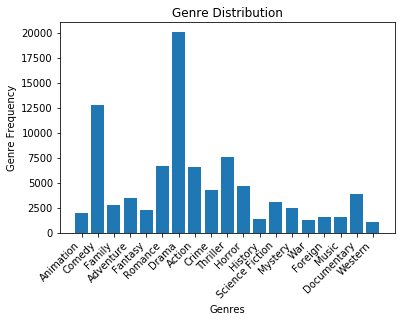

In [100]:
def plot_distribution(df):
    genres = df.genres.values
    flattened_genres = [item for sublist in genres for item in sublist]
    count_of_genres = Counter(flattened_genres)    
    fig, ax = plt.subplots()
    plt.bar(count_of_genres.keys(), count_of_genres.values())
    plt.title("Genre Distribution")
    plt.ylabel('Genre Frequency')
    plt.xlabel('Genres')
    # Rotate 45 degrees 
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right" )
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.show()
    
plot_distribution(df)   

In [85]:
# get_data uses the TMDB api to retrieve a url of every movie poster and then I use the requests module to 
# download the movie
def get_data(movie_id):
    # I use try - except to avoid my function crashing from potential errors (e.g. in the case that there is no poster in the json file)
    try:
        url = f"https://api.themoviedb.org/3/movie/{movie_id}?api_key=39329068bc1de1536d231b6b49c9ff50&language=en-US"
     
        request = Request(url)
        response = urlopen(request)
        data = response.read()
        poster_path = json.loads(data)['poster_path']        
        init_url = 'https://image.tmdb.org/t/p/w500'
        image_url = init_url + poster_path     
        r = requests.get(image_url)
        name = poster_path.replace('/', '_') 
        filename = f"poster{name}"
        pa = os.path.join('/home/gusmavko@GU.GU.SE/aics-project/data/images', filename)        
        # preferred for "binary" filetypes, like poster images
        with open(pa,'wb') as w:
            w.write(r.content)       
        return pa
    except Exception:
        return 'Error'

In [101]:
# iterate through the dataframe id column to download posters for all movies
def add_poster(df): 
    poster_paths = []
    #i = 1
    for movie_id in tqdm.tqdm(df['id'].tolist()):
      #m = movie.details(int(id))
      #print('Downloading:', name, "i", i)
        
        try:
            poster_paths.append(get_data(movie_id))
            print(movie_id)
        except Exception as e:
            print('[ERROR]', str(e))
            poster_paths.append("API Error")
        #i += 1
        #print(i)
    return poster_paths


In [102]:
list_of_posters = add_poster(df)


  0%|          | 2/42318 [00:01<8:02:14,  1.46it/s] 

862
8844



  0%|          | 5/42318 [00:01<4:32:06,  2.59it/s]

15602
31357
11862



  0%|          | 7/42318 [00:01<3:29:40,  3.36it/s]

949
11860
45325



  0%|          | 10/42318 [00:01<2:17:38,  5.12it/s]

9091
710
9087



  0%|          | 13/42318 [00:02<1:43:07,  6.84it/s]

12110
21032
10858



  0%|          | 17/42318 [00:02<1:25:38,  8.23it/s]

1408
524
4584



  0%|          | 19/42318 [00:02<1:20:31,  8.76it/s]

5
9273
11517



  0%|          | 23/42318 [00:03<1:13:38,  9.57it/s]

8012
1710
9691



  0%|          | 25/42318 [00:03<1:11:34,  9.85it/s]

12665
451



  0%|          | 27/42318 [00:03<1:13:23,  9.60it/s]

16420
9263
17015



  0%|          | 31/42318 [00:03<1:09:31, 10.14it/s]

902
37557
9909



  0%|          | 33/42318 [00:04<1:08:34, 10.28it/s]

63
9598
47018



  0%|          | 37/42318 [00:04<1:01:22, 11.48it/s]

687
139405
33689



  0%|          | 39/42318 [00:04<1:03:16, 11.14it/s]

9603
34615



  0%|          | 41/42318 [00:04<1:06:40, 10.57it/s]

31174
11443
35196



  0%|          | 45/42318 [00:05<1:06:57, 10.52it/s]

9312
577
11861



  0%|          | 47/42318 [00:05<1:06:50, 10.54it/s]

807
10530
8391



  0%|          | 51/42318 [00:05<1:03:59, 11.01it/s]

629
117164
11448



  0%|          | 53/42318 [00:05<1:06:00, 10.67it/s]

49133
26441



  0%|          | 55/42318 [00:06<1:08:49, 10.23it/s]

97406
9089



  0%|          | 57/42318 [00:06<1:07:56, 10.37it/s]

11010
99040
11359



  0%|          | 61/42318 [00:06<1:06:47, 10.54it/s]

17182
2054
10607



  0%|          | 63/42318 [00:06<1:05:44, 10.71it/s]

19760
9536
11525



  0%|          | 67/42318 [00:07<1:05:22, 10.77it/s]

40628
4482
10634



  0%|          | 69/42318 [00:07<1:06:13, 10.63it/s]

755
11859
28387



  0%|          | 71/42318 [00:07<1:06:48, 10.54it/s]


48750
20927
36929


  0%|          | 75/42318 [00:07<1:02:11, 11.32it/s]

9102
124626
27526



  0%|          | 79/42318 [00:08<1:02:38, 11.24it/s]

9623
46785
400



  0%|          | 81/42318 [00:08<1:02:31, 11.26it/s]

880
146599
8447



  0%|          | 83/42318 [00:08<1:04:58, 10.83it/s]

10534
17414



  0%|          | 87/42318 [00:09<1:07:40, 10.40it/s]

13997
2086
61548



  0%|          | 89/42318 [00:09<1:07:39, 10.40it/s]

9095
12158
9283



  0%|          | 93/42318 [00:09<1:06:54, 10.52it/s]

9208
40154
406



  0%|          | 95/42318 [00:09<1:07:23, 10.44it/s]

45549
63076
11062



  0%|          | 99/42318 [00:10<1:07:11, 10.47it/s]

13685
47475
2045



  0%|          | 101/42318 [00:10<1:06:11, 10.63it/s]

9614
688
11907



  0%|          | 105/42318 [00:10<1:07:24, 10.44it/s]

10874
89333
96357



  0%|          | 107/42318 [00:10<1:08:28, 10.27it/s]

197
103
33542



  0%|          | 109/42318 [00:11<1:07:43, 10.39it/s]


43566
71754
43612


  0%|          | 113/42318 [00:11<1:09:15, 10.16it/s]

51352
16934
10324



  0%|          | 117/42318 [00:11<1:09:17, 10.15it/s]

78406
55731
32119



  0%|          | 119/42318 [00:12<1:08:47, 10.22it/s]

11066
11104
37975



  0%|          | 121/42318 [00:12<1:09:26, 10.13it/s]

2074
27793



  0%|          | 125/42318 [00:12<1:08:49, 10.22it/s]

44284
110972
32622



  0%|          | 127/42318 [00:12<1:08:03, 10.33it/s]

73067
11863
55475



  0%|          | 131/42318 [00:13<1:08:04, 10.33it/s]

124636
9101
123360



  0%|          | 133/42318 [00:13<1:07:44, 10.38it/s]

5757
39428
9302



  0%|          | 137/42318 [00:13<1:04:53, 10.83it/s]

11000
249882
16388



  0%|          | 139/42318 [00:14<1:07:22, 10.43it/s]

9737
30765
10474



  0%|          | 143/42318 [00:14<1:05:05, 10.80it/s]

22279
30157
568



  0%|          | 145/42318 [00:14<1:04:00, 10.98it/s]

11780
34996
414



  0%|          | 149/42318 [00:14<1:04:38, 10.87it/s]

649
1873
5894



  0%|          | 151/42318 [00:15<1:04:03, 10.97it/s]

1775
8839
20649



  0%|          | 155/42318 [00:15<1:03:28, 11.07it/s]

10329
8963
26564



  0%|          | 157/42318 [00:15<1:04:49, 10.84it/s]

8068
8512
1572



  0%|          | 161/42318 [00:16<1:03:35, 11.05it/s]

13552
259209
6520



  0%|          | 163/42318 [00:16<1:04:03, 10.97it/s]

9073
10428
17447



  0%|          | 167/42318 [00:16<1:05:56, 10.65it/s]

9886
9482
19326



  0%|          | 169/42318 [00:16<1:05:51, 10.67it/s]

9344
9071
8973



  0%|          | 173/42318 [00:17<1:05:00, 10.80it/s]

15730
47608
2293



  0%|          | 175/42318 [00:17<1:07:28, 10.41it/s]

9070
68274



  0%|          | 177/42318 [00:17<1:07:07, 10.46it/s]

48787
34574
1642



  0%|          | 179/42318 [00:17<1:09:22, 10.12it/s]

11472
36196



  0%|          | 182/42318 [00:18<1:12:39,  9.66it/s]

11980
58372



  0%|          | 184/42318 [00:18<1:11:28,  9.82it/s]

32646
10533



  0%|          | 187/42318 [00:18<1:10:19,  9.98it/s]

56088
10802
10149



  0%|          | 189/42318 [00:18<1:10:35,  9.95it/s]

18402
9348
139408



  0%|          | 193/42318 [00:19<1:10:01, 10.03it/s]

281
5967
79593



  0%|          | 195/42318 [00:19<1:07:07, 10.46it/s]

47939
36834
9090



  0%|          | 199/42318 [00:19<1:06:17, 10.59it/s]

3512
52856
77350



  0%|          | 201/42318 [00:19<1:07:52, 10.34it/s]

9560
9804



  0%|          | 203/42318 [00:20<1:07:34, 10.39it/s]

31611
65796
49805



  0%|          | 205/42318 [00:20<1:07:14, 10.44it/s]


26258
50797
19155


  0%|          | 209/42318 [00:20<1:07:44, 10.36it/s]

76
11017
37141



  0%|          | 211/42318 [00:20<1:07:46, 10.35it/s]

9382
6715



  1%|          | 215/42318 [00:21<1:06:46, 10.51it/s]

18256
22625
2292
1909



  1%|          | 219/42318 [00:21<1:06:32, 10.54it/s]

8984
61813
4954



  1%|          | 221/42318 [00:21<1:05:26, 10.72it/s]

62488
10531
11929



  1%|          | 225/42318 [00:22<1:05:26, 10.72it/s]

8467
10451
20156



  1%|          | 227/42318 [00:22<1:06:49, 10.50it/s]

18395
522
397



  1%|          | 229/42318 [00:22<1:07:20, 10.42it/s]

10525
27985



  1%|          | 233/42318 [00:23<1:09:03, 10.16it/s]

15789
27303
21183



  1%|          | 235/42318 [00:23<1:07:17, 10.42it/s]

10954
47867
43475



  1%|          | 239/42318 [00:23<1:06:38, 10.52it/s]

72031
14275
1024



  1%|          | 241/42318 [00:23<1:05:58, 10.63it/s]

17207
13701
14819



  1%|          | 245/42318 [00:24<1:07:16, 10.42it/s]

32631
11777
628



  1%|          | 247/42318 [00:24<1:07:41, 10.36it/s]

87729
18713
6280



  1%|          | 251/42318 [00:24<1:06:11, 10.59it/s]

9061
37108
6071



  1%|          | 253/42318 [00:24<1:07:12, 10.43it/s]

11
9587
19101



  1%|          | 257/42318 [00:25<1:07:10, 10.43it/s]

49980
17961
18183



  1%|          | 259/42318 [00:25<1:06:06, 10.60it/s]

4476
11008
47504



  1%|          | 263/42318 [00:25<1:06:26, 10.55it/s]

32325
43742
28313



  1%|          | 265/42318 [00:26<1:05:35, 10.69it/s]

11318
3036
40490



  1%|          | 269/42318 [00:26<1:06:11, 10.59it/s]

24070
8986
10510



  1%|          | 271/42318 [00:26<1:05:33, 10.69it/s]

17402
38722
8438



  1%|          | 275/42318 [00:27<1:06:58, 10.46it/s]

11593
1945
39310



  1%|          | 277/42318 [00:27<1:06:05, 10.60it/s]

109560
56428



  1%|          | 279/42318 [00:27<1:02:23, 11.23it/s]

63105
131957
241



  1%|          | 281/42318 [00:27<1:02:58, 11.12it/s]

9058
527



  1%|          | 285/42318 [00:27<1:06:31, 10.53it/s]

18220
6950
101



  1%|          | 287/42318 [00:28<1:08:39, 10.20it/s]

63020
2307



  1%|          | 289/42318 [00:28<1:07:41, 10.35it/s]

680
41478
25296



  1%|          | 293/42318 [00:28<1:04:35, 10.84it/s]

40156
11450
30304



  1%|          | 295/42318 [00:28<1:04:45, 10.82it/s]

10452
12106
3586



  1%|          | 299/42318 [00:29<1:06:37, 10.51it/s]

110
108
109



  1%|          | 301/42318 [00:29<1:00:14, 11.62it/s]

159185
36357
92769



  1%|          | 303/42318 [00:29<57:29, 12.18it/s]  

28033
22586



  1%|          | 307/42318 [00:29<1:02:18, 11.24it/s]

14334
2636
2164



  1%|          | 309/42318 [00:30<1:04:02, 10.93it/s]

11395
278
9905



  1%|          | 311/42318 [00:30<1:04:25, 10.87it/s]

87078
12527



  1%|          | 315/42318 [00:30<1:09:13, 10.11it/s]

20306
36614
27993



  1%|          | 317/42318 [00:30<1:08:29, 10.22it/s]

31439
9067



  1%|          | 319/42318 [00:31<1:08:01, 10.29it/s]

9059
193
25066



  1%|          | 323/42318 [00:31<1:06:33, 10.52it/s]

46797
12122
11381



  1%|          | 325/42318 [00:31<1:06:15, 10.56it/s]

32636
36141
95963



  1%|          | 329/42318 [00:32<1:06:15, 10.56it/s]

1587
9271
2064



  1%|          | 331/42318 [00:32<1:06:39, 10.50it/s]

19855
60855
236



  1%|          | 335/42318 [00:32<1:05:37, 10.66it/s]

48287
3049
2759



  1%|          | 337/42318 [00:32<1:04:26, 10.86it/s]

12635
10497
11382



  1%|          | 341/42318 [00:33<1:06:21, 10.54it/s]

9331
10731
10464



  1%|          | 343/42318 [00:33<1:08:05, 10.27it/s]

34152
9495
29973



  1%|          | 347/42318 [00:33<1:06:23, 10.54it/s]

888
13
712



  1%|          | 349/42318 [00:33<1:05:46, 10.63it/s]

16295
48992



  1%|          | 351/42318 [00:34<1:07:58, 10.29it/s]

10879
10660



  1%|          | 353/42318 [00:34<1:08:53, 10.15it/s]

10714
41647
8587



  1%|          | 357/42318 [00:34<1:05:37, 10.66it/s]

1689
11596
854



  1%|          | 359/42318 [00:34<1:05:53, 10.61it/s]

9359
23333
36593



  1%|          | 363/42318 [00:35<1:06:52, 10.46it/s]

12280
2788
10427



  1%|          | 365/42318 [00:35<1:06:36, 10.50it/s]

11011
49803
8987



  1%|          | 369/42318 [00:35<1:04:58, 10.76it/s]

1637
15128
8831



  1%|          | 371/42318 [00:36<1:06:34, 10.50it/s]

36955
10449
10395



  1%|          | 373/42318 [00:36<1:04:39, 10.81it/s]

12160
40480



  1%|          | 377/42318 [00:36<1:06:52, 10.45it/s]

52038
29444
26352



  1%|          | 379/42318 [00:36<1:07:35, 10.34it/s]

39953
41580



  1%|          | 381/42318 [00:37<1:07:09, 10.41it/s]

315
22067
18242



  1%|          | 383/42318 [00:37<1:07:34, 10.34it/s]

11667
32502



  1%|          | 385/42318 [00:37<1:08:58, 10.13it/s]


28732
75555
42981


  1%|          | 390/42318 [00:37<1:00:14, 11.60it/s]

278939
291731
226229



  1%|          | 392/42318 [00:37<55:55, 12.49it/s]  

203119
316098
8011



  1%|          | 396/42318 [00:38<1:00:44, 11.50it/s]

2654
18069
19092



  1%|          | 398/42318 [00:38<1:03:21, 11.03it/s]

2758
38129
10436



  1%|          | 400/42318 [00:38<1:05:07, 10.73it/s]

13595
46094



  1%|          | 402/42318 [00:38<1:07:44, 10.31it/s]


9409
11853
16771


  1%|          | 406/42318 [00:39<1:12:42,  9.61it/s]

46924
11041
306



  1%|          | 410/42318 [00:39<1:09:53,  9.99it/s]

14522
26203
178



  1%|          | 412/42318 [00:39<1:08:24, 10.21it/s]

19819
57834
4722



  1%|          | 416/42318 [00:40<1:06:45, 10.46it/s]

18215
1607
26391



  1%|          | 418/42318 [00:40<1:09:46, 10.01it/s]

117553
6075



  1%|          | 420/42318 [00:40<1:10:03,  9.97it/s]

11310
18658



  1%|          | 422/42318 [00:40<1:11:37,  9.75it/s]

9350
9612
2124



  1%|          | 426/42318 [00:41<1:07:23, 10.36it/s]

26261
19176
49299



  1%|          | 428/42318 [00:41<1:07:58, 10.27it/s]

11566
9571
9739



  1%|          | 432/42318 [00:41<1:07:44, 10.30it/s]

24257
34444
26141



  1%|          | 434/42318 [00:42<1:07:24, 10.36it/s]

10997
50463
10443



  1%|          | 436/42318 [00:42<1:06:33, 10.49it/s]

20239
16297



  1%|          | 440/42318 [00:42<1:06:07, 10.55it/s]

18551
25440
9024



  1%|          | 442/42318 [00:42<1:05:02, 10.73it/s]

37233
1634
13815



  1%|          | 446/42318 [00:43<1:05:54, 10.59it/s]

5503
35588
2087



  1%|          | 448/42318 [00:43<1:05:26, 10.66it/s]

41579
18620



  1%|          | 450/42318 [00:43<1:06:46, 10.45it/s]

41006
4916
2019



  1%|          | 454/42318 [00:43<1:05:09, 10.71it/s]

31642
9255
26271



  1%|          | 456/42318 [00:44<1:05:57, 10.58it/s]

10612
2259
16097



  1%|          | 460/42318 [00:44<1:06:44, 10.45it/s]

11934
106143
12475



  1%|          | 462/42318 [00:44<1:07:20, 10.36it/s]

9386
7984
59930



  1%|          | 464/42318 [00:44<1:06:15, 10.53it/s]


15765
31643
6


  1%|          | 468/42318 [00:45<1:07:55, 10.27it/s]

329
10909
507



  1%|          | 472/42318 [00:45<1:04:19, 10.84it/s]

34024
29918
9593



  1%|          | 474/42318 [00:45<1:04:31, 10.81it/s]

42580
22317
1413



  1%|          | 478/42318 [00:46<1:04:12, 10.86it/s]

12121
2246
10502



  1%|          | 480/42318 [00:46<1:05:48, 10.60it/s]

10440
9516
2320



  1%|          | 484/42318 [00:46<1:04:21, 10.83it/s]

5879
83718
11971



  1%|          | 486/42318 [00:46<1:06:04, 10.55it/s]

2625
31911
788



  1%|          | 488/42318 [00:47<1:05:05, 10.71it/s]

21450
11231



  1%|          | 492/42318 [00:47<1:07:43, 10.29it/s]

41588
10447
31586



  1%|          | 494/42318 [00:47<1:06:49, 10.43it/s]

9300
9559
9800



  1%|          | 498/42318 [00:48<1:05:01, 10.72it/s]

713
8291
18133



  1%|          | 500/42318 [00:48<1:06:34, 10.47it/s]

25557
22588
10872



  1%|          | 504/42318 [00:48<1:06:51, 10.42it/s]

1245
11858
7007



  1%|          | 506/42318 [00:48<1:06:45, 10.44it/s]

10467
5550
8005



  1%|          | 508/42318 [00:49<1:05:35, 10.62it/s]


2088
10412
47889


  1%|          | 512/42318 [00:49<1:06:30, 10.48it/s]

14534
56583
41878



  1%|          | 516/42318 [00:49<1:06:25, 10.49it/s]

424
35233
14291



  1%|          | 518/42318 [00:50<1:06:39, 10.45it/s]

103413
11236



  1%|          | 520/42318 [00:50<1:08:37, 10.15it/s]

11592
8850



  1%|          | 522/42318 [00:50<1:08:01, 10.24it/s]

10445
695
43535



  1%|          | 526/42318 [00:50<1:07:30, 10.32it/s]

12519
23210
858



  1%|          | 528/42318 [00:51<1:06:11, 10.52it/s]

867
78
13203



  1%|▏         | 532/42318 [00:51<1:06:47, 10.43it/s]

10442
11074
33367



  1%|▏         | 534/42318 [00:51<1:05:49, 10.58it/s]

9607
17585
9057



  1%|▏         | 538/42318 [00:51<1:04:51, 10.74it/s]

20967
10635
9479



  1%|▏         | 540/42318 [00:52<1:03:39, 10.94it/s]

10057
11969
41590



  1%|▏         | 544/42318 [00:52<1:05:07, 10.69it/s]

319
26408
15139



  1%|▏         | 546/42318 [00:52<1:04:59, 10.71it/s]

161158
85247
11446



  1%|▏         | 550/42318 [00:53<1:05:14, 10.67it/s]

51980
24405
11655



  1%|▏         | 552/42318 [00:53<1:07:38, 10.29it/s]

11800
8223



  1%|▏         | 554/42318 [00:53<1:08:41, 10.13it/s]

14587
31504



  1%|▏         | 558/42318 [00:53<58:17, 11.94it/s]  

41653
53185
95743
23637



  1%|▏         | 560/42318 [00:53<1:02:30, 11.13it/s]

17600
10897
349394



  1%|▏         | 564/42318 [00:54<59:56, 11.61it/s]

21352
68806
37345



  1%|▏         | 566/42318 [00:54<1:00:26, 11.51it/s]

32562
47507
25403



  1%|▏         | 568/42318 [00:54<55:30, 12.54it/s]  

124304
9066



  1%|▏         | 572/42318 [00:54<1:01:19, 11.35it/s]

771
251
812



  1%|▏         | 574/42318 [00:55<1:02:46, 11.08it/s]

280
581
80350



  1%|▏         | 578/42318 [00:55<1:03:57, 10.88it/s]

268
274
408



  1%|▏         | 580/42318 [00:55<1:04:38, 10.76it/s]

10020
10895



  1%|▏         | 582/42318 [00:55<1:05:50, 10.56it/s]

114
41043
576



  1%|▏         | 584/42318 [00:56<1:05:55, 10.55it/s]

15477
59146



  1%|▏         | 588/42318 [00:56<1:07:37, 10.28it/s]

30528
7300
10824



  1%|▏         | 590/42318 [00:56<1:01:48, 11.25it/s]

261246
275



  1%|▏         | 592/42318 [00:56<1:04:37, 10.76it/s]

25059
11827
8766



  1%|▏         | 596/42318 [00:57<1:04:35, 10.77it/s]

23570
47333
54850



  1%|▏         | 598/42318 [00:57<1:04:11, 10.83it/s]

51242
10112
4307



  1%|▏         | 600/42318 [00:57<1:04:39, 10.75it/s]

46029
32308



  1%|▏         | 604/42318 [00:58<1:06:52, 10.39it/s]

88893
52873
340210



  1%|▏         | 606/42318 [00:58<1:05:51, 10.56it/s]

44281
28121
12520



  1%|▏         | 608/42318 [00:58<1:06:08, 10.51it/s]

1592
36447



  1%|▏         | 612/42318 [00:58<1:08:08, 10.20it/s]

19042
38884
47449



  1%|▏         | 614/42318 [00:58<1:08:45, 10.11it/s]

36259
41852
40926



  1%|▏         | 618/42318 [00:59<1:07:08, 10.35it/s]

9099
2021
61752



  1%|▏         | 620/42318 [00:59<1:10:26,  9.87it/s]

10988
11479



  1%|▏         | 622/42318 [00:59<1:09:22, 10.02it/s]

398959
12652
10684



  1%|▏         | 626/42318 [01:00<1:07:23, 10.31it/s]

954
68445
18989



  1%|▏         | 628/42318 [01:00<1:06:24, 10.46it/s]

54285
8840
124625



  1%|▏         | 632/42318 [01:00<1:06:44, 10.41it/s]

11107
16417
10363



  1%|▏         | 634/42318 [01:00<1:07:07, 10.35it/s]

161070
10539
10543



  2%|▏         | 638/42318 [01:01<1:06:18, 10.48it/s]

18414
47502
11902



  2%|▏         | 640/42318 [01:01<1:06:14, 10.49it/s]

27098
25087
5801



  2%|▏         | 644/42318 [01:01<1:07:33, 10.28it/s]

896
3065
2300



  2%|▏         | 646/42318 [01:02<1:09:01, 10.06it/s]

8069
288173
187851



  2%|▏         | 650/42318 [01:02<1:03:34, 10.92it/s]

27768
221917
8072



  2%|▏         | 652/42318 [01:02<56:53, 12.21it/s]  

35797
88030
83857



  2%|▏         | 656/42318 [01:02<1:01:06, 11.36it/s]

33245
124460
27281



  2%|▏         | 658/42318 [01:03<1:03:24, 10.95it/s]

105045
40001
29621



  2%|▏         | 662/42318 [01:03<1:05:41, 10.57it/s]

20762
37144
48260



  2%|▏         | 664/42318 [01:03<1:05:19, 10.63it/s]

12656
38867
25969



  2%|▏         | 668/42318 [01:04<1:06:06, 10.50it/s]

44103
753
43634



  2%|▏         | 670/42318 [01:04<1:05:08, 10.66it/s]

9103
90214
29649



  2%|▏         | 672/42318 [01:04<1:04:48, 10.71it/s]

10990
8866



  2%|▏         | 674/42318 [01:04<1:06:47, 10.39it/s]


12233
23449
36355


  2%|▏         | 678/42318 [01:05<1:05:57, 10.52it/s]

37667
90148
922



  2%|▏         | 682/42318 [01:05<1:07:53, 10.22it/s]

11876
52633
62364



  2%|▏         | 684/42318 [01:05<1:07:28, 10.28it/s]

11687
9304
73183



  2%|▏         | 688/42318 [01:05<1:03:04, 11.00it/s]

131232
9100
20759



  2%|▏         | 690/42318 [01:06<1:05:03, 10.67it/s]

46063
32513
40651



  2%|▏         | 694/42318 [01:06<1:05:55, 10.52it/s]

36915
40507
9802



  2%|▏         | 696/42318 [01:06<1:05:42, 10.56it/s]

25697
21588
664



  2%|▏         | 700/42318 [01:07<1:06:16, 10.47it/s]

11867
47119
314352



  2%|▏         | 702/42318 [01:07<1:05:52, 10.53it/s]

9323
10280
10535



  2%|▏         | 706/42318 [01:07<1:01:19, 11.31it/s]

124613
532
26744



  2%|▏         | 708/42318 [01:07<1:01:42, 11.24it/s]

16299
10547
245268



  2%|▏         | 712/42318 [01:08<1:01:43, 11.24it/s]

935
55613
41007



  2%|▏         | 714/42318 [01:08<1:02:25, 11.11it/s]

35645
110465



  2%|▏         | 716/42318 [01:08<1:07:04, 10.34it/s]

255546
40751
85778



  2%|▏         | 720/42318 [01:08<1:05:24, 10.60it/s]

11101
9826
9879



  2%|▏         | 722/42318 [01:09<1:04:16, 10.79it/s]

63564
22621
7095



  2%|▏         | 726/42318 [01:09<1:00:12, 11.51it/s]

26890
46732
124633



  2%|▏         | 728/42318 [01:09<1:01:25, 11.28it/s]

202425
77771
181083



  2%|▏         | 730/42318 [01:09<1:02:36, 11.07it/s]

41225
87190



  2%|▏         | 732/42318 [01:10<1:05:05, 10.65it/s]

627
32872



  2%|▏         | 734/42318 [01:10<1:07:43, 10.23it/s]


602
14553
9566


  2%|▏         | 738/42318 [01:10<1:08:12, 10.16it/s]

10545
9894
11543



  2%|▏         | 740/42318 [01:10<1:07:13, 10.31it/s]

9268
52059



  2%|▏         | 744/42318 [01:11<1:08:16, 10.15it/s]

9327
123763
81949



  2%|▏         | 746/42318 [01:11<1:08:01, 10.19it/s]

44535
44495
78285



  2%|▏         | 748/42318 [01:11<1:07:41, 10.24it/s]

11228
10779



  2%|▏         | 752/42318 [01:12<1:08:24, 10.13it/s]

26748
38223
9294



  2%|▏         | 754/42318 [01:12<1:06:57, 10.34it/s]

49963
11363
1645



  2%|▏         | 756/42318 [01:12<1:04:32, 10.73it/s]

31546
77056



  2%|▏         | 758/42318 [01:12<1:07:11, 10.31it/s]

36344
18550



  2%|▏         | 761/42318 [01:12<1:12:17,  9.58it/s]

11511
34170
109478



  2%|▏         | 763/42318 [01:13<1:03:59, 10.82it/s]

124645
12606



  2%|▏         | 767/42318 [01:13<1:06:22, 10.43it/s]

69895
35206
151489



  2%|▏         | 769/42318 [01:13<1:06:45, 10.37it/s]

4837
12632
9098



  2%|▏         | 773/42318 [01:14<1:07:01, 10.33it/s]

124614
18975
11962



  2%|▏         | 775/42318 [01:14<1:06:24, 10.43it/s]

2925
28628
3595



  2%|▏         | 779/42318 [01:14<1:05:12, 10.62it/s]

9308
92381
18555



  2%|▏         | 781/42318 [01:14<1:04:47, 10.69it/s]

12123
10830
3573



  2%|▏         | 785/42318 [01:15<1:06:18, 10.44it/s]

10546
18862
31417



  2%|▏         | 787/42318 [01:15<1:00:55, 11.36it/s]

9431
124619
46986



  2%|▏         | 789/42318 [01:15<1:01:36, 11.23it/s]


144982
47907
10061


  2%|▏         | 793/42318 [01:15<1:04:33, 10.72it/s]

36266
549
10478



  2%|▏         | 797/42318 [01:16<1:00:47, 11.38it/s]

66634
116690
213917



  2%|▏         | 799/42318 [01:16<1:00:09, 11.50it/s]

238
159
11134



  2%|▏         | 801/42318 [01:16<1:02:09, 11.13it/s]

88224
132641



  2%|▏         | 805/42318 [01:16<1:03:34, 10.88it/s]

9303
23945
37820



  2%|▏         | 807/42318 [01:17<1:03:15, 10.94it/s]

22479
9054
241058



  2%|▏         | 811/42318 [01:17<58:21, 11.85it/s]

11985
10232
59569



  2%|▏         | 813/42318 [01:17<55:40, 12.43it/s]

410921
38955
110513



  2%|▏         | 817/42318 [01:17<55:36, 12.44it/s]

114089
11015
9306



  2%|▏         | 819/42318 [01:18<58:32, 11.82it/s]

12559
58770
3587



  2%|▏         | 821/42318 [01:18<1:00:24, 11.45it/s]


10723
56077
19004


  2%|▏         | 825/42318 [01:18<1:04:48, 10.67it/s]

10987
44705
20318



  2%|▏         | 829/42318 [01:19<1:05:00, 10.64it/s]

43596
79782
26933



  2%|▏         | 831/42318 [01:19<1:05:38, 10.53it/s]

27854
981
872



  2%|▏         | 835/42318 [01:19<1:04:53, 10.66it/s]

2769
13320
164



  2%|▏         | 837/42318 [01:19<1:05:16, 10.59it/s]

426
567
3078



  2%|▏         | 839/42318 [01:19<1:05:16, 10.59it/s]

13528
28288



  2%|▏         | 841/42318 [01:20<1:07:17, 10.27it/s]

213
284



  2%|▏         | 845/42318 [01:20<1:07:29, 10.24it/s]

239
4808
289



  2%|▏         | 847/42318 [01:20<1:05:57, 10.48it/s]

963
11113
6620



  2%|▏         | 851/42318 [01:21<1:06:45, 10.35it/s]

804
26531
909



  2%|▏         | 853/42318 [01:21<1:06:48, 10.34it/s]

630
770
31044



  2%|▏         | 857/42318 [01:21<1:07:32, 10.23it/s]

599
15
62



  2%|▏         | 859/42318 [01:21<1:07:10, 10.29it/s]

121357
705
22490



  2%|▏         | 863/42318 [01:22<1:07:43, 10.20it/s]

223
25670
303



  2%|▏         | 865/42318 [01:22<1:07:17, 10.27it/s]

4174
8356
381



  2%|▏         | 869/42318 [01:22<1:05:23, 10.56it/s]

20758
29376
1859



  2%|▏         | 871/42318 [01:23<1:04:08, 10.77it/s]

18299
17281
64382



  2%|▏         | 875/42318 [01:23<1:05:23, 10.56it/s]

10907
32093
1939



  2%|▏         | 877/42318 [01:23<1:06:04, 10.45it/s]

22292
3598



  2%|▏         | 879/42318 [01:23<1:06:44, 10.35it/s]

3080
198
13562



  2%|▏         | 881/42318 [01:24<1:06:18, 10.42it/s]


1712
220
3529


  2%|▏         | 885/42318 [01:24<1:07:05, 10.29it/s]

3085
2897
1585



  2%|▏         | 889/42318 [01:24<1:05:00, 10.62it/s]

3083
900
43795



  2%|▏         | 891/42318 [01:24<1:04:09, 10.76it/s]

85638
50001
43905



  2%|▏         | 895/42318 [01:25<1:06:23, 10.40it/s]

22688
23114
26378



  2%|▏         | 897/42318 [01:25<1:07:25, 10.24it/s]

40206
22356
260



  2%|▏         | 901/42318 [01:25<1:08:13, 10.12it/s]

43488
22613
10331



  2%|▏         | 903/42318 [01:26<1:10:28,  9.80it/s]

488
22733



  2%|▏         | 904/42318 [01:26<1:10:55,  9.73it/s]

261
57575



  2%|▏         | 907/42318 [01:26<1:10:48,  9.75it/s]

32574
22657



  2%|▏         | 910/42318 [01:26<1:09:54,  9.87it/s]

76464
22649
176841



  2%|▏         | 912/42318 [01:27<1:03:32, 10.86it/s]

125587
39448
52855



  2%|▏         | 916/42318 [01:27<1:04:56, 10.62it/s]

39940
85328
124632



  2%|▏         | 918/42318 [01:27<1:06:21, 10.40it/s]

11076
63945
58985



  2%|▏         | 922/42318 [01:28<1:05:37, 10.51it/s]

890
10861
1770



  2%|▏         | 924/42318 [01:28<1:04:39, 10.67it/s]

44465
2033
18203



  2%|▏         | 928/42318 [01:28<1:03:02, 10.94it/s]

9333
47260
9400



  2%|▏         | 930/42318 [01:28<1:03:18, 10.90it/s]

9401
12241
25739



  2%|▏         | 934/42318 [01:29<1:02:27, 11.04it/s]

11306
9625
10680



  2%|▏         | 936/42318 [01:29<1:05:22, 10.55it/s]

6346
18660



  2%|▏         | 938/42318 [01:29<1:07:37, 10.20it/s]

35115
14821



  2%|▏         | 940/42318 [01:29<1:06:26, 10.38it/s]

14136
10869
22660



  2%|▏         | 942/42318 [01:29<1:05:47, 10.48it/s]


19186
31102
6878


  2%|▏         | 946/42318 [01:30<1:06:56, 10.30it/s]

15944
18444
20723



  2%|▏         | 950/42318 [01:30<1:08:48, 10.02it/s]

173
864
24795



  2%|▏         | 952/42318 [01:30<1:07:27, 10.22it/s]

11224
81310
15947



  2%|▏         | 956/42318 [01:31<1:05:39, 10.50it/s]

9078
29682
8367



  2%|▏         | 958/42318 [01:31<1:05:45, 10.48it/s]

433
11360
11114



  2%|▏         | 960/42318 [01:31<1:05:31, 10.52it/s]

12335
12092



  2%|▏         | 964/42318 [01:32<1:08:44, 10.03it/s]

10948
11229
15121



  2%|▏         | 966/42318 [01:32<1:07:59, 10.14it/s]

562
10163
48862



  2%|▏         | 970/42318 [01:32<1:00:43, 11.35it/s]

117036
47199
11159



  2%|▏         | 972/42318 [01:32<1:00:36, 11.37it/s]

9591
30500
41843



  2%|▏         | 974/42318 [01:32<1:01:55, 11.13it/s]

55058
10938



  2%|▏         | 978/42318 [01:33<1:04:53, 10.62it/s]

11412
10586
42314



  2%|▏         | 980/42318 [01:33<1:05:20, 10.55it/s]

27845
23223
49471



  2%|▏         | 984/42318 [01:33<1:04:30, 10.68it/s]

38153
25147
9716



  2%|▏         | 986/42318 [01:34<1:03:47, 10.80it/s]

43777
454
10218



  2%|▏         | 990/42318 [01:34<1:04:06, 10.74it/s]

819
38191
56830



  2%|▏         | 992/42318 [01:34<1:04:21, 10.70it/s]

11238
27256
31530



  2%|▏         | 996/42318 [01:35<1:06:14, 10.40it/s]

66473
28120
1834



  2%|▏         | 998/42318 [01:35<1:00:43, 11.34it/s]

26282
37218
252



  2%|▏         | 1002/42318 [01:35<1:02:15, 11.06it/s]

116356
16372
11561



  2%|▏         | 1004/42318 [01:35<1:02:10, 11.07it/s]

11302
623
583



  2%|▏         | 1008/42318 [01:36<1:02:53, 10.95it/s]

12614
21711
11575



  2%|▏         | 1010/42318 [01:36<1:02:11, 11.07it/s]

475
11331
521



  2%|▏         | 1014/42318 [01:36<1:04:37, 10.65it/s]

88
500
792



  2%|▏         | 1016/42318 [01:36<1:04:59, 10.59it/s]

8491
402
10537



  2%|▏         | 1020/42318 [01:37<1:05:49, 10.46it/s]

11386
9504
15764



  2%|▏         | 1022/42318 [01:37<1:04:29, 10.67it/s]

601
67365
25842



  2%|▏         | 1026/42318 [01:37<1:05:01, 10.58it/s]

2119
744
136311



  2%|▏         | 1028/42318 [01:37<1:04:20, 10.69it/s]

221
702
25750



  2%|▏         | 1032/42318 [01:38<1:01:44, 11.15it/s]

17642
427043
9305



  2%|▏         | 1034/42318 [01:38<1:01:15, 11.23it/s]

37616
11112
21612



  2%|▏         | 1038/42318 [01:38<1:02:56, 10.93it/s]

141210
102461
36998



  2%|▏         | 1040/42318 [01:39<1:02:00, 11.09it/s]

200383
116844
1630



  2%|▏         | 1044/42318 [01:39<1:02:14, 11.05it/s]

26626
124837
11816



  2%|▏         | 1046/42318 [01:39<1:03:14, 10.88it/s]

11843
10379
2756



  2%|▏         | 1050/42318 [01:39<1:04:13, 10.71it/s]

790
1103
11298



  2%|▏         | 1052/42318 [01:40<1:05:32, 10.49it/s]

4480
4481
49688



  2%|▏         | 1054/42318 [01:40<1:06:27, 10.35it/s]

10765
762



  2%|▏         | 1056/42318 [01:40<1:08:04, 10.10it/s]

44497
278621



  3%|▎         | 1060/42318 [01:40<1:07:29, 10.19it/s]

99479
55049
124829



  3%|▎         | 1062/42318 [01:41<1:06:24, 10.35it/s]

79306
10548
531



  3%|▎         | 1066/42318 [01:41<1:05:23, 10.52it/s]

104931
4483
18919



  3%|▎         | 1068/42318 [01:41<1:07:23, 10.20it/s]

31556
26167



  3%|▎         | 1070/42318 [01:41<1:07:03, 10.25it/s]

26174
61461
117500



  3%|▎         | 1074/42318 [01:42<1:06:22, 10.36it/s]

127973
659
30892



  3%|▎         | 1076/42318 [01:42<1:04:52, 10.59it/s]

86369
8074
124676



  3%|▎         | 1080/42318 [01:42<1:00:30, 11.36it/s]

38554
49763
41326



  3%|▎         | 1082/42318 [01:42<1:01:03, 11.26it/s]

36555
10608
11216



  3%|▎         | 1086/42318 [01:43<1:02:35, 10.98it/s]

7452
64567
892



  3%|▎         | 1088/42318 [01:43<1:02:35, 10.98it/s]

1600
26561
975



  3%|▎         | 1092/42318 [01:43<1:05:02, 10.56it/s]

18129
54405
150823



  3%|▎         | 1094/42318 [01:44<1:04:00, 10.73it/s]

409
38251
10161



  3%|▎         | 1096/42318 [01:44<1:04:25, 10.66it/s]

1412
41768



  3%|▎         | 1100/42318 [01:44<1:04:21, 10.68it/s]

10409
14285
2469



  3%|▎         | 1102/42318 [01:44<1:03:26, 10.83it/s]

10174
31225
510



  3%|▎         | 1106/42318 [01:45<1:04:10, 10.70it/s]

11455
1891
2493



  3%|▎         | 1108/42318 [01:45<1:06:48, 10.28it/s]

85
68



  3%|▎         | 1110/42318 [01:45<1:07:19, 10.20it/s]

679
429
13446



  3%|▎         | 1114/42318 [01:46<1:04:06, 10.71it/s]

389
947
185



  3%|▎         | 1116/42318 [01:46<1:06:08, 10.38it/s]

595
28
335



  3%|▎         | 1120/42318 [01:46<1:06:16, 10.36it/s]

1892
144
1092



  3%|▎         | 1122/42318 [01:46<1:05:35, 10.47it/s]

769
348
766



  3%|▎         | 1124/42318 [01:46<1:05:52, 10.42it/s]

175
11645



  3%|▎         | 1128/42318 [01:47<1:06:00, 10.40it/s]

10835
539
525



  3%|▎         | 1130/42318 [01:47<1:03:45, 10.77it/s]

240
600
530



  3%|▎         | 1134/42318 [01:47<1:05:52, 10.42it/s]

10705
279
3109



  3%|▎         | 1136/42318 [01:48<1:06:12, 10.37it/s]

311
1578
703



  3%|▎         | 1140/42318 [01:48<1:05:39, 10.45it/s]

9549
1398
387



  3%|▎         | 1142/42318 [01:48<1:06:20, 10.35it/s]

9277
343



  3%|▎         | 1144/42318 [01:48<1:06:59, 10.24it/s]

37291
490
11235



  3%|▎         | 1146/42318 [01:49<1:06:45, 10.28it/s]

218
763



  3%|▎         | 1150/42318 [01:49<1:07:32, 10.16it/s]

9665
18971
696



  3%|▎         | 1152/42318 [01:49<1:08:37, 10.00it/s]

379
207
37247



  3%|▎         | 1156/42318 [01:50<1:07:07, 10.22it/s]

1480
9322
826



  3%|▎         | 1158/42318 [01:50<1:08:48,  9.97it/s]

422
829



  3%|▎         | 1160/42318 [01:50<1:09:18,  9.90it/s]

828
3090
9964



  3%|▎         | 1164/42318 [01:50<1:08:33, 10.01it/s]

3063
13667
694



  3%|▎         | 1166/42318 [01:51<1:05:37, 10.45it/s]

235
832
765



  3%|▎         | 1170/42318 [01:51<1:05:24, 10.48it/s]

5925
11778
4485



  3%|▎         | 1172/42318 [01:51<1:07:08, 10.21it/s]

137
33
982



  3%|▎         | 1176/42318 [01:52<1:05:21, 10.49it/s]

8428
212
105



  3%|▎         | 1178/42318 [01:52<1:06:09, 10.36it/s]

1633
11202
1554



  3%|▎         | 1182/42318 [01:52<1:04:26, 10.64it/s]

149
8009
903



  3%|▎         | 1184/42318 [01:52<1:05:25, 10.48it/s]

11673
3034



  3%|▎         | 1186/42318 [01:52<1:04:50, 10.57it/s]

339
10404
914



  3%|▎         | 1190/42318 [01:53<1:05:26, 10.48it/s]

756
288
910



  3%|▎         | 1192/42318 [01:53<1:04:24, 10.64it/s]

2640
16633
665



  3%|▎         | 1196/42318 [01:53<1:04:25, 10.64it/s]

11031
11314
15143



  3%|▎         | 1198/42318 [01:54<1:06:19, 10.33it/s]

89
10322



  3%|▎         | 1200/42318 [01:54<1:07:16, 10.19it/s]

783
10644
11257



  3%|▎         | 1204/42318 [01:54<1:05:25, 10.47it/s]

14370
12104
625



  3%|▎         | 1206/42318 [01:54<1:06:14, 10.34it/s]

8816
830



  3%|▎         | 1208/42318 [01:55<1:07:24, 10.16it/s]

2323
983
642



  3%|▎         | 1210/42318 [01:55<1:06:00, 10.38it/s]


655
10341
639


  3%|▎         | 1214/42318 [01:55<1:06:20, 10.33it/s]

30180
31388
41801



  3%|▎         | 1218/42318 [01:56<59:18, 11.55it/s]  

66034
348138
96288



  3%|▎         | 1220/42318 [01:56<1:00:07, 11.39it/s]

61536
18762
8077



  3%|▎         | 1222/42318 [01:56<1:02:00, 11.05it/s]

814
41671



  3%|▎         | 1226/42318 [01:56<1:04:48, 10.57it/s]

27214
52263
33519



  3%|▎         | 1228/42318 [01:56<1:06:07, 10.36it/s]

16235
11449
41848



  3%|▎         | 1232/42318 [01:57<1:06:43, 10.26it/s]

25944
24913
49126



  3%|▎         | 1234/42318 [01:57<1:05:38, 10.43it/s]

32076
571
8851



  3%|▎         | 1236/42318 [01:57<1:05:28, 10.46it/s]

37843
32146



  3%|▎         | 1240/42318 [01:58<1:07:45, 10.11it/s]

30346
6114
229



  3%|▎         | 1242/42318 [01:58<1:05:56, 10.38it/s]

13549
9529
1598



  3%|▎         | 1246/42318 [01:58<1:05:09, 10.50it/s]

11349
7340
6217



  3%|▎         | 1248/42318 [01:58<1:05:42, 10.42it/s]

377
653
28198



  3%|▎         | 1252/42318 [01:59<1:03:36, 10.76it/s]

794
31640
8744



  3%|▎         | 1254/42318 [01:59<1:03:37, 10.76it/s]

25189
145
2212



  3%|▎         | 1258/42318 [01:59<1:04:54, 10.54it/s]

199
7863
12498



  3%|▎         | 1260/42318 [02:00<1:03:45, 10.73it/s]

9279
53234
17204



  3%|▎         | 1264/42318 [02:00<1:03:15, 10.82it/s]

21539
85589
12709



  3%|▎         | 1266/42318 [02:00<1:03:12, 10.82it/s]

20539
11674
199512



  3%|▎         | 1270/42318 [02:00<1:02:34, 10.93it/s]

64900
1573
152



  3%|▎         | 1272/42318 [02:01<1:03:47, 10.72it/s]

174
172
154



  3%|▎         | 1276/42318 [02:01<1:06:14, 10.33it/s]

157
168
364



  3%|▎         | 1278/42318 [02:01<1:05:23, 10.46it/s]

11967
9086
621



  3%|▎         | 1282/42318 [02:02<1:05:02, 10.51it/s]

9037
10173
55687



  3%|▎         | 1284/42318 [02:02<1:04:03, 10.68it/s]

168535
8845
46681



  3%|▎         | 1288/42318 [02:02<1:02:50, 10.88it/s]

578
579
17692



  3%|▎         | 1290/42318 [02:02<1:03:42, 10.73it/s]

17795
75
13891



  3%|▎         | 1294/42318 [02:03<1:04:31, 10.60it/s]

9390
378
10896



  3%|▎         | 1296/42318 [02:03<1:03:25, 10.78it/s]

2322
41240
26949



  3%|▎         | 1300/42318 [02:03<56:33, 12.09it/s]  

9819
49799
31908



  3%|▎         | 1302/42318 [02:03<58:35, 11.67it/s]

46027
3179
1802



  3%|▎         | 1306/42318 [02:04<1:02:07, 11.00it/s]

4232
9361
2928



  3%|▎         | 1308/42318 [02:04<1:01:32, 11.11it/s]

30285
10549
58102



  3%|▎         | 1312/42318 [02:04<1:04:23, 10.61it/s]

18451
27265
49935



  3%|▎         | 1314/42318 [02:05<1:03:37, 10.74it/s]

8818
36758
36040



  3%|▎         | 1318/42318 [02:05<58:28, 11.68it/s]  

74239
9415
55146



  3%|▎         | 1320/42318 [02:05<58:53, 11.60it/s]

303693
12145
42424



  3%|▎         | 1322/42318 [02:05<1:00:26, 11.30it/s]

34314
2892



  3%|▎         | 1326/42318 [02:06<1:02:56, 10.85it/s]

9404
85242
9622



  3%|▎         | 1328/42318 [02:06<1:03:28, 10.76it/s]

8860
197537
66597



  3%|▎         | 1332/42318 [02:06<1:03:46, 10.71it/s]

14832
9619
40506



  3%|▎         | 1334/42318 [02:06<1:03:06, 10.82it/s]

31000
4104
26306



  3%|▎         | 1338/42318 [02:07<59:39, 11.45it/s]

203829
14908
784



  3%|▎         | 1340/42318 [02:07<1:02:28, 10.93it/s]

12489
168283
16448



  3%|▎         | 1342/42318 [02:07<1:03:41, 10.72it/s]

55936
17894



  3%|▎         | 1346/42318 [02:07<1:06:01, 10.34it/s]

28059
58911
17949



  3%|▎         | 1348/42318 [02:08<1:06:21, 10.29it/s]

1968
61563
66



  3%|▎         | 1352/42318 [02:08<1:04:50, 10.53it/s]

20735
11419
25796



  3%|▎         | 1354/42318 [02:08<1:04:49, 10.53it/s]

638
25624
9366



  3%|▎         | 1356/42318 [02:08<1:04:36, 10.57it/s]

21915
90928



  3%|▎         | 1360/42318 [02:09<1:06:06, 10.33it/s]

50091
18420
19952



  3%|▎         | 1362/42318 [02:09<1:05:33, 10.41it/s]

9446
28005
9403



  3%|▎         | 1366/42318 [02:09<1:05:36, 10.40it/s]

27322
10003
9311



  3%|▎         | 1368/42318 [02:10<1:04:48, 10.53it/s]

11844
884
49806



  3%|▎         | 1372/42318 [02:10<1:04:34, 10.57it/s]

1624
88423
16052



  3%|▎         | 1374/42318 [02:10<1:04:39, 10.55it/s]

4477
24662
18423



  3%|▎         | 1378/42318 [02:11<1:04:26, 10.59it/s]

76996
6499
50512



  3%|▎         | 1380/42318 [02:11<1:04:34, 10.57it/s]

9405
12723
9360



  3%|▎         | 1384/42318 [02:11<1:03:14, 10.79it/s]

9434
118991
21626



  3%|▎         | 1386/42318 [02:11<1:02:03, 10.99it/s]

13982
93946
77223



  3%|▎         | 1390/42318 [02:12<59:38, 11.44it/s]  

31465
12793
102878



  3%|▎         | 1392/42318 [02:12<1:01:22, 11.11it/s]

105763
9611
47694



  3%|▎         | 1394/42318 [02:12<1:01:14, 11.14it/s]

10357
9977



  3%|▎         | 1398/42318 [02:12<1:04:24, 10.59it/s]

816
2163
124680



  3%|▎         | 1400/42318 [02:13<1:04:11, 10.62it/s]

16399
124843
31017



  3%|▎         | 1404/42318 [02:13<1:02:50, 10.85it/s]

24645
49478
12499



  3%|▎         | 1406/42318 [02:13<1:02:22, 10.93it/s]

18
1811



  3%|▎         | 1408/42318 [02:13<1:04:43, 10.53it/s]

109614
60082
105045



  3%|▎         | 1412/42318 [02:14<1:03:33, 10.73it/s]

53023
64802
11239



  3%|▎         | 1414/42318 [02:14<1:04:07, 10.63it/s]

50850
15321
2058



  3%|▎         | 1416/42318 [02:14<1:03:20, 10.76it/s]

9450
330



  3%|▎         | 1420/42318 [02:14<1:05:21, 10.43it/s]

38523
16375
33660



  3%|▎         | 1422/42318 [02:15<1:06:14, 10.29it/s]

59232
45671



  3%|▎         | 1424/42318 [02:15<1:07:32, 10.09it/s]

17770
15170
1701



  3%|▎         | 1426/42318 [02:15<1:07:15, 10.13it/s]

26422
124642



  3%|▎         | 1430/42318 [02:15<1:00:45, 11.22it/s]

1639
49235
106129



  3%|▎         | 1432/42318 [02:16<1:02:46, 10.85it/s]

107743
415



  3%|▎         | 1434/42318 [02:16<1:05:05, 10.47it/s]

47686
65889
11103



  3%|▎         | 1438/42318 [02:16<58:56, 11.56it/s]  

11970
34941
407992



  3%|▎         | 1440/42318 [02:16<1:00:04, 11.34it/s]

8874
17991
11956



  3%|▎         | 1444/42318 [02:17<55:40, 12.24it/s]  

266
754
37567



  3%|▎         | 1446/42318 [02:17<1:01:24, 11.09it/s]

43771
124834
249358



  3%|▎         | 1450/42318 [02:17<57:51, 11.77it/s]

111367
607
18080



  3%|▎         | 1452/42318 [02:17<59:36, 11.42it/s]

38225
17834
686



  3%|▎         | 1456/42318 [02:18<1:01:19, 11.11it/s]

65046
4421
9387



  3%|▎         | 1458/42318 [02:18<1:02:19, 10.93it/s]

10603
2142
8413



  3%|▎         | 1462/42318 [02:18<1:05:09, 10.45it/s]

10336
20737
9413



  3%|▎         | 1464/42318 [02:18<1:04:34, 10.54it/s]

14585
18519
49462



  3%|▎         | 1468/42318 [02:19<1:04:17, 10.59it/s]

8834
9458
8854



  3%|▎         | 1470/42318 [02:19<1:03:28, 10.72it/s]

38295
22073
37244



  3%|▎         | 1474/42318 [02:19<1:05:05, 10.46it/s]

4961
9416
26180



  3%|▎         | 1476/42318 [02:20<1:06:07, 10.30it/s]

17832
9772
6072



  3%|▎         | 1480/42318 [02:20<1:03:45, 10.68it/s]

1669
468
32519



  4%|▎         | 1482/42318 [02:20<1:08:43,  9.90it/s]

108401
10806



  4%|▎         | 1484/42318 [02:20<1:10:53,  9.60it/s]

9433
6623



  4%|▎         | 1486/42318 [02:21<1:08:00, 10.01it/s]

2118
978
9437



  4%|▎         | 1490/42318 [02:21<1:05:35, 10.37it/s]

29461
56651
10351



  4%|▎         | 1492/42318 [02:21<1:03:50, 10.66it/s]

66588
2649
14289



  4%|▎         | 1496/42318 [02:22<1:05:17, 10.42it/s]

10155
75250
20457



  4%|▎         | 1498/42318 [02:22<1:04:03, 10.62it/s]

18355
33657
55306



  4%|▎         | 1502/42318 [02:22<1:04:44, 10.51it/s]

68924
36434
2255



  4%|▎         | 1504/42318 [02:22<1:05:05, 10.45it/s]

28353
9427
172545



  4%|▎         | 1508/42318 [02:23<1:02:57, 10.80it/s]

17589
3597
1813



  4%|▎         | 1510/42318 [02:23<1:03:52, 10.65it/s]

36797
12628
33344



  4%|▎         | 1514/42318 [02:23<1:05:21, 10.41it/s]

25099
45019
63437



  4%|▎         | 1516/42318 [02:23<1:04:41, 10.51it/s]

62422
782
29911



  4%|▎         | 1520/42318 [02:24<58:40, 11.59it/s]  

9827
1959
251481



  4%|▎         | 1522/42318 [02:24<59:52, 11.35it/s]

8067
125052
45153



  4%|▎         | 1526/42318 [02:24<1:02:17, 10.91it/s]

10871
14398
10890



  4%|▎         | 1528/42318 [02:25<1:05:14, 10.42it/s]

99002
1281



  4%|▎         | 1530/42318 [02:25<1:04:20, 10.56it/s]

32332
9770
12616



  4%|▎         | 1534/42318 [02:25<1:02:34, 10.86it/s]

34838
14905
14583



  4%|▎         | 1536/42318 [02:25<1:02:12, 10.93it/s]

11975
4995
9281



  4%|▎         | 1540/42318 [02:26<1:02:21, 10.90it/s]

45928
563
61337



  4%|▎         | 1542/42318 [02:26<1:03:43, 10.66it/s]

19931
31535



  4%|▎         | 1544/42318 [02:26<1:04:04, 10.61it/s]

10215
9823
37165



  4%|▎         | 1546/42318 [02:26<1:06:12, 10.26it/s]

45609
38904



  4%|▎         | 1549/42318 [02:27<1:09:59,  9.71it/s]

45565
9407



  4%|▎         | 1552/42318 [02:27<1:09:50,  9.73it/s]

4824
9444
9414



  4%|▎         | 1555/42318 [02:27<1:08:43,  9.89it/s]

8078
29938
11831



  4%|▎         | 1557/42318 [02:27<1:08:21,  9.94it/s]

2895
39177
19601



  4%|▎         | 1561/42318 [02:28<1:04:43, 10.50it/s]

124606
42832
22797



  4%|▎         | 1563/42318 [02:28<1:04:31, 10.53it/s]

2639
9574



  4%|▎         | 1565/42318 [02:28<1:05:23, 10.39it/s]

10371
489
9714



  4%|▎         | 1568/42318 [02:29<1:16:54,  8.83it/s]


102406
170430
8197


  4%|▎         | 1572/42318 [02:29<1:10:21,  9.65it/s]

6283
49728
64562



  4%|▎         | 1574/42318 [02:29<1:09:11,  9.82it/s]

4233
191874
10217



  4%|▎         | 1578/42318 [02:30<1:07:38, 10.04it/s]

438108
597
714



  4%|▎         | 1580/42318 [02:30<1:07:51, 10.01it/s]

52537
12799
62394



  4%|▎         | 1584/42318 [02:30<1:05:13, 10.41it/s]

9922
547
25994



  4%|▎         | 1586/42318 [02:30<1:06:13, 10.25it/s]

184
9746
9438



  4%|▍         | 1590/42318 [02:31<1:05:02, 10.44it/s]

115
26941
27103



  4%|▍         | 1592/42318 [02:31<1:04:28, 10.53it/s]

9410
32302
216794



  4%|▍         | 1594/42318 [02:31<1:05:06, 10.43it/s]


88863
41417
12538


  4%|▍         | 1598/42318 [02:31<1:04:10, 10.57it/s]

586
2666
46338



  4%|▍         | 1600/42318 [02:32<1:06:10, 10.26it/s]

54007
11258



  4%|▍         | 1604/42318 [02:32<1:06:04, 10.27it/s]

9490
9411
25719



  4%|▍         | 1606/42318 [02:32<1:04:32, 10.51it/s]

9033
11220
21253



  4%|▍         | 1610/42318 [02:33<1:05:58, 10.28it/s]

6116
9457
281289



  4%|▍         | 1612/42318 [02:33<1:04:34, 10.51it/s]

43911
39424
44361



  4%|▍         | 1616/42318 [02:33<1:05:27, 10.36it/s]

11702
2923
12238



  4%|▍         | 1618/42318 [02:33<1:05:57, 10.29it/s]

11568
41577
66894



  4%|▍         | 1622/42318 [02:34<1:05:27, 10.36it/s]

11003
10153
49645



  4%|▍         | 1624/42318 [02:34<1:04:02, 10.59it/s]

47112
102732
30949



  4%|▍         | 1628/42318 [02:34<59:39, 11.37it/s]  

2898
9558
83593



  4%|▍         | 1630/42318 [02:34<1:01:46, 10.98it/s]

320011
26269
11808



  4%|▍         | 1634/42318 [02:35<1:02:29, 10.85it/s]

6970
47452
18205



  4%|▍         | 1636/42318 [02:35<1:02:10, 10.90it/s]

36943
21736
17941



  4%|▍         | 1640/42318 [02:35<1:02:20, 10.87it/s]

10668
9313
42807



  4%|▍         | 1642/42318 [02:36<1:02:15, 10.89it/s]

617
36568
37272



  4%|▍         | 1646/42318 [02:36<1:03:44, 10.63it/s]

5910
9440
53092



  4%|▍         | 1648/42318 [02:36<1:02:52, 10.78it/s]

32911
44308
124821



  4%|▍         | 1652/42318 [02:36<58:22, 11.61it/s]

32456
93350
62695



  4%|▍         | 1654/42318 [02:37<59:03, 11.48it/s]

32144
17127
40688



  4%|▍         | 1658/42318 [02:37<1:01:56, 10.94it/s]

17133
19848
17644



  4%|▍         | 1660/42318 [02:37<1:02:02, 10.92it/s]

1774
30265



  4%|▍         | 1662/42318 [02:37<1:07:28, 10.04it/s]

2157
70581



  4%|▍         | 1664/42318 [02:38<1:06:42, 10.16it/s]

8838
29193
795



  4%|▍         | 1668/42318 [02:38<1:06:22, 10.21it/s]

16980
27472
47881



  4%|▍         | 1670/42318 [02:38<1:04:45, 10.46it/s]

9469
12488
81367



  4%|▍         | 1672/42318 [02:38<1:04:52, 10.44it/s]

267
16148



  4%|▍         | 1676/42318 [02:39<1:01:08, 11.08it/s]

21252
73135
9449



  4%|▍         | 1678/42318 [02:39<1:02:52, 10.77it/s]

6264
90414
188870



  4%|▍         | 1682/42318 [02:39<1:02:19, 10.87it/s]

215373
78149
15513



  4%|▍         | 1684/42318 [02:40<1:03:05, 10.73it/s]

31220
13907
29825



  4%|▍         | 1688/42318 [02:40<1:01:55, 10.94it/s]

10622
30020
17139



  4%|▍         | 1690/42318 [02:40<1:03:18, 10.70it/s]

34582
10216



  4%|▍         | 1692/42318 [02:40<1:04:08, 10.56it/s]

9771
24560
76330



  4%|▍         | 1696/42318 [02:41<1:04:48, 10.45it/s]

9448
38618
18316



  4%|▍         | 1698/42318 [02:41<59:26, 11.39it/s]  

78373
77514
49474



  4%|▍         | 1702/42318 [02:41<1:01:51, 10.94it/s]

4415
39467
55561



  4%|▍         | 1704/42318 [02:41<1:03:10, 10.71it/s]

8656
58680
35161



  4%|▍         | 1706/42318 [02:42<1:01:46, 10.96it/s]


35796
18937
929


  4%|▍         | 1710/42318 [02:42<1:03:29, 10.66it/s]

9452
1878
9844



  4%|▍         | 1714/42318 [02:42<1:04:21, 10.51it/s]

40505
14342
9715



  4%|▍         | 1716/42318 [02:42<1:02:53, 10.76it/s]

26610
20064
40961



  4%|▍         | 1720/42318 [02:43<1:02:28, 10.83it/s]

1965
312
6068



  4%|▍         | 1722/42318 [02:43<1:03:44, 10.62it/s]

15037
50043
37636



  4%|▍         | 1726/42318 [02:43<1:02:46, 10.78it/s]

17044
60951
21334



  4%|▍         | 1728/42318 [02:44<1:02:28, 10.83it/s]

32284
51955
37410



  4%|▍         | 1732/42318 [02:44<1:02:47, 10.77it/s]

47481
53765
10674



  4%|▍         | 1734/42318 [02:44<1:02:20, 10.85it/s]

136134
846
12655



  4%|▍         | 1738/42318 [02:45<1:00:47, 11.13it/s]

3050
1389
11020



  4%|▍         | 1740/42318 [02:45<1:04:14, 10.53it/s]

20862
108548



  4%|▍         | 1742/42318 [02:45<1:03:58, 10.57it/s]

9464
95
944



  4%|▍         | 1746/42318 [02:45<1:05:15, 10.36it/s]

35680
11551
473



  4%|▍         | 1748/42318 [02:45<1:05:17, 10.36it/s]

102304
544
10513



  4%|▍         | 1750/42318 [02:46<1:05:23, 10.34it/s]

28966
65203



  4%|▍         | 1752/42318 [02:46<1:13:54,  9.15it/s]


143
42861
33680


  4%|▍         | 1756/42318 [02:46<1:11:08,  9.50it/s]

56164
12311



  4%|▍         | 1759/42318 [02:47<1:08:50,  9.82it/s]

43277
43278
34106



  4%|▍         | 1761/42318 [02:47<1:09:21,  9.75it/s]

43266
27367
17661



  4%|▍         | 1764/42318 [02:47<1:12:59,  9.26it/s]

28580
887



  4%|▍         | 1766/42318 [02:47<1:10:54,  9.53it/s]

33667
23383
25430



  4%|▍         | 1769/42318 [02:48<1:08:29,  9.87it/s]

27191
11426



  4%|▍         | 1772/42318 [02:48<1:07:14, 10.05it/s]

654
15919
1725



  4%|▍         | 1774/42318 [02:48<1:08:18,  9.89it/s]

5769
874



  4%|▍         | 1776/42318 [02:48<1:06:11, 10.21it/s]

10633
17917
3116



  4%|▍         | 1780/42318 [02:49<1:04:46, 10.43it/s]

1051
1366
12102



  4%|▍         | 1782/42318 [02:49<1:05:09, 10.37it/s]

16619
9443
11050



  4%|▍         | 1786/42318 [02:49<1:04:15, 10.51it/s]

606
746
380



  4%|▍         | 1788/42318 [02:49<1:03:21, 10.66it/s]

403
11485
466



  4%|▍         | 1792/42318 [02:50<1:05:19, 10.34it/s]

13820
15389
13597



  4%|▍         | 1794/42318 [02:50<1:04:45, 10.43it/s]

2108
10014
10072



  4%|▍         | 1796/42318 [02:50<1:03:25, 10.65it/s]

10131
10160



  4%|▍         | 1798/42318 [02:50<1:06:42, 10.12it/s]

11284
4488



  4%|▍         | 1801/42318 [02:51<1:13:52,  9.14it/s]

9725
9728



  4%|▍         | 1804/42318 [02:51<1:08:44,  9.82it/s]

9730
9731
10225



  4%|▍         | 1806/42318 [02:51<1:08:51,  9.81it/s]

10281
10283
948



  4%|▍         | 1810/42318 [02:52<1:05:19, 10.34it/s]

11281
10676
11357



  4%|▍         | 1812/42318 [02:52<1:04:02, 10.54it/s]

11361
36599
39929



  4%|▍         | 1816/42318 [02:52<1:04:59, 10.39it/s]

41828
41769
10585



  4%|▍         | 1818/42318 [02:53<1:13:52,  9.14it/s]

11186
11187



  4%|▍         | 1820/42318 [02:53<1:11:23,  9.45it/s]

609
11133
10306



  4%|▍         | 1824/42318 [02:53<1:06:30, 10.15it/s]

9552
11586
11587



  4%|▍         | 1826/42318 [02:53<1:07:18, 10.03it/s]

941
942



  4%|▍         | 1828/42318 [02:54<1:08:52,  9.80it/s]

943
927
928



  4%|▍         | 1832/42318 [02:54<1:05:22, 10.32it/s]

9340
9342
38509



  4%|▍         | 1834/42318 [02:54<1:05:11, 10.35it/s]

60033
12101
19



  4%|▍         | 1836/42318 [02:54<1:04:23, 10.48it/s]

165
196



  4%|▍         | 1840/42318 [02:55<1:05:22, 10.32it/s]

551
16084
17984



  4%|▍         | 1842/42318 [02:55<1:05:27, 10.31it/s]

22328
32611
3170



  4%|▍         | 1846/42318 [02:55<1:04:00, 10.54it/s]

346
859
841



  4%|▍         | 1849/42318 [02:56<1:16:56,  8.77it/s]

11051
242
1411



  4%|▍         | 1851/42318 [02:56<1:12:13,  9.34it/s]

9769
9424
9835



  4%|▍         | 1855/42318 [02:56<1:07:21, 10.01it/s]

857
17539
44322



  4%|▍         | 1857/42318 [02:56<1:05:45, 10.26it/s]

22777
20173
10957



  4%|▍         | 1861/42318 [02:57<1:03:37, 10.60it/s]

9570
16249
13962



  4%|▍         | 1863/42318 [02:57<1:07:11, 10.03it/s]

14612
19378



  4%|▍         | 1865/42318 [02:57<1:07:23, 10.00it/s]

65157
29228
19379



  4%|▍         | 1867/42318 [02:57<1:06:46, 10.10it/s]


11164
18887
40866


  4%|▍         | 1871/42318 [02:58<1:05:11, 10.34it/s]

24736
10122
24816



  4%|▍         | 1875/42318 [02:58<1:03:56, 10.54it/s]

9994
25445
12129



  4%|▍         | 1877/42318 [02:58<1:04:35, 10.43it/s]

14140
10439
11158



  4%|▍         | 1879/42318 [02:59<1:03:59, 10.53it/s]

9354
28736



  4%|▍         | 1883/42318 [02:59<1:07:28,  9.99it/s]

34774
37969
9631



  4%|▍         | 1885/42318 [02:59<1:05:18, 10.32it/s]

9820
14013
36606



  4%|▍         | 1889/42318 [02:59<57:18, 11.76it/s]  

96196
98505
1779



  4%|▍         | 1891/42318 [03:00<58:39, 11.49it/s]

10849
678
907



  4%|▍         | 1895/42318 [03:00<1:01:46, 10.91it/s]

5961
47908
42121



  4%|▍         | 1897/42318 [03:00<1:02:19, 10.81it/s]

2887
11974
20348



  4%|▍         | 1901/42318 [03:01<1:03:13, 10.65it/s]

26648
11911
793



  4%|▍         | 1903/42318 [03:01<1:03:28, 10.61it/s]

35144
9325
43037



  5%|▍         | 1905/42318 [03:01<1:03:40, 10.58it/s]

10340
10144



  5%|▍         | 1909/42318 [03:01<1:05:28, 10.29it/s]

10414
10437
15300



  5%|▍         | 1911/42318 [03:02<1:04:26, 10.45it/s]

12230
13380
10693



  5%|▍         | 1913/42318 [03:02<1:04:03, 10.51it/s]

11335



  5%|▍         | 1915/42318 [03:04<3:48:14,  2.95it/s]

11135
11319
14822



  5%|▍         | 1918/42318 [03:04<2:28:06,  4.55it/s]

15969
13155
10249



  5%|▍         | 1922/42318 [03:04<1:44:20,  6.45it/s]

15943
10882
24808



  5%|▍         | 1925/42318 [03:05<1:25:25,  7.88it/s]

19762
13850
2619



  5%|▍         | 1927/42318 [03:05<1:17:21,  8.70it/s]

65158
53565



  5%|▍         | 1929/42318 [03:05<1:12:57,  9.23it/s]

41841
27332
97



  5%|▍         | 1933/42318 [03:05<1:06:42, 10.09it/s]

10419
11675
2107



  5%|▍         | 1935/42318 [03:05<1:07:47,  9.93it/s]

6471
9442
11591



  5%|▍         | 1939/42318 [03:06<1:04:23, 10.45it/s]

13697
19158
227



  5%|▍         | 1941/42318 [03:06<1:04:10, 10.48it/s]

87
123
9314



  5%|▍         | 1945/42318 [03:06<1:02:35, 10.75it/s]

11336
9980
10657



  5%|▍         | 1947/42318 [03:07<1:02:51, 10.70it/s]

10489
10823
11497



  5%|▍         | 1949/42318 [03:07<1:04:05, 10.50it/s]


2907
9454
8688


  5%|▍         | 1953/42318 [03:07<59:41, 11.27it/s]  

118452
16155
48894



  5%|▍         | 1957/42318 [03:07<58:25, 11.51it/s]

23954
12761
396



  5%|▍         | 1959/42318 [03:08<1:01:27, 10.95it/s]

14367
11814
16081



  5%|▍         | 1961/42318 [03:08<1:01:51, 10.87it/s]


18331
15171
11837


  5%|▍         | 1965/42318 [03:08<1:05:29, 10.27it/s]

11704
11639



  5%|▍         | 1967/42318 [03:08<1:07:06, 10.02it/s]

4978
10380
11976



  5%|▍         | 1971/42318 [03:09<1:05:51, 10.21it/s]

15144
11522
11557



  5%|▍         | 1973/42318 [03:09<1:05:17, 10.30it/s]

13853
11415
37530



  5%|▍         | 1975/42318 [03:09<1:04:36, 10.41it/s]

8393
11937



  5%|▍         | 1977/42318 [03:09<1:06:12, 10.15it/s]


21661
9320
33644


  5%|▍         | 1981/42318 [03:10<1:05:37, 10.24it/s]

14662
115872
39930



  5%|▍         | 1985/42318 [03:10<1:04:23, 10.44it/s]

10692
805
34584



  5%|▍         | 1987/42318 [03:10<1:04:29, 10.42it/s]

34636
2182



  5%|▍         | 1989/42318 [03:11<1:04:53, 10.36it/s]

28070
77469
10278



  5%|▍         | 1993/42318 [03:11<1:03:16, 10.62it/s]

36647
17915
14557



  5%|▍         | 1995/42318 [03:11<1:02:48, 10.70it/s]

9417
41469
19381



  5%|▍         | 1999/42318 [03:12<1:03:56, 10.51it/s]

34637
4011
161795



  5%|▍         | 2001/42318 [03:12<1:03:14, 10.62it/s]

1580
5854
573



  5%|▍         | 2005/42318 [03:12<1:01:26, 10.93it/s]

2370
5780
506



  5%|▍         | 2007/42318 [03:12<1:03:38, 10.56it/s]

22527
574
11219



  5%|▍         | 2011/42318 [03:13<1:02:25, 10.76it/s]

30159
845
1978



  5%|▍         | 2013/42318 [03:13<1:02:36, 10.73it/s]

3682
51942
46702



  5%|▍         | 2015/42318 [03:13<1:04:20, 10.44it/s]


54795
46748
847


  5%|▍         | 2019/42318 [03:13<1:05:06, 10.32it/s]

117
14577
37498



  5%|▍         | 2021/42318 [03:14<1:06:44, 10.06it/s]

38621
59138



  5%|▍         | 2025/42318 [03:14<1:05:45, 10.21it/s]

28047
4175
31667



  5%|▍         | 2027/42318 [03:14<1:04:53, 10.35it/s]

13321
21734



  5%|▍         | 2029/42318 [03:14<1:05:39, 10.23it/s]

31997
24197
11462



  5%|▍         | 2033/42318 [03:15<1:05:10, 10.30it/s]

31995
940
2762



  5%|▍         | 2035/42318 [03:15<1:05:15, 10.29it/s]

12684
2761
8208



  5%|▍         | 2039/42318 [03:15<1:02:59, 10.66it/s]

15007
36049
52748



  5%|▍         | 2041/42318 [03:16<1:04:34, 10.40it/s]

75793
47695
31930



  5%|▍         | 2043/42318 [03:16<1:05:28, 10.25it/s]

20213
543



  5%|▍         | 2047/42318 [03:16<59:50, 11.22it/s]  

36054
143750
52782



  5%|▍         | 2049/42318 [03:16<1:01:51, 10.85it/s]

36055
36056



  5%|▍         | 2051/42318 [03:17<1:04:44, 10.37it/s]

2760
64398
10220



  5%|▍         | 2055/42318 [03:17<1:04:00, 10.48it/s]

431
31641
69848



  5%|▍         | 2057/42318 [03:17<1:04:17, 10.44it/s]

22796
22256
37550



  5%|▍         | 2059/42318 [03:17<1:04:41, 10.37it/s]

37916
21873



  5%|▍         | 2063/42318 [03:18<1:07:32,  9.93it/s]

21500
84116
12626



  5%|▍         | 2065/42318 [03:18<1:05:54, 10.18it/s]

37818
3525
129628



  5%|▍         | 2069/42318 [03:18<1:04:04, 10.47it/s]

2321
2028
16384



  5%|▍         | 2071/42318 [03:18<1:03:57, 10.49it/s]

91217
10699
11597



  5%|▍         | 2073/42318 [03:19<1:02:27, 10.74it/s]


218624
47947
48311


  5%|▍         | 2077/42318 [03:19<1:04:03, 10.47it/s]

44772
14347
41090



  5%|▍         | 2081/42318 [03:19<1:02:56, 10.65it/s]

18282
18169
11082



  5%|▍         | 2083/42318 [03:20<1:04:33, 10.39it/s]

5971
11933
20096



  5%|▍         | 2087/42318 [03:20<1:02:51, 10.67it/s]

30815
881
4478



  5%|▍         | 2089/42318 [03:20<1:02:18, 10.76it/s]

22318
53113
2109



  5%|▍         | 2093/42318 [03:21<1:03:36, 10.54it/s]

122289
24746
72987



  5%|▍         | 2095/42318 [03:21<1:03:43, 10.52it/s]

193103
8195
9877



  5%|▍         | 2099/42318 [03:21<1:03:52, 10.49it/s]

26618
21132
11855



  5%|▍         | 2101/42318 [03:21<1:04:08, 10.45it/s]

24016
14785
14794



  5%|▍         | 2105/42318 [03:22<1:04:53, 10.33it/s]

3486
11071
1091



  5%|▍         | 2107/42318 [03:22<1:03:19, 10.58it/s]

10403
11337
162



  5%|▍         | 2111/42318 [03:22<1:03:11, 10.60it/s]

25723
73351
8916



  5%|▍         | 2113/42318 [03:22<1:05:22, 10.25it/s]

28134
9429
12159



  5%|▌         | 2117/42318 [03:23<1:04:08, 10.44it/s]

27791
43106
30197



  5%|▌         | 2119/42318 [03:23<1:04:02, 10.46it/s]

10156
10377
3121



  5%|▌         | 2123/42318 [03:23<1:04:50, 10.33it/s]

4975
37532
9713



  5%|▌         | 2125/42318 [03:24<1:04:51, 10.33it/s]

85837
1039
9821



  5%|▌         | 2127/42318 [03:24<1:04:30, 10.38it/s]

4437
1890



  5%|▌         | 2131/42318 [03:24<1:06:14, 10.11it/s]

1955
39437
11932



  5%|▌         | 2133/42318 [03:24<1:04:52, 10.32it/s]

6435
108316
10683



  5%|▌         | 2137/42318 [03:25<59:37, 11.23it/s]

63709
9445
2657



  5%|▌         | 2139/42318 [03:25<59:55, 11.17it/s]

9425
32326
637



  5%|▌         | 2141/42318 [03:25<1:01:02, 10.97it/s]

8675
20701



  5%|▌         | 2143/42318 [03:25<1:03:03, 10.62it/s]

9945
73



  5%|▌         | 2147/42318 [03:26<1:03:02, 10.62it/s]

18603
46889
12888



  5%|▌         | 2149/42318 [03:26<1:02:18, 10.74it/s]

3033
9882
10663



  5%|▌         | 2153/42318 [03:26<1:04:05, 10.44it/s]

4518
1808
3600



  5%|▌         | 2155/42318 [03:26<1:03:10, 10.60it/s]

17037
297
5332



  5%|▌         | 2159/42318 [03:27<1:03:35, 10.53it/s]

21589
8336
11893



  5%|▌         | 2161/42318 [03:27<1:02:04, 10.78it/s]

123056
12223
32081



  5%|▌         | 2165/42318 [03:27<1:01:15, 10.92it/s]

14924
10002
41817



  5%|▌         | 2167/42318 [03:28<1:01:32, 10.87it/s]

19426
12560
9798



  5%|▌         | 2171/42318 [03:28<1:03:53, 10.47it/s]

14444
9487
9466



  5%|▌         | 2173/42318 [03:28<1:03:49, 10.48it/s]

666
2042
10162



  5%|▌         | 2177/42318 [03:28<1:03:12, 10.59it/s]

309
692
24018



  5%|▌         | 2179/42318 [03:29<1:03:10, 10.59it/s]

1678
39256



  5%|▌         | 2181/42318 [03:29<1:05:07, 10.27it/s]

1680
244
10730



  5%|▌         | 2183/42318 [03:29<1:04:51, 10.31it/s]


31947
8130
11532


  5%|▌         | 2187/42318 [03:29<1:05:58, 10.14it/s]

9749
14628
9626



  5%|▌         | 2191/42318 [03:30<1:04:45, 10.33it/s]

13698
10466
707



  5%|▌         | 2193/42318 [03:30<1:04:44, 10.33it/s]

11954
9336
10157



  5%|▌         | 2195/42318 [03:30<1:04:17, 10.40it/s]

12118
10587



  5%|▌         | 2197/42318 [03:30<1:05:26, 10.22it/s]

11825



  5%|▌         | 2199/42318 [03:31<1:20:47,  8.28it/s]

11895
9447
12257



  5%|▌         | 2202/42318 [03:31<1:15:30,  8.85it/s]

37536
10029



  5%|▌         | 2205/42318 [03:31<1:10:36,  9.47it/s]

27104
11252
8545



  5%|▌         | 2207/42318 [03:32<1:08:04,  9.82it/s]

10223
9745
200



  5%|▌         | 2211/42318 [03:32<1:06:38, 10.03it/s]

9837
11545
1934



  5%|▌         | 2213/42318 [03:32<1:05:21, 10.23it/s]

110643
11881
13764



  5%|▌         | 2215/42318 [03:32<1:04:07, 10.42it/s]

24951
8879



  5%|▌         | 2219/42318 [03:33<1:06:12, 10.10it/s]

1369
1368
1370



  5%|▌         | 2221/42318 [03:33<1:06:27, 10.06it/s]

10303
9326
10328



  5%|▌         | 2225/42318 [03:33<1:03:21, 10.55it/s]

11285
1367
1371



  5%|▌         | 2227/42318 [03:34<1:03:29, 10.52it/s]

1374
1375
15196



  5%|▌         | 2231/42318 [03:34<1:03:58, 10.44it/s]

11904
15596
13818



  5%|▌         | 2233/42318 [03:34<1:02:08, 10.75it/s]

29968
44326
1885



  5%|▌         | 2237/42318 [03:34<1:03:27, 10.53it/s]

8856
10495
5825



  5%|▌         | 2239/42318 [03:35<1:03:42, 10.49it/s]

9489
16885
76857



  5%|▌         | 2243/42318 [03:35<1:02:06, 10.75it/s]

8741
9276
9822



  5%|▌         | 2245/42318 [03:35<1:03:00, 10.60it/s]

39314
10312
9441



  5%|▌         | 2249/42318 [03:36<1:01:47, 10.81it/s]

9422
125582
24525



  5%|▌         | 2251/42318 [03:36<1:03:18, 10.55it/s]

10368
11365
140897



  5%|▌         | 2255/42318 [03:36<1:03:25, 10.53it/s]

31662
36136
1363



  5%|▌         | 2257/42318 [03:36<1:05:31, 10.19it/s]

46992
825
22913



  5%|▌         | 2259/42318 [03:37<1:05:36, 10.18it/s]

15556
28902



  5%|▌         | 2262/42318 [03:37<1:08:03,  9.81it/s]

14709
9423



  5%|▌         | 2264/42318 [03:37<1:10:26,  9.48it/s]

14443
10658



  5%|▌         | 2266/42318 [03:37<1:08:27,  9.75it/s]

6917
40729
24086



  5%|▌         | 2270/42318 [03:38<1:02:13, 10.73it/s]

11815
9426
10344



  5%|▌         | 2272/42318 [03:38<1:02:55, 10.61it/s]

15698
2620
30497



  5%|▌         | 2274/42318 [03:38<1:02:59, 10.60it/s]

16337
25018



  5%|▌         | 2278/42318 [03:38<1:03:17, 10.54it/s]

16780
12151
25438



  5%|▌         | 2280/42318 [03:39<56:23, 11.83it/s]  

33278
274253
192



  5%|▌         | 2282/42318 [03:39<1:00:20, 11.06it/s]

10945
10013



  5%|▌         | 2286/42318 [03:39<1:02:57, 10.60it/s]

9671
9396
11038



  5%|▌         | 2288/42318 [03:39<1:00:51, 10.96it/s]

12278
11873
18588



  5%|▌         | 2292/42318 [03:40<1:01:59, 10.76it/s]

10015
12715
8388



  5%|▌         | 2294/42318 [03:40<1:01:35, 10.83it/s]

45712
6187
8129



  5%|▌         | 2298/42318 [03:40<1:01:08, 10.91it/s]

1618
10722
10314



  5%|▌         | 2300/42318 [03:40<1:05:15, 10.22it/s]

125548
47139
11167



  5%|▌         | 2304/42318 [03:41<1:03:33, 10.49it/s]

2112
16172
111794



  5%|▌         | 2306/42318 [03:41<1:02:49, 10.62it/s]

9524
20595
16306



  5%|▌         | 2310/42318 [03:41<1:03:44, 10.46it/s]

11622
10207
9849



  5%|▌         | 2312/42318 [03:42<1:04:01, 10.41it/s]

82865
18892
13466



  5%|▌         | 2316/42318 [03:42<1:03:17, 10.53it/s]

1542
43978
15256



  5%|▌         | 2318/42318 [03:42<1:02:01, 10.75it/s]

8224
18417
12479



  5%|▌         | 2320/42318 [03:42<1:04:10, 10.39it/s]

15031
15209



  5%|▌         | 2324/42318 [03:43<1:05:25, 10.19it/s]

26425
1847
42113



  5%|▌         | 2326/42318 [03:43<1:05:52, 10.12it/s]

8913
10906



  6%|▌         | 2328/42318 [03:43<1:05:52, 10.12it/s]

25748
25749
8769



  6%|▌         | 2332/42318 [03:44<1:06:01, 10.09it/s]

14742
15856
10671



  6%|▌         | 2334/42318 [03:44<1:05:31, 10.17it/s]

27932
7227
10670



  6%|▌         | 2338/42318 [03:44<1:04:58, 10.25it/s]

5919
33518
40160



  6%|▌         | 2340/42318 [03:44<1:05:30, 10.17it/s]

2362
10803
871



  6%|▌         | 2344/42318 [03:45<1:03:36, 10.47it/s]

1685
1705
1688



  6%|▌         | 2346/42318 [03:45<1:04:18, 10.36it/s]

1687
166680
11123



  6%|▌         | 2350/42318 [03:45<1:01:31, 10.83it/s]

29723
31638
113286



  6%|▌         | 2352/42318 [03:45<1:01:27, 10.84it/s]

9535
9455
796



  6%|▌         | 2356/42318 [03:46<1:01:41, 10.80it/s]

100
47501
77936



  6%|▌         | 2358/42318 [03:46<1:02:38, 10.63it/s]

84586
30943
107946



  6%|▌         | 2362/42318 [03:46<56:44, 11.74it/s]

7341
10350
11772



  6%|▌         | 2364/42318 [03:46<58:16, 11.43it/s]

9540
31503
11773



  6%|▌         | 2368/42318 [03:47<59:03, 11.27it/s]

30202
22345
53685



  6%|▌         | 2370/42318 [03:47<1:00:38, 10.98it/s]

1567
1641
47288



  6%|▌         | 2374/42318 [03:47<59:43, 11.15it/s]  

10212
10354
11526



  6%|▌         | 2376/42318 [03:48<54:08, 12.30it/s]

8583
123728
16520



  6%|▌         | 2380/42318 [03:48<58:03, 11.46it/s]

16508
11374
16379



  6%|▌         | 2382/42318 [03:48<58:04, 11.46it/s]

125123
28029
603



  6%|▌         | 2384/42318 [03:48<58:36, 11.36it/s]

4951
65749



  6%|▌         | 2388/42318 [03:49<1:03:38, 10.46it/s]

8970
9840
30950



  6%|▌         | 2390/42318 [03:49<57:13, 11.63it/s]  

70687
11660
9430



  6%|▌         | 2392/42318 [03:49<58:01, 11.47it/s]

11355
18764



  6%|▌         | 2396/42318 [03:49<57:45, 11.52it/s]  

9465
27455
1414



  6%|▌         | 2398/42318 [03:50<59:32, 11.17it/s]

49981
6522
114719



  6%|▌         | 2402/42318 [03:50<1:02:06, 10.71it/s]

10209
25512
22826



  6%|▌         | 2404/42318 [03:50<1:01:47, 10.77it/s]

1902
445590
6396



  6%|▌         | 2408/42318 [03:50<1:01:19, 10.85it/s]

39964
12596
9451



  6%|▌         | 2410/42318 [03:51<1:03:17, 10.51it/s]

1946
42230
139445



  6%|▌         | 2412/42318 [03:51<1:01:58, 10.73it/s]

74140
1844



  6%|▌         | 2416/42318 [03:51<1:04:40, 10.28it/s]

6552
24584
213985



  6%|▌         | 2418/42318 [03:51<1:07:35,  9.84it/s]

25471
4154
28519



  6%|▌         | 2422/42318 [03:52<1:05:18, 10.18it/s]

3309
18462
28941



  6%|▌         | 2424/42318 [03:52<1:05:29, 10.15it/s]

18252
8592
564



  6%|▌         | 2428/42318 [03:52<1:03:58, 10.39it/s]

13852
25232
33194



  6%|▌         | 2430/42318 [03:53<1:03:59, 10.39it/s]

10210
53862
17962



  6%|▌         | 2434/42318 [03:53<1:02:52, 10.57it/s]

9460
4927
122190



  6%|▌         | 2436/42318 [03:53<1:03:42, 10.43it/s]

1893
31342



  6%|▌         | 2438/42318 [03:53<1:05:32, 10.14it/s]

44297
95627
8785



  6%|▌         | 2442/42318 [03:54<1:04:41, 10.27it/s]

15849
18990
29242



  6%|▌         | 2444/42318 [03:54<1:03:56, 10.39it/s]

29243
31498
29239



  6%|▌         | 2446/42318 [03:54<1:03:17, 10.50it/s]

15660
1924



  6%|▌         | 2448/42318 [03:54<1:04:43, 10.27it/s]

8536
9531



  6%|▌         | 2452/42318 [03:55<1:04:08, 10.36it/s]

11411
138
30793



  6%|▌         | 2454/42318 [03:55<1:04:12, 10.35it/s]

3103
3035
3077



  6%|▌         | 2458/42318 [03:55<1:05:06, 10.20it/s]

3074
3076
3079



  6%|▌         | 2460/42318 [03:56<1:05:01, 10.21it/s]

32023
13666



  6%|▌         | 2462/42318 [03:56<1:05:36, 10.12it/s]

29794
9077
36685



  6%|▌         | 2464/42318 [03:56<1:06:18, 10.02it/s]

43391
30168



  6%|▌         | 2467/42318 [03:56<1:14:15,  8.94it/s]

10785
19483



  6%|▌         | 2469/42318 [03:57<1:13:38,  9.02it/s]

8974
29959



  6%|▌         | 2471/42318 [03:57<1:11:18,  9.31it/s]

11549
18158



  6%|▌         | 2473/42318 [03:57<1:11:21,  9.31it/s]

27625
41516



  6%|▌         | 2476/42318 [03:57<1:07:28,  9.84it/s]

17918
37305
18784



  6%|▌         | 2478/42318 [03:57<1:05:48, 10.09it/s]

509
1090
24858



  6%|▌         | 2482/42318 [03:58<1:02:39, 10.60it/s]

15059
55912
12117



  6%|▌         | 2484/42318 [03:58<1:03:00, 10.54it/s]

11779
41730
84198



  6%|▌         | 2488/42318 [03:58<1:01:11, 10.85it/s]

100568
13533
62676



  6%|▌         | 2490/42318 [03:59<1:01:59, 10.71it/s]

817
265966
91598



  6%|▌         | 2494/42318 [03:59<1:03:38, 10.43it/s]

14283
37135
2275



  6%|▌         | 2496/42318 [03:59<1:03:26, 10.46it/s]

68426
24137
10376



  6%|▌         | 2498/42318 [03:59<1:05:31, 10.13it/s]

104
15800



  6%|▌         | 2502/42318 [04:00<1:05:20, 10.16it/s]

9032
13821
9421



  6%|▌         | 2504/42318 [04:00<1:05:40, 10.10it/s]

55955
67067
6488



  6%|▌         | 2508/42318 [04:00<1:05:48, 10.08it/s]

9473
8487
10279



  6%|▌         | 2510/42318 [04:00<1:05:02, 10.20it/s]

125263
2767



  6%|▌         | 2512/42318 [04:01<1:06:44,  9.94it/s]

78568
2105
1073



  6%|▌         | 2514/42318 [04:01<1:06:13, 10.02it/s]

10239
10208



  6%|▌         | 2518/42318 [04:01<1:04:36, 10.27it/s]

2667
48958
345



  6%|▌         | 2520/42318 [04:01<1:04:28, 10.29it/s]

9825
16158
133575



  6%|▌         | 2524/42318 [04:02<1:02:55, 10.54it/s]

620
2978
10490



  6%|▌         | 2526/42318 [04:02<1:03:46, 10.40it/s]

11618
332
1812



  6%|▌         | 2530/42318 [04:02<1:01:00, 10.87it/s]

8914
9824
4806



  6%|▌         | 2532/42318 [04:03<1:02:11, 10.66it/s]

33430
247
10056



  6%|▌         | 2536/42318 [04:03<1:01:57, 10.70it/s]

967
802
3175



  6%|▌         | 2538/42318 [04:03<1:00:33, 10.95it/s]

147
1628
21185



  6%|▌         | 2542/42318 [04:04<1:01:20, 10.81it/s]

11120
10136
32060



  6%|▌         | 2544/42318 [04:04<1:01:00, 10.86it/s]

48686
48259
873



  6%|▌         | 2548/42318 [04:04<1:01:29, 10.78it/s]

48660
26789
3934



  6%|▌         | 2550/42318 [04:04<1:01:37, 10.76it/s]

108312
11416



  6%|▌         | 2552/42318 [04:04<1:03:31, 10.43it/s]

10776
24452
9710



  6%|▌         | 2556/42318 [04:05<1:03:31, 10.43it/s]

31924
30890
24081



  6%|▌         | 2558/42318 [04:05<1:05:42, 10.08it/s]

20242
39074



  6%|▌         | 2560/42318 [04:05<1:06:18,  9.99it/s]

66194
2115



  6%|▌         | 2562/42318 [04:05<1:07:01,  9.88it/s]

23599
3526
41166



  6%|▌         | 2566/42318 [04:06<1:04:17, 10.30it/s]

16406
10386
745



  6%|▌         | 2568/42318 [04:06<1:02:48, 10.55it/s]

913
912
12229



  6%|▌         | 2572/42318 [04:06<1:01:50, 10.71it/s]

67323
91076
89861



  6%|▌         | 2574/42318 [04:07<1:01:38, 10.75it/s]

19457
11353



  6%|▌         | 2576/42318 [04:07<1:03:18, 10.46it/s]

17707
9781
102489



  6%|▌         | 2580/42318 [04:07<1:01:59, 10.68it/s]

18212
13817
126996



  6%|▌         | 2582/42318 [04:07<57:36, 11.50it/s]  

38715
48781
12185



  6%|▌         | 2584/42318 [04:07<58:29, 11.32it/s]


29056
26857
28501


  6%|▌         | 2588/42318 [04:08<1:02:39, 10.57it/s]

29030
25319
29074



  6%|▌         | 2592/42318 [04:08<1:03:19, 10.46it/s]

24103
10552
9267



  6%|▌         | 2594/42318 [04:08<1:01:06, 10.84it/s]

10766
10768
813



  6%|▌         | 2596/42318 [04:09<1:00:55, 10.87it/s]

2665
9406



  6%|▌         | 2599/42318 [04:09<1:08:19,  9.69it/s]

11418
11153



  6%|▌         | 2602/42318 [04:09<1:07:52,  9.75it/s]

14170
2280
11077



  6%|▌         | 2604/42318 [04:09<1:07:28,  9.81it/s]

28597
22611
39780



  6%|▌         | 2606/42318 [04:10<1:06:02, 10.02it/s]


10396
9944
850


  6%|▌         | 2610/42318 [04:10<1:09:53,  9.47it/s]


10154
10342
10366


  6%|▌         | 2614/42318 [04:11<1:07:11,  9.85it/s]

9349
15122
10494



  6%|▌         | 2616/42318 [04:11<59:48, 11.06it/s]  

126152
22314
51679



  6%|▌         | 2618/42318 [04:11<1:01:53, 10.69it/s]

35813
11037



  6%|▌         | 2622/42318 [04:11<1:03:30, 10.42it/s]

11955
2038
28737



  6%|▌         | 2624/42318 [04:11<1:04:14, 10.30it/s]

11963
53761
9096



  6%|▌         | 2628/42318 [04:12<59:44, 11.07it/s]

91893
1911
2900



  6%|▌         | 2630/42318 [04:12<1:01:30, 10.76it/s]

17709
37718
47144



  6%|▌         | 2634/42318 [04:12<1:01:04, 10.83it/s]

104896
30964
52366



  6%|▌         | 2636/42318 [04:13<1:01:25, 10.77it/s]

6373
2162
14578



  6%|▌         | 2640/42318 [04:13<1:01:33, 10.74it/s]

40694
4338
49184



  6%|▌         | 2642/42318 [04:13<1:02:13, 10.63it/s]

10307
11601



  6%|▌         | 2644/42318 [04:13<1:02:58, 10.50it/s]

18621
1075
21719



  6%|▋         | 2648/42318 [04:14<1:03:13, 10.46it/s]

40879
47951
43832



  6%|▋         | 2650/42318 [04:14<1:03:31, 10.41it/s]

47697
49792
77064



  6%|▋         | 2654/42318 [04:14<1:02:38, 10.55it/s]

26522
23761
24097



  6%|▋         | 2656/42318 [04:14<1:02:23, 10.60it/s]

42114
28295
12105



  6%|▋         | 2660/42318 [04:15<1:00:59, 10.84it/s]

14
24128
11001



  6%|▋         | 2662/42318 [04:15<1:00:47, 10.87it/s]

10390
9453
704



  6%|▋         | 2666/42318 [04:15<1:01:10, 10.80it/s]

35122
142132
24153



  6%|▋         | 2668/42318 [04:16<1:03:21, 10.43it/s]

11797
18086



  6%|▋         | 2670/42318 [04:16<1:02:36, 10.55it/s]

124475
17887
10669



  6%|▋         | 2672/42318 [04:16<1:01:27, 10.75it/s]

11527
42848



  6%|▋         | 2676/42318 [04:16<1:03:12, 10.45it/s]

40867
1049
28032



  6%|▋         | 2678/42318 [04:17<1:04:13, 10.29it/s]

11326
28377



  6%|▋         | 2680/42318 [04:17<1:04:16, 10.28it/s]

10975
10974
10398



  6%|▋         | 2684/42318 [04:17<1:02:39, 10.54it/s]

2290
24071
62994



  6%|▋         | 2686/42318 [04:17<1:00:46, 10.87it/s]

60994
16112
32305



  6%|▋         | 2688/42318 [04:17<1:00:46, 10.87it/s]

14429
15198



  6%|▋         | 2692/42318 [04:18<1:01:39, 10.71it/s]

6415
24066
21430



  6%|▋         | 2694/42318 [04:18<55:51, 11.82it/s]  

10381
171982
42486



  6%|▋         | 2698/42318 [04:18<57:51, 11.41it/s]

60285
5622
10349



  6%|▋         | 2700/42318 [04:19<1:02:15, 10.61it/s]

42518
29787
9638



  6%|▋         | 2702/42318 [04:19<1:01:41, 10.70it/s]

10576
12662



  6%|▋         | 2704/42318 [04:19<1:06:16,  9.96it/s]

61369
11712



  6%|▋         | 2708/42318 [04:19<1:05:58, 10.01it/s]

12618
13824
226



  6%|▋         | 2710/42318 [04:19<58:39, 11.26it/s]  

288772
55107
69851



  6%|▋         | 2714/42318 [04:20<1:01:12, 10.78it/s]

10388
17198
44857



  6%|▋         | 2716/42318 [04:20<1:00:56, 10.83it/s]

9346
861
14412



  6%|▋         | 2720/42318 [04:20<1:02:23, 10.58it/s]

9377
11541
2457



  6%|▋         | 2722/42318 [04:21<1:03:22, 10.41it/s]

11901
4929



  6%|▋         | 2724/42318 [04:21<1:06:07,  9.98it/s]

85325
11230
8416



  6%|▋         | 2728/42318 [04:21<1:03:35, 10.38it/s]

11054
851
24453



  6%|▋         | 2730/42318 [04:21<1:03:29, 10.39it/s]

18254
56235
20123



  6%|▋         | 2734/42318 [04:22<1:02:27, 10.56it/s]

16642
2593
3086



  6%|▋         | 2736/42318 [04:22<1:02:28, 10.56it/s]

16305
32255
48797



  6%|▋         | 2740/42318 [04:22<1:02:10, 10.61it/s]

19997
3767
17352



  6%|▋         | 2742/42318 [04:23<1:01:02, 10.80it/s]

535
2731
1654



  6%|▋         | 2746/42318 [04:23<1:01:21, 10.75it/s]

31043
14831
658



  6%|▋         | 2748/42318 [04:23<59:34, 11.07it/s]  

657
646
5689



  7%|▋         | 2752/42318 [04:23<1:02:13, 10.60it/s]

391
8052
772



  7%|▋         | 2754/42318 [04:24<1:04:05, 10.29it/s]

65448
65452



  7%|▋         | 2756/42318 [04:24<1:07:58,  9.70it/s]

31650
73575
302579



  7%|▋         | 2760/42318 [04:24<1:05:35, 10.05it/s]

550
97537
12220



  7%|▋         | 2762/42318 [04:24<1:04:31, 10.22it/s]

1610
53151
42881



  7%|▋         | 2766/42318 [04:25<1:03:45, 10.34it/s]

29064
404
42196



  7%|▋         | 2768/42318 [04:25<1:04:54, 10.16it/s]

36819
42726
9343



  7%|▋         | 2772/42318 [04:25<1:03:17, 10.41it/s]

16858
42006
11562



  7%|▋         | 2774/42318 [04:26<1:03:25, 10.39it/s]

10496
16162
8649



  7%|▋         | 2778/42318 [04:26<1:03:49, 10.32it/s]

31306
10563
14484



  7%|▋         | 2780/42318 [04:26<59:29, 11.08it/s]  

214735
94857



  7%|▋         | 2782/42318 [04:26<1:00:35, 10.88it/s]

32043
15247
29251



  7%|▋         | 2786/42318 [04:27<1:01:54, 10.64it/s]

5548
5549
856



  7%|▋         | 2788/42318 [04:27<1:02:06, 10.61it/s]

38772
699
709



  7%|▋         | 2792/42318 [04:27<1:02:06, 10.61it/s]

253
13511
660



  7%|▋         | 2794/42318 [04:27<56:06, 11.74it/s]  

46798
11377



  7%|▋         | 2796/42318 [04:28<59:23, 11.09it/s]

26149
492
108346



  7%|▋         | 2800/42318 [04:28<1:00:05, 10.96it/s]

98480
128
46286



  7%|▋         | 2802/42318 [04:28<1:00:17, 10.92it/s]

8672
8056
2020



  7%|▋         | 2806/42318 [04:29<1:03:04, 10.44it/s]

9481
9008
14242



  7%|▋         | 2808/42318 [04:29<57:45, 11.40it/s]  

16129
104103
11489



  7%|▋         | 2812/42318 [04:29<58:18, 11.29it/s]

28145
51371
18111



  7%|▋         | 2814/42318 [04:29<59:46, 11.02it/s]

31361
11223
16281



  7%|▋         | 2818/42318 [04:30<1:02:51, 10.47it/s]

16288
1694
476



  7%|▋         | 2820/42318 [04:30<1:04:04, 10.27it/s]

37094
13555



  7%|▋         | 2822/42318 [04:30<1:04:30, 10.21it/s]

961
73969



  7%|▋         | 2824/42318 [04:30<1:05:52,  9.99it/s]

24831
64963



  7%|▋         | 2827/42318 [04:31<1:07:41,  9.72it/s]

85160
25560
21610



  7%|▋         | 2829/42318 [04:31<1:05:11, 10.10it/s]

11878
11510
11234



  7%|▋         | 2831/42318 [04:31<1:04:50, 10.15it/s]

957
11886



  7%|▋         | 2833/42318 [04:31<1:05:24, 10.06it/s]

37853
62204



  7%|▋         | 2835/42318 [04:31<1:05:41, 10.02it/s]


11040
21849
1621


  7%|▋         | 2839/42318 [04:32<1:06:15,  9.93it/s]

14035
40771



  7%|▋         | 2840/42318 [04:32<1:08:42,  9.58it/s]


40772
40773
11498


  7%|▋         | 2844/42318 [04:32<1:06:02,  9.96it/s]

11790
29371
276635



  7%|▋         | 2846/42318 [04:32<57:57, 11.35it/s]  

47941
29048



  7%|▋         | 2850/42318 [04:33<1:01:11, 10.75it/s]

19052
21349
1832



  7%|▋         | 2852/42318 [04:33<1:02:24, 10.54it/s]

10047
10228
47692



  7%|▋         | 2856/42318 [04:33<1:00:54, 10.80it/s]

18561
144953
37426



  7%|▋         | 2858/42318 [04:34<1:02:44, 10.48it/s]

51787
11663



  7%|▋         | 2860/42318 [04:34<1:03:51, 10.30it/s]

13485
9289
9264



  7%|▋         | 2862/42318 [04:34<1:02:21, 10.55it/s]

18222
124853



  7%|▋         | 2866/42318 [04:34<1:03:51, 10.30it/s]

11165
4203
24226



  7%|▋         | 2868/42318 [04:35<1:03:37, 10.33it/s]

88875
11379
29154



  7%|▋         | 2872/42318 [04:35<1:02:11, 10.57it/s]

2039
77915
11943



  7%|▋         | 2874/42318 [04:35<1:03:48, 10.30it/s]

11481
2690
20565



  7%|▋         | 2878/42318 [04:35<1:02:17, 10.55it/s]

27141
10399
90762



  7%|▋         | 2880/42318 [04:36<1:02:48, 10.47it/s]

2668
36643
99



  7%|▋         | 2884/42318 [04:36<1:00:53, 10.79it/s]

159569
77010
25898



  7%|▋         | 2886/42318 [04:36<1:01:35, 10.67it/s]

9647
11787
5156



  7%|▋         | 2890/42318 [04:37<1:01:24, 10.70it/s]

24276
11953
44662



  7%|▋         | 2892/42318 [04:37<1:01:08, 10.75it/s]

29005
26371
596



  7%|▋         | 2896/42318 [04:37<1:02:54, 10.44it/s]

52470
20334
11393



  7%|▋         | 2898/42318 [04:37<1:02:45, 10.47it/s]

31121
293
10998



  7%|▋         | 2902/42318 [04:38<1:01:04, 10.76it/s]

12235
36094
9013



  7%|▋         | 2904/42318 [04:38<1:02:22, 10.53it/s]

11005
59820



  7%|▋         | 2906/42318 [04:38<1:03:00, 10.43it/s]

2924
177
38557



  7%|▋         | 2910/42318 [04:39<1:02:30, 10.51it/s]

42087
13681
34760



  7%|▋         | 2912/42318 [04:39<1:02:04, 10.58it/s]

9946
863
31582



  7%|▋         | 2916/42318 [04:39<1:02:06, 10.57it/s]

125520
22267
55123



  7%|▋         | 2918/42318 [04:39<1:02:46, 10.46it/s]

5486
10411



  7%|▋         | 2920/42318 [04:39<1:04:55, 10.11it/s]

41462
1718



  7%|▋         | 2922/42318 [04:40<1:03:31, 10.34it/s]

15506
20024



  7%|▋         | 2924/42318 [04:40<1:08:23,  9.60it/s]

78256
13787
54933



  7%|▋         | 2928/42318 [04:40<1:04:06, 10.24it/s]

9684
9586
70801



  7%|▋         | 2930/42318 [04:40<1:00:59, 10.76it/s]

33015
777
21887



  7%|▋         | 2934/42318 [04:41<1:02:13, 10.55it/s]

5652
19664
32331



  7%|▋         | 2936/42318 [04:41<1:01:59, 10.59it/s]

76083
32628
32669



  7%|▋         | 2940/42318 [04:41<1:01:48, 10.62it/s]

18161
31681
33666



  7%|▋         | 2942/42318 [04:42<1:00:24, 10.86it/s]

32274
10402
497



  7%|▋         | 2946/42318 [04:42<59:32, 11.02it/s]  

1715
35118
42739



  7%|▋         | 2948/42318 [04:42<1:00:23, 10.87it/s]

26162
25188
15515



  7%|▋         | 2952/42318 [04:42<1:01:10, 10.73it/s]

75888
1439
2277



  7%|▋         | 2954/42318 [04:43<1:01:03, 10.74it/s]

10137
10387



  7%|▋         | 2956/42318 [04:43<1:01:40, 10.64it/s]

49948
334
30237



  7%|▋         | 2960/42318 [04:43<1:01:54, 10.60it/s]

50116
46435
94260



  7%|▋         | 2962/42318 [04:43<1:01:27, 10.67it/s]

22213
47070



  7%|▋         | 2964/42318 [04:44<1:04:45, 10.13it/s]

36492
624
26578



  7%|▋         | 2968/42318 [04:44<59:01, 11.11it/s]

415072
43103
43194



  7%|▋         | 2970/42318 [04:44<59:30, 11.02it/s]

9563
1850
926



  7%|▋         | 2974/42318 [04:45<59:20, 11.05it/s]

1213
10471
10400



  7%|▋         | 2976/42318 [04:45<59:19, 11.05it/s]

10397
20761
12524



  7%|▋         | 2980/42318 [04:45<59:47, 10.97it/s]

28216
36773
30814



  7%|▋         | 2982/42318 [04:45<1:00:46, 10.79it/s]

10219
3558
104878



  7%|▋         | 2984/42318 [04:45<56:07, 11.68it/s]  

41276
17908



  7%|▋         | 2988/42318 [04:46<59:20, 11.05it/s]

10384
125317
48233



  7%|▋         | 2990/42318 [04:46<1:02:32, 10.48it/s]

10236
71067
632



  7%|▋         | 2994/42318 [04:46<1:00:32, 10.83it/s]

11851
5924
33734



  7%|▋         | 2996/42318 [04:47<58:55, 11.12it/s]  

14886
26617
11900



  7%|▋         | 3000/42318 [04:47<1:00:17, 10.87it/s]

10493
16241
27632



  7%|▋         | 3002/42318 [04:47<1:03:19, 10.35it/s]

22160
4460



  7%|▋         | 3004/42318 [04:47<1:02:13, 10.53it/s]

9644
43455
13342



  7%|▋         | 3008/42318 [04:48<1:01:00, 10.74it/s]

35119
21256
14919



  7%|▋         | 3010/42318 [04:48<1:02:20, 10.51it/s]

14040
75641
17343



  7%|▋         | 3014/42318 [04:48<1:03:13, 10.36it/s]

22692
47620
2990



  7%|▋         | 3016/42318 [04:48<1:04:03, 10.23it/s]

38775
10831
21193



  7%|▋         | 3020/42318 [04:49<1:03:45, 10.27it/s]

33078
16672
10472



  7%|▋         | 3023/42318 [04:49<56:14, 11.65it/s]  

123277
79474
53714



  7%|▋         | 3025/42318 [04:49<56:25, 11.61it/s]

21489
51392
32600



  7%|▋         | 3029/42318 [04:50<54:04, 12.11it/s]

110479
299121
13005



  7%|▋         | 3031/42318 [04:50<57:16, 11.43it/s]

65134
121738
18681



  7%|▋         | 3035/42318 [04:50<59:22, 11.03it/s]

75531
20468
14521



  7%|▋         | 3037/42318 [04:50<1:01:04, 10.72it/s]

46835
10406
14741



  7%|▋         | 3041/42318 [04:51<1:00:19, 10.85it/s]

32015
1883
2005



  7%|▋         | 3043/42318 [04:51<59:38, 10.98it/s]  

6279
11087
7305



  7%|▋         | 3045/42318 [04:51<59:41, 10.97it/s]

24735
9475



  7%|▋         | 3049/42318 [04:51<1:02:40, 10.44it/s]

8872
8873
11287



  7%|▋         | 3051/42318 [04:52<1:04:28, 10.15it/s]

9869
619
9374



  7%|▋         | 3055/42318 [04:52<1:03:41, 10.27it/s]

11259
8293
11068



  7%|▋         | 3057/42318 [04:52<1:03:28, 10.31it/s]

1923
10158
10206



  7%|▋         | 3061/42318 [04:53<1:00:42, 10.78it/s]

11782
10086
9367



  7%|▋         | 3063/42318 [04:53<1:01:53, 10.57it/s]

9876
10326



  7%|▋         | 3065/42318 [04:53<1:03:17, 10.34it/s]

16562
9609
12143



  7%|▋         | 3069/42318 [04:53<1:00:36, 10.79it/s]

4234
9605
8374



  7%|▋         | 3071/42318 [04:53<59:26, 11.00it/s]  

29076
80471
49477



  7%|▋         | 3075/42318 [04:54<59:36, 10.97it/s]  

121940
28156
113096



  7%|▋         | 3077/42318 [04:54<59:31, 10.99it/s]

106837
24349
27841



  7%|▋         | 3079/42318 [04:54<59:50, 10.93it/s]

1907
15489



  7%|▋         | 3083/42318 [04:55<1:03:36, 10.28it/s]

15655
68546
36210



  7%|▋         | 3085/42318 [04:55<1:01:29, 10.63it/s]

279444
77908
22342



  7%|▋         | 3089/42318 [04:55<1:00:35, 10.79it/s]

96484
30062
62463



  7%|▋         | 3091/42318 [04:55<1:03:46, 10.25it/s]

25934
101383
14181



  7%|▋         | 3095/42318 [04:56<1:00:19, 10.84it/s]

10385
2787
2069



  7%|▋         | 3097/42318 [04:56<54:41, 11.95it/s]  

61416
79515
14839



  7%|▋         | 3099/42318 [04:56<56:31, 11.56it/s]


42186
28978
901


  7%|▋         | 3103/42318 [04:56<1:01:19, 10.66it/s]

25010
36208
10098



  7%|▋         | 3107/42318 [04:57<1:02:25, 10.47it/s]

18264
291861
33374



  7%|▋         | 3109/42318 [04:57<1:02:47, 10.41it/s]

43368
127602
2155



  7%|▋         | 3113/42318 [04:57<1:01:45, 10.58it/s]

11004
25212
36048



  7%|▋         | 3115/42318 [04:58<1:01:34, 10.61it/s]

139
210307
47816



  7%|▋         | 3119/42318 [04:58<1:00:37, 10.78it/s]

20682
25166
1831



  7%|▋         | 3121/42318 [04:58<1:00:12, 10.85it/s]

10416
14271
4816



  7%|▋         | 3123/42318 [04:58<1:00:35, 10.78it/s]

19958
28569



  7%|▋         | 3127/42318 [04:59<1:04:02, 10.20it/s]

2193
64871
54575



  7%|▋         | 3129/42318 [04:59<1:03:11, 10.34it/s]

11016
23020
54195



  7%|▋         | 3133/42318 [04:59<1:02:37, 10.43it/s]

139058
20423
10839



  7%|▋         | 3135/42318 [05:00<1:03:14, 10.33it/s]

36489
24481
11296



  7%|▋         | 3139/42318 [05:00<1:02:17, 10.48it/s]

61651
28172
57855



  7%|▋         | 3141/42318 [05:00<1:01:27, 10.62it/s]

28180
14280
72086



  7%|▋         | 3145/42318 [05:00<1:00:47, 10.74it/s]

149687
29478
28177



  7%|▋         | 3147/42318 [05:01<1:01:16, 10.65it/s]

64166
73642
2067



  7%|▋         | 3151/42318 [05:01<1:01:05, 10.68it/s]

622
110666
28463



  7%|▋         | 3153/42318 [05:01<1:00:17, 10.83it/s]

12186
20283
5693



  7%|▋         | 3155/42318 [05:01<1:01:19, 10.64it/s]

287
968



  7%|▋         | 3157/42318 [05:02<1:03:43, 10.24it/s]

838
16958



  7%|▋         | 3159/42318 [05:02<1:04:35, 10.10it/s]

3114
31938



  7%|▋         | 3163/42318 [05:02<1:04:37, 10.10it/s]

12501
22650
31618



  7%|▋         | 3165/42318 [05:02<1:05:01, 10.04it/s]

42232
15873
26928



  7%|▋         | 3169/42318 [05:03<1:02:18, 10.47it/s]

68427
25392
22178



  7%|▋         | 3171/42318 [05:03<1:02:26, 10.45it/s]

48213
35412
43463



  7%|▋         | 3173/42318 [05:03<1:01:58, 10.53it/s]

59939
8333



  8%|▊         | 3177/42318 [05:04<1:03:11, 10.32it/s]

19259
820
11718



  8%|▊         | 3179/42318 [05:04<1:03:27, 10.28it/s]

8989
32031



  8%|▊         | 3182/42318 [05:04<1:07:11,  9.71it/s]

58048
26827
11157



  8%|▊         | 3184/42318 [05:04<1:05:30,  9.96it/s]


28370
918
61178


  8%|▊         | 3187/42318 [05:05<1:05:26,  9.96it/s]

11176
14900



  8%|▊         | 3190/42318 [05:05<1:05:17,  9.99it/s]

11899
36536
18890



  8%|▊         | 3192/42318 [05:05<1:04:26, 10.12it/s]

19736
123047
24575



  8%|▊         | 3194/42318 [05:05<1:03:35, 10.25it/s]

16535
10971



  8%|▊         | 3197/42318 [05:06<1:06:58,  9.74it/s]

23928
31336



  8%|▊         | 3199/42318 [05:06<1:05:50,  9.90it/s]

462
9532
78231



  8%|▊         | 3201/42318 [05:06<57:29, 11.34it/s]  

2383
25503



  8%|▊         | 3205/42318 [05:06<1:01:30, 10.60it/s]

53879
1396
11570



  8%|▊         | 3207/42318 [05:06<1:02:27, 10.44it/s]

1541
17443
8469



  8%|▊         | 3209/42318 [05:07<1:02:19, 10.46it/s]

27995
36739



  8%|▊         | 3213/42318 [05:07<1:03:03, 10.34it/s]

925
41823
1713



  8%|▊         | 3215/42318 [05:07<1:00:49, 10.72it/s]

26170
30547
54825



  8%|▊         | 3219/42318 [05:08<1:00:54, 10.70it/s]

13939
14373
24873



  8%|▊         | 3221/42318 [05:08<1:01:12, 10.65it/s]

26263
34746
996



  8%|▊         | 3223/42318 [05:08<1:01:31, 10.59it/s]

9079
1496



  8%|▊         | 3225/42318 [05:08<1:07:02,  9.72it/s]

1498
1497



  8%|▊         | 3228/42318 [05:09<1:11:20,  9.13it/s]

1499
1880



  8%|▊         | 3230/42318 [05:09<1:07:55,  9.59it/s]

33762
103960
11690



  8%|▊         | 3234/42318 [05:09<1:02:58, 10.34it/s]

29143
35292
36652



  8%|▊         | 3236/42318 [05:09<1:02:30, 10.42it/s]

801
104301
11520



  8%|▊         | 3240/42318 [05:10<1:03:23, 10.27it/s]

1879
2085
13539



  8%|▊         | 3242/42318 [05:10<1:02:59, 10.34it/s]

16222
109479
17078



  8%|▊         | 3246/42318 [05:10<1:03:30, 10.25it/s]

37722
75892
33516



  8%|▊         | 3248/42318 [05:10<1:01:19, 10.62it/s]

99008
9960
3082



  8%|▊         | 3252/42318 [05:11<1:05:01, 10.01it/s]

49338
2102
52961



  8%|▊         | 3254/42318 [05:11<1:02:28, 10.42it/s]

12187
24748
990



  8%|▊         | 3258/42318 [05:11<1:02:16, 10.45it/s]

1908
9764
840



  8%|▊         | 3260/42318 [05:12<1:02:52, 10.35it/s]

39890
26689
25673



  8%|▊         | 3264/42318 [05:12<1:01:12, 10.63it/s]

2291
13531
16620



  8%|▊         | 3266/42318 [05:12<1:01:47, 10.53it/s]

526
13346
243



  8%|▊         | 3268/42318 [05:12<1:01:05, 10.65it/s]


10501
11478
96167


  8%|▊         | 3272/42318 [05:13<1:03:56, 10.18it/s]

24212
6644



  8%|▊         | 3274/42318 [05:13<1:04:13, 10.13it/s]

41038
879



  8%|▊         | 3276/42318 [05:13<1:04:01, 10.16it/s]

32613
39406
85689



  8%|▊         | 3278/42318 [05:13<1:03:50, 10.19it/s]

31624
17529



  8%|▊         | 3280/42318 [05:14<1:05:07,  9.99it/s]


40841
118098
1793


  8%|▊         | 3284/42318 [05:14<1:03:52, 10.19it/s]

11327
1700
54087



  8%|▊         | 3288/42318 [05:14<1:02:43, 10.37it/s]

34322
41659
593



  8%|▊         | 3290/42318 [05:15<1:01:18, 10.61it/s]

10774
10083
29786



  8%|▊         | 3294/42318 [05:15<1:01:45, 10.53it/s]

11356
10747
38809



  8%|▊         | 3296/42318 [05:15<1:01:01, 10.66it/s]

10559
20697
2621



  8%|▊         | 3300/42318 [05:15<1:00:51, 10.68it/s]

10479
125709
49721



  8%|▊         | 3302/42318 [05:16<1:00:34, 10.74it/s]

2006
184885
46625



  8%|▊         | 3304/42318 [05:16<1:00:28, 10.75it/s]

17339
26879



  8%|▊         | 3308/42318 [05:16<1:02:08, 10.46it/s]

11305
48211
28975



  8%|▊         | 3310/42318 [05:16<1:02:02, 10.48it/s]

13665
12309
1552



  8%|▊         | 3314/42318 [05:17<1:01:14, 10.61it/s]

106
10333
11027



  8%|▊         | 3316/42318 [05:17<1:01:19, 10.60it/s]

61560
123757
27197



  8%|▊         | 3318/42318 [05:17<1:00:03, 10.82it/s]

10468
1359



  8%|▊         | 3322/42318 [05:18<1:00:57, 10.66it/s]

4967
31776
10557



  8%|▊         | 3324/42318 [05:18<1:01:10, 10.62it/s]

27745
19214
46686



  8%|▊         | 3328/42318 [05:18<1:01:18, 10.60it/s]

71402
13776
26291



  8%|▊         | 3330/42318 [05:18<1:01:49, 10.51it/s]

10784
10242
27857



  8%|▊         | 3334/42318 [05:19<1:01:29, 10.57it/s]

16347
4825
11654



  8%|▊         | 3336/42318 [05:19<1:02:26, 10.40it/s]

10518
11977
18041



  8%|▊         | 3340/42318 [05:19<1:00:12, 10.79it/s]

14736
3536
1443



  8%|▊         | 3342/42318 [05:19<1:01:43, 10.52it/s]

10424
80677
28971



  8%|▊         | 3346/42318 [05:20<1:04:05, 10.14it/s]

49096
310431
40562



  8%|▊         | 3348/42318 [05:20<1:03:45, 10.19it/s]

9456
889



  8%|▊         | 3350/42318 [05:20<1:04:36, 10.05it/s]

10564
15723
19600



  8%|▊         | 3354/42318 [05:21<1:02:29, 10.39it/s]

125537
452
68170



  8%|▊         | 3356/42318 [05:21<1:01:57, 10.48it/s]

36234
39283
65460



  8%|▊         | 3358/42318 [05:21<1:02:40, 10.36it/s]

55667
31978



  8%|▊         | 3362/42318 [05:21<1:02:43, 10.35it/s]

12476
5241
98



  8%|▊         | 3364/42318 [05:22<1:02:34, 10.37it/s]

21311
47724
11129



  8%|▊         | 3366/42318 [05:22<56:41, 11.45it/s]  

94214
1058



  8%|▊         | 3370/42318 [05:22<1:01:22, 10.58it/s]

37112
42159
16395



  8%|▊         | 3372/42318 [05:22<1:03:10, 10.28it/s]

50627
5608



  8%|▊         | 3374/42318 [05:23<1:04:04, 10.13it/s]

38925
13105
22501



  8%|▊         | 3376/42318 [05:23<1:04:05, 10.13it/s]


5491
10560
19489


  8%|▊         | 3380/42318 [05:23<1:04:58,  9.99it/s]

19419
23531
10688



  8%|▊         | 3383/42318 [05:23<1:05:41,  9.88it/s]

17889
18228



  8%|▊         | 3386/42318 [05:24<1:06:23,  9.77it/s]

80351
18642
205054



  8%|▊         | 3389/42318 [05:24<1:09:07,  9.39it/s]

39391
18644
31516



  8%|▊         | 3391/42318 [05:24<1:12:22,  8.96it/s]

45827
5683
113279



  8%|▊         | 3395/42318 [05:25<1:03:15, 10.26it/s]

2094
14906
16176



  8%|▊         | 3397/42318 [05:25<1:03:46, 10.17it/s]

52770
12518



  8%|▊         | 3399/42318 [05:25<1:08:11,  9.51it/s]

10567
10642



  8%|▊         | 3402/42318 [05:25<1:05:00,  9.98it/s]

9285
10569
21879



  8%|▊         | 3404/42318 [05:26<1:04:53,  9.99it/s]

98502
21484
24918



  8%|▊         | 3408/42318 [05:26<1:03:18, 10.24it/s]

955
8584
47295



  8%|▊         | 3410/42318 [05:26<1:02:53, 10.31it/s]

11332
16093
29372



  8%|▊         | 3414/42318 [05:26<1:02:16, 10.41it/s]

962
5483
21060



  8%|▊         | 3416/42318 [05:27<1:02:54, 10.31it/s]

30588
668
23518



  8%|▊         | 3420/42318 [05:27<1:01:12, 10.59it/s]

691
31353
44018



  8%|▊         | 3422/42318 [05:27<1:02:42, 10.34it/s]

698
682
28973



  8%|▊         | 3424/42318 [05:27<1:01:43, 10.50it/s]

28974
40685



  8%|▊         | 3426/42318 [05:28<1:02:49, 10.32it/s]

22994
40639



  8%|▊         | 3430/42318 [05:28<1:03:54, 10.14it/s]

499
9600
120077



  8%|▊         | 3432/42318 [05:28<1:03:58, 10.13it/s]

38006
2768
42002



  8%|▊         | 3436/42318 [05:29<1:02:29, 10.37it/s]

40365
24920
21



  8%|▊         | 3438/42318 [05:29<1:03:22, 10.22it/s]

10911
10102
30308



  8%|▊         | 3440/42318 [05:29<1:03:51, 10.15it/s]

38688
26912



  8%|▊         | 3444/42318 [05:29<1:04:30, 10.04it/s]

26278
26953
26954



  8%|▊         | 3446/42318 [05:30<1:05:08,  9.94it/s]

26956
26957
26958



  8%|▊         | 3450/42318 [05:30<1:04:21, 10.06it/s]

26959
26960
80287



  8%|▊         | 3452/42318 [05:30<1:04:53,  9.98it/s]

6003
23939
46614



  8%|▊         | 3456/42318 [05:31<1:02:14, 10.41it/s]

11072
23069
21299



  8%|▊         | 3458/42318 [05:31<1:02:23, 10.38it/s]

38802
13368
985



  8%|▊         | 3462/42318 [05:31<1:01:35, 10.52it/s]

14002
541
21137



  8%|▊         | 3464/42318 [05:31<1:01:15, 10.57it/s]

36724
938
10648



  8%|▊         | 3468/42318 [05:32<59:44, 10.84it/s]  

11368
10875
2075



  8%|▊         | 3470/42318 [05:32<1:00:59, 10.61it/s]

1551
22500
10246



  8%|▊         | 3474/42318 [05:32<1:01:40, 10.50it/s]

19698
23919
18835



  8%|▊         | 3476/42318 [05:32<1:02:20, 10.38it/s]

26554
15239
28165



  8%|▊         | 3480/42318 [05:33<1:02:12, 10.41it/s]

28169
15762
169



  8%|▊         | 3482/42318 [05:33<1:01:24, 10.54it/s]

865
9663
26889



  8%|▊         | 3484/42318 [05:33<1:01:13, 10.57it/s]

10128
9659



  8%|▊         | 3486/42318 [05:33<1:02:29, 10.36it/s]

8810
9355



  8%|▊         | 3490/42318 [05:34<1:01:32, 10.51it/s]

1727
635
10068



  8%|▊         | 3492/42318 [05:34<1:00:17, 10.73it/s]

11495
11428
10117



  8%|▊         | 3496/42318 [05:34<58:48, 11.00it/s]

35936
25562
51763



  8%|▊         | 3498/42318 [05:35<58:54, 10.98it/s]

73079
38921
35463



  8%|▊         | 3502/42318 [05:35<59:19, 10.91it/s]

9679
24587
51333



  8%|▊         | 3504/42318 [05:35<59:00, 10.96it/s]

17771
31610
60005



  8%|▊         | 3508/42318 [05:35<58:50, 10.99it/s]

10264
31657
29204



  8%|▊         | 3510/42318 [05:36<59:46, 10.82it/s]

17814
11879
21128



  8%|▊         | 3514/42318 [05:36<59:21, 10.90it/s]

482
592
31593



  8%|▊         | 3516/42318 [05:36<59:39, 10.84it/s]

12611
14328
32047



  8%|▊         | 3520/42318 [05:37<1:02:02, 10.42it/s]

9040
25364
43002



  8%|▊         | 3522/42318 [05:37<1:01:44, 10.47it/s]

5121
195



  8%|▊         | 3524/42318 [05:37<1:03:06, 10.24it/s]

6978
3133
643



  8%|▊         | 3528/42318 [05:37<1:02:36, 10.33it/s]

10571
479
7450



  8%|▊         | 3530/42318 [05:38<1:03:22, 10.20it/s]

31023
25636



  8%|▊         | 3532/42318 [05:38<1:02:14, 10.39it/s]

41160
47439
7443



  8%|▊         | 3536/42318 [05:38<1:03:17, 10.21it/s]

2123
2024
17711



  8%|▊         | 3538/42318 [05:38<1:02:24, 10.36it/s]

2133
29946



  8%|▊         | 3540/42318 [05:39<1:03:55, 10.11it/s]

25993
28774
46929



  8%|▊         | 3542/42318 [05:39<1:03:44, 10.14it/s]

11598
9702



  8%|▊         | 3545/42318 [05:39<1:07:38,  9.55it/s]

117026
9873



  8%|▊         | 3547/42318 [05:39<1:06:00,  9.79it/s]

16820
14864



  8%|▊         | 3549/42318 [05:40<1:08:01,  9.50it/s]

15379
12764



  8%|▊         | 3552/42318 [05:40<1:05:49,  9.82it/s]

27352
8348
24099



  8%|▊         | 3554/42318 [05:40<1:03:44, 10.14it/s]

17897
28050
16094



  8%|▊         | 3558/42318 [05:40<1:02:53, 10.27it/s]

16096
20343
13757



  8%|▊         | 3560/42318 [05:41<1:01:47, 10.45it/s]

11822
90980
26270



  8%|▊         | 3564/42318 [05:41<1:02:00, 10.42it/s]

37744
494
493



  8%|▊         | 3566/42318 [05:41<1:00:47, 10.62it/s]

12706
4244
4247



  8%|▊         | 3568/42318 [05:41<1:01:13, 10.55it/s]

20770
1050



  8%|▊         | 3572/42318 [05:42<1:02:51, 10.27it/s]

1052
20540
23655



  8%|▊         | 3574/42318 [05:42<1:02:59, 10.25it/s]

1788
32275
36657



  8%|▊         | 3578/42318 [05:42<1:02:32, 10.32it/s]

44490
47585
1448



  8%|▊         | 3580/42318 [05:42<1:02:12, 10.38it/s]

36047
2655
12599



  8%|▊         | 3584/42318 [05:43<1:01:03, 10.57it/s]

33828
93
9278



  8%|▊         | 3586/42318 [05:43<1:01:09, 10.55it/s]

90715
59181



  8%|▊         | 3588/42318 [05:43<1:02:36, 10.31it/s]

22167
18118



  8%|▊         | 3590/42318 [05:43<1:03:39, 10.14it/s]

11940
24167
10276



  8%|▊         | 3592/42318 [05:44<1:02:11, 10.38it/s]

19380
13783



  8%|▊         | 3596/42318 [05:44<1:02:32, 10.32it/s]

11624
15867
11686



  9%|▊         | 3598/42318 [05:44<1:02:16, 10.36it/s]

29263
46754
18702



  9%|▊         | 3602/42318 [05:45<1:01:59, 10.41it/s]

11830
16110
12107



  9%|▊         | 3604/42318 [05:45<1:01:14, 10.54it/s]

10401
32640
10641



  9%|▊         | 3608/42318 [05:45<1:01:49, 10.44it/s]

6282
9383
5551



  9%|▊         | 3610/42318 [05:45<1:02:11, 10.37it/s]

277726
43079
27723



  9%|▊         | 3614/42318 [05:46<1:00:45, 10.62it/s]

2360
28043
33468



  9%|▊         | 3616/42318 [05:46<1:01:35, 10.47it/s]

21866
33408



  9%|▊         | 3618/42318 [05:46<1:03:01, 10.23it/s]

11589
15158
16139



  9%|▊         | 3622/42318 [05:47<1:02:26, 10.33it/s]

16146
26515
11856



  9%|▊         | 3624/42318 [05:47<1:00:49, 10.60it/s]

13567
10860
8420



  9%|▊         | 3628/42318 [05:47<1:00:56, 10.58it/s]

18391
20850
39473



  9%|▊         | 3630/42318 [05:47<1:01:31, 10.48it/s]

27452
77571
38548



  9%|▊         | 3632/42318 [05:47<1:01:43, 10.45it/s]


20438
2211
46991


  9%|▊         | 3636/42318 [05:48<1:01:35, 10.47it/s]

201581
10391
14195



  9%|▊         | 3640/42318 [05:48<1:00:31, 10.65it/s]

15665
45905
10393



  9%|▊         | 3642/42318 [05:48<58:22, 11.04it/s]  

18168
8843
10643



  9%|▊         | 3646/42318 [05:49<1:01:27, 10.49it/s]

23618
30946
37136



  9%|▊         | 3648/42318 [05:49<1:01:43, 10.44it/s]

37137
23283
3110



  9%|▊         | 3650/42318 [05:49<1:02:00, 10.39it/s]

14698
11694



  9%|▊         | 3654/42318 [05:50<1:04:09, 10.04it/s]

47434
39891
76891



  9%|▊         | 3656/42318 [05:50<1:02:29, 10.31it/s]

9651
26865
11398



  9%|▊         | 3660/42318 [05:50<58:19, 11.05it/s]  

161687
26244
1588



  9%|▊         | 3662/42318 [05:50<59:58, 10.74it/s]

287821
19150
25128



  9%|▊         | 3666/42318 [05:51<59:42, 10.79it/s]

18153
30910
41282



  9%|▊         | 3668/42318 [05:51<59:30, 10.82it/s]

12211
9995
1698



  9%|▊         | 3670/42318 [05:51<58:59, 10.92it/s]

10480
80713



  9%|▊         | 3672/42318 [05:51<1:05:44,  9.80it/s]

10685
1619



  9%|▊         | 3676/42318 [05:52<1:06:27,  9.69it/s]

786
14805
51179



  9%|▊         | 3678/42318 [05:52<1:03:55, 10.08it/s]

46119
18074
170767



  9%|▊         | 3680/42318 [05:52<1:02:50, 10.25it/s]


77332
27665
29015


  9%|▊         | 3684/42318 [05:52<1:02:27, 10.31it/s]

10562
12212
14629



  9%|▊         | 3688/42318 [05:53<1:02:00, 10.38it/s]

16
13785
34299



  9%|▊         | 3690/42318 [05:53<59:08, 10.89it/s]  

15752
22597



  9%|▊         | 3692/42318 [05:53<58:33, 10.99it/s]

19348
10637
9003



  9%|▊         | 3696/42318 [05:54<59:32, 10.81it/s]

9064
11569
10434



  9%|▊         | 3698/42318 [05:54<1:00:20, 10.67it/s]

26484
39113



  9%|▊         | 3700/42318 [05:54<1:01:36, 10.45it/s]

38126
53617
469



  9%|▉         | 3704/42318 [05:54<1:01:13, 10.51it/s]

2160
2161
3073



  9%|▉         | 3706/42318 [05:55<1:01:55, 10.39it/s]

911
10973
34077



  9%|▉         | 3708/42318 [05:55<1:05:10,  9.87it/s]


10787
43109
43230


  9%|▉         | 3712/42318 [05:55<1:06:23,  9.69it/s]

15855
9507



  9%|▉         | 3714/42318 [05:55<1:06:23,  9.69it/s]

27475
27764
27767



  9%|▉         | 3718/42318 [05:56<1:03:18, 10.16it/s]

40760
40446
24664



  9%|▉         | 3720/42318 [05:56<1:02:03, 10.36it/s]

21370
20455
10461



  9%|▉         | 3724/42318 [05:56<1:01:29, 10.46it/s]

1485
1597
641



  9%|▉         | 3726/42318 [05:57<1:01:23, 10.48it/s]

10687
63956
6521



  9%|▉         | 3730/42318 [05:57<1:00:15, 10.67it/s]

10763
100975
16888



  9%|▉         | 3732/42318 [05:57<59:58, 10.72it/s]  

10383
21142
78140



  9%|▉         | 3736/42318 [05:57<1:01:10, 10.51it/s]

2134
18801
18498



  9%|▉         | 3738/42318 [05:58<1:00:27, 10.64it/s]

28605
42797
13465



  9%|▉         | 3742/42318 [05:58<1:01:07, 10.52it/s]

27033
20367
71



  9%|▉         | 3744/42318 [05:58<1:01:17, 10.49it/s]

1636
10647
19204



  9%|▉         | 3746/42318 [05:58<1:03:10, 10.18it/s]

13762
12207



  9%|▉         | 3750/42318 [05:59<1:02:17, 10.32it/s]

11531
24100
10783



  9%|▉         | 3752/42318 [05:59<1:02:15, 10.32it/s]

47302
4327
4958



  9%|▉         | 3756/42318 [05:59<1:01:15, 10.49it/s]

9678
11978
8870



  9%|▉         | 3758/42318 [06:00<1:00:33, 10.61it/s]

77434
14295
681



  9%|▉         | 3762/42318 [06:00<59:44, 10.76it/s]  

11372
8452
10862



  9%|▉         | 3764/42318 [06:00<59:03, 10.88it/s]

8871
34045



  9%|▉         | 3766/42318 [06:00<1:02:23, 10.30it/s]

16340
10481
10867



  9%|▉         | 3770/42318 [06:01<1:00:53, 10.55it/s]

10876
9741
146



  9%|▉         | 3772/42318 [06:01<1:00:39, 10.59it/s]

11849
11983
11678



  9%|▉         | 3776/42318 [06:01<1:03:38, 10.09it/s]

2669
20721
2609



  9%|▉         | 3778/42318 [06:02<1:01:57, 10.37it/s]

12714
92603
708



  9%|▉         | 3782/42318 [06:02<1:01:43, 10.41it/s]

1857
10673
2604



  9%|▉         | 3784/42318 [06:02<1:01:59, 10.36it/s]

10132
11064



  9%|▉         | 3786/42318 [06:02<1:01:53, 10.38it/s]

107
40820
37716



  9%|▉         | 3788/42318 [06:02<1:02:51, 10.22it/s]

392
8859



  9%|▉         | 3792/42318 [06:03<1:02:45, 10.23it/s]

11688
12509
3981



  9%|▉         | 3794/42318 [06:03<1:01:22, 10.46it/s]

711
2046
5001



  9%|▉         | 3798/42318 [06:03<1:01:04, 10.51it/s]

8358
5994
25520



  9%|▉         | 3800/42318 [06:04<59:28, 10.79it/s]  

1493
25660
134



  9%|▉         | 3804/42318 [06:04<59:15, 10.83it/s]  

62677
21991
10577



  9%|▉         | 3806/42318 [06:04<59:19, 10.82it/s]

21355
29122
11973



  9%|▉         | 3810/42318 [06:05<58:40, 10.94it/s]

1900
44853
10873



  9%|▉         | 3812/42318 [06:05<59:05, 10.86it/s]

26719
31583



  9%|▉         | 3814/42318 [06:05<1:01:05, 10.50it/s]

15739
15413



  9%|▉         | 3816/42318 [06:05<1:02:50, 10.21it/s]

2623
11209



  9%|▉         | 3818/42318 [06:05<1:03:25, 10.12it/s]

13715
19108



  9%|▉         | 3820/42318 [06:06<1:03:04, 10.17it/s]

8043
43258
10655



  9%|▉         | 3824/42318 [06:06<1:02:39, 10.24it/s]

75490
42261
34794



  9%|▉         | 3826/42318 [06:06<1:01:06, 10.50it/s]

9989
18828
9816



  9%|▉         | 3828/42318 [06:06<1:00:00, 10.69it/s]

20637
5955



  9%|▉         | 3831/42318 [06:07<1:07:44,  9.47it/s]

77825
220976



  9%|▉         | 3834/42318 [06:07<1:04:31,  9.94it/s]

66599
17474
11191



  9%|▉         | 3836/42318 [06:07<1:03:59, 10.02it/s]

2613
22021
22048



  9%|▉         | 3840/42318 [06:07<1:02:55, 10.19it/s]

17006
26333
16723



  9%|▉         | 3842/42318 [06:08<56:29, 11.35it/s]  

2018
31768
47595



  9%|▉         | 3846/42318 [06:08<59:07, 10.85it/s]

18856
10499
37949



  9%|▉         | 3848/42318 [06:08<58:25, 10.97it/s]

83500
47943
74340



  9%|▉         | 3850/42318 [06:08<1:00:56, 10.52it/s]

5709
11215



  9%|▉         | 3852/42318 [06:09<1:03:43, 10.06it/s]

26477
10937



  9%|▉         | 3856/42318 [06:09<1:04:12,  9.98it/s]

4639
96
90



  9%|▉         | 3858/42318 [06:09<1:05:02,  9.85it/s]

11028
57240



  9%|▉         | 3860/42318 [06:09<1:04:00, 10.01it/s]

67307
19324



  9%|▉         | 3862/42318 [06:10<1:05:07,  9.84it/s]

19933
12919
15785



  9%|▉         | 3864/42318 [06:10<1:07:47,  9.45it/s]

31701



  9%|▉         | 3866/42318 [06:10<1:05:27,  9.79it/s]

31563
12506



  9%|▉         | 3869/42318 [06:10<1:04:49,  9.88it/s]

89992
70199
39507



  9%|▉         | 3872/42318 [06:11<1:03:04, 10.16it/s]

62185
24826
30994



  9%|▉         | 3874/42318 [06:11<1:02:53, 10.19it/s]

17159
10110
18935



  9%|▉         | 3878/42318 [06:11<1:01:27, 10.42it/s]

764
20287
26964



  9%|▉         | 3880/42318 [06:11<1:00:22, 10.61it/s]

71881
15658
4918



  9%|▉         | 3884/42318 [06:12<58:00, 11.04it/s]

28368
58084
52780



  9%|▉         | 3886/42318 [06:12<59:11, 10.82it/s]

48149
26156



  9%|▉         | 3888/42318 [06:12<1:00:04, 10.66it/s]

34101
32054
14464



  9%|▉         | 3892/42318 [06:12<1:00:15, 10.63it/s]

65501
32227
2614



  9%|▉         | 3894/42318 [06:13<59:10, 10.82it/s]  

40962
12704
580



  9%|▉         | 3898/42318 [06:13<1:01:15, 10.45it/s]

24828
13703
36914



  9%|▉         | 3900/42318 [06:13<1:00:47, 10.53it/s]

1547
42010
2608



  9%|▉         | 3902/42318 [06:13<1:01:10, 10.47it/s]

32058
10019



  9%|▉         | 3906/42318 [06:14<1:01:09, 10.47it/s]

11649
84499
13509



  9%|▉         | 3908/42318 [06:14<1:01:17, 10.44it/s]

63639
30175
51521



  9%|▉         | 3912/42318 [06:14<1:02:04, 10.31it/s]

34379
22915
24940



  9%|▉         | 3914/42318 [06:15<1:01:45, 10.36it/s]

37302
10984
843



  9%|▉         | 3918/42318 [06:15<1:01:49, 10.35it/s]

121091
318
12806



  9%|▉         | 3920/42318 [06:15<1:03:48, 10.03it/s]

9740
10878
47588



  9%|▉         | 3924/42318 [06:16<1:00:01, 10.66it/s]

10697
7093
16300



  9%|▉         | 3926/42318 [06:16<1:00:45, 10.53it/s]

19405
1921
44412



  9%|▉         | 3928/42318 [06:16<54:53, 11.66it/s]  

21620
23685



  9%|▉         | 3932/42318 [06:16<59:23, 10.77it/s]

12138
48217
6073



  9%|▉         | 3934/42318 [06:16<53:48, 11.89it/s]

39180
35569
25208



  9%|▉         | 3938/42318 [06:17<56:05, 11.40it/s]

82103
19513
2749



  9%|▉         | 3940/42318 [06:17<56:18, 11.36it/s]

10050
17203
95682



  9%|▉         | 3942/42318 [06:17<53:09, 12.03it/s]

2302
32686



  9%|▉         | 3944/42318 [06:17<58:03, 11.02it/s]

13889
6028



  9%|▉         | 3948/42318 [06:18<1:00:38, 10.54it/s]

51802
42148
29492



  9%|▉         | 3950/42318 [06:18<1:01:42, 10.36it/s]

25447
28410
38545



  9%|▉         | 3954/42318 [06:18<58:56, 10.85it/s]  

19490
31151
1888



  9%|▉         | 3956/42318 [06:18<59:47, 10.69it/s]

38805
16618



  9%|▉         | 3958/42318 [06:19<1:01:19, 10.43it/s]

2428
22013
15598



  9%|▉         | 3962/42318 [06:19<1:00:29, 10.57it/s]

43332
62127
56137



  9%|▉         | 3964/42318 [06:19<1:00:44, 10.52it/s]

17965
29067
33250



  9%|▉         | 3968/42318 [06:20<1:01:54, 10.32it/s]

14460
17466
9594



  9%|▉         | 3970/42318 [06:20<1:01:29, 10.39it/s]

35976
4986
2453



  9%|▉         | 3974/42318 [06:20<1:00:10, 10.62it/s]

33676
4587
31004



  9%|▉         | 3976/42318 [06:20<1:00:17, 10.60it/s]

125099
27859
11454



  9%|▉         | 3978/42318 [06:21<59:07, 10.81it/s]  


38718
4192
11607


  9%|▉         | 3982/42318 [06:21<1:01:52, 10.33it/s]

14052
16889



  9%|▉         | 3984/42318 [06:21<1:02:14, 10.27it/s]

39934
26580



  9%|▉         | 3986/42318 [06:21<1:02:50, 10.17it/s]

21309
16263
4985



  9%|▉         | 3988/42318 [06:22<1:03:08, 10.12it/s]

20704
23730



  9%|▉         | 3991/42318 [06:22<1:08:11,  9.37it/s]

853
10877



  9%|▉         | 3994/42318 [06:22<1:04:20,  9.93it/s]

5257
77
20322



  9%|▉         | 3996/42318 [06:22<1:02:35, 10.20it/s]

10833
20309
12658



  9%|▉         | 4000/42318 [06:23<1:02:13, 10.26it/s]

10054
10646
2575



  9%|▉         | 4002/42318 [06:23<1:01:58, 10.30it/s]

55
65075
44379



  9%|▉         | 4004/42318 [06:23<1:00:07, 10.62it/s]

2043
4133



  9%|▉         | 4008/42318 [06:24<1:01:33, 10.37it/s]

56715
10991
15940



  9%|▉         | 4010/42318 [06:24<1:03:25, 10.07it/s]

26791
44069
68894



  9%|▉         | 4012/42318 [06:24<56:48, 11.24it/s]  

634
10956



  9%|▉         | 4016/42318 [06:24<59:37, 10.71it/s]

19366
136558
28308



  9%|▉         | 4018/42318 [06:24<58:37, 10.89it/s]

9519
13898



  9%|▉         | 4020/42318 [06:25<1:01:30, 10.38it/s]

9290
13166
32590



 10%|▉         | 4022/42318 [06:25<1:01:17, 10.41it/s]

153141
52654



 10%|▉         | 4026/42318 [06:25<1:00:00, 10.64it/s]

70282
47643
111



 10%|▉         | 4028/42318 [06:25<1:00:10, 10.60it/s]

32488
10477
12484



 10%|▉         | 4032/42318 [06:26<59:32, 10.72it/s]  

2144
24113
118052



 10%|▉         | 4034/42318 [06:26<59:28, 10.73it/s]

1734
38047
8076



 10%|▉         | 4038/42318 [06:26<1:00:11, 10.60it/s]

4973
8095
849



 10%|▉         | 4040/42318 [06:27<59:06, 10.79it/s]  

27223
2981
39266



 10%|▉         | 4044/42318 [06:27<1:00:13, 10.59it/s]

31863
11307
46498



 10%|▉         | 4046/42318 [06:27<58:29, 10.91it/s]  

11163
11035
18691



 10%|▉         | 4050/42318 [06:27<59:30, 10.72it/s]

3784
78133
22829



 10%|▉         | 4052/42318 [06:28<1:00:58, 10.46it/s]

35717
11936
25221



 10%|▉         | 4056/42318 [06:28<1:02:07, 10.26it/s]

19494
40842
19357



 10%|▉         | 4058/42318 [06:28<1:01:16, 10.41it/s]

33743
32924



 10%|▉         | 4060/42318 [06:28<1:02:45, 10.16it/s]

9062
11174
934



 10%|▉         | 4064/42318 [06:29<1:01:53, 10.30it/s]

9476
37691
115810



 10%|▉         | 4066/42318 [06:29<1:03:32, 10.03it/s]

10613
19094



 10%|▉         | 4068/42318 [06:29<1:03:00, 10.12it/s]

14268
5852
808



 10%|▉         | 4070/42318 [06:29<1:03:06, 10.10it/s]

49453
824



 10%|▉         | 4074/42318 [06:30<1:01:23, 10.38it/s]

37558
676
88727



 10%|▉         | 4076/42318 [06:30<1:00:16, 10.58it/s]

26813
29572
48109



 10%|▉         | 4080/42318 [06:30<59:22, 10.73it/s]  

50541
26255
22414



 10%|▉         | 4082/42318 [06:31<1:00:11, 10.59it/s]

43329
42233
1406



 10%|▉         | 4086/42318 [06:31<1:00:39, 10.50it/s]

13554
17664
66035



 10%|▉         | 4088/42318 [06:31<1:00:13, 10.58it/s]

41050
1632
966



 10%|▉         | 4090/42318 [06:31<1:00:06, 10.60it/s]

12639
301



 10%|▉         | 4094/42318 [06:32<1:15:00,  8.49it/s]

31527
4988
12623



 10%|▉         | 4096/42318 [06:32<1:10:12,  9.07it/s]

11896
25538
17971



 10%|▉         | 4100/42318 [06:32<1:06:19,  9.60it/s]

6498
5923
15497



 10%|▉         | 4102/42318 [06:33<1:04:38,  9.85it/s]

21876
11090
14034



 10%|▉         | 4106/42318 [06:33<1:01:58, 10.28it/s]

21056
9397
9705



 10%|▉         | 4108/42318 [06:33<1:02:25, 10.20it/s]

26475
56934
29937



 10%|▉         | 4110/42318 [06:33<1:01:27, 10.36it/s]

49922
10364



 10%|▉         | 4114/42318 [06:34<1:04:02,  9.94it/s]

32458
1089
38043



 10%|▉         | 4116/42318 [06:34<1:02:34, 10.18it/s]

9967
17494
17465



 10%|▉         | 4120/42318 [06:34<1:03:05, 10.09it/s]

759
10297
29393



 10%|▉         | 4122/42318 [06:35<1:01:19, 10.38it/s]

10653
21468
9576



 10%|▉         | 4126/42318 [06:35<1:01:37, 10.33it/s]

22323
31935
52616



 10%|▉         | 4128/42318 [06:35<1:03:11, 10.07it/s]

10865
1995
10808



 10%|▉         | 4132/42318 [06:36<1:02:18, 10.21it/s]

9799
644
16161



 10%|▉         | 4134/42318 [06:36<1:02:03, 10.25it/s]

10691
10615
47596



 10%|▉         | 4138/42318 [06:36<1:01:58, 10.27it/s]

21488
59733
271462



 10%|▉         | 4140/42318 [06:36<1:00:33, 10.51it/s]

11826
24470
9301



 10%|▉         | 4142/42318 [06:37<1:00:36, 10.50it/s]

11444
15564



 10%|▉         | 4146/42318 [06:37<1:01:59, 10.26it/s]

60670
55551
40880



 10%|▉         | 4148/42318 [06:37<1:01:38, 10.32it/s]

10992
2140
4248



 10%|▉         | 4152/42318 [06:38<1:00:37, 10.49it/s]

17612
3134
34899



 10%|▉         | 4154/42318 [06:38<58:03, 10.96it/s]  

8217
22478
26483



 10%|▉         | 4156/42318 [06:38<59:55, 10.62it/s]


24382
11286
11950


 10%|▉         | 4160/42318 [06:38<1:00:14, 10.56it/s]

12236
36245
43342



 10%|▉         | 4164/42318 [06:39<59:20, 10.72it/s]  

15875
26573
23439



 10%|▉         | 4166/42318 [06:39<59:29, 10.69it/s]

10728
5991
11697



 10%|▉         | 4170/42318 [06:39<58:06, 10.94it/s]

6106
22477
19200



 10%|▉         | 4172/42318 [06:39<58:03, 10.95it/s]

11300
16211
28650



 10%|▉         | 4176/42318 [06:40<1:00:40, 10.48it/s]

42780
32569
20075



 10%|▉         | 4178/42318 [06:40<1:01:53, 10.27it/s]

28430
28794



 10%|▉         | 4180/42318 [06:40<1:02:58, 10.09it/s]

20197
43316
34689



 10%|▉         | 4184/42318 [06:41<1:00:24, 10.52it/s]

25690
10238
18929



 10%|▉         | 4186/42318 [06:41<1:01:05, 10.40it/s]

4789
32595



 10%|▉         | 4188/42318 [06:41<1:00:40, 10.47it/s]

18030
18988
11536



 10%|▉         | 4190/42318 [06:41<1:01:35, 10.32it/s]

10339
39875



 10%|▉         | 4194/42318 [06:42<1:03:09, 10.06it/s]

50031
976
69605



 10%|▉         | 4196/42318 [06:42<1:02:18, 10.20it/s]

65632
29471
4780



 10%|▉         | 4200/42318 [06:42<58:41, 10.82it/s]

11906
11713
9589



 10%|▉         | 4202/42318 [06:42<58:58, 10.77it/s]

12481
13333
13938



 10%|▉         | 4206/42318 [06:43<59:38, 10.65it/s]

10540
9462
82623



 10%|▉         | 4208/42318 [06:43<1:00:22, 10.52it/s]

2114
8835
11371



 10%|▉         | 4212/42318 [06:43<55:09, 11.51it/s]

78248
9517
25985



 10%|▉         | 4214/42318 [06:43<58:05, 10.93it/s]

15745
24977



 10%|▉         | 4216/42318 [06:44<58:38, 10.83it/s]

36107
113271
58904



 10%|▉         | 4218/42318 [06:44<58:46, 10.80it/s]

13794
13795



 10%|▉         | 4222/42318 [06:44<58:56, 10.77it/s]  

103488
73482
38965



 10%|▉         | 4224/42318 [06:44<59:22, 10.69it/s]

47817
31052
10868



 10%|▉         | 4228/42318 [06:45<59:56, 10.59it/s]

9395
14506
5333



 10%|▉         | 4230/42318 [06:45<1:00:17, 10.53it/s]

4281
2



 10%|█         | 4232/42318 [06:45<1:00:42, 10.45it/s]

26044
59797
14911



 10%|█         | 4234/42318 [06:45<1:01:12, 10.37it/s]

15592
15267



 10%|█         | 4238/42318 [06:46<1:02:28, 10.16it/s]

12710
30502
19382



 10%|█         | 4240/42318 [06:46<1:02:26, 10.16it/s]

24679
9599
94440



 10%|█         | 4242/42318 [06:46<1:00:31, 10.49it/s]

17170
18509



 10%|█         | 4246/42318 [06:46<1:01:02, 10.39it/s]

110428
34604
14441



 10%|█         | 4248/42318 [06:47<1:01:03, 10.39it/s]

7520
10126
9602



 10%|█         | 4250/42318 [06:47<1:00:40, 10.46it/s]

23752
41952



 10%|█         | 4252/42318 [06:47<1:03:48,  9.94it/s]

3980
10127



 10%|█         | 4256/42318 [06:47<1:02:41, 10.12it/s]

12702
27397
9748



 10%|█         | 4258/42318 [06:48<1:01:07, 10.38it/s]

40095
10651
10141



 10%|█         | 4262/42318 [06:48<1:01:17, 10.35it/s]

27362
5680
26386



 10%|█         | 4264/42318 [06:48<1:01:03, 10.39it/s]

34053
25884
26355



 10%|█         | 4268/42318 [06:49<59:32, 10.65it/s]  

10675
38982
10130



 10%|█         | 4270/42318 [06:49<59:11, 10.71it/s]

2617
38615
21362



 10%|█         | 4274/42318 [06:49<57:43, 10.98it/s]

30690
75889
38500



 10%|█         | 4276/42318 [06:49<57:17, 11.07it/s]

26723
20443
49365



 10%|█         | 4280/42318 [06:50<58:59, 10.75it/s]

11347
12144
13704



 10%|█         | 4282/42318 [06:50<58:48, 10.78it/s]

12505
41963
13482



 10%|█         | 4286/42318 [06:50<58:35, 10.82it/s]

34014
29739
12120



 10%|█         | 4288/42318 [06:50<59:13, 10.70it/s]

47818
38617
3543



 10%|█         | 4292/42318 [06:51<1:00:08, 10.54it/s]

51321
9604
24929



 10%|█         | 4294/42318 [06:51<1:00:08, 10.54it/s]

10925
13965
24266



 10%|█         | 4298/42318 [06:51<1:00:25, 10.49it/s]

58434
18197
70842



 10%|█         | 4300/42318 [06:52<1:01:06, 10.37it/s]

38909
17126
11503



 10%|█         | 4302/42318 [06:52<1:01:12, 10.35it/s]

38558
9717



 10%|█         | 4306/42318 [06:52<1:01:25, 10.31it/s]

11966
2605
8740



 10%|█         | 4308/42318 [06:52<1:01:25, 10.31it/s]

25497
38560



 10%|█         | 4310/42318 [06:53<1:02:19, 10.16it/s]

50203
26798



 10%|█         | 4312/42318 [06:53<1:03:38,  9.95it/s]

91445
41428



 10%|█         | 4315/42318 [06:53<1:02:32, 10.13it/s]

8337
47493
8463



 10%|█         | 4317/42318 [06:53<1:01:59, 10.22it/s]

41974
28176
9493



 10%|█         | 4319/42318 [06:53<1:00:28, 10.47it/s]

26603
33172



 10%|█         | 4321/42318 [06:54<1:01:52, 10.23it/s]

29095



 10%|█         | 4323/42318 [06:54<1:19:14,  7.99it/s]

12582
10001



 10%|█         | 4325/42318 [06:54<1:12:52,  8.69it/s]

11352
12500
25678



 10%|█         | 4329/42318 [06:55<1:07:10,  9.43it/s]

25682
32049
45225



 10%|█         | 4330/42318 [06:55<1:06:36,  9.51it/s]

1648
4105



 10%|█         | 4334/42318 [06:55<1:05:35,  9.65it/s]

22711
19124
69828



 10%|█         | 4337/42318 [06:55<1:03:27,  9.98it/s]

53150
10142
3064



 10%|█         | 4339/42318 [06:56<1:03:07, 10.03it/s]

86093
10134
21291



 10%|█         | 4343/42318 [06:56<1:01:53, 10.23it/s]

4925
30352
15142



 10%|█         | 4345/42318 [06:56<1:03:12, 10.01it/s]

14550
32075
2210



 10%|█         | 4348/42318 [06:57<1:05:19,  9.69it/s]

25005
21721



 10%|█         | 4350/42318 [06:57<1:04:07,  9.87it/s]

116014
11828



 10%|█         | 4353/42318 [06:57<1:02:59, 10.05it/s]

55699
10551
20713



 10%|█         | 4355/42318 [06:57<1:02:44, 10.08it/s]

27461
41969
1380



 10%|█         | 4359/42318 [06:58<1:00:07, 10.52it/s]

19157
11465
17190



 10%|█         | 4361/42318 [06:58<59:03, 10.71it/s]  

55059
9085
17819



 10%|█         | 4365/42318 [06:58<59:22, 10.65it/s]

46786
14776
59585



 10%|█         | 4367/42318 [06:58<59:49, 10.57it/s]

32855
29185
39787



 10%|█         | 4371/42318 [06:59<58:46, 10.76it/s]

32059
505
4486



 10%|█         | 4373/42318 [06:59<58:07, 10.88it/s]

10345
10222
12774



 10%|█         | 4377/42318 [06:59<59:31, 10.62it/s]

14621
19118
14372



 10%|█         | 4379/42318 [06:59<59:04, 10.70it/s]

15138
9972
9494



 10%|█         | 4381/42318 [07:00<58:47, 10.75it/s]

17362
9942



 10%|█         | 4385/42318 [07:00<1:00:25, 10.46it/s]

8216
4296
24739



 10%|█         | 4387/42318 [07:00<1:01:09, 10.34it/s]

39197
9686



 10%|█         | 4389/42318 [07:00<1:01:38, 10.26it/s]

27418
39002
43345



 10%|█         | 4393/42318 [07:01<59:48, 10.57it/s]  

31606
27607
37146



 10%|█         | 4395/42318 [07:01<1:00:53, 10.38it/s]

20006
8867



 10%|█         | 4397/42318 [07:01<1:02:35, 10.10it/s]

12663
331
11467



 10%|█         | 4401/42318 [07:02<1:01:25, 10.29it/s]

327
1548
13403



 10%|█         | 4403/42318 [07:02<1:01:34, 10.26it/s]

869
552
36095



 10%|█         | 4407/42318 [07:02<59:59, 10.53it/s]  

33379
47574
2171



 10%|█         | 4409/42318 [07:02<1:01:16, 10.31it/s]

87462
20307
19142



 10%|█         | 4413/42318 [07:03<1:01:35, 10.26it/s]

41946
10135
32767



 10%|█         | 4415/42318 [07:03<1:01:03, 10.35it/s]

56162
24254
19236



 10%|█         | 4419/42318 [07:03<59:07, 10.68it/s]  

32261
60276
12150



 10%|█         | 4421/42318 [07:03<58:36, 10.78it/s]

11185
47045
18683



 10%|█         | 4425/42318 [07:04<59:18, 10.65it/s]

12521
12478
49788



 10%|█         | 4427/42318 [07:04<1:00:04, 10.51it/s]

31083
30666
25155



 10%|█         | 4431/42318 [07:04<59:34, 10.60it/s]

65015
24077
9618



 10%|█         | 4433/42318 [07:05<1:01:15, 10.31it/s]

16560
31608



 10%|█         | 4435/42318 [07:05<1:02:13, 10.15it/s]

22102
6951



 10%|█         | 4437/42318 [07:05<1:03:38,  9.92it/s]

11959
2616



 10%|█         | 4439/42318 [07:05<1:01:14, 10.31it/s]

7091
249
11342



 10%|█         | 4443/42318 [07:06<59:00, 10.70it/s]  

183
32330
24126



 11%|█         | 4445/42318 [07:06<59:19, 10.64it/s]

8494
26535
41784



 11%|█         | 4447/42318 [07:06<59:13, 10.66it/s]


27431
2148
42033


 11%|█         | 4451/42318 [07:06<1:00:13, 10.48it/s]

11308
23239
53119



 11%|█         | 4455/42318 [07:07<58:18, 10.82it/s]

31941
19317
27813



 11%|█         | 4457/42318 [07:07<57:38, 10.95it/s]

57745
2057
9880



 11%|█         | 4461/42318 [07:07<57:46, 10.92it/s]

5175
21596
41951



 11%|█         | 4463/42318 [07:07<58:12, 10.84it/s]

11385
4484
11684



 11%|█         | 4467/42318 [07:08<59:49, 10.55it/s]

44414
44258
20391



 11%|█         | 4469/42318 [07:08<1:00:21, 10.45it/s]

12584
70042
1627



 11%|█         | 4471/42318 [07:08<1:00:23, 10.45it/s]

11542
17169



 11%|█         | 4475/42318 [07:09<1:01:24, 10.27it/s]

39176
33214
19267



 11%|█         | 4477/42318 [07:09<1:01:18, 10.29it/s]

2770
12610
1933



 11%|█         | 4481/42318 [07:09<1:00:01, 10.50it/s]

13496
21055
24936



 11%|█         | 4483/42318 [07:09<58:21, 10.81it/s]  

80070
10972
1722



 11%|█         | 4485/42318 [07:10<59:17, 10.63it/s]


9896
26665
9683


 11%|█         | 4489/42318 [07:10<1:00:06, 10.49it/s]

2779
2294
10016



 11%|█         | 4493/42318 [07:10<1:00:10, 10.48it/s]

26602
37920
22230



 11%|█         | 4495/42318 [07:10<58:45, 10.73it/s]  

13966
742
248757



 11%|█         | 4499/42318 [07:11<59:13, 10.64it/s]

15104
8922
11065



 11%|█         | 4501/42318 [07:11<1:00:10, 10.47it/s]

21118
46727



 11%|█         | 4503/42318 [07:11<1:01:44, 10.21it/s]

16314
18885
40508



 11%|█         | 4507/42318 [07:12<1:01:54, 10.18it/s]

5922
27346
34223



 11%|█         | 4509/42318 [07:12<1:01:59, 10.17it/s]

16307
27681
11370



 11%|█         | 4513/42318 [07:12<59:30, 10.59it/s]  

12508
14033
25462



 11%|█         | 4515/42318 [07:12<58:19, 10.80it/s]

34714
47161
106230



 11%|█         | 4519/42318 [07:13<59:24, 10.60it/s]

35176
18734
44321



 11%|█         | 4521/42318 [07:13<59:01, 10.67it/s]

26661
5998
58062



 11%|█         | 4525/42318 [07:13<58:25, 10.78it/s]

2176
20857
22617



 11%|█         | 4527/42318 [07:14<58:33, 10.76it/s]

75386
2185
10696



 11%|█         | 4531/42318 [07:14<58:51, 10.70it/s]

2034
21538
51722



 11%|█         | 4533/42318 [07:14<53:17, 11.82it/s]

101860
48834
30379



 11%|█         | 4537/42318 [07:14<56:22, 11.17it/s]

31016
32567
12537



 11%|█         | 4539/42318 [07:15<58:04, 10.84it/s]

9028
16180
11521



 11%|█         | 4543/42318 [07:15<59:16, 10.62it/s]

21028
27327
35200



 11%|█         | 4545/42318 [07:15<58:59, 10.67it/s]

21242
29756
82523



 11%|█         | 4549/42318 [07:16<1:00:09, 10.46it/s]

20115
30295
25767



 11%|█         | 4551/42318 [07:16<1:00:34, 10.39it/s]

33725
22874
11576



 11%|█         | 4555/42318 [07:16<1:00:29, 10.40it/s]

43860
43802
9660



 11%|█         | 4557/42318 [07:16<1:01:14, 10.28it/s]

15393
248
40885



 11%|█         | 4561/42318 [07:17<59:33, 10.57it/s]  

25905
21148
1644



 11%|█         | 4563/42318 [07:17<59:52, 10.51it/s]

12502
66092



 11%|█         | 4565/42318 [07:17<1:00:35, 10.39it/s]

10373
13766



 11%|█         | 4567/42318 [07:17<1:02:18, 10.10it/s]

16380
12103
11313



 11%|█         | 4571/42318 [07:18<1:01:16, 10.27it/s]

9398
35066
45864



 11%|█         | 4573/42318 [07:18<55:24, 11.35it/s]  

55372
292947
10866



 11%|█         | 4577/42318 [07:18<57:38, 10.91it/s]

34549
9778
34453



 11%|█         | 4579/42318 [07:18<57:33, 10.93it/s]

58429
16121
40220



 11%|█         | 4583/42318 [07:19<59:41, 10.53it/s]

166
42787
1623



 11%|█         | 4585/42318 [07:19<59:18, 10.60it/s]

40932
32027
13550



 11%|█         | 4589/42318 [07:19<59:39, 10.54it/s]  

13612
16769
42158



 11%|█         | 4591/42318 [07:20<1:00:28, 10.40it/s]

27958
86463



 11%|█         | 4593/42318 [07:20<1:00:00, 10.48it/s]

31703
1716
27059



 11%|█         | 4597/42318 [07:20<55:21, 11.36it/s]  

20681
57743
3172



 11%|█         | 4599/42318 [07:20<57:38, 10.91it/s]

17708
12780



 11%|█         | 4601/42318 [07:20<1:00:29, 10.39it/s]

570
1018
25641



 11%|█         | 4605/42318 [07:21<1:00:33, 10.38it/s]

16767
102933
11380



 11%|█         | 4607/42318 [07:21<1:00:46, 10.34it/s]

27396
26299
984



 11%|█         | 4609/42318 [07:21<1:00:20, 10.42it/s]


15559
14811
21741


 11%|█         | 4613/42318 [07:22<1:00:33, 10.38it/s]

77670
55727
15560



 11%|█         | 4617/42318 [07:22<58:57, 10.66it/s]  

9585
14267
45929



 11%|█         | 4619/42318 [07:22<58:08, 10.81it/s]

768
2100
11091



 11%|█         | 4623/42318 [07:23<58:23, 10.76it/s]

3173
27092
23941



 11%|█         | 4625/42318 [07:23<1:01:04, 10.29it/s]

18192
11845
9081



 11%|█         | 4629/42318 [07:23<1:00:23, 10.40it/s]

167
34043
9378



 11%|█         | 4631/42318 [07:23<59:55, 10.48it/s]  

27444
141
10034



 11%|█         | 4633/42318 [07:24<1:00:31, 10.38it/s]

11457
10778



 11%|█         | 4637/42318 [07:24<1:01:34, 10.20it/s]

67385
11456
585



 11%|█         | 4639/42318 [07:24<1:00:57, 10.30it/s]

10796
23949
11088



 11%|█         | 4643/42318 [07:24<57:16, 10.96it/s]  

9889
140511
133115



 11%|█         | 4645/42318 [07:25<59:41, 10.52it/s]

45964
32014
13408



 11%|█         | 4649/42318 [07:25<59:28, 10.55it/s]  

671
17731
20794



 11%|█         | 4651/42318 [07:25<1:00:09, 10.44it/s]

11469
14369
1535



 11%|█         | 4655/42318 [07:26<1:00:05, 10.45it/s]

1433
1999
78076



 11%|█         | 4657/42318 [07:26<1:00:06, 10.44it/s]

87774
23847
50785



 11%|█         | 4659/42318 [07:26<59:00, 10.64it/s]  

12472
42258



 11%|█         | 4663/42318 [07:26<1:01:42, 10.17it/s]

11834
16085
27405



 11%|█         | 4665/42318 [07:27<1:01:20, 10.23it/s]

269
16441
11422



 11%|█         | 4669/42318 [07:27<59:41, 10.51it/s]  

31037
40739
10656



 11%|█         | 4671/42318 [07:27<59:09, 10.61it/s]

32847
39938
38766



 11%|█         | 4673/42318 [07:27<58:35, 10.71it/s]

43510
35284



 11%|█         | 4677/42318 [07:28<59:39, 10.52it/s]  

14584
72277
5781



 11%|█         | 4679/42318 [07:28<1:02:01, 10.11it/s]

23805
34388
39867



 11%|█         | 4683/42318 [07:28<1:01:26, 10.21it/s]

11033
69716
37835



 11%|█         | 4685/42318 [07:29<1:01:24, 10.21it/s]

33356
3537
38922



 11%|█         | 4687/42318 [07:29<1:01:28, 10.20it/s]

27145
8738



 11%|█         | 4689/42318 [07:29<1:01:58, 10.12it/s]

28614
3604



 11%|█         | 4693/42318 [07:29<1:01:50, 10.14it/s]

6974
26398
42218



 11%|█         | 4695/42318 [07:30<59:52, 10.47it/s]  

10649
42566
17689



 11%|█         | 4697/42318 [07:30<59:03, 10.62it/s]

34084
15983



 11%|█         | 4701/42318 [07:30<1:00:36, 10.34it/s]

14854
10847
33525



 11%|█         | 4703/42318 [07:30<1:00:47, 10.31it/s]

27591
299
31945



 11%|█         | 4707/42318 [07:31<59:04, 10.61it/s]

42160
10650
8007



 11%|█         | 4709/42318 [07:31<59:44, 10.49it/s]

19076
81442
50562



 11%|█         | 4713/42318 [07:31<59:17, 10.57it/s]

13503
161
43774



 11%|█         | 4715/42318 [07:31<1:02:28, 10.03it/s]

31064
31682
8342



 11%|█         | 4719/42318 [07:32<59:08, 10.60it/s]  

55479
4886
228



 11%|█         | 4721/42318 [07:32<58:16, 10.75it/s]

23111
42597
194



 11%|█         | 4725/42318 [07:32<57:55, 10.82it/s]

11397
1903
11889



 11%|█         | 4727/42318 [07:33<57:48, 10.84it/s]

28171
9523
9428



 11%|█         | 4729/42318 [07:33<58:59, 10.62it/s]

1649
11938



 11%|█         | 4733/42318 [07:33<1:05:59,  9.49it/s]

43143
35201
42724



 11%|█         | 4735/42318 [07:33<1:01:43, 10.15it/s]

24264
27150
26978



 11%|█         | 4737/42318 [07:34<1:00:58, 10.27it/s]

19209
8386



 11%|█         | 4739/42318 [07:34<1:01:37, 10.16it/s]

12589
12312



 11%|█         | 4741/42318 [07:34<1:02:04, 10.09it/s]

11232
120



 11%|█         | 4745/42318 [07:34<1:00:59, 10.27it/s]

11086
453
18939



 11%|█         | 4747/42318 [07:35<1:02:20, 10.04it/s]

12724
11414
31507



 11%|█         | 4751/42318 [07:35<1:01:07, 10.24it/s]

42612
18783
12593



 11%|█         | 4753/42318 [07:35<1:02:41,  9.99it/s]

14683
10794
43136



 11%|█         | 4755/42318 [07:35<1:00:55, 10.28it/s]

45491
5052



 11%|█         | 4759/42318 [07:36<1:00:48, 10.29it/s]

37257
8489
855



 11%|█▏        | 4761/42318 [07:36<59:39, 10.49it/s]  

12660
10269
5279



 11%|█▏        | 4765/42318 [07:36<1:00:03, 10.42it/s]

10950
1365
6440



 11%|█▏        | 4767/42318 [07:37<1:01:26, 10.19it/s]

14580
49410
28296



 11%|█▏        | 4769/42318 [07:37<1:00:14, 10.39it/s]


24206
6037
42987


 11%|█▏        | 4773/42318 [07:37<1:01:10, 10.23it/s]

61418
27099
11857



 11%|█▏        | 4775/42318 [07:37<1:00:50, 10.28it/s]

6312
11595



 11%|█▏        | 4779/42318 [07:38<1:01:57, 10.10it/s]

24166
26337
59066



 11%|█▏        | 4781/42318 [07:38<1:01:31, 10.17it/s]

77985
77074
10170



 11%|█▏        | 4785/42318 [07:38<59:58, 10.43it/s]  

18317
98491
26686



 11%|█▏        | 4787/42318 [07:38<1:01:20, 10.20it/s]

61934
27273
848



 11%|█▏        | 4791/42318 [07:39<1:00:43, 10.30it/s]

9610
15035
16127



 11%|█▏        | 4793/42318 [07:39<58:51, 10.63it/s]  

31603
32020
33155



 11%|█▏        | 4797/42318 [07:39<58:52, 10.62it/s]

4965
11891
11888



 11%|█▏        | 4799/42318 [07:40<59:20, 10.54it/s]

150
35263
112



 11%|█▏        | 4803/42318 [07:40<58:37, 10.66it/s]

125717
20678
15050



 11%|█▏        | 4805/42318 [07:40<58:20, 10.71it/s]

10423
11710
17691



 11%|█▏        | 4809/42318 [07:41<58:20, 10.71it/s]

27378
57976
651



 11%|█▏        | 4811/42318 [07:41<58:04, 10.76it/s]

31955
20620
18647



 11%|█▏        | 4815/42318 [07:41<58:33, 10.68it/s]

11362
2637
10229



 11%|█▏        | 4817/42318 [07:41<59:58, 10.42it/s]

50819
12659
41870



 11%|█▏        | 4819/42318 [07:41<59:25, 10.52it/s]

35650
9606



 11%|█▏        | 4823/42318 [07:42<1:03:26,  9.85it/s]

11447
16550
13915



 11%|█▏        | 4825/42318 [07:42<1:02:13, 10.04it/s]

34723
31674
52744



 11%|█▏        | 4829/42318 [07:42<1:00:05, 10.40it/s]

43340
20009
2084



 11%|█▏        | 4831/42318 [07:43<1:00:02, 10.41it/s]

50225
74692



 11%|█▏        | 4833/42318 [07:43<1:00:43, 10.29it/s]

39775
51044
29475



 11%|█▏        | 4837/42318 [07:43<58:40, 10.65it/s]

4267
4031
47871



 11%|█▏        | 4839/42318 [07:43<1:03:33,  9.83it/s]

11594
19562



 11%|█▏        | 4841/42318 [07:44<1:04:17,  9.72it/s]

11870
9884
11535



 11%|█▏        | 4844/42318 [07:44<1:03:03,  9.90it/s]

27593
11212
29887



 11%|█▏        | 4848/42318 [07:44<59:38, 10.47it/s]  

32484
28345
69928



 11%|█▏        | 4850/42318 [07:45<59:49, 10.44it/s]

21921
21845



 11%|█▏        | 4852/42318 [07:45<59:27, 10.50it/s]

11528
2441
931



 11%|█▏        | 4854/42318 [07:45<59:09, 10.55it/s]

17130
10592



 11%|█▏        | 4856/42318 [07:45<1:00:23, 10.34it/s]

8470
16690



 11%|█▏        | 4860/42318 [07:46<1:01:43, 10.11it/s]

39939
9272
14778



 11%|█▏        | 4862/42318 [07:46<1:00:15, 10.36it/s]

19137
32499
8737



 11%|█▏        | 4866/42318 [07:46<1:00:33, 10.31it/s]

33668
39282
40687



 12%|█▏        | 4868/42318 [07:46<1:00:05, 10.39it/s]

37230
993
11698



 12%|█▏        | 4872/42318 [07:47<59:50, 10.43it/s]  

41357
42458
93427



 12%|█▏        | 4874/42318 [07:47<1:00:28, 10.32it/s]

14475
43715



 12%|█▏        | 4876/42318 [07:47<1:00:35, 10.30it/s]

10052
11979
75151



 12%|█▏        | 4880/42318 [07:47<1:00:28, 10.32it/s]

35868
13791
27824



 12%|█▏        | 4882/42318 [07:48<59:00, 10.57it/s]  

270306
9991
480



 12%|█▏        | 4886/42318 [07:48<58:59, 10.58it/s]

44340
18984
25006



 12%|█▏        | 4888/42318 [07:48<59:25, 10.50it/s]

23479
66946
19050



 12%|█▏        | 4892/42318 [07:49<59:43, 10.44it/s]

38442
108266
108267



 12%|█▏        | 4894/42318 [07:49<59:21, 10.51it/s]

39387
15999
614



 12%|█▏        | 4898/42318 [07:49<58:51, 10.60it/s]

56133
121703
77955



 12%|█▏        | 4900/42318 [07:49<58:44, 10.62it/s]

2752
10590
40723



 12%|█▏        | 4904/42318 [07:50<1:00:20, 10.34it/s]

29039
22910
42517



 12%|█▏        | 4906/42318 [07:50<1:01:10, 10.19it/s]

40364
115332



 12%|█▏        | 4908/42318 [07:50<1:02:58,  9.90it/s]

13225
21380
46717



 12%|█▏        | 4910/42318 [07:50<1:01:00, 10.22it/s]

63510
20465



 12%|█▏        | 4912/42318 [07:51<1:02:01, 10.05it/s]

35614
7219



 12%|█▏        | 4916/42318 [07:51<1:02:51,  9.92it/s]

35810
18649
18646



 12%|█▏        | 4919/42318 [07:51<1:03:13,  9.86it/s]

17058
13950
2135



 12%|█▏        | 4921/42318 [07:51<1:04:24,  9.68it/s]

15186
43997



 12%|█▏        | 4923/42318 [07:52<1:05:00,  9.59it/s]

31651
47869
965



 12%|█▏        | 4927/42318 [07:52<1:02:07, 10.03it/s]

33135
10889
16149



 12%|█▏        | 4929/42318 [07:52<1:02:59,  9.89it/s]

54287
25628



 12%|█▏        | 4931/42318 [07:52<1:01:21, 10.16it/s]

65262
10935
44004



 12%|█▏        | 4933/42318 [07:53<1:01:38, 10.11it/s]

22288
32030



 12%|█▏        | 4936/42318 [07:53<1:03:04,  9.88it/s]

119617
29343



 12%|█▏        | 4938/42318 [07:53<1:08:05,  9.15it/s]

39503
7988
15310



 12%|█▏        | 4941/42318 [07:53<1:04:22,  9.68it/s]

17909
22130
26843



 12%|█▏        | 4945/42318 [07:54<1:01:17, 10.16it/s]

27458
14807
14729



 12%|█▏        | 4947/42318 [07:54<1:01:02, 10.20it/s]

46973
8690
39543



 12%|█▏        | 4951/42318 [07:54<59:39, 10.44it/s]  

39578
3418
30924



 12%|█▏        | 4953/42318 [07:55<59:58, 10.38it/s]

14929
75552
18910



 12%|█▏        | 4957/42318 [07:55<59:11, 10.52it/s]  

24919
26200
24825



 12%|█▏        | 4959/42318 [07:55<58:33, 10.63it/s]

38147
24032
26179



 12%|█▏        | 4963/42318 [07:56<58:32, 10.63it/s]

4499
11333
425



 12%|█▏        | 4965/42318 [07:56<1:00:34, 10.28it/s]

1576
5851



 12%|█▏        | 4967/42318 [07:56<1:02:12, 10.01it/s]

25014
15647
25110



 12%|█▏        | 4971/42318 [07:56<1:00:30, 10.29it/s]

38880
1391
18172



 12%|█▏        | 4973/42318 [07:57<1:00:16, 10.32it/s]

24248
14605
19797



 12%|█▏        | 4975/42318 [07:57<59:10, 10.52it/s]  

17804
31805



 12%|█▏        | 4979/42318 [07:57<1:00:34, 10.27it/s]

13861
29021
31812



 12%|█▏        | 4981/42318 [07:57<1:00:38, 10.26it/s]

13006
28213
10627



 12%|█▏        | 4983/42318 [07:58<1:00:56, 10.21it/s]

42750
27930



 12%|█▏        | 4985/42318 [07:58<1:02:08, 10.01it/s]


259557
28124
41034


 12%|█▏        | 4989/42318 [07:58<59:37, 10.44it/s]  

11563
15119
55792



 12%|█▏        | 4993/42318 [07:58<58:58, 10.55it/s]

12705
11006
15120



 12%|█▏        | 4995/42318 [07:59<59:21, 10.48it/s]

40072
21629
16026



 12%|█▏        | 4999/42318 [07:59<58:50, 10.57it/s]  

2371
73134
36586



 12%|█▏        | 5001/42318 [07:59<58:43, 10.59it/s]

6020
39541
125764



 12%|█▏        | 5005/42318 [08:00<56:48, 10.95it/s]

18292
29394
90974



 12%|█▏        | 5007/42318 [08:00<57:00, 10.91it/s]

29402
29396
15028



 12%|█▏        | 5011/42318 [08:00<56:47, 10.95it/s]

9275
4547
14635



 12%|█▏        | 5013/42318 [08:00<57:30, 10.81it/s]

29135
1791
41756



 12%|█▏        | 5017/42318 [08:01<54:44, 11.36it/s]

35651
62956
116904



 12%|█▏        | 5019/42318 [08:01<56:01, 11.10it/s]

22784
40814
53426



 12%|█▏        | 5023/42318 [08:01<57:16, 10.85it/s]

24585
17990
129542



 12%|█▏        | 5025/42318 [08:01<56:18, 11.04it/s]

5678
11560
11452



 12%|█▏        | 5029/42318 [08:02<54:07, 11.48it/s]

18435
35944
64310



 12%|█▏        | 5031/42318 [08:02<55:00, 11.30it/s]

25501
26851
17487



 12%|█▏        | 5035/42318 [08:02<59:45, 10.40it/s]

34276
548
11590



 12%|█▏        | 5037/42318 [08:03<58:50, 10.56it/s]

1537
12149
44373



 12%|█▏        | 5041/42318 [08:03<57:53, 10.73it/s]

11812
35080
441



 12%|█▏        | 5043/42318 [08:03<59:36, 10.42it/s]

8346
14168



 12%|█▏        | 5045/42318 [08:03<1:01:15, 10.14it/s]

32617
31671
2565



 12%|█▏        | 5049/42318 [08:04<1:00:10, 10.32it/s]

307
15482
45878



 12%|█▏        | 5051/42318 [08:04<58:50, 10.56it/s]  

6393
12154
11630



 12%|█▏        | 5055/42318 [08:04<1:00:31, 10.26it/s]

25133
21970
11892



 12%|█▏        | 5057/42318 [08:04<59:46, 10.39it/s]  

9334
36093
35694



 12%|█▏        | 5061/42318 [08:05<58:55, 10.54it/s]

10491
70054
18323



 12%|█▏        | 5063/42318 [08:05<59:48, 10.38it/s]

18079
110989
35337



 12%|█▏        | 5067/42318 [08:05<58:33, 10.60it/s]

59199
11470
16643



 12%|█▏        | 5069/42318 [08:06<58:29, 10.61it/s]

1282
21220
52717



 12%|█▏        | 5073/42318 [08:06<52:21, 11.86it/s]

69324
11468
292917



 12%|█▏        | 5075/42318 [08:06<54:47, 11.33it/s]

19085
73462
26030



 12%|█▏        | 5079/42318 [08:06<56:08, 11.05it/s]

10164
42048
62001



 12%|█▏        | 5081/42318 [08:07<56:52, 10.91it/s]

28117
40555
28384



 12%|█▏        | 5085/42318 [08:07<57:00, 10.89it/s]

46691
27094
26725



 12%|█▏        | 5087/42318 [08:07<56:47, 10.93it/s]

17168
48482
56179



 12%|█▏        | 5090/42318 [08:08<1:15:47,  8.19it/s]

5203
13201



 12%|█▏        | 5092/42318 [08:08<1:14:59,  8.27it/s]

9689
557



 12%|█▏        | 5094/42318 [08:08<1:10:16,  8.83it/s]

69850
44768
1815



 12%|█▏        | 5097/42318 [08:08<1:06:45,  9.29it/s]

55106
28289



 12%|█▏        | 5099/42318 [08:09<1:04:36,  9.60it/s]

32037
39154



 12%|█▏        | 5102/42318 [08:09<1:03:43,  9.73it/s]

24767
33796
32221



 12%|█▏        | 5104/42318 [08:09<1:02:36,  9.91it/s]

28466
12227
43643



 12%|█▏        | 5106/42318 [08:09<1:01:14, 10.13it/s]

10985
2251



 12%|█▏        | 5110/42318 [08:10<59:53, 10.35it/s]  

2894
20712
11240



 12%|█▏        | 5112/42318 [08:10<59:27, 10.43it/s]

46592
45186
86483



 12%|█▏        | 5116/42318 [08:10<1:00:24, 10.26it/s]

5425
14117
38360



 12%|█▏        | 5118/42318 [08:11<1:00:45, 10.20it/s]

29318
28907



 12%|█▏        | 5120/42318 [08:11<1:01:17, 10.12it/s]

39771
245
1894



 12%|█▏        | 5124/42318 [08:11<1:00:11, 10.30it/s]

4012
9026
42193



 12%|█▏        | 5126/42318 [08:11<59:45, 10.37it/s]  

15417
11791
28577



 12%|█▏        | 5130/42318 [08:12<59:30, 10.42it/s]

13963
23102
1957



 12%|█▏        | 5132/42318 [08:12<59:21, 10.44it/s]

320
9023
27834



 12%|█▏        | 5134/42318 [08:12<58:22, 10.62it/s]


17734
24010
39435


 12%|█▏        | 5138/42318 [08:12<59:41, 10.38it/s]

24005
44800



 12%|█▏        | 5140/42318 [08:13<1:00:09, 10.30it/s]

24014
24008
53229



 12%|█▏        | 5144/42318 [08:13<1:00:05, 10.31it/s]

1936
4614
12277



 12%|█▏        | 5146/42318 [08:13<54:03, 11.46it/s]  

267345
112991
15677



 12%|█▏        | 5150/42318 [08:14<56:30, 10.96it/s]

58455
36554
48216



 12%|█▏        | 5152/42318 [08:14<56:15, 11.01it/s]

41165
13153
811



 12%|█▏        | 5156/42318 [08:14<58:38, 10.56it/s]

43532
163907
7216



 12%|█▏        | 5158/42318 [08:14<59:14, 10.46it/s]

3132
9583



 12%|█▏        | 5160/42318 [08:15<1:00:59, 10.15it/s]

18408
13245
2501



 12%|█▏        | 5162/42318 [08:15<1:00:53, 10.17it/s]

9637
12100



 12%|█▏        | 5166/42318 [08:15<59:29, 10.41it/s]  

16857
52258
10394



 12%|█▏        | 5168/42318 [08:15<1:00:03, 10.31it/s]

27451
15813
31591



 12%|█▏        | 5172/42318 [08:16<1:00:15, 10.28it/s]

18905
14774
4993



 12%|█▏        | 5174/42318 [08:16<58:44, 10.54it/s]  

27052
34130
38950



 12%|█▏        | 5178/42318 [08:16<1:00:26, 10.24it/s]

17898
21635
27945



 12%|█▏        | 5180/42318 [08:16<1:00:50, 10.17it/s]

43139
30194
10169



 12%|█▏        | 5182/42318 [08:17<59:41, 10.37it/s]  

27225
13909



 12%|█▏        | 5186/42318 [08:17<1:00:20, 10.25it/s]

103299
41805
35696



 12%|█▏        | 5188/42318 [08:17<1:00:30, 10.23it/s]

11544
180
9555



 12%|█▏        | 5190/42318 [08:17<59:52, 10.33it/s]  

57022
17710



 12%|█▏        | 5194/42318 [08:18<59:31, 10.40it/s]  

2022
50035
9719



 12%|█▏        | 5196/42318 [08:18<58:34, 10.56it/s]

11982
27224
12251



 12%|█▏        | 5200/42318 [08:18<59:00, 10.48it/s]

88818
30114
70489



 12%|█▏        | 5202/42318 [08:19<57:53, 10.69it/s]

21972
608
59387



 12%|█▏        | 5204/42318 [08:19<59:18, 10.43it/s]

26290
17043



 12%|█▏        | 5208/42318 [08:19<59:51, 10.33it/s]  

6278
4147
16664



 12%|█▏        | 5210/42318 [08:19<59:53, 10.33it/s]

14651
96238



 12%|█▏        | 5212/42318 [08:20<1:01:28, 10.06it/s]

15096
19731



 12%|█▏        | 5214/42318 [08:20<1:01:42, 10.02it/s]

20324
49370
14902



 12%|█▏        | 5216/42318 [08:20<1:00:57, 10.14it/s]

42254
1842



 12%|█▏        | 5220/42318 [08:20<59:44, 10.35it/s]  

2721
11442
1364



 12%|█▏        | 5222/42318 [08:21<59:21, 10.42it/s]

8869
8665
10996



 12%|█▏        | 5224/42318 [08:21<59:45, 10.35it/s]

818
18357



 12%|█▏        | 5228/42318 [08:21<1:00:34, 10.21it/s]

29047
45861
39141



 12%|█▏        | 5230/42318 [08:21<1:00:13, 10.26it/s]

33152
149445
10309



 12%|█▏        | 5234/42318 [08:22<1:00:24, 10.23it/s]

6404
19133
43199



 12%|█▏        | 5236/42318 [08:22<59:59, 10.30it/s]  

43915
24130
43445



 12%|█▏        | 5240/42318 [08:22<58:09, 10.63it/s]  

36645
5155
23728



 12%|█▏        | 5242/42318 [08:22<56:48, 10.88it/s]

3780
10786
8764



 12%|█▏        | 5246/42318 [08:23<57:08, 10.81it/s]

13908
2675
12308



 12%|█▏        | 5248/42318 [08:23<57:19, 10.78it/s]

9488
9962
9573



 12%|█▏        | 5252/42318 [08:23<58:59, 10.47it/s]

7451
2750
30586



 12%|█▏        | 5254/42318 [08:24<59:07, 10.45it/s]

61112
92384
43772



 12%|█▏        | 5256/42318 [08:24<59:13, 10.43it/s]

20337
27062



 12%|█▏        | 5260/42318 [08:24<1:00:06, 10.27it/s]

34070
6173
10305



 12%|█▏        | 5262/42318 [08:24<59:53, 10.31it/s]  

42337
18694
74578



 12%|█▏        | 5266/42318 [08:25<1:01:32, 10.03it/s]

10081
11484
11692



 12%|█▏        | 5268/42318 [08:25<1:01:15, 10.08it/s]

9266
3640
8653



 12%|█▏        | 5270/42318 [08:25<1:00:16, 10.24it/s]

30072
9357



 12%|█▏        | 5274/42318 [08:26<1:01:26, 10.05it/s]

12771
9296
15070



 12%|█▏        | 5276/42318 [08:26<1:01:06, 10.10it/s]

26942
206042
26895



 12%|█▏        | 5278/42318 [08:26<1:00:16, 10.24it/s]

60608
97447



 12%|█▏        | 5282/42318 [08:26<1:00:17, 10.24it/s]

11243
19975
10323



 12%|█▏        | 5284/42318 [08:27<1:00:37, 10.18it/s]

9595
28319



 12%|█▏        | 5286/42318 [08:27<59:44, 10.33it/s]  

46878
24750
31393



 12%|█▏        | 5288/42318 [08:27<59:28, 10.38it/s]

24038
79783



 13%|█▎        | 5292/42318 [08:27<59:16, 10.41it/s]  

9941
18639
39833



 13%|█▎        | 5294/42318 [08:28<59:31, 10.37it/s]

32858
3127
10859



 13%|█▎        | 5298/42318 [08:28<59:08, 10.43it/s]

32825
10725
9544



 13%|█▎        | 5300/42318 [08:28<58:48, 10.49it/s]

23967
57351
26165



 13%|█▎        | 5304/42318 [08:28<58:17, 10.58it/s]

31514
13571
26056



 13%|█▎        | 5306/42318 [08:29<1:00:01, 10.28it/s]

13536
20616
96218



 13%|█▎        | 5308/42318 [08:29<59:52, 10.30it/s]  

79319
16806



 13%|█▎        | 5310/42318 [08:29<1:00:35, 10.18it/s]

15516
9299



 13%|█▎        | 5314/42318 [08:29<1:00:01, 10.27it/s]

113369
10611
12770



 13%|█▎        | 5316/42318 [08:30<59:50, 10.31it/s]  

4108
55903
46466



 13%|█▎        | 5320/42318 [08:30<59:43, 10.32it/s]

9685
87481
16370



 13%|█▎        | 5322/42318 [08:30<59:54, 10.29it/s]

18913
14361



 13%|█▎        | 5324/42318 [08:30<1:01:06, 10.09it/s]

41021
18943
32685



 13%|█▎        | 5328/42318 [08:31<59:19, 10.39it/s]

64079
18477
12262



 13%|█▎        | 5330/42318 [08:31<59:01, 10.44it/s]

33506
29515
41582



 13%|█▎        | 5334/42318 [08:31<59:43, 10.32it/s]  

50382
42633
26680



 13%|█▎        | 5336/42318 [08:32<58:40, 10.51it/s]

34086
11504
23470



 13%|█▎        | 5340/42318 [08:32<1:00:40, 10.16it/s]

977
233
19049



 13%|█▎        | 5342/42318 [08:32<1:04:20,  9.58it/s]

5506
32961



 13%|█▎        | 5344/42318 [08:32<1:01:48,  9.97it/s]

32568
29698
22244



 13%|█▎        | 5348/42318 [08:33<58:46, 10.48it/s]  

19460
575
10550



 13%|█▎        | 5350/42318 [08:33<57:58, 10.63it/s]

9034
9093
9039



 13%|█▎        | 5354/42318 [08:33<57:22, 10.74it/s]

1958
23550
68569



 13%|█▎        | 5356/42318 [08:34<58:40, 10.50it/s]

318535
11013
129



 13%|█▎        | 5360/42318 [08:34<58:27, 10.54it/s]

54714
11529
10771



 13%|█▎        | 5362/42318 [08:34<53:04, 11.61it/s]

38951
55018
44635



 13%|█▎        | 5366/42318 [08:34<55:27, 11.11it/s]

31005
72308
50123



 13%|█▎        | 5368/42318 [08:35<57:32, 10.70it/s]

2110
15173



 13%|█▎        | 5370/42318 [08:35<57:15, 10.75it/s]

9533
38866
4107



 13%|█▎        | 5374/42318 [08:35<57:16, 10.75it/s]

10575
47500
15720



 13%|█▎        | 5376/42318 [08:35<57:36, 10.69it/s]

9260
21828
1682



 13%|█▎        | 5380/42318 [08:36<1:00:24, 10.19it/s]

39462
18983
41971



 13%|█▎        | 5382/42318 [08:36<58:36, 10.50it/s]  

33831
24348
19140



 13%|█▎        | 5386/42318 [08:36<56:44, 10.85it/s]

82545
37606
34600



 13%|█▎        | 5388/42318 [08:37<56:37, 10.87it/s]

39128
11868
12921



 13%|█▎        | 5392/42318 [08:37<57:03, 10.79it/s]

19953
53049
10772



 13%|█▎        | 5394/42318 [08:37<56:39, 10.86it/s]

77079
74899
120694



 13%|█▎        | 5398/42318 [08:37<57:59, 10.61it/s]

12719
25001
43438



 13%|█▎        | 5400/42318 [08:38<57:25, 10.71it/s]

3092
4989
15313



 13%|█▎        | 5404/42318 [08:38<57:34, 10.68it/s]

12590
37964
7501



 13%|█▎        | 5406/42318 [08:38<57:57, 10.61it/s]

1809
13768
10994



 13%|█▎        | 5410/42318 [08:39<57:12, 10.75it/s]

1430
19973
40815



 13%|█▎        | 5412/42318 [08:39<58:06, 10.59it/s]

12600
8051
70443



 13%|█▎        | 5416/42318 [08:39<52:13, 11.78it/s]

12779
146269
15992



 13%|█▎        | 5418/42318 [08:39<52:49, 11.64it/s]

1613
565
14112



 13%|█▎        | 5422/42318 [08:40<55:00, 11.18it/s]

41324
15192
49872



 13%|█▎        | 5424/42318 [08:40<55:42, 11.04it/s]

21925
30309
16646



 13%|█▎        | 5428/42318 [08:40<57:15, 10.74it/s]

37288
20861
12647



 13%|█▎        | 5430/42318 [08:40<58:06, 10.58it/s]

12477
10285
19403



 13%|█▎        | 5434/42318 [08:41<59:22, 10.35it/s]  

11009
10805
40064



 13%|█▎        | 5436/42318 [08:41<58:57, 10.42it/s]

17496
40969
76411



 13%|█▎        | 5440/42318 [08:41<59:47, 10.28it/s]

5917
31278
33670



 13%|█▎        | 5442/42318 [08:42<59:57, 10.25it/s]

47942
33076
44932



 13%|█▎        | 5444/42318 [08:42<58:42, 10.47it/s]

15668
30709



 13%|█▎        | 5448/42318 [08:42<59:06, 10.40it/s]

19429
140413
21294



 13%|█▎        | 5450/42318 [08:42<59:34, 10.32it/s]

11340
11644
33721



 13%|█▎        | 5454/42318 [08:43<58:48, 10.45it/s]

36133
24124
34697



 13%|█▎        | 5456/42318 [08:43<59:06, 10.39it/s]

8691
53922
66592



 13%|█▎        | 5460/42318 [08:43<58:04, 10.58it/s]

6399
25773
19123



 13%|█▎        | 5462/42318 [08:43<59:03, 10.40it/s]

26560
36220



 13%|█▎        | 5464/42318 [08:44<59:53, 10.26it/s]

225
24274
33016



 13%|█▎        | 5468/42318 [08:44<58:56, 10.42it/s]  

26444
19114
17205



 13%|█▎        | 5470/42318 [08:44<59:07, 10.39it/s]

24740
10863
31679



 13%|█▎        | 5472/42318 [08:44<59:28, 10.32it/s]

15900
12237



 13%|█▎        | 5474/42318 [08:45<1:01:05, 10.05it/s]

15901
15902



 13%|█▎        | 5478/42318 [08:45<1:01:09, 10.04it/s]

97251
12579
85058



 13%|█▎        | 5480/42318 [08:45<1:01:21, 10.01it/s]

23668
70971
25113



 13%|█▎        | 5484/42318 [08:46<59:33, 10.31it/s]  

28893
11646
5062



 13%|█▎        | 5486/42318 [08:46<58:08, 10.56it/s]

24634
75963
16124



 13%|█▎        | 5488/42318 [08:46<57:48, 10.62it/s]

21764
22435



 13%|█▎        | 5492/42318 [08:46<59:43, 10.28it/s]

42149
37936
73247



 13%|█▎        | 5494/42318 [08:47<59:32, 10.31it/s]

46364
27016
35685



 13%|█▎        | 5498/42318 [08:47<58:46, 10.44it/s]

38665
265
2264



 13%|█▎        | 5500/42318 [08:47<1:00:29, 10.14it/s]

21874
41394



 13%|█▎        | 5502/42318 [08:47<1:02:42,  9.79it/s]

47957
31407



 13%|█▎        | 5504/42318 [08:48<1:01:13, 10.02it/s]

16471
63443
22171



 13%|█▎        | 5508/42318 [08:48<58:45, 10.44it/s]

39874
25468
19507



 13%|█▎        | 5510/42318 [08:48<58:52, 10.42it/s]

29072
75596
42146



 13%|█▎        | 5514/42318 [08:49<59:18, 10.34it/s]  

17450
47886
31646



 13%|█▎        | 5516/42318 [08:49<1:00:42, 10.10it/s]

14269
41280



 13%|█▎        | 5518/42318 [08:49<59:16, 10.35it/s]  

1672
35935
9645



 13%|█▎        | 5522/42318 [08:49<57:46, 10.62it/s]

9012
13098
13440



 13%|█▎        | 5524/42318 [08:49<56:53, 10.78it/s]

12454
31668
41645



 13%|█▎        | 5528/42318 [08:50<59:03, 10.38it/s]

1360
13441
45767



 13%|█▎        | 5530/42318 [08:50<58:47, 10.43it/s]

14626
48155
12208



 13%|█▎        | 5534/42318 [08:50<58:05, 10.55it/s]

11905
39497
1941



 13%|█▎        | 5536/42318 [08:51<58:16, 10.52it/s]

26685
31918
19662



 13%|█▎        | 5540/42318 [08:51<57:35, 10.64it/s]

8427
9021
28988



 13%|█▎        | 5542/42318 [08:51<57:48, 10.60it/s]

52735
13526
9280



 13%|█▎        | 5546/42318 [08:52<52:34, 11.66it/s]

65
117520
10712



 13%|█▎        | 5548/42318 [08:52<53:38, 11.43it/s]

27204
10167
672



 13%|█▎        | 5552/42318 [08:52<54:30, 11.24it/s]

16351
542
36584



 13%|█▎        | 5554/42318 [08:52<55:38, 11.01it/s]

30192
33251
25466



 13%|█▎        | 5558/42318 [08:53<1:00:21, 10.15it/s]

50677
2165
25037



 13%|█▎        | 5560/42318 [08:53<59:15, 10.34it/s]  

11617
24909
81530



 13%|█▎        | 5564/42318 [08:53<59:27, 10.30it/s]

34341
18993
53000



 13%|█▎        | 5566/42318 [08:53<57:57, 10.57it/s]

29229
11880
63435



 13%|█▎        | 5568/42318 [08:54<58:57, 10.39it/s]

80849
1377



 13%|█▎        | 5572/42318 [08:54<58:29, 10.47it/s]  

11629
2528
12716



 13%|█▎        | 5574/42318 [08:54<59:35, 10.28it/s]

12717
13888
48524



 13%|█▎        | 5578/42318 [08:55<57:19, 10.68it/s]

10750
44247
45226



 13%|█▎        | 5580/42318 [08:55<58:26, 10.48it/s]

96966
25566



 13%|█▎        | 5582/42318 [08:55<57:47, 10.59it/s]

109962
13386
43089



 13%|█▎        | 5586/42318 [08:55<58:17, 10.50it/s]

47888
20472
9538



 13%|█▎        | 5588/42318 [08:56<59:54, 10.22it/s]

14664
27997
49934



 13%|█▎        | 5592/42318 [08:56<57:48, 10.59it/s]

84735
9317
12528



 13%|█▎        | 5594/42318 [08:56<57:35, 10.63it/s]

47890
69014
21515



 13%|█▎        | 5598/42318 [08:56<52:57, 11.56it/s]

42371
26325
69169



 13%|█▎        | 5600/42318 [08:57<54:51, 11.16it/s]

31921
11524
109264



 13%|█▎        | 5604/42318 [08:57<51:41, 11.84it/s]

32077
326890
36669



 13%|█▎        | 5606/42318 [08:57<55:43, 10.98it/s]

17187
10426
32625



 13%|█▎        | 5610/42318 [08:58<56:30, 10.83it/s]

8198
204372
64



 13%|█▎        | 5612/42318 [08:58<57:13, 10.69it/s]

13376
15074
2103



 13%|█▎        | 5616/42318 [08:58<57:36, 10.62it/s]

9016
16028
27070



 13%|█▎        | 5618/42318 [08:58<57:25, 10.65it/s]

5261
15514
23303



 13%|█▎        | 5620/42318 [08:58<56:18, 10.86it/s]

20992
66091



 13%|█▎        | 5622/42318 [08:59<58:09, 10.51it/s]

6007
25239



 13%|█▎        | 5626/42318 [08:59<58:46, 10.41it/s]  

42453
25284
125337



 13%|█▎        | 5628/42318 [08:59<1:00:12, 10.16it/s]

7011
35612



 13%|█▎        | 5630/42318 [09:00<1:00:31, 10.10it/s]

10880
13945
14433



 13%|█▎        | 5634/42318 [09:00<1:00:24, 10.12it/s]

9932
13369
2757



 13%|█▎        | 5636/42318 [09:00<59:41, 10.24it/s]  

7299
78022



 13%|█▎        | 5638/42318 [09:00<59:01, 10.36it/s]

32273
26356
23990



 13%|█▎        | 5642/42318 [09:01<57:32, 10.62it/s]

4241
37335
34113



 13%|█▎        | 5644/42318 [09:01<57:50, 10.57it/s]

22257
35343
30142



 13%|█▎        | 5646/42318 [09:01<57:58, 10.54it/s]

17360
31695



 13%|█▎        | 5648/42318 [09:01<59:15, 10.31it/s]

76397
40952



 13%|█▎        | 5650/42318 [09:01<1:00:36, 10.08it/s]

38849
71524



 13%|█▎        | 5654/42318 [09:02<1:00:37, 10.08it/s]

43279
29743
41760



 13%|█▎        | 5656/42318 [09:02<1:00:25, 10.11it/s]

31665
40219
45840



 13%|█▎        | 5660/42318 [09:02<58:27, 10.45it/s]

16363
22023
171



 13%|█▎        | 5662/42318 [09:03<58:30, 10.44it/s]

73116
26639
42124



 13%|█▎        | 5666/42318 [09:03<59:53, 10.20it/s]  

25297
39274
11564



 13%|█▎        | 5668/42318 [09:03<1:00:19, 10.13it/s]

67772
4202



 13%|█▎        | 5670/42318 [09:03<1:02:17,  9.81it/s]

17590
20787



 13%|█▎        | 5671/42318 [09:04<1:02:38,  9.75it/s]

28940
13497



 13%|█▎        | 5675/42318 [09:04<1:00:45, 10.05it/s]

11852
7303
201



 13%|█▎        | 5677/42318 [09:04<59:42, 10.23it/s]  

2755
33504
21868



 13%|█▎        | 5681/42318 [09:04<58:56, 10.36it/s]

65684
10856
99826



 13%|█▎        | 5683/42318 [09:05<57:32, 10.61it/s]

18602
121
25838



 13%|█▎        | 5687/42318 [09:05<57:04, 10.70it/s]

1429
13435
3131



 13%|█▎        | 5689/42318 [09:05<59:02, 10.34it/s]

2642
14317
11022



 13%|█▎        | 5691/42318 [09:05<57:38, 10.59it/s]

24249
9491



 13%|█▎        | 5695/42318 [09:06<59:42, 10.22it/s]

2149
20139
32074



 13%|█▎        | 5697/42318 [09:06<57:37, 10.59it/s]

19067
53712
25848



 13%|█▎        | 5701/42318 [09:06<56:58, 10.71it/s]

14931
11317
4032



 13%|█▎        | 5703/42318 [09:07<58:16, 10.47it/s]

8392
31804
81048



 13%|█▎        | 5707/42318 [09:07<57:58, 10.53it/s]

12232
11706
61265



 13%|█▎        | 5709/42318 [09:07<58:12, 10.48it/s]

42569
25720
26946



 14%|█▎        | 5713/42318 [09:08<58:07, 10.50it/s]

16938
21143
61578
20424



 14%|█▎        | 5716/42318 [09:09<1:53:21,  5.38it/s]

4561
4435
16993



 14%|█▎        | 5720/42318 [09:09<1:23:37,  7.29it/s]

18002
21332
640



 14%|█▎        | 5722/42318 [09:09<1:16:22,  7.99it/s]

10599
1574
590



 14%|█▎        | 5726/42318 [09:10<1:05:08,  9.36it/s]

13560
29339
423



 14%|█▎        | 5728/42318 [09:10<1:03:43,  9.57it/s]

28028
41084
18773



 14%|█▎        | 5732/42318 [09:10<1:00:32, 10.07it/s]

16225
28679
262



 14%|█▎        | 5734/42318 [09:10<57:24, 10.62it/s]  

15395
4912
107693



 14%|█▎        | 5738/42318 [09:11<58:13, 10.47it/s]

23626
12090
44233



 14%|█▎        | 5740/42318 [09:11<57:22, 10.62it/s]

35172
36273
14390



 14%|█▎        | 5744/42318 [09:11<59:13, 10.29it/s]

41209
9582
10628



 14%|█▎        | 5746/42318 [09:11<1:00:58, 10.00it/s]

11078
77633



 14%|█▎        | 5748/42318 [09:12<1:08:31,  8.90it/s]

598
99885



 14%|█▎        | 5750/42318 [09:12<1:05:14,  9.34it/s]

15842
24711
43886



 14%|█▎        | 5754/42318 [09:12<1:00:41, 10.04it/s]

11222
13199
8073



 14%|█▎        | 5756/42318 [09:13<1:00:35, 10.06it/s]

26393
15278



 14%|█▎        | 5758/42318 [09:13<1:00:21, 10.09it/s]

1484
14667
47263



 14%|█▎        | 5762/42318 [09:13<1:00:02, 10.15it/s]

18692
15734
34148



 14%|█▎        | 5764/42318 [09:13<1:01:48,  9.86it/s]

20813
53027
18894



 14%|█▎        | 5768/42318 [09:14<59:07, 10.30it/s]  

26252
24742
19415



 14%|█▎        | 5770/42318 [09:14<58:40, 10.38it/s]

41927
5968
10727



 14%|█▎        | 5774/42318 [09:14<52:50, 11.53it/s]

9045
9082
92348



 14%|█▎        | 5776/42318 [09:14<55:41, 10.93it/s]

80965
14469
55909



 14%|█▎        | 5778/42318 [09:15<56:19, 10.81it/s]

20663
31916



 14%|█▎        | 5782/42318 [09:15<58:21, 10.44it/s]

61807
20639
7514



 14%|█▎        | 5784/42318 [09:15<57:50, 10.53it/s]

42645
29463
42795



 14%|█▎        | 5788/42318 [09:16<57:26, 10.60it/s]

39349
44164
12253



 14%|█▎        | 5790/42318 [09:16<56:43, 10.73it/s]

9358
1647
9027



 14%|█▎        | 5792/42318 [09:16<58:20, 10.43it/s]

125945
21189



 14%|█▎        | 5796/42318 [09:16<59:27, 10.24it/s]

10894
28528
34783



 14%|█▎        | 5798/42318 [09:17<58:52, 10.34it/s]

34374
12490
26761



 14%|█▎        | 5802/42318 [09:17<59:52, 10.16it/s]

35185
15802
39948



 14%|█▎        | 5804/42318 [09:17<59:24, 10.24it/s]

8286
43028
65300



 14%|█▎        | 5808/42318 [09:18<57:42, 10.54it/s]

24129
4628
4193



 14%|█▎        | 5810/42318 [09:18<57:40, 10.55it/s]

10724
89571



 14%|█▎        | 5812/42318 [09:18<59:13, 10.27it/s]

32065
11915
42136



 14%|█▎        | 5816/42318 [09:18<59:05, 10.30it/s]

28307
37917
70011



 14%|█▎        | 5818/42318 [09:18<59:22, 10.25it/s]

37191
210092
3028



 14%|█▍        | 5820/42318 [09:19<59:31, 10.22it/s]

81001
8219



 14%|█▍        | 5824/42318 [09:19<59:21, 10.25it/s]  

27088
10150
20980



 14%|█▍        | 5826/42318 [09:19<56:54, 10.69it/s]

16407
41913
30875



 14%|█▍        | 5830/42318 [09:20<57:06, 10.65it/s]

29450
27380
8288



 14%|█▍        | 5832/42318 [09:20<57:43, 10.53it/s]

15600
52083
124963



 14%|█▍        | 5836/42318 [09:20<55:22, 10.98it/s]

11949
42134
79257



 14%|█▍        | 5838/42318 [09:20<55:05, 11.03it/s]

42130
42131
41291



 14%|█▍        | 5842/42318 [09:21<56:59, 10.67it/s]

84784
23942
72340



 14%|█▍        | 5844/42318 [09:21<56:14, 10.81it/s]

32692
37997



 14%|█▍        | 5846/42318 [09:21<1:07:56,  8.95it/s]

27609
25872
83562



 14%|█▍        | 5850/42318 [09:22<1:02:05,  9.79it/s]

127
14645
27726



 14%|█▍        | 5852/42318 [09:22<59:37, 10.19it/s]  

42135
21923
1563



 14%|█▍        | 5856/42318 [09:22<58:39, 10.36it/s]

17132
59533
2262



 14%|█▍        | 5858/42318 [09:22<59:22, 10.23it/s]

52772
46925



 14%|█▍        | 5860/42318 [09:23<58:55, 10.31it/s]

77073
76395
37607



 14%|█▍        | 5864/42318 [09:23<57:23, 10.58it/s]

30874
30363
49409



 14%|█▍        | 5866/42318 [09:23<56:11, 10.81it/s]

32048
48139
30584



 14%|█▍        | 5870/42318 [09:23<56:44, 10.70it/s]

48313
48249
29702



 14%|█▍        | 5872/42318 [09:24<57:48, 10.51it/s]

24830
30049
9699



 14%|█▍        | 5874/42318 [09:24<57:43, 10.52it/s]

48561
30789



 14%|█▍        | 5876/42318 [09:24<1:00:15, 10.08it/s]

11057
47955



 14%|█▍        | 5879/42318 [09:24<1:02:59,  9.64it/s]

19322
31661
52556



 14%|█▍        | 5883/42318 [09:25<1:00:15, 10.08it/s]

38219
23943
26454



 14%|█▍        | 5885/42318 [09:25<59:42, 10.17it/s]  

9919
6038



 14%|█▍        | 5887/42318 [09:25<59:47, 10.15it/s]

9480
14873
13132



 14%|█▍        | 5891/42318 [09:26<58:24, 10.39it/s]

22707
18302
1956



 14%|█▍        | 5893/42318 [09:26<58:25, 10.39it/s]

12112
50380



 14%|█▍        | 5895/42318 [09:26<59:40, 10.17it/s]

212058
12139
118936



 14%|█▍        | 5897/42318 [09:26<58:57, 10.30it/s]


18587
24883
17264


 14%|█▍        | 5901/42318 [09:27<58:02, 10.46it/s]

3426
2984
33221



 14%|█▍        | 5905/42318 [09:27<58:11, 10.43it/s]

59201
26172
26173



 14%|█▍        | 5907/42318 [09:27<58:46, 10.33it/s]

33055
33364
33851



 14%|█▍        | 5909/42318 [09:27<58:55, 10.30it/s]


31598
59401
22233


 14%|█▍        | 5913/42318 [09:28<59:08, 10.26it/s]

4952
991
4911



 14%|█▍        | 5917/42318 [09:28<57:17, 10.59it/s]

16072
11615
11635



 14%|█▍        | 5919/42318 [09:28<58:10, 10.43it/s]

77283
35824



 14%|█▍        | 5921/42318 [09:28<58:13, 10.42it/s]

102
14293
41820



 14%|█▍        | 5923/42318 [09:29<59:09, 10.25it/s]

10623
9613



 14%|█▍        | 5927/42318 [09:29<58:31, 10.36it/s]

7015
210938
42035



 14%|█▍        | 5929/42318 [09:29<58:06, 10.44it/s]

21867
49680
6524



 14%|█▍        | 5933/42318 [09:30<56:43, 10.69it/s]

11244
77233
21801



 14%|█▍        | 5935/42318 [09:30<58:03, 10.45it/s]

35139
54845



 14%|█▍        | 5937/42318 [09:30<57:56, 10.46it/s]

23834
14633
10678



 14%|█▍        | 5941/42318 [09:30<56:33, 10.72it/s]

9567
979
13819



 14%|█▍        | 5943/42318 [09:31<56:24, 10.75it/s]

1591
24186
455



 14%|█▍        | 5947/42318 [09:31<55:30, 10.92it/s]

10632
10929
16229



 14%|█▍        | 5949/42318 [09:31<55:43, 10.88it/s]

12079
44081
36362



 14%|█▍        | 5953/42318 [09:31<56:55, 10.65it/s]

4762
18535
23159



 14%|█▍        | 5955/42318 [09:32<56:21, 10.75it/s]

27236
42459
43261



 14%|█▍        | 5959/42318 [09:32<57:04, 10.62it/s]

15347
44968
37258



 14%|█▍        | 5961/42318 [09:32<56:22, 10.75it/s]

8996
125413



 14%|█▍        | 5963/42318 [09:32<57:05, 10.61it/s]

17729
12157
11571



 14%|█▍        | 5967/42318 [09:33<57:22, 10.56it/s]

71142
10293
2671



 14%|█▍        | 5969/42318 [09:33<57:55, 10.46it/s]

9669
45129
42618



 14%|█▍        | 5973/42318 [09:33<57:15, 10.58it/s]

41164
66027
36211



 14%|█▍        | 5975/42318 [09:34<58:16, 10.39it/s]

9557
6171



 14%|█▍        | 5977/42318 [09:34<58:25, 10.37it/s]

13691
11523
114065



 14%|█▍        | 5981/42318 [09:34<54:36, 11.09it/s]

14675
2525
57447



 14%|█▍        | 5983/42318 [09:34<54:27, 11.12it/s]

42695
49845
18992



 14%|█▍        | 5987/42318 [09:35<55:12, 10.97it/s]

29912
28881
80243



 14%|█▍        | 5989/42318 [09:35<54:59, 11.01it/s]

10782
9341
9776



 14%|█▍        | 5993/42318 [09:35<56:35, 10.70it/s]

10735
16425
25461



 14%|█▍        | 5995/42318 [09:35<58:47, 10.30it/s]

51927
12516



 14%|█▍        | 5997/42318 [09:36<58:49, 10.29it/s]

1675
62184
17057



 14%|█▍        | 6001/42318 [09:36<57:24, 10.54it/s]

41938
79615
40718



 14%|█▍        | 6003/42318 [09:36<57:00, 10.62it/s]

42178
203252
6016



 14%|█▍        | 6007/42318 [09:36<52:03, 11.63it/s]

8409
1817
284096



 14%|█▍        | 6009/42318 [09:37<55:06, 10.98it/s]

11299
17995
21052



 14%|█▍        | 6013/42318 [09:37<55:26, 10.91it/s]

7294
9506
14290



 14%|█▍        | 6015/42318 [09:37<57:02, 10.61it/s]

24982
2662



 14%|█▍        | 6017/42318 [09:37<56:52, 10.64it/s]

12093
18941
42383



 14%|█▍        | 6021/42318 [09:38<55:48, 10.84it/s]

11817
24621
13370



 14%|█▍        | 6023/42318 [09:38<55:25, 10.91it/s]

8326
13411
11516



 14%|█▍        | 6027/42318 [09:38<56:59, 10.61it/s]

10180
994
66918



 14%|█▍        | 6029/42318 [09:39<55:30, 10.90it/s]

10514
14237
1714



 14%|█▍        | 6033/42318 [09:39<56:07, 10.78it/s]

14308
41461
9930



 14%|█▍        | 6035/42318 [09:39<56:22, 10.73it/s]

32083
107569
16651



 14%|█▍        | 6039/42318 [09:39<55:02, 10.98it/s]

57565
108553
12661



 14%|█▍        | 6041/42318 [09:40<56:23, 10.72it/s]

29355
24961
26866



 14%|█▍        | 6045/42318 [09:40<56:43, 10.66it/s]

31633
20978
47762



 14%|█▍        | 6047/42318 [09:40<55:14, 10.94it/s]

47329
10743
2832



 14%|█▍        | 6051/42318 [09:41<56:34, 10.68it/s]

31459
19153
31932



 14%|█▍        | 6053/42318 [09:41<56:02, 10.78it/s]

38868
72996
15098



 14%|█▍        | 6057/42318 [09:41<56:19, 10.73it/s]

11458
16636
18736



 14%|█▍        | 6059/42318 [09:41<56:42, 10.66it/s]

36658
46989
20689



 14%|█▍        | 6063/42318 [09:42<55:36, 10.87it/s]

13438
15394
10708



 14%|█▍        | 6065/42318 [09:42<55:24, 10.90it/s]

22016
85472
22958



 14%|█▍        | 6069/42318 [09:42<51:30, 11.73it/s]

15850
251053
10989



 14%|█▍        | 6071/42318 [09:42<52:18, 11.55it/s]

1816
42017
17667



 14%|█▍        | 6075/42318 [09:43<56:35, 10.67it/s]

17464
15259
10515



 14%|█▍        | 6077/42318 [09:43<57:18, 10.54it/s]

45069
117269
21024



 14%|█▍        | 6079/42318 [09:43<55:39, 10.85it/s]

42792
43232



 14%|█▍        | 6083/42318 [09:44<57:30, 10.50it/s]

22201
11424
34857



 14%|█▍        | 6085/42318 [09:44<58:36, 10.30it/s]

604
55616
10720



 14%|█▍        | 6089/42318 [09:44<55:55, 10.80it/s]

51230
23423
1555



 14%|█▍        | 6091/42318 [09:44<55:32, 10.87it/s]

33875
310
5146



 14%|█▍        | 6093/42318 [09:44<54:40, 11.04it/s]

30055
12544



 14%|█▍        | 6097/42318 [09:45<56:35, 10.67it/s]

12
9654
9902



 14%|█▍        | 6099/42318 [09:45<58:03, 10.40it/s]

2260
18385



 14%|█▍        | 6101/42318 [09:45<58:13, 10.37it/s]

584
39125
1088



 14%|█▍        | 6105/42318 [09:46<55:32, 10.87it/s]

5921
47423
49798



 14%|█▍        | 6107/42318 [09:46<56:48, 10.62it/s]

43239
32140
14676



 14%|█▍        | 6109/42318 [09:46<51:20, 11.75it/s]

78281
21717



 14%|█▍        | 6113/42318 [09:46<56:20, 10.71it/s]

29425
28503
59950



 14%|█▍        | 6115/42318 [09:47<56:15, 10.72it/s]

5920
51391
26593



 14%|█▍        | 6119/42318 [09:47<56:49, 10.62it/s]

50285
33564
43361



 14%|█▍        | 6121/42318 [09:47<58:12, 10.37it/s]

6646
29514
38720



 14%|█▍        | 6123/42318 [09:47<57:57, 10.41it/s]

147729
38732



 14%|█▍        | 6127/42318 [09:48<58:42, 10.27it/s]

15462
22386
43828



 14%|█▍        | 6129/42318 [09:48<57:15, 10.53it/s]

11145
32328
47715



 14%|█▍        | 6133/42318 [09:48<56:05, 10.75it/s]

29586
12629
111815



 14%|█▍        | 6135/42318 [09:48<56:29, 10.68it/s]

25381
38800
21027



 15%|█▍        | 6139/42318 [09:49<56:20, 10.70it/s]

37264
11890
36807



 15%|█▍        | 6141/42318 [09:49<56:17, 10.71it/s]

18721
37662
11916



 15%|█▍        | 6145/42318 [09:49<56:43, 10.63it/s]

14551
34759
51426



 15%|█▍        | 6147/42318 [09:50<58:59, 10.22it/s]

42986
26317



 15%|█▍        | 6149/42318 [09:50<57:51, 10.42it/s]

43490
40683
8092



 15%|█▍        | 6151/42318 [09:50<58:02, 10.38it/s]

18200
15925



 15%|█▍        | 6154/42318 [09:50<1:00:44,  9.92it/s]

32087
290



 15%|█▍        | 6157/42318 [09:51<1:01:51,  9.74it/s]

11463
2470
42640



 15%|█▍        | 6158/42318 [09:51<1:02:44,  9.61it/s]

44043
30462



 15%|█▍        | 6161/42318 [09:51<1:02:45,  9.60it/s]

1403
10243
42541



 15%|█▍        | 6164/42318 [09:51<1:00:46,  9.91it/s]

37103
46059
40085



 15%|█▍        | 6168/42318 [09:52<59:12, 10.18it/s]

47684
2263
6523



 15%|█▍        | 6170/42318 [09:52<59:07, 10.19it/s]

2527
18780
19728



 15%|█▍        | 6174/42318 [09:52<59:18, 10.16it/s]

26205
3009
6643



 15%|█▍        | 6176/42318 [09:52<1:00:27,  9.96it/s]

18972
53380
14817



 15%|█▍        | 6178/42318 [09:53<59:17, 10.16it/s]  

41426
41791



 15%|█▍        | 6182/42318 [09:53<58:21, 10.32it/s]

49842
41670
30708



 15%|█▍        | 6184/42318 [09:53<57:21, 10.50it/s]

38765
29627
36372



 15%|█▍        | 6188/42318 [09:54<57:00, 10.56it/s]

30529
24073
2071



 15%|█▍        | 6190/42318 [09:54<56:00, 10.75it/s]

43516
33638



 15%|█▍        | 6192/42318 [09:54<56:52, 10.59it/s]

57476
32489
48864



 15%|█▍        | 6194/42318 [09:54<56:22, 10.68it/s]

10152
31246



 15%|█▍        | 6196/42318 [09:54<58:24, 10.31it/s]


11375
20694
16311


 15%|█▍        | 6200/42318 [09:55<59:20, 10.14it/s]

24985
18300
55735



 15%|█▍        | 6204/42318 [09:55<54:28, 11.05it/s]

185465
39088
17813



 15%|█▍        | 6206/42318 [09:55<49:37, 12.13it/s]

42995
115665
4708



 15%|█▍        | 6208/42318 [09:55<52:46, 11.40it/s]

35068
42511



 15%|█▍        | 6212/42318 [09:56<55:16, 10.89it/s]

35669
49584
170



 15%|█▍        | 6214/42318 [09:56<55:40, 10.81it/s]

9471
12800



 15%|█▍        | 6216/42318 [09:56<57:56, 10.38it/s]

44562
9581
117179



 15%|█▍        | 6220/42318 [09:57<55:33, 10.83it/s]

15486
216
47676



 15%|█▍        | 6222/42318 [09:57<56:23, 10.67it/s]

45139
44736
18569



 15%|█▍        | 6226/42318 [09:57<57:47, 10.41it/s]

113739
52758
38171



 15%|█▍        | 6228/42318 [09:57<58:48, 10.23it/s]

61225
18886
24109



 15%|█▍        | 6232/42318 [09:58<56:29, 10.65it/s]

19957
42176
39231



 15%|█▍        | 6234/42318 [09:58<56:14, 10.69it/s]

18722
43039
40634



 15%|█▍        | 6238/42318 [09:58<54:50, 10.97it/s]

20645
33454
19753



 15%|█▍        | 6240/42318 [09:58<54:28, 11.04it/s]

48451
11482
70912



 15%|█▍        | 6244/42318 [09:59<55:44, 10.79it/s]

42492
6949
1927



 15%|█▍        | 6246/42318 [09:59<58:44, 10.23it/s]

10327
14411



 15%|█▍        | 6248/42318 [09:59<58:56, 10.20it/s]

296
302
22



 15%|█▍        | 6252/42318 [10:00<59:03, 10.18it/s]  

46993
8698
554



 15%|█▍        | 6254/42318 [10:00<52:28, 11.45it/s]

61545
34840
17920



 15%|█▍        | 6258/42318 [10:00<55:32, 10.82it/s]

40947
32235
8961



 15%|█▍        | 6260/42318 [10:00<55:08, 10.90it/s]

17403
9486
20439



 15%|█▍        | 6264/42318 [10:01<51:14, 11.73it/s]

3472
35265
25921



 15%|█▍        | 6266/42318 [10:01<53:39, 11.20it/s]

24259
41453
68927



 15%|█▍        | 6270/42318 [10:01<54:40, 10.99it/s]

11894
20726
24558



 15%|█▍        | 6272/42318 [10:01<56:28, 10.64it/s]

12649
44916



 15%|█▍        | 6274/42318 [10:02<58:19, 10.30it/s]

24356
1996



 15%|█▍        | 6276/42318 [10:03<2:10:58,  4.59it/s]

4464
12279
9104



 15%|█▍        | 6280/42318 [10:03<1:31:43,  6.55it/s]

33339
47232
71714



 15%|█▍        | 6283/42318 [10:03<1:15:19,  7.97it/s]

54580
4613
12530



 15%|█▍        | 6285/42318 [10:03<1:13:11,  8.21it/s]

45096
21882



 15%|█▍        | 6287/42318 [10:04<1:07:31,  8.89it/s]

29805
24993
53021



 15%|█▍        | 6291/42318 [10:04<1:00:04,  9.99it/s]

430
123833
5185



 15%|█▍        | 6293/42318 [10:04<1:00:22,  9.94it/s]

10553
21512
21449



 15%|█▍        | 6295/42318 [10:04<59:49, 10.04it/s]  


4984
8273
8046


 15%|█▍        | 6299/42318 [10:05<1:00:18,  9.95it/s]

50350
48967



 15%|█▍        | 6301/42318 [10:05<59:49, 10.03it/s]  

8094
26195
10330



 15%|█▍        | 6305/42318 [10:05<53:56, 11.13it/s]

125952
9257
9499



 15%|█▍        | 6307/42318 [10:06<55:17, 10.86it/s]

17180
15292



 15%|█▍        | 6309/42318 [10:06<58:43, 10.22it/s]

12491
78041
27814



 15%|█▍        | 6313/42318 [10:06<57:34, 10.42it/s]

41206
33954
48364



 15%|█▍        | 6315/42318 [10:06<57:44, 10.39it/s]

71010
23395
47278



 15%|█▍        | 6319/42318 [10:07<55:26, 10.82it/s]

24192
10237
833



 15%|█▍        | 6321/42318 [10:07<55:13, 10.86it/s]

26755
42470
3101



 15%|█▍        | 6325/42318 [10:07<53:47, 11.15it/s]

6466
20210
2055



 15%|█▍        | 6327/42318 [10:07<55:19, 10.84it/s]

11770
14926



 15%|█▍        | 6329/42318 [10:08<50:59, 11.76it/s]

2771
1778
44408



 15%|█▍        | 6333/42318 [10:08<55:02, 10.90it/s]

54390
10923
17745



 15%|█▍        | 6335/42318 [10:08<55:08, 10.87it/s]

79888
114776



 15%|█▍        | 6337/42318 [10:08<57:40, 10.40it/s]

21989
18573
37451



 15%|█▍        | 6339/42318 [10:09<58:47, 10.20it/s]

41759
37227



 15%|█▍        | 6343/42318 [10:10<1:48:09,  5.54it/s]

48791
80047
41944



 15%|█▍        | 6345/42318 [10:10<1:25:34,  7.01it/s]

8992
35371



 15%|█▌        | 6348/42318 [10:10<1:12:31,  8.27it/s]

19053
11206
49762



 15%|█▌        | 6350/42318 [10:10<1:09:02,  8.68it/s]

30970
13154



 15%|█▌        | 6352/42318 [10:11<1:04:45,  9.26it/s]

18148
54898
636



 15%|█▌        | 6356/42318 [10:11<56:04, 10.69it/s]  

3055
40920
54986



 15%|█▌        | 6358/42318 [10:11<55:59, 10.70it/s]

43048
11898
26225



 15%|█▌        | 6362/42318 [10:12<58:21, 10.27it/s]

14881
26198
35072



 15%|█▌        | 6364/42318 [10:12<1:00:18,  9.93it/s]

43226
44585



 15%|█▌        | 6366/42318 [10:12<1:00:46,  9.86it/s]

35073
9051
9362



 15%|█▌        | 6370/42318 [10:12<1:01:00,  9.82it/s]

19542
120683
936



 15%|█▌        | 6372/42318 [10:13<59:11, 10.12it/s]  

12268
10999
33521



 15%|█▌        | 6374/42318 [10:13<1:00:20,  9.93it/s]

4593
34044



 15%|█▌        | 6378/42318 [10:13<1:00:27,  9.91it/s]

12276
3782
36629



 15%|█▌        | 6381/42318 [10:14<1:00:16,  9.94it/s]

2891
12722
41806



 15%|█▌        | 6383/42318 [10:14<58:45, 10.19it/s]  

38304
26246
124839



 15%|█▌        | 6385/42318 [10:14<53:10, 11.26it/s]

20815
19433



 15%|█▌        | 6387/42318 [10:14<1:02:26,  9.59it/s]

99006
48464



 15%|█▌        | 6390/42318 [10:14<1:05:00,  9.21it/s]

7504
513
6619



 15%|█▌        | 6394/42318 [10:15<59:43, 10.02it/s]  

32316
10610
2830



 15%|█▌        | 6396/42318 [10:15<1:00:07,  9.96it/s]

15920
21413
38874



 15%|█▌        | 6400/42318 [10:15<53:42, 11.15it/s]  

16405
33255
178675
99648



 15%|█▌        | 6402/42318 [10:15<49:11, 12.17it/s]

11351
333



 15%|█▌        | 6406/42318 [10:16<54:28, 10.99it/s]

30246
112961
22200



 15%|█▌        | 6408/42318 [10:16<55:26, 10.79it/s]

2722
27090
13778



 15%|█▌        | 6412/42318 [10:16<55:04, 10.86it/s]

9616
55015
1415



 15%|█▌        | 6414/42318 [10:17<54:28, 10.98it/s]

31094
11547



 15%|█▌        | 6416/42318 [10:17<59:21, 10.08it/s]

7270
1428
17906



 15%|█▌        | 6418/42318 [10:17<58:04, 10.30it/s]

153
66111



 15%|█▌        | 6420/42318 [10:17<59:14, 10.10it/s]


33320
15136
61054


 15%|█▌        | 6424/42318 [10:18<58:03, 10.30it/s]

4703
29507
27590



 15%|█▌        | 6428/42318 [10:18<56:53, 10.52it/s]

52734
14603
10617



 15%|█▌        | 6430/42318 [10:18<57:46, 10.35it/s]

10618
10619
11293



 15%|█▌        | 6434/42318 [10:19<55:11, 10.84it/s]

36759
38960
19383



 15%|█▌        | 6436/42318 [10:19<54:47, 10.91it/s]

53650
40775
9584



 15%|█▌        | 6438/42318 [10:19<55:25, 10.79it/s]

8408
14030



 15%|█▌        | 6442/42318 [10:19<56:44, 10.54it/s]

49685
2687
16323



 15%|█▌        | 6444/42318 [10:20<56:32, 10.57it/s]

39859
41846
74585



 15%|█▌        | 6446/42318 [10:20<56:49, 10.52it/s]

23325
16790



 15%|█▌        | 6448/42318 [10:20<58:05, 10.29it/s]

31579
40353



 15%|█▌        | 6452/42318 [10:20<58:49, 10.16it/s]

23033
19064
34564



 15%|█▌        | 6454/42318 [10:21<59:39, 10.02it/s]

25241
43041
28942



 15%|█▌        | 6458/42318 [10:21<57:11, 10.45it/s]

37025
10739
12767



 15%|█▌        | 6460/42318 [10:21<58:33, 10.21it/s]

22309
13156
277



 15%|█▌        | 6464/42318 [10:21<56:50, 10.51it/s]

9707
38244
24488



 15%|█▌        | 6466/42318 [10:22<55:34, 10.75it/s]

20321
36791
61401



 15%|█▌        | 6470/42318 [10:22<56:46, 10.52it/s]

17614
7288
10159



 15%|█▌        | 6472/42318 [10:22<56:39, 10.55it/s]

10934
54243
5653



 15%|█▌        | 6476/42318 [10:23<56:05, 10.65it/s]

321
20
18113



 15%|█▌        | 6478/42318 [10:23<56:27, 10.58it/s]

5168
9662



 15%|█▌        | 6480/42318 [10:23<59:08, 10.10it/s]

837
20303
19666



 15%|█▌        | 6484/42318 [10:23<57:05, 10.46it/s]

821
41834
37672



 15%|█▌        | 6486/42318 [10:24<56:32, 10.56it/s]

1358
2200
11475



 15%|█▌        | 6488/42318 [10:24<58:13, 10.26it/s]

776
40440



 15%|█▌        | 6492/42318 [10:24<58:58, 10.13it/s]

16563
11703
891



 15%|█▌        | 6494/42318 [10:24<57:22, 10.41it/s]

83714
12531
10881



 15%|█▌        | 6498/42318 [10:25<56:58, 10.48it/s]

11832
51300
11806



 15%|█▌        | 6500/42318 [10:25<56:01, 10.66it/s]

10438
36349
650



 15%|█▌        | 6504/42318 [10:25<56:45, 10.52it/s]

10337
8446
42570



 15%|█▌        | 6506/42318 [10:25<55:42, 10.71it/s]

9874
11477
37753



 15%|█▌        | 6508/42318 [10:26<54:18, 10.99it/s]

29161
21627



 15%|█▌        | 6511/42318 [10:26<1:11:33,  8.34it/s]

9501
49291
4543



 15%|█▌        | 6515/42318 [10:27<1:03:46,  9.36it/s]

11046
11707
7442



 15%|█▌        | 6517/42318 [10:27<1:00:32,  9.86it/s]

14425
6723



 15%|█▌        | 6519/42318 [10:27<1:00:32,  9.86it/s]

13343
16969
11338



 15%|█▌        | 6523/42318 [10:27<58:41, 10.17it/s]  

13339
28761
25237



 15%|█▌        | 6525/42318 [10:28<58:33, 10.19it/s]

41780
9871
33258



 15%|█▌        | 6529/42318 [10:28<58:02, 10.28it/s]

71940
26850
70709



 15%|█▌        | 6531/42318 [10:28<58:02, 10.28it/s]

36855
20238



 15%|█▌        | 6533/42318 [10:28<58:54, 10.13it/s]

33783
163549



 15%|█▌        | 6535/42318 [10:29<1:00:49,  9.81it/s]

47898
19171



 15%|█▌        | 6537/42318 [10:29<1:01:29,  9.70it/s]

48345
11364
38135



 15%|█▌        | 6540/42318 [10:29<1:00:22,  9.88it/s]

55950
39916
31634



 15%|█▌        | 6542/42318 [10:29<59:15, 10.06it/s]  

43739
45203



 15%|█▌        | 6546/42318 [10:30<59:14, 10.06it/s]  

14874
32082
25269



 15%|█▌        | 6548/42318 [10:30<59:24, 10.04it/s]

29449
37943
33633



 15%|█▌        | 6550/42318 [10:30<58:29, 10.19it/s]


86763
78146
88641


 15%|█▌        | 6554/42318 [10:30<58:56, 10.11it/s]

30315
13765
12772



 15%|█▌        | 6558/42318 [10:31<59:04, 10.09it/s]  

47866
18900
73265



 16%|█▌        | 6560/42318 [10:31<58:22, 10.21it/s]

17744
62124
3087



 16%|█▌        | 6564/42318 [10:31<58:06, 10.26it/s]

14282
11502
29451



 16%|█▌        | 6566/42318 [10:32<57:16, 10.40it/s]

21219
116094
2116



 16%|█▌        | 6570/42318 [10:32<56:40, 10.51it/s]

1584
28236
40945



 16%|█▌        | 6572/42318 [10:32<56:09, 10.61it/s]

19555
2056
4997



 16%|█▌        | 6576/42318 [10:33<56:25, 10.56it/s]

8439
322
21765



 16%|█▌        | 6578/42318 [10:33<54:32, 10.92it/s]

11059
11775
24



 16%|█▌        | 6582/42318 [10:33<52:02, 11.44it/s]

54973
10930
21059



 16%|█▌        | 6584/42318 [10:33<53:14, 11.19it/s]

49475
11329



 16%|█▌        | 6586/42318 [10:33<56:38, 10.51it/s]

9373
1550



 16%|█▌        | 6588/42318 [10:34<55:36, 10.71it/s]

5493
28200
10629



 16%|█▌        | 6592/42318 [10:34<56:43, 10.50it/s]

10944
9839
13920



 16%|█▌        | 6594/42318 [10:34<57:50, 10.29it/s]

4256
10009
1807



 16%|█▌        | 6598/42318 [10:35<56:30, 10.54it/s]

33343
30141
10536



 16%|█▌        | 6600/42318 [10:35<56:06, 10.61it/s]

14157
67809
42044



 16%|█▌        | 6604/42318 [10:35<56:30, 10.53it/s]

37922
1376
31397



 16%|█▌        | 6606/42318 [10:35<57:05, 10.43it/s]

50374
96171
20312



 16%|█▌        | 6610/42318 [10:36<56:14, 10.58it/s]

59809
135890
64945



 16%|█▌        | 6612/42318 [10:36<55:41, 10.69it/s]

2348
44591
10389



 16%|█▌        | 6616/42318 [10:36<55:09, 10.79it/s]

18979
31206
28658



 16%|█▌        | 6618/42318 [10:36<55:34, 10.71it/s]

3117
20684
27450



 16%|█▌        | 6622/42318 [10:37<56:54, 10.45it/s]

26643
62327
897



 16%|█▌        | 6624/42318 [10:37<56:39, 10.50it/s]

42522
11657
224



 16%|█▌        | 6626/42318 [10:37<56:52, 10.46it/s]

27117
50553



 16%|█▌        | 6630/42318 [10:38<58:45, 10.12it/s]

44383
78331
10922



 16%|█▌        | 6632/42318 [10:38<57:15, 10.39it/s]

43708
240177
51707



 16%|█▌        | 6636/42318 [10:38<52:12, 11.39it/s]

30349
13537
28446



 16%|█▌        | 6638/42318 [10:38<53:29, 11.12it/s]

605
33222
10719



 16%|█▌        | 6642/42318 [10:39<55:28, 10.72it/s]

266741
23995
1277



 16%|█▌        | 6644/42318 [10:39<1:07:58,  8.75it/s]

1836
508
197563



 16%|█▌        | 6646/42318 [10:39<59:59,  9.91it/s]  

11846
50314



 16%|█▌        | 6650/42318 [10:40<58:39, 10.13it/s]  

10715
8619
21525



 16%|█▌        | 6652/42318 [10:40<58:11, 10.22it/s]

14892
12146
10588



 16%|█▌        | 6654/42318 [10:40<58:47, 10.11it/s]

4970
470



 16%|█▌        | 6658/42318 [10:40<58:01, 10.24it/s]

11042
44708
10147



 16%|█▌        | 6660/42318 [10:41<59:01, 10.07it/s]

10756
9562
36068



 16%|█▌        | 6664/42318 [10:41<57:30, 10.33it/s]

11012
279714
30068



 16%|█▌        | 6666/42318 [10:41<56:13, 10.57it/s]

40913
9556
13581



 16%|█▌        | 6670/42318 [10:41<57:28, 10.34it/s]

1702
19184
24203



 16%|█▌        | 6672/42318 [10:42<56:54, 10.44it/s]

9065
44479
4823



 16%|█▌        | 6676/42318 [10:42<55:31, 10.70it/s]

10168
10234
38939



 16%|█▌        | 6678/42318 [10:42<55:22, 10.73it/s]

10952
14022
860



 16%|█▌        | 6682/42318 [10:43<55:08, 10.77it/s]

41521
48035
5000



 16%|█▌        | 6684/42318 [10:43<56:03, 10.59it/s]

22744
17831
780



 16%|█▌        | 6688/42318 [10:43<55:17, 10.74it/s]

31510
234
899



 16%|█▌        | 6690/42318 [10:43<55:27, 10.71it/s]

8289
11583
11002



 16%|█▌        | 6694/42318 [10:44<54:36, 10.87it/s]

6472
5143
11384



 16%|█▌        | 6696/42318 [10:44<55:00, 10.79it/s]

5227
8010
10410



 16%|█▌        | 6700/42318 [10:44<55:04, 10.78it/s]

47095
10407
9292



 16%|█▌        | 6702/42318 [10:44<55:17, 10.73it/s]

11850
48745
2297



 16%|█▌        | 6706/42318 [10:45<54:05, 10.97it/s]

951
10804
5765



 16%|█▌        | 6708/42318 [10:45<54:10, 10.96it/s]

9319
1643
2007



 16%|█▌        | 6710/42318 [10:45<56:11, 10.56it/s]

10995
8047



 16%|█▌        | 6712/42318 [10:45<57:30, 10.32it/s]

2612
3112



 16%|█▌        | 6714/42318 [10:46<58:23, 10.16it/s]

10413
2611



 16%|█▌        | 6718/42318 [10:46<57:17, 10.36it/s]

1825
10538
11092



 16%|█▌        | 6720/42318 [10:46<56:53, 10.43it/s]

18410
14904
19065



 16%|█▌        | 6724/42318 [10:47<55:51, 10.62it/s]

3176
9261
5336



 16%|█▌        | 6726/42318 [10:47<56:46, 10.45it/s]

23908
14671
11509



 16%|█▌        | 6728/42318 [10:47<57:29, 10.32it/s]


10729
29437
20763


 16%|█▌        | 6732/42318 [10:47<57:12, 10.37it/s]

2047
14249
10021



 16%|█▌        | 6734/42318 [10:48<57:20, 10.34it/s]

11634
14746



 16%|█▌        | 6736/42318 [10:48<58:20, 10.17it/s]

11824
8222



 16%|█▌        | 6739/42318 [10:48<1:00:44,  9.76it/s]

20067
12395
9846



 16%|█▌        | 6742/42318 [10:48<1:00:27,  9.81it/s]

23719
11986
1626



 16%|█▌        | 6746/42318 [10:49<57:41, 10.28it/s]

483
10166
6069



 16%|█▌        | 6748/42318 [10:49<58:15, 10.18it/s]

11018
11676



 16%|█▌        | 6750/42318 [10:49<58:29, 10.14it/s]

28293
28292
3681



 16%|█▌        | 6753/42318 [10:49<1:00:46,  9.75it/s]

43875
31798



 16%|█▌        | 6755/42318 [10:50<58:39, 10.10it/s]  

43436
20325
17687



 16%|█▌        | 6759/42318 [10:50<57:50, 10.25it/s]

19075
41465
17641



 16%|█▌        | 6761/42318 [10:50<57:07, 10.37it/s]

12545
27972
898



 16%|█▌        | 6765/42318 [10:51<56:54, 10.41it/s]

2000
648
618



 16%|█▌        | 6767/42318 [10:51<57:15, 10.35it/s]

44162
19120
4024



 16%|█▌        | 6771/42318 [10:51<54:59, 10.77it/s]

11316
3089
29845



 16%|█▌        | 6773/42318 [10:51<55:01, 10.77it/s]

995
1594
32318



 16%|█▌        | 6777/42318 [10:52<56:39, 10.46it/s]

11839
916
31509



 16%|█▌        | 6779/42318 [10:52<56:11, 10.54it/s]

1976
31685
3062



 16%|█▌        | 6781/42318 [10:52<56:20, 10.51it/s]

34456
12708



 16%|█▌        | 6783/42318 [10:52<58:26, 10.13it/s]

42045
11610



 16%|█▌        | 6787/42318 [10:53<58:45, 10.08it/s]

4939
25016
15927



 16%|█▌        | 6789/42318 [10:53<57:47, 10.25it/s]

40423
7857



 16%|█▌        | 6791/42318 [10:53<58:39, 10.09it/s]

79
13912



 16%|█▌        | 6793/42318 [10:53<59:58,  9.87it/s]

70881
987
65869



 16%|█▌        | 6796/42318 [10:54<59:46,  9.90it/s]

37749
30140



 16%|█▌        | 6798/42318 [10:54<58:46, 10.07it/s]

33302
46932
81



 16%|█▌        | 6801/42318 [10:54<59:59,  9.87it/s]

70423
11821



 16%|█▌        | 6802/42318 [10:54<1:01:40,  9.60it/s]


10023
51036
11519


 16%|█▌        | 6806/42318 [10:55<1:02:30,  9.47it/s]

72087
42238



 16%|█▌        | 6808/42318 [10:55<1:03:08,  9.37it/s]

15659
18857



 16%|█▌        | 6810/42318 [10:55<1:00:20,  9.81it/s]

33517
27425
38953



 16%|█▌        | 6812/42318 [10:55<58:38, 10.09it/s]  

74544
41785



 16%|█▌        | 6815/42318 [10:56<1:01:07,  9.68it/s]

42740
20126
827



 16%|█▌        | 6819/42318 [10:56<57:48, 10.23it/s]

11811
20043
16814



 16%|█▌        | 6821/42318 [10:56<57:25, 10.30it/s]

4368
25431
17685



 16%|█▌        | 6825/42318 [10:56<56:16, 10.51it/s]

2742
22010
51145



 16%|█▌        | 6827/42318 [10:57<1:00:10,  9.83it/s]

32040
48129



 16%|█▌        | 6829/42318 [10:57<1:00:42,  9.74it/s]

3596
120637
24134



 16%|█▌        | 6831/42318 [10:57<59:02, 10.02it/s]  

18904
37719



 16%|█▌        | 6834/42318 [10:57<59:37,  9.92it/s]

47364
9063



 16%|█▌        | 6836/42318 [10:58<1:03:24,  9.33it/s]

1818
255



 16%|█▌        | 6839/42318 [10:58<56:07, 10.54it/s]  

10744
10511
180399



 16%|█▌        | 6841/42318 [10:58<55:57, 10.57it/s]

22289
10028
616



 16%|█▌        | 6843/42318 [10:58<54:59, 10.75it/s]

96393
587



 16%|█▌        | 6847/42318 [10:59<55:35, 10.64it/s]

21542
6964
1792



 16%|█▌        | 6849/42318 [10:59<55:56, 10.57it/s]

3635
41488



 16%|█▌        | 6851/42318 [10:59<55:48, 10.59it/s]

122
11820
8696



 16%|█▌        | 6855/42318 [10:59<54:50, 10.78it/s]

12698
19187
11093



 16%|█▌        | 6857/42318 [11:00<56:15, 10.51it/s]

47952
504



 16%|█▌        | 6859/42318 [11:00<56:36, 10.44it/s]

11007
2289
9620



 16%|█▌        | 6863/42318 [11:00<56:36, 10.44it/s]

10601
52036
42418



 16%|█▌        | 6865/42318 [11:00<56:41, 10.42it/s]

13433
35712
14844



 16%|█▌        | 6869/42318 [11:01<56:52, 10.39it/s]

26710
37088
31026



 16%|█▌        | 6871/42318 [11:01<56:56, 10.38it/s]

5966
24034
10718



 16%|█▌        | 6875/42318 [11:01<54:56, 10.75it/s]

40427
14757
11034



 16%|█▋        | 6877/42318 [11:02<55:56, 10.56it/s]

25095
26983
30080



 16%|█▋        | 6881/42318 [11:02<55:03, 10.73it/s]

52867
42599
65012



 16%|█▋        | 6883/42318 [11:02<55:40, 10.61it/s]

44801
27465
83726



 16%|█▋        | 6887/42318 [11:02<56:51, 10.38it/s]

24782
31395
34151



 16%|█▋        | 6889/42318 [11:03<57:55, 10.19it/s]

15797
9548
1937



 16%|█▋        | 6893/42318 [11:03<56:48, 10.39it/s]

26712
1882
70627



 16%|█▋        | 6895/42318 [11:03<55:18, 10.67it/s]

17258
34681
118910



 16%|█▋        | 6899/42318 [11:04<56:14, 10.50it/s]

6277
11429
47072



 16%|█▋        | 6901/42318 [11:04<56:03, 10.53it/s]

33642
14815
427



 16%|█▋        | 6905/42318 [11:04<55:47, 10.58it/s]

43049
3022
778



 16%|█▋        | 6907/42318 [11:04<54:56, 10.74it/s]

3088
23152
23567



 16%|█▋        | 6911/42318 [11:05<54:46, 10.77it/s]

102057
52367
22584



 16%|█▋        | 6913/42318 [11:05<55:20, 10.66it/s]

27725
16227
980



 16%|█▋        | 6917/42318 [11:05<55:00, 10.73it/s]

16933
42094
26884



 16%|█▋        | 6919/42318 [11:05<54:38, 10.80it/s]

37833
18995
43759



 16%|█▋        | 6923/42318 [11:06<55:07, 10.70it/s]

5205
2017
38606



 16%|█▋        | 6925/42318 [11:06<56:49, 10.38it/s]

14239
55448
21779



 16%|█▋        | 6929/42318 [11:06<57:38, 10.23it/s]

71189
67794
73515



 16%|█▋        | 6931/42318 [11:07<56:52, 10.37it/s]

405
9696
4917



 16%|█▋        | 6935/42318 [11:07<56:55, 10.36it/s]

37774
5055
40140



 16%|█▋        | 6937/42318 [11:07<57:42, 10.22it/s]

42040
29933
35888



 16%|█▋        | 6941/42318 [11:08<56:48, 10.38it/s]

3059
22727
28586



 16%|█▋        | 6943/42318 [11:08<57:05, 10.33it/s]

56157
11708
27329



 16%|█▋        | 6945/42318 [11:08<57:02, 10.34it/s]

42514
20444



 16%|█▋        | 6949/42318 [11:08<57:24, 10.27it/s]

17736
114046
82283



 16%|█▋        | 6951/42318 [11:09<57:02, 10.33it/s]

1954
13476
11194



 16%|█▋        | 6955/42318 [11:09<57:18, 10.28it/s]

12634
13505
14114



 16%|█▋        | 6957/42318 [11:09<56:18, 10.47it/s]

15708
21301
20483



 16%|█▋        | 6961/42318 [11:10<55:16, 10.66it/s]

14292
44539
1278



 16%|█▋        | 6963/42318 [11:10<56:31, 10.42it/s]

18841
25925



 16%|█▋        | 6965/42318 [11:10<57:32, 10.24it/s]

32035
74395
19361



 16%|█▋        | 6969/42318 [11:10<56:27, 10.44it/s]

81824
21968
29493



 16%|█▋        | 6971/42318 [11:10<56:50, 10.36it/s]

29473
29464
37900



 16%|█▋        | 6975/42318 [11:11<56:00, 10.52it/s]

91390
33557
7008



 16%|█▋        | 6977/42318 [11:11<55:20, 10.64it/s]

30566
42466
76176



 16%|█▋        | 6981/42318 [11:11<55:39, 10.58it/s]

18446
22004
11023



 17%|█▋        | 6983/42318 [11:12<55:46, 10.56it/s]

47802
92298
35227



 17%|█▋        | 6987/42318 [11:12<55:24, 10.63it/s]

29852
23001
51049



 17%|█▋        | 6989/42318 [11:12<55:57, 10.52it/s]

11221
1824
16784



 17%|█▋        | 6991/42318 [11:12<55:57, 10.52it/s]

44674
11083



 17%|█▋        | 6995/42318 [11:13<56:01, 10.51it/s]

54045
337
11951



 17%|█▋        | 6997/42318 [11:13<56:07, 10.49it/s]

43376
28963
2576



 17%|█▋        | 7001/42318 [11:13<55:56, 10.52it/s]

22561
19345
14430



 17%|█▋        | 7003/42318 [11:14<57:18, 10.27it/s]

12775
9838



 17%|█▋        | 7005/42318 [11:14<57:56, 10.16it/s]

50075
2099
42852



 17%|█▋        | 7008/42318 [11:14<1:01:51,  9.51it/s]

40454
6470
20032



 17%|█▋        | 7011/42318 [11:14<59:26,  9.90it/s]

8842
11132



 17%|█▋        | 7014/42318 [11:15<58:38, 10.03it/s]  

9352
615
11217



 17%|█▋        | 7016/42318 [11:15<57:38, 10.21it/s]

10677
13572
30735



 17%|█▋        | 7020/42318 [11:15<57:27, 10.24it/s]

338
2023
9384



 17%|█▋        | 7022/42318 [11:15<56:17, 10.45it/s]

25935
797
42602



 17%|█▋        | 7026/42318 [11:16<55:16, 10.64it/s]

60792
70113
47474



 17%|█▋        | 7028/42318 [11:16<56:23, 10.43it/s]

56188
29084
1723



 17%|█▋        | 7032/42318 [11:16<55:12, 10.65it/s]

25955
41876
62190



 17%|█▋        | 7034/42318 [11:17<54:41, 10.75it/s]

43323
67022
24548



 17%|█▋        | 7038/42318 [11:17<54:11, 10.85it/s]

31602
57744
37044



 17%|█▋        | 7040/42318 [11:17<53:54, 10.91it/s]

42989
17047
10591



 17%|█▋        | 7044/42318 [11:17<54:18, 10.82it/s]

1586
11169
49689



 17%|█▋        | 7046/42318 [11:18<48:34, 12.10it/s]

266687
66660
156



 17%|█▋        | 7050/42318 [11:18<51:17, 11.46it/s]

2778
10433
47168



 17%|█▋        | 7052/42318 [11:18<52:15, 11.25it/s]

58995
43236
40752



 17%|█▋        | 7056/42318 [11:18<53:30, 10.98it/s]

924
38
11081



 17%|█▋        | 7058/42318 [11:19<53:51, 10.91it/s]

4377
16941
1720



 17%|█▋        | 7062/42318 [11:19<53:56, 10.89it/s]

9541
5516
20304



 17%|█▋        | 7064/42318 [11:19<54:44, 10.73it/s]

11024
53734
553



 17%|█▋        | 7068/42318 [11:20<53:26, 10.99it/s]

10544
1487
13700



 17%|█▋        | 7070/42318 [11:20<53:11, 11.05it/s]

11137
11358
13573



 17%|█▋        | 7072/42318 [11:20<54:34, 10.76it/s]

19084
10733



 17%|█▋        | 7074/42318 [11:20<56:09, 10.46it/s]

14442
2122



 17%|█▋        | 7076/42318 [11:20<57:15, 10.26it/s]


25300
14576
13432


 17%|█▋        | 7080/42318 [11:21<57:12, 10.26it/s]

26636
6844
923



 17%|█▋        | 7084/42318 [11:21<56:30, 10.39it/s]

2587
3591
28026



 17%|█▋        | 7086/42318 [11:21<57:03, 10.29it/s]

26176
41857



 17%|█▋        | 7088/42318 [11:22<57:26, 10.22it/s]

78364
10338
33839



 17%|█▋        | 7092/42318 [11:22<57:12, 10.26it/s]

133919
95548
50549



 17%|█▋        | 7094/42318 [11:22<56:03, 10.47it/s]

38978
92331
111883



 17%|█▋        | 7098/42318 [11:23<56:46, 10.34it/s]

42245
68347
89488



 17%|█▋        | 7100/42318 [11:23<56:42, 10.35it/s]

34082
22999



 17%|█▋        | 7102/42318 [11:23<58:51,  9.97it/s]

20278
18698
47201



 17%|█▋        | 7105/42318 [11:23<58:55,  9.96it/s]

12239
4365



 17%|█▋        | 7108/42318 [11:24<58:11, 10.08it/s]  

86182
45862
65066



 17%|█▋        | 7110/42318 [11:24<58:07, 10.10it/s]

42228
16561
54655



 17%|█▋        | 7114/42318 [11:24<56:22, 10.41it/s]

70779
10843
2098



 17%|█▋        | 7116/42318 [11:24<57:11, 10.26it/s]

65332
34303



 17%|█▋        | 7118/42318 [11:24<57:44, 10.16it/s]

15673
393



 17%|█▋        | 7120/42318 [11:25<57:51, 10.14it/s]

7220
33823
237



 17%|█▋        | 7123/42318 [11:25<1:00:17,  9.73it/s]

10096
9509



 17%|█▋        | 7125/42318 [11:25<1:00:36,  9.68it/s]

19016
60645



 17%|█▋        | 7128/42318 [11:25<57:39, 10.17it/s]  

10710
11058
11141



 17%|█▋        | 7130/42318 [11:26<56:32, 10.37it/s]

10625
54807
11025



 17%|█▋        | 7134/42318 [11:26<56:13, 10.43it/s]

7131
26899
30125



 17%|█▋        | 7136/42318 [11:26<58:29, 10.03it/s]

16428
652



 17%|█▋        | 7138/42318 [11:26<1:00:23,  9.71it/s]

8440
883



 17%|█▋        | 7140/42318 [11:27<58:17, 10.06it/s]  

38018
96461
34377



 17%|█▋        | 7144/42318 [11:27<55:53, 10.49it/s]

20375
10375
42015



 17%|█▋        | 7146/42318 [11:27<55:38, 10.54it/s]

68440
12503
11864



 17%|█▋        | 7148/42318 [11:27<56:24, 10.39it/s]

9461
57811



 17%|█▋        | 7152/42318 [11:28<56:33, 10.36it/s]

132
28276
18329



 17%|█▋        | 7154/42318 [11:28<50:03, 11.71it/s]

17993
37447
4339



 17%|█▋        | 7156/42318 [11:28<52:38, 11.13it/s]

42108
18513



 17%|█▋        | 7160/42318 [11:29<54:43, 10.71it/s]

26517
28285
22137



 17%|█▋        | 7162/42318 [11:29<54:48, 10.69it/s]

5247
31676



 17%|█▋        | 7164/42318 [11:29<57:18, 10.22it/s]

49622
238952
10035



 17%|█▋        | 7168/42318 [11:29<56:43, 10.33it/s]

502
41965
10347



 17%|█▋        | 7170/42318 [11:30<56:17, 10.41it/s]

1373
30959
43341



 17%|█▋        | 7174/42318 [11:30<57:00, 10.27it/s]

20561
13055
667



 17%|█▋        | 7176/42318 [11:30<56:27, 10.37it/s]

700
21594
26976



 17%|█▋        | 7180/42318 [11:30<57:55, 10.11it/s]

36670
18872
44864



 17%|█▋        | 7182/42318 [11:31<57:06, 10.25it/s]

31993
43818
28290



 17%|█▋        | 7184/42318 [11:31<57:14, 10.23it/s]


24650
55086
43525


 17%|█▋        | 7188/42318 [11:31<57:16, 10.22it/s]

20640
50363
633



 17%|█▋        | 7192/42318 [11:32<56:19, 10.39it/s]

5511
41003
13936



 17%|█▋        | 7194/42318 [11:32<55:58, 10.46it/s]

294
11507
17538



 17%|█▋        | 7196/42318 [11:32<54:18, 10.78it/s]

10435
1162



 17%|█▋        | 7200/42318 [11:32<55:20, 10.58it/s]

34328
47108
47140



 17%|█▋        | 7202/42318 [11:33<55:06, 10.62it/s]

40930
14684
58467



 17%|█▋        | 7206/42318 [11:33<55:32, 10.54it/s]

10261
163869
13937



 17%|█▋        | 7208/42318 [11:33<56:31, 10.35it/s]

25355
29601
66115



 17%|█▋        | 7212/42318 [11:33<51:26, 11.37it/s]

118617
23981
14980



 17%|█▋        | 7214/42318 [11:34<52:37, 11.12it/s]

26670
44047
10940



 17%|█▋        | 7218/42318 [11:34<53:10, 11.00it/s]

31965
5842
19463



 17%|█▋        | 7220/42318 [11:34<53:35, 10.92it/s]

24012
988



 17%|█▋        | 7222/42318 [11:34<58:01, 10.08it/s]

125103
204
9356



 17%|█▋        | 7226/42318 [11:35<51:47, 11.29it/s]

32430
42231
16113



 17%|█▋        | 7228/42318 [11:35<53:29, 10.93it/s]

33575
13913
17956



 17%|█▋        | 7230/42318 [11:35<54:06, 10.81it/s]

18209
25508



 17%|█▋        | 7232/42318 [11:35<55:45, 10.49it/s]

18978
27171



 17%|█▋        | 7236/42318 [11:36<56:51, 10.28it/s]

29486
12310
42205



 17%|█▋        | 7238/42318 [11:36<55:31, 10.53it/s]

27786
9624
95514



 17%|█▋        | 7242/42318 [11:36<51:34, 11.34it/s]

37296
25736
25389



 17%|█▋        | 7244/42318 [11:36<53:07, 11.01it/s]

44807
5248
52794



 17%|█▋        | 7248/42318 [11:37<53:27, 10.93it/s]

9872
19552
2786



 17%|█▋        | 7250/42318 [11:37<54:15, 10.77it/s]

8075
94771
50271



 17%|█▋        | 7254/42318 [11:37<54:48, 10.66it/s]

38274
26133
68981



 17%|█▋        | 7256/42318 [11:38<56:27, 10.35it/s]

10235
11533
2817



 17%|█▋        | 7260/42318 [11:38<50:27, 11.58it/s]

1394
1719
140207



 17%|█▋        | 7262/42318 [11:38<52:40, 11.09it/s]

781
13553
3777



 17%|█▋        | 7264/42318 [11:38<54:35, 10.70it/s]

11659
24065



 17%|█▋        | 7266/42318 [11:39<55:58, 10.44it/s]

39907
26612



 17%|█▋        | 7270/42318 [11:39<55:55, 10.45it/s]

10604
44098
16876



 17%|█▋        | 7272/42318 [11:39<57:10, 10.21it/s]

37437
141003
14782



 17%|█▋        | 7276/42318 [11:40<55:42, 10.48it/s]

77780
9545
53117



 17%|█▋        | 7278/42318 [11:40<56:18, 10.37it/s]

41651
29270
28030



 17%|█▋        | 7282/42318 [11:40<54:08, 10.78it/s]

16514
1926
31112



 17%|█▋        | 7284/42318 [11:40<53:10, 10.98it/s]

11060
17365
11474



 17%|█▋        | 7288/42318 [11:41<56:10, 10.39it/s]

63888
49320
10916



 17%|█▋        | 7290/42318 [11:41<55:30, 10.52it/s]

10921
10941
42204



 17%|█▋        | 7294/42318 [11:41<51:40, 11.30it/s]

33157
24798
277073



 17%|█▋        | 7296/42318 [11:41<53:42, 10.87it/s]

4923
36741
11656



 17%|█▋        | 7300/42318 [11:42<50:58, 11.45it/s]

16284
25009
91226



 17%|█▋        | 7302/42318 [11:42<51:57, 11.23it/s]

171229
45926
40092



 17%|█▋        | 7306/42318 [11:42<53:22, 10.93it/s]

10133
82838
14589



 17%|█▋        | 7308/42318 [11:42<53:59, 10.81it/s]

14594
14590
14588



 17%|█▋        | 7312/42318 [11:43<56:13, 10.38it/s]

14595
9459
465



 17%|█▋        | 7314/42318 [11:43<55:09, 10.58it/s]

86600
20644
24965



 17%|█▋        | 7316/42318 [11:43<50:05, 11.65it/s]

192936
876



 17%|█▋        | 7320/42318 [11:44<56:43, 10.28it/s]

1583
17653
11069



 17%|█▋        | 7322/42318 [11:44<57:14, 10.19it/s]

10829
19425



 17%|█▋        | 7324/42318 [11:44<59:01,  9.88it/s]

108055
9698



 17%|█▋        | 7326/42318 [11:44<58:37,  9.95it/s]

57946
45044
26860



 17%|█▋        | 7330/42318 [11:45<58:26,  9.98it/s]

29049
27130
8468



 17%|█▋        | 7332/42318 [11:45<57:11, 10.20it/s]

31952
39043
54396



 17%|█▋        | 7336/42318 [11:45<56:29, 10.32it/s]

22682
11577
42402



 17%|█▋        | 7338/42318 [11:45<58:20,  9.99it/s]

21159
40810
40812



 17%|█▋        | 7342/42318 [11:46<56:50, 10.26it/s]

336
11942
36206



 17%|█▋        | 7344/42318 [11:46<57:33, 10.13it/s]

23330
5927
49636



 17%|█▋        | 7346/42318 [11:46<57:23, 10.16it/s]


3075
30137
5521


 17%|█▋        | 7350/42318 [11:47<56:42, 10.28it/s]

27636
222
10686



 17%|█▋        | 7354/42318 [11:47<56:28, 10.32it/s]

43096
42688
25598



 17%|█▋        | 7356/42318 [11:47<56:05, 10.39it/s]

25858
14262



 17%|█▋        | 7358/42318 [11:47<56:45, 10.26it/s]

38701
33357
21948



 17%|█▋        | 7360/42318 [11:48<55:44, 10.45it/s]


30368
1059
12493


 17%|█▋        | 7364/42318 [11:48<55:25, 10.51it/s]

42090
13122
55730



 17%|█▋        | 7368/42318 [11:48<56:18, 10.35it/s]

14273
26940
11030



 17%|█▋        | 7370/42318 [11:48<54:59, 10.59it/s]

29454
26372
11506



 17%|█▋        | 7374/42318 [11:49<53:40, 10.85it/s]

29455
11602
29453



 17%|█▋        | 7376/42318 [11:49<54:15, 10.73it/s]

11700
47735
14638



 17%|█▋        | 7380/42318 [11:49<52:41, 11.05it/s]

14703
35806
3547



 17%|█▋        | 7382/42318 [11:50<54:02, 10.77it/s]

41089
42179
28415



 17%|█▋        | 7386/42318 [11:50<55:58, 10.40it/s]

107499
20481
5481



 17%|█▋        | 7388/42318 [11:50<58:10, 10.01it/s]

5482
5485



 17%|█▋        | 7390/42318 [11:50<58:04, 10.02it/s]

31581
22694
7090



 17%|█▋        | 7394/42318 [11:51<56:22, 10.32it/s]

42632
5902
10775



 17%|█▋        | 7396/42318 [11:51<56:03, 10.38it/s]

4552
12762
14510



 17%|█▋        | 7400/42318 [11:51<55:11, 10.54it/s]

101363
15618
24341



 17%|█▋        | 7402/42318 [11:52<57:15, 10.16it/s]

10690
40028



 17%|█▋        | 7404/42318 [11:52<57:27, 10.13it/s]

26326
13282
27658



 18%|█▊        | 7406/42318 [11:52<56:40, 10.27it/s]

22642
29235



 18%|█▊        | 7408/42318 [11:52<58:19,  9.98it/s]

42725
24111



 18%|█▊        | 7412/42318 [11:53<57:39, 10.09it/s]

17921
22627
18283



 18%|█▊        | 7414/42318 [11:53<56:30, 10.29it/s]

33731
13823
14108



 18%|█▊        | 7416/42318 [11:53<55:13, 10.53it/s]

4291
20718



 18%|█▊        | 7420/42318 [11:53<56:26, 10.30it/s]

113
28476
5916



 18%|█▊        | 7422/42318 [11:54<56:54, 10.22it/s]

26234
12205
27804



 18%|█▊        | 7426/42318 [11:54<55:19, 10.51it/s]

46187
3001
39434



 18%|█▊        | 7428/42318 [11:54<56:31, 10.29it/s]

105130
11574



 18%|█▊        | 7430/42318 [11:54<57:34, 10.10it/s]

32450
62383
203



 18%|█▊        | 7432/42318 [11:54<55:46, 10.42it/s]


38749
29740
10652


 18%|█▊        | 7436/42318 [11:55<56:12, 10.34it/s]

34288
26268
33632



 18%|█▊        | 7438/42318 [11:55<55:46, 10.42it/s]

25853
68430



 18%|█▊        | 7440/42318 [11:55<56:39, 10.26it/s]


43001
42201
316


 18%|█▊        | 7444/42318 [11:56<56:22, 10.31it/s]

3072
10355
14554



 18%|█▊        | 7448/42318 [11:56<55:44, 10.43it/s]

87677
250
19086



 18%|█▊        | 7450/42318 [11:56<55:18, 10.51it/s]

15392
43267



 18%|█▊        | 7452/42318 [11:56<56:12, 10.34it/s]

41277
108059
42013



 18%|█▊        | 7456/42318 [11:57<55:23, 10.49it/s]

54715
631
25504



 18%|█▊        | 7458/42318 [11:57<55:30, 10.47it/s]

23855
1786
51182



 18%|█▊        | 7462/42318 [11:57<52:48, 11.00it/s]

45042
16219
15824



 18%|█▊        | 7464/42318 [11:58<56:05, 10.36it/s]

14258
48385



 18%|█▊        | 7466/42318 [11:58<57:15, 10.15it/s]

27545
22718
39844



 18%|█▊        | 7470/42318 [11:58<57:01, 10.19it/s]

16914
43011
11315



 18%|█▊        | 7472/42318 [11:58<57:22, 10.12it/s]

35987
29146
36751



 18%|█▊        | 7474/42318 [11:59<56:59, 10.19it/s]

28758
29592



 18%|█▊        | 7478/42318 [11:59<57:26, 10.11it/s]

439
823
20289



 18%|█▊        | 7480/42318 [11:59<56:45, 10.23it/s]

16905
11417
11548



 18%|█▊        | 7484/42318 [12:00<56:54, 10.20it/s]

38291
41204
20532



 18%|█▊        | 7486/42318 [12:00<56:05, 10.35it/s]

2546
42791
22522



 18%|█▊        | 7490/42318 [12:00<55:48, 10.40it/s]

40478
5165
5722



 18%|█▊        | 7492/42318 [12:00<55:09, 10.52it/s]

5544
19128
14696



 18%|█▊        | 7496/42318 [12:01<54:37, 10.63it/s]

51515
56167
4781



 18%|█▊        | 7498/42318 [12:01<54:31, 10.64it/s]

32652
4909
56135



 18%|█▊        | 7500/42318 [12:01<54:36, 10.63it/s]


27115
38348
35280


 18%|█▊        | 7504/42318 [12:01<55:35, 10.44it/s]

21375
19185
73194



 18%|█▊        | 7506/42318 [12:02<55:44, 10.41it/s]

28257
20643



 18%|█▊        | 7509/42318 [12:02<58:51,  9.86it/s]

22596
36786
28916



 18%|█▊        | 7513/42318 [12:02<55:14, 10.50it/s]

27459
4497
33560



 18%|█▊        | 7515/42318 [12:02<54:27, 10.65it/s]

25224
42728
15371



 18%|█▊        | 7519/42318 [12:03<54:15, 10.69it/s]

11044
39983
31526



 18%|█▊        | 7521/42318 [12:03<56:28, 10.27it/s]

31623
27601



 18%|█▊        | 7523/42318 [12:03<58:17,  9.95it/s]

16214
5071
41662



 18%|█▊        | 7527/42318 [12:04<56:11, 10.32it/s]

95015
33738
17346



 18%|█▊        | 7529/42318 [12:04<54:06, 10.72it/s]

18274
13763
67217



 18%|█▊        | 7533/42318 [12:04<53:13, 10.89it/s]

10498
24731
11796



 18%|█▊        | 7535/42318 [12:04<55:15, 10.49it/s]

31675
4507



 18%|█▊        | 7537/42318 [12:05<55:54, 10.37it/s]

34847
32303



 18%|█▊        | 7539/42318 [12:05<54:54, 10.56it/s]

4879
24774
41779



 18%|█▊        | 7541/42318 [12:05<54:53, 10.56it/s]

61048
1994



 18%|█▊        | 7544/42318 [12:05<59:13,  9.79it/s]

42814
870
96255



 18%|█▊        | 7548/42318 [12:06<55:05, 10.52it/s]

25495
26319
45938



 18%|█▊        | 7550/42318 [12:06<55:36, 10.42it/s]

15573
41059
39871



 18%|█▊        | 7554/42318 [12:06<56:51, 10.19it/s]

10178
16391
42997



 18%|█▊        | 7556/42318 [12:06<57:16, 10.11it/s]

10734
10949
258236



 18%|█▊        | 7558/42318 [12:07<56:28, 10.26it/s]

809
435



 18%|█▊        | 7562/42318 [12:07<57:22, 10.10it/s]

4599
12657
28219



 18%|█▊        | 7564/42318 [12:07<57:24, 10.09it/s]

59210
13193
24190



 18%|█▊        | 7566/42318 [12:07<55:57, 10.35it/s]

673
16617



 18%|█▊        | 7568/42318 [12:08<58:03,  9.98it/s]

246
2789



 18%|█▊        | 7572/42318 [12:08<56:49, 10.19it/s]

8920
9890
26886



 18%|█▊        | 7574/42318 [12:08<56:30, 10.25it/s]

26254
8193
47821



 18%|█▊        | 7578/42318 [12:09<55:23, 10.45it/s]

26142
42122
65137



 18%|█▊        | 7580/42318 [12:09<55:10, 10.49it/s]

27017
35151
21544



 18%|█▊        | 7582/42318 [12:09<54:04, 10.70it/s]

43846
40894



 18%|█▊        | 7584/42318 [12:09<55:59, 10.34it/s]

11546
59427



 18%|█▊        | 7588/42318 [12:10<56:44, 10.20it/s]

18387
71125
34748



 18%|█▊        | 7590/42318 [12:10<56:20, 10.27it/s]

132725
26331



 18%|█▊        | 7592/42318 [12:10<1:01:01,  9.48it/s]

41774
52959



 18%|█▊        | 7593/42318 [12:10<1:01:09,  9.46it/s]

24004
46976



 18%|█▊        | 7597/42318 [12:11<58:50,  9.83it/s]  

17481
52560
42658



 18%|█▊        | 7598/42318 [12:11<59:56,  9.66it/s]


27118
18333
42345


 18%|█▊        | 7603/42318 [12:11<59:05,  9.79it/s]  

18398
54800
20849



 18%|█▊        | 7605/42318 [12:11<59:04,  9.79it/s]

57544
53779



 18%|█▊        | 7608/42318 [12:12<58:52,  9.83it/s]  

16661
80708
76516



 18%|█▊        | 7609/42318 [12:12<1:00:53,  9.50it/s]

33441
47819



 18%|█▊        | 7613/42318 [12:12<59:58,  9.64it/s]  

21793
18712
831



 18%|█▊        | 7615/42318 [12:12<59:54,  9.65it/s]

10484
37658
26516



 18%|█▊        | 7619/42318 [12:13<55:05, 10.50it/s]

110598
44388
10573



 18%|█▊        | 7621/42318 [12:13<55:59, 10.33it/s]

113290
26451
111605



 18%|█▊        | 7625/42318 [12:13<55:43, 10.38it/s]

54568
28571
27686



 18%|█▊        | 7627/42318 [12:13<55:31, 10.41it/s]

123665
43336



 18%|█▊        | 7630/42318 [12:14<1:01:37,  9.38it/s]

62000
9372
41495



 18%|█▊        | 7632/42318 [12:14<59:29,  9.72it/s]  

52362
662
41799



 18%|█▊        | 7634/42318 [12:14<57:08, 10.12it/s]

49633
43805



 18%|█▊        | 7636/42318 [12:14<58:05,  9.95it/s]

16559
44695



 18%|█▊        | 7640/42318 [12:15<56:33, 10.22it/s]

31217
8341
36488



 18%|█▊        | 7642/42318 [12:15<56:27, 10.24it/s]

19414
60595
15794



 18%|█▊        | 7646/42318 [12:15<55:52, 10.34it/s]

13188
12651
886



 18%|█▊        | 7648/42318 [12:16<55:23, 10.43it/s]

9791
27554
26973



 18%|█▊        | 7652/42318 [12:16<55:56, 10.33it/s]

38582
9542
17820



 18%|█▊        | 7654/42318 [12:16<55:16, 10.45it/s]

26175
31146
20506



 18%|█▊        | 7658/42318 [12:17<54:19, 10.63it/s]

37696
136
47653



 18%|█▊        | 7660/42318 [12:17<55:45, 10.36it/s]

10970
28162



 18%|█▊        | 7662/42318 [12:17<56:53, 10.15it/s]

42812
28159
20676



 18%|█▊        | 7664/42318 [12:17<55:00, 10.50it/s]

3019
29353



 18%|█▊        | 7668/42318 [12:18<56:27, 10.23it/s]

17761
20277
10204



 18%|█▊        | 7670/42318 [12:18<56:58, 10.13it/s]

3515
9472
594



 18%|█▊        | 7674/42318 [12:18<55:14, 10.45it/s]

8981
12153
1944



 18%|█▊        | 7676/42318 [12:18<55:06, 10.48it/s]

11036
1997
15237



 18%|█▊        | 7680/42318 [12:19<54:30, 10.59it/s]

205481
11572
19096



 18%|█▊        | 7682/42318 [12:19<53:21, 10.82it/s]

72096
11939
47555



 18%|█▊        | 7686/42318 [12:19<49:24, 11.68it/s]

24236
80218
26520



 18%|█▊        | 7688/42318 [12:19<50:01, 11.54it/s]

43897
29456
21386



 18%|█▊        | 7692/42318 [12:20<51:51, 11.13it/s]

24908
9256
25783



 18%|█▊        | 7694/42318 [12:20<52:04, 11.08it/s]

8991
44691
23378



 18%|█▊        | 7696/42318 [12:20<52:06, 11.07it/s]

3293
36947



 18%|█▊        | 7700/42318 [12:20<52:53, 10.91it/s]

54028
17645
10448



 18%|█▊        | 7702/42318 [12:21<54:05, 10.67it/s]

57684
61487



 18%|█▊        | 7704/42318 [12:21<56:18, 10.24it/s]

14365
29383



 18%|█▊        | 7706/42318 [12:21<56:53, 10.14it/s]

10606
42988
16136



 18%|█▊        | 7710/42318 [12:21<55:15, 10.44it/s]

58669
42407
6081



 18%|█▊        | 7712/42318 [12:22<54:46, 10.53it/s]

12577
36561



 18%|█▊        | 7714/42318 [12:22<56:10, 10.27it/s]

49814
13696
44494



 18%|█▊        | 7718/42318 [12:22<54:48, 10.52it/s]

15484
36672
2330



 18%|█▊        | 7720/42318 [12:22<55:37, 10.37it/s]

2334
13398
2912



 18%|█▊        | 7724/42318 [12:23<55:25, 10.40it/s]

701
10631
43466



 18%|█▊        | 7726/42318 [12:23<54:56, 10.49it/s]

2202
76076
10780



 18%|█▊        | 7728/42318 [12:23<54:55, 10.50it/s]

3484
19590



 18%|█▊        | 7732/42318 [12:24<56:54, 10.13it/s]

23724
26596
44925



 18%|█▊        | 7734/42318 [12:24<55:42, 10.35it/s]

29264
33994
11584



 18%|█▊        | 7738/42318 [12:24<50:43, 11.36it/s]

9901
202475
26811



 18%|█▊        | 7740/42318 [12:24<49:33, 11.63it/s]

38631
54022
23522



 18%|█▊        | 7744/42318 [12:25<48:44, 11.82it/s]

207625
22094
161080



 18%|█▊        | 7746/42318 [12:25<51:36, 11.17it/s]

11884
21871



 18%|█▊        | 7748/42318 [12:25<54:38, 10.54it/s]

30876
558



 18%|█▊        | 7750/42318 [12:25<54:09, 10.64it/s]

48732
80
10742



 18%|█▊        | 7752/42318 [12:25<56:09, 10.26it/s]

9477
8699



 18%|█▊        | 7756/42318 [12:26<55:59, 10.29it/s]

9893
11247
2048



 18%|█▊        | 7758/42318 [12:26<54:35, 10.55it/s]

436
61391
18643



 18%|█▊        | 7762/42318 [12:26<55:27, 10.39it/s]

67297
31948
43004



 18%|█▊        | 7764/42318 [12:27<54:35, 10.55it/s]

45793
46495
45874



 18%|█▊        | 7768/42318 [12:27<53:58, 10.67it/s]

65994
19014
10754



 18%|█▊        | 7770/42318 [12:27<54:26, 10.58it/s]

30054
36630
39770



 18%|█▊        | 7772/42318 [12:27<54:13, 10.62it/s]

36627
11897



 18%|█▊        | 7776/42318 [12:28<55:56, 10.29it/s]

43443
54300
58925



 18%|█▊        | 7778/42318 [12:28<55:02, 10.46it/s]

2502
314
18923



 18%|█▊        | 7780/42318 [12:28<50:04, 11.50it/s]

146373
5228



 18%|█▊        | 7784/42318 [12:28<54:35, 10.54it/s]

12206
16539
75046



 18%|█▊        | 7786/42318 [12:29<54:59, 10.47it/s]

74012
26126
15876



 18%|█▊        | 7790/42318 [12:29<55:11, 10.43it/s]

26300
68064
12625



 18%|█▊        | 7792/42318 [12:29<54:01, 10.65it/s]

45520
46767
55848



 18%|█▊        | 7796/42318 [12:30<54:44, 10.51it/s]

42525
43417
15244



 18%|█▊        | 7798/42318 [12:30<55:04, 10.45it/s]

62395
42737
47615



 18%|█▊        | 7802/42318 [12:30<53:46, 10.70it/s]

39209
20876
24559



 18%|█▊        | 7804/42318 [12:30<54:11, 10.61it/s]

78208
43786
72613



 18%|█▊        | 7808/42318 [12:31<55:03, 10.45it/s]

43787
27437
40374



 18%|█▊        | 7810/42318 [12:31<56:19, 10.21it/s]

20316
41925
259389



 18%|█▊        | 7814/42318 [12:31<50:44, 11.33it/s]

22871
37019
18190



 18%|█▊        | 7816/42318 [12:31<51:02, 11.27it/s]

71786
42347
39140



 18%|█▊        | 7818/42318 [12:32<51:11, 11.23it/s]

69903
41890



 18%|█▊        | 7822/42318 [12:32<53:48, 10.69it/s]

27307
36709
32294



 18%|█▊        | 7824/42318 [12:32<54:32, 10.54it/s]

41463
19051



 18%|█▊        | 7826/42318 [12:32<55:21, 10.38it/s]

43485
51997
43885



 18%|█▊        | 7828/42318 [12:33<55:21, 10.38it/s]

112969
62694



 19%|█▊        | 7830/42318 [12:33<56:57, 10.09it/s]

43785
53287



 19%|█▊        | 7834/42318 [12:33<55:52, 10.29it/s]

29584
32644
89482



 19%|█▊        | 7836/42318 [12:33<55:35, 10.34it/s]

1040
42604
24214



 19%|█▊        | 7840/42318 [12:34<55:44, 10.31it/s]

5122
42469
119623



 19%|█▊        | 7842/42318 [12:34<55:14, 10.40it/s]

1783
10910
17238



 19%|█▊        | 7846/42318 [12:34<56:03, 10.25it/s]

22156
26814
43116



 19%|█▊        | 7848/42318 [12:35<55:08, 10.42it/s]

39269
99859
31522



 19%|█▊        | 7852/42318 [12:35<53:12, 10.80it/s]

47796
26893
69035



 19%|█▊        | 7854/42318 [12:35<55:57, 10.26it/s]

73621
22976



 19%|█▊        | 7856/42318 [12:35<55:58, 10.26it/s]

55441
45608
21619



 19%|█▊        | 7860/42318 [12:36<54:43, 10.49it/s]

9680
42801
12627



 19%|█▊        | 7862/42318 [12:36<55:51, 10.28it/s]

86404
18671



 19%|█▊        | 7864/42318 [12:36<52:02, 11.03it/s]

17218
41316
5179



 19%|█▊        | 7866/42318 [12:36<53:37, 10.71it/s]

53198
65156



 19%|█▊        | 7870/42318 [12:37<57:17, 10.02it/s]

42593
76002
64868



 19%|█▊        | 7872/42318 [12:37<57:06, 10.05it/s]

52741
15081
21147



 19%|█▊        | 7874/42318 [12:37<56:55, 10.09it/s]

64877
16703



 19%|█▊        | 7877/42318 [12:37<58:54,  9.75it/s]

20298
19974



 19%|█▊        | 7880/42318 [12:38<57:31,  9.98it/s]

22112
4201
39868



 19%|█▊        | 7882/42318 [12:38<56:14, 10.20it/s]

20408
13580
18706



 19%|█▊        | 7884/42318 [12:38<55:31, 10.34it/s]


34327
43013
38505


 19%|█▊        | 7888/42318 [12:38<55:40, 10.31it/s]

41940
20417
14652



 19%|█▊        | 7892/42318 [12:39<53:59, 10.63it/s]

69526
14462
14623



 19%|█▊        | 7894/42318 [12:39<54:33, 10.52it/s]

6947
401
50247



 19%|█▊        | 7896/42318 [12:39<53:27, 10.73it/s]

46326
35780



 19%|█▊        | 7900/42318 [12:40<55:25, 10.35it/s]

25361
45522
23750



 19%|█▊        | 7902/42318 [12:40<55:06, 10.41it/s]

45509
44289
25536



 19%|█▊        | 7906/42318 [12:40<52:47, 10.87it/s]

38837
23305
17768



 19%|█▊        | 7908/42318 [12:40<52:09, 11.00it/s]

27375
1538
14846



 19%|█▊        | 7910/42318 [12:40<53:11, 10.78it/s]

2577
52936



 19%|█▊        | 7914/42318 [12:41<55:22, 10.36it/s]

46884
33333
41975



 19%|█▊        | 7916/42318 [12:41<55:25, 10.35it/s]

16606
60760
11282



 19%|█▊        | 7918/42318 [12:41<54:28, 10.52it/s]

11130
14389



 19%|█▊        | 7920/42318 [12:41<55:58, 10.24it/s]

395
11052



 19%|█▊        | 7924/42318 [12:42<56:36, 10.13it/s]

60015
23601
10762



 19%|█▊        | 7926/42318 [12:42<57:40,  9.94it/s]

11026
18693
45598



 19%|█▊        | 7928/42318 [12:42<57:23,  9.99it/s]

8745
45335



 19%|█▊        | 7932/42318 [12:43<56:55, 10.07it/s]

18690
7506
65596



 19%|█▊        | 7934/42318 [12:43<56:55, 10.07it/s]

36912
46081



 19%|█▉        | 7936/42318 [12:43<58:04,  9.87it/s]

40087
46831
20120



 19%|█▉        | 7940/42318 [12:43<53:36, 10.69it/s]

22543
44415
11237



 19%|█▉        | 7942/42318 [12:44<53:20, 10.74it/s]

8080
14797
11632



 19%|█▉        | 7946/42318 [12:44<54:03, 10.60it/s]

18475
15644
11208



 19%|█▉        | 7948/42318 [12:44<53:14, 10.76it/s]

24079
16153
13559



 19%|█▉        | 7952/42318 [12:45<51:38, 11.09it/s]

42694
32298
66566



 19%|█▉        | 7954/42318 [12:45<51:29, 11.12it/s]

124029
42164
124



 19%|█▉        | 7958/42318 [12:45<51:06, 11.21it/s]

29979
41762
12548



 19%|█▉        | 7960/42318 [12:45<51:00, 11.23it/s]

33345
19893
42264



 19%|█▉        | 7964/42318 [12:46<53:22, 10.73it/s]

11387
104659
24924



 19%|█▉        | 7966/42318 [12:46<55:27, 10.32it/s]

17994
75759



 19%|█▉        | 7968/42318 [12:46<55:00, 10.41it/s]

60437
49069
31117



 19%|█▉        | 7972/42318 [12:46<55:49, 10.26it/s]

9759
1577
14198



 19%|█▉        | 7974/42318 [12:47<55:36, 10.29it/s]

288952
16232
5137



 19%|█▉        | 7978/42318 [12:47<54:23, 10.52it/s]

11823
2003
18804



 19%|█▉        | 7980/42318 [12:47<56:11, 10.19it/s]

13969
10145
26486



 19%|█▉        | 7984/42318 [12:48<56:00, 10.22it/s]

13702
1653
747



 19%|█▉        | 7986/42318 [12:48<55:42, 10.27it/s]

84214
84655
23627



 19%|█▉        | 7990/42318 [12:48<54:48, 10.44it/s]

26230
4176
11177



 19%|█▉        | 7992/42318 [12:48<55:07, 10.38it/s]

43839
26690
35101



 19%|█▉        | 7996/42318 [12:49<54:19, 10.53it/s]

10905
18196
70345



 19%|█▉        | 7998/42318 [12:49<55:09, 10.37it/s]

88174
132422



 19%|█▉        | 8000/42318 [12:49<56:25, 10.14it/s]

42215
43105
71140



 19%|█▉        | 8002/42318 [12:49<56:41, 10.09it/s]

27816
27815



 19%|█▉        | 8006/42318 [12:50<57:21,  9.97it/s]

12707
43657
43117



 19%|█▉        | 8008/42318 [12:50<56:27, 10.13it/s]

47446
54979
42172



 19%|█▉        | 8012/42318 [12:50<55:22, 10.33it/s]

42600
47825
62697



 19%|█▉        | 8014/42318 [12:51<57:00, 10.03it/s]

31655
27498



 19%|█▉        | 8016/42318 [12:51<55:51, 10.23it/s]

1492
8689



 19%|█▉        | 8018/42318 [12:51<59:26,  9.62it/s]

10555
11128



 19%|█▉        | 8020/42318 [12:51<58:54,  9.70it/s]

22842
1599



 19%|█▉        | 8023/42318 [12:51<57:06, 10.01it/s]

14024
11045
15503



 19%|█▉        | 8025/42318 [12:52<55:32, 10.29it/s]

14337
26108
4380



 19%|█▉        | 8029/42318 [12:52<54:40, 10.45it/s]

3989
16358
25313



 19%|█▉        | 8031/42318 [12:52<54:46, 10.43it/s]

2438
65550
29445



 19%|█▉        | 8035/42318 [12:53<53:41, 10.64it/s]

11121
55457
101887



 19%|█▉        | 8037/42318 [12:53<54:11, 10.54it/s]

23739
21241



 19%|█▉        | 8039/42318 [12:53<56:16, 10.15it/s]

3053
28356
12456



 19%|█▉        | 8043/42318 [12:53<55:12, 10.35it/s]

55047
28153
18499



 19%|█▉        | 8045/42318 [12:54<56:24, 10.13it/s]

36616
13644
41936



 19%|█▉        | 8049/42318 [12:54<55:14, 10.34it/s]

13416
1435
11099



 19%|█▉        | 8051/42318 [12:54<55:06, 10.36it/s]

12483
184530
18701



 19%|█▉        | 8055/42318 [12:54<53:13, 10.73it/s]

2319
110351
15566



 19%|█▉        | 8057/42318 [12:55<52:01, 10.98it/s]

1970
8849
9675



 19%|█▉        | 8061/42318 [12:55<53:13, 10.73it/s]

4553
11109
48678



 19%|█▉        | 8063/42318 [12:55<52:45, 10.82it/s]

202587
16131
9391



 19%|█▉        | 8067/42318 [12:56<53:00, 10.77it/s]

176
1677
10740



 19%|█▉        | 8069/42318 [12:56<53:52, 10.60it/s]

66641
9806



 19%|█▉        | 8071/42318 [12:56<55:26, 10.29it/s]

19614
12777



 19%|█▉        | 8073/42318 [12:56<55:50, 10.22it/s]

47959
5255
11184



 19%|█▉        | 8077/42318 [12:57<54:16, 10.51it/s]

11249
10589
9801



 19%|█▉        | 8079/42318 [12:57<53:53, 10.59it/s]

866
4251
2059



 19%|█▉        | 8083/42318 [12:57<49:58, 11.42it/s]

140
11836
43743



 19%|█▉        | 8085/42318 [12:57<51:04, 11.17it/s]

17818
1966
13673



 19%|█▉        | 8087/42318 [12:57<52:14, 10.92it/s]

174787
26347



 19%|█▉        | 8089/42318 [12:58<55:37, 10.25it/s]

2288
15397



 19%|█▉        | 8093/42318 [12:58<55:18, 10.31it/s]

9550
163
36648



 19%|█▉        | 8095/42318 [12:58<53:22, 10.69it/s]

15788
33377
18973



 19%|█▉        | 8099/42318 [12:59<53:15, 10.71it/s]

41253
15787
35188



 19%|█▉        | 8101/42318 [12:59<55:22, 10.30it/s]

35189
52122



 19%|█▉        | 8103/42318 [12:59<55:42, 10.24it/s]

28333
24062
43670



 19%|█▉        | 8105/42318 [12:59<56:30, 10.09it/s]

58182
33740



 19%|█▉        | 8109/42318 [13:00<55:39, 10.24it/s]

74719
77448
43752



 19%|█▉        | 8111/42318 [13:00<55:35, 10.26it/s]

42668
25952
16248



 19%|█▉        | 8115/42318 [13:00<54:22, 10.48it/s]

15613
151848
30719



 19%|█▉        | 8117/42318 [13:00<53:32, 10.65it/s]

28421
47657
8424



 19%|█▉        | 8119/42318 [13:01<53:19, 10.69it/s]

32558
50085



 19%|█▉        | 8123/42318 [13:01<57:57,  9.83it/s]  

50034
42401
67962



 19%|█▉        | 8125/42318 [13:01<56:39, 10.06it/s]

30996
44375
18889



 19%|█▉        | 8127/42318 [13:01<57:03,  9.99it/s]

210864
70368



 19%|█▉        | 8131/42318 [13:02<56:59, 10.00it/s]

3016
2972
71065



 19%|█▉        | 8133/42318 [13:02<54:47, 10.40it/s]

42510
58129
29267



 19%|█▉        | 8135/42318 [13:02<54:27, 10.46it/s]

36841
57283



 19%|█▉        | 8139/42318 [13:03<53:54, 10.57it/s]

18987
41348
27511



 19%|█▉        | 8141/42318 [13:03<53:43, 10.60it/s]

96713
992
3060



 19%|█▉        | 8145/42318 [13:03<54:57, 10.36it/s]

42359
1405
964



 19%|█▉        | 8147/42318 [13:03<55:04, 10.34it/s]

939
697
104433



 19%|█▉        | 8151/42318 [13:04<54:30, 10.45it/s]

27503
905
31411



 19%|█▉        | 8153/42318 [13:04<54:04, 10.53it/s]

28189
3061
27517



 19%|█▉        | 8157/42318 [13:04<53:20, 10.67it/s]

42538
25768
120833



 19%|█▉        | 8159/42318 [13:04<53:43, 10.60it/s]

626
27899
5729



 19%|█▉        | 8163/42318 [13:05<54:06, 10.52it/s]

42816
13911
51394



 19%|█▉        | 8165/42318 [13:05<55:00, 10.35it/s]

48365
3574
91



 19%|█▉        | 8169/42318 [13:05<53:17, 10.68it/s]

31592
43132
877



 19%|█▉        | 8171/42318 [13:06<54:46, 10.39it/s]

875
28268
779



 19%|█▉        | 8175/42318 [13:06<54:57, 10.35it/s]

56724
39130
28046



 19%|█▉        | 8177/42318 [13:06<55:27, 10.26it/s]

31511
3031



 19%|█▉        | 8179/42318 [13:06<56:07, 10.14it/s]

43130
43595
43149



 19%|█▉        | 8183/42318 [13:07<55:54, 10.18it/s]

43148
50073
43904



 19%|█▉        | 8185/42318 [13:07<58:48,  9.67it/s]

43693
24106



 19%|█▉        | 8187/42318 [13:07<57:55,  9.82it/s]

47921
49640



 19%|█▉        | 8188/42318 [13:07<58:08,  9.78it/s]


46910
43689
22614


 19%|█▉        | 8192/42318 [13:08<55:45, 10.20it/s]

51949
43889
43896



 19%|█▉        | 8196/42318 [13:08<54:59, 10.34it/s]

28910
17907
27970



 19%|█▉        | 8198/42318 [13:08<57:06,  9.96it/s]

52677
14615



 19%|█▉        | 8201/42318 [13:09<57:29,  9.89it/s]

31773
24807
17030



 19%|█▉        | 8203/42318 [13:09<56:31, 10.06it/s]

23389
31548



 19%|█▉        | 8205/42318 [13:09<57:15,  9.93it/s]

54569
38721
43874



 19%|█▉        | 8209/42318 [13:09<55:03, 10.32it/s]

16515
27973
20642



 19%|█▉        | 8211/42318 [13:10<54:52, 10.36it/s]

37650
43867
43864



 19%|█▉        | 8213/42318 [13:10<53:43, 10.58it/s]

23101
46688



 19%|█▉        | 8217/42318 [13:10<54:49, 10.37it/s]

16274
99318
55207



 19%|█▉        | 8219/42318 [13:10<55:32, 10.23it/s]

31868
37698
3084



 19%|█▉        | 8221/42318 [13:11<53:11, 10.68it/s]

46069
43806



 19%|█▉        | 8225/42318 [13:11<54:40, 10.39it/s]

55604
26635
43811



 19%|█▉        | 8227/42318 [13:11<54:42, 10.39it/s]

17801
26201
29884



 19%|█▉        | 8231/42318 [13:11<53:31, 10.61it/s]

45978
38914
33523



 19%|█▉        | 8233/42318 [13:12<54:43, 10.38it/s]

33112
28789



 19%|█▉        | 8235/42318 [13:13<2:04:16,  4.57it/s]

43799
18790



 19%|█▉        | 8238/42318 [13:13<1:29:48,  6.33it/s]

37036
43522
36612



 19%|█▉        | 8240/42318 [13:13<1:14:02,  7.67it/s]

97648
23336
22387



 19%|█▉        | 8243/42318 [13:13<1:05:51,  8.62it/s]

27655
23051



 19%|█▉        | 8245/42318 [13:14<1:02:20,  9.11it/s]

43306
18727
33049



 19%|█▉        | 8249/42318 [13:14<58:51,  9.65it/s]

41355
47352
43518



 19%|█▉        | 8251/42318 [13:14<1:02:28,  9.09it/s]

41391
21622



 20%|█▉        | 8254/42318 [13:15<58:37,  9.69it/s]  

28436
22638
51144



 20%|█▉        | 8256/42318 [13:15<59:24,  9.56it/s]

35006
21451



 20%|█▉        | 8258/42318 [13:15<59:42,  9.51it/s]

42879
43307



 20%|█▉        | 8260/42318 [13:15<1:00:20,  9.41it/s]

50066
18229



 20%|█▉        | 8262/42318 [13:15<58:17,  9.74it/s]  

52440
17136
43494



 20%|█▉        | 8265/42318 [13:16<57:22,  9.89it/s]

30348
9797



 20%|█▉        | 8267/42318 [13:16<58:48,  9.65it/s]

45219
18771



 20%|█▉        | 8269/42318 [13:16<59:25,  9.55it/s]

30177
41020



 20%|█▉        | 8271/42318 [13:16<58:57,  9.62it/s]

16090
44041



 20%|█▉        | 8274/42318 [13:17<1:03:05,  8.99it/s]

25502
14320
26701



 20%|█▉        | 8276/42318 [13:17<1:01:08,  9.28it/s]

43469
20246



 20%|█▉        | 8277/42318 [13:17<1:00:07,  9.44it/s]


82101
19169
43461


 20%|█▉        | 8281/42318 [13:17<59:20,  9.56it/s]

31980
27448



 20%|█▉        | 8283/42318 [13:18<1:00:01,  9.45it/s]

29244
83838



 20%|█▉        | 8284/42318 [13:18<1:01:20,  9.25it/s]


43452
29380
37347


 20%|█▉        | 8289/42318 [13:18<57:51,  9.80it/s]

3766
946
70447



 20%|█▉        | 8291/42318 [13:18<58:02,  9.77it/s]

20482
35032



 20%|█▉        | 8294/42318 [13:19<57:29,  9.86it/s]

44190
41609
33115



 20%|█▉        | 8296/42318 [13:19<1:00:24,  9.39it/s]

20638
29885



 20%|█▉        | 8298/42318 [13:19<59:46,  9.48it/s]

25698
45578
4558



 20%|█▉        | 8301/42318 [13:19<58:03,  9.76it/s]

43439
61828



 20%|█▉        | 8303/42318 [13:20<56:28, 10.04it/s]

25209
15390
17409



 20%|█▉        | 8307/42318 [13:20<55:58, 10.13it/s]

43388
800
32690



 20%|█▉        | 8309/42318 [13:20<55:07, 10.28it/s]

43390
41464
43961



 20%|█▉        | 8311/42318 [13:20<55:30, 10.21it/s]

43358
24003



 20%|█▉        | 8313/42318 [13:21<56:02, 10.11it/s]

28431
43364



 20%|█▉        | 8316/42318 [13:21<59:29,  9.53it/s]

30801
3023



 20%|█▉        | 8319/42318 [13:21<57:50,  9.80it/s]

43348
43349
99898



 20%|█▉        | 8322/42318 [13:22<57:19,  9.88it/s]  

24381
11402
35861



 20%|█▉        | 8324/42318 [13:22<55:42, 10.17it/s]

45213
20127
24518



 20%|█▉        | 8328/42318 [13:22<54:27, 10.40it/s]

13457
23620
31372



 20%|█▉        | 8330/42318 [13:22<54:56, 10.31it/s]

3111
41503
28696



 20%|█▉        | 8332/42318 [13:22<53:31, 10.58it/s]

94123
17640



 20%|█▉        | 8336/42318 [13:23<54:19, 10.42it/s]

44026
803
31374



 20%|█▉        | 8338/42318 [13:23<55:40, 10.17it/s]

25893
36439



 20%|█▉        | 8340/42318 [13:23<55:11, 10.26it/s]

46007
33319
28100



 20%|█▉        | 8342/42318 [13:23<55:39, 10.17it/s]


31378
19742
44134


 20%|█▉        | 8346/42318 [13:24<56:11, 10.08it/s]

22334
29347



 20%|█▉        | 8348/42318 [13:24<57:31,  9.84it/s]

15697
43234
18776



 20%|█▉        | 8350/42318 [13:24<56:18, 10.05it/s]

29071
54541



 20%|█▉        | 8354/42318 [13:25<55:24, 10.22it/s]

44559
30637
76754



 20%|█▉        | 8356/42318 [13:25<57:11,  9.90it/s]

56156
43119



 20%|█▉        | 8358/42318 [13:25<57:41,  9.81it/s]

43137
69977



 20%|█▉        | 8360/42318 [13:25<58:49,  9.62it/s]

42661
43051



 20%|█▉        | 8362/42318 [13:25<58:06,  9.74it/s]

43101
58997
34528



 20%|█▉        | 8366/42318 [13:26<55:20, 10.22it/s]

31427
58902
27029



 20%|█▉        | 8368/42318 [13:26<55:50, 10.13it/s]

690
46918
43111



 20%|█▉        | 8372/42318 [13:26<55:07, 10.26it/s]

52745
36872
43047



 20%|█▉        | 8374/42318 [13:27<55:37, 10.17it/s]

72354
31589
52841



 20%|█▉        | 8376/42318 [13:27<55:01, 10.28it/s]

18449
50474



 20%|█▉        | 8380/42318 [13:27<54:25, 10.39it/s]

79827
750
34530



 20%|█▉        | 8382/42318 [13:27<52:48, 10.71it/s]

33710
64568
17185



 20%|█▉        | 8386/42318 [13:28<52:18, 10.81it/s]

109667
31287
14537



 20%|█▉        | 8388/42318 [13:28<52:08, 10.85it/s]

16103
13671
11085



 20%|█▉        | 8392/42318 [13:28<53:55, 10.48it/s]

53218
24188
28367



 20%|█▉        | 8394/42318 [13:29<54:17, 10.41it/s]

21135
52705
3010



 20%|█▉        | 8398/42318 [13:29<54:37, 10.35it/s]

31383
39222
39495



 20%|█▉        | 8400/42318 [13:29<53:37, 10.54it/s]

15263
751
42798



 20%|█▉        | 8404/42318 [13:29<52:00, 10.87it/s]

4025
61892
25253



 20%|█▉        | 8406/42318 [13:30<53:48, 10.50it/s]

37684
15421



 20%|█▉        | 8408/42318 [13:30<54:14, 10.42it/s]

166607
37315
10299



 20%|█▉        | 8412/42318 [13:30<52:54, 10.68it/s]

24229
26031
3763



 20%|█▉        | 8414/42318 [13:30<53:23, 10.58it/s]

17696
7348
28504



 20%|█▉        | 8418/42318 [13:31<51:19, 11.01it/s]

151138
23574
17091



 20%|█▉        | 8420/42318 [13:31<51:31, 10.96it/s]

17295
13187
17102



 20%|█▉        | 8424/42318 [13:31<51:57, 10.87it/s]

23194
16850
24395



 20%|█▉        | 8426/42318 [13:32<51:05, 11.06it/s]

37921
59802
16303



 20%|█▉        | 8430/42318 [13:32<53:43, 10.51it/s]

29715
36583
60555



 20%|█▉        | 8432/42318 [13:32<53:59, 10.46it/s]

42731
3482
895



 20%|█▉        | 8436/42318 [13:32<53:51, 10.49it/s]

20108
2661
20379



 20%|█▉        | 8438/42318 [13:33<54:13, 10.41it/s]

29710
104237



 20%|█▉        | 8440/42318 [13:33<54:05, 10.44it/s]

22293
789
45706



 20%|█▉        | 8444/42318 [13:33<52:53, 10.67it/s]

11047
2097
135



 20%|█▉        | 8446/42318 [13:33<53:27, 10.56it/s]

33257
66043
17905



 20%|█▉        | 8450/42318 [13:34<52:43, 10.70it/s]

4191
10227
26039



 20%|█▉        | 8452/42318 [13:34<54:28, 10.36it/s]

42701
42702
41212



 20%|█▉        | 8456/42318 [13:34<55:21, 10.20it/s]

26204
5767
42713



 20%|█▉        | 8458/42318 [13:35<57:04,  9.89it/s]

27277
9929



 20%|█▉        | 8460/42318 [13:35<55:17, 10.21it/s]

20873
29778
18193



 20%|█▉        | 8462/42318 [13:35<55:49, 10.11it/s]

22176
42623



 20%|██        | 8466/42318 [13:35<56:16, 10.03it/s]

42634
118872
50789



 20%|██        | 8468/42318 [13:36<56:48,  9.93it/s]

29266
27983
5638



 20%|██        | 8472/42318 [13:36<53:48, 10.49it/s]

36446
14801
49397



 20%|██        | 8474/42318 [13:36<53:47, 10.49it/s]

42607
40430
38096



 20%|██        | 8476/42318 [14:17<58:42:50,  6.25s/it]

48831



 20%|██        | 8478/42318 [14:18<30:52:31,  3.28s/it]

24152
1846



 20%|██        | 8480/42318 [14:19<15:37:59,  1.66s/it]

21323
5928



 20%|██        | 8483/42318 [14:19<8:07:18,  1.16it/s] 

29748
105627
85255



 20%|██        | 8485/42318 [14:19<5:57:33,  1.58it/s]

26525
31672
48408



 20%|██        | 8488/42318 [14:19<3:24:46,  2.75it/s]

33205
70327



 20%|██        | 8490/42318 [14:20<2:39:20,  3.54it/s]

2860
42589
71943



 20%|██        | 8494/42318 [14:20<1:44:15,  5.41it/s]

31304
64828
38222



 20%|██        | 8496/42318 [14:20<1:29:48,  6.28it/s]

26606
36404
42528



 20%|██        | 8500/42318 [14:21<1:11:29,  7.88it/s]

20848
2998
31906



 20%|██        | 8502/42318 [14:21<1:07:54,  8.30it/s]

31767
839



 20%|██        | 8504/42318 [14:21<1:03:28,  8.88it/s]

25109
36194
16328



 20%|██        | 8507/42318 [14:21<1:02:02,  9.08it/s]

42500
16154



 20%|██        | 8510/42318 [14:22<57:14,  9.84it/s]  

9394
74689
36850



 20%|██        | 8512/42318 [14:22<56:34,  9.96it/s]

38646
84285



 20%|██        | 8514/42318 [14:22<55:50, 10.09it/s]

34479
18287
5822



 20%|██        | 8518/42318 [14:22<55:22, 10.17it/s]

13041
40732
122677



 20%|██        | 8520/42318 [14:23<56:46,  9.92it/s]

121923
18250
33020



 20%|██        | 8524/42318 [14:23<55:55, 10.07it/s]

89417
12089
41471



 20%|██        | 8526/42318 [14:23<54:16, 10.38it/s]

17810
23148
80911



 20%|██        | 8530/42318 [14:23<51:28, 10.94it/s]

87417
11378
760



 20%|██        | 8532/42318 [14:24<53:17, 10.57it/s]

27331
1410



 20%|██        | 8534/42318 [14:24<55:58, 10.06it/s]

38729
86889
31943



 20%|██        | 8538/42318 [14:24<54:20, 10.36it/s]

29142
56764
9474



 20%|██        | 8540/42318 [14:24<55:35, 10.13it/s]

27084
31596
59189



 20%|██        | 8544/42318 [14:25<52:55, 10.63it/s]

38714
31587
22307



 20%|██        | 8546/42318 [14:25<52:26, 10.73it/s]

62330
28498
21964



 20%|██        | 8550/42318 [14:25<52:41, 10.68it/s]

21035
25473
118121



 20%|██        | 8552/42318 [14:26<53:14, 10.57it/s]

32044
62761
30702



 20%|██        | 8556/42318 [14:26<53:15, 10.57it/s]

25627
24402
5558



 20%|██        | 8558/42318 [14:26<53:06, 10.60it/s]

3043
36665
16246



 20%|██        | 8562/42318 [14:26<52:12, 10.78it/s]

27977
42448
42449



 20%|██        | 8564/42318 [14:27<53:32, 10.51it/s]

8327
37627
32940



 20%|██        | 8566/42318 [14:27<52:23, 10.74it/s]

31656
29859



 20%|██        | 8570/42318 [14:27<53:05, 10.59it/s]

28994
5618
19174



 20%|██        | 8572/42318 [14:27<52:57, 10.62it/s]

9385
28209
1835



 20%|██        | 8576/42318 [14:28<52:53, 10.63it/s]

70259
10711
19740



 20%|██        | 8578/42318 [14:28<53:50, 10.45it/s]

1829
43430
32042



 20%|██        | 8580/42318 [14:28<52:49, 10.64it/s]

9652
38099



 20%|██        | 8582/42318 [14:28<54:09, 10.38it/s]

47313
5725



 20%|██        | 8584/42318 [14:29<55:49, 10.07it/s]

38783
3870



 20%|██        | 8588/42318 [14:29<56:44,  9.91it/s]

1660
133008
6476



 20%|██        | 8590/42318 [14:29<56:47,  9.90it/s]

10640
33324



 20%|██        | 8592/42318 [14:29<55:57, 10.05it/s]

29856
48205



 20%|██        | 8594/42318 [14:30<55:19, 10.16it/s]

46978
26842
42252



 20%|██        | 8596/42318 [14:30<55:46, 10.08it/s]

73100
11558



 20%|██        | 8600/42318 [14:30<54:56, 10.23it/s]

5651
43751
14336



 20%|██        | 8602/42318 [14:30<53:34, 10.49it/s]

18775
12535
1421



 20%|██        | 8606/42318 [14:31<53:31, 10.50it/s]

62847
77360
12637



 20%|██        | 8608/42318 [14:31<53:54, 10.42it/s]

54140
38985
61280



 20%|██        | 8612/42318 [14:31<54:02, 10.40it/s]

16378
72412
11935



 20%|██        | 8614/42318 [14:32<54:10, 10.37it/s]

13481
24998



 20%|██        | 8616/42318 [14:32<55:07, 10.19it/s]

13514
113777
1362



 20%|██        | 8618/42318 [14:32<54:58, 10.22it/s]

156235
98851



 20%|██        | 8622/42318 [14:32<54:25, 10.32it/s]

29107
45691
11537



 20%|██        | 8624/42318 [14:33<56:44,  9.90it/s]

45695
42165
33701



 20%|██        | 8628/42318 [14:33<54:53, 10.23it/s]

38438
10654
25264



 20%|██        | 8630/42318 [14:33<56:38,  9.91it/s]

19827
18966
30636



 20%|██        | 8634/42318 [14:34<53:32, 10.49it/s]

33665
45169
15717



 20%|██        | 8636/42318 [14:34<53:01, 10.59it/s]

54663
80310
179798



 20%|██        | 8640/42318 [14:34<53:17, 10.53it/s]

64353
114516
47542



 20%|██        | 8642/42318 [14:34<54:31, 10.29it/s]

86295
23615



 20%|██        | 8644/42318 [14:34<54:26, 10.31it/s]

13633
14087
6341



 20%|██        | 8648/42318 [14:35<52:49, 10.62it/s]

27679
7012
20545



 20%|██        | 8650/42318 [14:35<53:11, 10.55it/s]

23096
15251
17435



 20%|██        | 8654/42318 [14:35<52:11, 10.75it/s]

78177
11948
15716



 20%|██        | 8656/42318 [14:36<51:48, 10.83it/s]

29173
32689
21356



 20%|██        | 8660/42318 [14:36<50:41, 11.07it/s]

42115
232
42116



 20%|██        | 8662/42318 [14:36<50:38, 11.08it/s]

30707
12633
47892



 20%|██        | 8666/42318 [14:36<51:33, 10.88it/s]

19258
22998
15301



 20%|██        | 8668/42318 [14:37<52:02, 10.78it/s]

29140
28054
11609



 20%|██        | 8672/42318 [14:37<52:00, 10.78it/s]

9041
31939
63418



 20%|██        | 8674/42318 [14:37<52:58, 10.59it/s]

42086
13189
48677



 21%|██        | 8676/42318 [14:37<53:04, 10.56it/s]

30278
46088



 21%|██        | 8680/42318 [14:38<54:06, 10.36it/s]

19596
1884
19621



 21%|██        | 8682/42318 [14:38<53:32, 10.47it/s]

10179
47874
108241



 21%|██        | 8684/42318 [14:38<52:40, 10.64it/s]

27102
47359



 21%|██        | 8688/42318 [14:39<52:56, 10.59it/s]

27414
33138
25425



 21%|██        | 8690/42318 [14:39<52:27, 10.68it/s]

8221
17663
8868



 21%|██        | 8694/42318 [14:39<54:08, 10.35it/s]

29903
92802
54407



 21%|██        | 8696/42318 [14:39<53:44, 10.43it/s]

41243
12615
14029



 21%|██        | 8700/42318 [14:40<53:09, 10.54it/s]

10372
40929
67342



 21%|██        | 8702/42318 [14:40<57:00,  9.83it/s]

9056
27064



 21%|██        | 8704/42318 [14:40<59:32,  9.41it/s]  

51878
62429
10176



 21%|██        | 8708/42318 [14:41<54:48, 10.22it/s]

9080
18502
31600



 21%|██        | 8710/42318 [14:41<53:18, 10.51it/s]

41205
30069
16082



 21%|██        | 8714/42318 [14:41<53:27, 10.48it/s]

14670
9318
30653



 21%|██        | 8716/42318 [14:41<54:11, 10.34it/s]

26555
47340
10570



 21%|██        | 8720/42318 [14:42<54:36, 10.26it/s]

42021
65326
24657



 21%|██        | 8722/42318 [14:42<54:01, 10.36it/s]

53157
41480
36677



 21%|██        | 8724/42318 [14:42<53:37, 10.44it/s]

11471
21733



 21%|██        | 8726/42318 [14:42<56:14,  9.95it/s]


17421
22572
49964


 21%|██        | 8730/42318 [14:43<55:13, 10.14it/s]

41076
4043
27342



 21%|██        | 8734/42318 [14:43<54:08, 10.34it/s]

2172
8852
30421



 21%|██        | 8736/42318 [14:43<53:40, 10.43it/s]

60631
96333
49815



 21%|██        | 8740/42318 [14:44<48:54, 11.44it/s]

18305
92663
8677



 21%|██        | 8742/42318 [14:44<52:03, 10.75it/s]

26369
11513



 21%|██        | 8744/42318 [14:44<53:17, 10.50it/s]

40844
49314
41959



 21%|██        | 8748/42318 [14:44<52:22, 10.68it/s]

16296
13192
18917



 21%|██        | 8750/42318 [14:45<53:22, 10.48it/s]

116345
48309
93457



 21%|██        | 8752/42318 [14:45<52:27, 10.66it/s]

41967
47795



 21%|██        | 8756/42318 [14:45<53:05, 10.54it/s]

4271
41949
114524



 21%|██        | 8758/42318 [14:45<52:54, 10.57it/s]

16859
38695
2927



 21%|██        | 8762/42318 [14:46<46:43, 11.97it/s]

41939
85556
119324



 21%|██        | 8764/42318 [14:46<48:32, 11.52it/s]

26936
25943
71373



 21%|██        | 8766/42318 [14:46<50:17, 11.12it/s]

9768
11909



 21%|██        | 8770/42318 [14:46<52:04, 10.74it/s]

60778
27274
110838



 21%|██        | 8772/42318 [14:47<52:23, 10.67it/s]

10485
9569
22189



 21%|██        | 8776/42318 [14:47<52:29, 10.65it/s]

71805
7975
41821



 21%|██        | 8778/42318 [14:47<52:11, 10.71it/s]

21344
9399



 21%|██        | 8780/42318 [14:47<53:21, 10.48it/s]

31597
30017
11131



 21%|██        | 8784/42318 [14:48<54:45, 10.21it/s]

14571
21168
59058



 21%|██        | 8786/42318 [14:48<54:59, 10.16it/s]

1662
6444
71642



 21%|██        | 8790/42318 [14:48<52:09, 10.71it/s]

31923
20562
18311



 21%|██        | 8792/42318 [14:48<51:46, 10.79it/s]

48448
1483
41783



 21%|██        | 8796/42318 [14:49<52:25, 10.66it/s]

28553
58648
36337



 21%|██        | 8798/42318 [14:49<52:56, 10.55it/s]

68773
25330
22423



 21%|██        | 8800/42318 [14:49<52:14, 10.69it/s]

4539
22792



 21%|██        | 8804/42318 [14:50<53:16, 10.48it/s]

22828
12776
31696



 21%|██        | 8806/42318 [14:50<53:14, 10.49it/s]

17467
36351
47252



 21%|██        | 8810/42318 [14:50<53:16, 10.48it/s]

34376
15080
39233



 21%|██        | 8812/42318 [14:50<53:31, 10.43it/s]

6463
14362
5048



 21%|██        | 8816/42318 [14:51<53:01, 10.53it/s]

9588
41792
25674



 21%|██        | 8818/42318 [14:51<53:11, 10.50it/s]

21338
123778
94666



 21%|██        | 8822/42318 [14:51<52:52, 10.56it/s]

41804
147164
23438



 21%|██        | 8824/42318 [14:51<47:10, 11.83it/s]

215993
97044
29904



 21%|██        | 8828/42318 [14:52<50:22, 11.08it/s]

13995
11198
41678



 21%|██        | 8830/42318 [14:52<50:04, 11.15it/s]

75145
186809
19143



 21%|██        | 8834/42318 [14:52<49:04, 11.37it/s]

27381
45145
11621



 21%|██        | 8836/42318 [14:53<48:23, 11.53it/s]

47714
19087
40082



 21%|██        | 8840/42318 [14:53<49:17, 11.32it/s]

36288
38143
31962



 21%|██        | 8842/42318 [14:53<48:43, 11.45it/s]

22590
41777
48150



 21%|██        | 8846/42318 [14:53<50:14, 11.11it/s]

41778
40213
83761



 21%|██        | 8848/42318 [14:54<45:06, 12.37it/s]

34683
47350
25684



 21%|██        | 8852/42318 [14:54<48:48, 11.43it/s]

5051
14135
18817



 21%|██        | 8854/42318 [14:54<50:56, 10.95it/s]

27678
83599



 21%|██        | 8856/42318 [14:54<51:00, 10.93it/s]

16437
17811
12088



 21%|██        | 8860/42318 [14:55<51:58, 10.73it/s]

96712
48706
47105



 21%|██        | 8862/42318 [14:55<51:37, 10.80it/s]

30366
19371
41661



 21%|██        | 8866/42318 [14:55<50:28, 11.05it/s]

35610
67595
12664



 21%|██        | 8868/42318 [14:55<51:59, 10.72it/s]

7500
20339
11143



 21%|██        | 8872/42318 [14:56<46:47, 11.91it/s]

5187
13519
32764



 21%|██        | 8874/42318 [14:56<47:29, 11.74it/s]

26877
59051
18998



 21%|██        | 8878/42318 [14:56<48:25, 11.51it/s]

18392
8983
41578



 21%|██        | 8880/42318 [14:57<50:51, 10.96it/s]

17796
63097
17809



 21%|██        | 8884/42318 [14:57<47:04, 11.84it/s]

271304
18837
11067



 21%|██        | 8886/42318 [14:57<49:50, 11.18it/s]

10486
58416



 21%|██        | 8888/42318 [14:57<51:56, 10.73it/s]

35977
19223
54804



 21%|██        | 8892/42318 [14:58<47:43, 11.67it/s]

18674
152426
57221



 21%|██        | 8894/42318 [14:58<48:26, 11.50it/s]

26830
30718
37797



 21%|██        | 8896/42318 [14:58<49:55, 11.16it/s]


37062
18665
12613


 21%|██        | 8900/42318 [14:58<56:09,  9.92it/s]

21846
16233
13063



 21%|██        | 8904/42318 [14:59<52:55, 10.52it/s]

37563
63054
41343



 21%|██        | 8906/42318 [14:59<52:30, 10.61it/s]

27318
16003
8214



 21%|██        | 8910/42318 [14:59<52:10, 10.67it/s]

30330
29927
48709



 21%|██        | 8912/42318 [14:59<52:55, 10.52it/s]

37431
100167
2061



 21%|██        | 8916/42318 [15:00<51:55, 10.72it/s]

11210
148478
27994



 21%|██        | 8918/42318 [15:00<51:23, 10.83it/s]

2460
12254
55902



 21%|██        | 8922/42318 [15:00<50:46, 10.96it/s]

74097
16992
9956



 21%|██        | 8924/42318 [15:00<45:54, 12.12it/s]

36702
134458
26124



 21%|██        | 8928/42318 [15:01<46:41, 11.92it/s]

9092
18415
17629



 21%|██        | 8930/42318 [15:01<47:16, 11.77it/s]

116008
37517
37673



 21%|██        | 8934/42318 [15:01<47:19, 11.76it/s]

26103
44641
8765



 21%|██        | 8936/42318 [15:02<48:54, 11.38it/s]

9845
26644
36221



 21%|██        | 8940/42318 [15:02<50:02, 11.12it/s]

26215
64559
28123



 21%|██        | 8942/42318 [15:02<50:33, 11.00it/s]

35638
9732
86913



 21%|██        | 8946/42318 [15:02<47:13, 11.78it/s]

30983
5470
10213



 21%|██        | 8948/42318 [15:03<49:07, 11.32it/s]

19846
50008



 21%|██        | 8950/42318 [15:04<1:57:14,  4.74it/s]

12095
1283
35016



 21%|██        | 8954/42318 [15:04<1:23:38,  6.65it/s]

95136
44625
36282



 21%|██        | 8956/42318 [15:04<1:13:39,  7.55it/s]

14533
9812
41992



 21%|██        | 8960/42318 [15:04<1:02:39,  8.87it/s]

88421
8697
22140



 21%|██        | 8962/42318 [15:05<54:02, 10.29it/s]  

7096
21039
19850



 21%|██        | 8966/42318 [15:05<52:02, 10.68it/s]

17263
344
15805



 21%|██        | 8968/42318 [15:05<52:05, 10.67it/s]

14439
41227
13428



 21%|██        | 8972/42318 [15:06<51:42, 10.75it/s]

27260
11508
67899



 21%|██        | 8974/42318 [15:06<46:43, 11.89it/s]

36105
47186
50173



 21%|██        | 8978/42318 [15:06<49:20, 11.26it/s]

57644
46817
45935



 21%|██        | 8980/42318 [15:06<49:38, 11.19it/s]

47060
84002
9943



 21%|██        | 8984/42318 [15:07<50:17, 11.05it/s]

23356
55257
2487



 21%|██        | 8986/42318 [15:07<51:05, 10.87it/s]

38821
10429
17985



 21%|██        | 8990/42318 [15:07<51:29, 10.79it/s]

21210
54860
9597



 21%|██        | 8992/42318 [15:07<51:26, 10.80it/s]

21644
5511
12485



 21%|██▏       | 8994/42318 [15:08<51:06, 10.87it/s]

49745
62825



 21%|██▏       | 8998/42318 [15:08<51:06, 10.86it/s]

17074
18491
13777



 21%|██▏       | 9000/42318 [15:08<51:19, 10.82it/s]

11854
87489
33491



 21%|██▏       | 9004/42318 [15:08<50:24, 11.02it/s]

12619
39927
24272



 21%|██▏       | 9006/42318 [15:09<51:03, 10.87it/s]

29587
3716
11944



 21%|██▏       | 9010/42318 [15:09<46:55, 11.83it/s]

21348
15319
9011



 21%|██▏       | 9012/42318 [15:09<48:43, 11.39it/s]

2332
54003
20882



 21%|██▏       | 9016/42318 [15:09<50:02, 11.09it/s]

10205
40476
18394



 21%|██▏       | 9018/42318 [15:10<50:04, 11.08it/s]

31774
38203
19362



 21%|██▏       | 9020/42318 [15:10<51:10, 10.84it/s]


5458
31161
65296


 21%|██▏       | 9024/42318 [15:10<52:29, 10.57it/s]

32067
32306
66668



 21%|██▏       | 9028/42318 [15:11<52:00, 10.67it/s]

72490
10482
107942



 21%|██▏       | 9030/42318 [15:11<52:47, 10.51it/s]

28031
54491
110147



 21%|██▏       | 9034/42318 [15:11<49:07, 11.29it/s]

15653
43423
12480



 21%|██▏       | 9036/42318 [15:11<49:31, 11.20it/s]

13439
844
29512



 21%|██▏       | 9040/42318 [15:12<49:35, 11.18it/s]

97206
101338
23985



 21%|██▏       | 9042/42318 [15:12<49:17, 11.25it/s]

2463
16874
274669



 21%|██▏       | 9046/42318 [15:12<44:18, 12.52it/s]

32166
204839
38987



 21%|██▏       | 9048/42318 [15:12<45:08, 12.28it/s]

9439
52666
71138



 21%|██▏       | 9052/42318 [15:13<47:46, 11.60it/s]

39872
53048
20160



 21%|██▏       | 9054/42318 [15:13<48:21, 11.47it/s]

28943
16234
82550



 21%|██▏       | 9058/42318 [15:13<48:20, 11.47it/s]

11599
33253
11075



 21%|██▏       | 9060/42318 [15:13<50:11, 11.04it/s]

16171
33355
49671



 21%|██▏       | 9064/42318 [15:14<50:00, 11.08it/s]

15917
10706
36246



 21%|██▏       | 9066/42318 [15:14<49:20, 11.23it/s]

17208
26245
62529



 21%|██▏       | 9070/42318 [15:14<49:58, 11.09it/s]

467
25988
73952



 21%|██▏       | 9072/42318 [15:14<49:52, 11.11it/s]

19738
16435
26014



 21%|██▏       | 9076/42318 [15:15<45:24, 12.20it/s]

45418
15024
11366



 21%|██▏       | 9078/42318 [15:15<47:27, 11.68it/s]

10751
38294
18836



 21%|██▏       | 9082/42318 [15:15<49:27, 11.20it/s]

10757
55256
23160



 21%|██▏       | 9084/42318 [15:16<50:21, 11.00it/s]

2899
44756
18088



 21%|██▏       | 9088/42318 [15:16<50:04, 11.06it/s]

31010
20536
3577



 21%|██▏       | 9090/42318 [15:16<49:57, 11.09it/s]

27259
19448
14923



 21%|██▏       | 9094/42318 [15:16<50:31, 10.96it/s]

32248
47115
2440



 21%|██▏       | 9096/42318 [15:17<50:54, 10.88it/s]

10836
10955
12900



 22%|██▏       | 9100/42318 [15:17<51:40, 10.71it/s]

37998
10978
81540



 22%|██▏       | 9102/42318 [15:17<52:34, 10.53it/s]

40096
11847
52999



 22%|██▏       | 9106/42318 [15:18<52:36, 10.52it/s]

41714
11056
27967
919



 22%|██▏       | 9110/42318 [15:19<1:37:12,  5.69it/s]

57558
13437
55852



 22%|██▏       | 9112/42318 [15:19<1:24:02,  6.59it/s]

211
10046



 22%|██▏       | 9115/42318 [15:19<1:09:52,  7.92it/s]

27245
6382
36243



 22%|██▏       | 9117/42318 [15:19<59:12,  9.35it/s]  

45538
48843
22242



 22%|██▏       | 9121/42318 [15:20<49:09, 11.26it/s]

50467
16077
58255



 22%|██▏       | 9123/42318 [15:20<49:45, 11.12it/s]

2191
11553
29832



 22%|██▏       | 9127/42318 [15:20<49:56, 11.08it/s]

10726
57100
44793



 22%|██▏       | 9129/42318 [15:20<50:18, 10.99it/s]

35110
9298
89591



 22%|██▏       | 9133/42318 [15:21<46:23, 11.92it/s]

13899
437
38901



 22%|██▏       | 9135/42318 [15:21<47:42, 11.59it/s]

37712
37266
14809



 22%|██▏       | 9139/42318 [15:21<49:14, 11.23it/s]

27324
33625
35583



 22%|██▏       | 9141/42318 [15:21<49:40, 11.13it/s]

35848
4592
71099



 22%|██▏       | 9145/42318 [15:22<50:29, 10.95it/s]

9025
2111
14752



 22%|██▏       | 9147/42318 [15:22<50:41, 10.91it/s]

11178
10943



 22%|██▏       | 9149/42318 [15:22<56:08,  9.85it/s]

125842
100973
23305



 22%|██▏       | 9153/42318 [15:23<52:06, 10.61it/s]

21707
10981
10918



 22%|██▏       | 9155/42318 [15:23<52:18, 10.57it/s]

30839
4612
36222



 22%|██▏       | 9159/42318 [15:23<52:13, 10.58it/s]

33068
13984
16184



 22%|██▏       | 9161/42318 [15:23<51:32, 10.72it/s]

53244
14868
36353



 22%|██▏       | 9165/42318 [15:24<50:31, 10.93it/s]

97754
11427
18072



 22%|██▏       | 9167/42318 [15:24<51:13, 10.79it/s]

4689
16209



 22%|██▏       | 9169/42318 [15:24<53:18, 10.36it/s]

45379
18248
8441



 22%|██▏       | 9173/42318 [15:24<52:37, 10.50it/s]

12720
21041
5552



 22%|██▏       | 9175/42318 [15:25<51:23, 10.75it/s]

8325
10077
11430



 22%|██▏       | 9179/42318 [15:25<49:57, 11.05it/s]

31076
28730
40432



 22%|██▏       | 9181/42318 [15:25<49:21, 11.19it/s]

26955
23986
4326



 22%|██▏       | 9185/42318 [15:26<50:06, 11.02it/s]

16132
36730
55496



 22%|██▏       | 9187/42318 [15:26<50:22, 10.96it/s]

30806
20164
38970



 22%|██▏       | 9191/42318 [15:26<50:03, 11.03it/s]

32526
26491
15271



 22%|██▏       | 9193/42318 [15:26<50:43, 10.89it/s]

45572
22076
16973



 22%|██▏       | 9197/42318 [15:27<49:51, 11.07it/s]

55931
12703
32250



 22%|██▏       | 9199/42318 [15:27<49:44, 11.10it/s]

44203
46814
9282



 22%|██▏       | 9203/42318 [15:27<51:08, 10.79it/s]

5844
61485
10891



 22%|██▏       | 9205/42318 [15:27<51:13, 10.77it/s]

25334
12540
60672



 22%|██▏       | 9209/42318 [15:28<51:56, 10.62it/s]

24241
11556
49007



 22%|██▏       | 9211/42318 [15:28<50:40, 10.89it/s]

11197
14245
27079



 22%|██▏       | 9215/42318 [15:28<52:14, 10.56it/s]

3177
19277
11774



 22%|██▏       | 9217/42318 [15:29<52:35, 10.49it/s]

10855
16765
4972



 22%|██▏       | 9221/42318 [15:29<50:47, 10.86it/s]

54764
120360
20162



 22%|██▏       | 9223/42318 [15:29<50:29, 10.92it/s]

2841
11606
189332



 22%|██▏       | 9227/42318 [15:29<51:27, 10.72it/s]

363
12140
4254



 22%|██▏       | 9229/42318 [15:30<50:48, 10.85it/s]

15370
16635
23520



 22%|██▏       | 9233/42318 [15:30<46:06, 11.96it/s]

1418
15990
11492



 22%|██▏       | 9235/42318 [15:30<48:07, 11.46it/s]

12496
17457
22618



 22%|██▏       | 9239/42318 [15:30<44:17, 12.45it/s]

29987
10361
36763



 22%|██▏       | 9241/42318 [15:31<47:30, 11.61it/s]

41070
14527
12542



 22%|██▏       | 9245/42318 [15:31<43:54, 12.55it/s]

32276
14455
25757



 22%|██▏       | 9247/42318 [15:31<45:44, 12.05it/s]

24092
20357
21200



 22%|██▏       | 9251/42318 [15:31<48:20, 11.40it/s]

40876
95536
11838



 22%|██▏       | 9253/42318 [15:32<49:27, 11.14it/s]

670
25500
85873



 22%|██▏       | 9257/42318 [15:32<46:49, 11.77it/s]

12583
21513
12608



 22%|██▏       | 9259/42318 [15:32<43:46, 12.59it/s]

14190
49681
9694



 22%|██▏       | 9263/42318 [15:32<46:51, 11.76it/s]

12802
22537
9667



 22%|██▏       | 9265/42318 [15:33<47:48, 11.52it/s]

13373
37209
10304



 22%|██▏       | 9269/42318 [15:33<50:06, 10.99it/s]

40823
9666
13371



 22%|██▏       | 9271/42318 [15:33<50:21, 10.94it/s]

11049
9316
11647



 22%|██▏       | 9275/42318 [15:34<51:01, 10.79it/s]

1913
45693
2539



 22%|██▏       | 9277/42318 [15:34<51:29, 10.69it/s]

15177
14770
5528



 22%|██▏       | 9281/42318 [15:34<51:20, 10.73it/s]

10105
38398
1114



 22%|██▏       | 9283/42318 [15:34<50:34, 10.89it/s]

179
83
12653



 22%|██▏       | 9287/42318 [15:35<50:53, 10.82it/s]

32233
55177
14310



 22%|██▏       | 9289/42318 [15:35<51:25, 10.70it/s]

24860
26766
24747



 22%|██▏       | 9293/42318 [15:35<50:57, 10.80it/s]

4836
18711
11190



 22%|██▏       | 9295/42318 [15:35<50:41, 10.86it/s]

37918
11866
12281



 22%|██▏       | 9299/42318 [15:36<50:13, 10.96it/s]

10320
16427
30973



 22%|██▏       | 9301/42318 [15:36<50:35, 10.88it/s]

12086
11420
57337



 22%|██▏       | 9305/42318 [15:36<47:22, 11.62it/s]

81792
3396
1404



 22%|██▏       | 9307/42318 [15:37<48:40, 11.30it/s]

62276
464
40974



 22%|██▏       | 9311/42318 [15:37<49:35, 11.09it/s]

59196
20912
5889



 22%|██▏       | 9313/42318 [15:37<49:07, 11.20it/s]

1126
10296
11658



 22%|██▏       | 9315/42318 [15:37<50:23, 10.92it/s]

20544
11401



 22%|██▏       | 9317/42318 [15:37<52:15, 10.53it/s]

19423
31781



 22%|██▏       | 9321/42318 [15:38<52:10, 10.54it/s]

9483
1392
1843



 22%|██▏       | 9323/42318 [15:38<51:57, 10.58it/s]

33102
291
88138



 22%|██▏       | 9327/42318 [15:38<51:02, 10.77it/s]

28105
5460
51363



 22%|██▏       | 9329/42318 [15:39<50:00, 10.99it/s]

16843
4896
8357



 22%|██▏       | 9333/42318 [15:39<51:28, 10.68it/s]

24674
3509
11662



 22%|██▏       | 9335/42318 [15:39<51:09, 10.75it/s]

10103
33150
13372



 22%|██▏       | 9339/42318 [15:40<50:30, 10.88it/s]

36678
21754
23319



 22%|██▏       | 9341/42318 [15:40<50:24, 10.90it/s]

41171
23592
47614



 22%|██▏       | 9345/42318 [15:40<51:06, 10.75it/s]

986
70
31713



 22%|██▏       | 9347/42318 [15:40<51:48, 10.61it/s]

32041
55309
38724



 22%|██▏       | 9351/42318 [15:41<51:33, 10.66it/s]

12487
56616
205



 22%|██▏       | 9353/42318 [15:41<50:25, 10.90it/s]

46761
43872
5183



 22%|██▏       | 9357/42318 [15:41<50:02, 10.98it/s]

28055
12597
118



 22%|██▏       | 9359/42318 [15:41<49:45, 11.04it/s]

113213
62143
1280



 22%|██▏       | 9361/42318 [15:42<49:59, 10.99it/s]

88288
421



 22%|██▏       | 9365/42318 [15:42<49:54, 11.00it/s]

2567
9833
6478



 22%|██▏       | 9367/42318 [15:42<49:27, 11.11it/s]

9692
1901
693



 22%|██▏       | 9369/42318 [15:42<49:17, 11.14it/s]

842
9953



 22%|██▏       | 9373/42318 [15:43<51:41, 10.62it/s]

11162
54291
57564



 22%|██▏       | 9375/42318 [15:43<52:42, 10.42it/s]

15401
14604
26275



 22%|██▏       | 9379/42318 [15:43<52:01, 10.55it/s]

15045
42420
1853



 22%|██▏       | 9381/42318 [15:43<52:41, 10.42it/s]

11804
19803



 22%|██▏       | 9383/42318 [15:44<54:01, 10.16it/s]

11354
41613
61049



 22%|██▏       | 9387/42318 [15:44<52:18, 10.49it/s]

41384
14677
61988



 22%|██▏       | 9389/42318 [15:44<50:58, 10.77it/s]

93462
46021
40881



 22%|██▏       | 9393/42318 [15:45<50:30, 10.86it/s]

147747
47876
43150



 22%|██▏       | 9395/42318 [15:45<51:22, 10.68it/s]

66600
64334
75976



 22%|██▏       | 9399/42318 [15:45<46:59, 11.68it/s]

69234
43442
25033



 22%|██▏       | 9401/42318 [15:45<47:38, 11.52it/s]

21259
33766
220690



 22%|██▏       | 9405/42318 [15:46<50:26, 10.87it/s]

22301
21030
79008



 22%|██▏       | 9407/42318 [15:46<50:39, 10.83it/s]

120328
95466



 22%|██▏       | 9409/42318 [15:46<51:57, 10.56it/s]

26426
18627
39472



 22%|██▏       | 9413/42318 [15:46<52:00, 10.54it/s]

34326
10630
18927



 22%|██▏       | 9415/42318 [15:47<51:31, 10.64it/s]

42257
59143
74122



 22%|██▏       | 9419/42318 [15:47<50:40, 10.82it/s]

58097
25350
16442



 22%|██▏       | 9421/42318 [15:47<52:29, 10.45it/s]

7229
12576
42223



 22%|██▏       | 9425/42318 [15:47<50:09, 10.93it/s]

20719
16220
23832



 22%|██▏       | 9427/42318 [15:48<52:13, 10.50it/s]

54794
33475
33472



 22%|██▏       | 9431/42318 [15:48<50:45, 10.80it/s]

33477
10609
2091



 22%|██▏       | 9433/42318 [15:48<50:39, 10.82it/s]

11633
35031
12127



 22%|██▏       | 9437/42318 [15:49<50:47, 10.79it/s]

11626
13563
36430



 22%|██▏       | 9439/42318 [15:49<50:24, 10.87it/s]

9947
6439
7214



 22%|██▏       | 9443/42318 [15:49<51:39, 10.61it/s]

43504
24749
17657



 22%|██▏       | 9445/42318 [15:49<52:58, 10.34it/s]

42390
26488



 22%|██▏       | 9447/42318 [15:50<1:07:33,  8.11it/s]

61477
27429
19610



 22%|██▏       | 9451/42318 [15:50<59:31,  9.20it/s]  

27549
43892
8422



 22%|██▏       | 9453/42318 [15:50<56:52,  9.63it/s]

11373
989
43779



 22%|██▏       | 9457/42318 [15:51<53:02, 10.33it/s]

49696
34778
25970



 22%|██▏       | 9459/42318 [15:51<52:02, 10.52it/s]

100894
44463
39504



 22%|██▏       | 9463/42318 [15:51<50:45, 10.79it/s]

14883
11423
10694



 22%|██▏       | 9465/42318 [15:51<51:38, 10.60it/s]

16410
26581
342



 22%|██▏       | 9469/42318 [15:52<51:07, 10.71it/s]

613
273
8978



 22%|██▏       | 9471/42318 [15:52<50:51, 10.76it/s]

11637
12142
11096



 22%|██▏       | 9473/42318 [15:52<50:29, 10.84it/s]

22559
8968



 22%|██▏       | 9475/42318 [15:52<54:02, 10.13it/s]

6961
31165



 22%|██▏       | 9479/42318 [15:53<53:11, 10.29it/s]

2517
11413
24962



 22%|██▏       | 9481/42318 [15:53<52:30, 10.42it/s]

17978
42729



 22%|██▏       | 9485/42318 [15:53<52:23, 10.44it/s]

22383
43801
30923
41851



 22%|██▏       | 9487/42318 [15:53<47:17, 11.57it/s]

58918
11343
661



 22%|██▏       | 9491/42318 [15:54<50:19, 10.87it/s]

10310
36851
147882



 22%|██▏       | 9493/42318 [15:54<51:28, 10.63it/s]

27007
29259
53200



 22%|██▏       | 9497/42318 [15:54<51:37, 10.59it/s]

55624
2436
20196



 22%|██▏       | 9499/42318 [15:55<50:20, 10.87it/s]

61144
6317
68822



 22%|██▏       | 9503/42318 [15:55<49:14, 11.11it/s]

27430
43141
135473



 22%|██▏       | 9505/42318 [15:55<48:52, 11.19it/s]

41968
34090
34561



 22%|██▏       | 9509/42318 [15:56<50:19, 10.86it/s]

45174
16638
118075



 22%|██▏       | 9511/42318 [15:56<50:00, 10.93it/s]

42011
7454



 22%|██▏       | 9513/42318 [15:56<52:30, 10.41it/s]

70498
63617
23132



 22%|██▏       | 9517/42318 [15:56<51:16, 10.66it/s]

68348
37198
4935



 22%|██▏       | 9519/42318 [15:56<51:44, 10.57it/s]

8953
10951
42845



 23%|██▎       | 9523/42318 [15:57<48:01, 11.38it/s]

193704
41569
8488



 23%|██▎       | 9525/42318 [15:57<50:02, 10.92it/s]

13682
12228
32588



 23%|██▎       | 9527/42318 [15:57<51:04, 10.70it/s]

57825
561



 23%|██▎       | 9531/42318 [15:58<52:03, 10.50it/s]

10214
17880
8340



 23%|██▎       | 9533/42318 [15:58<51:21, 10.64it/s]

6414
27202
1942



 23%|██▎       | 9537/42318 [15:58<50:54, 10.73it/s]

61574
21433
52778



 23%|██▎       | 9539/42318 [15:58<51:10, 10.68it/s]

19119
18279
10636



 23%|██▎       | 9543/42318 [15:59<51:17, 10.65it/s]

3040
18538
125953



 23%|██▎       | 9545/42318 [15:59<50:22, 10.84it/s]

41475
44875
43128



 23%|██▎       | 9549/42318 [15:59<49:37, 11.01it/s]

42641
39179
13498



 23%|██▎       | 9551/42318 [15:59<49:12, 11.10it/s]

29993
9470
36867



 23%|██▎       | 9555/42318 [16:00<49:32, 11.02it/s]

30698
12721
27042



 23%|██▎       | 9557/42318 [16:00<49:40, 10.99it/s]

37232
19765
125109



 23%|██▎       | 9561/42318 [16:00<49:34, 11.01it/s]

37527
43492
29578



 23%|██▎       | 9563/42318 [16:01<52:14, 10.45it/s]

2926
54302
4710



 23%|██▎       | 9565/42318 [16:01<51:22, 10.63it/s]

26243
10568



 23%|██▎       | 9569/42318 [16:01<52:39, 10.36it/s]

52943
25103
5204



 23%|██▎       | 9571/42318 [16:01<50:29, 10.81it/s]

89065
4974
30331



 23%|██▎       | 9573/42318 [16:01<50:51, 10.73it/s]

258
8016



 23%|██▎       | 9577/42318 [16:02<52:36, 10.37it/s]

37601
4235
31532



 23%|██▎       | 9579/42318 [16:02<53:31, 10.19it/s]

34614
51177



 23%|██▎       | 9581/42318 [16:02<52:30, 10.39it/s]

16186
10012
65967



 23%|██▎       | 9583/42318 [16:02<51:56, 10.50it/s]

10022
4551



 23%|██▎       | 9587/42318 [16:03<52:39, 10.36it/s]

30856
26
2026



 23%|██▎       | 9589/42318 [16:03<52:15, 10.44it/s]

9928
29735
76264



 23%|██▎       | 9591/42318 [16:03<51:12, 10.65it/s]

15771
76804



 23%|██▎       | 9595/42318 [16:04<51:46, 10.53it/s]

43912
82432
3115



 23%|██▎       | 9597/42318 [16:04<53:16, 10.24it/s]

6593
116698
63115



 23%|██▎       | 9601/42318 [16:04<50:09, 10.87it/s]

76403
34093
38148



 23%|██▎       | 9603/42318 [16:04<49:42, 10.97it/s]

77041
167087
34196



 23%|██▎       | 9607/42318 [16:05<49:29, 11.02it/s]

54380
15443
36815



 23%|██▎       | 9609/42318 [16:05<51:46, 10.53it/s]

111017
37598
40957



 23%|██▎       | 9613/42318 [16:05<50:33, 10.78it/s]

33539
41749
88930



 23%|██▎       | 9615/42318 [16:05<50:09, 10.87it/s]

31835
60966
85926



 23%|██▎       | 9619/42318 [16:06<50:00, 10.90it/s]

1918
20511
133382



 23%|██▎       | 9621/42318 [16:06<50:40, 10.75it/s]

22377
1093
45212



 23%|██▎       | 9625/42318 [16:06<49:41, 10.96it/s]

12622
25283
18047



 23%|██▎       | 9627/42318 [16:07<49:01, 11.11it/s]

15018
438
24546



 23%|██▎       | 9631/42318 [16:07<49:21, 11.04it/s]

57953
42222
11297



 23%|██▎       | 9633/42318 [16:07<49:51, 10.93it/s]

11196
33431
18770



 23%|██▎       | 9637/42318 [16:07<49:39, 10.97it/s]

37988
40916
42837



 23%|██▎       | 9639/42318 [16:08<48:59, 11.12it/s]

1589
13374
9688



 23%|██▎       | 9643/42318 [16:08<47:55, 11.36it/s]

228890
10040
11638



 23%|██▎       | 9645/42318 [16:08<49:49, 10.93it/s]

540
77120
48463



 23%|██▎       | 9649/42318 [16:09<51:01, 10.67it/s]

45218
44540
21666



 23%|██▎       | 9651/42318 [16:09<50:37, 10.76it/s]

23916
52277
32208



 23%|██▎       | 9655/42318 [16:09<50:49, 10.71it/s]

44634
84298
76499



 23%|██▎       | 9657/42318 [16:09<46:11, 11.79it/s]

43865
48598
72847



 23%|██▎       | 9661/42318 [16:10<48:40, 11.18it/s]

93313
32078
26038



 23%|██▎       | 9663/42318 [16:10<49:26, 11.01it/s]

45694
43029



 23%|██▎       | 9665/42318 [16:10<52:10, 10.43it/s]

42622
27495
19884



 23%|██▎       | 9669/42318 [16:10<50:51, 10.70it/s]

47007
37748
52302



 23%|██▎       | 9671/42318 [16:11<50:37, 10.75it/s]

24922
39327
55563



 23%|██▎       | 9675/42318 [16:11<48:14, 11.28it/s]

86458
22434
12778



 23%|██▎       | 9677/42318 [16:11<48:15, 11.27it/s]

42106
16198
15283



 23%|██▎       | 9681/42318 [16:11<47:44, 11.39it/s]

158
1772
5996



 23%|██▎       | 9683/42318 [16:12<48:11, 11.29it/s]

53939
19665
36006



 23%|██▎       | 9685/42318 [16:12<48:34, 11.20it/s]


73604
16301
47002


 23%|██▎       | 9689/42318 [16:12<49:58, 10.88it/s]

14573
18774
44154



 23%|██▎       | 9693/42318 [16:13<51:12, 10.62it/s]

28448
38155
34282



 23%|██▎       | 9695/42318 [16:13<50:40, 10.73it/s]

27030
120129
22595



 23%|██▎       | 9699/42318 [16:13<50:25, 10.78it/s]

42994
19545
21131



 23%|██▎       | 9701/42318 [16:13<50:40, 10.73it/s]

47237
17592
17113



 23%|██▎       | 9705/42318 [16:14<50:52, 10.68it/s]

187
14177
11399



 23%|██▎       | 9707/42318 [16:14<50:39, 10.73it/s]

23638
7364
11431



 23%|██▎       | 9711/42318 [16:14<50:54, 10.67it/s]

52796
45824
27271



 23%|██▎       | 9713/42318 [16:14<50:39, 10.73it/s]

51945
51104
16551



 23%|██▎       | 9717/42318 [16:15<52:31, 10.35it/s]

26332
24964
42229



 23%|██▎       | 9719/42318 [16:15<51:30, 10.55it/s]

45220
52663
49565



 23%|██▎       | 9723/42318 [16:15<51:13, 10.60it/s]

2029
44181
24619



 23%|██▎       | 9725/42318 [16:16<51:21, 10.58it/s]

70926
37214



 23%|██▎       | 9729/42318 [16:16<46:53, 11.58it/s]

26774
31944
85673
62637



 23%|██▎       | 9731/42318 [16:16<48:11, 11.27it/s]

94794
50435
42617



 23%|██▎       | 9735/42318 [16:16<48:18, 11.24it/s]

13524
31219
19971



 23%|██▎       | 9737/42318 [16:17<48:45, 11.14it/s]

47406
49225
42691



 23%|██▎       | 9741/42318 [16:17<49:03, 11.07it/s]

9674
3875
24182



 23%|██▎       | 9743/42318 [16:17<49:01, 11.07it/s]

38770
74948
14689



 23%|██▎       | 9747/42318 [16:17<47:39, 11.39it/s]

69321
31321
26638



 23%|██▎       | 9749/42318 [16:18<47:27, 11.44it/s]

37512
9653
42637



 23%|██▎       | 9753/42318 [16:18<47:19, 11.47it/s]

19673
14842
27883



 23%|██▎       | 9755/42318 [16:18<47:08, 11.51it/s]

41115
32085
43824



 23%|██▎       | 9759/42318 [16:19<47:10, 11.50it/s]

41954
42611
54156



 23%|██▎       | 9761/42318 [16:19<50:07, 10.82it/s]

39225
30204



 23%|██▎       | 9763/42318 [16:19<51:22, 10.56it/s]

40633
4595
26182



 23%|██▎       | 9767/42318 [16:19<50:46, 10.68it/s]

42260
31442
775



 23%|██▎       | 9769/42318 [16:20<55:35,  9.76it/s]

36971
50183
7342



 23%|██▎       | 9771/42318 [16:20<53:44, 10.09it/s]

45267
33641



 23%|██▎       | 9775/42318 [16:20<56:19,  9.63it/s]

13618
9636
32128



 23%|██▎       | 9777/42318 [16:20<54:43,  9.91it/s]

36984
48580
36843



 23%|██▎       | 9781/42318 [16:21<52:38, 10.30it/s]

18871
69069
45713



 23%|██▎       | 9783/42318 [16:21<53:57, 10.05it/s]

104193
64167
124083



 23%|██▎       | 9787/42318 [16:21<51:31, 10.52it/s]

68528
185987
34595



 23%|██▎       | 9789/42318 [16:21<50:23, 10.76it/s]

39851
84084
84087



 23%|██▎       | 9793/42318 [16:22<50:41, 10.69it/s]

7453
15961
6183



 23%|██▎       | 9795/42318 [16:22<50:06, 10.82it/s]

8220
35170
20187



 23%|██▎       | 9799/42318 [16:22<50:25, 10.75it/s]

38151
20628
43003



 23%|██▎       | 9801/42318 [16:23<50:58, 10.63it/s]

16250
10065
30863



 23%|██▎       | 9805/42318 [16:23<49:21, 10.98it/s]

49920
31065
22033



 23%|██▎       | 9807/42318 [16:23<49:44, 10.89it/s]

37992
32850
68883



 23%|██▎       | 9811/42318 [16:24<50:26, 10.74it/s]

43379
9393
16972



 23%|██▎       | 9813/42318 [16:24<51:16, 10.56it/s]

21325
13409



 23%|██▎       | 9815/42318 [16:24<51:37, 10.49it/s]

14287
24363
13073



 23%|██▎       | 9819/42318 [16:24<52:06, 10.39it/s]

35384
8976
27360



 23%|██▎       | 9821/42318 [16:24<51:41, 10.48it/s]

29078
38717
13020



 23%|██▎       | 9825/42318 [16:25<50:58, 10.62it/s]

11679
1495
10066



 23%|██▎       | 9827/42318 [16:25<50:02, 10.82it/s]

1640
67445
11171



 23%|██▎       | 9831/42318 [16:25<50:17, 10.77it/s]

14750
43260
11799



 23%|██▎       | 9833/42318 [16:26<49:49, 10.87it/s]

53116
24444
83995



 23%|██▎       | 9837/42318 [16:26<50:01, 10.82it/s]

42626
43881
46594



 23%|██▎       | 9839/42318 [16:26<50:30, 10.72it/s]

43344
26614



 23%|██▎       | 9841/42318 [16:26<52:38, 10.28it/s]

133750
16902
41131



 23%|██▎       | 9845/42318 [16:27<51:24, 10.53it/s]

31414
40730
15318



 23%|██▎       | 9847/42318 [16:27<51:34, 10.49it/s]

13384
48993



 23%|██▎       | 9849/42318 [16:27<52:51, 10.24it/s]

9463
13163
26810



 23%|██▎       | 9853/42318 [16:28<51:35, 10.49it/s]

20625
1566
21997



 23%|██▎       | 9855/42318 [16:28<50:40, 10.68it/s]

30624
44658
48130



 23%|██▎       | 9859/42318 [16:28<50:54, 10.63it/s]

27233
41386
24078



 23%|██▎       | 9861/42318 [16:28<54:09,  9.99it/s]

43271
26541



 23%|██▎       | 9863/42318 [16:28<52:29, 10.30it/s]

63066
37720
18050



 23%|██▎       | 9867/42318 [16:29<52:29, 10.30it/s]

155325
31819
14672



 23%|██▎       | 9869/42318 [16:29<50:32, 10.70it/s]

11628
10913
11605



 23%|██▎       | 9873/42318 [16:29<50:30, 10.71it/s]

16976
38643
10027



 23%|██▎       | 9875/42318 [16:30<50:26, 10.72it/s]

2444
43429
19413



 23%|██▎       | 9879/42318 [16:30<50:45, 10.65it/s]

11139
10837
32610



 23%|██▎       | 9881/42318 [16:30<49:30, 10.92it/s]

1279
1895
9981



 23%|██▎       | 9885/42318 [16:31<51:06, 10.58it/s]

4379
31200
37215



 23%|██▎       | 9887/42318 [16:31<50:30, 10.70it/s]

56946
11019
28423



 23%|██▎       | 9891/42318 [16:31<48:59, 11.03it/s]

14694
20271
29872



 23%|██▎       | 9893/42318 [16:31<49:32, 10.91it/s]

85014
34856
46112



 23%|██▎       | 9897/42318 [16:32<48:41, 11.10it/s]

27
16373
25649



 23%|██▎       | 9899/42318 [16:32<49:22, 10.94it/s]

19398
100605



 23%|██▎       | 9901/42318 [16:32<51:07, 10.57it/s]

43506
953



 23%|██▎       | 9903/42318 [16:32<52:49, 10.23it/s]

16605
42268
13064



 23%|██▎       | 9907/42318 [16:33<45:27, 11.88it/s]

14358
26825
12700



 23%|██▎       | 9909/42318 [16:33<46:52, 11.52it/s]

9291
19316
34309



 23%|██▎       | 9913/42318 [16:33<49:17, 10.96it/s]

921
9779
9787



 23%|██▎       | 9915/42318 [16:33<49:30, 10.91it/s]

16932
23825
787



 23%|██▎       | 9919/42318 [16:34<49:51, 10.83it/s]

14199
10226
21295



 23%|██▎       | 9921/42318 [16:34<50:43, 10.64it/s]

20651
56321
9528



 23%|██▎       | 9925/42318 [16:34<48:56, 11.03it/s]

12109
47945
13935



 23%|██▎       | 9927/42318 [16:34<50:48, 10.62it/s]

20941
18289



 23%|██▎       | 9929/42318 [16:35<46:00, 11.73it/s]

43471
65579
3011



 23%|██▎       | 9931/42318 [16:35<47:49, 11.29it/s]

13589
11620



 23%|██▎       | 9935/42318 [16:35<49:30, 10.90it/s]

43354
272
5845



 23%|██▎       | 9937/42318 [16:35<49:54, 10.82it/s]

15767
44524
15648



 23%|██▎       | 9941/42318 [16:36<48:35, 11.11it/s]

9709
29080
10274



 23%|██▎       | 9943/42318 [16:36<49:01, 11.00it/s]

45881
25248
11451



 24%|██▎       | 9947/42318 [16:36<49:07, 10.98it/s]

25312
11683
9722



 24%|██▎       | 9949/42318 [16:36<50:20, 10.72it/s]

2287
18497
47924



 24%|██▎       | 9953/42318 [16:37<50:47, 10.62it/s]

43888
2994
76094



 24%|██▎       | 9955/42318 [16:37<48:59, 11.01it/s]

1382
9534
33908



 24%|██▎       | 9959/42318 [16:37<49:42, 10.85it/s]

14653
9976
276



 24%|██▎       | 9961/42318 [16:37<49:15, 10.95it/s]

28000
38731
25876



 24%|██▎       | 9965/42318 [16:38<49:35, 10.87it/s]

93775
25426
38046



 24%|██▎       | 9967/42318 [16:38<50:00, 10.78it/s]

24703
2151



 24%|██▎       | 9969/42318 [16:38<50:42, 10.63it/s]

42491
102841
42488



 24%|██▎       | 9973/42318 [16:39<50:05, 10.76it/s]

120747
26323
12574



 24%|██▎       | 9975/42318 [16:39<49:01, 10.99it/s]

115565
22968
31901



 24%|██▎       | 9979/42318 [16:39<49:51, 10.81it/s]

50536
15719
28455



 24%|██▎       | 9981/42318 [16:39<50:36, 10.65it/s]

15938
2095
18503



 24%|██▎       | 9985/42318 [16:40<50:49, 10.60it/s]

20914
22553
26762



 24%|██▎       | 9987/42318 [16:40<49:51, 10.81it/s]

34308
43809
11588



 24%|██▎       | 9991/42318 [16:40<49:17, 10.93it/s]

74
16659
39464



 24%|██▎       | 9993/42318 [16:40<48:26, 11.12it/s]

28270
4889
1667



 24%|██▎       | 9997/42318 [16:41<50:45, 10.61it/s]

78293
100196
13014



 24%|██▎       | 9999/42318 [16:41<51:07, 10.54it/s]

18257
7233
78344



 24%|██▎       | 10003/42318 [16:41<50:47, 10.60it/s]

73376
9009
1553



 24%|██▎       | 10005/42318 [16:42<51:23, 10.48it/s]

9738
14278
55650



 24%|██▎       | 10009/42318 [16:42<50:25, 10.68it/s]

125360
9522
14922



 24%|██▎       | 10011/42318 [16:42<51:07, 10.53it/s]

77593
17599



 24%|██▎       | 10013/42318 [16:42<56:11,  9.58it/s]

28706
48232



 24%|██▎       | 10016/42318 [16:43<54:31,  9.87it/s]

26654
1826
54858



 24%|██▎       | 10018/42318 [16:43<53:20, 10.09it/s]

43100
36484
21886



 24%|██▎       | 10022/42318 [16:43<51:12, 10.51it/s]

84079
43367
21115



 24%|██▎       | 10024/42318 [16:43<50:26, 10.67it/s]

36401
38530
38516



 24%|██▎       | 10028/42318 [16:44<49:55, 10.78it/s]

14646
10476
11309



 24%|██▎       | 10030/42318 [16:44<49:43, 10.82it/s]

34012
21366
31063



 24%|██▎       | 10034/42318 [16:44<50:02, 10.75it/s]

33693
1635
13341



 24%|██▎       | 10036/42318 [16:45<51:11, 10.51it/s]

1696
1665
9775



 24%|██▎       | 10040/42318 [16:45<49:41, 10.83it/s]

11459
10048
11648



 24%|██▎       | 10042/42318 [16:45<50:16, 10.70it/s]

15258
123049
42719



 24%|██▎       | 10046/42318 [16:45<50:09, 10.72it/s]

41776
72899
57866



 24%|██▎       | 10048/42318 [16:46<50:42, 10.61it/s]

10542
12497
5237



 24%|██▍       | 10052/42318 [16:46<48:57, 10.98it/s]

32242
37632
16320



 24%|██▍       | 10054/42318 [16:46<48:39, 11.05it/s]

19112
37640
193661



 24%|██▍       | 10058/42318 [16:47<49:38, 10.83it/s]

12259
308
25074



 24%|██▍       | 10060/42318 [16:47<49:27, 10.87it/s]

26935
5319
27449



 24%|██▍       | 10064/42318 [16:47<48:51, 11.00it/s]

85783
39946
54139



 24%|██▍       | 10066/42318 [16:47<49:04, 10.95it/s]

26579
40254
18882



 24%|██▍       | 10070/42318 [16:48<50:11, 10.71it/s]

42689
6519
13919



 24%|██▍       | 10072/42318 [16:48<50:40, 10.60it/s]

25956
1444



 24%|██▍       | 10074/42318 [16:48<51:19, 10.47it/s]

11453
9913
8292



 24%|██▍       | 10078/42318 [16:48<51:03, 10.52it/s]

13922
24461
14166



 24%|██▍       | 10080/42318 [16:49<49:40, 10.82it/s]

501
31542
28201



 24%|██▍       | 10084/42318 [16:49<49:11, 10.92it/s]

18165
27292
57103



 24%|██▍       | 10086/42318 [16:49<51:04, 10.52it/s]

37204
41279
32051



 24%|██▍       | 10090/42318 [16:50<46:20, 11.59it/s]

37284
37254
18976



 24%|██▍       | 10092/42318 [16:50<46:46, 11.48it/s]

42741
17110
25975



 24%|██▍       | 10096/42318 [16:50<49:35, 10.83it/s]

17824
11328
108348



 24%|██▍       | 10098/42318 [16:50<50:13, 10.69it/s]

15907
68850
46825



 24%|██▍       | 10102/42318 [16:51<51:03, 10.52it/s]

22965
11848
34921



 24%|██▍       | 10104/42318 [16:51<49:46, 10.79it/s]

37270
27217
25199



 24%|██▍       | 10108/42318 [16:51<45:53, 11.70it/s]

53857
306323
52660



 24%|██▍       | 10110/42318 [16:51<47:14, 11.36it/s]

85420
43313
12147



 24%|██▍       | 10114/42318 [16:52<49:24, 10.86it/s]

31977
6957
1917



 24%|██▍       | 10116/42318 [16:52<49:01, 10.95it/s]

79684
16764
11460



 24%|██▍       | 10120/42318 [16:52<48:47, 11.00it/s]

33459
14674
14134



 24%|██▍       | 10122/42318 [16:52<49:22, 10.87it/s]

19404
42034
35304



 24%|██▍       | 10126/42318 [16:53<49:20, 10.87it/s]

94529
445
74840



 24%|██▍       | 10128/42318 [16:53<49:54, 10.75it/s]

9564
102081



 24%|██▍       | 10130/42318 [16:53<51:06, 10.50it/s]

21290
20874
37185



 24%|██▍       | 10132/42318 [16:53<51:09, 10.49it/s]

17186
14175



 24%|██▍       | 10136/42318 [16:54<51:39, 10.38it/s]

4442
59882
22741



 24%|██▍       | 10138/42318 [16:54<50:13, 10.68it/s]

44413
65513
13169



 24%|██▍       | 10142/42318 [16:54<49:29, 10.83it/s]

9042
17926
15022



 24%|██▍       | 10144/42318 [16:55<48:55, 10.96it/s]

1985
9335
56214



 24%|██▍       | 10148/42318 [16:55<48:42, 11.01it/s]

9007
9777
1830



 24%|██▍       | 10150/42318 [16:55<47:56, 11.18it/s]

7182
10092
340



 24%|██▍       | 10154/42318 [16:55<48:48, 10.98it/s]

1546
23703
47488



 24%|██▍       | 10156/42318 [16:56<50:30, 10.61it/s]

15155
78734
51277



 24%|██▍       | 10160/42318 [16:56<49:23, 10.85it/s]

61675
59704
65215



 24%|██▍       | 10162/42318 [16:56<49:33, 10.82it/s]

36832
17386
16374



 24%|██▍       | 10166/42318 [16:57<49:03, 10.92it/s]

14759
10753
27053



 24%|██▍       | 10168/42318 [16:57<49:58, 10.72it/s]

30230
11636
44407



 24%|██▍       | 10170/42318 [16:57<51:19, 10.44it/s]

43529
22575



 24%|██▍       | 10174/42318 [16:57<53:16, 10.06it/s]

14286
61044
1676



 24%|██▍       | 10176/42318 [16:58<52:43, 10.16it/s]

27645
34181



 24%|██▍       | 10178/42318 [16:58<55:22,  9.67it/s]

26259
77744
8814



 24%|██▍       | 10182/42318 [16:58<54:54,  9.76it/s]

9923
7553
8202



 24%|██▍       | 10184/42318 [16:58<53:04, 10.09it/s]

3118
2125
1947



 24%|██▍       | 10188/42318 [16:59<52:16, 10.24it/s]

9074
16133
10319



 24%|██▍       | 10190/42318 [16:59<51:07, 10.47it/s]

28001
49220
17584



 24%|██▍       | 10194/42318 [16:59<50:36, 10.58it/s]

42168
29656
8643



 24%|██▍       | 10196/42318 [17:00<51:46, 10.34it/s]

9315
3933



 24%|██▍       | 10198/42318 [17:00<51:24, 10.41it/s]

8923
59
257



 24%|██▍       | 10202/42318 [17:00<49:33, 10.80it/s]

15487
398
18651



 24%|██▍       | 10204/42318 [17:00<50:42, 10.55it/s]

30941
10254



 24%|██▍       | 10206/42318 [17:00<51:24, 10.41it/s]

647
349
14544



 24%|██▍       | 10210/42318 [17:01<50:47, 10.53it/s]

20668
11968
27176



 24%|██▍       | 10212/42318 [17:01<45:51, 11.67it/s]

14517
88286
33623



 24%|██▍       | 10216/42318 [17:01<47:02, 11.37it/s]

31227
120515
36909



 24%|██▍       | 10218/42318 [17:02<47:49, 11.19it/s]

56518
17209



 24%|██▍       | 10220/42318 [17:02<50:12, 10.65it/s]

10087
11627
34870



 24%|██▍       | 10222/42318 [17:02<49:48, 10.74it/s]

533
10703



 24%|██▍       | 10226/42318 [17:02<49:41, 10.76it/s]

5236
32237
11344



 24%|██▍       | 10228/42318 [17:02<48:11, 11.10it/s]

9060
31056
43807



 24%|██▍       | 10232/42318 [17:03<48:18, 11.07it/s]

14788
5471
19082



 24%|██▍       | 10234/42318 [17:03<48:10, 11.10it/s]

46315
45799
36498



 24%|██▍       | 10238/42318 [17:03<44:15, 12.08it/s]

9763
30082
56475
24019



 24%|██▍       | 10242/42318 [17:04<43:13, 12.37it/s]

15058
10017
10475



 24%|██▍       | 10244/42318 [17:04<44:40, 11.97it/s]

1559
20674
3527



 24%|██▍       | 10248/42318 [17:04<45:47, 11.67it/s]

27974
11931
32990



 24%|██▍       | 10250/42318 [17:04<47:34, 11.23it/s]

17010
27759



 24%|██▍       | 10252/42318 [17:05<48:58, 10.91it/s]

21838
12612
26513



 24%|██▍       | 10256/42318 [17:05<48:56, 10.92it/s]

43110
10707
9910



 24%|██▍       | 10258/42318 [17:05<50:11, 10.65it/s]

38583
77468
15493



 24%|██▍       | 10262/42318 [17:05<50:41, 10.54it/s]

53864
142
56778



 24%|██▍       | 10264/42318 [17:06<50:00, 10.68it/s]

9621
9701
45899



 24%|██▍       | 10268/42318 [17:06<48:16, 11.07it/s]

3291
34662
12920



 24%|██▍       | 10270/42318 [17:06<48:30, 11.01it/s]

56798
20853
16608



 24%|██▍       | 10274/42318 [17:07<47:50, 11.16it/s]

25517
16430
24408



 24%|██▍       | 10276/42318 [17:07<47:35, 11.22it/s]

791
19965
38828



 24%|██▍       | 10280/42318 [17:07<47:09, 11.32it/s]

33241
53935
2610



 24%|██▍       | 10282/42318 [17:07<47:29, 11.24it/s]

21246
9729
15276



 24%|██▍       | 10286/42318 [17:08<44:07, 12.10it/s]

191599
8066
18428



 24%|██▍       | 10288/42318 [17:08<45:19, 11.78it/s]

1656
182097
41566



 24%|██▍       | 10292/42318 [17:08<47:15, 11.29it/s]

6963
215
2313



 24%|██▍       | 10294/42318 [17:08<49:57, 10.68it/s]

45967
37124
16729



 24%|██▍       | 10298/42318 [17:09<49:03, 10.88it/s]

178469
31718
226594



 24%|██▍       | 10300/42318 [17:09<50:12, 10.63it/s]

10915
5335
9993



 24%|██▍       | 10304/42318 [17:09<49:23, 10.80it/s]

8274
25918
29111



 24%|██▍       | 10306/42318 [17:09<48:36, 10.98it/s]

20128
26845
18994



 24%|██▍       | 10310/42318 [17:10<49:57, 10.68it/s]

12617
10799
42000



 24%|██▍       | 10312/42318 [17:10<48:49, 10.93it/s]

36102
3554
14897



 24%|██▍       | 10316/42318 [17:10<50:56, 10.47it/s]

1951
68013
16022



 24%|██▍       | 10318/42318 [17:11<52:16, 10.20it/s]

23196
25763
35580



 24%|██▍       | 10322/42318 [17:11<50:24, 10.58it/s]

259
34207
32117



 24%|██▍       | 10324/42318 [17:11<49:38, 10.74it/s]

19354
28170
10851



 24%|██▍       | 10326/42318 [17:11<48:49, 10.92it/s]

16231
81220



 24%|██▍       | 10330/42318 [17:12<50:19, 10.59it/s]

25
105299
15083



 24%|██▍       | 10332/42318 [17:12<49:57, 10.67it/s]

9982
13994
73473



 24%|██▍       | 10336/42318 [17:12<48:23, 11.01it/s]

12877
11661
5620



 24%|██▍       | 10338/42318 [17:12<48:30, 10.99it/s]

23220
43440
39261



 24%|██▍       | 10342/42318 [17:13<49:30, 10.77it/s]

54801
28667
38761



 24%|██▍       | 10344/42318 [17:13<50:11, 10.62it/s]

7974
60409
44389



 24%|██▍       | 10348/42318 [17:13<50:02, 10.65it/s]

10060
46917
10033



 24%|██▍       | 10350/42318 [17:14<50:35, 10.53it/s]

231
59388
41764



 24%|██▍       | 10354/42318 [17:14<50:37, 10.52it/s]

28212
68098
8999



 24%|██▍       | 10356/42318 [17:14<52:29, 10.15it/s]

8555
4348
47540



 24%|██▍       | 10358/42318 [17:14<50:30, 10.55it/s]


10064
125300
9885


 24%|██▍       | 10362/42318 [17:15<50:41, 10.51it/s]

9392
47473
20347



 24%|██▍       | 10366/42318 [17:15<50:29, 10.55it/s]

14837
674
24625



 25%|██▍       | 10368/42318 [17:15<50:49, 10.48it/s]

69
1833
44163



 25%|██▍       | 10372/42318 [17:16<51:22, 10.36it/s]

46591
6795
11421



 25%|██▍       | 10374/42318 [17:16<50:47, 10.48it/s]

7301
108843
16156



 25%|██▍       | 10378/42318 [17:16<49:18, 10.80it/s]

24618
1420
9005



 25%|██▍       | 10380/42318 [17:16<48:23, 11.00it/s]

13499
17952
7548



 25%|██▍       | 10384/42318 [17:17<48:59, 10.87it/s]

20436
7010
6529



 25%|██▍       | 10386/42318 [17:17<49:20, 10.78it/s]

20345
15184
86666



 25%|██▍       | 10390/42318 [17:17<48:56, 10.87it/s]

24223
3124
8425



 25%|██▍       | 10392/42318 [17:18<50:06, 10.62it/s]

44710
2153



 25%|██▍       | 10394/42318 [17:18<49:23, 10.77it/s]

48121
42489
116



 25%|██▍       | 10396/42318 [17:18<48:03, 11.07it/s]

35124
43176



 25%|██▍       | 10400/42318 [17:18<49:45, 10.69it/s]

5741
20416
41189



 25%|██▍       | 10402/42318 [17:18<44:41, 11.90it/s]

19215
84090
61340



 25%|██▍       | 10406/42318 [17:19<42:17, 12.58it/s]

253250
67
64972



 25%|██▍       | 10408/42318 [17:19<44:55, 11.84it/s]

411
254
1904



 25%|██▍       | 10412/42318 [17:19<46:49, 11.36it/s]

9043
2008
21454



 25%|██▍       | 10414/42318 [17:19<43:42, 12.17it/s]

42687
27915
14695



 25%|██▍       | 10418/42318 [17:20<44:28, 11.95it/s]

27031
917
17595



 25%|██▍       | 10420/42318 [17:20<46:22, 11.46it/s]

43322
43118
19058



 25%|██▍       | 10424/42318 [17:20<48:00, 11.07it/s]

36826
22908
42234



 25%|██▍       | 10426/42318 [17:20<48:37, 10.93it/s]

9515
16151
29595



 25%|██▍       | 10430/42318 [17:21<49:02, 10.84it/s]

9721
20858
35896



 25%|██▍       | 10432/42318 [17:21<48:45, 10.90it/s]

80316
23478
92272



 25%|██▍       | 10436/42318 [17:21<48:53, 10.87it/s]

84847
43812
23606



 25%|██▍       | 10438/42318 [17:22<48:50, 10.88it/s]

2777
25651



 25%|██▍       | 10440/42318 [17:22<53:22,  9.95it/s]

25650
8290
17382



 25%|██▍       | 10442/42318 [17:22<52:36, 10.10it/s]

8053
20003



 25%|██▍       | 10446/42318 [17:22<54:17,  9.78it/s]

43350
11466
21040



 25%|██▍       | 10448/42318 [17:23<53:03, 10.01it/s]

13653
36775
56373



 25%|██▍       | 10450/42318 [17:23<53:23,  9.95it/s]

612
9899



 25%|██▍       | 10454/42318 [17:23<51:58, 10.22it/s]

546
2800
9641



 25%|██▍       | 10456/42318 [17:23<50:48, 10.45it/s]

7552
9927
9681



 25%|██▍       | 10460/42318 [17:24<49:36, 10.70it/s]

10773
18840
18189



 25%|██▍       | 10462/42318 [17:24<44:12, 12.01it/s]

4495
22014
18614



 25%|██▍       | 10466/42318 [17:24<47:37, 11.15it/s]

22975
10597
88953



 25%|██▍       | 10468/42318 [17:24<48:15, 11.00it/s]

10809
13925
9687



 25%|██▍       | 10472/42318 [17:25<48:25, 10.96it/s]

33081
20546
20530



 25%|██▍       | 10474/42318 [17:25<48:13, 11.00it/s]

9568
43899
18809



 25%|██▍       | 10478/42318 [17:25<48:12, 11.01it/s]

17835
6935
20641



 25%|██▍       | 10480/42318 [17:26<49:25, 10.74it/s]

154105
66192
11400



 25%|██▍       | 10484/42318 [17:26<50:11, 10.57it/s]

37910
90967
13669



 25%|██▍       | 10486/42318 [17:26<50:21, 10.54it/s]

60566
30095
16665



 25%|██▍       | 10490/42318 [17:26<49:07, 10.80it/s]

63395
43355
14241



 25%|██▍       | 10492/42318 [17:27<48:06, 11.03it/s]

79406
92285
42269



 25%|██▍       | 10496/42318 [17:27<44:17, 11.97it/s]

38785
55544
4550



 25%|██▍       | 10498/42318 [17:27<46:15, 11.46it/s]

36380
16433
30669



 25%|██▍       | 10502/42318 [17:28<47:05, 11.26it/s]

78315
44345
46041



 25%|██▍       | 10504/42318 [17:28<47:21, 11.20it/s]

21735
6934
174865



 25%|██▍       | 10508/42318 [17:28<48:13, 10.99it/s]

34081
10045
168705



 25%|██▍       | 10510/42318 [17:28<49:34, 10.69it/s]

1690
9900
9044



 25%|██▍       | 10514/42318 [17:29<49:43, 10.66it/s]

9918
17379
10982



 25%|██▍       | 10516/42318 [17:29<49:30, 10.70it/s]

25608
834
25890



 25%|██▍       | 10518/42318 [17:29<50:37, 10.47it/s]

39345
44940



 25%|██▍       | 10522/42318 [17:29<51:46, 10.23it/s]

26782
37865
27742



 25%|██▍       | 10524/42318 [17:30<50:52, 10.41it/s]

72856
4772
14226



 25%|██▍       | 10528/42318 [17:30<49:58, 10.60it/s]

2455
12701
21519



 25%|██▍       | 10530/42318 [17:30<49:45, 10.65it/s]

27622
43626
16553



 25%|██▍       | 10534/42318 [17:31<49:36, 10.68it/s]

25652
45802
39788



 25%|██▍       | 10536/42318 [17:31<51:40, 10.25it/s]

12517
65891
24580



 25%|██▍       | 10540/42318 [17:31<51:35, 10.27it/s]

11246
49683
52728



 25%|██▍       | 10542/42318 [17:31<49:53, 10.62it/s]

23957
49653
27344



 25%|██▍       | 10546/42318 [17:32<51:01, 10.38it/s]

7295
78237
29952



 25%|██▍       | 10548/42318 [17:32<50:11, 10.55it/s]

28638
14942
7509



 25%|██▍       | 10552/42318 [17:32<46:19, 11.43it/s]

24269
2117
47250



 25%|██▍       | 10554/42318 [17:32<47:35, 11.12it/s]

36768
29040
9912



 25%|██▍       | 10558/42318 [17:33<49:00, 10.80it/s]

24163
1969
31858



 25%|██▍       | 10560/42318 [17:33<50:13, 10.54it/s]

8435
34187
12116



 25%|██▍       | 10564/42318 [17:33<48:12, 10.98it/s]

53367
38349
124484



 25%|██▍       | 10566/42318 [17:34<47:39, 11.10it/s]

45759
11183
13275



 25%|██▍       | 10570/42318 [17:34<48:11, 10.98it/s]

11565
11283
97936



 25%|██▍       | 10572/42318 [17:34<47:56, 11.04it/s]

19416
17
27568



 25%|██▍       | 10576/42318 [17:34<48:36, 10.88it/s]

27629
45726
33117



 25%|██▍       | 10578/42318 [17:35<48:33, 10.89it/s]

108994
54227



 25%|██▌       | 10580/42318 [17:35<51:15, 10.32it/s]

25167
16452
61105



 25%|██▌       | 10584/42318 [17:35<49:49, 10.61it/s]

31894
9286
86168



 25%|██▌       | 10586/42318 [17:35<53:42,  9.85it/s]

15363
30712
31416



 25%|██▌       | 10590/42318 [17:36<51:15, 10.32it/s]

292
37631
77291



 25%|██▌       | 10592/42318 [17:36<45:52, 11.53it/s]

196918
1544
1651



 25%|██▌       | 10596/42318 [17:36<46:52, 11.28it/s]

33095
33799
42328



 25%|██▌       | 10598/42318 [17:36<47:38, 11.10it/s]

31432
61559
20981



 25%|██▌       | 10602/42318 [17:37<49:54, 10.59it/s]

12096
33061
5145



 25%|██▌       | 10604/42318 [17:37<48:40, 10.86it/s]

9975
9754
36495



 25%|██▌       | 10608/42318 [17:37<49:12, 10.74it/s]

52612
23965
29269



 25%|██▌       | 10610/42318 [17:38<48:52, 10.81it/s]

10053
10263
7515



 25%|██▌       | 10614/42318 [17:38<49:52, 10.59it/s]

15675
9959
14256



 25%|██▌       | 10616/42318 [17:38<49:00, 10.78it/s]

9036
10073
7304



 25%|██▌       | 10620/42318 [17:39<48:20, 10.93it/s]

16781
24432
9920



 25%|██▌       | 10622/42318 [17:39<48:39, 10.86it/s]

10025
9682
17700



 25%|██▌       | 10626/42318 [17:39<50:14, 10.51it/s]

2207
14086
14887



 25%|██▌       | 10628/42318 [17:39<49:31, 10.66it/s]

44435
18747
9756



 25%|██▌       | 10632/42318 [17:40<47:43, 11.07it/s]

34581
6877
14609



 25%|██▌       | 10634/42318 [17:40<49:11, 10.73it/s]

950
10912
9968



 25%|██▌       | 10638/42318 [17:40<49:02, 10.77it/s]

4173
43386
10116



 25%|██▌       | 10640/42318 [17:40<49:23, 10.69it/s]

113479
18493



 25%|██▌       | 10642/42318 [17:41<51:48, 10.19it/s]

16791
7483
20442



 25%|██▌       | 10646/42318 [17:41<50:22, 10.48it/s]

15590
1967
752



 25%|██▌       | 10648/42318 [17:41<50:13, 10.51it/s]

9655
9388
9950



 25%|██▌       | 10652/42318 [17:42<50:09, 10.52it/s]

388
868
14191



 25%|██▌       | 10654/42318 [17:42<49:13, 10.72it/s]

25874
18009
19286



 25%|██▌       | 10658/42318 [17:42<48:49, 10.81it/s]

19287
18011
114875



 25%|██▌       | 10660/42318 [17:42<48:47, 10.81it/s]

49781
9648
1379



 25%|██▌       | 10664/42318 [17:43<49:13, 10.72it/s]

62719
29481
9792



 25%|██▌       | 10666/42318 [17:43<48:06, 10.97it/s]

10067
55676
11573



 25%|██▌       | 10670/42318 [17:43<48:15, 10.93it/s]

46828
35555
582



 25%|██▌       | 10672/42318 [17:43<48:41, 10.83it/s]

52885
42120
88811



 25%|██▌       | 10676/42318 [17:44<48:44, 10.82it/s]

669
49361
98864



 25%|██▌       | 10678/42318 [17:44<48:32, 10.86it/s]

37939
32052
34732



 25%|██▌       | 10682/42318 [17:44<49:32, 10.64it/s]

12763
56935
13222



 25%|██▌       | 10684/42318 [17:45<49:04, 10.74it/s]

42112
48764
1561



 25%|██▌       | 10688/42318 [17:45<48:41, 10.83it/s]

31289
186
8410



 25%|██▌       | 10690/42318 [17:45<54:50,  9.61it/s]

51311
21843
219



 25%|██▌       | 10694/42318 [17:46<52:38, 10.01it/s]

65873
13751
52345



 25%|██▌       | 10696/42318 [17:46<50:56, 10.35it/s]

53961
10292
15639



 25%|██▌       | 10700/42318 [17:46<50:15, 10.49it/s]

10069
43887
3093



 25%|██▌       | 10702/42318 [17:46<50:33, 10.42it/s]

9270
11291
28349



 25%|██▌       | 10706/42318 [17:47<49:05, 10.73it/s]

10177
12591
18045



 25%|██▌       | 10708/42318 [17:47<47:51, 11.01it/s]

16070
11348
13960



 25%|██▌       | 10712/42318 [17:47<47:18, 11.13it/s]

41263
9035
9957



 25%|██▌       | 10714/42318 [17:47<47:48, 11.02it/s]

30139
9389
460



 25%|██▌       | 10718/42318 [17:48<48:17, 10.91it/s]

28752
19059
8998



 25%|██▌       | 10720/42318 [17:48<49:33, 10.63it/s]

44947
13468
20521



 25%|██▌       | 10722/42318 [17:48<48:26, 10.87it/s]

25428
53296



 25%|██▌       | 10726/42318 [17:48<50:42, 10.38it/s]

79363
34193
4441



 25%|██▌       | 10728/42318 [17:49<50:40, 10.39it/s]

84954
11490
11304



 25%|██▌       | 10732/42318 [17:49<48:46, 10.79it/s]

55368
18276
26514



 25%|██▌       | 10734/42318 [17:49<48:33, 10.84it/s]

4257
2652
19592



 25%|██▌       | 10738/42318 [17:50<49:33, 10.62it/s]

1629
17111
9526



 25%|██▌       | 10740/42318 [17:50<49:20, 10.67it/s]

19126
80556
39045



 25%|██▌       | 10744/42318 [17:50<48:46, 10.79it/s]

27201
5820
19661



 25%|██▌       | 10746/42318 [17:50<49:58, 10.53it/s]

41338
9904
50724



 25%|██▌       | 10750/42318 [17:51<50:32, 10.41it/s]

588
17247
9310



 25%|██▌       | 10752/42318 [17:51<51:32, 10.21it/s]

48369
18858



 25%|██▌       | 10754/42318 [17:51<54:32,  9.65it/s]

35545
1557



 25%|██▌       | 10756/42318 [17:51<54:12,  9.71it/s]

16367
17131
8982



 25%|██▌       | 10760/42318 [17:52<51:06, 10.29it/s]

956
36253
31506



 25%|██▌       | 10762/42318 [17:52<49:38, 10.59it/s]

42512
1416
9530



 25%|██▌       | 10766/42318 [17:52<49:19, 10.66it/s]

9829
10115
560



 25%|██▌       | 10768/42318 [17:52<48:57, 10.74it/s]

5717
41292
14384



 25%|██▌       | 10772/42318 [17:53<48:26, 10.85it/s]

28432
19719
10008



 25%|██▌       | 10774/42318 [17:53<48:16, 10.89it/s]

7870
34019
7518



 25%|██▌       | 10776/42318 [17:53<49:02, 10.72it/s]

9786
503



 25%|██▌       | 10780/42318 [17:54<49:50, 10.55it/s]

591
36668
9767



 25%|██▌       | 10782/42318 [17:54<49:02, 10.72it/s]

13689
18164
15013



 25%|██▌       | 10786/42318 [17:54<50:01, 10.51it/s]

21014
920
18484



 25%|██▌       | 10788/42318 [17:54<49:23, 10.64it/s]

9700
14167
12261



 26%|██▌       | 10792/42318 [17:55<49:33, 10.60it/s]

59892
15264
20330



 26%|██▌       | 10794/42318 [17:55<50:20, 10.44it/s]

44126
55418



 26%|██▌       | 10796/42318 [17:55<52:10, 10.07it/s]

101908
12766
15402



 26%|██▌       | 10800/42318 [17:56<49:57, 10.51it/s]

26116
32446
80919



 26%|██▌       | 10802/42318 [17:56<50:33, 10.39it/s]

15366
53905



 26%|██▌       | 10804/42318 [17:56<50:31, 10.40it/s]

38344
806
20021



 26%|██▌       | 10808/42318 [17:56<49:26, 10.62it/s]

9353
2044
9339



 26%|██▌       | 10810/42318 [17:56<49:18, 10.65it/s]

20945
122271
50254



 26%|██▌       | 10812/42318 [17:57<48:15, 10.88it/s]

28249
350



 26%|██▌       | 10816/42318 [17:57<52:45,  9.95it/s]

58
1819
2295



 26%|██▌       | 10818/42318 [17:57<51:10, 10.26it/s]

9697
4474
43240



 26%|██▌       | 10822/42318 [17:58<50:38, 10.37it/s]

30022
28673
20556



 26%|██▌       | 10824/42318 [17:58<49:09, 10.68it/s]

4962
10007
1887



 26%|██▌       | 10826/42318 [17:58<48:27, 10.83it/s]

1841
71762



 26%|██▌       | 10830/42318 [17:58<50:48, 10.33it/s]

13508
1611
48693



 26%|██▌       | 10832/42318 [17:59<49:56, 10.51it/s]

1781
43155
16270



 26%|██▌       | 10836/42318 [17:59<49:15, 10.65it/s]

8997
42003
63100



 26%|██▌       | 10838/42318 [17:59<49:05, 10.69it/s]

18404
51571
16074



 26%|██▌       | 10842/42318 [18:00<48:54, 10.73it/s]

10947
34787
29138



 26%|██▌       | 10844/42318 [18:00<49:40, 10.56it/s]

17628
8443
18553



 26%|██▌       | 10848/42318 [18:00<47:03, 11.14it/s]

26567
34186
17021



 26%|██▌       | 10850/42318 [18:00<47:44, 10.99it/s]

53231
22747
27320



 26%|██▌       | 10854/42318 [18:01<48:40, 10.77it/s]

17741
25563
146322



 26%|██▌       | 10856/42318 [18:01<49:42, 10.55it/s]

43147
7549
151590



 26%|██▌       | 10860/42318 [18:01<48:53, 10.72it/s]

41796
9615
9513



 26%|██▌       | 10862/42318 [18:01<48:49, 10.74it/s]

20604
410
31692



 26%|██▌       | 10866/42318 [18:02<48:21, 10.84it/s]

25509
31998
9917



 26%|██▌       | 10868/42318 [18:02<49:13, 10.65it/s]

10770
4375
8008



 26%|██▌       | 10872/42318 [18:02<46:46, 11.21it/s]

60269
51303
1452



 26%|██▌       | 10874/42318 [18:02<46:58, 11.16it/s]

43654
7872
57406



 26%|██▌       | 10876/42318 [18:03<46:14, 11.33it/s]

18191
14474



 26%|██▌       | 10880/42318 [18:03<45:51, 11.43it/s]

773
16429
19999



 26%|██▌       | 10882/42318 [18:03<47:24, 11.05it/s]

126090
36576
33005



 26%|██▌       | 10886/42318 [18:04<47:40, 10.99it/s]

36762
19676
10308



 26%|██▌       | 10888/42318 [18:04<47:35, 11.00it/s]

34380
19972
21631



 26%|██▌       | 10892/42318 [18:04<47:44, 10.97it/s]

35955
41214
1164



 26%|██▌       | 10894/42318 [18:04<48:25, 10.82it/s]

71282
72881
9520



 26%|██▌       | 10898/42318 [18:05<49:50, 10.51it/s]

42839
32740
13141



 26%|██▌       | 10900/42318 [18:05<49:44, 10.53it/s]

31915
45817
43838



 26%|██▌       | 10904/42318 [18:05<49:01, 10.68it/s]

31463
39083
11554



 26%|██▌       | 10906/42318 [18:05<49:31, 10.57it/s]

25305
35199
15383



 26%|██▌       | 10910/42318 [18:06<49:32, 10.57it/s]

47850
9072
43903



 26%|██▌       | 10912/42318 [18:06<50:35, 10.35it/s]

43600
73907
27716



 26%|██▌       | 10916/42318 [18:06<49:39, 10.54it/s]

54111
9727
14120



 26%|██▌       | 10918/42318 [18:07<53:10,  9.84it/s]

76344
42636
9297



 26%|██▌       | 10921/42318 [18:07<54:27,  9.61it/s]

26826
81312
5070



 26%|██▌       | 10923/42318 [18:07<51:41, 10.12it/s]

13802
43778



 26%|██▌       | 10927/42318 [18:08<50:47, 10.30it/s]

326
512
9718



 26%|██▌       | 10929/42318 [18:08<49:31, 10.56it/s]

1593
1852
1262



 26%|██▌       | 10933/42318 [18:08<49:30, 10.57it/s]

43610
126781
47758



 26%|██▌       | 10935/42318 [18:08<49:38, 10.54it/s]

13338
82
14963



 26%|██▌       | 10939/42318 [18:09<49:02, 10.66it/s]

9921
36342
51043



 26%|██▌       | 10941/42318 [18:09<48:11, 10.85it/s]

24164
1986
31152



 26%|██▌       | 10943/42318 [18:09<48:09, 10.86it/s]

1402
2805



 26%|██▌       | 10947/42318 [18:09<49:55, 10.47it/s]

9293
9906
84956



 26%|██▌       | 10949/42318 [18:10<49:18, 10.60it/s]

35075
55587
43597



 26%|██▌       | 10951/42318 [18:10<49:10, 10.63it/s]

47880
31032



 26%|██▌       | 10955/42318 [18:10<49:44, 10.51it/s]

51857
42479
43542



 26%|██▌       | 10957/42318 [18:10<49:59, 10.46it/s]

1948
148
9951



 26%|██▌       | 10961/42318 [18:11<49:12, 10.62it/s]

77221
77250
52452



 26%|██▌       | 10963/42318 [18:11<48:49, 10.70it/s]

31979
5289
9782



 26%|██▌       | 10967/42318 [18:11<48:58, 10.67it/s]

9907
42501
27203



 26%|██▌       | 10969/42318 [18:11<48:21, 10.80it/s]

63618
35921
15696



 26%|██▌       | 10973/42318 [18:12<49:48, 10.49it/s]

19017
42756
37929



 26%|██▌       | 10975/42318 [18:12<50:59, 10.25it/s]

9762
14113



 26%|██▌       | 10977/42318 [18:12<50:38, 10.31it/s]

15049
86604
21712



 26%|██▌       | 10981/42318 [18:13<50:35, 10.32it/s]

15414
7859
16998



 26%|██▌       | 10983/42318 [18:13<49:36, 10.53it/s]

25645
58311
18672



 26%|██▌       | 10987/42318 [18:13<48:26, 10.78it/s]

39776
11559
31513



 26%|██▌       | 10989/42318 [18:13<48:29, 10.77it/s]

10348
26718
1023



 26%|██▌       | 10993/42318 [18:14<48:43, 10.71it/s]

59964
71436
2168



 26%|██▌       | 10995/42318 [18:14<48:01, 10.87it/s]

10118
9788
14174



 26%|██▌       | 10999/42318 [18:14<48:58, 10.66it/s]

11689
39797
39749



 26%|██▌       | 11001/42318 [18:14<48:14, 10.82it/s]

14893
33813
1540



 26%|██▌       | 11003/42318 [18:15<48:22, 10.79it/s]

26502
57840



 26%|██▌       | 11007/42318 [18:15<48:33, 10.75it/s]

1491
34233
33792



 26%|██▌       | 11009/42318 [18:15<49:26, 10.55it/s]

51601
1165
7291



 26%|██▌       | 11011/42318 [18:15<48:50, 10.68it/s]

9988
24115



 26%|██▌       | 11015/42318 [18:16<50:40, 10.30it/s]

11652
13816
34006



 26%|██▌       | 11017/42318 [18:16<50:00, 10.43it/s]

22238
4913
63848



 26%|██▌       | 11021/42318 [18:16<48:42, 10.71it/s]

43006
19072
44892



 26%|██▌       | 11023/42318 [18:17<48:30, 10.75it/s]

15265
25599
11227



 26%|██▌       | 11027/42318 [18:17<48:11, 10.82it/s]

29589
33810
43841



 26%|██▌       | 11029/42318 [18:17<49:24, 10.56it/s]

41937
64499
24055



 26%|██▌       | 11033/42318 [18:17<48:30, 10.75it/s]

14597
40769
9708



 26%|██▌       | 11035/42318 [18:18<50:00, 10.43it/s]

14351
9813
27453



 26%|██▌       | 11039/42318 [18:18<49:16, 10.58it/s]

39382
271
35327



 26%|██▌       | 11041/42318 [18:18<49:33, 10.52it/s]

49940
22471
1116



 26%|██▌       | 11045/42318 [18:19<48:20, 10.78it/s]

29966
43231
41508



 26%|██▌       | 11047/42318 [18:19<48:52, 10.66it/s]

61564
50070
37628



 26%|██▌       | 11051/42318 [18:19<47:44, 10.91it/s]

55343
5072
2566



 26%|██▌       | 11053/42318 [18:19<48:27, 10.75it/s]

1249
9954
43829



 26%|██▌       | 11055/42318 [18:19<44:08, 11.80it/s]

171771
7511



 26%|██▌       | 11059/42318 [18:20<46:20, 11.24it/s]

32687
14057
13075



 26%|██▌       | 11061/42318 [18:20<47:24, 10.99it/s]

24916
7512
1776



 26%|██▌       | 11065/42318 [18:20<47:15, 11.02it/s]

1963
58905
10846



 26%|██▌       | 11067/42318 [18:21<51:22, 10.14it/s]

32969
1381
15097



 26%|██▌       | 11071/42318 [18:21<50:11, 10.38it/s]

34068
43837
15374



 26%|██▌       | 11073/42318 [18:21<49:55, 10.43it/s]

15242
125759
300



 26%|██▌       | 11077/42318 [18:22<48:03, 10.83it/s]

31148
16411
44046



 26%|██▌       | 11079/42318 [18:22<48:21, 10.77it/s]

52859
76117
9676



 26%|██▌       | 11083/42318 [18:22<47:38, 10.93it/s]

6948
15213
9766



 26%|██▌       | 11085/42318 [18:22<47:23, 10.98it/s]

32761
12249
34127



 26%|██▌       | 11089/42318 [18:23<47:20, 10.99it/s]

390
66487
1595



 26%|██▌       | 11091/42318 [18:23<47:01, 11.07it/s]

1622
15742
161277



 26%|██▌       | 11095/42318 [18:23<44:39, 11.65it/s]

43410
5726
1666



 26%|██▌       | 11097/42318 [18:23<41:51, 12.43it/s]

5721
41758
51079



 26%|██▌       | 11101/42318 [18:24<44:57, 11.57it/s]

43122
1579
65488



 26%|██▌       | 11103/42318 [18:24<44:35, 11.67it/s]

9664
12094
1717



 26%|██▌       | 11107/42318 [18:24<49:47, 10.45it/s]

15624
15997
47190



 26%|██▋       | 11109/42318 [18:24<48:29, 10.73it/s]

2753
496
40862



 26%|██▋       | 11113/42318 [18:25<48:37, 10.70it/s]

1417
24751
4643



 26%|██▋       | 11115/42318 [18:25<48:31, 10.72it/s]

7484
9842
36249



 26%|██▋       | 11119/42318 [18:25<48:42, 10.67it/s]

111642
27275
1422



 26%|██▋       | 11121/42318 [18:26<48:17, 10.77it/s]

10781
9794
9978



 26%|██▋       | 11125/42318 [18:26<47:54, 10.85it/s]

30025
14812
164687



 26%|██▋       | 11127/42318 [18:26<47:17, 10.99it/s]

8332
3593
7510



 26%|██▋       | 11129/42318 [18:26<48:21, 10.75it/s]

28115
28297



 26%|██▋       | 11133/42318 [18:27<49:19, 10.54it/s]

16548
1975
9895



 26%|██▋       | 11135/42318 [18:27<48:56, 10.62it/s]

8975
9672
15005



 26%|██▋       | 11137/42318 [18:27<48:18, 10.76it/s]


39183
42236
52360


 26%|██▋       | 11141/42318 [18:27<47:54, 10.84it/s]

98498
46774
86



 26%|██▋       | 11145/42318 [18:28<47:55, 10.84it/s]

78479
10070
13209



 26%|██▋       | 11147/42318 [18:28<46:40, 11.13it/s]

1440
13364
43847



 26%|██▋       | 11151/42318 [18:28<47:03, 11.04it/s]

28932
18925
77198



 26%|██▋       | 11153/42318 [18:29<47:15, 10.99it/s]

1523
14201
1378



 26%|██▋       | 11157/42318 [18:29<47:38, 10.90it/s]

49481
9693
1124



 26%|██▋       | 11159/42318 [18:29<48:24, 10.73it/s]

3683
14012
43673



 26%|██▋       | 11163/42318 [18:29<47:50, 10.85it/s]

4285
14097
59500



 26%|██▋       | 11165/42318 [18:30<47:06, 11.02it/s]

78507
8194
5890



 26%|██▋       | 11169/42318 [18:30<47:49, 10.86it/s]

6077
214
1123



 26%|██▋       | 11171/42318 [18:30<48:16, 10.75it/s]

21173
50573
36922



 26%|██▋       | 11175/42318 [18:31<48:34, 10.68it/s]

43071
59087
14620



 26%|██▋       | 11177/42318 [18:31<48:22, 10.73it/s]

43884
80427
21156



 26%|██▋       | 11181/42318 [18:31<47:22, 10.95it/s]

11619
1427
23030



 26%|██▋       | 11183/42318 [18:31<47:02, 11.03it/s]

13767
19109
33218



 26%|██▋       | 11187/42318 [18:32<45:28, 11.41it/s]

24553
21057
68736



 26%|██▋       | 11189/42318 [18:32<46:08, 11.24it/s]

67880
35561
60567



 26%|██▋       | 11191/42318 [18:32<46:24, 11.18it/s]

4928
27295



 26%|██▋       | 11195/42318 [18:32<48:33, 10.68it/s]

55831
12486
20785



 26%|██▋       | 11197/42318 [18:33<47:57, 10.81it/s]

9726
2152
36215



 26%|██▋       | 11199/42318 [18:33<51:22, 10.09it/s]

61650
10093



 26%|██▋       | 11203/42318 [18:33<51:08, 10.14it/s]

14799
29044
13542



 26%|██▋       | 11205/42318 [18:33<49:02, 10.58it/s]

21710
8588
36557



 26%|██▋       | 11209/42318 [18:34<48:37, 10.66it/s]

9836
9809
7551



 26%|██▋       | 11211/42318 [18:34<49:21, 10.50it/s]

10741
9969
2357



 27%|██▋       | 11215/42318 [18:34<48:42, 10.64it/s]

1581
21600
57977



 27%|██▋       | 11217/42318 [18:34<48:06, 10.78it/s]

313
7873
14823



 27%|██▋       | 11221/42318 [18:35<47:44, 10.86it/s]

27387
8324
29415



 27%|██▋       | 11223/42318 [18:35<48:06, 10.77it/s]

27019
85505
42822



 27%|██▋       | 11227/42318 [18:35<48:04, 10.78it/s]

5698
36265
2179



 27%|██▋       | 11229/42318 [18:36<48:39, 10.65it/s]

39219
47156
15152



 27%|██▋       | 11233/42318 [18:36<48:36, 10.66it/s]

14457
76211
38450



 27%|██▋       | 11235/42318 [18:36<48:02, 10.78it/s]

15804
14978
2447



 27%|██▋       | 11237/42318 [18:36<49:17, 10.51it/s]

10032
9796



 27%|██▋       | 11241/42318 [18:37<49:50, 10.39it/s]

1372
22440
39554



 27%|██▋       | 11243/42318 [18:37<49:06, 10.55it/s]

17604
15077
18147



 27%|██▋       | 11247/42318 [18:37<49:13, 10.52it/s]

54910
9986
2486



 27%|██▋       | 11249/42318 [18:37<48:42, 10.63it/s]

1246
43970
18615



 27%|██▋       | 11253/42318 [18:38<47:45, 10.84it/s]

40574
13210
25060



 27%|██▋       | 11255/42318 [18:38<47:35, 10.88it/s]

12795
11653
16066



 27%|██▋       | 11259/42318 [18:38<47:32, 10.89it/s]

95797
77966
55819



 27%|██▋       | 11261/42318 [18:39<46:51, 11.05it/s]

46948
97519
43791



 27%|██▋       | 11265/42318 [18:39<46:45, 11.07it/s]

82944
14202
11170



 27%|██▋       | 11267/42318 [18:39<47:00, 11.01it/s]

12924
30060
1247



 27%|██▋       | 11271/42318 [18:39<46:54, 11.03it/s]

1125
8436
14277



 27%|██▋       | 11273/42318 [18:40<45:47, 11.30it/s]

11214
33583
1646



 27%|██▋       | 11277/42318 [18:40<43:29, 11.89it/s]

58923
47143
7736
1730



 27%|██▋       | 11281/42318 [18:40<44:13, 11.70it/s]

42241
20537
12812



 27%|██▋       | 11283/42318 [18:40<43:45, 11.82it/s]

8618
1259
20842



 27%|██▋       | 11287/42318 [18:41<44:49, 11.54it/s]

10908
34943
27067



 27%|██▋       | 11289/42318 [18:41<47:02, 10.99it/s]

9053
1494



 27%|██▋       | 11291/42318 [18:41<47:33, 10.87it/s]

13318
10462
182



 27%|██▋       | 11295/42318 [18:42<46:51, 11.04it/s]

31048
1251
43512



 27%|██▋       | 11297/42318 [18:42<48:02, 10.76it/s]

9656
5393
14171



 27%|██▋       | 11301/42318 [18:42<47:14, 10.94it/s]

14396
1931
13967



 27%|██▋       | 11303/42318 [18:42<48:36, 10.63it/s]

9992
16371
19344



 27%|██▋       | 11307/42318 [18:43<47:02, 10.99it/s]

8275
79767
2433



 27%|██▋       | 11309/42318 [18:43<46:54, 11.02it/s]

2204
42567
26518



 27%|██▋       | 11313/42318 [18:43<48:06, 10.74it/s]

14449
13771
33375



 27%|██▋       | 11315/42318 [18:43<49:26, 10.45it/s]

10810
1773



 27%|██▋       | 11317/42318 [18:44<49:14, 10.49it/s]

11578
11972
38025



 27%|██▋       | 11321/42318 [18:44<48:14, 10.71it/s]

27095
31325
4283



 27%|██▋       | 11323/42318 [18:44<48:52, 10.57it/s]

7457
8398
13551



 27%|██▋       | 11327/42318 [18:45<48:20, 10.68it/s]

36878
19166
43470



 27%|██▋       | 11329/42318 [18:45<47:30, 10.87it/s]

3549
25648
11225



 27%|██▋       | 11333/42318 [18:45<46:33, 11.09it/s]

6166
19629
12183



 27%|██▋       | 11335/42318 [18:45<47:26, 10.89it/s]

56705
27337
78318



 27%|██▋       | 11339/42318 [18:46<48:24, 10.67it/s]

37952
46919
1265



 27%|██▋       | 11341/42318 [18:46<48:10, 10.72it/s]

14137
15689
27432



 27%|██▋       | 11345/42318 [18:46<48:07, 10.73it/s]

36877
14891
12547



 27%|██▋       | 11347/42318 [18:46<47:08, 10.95it/s]

25623
13140
13365



 27%|██▋       | 11351/42318 [18:47<46:45, 11.04it/s]

10758
26594
22473



 27%|██▋       | 11353/42318 [18:47<45:43, 11.28it/s]

51863
50754
74126



 27%|██▋       | 11355/42318 [18:47<45:27, 11.35it/s]

16138
13668



 27%|██▋       | 11359/42318 [18:48<49:25, 10.44it/s]

7516
10075
9760



 27%|██▋       | 11361/42318 [18:48<49:02, 10.52it/s]

9966
1257
1248



 27%|██▋       | 11365/42318 [18:48<47:15, 10.92it/s]

9757
56165
90560



 27%|██▋       | 11367/42318 [18:48<46:45, 11.03it/s]

5206
14761
1252



 27%|██▋       | 11371/42318 [18:49<46:19, 11.13it/s]

2062
11650
12580



 27%|██▋       | 11373/42318 [18:49<46:19, 11.13it/s]

40641
23544
2266



 27%|██▋       | 11377/42318 [18:49<46:15, 11.15it/s]

5172
15962
9965



 27%|██▋       | 11379/42318 [18:49<46:37, 11.06it/s]

13127
34866
37725



 27%|██▋       | 11383/42318 [18:50<45:41, 11.28it/s]

40973
63460
13517



 27%|██▋       | 11385/42318 [18:50<46:49, 11.01it/s]

22105
2016
3024



 27%|██▋       | 11389/42318 [18:50<43:56, 11.73it/s]

47200
17266
9828



 27%|██▋       | 11391/42318 [18:50<45:14, 11.39it/s]

34038
71506
74581



 27%|██▋       | 11395/42318 [18:51<46:33, 11.07it/s]

9958
1250
4169



 27%|██▋       | 11397/42318 [18:51<47:07, 10.93it/s]

16555
11172
3594



 27%|██▋       | 11401/42318 [18:51<47:34, 10.83it/s]

10090
7874
14845



 27%|██▋       | 11403/42318 [18:52<48:04, 10.72it/s]

29965
13916
48215



 27%|██▋       | 11407/42318 [18:52<47:25, 10.86it/s]

22485
13393
12271



 27%|██▋       | 11409/42318 [18:52<42:55, 12.00it/s]

40394
17919
13185



 27%|██▋       | 11413/42318 [18:52<45:46, 11.25it/s]

26655
42630
22172



 27%|██▋       | 11415/42318 [18:53<46:18, 11.12it/s]

42721
27523
28955



 27%|██▋       | 11419/42318 [18:53<47:30, 10.84it/s]

27313
4638
68979



 27%|██▋       | 11421/42318 [18:53<47:47, 10.77it/s]

11841
28261
83980



 27%|██▋       | 11425/42318 [18:54<48:02, 10.72it/s]

94393
9695
24653



 27%|██▋       | 11427/42318 [18:54<48:18, 10.66it/s]

1993
28710
28438



 27%|██▋       | 11431/42318 [18:54<47:42, 10.79it/s]

97548
11945
12554



 27%|██▋       | 11433/42318 [18:54<47:57, 10.73it/s]

26598
5691
6443



 27%|██▋       | 11437/42318 [18:55<46:16, 11.12it/s]

1738
1253
38021



 27%|██▋       | 11439/42318 [18:55<45:42, 11.26it/s]

15325
34389
15163



 27%|██▋       | 11443/42318 [18:55<47:04, 10.93it/s]

14375
10845
31659



 27%|██▋       | 11445/42318 [18:55<47:46, 10.77it/s]

15582
42999
31015



 27%|██▋       | 11449/42318 [18:56<48:45, 10.55it/s]

1949
11330
99259



 27%|██▋       | 11451/42318 [18:56<48:14, 10.66it/s]

10942
7006
27040



 27%|██▋       | 11455/42318 [18:56<48:12, 10.67it/s]

11199
41393
9784



 27%|██▋       | 11457/42318 [18:56<48:03, 10.70it/s]

25530
36610
50812



 27%|██▋       | 11461/42318 [18:57<47:30, 10.83it/s]

27864
8965
14710



 27%|██▋       | 11463/42318 [18:57<48:15, 10.66it/s]

14624
1271
10790



 27%|██▋       | 11467/42318 [18:57<47:49, 10.75it/s]

18019
64142
61648



 27%|██▋       | 11469/42318 [18:58<48:44, 10.55it/s]

14055
2267
6691



 27%|██▋       | 11473/42318 [18:58<46:56, 10.95it/s]

1255
47249
49709



 27%|██▋       | 11475/42318 [18:58<46:55, 10.95it/s]

31040
50185
25105



 27%|██▋       | 11479/42318 [18:59<48:58, 10.50it/s]

2977
15664
25062



 27%|██▋       | 11481/42318 [18:59<48:12, 10.66it/s]

16727
5413
46916



 27%|██▋       | 11485/42318 [18:59<46:44, 10.99it/s]

52679
14434
27919



 27%|██▋       | 11487/42318 [18:59<46:52, 10.96it/s]

47837
11494
19936



 27%|██▋       | 11491/42318 [19:00<47:12, 10.88it/s]

9963
14001
2355



 27%|██▋       | 11493/42318 [19:00<46:40, 11.01it/s]

16385
7485
9793



 27%|██▋       | 11495/42318 [19:00<47:47, 10.75it/s]

1273
17388



 27%|██▋       | 11499/42318 [19:00<48:18, 10.63it/s]

4657
42595
19495



 27%|██▋       | 11501/42318 [19:01<49:16, 10.42it/s]

27263
10051
9075



 27%|██▋       | 11505/42318 [19:01<49:29, 10.38it/s]

20527
8199
37513



 27%|██▋       | 11507/42318 [19:01<47:53, 10.72it/s]

43976
43974
83346



 27%|██▋       | 11511/42318 [19:01<47:31, 10.80it/s]

30081
17677
56474



 27%|██▋       | 11513/42318 [19:02<47:13, 10.87it/s]

42066
11958
192675



 27%|██▋       | 11517/42318 [19:02<47:31, 10.80it/s]

5177
20122
33673



 27%|██▋       | 11519/42318 [19:02<47:48, 10.74it/s]

297853
18437
38432



 27%|██▋       | 11523/42318 [19:03<44:49, 11.45it/s]

8270
9955
16201



 27%|██▋       | 11525/42318 [19:03<45:25, 11.30it/s]

57241
10172
1683



 27%|██▋       | 11529/42318 [19:03<47:02, 10.91it/s]

10107
1267
16018



 27%|██▋       | 11531/42318 [19:03<47:50, 10.73it/s]

22311
13249
175027



 27%|██▋       | 11533/42318 [19:04<47:58, 10.69it/s]

1272



 27%|██▋       | 11536/42318 [19:04<1:02:31,  8.21it/s]

23024
1590
32390



 27%|██▋       | 11538/42318 [19:04<57:06,  8.98it/s]  

9903
28433
22549



 27%|██▋       | 11542/42318 [19:05<51:53,  9.89it/s]

10798
47848
102227



 27%|██▋       | 11544/42318 [19:05<51:02, 10.05it/s]

13377
14945
11515



 27%|██▋       | 11548/42318 [19:05<48:54, 10.49it/s]

7183
8271
1534



 27%|██▋       | 11550/42318 [19:05<48:38, 10.54it/s]

13158
118536
23397



 27%|██▋       | 11554/42318 [19:06<47:16, 10.85it/s]

35838
20405
18777



 27%|██▋       | 11556/42318 [19:06<48:19, 10.61it/s]

16392
17422
63951



 27%|██▋       | 11560/42318 [19:06<46:39, 10.99it/s]

32627
1407
81309



 27%|██▋       | 11562/42318 [19:06<47:03, 10.89it/s]

15534
30694
1441



 27%|██▋       | 11564/42318 [19:07<47:31, 10.79it/s]

6145
9843



 27%|██▋       | 11568/42318 [19:07<49:22, 10.38it/s]

54659
48994
18767



 27%|██▋       | 11570/42318 [19:07<48:51, 10.49it/s]

10294
32623
1987



 27%|██▋       | 11574/42318 [19:08<49:25, 10.37it/s]

13067
10111
30307



 27%|██▋       | 11576/42318 [19:08<49:56, 10.26it/s]

1268
185158
21810



 27%|██▋       | 11580/42318 [19:08<49:21, 10.38it/s]

9785
13280
14636



 27%|██▋       | 11582/42318 [19:08<48:10, 10.63it/s]

559
1950
13352



 27%|██▋       | 11586/42318 [19:09<48:06, 10.65it/s]

28304
20553
24397



 27%|██▋       | 11588/42318 [19:09<47:33, 10.77it/s]

20525
13894
38907



 27%|██▋       | 11592/42318 [19:09<47:37, 10.75it/s]

18549
37933
20025



 27%|██▋       | 11594/42318 [19:09<48:15, 10.61it/s]

14240
13574
13569



 27%|██▋       | 11598/42318 [19:10<46:30, 11.01it/s]

49081
17439
13171



 27%|██▋       | 11600/42318 [19:10<46:36, 10.98it/s]

16447
4977



 27%|██▋       | 11602/42318 [19:10<48:17, 10.60it/s]

15008
31866
46875



 27%|██▋       | 11606/42318 [19:11<48:21, 10.59it/s]

27904
11705
19947



 27%|██▋       | 11608/42318 [19:11<48:10, 10.62it/s]

43969
2269
11798



 27%|██▋       | 11612/42318 [19:11<47:12, 10.84it/s]

28772
1919
4964



 27%|██▋       | 11614/42318 [19:11<47:10, 10.85it/s]

2976
8421
41380



 27%|██▋       | 11618/42318 [19:12<47:29, 10.77it/s]

1562
13159
14547



 27%|██▋       | 11620/42318 [19:12<49:38, 10.31it/s]

11205
36676



 27%|██▋       | 11622/42318 [19:12<49:32, 10.33it/s]

38077
10004
43618



 27%|██▋       | 11626/42318 [19:13<49:45, 10.28it/s]

43397
25395
810



 27%|██▋       | 11628/42318 [19:13<49:35, 10.31it/s]

5723
285
12526



 27%|██▋       | 11632/42318 [19:13<48:50, 10.47it/s]

3432
1872
15568



 27%|██▋       | 11634/42318 [19:13<48:12, 10.61it/s]

14208
14207
24200



 28%|██▊       | 11638/42318 [19:14<47:42, 10.72it/s]

50153
18902
5488



 28%|██▊       | 11640/42318 [19:14<46:59, 10.88it/s]

15860
8748
3489



 28%|██▊       | 11644/42318 [19:14<47:41, 10.72it/s]

55823
10063
13979



 28%|██▊       | 11646/42318 [19:14<47:13, 10.83it/s]

12225
298
10832



 28%|██▊       | 11650/42318 [19:15<48:07, 10.62it/s]

36143
14064
13742



 28%|██▊       | 11652/42318 [19:15<47:49, 10.69it/s]

2241
39465
12561



 28%|██▊       | 11656/42318 [19:15<49:50, 10.25it/s]

36679
40765
30574



 28%|██▊       | 11658/42318 [19:16<47:54, 10.67it/s]

37959
18206
1691



 28%|██▊       | 11662/42318 [19:16<47:05, 10.85it/s]

29617
1990
170261



 28%|██▊       | 11664/42318 [19:16<48:20, 10.57it/s]

22049
9408



 28%|██▊       | 11666/42318 [19:16<48:55, 10.44it/s]

1979
14043
10288



 28%|██▊       | 11670/42318 [19:17<49:08, 10.39it/s]

74055
45664
1991



 28%|██▊       | 11672/42318 [19:17<48:08, 10.61it/s]

43353
9952
60400



 28%|██▊       | 11676/42318 [19:17<48:26, 10.54it/s]

32004
17035
17320



 28%|██▊       | 11678/42318 [19:17<49:04, 10.40it/s]

21427
17660



 28%|██▊       | 11680/42318 [19:18<49:25, 10.33it/s]

9724
1294
33294



 28%|██▊       | 11684/42318 [19:18<46:27, 10.99it/s]

57425
42700
12713



 28%|██▊       | 11686/42318 [19:18<46:49, 10.90it/s]

25875
12543
13120



 28%|██▊       | 11690/42318 [19:18<45:04, 11.33it/s]

34573
71822
13807



 28%|██▊       | 11692/42318 [19:19<40:25, 12.63it/s]

11211
27138
85535



 28%|██▊       | 11696/42318 [19:19<39:32, 12.90it/s]

2748
54934
125025



 28%|██▊       | 11698/42318 [19:19<42:14, 12.08it/s]

55859
27464
122291



 28%|██▊       | 11702/42318 [19:19<45:02, 11.33it/s]

28666
41930
75350



 28%|██▊       | 11704/42318 [19:20<46:27, 10.98it/s]

77621
43229
266525



 28%|██▊       | 11708/42318 [19:20<43:28, 11.73it/s]

9815
12695
32575



 28%|██▊       | 11710/42318 [19:20<40:25, 12.62it/s]

49870
37985
42464



 28%|██▊       | 11714/42318 [19:20<44:02, 11.58it/s]

2359
442
25150



 28%|██▊       | 11716/42318 [19:21<45:54, 11.11it/s]

63096
43836
1988



 28%|██▊       | 11718/42318 [19:21<45:57, 11.10it/s]

3021
2196



 28%|██▊       | 11722/42318 [19:21<48:12, 10.58it/s]

18425
19606
1571



 28%|██▊       | 11724/42318 [19:21<47:22, 10.76it/s]

2959
6022
2698



 28%|██▊       | 11726/42318 [19:22<47:19, 10.77it/s]

1858
14125



 28%|██▊       | 11730/42318 [19:22<49:49, 10.23it/s]

675
3563
40618



 28%|██▊       | 11732/42318 [19:22<49:44, 10.25it/s]

26185
31652
30443



 28%|██▊       | 11736/42318 [19:23<49:51, 10.22it/s]

18763
13491
11404



 28%|██▊       | 11738/42318 [19:23<49:12, 10.36it/s]

16083
37292
27683



 28%|██▊       | 11742/42318 [19:23<49:17, 10.34it/s]

13402
19968
24582



 28%|██▊       | 11744/42318 [19:23<50:08, 10.16it/s]

4688
13337
27359



 28%|██▊       | 11748/42318 [19:24<48:18, 10.55it/s]

101897
54494
10857



 28%|██▊       | 11750/42318 [19:24<48:25, 10.52it/s]

81847
43898
44502



 28%|██▊       | 11754/42318 [19:24<48:22, 10.53it/s]

18632
32444
7547



 28%|██▊       | 11756/42318 [19:24<47:16, 10.77it/s]

10074
2270
757



 28%|██▊       | 11760/42318 [19:25<48:14, 10.56it/s]

15581
14219
35



 28%|██▊       | 11762/42318 [19:25<48:10, 10.57it/s]

5857
3638
6589



 28%|██▊       | 11766/42318 [19:25<48:24, 10.52it/s]

8669
15934
2503



 28%|██▊       | 11768/42318 [19:26<48:23, 10.52it/s]

14123
88527
4516



 28%|██▊       | 11772/42318 [19:26<47:18, 10.76it/s]

8141
59995
14217



 28%|██▊       | 11774/42318 [19:26<46:56, 10.84it/s]

54546
10795
20163



 28%|██▊       | 11778/42318 [19:27<47:23, 10.74it/s]

31777
33916
24159



 28%|██▊       | 11780/42318 [19:27<46:29, 10.95it/s]

1721
31601
25360



 28%|██▊       | 11784/42318 [19:27<45:19, 11.23it/s]

34588
40060
18650



 28%|██▊       | 11786/42318 [19:27<46:13, 11.01it/s]

8363
4658
5956



 28%|██▊       | 11790/42318 [19:28<47:07, 10.80it/s]

6535
1127
9847



 28%|██▊       | 11792/42318 [19:28<47:14, 10.77it/s]

23861
1393
2701



 28%|██▊       | 11796/42318 [19:28<46:56, 10.84it/s]

12455
28049
23495



 28%|██▊       | 11798/42318 [19:28<48:25, 10.50it/s]

13074
17274
17350



 28%|██▊       | 11800/42318 [19:29<47:30, 10.71it/s]


21494
5174
28742


 28%|██▊       | 11804/42318 [19:29<48:45, 10.43it/s]

9703
22085
3542



 28%|██▊       | 11808/42318 [19:29<48:03, 10.58it/s]

43750
9750
10760



 28%|██▊       | 11810/42318 [19:30<46:36, 10.91it/s]

4349
14223
13068



 28%|██▊       | 11812/42318 [19:30<42:57, 11.83it/s]

9561
14144



 28%|██▊       | 11814/42318 [19:30<45:49, 11.09it/s]

4858
10431



 28%|██▊       | 11818/42318 [19:30<47:42, 10.65it/s]

15156
12435
14877



 28%|██▊       | 11820/42318 [19:30<48:25, 10.50it/s]

2082
11835
1845



 28%|██▊       | 11824/42318 [19:31<46:56, 10.83it/s]

14229
13385
6609



 28%|██▊       | 11826/42318 [19:31<47:04, 10.80it/s]

45211
48169
13958



 28%|██▊       | 11830/42318 [19:31<46:26, 10.94it/s]

81700
2335
10961



 28%|██▊       | 11832/42318 [19:32<47:53, 10.61it/s]

22779
10071
4351



 28%|██▊       | 11836/42318 [19:32<48:07, 10.56it/s]

12994
42735
2882



 28%|██▊       | 11838/42318 [19:32<47:37, 10.67it/s]

53975
13501
6916



 28%|██▊       | 11842/42318 [19:32<47:15, 10.75it/s]

84242
1992
5176



 28%|██▊       | 11844/42318 [19:33<47:50, 10.62it/s]

4141
13173
14348



 28%|██▊       | 11848/42318 [19:33<47:54, 10.60it/s]

14786
31058
19583



 28%|██▊       | 11850/42318 [19:33<48:15, 10.52it/s]

4347
13529
13241



 28%|██▊       | 11854/42318 [19:34<48:20, 10.50it/s]

523
2009
12901



 28%|██▊       | 11856/42318 [19:34<47:54, 10.60it/s]

13722
3469
4413



 28%|██▊       | 11860/42318 [19:34<47:59, 10.58it/s]

6973
7913
15019



 28%|██▊       | 11862/42318 [19:34<47:04, 10.78it/s]

77210
4629
15361



 28%|██▊       | 11864/42318 [19:35<47:30, 10.69it/s]

5353
2252



 28%|██▊       | 11868/42318 [19:35<48:00, 10.57it/s]

14788
63607
13072



 28%|██▊       | 11870/42318 [19:35<47:27, 10.69it/s]

30365
42170
13754



 28%|██▊       | 11874/42318 [19:36<47:08, 10.76it/s]

14284
20308
6641



 28%|██▊       | 11876/42318 [19:36<46:09, 10.99it/s]

15071
8414
10425



 28%|██▊       | 11880/42318 [19:36<46:50, 10.83it/s]

24170
20942
7737



 28%|██▊       | 11882/42318 [19:36<46:38, 10.87it/s]

13257
10030
5915



 28%|██▊       | 11886/42318 [19:37<45:34, 11.13it/s]

13680
4588
14313



 28%|██▊       | 11888/42318 [19:37<47:08, 10.76it/s]

2728
2274



 28%|██▊       | 11890/42318 [19:37<46:33, 10.89it/s]

9038
7211
4538



 28%|██▊       | 11894/42318 [19:37<47:15, 10.73it/s]

2001
4517
4566



 28%|██▊       | 11896/42318 [19:38<47:26, 10.69it/s]

4520
6615
4513



 28%|██▊       | 11900/42318 [19:38<47:59, 10.56it/s]

5125
3877
8954



 28%|██▊       | 11902/42318 [19:38<47:10, 10.75it/s]

4771
10759
14251



 28%|██▊       | 11906/42318 [19:38<46:54, 10.81it/s]

14848
14930
9773



 28%|██▊       | 11908/42318 [19:39<47:27, 10.68it/s]

13538
18421
4512



 28%|██▊       | 11912/42318 [19:39<46:17, 10.95it/s]

84972
37954
39893



 28%|██▊       | 11914/42318 [19:39<46:07, 10.98it/s]

13197
15048
14041



 28%|██▊       | 11918/42318 [19:40<47:05, 10.76it/s]

9898
1922
41044



 28%|██▊       | 11920/42318 [19:40<47:04, 10.76it/s]

84567
15669
2011



 28%|██▊       | 11924/42318 [19:40<47:12, 10.73it/s]

5708
5951
114033



 28%|██▊       | 11926/42318 [19:40<46:34, 10.88it/s]

13319
33688
20646



 28%|██▊       | 11930/42318 [19:41<46:25, 10.91it/s]

18613
9911
27419



 28%|██▊       | 11932/42318 [19:41<44:38, 11.35it/s]

15667
14753
46067



 28%|██▊       | 11936/42318 [19:41<42:45, 11.84it/s]

50155
13066
27827



 28%|██▊       | 11938/42318 [19:41<43:27, 11.65it/s]

3603
2014
17202



 28%|██▊       | 11942/42318 [19:42<44:05, 11.48it/s]

663
9262
15651



 28%|██▊       | 11944/42318 [19:42<44:31, 11.37it/s]

27276
95560
25476



 28%|██▊       | 11948/42318 [19:42<46:38, 10.85it/s]

48301
29362
33931



 28%|██▊       | 11950/42318 [19:42<47:30, 10.66it/s]

12646
20605
14279



 28%|██▊       | 11954/42318 [19:43<48:48, 10.37it/s]

20607
2015
28007



 28%|██▊       | 11956/42318 [19:43<49:40, 10.19it/s]

7347
14421
5718



 28%|██▊       | 11960/42318 [19:43<47:35, 10.63it/s]

5126
16126
18731



 28%|██▊       | 11962/42318 [19:44<48:20, 10.46it/s]

18442
42173
4982



 28%|██▊       | 11966/42318 [19:44<46:58, 10.77it/s]

5559
25755
7972



 28%|██▊       | 11968/42318 [19:44<46:20, 10.91it/s]

2013
6977
39127



 28%|██▊       | 11972/42318 [19:45<46:54, 10.78it/s]

4953
10520
26336



 28%|██▊       | 11974/42318 [19:45<48:03, 10.52it/s]

37368
19026
5123



 28%|██▊       | 11976/42318 [19:45<46:57, 10.77it/s]

16203
53827



 28%|██▊       | 11980/42318 [19:45<48:19, 10.46it/s]

18612
5817
13363



 28%|██▊       | 11982/42318 [19:46<47:35, 10.62it/s]

43987
32726
4515



 28%|██▊       | 11986/42318 [19:46<46:44, 10.81it/s]

5375
2310
2284



 28%|██▊       | 11988/42318 [19:46<46:32, 10.86it/s]

6639
4723
29162



 28%|██▊       | 11992/42318 [19:46<46:24, 10.89it/s]

48267
16768
21296



 28%|██▊       | 11994/42318 [19:47<45:52, 11.02it/s]

24732
10251
15006



 28%|██▊       | 11998/42318 [19:47<45:18, 11.15it/s]

24060
34898
12555



 28%|██▊       | 12000/42318 [19:47<46:08, 10.95it/s]

22606
13561
13168



 28%|██▊       | 12004/42318 [19:48<46:06, 10.96it/s]

20714
11148
46872



 28%|██▊       | 12006/42318 [19:48<45:20, 11.14it/s]

18312
17460
5876



 28%|██▊       | 12010/42318 [19:48<45:17, 11.15it/s]

4523
1620
15250



 28%|██▊       | 12012/42318 [19:48<46:05, 10.96it/s]

13474
8079
13483



 28%|██▊       | 12016/42318 [19:49<46:21, 10.89it/s]

2268
6479
6477



 28%|██▊       | 12018/42318 [19:49<47:30, 10.63it/s]

7249
44783
13998



 28%|██▊       | 12022/42318 [19:49<47:24, 10.65it/s]

3902
18631
43308



 28%|██▊       | 12024/42318 [19:49<46:47, 10.79it/s]

11476
8272
13186



 28%|██▊       | 12028/42318 [19:50<47:00, 10.74it/s]

6537
43798
7326



 28%|██▊       | 12030/42318 [19:50<47:03, 10.73it/s]

1874
55192
33003



 28%|██▊       | 12034/42318 [19:50<45:29, 11.09it/s]

1989
4946
24123



 28%|██▊       | 12036/42318 [19:50<45:19, 11.13it/s]

28522
48266
71848



 28%|██▊       | 12040/42318 [19:51<45:00, 11.21it/s]

34424
25460
25740



 28%|██▊       | 12042/42318 [19:51<45:47, 11.02it/s]

13076
11600
35237



 28%|██▊       | 12046/42318 [19:51<44:57, 11.22it/s]

13023
46902
10884



 28%|██▊       | 12048/42318 [19:52<44:26, 11.35it/s]

13348
64942
25784



 28%|██▊       | 12052/42318 [19:52<41:06, 12.27it/s]

22452
7350
66110



 28%|██▊       | 12054/42318 [19:52<42:31, 11.86it/s]

26600
7979
20567



 28%|██▊       | 12058/42318 [19:52<43:20, 11.64it/s]

45126
52473
12171



 28%|██▊       | 12060/42318 [19:53<45:19, 11.13it/s]

71066
13299
13250



 29%|██▊       | 12064/42318 [19:53<45:50, 11.00it/s]

42790
9867
15495



 29%|██▊       | 12066/42318 [19:53<46:26, 10.85it/s]

53896
14148
48737



 29%|██▊       | 12070/42318 [19:53<45:23, 11.11it/s]

13198
14804
111744



 29%|██▊       | 12072/42318 [19:54<45:14, 11.14it/s]

36328
23817
13885



 29%|██▊       | 12076/42318 [19:54<45:18, 11.12it/s]

6637
12130
7345



 29%|██▊       | 12078/42318 [19:54<45:31, 11.07it/s]

42529
6538
40682



 29%|██▊       | 12082/42318 [19:55<46:44, 10.78it/s]

440
6575
19213



 29%|██▊       | 12084/42318 [19:55<46:56, 10.73it/s]

19103
6076
9546



 29%|██▊       | 12088/42318 [19:55<43:06, 11.69it/s]

40860
111854
14047



 29%|██▊       | 12090/42318 [19:55<44:12, 11.40it/s]

1488
14118
54318



 29%|██▊       | 12094/42318 [19:56<43:35, 11.56it/s]

69315
45871
6023



 29%|██▊       | 12096/42318 [19:56<43:50, 11.49it/s]

26990
6557
107282



 29%|██▊       | 12100/42318 [19:56<43:49, 11.49it/s]

28363
17181
69557



 29%|██▊       | 12102/42318 [19:56<43:50, 11.49it/s]

110909
31068
60141



 29%|██▊       | 12104/42318 [19:56<45:21, 11.10it/s]

32307
49367



 29%|██▊       | 12108/42318 [19:57<42:35, 11.82it/s]

28272
4787
21847



 29%|██▊       | 12110/42318 [19:57<43:45, 11.51it/s]

33358
7508
20629



 29%|██▊       | 12114/42318 [19:57<45:43, 11.01it/s]

10253
44434
5259



 29%|██▊       | 12116/42318 [19:58<45:05, 11.16it/s]

47841
8329
14062



 29%|██▊       | 12120/42318 [19:58<46:45, 10.77it/s]

51992
49717
2312



 29%|██▊       | 12122/42318 [19:58<46:45, 10.76it/s]

13195
78705
30535



 29%|██▊       | 12124/42318 [19:58<45:37, 11.03it/s]

7191
12085



 29%|██▊       | 12128/42318 [19:59<47:14, 10.65it/s]

24624
4170
13252



 29%|██▊       | 12130/42318 [19:59<46:53, 10.73it/s]

42635
11908
15017



 29%|██▊       | 12134/42318 [19:59<47:17, 10.64it/s]

86241
8875
37780



 29%|██▊       | 12136/42318 [19:59<46:25, 10.84it/s]

18290
10247
43604



 29%|██▊       | 12140/42318 [20:00<48:08, 10.45it/s]

3575
28303
27507



 29%|██▊       | 12142/42318 [20:00<48:00, 10.48it/s]

71068
111747
32716



 29%|██▊       | 12144/42318 [20:00<48:26, 10.38it/s]

41845
25078



 29%|██▊       | 12148/42318 [20:01<48:16, 10.41it/s]

14069
15053
81522



 29%|██▊       | 12150/42318 [20:01<47:33, 10.57it/s]

6933
14423
8090



 29%|██▊       | 12152/42318 [20:01<46:29, 10.81it/s]

7555
16988



 29%|██▊       | 12156/42318 [20:01<46:36, 10.79it/s]

7278
9030
14220



 29%|██▊       | 12158/42318 [20:02<46:37, 10.78it/s]

13160
27357
10834



 29%|██▊       | 12162/42318 [20:02<47:16, 10.63it/s]

13059
11253
58470



 29%|██▊       | 12164/42318 [20:02<42:53, 11.72it/s]

38007
8321
17665



 29%|██▉       | 12168/42318 [20:02<43:14, 11.62it/s]

4034
1479
2282



 29%|██▉       | 12170/42318 [20:03<39:31, 12.71it/s]

100526
62652
53094



 29%|██▉       | 12174/42318 [20:03<43:25, 11.57it/s]

59474
19275
7973



 29%|██▉       | 12176/42318 [20:03<40:49, 12.30it/s]

15020
34981
13054



 29%|██▉       | 12180/42318 [20:03<44:20, 11.33it/s]

18893
55294
43691



 29%|██▉       | 12182/42318 [20:04<44:50, 11.20it/s]

7839
77245



 29%|██▉       | 12185/42318 [20:05<1:29:16,  5.63it/s]

19384
13121
71072



 29%|██▉       | 12187/42318 [20:05<1:16:33,  6.56it/s]

46885
13315
42041



 29%|██▉       | 12190/42318 [20:05<1:07:59,  7.38it/s]

13490
8676



 29%|██▉       | 12193/42318 [20:05<54:13,  9.26it/s]  

43705
12855
37003



 29%|██▉       | 12195/42318 [20:06<52:25,  9.58it/s]

15030
12167
28093



 29%|██▉       | 12199/42318 [20:06<49:53, 10.06it/s]

20520
76235
48131



 29%|██▉       | 12201/42318 [20:06<49:43, 10.09it/s]

8247
7992
14105



 29%|██▉       | 12205/42318 [20:07<46:57, 10.69it/s]

8390
21490
95169



 29%|██▉       | 12207/42318 [20:07<46:54, 10.70it/s]

13641
113788
18652



 29%|██▉       | 12211/42318 [20:07<48:07, 10.43it/s]

125742
7461
8204



 29%|██▉       | 12213/42318 [20:07<47:49, 10.49it/s]

8328
14073
94009



 29%|██▉       | 12217/42318 [20:08<47:12, 10.63it/s]

12650
72602
25919



 29%|██▉       | 12219/42318 [20:08<47:59, 10.45it/s]

15365
12184



 29%|██▉       | 12221/42318 [20:08<49:11, 10.20it/s]

13260
7942



 29%|██▉       | 12223/42318 [20:08<56:26,  8.89it/s]

36091
117001



 29%|██▉       | 12225/42318 [20:09<54:37,  9.18it/s]

38052
13362
10844



 29%|██▉       | 12229/42318 [20:09<50:23,  9.95it/s]

21043
23312
11161



 29%|██▉       | 12231/42318 [20:09<49:37, 10.10it/s]

6473
90387
33034



 29%|██▉       | 12235/42318 [20:10<48:10, 10.41it/s]

38804
21373
13493



 29%|██▉       | 12237/42318 [20:10<48:03, 10.43it/s]

7840
8848
13460



 29%|██▉       | 12241/42318 [20:10<47:11, 10.62it/s]

12222
8461
7862



 29%|██▉       | 12243/42318 [20:10<46:23, 10.80it/s]

12246
16666
12177



 29%|██▉       | 12247/42318 [20:11<47:04, 10.65it/s]

15511
13025
2239



 29%|██▉       | 12249/42318 [20:11<46:41, 10.73it/s]

7985
7343
28816



 29%|██▉       | 12253/42318 [20:11<47:28, 10.55it/s]

14066
37300
13016



 29%|██▉       | 12255/42318 [20:11<46:42, 10.73it/s]

10797
6391
14011



 29%|██▉       | 12259/42318 [20:12<50:50,  9.85it/s]

29004
18586
13196



 29%|██▉       | 12261/42318 [20:12<49:40, 10.09it/s]

3764
14793
8944



 29%|██▉       | 12263/42318 [20:12<48:39, 10.30it/s]

15124
33166



 29%|██▉       | 12267/42318 [20:13<47:59, 10.44it/s]

45757
28260
12178



 29%|██▉       | 12269/42318 [20:13<46:55, 10.67it/s]

14054
8060
22551



 29%|██▉       | 12273/42318 [20:13<42:11, 11.87it/s]

43797
383
78307



 29%|██▉       | 12275/42318 [20:13<44:31, 11.25it/s]

12453
28205
155



 29%|██▉       | 12279/42318 [20:14<45:32, 10.99it/s]

72608
29369
29907



 29%|██▉       | 12281/42318 [20:14<45:51, 10.92it/s]

46883
36527
79161



 29%|██▉       | 12285/42318 [20:14<45:42, 10.95it/s]

18070
14014
8456



 29%|██▉       | 12287/42318 [20:14<41:55, 11.94it/s]

22521
79156
42536



 29%|██▉       | 12291/42318 [20:15<45:04, 11.10it/s]

13688
8457
86792



 29%|██▉       | 12293/42318 [20:15<45:22, 11.03it/s]

32579
11534
18633



 29%|██▉       | 12297/42318 [20:15<45:52, 10.91it/s]

19333
31409
13495



 29%|██▉       | 12299/42318 [20:15<46:20, 10.79it/s]

27323
22060
511



 29%|██▉       | 12303/42318 [20:16<47:28, 10.54it/s]

7797
8093
8065



 29%|██▉       | 12305/42318 [20:16<46:34, 10.74it/s]

12890
15185
44813



 29%|██▉       | 12309/42318 [20:16<46:02, 10.86it/s]

31421
24411
4942



 29%|██▉       | 12311/42318 [20:17<47:10, 10.60it/s]

14044
42143
11483



 29%|██▉       | 12315/42318 [20:17<46:31, 10.75it/s]

36223
25904
8988



 29%|██▉       | 12317/42318 [20:17<47:06, 10.61it/s]

7944
18031
18218



 29%|██▉       | 12321/42318 [20:18<45:35, 10.97it/s]

46982
13317
14272



 29%|██▉       | 12323/42318 [20:18<41:49, 11.95it/s]

28705
35760
16283



 29%|██▉       | 12327/42318 [20:18<44:17, 11.29it/s]

7351
8281
8267



 29%|██▉       | 12329/42318 [20:18<45:10, 11.06it/s]

13312
10488
11152



 29%|██▉       | 12333/42318 [20:19<41:31, 12.04it/s]

15260
18181
9870



 29%|██▉       | 12335/42318 [20:19<42:57, 11.63it/s]

14424
11918
1266



 29%|██▉       | 12339/42318 [20:19<45:38, 10.95it/s]

12473
13335
8827



 29%|██▉       | 12341/42318 [20:19<45:08, 11.07it/s]

12156
7459
9997



 29%|██▉       | 12345/42318 [20:20<44:59, 11.11it/s]

28704
38376
8319



 29%|██▉       | 12347/42318 [20:20<45:27, 10.99it/s]

92299
1729



 29%|██▉       | 12349/42318 [20:20<45:59, 10.86it/s]

12179
13079
24701



 29%|██▉       | 12353/42318 [20:20<45:42, 10.92it/s]

28131
14324
10503



 29%|██▉       | 12355/42318 [20:21<47:23, 10.54it/s]

13007
9017
25119



 29%|██▉       | 12359/42318 [20:21<47:24, 10.53it/s]

53196
38163
13258



 29%|██▉       | 12361/42318 [20:21<47:41, 10.47it/s]

14236
13784
27918



 29%|██▉       | 12365/42318 [20:22<45:56, 10.86it/s]

28435
31604
38661



 29%|██▉       | 12367/42318 [20:22<46:27, 10.75it/s]

40044
40214
40045



 29%|██▉       | 12371/42318 [20:22<46:30, 10.73it/s]

1810
47120
7861



 29%|██▉       | 12373/42318 [20:22<45:35, 10.95it/s]

13018
8780
10886



 29%|██▉       | 12377/42318 [20:23<45:01, 11.08it/s]

13650
29291
13359



 29%|██▉       | 12379/42318 [20:23<41:52, 11.91it/s]

26232
8617
6967



 29%|██▉       | 12383/42318 [20:23<44:31, 11.20it/s]

1726
22194
10761



 29%|██▉       | 12385/42318 [20:23<44:21, 11.25it/s]

12400
16135
14000



 29%|██▉       | 12387/42318 [20:23<46:19, 10.77it/s]

43664
8681



 29%|██▉       | 12391/42318 [20:24<50:01,  9.97it/s]

16450
12198
14784



 29%|██▉       | 12394/42318 [20:24<52:03,  9.58it/s]

13001
13412
13162



 29%|██▉       | 12397/42318 [20:25<50:45,  9.83it/s]

13243
13008
9029



 29%|██▉       | 12400/42318 [20:25<50:05,  9.95it/s]

15957
8277
17106



 29%|██▉       | 12402/42318 [20:30<7:00:15,  1.19it/s]

12586
41648
3014



 29%|██▉       | 12406/42318 [20:30<3:49:22,  2.17it/s]

43822
87541
16042



 29%|██▉       | 12409/42318 [20:31<2:16:56,  3.64it/s]

2454
12197
32684



 29%|██▉       | 12412/42318 [20:31<1:32:16,  5.40it/s]

25527
17483
14530



 29%|██▉       | 12414/42318 [20:31<1:19:09,  6.30it/s]

21182
13191
38834



 29%|██▉       | 12416/42318 [20:31<1:09:00,  7.22it/s]

15356
15281



 29%|██▉       | 12420/42318 [20:32<58:16,  8.55it/s]  

217
13534
50700



 29%|██▉       | 12422/42318 [20:32<55:39,  8.95it/s]

85514
10120
60676



 29%|██▉       | 12426/42318 [20:32<51:51,  9.61it/s]

22498
37481
12808



 29%|██▉       | 12428/42318 [20:32<45:25, 10.96it/s]

82437
43145
44260



 29%|██▉       | 12432/42318 [20:33<45:35, 10.92it/s]

38282
12245
10885



 29%|██▉       | 12434/42318 [20:33<44:53, 11.10it/s]

15378
4564
10665



 29%|██▉       | 12436/42318 [20:33<45:09, 11.03it/s]

10822
13636



 29%|██▉       | 12438/42318 [20:33<46:43, 10.66it/s]

9022
31512



 29%|██▉       | 12442/42318 [20:34<43:25, 11.47it/s]

14103
9502
16117



 29%|██▉       | 12444/42318 [20:34<44:16, 11.25it/s]

130639
51929
74349



 29%|██▉       | 12448/42318 [20:34<43:07, 11.55it/s]

14050
14019
15776



 29%|██▉       | 12450/42318 [20:34<45:03, 11.05it/s]

17221
37308



 29%|██▉       | 12452/42318 [20:35<46:14, 10.76it/s]

29377
26119
42358



 29%|██▉       | 12456/42318 [20:35<45:49, 10.86it/s]

50231
4857
79761



 29%|██▉       | 12458/42318 [20:35<46:00, 10.82it/s]

37626
48564
46189



 29%|██▉       | 12462/42318 [20:36<46:47, 10.64it/s]

72609
117044
114348



 29%|██▉       | 12464/42318 [20:36<42:25, 11.73it/s]

95402
14305
72445



 29%|██▉       | 12468/42318 [20:36<44:07, 11.27it/s]

20017
45996
10661



 29%|██▉       | 12470/42318 [20:36<45:05, 11.03it/s]

60261
13172
45791



 29%|██▉       | 12474/42318 [20:37<45:29, 10.94it/s]

9789
13848
51484



 29%|██▉       | 12476/42318 [20:37<46:09, 10.78it/s]

3687
22090



 29%|██▉       | 12478/42318 [20:37<48:49, 10.19it/s]

2982
42657
45408



 29%|██▉       | 12482/42318 [20:37<47:05, 10.56it/s]

82731
37412
66180



 30%|██▉       | 12484/42318 [20:38<46:28, 10.70it/s]

31742
12912
13170



 30%|██▉       | 12488/42318 [20:38<45:35, 10.90it/s]

14748
15691
13206



 30%|██▉       | 12490/42318 [20:38<45:25, 10.94it/s]

14392
18467
14882



 30%|██▉       | 12494/42318 [20:38<45:09, 11.01it/s]

8645
1724
5759



 30%|██▉       | 12496/42318 [20:39<46:10, 10.76it/s]

13405
49258
10681



 30%|██▉       | 12500/42318 [20:39<45:18, 10.97it/s]

8909
8960
15728



 30%|██▉       | 12502/42318 [20:39<45:04, 11.03it/s]

23676
1938
75141



 30%|██▉       | 12506/42318 [20:40<45:50, 10.84it/s]

42473
13993
11665



 30%|██▉       | 12508/42318 [20:40<46:46, 10.62it/s]

13019
21074
26354



 30%|██▉       | 12512/42318 [20:40<46:41, 10.64it/s]

22905
10748
27509



 30%|██▉       | 12514/42318 [20:40<47:34, 10.44it/s]

14949
78998



 30%|██▉       | 12516/42318 [20:41<47:56, 10.36it/s]

12889
28681
41850



 30%|██▉       | 12518/42318 [20:41<47:52, 10.37it/s]

85559
51890



 30%|██▉       | 12522/42318 [20:41<47:26, 10.47it/s]

45698
26302
32263



 30%|██▉       | 12524/42318 [20:41<47:34, 10.44it/s]

27506
111305
27505



 30%|██▉       | 12528/42318 [20:42<47:35, 10.43it/s]

27504
64852
78321



 30%|██▉       | 12530/42318 [20:42<47:41, 10.41it/s]

77765
45512
43031



 30%|██▉       | 12534/42318 [20:42<46:59, 10.56it/s]

13205
30106
13065



 30%|██▉       | 12536/42318 [20:43<50:51,  9.76it/s]

8359
13003



 30%|██▉       | 12538/42318 [20:43<48:59, 10.13it/s]

13990
15272
80659



 30%|██▉       | 12542/42318 [20:43<47:42, 10.40it/s]

10842
72163
29882



 30%|██▉       | 12544/42318 [20:43<47:17, 10.49it/s]

40630
31658
14349



 30%|██▉       | 12548/42318 [20:44<46:10, 10.74it/s]

12172
64131
15125



 30%|██▉       | 12550/42318 [20:44<46:20, 10.71it/s]

8847
43869
94525



 30%|██▉       | 12554/42318 [20:44<45:52, 10.81it/s]

125550
13009
13675



 30%|██▉       | 12556/42318 [20:44<45:28, 10.91it/s]

33588
16800
56224



 30%|██▉       | 12560/42318 [20:45<46:19, 10.71it/s]

14111
17479
11631



 30%|██▉       | 12562/42318 [20:45<46:06, 10.76it/s]

20158
8265
42718



 30%|██▉       | 12564/42318 [20:45<45:33, 10.88it/s]

15654
14634



 30%|██▉       | 12568/42318 [20:45<45:49, 10.82it/s]

14414
428
20548



 30%|██▉       | 12570/42318 [20:46<47:31, 10.43it/s]

14145
9010



 30%|██▉       | 12572/42318 [20:46<46:15, 10.72it/s]

13022
68259
9783



 30%|██▉       | 12576/42318 [20:46<47:12, 10.50it/s]

10190
43487
13353



 30%|██▉       | 12578/42318 [20:46<47:18, 10.48it/s]

16019
46531
13614



 30%|██▉       | 12582/42318 [20:47<47:05, 10.53it/s]

4966
88751
11260



 30%|██▉       | 12584/42318 [20:47<46:32, 10.65it/s]

13964
13692
13910



 30%|██▉       | 12588/42318 [20:47<45:04, 10.99it/s]

10818
14456
15840



 30%|██▉       | 12590/42318 [20:48<46:04, 10.75it/s]

15830
25647
14898



 30%|██▉       | 12594/42318 [20:48<45:17, 10.94it/s]

12416
572
36226



 30%|██▉       | 12596/42318 [20:48<44:40, 11.09it/s]

60531
13021
16007



 30%|██▉       | 12600/42318 [20:48<46:33, 10.64it/s]

158800
18035
43253



 30%|██▉       | 12602/42318 [20:49<46:56, 10.55it/s]

14820
6687
11802



 30%|██▉       | 12606/42318 [20:49<42:25, 11.67it/s]

2002
78527
12914



 30%|██▉       | 12608/42318 [20:49<43:40, 11.34it/s]

13183
116333
13255



 30%|██▉       | 12612/42318 [20:50<45:57, 10.77it/s]

14154
32666
80523



 30%|██▉       | 12614/42318 [20:50<44:43, 11.07it/s]

12247
22100
19244



 30%|██▉       | 12616/42318 [20:50<45:31, 10.88it/s]

32008
13012



 30%|██▉       | 12620/42318 [20:50<47:07, 10.50it/s]

12133
12568
8836



 30%|██▉       | 12622/42318 [20:50<46:11, 10.71it/s]

13259
14048
12270



 30%|██▉       | 12626/42318 [20:51<43:01, 11.50it/s]

18846
10898
13541



 30%|██▉       | 12628/42318 [20:51<44:11, 11.20it/s]

11910
17245
30112



 30%|██▉       | 12632/42318 [20:51<45:21, 10.91it/s]

12192
70846
16725



 30%|██▉       | 12634/42318 [20:52<44:55, 11.01it/s]

117129
15865
4140



 30%|██▉       | 12638/42318 [20:52<46:04, 10.74it/s]

14061
85685
43680



 30%|██▉       | 12640/42318 [20:52<41:59, 11.78it/s]

16700
167928
1735



 30%|██▉       | 12644/42318 [20:52<43:34, 11.35it/s]

10187
10185
10183



 30%|██▉       | 12646/42318 [20:53<43:58, 11.24it/s]

31082
13996
5038



 30%|██▉       | 12650/42318 [20:53<44:06, 11.21it/s]

13851
19877
46871



 30%|██▉       | 12652/42318 [20:53<45:44, 10.81it/s]

28273
15859
31922



 30%|██▉       | 12656/42318 [20:54<45:35, 10.84it/s]

14654
13251
1661



 30%|██▉       | 12658/42318 [20:54<46:21, 10.66it/s]

41245
10189



 30%|██▉       | 12660/42318 [20:54<46:15, 10.68it/s]

12289
45579
15069



 30%|██▉       | 12662/42318 [20:54<45:18, 10.91it/s]

2012
18056



 30%|██▉       | 12664/42318 [20:54<46:59, 10.52it/s]

18803
10188



 30%|██▉       | 12668/42318 [20:55<46:24, 10.65it/s]

13300
11671
63474



 30%|██▉       | 12670/42318 [20:55<41:47, 11.82it/s]

15570
155796
15208



 30%|██▉       | 12674/42318 [20:55<45:05, 10.96it/s]

15662
22029
13649



 30%|██▉       | 12676/42318 [20:55<44:51, 11.01it/s]

7446
14878
12180



 30%|██▉       | 12680/42318 [20:56<45:07, 10.95it/s]

13107
29568
13256



 30%|██▉       | 12682/42318 [20:56<46:29, 10.62it/s]

13436
8885
13310



 30%|██▉       | 12684/42318 [20:56<46:35, 10.60it/s]

12621
10483



 30%|██▉       | 12688/42318 [20:57<47:11, 10.47it/s]

12620
13579
10186



 30%|██▉       | 12690/42318 [20:57<46:59, 10.51it/s]

15320
13515
5592



 30%|██▉       | 12692/42318 [20:57<46:44, 10.56it/s]

13956
60230



 30%|██▉       | 12694/42318 [20:57<49:15, 10.02it/s]

43389
31018



 30%|███       | 12698/42318 [20:58<48:28, 10.19it/s]

13637
18116
15661



 30%|███       | 12700/42318 [20:58<49:03, 10.06it/s]

13564
14566
14298



 30%|███       | 12704/42318 [20:58<48:03, 10.27it/s]

4944
13805
9381



 30%|███       | 12706/42318 [20:58<46:41, 10.57it/s]

13291
13991
22319



 30%|███       | 12710/42318 [20:59<43:57, 11.22it/s]

13972
16182
14771



 30%|███       | 12712/42318 [20:59<44:49, 11.01it/s]

43040
15206
8285



 30%|███       | 12716/42318 [20:59<42:28, 11.62it/s]

118309
18539
21335



 30%|███       | 12718/42318 [20:59<43:16, 11.40it/s]

12165
85574



 30%|███       | 12720/42318 [21:00<45:20, 10.88it/s]

13184
12818
27521



 30%|███       | 12724/42318 [21:00<41:28, 11.89it/s]

13726
102305
35854



 30%|███       | 12726/42318 [21:00<41:41, 11.83it/s]

14075
18596
26431



 30%|███       | 12730/42318 [21:00<43:30, 11.33it/s]

38019
43177
39368



 30%|███       | 12732/42318 [21:01<44:42, 11.03it/s]

3865
13484
14458



 30%|███       | 12736/42318 [21:01<44:23, 11.11it/s]

25795
13389
13279



 30%|███       | 12738/42318 [21:01<44:59, 10.96it/s]

38140
3
12797



 30%|███       | 12742/42318 [21:01<46:06, 10.69it/s]

8908
15822
4998



 30%|███       | 12744/42318 [21:02<45:05, 10.93it/s]

16456
3041
71139



 30%|███       | 12746/42318 [21:02<41:16, 11.94it/s]

41264
24777



 30%|███       | 12750/42318 [21:02<43:42, 11.27it/s]

20802
47721
14232



 30%|███       | 12752/42318 [21:02<43:33, 11.31it/s]

14098
14643
30944



 30%|███       | 12754/42318 [21:03<42:49, 11.50it/s]

50759
38226



 30%|███       | 12758/42318 [21:03<45:01, 10.94it/s]

12690
12412
37050



 30%|███       | 12760/42318 [21:03<40:31, 12.16it/s]

38311
37776
54669



 30%|███       | 12764/42318 [21:03<43:20, 11.37it/s]

73169
1984
38361



 30%|███       | 12766/42318 [21:04<44:18, 11.12it/s]

73920
13027
13092



 30%|███       | 12770/42318 [21:04<44:05, 11.17it/s]

25126
14326
50011



 30%|███       | 12772/42318 [21:04<45:18, 10.87it/s]

12182
14928
38616



 30%|███       | 12776/42318 [21:05<45:56, 10.72it/s]

9539
81296
46492



 30%|███       | 12778/42318 [21:05<41:23, 11.90it/s]

13200
38601
822



 30%|███       | 12782/42318 [21:05<44:32, 11.05it/s]

8882
42095
13401



 30%|███       | 12784/42318 [21:05<44:40, 11.02it/s]

20015
12783
12683



 30%|███       | 12788/42318 [21:06<45:13, 10.88it/s]

3097
15981
41666



 30%|███       | 12790/42318 [21:06<44:47, 10.99it/s]

14976
12113
13600



 30%|███       | 12794/42318 [21:06<46:41, 10.54it/s]

10078
30266
11874



 30%|███       | 12796/42318 [21:06<42:08, 11.68it/s]

19566
13051
39816



 30%|███       | 12800/42318 [21:07<43:37, 11.28it/s]

10358
10523
13596



 30%|███       | 12802/42318 [21:07<44:58, 10.94it/s]

56942
71206



 30%|███       | 12804/42318 [21:07<45:56, 10.71it/s]

4960
120481
32620



 30%|███       | 12808/42318 [21:07<45:48, 10.74it/s]

12837
14914
13948



 30%|███       | 12810/42318 [21:08<45:11, 10.88it/s]

25142
7735
14791



 30%|███       | 12814/42318 [21:08<43:22, 11.34it/s]

76406
101929
2397



 30%|███       | 12816/42318 [21:08<43:18, 11.35it/s]

12689
15935



 30%|███       | 12818/42318 [21:08<47:35, 10.33it/s]

15450
25741
13812



 30%|███       | 12822/42318 [21:09<45:27, 10.82it/s]

108634
27361
13489



 30%|███       | 12824/42318 [21:09<46:31, 10.56it/s]

13150
13414
14325



 30%|███       | 12828/42318 [21:09<46:10, 10.64it/s]

41474
41477
16068



 30%|███       | 12830/42318 [21:09<46:17, 10.62it/s]

15289
56295
13809



 30%|███       | 12834/42318 [21:10<45:35, 10.78it/s]

11887
41073
83683



 30%|███       | 12836/42318 [21:10<44:44, 10.98it/s]

59403
69299
13253



 30%|███       | 12840/42318 [21:10<38:42, 12.69it/s]

114796
17800
30977



 30%|███       | 12842/42318 [21:10<43:06, 11.40it/s]

10527
13506
53772



 30%|███       | 12846/42318 [21:11<43:27, 11.30it/s]

8338
3580
36073



 30%|███       | 12848/42318 [21:11<45:45, 10.73it/s]

20766
12405
10764



 30%|███       | 12852/42318 [21:11<45:28, 10.80it/s]

18548
4701
15373



 30%|███       | 12854/42318 [21:12<46:23, 10.59it/s]

120828
173634
8938



 30%|███       | 12858/42318 [21:12<41:49, 11.74it/s]

16061
73059
16166



 30%|███       | 12860/42318 [21:12<42:18, 11.60it/s]

2588
13672
47184



 30%|███       | 12862/42318 [21:12<43:09, 11.37it/s]


44283
42884
215471


 30%|███       | 12866/42318 [21:13<46:48, 10.49it/s]

13516
14943



 30%|███       | 12868/42318 [21:13<48:52, 10.04it/s]

19147
96395
52561



 30%|███       | 12870/42318 [21:13<47:37, 10.30it/s]

42664
4627



 30%|███       | 12874/42318 [21:14<48:11, 10.18it/s]

43052
21501
16882



 30%|███       | 12876/42318 [21:14<47:10, 10.40it/s]

127257
49355
13655



 30%|███       | 12880/42318 [21:14<43:45, 11.21it/s]

13905
11917
8892



 30%|███       | 12882/42318 [21:14<43:45, 11.21it/s]

12525
82519
13523



 30%|███       | 12886/42318 [21:15<44:36, 11.00it/s]

14655
15749
22358



 30%|███       | 12888/42318 [21:15<45:04, 10.88it/s]

14405
43985
20065



 30%|███       | 12892/42318 [21:15<41:09, 11.92it/s]

14089
84050
9999



 30%|███       | 12894/42318 [21:15<41:51, 11.72it/s]

17099
58570
29452



 30%|███       | 12898/42318 [21:16<43:06, 11.37it/s]

125749
111759
8905



 30%|███       | 12900/42318 [21:16<44:09, 11.10it/s]

3520
43372
88435



 30%|███       | 12904/42318 [21:16<45:20, 10.81it/s]

77650
17704
36571



 30%|███       | 12906/42318 [21:16<46:05, 10.64it/s]

36572
37327



 31%|███       | 12908/42318 [21:17<48:44, 10.06it/s]

28684
8841



 31%|███       | 12910/42318 [21:17<48:32, 10.10it/s]

54615
13220
16509



 31%|███       | 12914/42318 [21:17<46:29, 10.54it/s]

34867
10565
6972



 31%|███       | 12916/42318 [21:17<45:39, 10.73it/s]

13053
32862
10139



 31%|███       | 12920/42318 [21:18<45:29, 10.77it/s]

29320
8966
16342



 31%|███       | 12922/42318 [21:18<45:05, 10.87it/s]

13387
12193
14574



 31%|███       | 12926/42318 [21:18<46:50, 10.46it/s]

10900
56256
14438



 31%|███       | 12928/42318 [21:18<46:59, 10.42it/s]

14248
20919
12224



 31%|███       | 12932/42318 [21:19<45:31, 10.76it/s]

10360
14299
13056



 31%|███       | 12934/42318 [21:19<45:19, 10.80it/s]

15026
13793
35790



 31%|███       | 12936/42318 [21:19<44:57, 10.89it/s]

38831
45838



 31%|███       | 12940/42318 [21:20<46:22, 10.56it/s]

13394
2574
72495



 31%|███       | 12942/42318 [21:20<46:40, 10.49it/s]

34283
114390
85844



 31%|███       | 12944/42318 [21:20<45:25, 10.78it/s]

14447
17157



 31%|███       | 12948/42318 [21:20<46:40, 10.49it/s]

1964
44626
65502



 31%|███       | 12950/42318 [21:20<45:56, 10.65it/s]

17912
43962
28148



 31%|███       | 12954/42318 [21:21<46:51, 10.44it/s]

93260
109539
116973



 31%|███       | 12956/42318 [21:21<42:51, 11.42it/s]

74485
174122
10200



 31%|███       | 12960/42318 [21:21<43:46, 11.18it/s]

8881
8880
11127



 31%|███       | 12962/42318 [21:22<44:17, 11.05it/s]

18117
109711
18926



 31%|███       | 12966/42318 [21:22<44:54, 10.89it/s]

86782
25852
39407



 31%|███       | 12968/42318 [21:22<45:03, 10.86it/s]

39409
14359
19486



 31%|███       | 12972/42318 [21:22<43:58, 11.12it/s]

126754
13223
11499



 31%|███       | 12974/42318 [21:23<43:22, 11.27it/s]

8055
3054
14072



 31%|███       | 12978/42318 [21:23<46:10, 10.59it/s]

20542
12449
5816



 31%|███       | 12980/42318 [21:23<47:39, 10.26it/s]

13980
8276
61751



 31%|███       | 12984/42318 [21:24<43:33, 11.22it/s]

11321
52615
41966



 31%|███       | 12986/42318 [21:24<45:33, 10.73it/s]

120862
42655
12163



 31%|███       | 12990/42318 [21:24<45:10, 10.82it/s]

14772
27991
87894



 31%|███       | 12992/42318 [21:24<45:53, 10.65it/s]

9050
86082
79090



 31%|███       | 12996/42318 [21:25<46:00, 10.62it/s]

60488
111302
112912



 31%|███       | 12998/42318 [21:25<45:54, 10.65it/s]

80616
2694
39558



 31%|███       | 13002/42318 [21:25<44:31, 10.97it/s]

36573
4922
159849



 31%|███       | 13004/42318 [21:25<43:58, 11.11it/s]

10201
75686



 31%|███       | 13006/42318 [21:26<49:37,  9.85it/s]

297983
2253
14422



 31%|███       | 13010/42318 [21:26<48:08, 10.15it/s]

40873
38142
34812



 31%|███       | 13012/42318 [21:26<47:25, 10.30it/s]

16268
15033
14806



 31%|███       | 13016/42318 [21:27<46:46, 10.44it/s]

51817
84397
59158
105371



 31%|███       | 13020/42318 [21:27<57:33,  8.48it/s]  

6936
13954
13406



 31%|███       | 13022/42318 [21:27<53:23,  9.14it/s]

14357
185156
10202



 31%|███       | 13026/42318 [21:28<44:38, 10.94it/s]

28564
23604
13973



 31%|███       | 13028/42318 [21:28<43:53, 11.12it/s]

4148
194113
51247



 31%|███       | 13032/42318 [21:28<40:16, 12.12it/s]

17845
13827
362026



 31%|███       | 13034/42318 [21:28<42:10, 11.57it/s]

15676
15584
13971



 31%|███       | 13038/42318 [21:29<44:29, 10.97it/s]

89573
13813
13180



 31%|███       | 13040/42318 [21:29<45:44, 10.67it/s]

42366
14306
8049



 31%|███       | 13042/42318 [21:29<46:53, 10.41it/s]

20028
141971



 31%|███       | 13046/42318 [21:30<46:28, 10.50it/s]

31047
8927
12429



 31%|███       | 13048/42318 [21:30<46:55, 10.40it/s]

53519
53518
70191



 31%|███       | 13052/42318 [21:30<45:25, 10.74it/s]

51808
18151
28256



 31%|███       | 13054/42318 [21:30<45:20, 10.76it/s]

16205
15331
17287



 31%|███       | 13058/42318 [21:31<44:19, 11.00it/s]

50988
113916
29741



 31%|███       | 13060/42318 [21:31<40:42, 11.98it/s]

29262
9795
87790



 31%|███       | 13062/42318 [21:31<42:31, 11.47it/s]


26758
25528
8942


 31%|███       | 13066/42318 [21:31<44:47, 10.88it/s]

13690
16409
113921



 31%|███       | 13070/42318 [21:32<44:28, 10.96it/s]

14756
27244
35945



 31%|███       | 13072/42318 [21:32<43:54, 11.10it/s]

54406
10596
60547



 31%|███       | 13076/42318 [21:32<44:18, 11.00it/s]

368955
49256
86084



 31%|███       | 13078/42318 [21:32<44:59, 10.83it/s]

13944
10199
10521



 31%|███       | 13082/42318 [21:33<44:48, 10.87it/s]

26235
13635
14435



 31%|███       | 13084/42318 [21:33<44:59, 10.83it/s]

21966
52886
37373



 31%|███       | 13088/42318 [21:33<41:26, 11.76it/s]

260528
13177
34696
221861
114403



 31%|███       | 13093/42318 [21:34<40:12, 12.11it/s]

14139
16999
8280



 31%|███       | 13095/42318 [21:34<37:53, 12.85it/s]

125705
36746
36402



 31%|███       | 13099/42318 [21:34<41:43, 11.67it/s]

317
12437
2309



 31%|███       | 13101/42318 [21:34<43:28, 11.20it/s]

86363
60542
162865



 31%|███       | 13105/42318 [21:35<44:44, 10.88it/s]

47658
31688
14076



 31%|███       | 13107/42318 [21:35<46:07, 10.56it/s]

13942
18543
21029



 31%|███       | 13111/42318 [21:35<44:32, 10.93it/s]

50307
49511
27440



 31%|███       | 13113/42318 [21:36<44:27, 10.95it/s]

13825
15227
14560



 31%|███       | 13117/42318 [21:36<43:59, 11.06it/s]

14410
13788
13429



 31%|███       | 13119/42318 [21:36<43:53, 11.09it/s]

6733
14871
35077



 31%|███       | 13123/42318 [21:36<45:16, 10.75it/s]

14353
27447
14254



 31%|███       | 13125/42318 [21:37<46:13, 10.53it/s]

16137
17803
101838



 31%|███       | 13129/42318 [21:37<44:57, 10.82it/s]

214436
14549
80193



 31%|███       | 13131/42318 [21:37<44:07, 11.02it/s]

169869
56816
38205



 31%|███       | 13135/42318 [21:38<42:22, 11.48it/s]

168261
10529
75880



 31%|███       | 13137/42318 [21:38<43:54, 11.08it/s]

160783
58782
62753



 31%|███       | 13141/42318 [21:38<44:17, 10.98it/s]

14582
46595
50318



 31%|███       | 13143/42318 [21:38<44:39, 10.89it/s]

94533
44052
63938



 31%|███       | 13145/42318 [21:38<46:04, 10.55it/s]

1977
46725



 31%|███       | 13149/42318 [21:39<46:49, 10.38it/s]

13510
15554
14836



 31%|███       | 13151/42318 [21:39<49:45,  9.77it/s]

48350
97915
15003



 31%|███       | 13155/42318 [21:39<47:27, 10.24it/s]

141971
24194
14851



 31%|███       | 13157/42318 [21:40<47:17, 10.28it/s]

13455
4959
10362



 31%|███       | 13159/42318 [21:40<46:37, 10.42it/s]

10184
16170



 31%|███       | 13163/42318 [21:40<47:33, 10.22it/s]

14849
36764
111459



 31%|███       | 13165/42318 [21:40<42:33, 11.42it/s]

37309
131729
52105



 31%|███       | 13169/42318 [21:41<44:16, 10.97it/s]

60539
28196
1560



 31%|███       | 13171/42318 [21:41<45:20, 10.72it/s]

85394
15060
26900



 31%|███       | 13173/42318 [21:41<44:35, 10.89it/s]

15189
133328



 31%|███       | 13177/42318 [21:42<45:56, 10.57it/s]

13492
70089
4832



 31%|███       | 13179/42318 [21:42<46:24, 10.46it/s]

7353
14711
52512



 31%|███       | 13183/42318 [21:42<40:26, 12.00it/s]

98193
49600
24171



 31%|███       | 13185/42318 [21:42<42:01, 11.55it/s]

47980
5677



 31%|███       | 13187/42318 [21:42<44:15, 10.97it/s]

44618
16804
25405



 31%|███       | 13191/42318 [21:43<36:59, 13.12it/s]

73953
1961
15148
54838



 31%|███       | 13195/42318 [21:43<39:42, 12.22it/s]

15945
171840
14204



 31%|███       | 13197/42318 [21:43<40:18, 12.04it/s]

20829
30508
15039



 31%|███       | 13201/42318 [21:44<39:50, 12.18it/s]

13639
47561
18884



 31%|███       | 13203/42318 [21:44<41:22, 11.73it/s]

26036
434306
14977



 31%|███       | 13207/42318 [21:44<42:50, 11.32it/s]

157909
21851
15105



 31%|███       | 13209/42318 [21:44<43:44, 11.09it/s]

17314
24351
94405



 31%|███       | 13213/42318 [21:45<41:25, 11.71it/s]

110761
38087
16177



 31%|███       | 13215/42318 [21:45<42:46, 11.34it/s]

29363
79331



 31%|███       | 13217/42318 [21:45<43:36, 11.12it/s]

36499
15268
17317



 31%|███       | 13221/42318 [21:45<44:35, 10.88it/s]

434
15670
206034



 31%|███       | 13223/42318 [21:46<46:24, 10.45it/s]

19255
43034
29117



 31%|███▏      | 13227/42318 [21:46<45:54, 10.56it/s]

14979
18208
41054



 31%|███▏      | 13229/42318 [21:46<45:36, 10.63it/s]

37468
8832
50013



 31%|███▏      | 13233/42318 [21:46<45:00, 10.77it/s]

8279
14063
13207



 31%|███▏      | 13235/42318 [21:47<45:28, 10.66it/s]

15067
14853
15159



 31%|███▏      | 13239/42318 [21:47<45:19, 10.69it/s]

18529
7916
38789



 31%|███▏      | 13241/42318 [21:47<44:07, 10.98it/s]

90324
67384
36281



 31%|███▏      | 13245/42318 [21:48<43:54, 11.04it/s]

42818
29717
43873



 31%|███▏      | 13247/42318 [21:48<43:39, 11.10it/s]

17158
24221
17077



 31%|███▏      | 13251/42318 [21:48<43:53, 11.04it/s]

47497
10049
9914



 31%|███▏      | 13253/42318 [21:48<44:42, 10.83it/s]

40227
20421
125858



 31%|███▏      | 13257/42318 [21:49<37:21, 12.96it/s]

111014
14301
8382



 31%|███▏      | 13259/42318 [21:49<39:33, 12.25it/s]

13849
27061
43146



 31%|███▏      | 13263/42318 [21:49<42:31, 11.39it/s]

85330
53574
74286



 31%|███▏      | 13265/42318 [21:49<39:15, 12.33it/s]

30906
26939
26127



 31%|███▏      | 13269/42318 [21:50<42:20, 11.43it/s]

13613
16538
19998



 31%|███▏      | 13271/42318 [21:50<44:27, 10.89it/s]

5334
26387



 31%|███▏      | 13273/42318 [21:50<45:17, 10.69it/s]

7517
34474
13094



 31%|███▏      | 13277/42318 [21:50<45:55, 10.54it/s]

18781
27757
16558



 31%|███▏      | 13279/42318 [21:51<44:58, 10.76it/s]

13811
17003
80314



 31%|███▏      | 13283/42318 [21:51<45:11, 10.71it/s]

16353
15472
52528



 31%|███▏      | 13285/42318 [21:51<44:46, 10.81it/s]

13090
15854
53651



 31%|███▏      | 13289/42318 [21:51<44:56, 10.77it/s]

58076
143240
73856



 31%|███▏      | 13291/42318 [21:52<44:54, 10.77it/s]

14180
36836
17166



 31%|███▏      | 13295/42318 [21:52<45:00, 10.75it/s]

47739
16325
113321



 31%|███▏      | 13297/42318 [21:52<43:56, 11.01it/s]

17097
46799
19950



 31%|███▏      | 13301/42318 [21:53<43:30, 11.12it/s]

15512
14735
24220



 31%|███▏      | 13303/42318 [21:53<43:04, 11.23it/s]

21946
20529
30155



 31%|███▏      | 13307/42318 [21:53<44:42, 10.81it/s]

39914
42914
36392



 31%|███▏      | 13309/42318 [21:53<46:54, 10.31it/s]

62437
6968



 31%|███▏      | 13311/42318 [21:54<46:42, 10.35it/s]

13161
16197
53828



 31%|███▏      | 13315/42318 [21:54<45:07, 10.71it/s]

34015
13808
14637



 31%|███▏      | 13317/42318 [21:54<44:48, 10.79it/s]

15912
18096
18094



 31%|███▏      | 13321/42318 [21:54<44:39, 10.82it/s]

33811
53863
16991



 31%|███▏      | 13323/42318 [21:55<45:14, 10.68it/s]

99283
94854
43396



 31%|███▏      | 13325/42318 [21:55<46:28, 10.40it/s]

16614
31273



 31%|███▏      | 13327/42318 [21:55<50:01,  9.66it/s]

18558
16071



 32%|███▏      | 13331/42318 [21:55<49:12,  9.82it/s]

20048
8747
16258



 32%|███▏      | 13333/42318 [21:56<46:46, 10.33it/s]

15451
330711
82962



 32%|███▏      | 13337/42318 [21:56<42:05, 11.48it/s]

22705
16005
39331
284117



 32%|███▏      | 13341/42318 [21:56<42:19, 11.41it/s]

14164
3632
9841



 32%|███▏      | 13343/42318 [21:57<43:42, 11.05it/s]

97421
43250
55773



 32%|███▏      | 13347/42318 [21:57<44:16, 10.91it/s]

1940
33726
93562



 32%|███▏      | 13349/42318 [21:57<44:48, 10.78it/s]

13557
10041
31132



 32%|███▏      | 13353/42318 [21:57<45:23, 10.64it/s]

13804
34796
35849



 32%|███▏      | 13355/42318 [21:58<43:58, 10.98it/s]

35022
45965
19976



 32%|███▏      | 13357/42318 [21:58<44:47, 10.78it/s]

1387
21376



 32%|███▏      | 13359/42318 [21:58<46:26, 10.39it/s]

16867
19833



 32%|███▏      | 13363/42318 [21:58<46:15, 10.43it/s]

16919
15580
15801



 32%|███▏      | 13365/42318 [21:59<46:31, 10.37it/s]

8902
19618
83099



 32%|███▏      | 13369/42318 [21:59<44:27, 10.85it/s]

27644
18947
128857



 32%|███▏      | 13371/42318 [21:59<44:32, 10.83it/s]

46096
67857
16996



 32%|███▏      | 13375/42318 [22:00<44:47, 10.77it/s]

168538
8833
16869



 32%|███▏      | 13377/42318 [22:00<44:59, 10.72it/s]

16995
99224
94139



 32%|███▏      | 13381/42318 [22:00<44:33, 10.83it/s]

10000
44967
84908



 32%|███▏      | 13383/42318 [22:00<43:56, 10.98it/s]

45882
21641
13119



 32%|███▏      | 13387/42318 [22:01<44:55, 10.73it/s]

15092
51472
51263



 32%|███▏      | 13389/42318 [22:01<45:04, 10.70it/s]

24365
38872
95977



 32%|███▏      | 13393/42318 [22:01<44:35, 10.81it/s]

17431
67849
112582



 32%|███▏      | 13395/42318 [22:01<45:34, 10.58it/s]

205410
13123
33974



 32%|███▏      | 13399/42318 [22:02<44:50, 10.75it/s]

45949
18320
49571



 32%|███▏      | 13401/42318 [22:02<43:25, 11.10it/s]

53204
17436
30843



 32%|███▏      | 13405/42318 [22:02<43:49, 11.00it/s]

2080
17680
36175



 32%|███▏      | 13407/42318 [22:02<40:14, 11.98it/s]

53624
120528
17073



 32%|███▏      | 13411/42318 [22:03<42:40, 11.29it/s]

21191
270952
13475



 32%|███▏      | 13413/42318 [22:03<43:58, 10.96it/s]

24273
38464
22152



 32%|███▏      | 13417/42318 [22:03<43:54, 10.97it/s]

16279
72891
6461



 32%|███▏      | 13419/42318 [22:04<43:51, 10.98it/s]

23391
11160
168643
19350



 32%|███▏      | 13424/42318 [22:04<39:32, 12.18it/s]

15384
48116
15342



 32%|███▏      | 13426/42318 [22:04<40:41, 11.83it/s]

25004
17124
64115



 32%|███▏      | 13430/42318 [22:04<41:27, 11.62it/s]

17532
10946
23590



 32%|███▏      | 13432/42318 [22:05<42:18, 11.38it/s]

30416
65503
17027



 32%|███▏      | 13436/42318 [22:05<38:56, 12.36it/s]

15577
13448
288035



 32%|███▏      | 13438/42318 [22:05<41:46, 11.52it/s]

92312
80592
17635



 32%|███▏      | 13442/42318 [22:05<42:00, 11.46it/s]

42738
14141
30312



 32%|███▏      | 13444/42318 [22:06<42:48, 11.24it/s]

47906
111752
122160



 32%|███▏      | 13448/42318 [22:06<43:41, 11.01it/s]

17740
42943
13532



 32%|███▏      | 13450/42318 [22:06<45:08, 10.66it/s]

18495
25218
24053



 32%|███▏      | 13452/42318 [22:06<44:27, 10.82it/s]


53947
15705
14448


 32%|███▏      | 13456/42318 [22:07<44:34, 10.79it/s]

21583
534
18360



 32%|███▏      | 13460/42318 [22:07<41:03, 11.72it/s]

38008
2049
19375



 32%|███▏      | 13462/42318 [22:07<42:44, 11.25it/s]

23997
18238
21755



 32%|███▏      | 13466/42318 [22:08<44:55, 10.71it/s]

43378
121707
30239



 32%|███▏      | 13468/42318 [22:08<45:23, 10.59it/s]

101362
8211
8429



 32%|███▏      | 13472/42318 [22:08<44:44, 10.75it/s]

44012
10541
19955



 32%|███▏      | 13474/42318 [22:08<44:58, 10.69it/s]

90799
39194
36460



 32%|███▏      | 13478/42318 [22:09<44:24, 10.82it/s]

27502
15555
40022



 32%|███▏      | 13480/42318 [22:09<44:15, 10.86it/s]

86764
42062
14126



 32%|███▏      | 13484/42318 [22:09<44:05, 10.90it/s]

17332
18405
21832



 32%|███▏      | 13486/42318 [22:10<44:18, 10.84it/s]

16871
14160
21967



 32%|███▏      | 13490/42318 [22:10<44:39, 10.76it/s]

14003
16899
21724



 32%|███▏      | 13492/42318 [22:10<44:33, 10.78it/s]

8282
31404
42513



 32%|███▏      | 13496/42318 [22:10<43:21, 11.08it/s]

83868
4934
15588



 32%|███▏      | 13498/42318 [22:11<44:29, 10.79it/s]

61109
129089
14857



 32%|███▏      | 13502/42318 [22:11<45:10, 10.63it/s]

17927
77822
14330



 32%|███▏      | 13504/42318 [22:11<45:18, 10.60it/s]

26508
28677



 32%|███▏      | 13506/42318 [22:11<45:25, 10.57it/s]

19203
15712
13975



 32%|███▏      | 13510/42318 [22:12<46:23, 10.35it/s]

18785
16164
17609



 32%|███▏      | 13512/42318 [22:12<45:49, 10.48it/s]

33104
37924
43321



 32%|███▏      | 13516/42318 [22:12<45:18, 10.60it/s]

18869
17829
16345



 32%|███▏      | 13518/42318 [22:13<47:26, 10.12it/s]

81512
115306
27134



 32%|███▏      | 13520/42318 [22:13<46:41, 10.28it/s]

53622
761



 32%|███▏      | 13524/42318 [22:13<46:48, 10.25it/s]

11914
34300
58018



 32%|███▏      | 13526/42318 [22:13<45:22, 10.58it/s]

70806
45560
26506



 32%|███▏      | 13530/42318 [22:14<44:24, 10.81it/s]

13856
14536
13710



 32%|███▏      | 13532/42318 [22:14<44:44, 10.72it/s]

15084
14451



 32%|███▏      | 13534/42318 [22:14<45:22, 10.57it/s]

18162
34482
16324



 32%|███▏      | 13538/42318 [22:14<41:06, 11.67it/s]

50600
18468
19724



 32%|███▏      | 13540/42318 [22:15<41:19, 11.61it/s]

18487
27799
8883



 32%|███▏      | 13544/42318 [22:15<42:24, 11.31it/s]

49767
29314
40465



 32%|███▏      | 13546/42318 [22:15<44:39, 10.74it/s]

10272
23924



 32%|███▏      | 13548/42318 [22:15<45:43, 10.49it/s]

18061
21179
42341



 32%|███▏      | 13550/42318 [22:16<45:02, 10.65it/s]

18760
11693



 32%|███▏      | 13554/42318 [22:16<46:34, 10.29it/s]

40509
15073
31544



 32%|███▏      | 13556/42318 [22:16<46:20, 10.34it/s]

84119
33409
18240



 32%|███▏      | 13560/42318 [22:17<45:59, 10.42it/s]

51260
28110
89484



 32%|███▏      | 13562/42318 [22:17<46:10, 10.38it/s]

48288
17610
8933



 32%|███▏      | 13566/42318 [22:17<45:36, 10.51it/s]

37911
38773
8269



 32%|███▏      | 13568/42318 [22:17<45:48, 10.46it/s]

45779
27085
8940



 32%|███▏      | 13572/42318 [22:18<44:04, 10.87it/s]

133
20152
14938



 32%|███▏      | 13574/42318 [22:18<44:20, 10.80it/s]

19508
66770
12162



 32%|███▏      | 13578/42318 [22:18<44:08, 10.85it/s]

4498
176810
170477



 32%|███▏      | 13580/42318 [22:18<44:39, 10.72it/s]

75015
18507
16240



 32%|███▏      | 13584/42318 [22:19<44:42, 10.71it/s]

50030
81223
24772



 32%|███▏      | 13586/42318 [22:19<45:06, 10.62it/s]

67515
29082
8284



 32%|███▏      | 13590/42318 [22:19<44:42, 10.71it/s]

4250
32451
62128



 32%|███▏      | 13592/42318 [22:20<44:47, 10.69it/s]

8373
62320
24734



 32%|███▏      | 13596/42318 [22:20<43:26, 11.02it/s]

75317
8939
35404



 32%|███▏      | 13598/42318 [22:20<43:55, 10.90it/s]

53906
19079
19265



 32%|███▏      | 13602/42318 [22:20<39:24, 12.15it/s]

12556
43638
4990



 32%|███▏      | 13604/42318 [22:21<40:46, 11.74it/s]

43192
11322
8355



 32%|███▏      | 13608/42318 [22:21<43:14, 11.07it/s]

10821
176241
47075



 32%|███▏      | 13610/42318 [22:21<42:31, 11.25it/s]

41385
25728



 32%|███▏      | 13612/42318 [22:21<41:40, 11.48it/s]

20301
24232
242737



 32%|███▏      | 13616/42318 [22:22<39:16, 12.18it/s]

50201
52109
251657



 32%|███▏      | 13620/42318 [22:22<35:10, 13.60it/s]

24927
183871
156063
10024



 32%|███▏      | 13622/42318 [22:22<38:41, 12.36it/s]

10788
15423
33321



 32%|███▏      | 13626/42318 [22:22<42:00, 11.38it/s]

69426
16226
42659



 32%|███▏      | 13628/42318 [22:23<43:33, 10.98it/s]

16440
37021
62186



 32%|███▏      | 13632/42318 [22:23<44:16, 10.80it/s]

22612
19913
47104



 32%|███▏      | 13634/42318 [22:23<44:28, 10.75it/s]

17359
47920



 32%|███▏      | 13636/42318 [22:23<45:41, 10.46it/s]

82474
45184
18480



 32%|███▏      | 13640/42318 [22:24<40:48, 11.71it/s]

64831
266814
4931



 32%|███▏      | 13642/42318 [22:24<38:28, 12.42it/s]

301233
18901
14728



 32%|███▏      | 13646/42318 [22:24<38:47, 12.32it/s]

16911
70648
8884



 32%|███▏      | 13648/42318 [22:24<41:36, 11.48it/s]

38940
19105



 32%|███▏      | 13650/42318 [22:25<43:59, 10.86it/s]

14758
767
59847



 32%|███▏      | 13654/42318 [22:25<45:16, 10.55it/s]

60623
14687
351862



 32%|███▏      | 13656/42318 [22:25<44:33, 10.72it/s]

10353
49360
9592



 32%|███▏      | 13660/42318 [22:25<42:43, 11.18it/s]

68572
84278
43195



 32%|███▏      | 13662/42318 [22:26<43:41, 10.93it/s]

23964
14531
76465



 32%|███▏      | 13666/42318 [22:26<45:29, 10.50it/s]

51302
76452
14197



 32%|███▏      | 13668/42318 [22:26<45:41, 10.45it/s]

20174
48773
8054



 32%|███▏      | 13672/42318 [22:27<44:10, 10.81it/s]

19929
123777
18696



 32%|███▏      | 13674/42318 [22:27<44:40, 10.69it/s]

3478
30713
30121



 32%|███▏      | 13678/42318 [22:27<45:26, 10.50it/s]

64901
23720
14843



 32%|███▏      | 13680/42318 [22:27<44:33, 10.71it/s]

8937
9974
22302



 32%|███▏      | 13684/42318 [22:28<44:52, 10.64it/s]

20382
53868
69342
83078



 32%|███▏      | 13687/42318 [22:28<51:36,  9.25it/s]

37516
19727
56150



 32%|███▏      | 13691/42318 [22:29<47:26, 10.06it/s]

22215
18635
4983



 32%|███▏      | 13693/42318 [22:29<46:09, 10.34it/s]

53830
38971
49691



 32%|███▏      | 13695/42318 [22:29<46:50, 10.18it/s]

39415
20407



 32%|███▏      | 13698/42318 [22:29<50:25,  9.46it/s]

22408
23286



 32%|███▏      | 13700/42318 [22:29<48:15,  9.88it/s]

69166
97995
67967



 32%|███▏      | 13704/42318 [22:30<46:09, 10.33it/s]

21208
131351
16056



 32%|███▏      | 13706/42318 [22:30<47:01, 10.14it/s]

53781
20943
67463



 32%|███▏      | 13710/42318 [22:30<43:23, 10.99it/s]

82311
204996
47870



 32%|███▏      | 13712/42318 [22:31<43:27, 10.97it/s]

104083
21407
12403



 32%|███▏      | 13716/42318 [22:31<42:29, 11.22it/s]

62547
15422
14833



 32%|███▏      | 13718/42318 [22:31<41:59, 11.35it/s]

41183
44578
20856



 32%|███▏      | 13722/42318 [22:31<43:17, 11.01it/s]

17654
24803
38879



 32%|███▏      | 13724/42318 [22:32<43:51, 10.87it/s]

17335
13836
20071



 32%|███▏      | 13728/42318 [22:32<43:04, 11.06it/s]

13730
15438
18126



 32%|███▏      | 13730/42318 [22:32<43:57, 10.84it/s]

14869
14415
30250



 32%|███▏      | 13734/42318 [22:33<44:36, 10.68it/s]

121895
17134
50719



 32%|███▏      | 13736/42318 [22:33<45:22, 10.50it/s]

105703
176650
17199



 32%|███▏      | 13740/42318 [22:33<45:51, 10.38it/s]

20153
20777
54982



 32%|███▏      | 13742/42318 [22:33<45:01, 10.58it/s]

92989
45999
18908



 32%|███▏      | 13744/42318 [22:33<44:52, 10.61it/s]

31067
39286



 32%|███▏      | 13748/42318 [22:34<46:11, 10.31it/s]

13752
22600
99657



 32%|███▏      | 13750/42318 [22:34<45:50, 10.39it/s]

40797
40743
17285



 33%|███▎      | 13754/42318 [22:34<45:54, 10.37it/s]

12407
97252
18440



 33%|███▎      | 13756/42318 [22:35<45:57, 10.36it/s]

22602
40799
40071



 33%|███▎      | 13760/42318 [22:35<45:16, 10.51it/s]

38107
15137
37047



 33%|███▎      | 13762/42318 [22:35<45:09, 10.54it/s]

77285
64728
11115



 33%|███▎      | 13766/42318 [22:36<44:34, 10.68it/s]

22795
21878
18585



 33%|███▎      | 13768/42318 [22:36<44:00, 10.81it/s]

19905
22051
25902



 33%|███▎      | 13772/42318 [22:36<43:53, 10.84it/s]

16634
58421
56264



 33%|███▎      | 13774/42318 [22:36<43:14, 11.00it/s]

31913
14940
24420



 33%|███▎      | 13778/42318 [22:37<43:22, 10.97it/s]

13797
12605
145066



 33%|███▎      | 13780/42318 [22:37<42:42, 11.14it/s]

31216
19556
23367



 33%|███▎      | 13784/42318 [22:37<42:16, 11.25it/s]

49982
45852
24999



 33%|███▎      | 13786/42318 [22:37<42:34, 11.17it/s]

16710
19840
25047



 33%|███▎      | 13790/42318 [22:38<43:38, 10.89it/s]

33199
22025
99599



 33%|███▎      | 13792/42318 [22:38<43:51, 10.84it/s]

25183
19170
14745



 33%|███▎      | 13796/42318 [22:38<43:32, 10.92it/s]

19585
41682
17336



 33%|███▎      | 13798/42318 [22:38<43:15, 10.99it/s]

11928
98289
99600



 33%|███▎      | 13802/42318 [22:39<42:59, 11.05it/s]

18281
8895
18533



 33%|███▎      | 13804/42318 [22:39<42:44, 11.12it/s]

30319
18820
85097



 33%|███▎      | 13808/42318 [22:39<41:10, 11.54it/s]

164741
12839
15775



 33%|███▎      | 13810/42318 [22:40<41:19, 11.50it/s]

44655
43384



 33%|███▎      | 13812/42318 [22:40<45:29, 10.44it/s]

46351
38662



 33%|███▎      | 13814/42318 [22:40<45:41, 10.40it/s]

18032
677
685



 33%|███▎      | 13818/42318 [22:40<44:31, 10.67it/s]

92011
49835
18759



 33%|███▎      | 13820/42318 [22:40<40:29, 11.73it/s]

106028
87683
42638



 33%|███▎      | 13824/42318 [22:41<43:52, 10.83it/s]

18568
33314
21657



 33%|███▎      | 13826/42318 [22:41<43:17, 10.97it/s]

8899
20778
22492



 33%|███▎      | 13830/42318 [22:41<45:35, 10.41it/s]

17153
21236
35059



 33%|███▎      | 13832/42318 [22:42<46:06, 10.30it/s]

43878
29967
68692



 33%|███▎      | 13834/42318 [22:42<45:15, 10.49it/s]

15641
21955



 33%|███▎      | 13838/42318 [22:42<45:29, 10.44it/s]

43303
25704
21371



 33%|███▎      | 13840/42318 [22:42<41:26, 11.45it/s]

23115
184781
36108



 33%|███▎      | 13844/42318 [22:43<38:22, 12.37it/s]

23049
26914
121655



 33%|███▎      | 13846/42318 [22:43<42:44, 11.10it/s]

15457
758



 33%|███▎      | 13848/42318 [22:43<43:06, 11.01it/s]

43734
41496
12410



 33%|███▎      | 13852/42318 [22:43<43:12, 10.98it/s]

45458
64544
26320



 33%|███▎      | 13854/42318 [22:44<42:17, 11.22it/s]

41127
35203
34869



 33%|███▎      | 13858/42318 [22:44<39:24, 12.04it/s]

24150
65990
60216



 33%|███▎      | 13860/42318 [22:44<41:30, 11.43it/s]

21336
35044
2861



 33%|███▎      | 13864/42318 [22:44<39:31, 12.00it/s]

23451
25376
59314



 33%|███▎      | 13866/42318 [22:45<42:46, 11.08it/s]

12244
5060



 33%|███▎      | 13868/42318 [22:45<44:07, 10.75it/s]

15809
29914
52710



 33%|███▎      | 13872/42318 [22:45<43:30, 10.90it/s]

40979
22494
37903



 33%|███▎      | 13874/42318 [22:45<39:25, 12.02it/s]

227370
17899
106006



 33%|███▎      | 13878/42318 [22:46<42:14, 11.22it/s]

17445
63581
23736



 33%|███▎      | 13880/42318 [22:46<43:03, 11.01it/s]

19898
20171
21700



 33%|███▎      | 13884/42318 [22:46<43:58, 10.78it/s]

57412
72083
17046



 33%|███▎      | 13886/42318 [22:46<44:46, 10.58it/s]

6309
10313
20715
17632



 33%|███▎      | 13891/42318 [22:47<40:30, 11.70it/s]

31936
40954
8071



 33%|███▎      | 13893/42318 [22:47<41:06, 11.52it/s]

43255
42225
689



 33%|███▎      | 13897/42318 [22:47<41:23, 11.45it/s]

22774
53430
32317



 33%|███▎      | 13899/42318 [22:48<43:30, 10.89it/s]

47576
2979



 33%|███▎      | 13901/42318 [22:48<46:59, 10.08it/s]

17618
19994
11323



 33%|███▎      | 13905/42318 [22:48<41:39, 11.37it/s]

117531
42762
3511



 33%|███▎      | 13907/42318 [22:48<42:36, 11.11it/s]

37317
25900
29134



 33%|███▎      | 13911/42318 [22:49<44:26, 10.65it/s]

12569
19912
18501



 33%|███▎      | 13913/42318 [22:49<43:59, 10.76it/s]

22794
279606
26367



 33%|███▎      | 13917/42318 [22:49<44:44, 10.58it/s]

43757
23253
114618



 33%|███▎      | 13919/42318 [22:49<45:10, 10.48it/s]

18570
36703
46768



 33%|███▎      | 13923/42318 [22:50<44:26, 10.65it/s]

18724
22536
16873



 33%|███▎      | 13925/42318 [22:50<43:21, 10.91it/s]

22326
25643
29963



 33%|███▎      | 13929/42318 [22:50<44:14, 10.69it/s]

30685
25549
26009



 33%|███▎      | 13931/42318 [22:51<45:48, 10.33it/s]

26500
35113



 33%|███▎      | 13933/42318 [22:51<50:09,  9.43it/s]

40225
17455



 33%|███▎      | 13935/42318 [22:51<49:59,  9.46it/s]

12699
25532



 33%|███▎      | 13937/42318 [22:51<49:16,  9.60it/s]

23827
14579



 33%|███▎      | 13940/42318 [22:52<54:46,  8.63it/s]

185591
28299
16194



 33%|███▎      | 13942/42318 [22:52<51:34,  9.17it/s]

62396
18974
64450



 33%|███▎      | 13946/42318 [22:52<47:06, 10.04it/s]

44208
19136
25112



 33%|███▎      | 13948/42318 [22:52<46:02, 10.27it/s]

28051
20178
67612



 33%|███▎      | 13952/42318 [22:53<44:42, 10.57it/s]

25050
43360
41053



 33%|███▎      | 13954/42318 [22:53<44:40, 10.58it/s]

54563
76636
22074



 33%|███▎      | 13958/42318 [22:53<44:22, 10.65it/s]

91262
38670
22717



 33%|███▎      | 13960/42318 [22:53<43:39, 10.83it/s]

23128
12573
28053



 33%|███▎      | 13964/42318 [22:54<39:26, 11.98it/s]

24869
90056
126597



 33%|███▎      | 13966/42318 [22:54<40:10, 11.76it/s]

24561
36800
14476



 33%|███▎      | 13970/42318 [22:54<42:58, 10.99it/s]

104275
21398
23127



 33%|███▎      | 13972/42318 [22:54<44:27, 10.62it/s]

39506
23202
24001



 33%|███▎      | 13976/42318 [22:55<44:17, 10.67it/s]

22798
23082
62635



 33%|███▎      | 13978/42318 [22:55<44:47, 10.55it/s]

61524
19959
18065



 33%|███▎      | 13980/42318 [22:55<44:58, 10.50it/s]


19908
28665
23044


 33%|███▎      | 13984/42318 [22:56<41:26, 11.39it/s]

18176
23532
46068



 33%|███▎      | 13986/42318 [22:56<42:49, 11.03it/s]

33474
26688



 33%|███▎      | 13990/42318 [22:56<45:16, 10.43it/s]

22787
4786
24684



 33%|███▎      | 13992/42318 [22:56<45:23, 10.40it/s]

77246
63795
63978



 33%|███▎      | 13996/42318 [22:57<43:33, 10.84it/s]

11156
74469
44054



 33%|███▎      | 13998/42318 [22:57<45:08, 10.46it/s]

26763
99189
18710



 33%|███▎      | 14000/42318 [22:57<44:45, 10.54it/s]


33476
19899
23706


 33%|███▎      | 14004/42318 [22:57<40:57, 11.52it/s]

142084
39488
106254



 33%|███▎      | 14008/42318 [22:58<42:29, 11.10it/s]

11807
17622
60773



 33%|███▎      | 14010/42318 [22:58<42:57, 10.98it/s]

885
126136
23966



 33%|███▎      | 14014/42318 [22:58<37:15, 12.66it/s]

188858
48214
44685



 33%|███▎      | 14016/42318 [22:58<41:36, 11.34it/s]

92990
43902
43850



 33%|███▎      | 14020/42318 [22:59<35:18, 13.35it/s]

33857
33380
70569



 33%|███▎      | 14022/42318 [22:59<38:15, 12.33it/s]

21910
4734
42678



 33%|███▎      | 14026/42318 [22:59<42:16, 11.15it/s]

44334
42537
16523



 33%|███▎      | 14028/42318 [23:00<42:35, 11.07it/s]

46931
67062
59239



 33%|███▎      | 14032/42318 [23:00<43:44, 10.78it/s]

85927
63107
29124



 33%|███▎      | 14034/42318 [23:00<43:19, 10.88it/s]

44630
53423
37340



 33%|███▎      | 14038/42318 [23:00<43:28, 10.84it/s]

38702
43990
18214



 33%|███▎      | 14040/42318 [23:01<43:46, 10.77it/s]

3513
19837
25132



 33%|███▎      | 14042/42318 [23:01<43:16, 10.89it/s]

12572
22803



 33%|███▎      | 14046/42318 [23:01<45:16, 10.41it/s]

32563
52941
180576



 33%|███▎      | 14048/42318 [23:01<45:12, 10.42it/s]

33806
50936
8915



 33%|███▎      | 14052/42318 [23:02<43:11, 10.91it/s]

19904
120518
24238



 33%|███▎      | 14054/42318 [23:02<43:59, 10.71it/s]

19918
24056
23512



 33%|███▎      | 14058/42318 [23:02<43:12, 10.90it/s]

31189
54154
85763



 33%|███▎      | 14060/42318 [23:03<44:32, 10.58it/s]

37637
94663
69912



 33%|███▎      | 14064/42318 [23:03<44:36, 10.55it/s]

51619
21058
30506



 33%|███▎      | 14066/42318 [23:03<44:15, 10.64it/s]

97029
71041
98914



 33%|███▎      | 14070/42318 [23:03<44:25, 10.60it/s]

54419
89681
42788



 33%|███▎      | 14072/42318 [23:04<44:20, 10.62it/s]

8926
16398
24392



 33%|███▎      | 14076/42318 [23:04<43:32, 10.81it/s]

2973
32928
22947



 33%|███▎      | 14078/42318 [23:04<44:28, 10.58it/s]

168607
13558
47430



 33%|███▎      | 14082/42318 [23:05<39:38, 11.87it/s]

34631
234937
19035
56619



 33%|███▎      | 14086/42318 [23:05<38:31, 12.21it/s]

26191
23173
53985



 33%|███▎      | 14088/42318 [23:05<40:00, 11.76it/s]

49167
71171
84089



 33%|███▎      | 14092/42318 [23:05<40:49, 11.53it/s]

31021
173171
48329



 33%|███▎      | 14094/42318 [23:06<41:16, 11.40it/s]

44338
36577
22447



 33%|███▎      | 14096/42318 [23:06<42:24, 11.09it/s]

43893
65403



 33%|███▎      | 14100/42318 [23:06<44:00, 10.69it/s]

22804
13576
28422



 33%|███▎      | 14102/42318 [23:06<43:41, 10.76it/s]

108021
94653
1697



 33%|███▎      | 14104/42318 [23:06<43:54, 10.71it/s]

36949
38680



 33%|███▎      | 14108/42318 [23:07<44:06, 10.66it/s]

24418
22821
22800



 33%|███▎      | 14110/42318 [23:07<43:43, 10.75it/s]

24804
29150
14968



 33%|███▎      | 14112/42318 [23:07<44:23, 10.59it/s]

38065
16577



 33%|███▎      | 14116/42318 [23:08<46:48, 10.04it/s]

61647
37767
22820



 33%|███▎      | 14118/42318 [23:08<46:30, 10.10it/s]

10315
30431
38984



 33%|███▎      | 14122/42318 [23:08<44:27, 10.57it/s]

36278
54648
32834



 33%|███▎      | 14124/42318 [23:08<43:30, 10.80it/s]

14834
53263
51317



 33%|███▎      | 14128/42318 [23:09<43:49, 10.72it/s]

70555
63401
84273



 33%|███▎      | 14130/42318 [23:09<43:18, 10.85it/s]

82040
85715
836



 33%|███▎      | 14132/42318 [23:09<44:06, 10.65it/s]

17979
43370



 33%|███▎      | 14136/42318 [23:10<45:09, 10.40it/s]

113520
94638
84656



 33%|███▎      | 14138/42318 [23:10<45:18, 10.36it/s]

105077
95600
84772



 33%|███▎      | 14142/42318 [23:10<41:21, 11.35it/s]

106537
53767
18930



 33%|███▎      | 14144/42318 [23:10<41:46, 11.24it/s]

4475
24565
108200



 33%|███▎      | 14148/42318 [23:11<41:40, 11.27it/s]

77121
52048
75804



 33%|███▎      | 14150/42318 [23:11<38:26, 12.21it/s]

24480
37060
19851



 33%|███▎      | 14154/42318 [23:11<41:24, 11.34it/s]

24293
14161
22825



 33%|███▎      | 14156/42318 [23:11<40:18, 11.65it/s]

8088
70805
21581



 33%|███▎      | 14160/42318 [23:12<41:37, 11.27it/s]

22824
25793
23189



 33%|███▎      | 14162/42318 [23:12<41:10, 11.40it/s]

11699
18239
17774



 33%|███▎      | 14166/42318 [23:12<42:34, 11.02it/s]

28089
14859
7860



 33%|███▎      | 14168/42318 [23:12<42:29, 11.04it/s]

22832
32511
14172



 33%|███▎      | 14172/42318 [23:13<42:15, 11.10it/s]

19167
121088
73501



 33%|███▎      | 14174/42318 [23:13<42:11, 11.12it/s]

2261
9924
30231



 34%|███▎      | 14178/42318 [23:13<42:59, 10.91it/s]

33273
33035
55628



 34%|███▎      | 14180/42318 [23:13<43:01, 10.90it/s]

112687
20411
71329



 34%|███▎      | 14184/42318 [23:14<42:33, 11.02it/s]

32543
54966
91426



 34%|███▎      | 14186/42318 [23:14<42:43, 10.97it/s]

6058
31002
34003



 34%|███▎      | 14190/42318 [23:14<42:22, 11.06it/s]

25472
7445
23269



 34%|███▎      | 14192/42318 [23:15<42:19, 11.08it/s]

47466
109175
153118



 34%|███▎      | 14196/42318 [23:15<43:27, 10.78it/s]

18595
53516
27258



 34%|███▎      | 14198/42318 [23:15<43:39, 10.73it/s]

20764
25467
267523



 34%|███▎      | 14202/42318 [23:15<36:32, 12.82it/s]

22881
93743
97035
88276



 34%|███▎      | 14206/42318 [23:16<37:01, 12.66it/s]

99875
58435
1284



 34%|███▎      | 14208/42318 [23:16<40:13, 11.65it/s]

19116
25716
36106



 34%|███▎      | 14212/42318 [23:16<41:45, 11.22it/s]

104776
8353
15400



 34%|███▎      | 14214/42318 [23:16<42:09, 11.11it/s]

22640
22949
36272



 34%|███▎      | 14218/42318 [23:17<42:17, 11.08it/s]

16866
12404
23951



 34%|███▎      | 14220/42318 [23:17<42:19, 11.06it/s]

30238
29406
34653



 34%|███▎      | 14224/42318 [23:17<42:38, 10.98it/s]

14452
18472
51284



 34%|███▎      | 14226/42318 [23:18<42:37, 10.99it/s]

7980
22954
2143



 34%|███▎      | 14230/42318 [23:18<43:22, 10.79it/s]

10198
26171
32634



 34%|███▎      | 14232/42318 [23:18<43:35, 10.74it/s]

4597
37190
31909



 34%|███▎      | 14236/42318 [23:18<42:55, 10.91it/s]

62131
20606
57654



 34%|███▎      | 14238/42318 [23:19<43:19, 10.80it/s]

18175
88067
30526



 34%|███▎      | 14242/42318 [23:19<43:12, 10.83it/s]

347
35867
64414



 34%|███▎      | 14244/42318 [23:19<42:38, 10.97it/s]

83491
56800
38759



 34%|███▎      | 14248/42318 [23:20<42:54, 10.91it/s]

28392
92432
45987



 34%|███▎      | 14250/42318 [23:20<41:55, 11.16it/s]

55261
27719
42836



 34%|███▎      | 14254/42318 [23:20<42:56, 10.89it/s]

101382
47122
89785



 34%|███▎      | 14256/42318 [23:20<42:39, 10.96it/s]

129417
53161
47046



 34%|███▎      | 14260/42318 [23:21<41:59, 11.14it/s]

82404
128846
148597



 34%|███▎      | 14262/42318 [23:21<42:49, 10.92it/s]

46886
24438
60639



 34%|███▎      | 14264/42318 [23:21<43:24, 10.77it/s]

14704
100122



 34%|███▎      | 14268/42318 [23:21<44:11, 10.58it/s]

33052
140281
26032



 34%|███▎      | 14270/42318 [23:22<43:13, 10.82it/s]

29697
16576
19197



 34%|███▎      | 14274/42318 [23:22<38:13, 12.23it/s]

23947
25968
61872



 34%|███▎      | 14276/42318 [23:22<38:44, 12.06it/s]

32615
19995
10197



 34%|███▎      | 14280/42318 [23:22<40:19, 11.59it/s]

9650
64481
10268



 34%|███▎      | 14282/42318 [23:23<41:21, 11.30it/s]

22897
10528
25196



 34%|███▍      | 14286/42318 [23:23<42:18, 11.04it/s]

13988
36811
40054



 34%|███▍      | 14288/42318 [23:23<42:17, 11.05it/s]

23398
28520
15772



 34%|███▍      | 14290/42318 [23:23<43:26, 10.75it/s]

132397
38908



 34%|███▍      | 14294/42318 [23:24<44:31, 10.49it/s]

42206
26533
25137



 34%|███▍      | 14296/42318 [23:24<43:18, 10.78it/s]

22043
18898
26123



 34%|███▍      | 14300/42318 [23:24<44:22, 10.52it/s]

40494
27172
17591



 34%|███▍      | 14302/42318 [23:24<44:31, 10.49it/s]

49687
51831
44808



 34%|███▍      | 14306/42318 [23:25<40:54, 11.41it/s]

121379
41886
24050



 34%|███▍      | 14308/42318 [23:25<41:34, 11.23it/s]

94803
156015
94727



 34%|███▍      | 14312/42318 [23:25<42:00, 11.11it/s]

132392
114790
36293



 34%|███▍      | 14314/42318 [23:26<41:15, 11.31it/s]

26129
110733
96107



 34%|███▍      | 14318/42318 [23:26<43:09, 10.81it/s]

89647
27390
122163



 34%|███▍      | 14320/42318 [23:26<44:32, 10.48it/s]

352237
25769
14159



 34%|███▍      | 14322/42318 [23:26<43:06, 10.82it/s]

25680
36117



 34%|███▍      | 14326/42318 [23:27<47:20,  9.85it/s]

43876
63215
80960



 34%|███▍      | 14328/42318 [23:27<45:24, 10.27it/s]

97032
64736
23963



 34%|███▍      | 14332/42318 [23:27<44:24, 10.50it/s]

35148
26465
51422



 34%|███▍      | 14334/42318 [23:27<43:43, 10.67it/s]

60489
16204
23404



 34%|███▍      | 14338/42318 [23:28<40:25, 11.53it/s]

20236
148077
42564



 34%|███▍      | 14340/42318 [23:28<41:41, 11.19it/s]

65572
25190
22327



 34%|███▍      | 14344/42318 [23:28<42:49, 10.89it/s]

19901
28644
24458



 34%|███▍      | 14346/42318 [23:29<45:57, 10.14it/s]

13723
15791
28178



 34%|███▍      | 14350/42318 [23:29<41:45, 11.16it/s]

291554
149851
14773



 34%|███▍      | 14352/42318 [23:29<42:11, 11.05it/s]

25195
20504
33613



 34%|███▍      | 14356/42318 [23:29<41:36, 11.20it/s]

57251
85126
123772



 34%|███▍      | 14358/42318 [23:30<41:08, 11.33it/s]

4286
21575
104320



 34%|███▍      | 14362/42318 [23:30<39:08, 11.91it/s]

4932
39023
25927



 34%|███▍      | 14364/42318 [23:30<38:47, 12.01it/s]

14173
28227
31875



 34%|███▍      | 14368/42318 [23:30<36:26, 12.78it/s]

44085
58589
26820



 34%|███▍      | 14370/42318 [23:31<38:04, 12.24it/s]

119905
24271
52273



 34%|███▍      | 14374/42318 [23:31<42:13, 11.03it/s]

95140
179066
37222



 34%|███▍      | 14376/42318 [23:31<42:30, 10.95it/s]

55197
87065
20551



 34%|███▍      | 14380/42318 [23:32<42:32, 10.95it/s]

28280
26125
26765



 34%|███▍      | 14382/42318 [23:32<38:21, 12.14it/s]

5707
323111
26961



 34%|███▍      | 14386/42318 [23:32<40:27, 11.51it/s]

1450
101006
52429



 34%|███▍      | 14388/42318 [23:32<40:51, 11.39it/s]

81895
46335
18476



 34%|███▍      | 14392/42318 [23:33<42:39, 10.91it/s]

15774
20107
12161



 34%|███▍      | 14394/42318 [23:33<42:40, 10.91it/s]

164421
101342
41970



 34%|███▍      | 14398/42318 [23:33<42:19, 11.00it/s]

89800
21521
44027



 34%|███▍      | 14400/42318 [23:33<42:17, 11.00it/s]

143098
31175



 34%|███▍      | 14402/42318 [23:34<43:17, 10.75it/s]

22274
4579
32097



 34%|███▍      | 14406/42318 [23:34<39:31, 11.77it/s]

83430
13634
40229



 34%|███▍      | 14408/42318 [23:34<40:47, 11.40it/s]

10800
25676
44941



 34%|███▍      | 14412/42318 [23:34<41:03, 11.33it/s]

25205
17602
14981



 34%|███▍      | 14414/42318 [23:35<41:21, 11.25it/s]

45699
17606
25594



 34%|███▍      | 14418/42318 [23:35<43:01, 10.81it/s]

25602
40660
101376



 34%|███▍      | 14420/42318 [23:35<42:39, 10.90it/s]

49956
43844
15930



 34%|███▍      | 14424/42318 [23:35<42:12, 11.02it/s]

65642
86303
52229



 34%|███▍      | 14426/42318 [23:36<43:23, 10.71it/s]

2395
13855
21153



 34%|███▍      | 14430/42318 [23:36<43:44, 10.63it/s]

83994
5761
57978



 34%|███▍      | 14432/42318 [23:36<42:51, 10.85it/s]

23999
42720
17911



 34%|███▍      | 14436/42318 [23:37<38:59, 11.92it/s]

32559
253476
69061



 34%|███▍      | 14438/42318 [23:37<40:12, 11.55it/s]

13382
13358
33511



 34%|███▍      | 14442/42318 [23:37<38:59, 11.92it/s]

27182
29110
23410



 34%|███▍      | 14444/42318 [23:37<36:34, 12.70it/s]

266740
22164
15255



 34%|███▍      | 14448/42318 [23:38<40:11, 11.56it/s]

71885
20453
16095



 34%|███▍      | 14450/42318 [23:38<40:51, 11.37it/s]

4253
43346
40083



 34%|███▍      | 14454/42318 [23:38<41:21, 11.23it/s]

61864
59390
22894



 34%|███▍      | 14456/42318 [23:38<41:49, 11.10it/s]

15807
85507
72241



 34%|███▍      | 14460/42318 [23:39<42:11, 11.01it/s]

22404
27567
41787
106482



 34%|███▍      | 14464/42318 [23:39<35:46, 12.98it/s]

26752
48609
251281



 34%|███▍      | 14466/42318 [23:39<38:22, 12.10it/s]

160266
21033
23988



 34%|███▍      | 14468/42318 [23:39<40:16, 11.52it/s]

51120
21453



 34%|███▍      | 14472/42318 [23:40<43:12, 10.74it/s]

5153
17836
51429



 34%|███▍      | 14474/42318 [23:40<42:54, 10.82it/s]

32130
126083
13522



 34%|███▍      | 14478/42318 [23:40<38:59, 11.90it/s]

47370
31156
84104
46336



 34%|███▍      | 14482/42318 [23:40<37:43, 12.30it/s]

27569
120109
8349



 34%|███▍      | 14484/42318 [23:41<40:17, 11.51it/s]

75877
43891
33295



 34%|███▍      | 14488/42318 [23:41<41:40, 11.13it/s]

29501
16453
13477



 34%|███▍      | 14490/42318 [23:41<41:42, 11.12it/s]

12201
47554
33395



 34%|███▍      | 14494/42318 [23:42<41:50, 11.08it/s]

2974
14016
94706



 34%|███▍      | 14496/42318 [23:42<41:42, 11.12it/s]

26466
49807
99749



 34%|███▍      | 14500/42318 [23:42<41:22, 11.20it/s]

79509
46623
52863



 34%|███▍      | 14502/42318 [23:42<41:11, 11.25it/s]

92283
42137
8952



 34%|███▍      | 14506/42318 [23:43<42:08, 11.00it/s]

40724
33159
26137



 34%|███▍      | 14508/42318 [23:43<43:08, 10.74it/s]

71825
103201
98246



 34%|███▍      | 14512/42318 [23:43<42:45, 10.84it/s]

33630
51675
33602



 34%|███▍      | 14514/42318 [23:43<42:58, 10.78it/s]

12169
252407



 34%|███▍      | 14516/42318 [23:44<44:10, 10.49it/s]

43333
42212
33728



 34%|███▍      | 14520/42318 [23:44<42:36, 10.87it/s]

27989
25983
42683



 34%|███▍      | 14522/42318 [23:44<43:01, 10.77it/s]

271677
46423
24469



 34%|███▍      | 14526/42318 [23:45<41:26, 11.18it/s]

11518
7344
4887



 34%|███▍      | 14528/42318 [23:45<41:45, 11.09it/s]

51022
31578
18670



 34%|███▍      | 14532/42318 [23:45<42:27, 10.91it/s]

25293
59013
32856



 34%|███▍      | 14534/42318 [23:45<43:43, 10.59it/s]

7978
60086
11324



 34%|███▍      | 14538/42318 [23:46<42:37, 10.86it/s]

90052
81382
8898



 34%|███▍      | 14540/42318 [23:46<43:17, 10.69it/s]

17334
26715
19311



 34%|███▍      | 14544/42318 [23:46<40:13, 11.51it/s]

38448
45988
20047



 34%|███▍      | 14546/42318 [23:46<40:46, 11.35it/s]

55522
81399
13949



 34%|███▍      | 14550/42318 [23:47<42:49, 10.81it/s]

24253
15324
32657



 34%|███▍      | 14552/42318 [23:47<42:52, 10.79it/s]

23742
36457
27561



 34%|███▍      | 14556/42318 [23:47<43:15, 10.70it/s]

11439
42586
26963



 34%|███▍      | 14558/42318 [23:48<43:08, 10.73it/s]

32868
30298
23172



 34%|███▍      | 14562/42318 [23:48<43:14, 10.70it/s]

30128
29381
42295



 34%|███▍      | 14564/42318 [23:48<42:48, 10.80it/s]

41894
67736
25950



 34%|███▍      | 14568/42318 [23:48<39:02, 11.85it/s]

32124
26428
56931



 34%|███▍      | 14570/42318 [23:49<40:43, 11.36it/s]

12273
22805
79519



 34%|███▍      | 14574/42318 [23:49<41:09, 11.24it/s]

20083
29388
15357



 34%|███▍      | 14576/42318 [23:49<41:22, 11.18it/s]

20406
22166
18489



 34%|███▍      | 14580/42318 [23:49<40:01, 11.55it/s]

19962
29427
22971



 34%|███▍      | 14582/42318 [23:50<40:02, 11.54it/s]

45576
23023
29785



 34%|███▍      | 14584/42318 [23:50<41:04, 11.25it/s]

63195
20871



 34%|███▍      | 14588/42318 [23:50<38:48, 11.91it/s]

14235
71370
25967



 34%|███▍      | 14590/42318 [23:50<39:15, 11.77it/s]

5595
32092
10664



 34%|███▍      | 14594/42318 [23:51<41:02, 11.26it/s]

28739
17473
224642



 34%|███▍      | 14596/42318 [23:51<41:44, 11.07it/s]

26022
12155
40623



 35%|███▍      | 14600/42318 [23:51<43:56, 10.51it/s]

22972
119819
29182



 35%|███▍      | 14602/42318 [23:51<43:18, 10.67it/s]

17277
24424
26389



 35%|███▍      | 14606/42318 [23:52<43:31, 10.61it/s]

61880
31515
20618



 35%|███▍      | 14608/42318 [23:52<43:08, 10.70it/s]

28925
23488



 35%|███▍      | 14610/42318 [23:52<44:09, 10.46it/s]

26771
43012
27583



 35%|███▍      | 14614/42318 [23:53<44:39, 10.34it/s]

6883
26390
34016



 35%|███▍      | 14616/42318 [23:53<43:53, 10.52it/s]

25941
34195
20471



 35%|███▍      | 14620/42318 [23:53<43:22, 10.64it/s]

18514
23169
18704



 35%|███▍      | 14622/42318 [23:53<44:37, 10.34it/s]

12718
15360
19969



 35%|███▍      | 14624/42318 [23:54<43:49, 10.53it/s]

85521
36233



 35%|███▍      | 14626/42318 [23:54<45:27, 10.15it/s]

16763
16350



 35%|███▍      | 14630/42318 [23:54<44:10, 10.45it/s]

15846
14765
44363



 35%|███▍      | 14632/42318 [23:54<43:35, 10.58it/s]

94182
34592
26430



 35%|███▍      | 14636/42318 [23:55<42:57, 10.74it/s]

59719
30903
26623



 35%|███▍      | 14638/42318 [23:55<42:23, 10.88it/s]

48145
29426
217632



 35%|███▍      | 14642/42318 [23:55<43:53, 10.51it/s]

195204
34335
16239



 35%|███▍      | 14644/42318 [23:55<44:07, 10.45it/s]

80196
31299
34563



 35%|███▍      | 14648/42318 [23:56<42:51, 10.76it/s]

27573
32678
12834



 35%|███▍      | 14650/42318 [23:56<42:04, 10.96it/s]

31723
24225
49508



 35%|███▍      | 14654/42318 [23:56<43:37, 10.57it/s]

26558
15483
31678



 35%|███▍      | 14656/42318 [23:57<43:21, 10.63it/s]

45921
33788
5753



 35%|███▍      | 14660/42318 [23:57<43:59, 10.48it/s]

43495
32688
24973



 35%|███▍      | 14662/42318 [23:57<44:09, 10.44it/s]

42342
168171
80595



 35%|███▍      | 14666/42318 [23:57<43:33, 10.58it/s]

66953
16436
31867



 35%|███▍      | 14668/42318 [23:58<49:53,  9.24it/s]

42451
43138



 35%|███▍      | 14670/42318 [23:58<58:01,  7.94it/s]  

4933
264241
28355



 35%|███▍      | 14674/42318 [23:58<46:57,  9.81it/s]

64104
194931
20027



 35%|███▍      | 14676/42318 [23:59<46:53,  9.83it/s]

36970
19616
34423



 35%|███▍      | 14680/42318 [23:59<44:37, 10.32it/s]

69872
20216
23048



 35%|███▍      | 14682/42318 [23:59<43:19, 10.63it/s]

28211
30779
89199



 35%|███▍      | 14686/42318 [23:59<41:32, 11.09it/s]

19152
38687
30018



 35%|███▍      | 14688/42318 [24:00<41:58, 10.97it/s]

10191
22582
37181



 35%|███▍      | 14692/42318 [24:00<43:04, 10.69it/s]

45035
15544
24874



 35%|███▍      | 14694/42318 [24:00<42:06, 10.93it/s]

51330
28510
11763



 35%|███▍      | 14698/42318 [24:01<42:57, 10.72it/s]

33421
48336
21467



 35%|███▍      | 14700/42318 [24:01<42:04, 10.94it/s]

24499
20825
16190



 35%|███▍      | 14704/42318 [24:01<42:46, 10.76it/s]

109572
52637
25053



 35%|███▍      | 14706/42318 [24:01<43:04, 10.68it/s]

104607
10469
11122



 35%|███▍      | 14710/42318 [24:02<42:15, 10.89it/s]

27936
18823
196328



 35%|███▍      | 14712/42318 [24:02<41:50, 10.99it/s]

213845
15382
31196



 35%|███▍      | 14716/42318 [24:02<40:01, 11.49it/s]

18352
34769
39830



 35%|███▍      | 14718/42318 [24:02<40:16, 11.42it/s]

132744
161179
35939



 35%|███▍      | 14722/42318 [24:03<40:59, 11.22it/s]

23483
16686
15973



 35%|███▍      | 14724/42318 [24:03<41:52, 10.98it/s]

4252
16759
43008



 35%|███▍      | 14728/42318 [24:03<42:19, 10.87it/s]

184741
57124
93519



 35%|███▍      | 14730/42318 [24:04<42:00, 10.95it/s]

35056
47090
13417



 35%|███▍      | 14734/42318 [24:04<42:20, 10.86it/s]

39931
24429
36419



 35%|███▍      | 14736/42318 [24:04<42:12, 10.89it/s]

22419
43327
76568



 35%|███▍      | 14740/42318 [24:04<42:49, 10.73it/s]

40855
22488
49131



 35%|███▍      | 14742/42318 [24:05<42:34, 10.79it/s]

35207
42669
18273



 35%|███▍      | 14746/42318 [24:05<41:58, 10.95it/s]

37223
53522
39459



 35%|███▍      | 14748/42318 [24:05<43:44, 10.51it/s]

35689
34784
52903



 35%|███▍      | 14752/42318 [24:06<44:09, 10.41it/s]

8980
11801
25572



 35%|███▍      | 14754/42318 [24:06<43:57, 10.45it/s]

34583
11761
22943



 35%|███▍      | 14758/42318 [24:06<42:37, 10.78it/s]

27586
15323
1568



 35%|███▍      | 14760/42318 [24:06<42:47, 10.73it/s]

48688
33226
96010



 35%|███▍      | 14764/42318 [24:07<42:25, 10.83it/s]

27179
11303
18426



 35%|███▍      | 14766/42318 [24:07<41:47, 10.99it/s]

19939
36916
145902



 35%|███▍      | 14770/42318 [24:07<43:12, 10.62it/s]

79924
116983
17988



 35%|███▍      | 14772/42318 [24:07<43:04, 10.66it/s]

26178
19587
68987



 35%|███▍      | 14776/42318 [24:08<40:20, 11.38it/s]

36124
20781
22649



 35%|███▍      | 14778/42318 [24:08<41:25, 11.08it/s]

31561
1912
35002



 35%|███▍      | 14782/42318 [24:08<41:24, 11.08it/s]

47813
14766
36731



 35%|███▍      | 14784/42318 [24:08<38:17, 11.98it/s]

141714
19401



 35%|███▍      | 14786/42318 [24:09<40:21, 11.37it/s]

31869
26186
55236



 35%|███▍      | 14790/42318 [24:09<41:56, 10.94it/s]

34803
37861
47808



 35%|███▍      | 14792/42318 [24:09<41:37, 11.02it/s]

33217
29989
90634



 35%|███▍      | 14794/42318 [24:09<41:39, 11.01it/s]

26380
43326



 35%|███▍      | 14798/42318 [24:10<40:05, 11.44it/s]

44747
102419
228444



 35%|███▍      | 14800/42318 [24:10<40:02, 11.46it/s]

36443
4461
41110



 35%|███▍      | 14804/42318 [24:10<42:31, 10.78it/s]

31687
20497
12411



 35%|███▍      | 14806/42318 [24:10<42:29, 10.79it/s]

86097
25832
25338



 35%|███▍      | 14810/42318 [24:11<42:50, 10.70it/s]

20478
17960
33427



 35%|███▌      | 14812/42318 [24:11<42:46, 10.72it/s]

23568
38810
12408



 35%|███▌      | 14816/42318 [24:11<43:16, 10.59it/s]

21345
40168
44132



 35%|███▌      | 14818/42318 [24:12<38:24, 11.93it/s]

37857
33784
45663



 35%|███▌      | 14822/42318 [24:12<41:13, 11.12it/s]

35656
30427
12166



 35%|███▌      | 14824/42318 [24:12<43:00, 10.66it/s]

33501
36325
43381



 35%|███▌      | 14828/42318 [24:13<43:31, 10.53it/s]

34813
33215
21036



 35%|███▌      | 14830/42318 [24:13<42:08, 10.87it/s]

35690
18406
39053



 35%|███▌      | 14834/42318 [24:13<41:53, 10.93it/s]

37169
24805
43517



 35%|███▌      | 14836/42318 [24:13<43:09, 10.61it/s]

42476
111310



 35%|███▌      | 14838/42318 [24:13<42:47, 10.70it/s]

39452
94917
107643



 35%|███▌      | 14842/42318 [24:14<38:33, 11.87it/s]

64651
40594
23104



 35%|███▌      | 14844/42318 [24:14<40:08, 11.41it/s]

37605
91727
41597



 35%|███▌      | 14848/42318 [24:14<42:02, 10.89it/s]

62727
25385
64576



 35%|███▌      | 14850/42318 [24:15<42:44, 10.71it/s]

32985
44399
10138



 35%|███▌      | 14852/42318 [24:15<42:58, 10.65it/s]


32084
42191
190906


 35%|███▌      | 14856/42318 [24:15<43:31, 10.51it/s]

45615
38579
37931



 35%|███▌      | 14860/42318 [24:15<42:18, 10.82it/s]

27004
10870
54117



 35%|███▌      | 14862/42318 [24:16<42:00, 10.89it/s]

4180
55135
15877



 35%|███▌      | 14866/42318 [24:16<41:19, 11.07it/s]

72272
1549
10171



 35%|███▌      | 14868/42318 [24:16<40:35, 11.27it/s]

38996
25699
18899



 35%|███▌      | 14872/42318 [24:17<41:54, 10.91it/s]

45380
48587
198600



 35%|███▌      | 14874/42318 [24:17<42:43, 10.71it/s]

36760
39767



 35%|███▌      | 14876/42318 [24:17<43:18, 10.56it/s]

17005
26694
121351



 35%|███▌      | 14880/42318 [24:17<40:08, 11.39it/s]

37178
125271
5178



 35%|███▌      | 14882/42318 [24:17<40:38, 11.25it/s]

34069
23437
37495



 35%|███▌      | 14886/42318 [24:18<40:25, 11.31it/s]

42217
19173
42910



 35%|███▌      | 14888/42318 [24:18<44:22, 10.30it/s]

43090
35169
41116



 35%|███▌      | 14892/42318 [24:20<1:55:31,  3.96it/s]

25659
37828
38726



 35%|███▌      | 14894/42318 [24:20<1:33:30,  4.89it/s]

36950
37565
38542



 35%|███▌      | 14898/42318 [24:20<1:06:49,  6.84it/s]

12219
76822
20662



 35%|███▌      | 14900/42318 [24:21<58:42,  7.78it/s]  

31345
52620
34626



 35%|███▌      | 14904/42318 [24:21<50:29,  9.05it/s]

47737
28575
52249



 35%|███▌      | 14906/42318 [24:21<48:10,  9.48it/s]

51442
89462
66022



 35%|███▌      | 14910/42318 [24:22<44:48, 10.19it/s]

38697
37511
21794



 35%|███▌      | 14912/42318 [24:22<44:19, 10.31it/s]

36432
35572
106813



 35%|███▌      | 14916/42318 [24:22<38:53, 11.74it/s]

20311
81589
8929



 35%|███▌      | 14918/42318 [24:22<40:14, 11.35it/s]

7346
28894
44513



 35%|███▌      | 14922/42318 [24:23<40:35, 11.25it/s]

23050
96287
23538



 35%|███▌      | 14924/42318 [24:23<41:12, 11.08it/s]

27181
5590
53503



 35%|███▌      | 14928/42318 [24:23<41:13, 11.07it/s]

40998
5850
18516



 35%|███▌      | 14930/42318 [24:23<37:20, 12.22it/s]

31261
39056
24757



 35%|███▌      | 14934/42318 [24:24<40:46, 11.19it/s]

26587
36801
92501



 35%|███▌      | 14936/42318 [24:24<41:44, 10.93it/s]

46705
37821
261538



 35%|███▌      | 14940/42318 [24:24<43:02, 10.60it/s]

253232
225503
29069



 35%|███▌      | 14942/42318 [24:24<42:19, 10.78it/s]

26962
122188
51792



 35%|███▌      | 14944/42318 [24:25<42:48, 10.66it/s]

99236
174784



 35%|███▌      | 14946/42318 [24:25<45:16, 10.07it/s]

14257
5424



 35%|███▌      | 14950/42318 [24:25<44:41, 10.21it/s]

39453
26388
44878



 35%|███▌      | 14952/42318 [24:25<44:09, 10.33it/s]

116746
64811
39024



 35%|███▌      | 14956/42318 [24:26<42:46, 10.66it/s]

38307
134901
30527



 35%|███▌      | 14958/42318 [24:26<43:44, 10.43it/s]

9543
43317



 35%|███▌      | 14960/42318 [24:26<45:02, 10.12it/s]

40247
14518
26427



 35%|███▌      | 14964/42318 [24:27<43:11, 10.56it/s]

37034
35197
36686



 35%|███▌      | 14966/42318 [24:27<42:48, 10.65it/s]

115064
25846
73931



 35%|███▌      | 14970/42318 [24:27<43:00, 10.60it/s]

30913
198306
198307



 35%|███▌      | 14972/42318 [24:27<42:30, 10.72it/s]

62492
112882
37786



 35%|███▌      | 14976/42318 [24:28<42:18, 10.77it/s]

66775
44398
25551



 35%|███▌      | 14978/42318 [24:28<41:44, 10.92it/s]

22241
71756
58086



 35%|███▌      | 14982/42318 [24:28<42:12, 10.79it/s]

29151
32823
29923



 35%|███▌      | 14984/42318 [24:28<41:33, 10.96it/s]

38199
80844



 35%|███▌      | 14986/42318 [24:29<44:04, 10.34it/s]

42614
139383
43879



 35%|███▌      | 14990/42318 [24:29<48:00,  9.49it/s]

36736
132328
35217



 35%|███▌      | 14992/42318 [24:29<46:22,  9.82it/s]

34806
37707
39376



 35%|███▌      | 14996/42318 [24:30<44:00, 10.35it/s]

1785
10241
32720



 35%|███▌      | 14998/42318 [24:30<43:59, 10.35it/s]

51413
38318
42744



 35%|███▌      | 15000/42318 [24:30<42:24, 10.74it/s]

29272
13058



 35%|███▌      | 15004/42318 [24:30<43:05, 10.56it/s]

37056
34480
38570



 35%|███▌      | 15006/42318 [24:31<41:38, 10.93it/s]

35166
38846
73576



 35%|███▌      | 15010/42318 [24:31<40:58, 11.11it/s]

32830
52726
27735



 35%|███▌      | 15012/42318 [24:31<40:53, 11.13it/s]

54254
29917
68429



 35%|███▌      | 15014/42318 [24:31<40:15, 11.30it/s]

47238
132928



 35%|███▌      | 15016/42318 [24:31<42:14, 10.77it/s]

19713
50182



 35%|███▌      | 15020/42318 [24:32<42:35, 10.68it/s]

254738
42139
3589



 35%|███▌      | 15022/42318 [24:32<42:40, 10.66it/s]

25869
94225



 36%|███▌      | 15024/42318 [24:32<43:13, 10.52it/s]

108224
88192
28434



 36%|███▌      | 15028/42318 [24:33<43:02, 10.57it/s]

28871
35129
31041



 36%|███▌      | 15030/42318 [24:33<42:55, 10.59it/s]

12832
39246
33116



 36%|███▌      | 15032/42318 [24:33<42:36, 10.67it/s]

79372
42767



 36%|███▌      | 15036/42318 [24:33<43:31, 10.45it/s]

20533
34544
48003



 36%|███▌      | 15038/42318 [24:33<38:56, 11.67it/s]

19276
44006
10193



 36%|███▌      | 15042/42318 [24:34<41:01, 11.08it/s]

41397
43882
99627



 36%|███▌      | 15044/42318 [24:34<41:16, 11.01it/s]

39641
35164
45974



 36%|███▌      | 15048/42318 [24:34<42:37, 10.66it/s]

198308
25868
39013



 36%|███▌      | 15050/42318 [24:35<43:06, 10.54it/s]

63883
8652
18897



 36%|███▌      | 15054/42318 [24:35<42:20, 10.73it/s]

38027
52072
1787



 36%|███▌      | 15056/42318 [24:35<41:50, 10.86it/s]

32068
48636
21531



 36%|███▌      | 15060/42318 [24:36<42:53, 10.59it/s]

108017
45009
44999



 36%|███▌      | 15062/42318 [24:36<43:04, 10.55it/s]

41142
10192
24663



 36%|███▌      | 15066/42318 [24:36<43:13, 10.51it/s]

24797
61120
62414



 36%|███▌      | 15068/42318 [24:36<44:39, 10.17it/s]

149511
33809
38780



 36%|███▌      | 15072/42318 [24:37<43:05, 10.54it/s]

56809
37711
110901



 36%|███▌      | 15074/42318 [24:37<41:24, 10.97it/s]

211256
37414
44680



 36%|███▌      | 15078/42318 [24:37<41:42, 10.89it/s]

108705
70804
51138



 36%|███▌      | 15080/42318 [24:37<41:44, 10.88it/s]

26916
16890
39545



 36%|███▌      | 15084/42318 [24:38<41:47, 10.86it/s]

53796
42615
120529



 36%|███▌      | 15086/42318 [24:38<40:52, 11.10it/s]

34599
47282
16878



 36%|███▌      | 15088/42318 [24:38<42:10, 10.76it/s]

13989
44534



 36%|███▌      | 15092/42318 [24:39<44:07, 10.28it/s]

43780
31677
40819



 36%|███▌      | 15094/42318 [24:39<43:06, 10.52it/s]

68701
43699
45371



 36%|███▌      | 15098/42318 [24:39<41:39, 10.89it/s]

109970
24021
36691



 36%|███▌      | 15100/42318 [24:39<42:05, 10.78it/s]

39334
41499
40215



 36%|███▌      | 15104/42318 [24:40<40:41, 11.15it/s]

69847
33913
34647



 36%|███▌      | 15106/42318 [24:40<41:13, 11.00it/s]

18530
27865
52365



 36%|███▌      | 15111/42318 [24:40<36:13, 12.52it/s]

51054
32866
42891
10196



 36%|███▌      | 15113/42318 [24:40<38:26, 11.79it/s]

21042
37301
91487



 36%|███▌      | 15117/42318 [24:41<41:02, 11.05it/s]

29106
51865
37652



 36%|███▌      | 15119/42318 [24:41<41:28, 10.93it/s]

4676
28478
51617



 36%|███▌      | 15123/42318 [24:41<40:20, 11.24it/s]

3037
208478
61302



 36%|███▌      | 15125/42318 [24:41<36:50, 12.30it/s]

113012
108788
140172



 36%|███▌      | 15129/42318 [24:42<39:09, 11.57it/s]

59231
59088
15102



 36%|███▌      | 15131/42318 [24:42<40:28, 11.20it/s]

24963
36962
26932



 36%|███▌      | 15135/42318 [24:42<40:40, 11.14it/s]

40636
2363
423917



 36%|███▌      | 15137/42318 [24:43<41:02, 11.04it/s]

34991
34703
1896



 36%|███▌      | 15141/42318 [24:43<41:39, 10.87it/s]

39129
69544
43449



 36%|███▌      | 15143/42318 [24:43<43:29, 10.42it/s]

76180
16023



 36%|███▌      | 15145/42318 [24:43<43:06, 10.51it/s]

25903
25630
28036



 36%|███▌      | 15149/42318 [24:44<42:08, 10.75it/s]

51395
1789
74076



 36%|███▌      | 15151/42318 [24:44<41:56, 10.80it/s]

235199
34851
8471



 36%|███▌      | 15155/42318 [24:44<42:15, 10.71it/s]

45622
43514
87267



 36%|███▌      | 15157/42318 [24:44<41:46, 10.84it/s]

37659
166677
23097



 36%|███▌      | 15161/42318 [24:45<42:53, 10.55it/s]

44711
20352
150778



 36%|███▌      | 15163/42318 [24:45<43:19, 10.45it/s]

58781
32921
24048



 36%|███▌      | 15167/42318 [24:45<39:52, 11.35it/s]

43853
43849
27205



 36%|███▌      | 15169/42318 [24:45<36:13, 12.49it/s]

38365
64861
27022



 36%|███▌      | 15171/42318 [24:46<38:44, 11.68it/s]

27843
80198



 36%|███▌      | 15173/42318 [24:46<44:12, 10.24it/s]

16304
37834



 36%|███▌      | 15177/42318 [24:46<43:20, 10.44it/s]

32395
26682
41252



 36%|███▌      | 15179/42318 [24:46<42:39, 10.60it/s]

25914
4556
18680



 36%|███▌      | 15183/42318 [24:47<39:21, 11.49it/s]

72356
41522
38575



 36%|███▌      | 15185/42318 [24:47<40:04, 11.28it/s]

39037
15714
22556



 36%|███▌      | 15189/42318 [24:47<43:15, 10.45it/s]

49500
54857
110903



 36%|███▌      | 15191/42318 [24:48<43:34, 10.37it/s]

110899
39781
26350



 36%|███▌      | 15195/42318 [24:48<40:57, 11.04it/s]

100661
85674
73861



 36%|███▌      | 15197/42318 [24:48<40:59, 11.03it/s]

61222
40850
40662



 36%|███▌      | 15201/42318 [24:48<38:04, 11.87it/s]

59484
54198
91470



 36%|███▌      | 15203/42318 [24:49<38:50, 11.63it/s]

47508
27576
86431



 36%|███▌      | 15207/42318 [24:49<40:36, 11.13it/s]

30565
42918
1920



 36%|███▌      | 15209/42318 [24:49<40:25, 11.18it/s]

53209
24487
39768



 36%|███▌      | 15213/42318 [24:49<40:31, 11.15it/s]

162862
134427
53232



 36%|███▌      | 15215/42318 [24:50<41:35, 10.86it/s]

37816
20996
18968



 36%|███▌      | 15217/42318 [24:50<41:10, 10.97it/s]

31011
96525



 36%|███▌      | 15221/42318 [24:50<43:36, 10.35it/s]

1863
26652
65212



 36%|███▌      | 15223/42318 [24:50<43:52, 10.29it/s]

35262
37098
26796



 36%|███▌      | 15227/42318 [24:51<40:00, 11.28it/s]

41163
85023
38778



 36%|███▌      | 15229/42318 [24:51<40:06, 11.26it/s]

40428
104343
104744



 36%|███▌      | 15233/42318 [24:51<41:31, 10.87it/s]

35019
17631
5899



 36%|███▌      | 15235/42318 [24:51<38:05, 11.85it/s]

18166
124096
86266



 36%|███▌      | 15239/42318 [24:52<39:07, 11.54it/s]

59881
17914
37766



 36%|███▌      | 15241/42318 [24:52<40:45, 11.07it/s]

48197
36274
26584



 36%|███▌      | 15245/42318 [24:52<40:30, 11.14it/s]

38022
32497
90908



 36%|███▌      | 15247/42318 [24:53<39:39, 11.38it/s]

45043
31262
21564



 36%|███▌      | 15251/42318 [24:53<41:30, 10.87it/s]

43605
20007
25335



 36%|███▌      | 15253/42318 [24:53<41:28, 10.87it/s]

41483
31203
54233



 36%|███▌      | 15255/42318 [24:53<41:34, 10.85it/s]

27297
39303



 36%|███▌      | 15259/42318 [24:54<43:39, 10.33it/s]

21900
37472
29168



 36%|███▌      | 15261/42318 [24:54<38:41, 11.65it/s]

108712
343283
63075



 36%|███▌      | 15263/42318 [24:54<38:42, 11.65it/s]

38843
39008



 36%|███▌      | 15267/42318 [24:54<42:47, 10.54it/s]

49609
37950
24122



 36%|███▌      | 15269/42318 [24:55<43:04, 10.47it/s]

27581
24508



 36%|███▌      | 15271/42318 [24:55<42:27, 10.62it/s]

41135
52713
5465



 36%|███▌      | 15275/42318 [24:55<42:04, 10.71it/s]

61430
45322
20591



 36%|███▌      | 15277/42318 [24:55<42:01, 10.73it/s]

13221
18848
42008



 36%|███▌      | 15279/42318 [24:56<41:34, 10.84it/s]

77334
94618
102488



 36%|███▌      | 15283/42318 [24:56<41:59, 10.73it/s]

86667
76000



 36%|███▌      | 15285/42318 [24:56<41:55, 10.75it/s]

83360
98328
33195



 36%|███▌      | 15289/42318 [24:56<42:11, 10.68it/s]

46011
53190
28426



 36%|███▌      | 15291/42318 [24:57<42:45, 10.53it/s]

39414
42039
19528



 36%|███▌      | 15295/42318 [24:57<41:38, 10.82it/s]

37700
27578
22538



 36%|███▌      | 15297/42318 [24:57<41:42, 10.80it/s]

97735
45803
112383



 36%|███▌      | 15301/42318 [24:58<41:19, 10.90it/s]

44629
44770
46391



 36%|███▌      | 15303/42318 [24:58<41:57, 10.73it/s]

149114
30860
67367



 36%|███▌      | 15307/42318 [24:58<34:12, 13.16it/s]

96108
30966
47477



 36%|███▌      | 15309/42318 [24:58<37:15, 12.08it/s]

40818
37951



 36%|███▌      | 15311/42318 [24:58<39:15, 11.46it/s]

43821
55971
10271



 36%|███▌      | 15315/42318 [24:59<41:54, 10.74it/s]

17821
23759
26280



 36%|███▌      | 15317/42318 [24:59<42:39, 10.55it/s]

39800
8900
3476



 36%|███▌      | 15321/42318 [24:59<42:02, 10.70it/s]

9503
52270
44737



 36%|███▌      | 15323/42318 [25:00<41:56, 10.73it/s]

8070
46334
80364



 36%|███▌      | 15327/42318 [25:00<41:17, 10.90it/s]

21001
171492
79829



 36%|███▌      | 15329/42318 [25:00<41:27, 10.85it/s]

39142
21781
19874



 36%|███▌      | 15333/42318 [25:00<41:27, 10.85it/s]

44806
132883
43549



 36%|███▌      | 15335/42318 [25:01<40:53, 11.00it/s]

14138
38150
47912



 36%|███▌      | 15337/42318 [25:01<42:32, 10.57it/s]

128298
42565



 36%|███▋      | 15341/42318 [25:01<43:23, 10.36it/s]

43593
1914
35552



 36%|███▋      | 15343/42318 [25:01<41:46, 10.76it/s]

44718
67381
26035



 36%|███▋      | 15347/42318 [25:02<42:17, 10.63it/s]

25474
16346
33774



 36%|███▋      | 15349/42318 [25:02<42:30, 10.58it/s]

102286
53446
108232



 36%|███▋      | 15353/42318 [25:02<42:28, 10.58it/s]

44533
15952
39563



 36%|███▋      | 15355/42318 [25:03<38:55, 11.55it/s]

55520
41479
65787



 36%|███▋      | 15359/42318 [25:03<40:03, 11.22it/s]

51759
41248
29538



 36%|███▋      | 15361/42318 [25:03<40:42, 11.03it/s]

115109
42850
31900



 36%|███▋      | 15365/42318 [25:03<40:55, 10.97it/s]

37842
29159
191550



 36%|███▋      | 15367/42318 [25:04<41:05, 10.93it/s]

122671
42991
44140



 36%|███▋      | 15371/42318 [25:04<41:34, 10.80it/s]

42194
31443
33494



 36%|███▋      | 15373/42318 [25:04<41:37, 10.79it/s]

91873
207937
20200



 36%|███▋      | 15377/42318 [25:05<41:56, 10.70it/s]

37259
62981
33682
79043



 36%|███▋      | 15381/42318 [25:10<4:27:54,  1.68it/s]

28609
46164
38358



 36%|███▋      | 15383/42318 [25:10<3:19:30,  2.25it/s]

113458
42085
37581



 36%|███▋      | 15387/42318 [25:10<1:58:45,  3.78it/s]

84701
32196
42495



 36%|███▋      | 15389/42318 [25:10<1:34:46,  4.74it/s]

95597
55562
49943



 36%|███▋      | 15393/42318 [25:11<1:08:53,  6.51it/s]

27579
105347
77057



 36%|███▋      | 15395/42318 [25:11<56:45,  7.91it/s]  

98636
96451
14158



 36%|███▋      | 15399/42318 [25:11<48:52,  9.18it/s]

47670
55648
88034



 36%|███▋      | 15401/42318 [25:12<46:42,  9.60it/s]

172535
109466



 36%|███▋      | 15403/42318 [25:12<46:14,  9.70it/s]

37905
30846
41210



 36%|███▋      | 15407/42318 [25:12<43:07, 10.40it/s]

107983
9761
57816



 36%|███▋      | 15409/42318 [25:12<44:19, 10.12it/s]

40663
91396



 36%|███▋      | 15413/42318 [25:13<37:50, 11.85it/s]

10165
139433
121471
103745



 36%|███▋      | 15415/42318 [25:13<38:38, 11.61it/s]

54182
39786
50641



 36%|███▋      | 15417/42318 [25:13<39:35, 11.32it/s]

46697
23631



 36%|███▋      | 15421/42318 [25:13<42:04, 10.65it/s]

41233
17966
206145



 36%|███▋      | 15423/42318 [25:14<39:02, 11.48it/s]

44255
39240
50338



 36%|███▋      | 15425/42318 [25:14<41:25, 10.82it/s]

38073
76237



 36%|███▋      | 15429/42318 [25:14<42:02, 10.66it/s]

129467
105737
71839



 36%|███▋      | 15431/42318 [25:14<41:43, 10.74it/s]

109881
52337
32194



 36%|███▋      | 15435/42318 [25:15<37:23, 11.98it/s]

80806
44222
13585



 36%|███▋      | 15437/42318 [25:15<38:39, 11.59it/s]

43790
30630
36814



 36%|███▋      | 15439/42318 [25:15<40:05, 11.17it/s]

32552
133792



 36%|███▋      | 15443/42318 [25:15<39:27, 11.35it/s]

101422
132859
113214



 36%|███▋      | 15445/42318 [25:16<41:31, 10.79it/s]

33481
31549
43642



 37%|███▋      | 15449/42318 [25:16<38:04, 11.76it/s]

148482
13209
55063



 37%|███▋      | 15451/42318 [25:16<39:35, 11.31it/s]

22681
39519
119764



 37%|███▋      | 15455/42318 [25:16<39:54, 11.22it/s]

40985
40264
28938



 37%|███▋      | 15457/42318 [25:17<36:14, 12.35it/s]

268021
4204
35791



 37%|███▋      | 15461/42318 [25:17<39:18, 11.39it/s]

42430
35716
37645



 37%|███▋      | 15463/42318 [25:17<40:06, 11.16it/s]

69119
24955
32151



 37%|███▋      | 15467/42318 [25:17<41:17, 10.84it/s]

55066
104310
124315



 37%|███▋      | 15469/42318 [25:18<41:17, 10.84it/s]

66701
43804
15915



 37%|███▋      | 15473/42318 [25:18<41:52, 10.69it/s]

8886
46026
148636



 37%|███▋      | 15475/42318 [25:18<43:34, 10.27it/s]

31428
49813



 37%|███▋      | 15477/42318 [25:18<42:03, 10.64it/s]

29424
60678
39995



 37%|███▋      | 15481/42318 [25:19<40:27, 11.05it/s]

37799
138522
114395



 37%|███▋      | 15483/42318 [25:19<40:51, 10.94it/s]

45162
96172
15527



 37%|███▋      | 15487/42318 [25:19<41:41, 10.73it/s]

85692
110748
40652



 37%|███▋      | 15489/42318 [25:20<41:58, 10.65it/s]

23168
45884
35956



 37%|███▋      | 15493/42318 [25:20<42:15, 10.58it/s]

85819
15834
22476



 37%|███▋      | 15495/42318 [25:20<41:52, 10.68it/s]

37059
37735
38167



 37%|███▋      | 15499/42318 [25:20<41:20, 10.81it/s]

38568
45778
18046



 37%|███▋      | 15501/42318 [25:21<41:13, 10.84it/s]

27442
107612
33729



 37%|███▋      | 15505/42318 [25:21<41:40, 10.72it/s]

50356
43939
46563



 37%|███▋      | 15507/42318 [25:21<38:03, 11.74it/s]

60076
15179
43949



 37%|███▋      | 15511/42318 [25:22<39:56, 11.19it/s]

44992
33909
48110



 37%|███▋      | 15513/42318 [25:22<36:52, 12.11it/s]

121154
59572
207681



 37%|███▋      | 15515/42318 [25:22<39:13, 11.39it/s]

41216
39691



 37%|███▋      | 15519/42318 [25:22<42:24, 10.53it/s]

42530
43491
43890



 37%|███▋      | 15521/42318 [25:22<42:07, 10.60it/s]

37596
41486
41482



 37%|███▋      | 15525/42318 [25:23<42:11, 10.58it/s]

35219
72913
94959



 37%|███▋      | 15527/42318 [25:23<42:25, 10.52it/s]

22734
56168



 37%|███▋      | 15529/42318 [25:23<44:51,  9.95it/s]

34145
40911
54720



 37%|███▋      | 15533/42318 [25:24<41:04, 10.87it/s]

43923
5719
71575



 37%|███▋      | 15535/42318 [25:24<42:32, 10.49it/s]

2754
166204
40970



 37%|███▋      | 15539/42318 [25:24<42:47, 10.43it/s]

161710
38842
45261



 37%|███▋      | 15541/42318 [25:24<41:24, 10.78it/s]

73682
22136
38410



 37%|███▋      | 15545/42318 [25:25<35:45, 12.48it/s]

342218
125946
201695



 37%|███▋      | 15547/42318 [25:25<37:07, 12.02it/s]

25694
42318
36569



 37%|███▋      | 15551/42318 [25:25<39:21, 11.33it/s]

27023
38961
56969



 37%|███▋      | 15553/42318 [25:25<39:57, 11.17it/s]

45077
40599
52221



 37%|███▋      | 15557/42318 [25:26<41:28, 10.76it/s]

59581
67531
125948



 37%|███▋      | 15559/42318 [25:26<41:33, 10.73it/s]

32021
75938
706



 37%|███▋      | 15563/42318 [25:26<40:11, 11.10it/s]

30931
33009
46198



 37%|███▋      | 15565/42318 [25:26<36:51, 12.10it/s]

18178
117211
41402



 37%|███▋      | 15569/42318 [25:27<37:36, 11.85it/s]

45745
10378
39486



 37%|███▋      | 15571/42318 [25:27<38:44, 11.50it/s]

27374
44040
12807



 37%|███▋      | 15575/42318 [25:27<39:48, 11.19it/s]

38303
38408
42296



 37%|███▋      | 15577/42318 [25:27<39:43, 11.22it/s]

38031
28018
45729



 37%|███▋      | 15581/42318 [25:28<40:54, 10.90it/s]

44113
173672
9639



 37%|███▋      | 15583/42318 [25:28<41:57, 10.62it/s]

43894
85290
3592



 37%|███▋      | 15587/42318 [25:28<41:56, 10.62it/s]

44639
43619
43933



 37%|███▋      | 15589/42318 [25:29<42:31, 10.47it/s]

30071
17031
41994



 37%|███▋      | 15593/42318 [25:29<41:52, 10.64it/s]

15375
45094
70695



 37%|███▋      | 15595/42318 [25:29<42:25, 10.50it/s]

38415
110502
43369



 37%|███▋      | 15599/42318 [25:29<37:59, 11.72it/s]

111315
98115
42188



 37%|███▋      | 15601/42318 [25:30<38:56, 11.43it/s]

11567
27441
30036



 37%|███▋      | 15605/42318 [25:30<40:31, 10.99it/s]

43187
4706
9577



 37%|███▋      | 15607/42318 [25:30<41:24, 10.75it/s]

20034
41201
19597



 37%|███▋      | 15611/42318 [25:31<42:27, 10.49it/s]

46847
110790
16015



 37%|███▋      | 15613/42318 [25:31<41:07, 10.82it/s]

20263
10311
50834



 37%|███▋      | 15617/42318 [25:31<38:26, 11.58it/s]

16271
12482
53486



 37%|███▋      | 15619/42318 [25:31<35:02, 12.70it/s]

25633
39933
81231



 37%|███▋      | 15623/42318 [25:32<39:44, 11.19it/s]

46756
46812
46837



 37%|███▋      | 15625/42318 [25:32<41:20, 10.76it/s]

76825
16344
38124



 37%|███▋      | 15629/42318 [25:32<35:15, 12.62it/s]

60035
35379
214430



 37%|███▋      | 15631/42318 [25:32<37:31, 11.85it/s]

41308
75341
92950



 37%|███▋      | 15635/42318 [25:33<38:42, 11.49it/s]

113456
44549
174792



 37%|███▋      | 15637/42318 [25:33<38:42, 11.49it/s]

131861
45649
39681



 37%|███▋      | 15641/42318 [25:33<40:39, 10.94it/s]

41505
40048
8749



 37%|███▋      | 15643/42318 [25:33<41:11, 10.79it/s]

14088
49218



 37%|███▋      | 15645/42318 [25:34<41:46, 10.64it/s]

50656
16290
39312



 37%|███▋      | 15649/42318 [25:34<41:38, 10.67it/s]

42307
45650
64156



 37%|███▋      | 15651/42318 [25:34<41:48, 10.63it/s]

42941
50475
97241



 37%|███▋      | 15655/42318 [25:35<41:23, 10.74it/s]

39440
52848
41009



 37%|███▋      | 15657/42318 [25:35<41:49, 10.62it/s]

73348
52358
32540



 37%|███▋      | 15661/42318 [25:35<41:28, 10.71it/s]

74896
44890
44823



 37%|███▋      | 15663/42318 [25:35<43:29, 10.21it/s]

39514
86233



 37%|███▋      | 15665/42318 [25:36<43:55, 10.11it/s]

98364
44716
43931



 37%|███▋      | 15669/42318 [25:36<42:25, 10.47it/s]

63611
47426
18590



 37%|███▋      | 15671/42318 [25:36<41:47, 10.63it/s]

37810
13548
21431



 37%|███▋      | 15675/42318 [25:36<40:26, 10.98it/s]

25073
155445
20700



 37%|███▋      | 15677/42318 [25:37<40:47, 10.88it/s]

114333
127083
4921



 37%|███▋      | 15681/42318 [25:37<36:37, 12.12it/s]

11389
45336
165911



 37%|███▋      | 15683/42318 [25:37<38:44, 11.46it/s]

37438
14397



 37%|███▋      | 15685/42318 [25:37<39:01, 11.37it/s]

53655
52047
27372



 37%|███▋      | 15689/42318 [25:38<38:39, 11.48it/s]

43681
41211
46332



 37%|███▋      | 15691/42318 [25:38<39:35, 11.21it/s]

44986
43738
60665



 37%|███▋      | 15695/42318 [25:38<40:03, 11.07it/s]

43601
68774
4729



 37%|███▋      | 15697/42318 [25:38<39:18, 11.29it/s]

47792
46979
41436



 37%|███▋      | 15699/42318 [25:39<38:31, 11.52it/s]

49207
46103



 37%|███▋      | 15703/42318 [25:39<41:30, 10.69it/s]

48016
55536
6793



 37%|███▋      | 15705/42318 [25:39<42:23, 10.46it/s]

79743
53792
67232



 37%|███▋      | 15709/42318 [25:39<38:53, 11.40it/s]

44076
48015
35957



 37%|███▋      | 15711/42318 [25:40<38:54, 11.40it/s]

51241
8316
31605



 37%|███▋      | 15715/42318 [25:40<39:29, 11.23it/s]

22398
16029
44603



 37%|███▋      | 15717/42318 [25:40<39:23, 11.25it/s]

41215
1782
38234



 37%|███▋      | 15721/42318 [25:41<40:56, 10.83it/s]

11391
41439
41733



 37%|███▋      | 15723/42318 [25:41<40:55, 10.83it/s]

182756
77960
44115



 37%|███▋      | 15727/42318 [25:41<37:38, 11.77it/s]

38055
54315
33600



 37%|███▋      | 15729/42318 [25:41<38:53, 11.40it/s]

54109
52237
43819



 37%|███▋      | 15733/42318 [25:42<38:07, 11.62it/s]

43007
49863
44214



 37%|███▋      | 15735/42318 [25:42<38:18, 11.56it/s]

80720
114096
91607



 37%|███▋      | 15739/42318 [25:42<38:39, 11.46it/s]

130917
40378
30979



 37%|███▋      | 15741/42318 [25:42<40:24, 10.96it/s]

56192
46537
49953



 37%|███▋      | 15745/42318 [25:43<42:06, 10.52it/s]

43943
38363
40716



 37%|███▋      | 15747/42318 [25:43<41:45, 10.61it/s]

43189
3007
27563



 37%|███▋      | 15751/42318 [25:43<40:59, 10.80it/s]

61755
59408
79591



 37%|███▋      | 15753/42318 [25:43<40:15, 11.00it/s]

26891
39039
52111



 37%|███▋      | 15757/42318 [25:44<39:39, 11.16it/s]

13630
45593
41058



 37%|███▋      | 15759/42318 [25:44<40:04, 11.05it/s]

1673
28671
14234



 37%|███▋      | 15763/42318 [25:44<39:55, 11.08it/s]

49110
65726
41123



 37%|███▋      | 15765/42318 [25:45<40:06, 11.03it/s]

44442
48466
47065



 37%|███▋      | 15769/42318 [25:45<39:48, 11.11it/s]

38325
103894
71317



 37%|███▋      | 15771/42318 [25:45<39:29, 11.20it/s]

137504
64340
44571



 37%|███▋      | 15775/42318 [25:45<37:28, 11.81it/s]

38368
112072
68849



 37%|███▋      | 15777/42318 [25:46<39:58, 11.07it/s]

134569
44048
38357



 37%|███▋      | 15781/42318 [25:46<40:35, 10.89it/s]

48303
43539
39210



 37%|███▋      | 15783/42318 [25:46<41:01, 10.78it/s]

62103
44147
92096



 37%|███▋      | 15787/42318 [25:47<41:21, 10.69it/s]

43434
45958
34208



 37%|███▋      | 15789/42318 [25:47<41:16, 10.71it/s]

15036
36940
12444



 37%|███▋      | 15791/42318 [25:47<41:42, 10.60it/s]

45269
38757



 37%|███▋      | 15794/42318 [25:47<45:29,  9.72it/s]

46757
71701



 37%|███▋      | 15796/42318 [25:47<44:08, 10.01it/s]

43862
43437
24574



 37%|███▋      | 15800/42318 [25:48<42:59, 10.28it/s]

80545
87387
44687



 37%|███▋      | 15802/42318 [25:48<38:25, 11.50it/s]

162643
41999
13834



 37%|███▋      | 15806/42318 [25:48<40:25, 10.93it/s]

15012
44886
45317



 37%|███▋      | 15808/42318 [25:48<40:24, 10.93it/s]

41556
42363
52998



 37%|███▋      | 15812/42318 [25:49<40:30, 10.91it/s]

31031
49583
202768



 37%|███▋      | 15814/42318 [25:49<39:45, 11.11it/s]

37927
48486
56648



 37%|███▋      | 15818/42318 [25:49<39:45, 11.11it/s]

128442
110115
87415



 37%|███▋      | 15820/42318 [25:50<39:37, 11.15it/s]

95043
113882
48871



 37%|███▋      | 15824/42318 [25:50<39:49, 11.09it/s]

93669
47088
147622



 37%|███▋      | 15826/42318 [25:50<39:01, 11.32it/s]

35458
111396
36373



 37%|███▋      | 15830/42318 [25:50<37:34, 11.75it/s]

99080
49787
64782



 37%|███▋      | 15832/42318 [25:51<38:45, 11.39it/s]

96118
26769
43924



 37%|███▋      | 15836/42318 [25:51<39:54, 11.06it/s]

46420
36615
83817



 37%|███▋      | 15838/42318 [25:51<40:23, 10.93it/s]

51885
54523
73420



 37%|███▋      | 15842/42318 [25:52<40:51, 10.80it/s]

45324
120835
33996



 37%|███▋      | 15844/42318 [25:52<40:26, 10.91it/s]

15702
15436
39358



 37%|███▋      | 15848/42318 [25:52<40:27, 10.91it/s]

6320
28699
47979



 37%|███▋      | 15850/42318 [25:52<39:49, 11.08it/s]

48838
42684
34764



 37%|███▋      | 15854/42318 [25:53<40:14, 10.96it/s]

37234
42483
42561



 37%|███▋      | 15856/42318 [25:53<36:48, 11.98it/s]

42046
52320
36405



 37%|███▋      | 15860/42318 [25:53<39:21, 11.20it/s]

35123
37083
51618



 37%|███▋      | 15862/42318 [25:53<40:21, 10.93it/s]

61370
22135
53654



 37%|███▋      | 15866/42318 [25:54<40:44, 10.82it/s]

14463
35395
38117



 37%|███▋      | 15868/42318 [25:54<42:37, 10.34it/s]

37690
24837



 38%|███▊      | 15870/42318 [25:54<42:47, 10.30it/s]

43347
10140
47607



 38%|███▊      | 15874/42318 [25:54<41:47, 10.55it/s]

80435
38340
121238



 38%|███▊      | 15876/42318 [25:55<42:22, 10.40it/s]

28155
26663



 38%|███▊      | 15878/42318 [25:55<42:55, 10.26it/s]

86608
80572
37710



 38%|███▊      | 15880/42318 [25:55<42:58, 10.25it/s]

48946
45136



 38%|███▊      | 15884/42318 [25:55<43:49, 10.05it/s]

130424
44028
48395



 38%|███▊      | 15886/42318 [25:56<41:38, 10.58it/s]

44982
60440
57000
65041



 38%|███▊      | 15890/42318 [25:56<37:50, 11.64it/s]

39968
32234
12823



 38%|███▊      | 15894/42318 [25:56<40:08, 10.97it/s]

63290
71395
43114



 38%|███▊      | 15896/42318 [25:57<40:02, 11.00it/s]

59917
56693
40882



 38%|███▊      | 15898/42318 [25:57<40:16, 10.93it/s]

85876
62789



 38%|███▊      | 15902/42318 [25:57<42:36, 10.33it/s]

31988
34667
5562



 38%|███▊      | 15904/42318 [25:57<42:37, 10.33it/s]

41187
43614
44160



 38%|███▊      | 15908/42318 [25:58<41:34, 10.59it/s]

95453
46773
70800



 38%|███▊      | 15910/42318 [25:58<40:39, 10.83it/s]

60234
49296
1906



 38%|███▊      | 15914/42318 [25:58<38:30, 11.43it/s]

36738
195833
49901
195311



 38%|███▊      | 15916/42318 [25:58<35:15, 12.48it/s]

56142
43919



 38%|███▊      | 15920/42318 [25:59<39:25, 11.16it/s]

84108
80701
46503



 38%|███▊      | 15922/42318 [25:59<39:03, 11.26it/s]

48833
40664
150838



 38%|███▊      | 15926/42318 [25:59<38:57, 11.29it/s]

234942
118533
44441



 38%|███▊      | 15928/42318 [25:59<39:04, 11.25it/s]

43973
50241
57489



 38%|███▊      | 15932/42318 [26:00<40:55, 10.74it/s]

37514
49322
43930



 38%|███▊      | 15934/42318 [26:00<41:03, 10.71it/s]

46660
170986
96366



 38%|███▊      | 15938/42318 [26:00<41:17, 10.65it/s]

44264
20526
44009



 38%|███▊      | 15940/42318 [26:01<41:28, 10.60it/s]

49684
104720
111470



 38%|███▊      | 15944/42318 [26:01<38:25, 11.44it/s]

43318
322799
42888



 38%|███▊      | 15946/42318 [26:01<39:29, 11.13it/s]

46829
52445
84086



 38%|███▊      | 15948/42318 [26:01<39:07, 11.24it/s]

44129
43855



 38%|███▊      | 15952/42318 [26:02<41:16, 10.65it/s]

23108
121006
18029



 38%|███▊      | 15954/42318 [26:02<41:40, 10.54it/s]

62567
37080
30023



 38%|███▊      | 15958/42318 [26:02<40:15, 10.92it/s]

50701
250810
107592



 38%|███▊      | 15960/42318 [26:02<36:36, 12.00it/s]

83036
50673
30548



 38%|███▊      | 15964/42318 [26:03<37:13, 11.80it/s]

26138
40149
10817



 38%|███▊      | 15966/42318 [26:03<37:38, 11.67it/s]

31300
54178
8464



 38%|███▊      | 15970/42318 [26:03<38:14, 11.48it/s]

49797
39988
481



 38%|███▊      | 15972/42318 [26:03<39:03, 11.24it/s]

36115
31283
4266



 38%|███▊      | 15976/42318 [26:04<40:17, 10.90it/s]

111390
32609
46788



 38%|███▊      | 15978/42318 [26:04<40:55, 10.73it/s]

40649
10018
52587



 38%|███▊      | 15982/42318 [26:04<39:28, 11.12it/s]

48203
25908
117042



 38%|███▊      | 15984/42318 [26:05<40:23, 10.86it/s]

238362
15740
173288



 38%|███▊      | 15988/42318 [26:05<40:40, 10.79it/s]

35958
13246
41283



 38%|███▊      | 15990/42318 [26:05<40:01, 10.96it/s]

42984
31104
81219



 38%|███▊      | 15994/42318 [26:05<40:57, 10.71it/s]

27072
35138
27585



 38%|███▊      | 15996/42318 [26:06<40:35, 10.81it/s]

48204
62337



 38%|███▊      | 15998/42318 [26:06<41:26, 10.59it/s]

53156
84827



 38%|███▊      | 16000/42318 [26:06<43:27, 10.09it/s]

25434
54812
23282



 38%|███▊      | 16004/42318 [26:06<42:24, 10.34it/s]

38705
39451
38745



 38%|███▊      | 16006/42318 [26:07<41:57, 10.45it/s]

50071
28025
107548



 38%|███▊      | 16010/42318 [26:07<41:07, 10.66it/s]

1361
39839
102091



 38%|███▊      | 16012/42318 [26:07<41:00, 10.69it/s]

112674
10097
78320



 38%|███▊      | 16016/42318 [26:08<40:23, 10.85it/s]

51143
48748
52208



 38%|███▊      | 16018/42318 [26:08<41:29, 10.56it/s]

56812
34576
51357



 38%|███▊      | 16022/42318 [26:08<41:06, 10.66it/s]

51358
20495
80054



 38%|███▊      | 16024/42318 [26:08<40:46, 10.75it/s]

161512
56448
42323



 38%|███▊      | 16028/42318 [26:09<39:36, 11.06it/s]

56320
104394
19887



 38%|███▊      | 16030/42318 [26:09<39:32, 11.08it/s]

82549
196235
54430



 38%|███▊      | 16034/42318 [26:09<39:30, 11.09it/s]

46207
33107
48127



 38%|███▊      | 16036/42318 [26:09<39:37, 11.06it/s]

33870
42297
82622



 38%|███▊      | 16040/42318 [26:10<39:40, 11.04it/s]

51359
37866
51739



 38%|███▊      | 16042/42318 [26:10<40:03, 10.93it/s]

46838
38409
45301



 38%|███▊      | 16046/42318 [26:10<40:27, 10.82it/s]

32407
38054
41515



 38%|███▊      | 16048/42318 [26:10<41:01, 10.67it/s]

50420
21136
31850



 38%|███▊      | 16052/42318 [26:11<41:13, 10.62it/s]

61943
35392
20531



 38%|███▊      | 16054/42318 [26:11<40:29, 10.81it/s]

15302
31694
39967



 38%|███▊      | 16056/42318 [26:11<39:28, 11.09it/s]

37533
23508



 38%|███▊      | 16060/42318 [26:12<41:59, 10.42it/s]

18381
6474
30914



 38%|███▊      | 16062/42318 [26:12<42:09, 10.38it/s]

56787
64212



 38%|███▊      | 16064/42318 [26:12<44:48,  9.77it/s]

8995
7210



 38%|███▊      | 16066/42318 [26:12<45:01,  9.72it/s]

52696
16987



 38%|███▊      | 16069/42318 [26:13<44:21,  9.86it/s]

46138
247112
61212



 38%|███▊      | 16071/42318 [26:13<42:19, 10.33it/s]

185720
72413
14639



 38%|███▊      | 16075/42318 [26:13<41:11, 10.62it/s]

46689
54660
49041



 38%|███▊      | 16077/42318 [26:13<41:05, 10.64it/s]

23830
55584
89126



 38%|███▊      | 16079/42318 [26:13<40:52, 10.70it/s]

42243
51360



 38%|███▊      | 16083/42318 [26:14<42:10, 10.37it/s]

27470
50704
15548



 38%|███▊      | 16085/42318 [26:14<40:42, 10.74it/s]

15552
46827
53079



 38%|███▊      | 16089/42318 [26:14<41:05, 10.64it/s]

22007
26277
165402



 38%|███▊      | 16091/42318 [26:15<40:42, 10.74it/s]

102144
56402
40805



 38%|███▊      | 16095/42318 [26:15<40:23, 10.82it/s]

49616
124058
51362



 38%|███▊      | 16097/42318 [26:15<41:12, 10.61it/s]

25770
49009
46528



 38%|███▊      | 16101/42318 [26:16<41:32, 10.52it/s]

84274
64605
51933



 38%|███▊      | 16103/42318 [26:16<41:14, 10.59it/s]

198317
38742
42138



 38%|███▊      | 16107/42318 [26:16<41:15, 10.59it/s]

25482
14070
156288



 38%|███▊      | 16109/42318 [26:16<41:02, 10.65it/s]

37086
38023
108869



 38%|███▊      | 16113/42318 [26:17<40:57, 10.66it/s]

43781
2325
50618



 38%|███▊      | 16115/42318 [26:17<41:33, 10.51it/s]

46387
54723



 38%|███▊      | 16117/42318 [26:17<41:29, 10.52it/s]

23019
43209
23047



 38%|███▊      | 16121/42318 [26:17<41:01, 10.64it/s]

198391
45284
46820



 38%|███▊      | 16123/42318 [26:18<42:07, 10.36it/s]

79118
62570
162234



 38%|███▊      | 16127/42318 [26:18<40:03, 10.90it/s]

42001
63892
40650



 38%|███▊      | 16129/42318 [26:18<41:39, 10.48it/s]

17605
53267
122019



 38%|███▊      | 16133/42318 [26:19<40:20, 10.82it/s]

58777
78117
36241



 38%|███▊      | 16135/42318 [26:19<40:00, 10.91it/s]

75363
57019
84903



 38%|███▊      | 16139/42318 [26:19<40:36, 10.74it/s]

25051
23174
4798



 38%|███▊      | 16141/42318 [26:19<40:01, 10.90it/s]

74924
105448
43950



 38%|███▊      | 16145/42318 [26:20<38:06, 11.44it/s]

90272
21198
132332



 38%|███▊      | 16147/42318 [26:20<39:16, 11.11it/s]

54779
49849
392067



 38%|███▊      | 16149/42318 [26:20<39:30, 11.04it/s]

49073
1543



 38%|███▊      | 16153/42318 [26:20<40:43, 10.71it/s]

8951
44000
207999



 38%|███▊      | 16155/42318 [26:21<42:09, 10.34it/s]

93072
69313
60708



 38%|███▊      | 16159/42318 [26:21<40:52, 10.66it/s]

15993
57256
57448



 38%|███▊      | 16161/42318 [26:21<40:21, 10.80it/s]

29670
38830
37360



 38%|███▊      | 16165/42318 [26:22<39:52, 10.93it/s]

99372
24403
31654



 38%|███▊      | 16167/42318 [26:22<39:51, 10.94it/s]

25259
18562
14556



 38%|███▊      | 16171/42318 [26:22<39:19, 11.08it/s]

35052
58772
40619



 38%|███▊      | 16173/42318 [26:22<39:32, 11.02it/s]

20332
23077
90968



 38%|███▊      | 16177/42318 [26:23<40:29, 10.76it/s]

94608
88376
43501



 38%|███▊      | 16179/42318 [26:23<40:18, 10.81it/s]

52013
46787
92399



 38%|███▊      | 16183/42318 [26:23<40:16, 10.81it/s]

28391
51364
51366



 38%|███▊      | 16185/42318 [26:23<42:15, 10.31it/s]

111239
43653



 38%|███▊      | 16187/42318 [26:24<42:12, 10.32it/s]

44564
55061



 38%|███▊      | 16189/42318 [26:24<43:22, 10.04it/s]

25862
112284
107774



 38%|███▊      | 16193/42318 [26:24<41:59, 10.37it/s]

10854
119094
33146



 38%|███▊      | 16195/42318 [26:24<42:44, 10.19it/s]

38787
43810



 38%|███▊      | 16197/42318 [26:25<43:16, 10.06it/s]

42175
18703
63578



 38%|███▊      | 16201/42318 [26:25<41:52, 10.39it/s]

48471
15316
47610



 38%|███▊      | 16203/42318 [26:25<37:59, 11.46it/s]

48752
47055
1244



 38%|███▊      | 16207/42318 [26:25<40:15, 10.81it/s]

25695
39557
32319



 38%|███▊      | 16209/42318 [26:26<39:43, 10.95it/s]

34025
76229
25664



 38%|███▊      | 16213/42318 [26:26<39:05, 11.13it/s]

61783
42722
43936



 38%|███▊      | 16215/42318 [26:26<39:30, 11.01it/s]

47909
12811
58937



 38%|███▊      | 16219/42318 [26:27<40:30, 10.74it/s]

31903
105067
55151



 38%|███▊      | 16221/42318 [26:27<40:35, 10.72it/s]

68757
39993
45202



 38%|███▊      | 16223/42318 [26:27<40:27, 10.75it/s]

54160
48481



 38%|███▊      | 16227/42318 [26:27<41:43, 10.42it/s]

22985
51876
58261



 38%|███▊      | 16229/42318 [26:28<41:21, 10.51it/s]

89704
120357
52461



 38%|███▊      | 16233/42318 [26:28<40:06, 10.84it/s]

51873
471
13652



 38%|███▊      | 16235/42318 [26:28<39:57, 10.88it/s]

27522
8417
44963



 38%|███▊      | 16237/42318 [26:28<40:09, 10.82it/s]

74289
22843



 38%|███▊      | 16241/42318 [26:29<41:29, 10.47it/s]

43947
60213
34013



 38%|███▊      | 16243/42318 [26:29<41:43, 10.42it/s]

62495
42411
45807



 38%|███▊      | 16247/42318 [26:29<42:02, 10.34it/s]

51367
55165
34767



 38%|███▊      | 16249/42318 [26:29<41:58, 10.35it/s]

21982
53596
31007



 38%|███▊      | 16253/42318 [26:30<41:06, 10.57it/s]

52844
51092
26530



 38%|███▊      | 16255/42318 [26:30<40:54, 10.62it/s]

43017
113757
32612



 38%|███▊      | 16259/42318 [26:30<42:09, 10.30it/s]

38033
54293
47330



 38%|███▊      | 16261/42318 [26:31<40:54, 10.62it/s]

117258
293946
56745



 38%|███▊      | 16265/42318 [26:31<40:15, 10.78it/s]

133119
122884
33039



 38%|███▊      | 16267/42318 [26:31<39:41, 10.94it/s]

114083
70635
139851



 38%|███▊      | 16271/42318 [26:31<39:14, 11.06it/s]

62976
12536
34192



 38%|███▊      | 16273/42318 [26:32<38:30, 11.27it/s]

131781
45485
39695



 38%|███▊      | 16277/42318 [26:32<39:37, 10.95it/s]

41630
36939
50348



 38%|███▊      | 16279/42318 [26:32<39:50, 10.89it/s]

48171
43920
56590



 38%|███▊      | 16283/42318 [26:33<40:45, 10.65it/s]

79785
50779
44411



 38%|███▊      | 16285/42318 [26:33<40:18, 10.76it/s]

85550
72852
48954



 38%|███▊      | 16289/42318 [26:33<39:26, 11.00it/s]

32122
93553
16031



 38%|███▊      | 16291/42318 [26:33<39:39, 10.94it/s]

43046
86267
84207



 39%|███▊      | 16295/42318 [26:34<35:21, 12.27it/s]

53701
126104
28023



 39%|███▊      | 16297/42318 [26:34<37:02, 11.71it/s]

104364
79731
103425



 39%|███▊      | 16299/42318 [26:34<34:41, 12.50it/s]

50900
51276



 39%|███▊      | 16303/42318 [26:34<38:23, 11.29it/s]

74074
35831
120843



 39%|███▊      | 16305/42318 [26:34<38:12, 11.35it/s]

39029
55662
13746



 39%|███▊      | 16309/42318 [26:35<35:14, 12.30it/s]

44944
8418
288183



 39%|███▊      | 16311/42318 [26:35<37:43, 11.49it/s]

204040
50217
80988



 39%|███▊      | 16315/42318 [26:35<39:15, 11.04it/s]

24868
47578
52970



 39%|███▊      | 16317/42318 [26:36<40:08, 10.79it/s]

45272
48138
48340



 39%|███▊      | 16321/42318 [26:36<39:18, 11.02it/s]

52067
22484
46441



 39%|███▊      | 16323/42318 [26:36<40:00, 10.83it/s]

45772
46260
84295



 39%|███▊      | 16327/42318 [26:36<40:59, 10.57it/s]

43825
91419
119183



 39%|███▊      | 16329/42318 [26:37<37:41, 11.49it/s]

195651
11788
82792



 39%|███▊      | 16331/42318 [26:37<38:51, 11.15it/s]

54635
81687



 39%|███▊      | 16335/42318 [26:37<41:34, 10.42it/s]

79180
112705
84296



 39%|███▊      | 16337/42318 [26:37<41:20, 10.47it/s]

50204
53045
18438



 39%|███▊      | 16341/42318 [26:38<40:50, 10.60it/s]

30432
43552
85886



 39%|███▊      | 16343/42318 [26:38<40:20, 10.73it/s]

87906
17240
39959



 39%|███▊      | 16347/42318 [26:38<39:19, 11.01it/s]

56259
114246
140527



 39%|███▊      | 16349/42318 [26:39<39:04, 11.07it/s]

45274
39513
46789



 39%|███▊      | 16353/42318 [26:39<38:55, 11.12it/s]

30901
15576
49844



 39%|███▊      | 16355/42318 [26:39<39:01, 11.09it/s]

81217
54506
32520



 39%|███▊      | 16359/42318 [26:39<40:39, 10.64it/s]

37618
12471
36883



 39%|███▊      | 16361/42318 [26:40<40:48, 10.60it/s]

51971
64441
31987



 39%|███▊      | 16365/42318 [26:40<40:01, 10.81it/s]

14538
92332
174958



 39%|███▊      | 16367/42318 [26:40<36:48, 11.75it/s]

20993
183894
98078



 39%|███▊      | 16371/42318 [26:41<38:19, 11.28it/s]

33997
14525
48118



 39%|███▊      | 16373/42318 [26:41<38:27, 11.24it/s]

43088
36505
119965



 39%|███▊      | 16377/42318 [26:41<35:33, 12.16it/s]

4704
83013
42171



 39%|███▊      | 16379/42318 [26:41<36:59, 11.69it/s]

878
57424



 39%|███▊      | 16381/42318 [26:41<43:42,  9.89it/s]

35001
47327
44896



 39%|███▊      | 16385/42318 [26:42<42:31, 10.16it/s]

37380
50725
54186



 39%|███▊      | 16387/42318 [26:42<41:39, 10.37it/s]

38050
113885
56930



 39%|███▊      | 16391/42318 [26:42<41:13, 10.48it/s]

43526
31890
52555



 39%|███▊      | 16393/42318 [26:43<41:11, 10.49it/s]

58764
55238
33228



 39%|███▊      | 16397/42318 [26:43<40:38, 10.63it/s]

42482
91459
58376



 39%|███▉      | 16399/42318 [26:43<41:14, 10.48it/s]

47218
34944



 39%|███▉      | 16401/42318 [26:43<41:11, 10.49it/s]

59990
43256
56811



 39%|███▉      | 16405/42318 [26:44<40:56, 10.55it/s]

27582
48988
49494



 39%|███▉      | 16407/42318 [26:44<40:07, 10.76it/s]

46529
141971
49637



 39%|███▉      | 16411/42318 [26:44<36:49, 11.73it/s]

37714
305656
51200



 39%|███▉      | 16413/42318 [26:44<37:23, 11.55it/s]

44943
45714
106406



 39%|███▉      | 16415/42318 [26:45<38:30, 11.21it/s]

63702
31644



 39%|███▉      | 16419/42318 [26:45<40:31, 10.65it/s]

28874
14903
60290



 39%|███▉      | 16421/42318 [26:45<40:02, 10.78it/s]

60221
54793
144792



 39%|███▉      | 16425/42318 [26:46<39:53, 10.82it/s]

53230
9706
57703



 39%|███▉      | 16427/42318 [26:46<38:40, 11.16it/s]

56831
19829
25186



 39%|███▉      | 16431/42318 [26:46<39:28, 10.93it/s]

43339
36540
50321



 39%|███▉      | 16433/42318 [26:46<40:57, 10.53it/s]

22620
56092



 39%|███▉      | 16435/42318 [26:46<37:27, 11.52it/s]

34214
8770
42819



 39%|███▉      | 16439/42318 [26:47<38:37, 11.17it/s]

118381
53358
40655



 39%|███▉      | 16441/42318 [26:47<39:16, 10.98it/s]

47533
31162
45022



 39%|███▉      | 16445/42318 [26:47<39:37, 10.88it/s]

24885
43451
20722



 39%|███▉      | 16447/42318 [26:48<40:15, 10.71it/s]

72185
99329
71110



 39%|███▉      | 16451/42318 [26:48<39:17, 10.97it/s]

16439
29865
18143



 39%|███▉      | 16453/42318 [26:48<40:45, 10.58it/s]

13957
26011



 39%|███▉      | 16455/42318 [26:48<40:53, 10.54it/s]

47931
13461
15362



 39%|███▉      | 16459/42318 [26:49<41:06, 10.49it/s]

53237
19205
37583



 39%|███▉      | 16461/42318 [26:49<40:31, 10.63it/s]

59248
50546
70591



 39%|███▉      | 16465/42318 [26:49<37:17, 11.55it/s]

51447
104221
243565



 39%|███▉      | 16467/42318 [26:49<38:58, 11.05it/s]

44657
33025



 39%|███▉      | 16469/42318 [26:50<39:52, 10.80it/s]

15182
59490
49730



 39%|███▉      | 16471/42318 [26:50<39:35, 10.88it/s]

38322
45132



 39%|███▉      | 16475/42318 [26:50<41:24, 10.40it/s]

77078
46146
45612



 39%|███▉      | 16477/42318 [26:50<40:59, 10.51it/s]

38684
84303
81751



 39%|███▉      | 16481/42318 [26:51<39:56, 10.78it/s]

193547
93528
109326



 39%|███▉      | 16483/42318 [26:51<40:57, 10.51it/s]

23629
14147
55893



 39%|███▉      | 16487/42318 [26:51<40:07, 10.73it/s]

40856
48243
46458



 39%|███▉      | 16489/42318 [26:51<40:13, 10.70it/s]

42167
57409
2010



 39%|███▉      | 16493/42318 [26:52<40:58, 10.51it/s]

47215
45715
58232



 39%|███▉      | 16495/42318 [26:52<41:00, 10.50it/s]

37534
57521



 39%|███▉      | 16497/42318 [26:52<42:25, 10.14it/s]

13847
24926
10356



 39%|███▉      | 16501/42318 [26:53<40:55, 10.52it/s]

37405
76875
104430



 39%|███▉      | 16503/42318 [26:53<40:38, 10.58it/s]

29436
11406
19611



 39%|███▉      | 16507/42318 [26:53<39:56, 10.77it/s]

16179
153041
85769



 39%|███▉      | 16509/42318 [26:53<38:47, 11.09it/s]

211331
45046
42273



 39%|███▉      | 16513/42318 [26:54<38:17, 11.23it/s]

13413
159878
95242



 39%|███▉      | 16515/42318 [26:54<39:03, 11.01it/s]

45189
43418
41616



 39%|███▉      | 16519/42318 [26:54<38:59, 11.03it/s]

15837
58496
16140



 39%|███▉      | 16521/42318 [26:54<39:01, 11.02it/s]

60434
49018
57120



 39%|███▉      | 16523/42318 [26:55<38:35, 11.14it/s]


131770
99351
49010


 39%|███▉      | 16527/42318 [26:55<39:57, 10.76it/s]

42815
76372
20329



 39%|███▉      | 16531/42318 [26:55<40:45, 10.55it/s]

55725
57537
48650



 39%|███▉      | 16533/42318 [26:56<41:19, 10.40it/s]

98399
42531
44087



 39%|███▉      | 16537/42318 [26:56<40:30, 10.61it/s]

90406
44898
20995



 39%|███▉      | 16539/42318 [26:56<39:27, 10.89it/s]

68629
82460
51290



 39%|███▉      | 16543/42318 [26:56<36:44, 11.69it/s]

98514
13190
43021



 39%|███▉      | 16545/42318 [26:57<38:01, 11.29it/s]

56527
39356
38502



 39%|███▉      | 16549/42318 [26:57<38:51, 11.05it/s]

60307
28802
53172



 39%|███▉      | 16551/42318 [26:57<39:17, 10.93it/s]

10408
31405
83651



 39%|███▉      | 16555/42318 [26:58<38:33, 11.14it/s]

50359
8896
64484



 39%|███▉      | 16557/42318 [26:58<37:57, 11.31it/s]

75725
3397
97149



 39%|███▉      | 16561/42318 [26:58<37:15, 11.52it/s]

48596
149149
31412



 39%|███▉      | 16563/42318 [26:58<37:53, 11.33it/s]

73191
29972
59266



 39%|███▉      | 16567/42318 [26:59<38:37, 11.11it/s]

63555
54001
58857



 39%|███▉      | 16571/42318 [26:59<33:03, 12.98it/s]

41273
21372
54194
89756



 39%|███▉      | 16573/42318 [26:59<34:06, 12.58it/s]

30734
51141
27091



 39%|███▉      | 16577/42318 [26:59<36:38, 11.71it/s]

29043
36871
50456



 39%|███▉      | 16579/42318 [27:00<37:38, 11.40it/s]

49334
36331



 39%|███▉      | 16581/42318 [27:00<39:41, 10.81it/s]

47435
47582
86750



 39%|███▉      | 16585/42318 [27:00<39:22, 10.89it/s]

46523
30388
29920



 39%|███▉      | 16587/42318 [27:00<37:07, 11.55it/s]

39284
44988
51423



 39%|███▉      | 16591/42318 [27:01<38:13, 11.22it/s]

54527
23521
46105



 39%|███▉      | 16593/42318 [27:01<38:03, 11.27it/s]

49012
41446
46195



 39%|███▉      | 16597/42318 [27:01<38:50, 11.03it/s]

57695
101226
126596



 39%|███▉      | 16599/42318 [27:01<39:21, 10.89it/s]

49876
57698
3081



 39%|███▉      | 16603/42318 [27:02<38:55, 11.01it/s]

62215
31451
10195



 39%|███▉      | 16605/42318 [27:02<39:53, 10.74it/s]

40719
43435
59928



 39%|███▉      | 16609/42318 [27:02<39:27, 10.86it/s]

45523
30969
56780



 39%|███▉      | 16611/42318 [27:02<40:38, 10.54it/s]

99920
76714
24447



 39%|███▉      | 16615/42318 [27:03<39:35, 10.82it/s]

31555
77166
26880



 39%|███▉      | 16617/42318 [27:03<39:12, 10.93it/s]

18826
48415
50671



 39%|███▉      | 16621/42318 [27:03<39:17, 10.90it/s]

57118
30599
29745



 39%|███▉      | 16623/42318 [27:04<38:54, 11.00it/s]

12221
44159
47904



 39%|███▉      | 16627/42318 [27:04<35:51, 11.94it/s]

34420
27045
25638



 39%|███▉      | 16629/42318 [27:04<38:57, 10.99it/s]

152861
53741
10011



 39%|███▉      | 16633/42318 [27:04<39:15, 10.91it/s]

72026
77124
42709



 39%|███▉      | 16635/42318 [27:05<38:47, 11.03it/s]

36821
61952
12078



 39%|███▉      | 16639/42318 [27:05<35:10, 12.17it/s]

9511
202241
21508



 39%|███▉      | 16641/42318 [27:05<36:52, 11.60it/s]

76816
51520
8904



 39%|███▉      | 16645/42318 [27:05<36:26, 11.74it/s]

18187
167966
48515



 39%|███▉      | 16647/42318 [27:06<36:40, 11.67it/s]

36290
28627



 39%|███▉      | 16649/42318 [27:06<39:36, 10.80it/s]

239553
60315
43817



 39%|███▉      | 16653/42318 [27:06<39:22, 10.86it/s]

48414
12588
51736



 39%|███▉      | 16655/42318 [27:06<39:15, 10.89it/s]

55787
125874
43498



 39%|███▉      | 16659/42318 [27:07<38:47, 11.02it/s]

3581
33134
61488



 39%|███▉      | 16661/42318 [27:07<38:30, 11.11it/s]

61933
50848
35619



 39%|███▉      | 16665/42318 [27:07<40:15, 10.62it/s]

34902
57586
52032



 39%|███▉      | 16667/42318 [27:08<40:05, 10.66it/s]

62255
106515
185263



 39%|███▉      | 16671/42318 [27:08<39:10, 10.91it/s]

44555
54083
51209



 39%|███▉      | 16673/42318 [27:08<39:35, 10.79it/s]

14252
52256
55934



 39%|███▉      | 16677/42318 [27:08<38:47, 11.02it/s]

51497
87308
80639



 39%|███▉      | 16679/42318 [27:09<39:19, 10.86it/s]

84099
43515
43594



 39%|███▉      | 16683/42318 [27:09<40:37, 10.52it/s]

57082
37041
88451



 39%|███▉      | 16685/42318 [27:09<39:33, 10.80it/s]

57035
19237
86225



 39%|███▉      | 16689/42318 [27:10<36:37, 11.66it/s]

28286
128990
46175



 39%|███▉      | 16691/42318 [27:10<36:09, 11.81it/s]

43908
130272
42521



 39%|███▉      | 16695/42318 [27:10<37:42, 11.33it/s]

56113
50272
55836



 39%|███▉      | 16697/42318 [27:10<40:32, 10.53it/s]

79179
1115
54524



 39%|███▉      | 16701/42318 [27:11<38:58, 10.96it/s]

22449
8931
56314



 39%|███▉      | 16703/42318 [27:11<38:40, 11.04it/s]

62321
97039
19482



 39%|███▉      | 16707/42318 [27:11<39:41, 10.75it/s]

57859
117406
120972



 39%|███▉      | 16709/42318 [27:11<39:37, 10.77it/s]

73474
11376
46738



 39%|███▉      | 16713/42318 [27:12<39:45, 10.74it/s]

54699
18033
92341



 39%|███▉      | 16715/42318 [27:12<36:08, 11.81it/s]

47310
38944
40041



 40%|███▉      | 16719/42318 [27:12<37:57, 11.24it/s]

62077
24810
30335



 40%|███▉      | 16721/42318 [27:12<38:14, 11.15it/s]

188505
43959
49022



 40%|███▉      | 16725/42318 [27:13<31:49, 13.40it/s]

40699
21841
115427



 40%|███▉      | 16727/42318 [27:13<35:00, 12.19it/s]

55721
38321
61420



 40%|███▉      | 16731/42318 [27:13<34:57, 12.20it/s]

56822
32654
49853



 40%|███▉      | 16733/42318 [27:13<35:46, 11.92it/s]

46849
13507
50780



 40%|███▉      | 16737/42318 [27:14<37:16, 11.44it/s]

50012
58035
27777



 40%|███▉      | 16739/42318 [27:14<38:40, 11.02it/s]

92667
106882
39410



 40%|███▉      | 16743/42318 [27:14<39:57, 10.67it/s]

1679
47518
1865



 40%|███▉      | 16745/42318 [27:14<39:44, 10.72it/s]

59436
63831
51608



 40%|███▉      | 16749/42318 [27:15<38:50, 10.97it/s]

43385
50078
8967



 40%|███▉      | 16751/42318 [27:15<39:20, 10.83it/s]

86284
63858
41611



 40%|███▉      | 16753/42318 [27:15<39:49, 10.70it/s]

15911
28723



 40%|███▉      | 16757/42318 [27:16<40:40, 10.47it/s]

45243
52077
32120



 40%|███▉      | 16759/42318 [27:16<41:01, 10.39it/s]

85504
110628
56271



 40%|███▉      | 16763/42318 [27:16<37:51, 11.25it/s]

70264
22882
121662



 40%|███▉      | 16765/42318 [27:16<38:08, 11.16it/s]

56807
23116
60306



 40%|███▉      | 16767/42318 [27:17<38:47, 10.98it/s]

21469
359002



 40%|███▉      | 16771/42318 [27:17<38:46, 10.98it/s]

5937
38931
3107



 40%|███▉      | 16773/42318 [27:17<39:41, 10.73it/s]

131880
43692
42889



 40%|███▉      | 16775/42318 [27:17<38:46, 10.98it/s]

252059
57276



 40%|███▉      | 16779/42318 [27:18<40:47, 10.43it/s]

79649
87349
47489



 40%|███▉      | 16781/42318 [27:18<39:59, 10.64it/s]

29382
17367
49950



 40%|███▉      | 16785/42318 [27:18<39:40, 10.73it/s]

11226
84237
52049



 40%|███▉      | 16787/42318 [27:18<39:43, 10.71it/s]

25672
42506
80560



 40%|███▉      | 16791/42318 [27:19<39:52, 10.67it/s]

53413
23516
43616



 40%|███▉      | 16793/42318 [27:19<40:22, 10.54it/s]

122709
78789
58529



 40%|███▉      | 16797/42318 [27:19<39:48, 10.69it/s]

104505
83230
55700



 40%|███▉      | 16799/42318 [27:20<39:32, 10.76it/s]

10420
44945
15543



 40%|███▉      | 16803/42318 [27:20<38:55, 10.92it/s]

85670
113653
97211



 40%|███▉      | 16805/42318 [27:20<39:20, 10.81it/s]

44221
83345
57059



 40%|███▉      | 16809/42318 [27:20<39:34, 10.74it/s]

51170
60164
41504



 40%|███▉      | 16811/42318 [27:21<40:29, 10.50it/s]

38850
37206
83587



 40%|███▉      | 16815/42318 [27:21<36:59, 11.49it/s]

76171
140995
42571



 40%|███▉      | 16817/42318 [27:21<36:51, 11.53it/s]

45033
44223
59678



 40%|███▉      | 16821/42318 [27:22<38:17, 11.10it/s]

59468
51533
46221



 40%|███▉      | 16823/42318 [27:22<38:01, 11.17it/s]

33203
37665
80027



 40%|███▉      | 16827/42318 [27:22<39:50, 10.66it/s]

25738
39834
49444



 40%|███▉      | 16829/42318 [27:22<40:09, 10.58it/s]

34184
100420
44443



 40%|███▉      | 16833/42318 [27:23<39:31, 10.75it/s]

49538
49020
50507



 40%|███▉      | 16835/42318 [27:23<40:14, 10.56it/s]

43497
38417
104439



 40%|███▉      | 16839/42318 [27:23<40:19, 10.53it/s]

120977
43489
102541



 40%|███▉      | 16841/42318 [27:23<36:02, 11.78it/s]

65289
52505
78526



 40%|███▉      | 16845/42318 [27:24<35:55, 11.82it/s]

25541
70862
102384



 40%|███▉      | 16847/42318 [27:24<37:33, 11.30it/s]

48996
21616
45658



 40%|███▉      | 16849/42318 [27:24<34:54, 12.16it/s]

127818
41827



 40%|███▉      | 16853/42318 [27:24<38:03, 11.15it/s]

55347
37686
41382



 40%|███▉      | 16855/42318 [27:25<38:25, 11.04it/s]

45675
52918
79072



 40%|███▉      | 16859/42318 [27:25<38:21, 11.06it/s]

43765
103203
123074



 40%|███▉      | 16861/42318 [27:25<34:54, 12.16it/s]

78400
87945
126108



 40%|███▉      | 16865/42318 [27:25<35:54, 11.81it/s]

246882
61475
84823



 40%|███▉      | 16867/42318 [27:26<33:20, 12.73it/s]

34835
114044
222600



 40%|███▉      | 16871/42318 [27:26<35:33, 11.93it/s]

185579
29877
37523



 40%|███▉      | 16873/42318 [27:26<37:22, 11.35it/s]

44104
13137
56231



 40%|███▉      | 16877/42318 [27:26<39:04, 10.85it/s]

47171
58446
144560



 40%|███▉      | 16879/42318 [27:27<38:49, 10.92it/s]

44219
19963
105981



 40%|███▉      | 16883/42318 [27:27<38:05, 11.13it/s]

89688
263532
44912



 40%|███▉      | 16885/42318 [27:27<39:00, 10.87it/s]

15766
57536
56272



 40%|███▉      | 16889/42318 [27:28<38:12, 11.09it/s]

13378
36784
112422



 40%|███▉      | 16891/42318 [27:28<34:49, 12.17it/s]

64566
50069
58224



 40%|███▉      | 16895/42318 [27:28<36:39, 11.56it/s]

52449
35688
89158



 40%|███▉      | 16897/42318 [27:28<38:07, 11.11it/s]

148675
131504
80941



 40%|███▉      | 16901/42318 [27:29<39:42, 10.67it/s]

74088
94241
45239



 40%|███▉      | 16903/42318 [27:29<41:01, 10.33it/s]

38356
59861
57771



 40%|███▉      | 16907/42318 [27:29<38:13, 11.08it/s]

38319
291164
47386



 40%|███▉      | 16909/42318 [27:29<38:12, 11.09it/s]

97831
175035
43188



 40%|███▉      | 16911/42318 [27:30<38:53, 10.89it/s]

95854
80086



 40%|███▉      | 16915/42318 [27:31<1:15:58,  5.57it/s]

126777
60062
14552



 40%|███▉      | 16917/42318 [27:31<1:00:16,  7.02it/s]

59111
44991



 40%|███▉      | 16918/42318 [27:31<54:57,  7.70it/s]  

330152
108213



 40%|███▉      | 16922/42318 [27:31<48:44,  8.68it/s]

107973
64854
62382



 40%|███▉      | 16923/42318 [27:32<47:32,  8.90it/s]

128042
18928



 40%|███▉      | 16927/42318 [27:32<45:24,  9.32it/s]

429876
61033
23190



 40%|████      | 16929/42318 [27:32<42:33,  9.94it/s]

47975
65034
61546



 40%|████      | 16933/42318 [27:33<37:24, 11.31it/s]

125233
85430
32934



 40%|████      | 16935/42318 [27:33<36:51, 11.48it/s]

1736
91150
126516



 40%|████      | 16939/42318 [27:33<34:25, 12.29it/s]

64350
18888
44439



 40%|████      | 16941/42318 [27:33<34:47, 12.16it/s]

288108
18125
42368



 40%|████      | 16945/42318 [27:33<33:27, 12.64it/s]

42150
366044
147846



 40%|████      | 16947/42318 [27:34<35:37, 11.87it/s]

27358
22907
53256



 40%|████      | 16951/42318 [27:34<36:56, 11.44it/s]

59065
12840
169842



 40%|████      | 16953/42318 [27:34<37:22, 11.31it/s]

114514
126517
12513



 40%|████      | 16957/42318 [27:35<38:50, 10.88it/s]

73884
32893
60302



 40%|████      | 16959/42318 [27:35<39:16, 10.76it/s]

52605
38317
51540



 40%|████      | 16963/42318 [27:35<40:16, 10.49it/s]

41360
65509
49013



 40%|████      | 16965/42318 [27:35<41:13, 10.25it/s]

96394
64158



 40%|████      | 16967/42318 [27:36<41:29, 10.18it/s]

25867
58257
72449



 40%|████      | 16971/42318 [27:36<39:33, 10.68it/s]

63197
66113
52239



 40%|████      | 16973/42318 [27:36<40:21, 10.47it/s]

30645
45215



 40%|████      | 16975/42318 [27:36<40:07, 10.53it/s]

108923
45657
48627



 40%|████      | 16979/42318 [27:37<38:38, 10.93it/s]

41339
63144
109258



 40%|████      | 16981/42318 [27:37<39:20, 10.74it/s]

109251
29577
83989



 40%|████      | 16985/42318 [27:37<32:45, 12.89it/s]

24792
36663
44990



 40%|████      | 16987/42318 [27:37<34:55, 12.09it/s]

26699
45014
20055



 40%|████      | 16991/42318 [27:38<37:57, 11.12it/s]

61537
19434
37560



 40%|████      | 16993/42318 [27:38<38:48, 10.88it/s]

86262
39840
37832



 40%|████      | 16997/42318 [27:38<38:22, 11.00it/s]

61814
52188
45690



 40%|████      | 16999/42318 [27:38<38:49, 10.87it/s]

80294
12432
1482



 40%|████      | 17003/42318 [27:39<38:41, 10.90it/s]

40047
98060
63297



 40%|████      | 17005/42318 [27:39<40:26, 10.43it/s]

68200
94725
95482



 40%|████      | 17010/42318 [27:39<34:52, 12.09it/s]

67236
262296
288153
35954



 40%|████      | 17012/42318 [27:40<37:20, 11.29it/s]

42516
32691
54690



 40%|████      | 17016/42318 [27:40<35:00, 12.05it/s]

37189
96105
109048



 40%|████      | 17018/42318 [27:40<36:19, 11.61it/s]

21959
68029
60897



 40%|████      | 17022/42318 [27:40<37:39, 11.20it/s]

67109
73340
38645



 40%|████      | 17024/42318 [27:41<38:27, 10.96it/s]

49594
295560



 40%|████      | 17026/42318 [27:41<40:25, 10.43it/s]

44480
64780
71982



 40%|████      | 17030/42318 [27:41<34:12, 12.32it/s]

84922
59860
55895



 40%|████      | 17032/42318 [27:41<35:21, 11.92it/s]

4641
16900
66195



 40%|████      | 17036/42318 [27:42<37:10, 11.34it/s]

12445
65058
64690



 40%|████      | 17038/42318 [27:42<36:41, 11.48it/s]

53404
60899
33765



 40%|████      | 17042/42318 [27:42<37:20, 11.28it/s]

58882
1771
27984



 40%|████      | 17044/42318 [27:42<37:15, 11.30it/s]

41872
50646
80613



 40%|████      | 17046/42318 [27:43<37:01, 11.37it/s]

72447
134168



 40%|████      | 17050/42318 [27:43<40:13, 10.47it/s]

100010
142876
115425



 40%|████      | 17052/42318 [27:43<39:48, 10.58it/s]

51828
62522
63287



 40%|████      | 17056/42318 [27:43<38:56, 10.81it/s]

27588
74946
62749



 40%|████      | 17058/42318 [27:44<40:07, 10.49it/s]

45801
85367
67913



 40%|████      | 17062/42318 [27:44<36:00, 11.69it/s]

66942
59115
62106



 40%|████      | 17064/42318 [27:44<37:12, 11.31it/s]

72558
51162
55632



 40%|████      | 17068/42318 [27:45<38:11, 11.02it/s]

65599
91891
58897



 40%|████      | 17070/42318 [27:45<37:15, 11.30it/s]

28480
8897
56653



 40%|████      | 17074/42318 [27:45<37:38, 11.18it/s]

59566
30873
54540



 40%|████      | 17076/42318 [27:45<37:25, 11.24it/s]

42463
42481
8888



 40%|████      | 17080/42318 [27:46<37:45, 11.14it/s]

46772
47251
86655



 40%|████      | 17082/42318 [27:46<37:16, 11.28it/s]

31303
28039
46995



 40%|████      | 17086/42318 [27:46<37:27, 11.23it/s]

60785
57389
26242



 40%|████      | 17088/42318 [27:46<38:27, 10.93it/s]

65016
13931
44117



 40%|████      | 17092/42318 [27:47<38:31, 10.91it/s]

63736
94716
41513



 40%|████      | 17094/42318 [27:47<37:51, 11.11it/s]

48453
48612
67636
51765



 40%|████      | 17099/42318 [27:47<35:00, 12.01it/s]

43935
12446
80210



 40%|████      | 17101/42318 [27:47<35:52, 11.72it/s]

17086
50544
51735



 40%|████      | 17105/42318 [27:48<34:44, 12.09it/s]

47116
107246
50072



 40%|████      | 17107/42318 [27:48<35:42, 11.77it/s]

68412
69794
70192



 40%|████      | 17111/42318 [27:48<37:05, 11.32it/s]

111678
50004
20268



 40%|████      | 17113/42318 [27:48<33:26, 12.56it/s]

68174
49847
22093



 40%|████      | 17117/42318 [27:49<37:21, 11.25it/s]

12819
85640
121903



 40%|████      | 17119/42318 [27:49<38:00, 11.05it/s]

141055
83105
33927



 40%|████      | 17123/42318 [27:49<38:23, 10.94it/s]

92311
43792
76382



 40%|████      | 17125/42318 [27:50<38:55, 10.79it/s]

47854
138341
126922



 40%|████      | 17129/42318 [27:50<39:15, 10.70it/s]

55846
189005
13254



 40%|████      | 17131/42318 [27:50<38:43, 10.84it/s]

44257
54384
67404



 40%|████      | 17135/42318 [27:50<38:34, 10.88it/s]

57403
86261
90511



 40%|████      | 17137/42318 [27:51<40:55, 10.26it/s]

45839
19178
128395



 41%|████      | 17141/42318 [27:51<40:34, 10.34it/s]

45765
88562
24923



 41%|████      | 17143/42318 [27:51<41:25, 10.13it/s]

91208
57361
95956



 41%|████      | 17147/42318 [27:52<40:41, 10.31it/s]

46920
36956
43338



 41%|████      | 17149/42318 [27:52<40:13, 10.43it/s]

51851
54326
191060
38937



 41%|████      | 17154/42318 [27:52<35:30, 11.81it/s]

8462
35008
47855



 41%|████      | 17156/42318 [27:52<35:12, 11.91it/s]

47324
51010
56810



 41%|████      | 17160/42318 [27:53<37:24, 11.21it/s]

77546
14688
59968



 41%|████      | 17162/42318 [27:53<38:18, 10.95it/s]

105158
38638
63849



 41%|████      | 17166/42318 [27:53<36:07, 11.60it/s]

11110
65673
73408



 41%|████      | 17168/42318 [27:53<36:44, 11.41it/s]

78381
39806
54220



 41%|████      | 17172/42318 [27:54<37:46, 11.10it/s]

209802
51620
53146



 41%|████      | 17174/42318 [27:54<37:59, 11.03it/s]

13070
70821
70342



 41%|████      | 17178/42318 [27:54<38:28, 10.89it/s]

52350
63943
25894



 41%|████      | 17180/42318 [27:55<38:04, 11.00it/s]

120932
61791
51993



 41%|████      | 17184/42318 [27:55<38:30, 10.88it/s]

101653
133781
64318



 41%|████      | 17186/42318 [27:55<38:58, 10.75it/s]

29399
35257
28793



 41%|████      | 17190/42318 [27:55<38:56, 10.75it/s]

26479
120995
49520



 41%|████      | 17192/42318 [27:56<39:04, 10.72it/s]

46558
29496
50014



 41%|████      | 17196/42318 [27:56<39:00, 10.74it/s]

62206
56697
52991



 41%|████      | 17198/42318 [27:56<38:40, 10.83it/s]

81829
185197
104602



 41%|████      | 17202/42318 [27:57<39:35, 10.57it/s]

80771
67675
46584



 41%|████      | 17204/42318 [27:57<38:30, 10.87it/s]

11604
111623
90395



 41%|████      | 17208/42318 [27:57<38:52, 10.77it/s]

59435
56832
41387



 41%|████      | 17210/42318 [27:57<44:34,  9.39it/s]

52846
50722



 41%|████      | 17212/42318 [27:58<43:25,  9.64it/s]

82688
39413
9295



 41%|████      | 17216/42318 [27:58<39:49, 10.50it/s]

55779
51384
60309



 41%|████      | 17218/42318 [27:58<39:06, 10.69it/s]

55465
35030
31398



 41%|████      | 17220/42318 [27:58<40:19, 10.37it/s]

43120
38774



 41%|████      | 17224/42318 [27:59<39:50, 10.50it/s]

29484
88271
40794



 41%|████      | 17226/42318 [27:59<39:04, 10.70it/s]

62385
162453
42973



 41%|████      | 17230/42318 [27:59<38:42, 10.80it/s]

77922
35802
47261



 41%|████      | 17232/42318 [27:59<38:56, 10.73it/s]

56288
73930
117412



 41%|████      | 17236/42318 [28:00<38:42, 10.80it/s]

98635
111960
42692



 41%|████      | 17238/42318 [28:00<39:25, 10.60it/s]

64964
46998
46261



 41%|████      | 17242/42318 [28:00<38:36, 10.83it/s]

58151
55420
104251



 41%|████      | 17244/42318 [28:01<37:50, 11.04it/s]

22857
60375
44835



 41%|████      | 17248/42318 [28:01<37:59, 11.00it/s]

51370
49913
100776



 41%|████      | 17250/42318 [28:01<37:45, 11.06it/s]

21786
33470
52015



 41%|████      | 17254/42318 [28:01<37:36, 11.11it/s]

58492
84880
48289



 41%|████      | 17256/42318 [28:02<37:59, 11.00it/s]

62835
55244
80382



 41%|████      | 17260/42318 [28:02<39:12, 10.65it/s]

421510
43942
18634



 41%|████      | 17262/42318 [28:02<38:24, 10.87it/s]

29491
109235
4938



 41%|████      | 17266/42318 [28:03<39:17, 10.63it/s]

76121
63311
20441



 41%|████      | 17268/42318 [28:03<38:03, 10.97it/s]

121530
17974
59392



 41%|████      | 17272/42318 [28:03<38:33, 10.83it/s]

15052
64832
55845



 41%|████      | 17274/42318 [28:03<39:28, 10.57it/s]

64320
44750
37430



 41%|████      | 17276/42318 [28:04<39:19, 10.61it/s]

50023
51588



 41%|████      | 17280/42318 [28:04<39:37, 10.53it/s]

57211
11388
16335



 41%|████      | 17282/42318 [28:04<35:29, 11.76it/s]

52725
53437
52338



 41%|████      | 17286/42318 [28:04<37:45, 11.05it/s]

69292
63721
15425



 41%|████      | 17288/42318 [28:05<38:16, 10.90it/s]

53520
69765
27986



 41%|████      | 17292/42318 [28:05<38:17, 10.89it/s]

63579
109008
11248



 41%|████      | 17294/42318 [28:05<38:23, 10.86it/s]

21141
52685
40016



 41%|████      | 17298/42318 [28:06<38:28, 10.84it/s]

100794
17236
48199



 41%|████      | 17300/42318 [28:06<34:52, 11.96it/s]

60784
73358
69798



 41%|████      | 17304/42318 [28:06<36:12, 11.51it/s]

79775
246749
86751



 41%|████      | 17306/42318 [28:06<36:38, 11.37it/s]

54662
46758
172149



 41%|████      | 17308/42318 [28:06<35:05, 11.88it/s]

39845
36519



 41%|████      | 17312/42318 [28:07<37:54, 10.99it/s]

72711
54797
48572



 41%|████      | 17314/42318 [28:07<37:56, 10.98it/s]

74938
67532
32859



 41%|████      | 17316/42318 [28:07<37:46, 11.03it/s]

407
67884



 41%|████      | 17320/42318 [28:08<39:58, 10.42it/s]

18375
14215
55720



 41%|████      | 17322/42318 [28:08<39:31, 10.54it/s]

25855
55246
58884



 41%|████      | 17326/42318 [28:08<36:45, 11.33it/s]

50838
392884
72744



 41%|████      | 17328/42318 [28:08<37:18, 11.16it/s]

70868
117478
98482



 41%|████      | 17332/42318 [28:09<38:25, 10.84it/s]

95358
47675
52278



 41%|████      | 17334/42318 [28:09<38:50, 10.72it/s]

106833
99272
65055



 41%|████      | 17338/42318 [28:09<38:35, 10.79it/s]

51072
39538
61667



 41%|████      | 17340/42318 [28:09<39:33, 10.52it/s]

131764
23587
64586



 41%|████      | 17344/42318 [28:10<39:23, 10.57it/s]

60225
85498
64639



 41%|████      | 17346/42318 [28:10<39:29, 10.54it/s]

60308
47753



 41%|████      | 17348/42318 [28:10<40:06, 10.38it/s]

16092
45048
108844



 41%|████      | 17352/42318 [28:11<40:07, 10.37it/s]

72914
43511
28373



 41%|████      | 17354/42318 [28:11<39:27, 10.55it/s]

73532
73454
89271



 41%|████      | 17356/42318 [28:11<39:06, 10.64it/s]

43637
61202



 41%|████      | 17358/42318 [28:11<40:18, 10.32it/s]

47760
55785



 41%|████      | 17362/42318 [28:12<40:16, 10.33it/s]

68341
46909
71689



 41%|████      | 17364/42318 [28:12<39:18, 10.58it/s]

31167
30867
55847



 41%|████      | 17368/42318 [28:12<37:24, 11.12it/s]

65317
103475
49974



 41%|████      | 17370/42318 [28:12<39:52, 10.43it/s]

64524
35125
78228



 41%|████      | 17374/42318 [28:13<38:40, 10.75it/s]

65081
57726
36236



 41%|████      | 17376/42318 [28:13<38:58, 10.67it/s]

63327
61404
76684



 41%|████      | 17380/42318 [28:13<38:16, 10.86it/s]

32958
45806
38543



 41%|████      | 17382/42318 [28:13<39:43, 10.46it/s]

80241
66605
269518
81783



 41%|████      | 17387/42318 [28:14<36:02, 11.53it/s]

166798
36513
27881



 41%|████      | 17389/42318 [28:14<36:52, 11.27it/s]

100033
18093
86920



 41%|████      | 17393/42318 [28:14<35:59, 11.54it/s]

124630
87063
5473



 41%|████      | 17395/42318 [28:14<36:41, 11.32it/s]

72049
46534
55890



 41%|████      | 17399/42318 [28:15<33:41, 12.33it/s]

44950
101772
154623



 41%|████      | 17401/42318 [28:15<37:06, 11.19it/s]

13616
38437
24428



 41%|████      | 17405/42318 [28:15<38:50, 10.69it/s]

82260
49517
60243



 41%|████      | 17407/42318 [28:16<38:29, 10.79it/s]

48231
109886
74525



 41%|████      | 17411/42318 [28:16<39:29, 10.51it/s]

42077
42266
59440



 41%|████      | 17413/42318 [28:16<35:33, 11.67it/s]

85821
33555



 41%|████      | 17415/42318 [28:16<38:10, 10.87it/s]

125736
94655
131732



 41%|████      | 17419/42318 [28:17<39:11, 10.59it/s]

106825
10316
65283



 41%|████      | 17421/42318 [28:17<39:14, 10.58it/s]

91961
95949
84299



 41%|████      | 17425/42318 [28:17<38:11, 10.86it/s]

74725
49021
38743



 41%|████      | 17427/42318 [28:17<38:22, 10.81it/s]

67885
37822
52058



 41%|████      | 17431/42318 [28:18<38:40, 10.73it/s]

58699
40807
39517



 41%|████      | 17433/42318 [28:18<38:32, 10.76it/s]

52837
54469
41800



 41%|████      | 17437/42318 [28:18<37:08, 11.16it/s]

85916
81401
63375



 41%|████      | 17439/42318 [28:18<37:21, 11.10it/s]

74879
74643
17658



 41%|████      | 17443/42318 [28:19<38:35, 10.74it/s]

57714
105757
13687



 41%|████      | 17445/42318 [28:19<38:28, 10.77it/s]

71905
114060
39861



 41%|████      | 17449/42318 [28:19<37:37, 11.02it/s]

123723
115596
59852



 41%|████      | 17451/42318 [28:20<37:00, 11.20it/s]

85743
45590
103590



 41%|████      | 17455/42318 [28:20<37:59, 10.91it/s]

55863
47182
91094



 41%|████▏     | 17457/42318 [28:20<37:47, 10.96it/s]

148284
56345
148327
129427



 41%|████▏     | 17462/42318 [28:20<34:36, 11.97it/s]

60421
27439
50765



 41%|████▏     | 17464/42318 [28:21<35:35, 11.64it/s]

70636
63907
113432



 41%|████▏     | 17468/42318 [28:21<35:55, 11.53it/s]

33592
58402
30043



 41%|████▏     | 17470/42318 [28:21<36:34, 11.32it/s]

86440
149507
126004



 41%|████▏     | 17472/42318 [28:21<36:01, 11.49it/s]

63025
88922



 41%|████▏     | 17476/42318 [28:22<39:21, 10.52it/s]

64720
125039
70588



 41%|████▏     | 17478/42318 [28:22<38:56, 10.63it/s]

48778
42707
31116



 41%|████▏     | 17482/42318 [28:22<38:50, 10.66it/s]

56401
129942
134209



 41%|████▏     | 17484/42318 [28:23<38:58, 10.62it/s]

113258
117404
83633



 41%|████▏     | 17488/42318 [28:23<38:28, 10.76it/s]

69722
61645
218389



 41%|████▏     | 17490/42318 [28:23<37:22, 11.07it/s]

143841
74810
76013



 41%|████▏     | 17492/42318 [28:23<38:03, 10.87it/s]

54700
73588



 41%|████▏     | 17496/42318 [28:24<38:15, 10.81it/s]

111625
43460
52847



 41%|████▏     | 17498/42318 [28:24<40:59, 10.09it/s]

80122
83015
225951



 41%|████▏     | 17500/42318 [28:24<36:47, 11.24it/s]

47496
85365



 41%|████▏     | 17504/42318 [28:24<37:51, 10.93it/s]

11383
28858
43981



 41%|████▏     | 17506/42318 [28:25<39:18, 10.52it/s]

80115
24566



 41%|████▏     | 17508/42318 [28:25<38:52, 10.63it/s]

125553
61683
58878



 41%|████▏     | 17510/42318 [28:25<39:15, 10.53it/s]

37239
76853



 41%|████▏     | 17514/42318 [28:25<35:58, 11.49it/s]

39254
72648
6182



 41%|████▏     | 17516/42318 [28:26<38:03, 10.86it/s]

42585
337435



 41%|████▏     | 17518/42318 [28:26<40:22, 10.24it/s]

208309
147105
67273



 41%|████▏     | 17522/42318 [28:26<35:27, 11.65it/s]

73262
9345
61267



 41%|████▏     | 17526/42318 [28:26<30:28, 13.55it/s]

60981
91391
172004
162451



 41%|████▏     | 17528/42318 [28:26<32:48, 12.59it/s]

49452
126732
35221



 41%|████▏     | 17532/42318 [28:27<36:21, 11.36it/s]

109991
30014
58732



 41%|████▏     | 17534/42318 [28:27<37:32, 11.00it/s]

133123
75803
68817



 41%|████▏     | 17538/42318 [28:27<36:47, 11.23it/s]

60935
53344
59437



 41%|████▏     | 17540/42318 [28:28<34:10, 12.08it/s]

70875
76543
75969



 41%|████▏     | 17544/42318 [28:28<35:56, 11.49it/s]

71933
27999
50837



 41%|████▏     | 17546/42318 [28:28<36:20, 11.36it/s]

71859
69480
43688



 41%|████▏     | 17548/42318 [28:28<37:19, 11.06it/s]

70009
10005



 41%|████▏     | 17552/42318 [28:29<38:43, 10.66it/s]

79094
52451
49530



 41%|████▏     | 17554/42318 [28:29<38:26, 10.74it/s]

70925
18916
62728



 41%|████▏     | 17558/42318 [28:29<37:19, 11.05it/s]

46724
45013
44754



 41%|████▏     | 17560/42318 [28:29<37:10, 11.10it/s]

72113
71677
50839



 42%|████▏     | 17562/42318 [28:30<37:43, 10.94it/s]

71821
37079



 42%|████▏     | 17566/42318 [28:30<39:29, 10.44it/s]

23807
52297
85766



 42%|████▏     | 17568/42318 [28:30<38:46, 10.64it/s]

206052
72571
72432



 42%|████▏     | 17572/42318 [28:31<40:40, 10.14it/s]

71157
45156
61730



 42%|████▏     | 17574/42318 [28:31<41:05, 10.03it/s]

104449
113105



 42%|████▏     | 17576/42318 [28:31<40:30, 10.18it/s]

70500
139863
3966



 42%|████▏     | 17580/42318 [28:31<39:37, 10.40it/s]

58233
59965
69310



 42%|████▏     | 17582/42318 [28:32<38:41, 10.66it/s]

53487
76025
43845



 42%|████▏     | 17586/42318 [28:32<38:51, 10.61it/s]

92751
42696
138535



 42%|████▏     | 17588/42318 [28:32<38:06, 10.82it/s]

83354
12838
22819



 42%|████▏     | 17590/42318 [28:32<38:17, 10.76it/s]


94623
123334
46147


 42%|████▏     | 17594/42318 [28:33<39:15, 10.50it/s]

57602
28687



 42%|████▏     | 17596/42318 [28:33<40:37, 10.14it/s]

140003
58069
72172



 42%|████▏     | 17600/42318 [28:33<39:20, 10.47it/s]

63492
69668
65992



 42%|████▏     | 17602/42318 [28:33<39:01, 10.56it/s]

58511
27642
47342



 42%|████▏     | 17606/42318 [28:34<35:17, 11.67it/s]

70670
69735
126015



 42%|████▏     | 17608/42318 [28:34<36:24, 11.31it/s]

139467
32909
45610



 42%|████▏     | 17612/42318 [28:34<37:44, 10.91it/s]

77801
78309
81315



 42%|████▏     | 17614/42318 [28:35<37:58, 10.84it/s]

61891
46934
82020



 42%|████▏     | 17618/42318 [28:35<39:13, 10.49it/s]

70196
56122
18865



 42%|████▏     | 17620/42318 [28:35<38:25, 10.71it/s]

79031
72494
79401



 42%|████▏     | 17624/42318 [28:35<38:32, 10.68it/s]

69217
28414
83147



 42%|████▏     | 17626/42318 [28:36<34:31, 11.92it/s]

18520
27012
42605



 42%|████▏     | 17630/42318 [28:36<36:12, 11.36it/s]

22396
59108
88794



 42%|████▏     | 17632/42318 [28:36<37:21, 11.01it/s]

27769
73499
14127



 42%|████▏     | 17636/42318 [28:37<37:31, 10.96it/s]

49411
17578
60387



 42%|████▏     | 17638/42318 [28:37<38:09, 10.78it/s]

74536
52799
40658



 42%|████▏     | 17642/42318 [28:37<35:56, 11.44it/s]

39450
95448
36261



 42%|████▏     | 17644/42318 [28:37<36:04, 11.40it/s]

65229
25656
64347



 42%|████▏     | 17648/42318 [28:38<37:17, 11.03it/s]

6360
38683
157924



 42%|████▏     | 17650/42318 [28:38<37:30, 10.96it/s]

47189
52472
125943



 42%|████▏     | 17654/42318 [28:38<32:50, 12.52it/s]

40592
19034
199072



 42%|████▏     | 17656/42318 [28:38<34:12, 12.02it/s]

65044
75964
44826



 42%|████▏     | 17660/42318 [28:39<35:52, 11.46it/s]

50875
70578
14673



 42%|████▏     | 17662/42318 [28:39<36:12, 11.35it/s]

36142
109435
37958



 42%|████▏     | 17666/42318 [28:39<33:18, 12.34it/s]

71880
37736
185292



 42%|████▏     | 17668/42318 [28:39<34:33, 11.89it/s]

75311
54421
28629



 42%|████▏     | 17672/42318 [28:40<36:41, 11.19it/s]

31222
26738
62630



 42%|████▏     | 17674/42318 [28:40<37:03, 11.09it/s]

70586
84427
94336



 42%|████▏     | 17678/42318 [28:40<37:03, 11.08it/s]

51994
121462
51248



 42%|████▏     | 17680/42318 [28:40<36:50, 11.15it/s]

77365
75233
12428



 42%|████▏     | 17684/42318 [28:41<37:54, 10.83it/s]

4790
17495
80607



 42%|████▏     | 17686/42318 [28:41<34:46, 11.81it/s]

61985
53328
65831



 42%|████▏     | 17690/42318 [28:41<36:00, 11.40it/s]

72875
60422
55292



 42%|████▏     | 17692/42318 [28:41<37:31, 10.94it/s]

40350
43252
114975



 42%|████▏     | 17696/42318 [28:42<36:58, 11.10it/s]

9364
48014
59206



 42%|████▏     | 17698/42318 [28:42<37:33, 10.93it/s]

11403
47320
125249



 42%|████▏     | 17702/42318 [28:42<37:24, 10.97it/s]

93560
4195
14726



 42%|████▏     | 17704/42318 [28:43<38:10, 10.74it/s]

4809
181537
119564



 42%|████▏     | 17708/42318 [28:43<37:51, 10.83it/s]

35543
65057
60420



 42%|████▏     | 17710/42318 [28:43<38:18, 10.71it/s]

64328
10109
50619



 42%|████▏     | 17714/42318 [28:43<37:54, 10.82it/s]

65002
107327
64983



 42%|████▏     | 17716/42318 [28:44<37:35, 10.91it/s]

20859
57212
23514



 42%|████▏     | 17720/42318 [28:44<37:19, 10.98it/s]

75900
89086
31208



 42%|████▏     | 17722/42318 [28:44<33:49, 12.12it/s]

131914
405280
202152



 42%|████▏     | 17726/42318 [28:44<36:01, 11.38it/s]

50036
296104
82397



 42%|████▏     | 17728/42318 [28:45<36:22, 11.27it/s]

25922
64124
30784



 42%|████▏     | 17732/42318 [28:45<37:51, 10.82it/s]

24185
79120
22165



 42%|████▏     | 17734/42318 [28:45<38:11, 10.73it/s]

84473
83233
39693



 42%|████▏     | 17738/42318 [28:46<37:07, 11.04it/s]

101124
61629
178452



 42%|████▏     | 17740/42318 [28:46<37:43, 10.86it/s]

85677
21244
68634



 42%|████▏     | 17744/42318 [28:46<35:20, 11.59it/s]

13060
76234
70590



 42%|████▏     | 17746/42318 [28:46<35:59, 11.38it/s]

38407
94509
20002



 42%|████▏     | 17748/42318 [28:46<37:39, 10.87it/s]

221346
125700



 42%|████▏     | 17750/42318 [28:47<39:11, 10.45it/s]

38336
15157



 42%|████▏     | 17754/42318 [28:47<39:10, 10.45it/s]

173456
39463
30618



 42%|████▏     | 17756/42318 [28:47<38:49, 10.54it/s]

35841
29879
74135



 42%|████▏     | 17760/42318 [28:48<39:28, 10.37it/s]

53457
51409
25834



 42%|████▏     | 17762/42318 [28:48<39:32, 10.35it/s]

47226
19305
57431



 42%|████▏     | 17766/42318 [28:48<40:52, 10.01it/s]

64685
172908
29932



 42%|████▏     | 17768/42318 [28:48<40:07, 10.20it/s]

28118
45708
26985



 42%|████▏     | 17772/42318 [28:49<40:00, 10.22it/s]

11625
9369
9642



 42%|████▏     | 17774/42318 [28:49<39:23, 10.38it/s]

91367
79887
75622



 42%|████▏     | 17778/42318 [28:49<38:15, 10.69it/s]

65759
125769
91781



 42%|████▏     | 17780/42318 [28:50<37:23, 10.94it/s]

43444
66488
51052



 42%|████▏     | 17784/42318 [28:50<37:51, 10.80it/s]

77635
80555
80046



 42%|████▏     | 17786/42318 [28:50<37:45, 10.83it/s]

52661
25413



 42%|████▏     | 17788/42318 [28:50<39:01, 10.48it/s]

153102
182129
85639



 42%|████▏     | 17790/42318 [28:51<37:53, 10.79it/s]

37721
56601



 42%|████▏     | 17794/42318 [28:51<38:40, 10.57it/s]

57585
91550
62046



 42%|████▏     | 17796/42318 [28:51<39:21, 10.38it/s]

70074
76163
13396



 42%|████▏     | 17798/42318 [28:51<39:15, 10.41it/s]

46020
43546



 42%|████▏     | 17802/42318 [28:52<38:53, 10.51it/s]

111607
70160
59457



 42%|████▏     | 17804/42318 [28:52<38:32, 10.60it/s]

38264
112698
77381



 42%|████▏     | 17808/42318 [28:52<38:27, 10.62it/s]

87911
15736
49026



 42%|████▏     | 17810/42318 [28:52<38:12, 10.69it/s]

83229
36662
49040



 42%|████▏     | 17814/42318 [28:53<38:24, 10.63it/s]

1254
75345
58574



 42%|████▏     | 17816/42318 [28:53<34:52, 11.71it/s]

66150
278822
54157



 42%|████▏     | 17818/42318 [28:53<35:00, 11.67it/s]

26824
73448



 42%|████▏     | 17822/42318 [28:53<37:24, 10.91it/s]

56801
25653
101173



 42%|████▏     | 17824/42318 [28:54<38:26, 10.62it/s]

103597
39287
22075



 42%|████▏     | 17828/42318 [28:54<34:26, 11.85it/s]

46741
42450
54900



 42%|████▏     | 17830/42318 [28:54<36:09, 11.29it/s]

61896
83552
125264



 42%|████▏     | 17834/42318 [28:55<37:23, 10.92it/s]

89456
118204
119425



 42%|████▏     | 17836/42318 [28:55<36:58, 11.04it/s]

17775
70955
20186



 42%|████▏     | 17840/42318 [28:55<35:56, 11.35it/s]

99642
123712
57157



 42%|████▏     | 17842/42318 [28:55<36:49, 11.08it/s]

30245
70577
62838



 42%|████▏     | 17846/42318 [28:56<34:35, 11.79it/s]

56292
262475
74465



 42%|████▏     | 17848/42318 [28:56<35:35, 11.46it/s]

40693
65754



 42%|████▏     | 17850/42318 [28:56<37:18, 10.93it/s]

71469
45320
16939



 42%|████▏     | 17854/42318 [28:56<37:02, 11.01it/s]

55301
73873
52274



 42%|████▏     | 17856/42318 [28:57<38:42, 10.53it/s]

378477
51995
80038



 42%|████▏     | 17860/42318 [28:57<37:06, 10.98it/s]

82203
63207
25688



 42%|████▏     | 17862/42318 [28:57<37:13, 10.95it/s]

79777
84505
25915



 42%|████▏     | 17866/42318 [28:57<37:18, 10.92it/s]

111100
85942
58192



 42%|████▏     | 17868/42318 [28:58<37:20, 10.91it/s]

52359
75315
2349



 42%|████▏     | 17872/42318 [28:58<33:48, 12.05it/s]

46641
92464
24986
56761



 42%|████▏     | 17876/42318 [28:58<33:34, 12.13it/s]

24833
53505
45138



 42%|████▏     | 17878/42318 [28:58<35:03, 11.62it/s]

48153
36522
74518



 42%|████▏     | 17880/42318 [28:59<36:14, 11.24it/s]

59006
41066



 42%|████▏     | 17884/42318 [28:59<33:49, 12.04it/s]

53100
293114
116537



 42%|████▏     | 17886/42318 [28:59<35:05, 11.60it/s]

118955
72997
82698



 42%|████▏     | 17888/42318 [28:59<35:56, 11.33it/s]

73939
13247



 42%|████▏     | 17892/42318 [29:00<37:25, 10.88it/s]

50393
71866
72766



 42%|████▏     | 17894/42318 [29:00<36:49, 11.05it/s]

76487
74523
76785



 42%|████▏     | 17898/42318 [29:00<38:19, 10.62it/s]

77866
14163
72821



 42%|████▏     | 17900/42318 [29:00<36:50, 11.04it/s]

43984
148503
78461



 42%|████▏     | 17904/42318 [29:01<35:57, 11.31it/s]

75301
112655
63574



 42%|████▏     | 17906/42318 [29:01<37:07, 10.96it/s]

37006
95538
184795



 42%|████▏     | 17910/42318 [29:01<37:23, 10.88it/s]

62837
63498
71688



 42%|████▏     | 17912/42318 [29:02<38:11, 10.65it/s]

39072
15346
78182



 42%|████▏     | 17916/42318 [29:02<36:47, 11.05it/s]

81527
53128
65233



 42%|████▏     | 17918/42318 [29:02<37:46, 10.77it/s]

73066
31309
148353



 42%|████▏     | 17922/42318 [29:02<36:30, 11.14it/s]

33684
35156
72721



 42%|████▏     | 17924/42318 [29:03<36:48, 11.04it/s]

72842
79465
79896



 42%|████▏     | 17928/42318 [29:03<37:00, 10.98it/s]

57829
42157
57353



 42%|████▏     | 17930/42318 [29:03<37:19, 10.89it/s]

47383
38541
52520



 42%|████▏     | 17934/42318 [29:04<37:49, 10.74it/s]

75174
49527
55741



 42%|████▏     | 17936/42318 [29:04<37:45, 10.76it/s]

68861
84407
124210



 42%|████▏     | 17940/42318 [29:04<38:39, 10.51it/s]

37038
72313
8368



 42%|████▏     | 17942/42318 [29:04<38:13, 10.63it/s]

60938
58194
70435



 42%|████▏     | 17946/42318 [29:05<38:13, 10.63it/s]

66118
26283
260064



 42%|████▏     | 17948/42318 [29:05<38:16, 10.61it/s]

105548
110139
94741



 42%|████▏     | 17952/42318 [29:05<37:11, 10.92it/s]

65760
74997
75579



 42%|████▏     | 17954/42318 [29:05<33:52, 11.99it/s]

45971
60364
28632



 42%|████▏     | 17958/42318 [29:06<34:54, 11.63it/s]

47648
15044
34179



 42%|████▏     | 17960/42318 [29:06<35:47, 11.34it/s]

35250
32831
65892



 42%|████▏     | 17964/42318 [29:06<33:09, 12.24it/s]

78450
87408
82321



 42%|████▏     | 17966/42318 [29:06<30:57, 13.11it/s]

96888
102809
86732



 42%|████▏     | 17970/42318 [29:07<34:57, 11.61it/s]

86081
123690
63230



 42%|████▏     | 17972/42318 [29:07<34:54, 11.62it/s]

62564
77560
56815



 42%|████▏     | 17976/42318 [29:07<36:12, 11.21it/s]

25621
24870
25774



 42%|████▏     | 17978/42318 [29:07<34:10, 11.87it/s]

58251
125316
97394



 42%|████▏     | 17982/42318 [29:08<35:20, 11.47it/s]

21613
40939
66436



 42%|████▏     | 17984/42318 [29:08<35:45, 11.34it/s]

32169
70149
57046



 43%|████▎     | 17988/42318 [29:08<36:08, 11.22it/s]

27230
58391
86457



 43%|████▎     | 17990/42318 [29:09<38:55, 10.42it/s]

50357
82269
74998



 43%|████▎     | 17994/42318 [29:09<37:56, 10.68it/s]

159615
54436
71670



 43%|████▎     | 17996/42318 [29:09<38:39, 10.49it/s]

21864
36865
28512



 43%|████▎     | 17998/42318 [29:09<38:39, 10.49it/s]


93164
90770
71271


 43%|████▎     | 18002/42318 [29:10<38:59, 10.39it/s]

72431
73686
43095



 43%|████▎     | 18006/42318 [29:10<34:48, 11.64it/s]

76758
45176
70917



 43%|████▎     | 18008/42318 [29:10<35:32, 11.40it/s]

72186
42968



 43%|████▎     | 18010/42318 [29:10<37:08, 10.91it/s]

57190
77338
73562



 43%|████▎     | 18014/42318 [29:11<37:39, 10.76it/s]

54054
35663
23340



 43%|████▎     | 18016/42318 [29:11<33:38, 12.04it/s]

96495
35659
80591



 43%|████▎     | 18020/42318 [29:11<34:49, 11.63it/s]

58428
130900
19235



 43%|████▎     | 18022/42318 [29:11<35:52, 11.29it/s]

78698
85949
122515



 43%|████▎     | 18026/42318 [29:12<36:53, 10.97it/s]

58704
101520
70387



 43%|████▎     | 18028/42318 [29:12<37:35, 10.77it/s]

76142
57809



 43%|████▎     | 18030/42318 [29:12<37:48, 10.71it/s]

85317
57343
43711



 43%|████▎     | 18034/42318 [29:13<38:14, 10.58it/s]

76651
52517
50698



 43%|████▎     | 18036/42318 [29:13<38:06, 10.62it/s]

48492
118911
56126



 43%|████▎     | 18040/42318 [29:13<31:55, 12.68it/s]

153845
38371
14224



 43%|████▎     | 18042/42318 [29:13<34:17, 11.80it/s]

76726
65086
148033



 43%|████▎     | 18046/42318 [29:14<35:33, 11.37it/s]

80125
52850
64678



 43%|████▎     | 18048/42318 [29:14<34:59, 11.56it/s]

57400
67911
66120



 43%|████▎     | 18052/42318 [29:14<33:34, 12.05it/s]

25058
42457
26223



 43%|████▎     | 18054/42318 [29:14<31:54, 12.67it/s]

108688
192695
42409



 43%|████▎     | 18058/42318 [29:15<34:07, 11.85it/s]

212713
75170
30849



 43%|████▎     | 18060/42318 [29:15<34:29, 11.72it/s]

15167
13976
13586



 43%|████▎     | 18064/42318 [29:15<35:18, 11.45it/s]

26118
79133
59961



 43%|████▎     | 18066/42318 [29:15<36:13, 11.16it/s]

72570
63749
49354



 43%|████▎     | 18070/42318 [29:16<37:39, 10.73it/s]

76399
39276
94209



 43%|████▎     | 18072/42318 [29:16<37:48, 10.69it/s]

72338
25143
80379



 43%|████▎     | 18074/42318 [29:16<37:05, 10.89it/s]

69266
84797



 43%|████▎     | 18078/42318 [29:16<38:03, 10.61it/s]

75000
130090
14205



 43%|████▎     | 18080/42318 [29:17<34:17, 11.78it/s]

29268
63217
54146



 43%|████▎     | 18084/42318 [29:17<37:09, 10.87it/s]

288094
78480
108222



 43%|████▎     | 18086/42318 [29:17<33:56, 11.90it/s]

125695
144611
92670



 43%|████▎     | 18090/42318 [29:17<32:04, 12.59it/s]

84200
37621
99254



 43%|████▎     | 18092/42318 [29:18<33:32, 12.04it/s]

73700
91181
72545



 43%|████▎     | 18096/42318 [29:18<35:40, 11.31it/s]

124847
86099
253105



 43%|████▎     | 18098/42318 [29:18<36:45, 10.98it/s]

51999
47763
16702



 43%|████▎     | 18102/42318 [29:18<35:28, 11.38it/s]

126016
83716
79940



 43%|████▎     | 18104/42318 [29:19<36:18, 11.11it/s]

43459
64029
29483



 43%|████▎     | 18108/42318 [29:19<37:03, 10.89it/s]

88491
53174
84259



 43%|████▎     | 18110/42318 [29:19<36:47, 10.96it/s]

71184
37464
84917



 43%|████▎     | 18114/42318 [29:20<37:20, 10.80it/s]

75469
83732
215478



 43%|████▎     | 18116/42318 [29:20<38:49, 10.39it/s]

30596
75948
81870



 43%|████▎     | 18120/42318 [29:20<38:05, 10.59it/s]

29564
71771
16564



 43%|████▎     | 18122/42318 [29:20<37:57, 10.62it/s]

110603
98079
96771



 43%|████▎     | 18126/42318 [29:21<37:15, 10.82it/s]

115656
14933
73921



 43%|████▎     | 18128/42318 [29:21<34:09, 11.80it/s]

81111
106199
147621



 43%|████▎     | 18132/42318 [29:21<35:36, 11.32it/s]

29750
31400
81716



 43%|████▎     | 18134/42318 [29:21<35:56, 11.21it/s]

140632
51578
70954



 43%|████▎     | 18138/42318 [29:22<34:07, 11.81it/s]

74471
108155
35671



 43%|████▎     | 18140/42318 [29:22<36:15, 11.11it/s]

71676
77459
163937



 43%|████▎     | 18144/42318 [29:22<30:51, 13.06it/s]

21634
70374
44053



 43%|████▎     | 18146/42318 [29:22<33:02, 12.19it/s]

27902
53798
54507



 43%|████▎     | 18150/42318 [29:23<35:22, 11.39it/s]

59017
105983
51875



 43%|████▎     | 18152/42318 [29:23<35:45, 11.26it/s]

73936
46504
147886



 43%|████▎     | 18156/42318 [29:23<33:44, 11.93it/s]

80030
26397
83860
79890



 43%|████▎     | 18160/42318 [29:24<30:01, 13.41it/s]

81675
98096
59045



 43%|████▎     | 18162/42318 [29:24<28:35, 14.08it/s]

43026
168210
62116



 43%|████▎     | 18166/42318 [29:24<33:47, 11.91it/s]

70876
57243
29694



 43%|████▎     | 18168/42318 [29:24<37:14, 10.81it/s]

52454
71672



 43%|████▎     | 18170/42318 [29:24<36:47, 10.94it/s]

144454
77495
55198



 43%|████▎     | 18172/42318 [29:25<37:18, 10.79it/s]

71254
202941



 43%|████▎     | 18176/42318 [29:25<38:00, 10.59it/s]

27709
53033
32708



 43%|████▎     | 18178/42318 [29:25<33:45, 11.92it/s]

276220
45569
17790



 43%|████▎     | 18182/42318 [29:25<33:50, 11.89it/s]

15086
48458
25831



 43%|████▎     | 18184/42318 [29:26<35:18, 11.39it/s]

116231
52264
77076



 43%|████▎     | 18188/42318 [29:26<35:10, 11.44it/s]

79707
79548
72213



 43%|████▎     | 18190/42318 [29:26<36:17, 11.08it/s]

17345
57214
73723



 43%|████▎     | 18192/42318 [29:26<35:52, 11.21it/s]

25228
73937



 43%|████▎     | 18196/42318 [29:27<38:35, 10.42it/s]

214349
18705
75674



 43%|████▎     | 18198/42318 [29:27<37:46, 10.64it/s]

38674
46813
82620



 43%|████▎     | 18202/42318 [29:27<37:29, 10.72it/s]

59962
53418
53420



 43%|████▎     | 18204/42318 [29:28<40:51,  9.84it/s]

53410
53403
77669



 43%|████▎     | 18208/42318 [29:28<38:36, 10.41it/s]

26642
49529
123320



 43%|████▎     | 18210/42318 [29:28<37:43, 10.65it/s]

53424
44246
59974



 43%|████▎     | 18214/42318 [29:28<35:56, 11.18it/s]

85963
196784
119364



 43%|████▎     | 18216/42318 [29:29<35:56, 11.18it/s]

74406
53414
53419



 43%|████▎     | 18220/42318 [29:29<36:00, 11.15it/s]

47650
68450
79108



 43%|████▎     | 18222/42318 [29:29<37:52, 10.60it/s]

64288
288098
46101



 43%|████▎     | 18226/42318 [29:30<34:40, 11.58it/s]

74387
267197
178543



 43%|████▎     | 18228/42318 [29:30<34:48, 11.53it/s]

288291
80184
52349



 43%|████▎     | 18232/42318 [29:30<36:52, 10.88it/s]

3051
48373
20683



 43%|████▎     | 18234/42318 [29:30<36:55, 10.87it/s]

77949
41411
45595



 43%|████▎     | 18238/42318 [29:31<37:10, 10.79it/s]

28524
92117
37928



 43%|████▎     | 18240/42318 [29:31<36:49, 10.90it/s]

91010
63493
42507



 43%|████▎     | 18244/42318 [29:31<33:38, 11.92it/s]

64688
82532
14346



 43%|████▎     | 18248/42318 [29:31<29:56, 13.40it/s]

61020
261035
37942
25435



 43%|████▎     | 18250/42318 [29:32<28:32, 14.05it/s]

144326
170936
64786



 43%|████▎     | 18254/42318 [29:32<34:06, 11.76it/s]

79374
81796
59421



 43%|████▎     | 18256/42318 [29:32<35:42, 11.23it/s]

70585
54358
81390



 43%|████▎     | 18260/42318 [29:32<36:37, 10.95it/s]

28063
67748
61984



 43%|████▎     | 18262/42318 [29:33<33:17, 12.04it/s]

52826
113038
45273



 43%|████▎     | 18266/42318 [29:33<36:04, 11.11it/s]

95675
36944
114412



 43%|████▎     | 18268/42318 [29:33<33:23, 12.01it/s]

213938
273807
79754



 43%|████▎     | 18272/42318 [29:33<32:22, 12.38it/s]

64108
99698
145504



 43%|████▎     | 18274/42318 [29:34<33:40, 11.90it/s]

229670
42147
55245



 43%|████▎     | 18278/42318 [29:34<36:00, 11.13it/s]

80304
56591
83195



 43%|████▎     | 18280/42318 [29:34<35:45, 11.20it/s]

40056
48038
79221



 43%|████▎     | 18284/42318 [29:35<36:31, 10.97it/s]

80767
82533
74237



 43%|████▎     | 18286/42318 [29:35<37:17, 10.74it/s]

64992
61895
67696



 43%|████▎     | 18290/42318 [29:35<37:05, 10.80it/s]

33569
81025
77553



 43%|████▎     | 18292/42318 [29:35<36:43, 10.90it/s]

35435
44734
89191



 43%|████▎     | 18296/42318 [29:36<37:15, 10.75it/s]

158068
94204
57165



 43%|████▎     | 18298/42318 [29:36<37:59, 10.54it/s]

44032
96398
42998



 43%|████▎     | 18302/42318 [29:36<38:09, 10.49it/s]

74308
100656
26881



 43%|████▎     | 18304/42318 [29:36<37:09, 10.77it/s]

75576
86820
10679



 43%|████▎     | 18308/42318 [29:37<37:58, 10.54it/s]

28533
74777
70845



 43%|████▎     | 18310/42318 [29:37<34:49, 11.49it/s]

71552
66895
94329



 43%|████▎     | 18312/42318 [29:37<35:52, 11.15it/s]

22970
81342



 43%|████▎     | 18316/42318 [29:38<35:03, 11.41it/s]

74306
87098
80432



 43%|████▎     | 18318/42318 [29:38<35:37, 11.23it/s]

2929
72958
178535



 43%|████▎     | 18322/42318 [29:38<36:15, 11.03it/s]

51991
251797
28136



 43%|████▎     | 18324/42318 [29:38<37:30, 10.66it/s]

43309
28912
37586



 43%|████▎     | 18328/42318 [29:39<34:06, 11.72it/s]

256044
73889
36228



 43%|████▎     | 18330/42318 [29:39<36:08, 11.06it/s]

37084
85052



 43%|████▎     | 18332/42318 [29:39<37:08, 10.76it/s]

85050
39172
258227



 43%|████▎     | 18336/42318 [29:39<34:45, 11.50it/s]

72551
85033
91070



 43%|████▎     | 18338/42318 [29:39<35:12, 11.35it/s]

14686
56180
92182



 43%|████▎     | 18342/42318 [29:40<31:57, 12.50it/s]

75778
274325
42960



 43%|████▎     | 18344/42318 [29:40<33:56, 11.77it/s]

76489
70436
76346



 43%|████▎     | 18348/42318 [29:40<36:16, 11.01it/s]

54271
62764
44833



 43%|████▎     | 18350/42318 [29:41<36:09, 11.05it/s]

50365
206953
45993



 43%|████▎     | 18352/42318 [29:41<36:46, 10.86it/s]

73872
28715



 43%|████▎     | 18354/42318 [29:41<38:19, 10.42it/s]

82327
74534



 43%|████▎     | 18358/42318 [29:41<36:00, 11.09it/s]

41120
58287
111037
77881



 43%|████▎     | 18362/42318 [29:42<34:18, 11.64it/s]

91292
109979
73211



 43%|████▎     | 18364/42318 [29:42<34:42, 11.50it/s]

40720
60405
86455



 43%|████▎     | 18368/42318 [29:42<36:12, 11.02it/s]

91356
63310
84404



 43%|████▎     | 18370/42318 [29:42<35:40, 11.19it/s]

74447
18591
86416



 43%|████▎     | 18374/42318 [29:43<35:04, 11.38it/s]

84660
255772
75802



 43%|████▎     | 18376/42318 [29:43<34:54, 11.43it/s]

39509
88609
84820



 43%|████▎     | 18380/42318 [29:43<36:01, 11.08it/s]

31967
45347
53191



 43%|████▎     | 18382/42318 [29:43<35:56, 11.10it/s]

54081
37434
86975



 43%|████▎     | 18386/42318 [29:44<36:53, 10.81it/s]

48646
56325
319656



 43%|████▎     | 18388/42318 [29:44<37:26, 10.65it/s]

37467
37329
72207



 43%|████▎     | 18392/42318 [29:44<34:50, 11.44it/s]

194498
19757
85621



 43%|████▎     | 18394/42318 [29:45<36:24, 10.95it/s]

61410
74402
68752



 43%|████▎     | 18398/42318 [29:45<36:34, 10.90it/s]

28891
25154
73336



 43%|████▎     | 18400/42318 [29:45<37:10, 10.72it/s]

23281
328918
31223



 43%|████▎     | 18402/42318 [29:45<33:27, 11.91it/s]

83330
70386



 43%|████▎     | 18406/42318 [29:46<36:17, 10.98it/s]

67660
77877
48008



 43%|████▎     | 18408/42318 [29:46<36:25, 10.94it/s]

145878
304375
84569



 44%|████▎     | 18412/42318 [29:46<35:06, 11.35it/s]

242621
17347
43373



 44%|████▎     | 18414/42318 [29:46<33:19, 11.95it/s]

284694
79042



 44%|████▎     | 18416/42318 [29:46<34:54, 11.41it/s]

73563
72387
106373



 44%|████▎     | 18420/42318 [29:47<34:30, 11.54it/s]

28238
89287
105583



 44%|████▎     | 18422/42318 [29:47<34:53, 11.41it/s]

253808
106605
91352



 44%|████▎     | 18424/42318 [29:47<35:16, 11.29it/s]

162284
57119



 44%|████▎     | 18428/42318 [29:48<39:32, 10.07it/s]

148371
15135
66125



 44%|████▎     | 18430/42318 [29:48<35:08, 11.33it/s]

88478
25799
62213



 44%|████▎     | 18434/42318 [29:48<37:19, 10.66it/s]

13486
84177
58390



 44%|████▎     | 18436/42318 [29:48<36:59, 10.76it/s]

140781
89326
92000



 44%|████▎     | 18438/42318 [29:48<37:50, 10.52it/s]

40161
77957



 44%|████▎     | 18440/42318 [29:49<39:01, 10.20it/s]

63946
82624



 44%|████▎     | 18444/42318 [29:49<38:09, 10.43it/s]

59835
92493
50037



 44%|████▎     | 18446/42318 [29:49<37:54, 10.49it/s]

47479
23683
79934



 44%|████▎     | 18450/42318 [29:50<33:48, 11.76it/s]

73963
73881
200157



 44%|████▎     | 18452/42318 [29:50<34:40, 11.47it/s]

26815
103243
84496



 44%|████▎     | 18456/42318 [29:50<32:11, 12.35it/s]

111188
258253
51823



 44%|████▎     | 18458/42318 [29:50<33:33, 11.85it/s]

61979
76493
80169



 44%|████▎     | 18462/42318 [29:51<35:19, 11.25it/s]

73517
73600
37497



 44%|████▎     | 18464/42318 [29:51<35:48, 11.10it/s]

93084
28500
231763



 44%|████▎     | 18468/42318 [29:51<35:28, 11.21it/s]

86850
14400
48620



 44%|████▎     | 18470/42318 [29:51<35:43, 11.13it/s]

76011
22683
110573



 44%|████▎     | 18474/42318 [29:52<35:58, 11.04it/s]

288165
97038
167408



 44%|████▎     | 18476/42318 [29:52<37:21, 10.64it/s]

41154
58595
140036



 44%|████▎     | 18480/42318 [29:52<36:54, 10.76it/s]

109016
118131
86812



 44%|████▎     | 18482/42318 [29:52<37:07, 10.70it/s]

31559
27646
39401



 44%|████▎     | 18486/42318 [29:53<36:30, 10.88it/s]

25121
77561
93856



 44%|████▎     | 18488/42318 [29:53<33:09, 11.98it/s]

78206
80742
161460



 44%|████▎     | 18492/42318 [29:53<35:25, 11.21it/s]

63773
72197
85546



 44%|████▎     | 18494/42318 [29:54<35:20, 11.24it/s]

111839
26864
94363



 44%|████▎     | 18498/42318 [29:54<33:10, 11.97it/s]

70981
111440
44997



 44%|████▎     | 18500/42318 [29:54<33:56, 11.69it/s]

35691
92591
79990



 44%|████▎     | 18502/42318 [29:54<35:41, 11.12it/s]

101288
77084



 44%|████▎     | 18506/42318 [29:55<35:17, 11.25it/s]

36334
12645
169747



 44%|████▎     | 18508/42318 [29:55<36:20, 10.92it/s]

86555
50077
48392



 44%|████▎     | 18512/42318 [29:55<33:41, 11.78it/s]

155953
106020
50647



 44%|████▎     | 18514/42318 [29:55<34:12, 11.60it/s]

85293
43598
83666



 44%|████▍     | 18518/42318 [29:56<35:29, 11.18it/s]

45054
72477
82825



 44%|████▍     | 18520/42318 [29:56<35:20, 11.22it/s]

103269
79382
61296



 44%|████▍     | 18522/42318 [29:56<35:49, 11.07it/s]

80151
80389



 44%|████▍     | 18524/42318 [29:56<37:10, 10.67it/s]

109554
26583



 44%|████▍     | 18528/42318 [29:57<38:18, 10.35it/s]

50601
45244
49830



 44%|████▍     | 18530/42318 [29:57<37:48, 10.49it/s]

13640
44473
37000



 44%|████▍     | 18532/42318 [29:57<37:48, 10.48it/s]

54484
60592



 44%|████▍     | 18536/42318 [29:57<34:32, 11.47it/s]

109379
169652
110650



 44%|████▍     | 18538/42318 [29:58<35:21, 11.21it/s]

64836
25564



 44%|████▍     | 18540/42318 [29:58<37:10, 10.66it/s]

61125
85435
79995



 44%|████▍     | 18542/42318 [29:58<36:54, 10.74it/s]

12255
83723



 44%|████▍     | 18546/42318 [29:58<37:37, 10.53it/s]

49014
68472
72358



 44%|████▍     | 18548/42318 [29:58<36:50, 10.75it/s]

72334
201703
84332



 44%|████▍     | 18552/42318 [29:59<38:55, 10.18it/s]

80321
71326
109018



 44%|████▍     | 18554/42318 [29:59<38:57, 10.17it/s]

64456
65421
43337



 44%|████▍     | 18558/42318 [29:59<37:38, 10.52it/s]

68818
84355
20847



 44%|████▍     | 18560/42318 [30:00<37:21, 10.60it/s]

48210
39144
39145



 44%|████▍     | 18564/42318 [30:00<38:01, 10.41it/s]

22855
55215
56191



 44%|████▍     | 18566/42318 [30:00<37:42, 10.50it/s]

48393
66956
46469



 44%|████▍     | 18570/42318 [30:01<38:07, 10.38it/s]

116776
39100
62177



 44%|████▍     | 18572/42318 [30:01<38:30, 10.28it/s]

13313
63193
379689



 44%|████▍     | 18576/42318 [30:01<35:25, 11.17it/s]

52462
39101
13761



 44%|████▍     | 18578/42318 [30:01<35:16, 11.22it/s]

86467
76494
81836



 44%|████▍     | 18582/42318 [30:02<36:21, 10.88it/s]

212622
72331
3556



 44%|████▍     | 18584/42318 [30:02<36:37, 10.80it/s]

42621
89874
44877



 44%|████▍     | 18588/42318 [30:02<36:29, 10.84it/s]

81115
68684
27550



 44%|████▍     | 18590/42318 [30:02<36:39, 10.79it/s]

92352
173891
18150



 44%|████▍     | 18592/42318 [30:03<36:47, 10.75it/s]

96399
40171



 44%|████▍     | 18596/42318 [30:03<38:34, 10.25it/s]

34494
86157
154115



 44%|████▍     | 18598/42318 [30:03<38:23, 10.30it/s]

80585
88005
13042



 44%|████▍     | 18602/42318 [30:04<36:57, 10.70it/s]

13932
48747
13062



 44%|████▍     | 18604/42318 [30:04<37:10, 10.63it/s]

13933
44095
28380



 44%|████▍     | 18608/42318 [30:04<35:35, 11.10it/s]

72105
100046
13927



 44%|████▍     | 18610/42318 [30:04<35:59, 10.98it/s]

77930
67619
39103



 44%|████▍     | 18614/42318 [30:05<33:15, 11.88it/s]

24752
52639
151168



 44%|████▍     | 18616/42318 [30:05<36:31, 10.82it/s]

26974
24729



 44%|████▍     | 18618/42318 [30:05<36:18, 10.88it/s]

83770
50590
105795



 44%|████▍     | 18622/42318 [30:05<34:54, 11.31it/s]

39104
34433
76333



 44%|████▍     | 18624/42318 [30:06<35:29, 11.13it/s]

95516
1930
39105



 44%|████▍     | 18628/42318 [30:06<37:00, 10.67it/s]

148811
21506
86985



 44%|████▍     | 18630/42318 [30:06<36:21, 10.86it/s]

38728
42226
23823



 44%|████▍     | 18634/42318 [30:06<36:49, 10.72it/s]

16624
57800
84175



 44%|████▍     | 18636/42318 [30:07<33:43, 11.70it/s]

46223
173580
61111



 44%|████▍     | 18640/42318 [30:07<34:27, 11.45it/s]

98548
86664
71722



 44%|████▍     | 18642/42318 [30:07<35:58, 10.97it/s]

264393
131653
200281



 44%|████▍     | 18646/42318 [30:08<36:43, 10.74it/s]

99934
82525
25913



 44%|████▍     | 18648/42318 [30:08<37:22, 10.55it/s]

104997
155288
16059



 44%|████▍     | 18652/42318 [30:08<33:18, 11.84it/s]

52311
86980
208988
57346



 44%|████▍     | 18656/42318 [30:08<32:19, 12.20it/s]

66025
105567
11680



 44%|████▍     | 18658/42318 [30:09<33:28, 11.78it/s]

5965
31218
13926



 44%|████▍     | 18662/42318 [30:09<32:41, 12.06it/s]

40770
75810
59706



 44%|████▍     | 18664/42318 [30:09<33:10, 11.88it/s]

13929
96534
103370



 44%|████▍     | 18668/42318 [30:09<35:14, 11.18it/s]

32050
62289
80468



 44%|████▍     | 18670/42318 [30:10<36:00, 10.94it/s]

51794
53804
31680



 44%|████▍     | 18674/42318 [30:10<32:57, 11.96it/s]

83191
80035
65997



 44%|████▍     | 18676/42318 [30:10<33:46, 11.67it/s]

57215
93676
84165



 44%|████▍     | 18680/42318 [30:10<30:59, 12.71it/s]

45945
50053
183386



 44%|████▍     | 18682/42318 [30:11<32:33, 12.10it/s]

44125
43580
61015



 44%|████▍     | 18684/42318 [30:11<30:03, 13.11it/s]

73567
82877



 44%|████▍     | 18688/42318 [30:11<34:37, 11.37it/s]

44251
50388
19575



 44%|████▍     | 18690/42318 [30:11<36:24, 10.81it/s]

39106
39107



 44%|████▍     | 18692/42318 [30:12<36:57, 10.65it/s]

55184
148807
14863



 44%|████▍     | 18696/42318 [30:12<36:35, 10.76it/s]

86593
72843
78571



 44%|████▍     | 18698/42318 [30:12<36:36, 10.76it/s]

43852
43858
101325



 44%|████▍     | 18702/42318 [30:12<34:45, 11.33it/s]

102431
16716
52906



 44%|████▍     | 18704/42318 [30:13<35:24, 11.12it/s]

61539
13928
13930



 44%|████▍     | 18706/42318 [30:13<35:24, 11.11it/s]

103332
64635



 44%|████▍     | 18710/42318 [30:13<36:37, 10.74it/s]

25048
73943
55680



 44%|████▍     | 18712/42318 [30:13<37:22, 10.53it/s]

75229
22059



 44%|████▍     | 18714/42318 [30:14<37:08, 10.59it/s]

65035
32171
103747



 44%|████▍     | 18717/42318 [30:15<1:11:46,  5.48it/s]

75446
28465
56909



 44%|████▍     | 18720/42318 [30:15<56:23,  6.98it/s]  

37545
39108



 44%|████▍     | 18722/42318 [30:15<50:40,  7.76it/s]

39323
73335
34125



 44%|████▍     | 18726/42318 [30:15<42:59,  9.15it/s]

8736
16130
109459



 44%|████▍     | 18728/42318 [30:16<39:10, 10.03it/s]

320917
35402



 44%|████▍     | 18730/42318 [30:16<39:10, 10.04it/s]

80410
51365
39324



 44%|████▍     | 18734/42318 [30:16<38:48, 10.13it/s]

18095
94570
76696



 44%|████▍     | 18736/42318 [30:16<38:01, 10.34it/s]

68143
102630
122924



 44%|████▍     | 18740/42318 [30:17<37:41, 10.43it/s]

18443
155341
38256



 44%|████▍     | 18742/42318 [30:17<37:02, 10.61it/s]

58159
49084
81436



 44%|████▍     | 18746/42318 [30:17<36:36, 10.73it/s]

105978
94548
100683



 44%|████▍     | 18748/42318 [30:18<37:03, 10.60it/s]

59296
13676
85593



 44%|████▍     | 18752/42318 [30:18<36:40, 10.71it/s]

37724
131997
58383



 44%|████▍     | 18754/42318 [30:18<36:40, 10.71it/s]

77287
20106
21145



 44%|████▍     | 18758/42318 [30:18<36:57, 10.63it/s]

63988
77953
85414



 44%|████▍     | 18760/42318 [30:19<36:28, 10.77it/s]

82696
24410
70872



 44%|████▍     | 18764/42318 [30:19<36:45, 10.68it/s]

38202
36996
84327



 44%|████▍     | 18766/42318 [30:19<36:48, 10.67it/s]

118984
20499
100910



 44%|████▍     | 18770/42318 [30:20<37:05, 10.58it/s]

45792
8266
314070



 44%|████▍     | 18772/42318 [30:20<37:43, 10.40it/s]

51190
50090
77068



 44%|████▍     | 18774/42318 [30:20<37:42, 10.41it/s]

46888
49958



 44%|████▍     | 18778/42318 [30:20<38:06, 10.29it/s]

50696
133523
43121



 44%|████▍     | 18780/42318 [30:21<34:58, 11.22it/s]

133373
71719
79771



 44%|████▍     | 18782/42318 [30:21<35:47, 10.96it/s]

34800
21537



 44%|████▍     | 18786/42318 [30:21<37:11, 10.55it/s]

68649
84383
126420



 44%|████▍     | 18788/42318 [30:21<36:36, 10.71it/s]

104241
93188
120271



 44%|████▍     | 18792/42318 [30:22<30:28, 12.87it/s]

75595
95506
78263



 44%|████▍     | 18794/42318 [30:22<32:44, 11.98it/s]

38034
77174
82650



 44%|████▍     | 18798/42318 [30:22<34:13, 11.45it/s]

40572
208579
97088



 44%|████▍     | 18800/42318 [30:22<34:42, 11.29it/s]

265579
36859
75680



 44%|████▍     | 18802/42318 [30:22<34:57, 11.21it/s]


79224
85836
84203


 44%|████▍     | 18806/42318 [30:23<36:12, 10.82it/s]

84184
121210
109513



 44%|████▍     | 18810/42318 [30:23<37:06, 10.56it/s]

14196
109584
73846



 44%|████▍     | 18812/42318 [30:23<37:02, 10.57it/s]

93934
14128
83384



 44%|████▍     | 18816/42318 [30:24<36:31, 10.73it/s]

84289
76360
1556



 44%|████▍     | 18818/42318 [30:24<37:22, 10.48it/s]

118624
49526
83539



 44%|████▍     | 18822/42318 [30:24<37:43, 10.38it/s]

101482
30785
42152



 44%|████▍     | 18824/42318 [30:25<36:58, 10.59it/s]

71864
82633
57330



 44%|████▍     | 18828/42318 [30:25<37:03, 10.56it/s]

71668
71725
89691



 44%|████▍     | 18830/42318 [30:25<35:56, 10.89it/s]

31074
84340
26556



 45%|████▍     | 18835/42318 [30:25<26:54, 14.55it/s]

202043
216035
90061
263946



 45%|████▍     | 18837/42318 [30:26<29:58, 13.06it/s]

84334
77883
127521



 45%|████▍     | 18841/42318 [30:26<33:24, 11.71it/s]

119698
48034
79694



 45%|████▍     | 18846/42318 [30:26<27:59, 13.97it/s]

83540
376394
263947
215999
134012



 45%|████▍     | 18848/42318 [30:26<30:09, 12.97it/s]

83403
239368
39369



 45%|████▍     | 18852/42318 [30:27<30:18, 12.90it/s]

12677
27349
40629



 45%|████▍     | 18854/42318 [30:27<32:03, 12.20it/s]

67429
83660
84174



 45%|████▍     | 18858/42318 [30:27<33:14, 11.76it/s]

83686
84344
53336



 45%|████▍     | 18860/42318 [30:27<33:55, 11.52it/s]

86785
27146
114150



 45%|████▍     | 18864/42318 [30:28<35:08, 11.12it/s]

77948
84281
46493



 45%|████▍     | 18866/42318 [30:28<36:30, 10.71it/s]

112090
85341
37661



 45%|████▍     | 18870/42318 [30:28<35:44, 10.93it/s]

89708
67166
59967



 45%|████▍     | 18872/42318 [30:29<35:48, 10.91it/s]

84188
122080
87428



 45%|████▍     | 18876/42318 [30:29<36:32, 10.69it/s]

26505
15895
28218



 45%|████▍     | 18878/42318 [30:29<37:54, 10.30it/s]

97795
70808
81215



 45%|████▍     | 18882/42318 [30:30<38:05, 10.25it/s]

94108
71827
149145



 45%|████▍     | 18884/42318 [30:30<37:03, 10.54it/s]

126278
84329
122492



 45%|████▍     | 18888/42318 [30:30<33:21, 11.70it/s]

77461
84169
24421



 45%|████▍     | 18890/42318 [30:30<32:01, 12.19it/s]

82510
117408
61854



 45%|████▍     | 18892/42318 [30:30<33:58, 11.49it/s]

96973
16640



 45%|████▍     | 18896/42318 [30:31<35:38, 10.95it/s]

71679
87825
88075



 45%|████▍     | 18898/42318 [30:31<35:49, 10.89it/s]

89455
157903
43599



 45%|████▍     | 18900/42318 [30:31<35:15, 11.07it/s]

70090
74103



 45%|████▍     | 18904/42318 [30:31<36:22, 10.73it/s]

84347
100529
68722



 45%|████▍     | 18906/42318 [30:32<36:04, 10.81it/s]

85339
49049
179251



 45%|████▍     | 18910/42318 [30:32<36:03, 10.82it/s]

137145
60599
98369



 45%|████▍     | 18912/42318 [30:32<35:25, 11.01it/s]

20069
42399
129535



 45%|████▍     | 18916/42318 [30:33<35:35, 10.96it/s]

84190
78464
97933



 45%|████▍     | 18918/42318 [30:33<32:41, 11.93it/s]

106124
53909
64454



 45%|████▍     | 18922/42318 [30:33<34:27, 11.32it/s]

4822
55723
67441



 45%|████▍     | 18924/42318 [30:33<35:09, 11.09it/s]

48654
19823
38091



 45%|████▍     | 18928/42318 [30:34<35:44, 10.91it/s]

122930
128280
77016



 45%|████▍     | 18930/42318 [30:34<35:51, 10.87it/s]

52432
84348
47059



 45%|████▍     | 18934/42318 [30:34<33:52, 11.50it/s]

47462
84892
103663



 45%|████▍     | 18936/42318 [30:34<34:07, 11.42it/s]

103328
111174
115712



 45%|████▍     | 18940/42318 [30:35<35:27, 10.99it/s]

52767
91911
102784



 45%|████▍     | 18942/42318 [30:35<34:37, 11.25it/s]

88036
68663
51996



 45%|████▍     | 18946/42318 [30:35<32:28, 11.99it/s]

75638
81830
82675



 45%|████▍     | 18948/42318 [30:35<33:02, 11.79it/s]

82390
101803
83589



 45%|████▍     | 18950/42318 [30:36<33:07, 11.76it/s]

38719
97310



 45%|████▍     | 18954/42318 [30:36<32:25, 12.01it/s]

17165
223195
270372



 45%|████▍     | 18956/42318 [30:36<33:39, 11.57it/s]

148408
255948
128203



 45%|████▍     | 18958/42318 [30:36<34:37, 11.25it/s]

88273
82505



 45%|████▍     | 18962/42318 [30:37<36:16, 10.73it/s]

128564
5422
86703



 45%|████▍     | 18964/42318 [30:37<32:51, 11.85it/s]


83670
127700
42203
45397


 45%|████▍     | 18968/42318 [30:37<33:50, 11.50it/s]

126509
77462
85735



 45%|████▍     | 18972/42318 [30:38<35:19, 11.01it/s]

91913
83801
79172



 45%|████▍     | 18974/42318 [30:38<32:09, 12.10it/s]

64071
168217
86597



 45%|████▍     | 18978/42318 [30:38<33:53, 11.47it/s]

110160
101731
74830



 45%|████▍     | 18980/42318 [30:38<35:33, 10.94it/s]

82096
80271
64897



 45%|████▍     | 18982/42318 [30:38<35:33, 10.94it/s]

105348
110146



 45%|████▍     | 18986/42318 [30:39<37:00, 10.51it/s]

142585
84342
15936



 45%|████▍     | 18988/42318 [30:39<36:48, 10.56it/s]

104306
97365



 45%|████▍     | 18990/42318 [30:39<37:39, 10.32it/s]

124597
42628
124423



 45%|████▍     | 18992/42318 [30:39<37:45, 10.29it/s]

81678
41996



 45%|████▍     | 18994/42318 [30:40<38:14, 10.16it/s]

103640
10089



 45%|████▍     | 18998/42318 [30:40<40:12,  9.66it/s]

123359
84577
70667



 45%|████▍     | 19000/42318 [30:40<39:14,  9.90it/s]

101267
130717
57230



 45%|████▍     | 19004/42318 [30:41<35:21, 10.99it/s]

43687
134738
71720



 45%|████▍     | 19006/42318 [30:41<32:12, 12.07it/s]

135312
170263
197726



 45%|████▍     | 19010/42318 [30:41<33:51, 11.48it/s]

76960
53898
77269



 45%|████▍     | 19013/42318 [30:41<29:54, 12.99it/s]

112678
170517
110336



 45%|████▍     | 19015/42318 [30:41<31:12, 12.45it/s]

262243
537
84180



 45%|████▍     | 19019/42318 [30:42<32:03, 12.11it/s]

47405
90125
62214



 45%|████▍     | 19021/42318 [30:42<34:14, 11.34it/s]

15004
61372
151232



 45%|████▍     | 19025/42318 [30:42<32:12, 12.05it/s]

161456
82507
288121



 45%|████▍     | 19027/42318 [30:42<33:10, 11.70it/s]

197733
92171
13830



 45%|████▍     | 19031/42318 [30:43<34:25, 11.27it/s]

64291
38753
102639



 45%|████▍     | 19033/42318 [30:43<31:14, 12.42it/s]

76492
207459
110354



 45%|████▍     | 19037/42318 [30:43<33:47, 11.48it/s]

69778
196738
283101



 45%|████▍     | 19039/42318 [30:43<30:59, 12.52it/s]

288421
16387
97683



 45%|████▍     | 19043/42318 [30:44<33:55, 11.44it/s]

33390
33391
39062



 45%|████▌     | 19045/42318 [30:44<35:34, 10.91it/s]

109600
49971
40709



 45%|████▌     | 19049/42318 [30:44<36:22, 10.66it/s]

48202
71723
34078



 45%|████▌     | 19051/42318 [30:45<36:30, 10.62it/s]

30953
35253
68734



 45%|████▌     | 19055/42318 [30:45<35:57, 10.78it/s]

86838
84317
79697



 45%|████▌     | 19057/42318 [30:45<35:55, 10.79it/s]

134371
109843
84306



 45%|████▌     | 19061/42318 [30:45<36:12, 10.71it/s]

40075
39779
86726



 45%|████▌     | 19063/42318 [30:46<37:00, 10.47it/s]

116463
38280



 45%|████▌     | 19065/42318 [30:46<37:00, 10.47it/s]

99579
72391
84284



 45%|████▌     | 19069/42318 [30:46<36:25, 10.64it/s]

84351
18112
105210



 45%|████▌     | 19071/42318 [30:46<35:17, 10.98it/s]

78604
57722
131837



 45%|████▌     | 19075/42318 [30:47<35:50, 10.81it/s]

89723
57089
49250



 45%|████▌     | 19077/42318 [30:47<33:15, 11.65it/s]

75736
202973
27543



 45%|████▌     | 19081/42318 [30:47<33:52, 11.43it/s]

122928
108512
149190



 45%|████▌     | 19083/42318 [30:47<34:15, 11.30it/s]

45000
50950
288413



 45%|████▌     | 19087/42318 [30:48<34:48, 11.12it/s]

98303
55327
32904



 45%|████▌     | 19089/42318 [30:48<34:32, 11.21it/s]

82642
50845
95508



 45%|████▌     | 19093/42318 [30:48<34:07, 11.34it/s]

91122
84286
80280



 45%|████▌     | 19095/42318 [30:49<35:28, 10.91it/s]

110525
117691
122804



 45%|████▌     | 19099/42318 [30:49<35:42, 10.84it/s]

27480
82618
99770



 45%|████▌     | 19101/42318 [30:49<35:53, 10.78it/s]

72479
106016
116167



 45%|████▌     | 19105/42318 [30:49<35:43, 10.83it/s]

43172
60985
49846



 45%|████▌     | 19107/42318 [30:50<36:43, 10.53it/s]

97690
135368
82485



 45%|████▌     | 19109/42318 [30:50<36:44, 10.53it/s]

9736
82990



 45%|████▌     | 19113/42318 [30:50<37:33, 10.30it/s]

135161
59897
99650



 45%|████▌     | 19115/42318 [30:50<37:29, 10.31it/s]

121823
66893
42712



 45%|████▌     | 19119/42318 [30:51<36:23, 10.62it/s]

98066
86759
71261



 45%|████▌     | 19121/42318 [30:51<35:15, 10.96it/s]

6078
75244
48770



 45%|████▌     | 19125/42318 [30:51<35:02, 11.03it/s]

94104
94348
84172



 45%|████▌     | 19127/42318 [30:52<35:26, 10.91it/s]

83542
171961
288122



 45%|████▌     | 19131/42318 [30:52<32:45, 11.80it/s]

17216
108901
105942



 45%|████▌     | 19133/42318 [30:52<33:43, 11.46it/s]

85741
133557
91030



 45%|████▌     | 19137/42318 [30:52<30:22, 12.72it/s]

89638
17375
61012
288193
288037



 45%|████▌     | 19142/42318 [30:53<30:37, 12.61it/s]

27420
26233
24863



 45%|████▌     | 19144/42318 [30:53<32:16, 11.96it/s]

43937
149763
86983



 45%|████▌     | 19148/42318 [30:53<33:13, 11.62it/s]

41530
61997
164753



 45%|████▌     | 19150/42318 [30:53<33:10, 11.64it/s]

37635
174946
72245



 45%|████▌     | 19154/42318 [30:54<35:01, 11.02it/s]

128158
43761
82684



 45%|████▌     | 19156/42318 [30:54<34:40, 11.13it/s]

117266
87826
51911



 45%|████▌     | 19160/42318 [30:54<34:30, 11.19it/s]

127756
126797
64689



 45%|████▌     | 19162/42318 [30:55<39:06,  9.87it/s]

84287
84318
113947



 45%|████▌     | 19166/42318 [30:55<32:07, 12.01it/s]

288117
288295
288284



 45%|████▌     | 19168/42318 [30:55<32:38, 11.82it/s]

56558
88912
39814



 45%|████▌     | 19172/42318 [30:55<34:55, 11.05it/s]

65049
80048
128248



 45%|████▌     | 19174/42318 [30:56<34:20, 11.23it/s]

128639
71730
84341



 45%|████▌     | 19178/42318 [30:56<35:07, 10.98it/s]

24385
13078
82690



 45%|████▌     | 19180/42318 [30:56<34:49, 11.08it/s]

47878
27058
82663



 45%|████▌     | 19182/42318 [30:56<34:50, 11.07it/s]

82693
87502



 45%|████▌     | 19186/42318 [30:57<36:37, 10.52it/s]

84170
96724
87827



 45%|████▌     | 19188/42318 [30:57<36:07, 10.67it/s]

74545
84226
132185



 45%|████▌     | 19192/42318 [30:57<32:45, 11.77it/s]

97430
85544
288438



 45%|████▌     | 19194/42318 [30:57<33:21, 11.55it/s]

84194
125623
118957



 45%|████▌     | 19198/42318 [30:58<34:37, 11.13it/s]

46429
45961
26405



 45%|████▌     | 19200/42318 [30:58<35:32, 10.84it/s]

82631
123105



 45%|████▌     | 19202/42318 [30:58<35:27, 10.86it/s]

102640
133458
138122



 45%|████▌     | 19206/42318 [30:58<31:29, 12.23it/s]

84308
35683
286267



 45%|████▌     | 19208/42318 [30:59<33:06, 11.64it/s]

135647
105531
121879



 45%|████▌     | 19212/42318 [30:59<33:38, 11.45it/s]

13391
79070
110540



 45%|████▌     | 19214/42318 [30:59<34:49, 11.06it/s]

24617
63957
34004



 45%|████▌     | 19218/42318 [31:00<35:29, 10.85it/s]

77878
32694
88564



 45%|████▌     | 19220/42318 [31:00<35:22, 10.88it/s]

14720
19139
127493



 45%|████▌     | 19224/42318 [31:00<31:51, 12.08it/s]

86837
109516
98631



 45%|████▌     | 19226/42318 [31:00<32:49, 11.72it/s]

95808
62580
20528



 45%|████▌     | 19230/42318 [31:01<33:33, 11.47it/s]

38030
73646
40343



 45%|████▌     | 19232/42318 [31:01<35:06, 10.96it/s]

42939
65851
19794



 45%|████▌     | 19236/42318 [31:01<35:30, 10.84it/s]

114606
84166
52001



 45%|████▌     | 19238/42318 [31:01<36:58, 10.40it/s]

121602
58790



 45%|████▌     | 19240/42318 [31:02<35:55, 10.71it/s]

78049
12594
80215



 45%|████▌     | 19244/42318 [31:02<35:03, 10.97it/s]

123025
121793
43652



 45%|████▌     | 19246/42318 [31:02<35:50, 10.73it/s]

56928
82911



 45%|████▌     | 19248/42318 [31:02<36:07, 10.64it/s]

149586
45585
72976



 45%|████▌     | 19252/42318 [31:03<32:34, 11.80it/s]

135708
137429
53354



 45%|████▌     | 19254/42318 [31:03<33:23, 11.51it/s]

68280
110253
73935



 46%|████▌     | 19258/42318 [31:03<31:10, 12.33it/s]

37343
91549
144271



 46%|████▌     | 19260/42318 [31:03<32:37, 11.78it/s]

84288
135718
51956



 46%|████▌     | 19264/42318 [31:04<33:06, 11.60it/s]

50620
105586
120676



 46%|████▌     | 19266/42318 [31:04<34:58, 10.99it/s]

82099
16276



 46%|████▌     | 19268/42318 [31:04<32:17, 11.89it/s]

63172
59517
58547



 46%|████▌     | 19272/42318 [31:04<34:50, 11.03it/s]

84323
60747
85878



 46%|████▌     | 19274/42318 [31:05<34:58, 10.98it/s]

81188
45314
59434



 46%|████▌     | 19278/42318 [31:05<35:34, 10.80it/s]

25746
49363
108282



 46%|████▌     | 19280/42318 [31:05<35:40, 10.76it/s]

13678
13728
101519



 46%|████▌     | 19284/42318 [31:05<36:03, 10.65it/s]

22969
50675
32070



 46%|████▌     | 19286/42318 [31:06<35:37, 10.78it/s]

114958
97614
16277



 46%|████▌     | 19290/42318 [31:06<34:40, 11.07it/s]

98536
245984
190407



 46%|████▌     | 19292/42318 [31:06<35:34, 10.79it/s]

83098
185147
129609



 46%|████▌     | 19297/42318 [31:07<31:09, 12.31it/s]

288111
288146
217724
30998



 46%|████▌     | 19299/42318 [31:07<32:16, 11.89it/s]

43363
51389
249264



 46%|████▌     | 19303/42318 [31:07<34:36, 11.08it/s]

84326
16016
102780



 46%|████▌     | 19305/42318 [31:07<32:21, 11.85it/s]

112136
91930
119431



 46%|████▌     | 19307/42318 [31:07<30:08, 12.72it/s]

85446



 46%|████▌     | 19309/42318 [31:08<40:46,  9.40it/s]

89702
62069



 46%|████▌     | 19313/42318 [31:08<33:22, 11.49it/s]

70584
135313
288293
285594



 46%|████▌     | 19315/42318 [31:08<33:57, 11.29it/s]

94480
24409
62720



 46%|████▌     | 19317/42318 [31:08<35:14, 10.88it/s]

75204
48161



 46%|████▌     | 19319/42318 [31:09<37:02, 10.35it/s]

114490
288292



 46%|████▌     | 19323/42318 [31:09<39:32,  9.69it/s]

288296
82781
144784



 46%|████▌     | 19325/42318 [31:09<35:43, 10.73it/s]

82685
38716
130002



 46%|████▌     | 19329/42318 [31:10<36:09, 10.60it/s]

53778
104859
80440



 46%|████▌     | 19331/42318 [31:10<36:49, 10.40it/s]

185934
229610
31621



 46%|████▌     | 19333/42318 [31:10<36:53, 10.39it/s]

119916
18666



 46%|████▌     | 19337/42318 [31:10<37:11, 10.30it/s]

46111
40829
46114



 46%|████▌     | 19339/42318 [31:11<36:14, 10.57it/s]

4311
33360
10792



 46%|████▌     | 19343/42318 [31:11<36:01, 10.63it/s]

70863
82708
143800



 46%|████▌     | 19345/42318 [31:11<35:50, 10.68it/s]

140420
18758
18735



 46%|████▌     | 19349/42318 [31:11<35:43, 10.72it/s]

19274
46124
18867



 46%|████▌     | 19351/42318 [31:12<33:04, 11.57it/s]

220106
13679
51594



 46%|████▌     | 19353/42318 [31:12<33:41, 11.36it/s]

26168
67079



 46%|████▌     | 19357/42318 [31:12<32:18, 11.84it/s]

28790
232005
21317



 46%|████▌     | 19359/42318 [31:12<33:24, 11.45it/s]

94380
49522
125504



 46%|████▌     | 19361/42318 [31:13<33:48, 11.32it/s]

40900
38425



 46%|████▌     | 19365/42318 [31:13<36:21, 10.52it/s]

18741
91333
57529



 46%|████▌     | 19367/42318 [31:13<36:47, 10.40it/s]

98545
152795
294261



 46%|████▌     | 19371/42318 [31:13<33:19, 11.48it/s]

139325
112336
96821



 46%|████▌     | 19373/42318 [31:14<33:13, 11.51it/s]

45006
93289
104718



 46%|████▌     | 19377/42318 [31:14<34:22, 11.12it/s]

80220
83389
71883



 46%|████▌     | 19379/42318 [31:14<35:47, 10.68it/s]

259292
43157
97598



 46%|████▌     | 19383/42318 [31:15<35:17, 10.83it/s]

55615
197752
61591



 46%|████▌     | 19385/42318 [31:15<37:51, 10.10it/s]

25539
44594
135225



 46%|████▌     | 19389/42318 [31:15<37:05, 10.30it/s]

85525
10044
18707



 46%|████▌     | 19391/42318 [31:15<36:53, 10.36it/s]

125409
81850
34280



 46%|████▌     | 19395/42318 [31:16<35:07, 10.88it/s]

146405
76349
45682



 46%|████▌     | 19397/42318 [31:16<35:40, 10.71it/s]

10275
37030
80387



 46%|████▌     | 19401/42318 [31:16<35:55, 10.63it/s]

36960
37032
81179



 46%|████▌     | 19403/42318 [31:16<32:43, 11.67it/s]

147829
142051
88284



 46%|████▌     | 19405/42318 [31:17<34:56, 10.93it/s]


110392
38769
200447


 46%|████▌     | 19409/42318 [31:17<36:16, 10.52it/s]

77012
49051
288290
288259



 46%|████▌     | 19414/42318 [31:17<31:39, 12.06it/s]

288288
15770
35038
20811



 46%|████▌     | 19418/42318 [31:18<33:35, 11.36it/s]

10852
127916
87504



 46%|████▌     | 19420/42318 [31:18<33:55, 11.25it/s]

84305
48599
76297



 46%|████▌     | 19424/42318 [31:18<35:42, 10.68it/s]

106135
18725
31027



 46%|████▌     | 19426/42318 [31:18<36:13, 10.53it/s]

10620
10616
411432



 46%|████▌     | 19430/42318 [31:19<36:26, 10.47it/s]

40004
63481
40722



 46%|████▌     | 19432/42318 [31:19<35:30, 10.74it/s]

83738
80717
76609



 46%|████▌     | 19436/42318 [31:19<35:35, 10.72it/s]

8941
64074
117629



 46%|████▌     | 19438/42318 [31:20<34:52, 10.93it/s]

288101
76800
147590



 46%|████▌     | 19442/42318 [31:20<35:05, 10.87it/s]

138357
65515
127501



 46%|████▌     | 19444/42318 [31:20<31:29, 12.11it/s]

279852
97630
97989



 46%|████▌     | 19448/42318 [31:20<31:32, 12.09it/s]

130445
84185
125490



 46%|████▌     | 19450/42318 [31:21<31:47, 11.99it/s]

160
11540
37653



 46%|████▌     | 19454/42318 [31:21<34:08, 11.16it/s]

26656
121147
84636



 46%|████▌     | 19456/42318 [31:21<34:52, 10.93it/s]

116800
122336
139567



 46%|████▌     | 19460/42318 [31:21<34:31, 11.03it/s]

82654
94583
16221



 46%|████▌     | 19462/42318 [31:22<34:10, 11.15it/s]

96648
38414
19099



 46%|████▌     | 19466/42318 [31:22<34:00, 11.20it/s]

83186
84354
85542



 46%|████▌     | 19468/42318 [31:22<34:36, 11.00it/s]

44560
116979
66722



 46%|████▌     | 19472/42318 [31:23<35:05, 10.85it/s]

46280
28733
84187



 46%|████▌     | 19474/42318 [31:23<34:34, 11.01it/s]

56338
64792
27116



 46%|████▌     | 19478/42318 [31:23<34:49, 10.93it/s]

43895
77875
43268



 46%|████▌     | 19480/42318 [31:23<34:53, 10.91it/s]

13471
36172
82687



 46%|████▌     | 19484/42318 [31:24<35:19, 10.78it/s]

29722
84333
75780



 46%|████▌     | 19486/42318 [31:24<34:31, 11.02it/s]

68718
89492
99106



 46%|████▌     | 19490/42318 [31:24<35:09, 10.82it/s]

41153
42532
70410



 46%|████▌     | 19492/42318 [31:24<35:59, 10.57it/s]

64876
44470



 46%|████▌     | 19494/42318 [31:25<37:40, 10.10it/s]

94352
80278
86778



 46%|████▌     | 19498/42318 [31:25<36:43, 10.36it/s]

82695
39987
85652



 46%|████▌     | 19500/42318 [31:25<36:03, 10.55it/s]

114104
87440
151870



 46%|████▌     | 19504/42318 [31:26<36:28, 10.42it/s]

44732
16315
78550



 46%|████▌     | 19506/42318 [31:26<35:41, 10.65it/s]

30587
128270
121826



 46%|████▌     | 19510/42318 [31:26<36:05, 10.53it/s]

139455
63517
14419



 46%|████▌     | 19512/42318 [31:26<35:41, 10.65it/s]

35818
22752
46564



 46%|████▌     | 19516/42318 [31:27<35:22, 10.74it/s]

66745
135390
65904



 46%|████▌     | 19518/42318 [31:27<35:50, 10.60it/s]

89593
46159
27597



 46%|████▌     | 19522/42318 [31:27<36:01, 10.55it/s]

38727
98232
61658



 46%|████▌     | 19524/42318 [31:27<35:37, 10.67it/s]

43767
97051
98886



 46%|████▌     | 19528/42318 [31:28<36:10, 10.50it/s]

31551
242378
81303



 46%|████▌     | 19530/42318 [31:28<36:06, 10.52it/s]

118683
98932
28751



 46%|████▌     | 19534/42318 [31:28<35:07, 10.81it/s]

55952
57597
235271



 46%|████▌     | 19536/42318 [31:29<35:40, 10.64it/s]

50177
47953
63171



 46%|████▌     | 19540/42318 [31:29<31:17, 12.13it/s]

95511
22379
115400



 46%|████▌     | 19542/42318 [31:29<32:31, 11.67it/s]

130736
24446
44244



 46%|████▌     | 19546/42318 [31:29<33:54, 11.19it/s]

41592
48490
89481



 46%|████▌     | 19548/42318 [31:30<34:33, 10.98it/s]

73283
18038
161273



 46%|████▌     | 19552/42318 [31:30<36:46, 10.32it/s]

30252
86819
74726



 46%|████▌     | 19554/42318 [31:30<35:55, 10.56it/s]

88042
104732
63147



 46%|████▌     | 19558/42318 [31:31<36:18, 10.45it/s]

75761
81515
50081



 46%|████▌     | 19560/42318 [31:31<35:42, 10.62it/s]

41487
83479
81899



 46%|████▌     | 19564/42318 [31:31<32:22, 11.71it/s]

100532
100825
124067



 46%|████▌     | 19566/42318 [31:31<34:03, 11.13it/s]

134597
99223



 46%|████▌     | 19568/42318 [31:31<34:58, 10.84it/s]

86304
288109
105790
98065



 46%|████▋     | 19573/42318 [31:32<31:52, 11.89it/s]

85549
237983
27408



 46%|████▋     | 19575/42318 [31:32<32:21, 11.71it/s]

20224
106344
94135



 46%|████▋     | 19579/42318 [31:32<34:48, 10.89it/s]

77775
35436
112304



 46%|████▋     | 19581/42318 [31:33<31:42, 11.95it/s]

127533
193380
97605



 46%|████▋     | 19585/42318 [31:33<34:12, 11.07it/s]

115241
104155
4412



 46%|████▋     | 19587/42318 [31:33<35:02, 10.81it/s]

132654
98262
288128



 46%|████▋     | 19591/42318 [31:33<32:22, 11.70it/s]

44165
50021
133694



 46%|████▋     | 19593/42318 [31:34<30:00, 12.62it/s]

91795
122044
33303



 46%|████▋     | 19597/42318 [31:34<31:40, 11.95it/s]

4910
20513
169836



 46%|████▋     | 19599/42318 [31:34<32:25, 11.68it/s]

51511
71208
34905



 46%|████▋     | 19603/42318 [31:34<33:13, 11.39it/s]

103516
76421
69162



 46%|████▋     | 19605/42318 [31:35<34:31, 10.96it/s]

116613
118628
38010



 46%|████▋     | 19609/42318 [31:35<35:14, 10.74it/s]

324173
36257
87531



 46%|████▋     | 19611/42318 [31:35<35:06, 10.78it/s]

102699
151826
134132



 46%|████▋     | 19615/42318 [31:36<34:38, 10.92it/s]

31022
83215
469172



 46%|████▋     | 19617/42318 [31:36<34:43, 10.90it/s]

127901
45360
132923



 46%|████▋     | 19621/42318 [31:36<34:57, 10.82it/s]

138376
4171
48742



 46%|████▋     | 19623/42318 [31:36<34:49, 10.86it/s]

115276
143247
92662



 46%|████▋     | 19627/42318 [31:37<28:42, 13.17it/s]

74549
44668
135678



 46%|████▋     | 19629/42318 [31:37<31:06, 12.16it/s]

76617
170178
135200



 46%|████▋     | 19633/42318 [31:37<32:57, 11.47it/s]

82682
147405
22066



 46%|████▋     | 19635/42318 [31:37<33:31, 11.28it/s]

46016
26467
46500



 46%|████▋     | 19639/42318 [31:38<34:44, 10.88it/s]

87496
90122
98339



 46%|████▋     | 19641/42318 [31:38<31:01, 12.19it/s]

39458
68812
46953



 46%|████▋     | 19645/42318 [31:38<33:42, 11.21it/s]

86632
92681
79528



 46%|████▋     | 19647/42318 [31:38<31:32, 11.98it/s]

147538
19844
139038



 46%|████▋     | 19651/42318 [31:39<29:57, 12.61it/s]

66193
60917
85533



 46%|████▋     | 19653/42318 [31:39<31:25, 12.02it/s]

38138
114994
99877



 46%|████▋     | 19657/42318 [31:39<33:42, 11.21it/s]

97610
142061
124167



 46%|████▋     | 19659/42318 [31:39<33:58, 11.12it/s]

103740
115223
88557



 46%|████▋     | 19663/42318 [31:40<34:53, 10.82it/s]

63146
53445
100592



 46%|████▋     | 19665/42318 [31:40<31:33, 11.96it/s]

93087
102000
124074



 46%|████▋     | 19669/42318 [31:40<30:00, 12.58it/s]

135921
41604
105538



 46%|████▋     | 19671/42318 [31:40<32:12, 11.72it/s]

33331
31046
30347



 46%|████▋     | 19675/42318 [31:41<34:18, 11.00it/s]

26114
106541
43263



 46%|████▋     | 19677/42318 [31:41<34:59, 10.78it/s]

59238
110148
82639



 47%|████▋     | 19681/42318 [31:41<34:14, 11.02it/s]

79983
29630
14078



 47%|████▋     | 19683/42318 [31:41<34:19, 10.99it/s]

134673
32168
76640



 47%|████▋     | 19687/42318 [31:42<33:40, 11.20it/s]

132232
15932
145197



 47%|████▋     | 19689/42318 [31:42<33:39, 11.20it/s]

152570
66720
91552



 47%|████▋     | 19693/42318 [31:42<35:04, 10.75it/s]

100183
458961
84834



 47%|████▋     | 19695/42318 [31:43<31:40, 11.90it/s]

98357
23976
47713



 47%|████▋     | 19699/42318 [31:43<33:20, 11.31it/s]

89501
121872
70404



 47%|████▋     | 19701/42318 [31:43<32:58, 11.43it/s]

84309
85543
84336



 47%|████▋     | 19705/42318 [31:43<33:30, 11.25it/s]

53567
114779
52480



 47%|████▋     | 19707/42318 [31:44<34:20, 10.97it/s]

84839
97353
98551



 47%|████▋     | 19711/42318 [31:44<34:44, 10.85it/s]

59197
131220
28101



 47%|████▋     | 19713/42318 [31:44<34:18, 10.98it/s]

84290
90603
83443



 47%|████▋     | 19717/42318 [31:45<34:17, 10.99it/s]

137285
83588
72317



 47%|████▋     | 19719/42318 [31:45<31:17, 12.04it/s]

71768
62403
68178



 47%|████▋     | 19721/42318 [31:45<32:53, 11.45it/s]

84328
70753



 47%|████▋     | 19725/42318 [31:45<34:44, 10.84it/s]

53861
77117
94047



 47%|████▋     | 19727/42318 [31:45<34:51, 10.80it/s]

85872
47863
159203



 47%|████▋     | 19731/42318 [31:46<34:33, 10.89it/s]

54075
26005
43753



 47%|████▋     | 19733/42318 [31:46<34:45, 10.83it/s]

121455
87818
118424



 47%|████▋     | 19737/42318 [31:46<34:48, 10.81it/s]

24925
100747
156717



 47%|████▋     | 19739/42318 [31:46<31:27, 11.96it/s]

124414
81634
160989



 47%|████▋     | 19743/42318 [31:47<33:32, 11.22it/s]

128190
119283
94356



 47%|████▋     | 19745/42318 [31:47<34:06, 11.03it/s]

91186
79404
84191



 47%|████▋     | 19749/42318 [31:47<33:18, 11.30it/s]

118557
288151
83125



 47%|████▋     | 19751/42318 [31:48<33:19, 11.29it/s]

117974
28830
60304



 47%|████▋     | 19755/42318 [31:48<30:41, 12.25it/s]

20088
103667
109520



 47%|████▋     | 19757/42318 [31:48<32:39, 11.51it/s]

44450
39750
70829



 47%|████▋     | 19761/42318 [31:48<30:02, 12.51it/s]

106591
91679
129728



 47%|████▋     | 19763/42318 [31:49<31:24, 11.97it/s]

215012
109475
146837



 47%|████▋     | 19767/42318 [31:49<33:24, 11.25it/s]

31147
14614
41863



 47%|████▋     | 19769/42318 [31:49<34:10, 11.00it/s]

19336
24105
111949



 47%|████▋     | 19773/42318 [31:49<31:44, 11.84it/s]

105678
118677
74397



 47%|████▋     | 19775/42318 [31:50<32:46, 11.46it/s]

91422
51071
76848



 47%|████▋     | 19779/42318 [31:50<33:06, 11.34it/s]

87499
144680
36628



 47%|████▋     | 19781/42318 [31:50<33:47, 11.11it/s]

42452
50006
33301



 47%|████▋     | 19785/42318 [31:51<31:59, 11.74it/s]

50076
126300
138574



 47%|████▋     | 19787/42318 [31:51<32:54, 11.41it/s]

114962
56919
127864



 47%|████▋     | 19791/42318 [31:51<29:59, 12.52it/s]

82520
93858
127505



 47%|████▋     | 19793/42318 [31:51<31:42, 11.84it/s]

89750
114562
281007



 47%|████▋     | 19797/42318 [31:52<34:32, 10.87it/s]

57436
39936
58244



 47%|████▋     | 19799/42318 [31:52<34:22, 10.92it/s]

162145
18912
33735



 47%|████▋     | 19803/42318 [31:52<34:48, 10.78it/s]

93715
36931
271504



 47%|████▋     | 19805/42318 [31:52<35:32, 10.56it/s]

81446
83890
121824



 47%|████▋     | 19809/42318 [31:53<31:12, 12.02it/s]

70793
257604
123648



 47%|████▋     | 19811/42318 [31:53<29:45, 12.60it/s]

45316
20302
34843



 47%|████▋     | 19815/42318 [31:53<32:19, 11.60it/s]

110398
142650
90369



 47%|████▋     | 19817/42318 [31:53<33:29, 11.20it/s]

150202
97724
13648



 47%|████▋     | 19821/42318 [31:54<32:02, 11.70it/s]

133823
40767
33786



 47%|████▋     | 19823/42318 [31:54<31:38, 11.85it/s]

78128
109421
121598



 47%|████▋     | 19827/42318 [31:54<30:11, 12.42it/s]

147815
109431
24578
257176



 47%|████▋     | 19831/42318 [31:55<30:27, 12.31it/s]

87436
178806
36244



 47%|████▋     | 19833/42318 [31:55<31:25, 11.92it/s]

270002
133121
47219



 47%|████▋     | 19837/42318 [31:55<30:39, 12.22it/s]

177155
51590
207655



 47%|████▋     | 19839/42318 [31:55<32:02, 11.69it/s]

13946
60011
127918



 47%|████▋     | 19843/42318 [31:56<33:12, 11.28it/s]

124461
121835
167179



 47%|████▋     | 19845/42318 [31:56<30:34, 12.25it/s]

136553
119010
67701



 47%|████▋     | 19849/42318 [31:56<30:22, 12.33it/s]

17577
46541
59005



 47%|████▋     | 19851/42318 [31:56<30:49, 12.15it/s]

131799
233204
98567



 47%|████▋     | 19855/42318 [31:57<33:42, 11.11it/s]

127370
109491
53031



 47%|████▋     | 19857/42318 [31:57<34:34, 10.83it/s]

115834
64335
44946



 47%|████▋     | 19859/42318 [31:57<35:00, 10.69it/s]

47964
103205



 47%|████▋     | 19863/42318 [31:57<35:31, 10.53it/s]

37348
107811
36079



 47%|████▋     | 19865/42318 [31:58<35:29, 10.55it/s]

44065
98205



 47%|████▋     | 19867/42318 [31:58<36:12, 10.33it/s]

130750
123398
112949



 47%|████▋     | 19871/42318 [31:58<32:44, 11.43it/s]

85545
288430
160220
134481



 47%|████▋     | 19875/42318 [31:58<31:48, 11.76it/s]

123678
144465
46226



 47%|████▋     | 19877/42318 [31:59<33:53, 11.04it/s]

56991
58891
70051



 47%|████▋     | 19881/42318 [31:59<32:31, 11.50it/s]

53657
158262
122857



 47%|████▋     | 19883/42318 [31:59<33:04, 11.30it/s]

84330
34061
39536



 47%|████▋     | 19887/42318 [31:59<30:51, 12.12it/s]

126122
180705
163845



 47%|████▋     | 19889/42318 [32:00<32:04, 11.65it/s]

68179
161187
44220



 47%|████▋     | 19893/42318 [32:00<30:17, 12.34it/s]

58235
241568
311998



 47%|████▋     | 19895/42318 [32:00<31:38, 11.81it/s]

74935
61382
132344



 47%|████▋     | 19897/42318 [32:00<33:16, 11.23it/s]

89008
103161



 47%|████▋     | 19901/42318 [32:01<34:38, 10.79it/s]

59912
38510
55204



 47%|████▋     | 19903/42318 [32:01<34:42, 10.77it/s]

134215
114478
36096



 47%|████▋     | 19907/42318 [32:01<34:37, 10.79it/s]

136080
134411
55167



 47%|████▋     | 19909/42318 [32:01<35:51, 10.41it/s]

37984
50275
205864



 47%|████▋     | 19913/42318 [32:02<34:58, 10.68it/s]

70546
145135
13442



 47%|████▋     | 19915/42318 [32:02<34:18, 10.88it/s]

73293
133783
130739



 47%|████▋     | 19919/42318 [32:02<35:01, 10.66it/s]

170657
14591
56744



 47%|████▋     | 19921/42318 [32:03<34:57, 10.68it/s]

28090
236035
128682
56508



 47%|████▋     | 19926/42318 [32:03<31:35, 11.82it/s]

126132
159480
24479



 47%|████▋     | 19928/42318 [32:03<29:22, 12.70it/s]

203329
67556
90228



 47%|████▋     | 19932/42318 [32:03<31:17, 11.93it/s]

143796
81005
85502



 47%|████▋     | 19934/42318 [32:04<32:21, 11.53it/s]

146203
103162
86244



 47%|████▋     | 19938/42318 [32:04<33:04, 11.28it/s]

53399
129112
59255



 47%|████▋     | 19940/42318 [32:04<34:27, 10.83it/s]

43650
72559
71325



 47%|████▋     | 19944/42318 [32:04<35:08, 10.61it/s]

74052
86825
152259



 47%|████▋     | 19946/42318 [32:05<34:39, 10.76it/s]

139244
138906
157117



 47%|████▋     | 19950/42318 [32:05<35:17, 10.56it/s]

68728
9834
28485



 47%|████▋     | 19952/42318 [32:05<31:38, 11.78it/s]

14850
82866
102362



 47%|████▋     | 19956/42318 [32:06<32:43, 11.39it/s]

49519
148820
159412



 47%|████▋     | 19958/42318 [32:06<33:22, 11.17it/s]

143946
44158
85039



 47%|████▋     | 19962/42318 [32:06<31:54, 11.68it/s]

82079
72841
133183



 47%|████▋     | 19964/42318 [32:06<33:24, 11.15it/s]

42455
17728
80709



 47%|████▋     | 19968/42318 [32:07<33:33, 11.10it/s]

59883
26883
136403



 47%|████▋     | 19970/42318 [32:07<34:11, 10.89it/s]

71809
159414
88812



 47%|████▋     | 19972/42318 [32:07<33:47, 11.02it/s]

127372
60534



 47%|████▋     | 19976/42318 [32:07<32:01, 11.63it/s]

140443
4868
268674



 47%|████▋     | 19978/42318 [32:07<31:42, 11.74it/s]

127962
139948
93394



 47%|████▋     | 19982/42318 [32:08<32:45, 11.36it/s]

44114
51853
68443



 47%|████▋     | 19984/42318 [32:08<31:42, 11.74it/s]

80890
190167
89924



 47%|████▋     | 19988/42318 [32:08<33:00, 11.27it/s]

29103
95775
103734



 47%|████▋     | 19990/42318 [32:09<33:55, 10.97it/s]

101557
440145
89185



 47%|████▋     | 19994/42318 [32:09<34:11, 10.88it/s]

35558
81250
117978



 47%|████▋     | 19996/42318 [32:09<34:03, 10.92it/s]

150117
124459
122081



 47%|████▋     | 20000/42318 [32:09<34:32, 10.77it/s]

30198
62301
144789



 47%|████▋     | 20002/42318 [32:10<34:32, 10.77it/s]

150211
103198
40859



 47%|████▋     | 20006/42318 [32:10<30:48, 12.07it/s]

72882
40878
206266



 47%|████▋     | 20008/42318 [32:10<31:51, 11.67it/s]

41030
49353
84173



 47%|████▋     | 20012/42318 [32:11<33:08, 11.22it/s]

123964
41156
31131



 47%|████▋     | 20014/42318 [32:11<33:05, 11.23it/s]

158011
117263
148357



 47%|████▋     | 20018/42318 [32:11<34:13, 10.86it/s]

156268
96088
109425



 47%|████▋     | 20020/42318 [32:11<35:29, 10.47it/s]

107250
130816



 47%|████▋     | 20022/42318 [32:11<35:16, 10.53it/s]

23524
116059
68047



 47%|████▋     | 20026/42318 [32:12<35:02, 10.60it/s]

84316
84199
55892



 47%|████▋     | 20028/42318 [32:12<34:38, 10.72it/s]

140846
167305
247695



 47%|████▋     | 20032/42318 [32:12<34:52, 10.65it/s]

119001
43550
30631



 47%|████▋     | 20034/42318 [32:13<35:06, 10.58it/s]

20016
55861
25038



 47%|████▋     | 20038/42318 [32:13<34:05, 10.89it/s]

146313
46972
128748



 47%|████▋     | 20040/42318 [32:13<34:24, 10.79it/s]

281583
198146
34496



 47%|████▋     | 20044/42318 [32:14<35:53, 10.34it/s]

117923
121875
109416



 47%|████▋     | 20046/42318 [32:14<36:32, 10.16it/s]

120399
100814
45562



 47%|████▋     | 20050/42318 [32:14<35:32, 10.44it/s]

97367
78215
127867



 47%|████▋     | 20052/42318 [32:14<35:30, 10.45it/s]

173153
75626
51249



 47%|████▋     | 20056/42318 [32:15<35:47, 10.36it/s]

96999
72710
54328



 47%|████▋     | 20058/42318 [32:15<35:35, 10.42it/s]

83735
59419
119634



 47%|████▋     | 20062/42318 [32:15<35:53, 10.34it/s]

58197
70736
96404



 47%|████▋     | 20064/42318 [32:16<35:26, 10.46it/s]

59441
65650
77880



 47%|████▋     | 20068/42318 [32:16<33:58, 10.91it/s]

144340
62878
160660



 47%|████▋     | 20070/42318 [32:16<34:03, 10.89it/s]

20989
219302
17501



 47%|████▋     | 20074/42318 [32:16<34:37, 10.71it/s]

18034
116466
96535



 47%|████▋     | 20076/42318 [32:17<34:17, 10.81it/s]

23790
34601
60579



 47%|████▋     | 20080/42318 [32:17<34:18, 10.80it/s]

5686
26547
18843



 47%|████▋     | 20082/42318 [32:17<34:12, 10.83it/s]

28067
189359
19809



 47%|████▋     | 20086/42318 [32:18<33:38, 11.02it/s]

75720
158739
127509



 47%|████▋     | 20088/42318 [32:18<29:58, 12.36it/s]

111098
63840
136698



 47%|████▋     | 20090/42318 [32:18<31:41, 11.69it/s]

55144
127544



 47%|████▋     | 20094/42318 [32:18<34:04, 10.87it/s]

91694
14607
148034



 47%|████▋     | 20096/42318 [32:18<35:12, 10.52it/s]

25516
55663
31389



 47%|████▋     | 20100/42318 [32:19<35:00, 10.58it/s]

87090
79816
51355



 48%|████▊     | 20102/42318 [32:19<35:19, 10.48it/s]

109428
68727
3146



 48%|████▊     | 20104/42318 [32:19<35:01, 10.57it/s]

102524
224992



 48%|████▊     | 20108/42318 [32:20<36:24, 10.17it/s]

54093
93828
128136



 48%|████▊     | 20110/42318 [32:20<35:46, 10.35it/s]

133698
58483
173294



 48%|████▊     | 20114/42318 [32:20<33:29, 11.05it/s]

81619
40798
85449



 48%|████▊     | 20116/42318 [32:20<31:05, 11.90it/s]

158231
57993
64875



 48%|████▊     | 20120/42318 [32:21<32:37, 11.34it/s]

44895
25290
3052



 48%|████▊     | 20122/42318 [32:21<33:19, 11.10it/s]

84171
51167
152938



 48%|████▊     | 20126/42318 [32:21<31:33, 11.72it/s]

81579
44671
89049



 48%|████▊     | 20128/42318 [32:21<31:38, 11.69it/s]

124080
54994



 48%|████▊     | 20130/42318 [32:21<33:13, 11.13it/s]

202132
75612
100089



 48%|████▊     | 20134/42318 [32:22<34:06, 10.84it/s]

92484
55956
171337



 48%|████▊     | 20136/42318 [32:22<33:39, 10.99it/s]

59963
84179
60281



 48%|████▊     | 20140/42318 [32:22<32:55, 11.22it/s]

109410
85510
86577



 48%|████▊     | 20142/42318 [32:23<36:21, 10.16it/s]

125140
417399



 48%|████▊     | 20144/42318 [32:23<36:26, 10.14it/s]

62325
117534
24527



 48%|████▊     | 20148/42318 [32:23<35:02, 10.55it/s]

60573
43314
34269



 48%|████▊     | 20150/42318 [32:23<35:17, 10.47it/s]

96090
126250
140448



 48%|████▊     | 20154/42318 [32:24<32:52, 11.23it/s]

78056
103707
32599



 48%|████▊     | 20156/42318 [32:24<30:19, 12.18it/s]

110420
50221
62472



 48%|████▊     | 20160/42318 [32:24<33:12, 11.12it/s]

56419
37757
127517



 48%|████▊     | 20162/42318 [32:24<33:41, 10.96it/s]

186606
46451
81623



 48%|████▊     | 20166/42318 [32:25<34:39, 10.65it/s]

43023
43113
4258



 48%|████▊     | 20168/42318 [32:25<34:13, 10.78it/s]

40864
102001
13647



 48%|████▊     | 20172/42318 [32:25<34:36, 10.67it/s]

63686
78432
42699



 48%|████▊     | 20174/42318 [32:26<34:42, 10.63it/s]

92837
134374
74394



 48%|████▊     | 20178/42318 [32:26<34:35, 10.67it/s]

80384
71508
29886



 48%|████▊     | 20180/42318 [32:26<36:10, 10.20it/s]

31664
169934



 48%|████▊     | 20182/42318 [32:26<35:54, 10.28it/s]

15257
30675
137563



 48%|████▊     | 20186/42318 [32:27<35:17, 10.45it/s]

176124
121606
84204



 48%|████▊     | 20188/42318 [32:27<35:35, 10.36it/s]

106021
25693
97767



 48%|████▊     | 20192/42318 [32:27<35:35, 10.36it/s]

76589
229768
44865



 48%|████▊     | 20194/42318 [32:27<35:37, 10.35it/s]

44692
82106
110830



 48%|████▊     | 20198/42318 [32:28<35:15, 10.46it/s]

183015
179179
221656



 48%|████▊     | 20200/42318 [32:28<34:12, 10.78it/s]

50787
24133
36549



 48%|████▊     | 20202/42318 [32:28<34:07, 10.80it/s]

130804
109414



 48%|████▊     | 20206/42318 [32:29<35:02, 10.52it/s]

68721
18089
42603



 48%|████▊     | 20208/42318 [32:29<35:14, 10.45it/s]

128201
38453
19688



 48%|████▊     | 20212/42318 [32:29<34:43, 10.61it/s]

166076
118636
36229



 48%|████▊     | 20214/42318 [32:29<34:20, 10.73it/s]

77234
174321
179154



 48%|████▊     | 20218/42318 [32:30<34:30, 10.68it/s]

91073
77221
56584



 48%|████▊     | 20220/42318 [32:30<36:54,  9.98it/s]

23705
57849



 48%|████▊     | 20222/42318 [32:30<33:19, 11.05it/s]

20181
2966
156306



 48%|████▊     | 20226/42318 [32:30<33:34, 10.97it/s]

103731
42587
32100



 48%|████▊     | 20228/42318 [32:31<33:16, 11.06it/s]

19989
96279
109669



 48%|████▊     | 20232/42318 [32:31<33:38, 10.94it/s]

25117
66209
64272



 48%|████▊     | 20234/42318 [32:31<33:00, 11.15it/s]

52225
70057
88176



 48%|████▊     | 20238/42318 [32:32<33:56, 10.84it/s]

159011
110272
95755



 48%|████▊     | 20240/42318 [32:32<34:08, 10.78it/s]

74257
58954
19156



 48%|████▊     | 20244/42318 [32:32<33:44, 10.90it/s]

26693
36917
56763



 48%|████▊     | 20246/42318 [32:32<34:06, 10.79it/s]

31700
101501
165739



 48%|████▊     | 20250/42318 [32:33<33:39, 10.93it/s]

53101
25272
106849



 48%|████▊     | 20252/42318 [32:33<34:29, 10.66it/s]

172631
105787
53619



 48%|████▊     | 20256/42318 [32:33<31:48, 11.56it/s]

127728
98541
48254



 48%|████▊     | 20258/42318 [32:33<31:35, 11.64it/s]

106851
53197



 48%|████▊     | 20260/42318 [32:34<33:55, 10.84it/s]

112823
108419
40852



 48%|████▊     | 20264/42318 [32:34<34:18, 10.71it/s]

45736
149961
64988



 48%|████▊     | 20266/42318 [32:34<33:47, 10.88it/s]

68761
14921
94901



 48%|████▊     | 20270/42318 [32:34<33:23, 11.00it/s]

60540
77439
19568



 48%|████▊     | 20272/42318 [32:35<32:58, 11.15it/s]

109962
191024



 48%|████▊     | 20274/42318 [32:35<34:29, 10.65it/s]

27699
101297
21522



 48%|████▊     | 20278/42318 [32:35<34:10, 10.75it/s]

72525
39889
11119



 48%|████▊     | 20280/42318 [32:35<31:46, 11.56it/s]

82501
183171
86023



 48%|████▊     | 20284/42318 [32:36<32:25, 11.32it/s]

64682
26293
100224



 48%|████▊     | 20286/42318 [32:36<32:50, 11.18it/s]

124085
128847
61904



 48%|████▊     | 20290/42318 [32:36<32:57, 11.14it/s]

8768
31560
31715



 48%|████▊     | 20292/42318 [32:36<33:28, 10.97it/s]

84391
54138
72834



 48%|████▊     | 20296/42318 [32:37<34:08, 10.75it/s]

208700
118059
166773



 48%|████▊     | 20298/42318 [32:37<35:04, 10.46it/s]

278111
60270



 48%|████▊     | 20300/42318 [32:37<34:59, 10.49it/s]

39319
123431
116741



 48%|████▊     | 20304/42318 [32:38<34:00, 10.79it/s]

23112
48227
83664



 48%|████▊     | 20306/42318 [32:38<34:32, 10.62it/s]

82594
55576
235373



 48%|████▊     | 20310/42318 [32:38<35:27, 10.35it/s]

28258
39386
42601



 48%|████▊     | 20312/42318 [32:38<34:45, 10.55it/s]

21862
149101
155596



 48%|████▊     | 20316/42318 [32:39<33:48, 10.85it/s]

149155
37269
458



 48%|████▊     | 20318/42318 [32:39<33:54, 10.82it/s]

106388
134397
74460



 48%|████▊     | 20322/42318 [32:39<33:42, 10.88it/s]

139933
128216
16150



 48%|████▊     | 20324/42318 [32:39<33:38, 10.90it/s]

39333
41738
27861



 48%|████▊     | 20328/42318 [32:40<34:13, 10.71it/s]

97686
156236
168676



 48%|████▊     | 20330/42318 [32:40<34:55, 10.49it/s]

64143
20803
133082



 48%|████▊     | 20334/42318 [32:40<34:45, 10.54it/s]

83382
83900
77987



 48%|████▊     | 20336/42318 [32:41<33:27, 10.95it/s]

109439
81576
82992



 48%|████▊     | 20338/42318 [32:41<34:06, 10.74it/s]

116711
197467



 48%|████▊     | 20342/42318 [32:41<33:56, 10.79it/s]

44357
86282
84038



 48%|████▊     | 20344/42318 [32:41<34:01, 10.76it/s]

2077
197481
54120



 48%|████▊     | 20348/42318 [32:42<28:49, 12.70it/s]

152780
44546
42151



 48%|████▊     | 20350/42318 [32:42<30:21, 12.06it/s]

26146
95771
55657



 48%|████▊     | 20354/42318 [32:42<32:11, 11.37it/s]

43357
28424
137182



 48%|████▊     | 20356/42318 [32:42<32:53, 11.13it/s]

118931
121725
100493



 48%|████▊     | 20358/42318 [32:43<32:55, 11.12it/s]


121986
104755
18146


 48%|████▊     | 20362/42318 [32:43<34:26, 10.62it/s]

70757
94841
119675



 48%|████▊     | 20366/42318 [32:43<34:08, 10.72it/s]

128873
130824
81534



 48%|████▊     | 20368/42318 [32:43<33:07, 11.04it/s]

60152
39193
106263



 48%|████▊     | 20372/42318 [32:44<33:16, 10.99it/s]

189650
80034
108235



 48%|████▊     | 20374/42318 [32:44<33:36, 10.88it/s]

86843
123103
166666



 48%|████▊     | 20378/42318 [32:44<29:37, 12.34it/s]

167658
219781
176182



 48%|████▊     | 20380/42318 [32:44<30:17, 12.07it/s]

51856
109455
84302



 48%|████▊     | 20382/42318 [32:45<31:25, 11.64it/s]


90873
82700
49343


 48%|████▊     | 20386/42318 [32:45<33:18, 10.98it/s]

185291
111172
99453



 48%|████▊     | 20390/42318 [32:45<31:52, 11.47it/s]

28271
53405
75656



 48%|████▊     | 20392/42318 [32:46<32:35, 11.21it/s]

77805
160758
54894



 48%|████▊     | 20394/42318 [32:46<32:23, 11.28it/s]

68297
22911



 48%|████▊     | 20398/42318 [32:46<34:02, 10.73it/s]

194121
184125
118737



 48%|████▊     | 20400/42318 [32:46<34:06, 10.71it/s]

74513
103970
38540



 48%|████▊     | 20404/42318 [32:47<33:11, 11.01it/s]

94326
43938
85431



 48%|████▊     | 20406/42318 [32:47<33:35, 10.87it/s]

32596
42714
124227



 48%|████▊     | 20410/42318 [32:47<30:54, 11.81it/s]

63212
40226
313972



 48%|████▊     | 20412/42318 [32:47<31:12, 11.70it/s]

97609
176339
63923



 48%|████▊     | 20416/42318 [32:48<31:51, 11.46it/s]

133463
57981
92620



 48%|████▊     | 20418/42318 [32:48<31:58, 11.41it/s]

116811
147773
101998



 48%|████▊     | 20422/42318 [32:48<27:06, 13.47it/s]

102331
183672
34977



 48%|████▊     | 20424/42318 [32:48<29:28, 12.38it/s]

127884
143567
111083



 48%|████▊     | 20428/42318 [32:49<31:04, 11.74it/s]

72660
91739
105526



 48%|████▊     | 20430/42318 [32:49<32:05, 11.37it/s]

56500
50158
53392



 48%|████▊     | 20434/42318 [32:49<32:49, 11.11it/s]

49521
53411
156700



 48%|████▊     | 20436/42318 [32:49<33:40, 10.83it/s]

65521
85047
87567



 48%|████▊     | 20440/42318 [32:50<34:22, 10.61it/s]

128215
121873
75945



 48%|████▊     | 20442/42318 [32:50<31:02, 11.75it/s]

121446
233805
158015



 48%|████▊     | 20444/42318 [32:50<31:32, 11.56it/s]

182499
79201



 48%|████▊     | 20446/42318 [32:50<33:06, 11.01it/s]

121677
174188



 48%|████▊     | 20448/42318 [32:51<37:22,  9.75it/s]

51844
40244



 48%|████▊     | 20451/42318 [32:51<42:03,  8.67it/s]

52034
159014



 48%|████▊     | 20454/42318 [32:51<38:47,  9.39it/s]

84765
25111
91334



 48%|████▊     | 20456/42318 [32:51<37:10,  9.80it/s]

105965
39279
224600



 48%|████▊     | 20460/42318 [32:52<36:14, 10.05it/s]

96936
6636
62211



 48%|████▊     | 20462/42318 [32:52<35:21, 10.30it/s]

192538
112161
88057



 48%|████▊     | 20466/42318 [32:52<34:48, 10.46it/s]

51795
160085
104739



 48%|████▊     | 20468/42318 [32:53<34:41, 10.50it/s]

131478
167494
119838



 48%|████▊     | 20472/42318 [32:53<33:15, 10.95it/s]

35862
39544
96599



 48%|████▊     | 20474/42318 [32:53<32:27, 11.22it/s]

68556
84198
80518



 48%|████▊     | 20478/42318 [32:53<33:38, 10.82it/s]

201485
103620
120292



 48%|████▊     | 20480/42318 [32:54<33:23, 10.90it/s]

108726
68726
177271



 48%|████▊     | 20484/42318 [32:54<30:21, 11.99it/s]

152742
138907
141955



 48%|████▊     | 20486/42318 [32:54<31:58, 11.38it/s]

118998
53928
72190



 48%|████▊     | 20488/42318 [32:54<32:07, 11.32it/s]

68724
159004



 48%|████▊     | 20492/42318 [32:55<33:42, 10.79it/s]

82134
41586
59584



 48%|████▊     | 20494/42318 [32:55<33:28, 10.86it/s]

126337
38178
39982



 48%|████▊     | 20498/42318 [32:55<32:59, 11.02it/s]

159154
127373
31221



 48%|████▊     | 20500/42318 [32:56<36:07, 10.07it/s]

185562
106049
58293



 48%|████▊     | 20504/42318 [32:56<34:33, 10.52it/s]

262528
137037
126277



 48%|████▊     | 20506/42318 [32:56<33:53, 10.73it/s]

130358
174772



 48%|████▊     | 20508/42318 [32:56<33:16, 10.92it/s]

179826
180050
101449



 48%|████▊     | 20512/42318 [32:57<29:57, 12.13it/s]

42527
120303
55655



 48%|████▊     | 20514/42318 [32:57<30:35, 11.88it/s]

93456
117251
107985



 48%|████▊     | 20518/42318 [32:57<34:12, 10.62it/s]

118690
119916
139329



 48%|████▊     | 20520/42318 [32:57<31:03, 11.70it/s]

93649
136418
167726



 48%|████▊     | 20522/42318 [32:57<32:40, 11.12it/s]

86410
136795



 48%|████▊     | 20524/42318 [32:58<38:48,  9.36it/s]

120555
44646



 49%|████▊     | 20528/42318 [32:58<36:56,  9.83it/s]

57201
121936
80597



 49%|████▊     | 20532/42318 [32:58<31:08, 11.66it/s]

193878
25789
80368
117377



 49%|████▊     | 20534/42318 [32:59<28:55, 12.55it/s]

117530
31460
151085



 49%|████▊     | 20538/42318 [32:59<31:34, 11.50it/s]

72140
120892
35381



 49%|████▊     | 20540/42318 [32:59<32:16, 11.25it/s]

124157
81167
77449



 49%|████▊     | 20544/42318 [32:59<32:59, 11.00it/s]

109099
159032
29751



 49%|████▊     | 20546/42318 [33:00<33:19, 10.89it/s]

44909
30654
127872



 49%|████▊     | 20550/42318 [33:00<33:44, 10.75it/s]

38429
124071
82447



 49%|████▊     | 20552/42318 [33:00<33:37, 10.79it/s]

155055
24935



 49%|████▊     | 20554/42318 [33:00<33:58, 10.68it/s]

159117
24939
45556



 49%|████▊     | 20558/42318 [33:01<34:15, 10.59it/s]

159005
119844
136386



 49%|████▊     | 20560/42318 [33:01<34:06, 10.63it/s]

141733
43562
359010



 49%|████▊     | 20564/42318 [33:01<32:14, 11.25it/s]

36796
26018
20223



 49%|████▊     | 20566/42318 [33:01<32:15, 11.24it/s]

19506
22765
57209



 49%|████▊     | 20570/42318 [33:02<32:59, 10.99it/s]

108209
157386
112200



 49%|████▊     | 20572/42318 [33:02<33:08, 10.94it/s]

157375
154779
132064



 49%|████▊     | 20576/42318 [33:02<30:47, 11.77it/s]

112198
439056
127846



 49%|████▊     | 20578/42318 [33:03<31:36, 11.46it/s]

45875
193346
159166



 49%|████▊     | 20582/42318 [33:03<32:45, 11.06it/s]

91063
116340
173210



 49%|████▊     | 20584/42318 [33:03<32:31, 11.14it/s]

157115
181649



 49%|████▊     | 20586/42318 [33:03<38:09,  9.49it/s]

199327
126523
205321



 49%|████▊     | 20590/42318 [33:04<32:34, 11.12it/s]

106848
61330
178946



 49%|████▊     | 20592/42318 [33:04<32:28, 11.15it/s]

111969
30963
61198



 49%|████▊     | 20594/42318 [33:04<34:13, 10.58it/s]

404211
24646



 49%|████▊     | 20598/42318 [33:04<35:07, 10.30it/s]

5898
157354
116432



 49%|████▊     | 20602/42318 [33:05<29:10, 12.41it/s]

247749
64519
101609
132939



 49%|████▊     | 20604/42318 [33:05<30:34, 11.84it/s]

206324
206851
29345



 49%|████▊     | 20608/42318 [33:05<32:32, 11.12it/s]

133339
149085
30183



 49%|████▊     | 20610/42318 [33:05<32:28, 11.14it/s]

49524
41180
183011



 49%|████▊     | 20614/42318 [33:06<34:02, 10.63it/s]

62441
197602
182127



 49%|████▊     | 20616/42318 [33:06<34:14, 10.56it/s]

199420
77663
129507



 49%|████▊     | 20620/42318 [33:06<34:02, 10.62it/s]

100287
77173
179111



 49%|████▊     | 20622/42318 [33:07<31:00, 11.66it/s]

138843
28698
54320



 49%|████▊     | 20626/42318 [33:07<31:55, 11.33it/s]

51481
178809
79699



 49%|████▊     | 20628/42318 [33:07<31:48, 11.37it/s]

23431
172847
39308



 49%|████▉     | 20632/42318 [33:07<31:46, 11.38it/s]

43980
5646
209204



 49%|████▉     | 20634/42318 [33:08<32:48, 11.02it/s]

103173
87245
174322



 49%|████▉     | 20638/42318 [33:08<32:50, 11.00it/s]

216755
77950
42871



 49%|████▉     | 20640/42318 [33:08<32:39, 11.06it/s]

173980
76170
191231



 49%|████▉     | 20642/42318 [33:08<30:02, 12.02it/s]

17303
192990



 49%|████▉     | 20646/42318 [33:09<29:04, 12.42it/s]

81581
159344
75878



 49%|████▉     | 20648/42318 [33:09<30:20, 11.90it/s]

23368
47089
159138



 49%|████▉     | 20652/42318 [33:09<32:03, 11.26it/s]

172533
123261
159092



 49%|████▉     | 20654/42318 [33:09<32:54, 10.97it/s]

146216
59558
177221



 49%|████▉     | 20658/42318 [33:10<33:01, 10.93it/s]

198062
19593
47404



 49%|████▉     | 20660/42318 [33:10<34:04, 10.59it/s]

180948
120393
284231



 49%|████▉     | 20664/42318 [33:10<32:36, 11.07it/s]

66753
46729
115046



 49%|████▉     | 20668/42318 [33:11<28:10, 12.81it/s]

62843
117209
144570
76043



 49%|████▉     | 20670/42318 [33:11<30:05, 11.99it/s]

165213
188468
58291



 49%|████▉     | 20674/42318 [33:11<32:14, 11.19it/s]

79850
192126
160139



 49%|████▉     | 20678/42318 [33:11<27:46, 12.98it/s]

117856
65435
27957
83566
173938



 49%|████▉     | 20682/42318 [33:12<27:53, 12.93it/s]

138308
136400
127905



 49%|████▉     | 20684/42318 [33:12<29:11, 12.35it/s]

125164
77728
17275



 49%|████▉     | 20688/42318 [33:12<30:48, 11.70it/s]

238748
74310
151743



 49%|████▉     | 20690/42318 [33:12<31:40, 11.38it/s]

168138
157016
85984



 49%|████▉     | 20694/42318 [33:13<30:58, 11.64it/s]

89325
160588
153738



 49%|████▉     | 20696/42318 [33:13<31:17, 11.52it/s]

179144
31354



 49%|████▉     | 20698/42318 [33:13<30:18, 11.89it/s]

28173
102867
109729



 49%|████▉     | 20702/42318 [33:14<33:25, 10.78it/s]

26622
77664
43167



 49%|████▉     | 20704/42318 [33:14<33:06, 10.88it/s]

11144
11614
58447



 49%|████▉     | 20708/42318 [33:14<33:04, 10.89it/s]

211587
244447
22924



 49%|████▉     | 20710/42318 [33:14<32:38, 11.03it/s]

121831
191619
44796



 49%|████▉     | 20714/42318 [33:15<30:06, 11.96it/s]

19154
50277
26450



 49%|████▉     | 20718/42318 [33:15<26:55, 13.37it/s]

77645
83040
102234
189242



 49%|████▉     | 20720/42318 [33:15<25:51, 13.92it/s]

185574
4548
76285



 49%|████▉     | 20724/42318 [33:15<30:42, 11.72it/s]

77931
177699
23535



 49%|████▉     | 20726/42318 [33:16<31:19, 11.49it/s]

158743
58218
121791



 49%|████▉     | 20730/42318 [33:16<32:22, 11.11it/s]

201676
30143
89345



 49%|████▉     | 20732/42318 [33:16<32:33, 11.05it/s]

205985
147276
42502



 49%|████▉     | 20736/42318 [33:16<32:41, 11.00it/s]

76544
38120
36089



 49%|████▉     | 20738/42318 [33:17<33:56, 10.60it/s]

113148
44545
21683



 49%|████▉     | 20742/42318 [33:17<33:18, 10.80it/s]

65291
35919
39027



 49%|████▉     | 20744/42318 [33:17<33:59, 10.58it/s]

212994
50346
61954



 49%|████▉     | 20746/42318 [33:17<33:15, 10.81it/s]

138832
157862



 49%|████▉     | 20748/42318 [33:18<34:22, 10.46it/s]

39957
109418



 49%|████▉     | 20752/42318 [33:18<34:42, 10.36it/s]

211830
212927
110410



 49%|████▉     | 20754/42318 [33:18<31:14, 11.51it/s]

18851
259808
97008



 49%|████▉     | 20758/42318 [33:19<32:01, 11.22it/s]

59859
87421
151960



 49%|████▉     | 20760/42318 [33:19<33:02, 10.88it/s]

54266
59589



 49%|████▉     | 20762/42318 [33:19<33:09, 10.83it/s]

155751
37312
59735



 49%|████▉     | 20766/42318 [33:19<34:13, 10.49it/s]

158999
115348
124091



 49%|████▉     | 20768/42318 [33:19<34:05, 10.53it/s]

27003
149870
24631



 49%|████▉     | 20770/42318 [33:20<34:16, 10.48it/s]

81780
26158



 49%|████▉     | 20774/42318 [33:20<34:33, 10.39it/s]

198210
204128
115782



 49%|████▉     | 20776/42318 [33:20<30:39, 11.71it/s]

215134
123553
113362



 49%|████▉     | 20780/42318 [33:21<30:25, 11.80it/s]

98412
47559
154282



 49%|████▉     | 20782/42318 [33:21<31:00, 11.57it/s]

92506
184020
72968



 49%|████▉     | 20786/42318 [33:21<31:43, 11.31it/s]

132363
157360
54133



 49%|████▉     | 20788/42318 [33:21<33:32, 10.70it/s]

62755
159622
174346



 49%|████▉     | 20792/42318 [33:22<29:50, 12.02it/s]

45109
128133
152748



 49%|████▉     | 20794/42318 [33:22<31:03, 11.55it/s]

133108
200063
49542



 49%|████▉     | 20798/42318 [33:22<31:45, 11.29it/s]

35895
122906
83114



 49%|████▉     | 20800/42318 [33:22<32:25, 11.06it/s]

205022
98064
15440



 49%|████▉     | 20804/42318 [33:23<32:27, 11.05it/s]

56937
19029
30689



 49%|████▉     | 20806/42318 [33:23<32:35, 11.00it/s]

122088
101179
104880



 49%|████▉     | 20810/42318 [33:23<32:20, 11.08it/s]

130055
30061
117924



 49%|████▉     | 20812/42318 [33:23<33:09, 10.81it/s]

91690
98568
109260



 49%|████▉     | 20816/42318 [33:24<33:54, 10.57it/s]

154019
199373
66608



 49%|████▉     | 20818/42318 [33:24<33:15, 10.77it/s]

116764
250155
83899



 49%|████▉     | 20822/42318 [33:24<30:52, 11.60it/s]

51166
107239
42355
46891



 49%|████▉     | 20826/42318 [33:25<30:15, 11.84it/s]

66148
96252
77123



 49%|████▉     | 20828/42318 [33:25<32:03, 11.17it/s]

107231
83272



 49%|████▉     | 20830/42318 [33:25<33:07, 10.81it/s]

242920
167919
136466



 49%|████▉     | 20834/42318 [33:25<32:52, 10.89it/s]

26971
25756
169209



 49%|████▉     | 20836/42318 [33:26<32:57, 10.87it/s]

39005
29231
48319



 49%|████▉     | 20840/42318 [33:26<33:15, 10.77it/s]

21708
129432
138496



 49%|████▉     | 20842/42318 [33:26<32:34, 10.99it/s]

122372
17886
33028



 49%|████▉     | 20846/42318 [33:27<33:32, 10.67it/s]

168496
127651
202495



 49%|████▉     | 20848/42318 [33:27<33:38, 10.63it/s]

32389
43740
33196



 49%|████▉     | 20852/42318 [33:27<33:22, 10.72it/s]

198342
180318
169758



 49%|████▉     | 20854/42318 [33:27<30:37, 11.68it/s]

176720
2911
16921



 49%|████▉     | 20858/42318 [33:28<29:44, 12.03it/s]

25172
129854
218212



 49%|████▉     | 20860/42318 [33:28<31:47, 11.25it/s]

46525
90785
111190



 49%|████▉     | 20864/42318 [33:28<32:38, 10.95it/s]

37845
79628
50674



 49%|████▉     | 20866/42318 [33:28<33:16, 10.75it/s]

136336
174773
147129



 49%|████▉     | 20870/42318 [33:29<33:11, 10.77it/s]

176734
42244
211729



 49%|████▉     | 20872/42318 [33:29<33:33, 10.65it/s]

79950
84338
135812



 49%|████▉     | 20876/42318 [33:29<29:53, 11.95it/s]

107355
124298
40833



 49%|████▉     | 20878/42318 [33:29<31:40, 11.28it/s]

214091
118293
24789



 49%|████▉     | 20882/42318 [33:30<32:17, 11.07it/s]

52017
52021
84058



 49%|████▉     | 20884/42318 [33:30<32:09, 11.11it/s]

54768
211954
52022



 49%|████▉     | 20888/42318 [33:30<29:13, 12.22it/s]

174334
75465
138217



 49%|████▉     | 20890/42318 [33:30<30:19, 11.78it/s]

164558
64936
53417



 49%|████▉     | 20892/42318 [33:31<31:20, 11.39it/s]


146223
200236
219674


 49%|████▉     | 20896/42318 [33:31<32:26, 11.00it/s]

27711
27712
61716



 49%|████▉     | 20900/42318 [33:31<31:02, 11.50it/s]

185444
146227
158884



 49%|████▉     | 20902/42318 [33:31<32:04, 11.13it/s]

89623
134756
27651



 49%|████▉     | 20906/42318 [33:32<32:17, 11.05it/s]

126321
65114
47913



 49%|████▉     | 20908/42318 [33:32<32:58, 10.82it/s]

49802
10432



 49%|████▉     | 20910/42318 [33:32<34:27, 10.35it/s]

62648
194126
82932



 49%|████▉     | 20912/42318 [33:32<34:54, 10.22it/s]

37463
86235



 49%|████▉     | 20916/42318 [33:33<35:09, 10.14it/s]

183825
124429
86274



 49%|████▉     | 20918/42318 [33:33<31:26, 11.34it/s]

171964
176088
37183



 49%|████▉     | 20922/42318 [33:33<32:15, 11.05it/s]

40231
17282
218508



 49%|████▉     | 20924/42318 [33:34<32:46, 10.88it/s]

49047
180810
57655



 49%|████▉     | 20926/42318 [33:34<32:53, 10.84it/s]

95730
138030



 49%|████▉     | 20930/42318 [33:34<31:08, 11.45it/s]

207768
212716
122597



 49%|████▉     | 20932/42318 [33:34<31:39, 11.26it/s]

104634
28735
103902



 49%|████▉     | 20936/42318 [33:35<29:16, 12.18it/s]

115199
146233
164457



 49%|████▉     | 20938/42318 [33:35<30:33, 11.66it/s]

133369
130593
156711



 49%|████▉     | 20942/42318 [33:35<31:49, 11.20it/s]

91586
195757
96721



 49%|████▉     | 20944/42318 [33:35<32:32, 10.95it/s]

158895
112205
64820
62503



 50%|████▉     | 20949/42318 [33:36<29:35, 12.04it/s]

58607
11111
169813



 50%|████▉     | 20951/42318 [33:37<1:57:04,  3.04it/s]

121789
30995
85509



 50%|████▉     | 20954/42318 [33:38<1:17:57,  4.57it/s]

27885
28320



 50%|████▉     | 20956/42318 [33:38<1:04:08,  5.55it/s]

38807
41349
106599



 50%|████▉     | 20960/42318 [33:38<46:29,  7.66it/s]

103713
180314
133701



 50%|████▉     | 20962/42318 [33:38<42:40,  8.34it/s]

34188
63924
157129



 50%|████▉     | 20966/42318 [33:39<34:32, 10.30it/s]

129734
158711
63383



 50%|████▉     | 20968/42318 [33:39<34:24, 10.34it/s]

12791
9971
156339



 50%|████▉     | 20972/42318 [33:39<29:58, 11.87it/s]

102059
103689
320849



 50%|████▉     | 20974/42318 [33:39<31:20, 11.35it/s]

129139
219288
74137



 50%|████▉     | 20978/42318 [33:40<33:06, 10.74it/s]

119826
36992
43678



 50%|████▉     | 20980/42318 [33:40<32:58, 10.78it/s]

50775
136911
27457



 50%|████▉     | 20984/42318 [33:40<33:03, 10.75it/s]

108564
176238
22731



 50%|████▉     | 20986/42318 [33:41<33:01, 10.76it/s]

100544
19458
41347



 50%|████▉     | 20990/42318 [33:41<33:13, 10.70it/s]

53407
53374
220714



 50%|████▉     | 20992/42318 [33:41<33:22, 10.65it/s]

109417
115189
43065



 50%|████▉     | 20996/42318 [33:42<33:16, 10.68it/s]

40950
34937
245950



 50%|████▉     | 20998/42318 [33:42<32:38, 10.89it/s]

81996
39243
114726



 50%|████▉     | 21000/42318 [33:42<33:46, 10.52it/s]

121676
156708



 50%|████▉     | 21004/42318 [33:42<34:29, 10.30it/s]

127878
199615
71700



 50%|████▉     | 21006/42318 [33:43<34:24, 10.32it/s]

47038
136966
38746



 50%|████▉     | 21010/42318 [33:43<31:04, 11.43it/s]

85656
32630
139998



 50%|████▉     | 21012/42318 [33:43<31:01, 11.44it/s]

81857
73590
221410



 50%|████▉     | 21016/42318 [33:43<30:29, 11.64it/s]

75506
134394
23045



 50%|████▉     | 21018/42318 [33:44<31:49, 11.16it/s]

53949
25666
91018



 50%|████▉     | 21022/42318 [33:44<32:16, 11.00it/s]

448538
179109
62425



 50%|████▉     | 21024/42318 [33:44<32:36, 10.88it/s]

129670
45756
2093



 50%|████▉     | 21028/42318 [33:44<32:56, 10.77it/s]

209263
138697
168051



 50%|████▉     | 21030/42318 [33:45<33:20, 10.64it/s]

133931
28484
36130



 50%|████▉     | 21034/42318 [33:45<30:52, 11.49it/s]

26251
41889
23385



 50%|████▉     | 21036/42318 [33:45<30:43, 11.55it/s]

15810
128135
157820



 50%|████▉     | 21040/42318 [33:45<29:29, 12.02it/s]

193613
51452
27232



 50%|████▉     | 21042/42318 [33:46<30:34, 11.60it/s]

157409
217014
132887



 50%|████▉     | 21046/42318 [33:46<31:07, 11.39it/s]

70115
78143
216374



 50%|████▉     | 21048/42318 [33:46<31:47, 11.15it/s]

118948
249333
175245



 50%|████▉     | 21052/42318 [33:47<32:08, 11.02it/s]

100681
25377
68780



 50%|████▉     | 21054/42318 [33:47<29:28, 12.03it/s]

55230
128241
256382



 50%|████▉     | 21058/42318 [33:47<30:22, 11.66it/s]

60125
24331
33305



 50%|████▉     | 21060/42318 [33:47<30:51, 11.48it/s]

72440
103168
25584



 50%|████▉     | 21064/42318 [33:48<28:47, 12.30it/s]

172828
75757
86049



 50%|████▉     | 21066/42318 [33:48<29:55, 11.84it/s]

154413
30244
158445



 50%|████▉     | 21070/42318 [33:48<31:34, 11.22it/s]

165904
43727
139725



 50%|████▉     | 21072/42318 [33:48<31:31, 11.23it/s]

146238
152584
97006



 50%|████▉     | 21076/42318 [33:49<32:32, 10.88it/s]

138202
122089
51947



 50%|████▉     | 21078/42318 [33:49<32:20, 10.94it/s]

128081
188761
210940



 50%|████▉     | 21080/42318 [33:49<32:02, 11.05it/s]

192160
167032



 50%|████▉     | 21084/42318 [33:49<33:48, 10.47it/s]

97790
21381
196355



 50%|████▉     | 21086/42318 [33:50<34:42, 10.19it/s]

37087
102420



 50%|████▉     | 21088/42318 [33:50<34:20, 10.30it/s]

1803
49393
65481



 50%|████▉     | 21092/42318 [33:50<32:48, 10.78it/s]

209262
128089
159008



 50%|████▉     | 21094/42318 [33:50<33:00, 10.72it/s]

423078
55884
167673



 50%|████▉     | 21098/42318 [33:51<32:06, 11.01it/s]

126560
276123
195450



 50%|████▉     | 21100/42318 [33:51<32:17, 10.95it/s]

3149
190754
45725



 50%|████▉     | 21104/42318 [33:51<33:22, 10.59it/s]

49162
34461
109451



 50%|████▉     | 21106/42318 [33:51<32:51, 10.76it/s]

218381
81435
86004



 50%|████▉     | 21110/42318 [33:52<32:03, 11.03it/s]

78250
53776
253120



 50%|████▉     | 21112/42318 [33:52<32:26, 10.90it/s]

10598
81626
208968



 50%|████▉     | 21116/42318 [33:52<31:56, 11.06it/s]

100461
14143
109424



 50%|████▉     | 21118/42318 [33:53<28:56, 12.21it/s]

97397
4479
198287



 50%|████▉     | 21122/42318 [33:53<30:45, 11.49it/s]

210708
175953
113364



 50%|████▉     | 21124/42318 [33:53<30:53, 11.43it/s]

115442
62996
159015



 50%|████▉     | 21126/42318 [33:53<31:34, 11.19it/s]

51985
134472



 50%|████▉     | 21130/42318 [33:54<34:14, 10.31it/s]

90645
49004
119893



 50%|████▉     | 21132/42318 [33:54<35:00, 10.08it/s]

197926
56997



 50%|████▉     | 21134/42318 [33:54<34:42, 10.17it/s]

56290
17025
47369



 50%|████▉     | 21138/42318 [33:54<34:02, 10.37it/s]

75735
55539
106747



 50%|████▉     | 21140/42318 [33:55<33:05, 10.67it/s]

99279
85889
91745



 50%|████▉     | 21144/42318 [33:55<31:59, 11.03it/s]

38273
214100
10006



 50%|████▉     | 21146/42318 [33:55<32:41, 10.80it/s]

64078
273160
175528



 50%|████▉     | 21150/42318 [33:56<32:45, 10.77it/s]

169642
8935
115210



 50%|████▉     | 21152/42318 [33:56<33:34, 10.51it/s]

107846
64076
172782



 50%|████▉     | 21156/42318 [33:56<33:41, 10.47it/s]

10085
139651
195423



 50%|████▉     | 21158/42318 [33:56<33:04, 10.66it/s]

38093
81708
55370



 50%|█████     | 21162/42318 [33:57<32:05, 10.99it/s]

121317
133805
86816



 50%|█████     | 21164/42318 [33:57<31:50, 11.07it/s]

162903
159009
173495



 50%|█████     | 21168/42318 [33:57<31:11, 11.30it/s]

29368
74674
109091



 50%|█████     | 21170/42318 [33:57<31:25, 11.22it/s]

56115
82407
34023



 50%|█████     | 21174/42318 [33:58<33:10, 10.62it/s]

81622
152795
43115



 50%|█████     | 21176/42318 [33:58<32:43, 10.77it/s]

113194
166879
194516



 50%|█████     | 21180/42318 [33:58<32:22, 10.88it/s]

18167
200390
191502



 50%|█████     | 21182/42318 [33:59<33:32, 10.50it/s]

158752
3160
58877



 50%|█████     | 21186/42318 [33:59<33:42, 10.45it/s]

39468
39264
74008



 50%|█████     | 21188/42318 [33:59<33:54, 10.38it/s]

29941
35911
291907



 50%|█████     | 21192/42318 [33:59<33:07, 10.63it/s]

36214
27207
120771



 50%|█████     | 21194/42318 [34:00<32:44, 10.75it/s]

30478
146015
39466



 50%|█████     | 21198/42318 [34:00<32:33, 10.81it/s]

180688
76203
91311



 50%|█████     | 21200/42318 [34:00<32:28, 10.84it/s]

209406
160118
231038



 50%|█████     | 21204/42318 [34:01<31:40, 11.11it/s]

157370
95006
28868



 50%|█████     | 21206/42318 [34:01<32:06, 10.96it/s]

61820
79378
73099



 50%|█████     | 21210/42318 [34:01<29:05, 12.09it/s]

115173
468343
81538



 50%|█████     | 21212/42318 [34:01<30:27, 11.55it/s]

214217
55651
19241



 50%|█████     | 21216/42318 [34:02<29:23, 11.97it/s]

15866
160897
137193



 50%|█████     | 21218/42318 [34:02<31:02, 11.33it/s]

38221
43015
174366



 50%|█████     | 21222/42318 [34:02<31:37, 11.12it/s]

58631
87302
58591



 50%|█████     | 21224/42318 [34:02<32:32, 10.80it/s]

214671
152747



 50%|█████     | 21226/42318 [34:03<33:18, 10.55it/s]

64077
36212



 50%|█████     | 21228/42318 [34:03<33:51, 10.38it/s]

36247
127374
103648



 50%|█████     | 21232/42318 [34:03<33:33, 10.47it/s]

65056
42716
78235



 50%|█████     | 21234/42318 [34:03<31:06, 11.30it/s]

293412
40221
50441



 50%|█████     | 21238/42318 [34:04<31:36, 11.12it/s]

103195
19594
80274



 50%|█████     | 21240/42318 [34:04<31:44, 11.07it/s]

37342
200481
88274



 50%|█████     | 21242/42318 [34:04<31:53, 11.02it/s]

210624
213121



 50%|█████     | 21246/42318 [34:04<32:51, 10.69it/s]

174988
256396
190847



 50%|█████     | 21248/42318 [34:05<32:57, 10.66it/s]

57725
127929
225975



 50%|█████     | 21252/42318 [34:05<33:26, 10.50it/s]

4519
208134
19658



 50%|█████     | 21254/42318 [34:05<33:50, 10.37it/s]

168027
76338
44005



 50%|█████     | 21258/42318 [34:05<32:29, 10.80it/s]

75905
460870
13390



 50%|█████     | 21260/42318 [34:06<29:56, 11.72it/s]

83059
39469
152532



 50%|█████     | 21264/42318 [34:06<31:01, 11.31it/s]

97434
133200
226632



 50%|█████     | 21266/42318 [34:06<32:21, 10.84it/s]

48011
58166
55208



 50%|█████     | 21270/42318 [34:07<32:37, 10.76it/s]

44745
73500
194101



 50%|█████     | 21272/42318 [34:07<32:46, 10.70it/s]

15709
66538
224746



 50%|█████     | 21276/42318 [34:07<32:12, 10.89it/s]

187022
124075
193212



 50%|█████     | 21278/42318 [34:07<28:44, 12.20it/s]

16242
91325
144613



 50%|█████     | 21282/42318 [34:08<30:57, 11.33it/s]

156566
265727
162215



 50%|█████     | 21284/42318 [34:08<31:06, 11.27it/s]

72890
172803
189747



 50%|█████     | 21288/42318 [34:08<31:25, 11.16it/s]

123377
121565
14297



 50%|█████     | 21290/42318 [34:08<31:20, 11.18it/s]

42950
230158
96924



 50%|█████     | 21294/42318 [34:09<29:07, 12.03it/s]

56579
127880
85822



 50%|█████     | 21296/42318 [34:09<30:13, 11.59it/s]

61936
121674
184149



 50%|█████     | 21300/42318 [34:09<31:21, 11.17it/s]

135670
175574
12636



 50%|█████     | 21302/42318 [34:09<31:14, 11.21it/s]

49186
295045
80188



 50%|█████     | 21306/42318 [34:10<32:25, 10.80it/s]

128266
184802
64458



 50%|█████     | 21308/42318 [34:10<32:15, 10.86it/s]

250610
69056
44900



 50%|█████     | 21312/42318 [34:10<32:28, 10.78it/s]

28592
118153
155399



 50%|█████     | 21314/42318 [34:10<32:06, 10.90it/s]

19644
43208
24786



 50%|█████     | 21318/42318 [34:11<31:32, 11.10it/s]

51215
99534
137093



 50%|█████     | 21320/42318 [34:11<31:37, 11.07it/s]

159151
191421
243860



 50%|█████     | 21324/42318 [34:11<31:55, 10.96it/s]

225703
49914
124581



 50%|█████     | 21326/42318 [34:12<32:04, 10.91it/s]

110674
198365
84324



 50%|█████     | 21330/42318 [34:12<32:46, 10.67it/s]

78294
123362
67530



 50%|█████     | 21332/42318 [34:12<32:22, 10.81it/s]

36820
53318
222858



 50%|█████     | 21336/42318 [34:12<29:32, 11.84it/s]

122408
93498
121555



 50%|█████     | 21338/42318 [34:13<30:31, 11.45it/s]

4146
21776
19039



 50%|█████     | 21342/42318 [34:13<31:01, 11.27it/s]

85312
193645
87380



 50%|█████     | 21344/42318 [34:13<31:04, 11.25it/s]

159988
192393
15725



 50%|█████     | 21348/42318 [34:14<32:40, 10.70it/s]

97971
187927
205220



 50%|█████     | 21350/42318 [34:14<32:16, 10.83it/s]

203833
146304
43213



 50%|█████     | 21354/42318 [34:14<32:24, 10.78it/s]

209274
163590
261508



 50%|█████     | 21356/42318 [34:14<32:23, 10.79it/s]

70224
232018
238407



 50%|█████     | 21360/42318 [34:15<32:55, 10.61it/s]

41498
176983
92119



 50%|█████     | 21362/42318 [34:15<32:38, 10.70it/s]

80521
13293
101299



 50%|█████     | 21366/42318 [34:15<32:44, 10.66it/s]

57158
64686
42461



 50%|█████     | 21368/42318 [34:15<32:53, 10.61it/s]

153820
46997
58258



 51%|█████     | 21372/42318 [34:16<27:32, 12.68it/s]

24506
129405
169219



 51%|█████     | 21374/42318 [34:16<28:32, 12.23it/s]

28550
51402
61194



 51%|█████     | 21376/42318 [34:16<29:23, 11.87it/s]


171861
194509
4578


 51%|█████     | 21380/42318 [34:16<31:33, 11.05it/s]

146239
41602
293092



 51%|█████     | 21384/42318 [34:17<32:26, 10.75it/s]

15991
204435
124517



 51%|█████     | 21386/42318 [34:17<32:44, 10.65it/s]

188044
275905
42286



 51%|█████     | 21390/42318 [34:17<32:25, 10.76it/s]

200462
154663
137312



 51%|█████     | 21392/42318 [34:18<32:57, 10.58it/s]

218329
42870
85024



 51%|█████     | 21394/42318 [34:18<33:11, 10.51it/s]

107781
231472



 51%|█████     | 21397/42318 [34:18<36:34,  9.53it/s]

3030
76422



 51%|█████     | 21399/42318 [34:18<36:15,  9.62it/s]

52608
121642



 51%|█████     | 21402/42318 [34:19<39:10,  8.90it/s]

25781
202436
31035



 51%|█████     | 21405/42318 [34:19<37:01,  9.42it/s]

80662
251367
107311



 51%|█████     | 21407/42318 [34:19<35:24,  9.84it/s]

27294
239747
36618



 51%|█████     | 21409/42318 [34:19<34:22, 10.14it/s]

94639
40466



 51%|█████     | 21413/42318 [34:20<34:47, 10.02it/s]

252622
109445
31297



 51%|█████     | 21415/42318 [34:20<34:20, 10.14it/s]

18547
64534
77403



 51%|█████     | 21417/42318 [34:20<33:34, 10.38it/s]


162494
200713
75564


 51%|█████     | 21421/42318 [34:21<33:54, 10.27it/s]

137174
42732
60366



 51%|█████     | 21425/42318 [34:21<33:30, 10.39it/s]

140750
31332
110919



 51%|█████     | 21427/42318 [34:21<35:50,  9.71it/s]

201749
37445



 51%|█████     | 21429/42318 [34:21<34:45, 10.02it/s]

187628
51859
86829



 51%|█████     | 21433/42318 [34:22<33:09, 10.50it/s]

39378
106646
204082



 51%|█████     | 21435/42318 [34:22<33:39, 10.34it/s]

30877
2072
4839



 51%|█████     | 21439/42318 [34:22<30:14, 11.51it/s]

46793
222487
43254



 51%|█████     | 21441/42318 [34:22<29:16, 11.88it/s]

186399
155096
192136



 51%|█████     | 21445/42318 [34:23<30:18, 11.48it/s]

152737
21930
16692



 51%|█████     | 21447/42318 [34:23<30:51, 11.27it/s]

16693
57210
180048



 51%|█████     | 21451/42318 [34:23<30:45, 11.31it/s]

209282
215739
18440



 51%|█████     | 21453/42318 [34:23<32:07, 10.83it/s]

136850
134366
75629



 51%|█████     | 21455/42318 [34:24<32:54, 10.57it/s]

58043
214597



 51%|█████     | 21457/42318 [34:24<33:46, 10.29it/s]

158916
174311



 51%|█████     | 21461/42318 [34:24<34:24, 10.10it/s]

41831
212063
158994



 51%|█████     | 21463/42318 [34:24<33:57, 10.24it/s]

44038
89883
22899



 51%|█████     | 21467/42318 [34:25<33:43, 10.31it/s]

16985
168672
116745



 51%|█████     | 21469/42318 [34:25<32:38, 10.65it/s]

152601
18510
18511



 51%|█████     | 21473/42318 [34:25<33:46, 10.28it/s]

39260
163392
90563



 51%|█████     | 21475/42318 [34:26<33:38, 10.33it/s]

35637
86817
184314



 51%|█████     | 21479/42318 [34:26<28:54, 12.01it/s]

48880
107916
309410



 51%|█████     | 21481/42318 [34:26<29:08, 11.92it/s]

54236
59833
54283



 51%|█████     | 21485/42318 [34:26<30:41, 11.31it/s]

177203
159142
172897



 51%|█████     | 21487/42318 [34:27<31:35, 10.99it/s]

45697
215830
25028



 51%|█████     | 21491/42318 [34:27<28:50, 12.04it/s]

264061
224659
57047



 51%|█████     | 21493/42318 [34:27<30:40, 11.31it/s]

55547
121636
238478



 51%|█████     | 21497/42318 [34:28<31:14, 11.11it/s]

26131
178290
40448



 51%|█████     | 21499/42318 [34:28<28:54, 12.01it/s]

176297
43967
14569



 51%|█████     | 21503/42318 [34:28<31:02, 11.17it/s]

64632
193756
47257



 51%|█████     | 21505/42318 [34:28<32:05, 10.81it/s]

28769
146712
18624



 51%|█████     | 21509/42318 [34:29<29:35, 11.72it/s]

197033
115023
119288



 51%|█████     | 21511/42318 [34:29<30:18, 11.44it/s]

132141
87392
121573



 51%|█████     | 21515/42318 [34:29<31:07, 11.14it/s]

5546
70338
214083



 51%|█████     | 21517/42318 [34:29<31:32, 10.99it/s]

47794
210024
29600



 51%|█████     | 21519/42318 [34:30<32:14, 10.75it/s]

18231



 51%|█████     | 21521/42318 [34:35<4:52:59,  1.18it/s]

140823
236661
107978



 51%|█████     | 21524/42318 [34:35<2:41:10,  2.15it/s]

99880
89995



 51%|█████     | 21526/42318 [34:35<2:02:44,  2.82it/s]

85494
18977
40897



 51%|█████     | 21530/42318 [34:36<1:16:07,  4.55it/s]

54265
69717
8985



 51%|█████     | 21532/42318 [34:36<1:02:04,  5.58it/s]

18619
186279
40955



 51%|█████     | 21536/42318 [34:36<47:00,  7.37it/s]

54272
176389
167502



 51%|█████     | 21538/42318 [34:36<42:19,  8.18it/s]

57830
183258
241765



 51%|█████     | 21542/42318 [34:37<37:04,  9.34it/s]

157351
15216
49852



 51%|█████     | 21544/42318 [34:37<35:43,  9.69it/s]

220674
92675
40059



 51%|█████     | 21548/42318 [34:37<32:00, 10.81it/s]

110548
38792
256750



 51%|█████     | 21550/42318 [34:37<28:59, 11.94it/s]

132812
45130
29130



 51%|█████     | 21554/42318 [34:38<30:17, 11.42it/s]

29565
54274
54273



 51%|█████     | 21556/42318 [34:38<28:04, 12.32it/s]

234652
213842
127913



 51%|█████     | 21560/42318 [34:38<29:12, 11.84it/s]

29128
67750
77161



 51%|█████     | 21562/42318 [34:38<30:32, 11.33it/s]

75300
116853
228331



 51%|█████     | 21566/42318 [34:39<30:54, 11.19it/s]

20986
23452
140447



 51%|█████     | 21568/42318 [34:39<31:51, 10.86it/s]

18269
87516
59993



 51%|█████     | 21572/42318 [34:39<30:41, 11.27it/s]

114903
29129
25866



 51%|█████     | 21574/42318 [34:39<31:39, 10.92it/s]

209232
54275
21410



 51%|█████     | 21578/42318 [34:40<28:39, 12.06it/s]

54276
109443
84192



 51%|█████     | 21580/42318 [34:40<28:51, 11.98it/s]

170039
173301
187541



 51%|█████     | 21584/42318 [34:40<29:58, 11.53it/s]

213015
230170
82362



 51%|█████     | 21586/42318 [34:40<29:44, 11.62it/s]

42892
210041
45241



 51%|█████     | 21590/42318 [34:41<31:23, 11.00it/s]

58799
70490
110415



 51%|█████     | 21592/42318 [34:41<31:29, 10.97it/s]

37129
20894
20878



 51%|█████     | 21596/42318 [34:41<32:14, 10.71it/s]

69278
121691
58899



 51%|█████     | 21598/42318 [34:42<31:47, 10.86it/s]

40342
139718
166271



 51%|█████     | 21602/42318 [34:42<30:52, 11.18it/s]

42213
158990
27190



 51%|█████     | 21604/42318 [34:42<31:39, 10.91it/s]

154226
37168
180894



 51%|█████     | 21608/42318 [34:42<32:39, 10.57it/s]

21138
11367
39055



 51%|█████     | 21610/42318 [34:43<29:53, 11.54it/s]

245226
142487
95383



 51%|█████     | 21614/42318 [34:43<30:26, 11.34it/s]

67737
194188
54861



 51%|█████     | 21616/42318 [34:43<30:37, 11.27it/s]

86331
103742
83869



 51%|█████     | 21620/42318 [34:44<31:25, 10.98it/s]

74626
11039
62989



 51%|█████     | 21622/42318 [34:44<33:00, 10.45it/s]

78362
43766



 51%|█████     | 21624/42318 [34:44<33:02, 10.44it/s]

82679
91551



 51%|█████     | 21626/42318 [34:44<33:40, 10.24it/s]

79113
233063
289336



 51%|█████     | 21630/42318 [34:45<32:48, 10.51it/s]

222413
69353
189803



 51%|█████     | 21632/42318 [34:45<31:54, 10.80it/s]

118778
420743
5995



 51%|█████     | 21636/42318 [34:45<32:18, 10.67it/s]

246314
203060
130694



 51%|█████     | 21638/42318 [34:45<32:19, 10.66it/s]

117467
52477
210842



 51%|█████     | 21642/42318 [34:46<31:42, 10.87it/s]

176085
174358
228407



 51%|█████     | 21644/42318 [34:46<31:19, 11.00it/s]

398452
229974
169881



 51%|█████     | 21648/42318 [34:46<31:33, 10.92it/s]

27584
174928
37420



 51%|█████     | 21650/42318 [34:46<31:41, 10.87it/s]

199782
28323
253988



 51%|█████     | 21654/42318 [34:47<31:36, 10.90it/s]

214139
25583
186929



 51%|█████     | 21656/42318 [34:47<31:26, 10.95it/s]

224950
58515
46445



 51%|█████     | 21660/42318 [34:47<31:52, 10.80it/s]

14499
54277
149725



 51%|█████     | 21662/42318 [34:47<28:34, 12.05it/s]

163795
127866
100812



 51%|█████     | 21664/42318 [34:48<29:28, 11.68it/s]

225747
185267



 51%|█████     | 21666/42318 [34:48<32:30, 10.59it/s]

28981
119278



 51%|█████     | 21670/42318 [34:48<32:27, 10.60it/s]

8213
25707
211233



 51%|█████     | 21672/42318 [34:48<32:42, 10.52it/s]

84283
69406
171910



 51%|█████     | 21676/42318 [34:49<33:08, 10.38it/s]

64807
229296
17478



 51%|█████     | 21678/42318 [34:49<32:39, 10.54it/s]

230864
72123
13194



 51%|█████     | 21682/42318 [34:49<31:34, 10.89it/s]

35076
30077
209504



 51%|█████     | 21684/42318 [34:50<31:53, 10.78it/s]

53500
240629
195269



 51%|█████▏    | 21688/42318 [34:50<28:25, 12.09it/s]

35718
58061
265111



 51%|█████▏    | 21690/42318 [34:50<29:18, 11.73it/s]

115283
159024
84152



 51%|█████▏    | 21694/42318 [34:50<29:34, 11.62it/s]

66469
44432
227348



 51%|█████▏    | 21696/42318 [34:51<30:25, 11.29it/s]

152603
101740
170309



 51%|█████▏    | 21700/42318 [34:51<31:32, 10.89it/s]

32616
36671
81462



 51%|█████▏    | 21702/42318 [34:51<31:17, 10.98it/s]

13632
76127
183654



 51%|█████▏    | 21706/42318 [34:51<31:53, 10.77it/s]

257618
31013
41932



 51%|█████▏    | 21708/42318 [34:52<31:25, 10.93it/s]

54229
15826
40593



 51%|█████▏    | 21712/42318 [34:52<30:03, 11.42it/s]

37488
42329
72091



 51%|█████▏    | 21714/42318 [34:52<30:37, 11.21it/s]

191714
114718
48734



 51%|█████▏    | 21718/42318 [34:53<30:53, 11.11it/s]

143777
124409
14432



 51%|█████▏    | 21720/42318 [34:53<31:22, 10.94it/s]

199177
107445
124623



 51%|█████▏    | 21724/42318 [34:53<30:31, 11.24it/s]

39516
40034
245775



 51%|█████▏    | 21726/42318 [34:53<31:36, 10.86it/s]

53389
8434
206183



 51%|█████▏    | 21730/42318 [34:54<28:21, 12.10it/s]

122796
317246
111473



 51%|█████▏    | 21732/42318 [34:54<29:49, 11.51it/s]

204810
126963
136735



 51%|█████▏    | 21736/42318 [34:54<31:29, 10.89it/s]

153158
56965
243531



 51%|█████▏    | 21738/42318 [34:54<28:35, 12.00it/s]

290075
292062
95410



 51%|█████▏    | 21742/42318 [34:55<30:47, 11.14it/s]

54773
120497
95504



 51%|█████▏    | 21744/42318 [34:55<30:37, 11.20it/s]

177945
127560
83896



 51%|█████▏    | 21748/42318 [34:55<31:25, 10.91it/s]

277809
118289
109391



 51%|█████▏    | 21750/42318 [34:55<31:51, 10.76it/s]

159128
39102
79690



 51%|█████▏    | 21754/42318 [34:56<32:02, 10.70it/s]

150249
94747
89581



 51%|█████▏    | 21756/42318 [34:56<32:32, 10.53it/s]

90966
24671
96944



 51%|█████▏    | 21760/42318 [34:56<32:01, 10.70it/s]

190880
173467
193638



 51%|█████▏    | 21762/42318 [34:57<31:49, 10.76it/s]

4949
27093
225235



 51%|█████▏    | 21766/42318 [34:57<29:10, 11.74it/s]

245170
16076
33114



 51%|█████▏    | 21768/42318 [34:57<29:25, 11.64it/s]

63206
71847



 51%|█████▏    | 21770/42318 [34:57<31:45, 10.78it/s]

152206
206408
176068



 51%|█████▏    | 21774/42318 [34:58<31:10, 10.98it/s]

168806
39148
73554
38189



 51%|█████▏    | 21778/42318 [34:58<33:45, 10.14it/s]

63954
113594
60140



 51%|█████▏    | 21780/42318 [34:58<33:27, 10.23it/s]

75507
110391
75404



 51%|█████▏    | 21782/42318 [34:58<33:28, 10.22it/s]

173340
121498



 51%|█████▏    | 21784/42318 [34:59<34:01, 10.06it/s]

159002
140174



 51%|█████▏    | 21787/42318 [34:59<35:03,  9.76it/s]

211024
164278



 51%|█████▏    | 21789/42318 [34:59<35:34,  9.62it/s]

126749
168530
84971



 51%|█████▏    | 21793/42318 [35:00<33:59, 10.06it/s]

81867
20305
137094



 52%|█████▏    | 21795/42318 [35:00<33:20, 10.26it/s]

157350
6418
31334



 52%|█████▏    | 21799/42318 [35:00<33:11, 10.30it/s]

15494
240916
54642



 52%|█████▏    | 21801/42318 [35:00<32:54, 10.39it/s]

91052
221667
51259



 52%|█████▏    | 21805/42318 [35:01<33:08, 10.31it/s]

182972
95943
159037



 52%|█████▏    | 21807/42318 [35:01<34:39,  9.86it/s]

102207
52395



 52%|█████▏    | 21809/42318 [35:01<33:37, 10.17it/s]

91817
79316
242661



 52%|█████▏    | 21813/42318 [35:01<31:58, 10.69it/s]

163875
19551
31769



 52%|█████▏    | 21815/42318 [35:02<31:54, 10.71it/s]

2442
29403
55922



 52%|█████▏    | 21819/42318 [35:02<31:39, 10.79it/s]

84178
41374
59145



 52%|█████▏    | 21821/42318 [35:02<31:42, 10.78it/s]

149206
10958
118011



 52%|█████▏    | 21825/42318 [35:02<29:16, 11.66it/s]

26657
135855
88293



 52%|█████▏    | 21827/42318 [35:03<29:16, 11.67it/s]

159932
28062
21072



 52%|█████▏    | 21831/42318 [35:03<29:50, 11.44it/s]

37351
33998
39311



 52%|█████▏    | 21833/42318 [35:03<30:18, 11.26it/s]

161315
61663
56906



 52%|█████▏    | 21835/42318 [35:03<31:16, 10.91it/s]

31780
255576



 52%|█████▏    | 21837/42318 [35:04<32:18, 10.56it/s]

266549
134096



 52%|█████▏    | 21841/42318 [35:04<31:42, 10.77it/s]

138977
109259
89445



 52%|█████▏    | 21843/42318 [35:04<31:50, 10.72it/s]

75020
156965
71622



 52%|█████▏    | 21847/42318 [35:05<31:21, 10.88it/s]

11188
177047
288526



 52%|█████▏    | 21849/42318 [35:05<31:53, 10.70it/s]

53063
72872
174344



 52%|█████▏    | 21853/42318 [35:05<31:39, 10.77it/s]

25003
60976
78308



 52%|█████▏    | 21855/42318 [35:05<32:18, 10.56it/s]

114638
217993
34131



 52%|█████▏    | 21859/42318 [35:06<31:51, 10.71it/s]

174671
157384
56647



 52%|█████▏    | 21861/42318 [35:06<31:59, 10.66it/s]

185008
199423
24475



 52%|█████▏    | 21865/42318 [35:06<29:28, 11.56it/s]

215991
21073
11765



 52%|█████▏    | 21867/42318 [35:06<30:23, 11.21it/s]

104710
92834
126783



 52%|█████▏    | 21871/42318 [35:07<25:44, 13.24it/s]

92647
173465
19199



 52%|█████▏    | 21873/42318 [35:07<27:38, 12.33it/s]

126319
111421
57680



 52%|█████▏    | 21877/42318 [35:07<29:20, 11.61it/s]

72465
69746
114888



 52%|█████▏    | 21879/42318 [35:07<29:50, 11.42it/s]

104086
222911
250769



 52%|█████▏    | 21883/42318 [35:08<27:40, 12.31it/s]

184846
84690
65374



 52%|█████▏    | 21885/42318 [35:08<28:28, 11.96it/s]

36075
117773
78239



 52%|█████▏    | 21889/42318 [35:08<29:27, 11.56it/s]

76268
100409
7269



 52%|█████▏    | 21891/42318 [35:08<30:19, 11.23it/s]

207769
137968
12758



 52%|█████▏    | 21895/42318 [35:09<27:52, 12.21it/s]

104067
173185
81657



 52%|█████▏    | 21897/42318 [35:09<28:49, 11.81it/s]

42262
42456
180383



 52%|█████▏    | 21901/42318 [35:09<30:07, 11.29it/s]

29007
22264
96482



 52%|█████▏    | 21903/42318 [35:09<31:03, 10.95it/s]

218689
107430
100241



 52%|█████▏    | 21907/42318 [35:10<31:39, 10.75it/s]

378240
72013
44969



 52%|█████▏    | 21911/42318 [35:10<28:43, 11.84it/s]

44693
54102
208529
253077



 52%|█████▏    | 21913/42318 [35:10<28:41, 11.85it/s]

157099
37947
48397



 52%|█████▏    | 21917/42318 [35:11<27:18, 12.45it/s]

181886
72767
127687



 52%|█████▏    | 21919/42318 [35:11<28:10, 12.07it/s]

107203
112575
171540



 52%|█████▏    | 21921/42318 [35:11<29:38, 11.47it/s]

164328
37564



 52%|█████▏    | 21923/42318 [35:11<33:31, 10.14it/s]

54312
27960



 52%|█████▏    | 21927/42318 [35:12<33:19, 10.20it/s]

33031
30123
186992



 52%|█████▏    | 21929/42318 [35:12<33:28, 10.15it/s]

130150
184352
136437



 52%|█████▏    | 21931/42318 [35:12<32:33, 10.43it/s]

100898
15359



 52%|█████▏    | 21935/42318 [35:12<32:24, 10.48it/s]

236399
128006
33280



 52%|█████▏    | 21937/42318 [35:13<32:27, 10.46it/s]

17940
2180
100063



 52%|█████▏    | 21941/42318 [35:13<31:15, 10.86it/s]

21435
90728
86221



 52%|█████▏    | 21943/42318 [35:13<30:38, 11.08it/s]

36299
59744
157841



 52%|█████▏    | 21947/42318 [35:13<31:24, 10.81it/s]

295841
45266
11927



 52%|█████▏    | 21949/42318 [35:14<32:11, 10.54it/s]

19400
40352
59118



 52%|█████▏    | 21953/42318 [35:14<31:21, 10.82it/s]

46136
242033
47831



 52%|█████▏    | 21955/42318 [35:14<31:31, 10.77it/s]

44516
79919
177888



 52%|█████▏    | 21959/42318 [35:15<32:14, 10.52it/s]

66892
234155
170234



 52%|█████▏    | 21961/42318 [35:15<32:27, 10.45it/s]

54278
54279
26947



 52%|█████▏    | 21965/42318 [35:15<31:59, 10.60it/s]

160068
60025
14028



 52%|█████▏    | 21967/42318 [35:15<33:13, 10.21it/s]

104211
144121



 52%|█████▏    | 21969/42318 [35:16<32:33, 10.42it/s]

152760
150093
137106



 52%|█████▏    | 21973/42318 [35:16<32:41, 10.37it/s]

32996
106573
136582



 52%|█████▏    | 21975/42318 [35:16<32:31, 10.42it/s]

97794
97020
58427



 52%|█████▏    | 21979/42318 [35:16<31:50, 10.65it/s]

209247
99608
91101



 52%|█████▏    | 21981/42318 [35:17<32:02, 10.58it/s]

83665
61501



 52%|█████▏    | 21983/42318 [35:17<32:19, 10.48it/s]

249397
83564
118513



 52%|█████▏    | 21987/42318 [35:17<30:46, 11.01it/s]

45930
137566
2594



 52%|█████▏    | 21989/42318 [35:17<28:25, 11.92it/s]

253445
24685
75090



 52%|█████▏    | 21993/42318 [35:18<30:38, 11.05it/s]

43191
42325
87293



 52%|█████▏    | 21995/42318 [35:18<32:09, 10.53it/s]

219318
87358



 52%|█████▏    | 21997/42318 [35:18<32:28, 10.43it/s]

74461
20756
16032



 52%|█████▏    | 22001/42318 [35:19<32:11, 10.52it/s]

4883
27952
190341



 52%|█████▏    | 22003/42318 [35:19<31:29, 10.75it/s]

174688
103717
144336



 52%|█████▏    | 22007/42318 [35:19<32:02, 10.56it/s]

120143
258126
41109



 52%|█████▏    | 22009/42318 [35:19<32:34, 10.39it/s]

25519
47100
141614



 52%|█████▏    | 22011/42318 [35:19<32:20, 10.46it/s]

17794
422906



 52%|█████▏    | 22013/42318 [35:20<34:55,  9.69it/s]

45115
33801



 52%|█████▏    | 22016/42318 [35:20<34:56,  9.68it/s]

56441
146490



 52%|█████▏    | 22019/42318 [35:20<33:59,  9.95it/s]

141043
197082
84362



 52%|█████▏    | 22021/42318 [35:21<33:13, 10.18it/s]

232898
67793
122435



 52%|█████▏    | 22023/42318 [35:21<32:25, 10.43it/s]

143049
99367



 52%|█████▏    | 22027/42318 [35:21<31:44, 10.65it/s]

37585
157834
226857



 52%|█████▏    | 22029/42318 [35:21<33:13, 10.18it/s]

137321
192345
210913



 52%|█████▏    | 22033/42318 [35:22<32:20, 10.45it/s]

83727
71203
43042



 52%|█████▏    | 22035/42318 [35:22<33:19, 10.15it/s]

206822
40435
172120



 52%|█████▏    | 22039/42318 [35:22<32:43, 10.33it/s]

232731
31445
81699



 52%|█████▏    | 22041/42318 [35:22<33:17, 10.15it/s]

146375
157847



 52%|█████▏    | 22043/42318 [35:23<33:01, 10.23it/s]

31295
12124
33563



 52%|█████▏    | 22047/42318 [35:23<32:45, 10.31it/s]

39341
114575
102597



 52%|█████▏    | 22049/42318 [35:23<32:08, 10.51it/s]

43700
20493
133441



 52%|█████▏    | 22053/42318 [35:24<29:37, 11.40it/s]

103732
237692
71055



 52%|█████▏    | 22055/42318 [35:24<30:07, 11.21it/s]

210047
17684
30127



 52%|█████▏    | 22059/42318 [35:24<31:01, 10.88it/s]

249923
60160
98162



 52%|█████▏    | 22061/42318 [35:30<5:24:19,  1.04it/s]

142573
83401
13470



 52%|█████▏    | 22065/42318 [35:30<2:54:44,  1.93it/s]

79869
14872
355515



 52%|█████▏    | 22067/42318 [35:31<2:08:55,  2.62it/s]

359195
218277
212721



 52%|█████▏    | 22071/42318 [35:31<1:18:53,  4.28it/s]

103875
22504
182246



 52%|█████▏    | 22073/42318 [35:31<1:04:32,  5.23it/s]

92850
41639
222899



 52%|█████▏    | 22077/42318 [35:32<48:23,  6.97it/s]

120467
201086
201550



 52%|█████▏    | 22079/42318 [35:32<40:47,  8.27it/s]

84319
102862
141635



 52%|█████▏    | 22083/42318 [35:32<37:23,  9.02it/s]

255756
256106
233470



 52%|█████▏    | 22085/42318 [35:32<35:44,  9.44it/s]

253046
21474
13934



 52%|█████▏    | 22089/42318 [35:33<32:45, 10.29it/s]

13061
24589
83573



 52%|█████▏    | 22091/42318 [35:33<32:19, 10.43it/s]

41445
125680
33817



 52%|█████▏    | 22095/42318 [35:33<32:56, 10.23it/s]

48707
4494
86814



 52%|█████▏    | 22097/42318 [35:33<32:33, 10.35it/s]

187028
252841
77458



 52%|█████▏    | 22101/42318 [35:34<30:46, 10.95it/s]

248507
127847
183836



 52%|█████▏    | 22103/42318 [35:34<30:47, 10.94it/s]

220286
294709
295355



 52%|█████▏    | 22107/42318 [35:34<30:51, 10.92it/s]

172913
225565
158908



 52%|█████▏    | 22109/42318 [35:34<30:25, 11.07it/s]

157336
159937
179146



 52%|█████▏    | 22113/42318 [35:35<31:01, 10.86it/s]

24417
160070
220724



 52%|█████▏    | 22115/42318 [35:35<27:54, 12.06it/s]

67657
77133
254065



 52%|█████▏    | 22119/42318 [35:35<30:57, 10.87it/s]

191515
153652
21580



 52%|█████▏    | 22121/42318 [35:36<30:09, 11.16it/s]

32930
19325
133715



 52%|█████▏    | 22125/42318 [35:36<31:37, 10.64it/s]

192102
111481
205724



 52%|█████▏    | 22127/42318 [35:36<31:31, 10.67it/s]

225574
158914
21379



 52%|█████▏    | 22131/42318 [35:36<31:37, 10.64it/s]

18224
85444
95243



 52%|█████▏    | 22133/42318 [35:37<33:46,  9.96it/s]

24756
70798
159095



 52%|█████▏    | 22137/42318 [35:37<29:52, 11.26it/s]

117375
156284
86381



 52%|█████▏    | 22139/42318 [35:37<27:19, 12.31it/s]

254464
199818
158907



 52%|█████▏    | 22143/42318 [35:38<30:09, 11.15it/s]

198375
159152
83214



 52%|█████▏    | 22145/42318 [35:38<30:08, 11.15it/s]

48263
100632



 52%|█████▏    | 22147/42318 [35:38<29:11, 11.52it/s]

156415
266373
22259



 52%|█████▏    | 22151/42318 [35:38<30:03, 11.18it/s]

52817
79073
10574



 52%|█████▏    | 22153/42318 [35:38<30:02, 11.19it/s]

90517
53182
87587



 52%|█████▏    | 22157/42318 [35:39<30:15, 11.11it/s]

108668
88583
51581



 52%|█████▏    | 22159/42318 [35:39<31:32, 10.65it/s]

23527
202141
121074



 52%|█████▏    | 22163/42318 [35:39<30:56, 10.86it/s]

121695
41552
49001



 52%|█████▏    | 22165/42318 [35:39<28:05, 11.96it/s]

257155
87017



 52%|█████▏    | 22167/42318 [35:40<29:22, 11.43it/s]

204349
242076
47459



 52%|█████▏    | 22171/42318 [35:40<30:25, 11.04it/s]

168245
47626
19492



 52%|█████▏    | 22173/42318 [35:40<30:17, 11.08it/s]

37316
248774
175291



 52%|█████▏    | 22175/42318 [35:40<31:44, 10.58it/s]

121015
121113



 52%|█████▏    | 22179/42318 [35:41<32:11, 10.43it/s]

196024
80837
191566



 52%|█████▏    | 22181/42318 [35:41<29:21, 11.43it/s]

222671
37646
128246



 52%|█████▏    | 22183/42318 [35:41<29:57, 11.20it/s]

21788
241968



 52%|█████▏    | 22185/42318 [35:41<31:11, 10.76it/s]

256731
45384



 52%|█████▏    | 22189/42318 [35:42<32:26, 10.34it/s]

43135
20626
167983



 52%|█████▏    | 22191/42318 [35:42<31:46, 10.56it/s]

79893
73624
79194



 52%|█████▏    | 22195/42318 [35:42<31:04, 10.79it/s]

200145
184578
56743



 52%|█████▏    | 22197/42318 [35:43<32:33, 10.30it/s]

148044
120509
3162



 52%|█████▏    | 22199/42318 [35:43<31:28, 10.65it/s]

24775
20695



 52%|█████▏    | 22203/42318 [35:43<32:26, 10.33it/s]

82703
97370
136797



 52%|█████▏    | 22205/42318 [35:43<32:21, 10.36it/s]

242042
38049
118769



 52%|█████▏    | 22209/42318 [35:44<31:36, 10.60it/s]

177494
40346
182827



 52%|█████▏    | 22211/42318 [35:44<31:09, 10.76it/s]

74343
8064
209403



 52%|█████▏    | 22215/42318 [35:44<30:24, 11.02it/s]

235260
94331
24202



 53%|█████▎    | 22217/42318 [35:44<30:18, 11.06it/s]

238972
145995
68713



 53%|█████▎    | 22221/42318 [35:45<30:01, 11.16it/s]

144728
47771
96920



 53%|█████▎    | 22223/42318 [35:45<30:19, 11.05it/s]

115821
58767
83201



 53%|█████▎    | 22227/42318 [35:45<30:38, 10.93it/s]

62156
228202
203217



 53%|█████▎    | 22229/42318 [35:45<30:47, 10.87it/s]

54597
184323
39853



 53%|█████▎    | 22233/42318 [35:46<31:29, 10.63it/s]

209355
134350
236737



 53%|█████▎    | 22235/42318 [35:46<31:21, 10.67it/s]

118915
116760
39293



 53%|█████▎    | 22239/42318 [35:46<30:16, 11.05it/s]

101242
157690
72962



 53%|█████▎    | 22241/42318 [35:47<30:13, 11.07it/s]

186971
199740
214250



 53%|█████▎    | 22245/42318 [35:47<28:49, 11.61it/s]

86133
46460
31950



 53%|█████▎    | 22247/42318 [35:47<30:00, 11.15it/s]

164184
160162



 53%|█████▎    | 22249/42318 [35:47<31:05, 10.76it/s]

4111
85620
192577



 53%|█████▎    | 22253/42318 [35:48<31:15, 10.70it/s]

26286
45007
22592



 53%|█████▎    | 22255/42318 [35:48<31:14, 10.71it/s]

31214
109891
25541



 53%|█████▎    | 22259/42318 [35:48<31:46, 10.52it/s]

80992
248390
71996



 53%|█████▎    | 22261/42318 [35:48<31:39, 10.56it/s]

39211
16167
62709



 53%|█████▎    | 22265/42318 [35:49<31:25, 10.64it/s]

47194
42552
100402



 53%|█████▎    | 22267/42318 [35:49<31:45, 10.52it/s]

168399
114172
180420



 53%|█████▎    | 22271/42318 [35:49<31:58, 10.45it/s]

209276
195022
128113



 53%|█████▎    | 22273/42318 [35:50<32:51, 10.16it/s]

119685
226247



 53%|█████▎    | 22275/42318 [35:50<32:52, 10.16it/s]

86834
227783
257346



 53%|█████▎    | 22277/42318 [35:50<32:14, 10.36it/s]

204668
214418



 53%|█████▎    | 22279/42318 [35:50<32:51, 10.17it/s]


203715
256628
151043


 53%|█████▎    | 22283/42318 [35:50<29:47, 11.21it/s]

19501
110381
38080



 53%|█████▎    | 22287/42318 [35:51<29:14, 11.41it/s]

56415
215031
191104



 53%|█████▎    | 22289/42318 [35:51<29:15, 11.41it/s]

42216
27196
29290



 53%|█████▎    | 22293/42318 [35:51<30:01, 11.12it/s]

4112
173455
233841



 53%|█████▎    | 22295/42318 [35:52<30:33, 10.92it/s]

102855
63143
373745



 53%|█████▎    | 22299/42318 [35:52<31:05, 10.73it/s]

12685
112731
42551



 53%|█████▎    | 22301/42318 [35:52<30:40, 10.87it/s]

1732
49396
142159



 53%|█████▎    | 22305/42318 [35:52<30:39, 10.88it/s]

5494
70993
99119



 53%|█████▎    | 22307/42318 [35:53<30:18, 11.01it/s]

17456
68123
233917



 53%|█████▎    | 22311/42318 [35:53<28:03, 11.88it/s]

65674
95752
232862



 53%|█████▎    | 22313/42318 [35:53<28:23, 11.74it/s]

204113
94664
253239



 53%|█████▎    | 22315/42318 [35:53<28:51, 11.55it/s]

31329
125395



 53%|█████▎    | 22319/42318 [35:54<28:07, 11.85it/s]

53168
155084
97733



 53%|█████▎    | 22321/42318 [35:54<28:42, 11.61it/s]

188207
145220
36861



 53%|█████▎    | 22325/42318 [35:54<29:40, 11.23it/s]

111250
14408
42802



 53%|█████▎    | 22327/42318 [35:54<32:09, 10.36it/s]

117905
40172
192134



 53%|█████▎    | 22331/42318 [35:55<30:57, 10.76it/s]

186997
218931
89237



 53%|█████▎    | 22333/42318 [35:55<30:33, 10.90it/s]

119360
215743
64527



 53%|█████▎    | 22337/42318 [35:55<30:24, 10.95it/s]

190955
208277
256561



 53%|█████▎    | 22339/42318 [35:56<30:01, 11.09it/s]

9753
229613
51486



 53%|█████▎    | 22343/42318 [35:56<31:02, 10.72it/s]

199463
213386
38655



 53%|█████▎    | 22345/42318 [35:56<31:01, 10.73it/s]

34079
252607
110112



 53%|█████▎    | 22347/42318 [35:56<31:00, 10.73it/s]

209799
138222



 53%|█████▎    | 22351/42318 [35:57<29:07, 11.43it/s]

60438
224040
146955



 53%|█████▎    | 22353/42318 [35:57<30:08, 11.04it/s]

174675
94344
65170



 53%|█████▎    | 22357/42318 [35:57<28:40, 11.60it/s]

29854
246007
256474



 53%|█████▎    | 22359/42318 [35:57<29:32, 11.26it/s]

80973
170689
34459



 53%|█████▎    | 22361/42318 [35:58<29:55, 11.11it/s]

183433
180960



 53%|█████▎    | 22365/42318 [35:58<28:29, 11.67it/s]

56533
38626
96769



 53%|█████▎    | 22367/42318 [35:58<29:01, 11.45it/s]

95177
193612
200505



 53%|█████▎    | 22369/42318 [35:58<29:29, 11.27it/s]

52762
178603



 53%|█████▎    | 22373/42318 [35:59<31:17, 10.63it/s]

94887
191294
69492



 53%|█████▎    | 22375/42318 [35:59<31:47, 10.46it/s]

131916
211078
40715



 53%|█████▎    | 22379/42318 [35:59<29:04, 11.43it/s]

70417
264482
180299



 53%|█████▎    | 22381/42318 [35:59<29:37, 11.22it/s]

158091
171776
40740



 53%|█████▎    | 22385/42318 [36:00<29:54, 11.11it/s]

64349
48591
46667



 53%|█████▎    | 22387/42318 [36:00<30:03, 11.05it/s]

90590
77528
44369



 53%|█████▎    | 22389/42318 [36:00<31:19, 10.60it/s]

39214
35057



 53%|█████▎    | 22393/42318 [36:00<30:53, 10.75it/s]

67633
25706
104250



 53%|█████▎    | 22395/42318 [36:01<31:32, 10.53it/s]

88237
102382
42733



 53%|█████▎    | 22399/42318 [36:01<30:47, 10.78it/s]

127495
26831
197611



 53%|█████▎    | 22401/42318 [36:01<30:24, 10.92it/s]

42711
251519
74241



 53%|█████▎    | 22405/42318 [36:02<28:03, 11.83it/s]

47628
130745
185602



 53%|█████▎    | 22407/42318 [36:02<25:33, 12.98it/s]

157832
127540
157547



 53%|█████▎    | 22411/42318 [36:02<28:31, 11.63it/s]

24006
45588
94248



 53%|█████▎    | 22413/42318 [36:02<31:37, 10.49it/s]

71990
249660



 53%|█████▎    | 22415/42318 [36:02<31:12, 10.63it/s]

35074
156320
244509



 53%|█████▎    | 22419/42318 [36:03<30:55, 10.72it/s]

62661
98136
268875



 53%|█████▎    | 22421/42318 [36:03<30:43, 10.79it/s]

50767
161297
30844



 53%|█████▎    | 22425/42318 [36:03<32:01, 10.35it/s]

197796
61492
73215



 53%|█████▎    | 22427/42318 [36:04<31:03, 10.68it/s]

179538
172340
25388



 53%|█████▎    | 22431/42318 [36:04<31:54, 10.39it/s]

47956
127702
172385



 53%|█████▎    | 22433/42318 [36:04<32:07, 10.31it/s]

262481
196027
226448



 53%|█████▎    | 22437/42318 [36:05<31:49, 10.41it/s]

214314
32005
60908



 53%|█████▎    | 22439/42318 [36:05<31:20, 10.57it/s]

119926
214030
157353



 53%|█████▎    | 22441/42318 [36:05<31:31, 10.51it/s]

153641
77333



 53%|█████▎    | 22445/42318 [36:05<32:35, 10.16it/s]

167575
59726
236751



 53%|█████▎    | 22447/42318 [36:06<31:59, 10.35it/s]

42697
166621
84465



 53%|█████▎    | 22451/42318 [36:06<30:57, 10.69it/s]

219553
25951
193610



 53%|█████▎    | 22453/42318 [36:06<30:28, 10.86it/s]

184345
242203
12242



 53%|█████▎    | 22457/42318 [36:06<30:57, 10.69it/s]

113743
29721
93122



 53%|█████▎    | 22459/42318 [36:07<31:01, 10.67it/s]

209350
19063
139799



 53%|█████▎    | 22463/42318 [36:07<28:17, 11.69it/s]

215656
203739
127016



 53%|█████▎    | 22465/42318 [36:07<28:44, 11.51it/s]

199341
123961
95556



 53%|█████▎    | 22469/42318 [36:08<30:34, 10.82it/s]

221737
254473
152792



 53%|█████▎    | 22471/42318 [36:08<31:41, 10.44it/s]

112083
89547
43857



 53%|█████▎    | 22475/42318 [36:08<28:47, 11.49it/s]

80918
130398
54752



 53%|█████▎    | 22477/42318 [36:08<29:24, 11.24it/s]

85564
95555
89584



 53%|█████▎    | 22481/42318 [36:09<29:08, 11.35it/s]

168742
145247
210479



 53%|█████▎    | 22483/42318 [36:09<29:22, 11.25it/s]

159403
46943
252143



 53%|█████▎    | 22487/42318 [36:09<28:08, 11.74it/s]

126442
242310
38585



 53%|█████▎    | 22489/42318 [36:09<28:53, 11.44it/s]

43901
180624
44323



 53%|█████▎    | 22493/42318 [36:10<26:52, 12.29it/s]

211059
300940
293444



 53%|█████▎    | 22495/42318 [36:10<27:45, 11.90it/s]

76649
44269
225564



 53%|█████▎    | 22499/42318 [36:10<29:05, 11.35it/s]

137217
226269
192813



 53%|█████▎    | 22501/42318 [36:10<26:51, 12.30it/s]

69054
22701
141643



 53%|█████▎    | 22505/42318 [36:11<29:00, 11.38it/s]

137475
119593
51848



 53%|█████▎    | 22507/42318 [36:11<31:19, 10.54it/s]

236417
197919
120837



 53%|█████▎    | 22511/42318 [36:11<30:35, 10.79it/s]

44721
61642
42472



 53%|█████▎    | 22513/42318 [36:11<31:27, 10.49it/s]

71721
195589
33091



 53%|█████▎    | 22517/42318 [36:12<30:45, 10.73it/s]

46845
49588
54919



 53%|█████▎    | 22519/42318 [36:12<30:44, 10.73it/s]

195841
53223
177552



 53%|█████▎    | 22523/42318 [36:12<31:07, 10.60it/s]

227425
258096
216541



 53%|█████▎    | 22525/42318 [36:12<28:45, 11.47it/s]

112287
201360
258476



 53%|█████▎    | 22527/42318 [36:13<29:48, 11.07it/s]

272525
49158



 53%|█████▎    | 22531/42318 [36:13<31:34, 10.44it/s]

191720
110958
259879



 53%|█████▎    | 22533/42318 [36:13<32:21, 10.19it/s]

174316
205601



 53%|█████▎    | 22535/42318 [36:13<31:49, 10.36it/s]

152599
39785
19703



 53%|█████▎    | 22539/42318 [36:14<31:27, 10.48it/s]

30648
262338
53144



 53%|█████▎    | 22541/42318 [36:14<31:24, 10.49it/s]

38980
82529
94478



 53%|█████▎    | 22545/42318 [36:14<31:32, 10.45it/s]

26166
139519
186935



 53%|█████▎    | 22547/42318 [36:15<32:02, 10.28it/s]

56967
48949
16931



 53%|█████▎    | 22551/42318 [36:15<30:59, 10.63it/s]

36465
38281
44263



 53%|█████▎    | 22553/42318 [36:15<30:57, 10.64it/s]

252680
105945
128237



 53%|█████▎    | 22557/42318 [36:16<29:53, 11.02it/s]

197562
10244
55589



 53%|█████▎    | 22559/42318 [36:16<30:26, 10.82it/s]

195522
54281
199715



 53%|█████▎    | 22561/42318 [36:16<30:58, 10.63it/s]

240832
127585



 53%|█████▎    | 22565/42318 [36:16<31:57, 10.30it/s]

124905
179818
90617



 53%|█████▎    | 22567/42318 [36:17<31:30, 10.45it/s]

74505
187596
222724



 53%|█████▎    | 22569/42318 [36:17<32:29, 10.13it/s]

223971
188166



 53%|█████▎    | 22573/42318 [36:17<32:48, 10.03it/s]

192132
212231
42092



 53%|█████▎    | 22575/42318 [36:17<31:38, 10.40it/s]

41781
215407
4269



 53%|█████▎    | 22579/42318 [36:18<29:48, 11.03it/s]

54280
54284
263111



 53%|█████▎    | 22581/42318 [36:18<27:15, 12.07it/s]

59981
249724
212778



 53%|█████▎    | 22585/42318 [36:18<29:20, 11.21it/s]

94752
37848
209091



 53%|█████▎    | 22587/42318 [36:18<29:16, 11.23it/s]

256922
41847
1840



 53%|█████▎    | 22591/42318 [36:19<27:41, 11.87it/s]

49634
267795
69780



 53%|█████▎    | 22593/42318 [36:19<28:38, 11.48it/s]

91456
89670
120852



 53%|█████▎    | 22597/42318 [36:19<29:34, 11.11it/s]

54306
40721
96912



 53%|█████▎    | 22599/42318 [36:19<29:47, 11.03it/s]

205225
54307
253251



 53%|█████▎    | 22603/42318 [36:20<29:34, 11.11it/s]

179085
113833
91471



 53%|█████▎    | 22605/42318 [36:20<30:22, 10.82it/s]

113154
238006
182848



 53%|█████▎    | 22609/42318 [36:20<28:04, 11.70it/s]

210947
158936
138544



 53%|█████▎    | 22611/42318 [36:20<28:36, 11.48it/s]

214990
174162
95551



 53%|█████▎    | 22615/42318 [36:21<29:43, 11.05it/s]

121890
260202
260339



 53%|█████▎    | 22617/42318 [36:21<30:37, 10.72it/s]

171795
49514
213270



 53%|█████▎    | 22621/42318 [36:21<29:57, 10.96it/s]

232672
198277
253270



 53%|█████▎    | 22623/42318 [36:22<30:20, 10.82it/s]

276122
56171
166822



 53%|█████▎    | 22627/42318 [36:22<30:14, 10.85it/s]

75950
462788
204784



 53%|█████▎    | 22629/42318 [36:22<29:41, 11.05it/s]

169864
169853
147726



 53%|█████▎    | 22633/42318 [36:22<29:33, 11.10it/s]

65603
33543
47901



 53%|█████▎    | 22635/42318 [36:23<30:07, 10.89it/s]

102651
192149
254474



 53%|█████▎    | 22639/42318 [36:23<30:31, 10.74it/s]

148021
5421
268823



 54%|█████▎    | 22641/42318 [36:23<30:37, 10.71it/s]

194722
58832
183336



 54%|█████▎    | 22645/42318 [36:24<29:52, 10.97it/s]

92269
77925
5157



 54%|█████▎    | 22647/42318 [36:24<30:10, 10.86it/s]

118283
176670



 54%|█████▎    | 22649/42318 [36:24<28:12, 11.62it/s]

46615
190950
32929



 54%|█████▎    | 22651/42318 [36:24<29:54, 10.96it/s]

133827
258893



 54%|█████▎    | 22655/42318 [36:25<31:36, 10.37it/s]

137698
209249
99312



 54%|█████▎    | 22657/42318 [36:25<31:08, 10.52it/s]

188161
109133
42200



 54%|█████▎    | 22661/42318 [36:25<30:42, 10.67it/s]

31185
252147
51069



 54%|█████▎    | 22663/42318 [36:25<30:59, 10.57it/s]

137113
228339
262391



 54%|█████▎    | 22667/42318 [36:26<30:04, 10.89it/s]

185949
173192
60643



 54%|█████▎    | 22669/42318 [36:26<30:16, 10.82it/s]

203819
177677
106938



 54%|█████▎    | 22673/42318 [36:26<29:17, 11.17it/s]

20880
64923
75130



 54%|█████▎    | 22675/42318 [36:26<29:02, 11.28it/s]

198185
255497
174323



 54%|█████▎    | 22679/42318 [36:27<29:42, 11.02it/s]

39567
173908
159012



 54%|█████▎    | 22681/42318 [36:27<30:11, 10.84it/s]

248376
192133



 54%|█████▎    | 22683/42318 [36:27<30:48, 10.62it/s]

62876
54544
181753



 54%|█████▎    | 22687/42318 [36:27<31:02, 10.54it/s]

255268
256118
91245



 54%|█████▎    | 22689/42318 [36:28<30:38, 10.68it/s]

79778
207021
120653



 54%|█████▎    | 22693/42318 [36:28<30:05, 10.87it/s]

82657
185471
42886



 54%|█████▎    | 22695/42318 [36:28<30:30, 10.72it/s]

245175
46941
160008



 54%|█████▎    | 22699/42318 [36:28<25:27, 12.85it/s]

267752
136786
234154
175339



 54%|█████▎    | 22703/42318 [36:29<26:17, 12.43it/s]

220494
163376
92349



 54%|█████▎    | 22705/42318 [36:29<27:45, 11.78it/s]

248212
248688
217948



 54%|█████▎    | 22709/42318 [36:29<30:04, 10.87it/s]

4926
222935
209185



 54%|█████▎    | 22711/42318 [36:30<30:12, 10.82it/s]

40458
174682
175541



 54%|█████▎    | 22715/42318 [36:30<30:10, 10.83it/s]

220820
105875
79906



 54%|█████▎    | 22717/42318 [36:30<30:37, 10.67it/s]

140870
94671
40485



 54%|█████▎    | 22721/42318 [36:31<30:43, 10.63it/s]

93057
106042
128841



 54%|█████▎    | 22723/42318 [36:31<30:32, 10.69it/s]

82881
202238
61221



 54%|█████▎    | 22727/42318 [36:31<30:40, 10.64it/s]

44631
43808
104556



 54%|█████▎    | 22729/42318 [36:31<27:41, 11.79it/s]

131366
50379
110428



 54%|█████▎    | 22733/42318 [36:32<28:21, 11.51it/s]

100271
157851
1731



 54%|█████▎    | 22735/42318 [36:32<28:58, 11.26it/s]

15942
78463
68247



 54%|█████▎    | 22739/42318 [36:32<29:59, 10.88it/s]

41415
250651
201066



 54%|█████▎    | 22741/42318 [36:32<30:04, 10.85it/s]

218425
93837
227700



 54%|█████▎    | 22745/42318 [36:33<28:29, 11.45it/s]

83406
208182
228028



 54%|█████▍    | 22747/42318 [36:33<29:03, 11.22it/s]

114574
187017
244088



 54%|█████▍    | 22751/42318 [36:33<29:21, 11.11it/s]

156022
84201
82702



 54%|█████▍    | 22753/42318 [36:33<30:05, 10.83it/s]

228915
102272
38195



 54%|█████▍    | 22755/42318 [36:34<29:21, 11.10it/s]

194662
48573



 54%|█████▍    | 22759/42318 [36:34<27:39, 11.78it/s]

50028
112160
275573



 54%|█████▍    | 22761/42318 [36:34<29:20, 11.11it/s]

38962
226630
254126



 54%|█████▍    | 22765/42318 [36:34<29:34, 11.02it/s]

240594
78355
84796



 54%|█████▍    | 22769/42318 [36:35<24:37, 13.23it/s]

87368
209780
177703
250605
213342



 54%|█████▍    | 22773/42318 [36:35<25:47, 12.63it/s]

159770
119575
172475



 54%|█████▍    | 22775/42318 [36:35<27:27, 11.86it/s]

86283
28497
21974



 54%|█████▍    | 22779/42318 [36:36<28:32, 11.41it/s]

146521
91722
28006



 54%|█████▍    | 22781/42318 [36:36<28:54, 11.26it/s]

51976
140456
146243



 54%|█████▍    | 22785/42318 [36:36<29:43, 10.95it/s]

250577
159701
26480



 54%|█████▍    | 22787/42318 [36:36<30:05, 10.82it/s]

259943
85350
253279



 54%|█████▍    | 22791/42318 [36:37<29:53, 10.89it/s]

256593
133558
86297



 54%|█████▍    | 22793/42318 [36:37<30:32, 10.66it/s]

184098
43868
31880



 54%|█████▍    | 22797/42318 [36:37<29:35, 11.00it/s]

209451
77444
27460



 54%|█████▍    | 22799/42318 [36:37<29:28, 11.04it/s]

58733
139575
44769



 54%|█████▍    | 22803/42318 [36:38<29:14, 11.13it/s]

250658
159137
262390



 54%|█████▍    | 22805/42318 [36:38<30:07, 10.80it/s]

110823
151431
84364



 54%|█████▍    | 22809/42318 [36:38<30:06, 10.80it/s]

140825
91314
215042



 54%|█████▍    | 22811/42318 [36:39<30:09, 10.78it/s]

242102
74629
86549



 54%|█████▍    | 22813/42318 [36:39<30:57, 10.50it/s]

50761
72473



 54%|█████▍    | 22817/42318 [36:39<31:14, 10.40it/s]

259975
169607
204968



 54%|█████▍    | 22819/42318 [36:39<31:17, 10.38it/s]

66762
206192
21798



 54%|█████▍    | 22823/42318 [36:40<31:17, 10.38it/s]

89187
171372
133411



 54%|█████▍    | 22825/42318 [36:40<30:17, 10.72it/s]

13167
176403
70706



 54%|█████▍    | 22829/42318 [36:40<30:09, 10.77it/s]

43741
64976
80653



 54%|█████▍    | 22831/42318 [36:40<27:35, 11.77it/s]

288162
180296
248888



 54%|█████▍    | 22835/42318 [36:41<24:48, 13.09it/s]

186988
212899
218836



 54%|█████▍    | 22837/42318 [36:41<26:05, 12.44it/s]

100088
127091
88061



 54%|█████▍    | 22841/42318 [36:41<27:22, 11.86it/s]

174319
120673
50032



 54%|█████▍    | 22843/42318 [36:41<27:51, 11.65it/s]

79255
72951
262340



 54%|█████▍    | 22847/42318 [36:42<29:25, 11.03it/s]

118887
43387
278878



 54%|█████▍    | 22849/42318 [36:42<29:51, 10.87it/s]

174352
226486
15419



 54%|█████▍    | 22853/42318 [36:42<30:23, 10.68it/s]

139406
64246
242224



 54%|█████▍    | 22855/42318 [36:42<30:17, 10.71it/s]

28440
279661
29126



 54%|█████▍    | 22859/42318 [36:43<29:32, 10.98it/s]

99647
108636
114838



 54%|█████▍    | 22861/42318 [36:43<30:15, 10.72it/s]

267999
244786
213635



 54%|█████▍    | 22865/42318 [36:43<29:50, 10.87it/s]

210577
48375
152790



 54%|█████▍    | 22869/42318 [36:44<25:52, 12.52it/s]

250766
88059
49445
250705



 54%|█████▍    | 22871/42318 [36:44<27:15, 11.89it/s]

159090
257974
184866



 54%|█████▍    | 22875/42318 [36:44<28:52, 11.22it/s]

104528
252200
121401



 54%|█████▍    | 22877/42318 [36:44<29:29, 10.99it/s]

86640
49104
119450



 54%|█████▍    | 22881/42318 [36:45<30:33, 10.60it/s]

83721
32053
41517



 54%|█████▍    | 22883/42318 [36:45<30:27, 10.63it/s]

258750
108574
335340



 54%|█████▍    | 22887/42318 [36:45<28:26, 11.39it/s]

26823
250700
123109



 54%|█████▍    | 22889/42318 [36:45<26:14, 12.34it/s]

89873
129974
102668



 54%|█████▍    | 22891/42318 [36:46<24:11, 13.38it/s]

169298
128437



 54%|█████▍    | 22895/42318 [36:46<28:11, 11.48it/s]

39155
211052
109716



 54%|█████▍    | 22897/42318 [36:46<28:54, 11.20it/s]

101281
29058
80264



 54%|█████▍    | 22899/42318 [36:46<26:40, 12.13it/s]

84801
32143



 54%|█████▍    | 22903/42318 [36:47<29:29, 10.97it/s]

43499
184346
168426



 54%|█████▍    | 22905/42318 [36:47<28:37, 11.31it/s]

224076
121135
265349



 54%|█████▍    | 22909/42318 [36:47<29:24, 11.00it/s]

209920
85788
253235



 54%|█████▍    | 22911/42318 [36:47<29:59, 10.79it/s]

259233
227877
254143



 54%|█████▍    | 22915/42318 [36:48<30:02, 10.76it/s]

44588
253310
40222



 54%|█████▍    | 22917/42318 [36:48<29:42, 10.88it/s]

106402
73250
71704



 54%|█████▍    | 22921/42318 [36:48<29:55, 10.80it/s]

262267
225886
105789



 54%|█████▍    | 22923/42318 [36:49<31:10, 10.37it/s]

64627
98094



 54%|█████▍    | 22925/42318 [36:49<30:57, 10.44it/s]

101308
65096
244267



 54%|█████▍    | 22929/42318 [36:49<25:34, 12.63it/s]

30146
79553
238067



 54%|█████▍    | 22931/42318 [36:49<26:17, 12.29it/s]

53482
238636
146919



 54%|█████▍    | 22935/42318 [36:50<28:24, 11.37it/s]

43257
89551
214075



 54%|█████▍    | 22937/42318 [36:50<29:49, 10.83it/s]

118340
132263
63358



 54%|█████▍    | 22941/42318 [36:50<28:44, 11.23it/s]

53870
208284
242095



 54%|█████▍    | 22943/42318 [36:50<28:56, 11.16it/s]

74294
99324
121234



 54%|█████▍    | 22947/42318 [36:51<26:25, 12.22it/s]

145668
298158
262958
200051



 54%|█████▍    | 22951/42318 [36:51<26:53, 12.00it/s]

185460
138103
250551



 54%|█████▍    | 22953/42318 [36:51<28:26, 11.35it/s]

235984
276935



 54%|█████▍    | 22955/42318 [36:51<30:51, 10.46it/s]

37737
184315
282268



 54%|█████▍    | 22959/42318 [36:52<28:36, 11.28it/s]

279414
79773
163710



 54%|█████▍    | 22961/42318 [36:52<28:19, 11.39it/s]

150897
44527
56329



 54%|█████▍    | 22965/42318 [36:52<29:06, 11.08it/s]

157849
47401
159667



 54%|█████▍    | 22967/42318 [36:52<29:12, 11.04it/s]

231576
12470
158219



 54%|█████▍    | 22971/42318 [36:53<27:51, 11.58it/s]

87966
38691
44405



 54%|█████▍    | 22973/42318 [36:53<28:12, 11.43it/s]

172542
46853
156713



 54%|█████▍    | 22977/42318 [36:53<29:39, 10.87it/s]

114577
34469
70005



 54%|█████▍    | 22979/42318 [36:53<30:26, 10.59it/s]

168031
44752
113091



 54%|█████▍    | 22981/42318 [36:54<30:16, 10.65it/s]

136616
29313



 54%|█████▍    | 22983/42318 [36:54<31:38, 10.18it/s]

191293
215848



 54%|█████▍    | 22987/42318 [36:54<31:32, 10.21it/s]

109913
108003
50916



 54%|█████▍    | 22989/42318 [36:54<30:35, 10.53it/s]

54013
25722
40990



 54%|█████▍    | 22993/42318 [36:55<29:40, 10.86it/s]

21393
215962
31896



 54%|█████▍    | 22995/42318 [36:55<29:20, 10.98it/s]

70476
26566
35837



 54%|█████▍    | 22999/42318 [36:55<28:52, 11.15it/s]

82120
27906
244536



 54%|█████▍    | 23001/42318 [36:55<28:54, 11.14it/s]

242088
60316
199977



 54%|█████▍    | 23005/42318 [36:56<28:58, 11.11it/s]

238603
149893
57331



 54%|█████▍    | 23007/42318 [36:56<29:51, 10.78it/s]

80705
169760
262904



 54%|█████▍    | 23011/42318 [36:56<29:55, 10.75it/s]

161056
243683
118953



 54%|█████▍    | 23013/42318 [36:57<29:35, 10.87it/s]

46076
63333
269100



 54%|█████▍    | 23017/42318 [36:57<27:59, 11.49it/s]

276621
116495
438144



 54%|█████▍    | 23019/42318 [36:57<28:12, 11.40it/s]

284711
53865
53425



 54%|█████▍    | 23023/42318 [36:57<26:50, 11.98it/s]

27270
204213
92848



 54%|█████▍    | 23025/42318 [36:58<27:45, 11.59it/s]

63334
244566
7983



 54%|█████▍    | 23029/42318 [36:58<26:44, 12.02it/s]

69325
50372
209269



 54%|█████▍    | 23031/42318 [36:58<28:25, 11.31it/s]

157845
261813
4992



 54%|█████▍    | 23033/42318 [36:58<28:42, 11.20it/s]

239566
192143



 54%|█████▍    | 23037/42318 [36:59<29:55, 10.74it/s]

217316
242454
167948



 54%|█████▍    | 23039/42318 [36:59<30:49, 10.42it/s]

212849
38730
229297



 54%|█████▍    | 23043/42318 [36:59<29:10, 11.01it/s]

61991
61050
36964



 54%|█████▍    | 23045/42318 [36:59<29:41, 10.82it/s]

60287
78075



 54%|█████▍    | 23047/42318 [37:00<30:26, 10.55it/s]

139997
265169
53576



 54%|█████▍    | 23049/42318 [37:00<29:43, 10.80it/s]

252822
253306



 54%|█████▍    | 23051/42318 [37:00<30:32, 10.51it/s]

94196
84986



 54%|█████▍    | 23055/42318 [37:00<31:19, 10.25it/s]

18628
228194
242643



 54%|█████▍    | 23057/42318 [37:01<30:33, 10.51it/s]

192623
133786
30195



 54%|█████▍    | 23061/42318 [37:01<30:39, 10.47it/s]

151310
107891
193722



 54%|█████▍    | 23063/42318 [37:01<27:18, 11.75it/s]

67822
201361
107828



 55%|█████▍    | 23067/42318 [37:02<29:12, 10.98it/s]

42676
244610
261825



 55%|█████▍    | 23069/42318 [37:02<26:51, 11.94it/s]

120212
161602
106337



 55%|█████▍    | 23073/42318 [37:02<28:28, 11.26it/s]

47517
76757
98566



 55%|█████▍    | 23075/42318 [37:02<29:22, 10.92it/s]

273404
296778
254446



 55%|█████▍    | 23079/42318 [37:03<27:30, 11.65it/s]

56085
243935
112999



 55%|█████▍    | 23081/42318 [37:03<27:55, 11.48it/s]

48347
137876
227156



 55%|█████▍    | 23083/42318 [37:03<25:38, 12.50it/s]

62045
174337



 55%|█████▍    | 23085/42318 [37:03<28:21, 11.31it/s]

286709
53544



 55%|█████▍    | 23089/42318 [37:03<30:25, 10.53it/s]

59701
54487
81543



 55%|█████▍    | 23091/42318 [37:04<29:57, 10.70it/s]

42825
53860
193893



 55%|█████▍    | 23095/42318 [37:04<30:37, 10.46it/s]

5800
152756
240679



 55%|█████▍    | 23097/42318 [37:04<30:41, 10.44it/s]

64129
30057
57868



 55%|█████▍    | 23101/42318 [37:05<30:00, 10.67it/s]

42796
25032
37352



 55%|█████▍    | 23103/42318 [37:05<30:12, 10.60it/s]

198436
314285
269650



 55%|█████▍    | 23105/42318 [37:05<29:43, 10.77it/s]

124972
22937



 55%|█████▍    | 23109/42318 [37:05<27:50, 11.50it/s]

74767
69225
55225



 55%|█████▍    | 23111/42318 [37:06<28:36, 11.19it/s]

292893
258805
108010



 55%|█████▍    | 23115/42318 [37:06<26:55, 11.89it/s]

56268
242022
22555



 55%|█████▍    | 23117/42318 [37:06<28:44, 11.14it/s]

36138
85547
162532



 55%|█████▍    | 23121/42318 [37:06<26:33, 12.04it/s]

178606
56354
71320



 55%|█████▍    | 23123/42318 [37:07<27:50, 11.49it/s]

81828
275619
43877



 55%|█████▍    | 23127/42318 [37:07<25:21, 12.61it/s]

112087
292294
211067



 55%|█████▍    | 23129/42318 [37:07<26:46, 11.95it/s]

212769
189
255491



 55%|█████▍    | 23133/42318 [37:07<28:51, 11.08it/s]

272261
213417
65210



 55%|█████▍    | 23135/42318 [37:08<28:24, 11.25it/s]

249164
33209
257377



 55%|█████▍    | 23139/42318 [37:08<24:27, 13.07it/s]

86997
122698
290274



 55%|█████▍    | 23141/42318 [37:08<25:25, 12.57it/s]

75785
123561
95372



 55%|█████▍    | 23145/42318 [37:08<27:36, 11.57it/s]

265010
157823
31937



 55%|█████▍    | 23147/42318 [37:08<25:08, 12.71it/s]

85765
82760
44022



 55%|█████▍    | 23151/42318 [37:09<27:26, 11.64it/s]

32142
211065
297677



 55%|█████▍    | 23153/42318 [37:09<27:51, 11.46it/s]

198460
76329
209244



 55%|█████▍    | 23157/42318 [37:09<26:54, 11.87it/s]

41810
197696
221902



 55%|█████▍    | 23159/42318 [37:10<27:33, 11.59it/s]

257668
29705
60228



 55%|█████▍    | 23163/42318 [37:10<25:57, 12.30it/s]

259761
56702
297167



 55%|█████▍    | 23165/42318 [37:10<27:04, 11.79it/s]

288427
245184
98355



 55%|█████▍    | 23169/42318 [37:10<25:55, 12.31it/s]

220289
202125
262357



 55%|█████▍    | 23171/42318 [37:11<27:20, 11.67it/s]

38467
174326
91207



 55%|█████▍    | 23175/42318 [37:11<28:18, 11.27it/s]

127812
25747
180856



 55%|█████▍    | 23177/42318 [37:11<29:00, 11.00it/s]

261101
282813
124470



 55%|█████▍    | 23181/42318 [37:11<26:44, 11.92it/s]

39398
209189
273621



 55%|█████▍    | 23183/42318 [37:12<27:21, 11.66it/s]

256274
89092
64973



 55%|█████▍    | 23187/42318 [37:12<26:28, 12.04it/s]

64522
285692
38462



 55%|█████▍    | 23189/42318 [37:12<28:10, 11.31it/s]

40951
47571



 55%|█████▍    | 23194/42318 [37:12<23:17, 13.68it/s]

252956
242090
46737
119700
281468



 55%|█████▍    | 23196/42318 [37:12<21:56, 14.53it/s]

135800
64683
88573



 55%|█████▍    | 23200/42318 [37:13<22:54, 13.91it/s]

247182
207780
254775



 55%|█████▍    | 23202/42318 [37:13<23:13, 13.72it/s]

241848
187458
126172



 55%|█████▍    | 23206/42318 [37:13<26:55, 11.83it/s]

250777
402857
94590



 55%|█████▍    | 23208/42318 [37:13<25:24, 12.53it/s]

242683
98250
198567



 55%|█████▍    | 23212/42318 [37:14<24:37, 12.93it/s]

174314
40218
173300



 55%|█████▍    | 23214/42318 [37:14<26:07, 12.19it/s]

116569
147106
56364



 55%|█████▍    | 23218/42318 [37:14<25:45, 12.36it/s]

285597
117969
49503



 55%|█████▍    | 23220/42318 [37:14<26:26, 12.04it/s]

203024
201283
177335



 55%|█████▍    | 23224/42318 [37:15<28:17, 11.25it/s]

242131
118245
35568



 55%|█████▍    | 23229/42318 [37:15<23:14, 13.69it/s]

76047
291162
285946
242475
286402



 55%|█████▍    | 23231/42318 [37:15<25:42, 12.37it/s]

57277
107146



 55%|█████▍    | 23235/42318 [37:16<23:11, 13.72it/s]

52686
47860
238561
204922



 55%|█████▍    | 23237/42318 [37:16<24:35, 12.93it/s]

267539
199933
212530



 55%|█████▍    | 23241/42318 [37:16<27:22, 11.61it/s]

216859
234200
216282



 55%|█████▍    | 23243/42318 [37:16<28:32, 11.14it/s]

283384
188839
192145



 55%|█████▍    | 23247/42318 [37:17<29:17, 10.85it/s]

254191
244517
80853



 55%|█████▍    | 23249/42318 [37:17<28:54, 11.00it/s]

154400
80318
98116



 55%|█████▍    | 23253/42318 [37:17<29:08, 10.90it/s]

246400
250650
288130



 55%|█████▍    | 23255/42318 [37:17<29:39, 10.71it/s]

184322
244772
287590



 55%|█████▍    | 23259/42318 [37:18<28:04, 11.31it/s]

169314
3171
27740



 55%|█████▍    | 23261/42318 [37:18<28:52, 11.00it/s]

117992
83188



 55%|█████▍    | 23263/42318 [37:18<29:53, 10.62it/s]

121975
180252
135418



 55%|█████▍    | 23265/42318 [37:18<30:24, 10.44it/s]

88285
27286



 55%|█████▍    | 23269/42318 [37:19<31:21, 10.13it/s]

71181
2965
32109



 55%|█████▍    | 23271/42318 [37:19<31:11, 10.18it/s]

72472
33814
29328



 55%|█████▌    | 23275/42318 [37:19<30:51, 10.28it/s]

16091
96600
72114



 55%|█████▌    | 23277/42318 [37:20<28:04, 11.30it/s]

179799
269710
196325



 55%|█████▌    | 23281/42318 [37:20<29:19, 10.82it/s]

87151
198663
136835



 55%|█████▌    | 23283/42318 [37:20<29:21, 10.81it/s]

244506
54336
166643



 55%|█████▌    | 23287/42318 [37:20<28:57, 10.95it/s]

171061
55222
13434



 55%|█████▌    | 23289/42318 [37:21<29:35, 10.72it/s]

193827
79611
26376



 55%|█████▌    | 23293/42318 [37:21<29:40, 10.69it/s]

109565
179519
16986



 55%|█████▌    | 23295/42318 [37:21<29:46, 10.65it/s]

79016
248504
270302



 55%|█████▌    | 23299/42318 [37:22<29:00, 10.93it/s]

169917
223632
282296



 55%|█████▌    | 23301/42318 [37:22<28:47, 11.01it/s]

95966
261855
358724



 55%|█████▌    | 23305/42318 [37:22<26:50, 11.81it/s]

261770
244264
60859



 55%|█████▌    | 23307/42318 [37:22<24:29, 12.94it/s]

85633
215935
245859



 55%|█████▌    | 23311/42318 [37:22<25:18, 12.52it/s]

264767
29835
276843



 55%|█████▌    | 23313/42318 [37:23<26:23, 12.01it/s]

26750
32891
279967



 55%|█████▌    | 23317/42318 [37:23<27:55, 11.34it/s]

211879
265189
13914



 55%|█████▌    | 23319/42318 [37:23<28:07, 11.26it/s]

2195
12523
8948



 55%|█████▌    | 23323/42318 [37:24<29:19, 10.80it/s]

84857
117464
19996



 55%|█████▌    | 23325/42318 [37:24<26:19, 12.02it/s]

237202
127105
94069



 55%|█████▌    | 23329/42318 [37:24<26:46, 11.82it/s]

42553
111479
67493



 55%|█████▌    | 23331/42318 [37:24<28:09, 11.24it/s]

264656
68004
230779



 55%|█████▌    | 23335/42318 [37:25<28:24, 11.14it/s]

127798
87621
54561



 55%|█████▌    | 23337/42318 [37:25<29:13, 10.82it/s]

38654
257451
103701



 55%|█████▌    | 23341/42318 [37:25<27:56, 11.32it/s]

116352
69559
251981



 55%|█████▌    | 23343/42318 [37:25<28:34, 11.07it/s]

254904
18374
42648



 55%|█████▌    | 23347/42318 [37:26<28:55, 10.93it/s]

42493
157825
116351



 55%|█████▌    | 23349/42318 [37:26<28:17, 11.18it/s]

17200
52314
282041



 55%|█████▌    | 23353/42318 [37:26<28:44, 11.00it/s]

198182
292483
284427



 55%|█████▌    | 23355/42318 [37:26<29:41, 10.65it/s]

222461
287877
60828



 55%|█████▌    | 23359/42318 [37:27<30:33, 10.34it/s]

64835
270668
170687



 55%|█████▌    | 23361/42318 [37:27<29:32, 10.70it/s]

149871
37702
241261



 55%|█████▌    | 23365/42318 [37:27<28:39, 11.02it/s]

174324
219054
199415



 55%|█████▌    | 23367/42318 [37:28<29:17, 10.78it/s]

27212
110887
84540



 55%|█████▌    | 23369/42318 [37:28<26:51, 11.76it/s]

205004
69328



 55%|█████▌    | 23373/42318 [37:28<26:14, 12.03it/s]

116350
47703
20372



 55%|█████▌    | 23375/42318 [37:28<26:52, 11.75it/s]

102913
102024
209440



 55%|█████▌    | 23379/42318 [37:29<27:47, 11.36it/s]

239678
93115
179822



 55%|█████▌    | 23381/42318 [37:29<27:30, 11.47it/s]

53042
295507
15916



 55%|█████▌    | 23385/42318 [37:29<28:03, 11.24it/s]

140481
142375
267480



 55%|█████▌    | 23387/42318 [37:29<28:43, 10.99it/s]

15478
57812
126141



 55%|█████▌    | 23391/42318 [37:30<27:05, 11.64it/s]

157424
190859
263855



 55%|█████▌    | 23393/42318 [37:30<27:31, 11.46it/s]

246403
37630
254375



 55%|█████▌    | 23397/42318 [37:30<28:28, 11.07it/s]

210911
65485
58509



 55%|█████▌    | 23399/42318 [37:30<31:47,  9.92it/s]

250666
42581



 55%|█████▌    | 23401/42318 [37:31<32:24,  9.73it/s]

43259
140513
271397



 55%|█████▌    | 23405/42318 [37:31<30:21, 10.38it/s]

215928
253312
149509



 55%|█████▌    | 23407/42318 [37:31<29:41, 10.62it/s]

250546
158997
8445



 55%|█████▌    | 23411/42318 [37:32<28:51, 10.92it/s]

86493
26730
44445



 55%|█████▌    | 23413/42318 [37:32<29:32, 10.66it/s]

22758
28690



 55%|█████▌    | 23415/42318 [37:32<29:43, 10.60it/s]

43749
151368
244534



 55%|█████▌    | 23417/42318 [37:32<29:27, 10.69it/s]

286554
91878



 55%|█████▌    | 23421/42318 [37:33<29:47, 10.57it/s]

56386
50079
52315



 55%|█████▌    | 23423/42318 [37:33<29:44, 10.59it/s]

26615
84062
234284



 55%|█████▌    | 23425/42318 [37:33<29:33, 10.66it/s]

49017
88375



 55%|█████▌    | 23429/42318 [37:33<30:47, 10.22it/s]

98069
38455
33386



 55%|█████▌    | 23431/42318 [37:34<30:38, 10.27it/s]

1285
227300
83613



 55%|█████▌    | 23435/42318 [37:34<29:19, 10.73it/s]

108933
63360
118257



 55%|█████▌    | 23437/42318 [37:34<28:36, 11.00it/s]

169250
262543
241254



 55%|█████▌    | 23441/42318 [37:34<29:48, 10.55it/s]

152745
227707
25148



 55%|█████▌    | 23443/42318 [37:35<29:19, 10.73it/s]

28044
33691
27371



 55%|█████▌    | 23447/42318 [37:35<28:35, 11.00it/s]

131887
38084
43922



 55%|█████▌    | 23449/42318 [37:35<28:43, 10.95it/s]

156360
75710
39958



 55%|█████▌    | 23453/42318 [37:36<27:53, 11.27it/s]

73818
47525
25450



 55%|█████▌    | 23455/42318 [37:36<28:08, 11.17it/s]

244761
251852
188598



 55%|█████▌    | 23459/42318 [37:36<28:30, 11.03it/s]

206487
204436
8063



 55%|█████▌    | 23461/42318 [37:36<28:19, 11.10it/s]

293271
206284
53187



 55%|█████▌    | 23465/42318 [37:37<28:45, 10.92it/s]

46247
79818
52318



 55%|█████▌    | 23467/42318 [37:37<28:58, 10.85it/s]

271007
21394
26111



 55%|█████▌    | 23471/42318 [37:37<29:48, 10.54it/s]

108798
146381
108648



 55%|█████▌    | 23473/42318 [37:37<29:48, 10.53it/s]

273641
54113
169883



 55%|█████▌    | 23477/42318 [37:38<27:40, 11.35it/s]

34658
62967
48585
110073



 55%|█████▌    | 23481/42318 [37:38<26:55, 11.66it/s]

246741
276496
282376



 55%|█████▌    | 23483/42318 [37:38<27:08, 11.57it/s]

37925
43398
261038



 56%|█████▌    | 23487/42318 [37:39<27:51, 11.27it/s]

23996
239571
245891



 56%|█████▌    | 23489/42318 [37:39<28:48, 10.90it/s]

208869
62655
286654



 56%|█████▌    | 23493/42318 [37:39<29:30, 10.63it/s]

91322
38551
205587



 56%|█████▌    | 23495/42318 [37:39<28:50, 10.88it/s]

157829
244268
15377



 56%|█████▌    | 23499/42318 [37:40<29:15, 10.72it/s]

35847
256
295538



 56%|█████▌    | 23501/42318 [37:40<29:36, 10.59it/s]

293205
36072



 56%|█████▌    | 23503/42318 [37:40<30:42, 10.21it/s]

228150
298317
266285



 56%|█████▌    | 23507/42318 [37:40<30:03, 10.43it/s]

75007
215211
224282



 56%|█████▌    | 23509/42318 [37:41<29:32, 10.61it/s]

239563
250989
215379



 56%|█████▌    | 23513/42318 [37:41<29:52, 10.49it/s]

16049
252102
203186



 56%|█████▌    | 23515/42318 [37:41<29:53, 10.49it/s]

126323
33387



 56%|█████▌    | 23517/42318 [37:41<30:27, 10.29it/s]

38457
33388
33389



 56%|█████▌    | 23521/42318 [37:42<29:47, 10.51it/s]

33392
147923
62692



 56%|█████▌    | 23523/42318 [37:42<29:27, 10.63it/s]

438012
115232
275318



 56%|█████▌    | 23527/42318 [37:42<29:41, 10.55it/s]

156597
54557
28302



 56%|█████▌    | 23529/42318 [37:43<31:13, 10.03it/s]

38458
33393
33394



 56%|█████▌    | 23533/42318 [37:43<31:02, 10.08it/s]

38461
38463
38454



 56%|█████▌    | 23537/42318 [37:43<25:39, 12.20it/s]

81707
74276
259442
22072



 56%|█████▌    | 23539/42318 [37:43<27:12, 11.50it/s]

36323
204762
28437



 56%|█████▌    | 23543/42318 [37:44<27:25, 11.41it/s]

124124
218778
267333



 56%|█████▌    | 23545/42318 [37:44<25:20, 12.34it/s]

267336
284785
35017



 56%|█████▌    | 23549/42318 [37:44<27:31, 11.37it/s]

218043
326038
76207



 56%|█████▌    | 23551/42318 [37:45<27:02, 11.57it/s]

115214
245844
118658



 56%|█████▌    | 23555/42318 [37:45<27:29, 11.37it/s]

224946
74790
285025



 56%|█████▌    | 23557/42318 [37:45<27:36, 11.33it/s]

253292
161426
265016



 56%|█████▌    | 23561/42318 [37:45<28:07, 11.12it/s]

91237
127862
61138



 56%|█████▌    | 23563/42318 [37:46<28:18, 11.04it/s]

289727
258193
39262



 56%|█████▌    | 23567/42318 [37:46<28:56, 10.80it/s]

31275
142946
39263



 56%|█████▌    | 23569/42318 [37:46<28:00, 11.16it/s]

2813
242512
273997



 56%|█████▌    | 23573/42318 [37:46<25:06, 12.44it/s]

250578
274127
15021



 56%|█████▌    | 23575/42318 [37:47<26:26, 11.81it/s]

46314
54445
242582



 56%|█████▌    | 23577/42318 [37:47<24:18, 12.85it/s]

252457
152736



 56%|█████▌    | 23581/42318 [37:47<26:53, 11.61it/s]

3937
129943
94513



 56%|█████▌    | 23583/42318 [37:47<27:25, 11.38it/s]

41097
51576
36523



 56%|█████▌    | 23587/42318 [37:48<28:01, 11.14it/s]

177572
27501
298538



 56%|█████▌    | 23589/42318 [37:48<29:35, 10.55it/s]

49706
236735



 56%|█████▌    | 23591/42318 [37:48<27:04, 11.53it/s]

241742
31446
31024



 56%|█████▌    | 23593/42318 [37:48<29:04, 10.73it/s]

115549
228326



 56%|█████▌    | 23595/42318 [37:48<30:01, 10.39it/s]

200727
217923



 56%|█████▌    | 23599/42318 [37:49<27:24, 11.38it/s]

69017
304850
225044



 56%|█████▌    | 23601/42318 [37:49<28:15, 11.04it/s]

273271
143516
203912



 56%|█████▌    | 23605/42318 [37:49<26:07, 11.94it/s]

17278
268735
169066



 56%|█████▌    | 23607/42318 [37:49<26:45, 11.66it/s]

149087
72270
22599
81424



 56%|█████▌    | 23612/42318 [37:50<24:58, 12.48it/s]

48504
173491
264660



 56%|█████▌    | 23614/42318 [37:50<25:54, 12.04it/s]

284306
41558
40081



 56%|█████▌    | 23618/42318 [37:50<26:13, 11.89it/s]

48488
207752
27805



 56%|█████▌    | 23620/42318 [37:51<26:54, 11.58it/s]

41023
32069
190173



 56%|█████▌    | 23622/42318 [37:51<29:01, 10.74it/s]

12314
52996



 56%|█████▌    | 23626/42318 [37:51<27:40, 11.26it/s]

253254
208286
212846



 56%|█████▌    | 23628/42318 [37:51<29:59, 10.39it/s]

257874
38890



 56%|█████▌    | 23630/42318 [37:52<30:39, 10.16it/s]

84944
71098
87060



 56%|█████▌    | 23634/42318 [37:52<28:43, 10.84it/s]

63140
268272
3576



 56%|█████▌    | 23636/42318 [37:52<29:26, 10.58it/s]

413669
234862
245700



 56%|█████▌    | 23640/42318 [37:52<26:53, 11.57it/s]

224414
251232
278772



 56%|█████▌    | 23642/42318 [37:53<27:41, 11.24it/s]

38456
33708
21250



 56%|█████▌    | 23644/42318 [37:53<28:45, 10.82it/s]

37193
83228



 56%|█████▌    | 23646/42318 [37:53<38:51,  8.01it/s]

180305



 56%|█████▌    | 23647/42318 [37:53<55:35,  5.60it/s]

92401



 56%|█████▌    | 23648/42318 [37:54<59:11,  5.26it/s]

77887



 56%|█████▌    | 23649/42318 [37:54<1:00:40,  5.13it/s]

116440



 56%|█████▌    | 23650/42318 [37:54<1:02:31,  4.98it/s]

82424



 56%|█████▌    | 23651/42318 [37:54<1:16:45,  4.05it/s]

98622



 56%|█████▌    | 23652/42318 [37:55<1:13:20,  4.24it/s]

89888



 56%|█████▌    | 23653/42318 [37:55<1:21:29,  3.82it/s]

17082



 56%|█████▌    | 23654/42318 [37:55<1:25:06,  3.65it/s]

141950



 56%|█████▌    | 23655/42318 [37:56<1:27:43,  3.55it/s]

93407



 56%|█████▌    | 23656/42318 [37:56<1:22:30,  3.77it/s]

122843



 56%|█████▌    | 23657/42318 [37:56<1:25:48,  3.62it/s]

52475



 56%|█████▌    | 23658/42318 [37:56<1:25:00,  3.66it/s]

14575



 56%|█████▌    | 23659/42318 [37:57<1:26:58,  3.58it/s]

58626



 56%|█████▌    | 23660/42318 [37:57<1:29:56,  3.46it/s]

20270



 56%|█████▌    | 23661/42318 [37:57<1:22:44,  3.76it/s]

157058



 56%|█████▌    | 23662/42318 [37:58<1:33:21,  3.33it/s]

41244



 56%|█████▌    | 23663/42318 [37:58<1:25:21,  3.64it/s]

27310



 56%|█████▌    | 23664/42318 [37:58<1:28:44,  3.50it/s]

55069



 56%|█████▌    | 23665/42318 [37:58<1:32:50,  3.35it/s]

151933



 56%|█████▌    | 23666/42318 [37:59<1:25:05,  3.65it/s]

260063



 56%|█████▌    | 23667/42318 [37:59<1:36:52,  3.21it/s]

230731



 56%|█████▌    | 23668/42318 [37:59<1:28:34,  3.51it/s]

14830



 56%|█████▌    | 23669/42318 [38:00<1:23:24,  3.73it/s]

77499



 56%|█████▌    | 23670/42318 [38:00<1:28:40,  3.51it/s]

264646



 56%|█████▌    | 23671/42318 [38:00<1:33:53,  3.31it/s]

275287



 56%|█████▌    | 23673/42318 [38:01<1:15:12,  4.13it/s]

42313
12450



 56%|█████▌    | 23674/42318 [38:01<1:13:05,  4.25it/s]

61495



 56%|█████▌    | 23675/42318 [38:01<1:32:17,  3.37it/s]

19164



 56%|█████▌    | 23676/42318 [38:02<1:38:27,  3.16it/s]

19165



 56%|█████▌    | 23677/42318 [38:02<1:36:45,  3.21it/s]

17337



 56%|█████▌    | 23678/42318 [38:02<1:28:44,  3.50it/s]

31473



 56%|█████▌    | 23679/42318 [38:02<1:23:52,  3.70it/s]

27653



 56%|█████▌    | 23680/42318 [38:03<1:27:19,  3.56it/s]

196830



 56%|█████▌    | 23681/42318 [38:03<1:22:40,  3.76it/s]

57483



 56%|█████▌    | 23682/42318 [38:03<1:18:37,  3.95it/s]

42903



 56%|█████▌    | 23683/42318 [38:03<1:24:34,  3.67it/s]

79365



 56%|█████▌    | 23684/42318 [38:04<1:19:13,  3.92it/s]

171581



 56%|█████▌    | 23685/42318 [38:04<1:26:01,  3.61it/s]

56212



 56%|█████▌    | 23686/42318 [38:04<1:21:20,  3.82it/s]

20994



 56%|█████▌    | 23687/42318 [38:04<1:19:41,  3.90it/s]

199575



 56%|█████▌    | 23688/42318 [38:05<1:14:47,  4.15it/s]

178446



 56%|█████▌    | 23689/42318 [38:05<1:20:32,  3.85it/s]

17108



 56%|█████▌    | 23690/42318 [38:05<1:26:45,  3.58it/s]

280795



 56%|█████▌    | 23692/42318 [38:06<1:17:00,  4.03it/s]

123366
97414



 56%|█████▌    | 23693/42318 [38:06<1:32:33,  3.35it/s]

34995



 56%|█████▌    | 23694/42318 [38:06<1:37:26,  3.19it/s]

72977



 56%|█████▌    | 23695/42318 [38:07<1:38:32,  3.15it/s]

188102



 56%|█████▌    | 23696/42318 [38:07<1:29:41,  3.46it/s]

41497



 56%|█████▌    | 23697/42318 [38:07<1:22:42,  3.75it/s]

244563



 56%|█████▌    | 23698/42318 [38:08<1:28:48,  3.49it/s]

99819



 56%|█████▌    | 23699/42318 [38:08<1:30:42,  3.42it/s]

256311



 56%|█████▌    | 23700/42318 [38:08<1:44:39,  2.96it/s]

130747



 56%|█████▌    | 23702/42318 [38:09<1:21:18,  3.82it/s]

42542
159140



 56%|█████▌    | 23703/42318 [38:09<1:23:56,  3.70it/s]

103686



 56%|█████▌    | 23704/42318 [38:09<1:27:50,  3.53it/s]

56481



 56%|█████▌    | 23705/42318 [38:10<1:21:30,  3.81it/s]

42757



 56%|█████▌    | 23706/42318 [38:10<1:16:32,  4.05it/s]

177865



 56%|█████▌    | 23707/42318 [38:10<1:28:35,  3.50it/s]

86616



 56%|█████▌    | 23708/42318 [38:11<1:37:48,  3.17it/s]

101307



 56%|█████▌    | 23709/42318 [38:11<1:36:51,  3.20it/s]

138754



 56%|█████▌    | 23711/42318 [38:11<1:25:48,  3.61it/s]

68197
166560



 56%|█████▌    | 23712/42318 [38:12<1:35:31,  3.25it/s]

222731



 56%|█████▌    | 23713/42318 [38:12<1:27:28,  3.54it/s]

297265



 56%|█████▌    | 23714/42318 [38:12<1:27:37,  3.54it/s]

54625



 56%|█████▌    | 23715/42318 [38:13<1:29:45,  3.45it/s]

25754



 56%|█████▌    | 23716/42318 [38:13<1:22:34,  3.75it/s]

25752



 56%|█████▌    | 23717/42318 [38:13<1:25:49,  3.61it/s]

25751



 56%|█████▌    | 23718/42318 [38:13<1:20:47,  3.84it/s]

70575



 56%|█████▌    | 23719/42318 [38:14<1:23:29,  3.71it/s]

25753



 56%|█████▌    | 23720/42318 [38:14<1:27:34,  3.54it/s]

45181



 56%|█████▌    | 23721/42318 [38:14<1:32:08,  3.36it/s]

4956



 56%|█████▌    | 23722/42318 [38:15<1:34:27,  3.28it/s]

55596



 56%|█████▌    | 23723/42318 [38:15<1:38:26,  3.15it/s]

149023



 56%|█████▌    | 23725/42318 [38:15<1:23:43,  3.70it/s]

71114
64679



 56%|█████▌    | 23726/42318 [38:16<1:20:43,  3.84it/s]

15460



 56%|█████▌    | 23727/42318 [38:16<1:16:25,  4.05it/s]

39213



 56%|█████▌    | 23728/42318 [38:16<1:12:22,  4.28it/s]

74974



 56%|█████▌    | 23729/42318 [38:16<1:13:34,  4.21it/s]

32079



 56%|█████▌    | 23730/42318 [38:17<1:22:07,  3.77it/s]

119213



 56%|█████▌    | 23731/42318 [38:17<1:26:05,  3.60it/s]

131475



 56%|█████▌    | 23732/42318 [38:17<1:32:38,  3.34it/s]

59996



 56%|█████▌    | 23733/42318 [38:18<1:34:14,  3.29it/s]

144471



 56%|█████▌    | 23734/42318 [38:18<1:36:19,  3.22it/s]

158426



 56%|█████▌    | 23735/42318 [38:18<1:37:50,  3.17it/s]

41035



 56%|█████▌    | 23736/42318 [38:18<1:36:10,  3.22it/s]

39239



 56%|█████▌    | 23737/42318 [38:19<1:37:01,  3.19it/s]

26298



 56%|█████▌    | 23738/42318 [38:19<1:28:56,  3.48it/s]

61415



 56%|█████▌    | 23739/42318 [38:19<1:29:11,  3.47it/s]

65612



 56%|█████▌    | 23740/42318 [38:20<1:30:01,  3.44it/s]

53412



 56%|█████▌    | 23741/42318 [38:20<1:24:09,  3.68it/s]

53406



 56%|█████▌    | 23742/42318 [38:20<1:27:01,  3.56it/s]

53387



 56%|█████▌    | 23743/42318 [38:20<1:27:06,  3.55it/s]

244836



 56%|█████▌    | 23745/42318 [38:21<1:20:34,  3.84it/s]

253959
293028



 56%|█████▌    | 23746/42318 [38:21<1:27:59,  3.52it/s]

256679



 56%|█████▌    | 23747/42318 [38:22<1:28:40,  3.49it/s]

55472



 56%|█████▌    | 23748/42318 [38:22<1:32:13,  3.36it/s]

51649



 56%|█████▌    | 23750/42318 [38:22<1:20:12,  3.86it/s]

25896
172008



 56%|█████▌    | 23751/42318 [38:23<1:17:05,  4.01it/s]

201847



 56%|█████▌    | 23752/42318 [38:23<1:23:27,  3.71it/s]

250608



 56%|█████▌    | 23753/42318 [38:23<1:29:17,  3.47it/s]

69204



 56%|█████▌    | 23754/42318 [38:23<1:21:16,  3.81it/s]

289314



 56%|█████▌    | 23755/42318 [38:24<1:17:00,  4.02it/s]

265180



 56%|█████▌    | 23756/42318 [38:24<1:23:49,  3.69it/s]

147533



 56%|█████▌    | 23757/42318 [38:24<1:17:35,  3.99it/s]

216156



 56%|█████▌    | 23758/42318 [38:24<1:14:21,  4.16it/s]

140979



 56%|█████▌    | 23759/42318 [38:25<1:20:55,  3.82it/s]

57563



 56%|█████▌    | 23760/42318 [38:25<1:16:12,  4.06it/s]

87492



 56%|█████▌    | 23761/42318 [38:25<1:12:30,  4.27it/s]

80680



 56%|█████▌    | 23762/42318 [38:25<1:23:15,  3.71it/s]

68715



 56%|█████▌    | 23763/42318 [38:26<1:26:06,  3.59it/s]

122047



 56%|█████▌    | 23764/42318 [38:26<1:29:26,  3.46it/s]

44092



 56%|█████▌    | 23765/42318 [38:26<1:29:26,  3.46it/s]

31418



 56%|█████▌    | 23766/42318 [38:27<1:25:51,  3.60it/s]

63069



 56%|█████▌    | 23767/42318 [38:27<1:28:19,  3.50it/s]

53853



 56%|█████▌    | 23768/42318 [38:27<1:21:04,  3.81it/s]

196802



 56%|█████▌    | 23769/42318 [38:27<1:24:22,  3.66it/s]

112501



 56%|█████▌    | 23770/42318 [38:28<1:26:17,  3.58it/s]

31879



 56%|█████▌    | 23771/42318 [38:28<1:33:00,  3.32it/s]

106635



 56%|█████▌    | 23772/42318 [38:28<1:33:43,  3.30it/s]

81113



 56%|█████▌    | 23773/42318 [38:29<1:38:27,  3.14it/s]

97193



 56%|█████▌    | 23774/42318 [38:29<1:47:18,  2.88it/s]

43863



 56%|█████▌    | 23775/42318 [38:29<1:43:17,  2.99it/s]

199534



 56%|█████▌    | 23776/42318 [38:30<1:42:30,  3.01it/s]

95874



 56%|█████▌    | 23777/42318 [38:30<1:47:13,  2.88it/s]

82239



 56%|█████▌    | 23778/42318 [38:30<1:38:55,  3.12it/s]

90523



 56%|█████▌    | 23779/42318 [38:31<1:42:01,  3.03it/s]

14459



 56%|█████▌    | 23780/42318 [38:31<1:39:41,  3.10it/s]

41234



 56%|█████▌    | 23781/42318 [38:31<1:29:56,  3.43it/s]

87925



 56%|█████▌    | 23782/42318 [38:32<1:54:21,  2.70it/s]

57749



 56%|█████▌    | 23783/42318 [38:32<1:40:48,  3.06it/s]

185567



 56%|█████▌    | 23784/42318 [38:33<1:49:03,  2.83it/s]

140276



 56%|█████▌    | 23785/42318 [38:33<1:43:40,  2.98it/s]

27341



 56%|█████▌    | 23786/42318 [38:33<1:38:50,  3.12it/s]

77951



 56%|█████▌    | 23787/42318 [38:33<1:32:03,  3.36it/s]

52010



 56%|█████▌    | 23788/42318 [38:34<1:24:32,  3.65it/s]

75258



 56%|█████▌    | 23790/42318 [38:34<1:14:01,  4.17it/s]

25475
50114



 56%|█████▌    | 23791/42318 [38:34<1:19:19,  3.89it/s]

99785



 56%|█████▌    | 23792/42318 [38:34<1:16:16,  4.05it/s]

41545



 56%|█████▌    | 23793/42318 [38:35<1:22:49,  3.73it/s]

41842



 56%|█████▌    | 23794/42318 [38:35<1:29:37,  3.44it/s]

59101



 56%|█████▌    | 23795/42318 [38:35<1:30:50,  3.40it/s]

85518



 56%|█████▌    | 23797/42318 [38:36<1:19:19,  3.89it/s]

292498
63787



 56%|█████▌    | 23798/42318 [38:36<1:16:39,  4.03it/s]

71034



 56%|█████▌    | 23799/42318 [38:36<1:23:47,  3.68it/s]

91580



 56%|█████▌    | 23800/42318 [38:37<1:19:56,  3.86it/s]

50119



 56%|█████▌    | 23801/42318 [38:37<1:17:00,  4.01it/s]

17699



 56%|█████▌    | 23802/42318 [38:37<1:23:08,  3.71it/s]

14666



 56%|█████▋    | 23804/42318 [38:38<1:18:46,  3.92it/s]

61856
36597



 56%|█████▋    | 23805/42318 [38:38<1:16:04,  4.06it/s]

105528



 56%|█████▋    | 23806/42318 [38:38<1:19:57,  3.86it/s]

57573



 56%|█████▋    | 23807/42318 [38:39<1:27:35,  3.52it/s]

160019



 56%|█████▋    | 23808/42318 [38:39<1:29:16,  3.46it/s]

134688



 56%|█████▋    | 23809/42318 [38:39<1:29:20,  3.45it/s]

15501



 56%|█████▋    | 23810/42318 [38:40<1:30:33,  3.41it/s]

18434



 56%|█████▋    | 23811/42318 [38:40<1:39:10,  3.11it/s]

16080



 56%|█████▋    | 23812/42318 [38:40<1:36:38,  3.19it/s]

232866



 56%|█████▋    | 23813/42318 [38:40<1:36:00,  3.21it/s]

89602



 56%|█████▋    | 23814/42318 [38:41<1:35:14,  3.24it/s]

74295



 56%|█████▋    | 23815/42318 [38:41<1:36:39,  3.19it/s]

101330



 56%|█████▋    | 23816/42318 [38:41<1:34:51,  3.25it/s]

109809



 56%|█████▋    | 23817/42318 [38:42<1:33:29,  3.30it/s]

59838



 56%|█████▋    | 23818/42318 [38:42<1:33:24,  3.30it/s]

2089



 56%|█████▋    | 23819/42318 [38:42<1:24:34,  3.65it/s]

290729



 56%|█████▋    | 23820/42318 [38:43<1:31:16,  3.38it/s]

293633



 56%|█████▋    | 23821/42318 [38:43<1:38:46,  3.12it/s]

290542



 56%|█████▋    | 23822/42318 [38:43<1:38:54,  3.12it/s]

35917



 56%|█████▋    | 23823/42318 [38:44<1:37:37,  3.16it/s]

52364



 56%|█████▋    | 23824/42318 [38:44<1:36:00,  3.21it/s]

57738



 56%|█████▋    | 23825/42318 [38:44<1:36:28,  3.19it/s]

24091



 56%|█████▋    | 23826/42318 [38:44<1:27:34,  3.52it/s]

183662



 56%|█████▋    | 23827/42318 [38:45<1:31:33,  3.37it/s]

72103



 56%|█████▋    | 23828/42318 [38:45<1:24:05,  3.66it/s]

20362



 56%|█████▋    | 23829/42318 [38:45<1:32:00,  3.35it/s]

173761



 56%|█████▋    | 23830/42318 [38:46<1:32:31,  3.33it/s]

25391



 56%|█████▋    | 23831/42318 [38:46<1:34:54,  3.25it/s]

64160



 56%|█████▋    | 23833/42318 [38:46<1:22:27,  3.74it/s]

64161
64372



 56%|█████▋    | 23834/42318 [38:47<1:26:36,  3.56it/s]

31775



 56%|█████▋    | 23836/42318 [38:47<1:18:15,  3.94it/s]

255476
253899



 56%|█████▋    | 23837/42318 [38:48<1:24:45,  3.63it/s]

38470



 56%|█████▋    | 23838/42318 [38:48<1:29:44,  3.43it/s]

125257



 56%|█████▋    | 23839/42318 [38:48<1:21:51,  3.76it/s]

207933



 56%|█████▋    | 23841/42318 [38:49<1:17:26,  3.98it/s]

49585
136743



 56%|█████▋    | 23842/42318 [38:49<1:08:53,  4.47it/s]

238203



 56%|█████▋    | 23843/42318 [38:49<1:15:57,  4.05it/s]

107413



 56%|█████▋    | 23844/42318 [38:49<1:23:54,  3.67it/s]

205819



 56%|█████▋    | 23845/42318 [38:50<1:18:38,  3.91it/s]

238628



 56%|█████▋    | 23846/42318 [38:50<1:15:20,  4.09it/s]

260001



 56%|█████▋    | 23847/42318 [38:50<1:12:25,  4.25it/s]

286817



 56%|█████▋    | 23848/42318 [38:50<1:21:40,  3.77it/s]

57875



 56%|█████▋    | 23849/42318 [38:51<1:26:08,  3.57it/s]

256092



 56%|█████▋    | 23850/42318 [38:51<1:29:51,  3.43it/s]

198225



 56%|█████▋    | 23851/42318 [38:51<1:22:13,  3.74it/s]

248870



 56%|█████▋    | 23852/42318 [38:52<1:27:17,  3.53it/s]

61525



 56%|█████▋    | 23853/42318 [38:52<1:28:21,  3.48it/s]

156317



 56%|█████▋    | 23855/42318 [38:52<1:17:05,  3.99it/s]

145762
127375



 56%|█████▋    | 23856/42318 [38:52<1:08:43,  4.48it/s]

299313



 56%|█████▋    | 23857/42318 [38:53<1:14:50,  4.11it/s]

222772



 56%|█████▋    | 23858/42318 [38:53<1:11:59,  4.27it/s]

25553



 56%|█████▋    | 23859/42318 [38:53<1:09:21,  4.44it/s]

107682



 56%|█████▋    | 23860/42318 [38:53<1:16:27,  4.02it/s]

180427



 56%|█████▋    | 23862/42318 [38:54<1:15:14,  4.09it/s]

209271
195068



 56%|█████▋    | 23863/42318 [38:54<1:21:49,  3.76it/s]

52989



 56%|█████▋    | 23864/42318 [38:55<1:27:06,  3.53it/s]

33570



 56%|█████▋    | 23865/42318 [38:55<1:30:10,  3.41it/s]

172226



 56%|█████▋    | 23866/42318 [38:55<1:32:16,  3.33it/s]

91343



 56%|█████▋    | 23867/42318 [38:56<1:33:43,  3.28it/s]

40661



 56%|█████▋    | 23868/42318 [38:56<1:34:06,  3.27it/s]

188066



 56%|█████▋    | 23870/42318 [38:56<1:20:30,  3.82it/s]

156356
230743



 56%|█████▋    | 23871/42318 [38:57<1:24:32,  3.64it/s]

85910



 56%|█████▋    | 23872/42318 [38:57<1:27:36,  3.51it/s]

290862



 56%|█████▋    | 23873/42318 [38:57<1:29:04,  3.45it/s]

199851



 56%|█████▋    | 23874/42318 [38:58<1:32:32,  3.32it/s]

112735



 56%|█████▋    | 23875/42318 [38:58<1:41:46,  3.02it/s]

96239



 56%|█████▋    | 23876/42318 [38:58<1:47:36,  2.86it/s]

128154



 56%|█████▋    | 23877/42318 [38:59<1:35:30,  3.22it/s]

180147



 56%|█████▋    | 23878/42318 [38:59<1:26:54,  3.54it/s]

227094



 56%|█████▋    | 23879/42318 [38:59<1:28:52,  3.46it/s]

244801



 56%|█████▋    | 23880/42318 [38:59<1:30:25,  3.40it/s]

141152



 56%|█████▋    | 23881/42318 [39:00<1:33:59,  3.27it/s]

25353



 56%|█████▋    | 23882/42318 [39:00<1:37:18,  3.16it/s]

193223



 56%|█████▋    | 23883/42318 [39:00<1:42:14,  3.01it/s]

272692



 56%|█████▋    | 23884/42318 [39:01<1:33:59,  3.27it/s]

79723



 56%|█████▋    | 23885/42318 [39:01<1:36:56,  3.17it/s]

50400



 56%|█████▋    | 23886/42318 [39:01<1:35:01,  3.23it/s]

258070



 56%|█████▋    | 23887/42318 [39:02<1:33:44,  3.28it/s]

76424



 56%|█████▋    | 23888/42318 [39:02<1:34:46,  3.24it/s]

68097



 56%|█████▋    | 23889/42318 [39:02<1:25:50,  3.58it/s]

264309



 56%|█████▋    | 23890/42318 [39:02<1:27:18,  3.52it/s]

2516



 56%|█████▋    | 23891/42318 [39:03<1:28:25,  3.47it/s]

251260



 56%|█████▋    | 23892/42318 [39:03<1:30:21,  3.40it/s]

87799



 56%|█████▋    | 23893/42318 [39:03<1:22:47,  3.71it/s]

203793



 56%|█████▋    | 23894/42318 [39:04<1:27:36,  3.50it/s]

226948



 56%|█████▋    | 23895/42318 [39:04<1:21:40,  3.76it/s]

249266



 56%|█████▋    | 23896/42318 [39:04<1:18:55,  3.89it/s]

35632



 56%|█████▋    | 23897/42318 [39:04<1:23:53,  3.66it/s]

44888



 56%|█████▋    | 23898/42318 [39:05<1:27:31,  3.51it/s]

11813



 56%|█████▋    | 23899/42318 [39:05<1:30:16,  3.40it/s]

43453



 56%|█████▋    | 23901/42318 [39:05<1:20:45,  3.80it/s]

194393
99258



 56%|█████▋    | 23903/42318 [39:06<1:10:58,  4.32it/s]

29032
280134



 56%|█████▋    | 23904/42318 [39:06<1:17:36,  3.95it/s]

28668



 56%|█████▋    | 23905/42318 [39:07<1:26:37,  3.54it/s]

56154



 56%|█████▋    | 23906/42318 [39:07<1:28:52,  3.45it/s]

108852



 56%|█████▋    | 23907/42318 [39:07<1:38:32,  3.11it/s]

154515



 56%|█████▋    | 23908/42318 [39:08<1:36:33,  3.18it/s]

43193



 56%|█████▋    | 23909/42318 [39:08<1:27:02,  3.52it/s]

70512



 57%|█████▋    | 23910/42318 [39:08<1:31:01,  3.37it/s]

73103



 57%|█████▋    | 23911/42318 [39:08<1:31:34,  3.35it/s]

38471



 57%|█████▋    | 23912/42318 [39:09<1:30:51,  3.38it/s]

73997



 57%|█████▋    | 23913/42318 [39:09<1:32:13,  3.33it/s]

27105



 57%|█████▋    | 23914/42318 [39:09<1:24:24,  3.63it/s]

30302



 57%|█████▋    | 23915/42318 [39:09<1:26:41,  3.54it/s]

45256



 57%|█████▋    | 23916/42318 [39:10<1:32:06,  3.33it/s]

57789



 57%|█████▋    | 23917/42318 [39:10<1:33:47,  3.27it/s]

61233



 57%|█████▋    | 23918/42318 [39:10<1:28:04,  3.48it/s]

257093



 57%|█████▋    | 23919/42318 [39:11<1:31:35,  3.35it/s]

263915



 57%|█████▋    | 23920/42318 [39:11<1:23:24,  3.68it/s]

167581



 57%|█████▋    | 23921/42318 [39:11<1:31:44,  3.34it/s]

258358



 57%|█████▋    | 23922/42318 [39:12<1:32:11,  3.33it/s]

30855



 57%|█████▋    | 23923/42318 [39:12<1:24:07,  3.64it/s]

241842



 57%|█████▋    | 23924/42318 [39:12<1:26:13,  3.56it/s]

32182



 57%|█████▋    | 23925/42318 [39:12<1:20:17,  3.82it/s]

109500



 57%|█████▋    | 23926/42318 [39:13<1:26:35,  3.54it/s]

16432



 57%|█████▋    | 23927/42318 [39:13<1:20:33,  3.80it/s]

20053



 57%|█████▋    | 23928/42318 [39:13<1:26:45,  3.53it/s]

47553



 57%|█████▋    | 23929/42318 [39:14<1:35:53,  3.20it/s]

90652



 57%|█████▋    | 23930/42318 [39:14<1:34:41,  3.24it/s]

28768



 57%|█████▋    | 23931/42318 [39:14<1:40:09,  3.06it/s]

85162



 57%|█████▋    | 23932/42318 [39:15<1:38:19,  3.12it/s]

78522



 57%|█████▋    | 23933/42318 [39:15<1:39:01,  3.09it/s]

65214



 57%|█████▋    | 23934/42318 [39:15<1:38:12,  3.12it/s]

64075



 57%|█████▋    | 23935/42318 [39:16<1:41:47,  3.01it/s]

38460



 57%|█████▋    | 23936/42318 [39:16<1:31:21,  3.35it/s]

56929



 57%|█████▋    | 23937/42318 [39:16<1:33:52,  3.26it/s]

40644



 57%|█████▋    | 23938/42318 [39:16<1:34:53,  3.23it/s]

103236



 57%|█████▋    | 23939/42318 [39:17<1:32:34,  3.31it/s]

85651



 57%|█████▋    | 23940/42318 [39:17<1:34:42,  3.23it/s]

34623



 57%|█████▋    | 23941/42318 [39:17<1:39:52,  3.07it/s]

130474



 57%|█████▋    | 23942/42318 [39:18<1:43:59,  2.95it/s]

37133



 57%|█████▋    | 23943/42318 [39:18<1:32:58,  3.29it/s]

18122



 57%|█████▋    | 23944/42318 [39:18<1:24:12,  3.64it/s]

240510



 57%|█████▋    | 23945/42318 [39:18<1:18:35,  3.90it/s]

84111



 57%|█████▋    | 23946/42318 [39:19<1:26:34,  3.54it/s]

82450



 57%|█████▋    | 23947/42318 [39:19<1:29:15,  3.43it/s]

103972



 57%|█████▋    | 23948/42318 [39:19<1:39:23,  3.08it/s]

207263



 57%|█████▋    | 23949/42318 [39:20<1:29:30,  3.42it/s]

37128



 57%|█████▋    | 23950/42318 [39:20<1:23:22,  3.67it/s]

15476



 57%|█████▋    | 23951/42318 [39:20<1:26:24,  3.54it/s]

69065



 57%|█████▋    | 23952/42318 [39:21<1:30:36,  3.38it/s]

77067



 57%|█████▋    | 23953/42318 [39:21<1:35:15,  3.21it/s]

117007



 57%|█████▋    | 23954/42318 [39:21<1:25:49,  3.57it/s]

20342



 57%|█████▋    | 23956/42318 [39:22<1:13:14,  4.18it/s]

98344
273922



 57%|█████▋    | 23957/42318 [39:22<1:22:30,  3.71it/s]

91316



 57%|█████▋    | 23958/42318 [39:22<1:25:22,  3.58it/s]

34650
11115



 57%|█████▋    | 23960/42318 [39:23<1:17:09,  3.97it/s]

42734



 57%|█████▋    | 23961/42318 [39:23<1:22:56,  3.69it/s]

62804



 57%|█████▋    | 23963/42318 [39:23<1:14:11,  4.12it/s]

22515
209367



 57%|█████▋    | 23964/42318 [39:24<1:12:46,  4.20it/s]

25646



 57%|█████▋    | 23965/42318 [39:24<1:19:29,  3.85it/s]

202744



 57%|█████▋    | 23966/42318 [39:24<1:23:19,  3.67it/s]

16639



 57%|█████▋    | 23967/42318 [39:24<1:27:53,  3.48it/s]

104329



 57%|█████▋    | 23968/42318 [39:25<1:28:45,  3.45it/s]

73091



 57%|█████▋    | 23969/42318 [39:25<1:30:48,  3.37it/s]

291155



 57%|█████▋    | 23970/42318 [39:25<1:23:08,  3.68it/s]

164251



 57%|█████▋    | 23971/42318 [39:26<1:32:27,  3.31it/s]

88486



 57%|█████▋    | 23972/42318 [39:26<1:40:54,  3.03it/s]

197489



 57%|█████▋    | 23974/42318 [39:27<1:24:10,  3.63it/s]

59159
84352



 57%|█████▋    | 23975/42318 [39:27<1:18:48,  3.88it/s]

205596



 57%|█████▋    | 23976/42318 [39:27<1:14:28,  4.10it/s]

171274



 57%|█████▋    | 23977/42318 [39:27<1:21:06,  3.77it/s]

287495



 57%|█████▋    | 23978/42318 [39:28<1:24:36,  3.61it/s]

14808



 57%|█████▋    | 23979/42318 [39:28<1:28:25,  3.46it/s]

34182



 57%|█████▋    | 23980/42318 [39:28<1:27:44,  3.48it/s]

262551



 57%|█████▋    | 23981/42318 [39:28<1:28:48,  3.44it/s]

38125



 57%|█████▋    | 23982/42318 [39:29<1:36:37,  3.16it/s]

28778



 57%|█████▋    | 23983/42318 [39:29<1:35:02,  3.22it/s]

30972



 57%|█████▋    | 23984/42318 [39:29<1:35:18,  3.21it/s]

83519



 57%|█████▋    | 23985/42318 [39:30<1:25:23,  3.58it/s]

244403



 57%|█████▋    | 23987/42318 [39:30<1:19:58,  3.82it/s]

58760
81347



 57%|█████▋    | 23988/42318 [39:30<1:16:24,  4.00it/s]

131631



 57%|█████▋    | 23989/42318 [39:31<1:21:06,  3.77it/s]


48135
28019


 57%|█████▋    | 23991/42318 [39:31<1:26:28,  3.53it/s]

41077



 57%|█████▋    | 23992/42318 [39:32<1:28:15,  3.46it/s]

28967



 57%|█████▋    | 23993/42318 [39:32<1:21:19,  3.76it/s]

270403



 57%|█████▋    | 23994/42318 [39:32<1:16:09,  4.01it/s]

222649



 57%|█████▋    | 23995/42318 [39:32<1:13:59,  4.13it/s]

294959



 57%|█████▋    | 23996/42318 [39:33<1:17:44,  3.93it/s]

295315



 57%|█████▋    | 23997/42318 [39:33<1:14:28,  4.10it/s]

58433



 57%|█████▋    | 23998/42318 [39:33<1:12:49,  4.19it/s]

288281



 57%|█████▋    | 23999/42318 [39:33<1:12:22,  4.22it/s]

237791



 57%|█████▋    | 24000/42318 [39:33<1:09:50,  4.37it/s]

140222



 57%|█████▋    | 24001/42318 [39:34<1:08:45,  4.44it/s]

188538



 57%|█████▋    | 24002/42318 [39:34<1:20:47,  3.78it/s]

186161



 57%|█████▋    | 24003/42318 [39:34<1:25:13,  3.58it/s]

56178



 57%|█████▋    | 24004/42318 [39:35<1:29:44,  3.40it/s]

77412



 57%|█████▋    | 24005/42318 [39:35<1:32:01,  3.32it/s]

121020



 57%|█████▋    | 24006/42318 [39:35<1:31:28,  3.34it/s]

33001



 57%|█████▋    | 24007/42318 [39:36<1:37:32,  3.13it/s]

20675



 57%|█████▋    | 24008/42318 [39:36<1:36:28,  3.16it/s]

43075



 57%|█████▋    | 24009/42318 [39:36<1:35:39,  3.19it/s]

114302



 57%|█████▋    | 24010/42318 [39:36<1:26:32,  3.53it/s]

147441



 57%|█████▋    | 24011/42318 [39:37<1:21:48,  3.73it/s]

46217



 57%|█████▋    | 24012/42318 [39:37<1:27:49,  3.47it/s]

60479



 57%|█████▋    | 24014/42318 [39:37<1:10:29,  4.33it/s]

206563
39298



 57%|█████▋    | 24015/42318 [39:38<1:08:13,  4.47it/s]

265195



 57%|█████▋    | 24016/42318 [39:38<1:06:53,  4.56it/s]

17234



 57%|█████▋    | 24017/42318 [39:38<1:05:45,  4.64it/s]

298077



 57%|█████▋    | 24018/42318 [39:38<1:12:22,  4.21it/s]


157305
212167


 57%|█████▋    | 24020/42318 [39:39<1:15:35,  4.03it/s]

250657



 57%|█████▋    | 24021/42318 [39:39<1:21:06,  3.76it/s]

55152



 57%|█████▋    | 24022/42318 [39:39<1:23:30,  3.65it/s]

58700



 57%|█████▋    | 24023/42318 [39:40<1:26:08,  3.54it/s]

78399



 57%|█████▋    | 24024/42318 [39:40<1:29:03,  3.42it/s]

143451



 57%|█████▋    | 24025/42318 [39:40<1:36:52,  3.15it/s]

90978



 57%|█████▋    | 24026/42318 [39:41<1:36:58,  3.14it/s]

52853



 57%|█████▋    | 24027/42318 [39:41<1:38:34,  3.09it/s]

72638



 57%|█████▋    | 24028/42318 [39:41<1:42:18,  2.98it/s]

232100



 57%|█████▋    | 24029/42318 [39:42<1:49:48,  2.78it/s]

49431



 57%|█████▋    | 24030/42318 [39:44<4:12:36,  1.21it/s]

9742



 57%|█████▋    | 24031/42318 [39:44<3:25:46,  1.48it/s]

17009



 57%|█████▋    | 24032/42318 [39:44<3:00:20,  1.69it/s]

167963



 57%|█████▋    | 24033/42318 [39:45<2:36:23,  1.95it/s]

57106



 57%|█████▋    | 24034/42318 [39:45<2:16:09,  2.24it/s]

165477



 57%|█████▋    | 24035/42318 [39:45<1:53:48,  2.68it/s]

244001



 57%|█████▋    | 24036/42318 [39:46<1:50:41,  2.75it/s]

203179



 57%|█████▋    | 24037/42318 [39:46<1:46:19,  2.87it/s]

202573



 57%|█████▋    | 24038/42318 [39:46<1:37:45,  3.12it/s]

21811



 57%|█████▋    | 24039/42318 [39:46<1:35:26,  3.19it/s]

86532



 57%|█████▋    | 24040/42318 [39:47<1:28:05,  3.46it/s]

55538



 57%|█████▋    | 24041/42318 [39:47<1:31:06,  3.34it/s]

22585



 57%|█████▋    | 24042/42318 [39:47<1:28:13,  3.45it/s]

203766



 57%|█████▋    | 24043/42318 [39:48<1:21:47,  3.72it/s]

100042



 57%|█████▋    | 24044/42318 [39:48<1:17:59,  3.91it/s]

233423



 57%|█████▋    | 24045/42318 [39:48<1:24:56,  3.59it/s]

30449



 57%|█████▋    | 24046/42318 [39:48<1:26:40,  3.51it/s]

128606



 57%|█████▋    | 24047/42318 [39:49<1:19:19,  3.84it/s]

206821



 57%|█████▋    | 24048/42318 [39:49<1:25:14,  3.57it/s]

55308



 57%|█████▋    | 24049/42318 [39:49<1:27:02,  3.50it/s]

289575



 57%|█████▋    | 24050/42318 [39:50<1:32:00,  3.31it/s]

284246



 57%|█████▋    | 24051/42318 [39:50<1:31:05,  3.34it/s]

103528



 57%|█████▋    | 24052/42318 [39:50<1:22:58,  3.67it/s]

79544



 57%|█████▋    | 24053/42318 [39:50<1:27:14,  3.49it/s]

79475



 57%|█████▋    | 24054/42318 [39:51<1:20:59,  3.76it/s]

258086



 57%|█████▋    | 24055/42318 [39:51<1:23:27,  3.65it/s]

184061



 57%|█████▋    | 24056/42318 [39:51<1:19:24,  3.83it/s]

261037



 57%|█████▋    | 24057/42318 [39:51<1:14:17,  4.10it/s]

301566



 57%|█████▋    | 24058/42318 [39:52<1:20:00,  3.80it/s]

38459



 57%|█████▋    | 24059/42318 [39:52<1:29:36,  3.40it/s]

80920



 57%|█████▋    | 24060/42318 [39:52<1:22:31,  3.69it/s]

256913



 57%|█████▋    | 24061/42318 [39:52<1:24:54,  3.58it/s]

14524



 57%|█████▋    | 24062/42318 [39:53<1:26:32,  3.52it/s]

15741



 57%|█████▋    | 24063/42318 [39:53<1:24:35,  3.60it/s]

114750



 57%|█████▋    | 24064/42318 [39:53<1:25:35,  3.55it/s]

13617



 57%|█████▋    | 24065/42318 [39:54<1:28:19,  3.44it/s]

17893



 57%|█████▋    | 24066/42318 [39:54<1:32:56,  3.27it/s]

40074



 57%|█████▋    | 24067/42318 [39:54<1:24:46,  3.59it/s]

17808



 57%|█████▋    | 24068/42318 [39:54<1:23:05,  3.66it/s]

209361



 57%|█████▋    | 24069/42318 [39:55<1:17:36,  3.92it/s]

15199



 57%|█████▋    | 24070/42318 [39:55<1:14:21,  4.09it/s]

14142



 57%|█████▋    | 24071/42318 [39:55<1:10:53,  4.29it/s]

14539



 57%|█████▋    | 24072/42318 [39:55<1:09:24,  4.38it/s]

214096



 57%|█████▋    | 24073/42318 [39:56<1:16:38,  3.97it/s]

22609



 57%|█████▋    | 24074/42318 [39:56<1:17:58,  3.90it/s]

43768



 57%|█████▋    | 24075/42318 [39:56<1:24:50,  3.58it/s]

288691



 57%|█████▋    | 24076/42318 [39:57<1:28:04,  3.45it/s]

157380



 57%|█████▋    | 24077/42318 [39:57<1:29:10,  3.41it/s]

128142



 57%|█████▋    | 24078/42318 [39:57<1:28:40,  3.43it/s]

190870



 57%|█████▋    | 24079/42318 [39:57<1:29:02,  3.41it/s]

285843



 57%|█████▋    | 24080/42318 [39:58<1:30:05,  3.37it/s]

211411



 57%|█████▋    | 24081/42318 [39:58<1:32:30,  3.29it/s]

268174



 57%|█████▋    | 24082/42318 [39:58<1:24:06,  3.61it/s]

266856



 57%|█████▋    | 24084/42318 [39:59<1:09:36,  4.37it/s]

272602
182349



 57%|█████▋    | 24085/42318 [39:59<1:16:48,  3.96it/s]

13646



 57%|█████▋    | 24086/42318 [39:59<1:21:47,  3.71it/s]

56152



 57%|█████▋    | 24087/42318 [40:00<1:24:46,  3.58it/s]

66707



 57%|█████▋    | 24088/42318 [40:00<1:29:13,  3.41it/s]

64928



 57%|█████▋    | 24089/42318 [40:00<1:23:21,  3.64it/s]

282848



 57%|█████▋    | 24090/42318 [40:00<1:18:50,  3.85it/s]

227735



 57%|█████▋    | 24091/42318 [40:01<1:27:22,  3.48it/s]

158439



 57%|█████▋    | 24092/42318 [40:01<1:29:19,  3.40it/s]

69060



 57%|█████▋    | 24093/42318 [40:01<1:32:30,  3.28it/s]

100416



 57%|█████▋    | 24094/42318 [40:02<1:35:56,  3.17it/s]

200044



 57%|█████▋    | 24095/42318 [40:02<1:32:16,  3.29it/s]

232679



 57%|█████▋    | 24096/42318 [40:02<1:27:56,  3.45it/s]

192558



 57%|█████▋    | 24097/42318 [40:03<1:27:26,  3.47it/s]

193726



 57%|█████▋    | 24099/42318 [40:03<1:10:11,  4.33it/s]

228813
102410



 57%|█████▋    | 24100/42318 [40:03<1:15:34,  4.02it/s]

20789



 57%|█████▋    | 24101/42318 [40:03<1:18:53,  3.85it/s]

17175



 57%|█████▋    | 24102/42318 [40:04<1:17:11,  3.93it/s]

40925



 57%|█████▋    | 24103/42318 [40:04<1:21:55,  3.71it/s]

7267



 57%|█████▋    | 24104/42318 [40:05<1:51:41,  2.72it/s]

15149



 57%|█████▋    | 24105/42318 [40:05<1:54:55,  2.64it/s]

201759



 57%|█████▋    | 24106/42318 [40:05<1:46:42,  2.84it/s]

202215



 57%|█████▋    | 24107/42318 [40:06<1:41:18,  3.00it/s]

283726



 57%|█████▋    | 24108/42318 [40:06<1:30:30,  3.35it/s]

289153



 57%|█████▋    | 24109/42318 [40:06<1:31:51,  3.30it/s]

15011



 57%|█████▋    | 24110/42318 [40:06<1:32:09,  3.29it/s]

295087



 57%|█████▋    | 24111/42318 [40:07<1:33:09,  3.26it/s]

13835



 57%|█████▋    | 24112/42318 [40:07<1:35:45,  3.17it/s]

140818



 57%|█████▋    | 24113/42318 [40:07<1:32:57,  3.26it/s]

18940



 57%|█████▋    | 24114/42318 [40:08<1:23:40,  3.63it/s]

14866



 57%|█████▋    | 24115/42318 [40:08<1:36:14,  3.15it/s]

45127



 57%|█████▋    | 24116/42318 [40:08<1:38:51,  3.07it/s]

17780



 57%|█████▋    | 24117/42318 [40:09<1:36:00,  3.16it/s]

19222



 57%|█████▋    | 24118/42318 [40:09<1:28:12,  3.44it/s]

17143



 57%|█████▋    | 24119/42318 [40:09<1:29:56,  3.37it/s]

36683



 57%|█████▋    | 24120/42318 [40:09<1:30:49,  3.34it/s]

15542



 57%|█████▋    | 24122/42318 [40:10<1:21:10,  3.74it/s]

18232
263614



 57%|█████▋    | 24123/42318 [40:10<1:24:58,  3.57it/s]

23515



 57%|█████▋    | 24124/42318 [40:10<1:20:49,  3.75it/s]

10258



 57%|█████▋    | 24125/42318 [40:11<1:15:50,  4.00it/s]

32080



 57%|█████▋    | 24127/42318 [40:11<1:05:28,  4.63it/s]

267806
159153



 57%|█████▋    | 24128/42318 [40:11<1:06:43,  4.54it/s]

72933



 57%|█████▋    | 24129/42318 [40:12<1:13:50,  4.11it/s]

250833



 57%|█████▋    | 24130/42318 [40:12<1:18:37,  3.86it/s]

136459



 57%|█████▋    | 24131/42318 [40:12<1:19:45,  3.80it/s]

48186



 57%|█████▋    | 24132/42318 [40:12<1:22:59,  3.65it/s]

29596



 57%|█████▋    | 24133/42318 [40:13<1:18:39,  3.85it/s]

98404



 57%|█████▋    | 24134/42318 [40:13<1:27:22,  3.47it/s]

191037



 57%|█████▋    | 24135/42318 [40:13<1:34:02,  3.22it/s]

17963



 57%|█████▋    | 24136/42318 [40:14<1:31:35,  3.31it/s]

253256



 57%|█████▋    | 24137/42318 [40:14<1:24:28,  3.59it/s]

254194



 57%|█████▋    | 24138/42318 [40:14<1:18:35,  3.86it/s]

151679



 57%|█████▋    | 24139/42318 [40:14<1:14:29,  4.07it/s]

242828



 57%|█████▋    | 24140/42318 [40:15<1:19:04,  3.83it/s]

241868



 57%|█████▋    | 24141/42318 [40:15<1:18:23,  3.86it/s]

119892



 57%|█████▋    | 24142/42318 [40:15<1:14:07,  4.09it/s]

110416



 57%|█████▋    | 24143/42318 [40:15<1:11:55,  4.21it/s]

304023



 57%|█████▋    | 24145/42318 [40:16<1:03:49,  4.75it/s]

252391
142507



 57%|█████▋    | 24146/42318 [40:16<1:17:59,  3.88it/s]

155890



 57%|█████▋    | 24147/42318 [40:16<1:22:45,  3.66it/s]


137769
241771


 57%|█████▋    | 24149/42318 [40:17<1:21:28,  3.72it/s]

54658



 57%|█████▋    | 24150/42318 [40:17<1:28:46,  3.41it/s]

90816



 57%|█████▋    | 24151/42318 [40:18<1:29:39,  3.38it/s]

40383



 57%|█████▋    | 24152/42318 [40:18<1:29:45,  3.37it/s]

159121



 57%|█████▋    | 24153/42318 [40:18<1:22:01,  3.69it/s]

205775



 57%|█████▋    | 24154/42318 [40:18<1:26:02,  3.52it/s]

55317



 57%|█████▋    | 24155/42318 [40:19<1:37:17,  3.11it/s]

66129



 57%|█████▋    | 24156/42318 [40:19<1:27:26,  3.46it/s]

45368



 57%|█████▋    | 24157/42318 [40:19<1:20:47,  3.75it/s]

105001



 57%|█████▋    | 24158/42318 [40:20<1:23:30,  3.62it/s]

228445



 57%|█████▋    | 24159/42318 [40:20<1:26:21,  3.50it/s]

80957



 57%|█████▋    | 24161/42318 [40:20<1:16:56,  3.93it/s]

33838
114324



 57%|█████▋    | 24162/42318 [40:20<1:07:33,  4.48it/s]

141868



 57%|█████▋    | 24163/42318 [40:21<1:07:21,  4.49it/s]

101135



 57%|█████▋    | 24164/42318 [40:21<1:08:56,  4.39it/s]

214081



 57%|█████▋    | 24165/42318 [40:21<1:17:11,  3.92it/s]

24047



 57%|█████▋    | 24166/42318 [40:22<1:21:13,  3.72it/s]

77348



 57%|█████▋    | 24167/42318 [40:22<1:23:24,  3.63it/s]

81244



 57%|█████▋    | 24168/42318 [40:22<1:18:31,  3.85it/s]

50291



 57%|█████▋    | 24169/42318 [40:22<1:21:27,  3.71it/s]

230846



 57%|█████▋    | 24170/42318 [40:23<1:24:01,  3.60it/s]

87235



 57%|█████▋    | 24171/42318 [40:23<1:25:57,  3.52it/s]

22460



 57%|█████▋    | 24172/42318 [40:23<1:28:52,  3.40it/s]

303623



 57%|█████▋    | 24173/42318 [40:24<1:30:23,  3.35it/s]

148430



 57%|█████▋    | 24174/42318 [40:24<1:28:31,  3.42it/s]

80787



 57%|█████▋    | 24175/42318 [40:24<1:30:07,  3.35it/s]

251736



 57%|█████▋    | 24176/42318 [40:24<1:31:20,  3.31it/s]

99977



 57%|█████▋    | 24177/42318 [40:25<1:30:33,  3.34it/s]

61644



 57%|█████▋    | 24178/42318 [40:25<1:34:50,  3.19it/s]

100292



 57%|█████▋    | 24179/42318 [40:25<1:36:22,  3.14it/s]

52444



 57%|█████▋    | 24180/42318 [40:26<1:26:56,  3.48it/s]

135397



 57%|█████▋    | 24181/42318 [40:26<1:30:46,  3.33it/s]

215032



 57%|█████▋    | 24182/42318 [40:26<1:22:40,  3.66it/s]

293310



 57%|█████▋    | 24183/42318 [40:27<1:34:46,  3.19it/s]

46473



 57%|█████▋    | 24184/42318 [40:27<1:28:56,  3.40it/s]

21861



 57%|█████▋    | 24185/42318 [40:27<1:21:32,  3.71it/s]

170522



 57%|█████▋    | 24186/42318 [40:27<1:23:46,  3.61it/s]

78646



 57%|█████▋    | 24187/42318 [40:28<1:17:54,  3.88it/s]

297608



 57%|█████▋    | 24188/42318 [40:28<1:21:06,  3.73it/s]

73452



 57%|█████▋    | 24189/42318 [40:28<1:34:27,  3.20it/s]

158967



 57%|█████▋    | 24190/42318 [40:29<1:39:23,  3.04it/s]

250643



 57%|█████▋    | 24191/42318 [40:29<1:35:39,  3.16it/s]

294600



 57%|█████▋    | 24192/42318 [40:29<1:26:51,  3.48it/s]

41608



 57%|█████▋    | 24193/42318 [40:29<1:22:58,  3.64it/s]

42332



 57%|█████▋    | 24194/42318 [40:30<1:17:21,  3.90it/s]

294538



 57%|█████▋    | 24195/42318 [40:30<1:20:04,  3.77it/s]

63484



 57%|█████▋    | 24196/42318 [40:30<1:23:58,  3.60it/s]

45167



 57%|█████▋    | 24197/42318 [40:30<1:26:22,  3.50it/s]

9510



 57%|█████▋    | 24198/42318 [40:31<1:28:55,  3.40it/s]

13610



 57%|█████▋    | 24199/42318 [40:31<1:30:00,  3.36it/s]

184992



 57%|█████▋    | 24200/42318 [40:31<1:35:37,  3.16it/s]

254435



 57%|█████▋    | 24201/42318 [40:32<1:34:10,  3.21it/s]

43212



 57%|█████▋    | 24202/42318 [40:32<1:41:41,  2.97it/s]

16877



 57%|█████▋    | 24203/42318 [40:32<1:31:59,  3.28it/s]

227159



 57%|█████▋    | 24204/42318 [40:33<1:32:42,  3.26it/s]

83451



 57%|█████▋    | 24205/42318 [40:33<1:39:53,  3.02it/s]

139715



 57%|█████▋    | 24206/42318 [40:33<1:38:04,  3.08it/s]

34651



 57%|█████▋    | 24207/42318 [40:34<1:33:26,  3.23it/s]

29060



 57%|█████▋    | 24208/42318 [40:34<1:34:10,  3.21it/s]

50571



 57%|█████▋    | 24209/42318 [40:34<1:33:22,  3.23it/s]

17925



 57%|█████▋    | 24210/42318 [40:35<1:34:26,  3.20it/s]

136525



 57%|█████▋    | 24211/42318 [40:35<1:25:53,  3.51it/s]

68340



 57%|█████▋    | 24212/42318 [40:35<1:29:22,  3.38it/s]

68337



 57%|█████▋    | 24213/42318 [40:35<1:31:45,  3.29it/s]

68242



 57%|█████▋    | 24214/42318 [40:36<1:31:10,  3.31it/s]

89059



 57%|█████▋    | 24215/42318 [40:36<1:31:25,  3.30it/s]

237796



 57%|█████▋    | 24216/42318 [40:36<1:32:47,  3.25it/s]

40102



 57%|█████▋    | 24217/42318 [40:37<1:34:13,  3.20it/s]

143092



 57%|█████▋    | 24218/42318 [40:37<1:33:31,  3.23it/s]

109441



 57%|█████▋    | 24219/42318 [40:37<1:25:05,  3.55it/s]

84742



 57%|█████▋    | 24220/42318 [40:38<1:25:43,  3.52it/s]

88107



 57%|█████▋    | 24221/42318 [40:38<1:29:16,  3.38it/s]

180607



 57%|█████▋    | 24222/42318 [40:38<1:30:31,  3.33it/s]

164073



 57%|█████▋    | 24223/42318 [40:38<1:23:30,  3.61it/s]

19273



 57%|█████▋    | 24224/42318 [40:39<1:17:37,  3.89it/s]

27996



 57%|█████▋    | 24225/42318 [40:39<1:24:08,  3.58it/s]

183190



 57%|█████▋    | 24226/42318 [40:39<1:30:56,  3.32it/s]

35801



 57%|█████▋    | 24227/42318 [40:40<1:34:14,  3.20it/s]

235679



 57%|█████▋    | 24228/42318 [40:40<1:25:36,  3.52it/s]

10473



 57%|█████▋    | 24229/42318 [40:40<1:35:02,  3.17it/s]

34652



 57%|█████▋    | 24230/42318 [40:41<1:35:24,  3.16it/s]

46302



 57%|█████▋    | 24231/42318 [40:41<1:25:54,  3.51it/s]

21791



 57%|█████▋    | 24232/42318 [40:41<1:26:19,  3.49it/s]

66018



 57%|█████▋    | 24233/42318 [40:41<1:27:28,  3.45it/s]

120785



 57%|█████▋    | 24234/42318 [40:42<1:32:16,  3.27it/s]

43343



 57%|█████▋    | 24235/42318 [40:42<1:34:17,  3.20it/s]

72892



 57%|█████▋    | 24236/42318 [40:42<1:25:26,  3.53it/s]

94201



 57%|█████▋    | 24237/42318 [40:42<1:18:41,  3.83it/s]

102629



 57%|█████▋    | 24238/42318 [40:43<1:26:22,  3.49it/s]

58058



 57%|█████▋    | 24239/42318 [40:43<1:32:50,  3.25it/s]

140814



 57%|█████▋    | 24240/42318 [40:43<1:24:21,  3.57it/s]

19554



 57%|█████▋    | 24241/42318 [40:44<1:21:20,  3.70it/s]

37641



 57%|█████▋    | 24242/42318 [40:44<1:26:35,  3.48it/s]

45120



 57%|█████▋    | 24243/42318 [40:44<1:32:15,  3.27it/s]

33111



 57%|█████▋    | 24244/42318 [40:45<1:42:44,  2.93it/s]

133831



 57%|█████▋    | 24245/42318 [40:45<1:40:37,  2.99it/s]

63273



 57%|█████▋    | 24246/42318 [40:45<1:29:37,  3.36it/s]

22124



 57%|█████▋    | 24247/42318 [40:46<1:32:09,  3.27it/s]

161422



 57%|█████▋    | 24249/42318 [40:46<1:22:45,  3.64it/s]

121250
116385



 57%|█████▋    | 24250/42318 [40:46<1:24:46,  3.55it/s]

81182



 57%|█████▋    | 24251/42318 [40:47<1:26:19,  3.49it/s]

121992



 57%|█████▋    | 24252/42318 [40:47<1:28:05,  3.42it/s]

6110



 57%|█████▋    | 24253/42318 [40:47<1:37:11,  3.10it/s]

96433



 57%|█████▋    | 24254/42318 [40:48<1:28:54,  3.39it/s]

238589



 57%|█████▋    | 24255/42318 [40:48<1:33:00,  3.24it/s]

171594



 57%|█████▋    | 24256/42318 [40:48<1:33:38,  3.21it/s]

76815



 57%|█████▋    | 24258/42318 [40:49<1:16:06,  3.96it/s]

71316
155130



 57%|█████▋    | 24259/42318 [40:49<1:24:57,  3.54it/s]

238185



 57%|█████▋    | 24260/42318 [40:49<1:19:53,  3.77it/s]

31462



 57%|█████▋    | 24261/42318 [40:50<1:27:03,  3.46it/s]

78327



 57%|█████▋    | 24262/42318 [40:50<1:28:44,  3.39it/s]

81110



 57%|█████▋    | 24263/42318 [40:50<1:31:36,  3.28it/s]

211247



 57%|█████▋    | 24264/42318 [40:51<1:31:55,  3.27it/s]

27446



 57%|█████▋    | 24265/42318 [40:51<1:41:12,  2.97it/s]

134355



 57%|█████▋    | 24266/42318 [40:51<1:38:52,  3.04it/s]

111750



 57%|█████▋    | 24267/42318 [40:52<1:40:55,  2.98it/s]

81038



 57%|█████▋    | 24268/42318 [40:52<1:33:45,  3.21it/s]

146946



 57%|█████▋    | 24269/42318 [40:52<1:34:56,  3.17it/s]

219343



 57%|█████▋    | 24271/42318 [40:53<1:20:13,  3.75it/s]

38636
254582



 57%|█████▋    | 24272/42318 [40:53<1:18:00,  3.86it/s]

25518



 57%|█████▋    | 24273/42318 [40:53<1:22:54,  3.63it/s]

270946



 57%|█████▋    | 24274/42318 [40:53<1:18:14,  3.84it/s]

238222



 57%|█████▋    | 24275/42318 [40:54<1:24:18,  3.57it/s]

75364



 57%|█████▋    | 24276/42318 [40:54<1:27:12,  3.45it/s]

299618



 57%|█████▋    | 24277/42318 [40:54<1:21:43,  3.68it/s]

253331



 57%|█████▋    | 24278/42318 [40:55<1:24:43,  3.55it/s]

268386



 57%|█████▋    | 24279/42318 [40:55<1:21:20,  3.70it/s]

252178



 57%|█████▋    | 24280/42318 [40:55<1:25:15,  3.53it/s]

259610



 57%|█████▋    | 24282/42318 [40:56<1:12:29,  4.15it/s]

256917
39849



 57%|█████▋    | 24283/42318 [40:56<1:19:15,  3.79it/s]

173912



 57%|█████▋    | 24284/42318 [40:56<1:21:32,  3.69it/s]

75491



 57%|█████▋    | 24285/42318 [40:56<1:18:02,  3.85it/s]

284293



 57%|█████▋    | 24286/42318 [40:57<1:21:43,  3.68it/s]

40192



 57%|█████▋    | 24287/42318 [40:57<1:15:33,  3.98it/s]

300441



 57%|█████▋    | 24288/42318 [40:57<1:13:29,  4.09it/s]

116149



 57%|█████▋    | 24289/42318 [40:57<1:11:18,  4.21it/s]

135714



 57%|█████▋    | 24290/42318 [40:58<1:09:50,  4.30it/s]

203834



 57%|█████▋    | 24291/42318 [40:58<1:11:57,  4.18it/s]

294254



 57%|█████▋    | 24292/42318 [40:58<1:09:45,  4.31it/s]

159100



 57%|█████▋    | 24293/42318 [40:58<1:07:55,  4.42it/s]

302496



 57%|█████▋    | 24294/42318 [40:59<1:13:15,  4.10it/s]

147778



 57%|█████▋    | 24295/42318 [40:59<1:18:46,  3.81it/s]

99922



 57%|█████▋    | 24296/42318 [40:59<1:23:42,  3.59it/s]

28526



 57%|█████▋    | 24298/42318 [41:00<1:17:01,  3.90it/s]

89280
193411



 57%|█████▋    | 24299/42318 [41:00<1:10:28,  4.26it/s]

93114



 57%|█████▋    | 24300/42318 [41:00<1:15:17,  3.99it/s]

284995



 57%|█████▋    | 24301/42318 [41:00<1:19:50,  3.76it/s]

307087



 57%|█████▋    | 24302/42318 [41:01<1:28:47,  3.38it/s]

150338



 57%|█████▋    | 24303/42318 [41:01<1:42:56,  2.92it/s]

212843



 57%|█████▋    | 24305/42318 [41:02<1:20:45,  3.72it/s]

79218
105770



 57%|█████▋    | 24306/42318 [41:02<1:23:21,  3.60it/s]

169860



 57%|█████▋    | 24307/42318 [41:02<1:17:28,  3.87it/s]

306650



 57%|█████▋    | 24308/42318 [41:03<1:24:55,  3.53it/s]

35856



 57%|█████▋    | 24309/42318 [41:03<1:30:33,  3.31it/s]

265449



 57%|█████▋    | 24310/42318 [41:03<1:36:05,  3.12it/s]

92459



 57%|█████▋    | 24311/42318 [41:04<1:33:49,  3.20it/s]

137357



 57%|█████▋    | 24312/42318 [41:04<1:35:36,  3.14it/s]

100257



 57%|█████▋    | 24313/42318 [41:04<1:34:07,  3.19it/s]

43450



 57%|█████▋    | 24314/42318 [41:05<1:40:43,  2.98it/s]

157283



 57%|█████▋    | 24315/42318 [41:05<1:39:32,  3.01it/s]

80031



 57%|█████▋    | 24316/42318 [41:05<1:40:22,  2.99it/s]

27917



 57%|█████▋    | 24318/42318 [41:06<1:22:32,  3.63it/s]

69784
123432



 57%|█████▋    | 24319/42318 [41:06<1:29:49,  3.34it/s]

27884



 57%|█████▋    | 24320/42318 [41:06<1:21:36,  3.68it/s]

64851



 57%|█████▋    | 24321/42318 [41:07<1:23:55,  3.57it/s]

28909



 57%|█████▋    | 24322/42318 [41:07<1:25:30,  3.51it/s]

68339



 57%|█████▋    | 24323/42318 [41:07<1:27:25,  3.43it/s]

252721



 57%|█████▋    | 24324/42318 [41:07<1:28:37,  3.38it/s]

40953



 57%|█████▋    | 24325/42318 [41:08<1:21:41,  3.67it/s]

191186



 57%|█████▋    | 24326/42318 [41:08<1:31:23,  3.28it/s]

27261



 57%|█████▋    | 24327/42318 [41:08<1:32:53,  3.23it/s]

185546



 57%|█████▋    | 24328/42318 [41:09<1:33:27,  3.21it/s]

171075



 57%|█████▋    | 24329/42318 [41:09<1:34:25,  3.18it/s]

82966



 57%|█████▋    | 24330/42318 [41:09<1:40:34,  2.98it/s]

118337



 57%|█████▋    | 24331/42318 [41:10<1:29:47,  3.34it/s]

244458



 58%|█████▊    | 24333/42318 [41:10<1:17:40,  3.86it/s]

20886
185057



 58%|█████▊    | 24334/42318 [41:10<1:08:37,  4.37it/s]

67869



 58%|█████▊    | 24335/42318 [41:11<1:15:11,  3.99it/s]

139169



 58%|█████▊    | 24336/42318 [41:11<1:21:16,  3.69it/s]

131194



 58%|█████▊    | 24337/42318 [41:11<1:23:32,  3.59it/s]

230836



 58%|█████▊    | 24338/42318 [41:11<1:24:15,  3.56it/s]

139380



 58%|█████▊    | 24339/42318 [41:12<1:29:32,  3.35it/s]

41272



 58%|█████▊    | 24340/42318 [41:12<1:34:26,  3.17it/s]

84154



 58%|█████▊    | 24341/42318 [41:12<1:25:23,  3.51it/s]

276922



 58%|█████▊    | 24342/42318 [41:13<1:26:29,  3.46it/s]

257296



 58%|█████▊    | 24343/42318 [41:13<1:22:30,  3.63it/s]

136476



 58%|█████▊    | 24344/42318 [41:13<1:28:30,  3.38it/s]

257442



 58%|█████▊    | 24345/42318 [41:14<1:39:00,  3.03it/s]

96846



 58%|█████▊    | 24346/42318 [41:14<1:46:06,  2.82it/s]

240820



 58%|█████▊    | 24347/42318 [41:15<1:59:05,  2.51it/s]

289416



 58%|█████▊    | 24348/42318 [41:15<2:02:14,  2.45it/s]

99879



 58%|█████▊    | 24349/42318 [41:15<1:57:56,  2.54it/s]

70966



 58%|█████▊    | 24350/42318 [41:16<1:48:11,  2.77it/s]

20077



 58%|█████▊    | 24351/42318 [41:16<1:54:32,  2.61it/s]

171308



 58%|█████▊    | 24352/42318 [41:16<1:47:29,  2.79it/s]

86236



 58%|█████▊    | 24353/42318 [41:17<1:34:00,  3.19it/s]

11616



 58%|█████▊    | 24354/42318 [41:17<1:24:46,  3.53it/s]

266108



 58%|█████▊    | 24355/42318 [41:17<1:18:30,  3.81it/s]

163870



 58%|█████▊    | 24356/42318 [41:17<1:23:20,  3.59it/s]

250798



 58%|█████▊    | 24357/42318 [41:18<1:29:14,  3.35it/s]

277846



 58%|█████▊    | 24358/42318 [41:18<1:20:59,  3.70it/s]

282297



 58%|█████▊    | 24359/42318 [41:18<1:23:38,  3.58it/s]

123581



 58%|█████▊    | 24360/42318 [41:18<1:16:59,  3.89it/s]

253295



 58%|█████▊    | 24361/42318 [41:19<1:23:01,  3.60it/s]

262088



 58%|█████▊    | 24362/42318 [41:19<1:29:27,  3.35it/s]

189133



 58%|█████▊    | 24364/42318 [41:20<1:34:37,  3.16it/s]

146916
198171



 58%|█████▊    | 24365/42318 [41:20<1:36:47,  3.09it/s]

38986



 58%|█████▊    | 24367/42318 [41:21<1:19:00,  3.79it/s]

74092
307114



 58%|█████▊    | 24368/42318 [41:21<1:09:02,  4.33it/s]

306963



 58%|█████▊    | 24369/42318 [41:21<1:14:03,  4.04it/s]

246860



 58%|█████▊    | 24370/42318 [41:21<1:11:08,  4.20it/s]

297596



 58%|█████▊    | 24371/42318 [41:21<1:15:55,  3.94it/s]

100110



 58%|█████▊    | 24372/42318 [41:22<2:11:41,  2.27it/s]

210908



 58%|█████▊    | 24373/42318 [41:23<1:52:35,  2.66it/s]

47259



 58%|█████▊    | 24374/42318 [41:23<1:54:25,  2.61it/s]

262840



 58%|█████▊    | 24375/42318 [41:23<1:47:13,  2.79it/s]

42057



 58%|█████▊    | 24377/42318 [41:24<1:25:22,  3.50it/s]

207774
193040



 58%|█████▊    | 24378/42318 [41:24<1:19:49,  3.75it/s]

82469



 58%|█████▊    | 24380/42318 [41:24<1:12:08,  4.14it/s]

52009
169310



 58%|█████▊    | 24381/42318 [41:25<1:09:36,  4.29it/s]

123107



 58%|█████▊    | 24382/42318 [41:25<1:18:04,  3.83it/s]

181009



 58%|█████▊    | 24383/42318 [41:25<1:14:40,  4.00it/s]

68590



 58%|█████▊    | 24384/42318 [41:26<1:21:44,  3.66it/s]

58200



 58%|█████▊    | 24385/42318 [41:26<1:25:11,  3.51it/s]

57387



 58%|█████▊    | 24386/42318 [41:26<1:45:35,  2.83it/s]

2139



 58%|█████▊    | 24388/42318 [41:27<1:25:29,  3.50it/s]

17135
308792



 58%|█████▊    | 24389/42318 [41:27<1:27:27,  3.42it/s]

63194



 58%|█████▊    | 24390/42318 [41:27<1:32:45,  3.22it/s]

46760



 58%|█████▊    | 24391/42318 [41:28<1:24:27,  3.54it/s]

134375



 58%|█████▊    | 24392/42318 [41:28<1:25:06,  3.51it/s]

37176



 58%|█████▊    | 24393/42318 [41:28<1:25:49,  3.48it/s]

100270



 58%|█████▊    | 24394/42318 [41:29<1:19:42,  3.75it/s]

270005



 58%|█████▊    | 24395/42318 [41:29<1:17:55,  3.83it/s]

110552



 58%|█████▊    | 24396/42318 [41:29<1:25:50,  3.48it/s]

136278



 58%|█████▊    | 24397/42318 [41:29<1:27:39,  3.41it/s]

86305



 58%|█████▊    | 24398/42318 [41:30<1:20:53,  3.69it/s]

17792



 58%|█████▊    | 24399/42318 [41:30<1:23:22,  3.58it/s]

74035



 58%|█████▊    | 24400/42318 [41:30<1:28:00,  3.39it/s]

110402



 58%|█████▊    | 24401/42318 [41:31<1:30:18,  3.31it/s]

14228



 58%|█████▊    | 24402/42318 [41:31<1:23:59,  3.56it/s]

39195



 58%|█████▊    | 24403/42318 [41:31<1:24:50,  3.52it/s]


78247
188832


 58%|█████▊    | 24405/42318 [41:32<1:12:37,  4.11it/s]

305276



 58%|█████▊    | 24406/42318 [41:32<1:09:01,  4.33it/s]

190000



 58%|█████▊    | 24407/42318 [41:32<1:07:27,  4.43it/s]

245916



 58%|█████▊    | 24408/42318 [41:32<1:14:23,  4.01it/s]

183412



 58%|█████▊    | 24409/42318 [41:33<1:19:34,  3.75it/s]

241448



 58%|█████▊    | 24410/42318 [41:33<1:22:57,  3.60it/s]

4683



 58%|█████▊    | 24411/42318 [41:33<1:26:27,  3.45it/s]

96011



 58%|█████▊    | 24412/42318 [41:33<1:27:02,  3.43it/s]

150108



 58%|█████▊    | 24413/42318 [41:34<1:28:32,  3.37it/s]

39928



 58%|█████▊    | 24414/42318 [41:34<1:35:22,  3.13it/s]

116762



 58%|█████▊    | 24415/42318 [41:34<1:26:27,  3.45it/s]

55322



 58%|█████▊    | 24416/42318 [41:35<1:26:33,  3.45it/s]

65275



 58%|█████▊    | 24417/42318 [41:35<1:32:18,  3.23it/s]

252511



 58%|█████▊    | 24418/42318 [41:35<1:22:47,  3.60it/s]

158483



 58%|█████▊    | 24419/42318 [41:35<1:16:32,  3.90it/s]

23076



 58%|█████▊    | 24420/42318 [41:36<1:20:56,  3.69it/s]

99261



 58%|█████▊    | 24421/42318 [41:36<1:17:24,  3.85it/s]

46570



 58%|█████▊    | 24422/42318 [41:36<1:21:19,  3.67it/s]

89652



 58%|█████▊    | 24423/42318 [41:37<1:24:20,  3.54it/s]

99361



 58%|█████▊    | 24424/42318 [41:37<1:30:07,  3.31it/s]

96477



 58%|█████▊    | 24425/42318 [41:37<1:22:14,  3.63it/s]

74018



 58%|█████▊    | 24426/42318 [41:37<1:23:29,  3.57it/s]

55689



 58%|█████▊    | 24427/42318 [41:38<1:28:30,  3.37it/s]

104866



 58%|█████▊    | 24428/42318 [41:38<1:33:15,  3.20it/s]

3541



 58%|█████▊    | 24429/42318 [41:38<1:30:54,  3.28it/s]

74417



 58%|█████▊    | 24431/42318 [41:39<1:13:41,  4.05it/s]

15261
241953



 58%|█████▊    | 24432/42318 [41:39<1:20:23,  3.71it/s]

58702



 58%|█████▊    | 24433/42318 [41:39<1:15:13,  3.96it/s]

42499



 58%|█████▊    | 24434/42318 [41:40<1:32:26,  3.22it/s]

106970



 58%|█████▊    | 24435/42318 [41:40<1:38:15,  3.03it/s]

105398



 58%|█████▊    | 24436/42318 [41:40<1:27:04,  3.42it/s]

28844



 58%|█████▊    | 24437/42318 [41:41<1:27:21,  3.41it/s]

118802



 58%|█████▊    | 24438/42318 [41:41<1:26:39,  3.44it/s]

145677



 58%|█████▊    | 24439/42318 [41:41<1:26:02,  3.46it/s]

260893



 58%|█████▊    | 24440/42318 [41:42<1:30:30,  3.29it/s]

105906



 58%|█████▊    | 24441/42318 [41:42<1:30:21,  3.30it/s]

78566



 58%|█████▊    | 24442/42318 [41:42<1:30:50,  3.28it/s]

101231



 58%|█████▊    | 24443/42318 [41:42<1:25:09,  3.50it/s]

285423



 58%|█████▊    | 24444/42318 [41:43<1:18:17,  3.81it/s]

253272



 58%|█████▊    | 24445/42318 [41:43<1:24:18,  3.53it/s]

215016



 58%|█████▊    | 24447/42318 [41:43<1:13:36,  4.05it/s]

69040
104398



 58%|█████▊    | 24449/42318 [41:44<1:02:20,  4.78it/s]

247437
145337



 58%|█████▊    | 24450/42318 [41:45<2:15:07,  2.20it/s]

289728



 58%|█████▊    | 24451/42318 [41:45<1:53:40,  2.62it/s]

214086



 58%|█████▊    | 24452/42318 [41:45<1:49:04,  2.73it/s]

43441



 58%|█████▊    | 24453/42318 [41:46<1:43:16,  2.88it/s]

212950



 58%|█████▊    | 24454/42318 [41:46<1:40:25,  2.96it/s]

58414



 58%|█████▊    | 24455/42318 [41:46<1:37:31,  3.05it/s]

74071



 58%|█████▊    | 24456/42318 [41:46<1:28:14,  3.37it/s]

122917



 58%|█████▊    | 24457/42318 [41:47<1:21:42,  3.64it/s]

40456



 58%|█████▊    | 24458/42318 [41:47<1:23:19,  3.57it/s]

273895



 58%|█████▊    | 24459/42318 [41:47<1:21:00,  3.67it/s]

227306



 58%|█████▊    | 24460/42318 [41:47<1:15:40,  3.93it/s]

246080



 58%|█████▊    | 24461/42318 [41:48<1:21:21,  3.66it/s]

225499



 58%|█████▊    | 24462/42318 [41:48<1:20:54,  3.68it/s]

305127



 58%|█████▊    | 24463/42318 [41:48<1:33:44,  3.17it/s]

40130



 58%|█████▊    | 24464/42318 [41:49<1:32:58,  3.20it/s]

60041



 58%|█████▊    | 24465/42318 [41:49<1:39:13,  3.00it/s]


112054
18450


 58%|█████▊    | 24467/42318 [41:50<1:29:21,  3.33it/s]

93142



 58%|█████▊    | 24468/42318 [41:50<1:32:10,  3.23it/s]

96132



 58%|█████▊    | 24469/42318 [41:50<1:31:38,  3.25it/s]

29482



 58%|█████▊    | 24470/42318 [41:51<1:33:29,  3.18it/s]

102949



 58%|█████▊    | 24471/42318 [41:51<1:37:18,  3.06it/s]

105078



 58%|█████▊    | 24472/42318 [41:51<1:35:43,  3.11it/s]

98273



 58%|█████▊    | 24473/42318 [41:51<1:25:49,  3.47it/s]

63260



 58%|█████▊    | 24474/42318 [41:52<1:18:20,  3.80it/s]

56431



 58%|█████▊    | 24475/42318 [41:52<1:21:25,  3.65it/s]

283281



 58%|█████▊    | 24476/42318 [41:52<1:23:33,  3.56it/s]

103678



 58%|█████▊    | 24477/42318 [41:52<1:17:40,  3.83it/s]

250538



 58%|█████▊    | 24478/42318 [41:53<1:13:32,  4.04it/s]

308165



 58%|█████▊    | 24479/42318 [41:53<1:09:48,  4.26it/s]

266782



 58%|█████▊    | 24480/42318 [41:53<1:28:55,  3.34it/s]

298445



 58%|█████▊    | 24481/42318 [41:54<1:29:34,  3.32it/s]

241574



 58%|█████▊    | 24482/42318 [41:54<1:29:27,  3.32it/s]

118134



 58%|█████▊    | 24483/42318 [41:54<1:29:15,  3.33it/s]

304336



 58%|█████▊    | 24484/42318 [41:55<1:29:26,  3.32it/s]

146121



 58%|█████▊    | 24485/42318 [41:55<1:31:04,  3.26it/s]

15603



 58%|█████▊    | 24486/42318 [41:55<1:29:26,  3.32it/s]

22285



 58%|█████▊    | 24487/42318 [41:56<1:37:59,  3.03it/s]

83007



 58%|█████▊    | 24488/42318 [41:56<1:36:31,  3.08it/s]

32624



 58%|█████▊    | 24489/42318 [41:56<1:34:45,  3.14it/s]

76750



 58%|█████▊    | 24490/42318 [41:57<1:37:09,  3.06it/s]

29293



 58%|█████▊    | 24491/42318 [41:57<1:36:24,  3.08it/s]

67314



 58%|█████▊    | 24493/42318 [41:57<1:19:59,  3.71it/s]

42710
228634



 58%|█████▊    | 24494/42318 [41:58<1:26:55,  3.42it/s]

128264



 58%|█████▊    | 24495/42318 [41:58<1:28:17,  3.36it/s]

74681



 58%|█████▊    | 24497/42318 [41:58<1:13:26,  4.04it/s]

277547
30545



 58%|█████▊    | 24498/42318 [41:59<1:18:05,  3.80it/s]

29542



 58%|█████▊    | 24499/42318 [41:59<1:23:20,  3.56it/s]

9940



 58%|█████▊    | 24500/42318 [41:59<1:26:38,  3.43it/s]

118751



 58%|█████▊    | 24501/42318 [42:00<1:32:43,  3.20it/s]

23523



 58%|█████▊    | 24502/42318 [42:00<1:35:37,  3.11it/s]

24388



 58%|█████▊    | 24503/42318 [42:00<1:39:52,  2.97it/s]

39885



 58%|█████▊    | 24504/42318 [42:01<1:36:12,  3.09it/s]

47057



 58%|█████▊    | 24505/42318 [42:01<1:37:37,  3.04it/s]

65456



 58%|█████▊    | 24506/42318 [42:01<1:35:04,  3.12it/s]

47491



 58%|█████▊    | 24507/42318 [42:02<1:34:06,  3.15it/s]

121620



 58%|█████▊    | 24509/42318 [42:02<1:19:23,  3.74it/s]

72153
144114



 58%|█████▊    | 24510/42318 [42:02<1:22:45,  3.59it/s]

106685



 58%|█████▊    | 24511/42318 [42:03<1:24:58,  3.49it/s]

136106



 58%|█████▊    | 24512/42318 [42:03<1:22:14,  3.61it/s]

60629



 58%|█████▊    | 24513/42318 [42:03<1:25:40,  3.46it/s]

137347



 58%|█████▊    | 24514/42318 [42:04<1:27:59,  3.37it/s]

295144



 58%|█████▊    | 24515/42318 [42:04<1:20:17,  3.70it/s]

20000



 58%|█████▊    | 24516/42318 [42:04<1:23:53,  3.54it/s]

28652



 58%|█████▊    | 24517/42318 [42:04<1:24:48,  3.50it/s]

295698



 58%|█████▊    | 24518/42318 [42:05<1:17:57,  3.81it/s]

292191



 58%|█████▊    | 24519/42318 [42:05<1:14:19,  3.99it/s]

172391



 58%|█████▊    | 24520/42318 [42:05<1:10:56,  4.18it/s]

252171



 58%|█████▊    | 24521/42318 [42:05<1:17:47,  3.81it/s]

30174



 58%|█████▊    | 24522/42318 [42:06<1:20:21,  3.69it/s]

280218



 58%|█████▊    | 24523/42318 [42:06<1:24:03,  3.53it/s]

182528



 58%|█████▊    | 24524/42318 [42:06<1:26:42,  3.42it/s]

20147



 58%|█████▊    | 24525/42318 [42:06<1:20:25,  3.69it/s]

34505



 58%|█████▊    | 24526/42318 [42:07<1:32:38,  3.20it/s]

26366



 58%|█████▊    | 24527/42318 [42:07<1:30:16,  3.28it/s]

32916



 58%|█████▊    | 24528/42318 [42:07<1:21:21,  3.64it/s]

265177



 58%|█████▊    | 24529/42318 [42:08<1:15:35,  3.92it/s]

241239



 58%|█████▊    | 24530/42318 [42:08<1:11:47,  4.13it/s]

228970



 58%|█████▊    | 24531/42318 [42:08<1:19:11,  3.74it/s]

59940



 58%|█████▊    | 24533/42318 [42:09<1:16:25,  3.88it/s]

68750
24486



 58%|█████▊    | 24534/42318 [42:09<1:29:13,  3.32it/s]

28791



 58%|█████▊    | 24536/42318 [42:09<1:12:22,  4.10it/s]

15056
2699



 58%|█████▊    | 24537/42318 [42:10<1:20:03,  3.70it/s]

253290



 58%|█████▊    | 24538/42318 [42:10<1:16:02,  3.90it/s]

174678



 58%|█████▊    | 24539/42318 [42:10<1:12:39,  4.08it/s]

284296



 58%|█████▊    | 24541/42318 [42:11<1:04:35,  4.59it/s]

308571
246213



 58%|█████▊    | 24543/42318 [42:11<55:01,  5.38it/s]

210126
246648



 58%|█████▊    | 24544/42318 [42:11<1:04:46,  4.57it/s]

148176



 58%|█████▊    | 24546/42318 [42:12<1:03:45,  4.65it/s]

94818
223243



 58%|█████▊    | 24548/42318 [42:12<1:06:02,  4.49it/s]

51406
214948



 58%|█████▊    | 24549/42318 [42:12<1:01:35,  4.81it/s]

218658



 58%|█████▊    | 24551/42318 [42:13<1:06:21,  4.46it/s]

128679
215061



 58%|█████▊    | 24552/42318 [42:13<1:04:56,  4.56it/s]

40210



 58%|█████▊    | 24553/42318 [42:13<1:11:45,  4.13it/s]

266044



 58%|█████▊    | 24554/42318 [42:14<1:17:32,  3.82it/s]

190469



 58%|█████▊    | 24555/42318 [42:14<1:21:40,  3.62it/s]

294308



 58%|█████▊    | 24556/42318 [42:14<1:25:16,  3.47it/s]

292063



 58%|█████▊    | 24557/42318 [42:15<1:20:34,  3.67it/s]

87093



 58%|█████▊    | 24558/42318 [42:15<1:16:38,  3.86it/s]

224141



 58%|█████▊    | 24559/42318 [42:15<1:19:30,  3.72it/s]

61925



 58%|█████▊    | 24560/42318 [42:15<1:25:24,  3.47it/s]

52914



 58%|█████▊    | 24561/42318 [42:16<1:27:37,  3.38it/s]

52913



 58%|█████▊    | 24562/42318 [42:16<1:32:05,  3.21it/s]

62715



 58%|█████▊    | 24563/42318 [42:16<1:39:15,  2.98it/s]

46001



 58%|█████▊    | 24564/42318 [42:17<1:35:59,  3.08it/s]

58083



 58%|█████▊    | 24565/42318 [42:17<1:34:17,  3.14it/s]

52113



 58%|█████▊    | 24566/42318 [42:17<1:24:52,  3.49it/s]

11613



 58%|█████▊    | 24567/42318 [42:17<1:18:12,  3.78it/s]

9807



 58%|█████▊    | 24568/42318 [42:18<1:26:08,  3.43it/s]

82083



 58%|█████▊    | 24569/42318 [42:18<1:18:57,  3.75it/s]

17681



 58%|█████▊    | 24570/42318 [42:18<1:14:40,  3.96it/s]

243684



 58%|█████▊    | 24571/42318 [42:19<1:26:23,  3.42it/s]

35069



 58%|█████▊    | 24572/42318 [42:19<1:28:47,  3.33it/s]

171846



 58%|█████▊    | 24573/42318 [42:19<1:28:36,  3.34it/s]

125150



 58%|█████▊    | 24574/42318 [42:20<1:30:20,  3.27it/s]

106196



 58%|█████▊    | 24576/42318 [42:20<1:12:29,  4.08it/s]

24179
312497



 58%|█████▊    | 24577/42318 [42:20<1:11:32,  4.13it/s]

228967



 58%|█████▊    | 24578/42318 [42:20<1:18:03,  3.79it/s]

177043



 58%|█████▊    | 24579/42318 [42:21<1:15:16,  3.93it/s]

207703



 58%|█████▊    | 24580/42318 [42:21<1:20:11,  3.69it/s]

242555



 58%|█████▊    | 24581/42318 [42:21<1:22:56,  3.56it/s]

85336



 58%|█████▊    | 24582/42318 [42:22<1:25:25,  3.46it/s]

40387



 58%|█████▊    | 24583/42318 [42:22<1:26:29,  3.42it/s]

191489



 58%|█████▊    | 24585/42318 [42:22<1:13:09,  4.04it/s]

181533
293380



 58%|█████▊    | 24586/42318 [42:23<1:19:02,  3.74it/s]

174309



 58%|█████▊    | 24587/42318 [42:23<1:22:55,  3.56it/s]

59169



 58%|█████▊    | 24588/42318 [42:23<1:17:38,  3.81it/s]

125154



 58%|█████▊    | 24589/42318 [42:23<1:15:36,  3.91it/s]

51239



 58%|█████▊    | 24590/42318 [42:24<1:14:40,  3.96it/s]

222216



 58%|█████▊    | 24591/42318 [42:24<1:19:16,  3.73it/s]

34515



 58%|█████▊    | 24592/42318 [42:24<1:15:19,  3.92it/s]

180951



 58%|█████▊    | 24594/42318 [42:25<1:06:56,  4.41it/s]

46127
19444



 58%|█████▊    | 24595/42318 [42:25<1:09:33,  4.25it/s]

42309



 58%|█████▊    | 24596/42318 [42:25<1:08:31,  4.31it/s]

267863



 58%|█████▊    | 24598/42318 [42:26<1:13:52,  4.00it/s]

67753
132936



 58%|█████▊    | 24600/42318 [42:26<1:08:24,  4.32it/s]

81116
274985



 58%|█████▊    | 24601/42318 [42:26<1:10:02,  4.22it/s]

142119



 58%|█████▊    | 24602/42318 [42:27<1:07:51,  4.35it/s]

261820



 58%|█████▊    | 24603/42318 [42:27<1:15:12,  3.93it/s]

120605



 58%|█████▊    | 24604/42318 [42:27<1:11:33,  4.13it/s]

259018



 58%|█████▊    | 24605/42318 [42:27<1:10:40,  4.18it/s]

175555



 58%|█████▊    | 24606/42318 [42:28<1:17:58,  3.79it/s]

277368



 58%|█████▊    | 24607/42318 [42:28<1:20:16,  3.68it/s]

145162



 58%|█████▊    | 24608/42318 [42:28<1:14:55,  3.94it/s]

13759



 58%|█████▊    | 24609/42318 [42:29<1:22:52,  3.56it/s]

241432



 58%|█████▊    | 24610/42318 [42:29<1:25:29,  3.45it/s]

44936



 58%|█████▊    | 24611/42318 [42:29<1:29:40,  3.29it/s]

18755



 58%|█████▊    | 24612/42318 [42:30<1:30:30,  3.26it/s]

53527



 58%|█████▊    | 24613/42318 [42:30<1:30:53,  3.25it/s]

90932



 58%|█████▊    | 24614/42318 [42:30<1:29:25,  3.30it/s]

182099



 58%|█████▊    | 24615/42318 [42:30<1:23:40,  3.53it/s]

141058



 58%|█████▊    | 24616/42318 [42:31<1:23:20,  3.54it/s]

110323



 58%|█████▊    | 24617/42318 [42:31<1:18:19,  3.77it/s]

51090



 58%|█████▊    | 24618/42318 [42:31<1:13:44,  4.00it/s]

14669



 58%|█████▊    | 24619/42318 [42:31<1:18:29,  3.76it/s]

212606



 58%|█████▊    | 24620/42318 [42:32<1:21:25,  3.62it/s]

60119



 58%|█████▊    | 24622/42318 [42:32<1:11:48,  4.11it/s]

215538
65821



 58%|█████▊    | 24623/42318 [42:33<1:52:35,  2.62it/s]

52622



 58%|█████▊    | 24624/42318 [42:33<1:37:34,  3.02it/s]

51017



 58%|█████▊    | 24625/42318 [42:33<1:32:24,  3.19it/s]

26540



 58%|█████▊    | 24627/42318 [42:34<1:12:46,  4.05it/s]

81393
62836



 58%|█████▊    | 24628/42318 [42:34<1:11:24,  4.13it/s]

33582



 58%|█████▊    | 24629/42318 [42:34<1:10:54,  4.16it/s]

145186



 58%|█████▊    | 24630/42318 [42:34<1:15:42,  3.89it/s]

158828



 58%|█████▊    | 24631/42318 [42:35<1:22:12,  3.59it/s]

243856



 58%|█████▊    | 24632/42318 [42:35<1:27:11,  3.38it/s]

32113



 58%|█████▊    | 24633/42318 [42:35<1:28:01,  3.35it/s]

21240



 58%|█████▊    | 24634/42318 [42:36<1:34:20,  3.12it/s]

38503



 58%|█████▊    | 24635/42318 [42:36<1:34:39,  3.11it/s]

94674



 58%|█████▊    | 24636/42318 [42:36<1:33:03,  3.17it/s]

131944



 58%|█████▊    | 24637/42318 [42:37<1:33:29,  3.15it/s]

280495



 58%|█████▊    | 24638/42318 [42:37<1:33:44,  3.14it/s]

18969



 58%|█████▊    | 24639/42318 [42:37<1:33:27,  3.15it/s]

168885



 58%|█████▊    | 24640/42318 [42:38<1:35:00,  3.10it/s]

123868



 58%|█████▊    | 24641/42318 [42:38<1:32:56,  3.17it/s]

88253



 58%|█████▊    | 24642/42318 [42:38<1:31:39,  3.21it/s]

197647



 58%|█████▊    | 24643/42318 [42:39<1:37:09,  3.03it/s]

51416



 58%|█████▊    | 24644/42318 [42:39<1:34:55,  3.10it/s]

30102



 58%|█████▊    | 24645/42318 [42:39<1:36:07,  3.06it/s]

168408



 58%|█████▊    | 24646/42318 [42:40<1:31:22,  3.22it/s]

36294



 58%|█████▊    | 24647/42318 [42:40<1:23:16,  3.54it/s]

11612



 58%|█████▊    | 24648/42318 [42:40<1:16:19,  3.86it/s]

114285



 58%|█████▊    | 24649/42318 [42:40<1:24:18,  3.49it/s]

82676



 58%|█████▊    | 24650/42318 [42:41<1:23:39,  3.52it/s]

52228



 58%|█████▊    | 24651/42318 [42:41<1:17:19,  3.81it/s]

225898



 58%|█████▊    | 24652/42318 [42:41<1:19:29,  3.70it/s]

63727



 58%|█████▊    | 24653/42318 [42:41<1:22:01,  3.59it/s]

40474



 58%|█████▊    | 24655/42318 [42:42<1:10:41,  4.16it/s]

199155
92286



 58%|█████▊    | 24656/42318 [42:42<1:16:18,  3.86it/s]

250114



 58%|█████▊    | 24657/42318 [42:42<1:20:28,  3.66it/s]

280000



 58%|█████▊    | 24658/42318 [42:43<1:23:50,  3.51it/s]

47365



 58%|█████▊    | 24659/42318 [42:43<1:17:54,  3.78it/s]

68737



 58%|█████▊    | 24660/42318 [42:43<1:13:18,  4.01it/s]

64264



 58%|█████▊    | 24661/42318 [42:44<1:21:18,  3.62it/s]

149170



 58%|█████▊    | 24662/42318 [42:44<1:29:43,  3.28it/s]

91261



 58%|█████▊    | 24663/42318 [42:44<1:28:10,  3.34it/s]

19338



 58%|█████▊    | 24664/42318 [42:45<1:27:15,  3.37it/s]

37529



 58%|█████▊    | 24665/42318 [42:45<1:27:30,  3.36it/s]

266080



 58%|█████▊    | 24666/42318 [42:45<1:58:14,  2.49it/s]

214761



 58%|█████▊    | 24667/42318 [42:46<1:51:29,  2.64it/s]

278334



 58%|█████▊    | 24668/42318 [42:46<1:43:26,  2.84it/s]

176079



 58%|█████▊    | 24669/42318 [42:46<1:40:55,  2.91it/s]

73661



 58%|█████▊    | 24670/42318 [42:47<1:30:27,  3.25it/s]

136741



 58%|█████▊    | 24671/42318 [42:47<1:33:32,  3.14it/s]

78093



 58%|█████▊    | 24672/42318 [42:47<1:33:17,  3.15it/s]

33990



 58%|█████▊    | 24673/42318 [42:48<1:31:24,  3.22it/s]

159211



 58%|█████▊    | 24674/42318 [42:48<1:31:46,  3.20it/s]

57008



 58%|█████▊    | 24675/42318 [42:48<1:33:17,  3.15it/s]

101791



 58%|█████▊    | 24676/42318 [42:49<1:34:21,  3.12it/s]

99194



 58%|█████▊    | 24677/42318 [42:49<1:30:17,  3.26it/s]

82492



 58%|█████▊    | 24678/42318 [42:49<1:21:49,  3.59it/s]

16825



 58%|█████▊    | 24679/42318 [42:49<1:15:51,  3.88it/s]

240906



 58%|█████▊    | 24680/42318 [42:50<1:26:07,  3.41it/s]

16412



 58%|█████▊    | 24681/42318 [42:50<1:28:36,  3.32it/s]

115084



 58%|█████▊    | 24682/42318 [42:51<1:58:15,  2.49it/s]

298533



 58%|█████▊    | 24684/42318 [42:51<1:52:34,  2.61it/s]

41897
280509



 58%|█████▊    | 24685/42318 [42:52<1:44:50,  2.80it/s]

79376



 58%|█████▊    | 24686/42318 [42:52<1:58:29,  2.48it/s]

43281



 58%|█████▊    | 24687/42318 [42:52<1:48:02,  2.72it/s]

84193



 58%|█████▊    | 24688/42318 [42:53<1:41:17,  2.90it/s]

99946



 58%|█████▊    | 24689/42318 [42:53<1:38:24,  2.99it/s]

201018



 58%|█████▊    | 24690/42318 [42:53<1:35:32,  3.07it/s]

241804



 58%|█████▊    | 24691/42318 [42:54<1:52:10,  2.62it/s]

18948



 58%|█████▊    | 24692/42318 [42:54<1:44:47,  2.80it/s]

43968



 58%|█████▊    | 24693/42318 [42:54<1:31:53,  3.20it/s]

39342



 58%|█████▊    | 24695/42318 [42:55<1:17:05,  3.81it/s]

86209
211085



 58%|█████▊    | 24696/42318 [42:55<1:19:32,  3.69it/s]

21176



 58%|█████▊    | 24697/42318 [42:55<1:13:57,  3.97it/s]

144595



 58%|█████▊    | 24698/42318 [42:56<1:18:52,  3.72it/s]

25797



 58%|█████▊    | 24699/42318 [42:56<1:22:38,  3.55it/s]

28535



 58%|█████▊    | 24700/42318 [42:56<1:27:42,  3.35it/s]

129579



 58%|█████▊    | 24701/42318 [42:57<1:27:54,  3.34it/s]

121342



 58%|█████▊    | 24702/42318 [42:57<1:26:59,  3.37it/s]

58080



 58%|█████▊    | 24703/42318 [42:57<1:29:28,  3.28it/s]

105860



 58%|█████▊    | 24704/42318 [42:58<1:29:33,  3.28it/s]

75754



 58%|█████▊    | 24705/42318 [42:58<1:21:05,  3.62it/s]

80067



 58%|█████▊    | 24706/42318 [42:58<1:25:44,  3.42it/s]

19946



 58%|█████▊    | 24707/42318 [42:58<1:19:16,  3.70it/s]

39973



 58%|█████▊    | 24708/42318 [42:59<1:26:55,  3.38it/s]

27905



 58%|█████▊    | 24709/42318 [42:59<1:36:13,  3.05it/s]

67180



 58%|█████▊    | 24710/42318 [42:59<1:35:05,  3.09it/s]

67219



 58%|█████▊    | 24711/42318 [43:00<1:42:54,  2.85it/s]

43548



 58%|█████▊    | 24712/42318 [43:00<1:42:09,  2.87it/s]

64666



 58%|█████▊    | 24713/42318 [43:00<1:38:21,  2.98it/s]

67221



 58%|█████▊    | 24714/42318 [43:01<1:35:13,  3.08it/s]

84729



 58%|█████▊    | 24715/42318 [43:01<1:33:32,  3.14it/s]

275239



 58%|█████▊    | 24716/42318 [43:01<1:33:15,  3.15it/s]

101125



 58%|█████▊    | 24717/42318 [43:02<1:36:39,  3.03it/s]

75137



 58%|█████▊    | 24718/42318 [43:02<1:34:21,  3.11it/s]

75138



 58%|█████▊    | 24719/42318 [43:02<1:36:03,  3.05it/s]

69787



 58%|█████▊    | 24720/42318 [43:03<1:40:14,  2.93it/s]

153936



 58%|█████▊    | 24721/42318 [43:03<1:39:15,  2.95it/s]

151068



 58%|█████▊    | 24722/42318 [43:03<1:29:21,  3.28it/s]

300706



 58%|█████▊    | 24723/42318 [43:04<1:33:52,  3.12it/s]

64998



 58%|█████▊    | 24724/42318 [43:04<1:37:40,  3.00it/s]

227359



 58%|█████▊    | 24725/42318 [43:04<1:38:00,  2.99it/s]

208637



 58%|█████▊    | 24726/42318 [43:05<1:27:29,  3.35it/s]

286532



 58%|█████▊    | 24727/42318 [43:05<1:29:58,  3.26it/s]

271185



 58%|█████▊    | 24728/42318 [43:05<1:28:17,  3.32it/s]

63340



 58%|█████▊    | 24729/42318 [43:05<1:25:16,  3.44it/s]

70984



 58%|█████▊    | 24730/42318 [43:06<1:19:56,  3.67it/s]

13383



 58%|█████▊    | 24731/42318 [43:06<1:27:35,  3.35it/s]

96921



 58%|█████▊    | 24732/42318 [43:06<1:22:59,  3.53it/s]

111022



 58%|█████▊    | 24733/42318 [43:07<1:24:27,  3.47it/s]

85654



 58%|█████▊    | 24734/42318 [43:07<1:38:57,  2.96it/s]

30305



 58%|█████▊    | 24735/42318 [43:07<1:37:15,  3.01it/s]

190165



 58%|█████▊    | 24736/42318 [43:08<1:27:06,  3.36it/s]

15888



 58%|█████▊    | 24737/42318 [43:08<1:33:09,  3.15it/s]

33730



 58%|█████▊    | 24738/42318 [43:08<1:23:26,  3.51it/s]

135047



 58%|█████▊    | 24739/42318 [43:08<1:16:15,  3.84it/s]

266031



 58%|█████▊    | 24740/42318 [43:09<1:20:19,  3.65it/s]

287486



 58%|█████▊    | 24741/42318 [43:09<1:22:54,  3.53it/s]

287301



 58%|█████▊    | 24743/42318 [43:09<1:13:05,  4.01it/s]

289183
300487



 58%|█████▊    | 24744/42318 [43:10<1:22:04,  3.57it/s]

293491



 58%|█████▊    | 24745/42318 [43:10<1:24:05,  3.48it/s]

82967



 58%|█████▊    | 24746/42318 [43:10<1:25:36,  3.42it/s]

248833



 58%|█████▊    | 24747/42318 [43:11<1:18:08,  3.75it/s]

92321



 58%|█████▊    | 24748/42318 [43:11<1:14:09,  3.95it/s]

196867



 58%|█████▊    | 24749/42318 [43:11<1:19:16,  3.69it/s]

28532



 58%|█████▊    | 24750/42318 [43:11<1:15:43,  3.87it/s]

297222



 58%|█████▊    | 24751/42318 [43:12<1:20:14,  3.65it/s]

126927



 58%|█████▊    | 24753/42318 [43:12<1:10:29,  4.15it/s]

201076
283712



 58%|█████▊    | 24754/42318 [43:12<1:07:38,  4.33it/s]

224903



 58%|█████▊    | 24755/42318 [43:13<1:07:37,  4.33it/s]

296626



 58%|█████▊    | 24756/42318 [43:13<1:13:21,  3.99it/s]

42996



 59%|█████▊    | 24757/42318 [43:13<1:18:29,  3.73it/s]

64091



 59%|█████▊    | 24758/42318 [43:13<1:24:30,  3.46it/s]

84100



 59%|█████▊    | 24759/42318 [43:14<1:17:57,  3.75it/s]

48854



 59%|█████▊    | 24760/42318 [43:14<1:25:34,  3.42it/s]

116977



 59%|█████▊    | 24761/42318 [43:14<1:27:24,  3.35it/s]

81878



 59%|█████▊    | 24762/42318 [43:15<1:35:52,  3.05it/s]

27399



 59%|█████▊    | 24763/42318 [43:15<1:33:30,  3.13it/s]

17806



 59%|█████▊    | 24764/42318 [43:15<1:23:58,  3.48it/s]

65186



 59%|█████▊    | 24765/42318 [43:16<1:25:13,  3.43it/s]

95060



 59%|█████▊    | 24766/42318 [43:16<1:26:23,  3.39it/s]

272663



 59%|█████▊    | 24767/42318 [43:16<1:29:28,  3.27it/s]

72474



 59%|█████▊    | 24768/42318 [43:16<1:28:49,  3.29it/s]

51175



 59%|█████▊    | 24769/42318 [43:17<1:22:09,  3.56it/s]

106821



 59%|█████▊    | 24770/42318 [43:17<1:16:32,  3.82it/s]

124115



 59%|█████▊    | 24771/42318 [43:18<1:50:42,  2.64it/s]

29365



 59%|█████▊    | 24772/42318 [43:18<1:45:28,  2.77it/s]

98010



 59%|█████▊    | 24773/42318 [43:18<1:39:55,  2.93it/s]

42706



 59%|█████▊    | 24774/42318 [43:19<1:44:06,  2.81it/s]

29628



 59%|█████▊    | 24775/42318 [43:19<1:32:24,  3.16it/s]

276918



 59%|█████▊    | 24776/42318 [43:19<1:35:22,  3.07it/s]

186845



 59%|█████▊    | 24777/42318 [43:19<1:26:15,  3.39it/s]

252529



 59%|█████▊    | 24778/42318 [43:20<1:27:01,  3.36it/s]

173732



 59%|█████▊    | 24779/42318 [43:20<1:28:18,  3.31it/s]

31821



 59%|█████▊    | 24780/42318 [43:20<1:30:08,  3.24it/s]

288581



 59%|█████▊    | 24781/42318 [43:21<1:21:59,  3.56it/s]

43635



 59%|█████▊    | 24782/42318 [43:21<1:16:45,  3.81it/s]

266040



 59%|█████▊    | 24783/42318 [43:21<1:20:48,  3.62it/s]

153854



 59%|█████▊    | 24784/42318 [43:21<1:15:52,  3.85it/s]

253065



 59%|█████▊    | 24785/42318 [43:22<1:23:55,  3.48it/s]

125891



 59%|█████▊    | 24786/42318 [43:22<1:25:49,  3.40it/s]

46616



 59%|█████▊    | 24787/42318 [43:22<1:26:37,  3.37it/s]

244049



 59%|█████▊    | 24788/42318 [43:23<1:28:55,  3.29it/s]

21605



 59%|█████▊    | 24789/42318 [43:23<1:29:24,  3.27it/s]

22058



 59%|█████▊    | 24790/42318 [43:23<1:31:52,  3.18it/s]

28763



 59%|█████▊    | 24791/42318 [43:24<1:30:04,  3.24it/s]

135832



 59%|█████▊    | 24792/42318 [43:24<1:32:55,  3.14it/s]

75298



 59%|█████▊    | 24793/42318 [43:24<1:25:49,  3.40it/s]

19365



 59%|█████▊    | 24794/42318 [43:24<1:29:47,  3.25it/s]

157674



 59%|█████▊    | 24795/42318 [43:25<1:34:58,  3.08it/s]

209293



 59%|█████▊    | 24796/42318 [43:25<1:25:39,  3.41it/s]

59439



 59%|█████▊    | 24797/42318 [43:25<1:18:27,  3.72it/s]

276908



 59%|█████▊    | 24798/42318 [43:26<1:22:56,  3.52it/s]

42811



 59%|█████▊    | 24799/42318 [43:26<1:28:38,  3.29it/s]

240881



 59%|█████▊    | 24800/42318 [43:26<1:33:44,  3.11it/s]

274478



 59%|█████▊    | 24801/42318 [43:27<1:31:52,  3.18it/s]

56539



 59%|█████▊    | 24802/42318 [43:27<1:31:55,  3.18it/s]

106136



 59%|█████▊    | 24803/42318 [43:27<1:24:31,  3.45it/s]

49391



 59%|█████▊    | 24804/42318 [43:27<1:29:03,  3.28it/s]

162059



 59%|█████▊    | 24805/42318 [43:28<1:31:12,  3.20it/s]

16365



 59%|█████▊    | 24806/42318 [43:28<1:32:09,  3.17it/s]

152986



 59%|█████▊    | 24807/42318 [43:28<1:30:27,  3.23it/s]

142012



 59%|█████▊    | 24808/42318 [43:29<1:31:06,  3.20it/s]

54165



 59%|█████▊    | 24809/42318 [43:29<1:41:35,  2.87it/s]

105404



 59%|█████▊    | 24810/42318 [43:29<1:39:48,  2.92it/s]

16460



 59%|█████▊    | 24811/42318 [43:30<1:35:47,  3.05it/s]

26728



 59%|█████▊    | 24812/42318 [43:30<1:35:07,  3.07it/s]

19993



 59%|█████▊    | 24813/42318 [43:30<1:25:21,  3.42it/s]

133704



 59%|█████▊    | 24814/42318 [43:31<1:27:40,  3.33it/s]

28630



 59%|█████▊    | 24815/42318 [43:31<1:20:14,  3.64it/s]

37238



 59%|█████▊    | 24816/42318 [43:31<1:21:56,  3.56it/s]

31609



 59%|█████▊    | 24817/42318 [43:31<1:27:25,  3.34it/s]

94568



 59%|█████▊    | 24818/42318 [43:32<1:28:31,  3.29it/s]

50392



 59%|█████▊    | 24819/42318 [43:32<1:28:25,  3.30it/s]

159638



 59%|█████▊    | 24820/42318 [43:32<1:20:13,  3.64it/s]

303542



 59%|█████▊    | 24821/42318 [43:33<1:34:34,  3.08it/s]

17825



 59%|█████▊    | 24822/42318 [43:33<1:24:30,  3.45it/s]

198184



 59%|█████▊    | 24823/42318 [43:33<1:21:12,  3.59it/s]

130925



 59%|█████▊    | 24824/42318 [43:33<1:19:09,  3.68it/s]

141423



 59%|█████▊    | 24825/42318 [43:34<1:13:41,  3.96it/s]

256835



 59%|█████▊    | 24826/42318 [43:34<1:22:47,  3.52it/s]

241930



 59%|█████▊    | 24827/42318 [43:34<1:16:40,  3.80it/s]

265297



 59%|█████▊    | 24829/42318 [43:35<1:08:28,  4.26it/s]

42012
81586



 59%|█████▊    | 24830/42318 [43:35<1:07:06,  4.34it/s]

42759



 59%|█████▊    | 24831/42318 [43:35<1:13:20,  3.97it/s]

36339



 59%|█████▊    | 24832/42318 [43:35<1:10:38,  4.13it/s]

252746



 59%|█████▊    | 24833/42318 [43:36<1:08:31,  4.25it/s]

73027



 59%|█████▊    | 24834/42318 [43:36<1:13:25,  3.97it/s]

190474



 59%|█████▊    | 24835/42318 [43:36<1:16:59,  3.78it/s]

121611



 59%|█████▊    | 24836/42318 [43:37<1:22:11,  3.54it/s]

268536



 59%|█████▊    | 24838/42318 [43:37<1:12:05,  4.04it/s]

253454
232175



 59%|█████▊    | 24839/42318 [43:37<1:14:59,  3.88it/s]

18682



 59%|█████▊    | 24840/42318 [43:38<1:23:19,  3.50it/s]

95997



 59%|█████▊    | 24841/42318 [43:38<1:25:11,  3.42it/s]

117942



 59%|█████▊    | 24842/42318 [43:38<1:19:10,  3.68it/s]

61038



 59%|█████▊    | 24843/42318 [43:38<1:25:08,  3.42it/s]

33709



 59%|█████▊    | 24844/42318 [43:39<1:28:04,  3.31it/s]

130452



 59%|█████▊    | 24845/42318 [43:39<1:29:42,  3.25it/s]

69878



 59%|█████▊    | 24846/42318 [43:39<1:28:39,  3.28it/s]

111317



 59%|█████▊    | 24847/42318 [43:40<1:34:38,  3.08it/s]

150247



 59%|█████▊    | 24848/42318 [43:40<1:24:30,  3.45it/s]

148777



 59%|█████▊    | 24849/42318 [43:40<1:19:16,  3.67it/s]

207871



 59%|█████▊    | 24850/42318 [43:41<1:22:15,  3.54it/s]

209686



 59%|█████▊    | 24852/42318 [43:41<1:07:44,  4.30it/s]

285700
226227



 59%|█████▊    | 24854/42318 [43:41<56:30,  5.15it/s]  

199291
125034



 59%|█████▊    | 24855/42318 [43:42<1:06:10,  4.40it/s]

121727



 59%|█████▊    | 24856/42318 [43:42<1:04:25,  4.52it/s]

260346



 59%|█████▊    | 24857/42318 [43:42<1:02:58,  4.62it/s]

201088



 59%|█████▊    | 24858/42318 [43:42<1:16:53,  3.78it/s]

188984



 59%|█████▊    | 24860/42318 [43:43<1:05:11,  4.46it/s]

147903
259912



 59%|█████▉    | 24862/42318 [43:43<1:05:42,  4.43it/s]

197737
213603



 59%|█████▉    | 24863/42318 [43:44<1:17:23,  3.76it/s]

144610



 59%|█████▉    | 24864/42318 [43:44<1:22:22,  3.53it/s]

36463



 59%|█████▉    | 24865/42318 [43:44<1:15:29,  3.85it/s]

315360



 59%|█████▉    | 24866/42318 [43:44<1:20:49,  3.60it/s]

72240



 59%|█████▉    | 24867/42318 [43:45<1:24:41,  3.43it/s]

126644



 59%|█████▉    | 24868/42318 [43:45<1:24:44,  3.43it/s]

73198



 59%|█████▉    | 24869/42318 [43:45<1:24:10,  3.45it/s]

71886



 59%|█████▉    | 24870/42318 [43:46<1:28:10,  3.30it/s]

127808



 59%|█████▉    | 24872/42318 [43:46<1:18:51,  3.69it/s]

315057
315044



 59%|█████▉    | 24873/42318 [43:46<1:20:42,  3.60it/s]

216736



 59%|█████▉    | 24874/42318 [43:47<1:25:50,  3.39it/s]

38898



 59%|█████▉    | 24875/42318 [43:47<1:26:36,  3.36it/s]

193348



 59%|█████▉    | 24876/42318 [43:47<1:27:08,  3.34it/s]

278329



 59%|█████▉    | 24877/42318 [43:48<1:27:30,  3.32it/s]

26700



 59%|█████▉    | 24878/42318 [43:48<1:21:57,  3.55it/s]

294652



 59%|█████▉    | 24879/42318 [43:48<1:24:56,  3.42it/s]

115132



 59%|█████▉    | 24880/42318 [43:48<1:17:29,  3.75it/s]

38267



 59%|█████▉    | 24881/42318 [43:49<1:21:35,  3.56it/s]

66969



 59%|█████▉    | 24882/42318 [43:49<1:23:42,  3.47it/s]

92251



 59%|█████▉    | 24883/42318 [43:49<1:23:38,  3.47it/s]

48714



 59%|█████▉    | 24884/42318 [43:50<1:23:30,  3.48it/s]

48717



 59%|█████▉    | 24885/42318 [43:50<1:16:21,  3.80it/s]

87101



 59%|█████▉    | 24886/42318 [43:50<1:19:32,  3.65it/s]

71456



 59%|█████▉    | 24887/42318 [43:50<1:21:56,  3.55it/s]

118943



 59%|█████▉    | 24888/42318 [43:51<1:26:21,  3.36it/s]

26621



 59%|█████▉    | 24889/42318 [43:51<1:21:33,  3.56it/s]

86705



 59%|█████▉    | 24890/42318 [43:51<1:24:56,  3.42it/s]

66965



 59%|█████▉    | 24891/42318 [43:52<1:30:41,  3.20it/s]

75874



 59%|█████▉    | 24892/42318 [43:52<1:31:01,  3.19it/s]

27317



 59%|█████▉    | 24893/42318 [43:52<1:29:56,  3.23it/s]

92452



 59%|█████▉    | 24894/42318 [43:53<1:20:41,  3.60it/s]

36575



 59%|█████▉    | 24895/42318 [43:53<1:24:57,  3.42it/s]

191120



 59%|█████▉    | 24896/42318 [43:53<1:26:48,  3.34it/s]

78531



 59%|█████▉    | 24897/42318 [43:53<1:19:05,  3.67it/s]

288158



 59%|█████▉    | 24898/42318 [43:54<1:14:36,  3.89it/s]

68352



 59%|█████▉    | 24899/42318 [43:54<1:20:58,  3.59it/s]

126432



 59%|█████▉    | 24900/42318 [43:54<1:22:50,  3.50it/s]

203534



 59%|█████▉    | 24901/42318 [43:54<1:19:47,  3.64it/s]

20177



 59%|█████▉    | 24902/42318 [43:55<1:13:37,  3.94it/s]

62934



 59%|█████▉    | 24904/42318 [43:55<1:08:49,  4.22it/s]

84209
116723



 59%|█████▉    | 24905/42318 [43:55<1:02:21,  4.65it/s]

3057



 59%|█████▉    | 24906/42318 [43:56<1:03:08,  4.60it/s]

199591



 59%|█████▉    | 24907/42318 [43:56<1:02:30,  4.64it/s]

24023



 59%|█████▉    | 24908/42318 [43:56<1:01:45,  4.70it/s]

24026



 59%|█████▉    | 24909/42318 [43:56<1:10:18,  4.13it/s]

11752



 59%|█████▉    | 24910/42318 [43:57<1:13:56,  3.92it/s]

142563



 59%|█████▉    | 24911/42318 [43:57<1:18:19,  3.70it/s]

157301



 59%|█████▉    | 24912/42318 [43:57<1:13:13,  3.96it/s]

9755



 59%|█████▉    | 24913/42318 [43:57<1:18:34,  3.69it/s]

123634



 59%|█████▉    | 24914/42318 [43:58<1:21:53,  3.54it/s]

8767



 59%|█████▉    | 24916/42318 [43:58<1:15:12,  3.86it/s]

43629
187156



 59%|█████▉    | 24917/42318 [43:59<1:21:27,  3.56it/s]

241287



 59%|█████▉    | 24918/42318 [43:59<1:25:09,  3.41it/s]

774



 59%|█████▉    | 24919/42318 [43:59<1:19:52,  3.63it/s]

163250



 59%|█████▉    | 24920/42318 [43:59<1:22:24,  3.52it/s]

261207



 59%|█████▉    | 24921/42318 [44:00<1:16:15,  3.80it/s]

37775



 59%|█████▉    | 24922/42318 [44:00<1:19:14,  3.66it/s]

37768



 59%|█████▉    | 24923/42318 [44:00<1:20:13,  3.61it/s]

37777



 59%|█████▉    | 24924/42318 [44:00<1:20:49,  3.59it/s]

23273



 59%|█████▉    | 24925/42318 [44:01<1:22:35,  3.51it/s]

62491



 59%|█████▉    | 24926/42318 [44:01<1:28:03,  3.29it/s]

44933



 59%|█████▉    | 24927/42318 [44:01<1:28:35,  3.27it/s]

22728



 59%|█████▉    | 24928/42318 [44:02<1:20:21,  3.61it/s]

38327



 59%|█████▉    | 24929/42318 [44:02<1:16:13,  3.80it/s]

20414



 59%|█████▉    | 24930/42318 [44:02<1:22:13,  3.52it/s]

36298



 59%|█████▉    | 24931/42318 [44:02<1:16:50,  3.77it/s]

267573



 59%|█████▉    | 24932/42318 [44:03<1:18:50,  3.68it/s]

221437



 59%|█████▉    | 24933/42318 [44:03<1:32:06,  3.15it/s]

43477



 59%|█████▉    | 24934/42318 [44:03<1:22:27,  3.51it/s]

261768



 59%|█████▉    | 24935/42318 [44:04<1:24:38,  3.42it/s]

199925



 59%|█████▉    | 24937/42318 [44:04<1:14:04,  3.91it/s]

267872
38187



 59%|█████▉    | 24938/42318 [44:04<1:17:06,  3.76it/s]

30091



 59%|█████▉    | 24940/42318 [44:05<1:03:12,  4.58it/s]

38183
38190



 59%|█████▉    | 24942/42318 [44:05<55:28,  5.22it/s]

51939
38185



 59%|█████▉    | 24943/42318 [44:05<1:02:44,  4.62it/s]

132601



 59%|█████▉    | 24944/42318 [44:06<1:03:24,  4.57it/s]

84197



 59%|█████▉    | 24945/42318 [44:06<1:11:18,  4.06it/s]

137079



 59%|█████▉    | 24946/42318 [44:06<1:08:19,  4.24it/s]

14749



 59%|█████▉    | 24948/42318 [44:07<1:06:38,  4.34it/s]

298935
293861



 59%|█████▉    | 24949/42318 [44:07<1:12:52,  3.97it/s]

51213



 59%|█████▉    | 24950/42318 [44:07<1:18:18,  3.70it/s]

55316



 59%|█████▉    | 24951/42318 [44:08<1:22:19,  3.52it/s]

44522



 59%|█████▉    | 24952/42318 [44:08<1:24:39,  3.42it/s]

31270



 59%|█████▉    | 24953/42318 [44:08<1:17:45,  3.72it/s]

33336



 59%|█████▉    | 24954/42318 [44:08<1:13:53,  3.92it/s]

208763



 59%|█████▉    | 24955/42318 [44:09<1:23:15,  3.48it/s]

80145



 59%|█████▉    | 24956/42318 [44:09<1:17:34,  3.73it/s]

212756



 59%|█████▉    | 24957/42318 [44:09<1:14:34,  3.88it/s]

42863



 59%|█████▉    | 24958/42318 [44:09<1:10:56,  4.08it/s]

20693



 59%|█████▉    | 24960/42318 [44:10<1:09:43,  4.15it/s]

264048
289394



 59%|█████▉    | 24961/42318 [44:10<1:07:37,  4.28it/s]

107255



 59%|█████▉    | 24962/42318 [44:10<1:13:44,  3.92it/s]

64926



 59%|█████▉    | 24963/42318 [44:11<1:17:52,  3.71it/s]

96546



 59%|█████▉    | 24964/42318 [44:11<1:24:45,  3.41it/s]

120539



 59%|█████▉    | 24965/42318 [44:11<1:25:53,  3.37it/s]

78358



 59%|█████▉    | 24966/42318 [44:12<1:30:45,  3.19it/s]

43900



 59%|█████▉    | 24967/42318 [44:12<1:30:03,  3.21it/s]

43153



 59%|█████▉    | 24968/42318 [44:12<1:31:27,  3.16it/s]

84875



 59%|█████▉    | 24969/42318 [44:13<1:29:32,  3.23it/s]

67756



 59%|█████▉    | 24970/42318 [44:13<1:28:39,  3.26it/s]

65703



 59%|█████▉    | 24971/42318 [44:13<1:29:49,  3.22it/s]

50107



 59%|█████▉    | 24972/42318 [44:13<1:28:44,  3.26it/s]

88209



 59%|█████▉    | 24973/42318 [44:14<1:27:59,  3.29it/s]

23107



 59%|█████▉    | 24974/42318 [44:14<1:30:26,  3.20it/s]

101598



 59%|█████▉    | 24975/42318 [44:14<1:31:15,  3.17it/s]

36635



 59%|█████▉    | 24976/42318 [44:15<1:32:18,  3.13it/s]

37482



 59%|█████▉    | 24977/42318 [44:15<1:31:02,  3.17it/s]

274007



 59%|█████▉    | 24978/42318 [44:15<1:33:13,  3.10it/s]

50327



 59%|█████▉    | 24979/42318 [44:16<1:25:03,  3.40it/s]

13654



 59%|█████▉    | 24980/42318 [44:16<1:19:11,  3.65it/s]

65611



 59%|█████▉    | 24981/42318 [44:16<1:14:13,  3.89it/s]

54518



 59%|█████▉    | 24983/42318 [44:17<1:09:47,  4.14it/s]

19824
101660



 59%|█████▉    | 24984/42318 [44:17<1:09:31,  4.16it/s]

4226



 59%|█████▉    | 24985/42318 [44:17<1:07:37,  4.27it/s]

230222



 59%|█████▉    | 24987/42318 [44:17<1:01:51,  4.67it/s]

13360
18729



 59%|█████▉    | 24988/42318 [44:18<1:09:02,  4.18it/s]

15434



 59%|█████▉    | 24989/42318 [44:18<1:07:26,  4.28it/s]

85373



 59%|█████▉    | 24990/42318 [44:18<1:21:58,  3.52it/s]

24655



 59%|█████▉    | 24991/42318 [44:19<1:26:09,  3.35it/s]

244688



 59%|█████▉    | 24992/42318 [44:19<1:29:50,  3.21it/s]

29988



 59%|█████▉    | 24993/42318 [44:19<1:20:49,  3.57it/s]

78383



 59%|█████▉    | 24994/42318 [44:19<1:15:40,  3.82it/s]

125509



 59%|█████▉    | 24995/42318 [44:20<1:19:19,  3.64it/s]

50326



 59%|█████▉    | 24996/42318 [44:20<1:25:55,  3.36it/s]

25373



 59%|█████▉    | 24997/42318 [44:20<1:19:55,  3.61it/s]

200085



 59%|█████▉    | 24998/42318 [44:21<1:21:58,  3.52it/s]

151044



 59%|█████▉    | 25000/42318 [44:21<1:09:01,  4.18it/s]

5139
115520



 59%|█████▉    | 25001/42318 [44:21<1:10:00,  4.12it/s]

257648



 59%|█████▉    | 25002/42318 [44:21<1:06:54,  4.31it/s]

181330



 59%|█████▉    | 25004/42318 [44:22<1:00:11,  4.79it/s]

121734
140161



 59%|█████▉    | 25005/42318 [44:22<1:01:50,  4.67it/s]

70008



 59%|█████▉    | 25006/42318 [44:22<1:02:01,  4.65it/s]

18015



 59%|█████▉    | 25007/42318 [44:23<1:12:22,  3.99it/s]

60575



 59%|█████▉    | 25008/42318 [44:23<1:14:14,  3.89it/s]

250225



 59%|█████▉    | 25010/42318 [44:23<1:06:49,  4.32it/s]

256876
161529



 59%|█████▉    | 25011/42318 [44:24<1:05:47,  4.38it/s]

33932



 59%|█████▉    | 25012/42318 [44:24<1:05:08,  4.43it/s]

174645



 59%|█████▉    | 25013/42318 [44:24<1:04:57,  4.44it/s]

19033



 59%|█████▉    | 25014/42318 [44:24<1:12:52,  3.96it/s]

72359



 59%|█████▉    | 25015/42318 [44:25<1:09:36,  4.14it/s]

9817



 59%|█████▉    | 25016/42318 [44:25<1:14:57,  3.85it/s]

24116



 59%|█████▉    | 25017/42318 [44:25<1:17:37,  3.71it/s]

10055



 59%|█████▉    | 25018/42318 [44:25<1:13:00,  3.95it/s]

39227



 59%|█████▉    | 25019/42318 [44:26<1:12:36,  3.97it/s]

53459



 59%|█████▉    | 25020/42318 [44:26<1:10:14,  4.10it/s]

239562



 59%|█████▉    | 25021/42318 [44:26<1:14:38,  3.86it/s]

209901



 59%|█████▉    | 25022/42318 [44:26<1:18:03,  3.69it/s]

14025



 59%|█████▉    | 25023/42318 [44:27<1:12:32,  3.97it/s]

25597



 59%|█████▉    | 25024/42318 [44:27<1:17:58,  3.70it/s]

32304



 59%|█████▉    | 25025/42318 [44:27<1:12:31,  3.97it/s]

161321



 59%|█████▉    | 25026/42318 [44:27<1:20:19,  3.59it/s]

15426



 59%|█████▉    | 25027/42318 [44:28<1:14:07,  3.89it/s]

15616



 59%|█████▉    | 25028/42318 [44:28<1:21:20,  3.54it/s]

51250



 59%|█████▉    | 25029/42318 [44:28<1:25:28,  3.37it/s]

19066



 59%|█████▉    | 25030/42318 [44:29<1:18:29,  3.67it/s]

52916



 59%|█████▉    | 25031/42318 [44:29<1:14:02,  3.89it/s]

77879



 59%|█████▉    | 25032/42318 [44:29<1:10:20,  4.10it/s]

293262



 59%|█████▉    | 25033/42318 [44:29<1:08:37,  4.20it/s]

209416



 59%|█████▉    | 25035/42318 [44:30<1:04:56,  4.44it/s]

91259
270303



 59%|█████▉    | 25036/42318 [44:30<1:12:42,  3.96it/s]

194817



 59%|█████▉    | 25037/42318 [44:30<1:08:48,  4.19it/s]

269173



 59%|█████▉    | 25038/42318 [44:31<1:15:19,  3.82it/s]

54415



 59%|█████▉    | 25039/42318 [44:31<1:18:14,  3.68it/s]

152273



 59%|█████▉    | 25041/42318 [44:31<1:13:08,  3.94it/s]

24745
75074



 59%|█████▉    | 25042/42318 [44:32<1:34:50,  3.04it/s]

98582



 59%|█████▉    | 25044/42318 [44:32<1:15:06,  3.83it/s]

28635
31183



 59%|█████▉    | 25045/42318 [44:32<1:10:43,  4.07it/s]

119738



 59%|█████▉    | 25046/42318 [44:33<1:09:14,  4.16it/s]

287084



 59%|█████▉    | 25047/42318 [44:33<1:15:30,  3.81it/s]

110393



 59%|█████▉    | 25048/42318 [44:33<1:20:20,  3.58it/s]

139662



 59%|█████▉    | 25049/42318 [44:34<1:25:44,  3.36it/s]

14440



 59%|█████▉    | 25050/42318 [44:34<1:20:47,  3.56it/s]

19288



 59%|█████▉    | 25051/42318 [44:34<1:22:24,  3.49it/s]

26588



 59%|█████▉    | 25052/42318 [44:34<1:25:23,  3.37it/s]

38166



 59%|█████▉    | 25053/42318 [44:35<1:25:32,  3.36it/s]

18616



 59%|█████▉    | 25054/42318 [44:35<1:33:41,  3.07it/s]

22175



 59%|█████▉    | 25055/42318 [44:36<1:37:15,  2.96it/s]

27770



 59%|█████▉    | 25056/42318 [44:36<1:34:23,  3.05it/s]

37526



 59%|█████▉    | 25057/42318 [44:36<1:24:40,  3.40it/s]

16191



 59%|█████▉    | 25058/42318 [44:36<1:24:46,  3.39it/s]

146631



 59%|█████▉    | 25059/42318 [44:37<1:17:13,  3.72it/s]

38602



 59%|█████▉    | 25060/42318 [44:37<1:19:40,  3.61it/s]

30934



 59%|█████▉    | 25061/42318 [44:38<1:57:48,  2.44it/s]

29919



 59%|█████▉    | 25062/42318 [44:38<1:41:00,  2.85it/s]

65762



 59%|█████▉    | 25063/42318 [44:38<1:39:26,  2.89it/s]

115531



 59%|█████▉    | 25064/42318 [44:38<1:39:11,  2.90it/s]

68189



 59%|█████▉    | 25065/42318 [44:39<1:34:31,  3.04it/s]

86240



 59%|█████▉    | 25066/42318 [44:39<1:34:59,  3.03it/s]

9076



 59%|█████▉    | 25067/42318 [44:39<1:32:47,  3.10it/s]

56624



 59%|█████▉    | 25069/42318 [44:40<1:15:12,  3.82it/s]

222715
92968



 59%|█████▉    | 25070/42318 [44:40<1:17:22,  3.72it/s]

98612



 59%|█████▉    | 25071/42318 [44:40<1:20:07,  3.59it/s]

114982



 59%|█████▉    | 25072/42318 [44:41<1:15:56,  3.79it/s]

59298



 59%|█████▉    | 25073/42318 [44:41<1:22:46,  3.47it/s]

38020



 59%|█████▉    | 25074/42318 [44:41<1:25:45,  3.35it/s]

160704



 59%|█████▉    | 25075/42318 [44:42<1:20:53,  3.55it/s]

242452



 59%|█████▉    | 25076/42318 [44:42<1:23:45,  3.43it/s]

118139



 59%|█████▉    | 25077/42318 [44:42<1:19:10,  3.63it/s]

185207



 59%|█████▉    | 25078/42318 [44:42<1:22:11,  3.50it/s]

276819



 59%|█████▉    | 25079/42318 [44:43<1:29:54,  3.20it/s]

3483



 59%|█████▉    | 25080/42318 [44:43<1:27:49,  3.27it/s]

63139



 59%|█████▉    | 25081/42318 [44:43<1:19:28,  3.61it/s]

44678



 59%|█████▉    | 25082/42318 [44:44<1:23:23,  3.44it/s]

19254



 59%|█████▉    | 25083/42318 [44:44<1:25:20,  3.37it/s]

19300



 59%|█████▉    | 25084/42318 [44:44<1:31:17,  3.15it/s]

26190



 59%|█████▉    | 25085/42318 [44:45<1:31:30,  3.14it/s]

61411



 59%|█████▉    | 25086/42318 [44:45<1:28:24,  3.25it/s]

47212



 59%|█████▉    | 25087/42318 [44:45<1:25:07,  3.37it/s]

88359



 59%|█████▉    | 25088/42318 [44:45<1:25:34,  3.36it/s]

25441



 59%|█████▉    | 25089/42318 [44:46<1:28:54,  3.23it/s]

47891



 59%|█████▉    | 25090/42318 [44:46<1:27:26,  3.28it/s]

114286



 59%|█████▉    | 25091/42318 [44:46<1:19:50,  3.60it/s]

234567



 59%|█████▉    | 25092/42318 [44:47<1:15:27,  3.81it/s]

277432



 59%|█████▉    | 25093/42318 [44:47<1:19:16,  3.62it/s]

46967



 59%|█████▉    | 25094/42318 [44:48<2:32:05,  1.89it/s]

32836



 59%|█████▉    | 25096/42318 [44:48<1:47:31,  2.67it/s]

23338
63472



 59%|█████▉    | 25097/42318 [44:49<1:33:43,  3.06it/s]

177566



 59%|█████▉    | 25098/42318 [44:49<1:32:05,  3.12it/s]

113237



 59%|█████▉    | 25099/42318 [44:49<1:32:10,  3.11it/s]

23178



 59%|█████▉    | 25100/42318 [44:50<1:24:07,  3.41it/s]

61550



 59%|█████▉    | 25101/42318 [44:50<1:17:04,  3.72it/s]

15671



 59%|█████▉    | 25102/42318 [44:50<1:21:54,  3.50it/s]

174594



 59%|█████▉    | 25103/42318 [44:50<1:21:40,  3.51it/s]

64084



 59%|█████▉    | 25104/42318 [44:51<1:22:39,  3.47it/s]

58231



 59%|█████▉    | 25105/42318 [44:51<1:25:54,  3.34it/s]

86901



 59%|█████▉    | 25106/42318 [44:51<1:32:40,  3.10it/s]

68659



 59%|█████▉    | 25107/42318 [44:52<1:22:48,  3.46it/s]

147764



 59%|█████▉    | 25108/42318 [44:52<1:25:33,  3.35it/s]

109161



 59%|█████▉    | 25109/42318 [44:52<1:25:02,  3.37it/s]

237925



 59%|█████▉    | 25110/42318 [44:52<1:25:32,  3.35it/s]

15558



 59%|█████▉    | 25111/42318 [44:53<1:30:20,  3.17it/s]

29077



 59%|█████▉    | 25112/42318 [44:53<1:21:25,  3.52it/s]

38157



 59%|█████▉    | 25113/42318 [44:53<1:25:31,  3.35it/s]

91979



 59%|█████▉    | 25114/42318 [44:54<1:26:36,  3.31it/s]

243568



 59%|█████▉    | 25115/42318 [44:54<1:32:40,  3.09it/s]

31179



 59%|█████▉    | 25116/42318 [44:54<1:32:42,  3.09it/s]

36251



 59%|█████▉    | 25117/42318 [44:55<1:23:12,  3.45it/s]

32845



 59%|█████▉    | 25118/42318 [44:55<1:23:45,  3.42it/s]

29083



 59%|█████▉    | 25119/42318 [44:55<1:23:22,  3.44it/s]

111443



 59%|█████▉    | 25120/42318 [44:55<1:16:33,  3.74it/s]

47914



 59%|█████▉    | 25121/42318 [44:56<1:13:41,  3.89it/s]

42185



 59%|█████▉    | 25122/42318 [44:56<1:12:19,  3.96it/s]

14862



 59%|█████▉    | 25123/42318 [44:56<1:08:35,  4.18it/s]

26817



 59%|█████▉    | 25124/42318 [44:56<1:06:59,  4.28it/s]

13903



 59%|█████▉    | 25125/42318 [44:57<1:32:54,  3.08it/s]

41275



 59%|█████▉    | 25126/42318 [44:57<1:30:59,  3.15it/s]

269495



 59%|█████▉    | 25127/42318 [44:57<1:29:55,  3.19it/s]

229839



 59%|█████▉    | 25128/42318 [44:58<1:31:27,  3.13it/s]

254188



 59%|█████▉    | 25129/42318 [44:58<1:33:18,  3.07it/s]

167683



 59%|█████▉    | 25131/42318 [44:58<1:12:10,  3.97it/s]

215931
4344



 59%|█████▉    | 25132/42318 [44:59<1:17:28,  3.70it/s]

12115



 59%|█████▉    | 25133/42318 [44:59<1:24:18,  3.40it/s]

48193



 59%|█████▉    | 25134/42318 [44:59<1:25:19,  3.36it/s]

260872



 59%|█████▉    | 25135/42318 [45:00<1:32:29,  3.10it/s]

292133



 59%|█████▉    | 25136/42318 [45:00<1:32:06,  3.11it/s]

47605



 59%|█████▉    | 25137/42318 [45:00<1:35:40,  2.99it/s]

168320



 59%|█████▉    | 25138/42318 [45:01<1:40:25,  2.85it/s]

158013



 59%|█████▉    | 25139/42318 [45:01<1:41:51,  2.81it/s]

67298



 59%|█████▉    | 25140/42318 [45:01<1:29:32,  3.20it/s]

29352



 59%|█████▉    | 25141/42318 [45:02<1:30:00,  3.18it/s]

96106



 59%|█████▉    | 25142/42318 [45:02<1:27:42,  3.26it/s]

105083



 59%|█████▉    | 25143/42318 [45:02<1:22:31,  3.47it/s]

112481



 59%|█████▉    | 25144/42318 [45:03<1:23:33,  3.43it/s]

240334



 59%|█████▉    | 25145/42318 [45:03<1:24:06,  3.40it/s]

48594



 59%|█████▉    | 25146/42318 [45:03<1:23:59,  3.41it/s]

216440



 59%|█████▉    | 25147/42318 [45:04<1:30:09,  3.17it/s]

287169



 59%|█████▉    | 25148/42318 [45:04<1:28:41,  3.23it/s]

70738



 59%|█████▉    | 25149/42318 [45:04<1:30:49,  3.15it/s]

58448



 59%|█████▉    | 25150/42318 [45:04<1:23:07,  3.44it/s]

295689



 59%|█████▉    | 25152/42318 [45:05<1:07:37,  4.23it/s]

174442
201783



 59%|█████▉    | 25154/42318 [45:05<1:05:26,  4.37it/s]

151509
247691



 59%|█████▉    | 25156/42318 [45:06<1:01:32,  4.65it/s]

262176
79631



 59%|█████▉    | 25158/42318 [45:06<55:45,  5.13it/s]

137654
167882



 59%|█████▉    | 25159/42318 [45:06<1:04:49,  4.41it/s]

257925



 59%|█████▉    | 25160/42318 [45:07<1:12:33,  3.94it/s]

45627



 59%|█████▉    | 25161/42318 [45:07<1:23:40,  3.42it/s]

104606



 59%|█████▉    | 25162/42318 [45:07<1:23:54,  3.41it/s]

186691



 59%|█████▉    | 25163/42318 [45:08<1:31:26,  3.13it/s]

258200



 59%|█████▉    | 25165/42318 [45:08<1:14:56,  3.81it/s]

287299
241552



 59%|█████▉    | 25166/42318 [45:08<1:18:50,  3.63it/s]

90949



 59%|█████▉    | 25167/42318 [45:09<1:24:42,  3.37it/s]

218369



 59%|█████▉    | 25168/42318 [45:09<1:24:54,  3.37it/s]

102517



 59%|█████▉    | 25170/42318 [45:10<1:13:31,  3.89it/s]

125229
39766



 59%|█████▉    | 25171/42318 [45:10<1:09:48,  4.09it/s]

40502



 59%|█████▉    | 25172/42318 [45:10<1:14:47,  3.82it/s]

44025



 59%|█████▉    | 25173/42318 [45:10<1:20:01,  3.57it/s]

262454



 59%|█████▉    | 25174/42318 [45:11<1:22:53,  3.45it/s]

87936



 59%|█████▉    | 25175/42318 [45:11<1:25:27,  3.34it/s]

205608



 59%|█████▉    | 25177/42318 [45:12<1:14:39,  3.83it/s]

200358
132709



 59%|█████▉    | 25178/42318 [45:12<1:11:53,  3.97it/s]

54602



 59%|█████▉    | 25179/42318 [45:12<1:11:13,  4.01it/s]

30178



 60%|█████▉    | 25180/42318 [45:12<1:16:17,  3.74it/s]

73290



 60%|█████▉    | 25181/42318 [45:13<1:11:45,  3.98it/s]

29812



 60%|█████▉    | 25182/42318 [45:13<1:08:16,  4.18it/s]

176570



 60%|█████▉    | 25183/42318 [45:13<1:14:45,  3.82it/s]

24330



 60%|█████▉    | 25184/42318 [45:13<1:09:49,  4.09it/s]

16174



 60%|█████▉    | 25185/42318 [45:13<1:07:05,  4.26it/s]

56913



 60%|█████▉    | 25186/42318 [45:14<1:13:58,  3.86it/s]

44919



 60%|█████▉    | 25187/42318 [45:14<1:17:13,  3.70it/s]

50687



 60%|█████▉    | 25189/42318 [45:15<1:11:47,  3.98it/s]

74911
25507



 60%|█████▉    | 25190/42318 [45:15<1:19:10,  3.61it/s]

108789



 60%|█████▉    | 25192/42318 [45:15<1:13:56,  3.86it/s]

171363
81649



 60%|█████▉    | 25193/42318 [45:16<1:19:29,  3.59it/s]

208447



 60%|█████▉    | 25194/42318 [45:16<1:25:27,  3.34it/s]

94720



 60%|█████▉    | 25195/42318 [45:16<1:26:13,  3.31it/s]

52448



 60%|█████▉    | 25196/42318 [45:17<1:37:03,  2.94it/s]

193873



 60%|█████▉    | 25197/42318 [45:18<2:44:45,  1.73it/s]

213955



 60%|█████▉    | 25198/42318 [45:18<2:22:20,  2.00it/s]

185110



 60%|█████▉    | 25199/42318 [45:19<1:59:27,  2.39it/s]

45235



 60%|█████▉    | 25201/42318 [45:19<1:30:49,  3.14it/s]

177440
121369



 60%|█████▉    | 25202/42318 [45:19<1:16:37,  3.72it/s]

75337



 60%|█████▉    | 25203/42318 [45:19<1:11:55,  3.97it/s]

270672



 60%|█████▉    | 25204/42318 [45:20<1:18:10,  3.65it/s]

185078



 60%|█████▉    | 25205/42318 [45:20<1:25:23,  3.34it/s]

259593



 60%|█████▉    | 25207/42318 [45:21<1:17:53,  3.66it/s]

97024
248553



 60%|█████▉    | 25208/42318 [45:21<1:25:48,  3.32it/s]

248469



 60%|█████▉    | 25209/42318 [45:21<1:25:02,  3.35it/s]

65615



 60%|█████▉    | 25210/42318 [45:22<1:26:52,  3.28it/s]

104485



 60%|█████▉    | 25211/42318 [45:22<1:20:26,  3.54it/s]

87914



 60%|█████▉    | 25212/42318 [45:22<1:15:10,  3.79it/s]

74759



 60%|█████▉    | 25213/42318 [45:22<1:21:23,  3.50it/s]

170368



 60%|█████▉    | 25214/42318 [45:23<1:23:06,  3.43it/s]

29236



 60%|█████▉    | 25215/42318 [45:23<1:25:11,  3.35it/s]

290379



 60%|█████▉    | 25216/42318 [45:23<1:25:17,  3.34it/s]

174762



 60%|█████▉    | 25217/42318 [45:24<1:27:48,  3.25it/s]

37066



 60%|█████▉    | 25218/42318 [45:24<1:27:51,  3.24it/s]

74420



 60%|█████▉    | 25219/42318 [45:24<1:21:06,  3.51it/s]

205673



 60%|█████▉    | 25220/42318 [45:24<1:26:04,  3.31it/s]

94792



 60%|█████▉    | 25221/42318 [45:25<1:18:48,  3.62it/s]

44669



 60%|█████▉    | 25222/42318 [45:25<1:20:13,  3.55it/s]

26385



 60%|█████▉    | 25223/42318 [45:25<1:15:12,  3.79it/s]

253794



 60%|█████▉    | 25224/42318 [45:26<1:24:26,  3.37it/s]

235092



 60%|█████▉    | 25225/42318 [45:26<1:54:14,  2.49it/s]

79877



 60%|█████▉    | 25227/42318 [45:27<1:36:14,  2.96it/s]

194481
149957



 60%|█████▉    | 25228/42318 [45:27<1:34:21,  3.02it/s]

100540



 60%|█████▉    | 25229/42318 [45:27<1:32:02,  3.09it/s]

55190



 60%|█████▉    | 25230/42318 [45:28<1:30:58,  3.13it/s]

37462



 60%|█████▉    | 25231/42318 [45:28<1:35:21,  2.99it/s]

117004



 60%|█████▉    | 25232/42318 [45:28<1:34:07,  3.03it/s]

79327



 60%|█████▉    | 25233/42318 [45:29<1:33:20,  3.05it/s]

146449



 60%|█████▉    | 25234/42318 [45:29<1:35:00,  3.00it/s]

39442



 60%|█████▉    | 25236/42318 [45:30<1:16:48,  3.71it/s]

92287
126929



 60%|█████▉    | 25237/42318 [45:30<1:42:33,  2.78it/s]

28486



 60%|█████▉    | 25238/42318 [45:30<1:43:08,  2.76it/s]

55045



 60%|█████▉    | 25239/42318 [45:31<1:37:23,  2.92it/s]

18598



 60%|█████▉    | 25240/42318 [45:31<1:37:35,  2.92it/s]

55872



 60%|█████▉    | 25241/42318 [45:31<1:26:31,  3.29it/s]

22451



 60%|█████▉    | 25242/42318 [45:32<1:19:22,  3.59it/s]

14059



 60%|█████▉    | 25243/42318 [45:32<1:13:01,  3.90it/s]

174343



 60%|█████▉    | 25244/42318 [45:32<1:09:34,  4.09it/s]

21935



 60%|█████▉    | 25245/42318 [45:32<1:13:31,  3.87it/s]

33546



 60%|█████▉    | 25246/42318 [45:33<1:17:31,  3.67it/s]

32582



 60%|█████▉    | 25247/42318 [45:33<1:19:47,  3.57it/s]

15166



 60%|█████▉    | 25248/42318 [45:33<1:21:53,  3.47it/s]

105576



 60%|█████▉    | 25249/42318 [45:34<1:34:30,  3.01it/s]

229221



 60%|█████▉    | 25251/42318 [45:34<1:19:18,  3.59it/s]

58309
263065



 60%|█████▉    | 25253/42318 [45:35<1:10:28,  4.04it/s]

73313
114299



 60%|█████▉    | 25254/42318 [45:35<1:16:12,  3.73it/s]

25407



 60%|█████▉    | 25255/42318 [45:35<1:21:24,  3.49it/s]

51490



 60%|█████▉    | 25256/42318 [45:35<1:15:14,  3.78it/s]

29996



 60%|█████▉    | 25257/42318 [45:36<1:11:02,  4.00it/s]

35153



 60%|█████▉    | 25258/42318 [45:36<1:20:12,  3.55it/s]

19127



 60%|█████▉    | 25259/42318 [45:36<1:22:06,  3.46it/s]

54940



 60%|█████▉    | 25260/42318 [45:37<1:19:39,  3.57it/s]

14407



 60%|█████▉    | 25261/42318 [45:37<1:22:44,  3.44it/s]

18278



 60%|█████▉    | 25262/42318 [45:37<1:16:13,  3.73it/s]

42619



 60%|█████▉    | 25263/42318 [45:37<1:18:55,  3.60it/s]

81972



 60%|█████▉    | 25264/42318 [45:38<1:21:38,  3.48it/s]

40578



 60%|█████▉    | 25265/42318 [45:38<1:16:42,  3.70it/s]

68116



 60%|█████▉    | 25266/42318 [45:38<1:21:12,  3.50it/s]

42189



 60%|█████▉    | 25267/42318 [45:39<1:34:34,  3.00it/s]

42187



 60%|█████▉    | 25268/42318 [45:39<1:23:58,  3.38it/s]

29052



 60%|█████▉    | 25269/42318 [45:39<1:23:33,  3.40it/s]

3686



 60%|█████▉    | 25270/42318 [45:39<1:20:33,  3.53it/s]

45752



 60%|█████▉    | 25271/42318 [45:40<1:23:38,  3.40it/s]

209401



 60%|█████▉    | 25272/42318 [45:40<1:26:52,  3.27it/s]

33037



 60%|█████▉    | 25273/42318 [45:40<1:29:40,  3.17it/s]

135260



 60%|█████▉    | 25274/42318 [45:41<1:32:34,  3.07it/s]

75958



 60%|█████▉    | 25275/42318 [45:41<1:22:06,  3.46it/s]

315362



 60%|█████▉    | 25276/42318 [45:41<1:19:23,  3.58it/s]

120657



 60%|█████▉    | 25277/42318 [45:41<1:14:18,  3.82it/s]

171446



 60%|█████▉    | 25278/42318 [45:42<1:17:04,  3.68it/s]

82326



 60%|█████▉    | 25279/42318 [45:42<1:23:00,  3.42it/s]

219424



 60%|█████▉    | 25280/42318 [45:42<1:23:01,  3.42it/s]

108822



 60%|█████▉    | 25281/42318 [45:43<1:18:17,  3.63it/s]

245169



 60%|█████▉    | 25282/42318 [45:43<1:12:33,  3.91it/s]

48409



 60%|█████▉    | 25283/42318 [45:43<1:17:46,  3.65it/s]

136663



 60%|█████▉    | 25284/42318 [45:43<1:20:44,  3.52it/s]

247604



 60%|█████▉    | 25285/42318 [45:44<1:22:20,  3.45it/s]

90956



 60%|█████▉    | 25286/42318 [45:44<1:29:54,  3.16it/s]

116232



 60%|█████▉    | 25287/42318 [45:44<1:27:18,  3.25it/s]

138513



 60%|█████▉    | 25288/42318 [45:45<1:18:47,  3.60it/s]

120990



 60%|█████▉    | 25289/42318 [45:45<1:14:04,  3.83it/s]

214909



 60%|█████▉    | 25290/42318 [45:45<1:21:22,  3.49it/s]

153163



 60%|█████▉    | 25291/42318 [45:46<1:28:48,  3.20it/s]

90955



 60%|█████▉    | 25292/42318 [45:46<1:20:37,  3.52it/s]

56599



 60%|█████▉    | 25293/42318 [45:46<1:24:12,  3.37it/s]

107999



 60%|█████▉    | 25295/42318 [45:47<1:08:30,  4.14it/s]

27858
63039



 60%|█████▉    | 25296/42318 [45:47<1:05:40,  4.32it/s]

122192



 60%|█████▉    | 25297/42318 [45:47<1:07:13,  4.22it/s]

30554



 60%|█████▉    | 25298/42318 [45:47<1:19:07,  3.58it/s]

49742



 60%|█████▉    | 25299/42318 [45:48<1:27:55,  3.23it/s]

98368



 60%|█████▉    | 25300/42318 [45:49<2:29:15,  1.90it/s]

72693



 60%|█████▉    | 25301/42318 [45:49<2:02:20,  2.32it/s]

84575



 60%|█████▉    | 25302/42318 [45:49<1:54:28,  2.48it/s]

33030



 60%|█████▉    | 25303/42318 [45:50<1:42:53,  2.76it/s]

66945



 60%|█████▉    | 25304/42318 [45:50<1:29:59,  3.15it/s]

49776



 60%|█████▉    | 25306/42318 [45:50<1:10:26,  4.02it/s]

11496
133365



 60%|█████▉    | 25307/42318 [45:50<1:15:51,  3.74it/s]

24649



 60%|█████▉    | 25308/42318 [45:51<1:19:55,  3.55it/s]

52627



 60%|█████▉    | 25309/42318 [45:51<1:24:10,  3.37it/s]

45760



 60%|█████▉    | 25310/42318 [45:51<1:25:19,  3.32it/s]

47963



 60%|█████▉    | 25311/42318 [45:52<1:26:10,  3.29it/s]

63339



 60%|█████▉    | 25312/42318 [45:52<1:19:13,  3.58it/s]

44921



 60%|█████▉    | 25313/42318 [45:52<1:20:45,  3.51it/s]

102222



 60%|█████▉    | 25314/42318 [45:53<1:16:34,  3.70it/s]

246011



 60%|█████▉    | 25316/42318 [45:53<1:07:14,  4.21it/s]

57326
77172



 60%|█████▉    | 25317/42318 [45:53<1:13:03,  3.88it/s]

27771



 60%|█████▉    | 25318/42318 [45:54<1:14:52,  3.78it/s]

18684



 60%|█████▉    | 25319/42318 [45:54<1:16:45,  3.69it/s]

70703



 60%|█████▉    | 25321/42318 [45:54<1:04:40,  4.38it/s]

12787
18202



 60%|█████▉    | 25322/42318 [45:54<1:10:57,  3.99it/s]

33545



 60%|█████▉    | 25323/42318 [45:55<1:08:37,  4.13it/s]

96716



 60%|█████▉    | 25324/42318 [45:55<1:13:29,  3.85it/s]

36835



 60%|█████▉    | 25325/42318 [45:55<1:09:56,  4.05it/s]

24102



 60%|█████▉    | 25326/42318 [45:56<1:21:32,  3.47it/s]

17885



 60%|█████▉    | 25327/42318 [45:56<1:22:36,  3.43it/s]

44966



 60%|█████▉    | 25328/42318 [45:56<1:24:03,  3.37it/s]

56529



 60%|█████▉    | 25329/42318 [45:57<1:24:38,  3.35it/s]

13480



 60%|█████▉    | 25330/42318 [45:57<1:23:06,  3.41it/s]

54164



 60%|█████▉    | 25331/42318 [45:57<1:16:18,  3.71it/s]

7085



 60%|█████▉    | 25332/42318 [45:57<1:19:36,  3.56it/s]

32139



 60%|█████▉    | 25333/42318 [45:58<1:29:42,  3.16it/s]

255692



 60%|█████▉    | 25334/42318 [45:58<1:27:14,  3.24it/s]

23122



 60%|█████▉    | 25335/42318 [45:58<1:25:16,  3.32it/s]

53729



 60%|█████▉    | 25336/42318 [45:59<1:17:26,  3.66it/s]

28468



 60%|█████▉    | 25337/42318 [45:59<1:19:20,  3.57it/s]

27417



 60%|█████▉    | 25338/42318 [45:59<1:21:07,  3.49it/s]

59424



 60%|█████▉    | 25339/42318 [45:59<1:14:38,  3.79it/s]

49597



 60%|█████▉    | 25340/42318 [46:00<1:19:34,  3.56it/s]

58718



 60%|█████▉    | 25341/42318 [46:00<1:13:57,  3.83it/s]

25556



 60%|█████▉    | 25342/42318 [46:00<1:25:42,  3.30it/s]

16004



 60%|█████▉    | 25343/42318 [46:01<1:31:44,  3.08it/s]

15066



 60%|█████▉    | 25344/42318 [46:01<1:21:58,  3.45it/s]

42703



 60%|█████▉    | 25345/42318 [46:01<1:26:31,  3.27it/s]

29237



 60%|█████▉    | 25347/42318 [46:02<1:14:36,  3.79it/s]

62904
71461



 60%|█████▉    | 25348/42318 [46:02<1:29:49,  3.15it/s]

43219



 60%|█████▉    | 25349/42318 [46:02<1:30:16,  3.13it/s]

34734



 60%|█████▉    | 25350/42318 [46:03<1:28:58,  3.18it/s]

85609



 60%|█████▉    | 25351/42318 [46:03<1:20:36,  3.51it/s]

48358



 60%|█████▉    | 25352/42318 [46:03<1:23:09,  3.40it/s]

47962



 60%|█████▉    | 25353/42318 [46:04<1:28:41,  3.19it/s]

84905



 60%|█████▉    | 25354/42318 [46:04<1:30:03,  3.14it/s]

25550



 60%|█████▉    | 25355/42318 [46:04<1:30:14,  3.13it/s]

171232



 60%|█████▉    | 25357/42318 [46:05<1:18:47,  3.59it/s]

149515
57016



 60%|█████▉    | 25358/42318 [46:05<1:19:48,  3.54it/s]

113210



 60%|█████▉    | 25359/42318 [46:05<1:27:04,  3.25it/s]

99234



 60%|█████▉    | 25360/42318 [46:06<1:29:54,  3.14it/s]

29284



 60%|█████▉    | 25361/42318 [46:06<1:30:57,  3.11it/s]

239706



 60%|█████▉    | 25362/42318 [46:06<1:29:11,  3.17it/s]

70734



 60%|█████▉    | 25363/42318 [46:07<1:29:43,  3.15it/s]

116639



 60%|█████▉    | 25364/42318 [46:07<1:25:13,  3.32it/s]

44766



 60%|█████▉    | 25365/42318 [46:07<1:29:17,  3.16it/s]

68202



 60%|█████▉    | 25366/42318 [46:08<1:30:55,  3.11it/s]

94228



 60%|█████▉    | 25367/42318 [46:08<1:22:17,  3.43it/s]

25587



 60%|█████▉    | 25368/42318 [46:08<1:24:39,  3.34it/s]

38269



 60%|█████▉    | 25369/42318 [46:09<1:25:20,  3.31it/s]

42305



 60%|█████▉    | 25370/42318 [46:09<1:25:56,  3.29it/s]

39829



 60%|█████▉    | 25371/42318 [46:09<1:18:26,  3.60it/s]

57943



 60%|█████▉    | 25372/42318 [46:09<1:23:41,  3.37it/s]

24554



 60%|█████▉    | 25373/42318 [46:10<1:16:19,  3.70it/s]

47003



 60%|█████▉    | 25374/42318 [46:10<1:22:00,  3.44it/s]

35668



 60%|█████▉    | 25375/42318 [46:10<1:15:24,  3.74it/s]

62108



 60%|█████▉    | 25376/42318 [46:10<1:18:10,  3.61it/s]

42468



 60%|█████▉    | 25377/42318 [46:11<1:28:15,  3.20it/s]

13013



 60%|█████▉    | 25378/42318 [46:11<1:26:35,  3.26it/s]

105902



 60%|█████▉    | 25379/42318 [46:11<1:25:02,  3.32it/s]

70810



 60%|█████▉    | 25380/42318 [46:12<1:17:55,  3.62it/s]

106280



 60%|█████▉    | 25381/42318 [46:12<1:19:39,  3.54it/s]

38932



 60%|█████▉    | 25382/42318 [46:12<1:16:27,  3.69it/s]

42904



 60%|█████▉    | 25383/42318 [46:12<1:12:03,  3.92it/s]

42783



 60%|█████▉    | 25384/42318 [46:13<1:15:41,  3.73it/s]

65496



 60%|█████▉    | 25385/42318 [46:13<1:11:00,  3.97it/s]

251768



 60%|█████▉    | 25386/42318 [46:13<1:16:25,  3.69it/s]

259074



 60%|█████▉    | 25387/42318 [46:13<1:11:25,  3.95it/s]

70877



 60%|█████▉    | 25388/42318 [46:14<1:07:38,  4.17it/s]

42303



 60%|█████▉    | 25389/42318 [46:14<1:12:55,  3.87it/s]

61168



 60%|█████▉    | 25390/42318 [46:14<1:18:02,  3.62it/s]

34128



 60%|██████    | 25391/42318 [46:14<1:12:55,  3.87it/s]

37404



 60%|██████    | 25392/42318 [46:15<1:08:27,  4.12it/s]

36421



 60%|██████    | 25393/42318 [46:15<1:14:43,  3.78it/s]

86059



 60%|██████    | 25394/42318 [46:15<1:18:02,  3.61it/s]

18920



 60%|██████    | 25395/42318 [46:16<1:12:28,  3.89it/s]

150229



 60%|██████    | 25396/42318 [46:16<1:24:51,  3.32it/s]

256740



 60%|██████    | 25397/42318 [46:16<1:35:49,  2.94it/s]

58096



 60%|██████    | 25398/42318 [46:17<1:31:46,  3.07it/s]

36283



 60%|██████    | 25399/42318 [46:17<1:29:33,  3.15it/s]

43448



 60%|██████    | 25400/42318 [46:17<1:20:24,  3.51it/s]

57258



 60%|██████    | 25401/42318 [46:17<1:14:06,  3.80it/s]

49848



 60%|██████    | 25402/42318 [46:18<1:17:27,  3.64it/s]

41589



 60%|██████    | 25403/42318 [46:18<1:19:54,  3.53it/s]

51438



 60%|██████    | 25404/42318 [46:18<1:14:56,  3.76it/s]

21518



 60%|██████    | 25405/42318 [46:18<1:10:36,  3.99it/s]

34672



 60%|██████    | 25406/42318 [46:19<1:14:09,  3.80it/s]

26266



 60%|██████    | 25407/42318 [46:19<1:11:25,  3.95it/s]

9973



 60%|██████    | 25408/42318 [46:19<1:08:30,  4.11it/s]

48844



 60%|██████    | 25409/42318 [46:19<1:06:09,  4.26it/s]

70587



 60%|██████    | 25410/42318 [46:20<1:05:25,  4.31it/s]

78047



 60%|██████    | 25411/42318 [46:20<1:04:11,  4.39it/s]

142308



 60%|██████    | 25412/42318 [46:20<1:03:12,  4.46it/s]

149910



 60%|██████    | 25413/42318 [46:20<1:13:45,  3.82it/s]

71376



 60%|██████    | 25414/42318 [46:21<1:16:00,  3.71it/s]

173793



 60%|██████    | 25416/42318 [46:21<1:06:24,  4.24it/s]

26042
59120



 60%|██████    | 25417/42318 [46:21<1:05:03,  4.33it/s]

60853



 60%|██████    | 25419/42318 [46:22<1:00:51,  4.63it/s]

67659
30027



 60%|██████    | 25420/42318 [46:22<1:14:26,  3.78it/s]

31277



 60%|██████    | 25421/42318 [46:22<1:18:44,  3.58it/s]

73548



 60%|██████    | 25422/42318 [46:23<1:22:28,  3.41it/s]


77874
133446


 60%|██████    | 25424/42318 [46:23<1:17:00,  3.66it/s]

210059



 60%|██████    | 25425/42318 [46:24<1:18:45,  3.57it/s]

240913



 60%|██████    | 25427/42318 [46:24<1:14:28,  3.78it/s]

283105
51768



 60%|██████    | 25428/42318 [46:24<1:21:01,  3.47it/s]

58012



 60%|██████    | 25429/42318 [46:25<1:28:46,  3.17it/s]

113215



 60%|██████    | 25430/42318 [46:25<1:34:47,  2.97it/s]

113209



 60%|██████    | 25431/42318 [46:26<1:35:23,  2.95it/s]

89872



 60%|██████    | 25432/42318 [46:26<1:31:14,  3.08it/s]

174769



 60%|██████    | 25433/42318 [46:26<1:22:20,  3.42it/s]

274060



 60%|██████    | 25434/42318 [46:26<1:30:36,  3.11it/s]

246218



 60%|██████    | 25435/42318 [46:27<1:29:56,  3.13it/s]

102078



 60%|██████    | 25436/42318 [46:27<1:32:42,  3.03it/s]

133491



 60%|██████    | 25437/42318 [46:27<1:32:07,  3.05it/s]

84906



 60%|██████    | 25438/42318 [46:28<2:03:43,  2.27it/s]

35986



 60%|██████    | 25439/42318 [46:28<1:44:05,  2.70it/s]

153228



 60%|██████    | 25440/42318 [46:29<1:31:49,  3.06it/s]

224937



 60%|██████    | 25441/42318 [46:29<1:35:42,  2.94it/s]

38382



 60%|██████    | 25442/42318 [46:29<1:38:14,  2.86it/s]

49483



 60%|██████    | 25443/42318 [46:30<1:35:49,  2.94it/s]

85429



 60%|██████    | 25444/42318 [46:30<1:30:31,  3.11it/s]

40858



 60%|██████    | 25445/42318 [46:30<1:29:27,  3.14it/s]

215299



 60%|██████    | 25446/42318 [46:30<1:21:14,  3.46it/s]

109933



 60%|██████    | 25447/42318 [46:31<1:26:02,  3.27it/s]

5201



 60%|██████    | 25448/42318 [46:31<1:25:00,  3.31it/s]

89743



 60%|██████    | 25449/42318 [46:31<1:25:28,  3.29it/s]

64130



 60%|██████    | 25450/42318 [46:32<1:24:57,  3.31it/s]

47884



 60%|██████    | 25451/42318 [46:32<1:29:50,  3.13it/s]

84312



 60%|██████    | 25452/42318 [46:32<1:31:29,  3.07it/s]

4529



 60%|██████    | 25453/42318 [46:33<1:29:15,  3.15it/s]

218443



 60%|██████    | 25454/42318 [46:33<1:32:12,  3.05it/s]

79190



 60%|██████    | 25455/42318 [46:33<1:29:35,  3.14it/s]

78094



 60%|██████    | 25456/42318 [46:34<1:29:26,  3.14it/s]

56146



 60%|██████    | 25457/42318 [46:34<1:29:08,  3.15it/s]

66812



 60%|██████    | 25458/42318 [46:34<1:33:59,  2.99it/s]

1790



 60%|██████    | 25459/42318 [46:35<1:30:36,  3.10it/s]

47882



 60%|██████    | 25460/42318 [46:35<1:29:21,  3.14it/s]

112648



 60%|██████    | 25461/42318 [46:35<1:27:51,  3.20it/s]

44663



 60%|██████    | 25462/42318 [46:36<1:28:34,  3.17it/s]

47883



 60%|██████    | 25463/42318 [46:36<1:27:37,  3.21it/s]

73424



 60%|██████    | 25464/42318 [46:36<1:27:24,  3.21it/s]

98293



 60%|██████    | 25465/42318 [46:36<1:19:12,  3.55it/s]

260535



 60%|██████    | 25466/42318 [46:37<1:21:05,  3.46it/s]

90376



 60%|██████    | 25467/42318 [46:37<1:26:11,  3.26it/s]

81010



 60%|██████    | 25468/42318 [46:37<1:27:43,  3.20it/s]

16089



 60%|██████    | 25470/42318 [46:38<1:08:42,  4.09it/s]

23022
136867



 60%|██████    | 25471/42318 [46:38<1:13:47,  3.81it/s]

35405



 60%|██████    | 25472/42318 [46:38<1:10:32,  3.98it/s]

49429



 60%|██████    | 25473/42318 [46:39<1:15:53,  3.70it/s]

63512



 60%|██████    | 25474/42318 [46:39<1:23:36,  3.36it/s]

4968



 60%|██████    | 25475/42318 [46:39<1:26:43,  3.24it/s]

79521



 60%|██████    | 25476/42318 [46:40<1:26:55,  3.23it/s]

16997



 60%|██████    | 25477/42318 [46:40<1:26:53,  3.23it/s]

60543



 60%|██████    | 25478/42318 [46:40<1:26:35,  3.24it/s]

28282



 60%|██████    | 25479/42318 [46:41<1:28:33,  3.17it/s]

49050



 60%|██████    | 25480/42318 [46:41<1:30:35,  3.10it/s]

26316



 60%|██████    | 25481/42318 [46:41<1:27:38,  3.20it/s]

71945



 60%|██████    | 25482/42318 [46:41<1:27:23,  3.21it/s]

55529



 60%|██████    | 25483/42318 [46:42<1:24:19,  3.33it/s]

58664



 60%|██████    | 25484/42318 [46:42<1:25:42,  3.27it/s]

27376



 60%|██████    | 25485/42318 [46:42<1:26:57,  3.23it/s]

29400



 60%|██████    | 25486/42318 [46:43<1:27:32,  3.20it/s]

32978



 60%|██████    | 25487/42318 [46:43<1:18:27,  3.58it/s]

42367



 60%|██████    | 25488/42318 [46:43<1:20:21,  3.49it/s]

52011



 60%|██████    | 25489/42318 [46:43<1:13:26,  3.82it/s]

60173



 60%|██████    | 25490/42318 [46:44<1:10:03,  4.00it/s]

107096



 60%|██████    | 25491/42318 [46:44<1:20:22,  3.49it/s]

43407



 60%|██████    | 25492/42318 [46:44<1:15:22,  3.72it/s]

44773



 60%|██████    | 25493/42318 [46:44<1:10:17,  3.99it/s]

38132



 60%|██████    | 25494/42318 [46:45<1:07:35,  4.15it/s]

73257



 60%|██████    | 25495/42318 [46:45<1:16:57,  3.64it/s]

44381



 60%|██████    | 25496/42318 [46:45<1:11:26,  3.92it/s]

26538



 60%|██████    | 25497/42318 [46:45<1:15:53,  3.69it/s]

69792



 60%|██████    | 25498/42318 [46:46<1:23:17,  3.37it/s]

16309



 60%|██████    | 25499/42318 [46:46<1:23:57,  3.34it/s]

106968



 60%|██████    | 25500/42318 [46:46<1:23:35,  3.35it/s]

39044



 60%|██████    | 25501/42318 [46:47<1:25:39,  3.27it/s]

32387



 60%|██████    | 25502/42318 [46:47<1:26:44,  3.23it/s]

76864



 60%|██████    | 25503/42318 [46:47<1:27:37,  3.20it/s]

25386



 60%|██████    | 25504/42318 [46:48<1:28:14,  3.18it/s]

34586



 60%|██████    | 25505/42318 [46:48<1:19:39,  3.52it/s]

54613



 60%|██████    | 25506/42318 [46:48<1:12:59,  3.84it/s]

87514



 60%|██████    | 25507/42318 [46:48<1:18:52,  3.55it/s]

3582



 60%|██████    | 25508/42318 [46:49<1:20:00,  3.50it/s]

45568



 60%|██████    | 25509/42318 [46:49<1:23:56,  3.34it/s]

37608



 60%|██████    | 25510/42318 [46:49<1:17:40,  3.61it/s]

23816



 60%|██████    | 25511/42318 [46:50<1:24:15,  3.32it/s]

71204



 60%|██████    | 25512/42318 [46:50<1:17:01,  3.64it/s]

48374



 60%|██████    | 25513/42318 [46:50<1:24:54,  3.30it/s]

31242



 60%|██████    | 25514/42318 [46:51<1:26:25,  3.24it/s]

30402



 60%|██████    | 25515/42318 [46:51<1:33:18,  3.00it/s]

99732



 60%|██████    | 25516/42318 [46:51<1:34:11,  2.97it/s]

45662



 60%|██████    | 25517/42318 [46:52<1:32:05,  3.04it/s]

44775



 60%|██████    | 25518/42318 [46:52<1:30:19,  3.10it/s]

53953



 60%|██████    | 25519/42318 [46:52<1:21:51,  3.42it/s]

11643



 60%|██████    | 25520/42318 [46:52<1:23:57,  3.33it/s]

50364



 60%|██████    | 25521/42318 [46:53<1:30:19,  3.10it/s]

171130



 60%|██████    | 25522/42318 [46:53<1:32:30,  3.03it/s]

103934



 60%|██████    | 25523/42318 [46:53<1:23:37,  3.35it/s]

43866



 60%|██████    | 25524/42318 [46:54<1:57:05,  2.39it/s]

28321



 60%|██████    | 25525/42318 [46:54<1:47:22,  2.61it/s]

61462



 60%|██████    | 25526/42318 [46:55<1:32:17,  3.03it/s]

80601



 60%|██████    | 25527/42318 [46:55<1:32:01,  3.04it/s]

89651



 60%|██████    | 25528/42318 [46:55<1:31:03,  3.07it/s]

74379



 60%|██████    | 25529/42318 [46:56<1:33:06,  3.01it/s]

65320



 60%|██████    | 25530/42318 [46:56<1:29:31,  3.13it/s]

55685



 60%|██████    | 25531/42318 [46:56<1:24:32,  3.31it/s]

59117



 60%|██████    | 25532/42318 [46:57<1:32:31,  3.02it/s]

254869



 60%|██████    | 25533/42318 [46:57<1:26:20,  3.24it/s]

109689



 60%|██████    | 25534/42318 [46:57<1:18:26,  3.57it/s]

76341



 60%|██████    | 25535/42318 [46:57<1:12:05,  3.88it/s]

280092



 60%|██████    | 25536/42318 [46:57<1:07:54,  4.12it/s]

140607



 60%|██████    | 25537/42318 [46:58<1:05:41,  4.26it/s]

271969



 60%|██████    | 25538/42318 [46:58<1:05:15,  4.29it/s]

68735



 60%|██████    | 25539/42318 [46:58<1:02:56,  4.44it/s]

99861



 60%|██████    | 25540/42318 [46:58<1:02:53,  4.45it/s]

76600



 60%|██████    | 25541/42318 [46:59<1:02:20,  4.49it/s]

166426



 60%|██████    | 25542/42318 [46:59<1:01:56,  4.51it/s]

141052



 60%|██████    | 25543/42318 [46:59<1:01:16,  4.56it/s]

102899



 60%|██████    | 25544/42318 [46:59<1:01:17,  4.56it/s]

166424



 60%|██████    | 25545/42318 [46:59<1:03:53,  4.38it/s]

293660



 60%|██████    | 25546/42318 [47:00<1:02:36,  4.46it/s]

284053



 60%|██████    | 25547/42318 [47:00<1:07:49,  4.12it/s]

283995



 60%|██████    | 25548/42318 [47:00<1:05:05,  4.29it/s]

271110



 60%|██████    | 25549/42318 [47:00<1:07:25,  4.14it/s]

284052



 60%|██████    | 25550/42318 [47:01<1:06:52,  4.18it/s]

246655



 60%|██████    | 25551/42318 [47:01<1:05:05,  4.29it/s]

72900



 60%|██████    | 25552/42318 [47:01<1:12:19,  3.86it/s]

77680



 60%|██████    | 25553/42318 [47:01<1:09:56,  4.00it/s]

268171



 60%|██████    | 25554/42318 [47:02<1:18:50,  3.54it/s]

54148



 60%|██████    | 25555/42318 [47:02<1:13:37,  3.79it/s]

75752



 60%|██████    | 25556/42318 [47:02<1:16:10,  3.67it/s]

290695



 60%|██████    | 25557/42318 [47:03<1:15:02,  3.72it/s]

133790



 60%|██████    | 25559/42318 [47:03<1:09:27,  4.02it/s]

279914
301883



 60%|██████    | 25560/42318 [47:03<1:17:49,  3.59it/s]

214264



 60%|██████    | 25562/42318 [47:04<1:03:17,  4.41it/s]

270343
183932



 60%|██████    | 25563/42318 [47:04<1:08:22,  4.08it/s]

96175



 60%|██████    | 25564/42318 [47:04<1:18:32,  3.56it/s]

144676



 60%|██████    | 25565/42318 [47:05<1:19:33,  3.51it/s]

118439



 60%|██████    | 25566/42318 [47:05<1:22:38,  3.38it/s]

104427



 60%|██████    | 25567/42318 [47:05<1:25:24,  3.27it/s]

102289



 60%|██████    | 25568/42318 [47:06<1:19:14,  3.52it/s]

87983



 60%|██████    | 25569/42318 [47:06<1:20:28,  3.47it/s]

26631



 60%|██████    | 25570/42318 [47:06<1:21:05,  3.44it/s]

116780



 60%|██████    | 25571/42318 [47:07<1:22:49,  3.37it/s]

63486



 60%|██████    | 25572/42318 [47:07<1:24:27,  3.30it/s]

42650



 60%|██████    | 25573/42318 [47:07<1:24:59,  3.28it/s]

33733



 60%|██████    | 25574/42318 [47:08<1:30:21,  3.09it/s]

82868



 60%|██████    | 25575/42318 [47:08<1:31:40,  3.04it/s]

155208



 60%|██████    | 25576/42318 [47:08<1:30:30,  3.08it/s]

53573



 60%|██████    | 25577/42318 [47:08<1:29:21,  3.12it/s]

176627



 60%|██████    | 25578/42318 [47:09<1:27:27,  3.19it/s]

107073



 60%|██████    | 25579/42318 [47:09<1:19:49,  3.49it/s]

84719



 60%|██████    | 25580/42318 [47:09<1:22:55,  3.36it/s]

109109



 60%|██████    | 25581/42318 [47:10<1:27:35,  3.18it/s]

26801



 60%|██████    | 25582/42318 [47:10<1:18:45,  3.54it/s]

2648



 60%|██████    | 25583/42318 [47:10<1:20:06,  3.48it/s]

48645



 60%|██████    | 25584/42318 [47:10<1:20:14,  3.48it/s]

47993



 60%|██████    | 25585/42318 [47:11<1:25:27,  3.26it/s]

156141



 60%|██████    | 25586/42318 [47:11<1:18:35,  3.55it/s]

84346



 60%|██████    | 25587/42318 [47:11<1:26:15,  3.23it/s]

252096



 60%|██████    | 25588/42318 [47:12<1:26:01,  3.24it/s]

68351



 60%|██████    | 25589/42318 [47:12<1:25:34,  3.26it/s]

12427



 60%|██████    | 25590/42318 [47:12<1:30:04,  3.10it/s]

156201



 60%|██████    | 25591/42318 [47:13<1:29:50,  3.10it/s]

77678



 60%|██████    | 25593/42318 [47:13<1:15:26,  3.69it/s]

178607
74694



 60%|██████    | 25594/42318 [47:13<1:17:28,  3.60it/s]

1163



 60%|██████    | 25595/42318 [47:14<1:17:34,  3.59it/s]

72032



 60%|██████    | 25596/42318 [47:14<1:19:10,  3.52it/s]

45398



 60%|██████    | 25597/42318 [47:14<1:21:39,  3.41it/s]

45020



 60%|██████    | 25598/42318 [47:15<1:15:51,  3.67it/s]

16652



 60%|██████    | 25599/42318 [47:15<1:21:47,  3.41it/s]

128598



 60%|██████    | 25600/42318 [47:15<1:14:53,  3.72it/s]

52251



 60%|██████    | 25601/42318 [47:15<1:17:41,  3.59it/s]

53950



 60%|██████    | 25602/42318 [47:16<1:11:56,  3.87it/s]

21533



 61%|██████    | 25603/42318 [47:16<1:16:05,  3.66it/s]

37610
69234



 61%|██████    | 25605/42318 [47:16<1:07:37,  4.12it/s]

62410



 61%|██████    | 25606/42318 [47:17<1:17:20,  3.60it/s]

24059



 61%|██████    | 25607/42318 [47:17<1:19:36,  3.50it/s]

111043



 61%|██████    | 25608/42318 [47:17<1:24:48,  3.28it/s]

288521



 61%|██████    | 25609/42318 [47:18<1:25:26,  3.26it/s]

168164



 61%|██████    | 25610/42318 [47:18<1:26:01,  3.24it/s]

216457



 61%|██████    | 25611/42318 [47:18<1:31:51,  3.03it/s]

55531



 61%|██████    | 25612/42318 [47:19<1:29:35,  3.11it/s]

229594



 61%|██████    | 25613/42318 [47:19<1:21:42,  3.41it/s]

215405



 61%|██████    | 25615/42318 [47:19<1:10:43,  3.94it/s]

93892
206581



 61%|██████    | 25616/42318 [47:20<1:19:38,  3.49it/s]

25735



 61%|██████    | 25617/42318 [47:20<1:22:35,  3.37it/s]

27738



 61%|██████    | 25618/42318 [47:20<1:19:51,  3.49it/s]

75826



 61%|██████    | 25619/42318 [47:21<1:20:45,  3.45it/s]

93077



 61%|██████    | 25620/42318 [47:21<1:14:06,  3.76it/s]

228245



 61%|██████    | 25621/42318 [47:21<1:16:40,  3.63it/s]

44811



 61%|██████    | 25622/42318 [47:21<1:11:37,  3.89it/s]

14427



 61%|██████    | 25623/42318 [47:21<1:09:05,  4.03it/s]

117120



 61%|██████    | 25624/42318 [47:22<1:15:43,  3.67it/s]

27353



 61%|██████    | 25625/42318 [47:22<1:22:36,  3.37it/s]

49712



 61%|██████    | 25626/42318 [47:22<1:23:21,  3.34it/s]

53085



 61%|██████    | 25627/42318 [47:23<1:23:34,  3.33it/s]

258251



 61%|██████    | 25628/42318 [47:23<1:21:54,  3.40it/s]

21795



 61%|██████    | 25629/42318 [47:23<1:17:24,  3.59it/s]

24556



 61%|██████    | 25630/42318 [47:24<1:19:05,  3.52it/s]

97732



 61%|██████    | 25631/42318 [47:24<1:21:14,  3.42it/s]

41235



 61%|██████    | 25632/42318 [47:24<1:21:15,  3.42it/s]

41625



 61%|██████    | 25633/42318 [47:25<1:24:37,  3.29it/s]

31981



 61%|██████    | 25634/42318 [47:25<1:17:52,  3.57it/s]

236324



 61%|██████    | 25635/42318 [47:25<1:19:48,  3.48it/s]

44862



 61%|██████    | 25636/42318 [47:25<1:24:46,  3.28it/s]

80596



 61%|██████    | 25637/42318 [47:26<1:24:40,  3.28it/s]

51791



 61%|██████    | 25638/42318 [47:26<1:27:23,  3.18it/s]

87115



 61%|██████    | 25639/42318 [47:26<1:27:25,  3.18it/s]

40785



 61%|██████    | 25640/42318 [47:27<1:25:56,  3.23it/s]

98586



 61%|██████    | 25641/42318 [47:27<1:26:26,  3.22it/s]

52203



 61%|██████    | 25642/42318 [47:27<1:26:14,  3.22it/s]

47197



 61%|██████    | 25643/42318 [47:28<1:25:32,  3.25it/s]

86956



 61%|██████    | 25644/42318 [47:28<1:26:46,  3.20it/s]

28567



 61%|██████    | 25645/42318 [47:28<1:26:38,  3.21it/s]

88320



 61%|██████    | 25646/42318 [47:29<1:26:22,  3.22it/s]

173893



 61%|██████    | 25648/42318 [47:29<1:13:22,  3.79it/s]

126759
121354



 61%|██████    | 25649/42318 [47:29<1:16:24,  3.64it/s]

176216



 61%|██████    | 25650/42318 [47:30<1:18:10,  3.55it/s]

48836



 61%|██████    | 25652/42318 [47:30<1:03:48,  4.35it/s]

16444
38611



 61%|██████    | 25653/42318 [47:30<1:02:14,  4.46it/s]

32560



 61%|██████    | 25654/42318 [47:30<1:03:10,  4.40it/s]

75822



 61%|██████    | 25655/42318 [47:31<1:09:09,  4.02it/s]

107593



 61%|██████    | 25656/42318 [47:31<1:14:21,  3.73it/s]

33077



 61%|██████    | 25657/42318 [47:31<1:16:43,  3.62it/s]

43275



 61%|██████    | 25659/42318 [47:32<1:08:18,  4.06it/s]

178541
150004



 61%|██████    | 25660/42318 [47:32<1:14:04,  3.75it/s]

86382



 61%|██████    | 25661/42318 [47:32<1:22:45,  3.35it/s]

118017



 61%|██████    | 25662/42318 [47:33<1:17:47,  3.57it/s]

5147



 61%|██████    | 25663/42318 [47:33<1:24:59,  3.27it/s]

86193



 61%|██████    | 25664/42318 [47:33<1:18:48,  3.52it/s]

41118



 61%|██████    | 25665/42318 [47:34<1:12:48,  3.81it/s]

157919



 61%|██████    | 25666/42318 [47:34<1:08:57,  4.02it/s]

217896



 61%|██████    | 25667/42318 [47:34<1:13:13,  3.79it/s]

36983



 61%|██████    | 25668/42318 [47:34<1:20:54,  3.43it/s]

43311



 61%|██████    | 25669/42318 [47:35<1:25:11,  3.26it/s]

228676



 61%|██████    | 25670/42318 [47:35<1:25:23,  3.25it/s]

45800



 61%|██████    | 25671/42318 [47:35<1:17:56,  3.56it/s]

226672



 61%|██████    | 25672/42318 [47:36<1:20:35,  3.44it/s]

44507



 61%|██████    | 25673/42318 [47:36<1:21:23,  3.41it/s]

47536



 61%|██████    | 25674/42318 [47:36<1:24:22,  3.29it/s]

38808



 61%|██████    | 25675/42318 [47:37<1:24:45,  3.27it/s]

66963



 61%|██████    | 25676/42318 [47:37<1:24:08,  3.30it/s]

130633



 61%|██████    | 25677/42318 [47:37<1:25:22,  3.25it/s]

76829



 61%|██████    | 25678/42318 [47:37<1:24:38,  3.28it/s]

86680



 61%|██████    | 25679/42318 [47:38<1:17:19,  3.59it/s]

55150



 61%|██████    | 25680/42318 [47:38<1:24:27,  3.28it/s]

263510



 61%|██████    | 25681/42318 [47:38<1:30:10,  3.07it/s]

81396



 61%|██████    | 25682/42318 [47:39<1:29:40,  3.09it/s]

27944



 61%|██████    | 25683/42318 [47:39<1:27:03,  3.18it/s]

85870



 61%|██████    | 25684/42318 [47:39<1:30:21,  3.07it/s]

52788



 61%|██████    | 25685/42318 [47:40<1:28:29,  3.13it/s]

42485



 61%|██████    | 25686/42318 [47:40<1:23:02,  3.34it/s]

245072



 61%|██████    | 25687/42318 [47:40<1:28:02,  3.15it/s]

199456



 61%|██████    | 25688/42318 [47:41<1:26:35,  3.20it/s]

87939



 61%|██████    | 25690/42318 [47:41<1:23:01,  3.34it/s]

108345
91480



 61%|██████    | 25692/42318 [47:42<1:13:37,  3.76it/s]

183247
54162



 61%|██████    | 25693/42318 [47:42<1:23:01,  3.34it/s]

207641



 61%|██████    | 25694/42318 [47:42<1:29:43,  3.09it/s]

1849



 61%|██████    | 25695/42318 [47:43<1:33:20,  2.97it/s]

1260



 61%|██████    | 25697/42318 [47:43<1:16:36,  3.62it/s]

213443
90582



 61%|██████    | 25698/42318 [47:44<1:23:42,  3.31it/s]

171032



 61%|██████    | 25699/42318 [47:44<1:16:14,  3.63it/s]

36258



 61%|██████    | 25700/42318 [47:44<1:21:02,  3.42it/s]

50697



 61%|██████    | 25701/42318 [47:45<1:24:27,  3.28it/s]

39494



 61%|██████    | 25702/42318 [47:45<1:16:52,  3.60it/s]

172386



 61%|██████    | 25703/42318 [47:45<1:20:08,  3.46it/s]

28712



 61%|██████    | 25704/42318 [47:45<1:28:45,  3.12it/s]

47902



 61%|██████    | 25706/42318 [47:46<1:12:37,  3.81it/s]

48689
113823



 61%|██████    | 25707/42318 [47:46<1:15:15,  3.68it/s]

73085



 61%|██████    | 25708/42318 [47:46<1:17:43,  3.56it/s]

88905



 61%|██████    | 25709/42318 [47:47<1:18:38,  3.52it/s]

57012



 61%|██████    | 25710/42318 [47:47<1:19:49,  3.47it/s]

108251



 61%|██████    | 25711/42318 [47:47<1:23:35,  3.31it/s]

43432



 61%|██████    | 25712/42318 [47:48<1:24:27,  3.28it/s]

30861



 61%|██████    | 25713/42318 [47:48<1:24:26,  3.28it/s]

46743



 61%|██████    | 25714/42318 [47:48<1:26:29,  3.20it/s]

19183



 61%|██████    | 25715/42318 [47:49<1:27:15,  3.17it/s]

220746



 61%|██████    | 25716/42318 [47:49<1:21:21,  3.40it/s]

52784



 61%|██████    | 25717/42318 [47:49<1:22:41,  3.35it/s]

45247



 61%|██████    | 25718/42318 [47:50<1:26:25,  3.20it/s]

65489



 61%|██████    | 25719/42318 [47:50<1:18:21,  3.53it/s]

31933



 61%|██████    | 25720/42318 [47:50<1:27:21,  3.17it/s]

83667



 61%|██████    | 25721/42318 [47:51<1:29:22,  3.09it/s]

35009



 61%|██████    | 25722/42318 [47:51<1:28:24,  3.13it/s]

54782



 61%|██████    | 25723/42318 [47:51<1:21:05,  3.41it/s]

256503



 61%|██████    | 25724/42318 [47:51<1:20:43,  3.43it/s]

39477



 61%|██████    | 25725/42318 [47:52<1:21:52,  3.38it/s]

52252



 61%|██████    | 25726/42318 [47:52<1:19:52,  3.46it/s]

231474



 61%|██████    | 25727/42318 [47:52<1:28:26,  3.13it/s]

238368



 61%|██████    | 25728/42318 [47:53<1:28:33,  3.12it/s]

121003



 61%|██████    | 25729/42318 [47:53<1:28:27,  3.13it/s]

223816



 61%|██████    | 25730/42318 [47:53<1:20:02,  3.45it/s]

190160



 61%|██████    | 25731/42318 [47:53<1:19:15,  3.49it/s]

48746



 61%|██████    | 25732/42318 [47:54<1:21:56,  3.37it/s]

95866



 61%|██████    | 25733/42318 [47:54<1:15:51,  3.64it/s]

70811



 61%|██████    | 25734/42318 [47:54<1:12:03,  3.84it/s]

14387



 61%|██████    | 25735/42318 [47:55<1:17:14,  3.58it/s]

42343



 61%|██████    | 25736/42318 [47:55<1:11:43,  3.85it/s]

228074



 61%|██████    | 25737/42318 [47:55<1:19:29,  3.48it/s]

54391



 61%|██████    | 25739/42318 [47:55<1:05:30,  4.22it/s]

252360
15614



 61%|██████    | 25740/42318 [47:56<1:04:22,  4.29it/s]

54653



 61%|██████    | 25741/42318 [47:56<1:02:30,  4.42it/s]

75834



 61%|██████    | 25742/42318 [47:56<1:01:54,  4.46it/s]

18085



 61%|██████    | 25743/42318 [47:56<1:00:41,  4.55it/s]

49060



 61%|██████    | 25745/42318 [47:57<1:05:17,  4.23it/s]

49505
72094



 61%|██████    | 25746/42318 [47:57<1:02:40,  4.41it/s]

79735



 61%|██████    | 25747/42318 [47:57<1:07:48,  4.07it/s]

48669



 61%|██████    | 25748/42318 [47:58<1:13:11,  3.77it/s]

77964



 61%|██████    | 25749/42318 [47:58<1:15:16,  3.67it/s]

90957



 61%|██████    | 25750/42318 [47:58<1:12:47,  3.79it/s]

95919



 61%|██████    | 25751/42318 [47:59<1:15:57,  3.64it/s]

72483



 61%|██████    | 25752/42318 [47:59<1:19:53,  3.46it/s]

191717



 61%|██████    | 25753/42318 [47:59<1:21:21,  3.39it/s]

29609



 61%|██████    | 25754/42318 [48:00<1:25:11,  3.24it/s]

79466



 61%|██████    | 25756/42318 [48:00<1:13:53,  3.74it/s]

113582
96131



 61%|██████    | 25757/42318 [48:00<1:17:37,  3.56it/s]

133148



 61%|██████    | 25758/42318 [48:01<1:19:57,  3.45it/s]

83849



 61%|██████    | 25759/42318 [48:01<1:21:28,  3.39it/s]

98130



 61%|██████    | 25761/42318 [48:01<1:11:42,  3.85it/s]

51681
281215



 61%|██████    | 25762/42318 [48:02<1:03:09,  4.37it/s]

266314



 61%|██████    | 25763/42318 [48:02<1:09:34,  3.97it/s]

69898



 61%|██████    | 25765/42318 [48:02<1:07:08,  4.11it/s]

129251
108259



 61%|██████    | 25766/42318 [48:03<1:01:18,  4.50it/s]

263032



 61%|██████    | 25767/42318 [48:03<1:15:04,  3.67it/s]

15759



 61%|██████    | 25768/42318 [48:03<1:17:48,  3.54it/s]

50299



 61%|██████    | 25769/42318 [48:04<1:19:41,  3.46it/s]

38468



 61%|██████    | 25770/42318 [48:04<1:14:28,  3.70it/s]

19496



 61%|██████    | 25771/42318 [48:04<1:19:21,  3.48it/s]

27137



 61%|██████    | 25772/42318 [48:04<1:21:35,  3.38it/s]

143838



 61%|██████    | 25773/42318 [48:05<1:22:24,  3.35it/s]

111024



 61%|██████    | 25774/42318 [48:05<1:25:18,  3.23it/s]

53575



 61%|██████    | 25775/42318 [48:05<1:31:25,  3.02it/s]

101289



 61%|██████    | 25776/42318 [48:06<1:28:06,  3.13it/s]

162928



 61%|██████    | 25777/42318 [48:06<1:26:08,  3.20it/s]

48341



 61%|██████    | 25778/42318 [48:06<1:26:39,  3.18it/s]

98507



 61%|██████    | 25779/42318 [48:07<1:25:31,  3.22it/s]

111359



 61%|██████    | 25780/42318 [48:07<1:25:50,  3.21it/s]

26250



 61%|██████    | 25781/42318 [48:07<1:24:29,  3.26it/s]

133241



 61%|██████    | 25782/42318 [48:08<1:23:48,  3.29it/s]

47925



 61%|██████    | 25783/42318 [48:08<1:30:10,  3.06it/s]

177580



 61%|██████    | 25784/42318 [48:08<1:27:28,  3.15it/s]

80032



 61%|██████    | 25785/42318 [48:09<1:29:38,  3.07it/s]

30002



 61%|██████    | 25786/42318 [48:09<1:31:38,  3.01it/s]

41551



 61%|██████    | 25787/42318 [48:09<1:37:02,  2.84it/s]

184936



 61%|██████    | 25788/42318 [48:10<1:33:01,  2.96it/s]

43362



 61%|██████    | 25790/42318 [48:10<1:15:32,  3.65it/s]

193603
54105



 61%|██████    | 25791/42318 [48:10<1:18:48,  3.49it/s]

112049



 61%|██████    | 25792/42318 [48:11<1:19:49,  3.45it/s]

108917



 61%|██████    | 25793/42318 [48:11<1:21:09,  3.39it/s]

153997



 61%|██████    | 25794/42318 [48:11<1:21:47,  3.37it/s]

97942



 61%|██████    | 25795/42318 [48:11<1:14:35,  3.69it/s]

113737



 61%|██████    | 25796/42318 [48:12<1:16:49,  3.58it/s]

140849



 61%|██████    | 25797/42318 [48:12<1:20:03,  3.44it/s]

73832



 61%|██████    | 25798/42318 [48:12<1:22:08,  3.35it/s]

55603



 61%|██████    | 25799/42318 [48:13<1:23:27,  3.30it/s]

138990



 61%|██████    | 25800/42318 [48:13<1:25:05,  3.24it/s]

215453



 61%|██████    | 25801/42318 [48:13<1:26:39,  3.18it/s]

74604



 61%|██████    | 25802/42318 [48:14<1:31:01,  3.02it/s]

118443



 61%|██████    | 25803/42318 [48:14<1:29:02,  3.09it/s]

16356



 61%|██████    | 25804/42318 [48:14<1:29:02,  3.09it/s]

42519



 61%|██████    | 25805/42318 [48:15<1:20:00,  3.44it/s]

154073



 61%|██████    | 25806/42318 [48:15<1:28:52,  3.10it/s]

97910



 61%|██████    | 25807/42318 [48:15<1:26:39,  3.18it/s]

186201



 61%|██████    | 25808/42318 [48:16<1:32:15,  2.98it/s]

68976



 61%|██████    | 25809/42318 [48:16<1:30:03,  3.06it/s]

87588



 61%|██████    | 25810/42318 [48:16<1:29:10,  3.09it/s]

118154



 61%|██████    | 25811/42318 [48:17<1:25:49,  3.21it/s]

87881



 61%|██████    | 25812/42318 [48:17<1:24:40,  3.25it/s]

80090



 61%|██████    | 25813/42318 [48:17<1:23:09,  3.31it/s]

43092



 61%|██████    | 25814/42318 [48:18<1:32:43,  2.97it/s]

80633



 61%|██████    | 25815/42318 [48:18<1:32:00,  2.99it/s]

31253



 61%|██████    | 25816/42318 [48:18<1:30:49,  3.03it/s]

27832



 61%|██████    | 25817/42318 [48:19<1:30:46,  3.03it/s]

27840



 61%|██████    | 25818/42318 [48:19<1:32:00,  2.99it/s]

77632



 61%|██████    | 25819/42318 [48:19<1:23:33,  3.29it/s]

84718



 61%|██████    | 25820/42318 [48:19<1:22:18,  3.34it/s]

123075



 61%|██████    | 25821/42318 [48:20<1:22:36,  3.33it/s]

147876



 61%|██████    | 25822/42318 [48:20<1:15:21,  3.65it/s]

13699



 61%|██████    | 25823/42318 [48:20<1:24:47,  3.24it/s]

137491



 61%|██████    | 25824/42318 [48:21<1:17:38,  3.54it/s]

29817



 61%|██████    | 25825/42318 [48:21<1:20:31,  3.41it/s]

43603



 61%|██████    | 25826/42318 [48:21<1:20:46,  3.40it/s]

194880



 61%|██████    | 25827/42318 [48:22<1:23:42,  3.28it/s]

66968



 61%|██████    | 25828/42318 [48:22<1:24:31,  3.25it/s]

149043



 61%|██████    | 25829/42318 [48:22<1:25:44,  3.21it/s]

289390



 61%|██████    | 25830/42318 [48:22<1:26:44,  3.17it/s]

118446



 61%|██████    | 25831/42318 [48:23<1:33:04,  2.95it/s]

75562



 61%|██████    | 25832/42318 [48:23<1:30:18,  3.04it/s]

244956



 61%|██████    | 25833/42318 [48:23<1:20:17,  3.42it/s]

284276



 61%|██████    | 25834/42318 [48:24<1:21:34,  3.37it/s]

237808



 61%|██████    | 25836/42318 [48:24<1:12:56,  3.77it/s]

144229
166221



 61%|██████    | 25837/42318 [48:25<1:17:01,  3.57it/s]

44014



 61%|██████    | 25838/42318 [48:25<1:34:58,  2.89it/s]

223497



 61%|██████    | 25839/42318 [48:25<1:31:37,  3.00it/s]

169832



 61%|██████    | 25840/42318 [48:26<1:30:07,  3.05it/s]

190091



 61%|██████    | 25841/42318 [48:26<1:39:38,  2.76it/s]

158114



 61%|██████    | 25842/42318 [48:26<1:36:51,  2.84it/s]

64984



 61%|██████    | 25843/42318 [48:27<1:37:15,  2.82it/s]

220514



 61%|██████    | 25844/42318 [48:27<1:34:37,  2.90it/s]

82257



 61%|██████    | 25845/42318 [48:27<1:31:25,  3.00it/s]

53571



 61%|██████    | 25846/42318 [48:28<1:40:36,  2.73it/s]

43131



 61%|██████    | 25847/42318 [48:28<1:40:32,  2.73it/s]

127040



 61%|██████    | 25848/42318 [48:28<1:34:58,  2.89it/s]

78354



 61%|██████    | 25850/42318 [48:29<1:21:22,  3.37it/s]

128048
36109



 61%|██████    | 25851/42318 [48:29<1:29:07,  3.08it/s]

74529



 61%|██████    | 25852/42318 [48:30<1:30:48,  3.02it/s]

4930



 61%|██████    | 25853/42318 [48:30<1:27:17,  3.14it/s]

43151



 61%|██████    | 25854/42318 [48:30<1:25:33,  3.21it/s]

229757



 61%|██████    | 25855/42318 [48:31<1:25:57,  3.19it/s]

64994



 61%|██████    | 25856/42318 [48:31<1:18:37,  3.49it/s]

35109



 61%|██████    | 25857/42318 [48:31<1:20:16,  3.42it/s]

59527



 61%|██████    | 25858/42318 [48:32<1:21:28,  3.37it/s]

60139



 61%|██████    | 25859/42318 [48:32<1:21:09,  3.38it/s]

42182



 61%|██████    | 25860/42318 [48:32<1:14:02,  3.70it/s]

83957



 61%|██████    | 25861/42318 [48:32<1:16:39,  3.58it/s]

69495



 61%|██████    | 25862/42318 [48:33<1:11:52,  3.82it/s]

40824



 61%|██████    | 25863/42318 [48:33<1:08:30,  4.00it/s]

80320



 61%|██████    | 25864/42318 [48:33<1:14:12,  3.70it/s]

227402



 61%|██████    | 25865/42318 [48:33<1:17:02,  3.56it/s]

258673



 61%|██████    | 25866/42318 [48:34<1:11:36,  3.83it/s]

63591



 61%|██████    | 25867/42318 [48:34<1:07:36,  4.06it/s]

29799



 61%|██████    | 25868/42318 [48:34<1:14:15,  3.69it/s]

257578



 61%|██████    | 25869/42318 [48:34<1:20:21,  3.41it/s]

196862



 61%|██████    | 25870/42318 [48:35<1:21:34,  3.36it/s]

65213



 61%|██████    | 25871/42318 [48:35<1:28:05,  3.11it/s]

65211



 61%|██████    | 25872/42318 [48:35<1:20:02,  3.42it/s]

23853



 61%|██████    | 25873/42318 [48:36<1:24:10,  3.26it/s]

27544



 61%|██████    | 25874/42318 [48:36<1:25:42,  3.20it/s]

129009



 61%|██████    | 25875/42318 [48:36<1:24:17,  3.25it/s]

147810



 61%|██████    | 25876/42318 [48:37<1:25:35,  3.20it/s]

242458



 61%|██████    | 25877/42318 [48:37<1:24:33,  3.24it/s]

112141



 61%|██████    | 25878/42318 [48:37<1:24:44,  3.23it/s]

39337



 61%|██████    | 25879/42318 [48:38<1:26:54,  3.15it/s]

48407



 61%|██████    | 25880/42318 [48:38<1:25:27,  3.21it/s]

69803



 61%|██████    | 25881/42318 [48:38<1:23:25,  3.28it/s]

129415



 61%|██████    | 25882/42318 [48:39<1:24:25,  3.24it/s]

134415



 61%|██████    | 25883/42318 [48:39<1:30:18,  3.03it/s]

42250



 61%|██████    | 25884/42318 [48:39<1:27:22,  3.13it/s]

43880



 61%|██████    | 25885/42318 [48:40<1:28:34,  3.09it/s]

41018



 61%|██████    | 25886/42318 [48:40<1:25:16,  3.21it/s]

6976



 61%|██████    | 25887/42318 [48:40<1:21:23,  3.36it/s]

6610



 61%|██████    | 25888/42318 [48:40<1:14:47,  3.66it/s]

53441



 61%|██████    | 25889/42318 [48:41<1:15:22,  3.63it/s]

238811



 61%|██████    | 25890/42318 [48:41<1:10:11,  3.90it/s]

24978



 61%|██████    | 25891/42318 [48:41<1:07:22,  4.06it/s]

55989



 61%|██████    | 25892/42318 [48:41<1:09:41,  3.93it/s]

38134



 61%|██████    | 25893/42318 [48:42<1:14:18,  3.68it/s]

108812



 61%|██████    | 25894/42318 [48:42<1:16:40,  3.57it/s]

44049



 61%|██████    | 25895/42318 [48:42<1:11:56,  3.80it/s]

43310



 61%|██████    | 25896/42318 [48:42<1:15:19,  3.63it/s]

26838



 61%|██████    | 25897/42318 [48:43<1:17:43,  3.52it/s]

99345



 61%|██████    | 25898/42318 [48:43<1:20:10,  3.41it/s]

84109



 61%|██████    | 25899/42318 [48:43<1:20:44,  3.39it/s]

114251



 61%|██████    | 25900/42318 [48:44<1:21:31,  3.36it/s]

42800



 61%|██████    | 25901/42318 [48:44<1:29:56,  3.04it/s]

90460



 61%|██████    | 25902/42318 [48:44<1:35:33,  2.86it/s]

65546



 61%|██████    | 25903/42318 [48:45<1:34:35,  2.89it/s]

90461



 61%|██████    | 25904/42318 [48:45<1:31:39,  2.98it/s]

90465



 61%|██████    | 25905/42318 [48:45<1:28:36,  3.09it/s]

37484



 61%|██████    | 25906/42318 [48:46<1:27:54,  3.11it/s]

43454



 61%|██████    | 25907/42318 [48:46<1:28:25,  3.09it/s]

62347



 61%|██████    | 25908/42318 [48:46<1:27:39,  3.12it/s]

93335



 61%|██████    | 25909/42318 [48:47<1:29:44,  3.05it/s]

44536



 61%|██████    | 25910/42318 [48:47<1:34:44,  2.89it/s]

36491



 61%|██████    | 25912/42318 [48:47<1:12:45,  3.76it/s]

18373
180836



 61%|██████    | 25913/42318 [48:48<1:17:41,  3.52it/s]

63045



 61%|██████    | 25914/42318 [48:48<1:17:50,  3.51it/s]

48132



 61%|██████    | 25915/42318 [48:48<1:21:13,  3.37it/s]

90720



 61%|██████    | 25916/42318 [48:49<1:22:45,  3.30it/s]

79842



 61%|██████    | 25917/42318 [48:49<1:23:54,  3.26it/s]

19335



 61%|██████    | 25918/42318 [48:49<1:31:22,  2.99it/s]

27635



 61%|██████    | 25919/42318 [48:50<1:58:54,  2.30it/s]

43392



 61%|██████▏   | 25920/42318 [48:50<1:47:31,  2.54it/s]

38465



 61%|██████▏   | 25921/42318 [48:51<1:43:02,  2.65it/s]

46145



 61%|██████▏   | 25922/42318 [48:51<1:38:12,  2.78it/s]

56669



 61%|██████▏   | 25923/42318 [48:51<1:40:12,  2.73it/s]

74860



 61%|██████▏   | 25924/42318 [48:52<1:28:43,  3.08it/s]

15909



 61%|██████▏   | 25926/42318 [48:52<1:19:32,  3.43it/s]

72460
41366



 61%|██████▏   | 25927/42318 [48:53<1:20:20,  3.40it/s]

34768



 61%|██████▏   | 25928/42318 [48:53<1:22:25,  3.31it/s]

28661



 61%|██████▏   | 25929/42318 [48:53<1:23:44,  3.26it/s]

106017



 61%|██████▏   | 25930/42318 [48:53<1:15:35,  3.61it/s]

79645



 61%|██████▏   | 25931/42318 [48:54<1:16:40,  3.56it/s]

36514



 61%|██████▏   | 25932/42318 [48:54<1:22:03,  3.33it/s]

42354



 61%|██████▏   | 25933/42318 [48:54<1:26:50,  3.14it/s]

61473



 61%|██████▏   | 25934/42318 [48:55<1:25:59,  3.18it/s]

42267



 61%|██████▏   | 25935/42318 [48:55<1:25:32,  3.19it/s]

61052



 61%|██████▏   | 25936/42318 [48:55<1:18:27,  3.48it/s]

164372



 61%|██████▏   | 25937/42318 [48:56<1:18:38,  3.47it/s]

70878



 61%|██████▏   | 25938/42318 [48:56<1:21:16,  3.36it/s]

40624



 61%|██████▏   | 25939/42318 [48:56<1:21:46,  3.34it/s]

43696



 61%|██████▏   | 25940/42318 [48:56<1:23:27,  3.27it/s]

91198



 61%|██████▏   | 25941/42318 [48:57<1:21:34,  3.35it/s]

15587



 61%|██████▏   | 25942/42318 [48:57<1:21:46,  3.34it/s]

30817



 61%|██████▏   | 25943/42318 [48:57<1:23:12,  3.28it/s]

39961



 61%|██████▏   | 25944/42318 [48:58<1:21:01,  3.37it/s]

34862



 61%|██████▏   | 25945/42318 [48:58<1:21:27,  3.35it/s]

77794



 61%|██████▏   | 25946/42318 [48:58<1:22:27,  3.31it/s]

17128



 61%|██████▏   | 25947/42318 [48:59<1:21:25,  3.35it/s]

29192



 61%|██████▏   | 25948/42318 [48:59<1:27:15,  3.13it/s]

149793



 61%|██████▏   | 25949/42318 [48:59<1:30:15,  3.02it/s]

165300



 61%|██████▏   | 25950/42318 [49:00<1:30:03,  3.03it/s]

107874



 61%|██████▏   | 25951/42318 [49:00<1:27:32,  3.12it/s]

260409



 61%|██████▏   | 25952/42318 [49:00<1:30:03,  3.03it/s]

46421



 61%|██████▏   | 25953/42318 [49:01<1:26:59,  3.14it/s]

73941



 61%|██████▏   | 25954/42318 [49:01<1:27:30,  3.12it/s]

34752



 61%|██████▏   | 25955/42318 [49:01<1:18:33,  3.47it/s]

67220



 61%|██████▏   | 25956/42318 [49:01<1:22:15,  3.32it/s]

33988



 61%|██████▏   | 25957/42318 [49:02<1:26:59,  3.13it/s]

139922



 61%|██████▏   | 25958/42318 [49:02<1:29:29,  3.05it/s]

147843



 61%|██████▏   | 25959/42318 [49:02<1:28:30,  3.08it/s]

85439



 61%|██████▏   | 25960/42318 [49:03<1:28:30,  3.08it/s]

95724



 61%|██████▏   | 25961/42318 [49:03<1:20:20,  3.39it/s]

41468



 61%|██████▏   | 25962/42318 [49:03<1:22:17,  3.31it/s]

76286



 61%|██████▏   | 25963/42318 [49:04<1:24:33,  3.22it/s]

40642



 61%|██████▏   | 25964/42318 [49:04<1:32:49,  2.94it/s]

8372



 61%|██████▏   | 25965/42318 [49:04<1:28:24,  3.08it/s]

112234



 61%|██████▏   | 25966/42318 [49:05<1:28:47,  3.07it/s]

118760



 61%|██████▏   | 25967/42318 [49:05<1:27:15,  3.12it/s]

242097



 61%|██████▏   | 25968/42318 [49:05<1:26:33,  3.15it/s]

66485



 61%|██████▏   | 25969/42318 [49:06<1:25:26,  3.19it/s]

47646



 61%|██████▏   | 25970/42318 [49:06<1:40:28,  2.71it/s]

55180



 61%|██████▏   | 25972/42318 [49:06<1:14:26,  3.66it/s]

220933
114872



 61%|██████▏   | 25973/42318 [49:07<1:16:31,  3.56it/s]

199151



 61%|██████▏   | 25974/42318 [49:07<1:19:31,  3.43it/s]

127445



 61%|██████▏   | 25975/42318 [49:07<1:20:12,  3.40it/s]

78537



 61%|██████▏   | 25976/42318 [49:08<1:19:51,  3.41it/s]

74527



 61%|██████▏   | 25977/42318 [49:08<1:19:13,  3.44it/s]

95004



 61%|██████▏   | 25978/42318 [49:08<1:22:52,  3.29it/s]

87847



 61%|██████▏   | 25979/42318 [49:09<1:23:16,  3.27it/s]

82309



 61%|██████▏   | 25980/42318 [49:09<1:16:36,  3.55it/s]

105536



 61%|██████▏   | 25981/42318 [49:09<1:18:16,  3.48it/s]

180635



 61%|██████▏   | 25982/42318 [49:09<1:21:18,  3.35it/s]

25807



 61%|██████▏   | 25983/42318 [49:10<1:23:30,  3.26it/s]

57665



 61%|██████▏   | 25984/42318 [49:10<1:23:45,  3.25it/s]

86324



 61%|██████▏   | 25985/42318 [49:10<1:31:20,  2.98it/s]

50329



 61%|██████▏   | 25986/42318 [49:11<1:31:03,  2.99it/s]

147722



 61%|██████▏   | 25987/42318 [49:11<1:35:51,  2.84it/s]

55767



 61%|██████▏   | 25988/42318 [49:12<1:33:53,  2.90it/s]

137859



 61%|██████▏   | 25989/42318 [49:12<1:30:59,  2.99it/s]

91548



 61%|██████▏   | 25990/42318 [49:12<1:21:30,  3.34it/s]

122894



 61%|██████▏   | 25991/42318 [49:12<1:22:42,  3.29it/s]

41559



 61%|██████▏   | 25992/42318 [49:13<1:25:03,  3.20it/s]

42047



 61%|██████▏   | 25993/42318 [49:13<1:17:09,  3.53it/s]

30126



 61%|██████▏   | 25994/42318 [49:13<1:19:34,  3.42it/s]

268321



 61%|██████▏   | 25995/42318 [49:14<1:20:08,  3.39it/s]

143277



 61%|██████▏   | 25996/42318 [49:14<1:19:30,  3.42it/s]

43458



 61%|██████▏   | 25997/42318 [49:14<1:22:27,  3.30it/s]

103433



 61%|██████▏   | 25998/42318 [49:14<1:16:52,  3.54it/s]

123770



 61%|██████▏   | 25999/42318 [49:15<1:18:53,  3.45it/s]

43205



 61%|██████▏   | 26000/42318 [49:15<1:19:28,  3.42it/s]

37779



 61%|██████▏   | 26001/42318 [49:15<1:20:07,  3.39it/s]

5002



 61%|██████▏   | 26002/42318 [49:16<1:23:31,  3.26it/s]

115373



 61%|██████▏   | 26003/42318 [49:16<1:24:12,  3.23it/s]

61016



 61%|██████▏   | 26004/42318 [49:16<1:27:03,  3.12it/s]

45099



 61%|██████▏   | 26005/42318 [49:17<1:27:55,  3.09it/s]

93061



 61%|██████▏   | 26006/42318 [49:17<1:30:14,  3.01it/s]

194736



 61%|██████▏   | 26007/42318 [49:17<1:27:05,  3.12it/s]

31340



 61%|██████▏   | 26008/42318 [49:18<1:26:10,  3.15it/s]

46158



 61%|██████▏   | 26009/42318 [49:18<1:17:39,  3.50it/s]

74215



 61%|██████▏   | 26010/42318 [49:18<1:12:32,  3.75it/s]

120854



 61%|██████▏   | 26011/42318 [49:18<1:09:31,  3.91it/s]

129798



 61%|██████▏   | 26012/42318 [49:19<1:14:30,  3.65it/s]

61263



 61%|██████▏   | 26013/42318 [49:19<1:22:45,  3.28it/s]

123295



 61%|██████▏   | 26014/42318 [49:19<1:23:51,  3.24it/s]

70190



 61%|██████▏   | 26015/42318 [49:20<1:25:22,  3.18it/s]

38782



 61%|██████▏   | 26016/42318 [49:20<1:30:17,  3.01it/s]

61682



 61%|██████▏   | 26017/42318 [49:20<1:30:22,  3.01it/s]

60703



 61%|██████▏   | 26018/42318 [49:21<1:31:41,  2.96it/s]

99767



 61%|██████▏   | 26019/42318 [49:21<1:31:40,  2.96it/s]

145259



 61%|██████▏   | 26020/42318 [49:21<1:24:28,  3.22it/s]

84097



 61%|██████▏   | 26022/42318 [49:22<1:11:39,  3.79it/s]

94192
99567



 61%|██████▏   | 26023/42318 [49:22<1:14:47,  3.63it/s]

96089



 61%|██████▏   | 26024/42318 [49:22<1:17:38,  3.50it/s]

50650



 61%|██████▏   | 26025/42318 [49:23<1:20:48,  3.36it/s]

59402



 62%|██████▏   | 26026/42318 [49:23<1:23:26,  3.25it/s]

95578



 62%|██████▏   | 26027/42318 [49:23<1:22:38,  3.29it/s]

85615



 62%|██████▏   | 26028/42318 [49:24<1:20:55,  3.35it/s]

74550



 62%|██████▏   | 26029/42318 [49:24<1:15:08,  3.61it/s]

128779



 62%|██████▏   | 26030/42318 [49:24<1:38:53,  2.75it/s]

91715



 62%|██████▏   | 26031/42318 [49:25<1:37:25,  2.79it/s]

82418



 62%|██████▏   | 26032/42318 [49:25<1:35:39,  2.84it/s]

118444



 62%|██████▏   | 26033/42318 [49:25<1:33:15,  2.91it/s]

178341



 62%|██████▏   | 26034/42318 [49:26<1:33:51,  2.89it/s]

114570



 62%|██████▏   | 26035/42318 [49:26<1:30:44,  2.99it/s]

167198



 62%|██████▏   | 26036/42318 [49:26<1:28:22,  3.07it/s]

173488



 62%|██████▏   | 26037/42318 [49:27<1:19:35,  3.41it/s]

106446



 62%|██████▏   | 26038/42318 [49:27<1:13:32,  3.69it/s]

90291



 62%|██████▏   | 26039/42318 [49:27<1:16:18,  3.56it/s]

208434



 62%|██████▏   | 26040/42318 [49:27<1:18:49,  3.44it/s]

160254



 62%|██████▏   | 26041/42318 [49:28<1:22:14,  3.30it/s]

65482



 62%|██████▏   | 26042/42318 [49:28<1:24:16,  3.22it/s]

205463



 62%|██████▏   | 26043/42318 [49:28<1:16:04,  3.57it/s]

103119



 62%|██████▏   | 26044/42318 [49:29<1:18:17,  3.46it/s]

73179



 62%|██████▏   | 26045/42318 [49:29<1:18:48,  3.44it/s]

200654



 62%|██████▏   | 26046/42318 [49:29<1:18:31,  3.45it/s]

144475



 62%|██████▏   | 26047/42318 [49:29<1:18:42,  3.45it/s]

293880



 62%|██████▏   | 26048/42318 [49:30<1:20:24,  3.37it/s]

86087



 62%|██████▏   | 26050/42318 [49:30<1:08:44,  3.94it/s]

112460
81646



 62%|██████▏   | 26051/42318 [49:30<1:15:02,  3.61it/s]

87123



 62%|██████▏   | 26052/42318 [49:31<1:18:07,  3.47it/s]

79730



 62%|██████▏   | 26053/42318 [49:31<1:19:03,  3.43it/s]

39433



 62%|██████▏   | 26054/42318 [49:31<1:20:24,  3.37it/s]

72100



 62%|██████▏   | 26055/42318 [49:32<1:22:18,  3.29it/s]

40874



 62%|██████▏   | 26056/42318 [49:32<1:23:45,  3.24it/s]

38381



 62%|██████▏   | 26057/42318 [49:32<1:28:46,  3.05it/s]

118716



 62%|██████▏   | 26058/42318 [49:33<1:25:49,  3.16it/s]

95820



 62%|██████▏   | 26059/42318 [49:33<1:17:05,  3.52it/s]

62033



 62%|██████▏   | 26060/42318 [49:33<1:18:48,  3.44it/s]

151250



 62%|██████▏   | 26061/42318 [49:34<1:22:11,  3.30it/s]

38165



 62%|██████▏   | 26062/42318 [49:34<1:15:25,  3.59it/s]

211930



 62%|██████▏   | 26063/42318 [49:34<1:17:32,  3.49it/s]

97327



 62%|██████▏   | 26064/42318 [49:34<1:11:57,  3.76it/s]

128854



 62%|██████▏   | 26065/42318 [49:35<1:18:48,  3.44it/s]

73595



 62%|██████▏   | 26066/42318 [49:35<1:23:00,  3.26it/s]

38964



 62%|██████▏   | 26067/42318 [49:35<1:21:53,  3.31it/s]

72946



 62%|██████▏   | 26068/42318 [49:36<1:22:20,  3.29it/s]

63612



 62%|██████▏   | 26069/42318 [49:36<1:22:31,  3.28it/s]

98398



 62%|██████▏   | 26070/42318 [49:36<1:21:59,  3.30it/s]

90807



 62%|██████▏   | 26071/42318 [49:37<1:22:39,  3.28it/s]

102256



 62%|██████▏   | 26072/42318 [49:37<1:21:35,  3.32it/s]

87820



 62%|██████▏   | 26073/42318 [49:37<1:20:59,  3.34it/s]

129553



 62%|██████▏   | 26074/42318 [49:37<1:22:53,  3.27it/s]

149955



 62%|██████▏   | 26075/42318 [49:38<1:24:28,  3.20it/s]

94510



 62%|██████▏   | 26076/42318 [49:38<1:26:36,  3.13it/s]

104214



 62%|██████▏   | 26077/42318 [49:38<1:29:27,  3.03it/s]

245589



 62%|██████▏   | 26078/42318 [49:39<1:27:40,  3.09it/s]

198214



 62%|██████▏   | 26079/42318 [49:39<1:27:16,  3.10it/s]

56151



 62%|██████▏   | 26080/42318 [49:39<1:25:00,  3.18it/s]

157343



 62%|██████▏   | 26081/42318 [49:40<1:25:29,  3.17it/s]

68716



 62%|██████▏   | 26082/42318 [49:40<1:26:22,  3.13it/s]

217925



 62%|██████▏   | 26083/42318 [49:40<1:26:15,  3.14it/s]

46434



 62%|██████▏   | 26084/42318 [49:41<1:25:22,  3.17it/s]

96702



 62%|██████▏   | 26085/42318 [49:41<1:25:29,  3.16it/s]

73614



 62%|██████▏   | 26086/42318 [49:41<1:29:39,  3.02it/s]

175681



 62%|██████▏   | 26087/42318 [49:42<1:28:00,  3.07it/s]

45774



 62%|██████▏   | 26088/42318 [49:42<1:21:24,  3.32it/s]

217719



 62%|██████▏   | 26089/42318 [49:42<1:15:21,  3.59it/s]

85695



 62%|██████▏   | 26090/42318 [49:42<1:10:21,  3.84it/s]

43045



 62%|██████▏   | 26091/42318 [49:43<1:13:39,  3.67it/s]

61434



 62%|██████▏   | 26092/42318 [49:43<1:16:30,  3.53it/s]

149468



 62%|██████▏   | 26093/42318 [49:43<1:11:41,  3.77it/s]

50042



 62%|██████▏   | 26094/42318 [49:43<1:15:41,  3.57it/s]

200863



 62%|██████▏   | 26095/42318 [49:44<1:17:45,  3.48it/s]

98223



 62%|██████▏   | 26096/42318 [49:44<1:24:33,  3.20it/s]

108256



 62%|██████▏   | 26097/42318 [49:44<1:15:53,  3.56it/s]

279828



 62%|██████▏   | 26098/42318 [49:45<1:16:20,  3.54it/s]

72585



 62%|██████▏   | 26099/42318 [49:45<1:18:51,  3.43it/s]

26121



 62%|██████▏   | 26100/42318 [49:45<1:21:16,  3.33it/s]

199556



 62%|██████▏   | 26101/42318 [49:45<1:14:39,  3.62it/s]

284536



 62%|██████▏   | 26102/42318 [49:46<1:16:29,  3.53it/s]

249170



 62%|██████▏   | 26103/42318 [49:46<1:16:44,  3.52it/s]

85236



 62%|██████▏   | 26104/42318 [49:46<1:21:50,  3.30it/s]

261823



 62%|██████▏   | 26105/42318 [49:47<1:14:49,  3.61it/s]

297556



 62%|██████▏   | 26106/42318 [49:47<1:10:05,  3.85it/s]

179267



 62%|██████▏   | 26107/42318 [49:47<1:16:29,  3.53it/s]

118640



 62%|██████▏   | 26108/42318 [49:48<1:26:07,  3.14it/s]

61095



 62%|██████▏   | 26109/42318 [49:48<1:30:11,  3.00it/s]

72471



 62%|██████▏   | 26110/42318 [49:48<1:32:17,  2.93it/s]

66967



 62%|██████▏   | 26111/42318 [49:49<1:31:04,  2.97it/s]

51548



 62%|██████▏   | 26112/42318 [49:49<1:21:06,  3.33it/s]

62670



 62%|██████▏   | 26113/42318 [49:49<1:20:15,  3.37it/s]

207475



 62%|██████▏   | 26114/42318 [49:50<1:31:04,  2.97it/s]

232462



 62%|██████▏   | 26115/42318 [49:50<1:30:17,  2.99it/s]

115111



 62%|██████▏   | 26116/42318 [49:50<1:28:11,  3.06it/s]

111307



 62%|██████▏   | 26117/42318 [49:51<1:32:17,  2.93it/s]

95019



 62%|██████▏   | 26118/42318 [49:51<1:29:51,  3.00it/s]

59178



 62%|██████▏   | 26119/42318 [49:51<1:28:14,  3.06it/s]

149150



 62%|██████▏   | 26120/42318 [49:51<1:20:10,  3.37it/s]

51800



 62%|██████▏   | 26121/42318 [49:52<1:20:17,  3.36it/s]

105551



 62%|██████▏   | 26122/42318 [49:52<1:28:57,  3.03it/s]

60949



 62%|██████▏   | 26123/42318 [49:52<1:20:09,  3.37it/s]

91796



 62%|██████▏   | 26124/42318 [49:53<1:12:27,  3.73it/s]

92371



 62%|██████▏   | 26125/42318 [49:53<1:18:14,  3.45it/s]

74457



 62%|██████▏   | 26126/42318 [49:53<1:20:08,  3.37it/s]

247447



 62%|██████▏   | 26127/42318 [49:54<1:24:14,  3.20it/s]

76483



 62%|██████▏   | 26128/42318 [49:54<1:28:50,  3.04it/s]

111910



 62%|██████▏   | 26129/42318 [49:54<1:26:29,  3.12it/s]

38427



 62%|██████▏   | 26130/42318 [49:55<1:27:38,  3.08it/s]

145691



 62%|██████▏   | 26131/42318 [49:55<1:20:44,  3.34it/s]

143146



 62%|██████▏   | 26132/42318 [49:55<1:22:15,  3.28it/s]

140509



 62%|██████▏   | 26133/42318 [49:55<1:25:43,  3.15it/s]

149465



 62%|██████▏   | 26134/42318 [49:56<1:25:13,  3.17it/s]

169541



 62%|██████▏   | 26135/42318 [49:56<1:24:10,  3.20it/s]

82970



 62%|██████▏   | 26136/42318 [49:56<1:24:39,  3.19it/s]

78265



 62%|██████▏   | 26138/42318 [49:57<1:06:48,  4.04it/s]

52864
61950



 62%|██████▏   | 26139/42318 [49:57<1:12:43,  3.71it/s]

141319



 62%|██████▏   | 26140/42318 [49:57<1:20:39,  3.34it/s]

111477



 62%|██████▏   | 26141/42318 [49:58<1:13:23,  3.67it/s]

26497



 62%|██████▏   | 26142/42318 [49:58<1:09:47,  3.86it/s]

59075



 62%|██████▏   | 26143/42318 [49:58<1:11:45,  3.76it/s]

46651



 62%|██████▏   | 26144/42318 [49:59<1:17:26,  3.48it/s]

21409



 62%|██████▏   | 26145/42318 [49:59<1:24:13,  3.20it/s]

51227



 62%|██████▏   | 26146/42318 [49:59<1:25:44,  3.14it/s]

142254



 62%|██████▏   | 26147/42318 [50:00<1:26:10,  3.13it/s]

110671



 62%|██████▏   | 26148/42318 [50:00<1:25:54,  3.14it/s]

95359



 62%|██████▏   | 26149/42318 [50:00<1:23:20,  3.23it/s]

47256



 62%|██████▏   | 26150/42318 [50:00<1:22:56,  3.25it/s]

102295



 62%|██████▏   | 26151/42318 [50:01<1:23:05,  3.24it/s]

184129



 62%|██████▏   | 26152/42318 [50:01<1:23:25,  3.23it/s]

44998



 62%|██████▏   | 26153/42318 [50:01<1:25:50,  3.14it/s]

87909



 62%|██████▏   | 26154/42318 [50:02<1:24:02,  3.21it/s]

58526



 62%|██████▏   | 26155/42318 [50:02<1:26:13,  3.12it/s]

61151



 62%|██████▏   | 26156/42318 [50:02<1:29:34,  3.01it/s]

19525



 62%|██████▏   | 26158/42318 [50:03<1:16:50,  3.50it/s]

200862
43793



 62%|██████▏   | 26159/42318 [50:03<1:19:32,  3.39it/s]

178337



 62%|██████▏   | 26160/42318 [50:04<1:20:48,  3.33it/s]

51832



 62%|██████▏   | 26161/42318 [50:04<1:15:17,  3.58it/s]

44789



 62%|██████▏   | 26162/42318 [50:04<1:20:07,  3.36it/s]

79308



 62%|██████▏   | 26163/42318 [50:04<1:22:39,  3.26it/s]

77716



 62%|██████▏   | 26164/42318 [50:05<1:22:33,  3.26it/s]

95012



 62%|██████▏   | 26165/42318 [50:05<1:23:47,  3.21it/s]

29113



 62%|██████▏   | 26166/42318 [50:05<1:23:17,  3.23it/s]

61852



 62%|██████▏   | 26167/42318 [50:06<1:23:01,  3.24it/s]

94831



 62%|██████▏   | 26168/42318 [50:06<1:24:46,  3.18it/s]

43016



 62%|██████▏   | 26169/42318 [50:06<1:24:11,  3.20it/s]

86709



 62%|██████▏   | 26171/42318 [50:07<1:21:12,  3.31it/s]

102526
238206



 62%|██████▏   | 26172/42318 [50:07<1:20:42,  3.33it/s]

289318



 62%|██████▏   | 26173/42318 [50:08<1:18:55,  3.41it/s]

229526



 62%|██████▏   | 26174/42318 [50:08<1:11:50,  3.75it/s]

10151



 62%|██████▏   | 26175/42318 [50:08<1:14:45,  3.60it/s]

178103



 62%|██████▏   | 26176/42318 [50:08<1:18:40,  3.42it/s]

95137



 62%|██████▏   | 26177/42318 [50:09<1:11:45,  3.75it/s]

200574



 62%|██████▏   | 26178/42318 [50:09<1:15:32,  3.56it/s]

94092



 62%|██████▏   | 26179/42318 [50:09<1:18:46,  3.41it/s]

104259



 62%|██████▏   | 26180/42318 [50:10<1:19:20,  3.39it/s]

63691



 62%|██████▏   | 26181/42318 [50:10<1:20:03,  3.36it/s]

6163



 62%|██████▏   | 26182/42318 [50:10<1:20:49,  3.33it/s]

38395



 62%|██████▏   | 26183/42318 [50:10<1:20:56,  3.32it/s]

154093



 62%|██████▏   | 26184/42318 [50:11<1:21:50,  3.29it/s]

39220



 62%|██████▏   | 26185/42318 [50:11<1:20:38,  3.33it/s]

72901



 62%|██████▏   | 26186/42318 [50:11<1:22:48,  3.25it/s]

58936



 62%|██████▏   | 26187/42318 [50:12<1:24:02,  3.20it/s]

149467



 62%|██████▏   | 26188/42318 [50:12<1:15:30,  3.56it/s]

40252



 62%|██████▏   | 26189/42318 [50:12<1:24:41,  3.17it/s]

16926



 62%|██████▏   | 26190/42318 [50:13<1:26:15,  3.12it/s]

13017



 62%|██████▏   | 26191/42318 [50:13<1:24:13,  3.19it/s]

251783



 62%|██████▏   | 26192/42318 [50:13<1:26:56,  3.09it/s]

187263



 62%|██████▏   | 26193/42318 [50:14<1:28:41,  3.03it/s]

207636



 62%|██████▏   | 26194/42318 [50:14<1:28:13,  3.05it/s]

35692



 62%|██████▏   | 26195/42318 [50:14<1:27:17,  3.08it/s]

6984



 62%|██████▏   | 26196/42318 [50:15<1:28:27,  3.04it/s]

60977



 62%|██████▏   | 26197/42318 [50:15<1:34:41,  2.84it/s]

123354



 62%|██████▏   | 26198/42318 [50:15<1:29:39,  3.00it/s]

29116



 62%|██████▏   | 26199/42318 [50:16<1:28:03,  3.05it/s]

43395



 62%|██████▏   | 26200/42318 [50:16<1:26:44,  3.10it/s]

38469



 62%|██████▏   | 26201/42318 [50:16<1:17:46,  3.45it/s]

104711



 62%|██████▏   | 26202/42318 [50:16<1:20:38,  3.33it/s]

84337



 62%|██████▏   | 26203/42318 [50:17<1:22:47,  3.24it/s]

121667



 62%|██████▏   | 26204/42318 [50:17<1:24:26,  3.18it/s]

131045



 62%|██████▏   | 26205/42318 [50:17<1:24:04,  3.19it/s]

28490



 62%|██████▏   | 26206/42318 [50:18<1:16:52,  3.49it/s]

72160



 62%|██████▏   | 26207/42318 [50:18<1:18:06,  3.44it/s]

105059



 62%|██████▏   | 26208/42318 [50:18<1:19:48,  3.36it/s]

26714



 62%|██████▏   | 26209/42318 [50:19<1:25:07,  3.15it/s]

113219



 62%|██████▏   | 26210/42318 [50:19<1:23:23,  3.22it/s]

52857



 62%|██████▏   | 26211/42318 [50:19<1:24:53,  3.16it/s]

74877



 62%|██████▏   | 26212/42318 [50:20<1:25:07,  3.15it/s]

147371



 62%|██████▏   | 26213/42318 [50:20<1:33:15,  2.88it/s]

73120



 62%|██████▏   | 26214/42318 [50:20<1:29:16,  3.01it/s]

203264



 62%|██████▏   | 26215/42318 [50:20<1:19:44,  3.37it/s]

108181



 62%|██████▏   | 26216/42318 [50:21<1:19:48,  3.36it/s]

27978



 62%|██████▏   | 26217/42318 [50:21<1:27:50,  3.05it/s]

42752



 62%|██████▏   | 26218/42318 [50:22<1:28:59,  3.02it/s]

17129



 62%|██████▏   | 26219/42318 [50:22<1:27:05,  3.08it/s]

47312



 62%|██████▏   | 26220/42318 [50:22<1:24:36,  3.17it/s]

180891



 62%|██████▏   | 26221/42318 [50:22<1:25:42,  3.13it/s]

152130



 62%|██████▏   | 26222/42318 [50:23<1:25:51,  3.12it/s]

91737



 62%|██████▏   | 26223/42318 [50:23<1:21:18,  3.30it/s]

62188



 62%|██████▏   | 26224/42318 [50:23<1:25:02,  3.15it/s]

50926



 62%|██████▏   | 26225/42318 [50:24<1:16:36,  3.50it/s]

98549



 62%|██████▏   | 26226/42318 [50:24<1:23:53,  3.20it/s]

39042



 62%|██████▏   | 26227/42318 [50:24<1:28:23,  3.03it/s]

126031



 62%|██████▏   | 26228/42318 [50:25<1:28:12,  3.04it/s]

46190



 62%|██████▏   | 26229/42318 [50:30<8:08:13,  1.82s/it]

33843



 62%|██████▏   | 26230/42318 [50:31<6:27:51,  1.45s/it]

112885



 62%|██████▏   | 26231/42318 [50:31<4:57:42,  1.11s/it]

52323



 62%|██████▏   | 26232/42318 [50:31<4:14:35,  1.05it/s]

75799



 62%|██████▏   | 26233/42318 [50:32<3:22:34,  1.32it/s]

37053



 62%|██████▏   | 26234/42318 [50:32<2:49:23,  1.58it/s]

174340



 62%|██████▏   | 26235/42318 [50:32<2:23:58,  1.86it/s]

37294



 62%|██████▏   | 26236/42318 [50:33<2:09:58,  2.06it/s]

68191



 62%|██████▏   | 26237/42318 [50:33<1:56:27,  2.30it/s]

37408



 62%|██████▏   | 26238/42318 [50:33<1:39:10,  2.70it/s]

36631



 62%|██████▏   | 26239/42318 [50:34<1:28:08,  3.04it/s]

43625



 62%|██████▏   | 26240/42318 [50:34<1:19:17,  3.38it/s]

15898



 62%|██████▏   | 26241/42318 [50:34<1:22:45,  3.24it/s]

188357



 62%|██████▏   | 26242/42318 [50:35<1:29:49,  2.98it/s]

55762



 62%|██████▏   | 26243/42318 [50:35<1:27:21,  3.07it/s]

82181



 62%|██████▏   | 26244/42318 [50:35<1:25:01,  3.15it/s]

33002



 62%|██████▏   | 26245/42318 [50:35<1:26:20,  3.10it/s]

138699



 62%|██████▏   | 26246/42318 [50:36<1:30:36,  2.96it/s]

24084



 62%|██████▏   | 26247/42318 [50:36<1:41:43,  2.63it/s]

44974



 62%|██████▏   | 26248/42318 [50:37<1:35:15,  2.81it/s]

75033



 62%|██████▏   | 26249/42318 [50:37<1:32:47,  2.89it/s]

2199



 62%|██████▏   | 26250/42318 [50:37<1:31:07,  2.94it/s]

122083



 62%|██████▏   | 26251/42318 [50:38<1:27:46,  3.05it/s]

34945



 62%|██████▏   | 26252/42318 [50:38<1:29:08,  3.00it/s]

70422



 62%|██████▏   | 26253/42318 [50:38<1:26:52,  3.08it/s]

5601



 62%|██████▏   | 26254/42318 [50:39<1:26:59,  3.08it/s]

104729



 62%|██████▏   | 26255/42318 [50:39<1:25:52,  3.12it/s]

77118



 62%|██████▏   | 26256/42318 [50:39<1:24:43,  3.16it/s]

70916



 62%|██████▏   | 26257/42318 [50:39<1:16:05,  3.52it/s]

56412



 62%|██████▏   | 26258/42318 [50:40<1:18:28,  3.41it/s]

38556



 62%|██████▏   | 26259/42318 [50:40<1:15:16,  3.56it/s]

63706



 62%|██████▏   | 26260/42318 [50:40<1:22:06,  3.26it/s]

85768



 62%|██████▏   | 26261/42318 [50:41<1:16:58,  3.48it/s]

31362



 62%|██████▏   | 26262/42318 [50:41<1:23:35,  3.20it/s]

31919



 62%|██████▏   | 26263/42318 [50:41<1:24:09,  3.18it/s]

214181



 62%|██████▏   | 26264/42318 [50:42<1:26:09,  3.11it/s]

71357



 62%|██████▏   | 26265/42318 [50:42<1:18:05,  3.43it/s]

44697



 62%|██████▏   | 26266/42318 [50:42<1:18:51,  3.39it/s]

44989



 62%|██████▏   | 26267/42318 [50:42<1:21:24,  3.29it/s]

208495



 62%|██████▏   | 26268/42318 [50:43<1:13:54,  3.62it/s]

92635



 62%|██████▏   | 26269/42318 [50:43<1:09:12,  3.86it/s]

71511



 62%|██████▏   | 26270/42318 [50:43<1:13:43,  3.63it/s]

46869



 62%|██████▏   | 26271/42318 [50:43<1:09:57,  3.82it/s]

75012



 62%|██████▏   | 26272/42318 [50:44<1:17:30,  3.45it/s]

37123



 62%|██████▏   | 26273/42318 [50:44<1:22:00,  3.26it/s]

24002



 62%|██████▏   | 26274/42318 [50:44<1:15:41,  3.53it/s]

23200



 62%|██████▏   | 26275/42318 [50:45<1:20:08,  3.34it/s]

84727



 62%|██████▏   | 26276/42318 [50:45<1:23:29,  3.20it/s]

56596



 62%|██████▏   | 26277/42318 [50:45<1:25:00,  3.15it/s]

173299



 62%|██████▏   | 26278/42318 [50:46<1:29:01,  3.00it/s]

83802



 62%|██████▏   | 26279/42318 [50:46<1:26:15,  3.10it/s]

46193



 62%|██████▏   | 26280/42318 [50:46<1:17:58,  3.43it/s]

121230



 62%|██████▏   | 26281/42318 [50:46<1:12:28,  3.69it/s]

67375



 62%|██████▏   | 26282/42318 [50:47<1:14:56,  3.57it/s]

72984



 62%|██████▏   | 26283/42318 [50:47<1:16:40,  3.49it/s]

18571



 62%|██████▏   | 26284/42318 [50:47<1:15:37,  3.53it/s]

52355



 62%|██████▏   | 26285/42318 [50:48<1:21:02,  3.30it/s]

113175



 62%|██████▏   | 26286/42318 [50:48<1:22:44,  3.23it/s]

93263



 62%|██████▏   | 26287/42318 [50:48<1:26:59,  3.07it/s]

26888



 62%|██████▏   | 26288/42318 [50:49<1:28:34,  3.02it/s]

49733



 62%|██████▏   | 26289/42318 [50:49<1:26:17,  3.10it/s]

43365



 62%|██████▏   | 26290/42318 [50:49<1:24:29,  3.16it/s]

42754



 62%|██████▏   | 26291/42318 [50:50<1:16:12,  3.50it/s]

67328



 62%|██████▏   | 26292/42318 [50:50<1:16:54,  3.47it/s]

77845



 62%|██████▏   | 26293/42318 [50:50<1:17:39,  3.44it/s]

68744



 62%|██████▏   | 26294/42318 [50:51<1:29:25,  2.99it/s]

39166



 62%|██████▏   | 26295/42318 [50:51<1:44:19,  2.56it/s]

78028



 62%|██████▏   | 26296/42318 [50:51<1:41:55,  2.62it/s]

139367



 62%|██████▏   | 26297/42318 [50:52<1:30:11,  2.96it/s]

46562



 62%|██████▏   | 26298/42318 [50:52<1:20:10,  3.33it/s]

99377



 62%|██████▏   | 26299/42318 [50:52<1:20:27,  3.32it/s]

28284



 62%|██████▏   | 26300/42318 [50:53<1:23:20,  3.20it/s]

36634



 62%|██████▏   | 26301/42318 [50:53<1:16:15,  3.50it/s]

44023



 62%|██████▏   | 26302/42318 [50:53<1:20:09,  3.33it/s]

188507



 62%|██████▏   | 26303/42318 [50:53<1:23:14,  3.21it/s]

67521



 62%|██████▏   | 26304/42318 [50:54<1:17:02,  3.46it/s]

27966



 62%|██████▏   | 26305/42318 [50:54<1:21:16,  3.28it/s]

71200



 62%|██████▏   | 26306/42318 [50:54<1:20:23,  3.32it/s]

147618



 62%|██████▏   | 26307/42318 [50:55<1:22:06,  3.25it/s]

42128



 62%|██████▏   | 26308/42318 [50:55<1:22:15,  3.24it/s]

84508



 62%|██████▏   | 26309/42318 [50:55<1:25:32,  3.12it/s]

102195



 62%|██████▏   | 26310/42318 [50:56<1:26:14,  3.09it/s]

80200



 62%|██████▏   | 26311/42318 [50:56<1:27:25,  3.05it/s]

61855



 62%|██████▏   | 26313/42318 [50:56<1:12:48,  3.66it/s]

82243
108716



 62%|██████▏   | 26314/42318 [50:57<1:15:05,  3.55it/s]

94881



 62%|██████▏   | 26315/42318 [50:57<1:23:51,  3.18it/s]

50117



 62%|██████▏   | 26316/42318 [50:57<1:21:17,  3.28it/s]

47638



 62%|██████▏   | 26317/42318 [50:58<1:25:56,  3.10it/s]

47437



 62%|██████▏   | 26318/42318 [50:58<1:23:06,  3.21it/s]

83579



 62%|██████▏   | 26319/42318 [50:58<1:22:25,  3.23it/s]

61613



 62%|██████▏   | 26320/42318 [50:59<1:25:34,  3.12it/s]

38472



 62%|██████▏   | 26321/42318 [50:59<1:37:39,  2.73it/s]

37306



 62%|██████▏   | 26322/42318 [50:59<1:34:27,  2.82it/s]

103938



 62%|██████▏   | 26323/42318 [51:00<1:31:45,  2.91it/s]

78504



 62%|██████▏   | 26324/42318 [51:00<1:29:22,  2.98it/s]

45599



 62%|██████▏   | 26325/42318 [51:00<1:28:29,  3.01it/s]

24683



 62%|██████▏   | 26326/42318 [51:01<1:19:08,  3.37it/s]

60965



 62%|██████▏   | 26327/42318 [51:01<1:21:22,  3.28it/s]

120522



 62%|██████▏   | 26328/42318 [51:01<1:24:15,  3.16it/s]

23525



 62%|██████▏   | 26329/42318 [51:02<1:30:48,  2.93it/s]

105406



 62%|██████▏   | 26330/42318 [51:02<1:20:37,  3.31it/s]

72455



 62%|██████▏   | 26331/42318 [51:02<1:22:22,  3.23it/s]

46580



 62%|██████▏   | 26332/42318 [51:03<1:24:12,  3.16it/s]

56860



 62%|██████▏   | 26333/42318 [51:03<1:27:43,  3.04it/s]

14053



 62%|██████▏   | 26334/42318 [51:03<1:30:19,  2.95it/s]

81724



 62%|██████▏   | 26335/42318 [51:04<1:26:25,  3.08it/s]

127614



 62%|██████▏   | 26336/42318 [51:04<1:24:12,  3.16it/s]

167956



 62%|██████▏   | 26337/42318 [51:04<1:15:09,  3.54it/s]

253266



 62%|██████▏   | 26338/42318 [51:04<1:12:28,  3.67it/s]

233487



 62%|██████▏   | 26339/42318 [51:05<1:20:15,  3.32it/s]

180644



 62%|██████▏   | 26340/42318 [51:05<1:18:40,  3.38it/s]

302828



 62%|██████▏   | 26341/42318 [51:05<1:19:00,  3.37it/s]

281298



 62%|██████▏   | 26342/42318 [51:05<1:12:39,  3.66it/s]

61237



 62%|██████▏   | 26343/42318 [51:06<1:24:58,  3.13it/s]

38346



 62%|██████▏   | 26345/42318 [51:06<1:11:28,  3.72it/s]

54288
33272



 62%|██████▏   | 26346/42318 [51:07<1:18:40,  3.38it/s]

92798



 62%|██████▏   | 26347/42318 [51:07<1:26:01,  3.09it/s]

166085



 62%|██████▏   | 26348/42318 [51:07<1:20:47,  3.29it/s]

290802



 62%|██████▏   | 26349/42318 [51:08<1:21:17,  3.27it/s]

171019



 62%|██████▏   | 26351/42318 [51:08<1:10:29,  3.78it/s]

215924
279979



 62%|██████▏   | 26352/42318 [51:08<1:14:29,  3.57it/s]

92796



 62%|██████▏   | 26353/42318 [51:09<1:17:44,  3.42it/s]

45577



 62%|██████▏   | 26355/42318 [51:09<1:07:49,  3.92it/s]

58655
299104



 62%|██████▏   | 26356/42318 [51:09<1:00:01,  4.43it/s]

168994



 62%|██████▏   | 26357/42318 [51:10<1:06:11,  4.02it/s]

130241



 62%|██████▏   | 26358/42318 [51:10<1:10:48,  3.76it/s]

112244



 62%|██████▏   | 26359/42318 [51:10<1:13:25,  3.62it/s]

219233



 62%|██████▏   | 26360/42318 [51:11<1:08:05,  3.91it/s]

105470



 62%|██████▏   | 26361/42318 [51:11<1:12:14,  3.68it/s]

168295



 62%|██████▏   | 26362/42318 [51:11<1:18:34,  3.38it/s]

49308



 62%|██████▏   | 26363/42318 [51:11<1:13:16,  3.63it/s]

159000



 62%|██████▏   | 26364/42318 [51:12<1:08:04,  3.91it/s]

309049



 62%|██████▏   | 26365/42318 [51:12<1:17:12,  3.44it/s]

266880



 62%|██████▏   | 26366/42318 [51:12<1:18:15,  3.40it/s]

155605



 62%|██████▏   | 26367/42318 [51:13<1:18:37,  3.38it/s]

91929



 62%|██████▏   | 26368/42318 [51:13<1:11:40,  3.71it/s]

161880



 62%|██████▏   | 26369/42318 [51:13<1:29:23,  2.97it/s]

64528



 62%|██████▏   | 26370/42318 [51:14<1:27:06,  3.05it/s]

204800



 62%|██████▏   | 26371/42318 [51:14<1:24:59,  3.13it/s]

29416



 62%|██████▏   | 26372/42318 [51:14<1:34:13,  2.82it/s]

141262



 62%|██████▏   | 26374/42318 [51:15<1:11:20,  3.72it/s]

244580
242675



 62%|██████▏   | 26375/42318 [51:15<1:13:33,  3.61it/s]

43721



 62%|██████▏   | 26376/42318 [51:15<1:09:50,  3.80it/s]

286875



 62%|██████▏   | 26377/42318 [51:16<1:15:57,  3.50it/s]

45441



 62%|██████▏   | 26378/42318 [51:16<1:17:10,  3.44it/s]

95853



 62%|██████▏   | 26380/42318 [51:17<1:31:10,  2.91it/s]

22901
21988



 62%|██████▏   | 26381/42318 [51:17<1:29:06,  2.98it/s]

89056



 62%|██████▏   | 26382/42318 [51:18<1:52:31,  2.36it/s]

86472



 62%|██████▏   | 26383/42318 [51:18<1:50:08,  2.41it/s]

188180



 62%|██████▏   | 26384/42318 [51:18<1:34:40,  2.80it/s]

256196



 62%|██████▏   | 26385/42318 [51:19<1:30:15,  2.94it/s]

261830



 62%|██████▏   | 26386/42318 [51:19<1:33:41,  2.83it/s]

221148



 62%|██████▏   | 26387/42318 [51:19<1:23:41,  3.17it/s]

42779



 62%|██████▏   | 26388/42318 [51:19<1:21:40,  3.25it/s]

149690



 62%|██████▏   | 26389/42318 [51:20<1:14:57,  3.54it/s]

82178



 62%|██████▏   | 26390/42318 [51:20<1:19:01,  3.36it/s]

55321



 62%|██████▏   | 26391/42318 [51:20<1:19:44,  3.33it/s]

114626



 62%|██████▏   | 26392/42318 [51:21<1:20:52,  3.28it/s]

166883



 62%|██████▏   | 26393/42318 [51:21<1:20:24,  3.30it/s]

82185



 62%|██████▏   | 26394/42318 [51:21<1:19:12,  3.35it/s]

130881



 62%|██████▏   | 26395/42318 [51:21<1:12:27,  3.66it/s]

48798



 62%|██████▏   | 26396/42318 [51:22<1:20:27,  3.30it/s]

104638



 62%|██████▏   | 26397/42318 [51:22<1:21:12,  3.27it/s]

135696



 62%|██████▏   | 26398/42318 [51:22<1:27:55,  3.02it/s]

59722



 62%|██████▏   | 26399/42318 [51:23<1:19:08,  3.35it/s]

131932



 62%|██████▏   | 26400/42318 [51:23<1:22:00,  3.23it/s]

48635



 62%|██████▏   | 26401/42318 [51:23<1:28:11,  3.01it/s]

194407



 62%|██████▏   | 26402/42318 [51:24<1:24:59,  3.12it/s]

75770



 62%|██████▏   | 26403/42318 [51:24<1:41:18,  2.62it/s]

148617



 62%|██████▏   | 26404/42318 [51:24<1:28:56,  2.98it/s]

36879



 62%|██████▏   | 26405/42318 [51:25<1:29:58,  2.95it/s]

177902



 62%|██████▏   | 26406/42318 [51:25<1:20:01,  3.31it/s]

39991



 62%|██████▏   | 26407/42318 [51:25<1:25:03,  3.12it/s]

130882



 62%|██████▏   | 26408/42318 [51:26<1:26:34,  3.06it/s]

53931



 62%|██████▏   | 26409/42318 [51:26<1:24:44,  3.13it/s]

51780



 62%|██████▏   | 26411/42318 [51:26<1:10:14,  3.77it/s]

283536
252637



 62%|██████▏   | 26412/42318 [51:27<1:05:27,  4.05it/s]

203321



 62%|██████▏   | 26413/42318 [51:27<1:02:03,  4.27it/s]

210860



 62%|██████▏   | 26414/42318 [51:27<1:03:42,  4.16it/s]

216015



 62%|██████▏   | 26415/42318 [51:27<1:07:40,  3.92it/s]

305932



 62%|██████▏   | 26417/42318 [51:28<1:05:02,  4.07it/s]

142208
196255



 62%|██████▏   | 26418/42318 [51:28<57:57,  4.57it/s]  

48522



 62%|██████▏   | 26419/42318 [51:28<1:05:03,  4.07it/s]

53215



 62%|██████▏   | 26420/42318 [51:29<1:11:36,  3.70it/s]

48730



 62%|██████▏   | 26421/42318 [51:29<1:18:36,  3.37it/s]

72205



 62%|██████▏   | 26422/42318 [51:29<1:21:46,  3.24it/s]

90781



 62%|██████▏   | 26424/42318 [51:30<1:12:18,  3.66it/s]

56275
215657



 62%|██████▏   | 26425/42318 [51:30<1:16:41,  3.45it/s]

171292



 62%|██████▏   | 26426/42318 [51:31<1:17:31,  3.42it/s]

54505



 62%|██████▏   | 26428/42318 [51:31<1:11:11,  3.72it/s]

188392
67866



 62%|██████▏   | 26430/42318 [51:32<1:04:27,  4.11it/s]

24251
261144



 62%|██████▏   | 26431/42318 [51:32<58:14,  4.55it/s]  

209209



 62%|██████▏   | 26433/42318 [51:32<1:15:39,  3.50it/s]

37556
205818



 62%|██████▏   | 26434/42318 [51:33<1:18:32,  3.37it/s]

15718



 62%|██████▏   | 26435/42318 [51:33<1:12:15,  3.66it/s]

23998



 62%|██████▏   | 26436/42318 [51:33<1:08:33,  3.86it/s]

27850



 62%|██████▏   | 26437/42318 [51:33<1:04:44,  4.09it/s]

34205



 62%|██████▏   | 26438/42318 [51:34<1:01:51,  4.28it/s]

34560



 62%|██████▏   | 26439/42318 [51:34<1:07:44,  3.91it/s]

59354



 62%|██████▏   | 26440/42318 [51:34<1:18:49,  3.36it/s]

105168



 62%|██████▏   | 26441/42318 [51:35<1:19:12,  3.34it/s]

67699



 62%|██████▏   | 26442/42318 [51:35<1:18:50,  3.36it/s]

2186



 62%|██████▏   | 26444/42318 [51:35<1:03:01,  4.20it/s]

154622
43658



 62%|██████▏   | 26445/42318 [51:36<1:07:08,  3.94it/s]

52458



 62%|██████▏   | 26446/42318 [51:36<1:13:40,  3.59it/s]

234377



 62%|██████▏   | 26447/42318 [51:36<1:14:11,  3.56it/s]

44342



 63%|██████▎   | 26449/42318 [51:37<1:01:59,  4.27it/s]

52207
197592



 63%|██████▎   | 26450/42318 [51:37<1:01:50,  4.28it/s]

238090



 63%|██████▎   | 26451/42318 [51:37<1:12:33,  3.64it/s]

81294



 63%|██████▎   | 26452/42318 [51:38<1:14:26,  3.55it/s]

53214



 63%|██████▎   | 26453/42318 [51:38<1:15:54,  3.48it/s]

84805



 63%|██████▎   | 26454/42318 [51:38<1:18:04,  3.39it/s]

140149



 63%|██████▎   | 26456/42318 [51:39<1:09:54,  3.78it/s]

84617
157723



 63%|██████▎   | 26457/42318 [51:39<1:02:15,  4.25it/s]

13535



 63%|██████▎   | 26459/42318 [51:39<1:00:51,  4.34it/s]

261274
80142



 63%|██████▎   | 26461/42318 [51:40<1:00:05,  4.40it/s]

161885
187993



 63%|██████▎   | 26462/42318 [51:40<59:30,  4.44it/s]  

44874



 63%|██████▎   | 26463/42318 [51:40<1:07:48,  3.90it/s]

192367



 63%|██████▎   | 26464/42318 [51:41<1:15:26,  3.50it/s]

52035



 63%|██████▎   | 26465/42318 [51:41<1:17:27,  3.41it/s]

109477



 63%|██████▎   | 26466/42318 [51:41<1:20:15,  3.29it/s]

73714



 63%|██████▎   | 26467/42318 [51:42<1:12:45,  3.63it/s]

61080



 63%|██████▎   | 26469/42318 [51:42<1:05:52,  4.01it/s]

110760
91138



 63%|██████▎   | 26470/42318 [51:42<1:11:55,  3.67it/s]

21714



 63%|██████▎   | 26471/42318 [51:43<1:13:21,  3.60it/s]

59358



 63%|██████▎   | 26472/42318 [51:43<1:13:46,  3.58it/s]

48273



 63%|██████▎   | 26473/42318 [51:43<1:16:08,  3.47it/s]

83746



 63%|██████▎   | 26474/42318 [51:43<1:10:19,  3.75it/s]

141754



 63%|██████▎   | 26475/42318 [51:44<1:10:01,  3.77it/s]

38580



 63%|██████▎   | 26476/42318 [51:44<1:13:20,  3.60it/s]

77022



 63%|██████▎   | 26478/42318 [51:44<1:05:31,  4.03it/s]

137014
168202



 63%|██████▎   | 26480/42318 [51:45<56:10,  4.70it/s]  

241170
27618



 63%|██████▎   | 26481/42318 [51:45<1:03:37,  4.15it/s]

60233



 63%|██████▎   | 26482/42318 [51:45<1:10:01,  3.77it/s]

48874
36129



 63%|██████▎   | 26484/42318 [51:46<1:11:16,  3.70it/s]

53178



 63%|██████▎   | 26485/42318 [51:46<1:15:20,  3.50it/s]

53543



 63%|██████▎   | 26486/42318 [51:47<1:17:06,  3.42it/s]

104062



 63%|██████▎   | 26487/42318 [51:47<1:20:48,  3.26it/s]

36003



 63%|██████▎   | 26488/42318 [51:47<1:22:06,  3.21it/s]

190352



 63%|██████▎   | 26489/42318 [51:48<1:47:51,  2.45it/s]

69168



 63%|██████▎   | 26490/42318 [51:48<1:41:50,  2.59it/s]

29286



 63%|██████▎   | 26491/42318 [51:49<1:32:04,  2.86it/s]

16048



 63%|██████▎   | 26492/42318 [51:49<1:30:42,  2.91it/s]

52216



 63%|██████▎   | 26493/42318 [51:49<1:20:29,  3.28it/s]

52304



 63%|██████▎   | 26494/42318 [51:49<1:20:52,  3.26it/s]

56499



 63%|██████▎   | 26495/42318 [51:50<1:21:10,  3.25it/s]

253686



 63%|██████▎   | 26496/42318 [51:50<1:21:25,  3.24it/s]

78278



 63%|██████▎   | 26497/42318 [51:50<1:21:13,  3.25it/s]

64850



 63%|██████▎   | 26498/42318 [51:51<1:13:59,  3.56it/s]

20921



 63%|██████▎   | 26499/42318 [51:51<1:17:38,  3.40it/s]

45221



 63%|██████▎   | 26500/42318 [51:51<1:10:42,  3.73it/s]

72174



 63%|██████▎   | 26501/42318 [51:51<1:13:30,  3.59it/s]

74192



 63%|██████▎   | 26502/42318 [51:52<1:14:04,  3.56it/s]

159704



 63%|██████▎   | 26503/42318 [51:52<1:16:07,  3.46it/s]

201561



 63%|██████▎   | 26504/42318 [51:52<1:16:36,  3.44it/s]

130677



 63%|██████▎   | 26505/42318 [51:53<1:20:49,  3.26it/s]

76198



 63%|██████▎   | 26506/42318 [51:53<1:23:56,  3.14it/s]

37688



 63%|██████▎   | 26507/42318 [51:53<1:21:43,  3.22it/s]

71623



 63%|██████▎   | 26508/42318 [51:53<1:13:53,  3.57it/s]

266723



 63%|██████▎   | 26509/42318 [51:54<1:08:39,  3.84it/s]

13734



 63%|██████▎   | 26510/42318 [51:54<1:13:22,  3.59it/s]

269714



 63%|██████▎   | 26511/42318 [51:54<1:18:40,  3.35it/s]

20220



 63%|██████▎   | 26512/42318 [51:55<1:18:29,  3.36it/s]

31985



 63%|██████▎   | 26513/42318 [51:55<1:21:05,  3.25it/s]

77280



 63%|██████▎   | 26514/42318 [51:55<1:20:54,  3.26it/s]

79051



 63%|██████▎   | 26515/42318 [51:56<1:22:31,  3.19it/s]

55638



 63%|██████▎   | 26516/42318 [51:56<1:20:51,  3.26it/s]

226363



 63%|██████▎   | 26517/42318 [51:56<1:14:22,  3.54it/s]

253851



 63%|██████▎   | 26518/42318 [51:56<1:09:49,  3.77it/s]

44349



 63%|██████▎   | 26519/42318 [51:57<1:19:23,  3.32it/s]

33489



 63%|██████▎   | 26520/42318 [51:57<1:20:43,  3.26it/s]

54052



 63%|██████▎   | 26521/42318 [51:57<1:21:52,  3.22it/s]

63180



 63%|██████▎   | 26522/42318 [51:58<1:21:42,  3.22it/s]

105114



 63%|██████▎   | 26523/42318 [51:58<1:54:32,  2.30it/s]

260884



 63%|██████▎   | 26524/42318 [51:59<1:44:53,  2.51it/s]

60009



 63%|██████▎   | 26525/42318 [51:59<1:42:14,  2.57it/s]

76155



 63%|██████▎   | 26526/42318 [51:59<1:35:02,  2.77it/s]

67443



 63%|██████▎   | 26527/42318 [52:00<1:23:53,  3.14it/s]

269070



 63%|██████▎   | 26528/42318 [52:00<1:23:15,  3.16it/s]

82237



 63%|██████▎   | 26529/42318 [52:00<1:25:55,  3.06it/s]

83816



 63%|██████▎   | 26530/42318 [52:01<1:26:48,  3.03it/s]

131457



 63%|██████▎   | 26531/42318 [52:01<1:25:42,  3.07it/s]

26504



 63%|██████▎   | 26532/42318 [52:01<1:24:51,  3.10it/s]

56557



 63%|██████▎   | 26533/42318 [52:02<1:22:39,  3.18it/s]

206377



 63%|██████▎   | 26534/42318 [52:02<1:22:34,  3.19it/s]

132506



 63%|██████▎   | 26535/42318 [52:02<1:22:51,  3.17it/s]

92257



 63%|██████▎   | 26536/42318 [52:02<1:22:56,  3.17it/s]

64442



 63%|██████▎   | 26537/42318 [52:03<1:26:09,  3.05it/s]

180954



 63%|██████▎   | 26538/42318 [52:03<1:27:50,  2.99it/s]

61523



 63%|██████▎   | 26539/42318 [52:04<1:31:26,  2.88it/s]

52437



 63%|██████▎   | 26540/42318 [52:04<1:28:58,  2.96it/s]

222870



 63%|██████▎   | 26541/42318 [52:04<1:27:50,  2.99it/s]

83288



 63%|██████▎   | 26542/42318 [52:05<1:28:16,  2.98it/s]

160194



 63%|██████▎   | 26543/42318 [52:05<1:24:27,  3.11it/s]

119353



 63%|██████▎   | 26545/42318 [52:05<1:10:26,  3.73it/s]

310589
287504



 63%|██████▎   | 26546/42318 [52:05<1:05:34,  4.01it/s]

292396



 63%|██████▎   | 26547/42318 [52:06<1:02:26,  4.21it/s]

290555



 63%|██████▎   | 26548/42318 [52:06<1:10:30,  3.73it/s]

94563



 63%|██████▎   | 26549/42318 [52:06<1:20:03,  3.28it/s]

63348



 63%|██████▎   | 26550/42318 [52:07<1:20:48,  3.25it/s]

156277



 63%|██████▎   | 26551/42318 [52:07<1:22:13,  3.20it/s]

229559



 63%|██████▎   | 26552/42318 [52:07<1:20:35,  3.26it/s]

127770



 63%|██████▎   | 26553/42318 [52:08<1:21:01,  3.24it/s]

13924



 63%|██████▎   | 26554/42318 [52:08<1:25:25,  3.08it/s]

80012



 63%|██████▎   | 26555/42318 [52:08<1:23:46,  3.14it/s]

117963



 63%|██████▎   | 26556/42318 [52:09<1:27:44,  2.99it/s]

229194



 63%|██████▎   | 26558/42318 [52:09<1:06:46,  3.93it/s]

152113
116554



 63%|██████▎   | 26559/42318 [52:09<1:04:47,  4.05it/s]

253287



 63%|██████▎   | 26560/42318 [52:10<1:03:28,  4.14it/s]

250066



 63%|██████▎   | 26561/42318 [52:10<1:06:50,  3.93it/s]

248231



 63%|██████▎   | 26562/42318 [52:10<1:10:39,  3.72it/s]

321130



 63%|██████▎   | 26564/42318 [52:11<1:04:11,  4.09it/s]

258049
189197



 63%|██████▎   | 26565/42318 [52:11<1:08:42,  3.82it/s]

73922



 63%|██████▎   | 26566/42318 [52:11<1:12:16,  3.63it/s]

74695



 63%|██████▎   | 26567/42318 [52:11<1:13:53,  3.55it/s]

72809



 63%|██████▎   | 26568/42318 [52:12<1:16:01,  3.45it/s]

224293



 63%|██████▎   | 26569/42318 [52:12<1:14:00,  3.55it/s]

302429



 63%|██████▎   | 26570/42318 [52:12<1:15:59,  3.45it/s]

123235



 63%|██████▎   | 26571/42318 [52:13<1:18:24,  3.35it/s]

94820



 63%|██████▎   | 26572/42318 [52:13<1:18:25,  3.35it/s]

94904



 63%|██████▎   | 26573/42318 [52:13<1:11:10,  3.69it/s]

272693



 63%|██████▎   | 26574/42318 [52:14<1:15:30,  3.48it/s]

128876



 63%|██████▎   | 26575/42318 [52:14<1:20:38,  3.25it/s]

281230



 63%|██████▎   | 26576/42318 [52:14<1:14:34,  3.52it/s]

297544



 63%|██████▎   | 26577/42318 [52:14<1:19:12,  3.31it/s]

56233



 63%|██████▎   | 26578/42318 [52:15<1:20:09,  3.27it/s]

239030



 63%|██████▎   | 26580/42318 [52:15<1:03:53,  4.11it/s]

280002
93556



 63%|██████▎   | 26581/42318 [52:15<1:09:15,  3.79it/s]

193650



 63%|██████▎   | 26582/42318 [52:16<1:05:24,  4.01it/s]

277355



 63%|██████▎   | 26583/42318 [52:16<1:05:24,  4.01it/s]

89247



 63%|██████▎   | 26584/42318 [52:16<1:02:32,  4.19it/s]

285135



 63%|██████▎   | 26585/42318 [52:16<1:08:15,  3.84it/s]

63616



 63%|██████▎   | 26586/42318 [52:17<1:05:23,  4.01it/s]

121828



 63%|██████▎   | 26588/42318 [52:17<1:02:43,  4.18it/s]

46897
269576



 63%|██████▎   | 26589/42318 [52:17<1:08:49,  3.81it/s]

73065



 63%|██████▎   | 26590/42318 [52:18<1:05:19,  4.01it/s]

133764



 63%|██████▎   | 26591/42318 [52:18<1:11:01,  3.69it/s]

32088



 63%|██████▎   | 26592/42318 [52:18<1:09:41,  3.76it/s]

276844



 63%|██████▎   | 26593/42318 [52:19<1:15:13,  3.48it/s]

136619



 63%|██████▎   | 26594/42318 [52:19<1:19:54,  3.28it/s]

21013



 63%|██████▎   | 26595/42318 [52:19<1:20:51,  3.24it/s]

32649



 63%|██████▎   | 26596/42318 [52:20<1:22:16,  3.18it/s]

44552



 63%|██████▎   | 26597/42318 [52:20<1:14:35,  3.51it/s]

12609



 63%|██████▎   | 26598/42318 [52:20<1:08:23,  3.83it/s]

27119



 63%|██████▎   | 26599/42318 [52:20<1:12:23,  3.62it/s]

286805



 63%|██████▎   | 26601/42318 [52:21<1:02:06,  4.22it/s]

36674
77331



 63%|██████▎   | 26602/42318 [52:21<1:07:58,  3.85it/s]

27599



 63%|██████▎   | 26603/42318 [52:21<1:11:46,  3.65it/s]

27600



 63%|██████▎   | 26604/42318 [52:22<1:12:53,  3.59it/s]

35927



 63%|██████▎   | 26605/42318 [52:22<1:08:31,  3.82it/s]

30576



 63%|██████▎   | 26606/42318 [52:22<1:10:51,  3.70it/s]

135337



 63%|██████▎   | 26607/42318 [52:22<1:17:30,  3.38it/s]

92690



 63%|██████▎   | 26608/42318 [52:23<1:19:49,  3.28it/s]

29167



 63%|██████▎   | 26610/42318 [52:23<1:07:42,  3.87it/s]

267268
83897



 63%|██████▎   | 26611/42318 [52:24<1:11:25,  3.67it/s]

214251



 63%|██████▎   | 26612/42318 [52:24<1:13:19,  3.57it/s]

266034



 63%|██████▎   | 26613/42318 [52:24<1:08:00,  3.85it/s]

160160



 63%|██████▎   | 26614/42318 [52:24<1:10:31,  3.71it/s]

72985



 63%|██████▎   | 26615/42318 [52:25<1:14:21,  3.52it/s]

211579



 63%|██████▎   | 26616/42318 [52:25<1:18:36,  3.33it/s]

97762



 63%|██████▎   | 26617/42318 [52:25<1:22:11,  3.18it/s]

211722



 63%|██████▎   | 26618/42318 [52:26<1:21:39,  3.20it/s]

128120



 63%|██████▎   | 26619/42318 [52:26<1:20:04,  3.27it/s]

214069



 63%|██████▎   | 26620/42318 [52:26<1:19:58,  3.27it/s]

54598



 63%|██████▎   | 26621/42318 [52:27<1:18:56,  3.31it/s]

285463



 63%|██████▎   | 26622/42318 [52:27<1:19:02,  3.31it/s]

60120



 63%|██████▎   | 26623/42318 [52:27<1:19:02,  3.31it/s]

139808



 63%|██████▎   | 26624/42318 [52:27<1:19:11,  3.30it/s]

25251



 63%|██████▎   | 26625/42318 [52:28<1:19:10,  3.30it/s]

204384



 63%|██████▎   | 26626/42318 [52:28<1:18:43,  3.32it/s]

40417



 63%|██████▎   | 26627/42318 [52:28<1:24:54,  3.08it/s]

74608



 63%|██████▎   | 26628/42318 [52:29<1:22:10,  3.18it/s]

63112



 63%|██████▎   | 26629/42318 [52:29<1:13:55,  3.54it/s]

97313



 63%|██████▎   | 26630/42318 [52:29<1:15:01,  3.49it/s]

96306



 63%|██████▎   | 26631/42318 [52:29<1:09:29,  3.76it/s]

200547



 63%|██████▎   | 26632/42318 [52:30<1:12:37,  3.60it/s]

217708



 63%|██████▎   | 26634/42318 [52:30<59:29,  4.39it/s]  

9948
293461



 63%|██████▎   | 26635/42318 [52:30<54:50,  4.77it/s]

12575



 63%|██████▎   | 26636/42318 [52:31<55:10,  4.74it/s]

41571



 63%|██████▎   | 26637/42318 [52:31<54:57,  4.76it/s]

317384



 63%|██████▎   | 26638/42318 [52:31<1:03:59,  4.08it/s]

81981



 63%|██████▎   | 26639/42318 [52:31<1:02:05,  4.21it/s]

80337



 63%|██████▎   | 26640/42318 [52:32<1:08:52,  3.79it/s]

85642



 63%|██████▎   | 26642/42318 [52:32<57:58,  4.51it/s]  

8779
163366



 63%|██████▎   | 26643/42318 [52:32<1:04:02,  4.08it/s]

39064



 63%|██████▎   | 26644/42318 [52:33<1:12:28,  3.60it/s]

28770



 63%|██████▎   | 26645/42318 [52:33<1:15:03,  3.48it/s]

137008



 63%|██████▎   | 26646/42318 [52:33<1:17:08,  3.39it/s]

118497



 63%|██████▎   | 26647/42318 [52:34<1:18:16,  3.34it/s]

162510



 63%|██████▎   | 26648/42318 [52:34<1:38:48,  2.64it/s]

250660



 63%|██████▎   | 26650/42318 [52:35<1:12:31,  3.60it/s]

41213
190152



 63%|██████▎   | 26651/42318 [52:35<1:13:48,  3.54it/s]

217268



 63%|██████▎   | 26653/42318 [52:35<1:05:40,  3.98it/s]

85658
290739



 63%|██████▎   | 26654/42318 [52:36<1:04:33,  4.04it/s]

128831



 63%|██████▎   | 26655/42318 [52:36<1:10:30,  3.70it/s]

248921



 63%|██████▎   | 26656/42318 [52:36<1:15:04,  3.48it/s]

49957



 63%|██████▎   | 26657/42318 [52:36<1:09:47,  3.74it/s]

163978



 63%|██████▎   | 26658/42318 [52:37<1:13:20,  3.56it/s]

25657



 63%|██████▎   | 26659/42318 [52:37<1:17:38,  3.36it/s]

96574



 63%|██████▎   | 26660/42318 [52:37<1:20:02,  3.26it/s]

56691



 63%|██████▎   | 26661/42318 [52:38<1:19:51,  3.27it/s]

74711



 63%|██████▎   | 26662/42318 [52:38<1:18:52,  3.31it/s]

47448



 63%|██████▎   | 26663/42318 [52:38<1:20:10,  3.25it/s]

102691



 63%|██████▎   | 26665/42318 [52:39<1:34:33,  2.76it/s]

282009
133643



 63%|██████▎   | 26667/42318 [52:40<1:19:19,  3.29it/s]

116991
87506



 63%|██████▎   | 26669/42318 [52:40<1:07:36,  3.86it/s]

217590
257534



 63%|██████▎   | 26670/42318 [52:41<1:11:16,  3.66it/s]

26805



 63%|██████▎   | 26671/42318 [52:41<1:37:37,  2.67it/s]

62851



 63%|██████▎   | 26672/42318 [52:41<1:32:10,  2.83it/s]

29470



 63%|██████▎   | 26673/42318 [52:42<1:30:01,  2.90it/s]

30640



 63%|██████▎   | 26674/42318 [52:42<1:28:11,  2.96it/s]

26925



 63%|██████▎   | 26675/42318 [52:42<1:25:03,  3.06it/s]

120850



 63%|██████▎   | 26676/42318 [52:43<1:15:49,  3.44it/s]

173484



 63%|██████▎   | 26677/42318 [52:43<1:19:56,  3.26it/s]

4885



 63%|██████▎   | 26678/42318 [52:43<1:12:19,  3.60it/s]

199661



 63%|██████▎   | 26679/42318 [52:43<1:08:36,  3.80it/s]

43716



 63%|██████▎   | 26680/42318 [52:44<1:12:34,  3.59it/s]

83297



 63%|██████▎   | 26681/42318 [52:44<1:15:51,  3.44it/s]

166886



 63%|██████▎   | 26682/42318 [52:44<1:18:50,  3.31it/s]

144331



 63%|██████▎   | 26683/42318 [52:45<1:15:31,  3.45it/s]

1871



 63%|██████▎   | 26685/42318 [52:45<1:04:02,  4.07it/s]

1870
1875



 63%|██████▎   | 26686/42318 [52:45<1:11:11,  3.66it/s]

50401



 63%|██████▎   | 26687/42318 [52:46<1:14:13,  3.51it/s]

60769



 63%|██████▎   | 26688/42318 [52:46<1:14:46,  3.48it/s]

92



 63%|██████▎   | 26689/42318 [52:46<1:14:09,  3.51it/s]

20875



 63%|██████▎   | 26690/42318 [52:47<1:15:42,  3.44it/s]

100246



 63%|██████▎   | 26691/42318 [52:47<1:18:16,  3.33it/s]

86823



 63%|██████▎   | 26692/42318 [52:47<1:17:04,  3.38it/s]

48419



 63%|██████▎   | 26693/42318 [52:48<1:23:38,  3.11it/s]

162592



 63%|██████▎   | 26694/42318 [52:48<1:21:23,  3.20it/s]

56440



 63%|██████▎   | 26695/42318 [52:48<1:20:31,  3.23it/s]

265929



 63%|██████▎   | 26696/42318 [52:48<1:19:17,  3.28it/s]

3485



 63%|██████▎   | 26698/42318 [52:49<1:11:54,  3.62it/s]

49183
72715



 63%|██████▎   | 26699/42318 [52:49<1:16:39,  3.40it/s]

85711



 63%|██████▎   | 26700/42318 [52:50<1:25:55,  3.03it/s]

195834



 63%|██████▎   | 26701/42318 [52:50<1:23:08,  3.13it/s]

136742



 63%|██████▎   | 26702/42318 [52:50<1:24:04,  3.10it/s]

98560



 63%|██████▎   | 26703/42318 [52:51<1:23:49,  3.10it/s]

84442



 63%|██████▎   | 26704/42318 [52:51<1:22:42,  3.15it/s]

72478



 63%|██████▎   | 26705/42318 [52:51<1:22:31,  3.15it/s]

121749



 63%|██████▎   | 26706/42318 [52:51<1:14:04,  3.51it/s]

277688



 63%|██████▎   | 26707/42318 [52:52<1:08:59,  3.77it/s]

43754



 63%|██████▎   | 26709/42318 [52:52<1:06:54,  3.89it/s]

95010
116437



 63%|██████▎   | 26710/42318 [52:52<1:03:32,  4.09it/s]

227719



 63%|██████▎   | 26711/42318 [52:53<1:06:11,  3.93it/s]

321594



 63%|██████▎   | 26712/42318 [52:53<1:03:10,  4.12it/s]

144183



 63%|██████▎   | 26713/42318 [52:53<1:00:37,  4.29it/s]

47868



 63%|██████▎   | 26714/42318 [52:53<58:59,  4.41it/s]  

167073



 63%|██████▎   | 26715/42318 [52:54<1:06:01,  3.94it/s]

295490



 63%|██████▎   | 26716/42318 [52:54<1:02:38,  4.15it/s]

309298



 63%|██████▎   | 26717/42318 [52:54<1:03:27,  4.10it/s]

249688



 63%|██████▎   | 26718/42318 [52:54<1:02:47,  4.14it/s]

309299



 63%|██████▎   | 26719/42318 [52:55<1:10:17,  3.70it/s]

291869



 63%|██████▎   | 26720/42318 [52:55<1:08:07,  3.82it/s]

309581



 63%|██████▎   | 26721/42318 [52:55<1:05:01,  4.00it/s]

310119



 63%|██████▎   | 26722/42318 [52:55<1:06:58,  3.88it/s]

310121



 63%|██████▎   | 26723/42318 [52:56<1:09:11,  3.76it/s]

310001



 63%|██████▎   | 26724/42318 [52:56<1:12:18,  3.59it/s]

309242



 63%|██████▎   | 26725/42318 [52:56<1:07:17,  3.86it/s]

309245



 63%|██████▎   | 26726/42318 [52:56<1:04:12,  4.05it/s]

309503



 63%|██████▎   | 26727/42318 [52:57<1:00:58,  4.26it/s]

232572



 63%|██████▎   | 26728/42318 [52:57<58:57,  4.41it/s]  

245706



 63%|██████▎   | 26729/42318 [52:57<57:52,  4.49it/s]

253406



 63%|██████▎   | 26730/42318 [52:57<1:02:26,  4.16it/s]

288036



 63%|██████▎   | 26731/42318 [52:58<1:07:12,  3.87it/s]

315882



 63%|██████▎   | 26732/42318 [52:58<1:11:50,  3.62it/s]

319070



 63%|██████▎   | 26733/42318 [52:58<1:07:11,  3.87it/s]

319075



 63%|██████▎   | 26734/42318 [52:58<1:03:30,  4.09it/s]

319091



 63%|██████▎   | 26735/42318 [52:59<1:08:50,  3.77it/s]

319071



 63%|██████▎   | 26736/42318 [52:59<1:09:31,  3.74it/s]

318224



 63%|██████▎   | 26737/42318 [52:59<1:05:22,  3.97it/s]

224972



 63%|██████▎   | 26738/42318 [53:00<1:09:26,  3.74it/s]

319079



 63%|██████▎   | 26739/42318 [53:00<1:05:22,  3.97it/s]

318225



 63%|██████▎   | 26740/42318 [53:00<1:09:11,  3.75it/s]

319074



 63%|██████▎   | 26741/42318 [53:00<1:11:18,  3.64it/s]

319078



 63%|██████▎   | 26743/42318 [53:01<58:46,  4.42it/s]  

318044
312813



 63%|██████▎   | 26744/42318 [53:01<53:05,  4.89it/s]

227800



 63%|██████▎   | 26746/42318 [53:01<55:14,  4.70it/s]  

194537
116649



 63%|██████▎   | 26747/42318 [53:01<50:28,  5.14it/s]

115553



 63%|██████▎   | 26748/42318 [53:02<1:00:55,  4.26it/s]

283235



 63%|██████▎   | 26749/42318 [53:02<59:39,  4.35it/s]  

125336



 63%|██████▎   | 26750/42318 [53:02<1:05:05,  3.99it/s]

251321



 63%|██████▎   | 26751/42318 [53:03<1:09:14,  3.75it/s]

283330



 63%|██████▎   | 26752/42318 [53:03<1:04:24,  4.03it/s]

266082



 63%|██████▎   | 26753/42318 [53:03<1:02:26,  4.15it/s]

308457



 63%|██████▎   | 26754/42318 [53:03<59:54,  4.33it/s]  

217313



 63%|██████▎   | 26755/42318 [53:04<1:01:43,  4.20it/s]

308453



 63%|██████▎   | 26756/42318 [53:04<1:00:56,  4.26it/s]

308638



 63%|██████▎   | 26757/42318 [53:04<59:45,  4.34it/s]  

250124



 63%|██████▎   | 26758/42318 [53:04<58:07,  4.46it/s]

308639



 63%|██████▎   | 26759/42318 [53:04<1:03:44,  4.07it/s]

307946



 63%|██████▎   | 26760/42318 [53:05<1:03:46,  4.07it/s]

308369



 63%|██████▎   | 26761/42318 [53:05<1:09:34,  3.73it/s]

308024



 63%|██████▎   | 26762/42318 [53:05<1:05:11,  3.98it/s]

308027



 63%|██████▎   | 26763/42318 [53:05<1:02:35,  4.14it/s]

294132



 63%|██████▎   | 26764/42318 [53:06<1:07:31,  3.84it/s]

308640



 63%|██████▎   | 26765/42318 [53:06<1:04:05,  4.04it/s]

308032



 63%|██████▎   | 26766/42318 [53:06<1:08:40,  3.77it/s]

308361



 63%|██████▎   | 26767/42318 [53:07<1:04:44,  4.00it/s]

306197



 63%|██████▎   | 26768/42318 [53:07<1:02:28,  4.15it/s]

193687



 63%|██████▎   | 26769/42318 [53:07<1:07:00,  3.87it/s]

52286



 63%|██████▎   | 26770/42318 [53:07<1:04:09,  4.04it/s]

56036



 63%|██████▎   | 26771/42318 [53:07<1:01:39,  4.20it/s]

161491



 63%|██████▎   | 26772/42318 [53:08<1:10:02,  3.70it/s]

254721



 63%|██████▎   | 26773/42318 [53:08<1:13:05,  3.54it/s]

42316



 63%|██████▎   | 26774/42318 [53:08<1:15:04,  3.45it/s]

223202



 63%|██████▎   | 26775/42318 [53:09<1:16:35,  3.38it/s]

103758



 63%|██████▎   | 26776/42318 [53:09<1:10:27,  3.68it/s]

3168



 63%|██████▎   | 26778/42318 [53:09<1:06:01,  3.92it/s]

128508
252063



 63%|██████▎   | 26779/42318 [53:10<1:10:29,  3.67it/s]

188765



 63%|██████▎   | 26780/42318 [53:10<1:15:23,  3.44it/s]

68864



 63%|██████▎   | 26781/42318 [53:10<1:19:01,  3.28it/s]

190876



 63%|██████▎   | 26782/42318 [53:11<1:12:48,  3.56it/s]

309875



 63%|██████▎   | 26783/42318 [53:11<1:16:45,  3.37it/s]

318007



 63%|██████▎   | 26784/42318 [53:11<1:16:31,  3.38it/s]

256108



 63%|██████▎   | 26785/42318 [53:12<1:17:40,  3.33it/s]

3480



 63%|██████▎   | 26786/42318 [53:12<1:20:14,  3.23it/s]

5063



 63%|██████▎   | 26787/42318 [53:12<1:18:25,  3.30it/s]

3423



 63%|██████▎   | 26788/42318 [53:13<1:20:15,  3.22it/s]

82046



 63%|██████▎   | 26789/42318 [53:13<1:22:22,  3.14it/s]

54880



 63%|██████▎   | 26790/42318 [53:13<1:22:55,  3.12it/s]

288708



 63%|██████▎   | 26791/42318 [53:13<1:19:52,  3.24it/s]

223519



 63%|██████▎   | 26792/42318 [53:14<1:19:22,  3.26it/s]

124857



 63%|██████▎   | 26793/42318 [53:14<1:11:41,  3.61it/s]

80346



 63%|██████▎   | 26794/42318 [53:14<1:14:15,  3.48it/s]

44489



 63%|██████▎   | 26795/42318 [53:15<1:24:57,  3.05it/s]

202171



 63%|██████▎   | 26796/42318 [53:15<1:27:59,  2.94it/s]

124524



 63%|██████▎   | 26797/42318 [53:15<1:28:01,  2.94it/s]

71134



 63%|██████▎   | 26798/42318 [53:16<1:17:20,  3.34it/s]

144910



 63%|██████▎   | 26799/42318 [53:16<1:17:27,  3.34it/s]

37978



 63%|██████▎   | 26800/42318 [53:16<1:17:14,  3.35it/s]

66787



 63%|██████▎   | 26802/42318 [53:17<1:09:40,  3.71it/s]

30492
63154



 63%|██████▎   | 26803/42318 [53:17<1:15:33,  3.42it/s]

69335



 63%|██████▎   | 26804/42318 [53:17<1:17:56,  3.32it/s]

81694



 63%|██████▎   | 26805/42318 [53:18<1:27:10,  2.97it/s]

110390



 63%|██████▎   | 26806/42318 [53:18<1:24:50,  3.05it/s]

123867



 63%|██████▎   | 26807/42318 [53:18<1:24:16,  3.07it/s]

26722



 63%|██████▎   | 26808/42318 [53:19<1:16:05,  3.40it/s]

230266



 63%|██████▎   | 26809/42318 [53:19<1:19:42,  3.24it/s]

86391



 63%|██████▎   | 26810/42318 [53:19<1:18:49,  3.28it/s]

73108



 63%|██████▎   | 26811/42318 [53:20<1:22:11,  3.14it/s]

315855



 63%|██████▎   | 26812/42318 [53:20<1:21:39,  3.16it/s]

46342



 63%|██████▎   | 26813/42318 [53:20<1:13:43,  3.50it/s]

312526



 63%|██████▎   | 26814/42318 [53:21<1:16:26,  3.38it/s]

287581



 63%|██████▎   | 26815/42318 [53:21<1:09:48,  3.70it/s]

72784



 63%|██████▎   | 26816/42318 [53:21<1:05:10,  3.96it/s]

185341



 63%|██████▎   | 26817/42318 [53:21<1:03:35,  4.06it/s]

307663



 63%|██████▎   | 26818/42318 [53:22<1:08:35,  3.77it/s]

87339



 63%|██████▎   | 26819/42318 [53:22<1:10:58,  3.64it/s]

29112



 63%|██████▎   | 26820/42318 [53:22<1:14:48,  3.45it/s]

40744



 63%|██████▎   | 26821/42318 [53:22<1:16:18,  3.38it/s]

48156



 63%|██████▎   | 26822/42318 [53:23<1:18:23,  3.29it/s]

65257



 63%|██████▎   | 26823/42318 [53:23<1:20:06,  3.22it/s]

184143



 63%|██████▎   | 26825/42318 [53:24<1:09:27,  3.72it/s]

74684
278468



 63%|██████▎   | 26826/42318 [53:24<1:14:05,  3.48it/s]

248576



 63%|██████▎   | 26827/42318 [53:24<1:16:23,  3.38it/s]

62037



 63%|██████▎   | 26828/42318 [53:24<1:09:34,  3.71it/s]

250761



 63%|██████▎   | 26829/42318 [53:25<1:12:00,  3.59it/s]

213684



 63%|██████▎   | 26830/42318 [53:25<1:07:08,  3.85it/s]

295069



 63%|██████▎   | 26831/42318 [53:25<1:15:44,  3.41it/s]

34630



 63%|██████▎   | 26832/42318 [53:26<1:20:34,  3.20it/s]

278677



 63%|██████▎   | 26833/42318 [53:26<1:12:43,  3.55it/s]

299796



 63%|██████▎   | 26834/42318 [53:26<1:06:50,  3.86it/s]

126376



 63%|██████▎   | 26835/42318 [53:26<1:03:51,  4.04it/s]

88599



 63%|██████▎   | 26836/42318 [53:27<1:09:27,  3.71it/s]

274990



 63%|██████▎   | 26837/42318 [53:27<1:29:13,  2.89it/s]

57438



 63%|██████▎   | 26838/42318 [53:27<1:25:53,  3.00it/s]

167810



 63%|██████▎   | 26839/42318 [53:28<1:23:05,  3.11it/s]

97046



 63%|██████▎   | 26840/42318 [53:28<1:21:15,  3.17it/s]

36120



 63%|██████▎   | 26841/42318 [53:28<1:24:59,  3.03it/s]

56405



 63%|██████▎   | 26842/42318 [53:29<1:23:47,  3.08it/s]

72480



 63%|██████▎   | 26843/42318 [53:29<1:14:28,  3.46it/s]

312152



 63%|██████▎   | 26844/42318 [53:29<1:08:47,  3.75it/s]

287524



 63%|██████▎   | 26845/42318 [53:29<1:06:41,  3.87it/s]

30131



 63%|██████▎   | 26846/42318 [53:30<1:11:37,  3.60it/s]

94744



 63%|██████▎   | 26847/42318 [53:30<1:15:38,  3.41it/s]

27873



 63%|██████▎   | 26848/42318 [53:30<1:15:57,  3.39it/s]

125063



 63%|██████▎   | 26849/42318 [53:31<1:23:01,  3.11it/s]

62432



 63%|██████▎   | 26850/42318 [53:31<1:31:08,  2.83it/s]

320316



 63%|██████▎   | 26851/42318 [53:31<1:29:53,  2.87it/s]

225184



 63%|██████▎   | 26852/42318 [53:32<1:29:49,  2.87it/s]

146563



 63%|██████▎   | 26853/42318 [53:32<1:19:49,  3.23it/s]

73984



 63%|██████▎   | 26854/42318 [53:32<1:21:40,  3.16it/s]

51261



 63%|██████▎   | 26855/42318 [53:33<1:19:46,  3.23it/s]

93939



 63%|██████▎   | 26856/42318 [53:33<1:19:36,  3.24it/s]

12796



 63%|██████▎   | 26857/42318 [53:33<1:12:48,  3.54it/s]

155459



 63%|██████▎   | 26858/42318 [53:34<1:15:04,  3.43it/s]

96243



 63%|██████▎   | 26859/42318 [53:34<1:15:42,  3.40it/s]

55032



 63%|██████▎   | 26860/42318 [53:34<1:17:26,  3.33it/s]

257605



 63%|██████▎   | 26861/42318 [53:34<1:18:09,  3.30it/s]

266030



 63%|██████▎   | 26862/42318 [53:35<1:19:06,  3.26it/s]

302376



 63%|██████▎   | 26863/42318 [53:35<1:13:06,  3.52it/s]

255913



 63%|██████▎   | 26864/42318 [53:35<1:23:13,  3.10it/s]

186629



 63%|██████▎   | 26865/42318 [53:36<1:16:14,  3.38it/s]

316269



 63%|██████▎   | 26866/42318 [53:36<1:16:50,  3.35it/s]

146783



 63%|██████▎   | 26867/42318 [53:36<1:18:14,  3.29it/s]

31293



 63%|██████▎   | 26868/42318 [53:37<1:17:04,  3.34it/s]

82858



 63%|██████▎   | 26869/42318 [53:37<1:21:41,  3.15it/s]

83782



 63%|██████▎   | 26870/42318 [53:37<1:19:20,  3.25it/s]

73697



 63%|██████▎   | 26871/42318 [53:38<1:25:08,  3.02it/s]

91901



 64%|██████▎   | 26872/42318 [53:38<1:16:48,  3.35it/s]

76821



 64%|██████▎   | 26873/42318 [53:38<1:16:40,  3.36it/s]

47718



 64%|██████▎   | 26874/42318 [53:38<1:22:42,  3.11it/s]

82817



 64%|██████▎   | 26875/42318 [53:39<1:21:01,  3.18it/s]

270899



 64%|██████▎   | 26876/42318 [53:39<1:19:58,  3.22it/s]

63432



 64%|██████▎   | 26877/42318 [53:39<1:13:32,  3.50it/s]

83122



 64%|██████▎   | 26878/42318 [53:40<1:17:35,  3.32it/s]

92316



 64%|██████▎   | 26879/42318 [53:40<1:10:36,  3.64it/s]

169800



 64%|██████▎   | 26880/42318 [53:40<1:12:41,  3.54it/s]

46439



 64%|██████▎   | 26881/42318 [53:40<1:14:42,  3.44it/s]

54325



 64%|██████▎   | 26882/42318 [53:41<1:14:35,  3.45it/s]


75224
251994


 64%|██████▎   | 26884/42318 [53:41<1:04:24,  3.99it/s]

89720



 64%|██████▎   | 26885/42318 [53:41<1:02:23,  4.12it/s]

17895



 64%|██████▎   | 26886/42318 [53:42<1:05:41,  3.92it/s]

119193



 64%|██████▎   | 26887/42318 [53:42<1:13:47,  3.49it/s]

16925



 64%|██████▎   | 26888/42318 [53:42<1:16:16,  3.37it/s]

93103



 64%|██████▎   | 26889/42318 [53:43<1:16:46,  3.35it/s]

54928



 64%|██████▎   | 26890/42318 [53:43<1:13:09,  3.51it/s]

24051



 64%|██████▎   | 26891/42318 [53:43<1:15:49,  3.39it/s]

250624



 64%|██████▎   | 26892/42318 [53:44<1:17:48,  3.30it/s]

282042



 64%|██████▎   | 26893/42318 [53:44<1:14:19,  3.46it/s]

105891



 64%|██████▎   | 26894/42318 [53:44<1:16:23,  3.36it/s]

183910



 64%|██████▎   | 26895/42318 [53:44<1:20:37,  3.19it/s]

24707



 64%|██████▎   | 26896/42318 [53:45<1:19:33,  3.23it/s]

289278



 64%|██████▎   | 26897/42318 [53:45<1:20:41,  3.19it/s]

126757



 64%|██████▎   | 26898/42318 [53:45<1:19:58,  3.21it/s]

127668



 64%|██████▎   | 26899/42318 [53:46<1:27:56,  2.92it/s]

110555



 64%|██████▎   | 26900/42318 [53:46<1:24:45,  3.03it/s]

142798



 64%|██████▎   | 26901/42318 [53:46<1:22:17,  3.12it/s]

83429



 64%|██████▎   | 26903/42318 [53:47<1:08:33,  3.75it/s]

134733
142808



 64%|██████▎   | 26904/42318 [53:47<1:10:56,  3.62it/s]

65102



 64%|██████▎   | 26906/42318 [53:48<1:06:14,  3.88it/s]

191096
56511



 64%|██████▎   | 26908/42318 [53:48<56:05,  4.58it/s]  

56516
56512



 64%|██████▎   | 26909/42318 [53:48<52:18,  4.91it/s]

56515



 64%|██████▎   | 26910/42318 [53:49<1:01:54,  4.15it/s]

107876



 64%|██████▎   | 26911/42318 [53:49<1:11:55,  3.57it/s]

186585



 64%|██████▎   | 26912/42318 [53:49<1:22:03,  3.13it/s]

192544



 64%|██████▎   | 26913/42318 [53:50<1:21:28,  3.15it/s]

43094



 64%|██████▎   | 26914/42318 [53:50<1:19:34,  3.23it/s]

25164



 64%|██████▎   | 26915/42318 [53:50<1:20:48,  3.18it/s]

44191



 64%|██████▎   | 26916/42318 [53:50<1:13:32,  3.49it/s]

93116



 64%|██████▎   | 26917/42318 [53:51<1:08:57,  3.72it/s]

104413



 64%|██████▎   | 26918/42318 [53:51<1:12:29,  3.54it/s]

112525



 64%|██████▎   | 26919/42318 [53:52<1:39:43,  2.57it/s]

85841



 64%|██████▎   | 26920/42318 [53:52<1:26:39,  2.96it/s]

107625



 64%|██████▎   | 26921/42318 [53:52<1:24:17,  3.04it/s]

143747



 64%|██████▎   | 26922/42318 [53:52<1:23:44,  3.06it/s]

64650



 64%|██████▎   | 26923/42318 [53:53<1:24:56,  3.02it/s]

115353



 64%|██████▎   | 26924/42318 [53:53<1:27:26,  2.93it/s]

83136



 64%|██████▎   | 26925/42318 [53:54<1:27:12,  2.94it/s]

146079



 64%|██████▎   | 26926/42318 [53:54<1:25:24,  3.00it/s]

83124



 64%|██████▎   | 26927/42318 [53:54<1:25:56,  2.98it/s]

102959



 64%|██████▎   | 26928/42318 [53:54<1:17:27,  3.31it/s]

27866



 64%|██████▎   | 26929/42318 [53:55<1:19:21,  3.23it/s]

17485



 64%|██████▎   | 26930/42318 [53:55<1:12:30,  3.54it/s]

47911



 64%|██████▎   | 26931/42318 [53:55<1:15:05,  3.41it/s]

67952



 64%|██████▎   | 26932/42318 [53:56<1:18:25,  3.27it/s]

216553



 64%|██████▎   | 26933/42318 [53:56<1:19:59,  3.21it/s]

289333



 64%|██████▎   | 26934/42318 [53:56<1:12:52,  3.52it/s]

63026



 64%|██████▎   | 26935/42318 [53:57<1:25:06,  3.01it/s]

32322



 64%|██████▎   | 26936/42318 [53:57<1:23:09,  3.08it/s]

5519



 64%|██████▎   | 26937/42318 [53:57<1:22:58,  3.09it/s]

64725



 64%|██████▎   | 26938/42318 [53:58<1:22:26,  3.11it/s]

150704



 64%|██████▎   | 26939/42318 [53:58<1:20:02,  3.20it/s]

72508



 64%|██████▎   | 26940/42318 [53:58<1:19:48,  3.21it/s]

55328



 64%|██████▎   | 26941/42318 [53:58<1:18:31,  3.26it/s]

256347



 64%|██████▎   | 26942/42318 [53:59<1:11:53,  3.56it/s]

43645



 64%|██████▎   | 26943/42318 [53:59<1:14:22,  3.45it/s]

235093



 64%|██████▎   | 26944/42318 [53:59<1:16:45,  3.34it/s]

212836



 64%|██████▎   | 26945/42318 [54:00<1:23:50,  3.06it/s]

166089



 64%|██████▎   | 26946/42318 [54:00<1:15:03,  3.41it/s]

29275



 64%|██████▎   | 26947/42318 [54:00<1:09:44,  3.67it/s]

13351



 64%|██████▎   | 26948/42318 [54:00<1:11:38,  3.58it/s]

15926



 64%|██████▎   | 26949/42318 [54:01<1:12:59,  3.51it/s]

24476



 64%|██████▎   | 26950/42318 [54:01<1:14:32,  3.44it/s]

24477



 64%|██████▎   | 26951/42318 [54:01<1:08:56,  3.72it/s]

13955



 64%|██████▎   | 26952/42318 [54:01<1:05:28,  3.91it/s]

295887



 64%|██████▎   | 26953/42318 [54:02<1:03:30,  4.03it/s]

78080



 64%|██████▎   | 26954/42318 [54:02<1:07:15,  3.81it/s]

33924



 64%|██████▎   | 26955/42318 [54:02<1:03:17,  4.05it/s]

187462



 64%|██████▎   | 26956/42318 [54:03<1:09:47,  3.67it/s]

139459



 64%|██████▎   | 26957/42318 [54:03<1:14:29,  3.44it/s]

47208



 64%|██████▎   | 26958/42318 [54:03<1:22:46,  3.09it/s]

86637



 64%|██████▎   | 26959/42318 [54:04<1:21:11,  3.15it/s]

128073



 64%|██████▎   | 26960/42318 [54:04<1:26:11,  2.97it/s]

252735



 64%|██████▎   | 26961/42318 [54:04<1:24:50,  3.02it/s]

89292



 64%|██████▎   | 26963/42318 [54:05<1:05:09,  3.93it/s]

91767
22211



 64%|██████▎   | 26964/42318 [54:05<1:11:59,  3.55it/s]

258550



 64%|██████▎   | 26965/42318 [54:05<1:12:40,  3.52it/s]

136074



 64%|██████▎   | 26966/42318 [54:06<2:06:54,  2.02it/s]

82937



 64%|██████▎   | 26967/42318 [54:07<1:53:37,  2.25it/s]

97618



 64%|██████▎   | 26968/42318 [54:07<1:36:15,  2.66it/s]

32033



 64%|██████▎   | 26969/42318 [54:07<1:27:40,  2.92it/s]

33541



 64%|██████▎   | 26970/42318 [54:07<1:27:14,  2.93it/s]

37813



 64%|██████▎   | 26971/42318 [54:08<1:24:38,  3.02it/s]

199219



 64%|██████▎   | 26972/42318 [54:08<1:23:07,  3.08it/s]

65131



 64%|██████▎   | 26973/42318 [54:08<1:20:13,  3.19it/s]

83132



 64%|██████▎   | 26974/42318 [54:09<1:21:14,  3.15it/s]

43513



 64%|██████▎   | 26975/42318 [54:09<1:14:26,  3.43it/s]

30577



 64%|██████▎   | 26976/42318 [54:09<1:18:01,  3.28it/s]

110227



 64%|██████▎   | 26977/42318 [54:10<1:18:26,  3.26it/s]

173962



 64%|██████▍   | 26978/42318 [54:10<1:18:49,  3.24it/s]

81887



 64%|██████▍   | 26979/42318 [54:10<1:21:23,  3.14it/s]

43800



 64%|██████▍   | 26980/42318 [54:10<1:13:29,  3.48it/s]

50953



 64%|██████▍   | 26981/42318 [54:11<1:08:59,  3.70it/s]

23614



 64%|██████▍   | 26982/42318 [54:11<1:11:36,  3.57it/s]

15420



 64%|██████▍   | 26983/42318 [54:11<1:13:18,  3.49it/s]

36907



 64%|██████▍   | 26984/42318 [54:12<1:17:41,  3.29it/s]

169343



 64%|██████▍   | 26985/42318 [54:12<1:19:00,  3.23it/s]

201765



 64%|██████▍   | 26986/42318 [54:12<1:11:36,  3.57it/s]

239650



 64%|██████▍   | 26987/42318 [54:12<1:06:25,  3.85it/s]

51245



 64%|██████▍   | 26988/42318 [54:13<1:10:59,  3.60it/s]

64423



 64%|██████▍   | 26989/42318 [54:13<1:13:47,  3.46it/s]

43486



 64%|██████▍   | 26990/42318 [54:14<1:47:06,  2.39it/s]

140383



 64%|██████▍   | 26991/42318 [54:14<1:39:32,  2.57it/s]

28190



 64%|██████▍   | 26992/42318 [54:14<1:32:37,  2.76it/s]

98969



 64%|██████▍   | 26993/42318 [54:15<1:26:56,  2.94it/s]

66966



 64%|██████▍   | 26994/42318 [54:15<1:24:27,  3.02it/s]

103613



 64%|██████▍   | 26995/42318 [54:15<1:27:59,  2.90it/s]

13770



 64%|██████▍   | 26996/42318 [54:16<1:25:01,  3.00it/s]

68198



 64%|██████▍   | 26998/42318 [54:16<1:10:01,  3.65it/s]

110553
128062



 64%|██████▍   | 26999/42318 [54:16<1:00:54,  4.19it/s]

256779



 64%|██████▍   | 27000/42318 [54:17<1:10:21,  3.63it/s]

134463



 64%|██████▍   | 27001/42318 [54:17<1:04:53,  3.93it/s]

261814



 64%|██████▍   | 27003/42318 [54:17<1:02:53,  4.06it/s]

82649
238792



 64%|██████▍   | 27004/42318 [54:17<59:54,  4.26it/s]  

270045



 64%|██████▍   | 27005/42318 [54:18<1:04:10,  3.98it/s]

36769



 64%|██████▍   | 27006/42318 [54:18<1:01:21,  4.16it/s]

273248



 64%|██████▍   | 27007/42318 [54:18<1:11:15,  3.58it/s]

251016



 64%|██████▍   | 27008/42318 [54:19<1:07:22,  3.79it/s]

133459



 64%|██████▍   | 27009/42318 [54:19<1:10:30,  3.62it/s]

226673



 64%|██████▍   | 27010/42318 [54:19<1:15:29,  3.38it/s]

90100



 64%|██████▍   | 27011/42318 [54:20<1:16:50,  3.32it/s]

106622



 64%|██████▍   | 27012/42318 [54:20<1:10:34,  3.61it/s]

196847



 64%|██████▍   | 27013/42318 [54:20<1:12:34,  3.51it/s]

90802



 64%|██████▍   | 27014/42318 [54:20<1:13:46,  3.46it/s]

69569



 64%|██████▍   | 27015/42318 [54:21<1:16:58,  3.31it/s]

52912



 64%|██████▍   | 27016/42318 [54:21<1:17:59,  3.27it/s]

90019



 64%|██████▍   | 27017/42318 [54:21<1:18:52,  3.23it/s]

106139



 64%|██████▍   | 27018/42318 [54:22<1:19:04,  3.23it/s]

256356



 64%|██████▍   | 27019/42318 [54:22<1:20:34,  3.16it/s]

209840



 64%|██████▍   | 27020/42318 [54:22<1:21:37,  3.12it/s]

104334



 64%|██████▍   | 27021/42318 [54:23<1:12:46,  3.50it/s]

6591



 64%|██████▍   | 27022/42318 [54:23<1:16:31,  3.33it/s]

150658



 64%|██████▍   | 27023/42318 [54:23<1:15:45,  3.37it/s]

183635



 64%|██████▍   | 27024/42318 [54:23<1:15:57,  3.36it/s]

260888



 64%|██████▍   | 27025/42318 [54:24<1:17:23,  3.29it/s]

264166



 64%|██████▍   | 27026/42318 [54:24<1:16:38,  3.33it/s]

272691



 64%|██████▍   | 27027/42318 [54:24<1:15:39,  3.37it/s]

273632



 64%|██████▍   | 27028/42318 [54:25<1:29:26,  2.85it/s]

126706



 64%|██████▍   | 27029/42318 [54:25<1:25:52,  2.97it/s]

244260



 64%|██████▍   | 27030/42318 [54:25<1:17:15,  3.30it/s]

260999



 64%|██████▍   | 27031/42318 [54:26<1:19:28,  3.21it/s]

136576



 64%|██████▍   | 27032/42318 [54:26<1:13:19,  3.47it/s]

81332



 64%|██████▍   | 27034/42318 [54:26<59:15,  4.30it/s]  

99332
130948



 64%|██████▍   | 27035/42318 [54:26<57:29,  4.43it/s]

265208



 64%|██████▍   | 27036/42318 [54:27<55:40,  4.57it/s]

293450



 64%|██████▍   | 27037/42318 [54:27<1:03:25,  4.02it/s]

256912



 64%|██████▍   | 27038/42318 [54:27<1:00:50,  4.19it/s]

116303



 64%|██████▍   | 27039/42318 [54:28<1:05:52,  3.87it/s]

8014



 64%|██████▍   | 27040/42318 [54:28<1:10:40,  3.60it/s]

186729



 64%|██████▍   | 27041/42318 [54:28<1:05:43,  3.87it/s]

286565



 64%|██████▍   | 27042/42318 [54:28<1:09:47,  3.65it/s]

43584



 64%|██████▍   | 27043/42318 [54:29<1:13:29,  3.46it/s]

265226



 64%|██████▍   | 27044/42318 [54:29<1:07:44,  3.76it/s]

252838



 64%|██████▍   | 27046/42318 [54:29<1:01:43,  4.12it/s]

53882
134746



 64%|██████▍   | 27047/42318 [54:30<55:25,  4.59it/s]  

217197



 64%|██████▍   | 27048/42318 [54:30<1:37:21,  2.61it/s]

69499



 64%|██████▍   | 27049/42318 [54:31<1:25:00,  2.99it/s]

22974



 64%|██████▍   | 27050/42318 [54:31<1:15:47,  3.36it/s]

282672



 64%|██████▍   | 27051/42318 [54:31<1:13:11,  3.48it/s]

81684



 64%|██████▍   | 27052/42318 [54:31<1:08:24,  3.72it/s]

290999



 64%|██████▍   | 27054/42318 [54:32<1:01:21,  4.15it/s]

242083
35336



 64%|██████▍   | 27055/42318 [54:32<1:03:06,  4.03it/s]

19181



 64%|██████▍   | 27056/42318 [54:33<1:41:27,  2.51it/s]

17172



 64%|██████▍   | 27057/42318 [54:33<1:40:19,  2.54it/s]

308160



 64%|██████▍   | 27058/42318 [54:33<1:33:57,  2.71it/s]

163431



 64%|██████▍   | 27059/42318 [54:34<1:30:19,  2.82it/s]

37727



 64%|██████▍   | 27060/42318 [54:34<1:22:26,  3.08it/s]

22192



 64%|██████▍   | 27061/42318 [54:34<1:14:53,  3.40it/s]

37728



 64%|██████▍   | 27062/42318 [54:34<1:14:51,  3.40it/s]

23654



 64%|██████▍   | 27063/42318 [54:35<1:15:43,  3.36it/s]

37731



 64%|██████▍   | 27065/42318 [54:35<1:06:20,  3.83it/s]

37730
218909



 64%|██████▍   | 27066/42318 [54:36<1:09:17,  3.67it/s]

87204



 64%|██████▍   | 27067/42318 [54:36<1:22:27,  3.08it/s]

30583



 64%|██████▍   | 27068/42318 [54:36<1:17:24,  3.28it/s]

171427



 64%|██████▍   | 27069/42318 [54:37<1:17:55,  3.26it/s]

93222



 64%|██████▍   | 27070/42318 [54:37<1:18:10,  3.25it/s]

21842



 64%|██████▍   | 27071/42318 [54:37<1:16:59,  3.30it/s]

8743



 64%|██████▍   | 27072/42318 [54:37<1:09:57,  3.63it/s]

49874



 64%|██████▍   | 27073/42318 [54:38<1:07:06,  3.79it/s]

285245



 64%|██████▍   | 27074/42318 [54:38<1:03:31,  4.00it/s]

54257



 64%|██████▍   | 27075/42318 [54:38<1:01:07,  4.16it/s]

241251



 64%|██████▍   | 27076/42318 [54:38<1:06:39,  3.81it/s]

263105



 64%|██████▍   | 27078/42318 [54:39<1:03:59,  3.97it/s]

223922
277416



 64%|██████▍   | 27079/42318 [54:39<1:02:46,  4.05it/s]

253849



 64%|██████▍   | 27080/42318 [54:40<1:31:39,  2.77it/s]

154326



 64%|██████▍   | 27081/42318 [54:40<1:20:07,  3.17it/s]

86835



 64%|██████▍   | 27082/42318 [54:40<1:15:44,  3.35it/s]

311291



 64%|██████▍   | 27083/42318 [54:41<1:22:06,  3.09it/s]

320003



 64%|██████▍   | 27084/42318 [54:41<1:20:32,  3.15it/s]

320001



 64%|██████▍   | 27085/42318 [54:41<1:12:16,  3.51it/s]

319999



 64%|██████▍   | 27086/42318 [54:41<1:14:10,  3.42it/s]

320004



 64%|██████▍   | 27087/42318 [54:42<1:25:30,  2.97it/s]

311301



 64%|██████▍   | 27088/42318 [54:42<1:22:17,  3.08it/s]

8906



 64%|██████▍   | 27089/42318 [54:42<1:17:52,  3.26it/s]

320007



 64%|██████▍   | 27090/42318 [54:43<1:17:46,  3.26it/s]

40243



 64%|██████▍   | 27091/42318 [54:43<1:17:29,  3.27it/s]

323431



 64%|██████▍   | 27092/42318 [54:43<1:18:42,  3.22it/s]

186976



 64%|██████▍   | 27093/42318 [54:44<1:17:49,  3.26it/s]

248710



 64%|██████▍   | 27094/42318 [54:44<1:20:36,  3.15it/s]

86201



 64%|██████▍   | 27095/42318 [54:44<1:12:58,  3.48it/s]

276839



 64%|██████▍   | 27096/42318 [54:45<1:17:00,  3.29it/s]

23014



 64%|██████▍   | 27097/42318 [54:45<1:22:57,  3.06it/s]

41816



 64%|██████▍   | 27098/42318 [54:45<1:21:25,  3.12it/s]

90358



 64%|██████▍   | 27099/42318 [54:46<1:22:49,  3.06it/s]

244562



 64%|██████▍   | 27100/42318 [54:46<1:20:29,  3.15it/s]

78691



 64%|██████▍   | 27101/42318 [54:46<1:18:44,  3.22it/s]

107357



 64%|██████▍   | 27102/42318 [54:47<1:21:40,  3.11it/s]

51854



 64%|██████▍   | 27103/42318 [54:47<1:21:53,  3.10it/s]

46971



 64%|██████▍   | 27104/42318 [54:47<1:13:33,  3.45it/s]

265228



 64%|██████▍   | 27105/42318 [54:47<1:14:26,  3.41it/s]

176545



 64%|██████▍   | 27106/42318 [54:48<1:14:39,  3.40it/s]

58028



 64%|██████▍   | 27107/42318 [54:48<1:17:14,  3.28it/s]

38074



 64%|██████▍   | 27108/42318 [54:48<1:11:53,  3.53it/s]

13397



 64%|██████▍   | 27109/42318 [54:49<1:15:41,  3.35it/s]

127853



 64%|██████▍   | 27110/42318 [54:49<1:16:37,  3.31it/s]

259358



 64%|██████▍   | 27111/42318 [54:49<1:17:09,  3.28it/s]

315049



 64%|██████▍   | 27112/42318 [54:50<1:22:36,  3.07it/s]

130805



 64%|██████▍   | 27113/42318 [54:50<1:13:20,  3.46it/s]

248933



 64%|██████▍   | 27114/42318 [54:50<1:15:51,  3.34it/s]

170677



 64%|██████▍   | 27115/42318 [54:50<1:17:41,  3.26it/s]

49789



 64%|██████▍   | 27116/42318 [54:51<1:20:14,  3.16it/s]

55567



 64%|██████▍   | 27117/42318 [54:51<1:20:24,  3.15it/s]

107028



 64%|██████▍   | 27118/42318 [54:51<1:18:28,  3.23it/s]

226968



 64%|██████▍   | 27120/42318 [54:52<1:08:46,  3.68it/s]

46806
265497



 64%|██████▍   | 27122/42318 [54:52<56:24,  4.49it/s]  

254772
120122



 64%|██████▍   | 27123/42318 [54:53<1:01:55,  4.09it/s]

2141



 64%|██████▍   | 27124/42318 [54:53<59:54,  4.23it/s]  

59191



 64%|██████▍   | 27125/42318 [54:53<1:06:10,  3.83it/s]

318040



 64%|██████▍   | 27126/42318 [54:53<1:09:57,  3.62it/s]

37058



 64%|██████▍   | 27128/42318 [54:54<1:01:28,  4.12it/s]

39902
284568



 64%|██████▍   | 27129/42318 [54:54<1:10:04,  3.61it/s]

15468



 64%|██████▍   | 27130/42318 [54:54<1:11:53,  3.52it/s]

88309



 64%|██████▍   | 27131/42318 [54:55<1:15:21,  3.36it/s]

5602



 64%|██████▍   | 27132/42318 [54:55<1:15:58,  3.33it/s]

122229



 64%|██████▍   | 27133/42318 [54:55<1:15:55,  3.33it/s]

91571



 64%|██████▍   | 27134/42318 [54:56<1:16:23,  3.31it/s]

3004



 64%|██████▍   | 27135/42318 [54:56<1:18:26,  3.23it/s]

118150



 64%|██████▍   | 27136/42318 [54:56<1:19:44,  3.17it/s]

38421



 64%|██████▍   | 27137/42318 [54:57<1:23:12,  3.04it/s]

142979



 64%|██████▍   | 27138/42318 [54:57<1:23:44,  3.02it/s]

44541



 64%|██████▍   | 27139/42318 [54:57<1:23:25,  3.03it/s]

213831



 64%|██████▍   | 27141/42318 [54:58<1:11:29,  3.54it/s]

127092
66178



 64%|██████▍   | 27142/42318 [54:58<1:05:47,  3.84it/s]

206296



 64%|██████▍   | 27143/42318 [54:58<1:10:37,  3.58it/s]

11925



 64%|██████▍   | 27144/42318 [54:59<1:13:54,  3.42it/s]

181454



 64%|██████▍   | 27145/42318 [54:59<1:09:45,  3.63it/s]

201085



 64%|██████▍   | 27146/42318 [54:59<1:11:50,  3.52it/s]

254258



 64%|██████▍   | 27147/42318 [55:00<1:07:43,  3.73it/s]

300803



 64%|██████▍   | 27148/42318 [55:00<1:10:23,  3.59it/s]

30647



 64%|██████▍   | 27149/42318 [55:00<1:08:03,  3.72it/s]

21585



 64%|██████▍   | 27150/42318 [55:00<1:10:49,  3.57it/s]

100032



 64%|██████▍   | 27151/42318 [55:01<1:13:36,  3.43it/s]

47631



 64%|██████▍   | 27152/42318 [55:01<1:15:00,  3.37it/s]

17870



 64%|██████▍   | 27153/42318 [55:01<1:15:10,  3.36it/s]

18128



 64%|██████▍   | 27154/42318 [55:02<1:17:41,  3.25it/s]

147415



 64%|██████▍   | 27156/42318 [55:02<1:06:01,  3.83it/s]

26808
122023



 64%|██████▍   | 27157/42318 [55:02<1:15:42,  3.34it/s]

303457



 64%|██████▍   | 27158/42318 [55:03<1:20:44,  3.13it/s]

295914



 64%|██████▍   | 27159/42318 [55:03<1:21:54,  3.08it/s]

265910



 64%|██████▍   | 27160/42318 [55:03<1:19:32,  3.18it/s]

26910



 64%|██████▍   | 27161/42318 [55:04<1:26:56,  2.91it/s]

32601



 64%|██████▍   | 27162/42318 [55:04<1:16:39,  3.30it/s]

31547



 64%|██████▍   | 27163/42318 [55:04<1:09:06,  3.66it/s]

249772



 64%|██████▍   | 27164/42318 [55:05<1:11:31,  3.53it/s]

299049



 64%|██████▍   | 27165/42318 [55:05<1:13:41,  3.43it/s]

12504



 64%|██████▍   | 27166/42318 [55:05<1:13:52,  3.42it/s]

74809



 64%|██████▍   | 27167/42318 [55:05<1:14:04,  3.41it/s]

60430



 64%|██████▍   | 27168/42318 [55:06<1:15:50,  3.33it/s]

39994



 64%|██████▍   | 27169/42318 [55:06<1:15:04,  3.36it/s]

81541



 64%|██████▍   | 27171/42318 [55:06<59:36,  4.24it/s]  

214218
195862



 64%|██████▍   | 27172/42318 [55:07<1:10:05,  3.60it/s]

294826



 64%|██████▍   | 27173/42318 [55:07<1:14:10,  3.40it/s]

37590



 64%|██████▍   | 27174/42318 [55:07<1:15:31,  3.34it/s]

117098



 64%|██████▍   | 27175/42318 [55:08<1:14:54,  3.37it/s]

85340



 64%|██████▍   | 27176/42318 [55:08<1:18:47,  3.20it/s]

216652



 64%|██████▍   | 27177/42318 [55:08<1:10:55,  3.56it/s]

259395



 64%|██████▍   | 27179/42318 [55:09<1:05:07,  3.87it/s]

55804
291325



 64%|██████▍   | 27180/42318 [55:09<1:07:53,  3.72it/s]

13611



 64%|██████▍   | 27181/42318 [55:09<1:09:15,  3.64it/s]

46510



 64%|██████▍   | 27182/42318 [55:10<1:05:25,  3.86it/s]

7392



 64%|██████▍   | 27183/42318 [55:10<1:11:45,  3.52it/s]

86603



 64%|██████▍   | 27184/42318 [55:10<1:13:39,  3.42it/s]

326591



 64%|██████▍   | 27185/42318 [55:10<1:07:54,  3.71it/s]

11425



 64%|██████▍   | 27186/42318 [55:11<1:08:43,  3.67it/s]

158382



 64%|██████▍   | 27187/42318 [55:11<1:11:21,  3.53it/s]

91410



 64%|██████▍   | 27188/42318 [55:11<1:07:56,  3.71it/s]

52868



 64%|██████▍   | 27190/42318 [55:12<1:05:41,  3.84it/s]

134656
42153



 64%|██████▍   | 27192/42318 [55:12<1:01:38,  4.09it/s]

42081
83209



 64%|██████▍   | 27193/42318 [55:13<1:05:51,  3.83it/s]

70322



 64%|██████▍   | 27194/42318 [55:13<1:02:02,  4.06it/s]

15567



 64%|██████▍   | 27195/42318 [55:13<1:11:42,  3.51it/s]

24633



 64%|██████▍   | 27196/42318 [55:13<1:08:56,  3.66it/s]

84012



 64%|██████▍   | 27197/42318 [55:14<1:18:58,  3.19it/s]

243938



 64%|██████▍   | 27198/42318 [55:14<1:17:47,  3.24it/s]

78193



 64%|██████▍   | 27199/42318 [55:15<1:19:08,  3.18it/s]

21775



 64%|██████▍   | 27200/42318 [55:15<1:21:07,  3.11it/s]

19106



 64%|██████▍   | 27201/42318 [55:15<1:20:21,  3.14it/s]

18896



 64%|██████▍   | 27202/42318 [55:15<1:20:53,  3.11it/s]

269711



 64%|██████▍   | 27203/42318 [55:16<1:19:27,  3.17it/s]

26666



 64%|██████▍   | 27204/42318 [55:16<1:17:58,  3.23it/s]

27409



 64%|██████▍   | 27205/42318 [55:16<1:11:16,  3.53it/s]

189204



 64%|██████▍   | 27206/42318 [55:17<1:12:18,  3.48it/s]

170750



 64%|██████▍   | 27207/42318 [55:17<1:10:04,  3.59it/s]

13590



 64%|██████▍   | 27208/42318 [55:17<1:12:48,  3.46it/s]

13587



 64%|██████▍   | 27209/42318 [55:18<1:17:01,  3.27it/s]

88318



 64%|██████▍   | 27211/42318 [55:18<1:06:29,  3.79it/s]

277686
326536



 64%|██████▍   | 27212/42318 [55:18<58:51,  4.28it/s]  

315010



 64%|██████▍   | 27213/42318 [55:18<1:05:15,  3.86it/s]

98554



 64%|██████▍   | 27214/42318 [55:19<1:46:33,  2.36it/s]

149347



 64%|██████▍   | 27215/42318 [55:20<2:39:42,  1.58it/s]

104644



 64%|██████▍   | 27216/42318 [55:21<2:07:46,  1.97it/s]

28656



 64%|██████▍   | 27217/42318 [55:21<1:51:37,  2.25it/s]

81189



 64%|██████▍   | 27218/42318 [55:22<2:06:54,  1.98it/s]

86647



 64%|██████▍   | 27219/42318 [55:22<1:51:00,  2.27it/s]

68635



 64%|██████▍   | 27220/42318 [55:22<1:41:24,  2.48it/s]

86508



 64%|██████▍   | 27221/42318 [55:23<1:39:42,  2.52it/s]

90944



 64%|██████▍   | 27222/42318 [55:23<1:27:24,  2.88it/s]

99449



 64%|██████▍   | 27223/42318 [55:23<1:17:16,  3.26it/s]

50425



 64%|██████▍   | 27224/42318 [55:23<1:16:31,  3.29it/s]

300176



 64%|██████▍   | 27225/42318 [55:24<1:20:54,  3.11it/s]

274805



 64%|██████▍   | 27226/42318 [55:24<1:25:10,  2.95it/s]

228736



 64%|██████▍   | 27227/42318 [55:24<1:21:54,  3.07it/s]

287509



 64%|██████▍   | 27228/42318 [55:25<1:20:27,  3.13it/s]

95744



 64%|██████▍   | 27229/42318 [55:25<1:14:19,  3.38it/s]

271164



 64%|██████▍   | 27230/42318 [55:25<1:21:11,  3.10it/s]

42590



 64%|██████▍   | 27231/42318 [55:25<1:13:05,  3.44it/s]

261985



 64%|██████▍   | 27232/42318 [55:26<1:14:58,  3.35it/s]

54796



 64%|██████▍   | 27233/42318 [55:26<1:08:36,  3.66it/s]

158150



 64%|██████▍   | 27234/42318 [55:26<1:11:34,  3.51it/s]

121822



 64%|██████▍   | 27235/42318 [55:27<1:09:05,  3.64it/s]

257347



 64%|██████▍   | 27236/42318 [55:27<1:11:39,  3.51it/s]

122221



 64%|██████▍   | 27237/42318 [55:27<1:07:44,  3.71it/s]

37126



 64%|██████▍   | 27238/42318 [55:27<1:10:50,  3.55it/s]

73551



 64%|██████▍   | 27239/42318 [55:28<1:06:10,  3.80it/s]

285176



 64%|██████▍   | 27240/42318 [55:28<1:02:47,  4.00it/s]

286873



 64%|██████▍   | 27241/42318 [55:28<1:06:09,  3.80it/s]

50714



 64%|██████▍   | 27242/42318 [55:28<1:06:03,  3.80it/s]

285270



 64%|██████▍   | 27243/42318 [55:29<1:02:35,  4.01it/s]

126331



 64%|██████▍   | 27244/42318 [55:29<1:02:41,  4.01it/s]

44690



 64%|██████▍   | 27245/42318 [55:29<1:07:53,  3.70it/s]

92309



 64%|██████▍   | 27246/42318 [55:29<1:09:49,  3.60it/s]

81365



 64%|██████▍   | 27247/42318 [55:30<1:14:00,  3.39it/s]

47110



 64%|██████▍   | 27248/42318 [55:30<1:16:04,  3.30it/s]

58865



 64%|██████▍   | 27249/42318 [55:30<1:15:57,  3.31it/s]

208028



 64%|██████▍   | 27250/42318 [55:31<1:14:20,  3.38it/s]

325358



 64%|██████▍   | 27251/42318 [55:31<1:15:13,  3.34it/s]

162821



 64%|██████▍   | 27252/42318 [55:31<1:18:54,  3.18it/s]

4274



 64%|██████▍   | 27253/42318 [55:32<1:18:02,  3.22it/s]

37455



 64%|██████▍   | 27255/42318 [55:32<1:09:39,  3.60it/s]

96987
243881



 64%|██████▍   | 27256/42318 [55:33<1:30:25,  2.78it/s]

306293



 64%|██████▍   | 27257/42318 [55:33<1:26:56,  2.89it/s]

37858



 64%|██████▍   | 27258/42318 [55:33<1:23:55,  2.99it/s]

129311



 64%|██████▍   | 27259/42318 [55:34<1:15:33,  3.32it/s]

114155



 64%|██████▍   | 27260/42318 [55:34<1:19:10,  3.17it/s]

186970



 64%|██████▍   | 27261/42318 [55:34<1:11:10,  3.53it/s]

179812



 64%|██████▍   | 27262/42318 [55:34<1:13:13,  3.43it/s]

31355



 64%|██████▍   | 27263/42318 [55:35<1:16:04,  3.30it/s]

45417



 64%|██████▍   | 27264/42318 [55:35<1:09:29,  3.61it/s]

65364



 64%|██████▍   | 27266/42318 [55:36<1:05:55,  3.81it/s]

13842
179150



 64%|██████▍   | 27267/42318 [55:36<1:11:04,  3.53it/s]

2993



 64%|██████▍   | 27268/42318 [55:36<1:18:18,  3.20it/s]

125141



 64%|██████▍   | 27269/42318 [55:37<1:19:32,  3.15it/s]

260907



 64%|██████▍   | 27270/42318 [55:37<1:27:35,  2.86it/s]

278632



 64%|██████▍   | 27271/42318 [55:37<1:17:43,  3.23it/s]

121493



 64%|██████▍   | 27272/42318 [55:38<1:41:58,  2.46it/s]

6547



 64%|██████▍   | 27273/42318 [55:38<1:44:53,  2.39it/s]

186975



 64%|██████▍   | 27274/42318 [55:39<1:36:10,  2.61it/s]

229304



 64%|██████▍   | 27275/42318 [55:39<1:32:42,  2.70it/s]

25320



 64%|██████▍   | 27276/42318 [55:39<1:20:39,  3.11it/s]

146578



 64%|██████▍   | 27277/42318 [55:39<1:21:32,  3.07it/s]

251987



 64%|██████▍   | 27278/42318 [55:40<1:18:17,  3.20it/s]

165864



 64%|██████▍   | 27279/42318 [55:40<1:10:55,  3.53it/s]

256591



 64%|██████▍   | 27280/42318 [55:40<1:20:02,  3.13it/s]

25745



 64%|██████▍   | 27281/42318 [55:41<1:22:25,  3.04it/s]

221791



 64%|██████▍   | 27282/42318 [55:41<1:13:51,  3.39it/s]

288789



 64%|██████▍   | 27283/42318 [55:41<1:13:04,  3.43it/s]

246127



 64%|██████▍   | 27284/42318 [55:42<1:18:44,  3.18it/s]

76532



 64%|██████▍   | 27285/42318 [55:42<1:22:28,  3.04it/s]

254719



 64%|██████▍   | 27286/42318 [55:42<1:14:27,  3.36it/s]

228165



 64%|██████▍   | 27287/42318 [55:42<1:07:43,  3.70it/s]

234212



 64%|██████▍   | 27288/42318 [55:43<1:11:27,  3.51it/s]

27706



 64%|██████▍   | 27289/42318 [55:43<1:12:53,  3.44it/s]

69578



 64%|██████▍   | 27290/42318 [55:43<1:14:00,  3.38it/s]

118390



 64%|██████▍   | 27291/42318 [55:44<1:35:54,  2.61it/s]

104935



 64%|██████▍   | 27292/42318 [55:44<1:35:13,  2.63it/s]

90015



 64%|██████▍   | 27293/42318 [55:45<1:30:07,  2.78it/s]

41934



 64%|██████▍   | 27294/42318 [55:45<1:26:38,  2.89it/s]

204090



 64%|██████▍   | 27295/42318 [55:45<1:31:18,  2.74it/s]

21742



 65%|██████▍   | 27296/42318 [55:46<1:20:48,  3.10it/s]

119569



 65%|██████▍   | 27297/42318 [55:46<1:12:24,  3.46it/s]

24665



 65%|██████▍   | 27298/42318 [55:46<1:15:28,  3.32it/s]

17041



 65%|██████▍   | 27299/42318 [55:46<1:17:44,  3.22it/s]

80343



 65%|██████▍   | 27300/42318 [55:47<1:18:33,  3.19it/s]

85349



 65%|██████▍   | 27301/42318 [55:47<1:21:38,  3.07it/s]

59596



 65%|██████▍   | 27302/42318 [55:47<1:20:02,  3.13it/s]

38399



 65%|██████▍   | 27303/42318 [55:48<1:17:39,  3.22it/s]

327924



 65%|██████▍   | 27304/42318 [55:48<1:20:46,  3.10it/s]

195382



 65%|██████▍   | 27305/42318 [55:48<1:12:54,  3.43it/s]

37028



 65%|██████▍   | 27306/42318 [55:49<1:13:55,  3.38it/s]

26296



 65%|██████▍   | 27307/42318 [55:49<1:15:40,  3.31it/s]

89351



 65%|██████▍   | 27308/42318 [55:49<1:16:35,  3.27it/s]

104549



 65%|██████▍   | 27309/42318 [55:49<1:11:20,  3.51it/s]

268238



 65%|██████▍   | 27310/42318 [55:50<1:15:16,  3.32it/s]

259183



 65%|██████▍   | 27311/42318 [55:50<1:15:47,  3.30it/s]

38082



 65%|██████▍   | 27312/42318 [55:50<1:11:20,  3.51it/s]

96631



 65%|██████▍   | 27313/42318 [55:51<1:12:55,  3.43it/s]

191726



 65%|██████▍   | 27314/42318 [55:51<1:15:59,  3.29it/s]

243919



 65%|██████▍   | 27315/42318 [55:51<1:19:40,  3.14it/s]

159652



 65%|██████▍   | 27317/42318 [55:52<1:07:05,  3.73it/s]

57681
282624



 65%|██████▍   | 27318/42318 [55:52<1:07:50,  3.69it/s]

113655



 65%|██████▍   | 27319/42318 [55:52<1:12:58,  3.43it/s]

232610



 65%|██████▍   | 27320/42318 [55:53<1:10:12,  3.56it/s]

146380



 65%|██████▍   | 27321/42318 [55:53<1:17:29,  3.23it/s]

75086



 65%|██████▍   | 27322/42318 [55:53<1:18:36,  3.18it/s]

46448



 65%|██████▍   | 27323/42318 [55:54<1:24:57,  2.94it/s]

196421



 65%|██████▍   | 27324/42318 [55:54<1:15:38,  3.30it/s]

14505



 65%|██████▍   | 27325/42318 [55:54<1:17:47,  3.21it/s]

117212



 65%|██████▍   | 27326/42318 [55:55<1:18:32,  3.18it/s]

113300



 65%|██████▍   | 27327/42318 [55:55<1:21:39,  3.06it/s]

89656



 65%|██████▍   | 27328/42318 [55:55<1:25:34,  2.92it/s]

82430



 65%|██████▍   | 27329/42318 [55:56<1:26:46,  2.88it/s]

39925



 65%|██████▍   | 27330/42318 [55:56<1:24:45,  2.95it/s]

28801



 65%|██████▍   | 27331/42318 [55:57<1:48:43,  2.30it/s]

95029



 65%|██████▍   | 27332/42318 [55:57<1:42:31,  2.44it/s]

115972



 65%|██████▍   | 27334/42318 [55:58<1:22:18,  3.03it/s]

28771
201124



 65%|██████▍   | 27335/42318 [55:58<1:23:14,  3.00it/s]

40419



 65%|██████▍   | 27336/42318 [55:58<1:21:37,  3.06it/s]

13643



 65%|██████▍   | 27337/42318 [55:59<1:18:41,  3.17it/s]

65534



 65%|██████▍   | 27338/42318 [55:59<1:17:11,  3.23it/s]

59163



 65%|██████▍   | 27339/42318 [55:59<1:16:19,  3.27it/s]

38017



 65%|██████▍   | 27340/42318 [55:59<1:15:26,  3.31it/s]

54064



 65%|██████▍   | 27341/42318 [56:00<1:14:39,  3.34it/s]

10119



 65%|██████▍   | 27343/42318 [56:01<1:55:18,  2.16it/s]

118180
63585



 65%|██████▍   | 27344/42318 [56:01<1:36:42,  2.58it/s]

59110



 65%|██████▍   | 27345/42318 [56:02<1:30:44,  2.75it/s]

218305



 65%|██████▍   | 27346/42318 [56:02<1:26:32,  2.88it/s]

83909



 65%|██████▍   | 27347/42318 [56:02<1:15:58,  3.28it/s]

233863



 65%|██████▍   | 27348/42318 [56:03<1:20:28,  3.10it/s]

69517



 65%|██████▍   | 27349/42318 [56:03<1:13:06,  3.41it/s]

160874



 65%|██████▍   | 27350/42318 [56:03<1:14:13,  3.36it/s]

220620



 65%|██████▍   | 27351/42318 [56:03<1:08:30,  3.64it/s]

290764



 65%|██████▍   | 27352/42318 [56:04<1:08:27,  3.64it/s]

228203



 65%|██████▍   | 27353/42318 [56:04<1:12:05,  3.46it/s]

105156



 65%|██████▍   | 27354/42318 [56:04<1:12:54,  3.42it/s]

245158



 65%|██████▍   | 27355/42318 [56:05<1:19:12,  3.15it/s]

55433



 65%|██████▍   | 27356/42318 [56:05<1:19:24,  3.14it/s]

207766



 65%|██████▍   | 27357/42318 [56:05<1:11:23,  3.49it/s]

309302



 65%|██████▍   | 27358/42318 [56:05<1:12:23,  3.44it/s]

110779



 65%|██████▍   | 27359/42318 [56:06<1:16:04,  3.28it/s]

66055



 65%|██████▍   | 27360/42318 [56:06<1:20:00,  3.12it/s]

128353



 65%|██████▍   | 27361/42318 [56:06<1:11:48,  3.47it/s]

119884



 65%|██████▍   | 27362/42318 [56:07<1:08:00,  3.67it/s]

31243



 65%|██████▍   | 27363/42318 [56:07<1:03:55,  3.90it/s]

104848



 65%|██████▍   | 27364/42318 [56:07<1:01:21,  4.06it/s]

285595



 65%|██████▍   | 27365/42318 [56:07<58:48,  4.24it/s]  

243940



 65%|██████▍   | 27366/42318 [56:08<1:04:45,  3.85it/s]

241754



 65%|██████▍   | 27367/42318 [56:08<1:10:32,  3.53it/s]

112649



 65%|██████▍   | 27368/42318 [56:08<1:11:18,  3.49it/s]

47985



 65%|██████▍   | 27369/42318 [56:09<1:52:30,  2.21it/s]

298396



 65%|██████▍   | 27370/42318 [56:09<1:43:11,  2.41it/s]

63067



 65%|██████▍   | 27371/42318 [56:10<1:31:45,  2.71it/s]

38396



 65%|██████▍   | 27372/42318 [56:10<1:21:40,  3.05it/s]

79683



 65%|██████▍   | 27373/42318 [56:10<1:25:41,  2.91it/s]

29498



 65%|██████▍   | 27374/42318 [56:10<1:23:29,  2.98it/s]

130457



 65%|██████▍   | 27375/42318 [56:11<1:14:22,  3.35it/s]

239573



 65%|██████▍   | 27377/42318 [56:11<1:04:30,  3.86it/s]

298040
165586



 65%|██████▍   | 27378/42318 [56:11<1:05:59,  3.77it/s]

197950



 65%|██████▍   | 27379/42318 [56:12<1:08:23,  3.64it/s]

104435



 65%|██████▍   | 27380/42318 [56:12<1:10:13,  3.55it/s]

216876



 65%|██████▍   | 27381/42318 [56:12<1:11:53,  3.46it/s]

277167



 65%|██████▍   | 27382/42318 [56:13<1:12:22,  3.44it/s]

67883



 65%|██████▍   | 27383/42318 [56:13<1:13:19,  3.40it/s]

105853



 65%|██████▍   | 27384/42318 [56:13<1:13:25,  3.39it/s]

260912



 65%|██████▍   | 27385/42318 [56:14<1:13:39,  3.38it/s]

223954



 65%|██████▍   | 27386/42318 [56:14<1:07:08,  3.71it/s]

132759



 65%|██████▍   | 27387/42318 [56:15<1:48:14,  2.30it/s]

17470



 65%|██████▍   | 27388/42318 [56:15<1:38:16,  2.53it/s]

91443



 65%|██████▍   | 27389/42318 [56:15<1:26:25,  2.88it/s]

196750



 65%|██████▍   | 27390/42318 [56:15<1:24:22,  2.95it/s]

259956



 65%|██████▍   | 27391/42318 [56:16<1:21:14,  3.06it/s]

45179



 65%|██████▍   | 27392/42318 [56:16<1:21:47,  3.04it/s]

54890



 65%|██████▍   | 27393/42318 [56:16<1:21:01,  3.07it/s]

191121



 65%|██████▍   | 27395/42318 [56:17<1:08:54,  3.61it/s]

45628
83912



 65%|██████▍   | 27396/42318 [56:17<1:11:33,  3.48it/s]

106326



 65%|██████▍   | 27397/42318 [56:17<1:06:21,  3.75it/s]

59050



 65%|██████▍   | 27398/42318 [56:18<1:09:57,  3.55it/s]

246743



 65%|██████▍   | 27399/42318 [56:18<1:05:25,  3.80it/s]

264337



 65%|██████▍   | 27400/42318 [56:18<1:07:58,  3.66it/s]

324260



 65%|██████▍   | 27401/42318 [56:18<1:03:49,  3.90it/s]

322456



 65%|██████▍   | 27402/42318 [56:19<1:02:52,  3.95it/s]

50135



 65%|██████▍   | 27403/42318 [56:19<1:00:53,  4.08it/s]

78124



 65%|██████▍   | 27404/42318 [56:19<1:01:54,  4.02it/s]

287233



 65%|██████▍   | 27405/42318 [56:20<1:08:56,  3.61it/s]

2963



 65%|██████▍   | 27406/42318 [56:20<1:08:47,  3.61it/s]

132426



 65%|██████▍   | 27407/42318 [56:20<1:12:32,  3.43it/s]

174372



 65%|██████▍   | 27408/42318 [56:20<1:17:01,  3.23it/s]

269200



 65%|██████▍   | 27409/42318 [56:21<1:09:50,  3.56it/s]

270938



 65%|██████▍   | 27410/42318 [56:21<1:29:56,  2.76it/s]

161267



 65%|██████▍   | 27411/42318 [56:22<1:27:48,  2.83it/s]

33229



 65%|██████▍   | 27412/42318 [56:22<1:26:05,  2.89it/s]

75861



 65%|██████▍   | 27413/42318 [56:22<1:22:59,  2.99it/s]

59015



 65%|██████▍   | 27414/42318 [56:23<1:21:18,  3.05it/s]

197936



 65%|██████▍   | 27415/42318 [56:23<1:18:23,  3.17it/s]

73530



 65%|██████▍   | 27417/42318 [56:23<1:07:55,  3.66it/s]

195020
230606



 65%|██████▍   | 27418/42318 [56:24<1:11:33,  3.47it/s]

105384



 65%|██████▍   | 27419/42318 [56:24<1:16:22,  3.25it/s]

105145



 65%|██████▍   | 27420/42318 [56:24<1:16:04,  3.26it/s]

205865



 65%|██████▍   | 27421/42318 [56:25<1:17:47,  3.19it/s]

174650



 65%|██████▍   | 27422/42318 [56:25<1:17:34,  3.20it/s]

209032



 65%|██████▍   | 27423/42318 [56:25<1:17:31,  3.20it/s]

76226



 65%|██████▍   | 27424/42318 [56:26<1:21:17,  3.05it/s]

213983



 65%|██████▍   | 27425/42318 [56:26<1:18:03,  3.18it/s]

86321



 65%|██████▍   | 27426/42318 [56:26<1:21:41,  3.04it/s]

91908



 65%|██████▍   | 27427/42318 [56:26<1:13:27,  3.38it/s]

181999



 65%|██████▍   | 27428/42318 [56:27<1:14:11,  3.34it/s]

36785



 65%|██████▍   | 27429/42318 [56:27<1:18:24,  3.17it/s]

127424



 65%|██████▍   | 27431/42318 [56:28<1:01:48,  4.01it/s]

84176
102807



 65%|██████▍   | 27432/42318 [56:28<1:08:46,  3.61it/s]

288312



 65%|██████▍   | 27433/42318 [56:28<1:12:03,  3.44it/s]

125344



 65%|██████▍   | 27434/42318 [56:29<1:19:14,  3.13it/s]

216790



 65%|██████▍   | 27435/42318 [56:29<1:17:30,  3.20it/s]

97607



 65%|██████▍   | 27436/42318 [56:29<1:10:33,  3.52it/s]

241554



 65%|██████▍   | 27437/42318 [56:29<1:13:16,  3.38it/s]

257912



 65%|██████▍   | 27438/42318 [56:30<1:06:50,  3.71it/s]

48775



 65%|██████▍   | 27439/42318 [56:30<1:08:43,  3.61it/s]

280922



 65%|██████▍   | 27440/42318 [56:30<1:11:56,  3.45it/s]

139571



 65%|██████▍   | 27441/42318 [56:31<1:12:23,  3.42it/s]

48207



 65%|██████▍   | 27442/42318 [56:31<1:15:46,  3.27it/s]

326057



 65%|██████▍   | 27443/42318 [56:31<1:14:37,  3.32it/s]

250668



 65%|██████▍   | 27444/42318 [56:31<1:15:00,  3.31it/s]

201777



 65%|██████▍   | 27445/42318 [56:32<1:15:03,  3.30it/s]

139334



 65%|██████▍   | 27446/42318 [56:32<1:17:35,  3.19it/s]

38681



 65%|██████▍   | 27447/42318 [56:32<1:18:03,  3.18it/s]

317683



 65%|██████▍   | 27448/42318 [56:33<1:51:40,  2.22it/s]

106922



 65%|██████▍   | 27449/42318 [56:33<1:39:59,  2.48it/s]

107068



 65%|██████▍   | 27450/42318 [56:34<1:37:56,  2.53it/s]

183039



 65%|██████▍   | 27451/42318 [56:34<1:39:39,  2.49it/s]

27638



 65%|██████▍   | 27452/42318 [56:35<1:36:55,  2.56it/s]

29094



 65%|██████▍   | 27453/42318 [56:35<1:34:00,  2.64it/s]

42288



 65%|██████▍   | 27454/42318 [56:35<1:22:32,  3.00it/s]

53769



 65%|██████▍   | 27455/42318 [56:36<1:21:48,  3.03it/s]

184351



 65%|██████▍   | 27456/42318 [56:36<1:12:47,  3.40it/s]

265712



 65%|██████▍   | 27457/42318 [56:36<1:08:20,  3.62it/s]

294690



 65%|██████▍   | 27458/42318 [56:36<1:03:28,  3.90it/s]

66164



 65%|██████▍   | 27459/42318 [56:37<1:07:26,  3.67it/s]

49239



 65%|██████▍   | 27460/42318 [56:37<1:14:27,  3.33it/s]

138941



 65%|██████▍   | 27461/42318 [56:37<1:07:56,  3.64it/s]

254193



 65%|██████▍   | 27462/42318 [56:37<1:12:55,  3.40it/s]

144204



 65%|██████▍   | 27463/42318 [56:38<1:15:09,  3.29it/s]

30460



 65%|██████▍   | 27464/42318 [56:38<1:08:23,  3.62it/s]

279972



 65%|██████▍   | 27465/42318 [56:38<1:03:43,  3.88it/s]

112454



 65%|██████▍   | 27466/42318 [56:39<1:10:57,  3.49it/s]

137370



 65%|██████▍   | 27467/42318 [56:39<1:16:07,  3.25it/s]

324279



 65%|██████▍   | 27468/42318 [56:39<1:15:09,  3.29it/s]

59346



 65%|██████▍   | 27469/42318 [56:40<1:17:34,  3.19it/s]

85025



 65%|██████▍   | 27470/42318 [56:40<1:17:04,  3.21it/s]

135281



 65%|██████▍   | 27471/42318 [56:40<1:16:28,  3.24it/s]

291362



 65%|██████▍   | 27472/42318 [56:40<1:15:53,  3.26it/s]

260030



 65%|██████▍   | 27473/42318 [56:41<1:09:47,  3.54it/s]

150689



 65%|██████▍   | 27474/42318 [56:41<1:05:46,  3.76it/s]

326359



 65%|██████▍   | 27476/42318 [56:41<54:39,  4.53it/s]  

283302
321644



 65%|██████▍   | 27477/42318 [56:42<1:00:50,  4.07it/s]

263281



 65%|██████▍   | 27478/42318 [56:42<59:32,  4.15it/s]  

228968



 65%|██████▍   | 27479/42318 [56:42<1:05:15,  3.79it/s]

319975



 65%|██████▍   | 27480/42318 [56:42<1:01:40,  4.01it/s]

238215



 65%|██████▍   | 27481/42318 [56:43<1:06:05,  3.74it/s]

327225



 65%|██████▍   | 27482/42318 [56:43<1:08:22,  3.62it/s]

85511



 65%|██████▍   | 27483/42318 [56:43<1:10:18,  3.52it/s]

99909



 65%|██████▍   | 27484/42318 [56:44<1:11:57,  3.44it/s]

43871



 65%|██████▍   | 27485/42318 [56:44<1:12:12,  3.42it/s]

31341



 65%|██████▍   | 27486/42318 [56:44<1:13:25,  3.37it/s]

5065



 65%|██████▍   | 27487/42318 [56:44<1:14:56,  3.30it/s]

261249



 65%|██████▍   | 27488/42318 [56:45<1:09:12,  3.57it/s]

171045



 65%|██████▍   | 27489/42318 [56:45<1:11:57,  3.43it/s]

124521



 65%|██████▍   | 27490/42318 [56:45<1:12:14,  3.42it/s]

221395



 65%|██████▍   | 27491/42318 [56:46<1:14:35,  3.31it/s]

43018



 65%|██████▍   | 27493/42318 [56:46<1:11:36,  3.45it/s]

110965
297850



 65%|██████▍   | 27494/42318 [56:46<1:06:42,  3.70it/s]

32941



 65%|██████▍   | 27495/42318 [56:47<1:30:04,  2.74it/s]

76794



 65%|██████▍   | 27496/42318 [56:47<1:27:53,  2.81it/s]

179715



 65%|██████▍   | 27497/42318 [56:48<1:24:57,  2.91it/s]

48719



 65%|██████▍   | 27498/42318 [56:48<1:23:02,  2.97it/s]

40681



 65%|██████▍   | 27499/42318 [56:48<1:22:01,  3.01it/s]

71507



 65%|██████▍   | 27500/42318 [56:49<1:19:34,  3.10it/s]

65506



 65%|██████▍   | 27501/42318 [56:49<1:11:42,  3.44it/s]

39001



 65%|██████▍   | 27502/42318 [56:49<1:23:25,  2.96it/s]

133601



 65%|██████▍   | 27503/42318 [56:50<1:22:15,  3.00it/s]

163631



 65%|██████▍   | 27504/42318 [56:50<1:20:23,  3.07it/s]

51136



 65%|██████▍   | 27505/42318 [56:50<1:11:55,  3.43it/s]

70202



 65%|██████▍   | 27506/42318 [56:50<1:14:26,  3.32it/s]

109102



 65%|██████▌   | 27507/42318 [56:51<1:13:13,  3.37it/s]

48457



 65%|██████▌   | 27508/42318 [56:51<1:37:41,  2.53it/s]

25548



 65%|██████▌   | 27509/42318 [56:52<1:25:36,  2.88it/s]

72003



 65%|██████▌   | 27510/42318 [56:52<1:21:18,  3.04it/s]

169158



 65%|██████▌   | 27511/42318 [56:52<1:21:59,  3.01it/s]

253283



 65%|██████▌   | 27512/42318 [56:53<1:21:08,  3.04it/s]

323555



 65%|██████▌   | 27513/42318 [56:53<1:20:16,  3.07it/s]

158113



 65%|██████▌   | 27514/42318 [56:53<1:19:14,  3.11it/s]

148410



 65%|██████▌   | 27515/42318 [56:53<1:17:42,  3.18it/s]

46586



 65%|██████▌   | 27516/42318 [56:54<1:16:47,  3.21it/s]

200324



 65%|██████▌   | 27517/42318 [56:54<1:09:49,  3.53it/s]

35946



 65%|██████▌   | 27518/42318 [56:54<1:19:49,  3.09it/s]

71626



 65%|██████▌   | 27519/42318 [56:55<1:29:22,  2.76it/s]

264553



 65%|██████▌   | 27520/42318 [56:55<1:27:13,  2.83it/s]

141978



 65%|██████▌   | 27521/42318 [56:55<1:24:34,  2.92it/s]

45197



 65%|██████▌   | 27522/42318 [56:56<1:56:33,  2.12it/s]

35023



 65%|██████▌   | 27523/42318 [56:57<1:43:21,  2.39it/s]

193523



 65%|██████▌   | 27525/42318 [56:57<1:18:37,  3.14it/s]

236314
295058



 65%|██████▌   | 27527/42318 [56:57<57:53,  4.26it/s]  

305450
300364



 65%|██████▌   | 27528/42318 [56:58<1:03:04,  3.91it/s]

324436



 65%|██████▌   | 27529/42318 [56:58<1:08:03,  3.62it/s]

325205



 65%|██████▌   | 27530/42318 [56:58<1:23:05,  2.97it/s]


13923
55784


 65%|██████▌   | 27532/42318 [56:59<1:14:07,  3.32it/s]

89531



 65%|██████▌   | 27534/42318 [56:59<1:06:51,  3.69it/s]

88418
215637



 65%|██████▌   | 27535/42318 [57:00<1:11:55,  3.43it/s]

14733



 65%|██████▌   | 27536/42318 [57:00<1:13:50,  3.34it/s]

228558



 65%|██████▌   | 27537/42318 [57:00<1:14:32,  3.31it/s]

70027



 65%|██████▌   | 27538/42318 [57:01<1:19:34,  3.10it/s]

77787



 65%|██████▌   | 27539/42318 [57:01<1:18:21,  3.14it/s]

69576



 65%|██████▌   | 27540/42318 [57:01<1:20:22,  3.06it/s]

328233



 65%|██████▌   | 27541/42318 [57:02<1:20:06,  3.07it/s]

47467



 65%|██████▌   | 27543/42318 [57:02<1:10:37,  3.49it/s]

221488
69999



 65%|██████▌   | 27544/42318 [57:03<1:11:04,  3.46it/s]

121830



 65%|██████▌   | 27545/42318 [57:03<1:08:05,  3.62it/s]

39522



 65%|██████▌   | 27546/42318 [57:03<1:09:27,  3.54it/s]

154140



 65%|██████▌   | 27547/42318 [57:04<1:20:21,  3.06it/s]

193229



 65%|██████▌   | 27548/42318 [57:04<1:19:41,  3.09it/s]

13277



 65%|██████▌   | 27550/42318 [57:04<1:02:05,  3.96it/s]

97899
67654



 65%|██████▌   | 27551/42318 [57:05<1:04:44,  3.80it/s]

47432



 65%|██████▌   | 27552/42318 [57:05<1:10:45,  3.48it/s]

25055



 65%|██████▌   | 27553/42318 [57:05<1:14:25,  3.31it/s]

101904



 65%|██████▌   | 27554/42318 [57:06<1:09:28,  3.54it/s]

31347



 65%|██████▌   | 27555/42318 [57:06<1:11:57,  3.42it/s]

71591



 65%|██████▌   | 27556/42318 [57:06<1:12:49,  3.38it/s]

40261



 65%|██████▌   | 27557/42318 [57:06<1:14:53,  3.28it/s]

102938



 65%|██████▌   | 27558/42318 [57:07<1:15:21,  3.26it/s]

103432



 65%|██████▌   | 27559/42318 [57:07<1:16:43,  3.21it/s]

28784



 65%|██████▌   | 27560/42318 [57:07<1:09:40,  3.53it/s]


72993
91583


 65%|██████▌   | 27562/42318 [57:08<56:23,  4.36it/s]  

94468



 65%|██████▌   | 27563/42318 [57:08<1:02:12,  3.95it/s]

90086



 65%|██████▌   | 27564/42318 [57:08<1:07:34,  3.64it/s]

32064



 65%|██████▌   | 27565/42318 [57:09<1:02:42,  3.92it/s]

199578



 65%|██████▌   | 27566/42318 [57:09<1:01:08,  4.02it/s]

175774



 65%|██████▌   | 27567/42318 [57:09<1:05:29,  3.75it/s]

75028



 65%|██████▌   | 27568/42318 [57:09<1:01:27,  4.00it/s]

243688



 65%|██████▌   | 27569/42318 [57:10<1:00:28,  4.06it/s]

266647



 65%|██████▌   | 27570/42318 [57:10<58:47,  4.18it/s]  

252512



 65%|██████▌   | 27571/42318 [57:10<1:04:28,  3.81it/s]

37039



 65%|██████▌   | 27572/42318 [57:10<1:08:12,  3.60it/s]

40113



 65%|██████▌   | 27573/42318 [57:11<1:10:17,  3.50it/s]

257444



 65%|██████▌   | 27574/42318 [57:11<1:12:00,  3.41it/s]

322378



 65%|██████▌   | 27575/42318 [57:11<1:06:43,  3.68it/s]

272634



 65%|██████▌   | 27576/42318 [57:11<1:02:15,  3.95it/s]

271674



 65%|██████▌   | 27577/42318 [57:12<1:05:46,  3.74it/s]

59414



 65%|██████▌   | 27578/42318 [57:12<1:07:30,  3.64it/s]

267481



 65%|██████▌   | 27579/42318 [57:12<1:03:28,  3.87it/s]

27035



 65%|██████▌   | 27580/42318 [57:12<1:00:37,  4.05it/s]

27036



 65%|██████▌   | 27581/42318 [57:13<58:54,  4.17it/s]  

71910



 65%|██████▌   | 27582/42318 [57:13<57:56,  4.24it/s]

253307



 65%|██████▌   | 27583/42318 [57:13<56:37,  4.34it/s]

262500



 65%|██████▌   | 27584/42318 [57:13<55:05,  4.46it/s]

325138



 65%|██████▌   | 27585/42318 [57:14<1:01:22,  4.00it/s]

82448



 65%|██████▌   | 27586/42318 [57:14<58:29,  4.20it/s]  

230179



 65%|██████▌   | 27587/42318 [57:14<1:04:21,  3.82it/s]

39385



 65%|██████▌   | 27588/42318 [57:15<1:12:12,  3.40it/s]

142408



 65%|██████▌   | 27589/42318 [57:15<1:13:37,  3.33it/s]

40180



 65%|██████▌   | 27590/42318 [57:15<1:08:12,  3.60it/s]

118412



 65%|██████▌   | 27591/42318 [57:15<1:04:09,  3.83it/s]

113082



 65%|██████▌   | 27592/42318 [57:16<1:04:21,  3.81it/s]

144288



 65%|██████▌   | 27594/42318 [57:16<58:56,  4.16it/s]  

271724
30496



 65%|██████▌   | 27595/42318 [57:16<56:58,  4.31it/s]

18815



 65%|██████▌   | 27596/42318 [57:17<1:07:38,  3.63it/s]

213110



 65%|██████▌   | 27597/42318 [57:17<1:02:54,  3.90it/s]

228161



 65%|██████▌   | 27598/42318 [57:17<1:12:41,  3.38it/s]

20377



 65%|██████▌   | 27599/42318 [57:17<1:09:50,  3.51it/s]

261375



 65%|██████▌   | 27600/42318 [57:18<1:05:03,  3.77it/s]

69619



 65%|██████▌   | 27601/42318 [57:18<1:08:21,  3.59it/s]

71924



 65%|██████▌   | 27602/42318 [57:18<1:04:14,  3.82it/s]

252714



 65%|██████▌   | 27604/42318 [57:19<59:46,  4.10it/s]  

252888
125990



 65%|██████▌   | 27605/42318 [57:19<1:04:15,  3.82it/s]

252144



 65%|██████▌   | 27606/42318 [57:19<1:09:07,  3.55it/s]

128364



 65%|██████▌   | 27607/42318 [57:20<1:12:04,  3.40it/s]

97593



 65%|██████▌   | 27608/42318 [57:20<1:16:23,  3.21it/s]

82598



 65%|██████▌   | 27610/42318 [57:20<1:05:16,  3.76it/s]

216153
181269



 65%|██████▌   | 27611/42318 [57:21<1:12:17,  3.39it/s]

260947



 65%|██████▌   | 27612/42318 [57:21<1:06:20,  3.69it/s]

245703



 65%|██████▌   | 27613/42318 [57:21<1:01:53,  3.96it/s]

266396



 65%|██████▌   | 27614/42318 [57:21<59:10,  4.14it/s]  

275060



 65%|██████▌   | 27615/42318 [57:22<1:02:18,  3.93it/s]

276401



 65%|██████▌   | 27616/42318 [57:22<1:01:09,  4.01it/s]

199647



 65%|██████▌   | 27617/42318 [57:22<1:06:54,  3.66it/s]

38198



 65%|██████▌   | 27618/42318 [57:23<1:02:04,  3.95it/s]

255343



 65%|██████▌   | 27619/42318 [57:23<1:05:51,  3.72it/s]

74746



 65%|██████▌   | 27620/42318 [57:23<1:10:10,  3.49it/s]

47570



 65%|██████▌   | 27622/42318 [57:24<1:10:49,  3.46it/s]

30792
108723



 65%|██████▌   | 27623/42318 [57:24<1:05:22,  3.75it/s]

48691



 65%|██████▌   | 27624/42318 [57:24<1:11:54,  3.41it/s]

314389



 65%|██████▌   | 27625/42318 [57:25<1:14:28,  3.29it/s]

255890



 65%|██████▌   | 27626/42318 [57:25<1:07:27,  3.63it/s]

260176



 65%|██████▌   | 27627/42318 [57:25<1:10:58,  3.45it/s]

136070



 65%|██████▌   | 27628/42318 [57:25<1:08:48,  3.56it/s]

244063



 65%|██████▌   | 27629/42318 [57:26<1:10:02,  3.50it/s]

227975



 65%|██████▌   | 27630/42318 [57:26<1:11:46,  3.41it/s]

220493



 65%|██████▌   | 27631/42318 [57:26<1:05:25,  3.74it/s]

168259



 65%|██████▌   | 27632/42318 [57:27<1:00:55,  4.02it/s]

277685



 65%|██████▌   | 27633/42318 [57:27<1:05:14,  3.75it/s]

246308



 65%|██████▌   | 27634/42318 [57:27<1:08:14,  3.59it/s]

140441



 65%|██████▌   | 27635/42318 [57:27<1:08:19,  3.58it/s]

228973



 65%|██████▌   | 27636/42318 [57:28<1:06:14,  3.69it/s]

23155



 65%|██████▌   | 27637/42318 [57:28<1:08:44,  3.56it/s]

105503



 65%|██████▌   | 27638/42318 [57:28<1:10:15,  3.48it/s]

59098



 65%|██████▌   | 27639/42318 [57:29<1:11:42,  3.41it/s]

284013



 65%|██████▌   | 27640/42318 [57:29<1:11:37,  3.42it/s]

75848



 65%|██████▌   | 27641/42318 [57:29<1:09:38,  3.51it/s]

97559



 65%|██████▌   | 27642/42318 [57:29<1:10:58,  3.45it/s]

26340



 65%|██████▌   | 27643/42318 [57:30<1:12:21,  3.38it/s]

79823



 65%|██████▌   | 27644/42318 [57:30<1:13:09,  3.34it/s]

26113



 65%|██████▌   | 27645/42318 [57:30<1:20:08,  3.05it/s]

256030



 65%|██████▌   | 27646/42318 [57:31<1:11:43,  3.41it/s]

291272



 65%|██████▌   | 27647/42318 [57:31<1:10:07,  3.49it/s]

293970



 65%|██████▌   | 27648/42318 [57:31<1:14:23,  3.29it/s]

112058



 65%|██████▌   | 27649/42318 [57:32<1:16:39,  3.19it/s]

73612



 65%|██████▌   | 27650/42318 [57:32<1:15:56,  3.22it/s]

119552



 65%|██████▌   | 27651/42318 [57:32<1:14:53,  3.26it/s]

80624



 65%|██████▌   | 27652/42318 [57:33<1:16:35,  3.19it/s]

90806



 65%|██████▌   | 27653/42318 [57:33<1:16:38,  3.19it/s]

63590



 65%|██████▌   | 27654/42318 [57:33<1:22:47,  2.95it/s]

10580



 65%|██████▌   | 27655/42318 [57:34<1:20:29,  3.04it/s]

69165



 65%|██████▌   | 27656/42318 [57:34<1:19:49,  3.06it/s]

167951



 65%|██████▌   | 27657/42318 [57:34<1:22:11,  2.97it/s]

87122
168538



 65%|██████▌   | 27659/42318 [57:35<1:08:23,  3.57it/s]

5896



 65%|██████▌   | 27660/42318 [57:35<1:03:49,  3.83it/s]

31281



 65%|██████▌   | 27661/42318 [57:35<1:07:04,  3.64it/s]

23504



 65%|██████▌   | 27662/42318 [57:35<1:09:57,  3.49it/s]

57219



 65%|██████▌   | 27663/42318 [57:36<1:11:54,  3.40it/s]

40927



 65%|██████▌   | 27664/42318 [57:36<1:06:56,  3.65it/s]

87178



 65%|██████▌   | 27665/42318 [57:36<1:08:33,  3.56it/s]

70903



 65%|██████▌   | 27666/42318 [57:36<1:04:09,  3.81it/s]

49038



 65%|██████▌   | 27667/42318 [57:37<1:07:36,  3.61it/s]

71750



 65%|██████▌   | 27668/42318 [57:37<1:09:40,  3.50it/s]

50295



 65%|██████▌   | 27669/42318 [57:37<1:11:37,  3.41it/s]

51434



 65%|██████▌   | 27670/42318 [57:38<1:12:15,  3.38it/s]

38652



 65%|██████▌   | 27671/42318 [57:38<1:12:16,  3.38it/s]

117428



 65%|██████▌   | 27672/42318 [57:38<1:12:45,  3.36it/s]

31942



 65%|██████▌   | 27673/42318 [57:39<1:11:58,  3.39it/s]

120386



 65%|██████▌   | 27674/42318 [57:39<1:14:34,  3.27it/s]

42030



 65%|██████▌   | 27675/42318 [57:39<1:14:44,  3.27it/s]

174383



 65%|██████▌   | 27676/42318 [57:39<1:07:37,  3.61it/s]

110624



 65%|██████▌   | 27677/42318 [57:40<1:04:11,  3.80it/s]

28263



 65%|██████▌   | 27678/42318 [57:40<1:07:34,  3.61it/s]

173638



 65%|██████▌   | 27679/42318 [57:40<1:02:02,  3.93it/s]

241855



 65%|██████▌   | 27680/42318 [57:40<58:39,  4.16it/s]  

327029



 65%|██████▌   | 27681/42318 [57:41<1:03:11,  3.86it/s]

81475



 65%|██████▌   | 27682/42318 [57:41<1:05:09,  3.74it/s]

121052



 65%|██████▌   | 27683/42318 [57:41<1:07:43,  3.60it/s]

266537



 65%|██████▌   | 27684/42318 [57:42<1:10:50,  3.44it/s]

276901



 65%|██████▌   | 27685/42318 [57:42<1:13:15,  3.33it/s]

79570



 65%|██████▌   | 27686/42318 [57:42<1:07:20,  3.62it/s]

48376



 65%|██████▌   | 27687/42318 [57:43<1:18:42,  3.10it/s]

81464



 65%|██████▌   | 27688/42318 [57:43<1:10:30,  3.46it/s]

76172



 65%|██████▌   | 27689/42318 [57:43<1:05:38,  3.71it/s]

240745



 65%|██████▌   | 27690/42318 [57:43<1:09:10,  3.52it/s]

169656



 65%|██████▌   | 27691/42318 [57:44<1:13:13,  3.33it/s]

47412



 65%|██████▌   | 27692/42318 [57:44<1:14:09,  3.29it/s]

40040



 65%|██████▌   | 27693/42318 [57:44<1:08:53,  3.54it/s]

83361



 65%|██████▌   | 27694/42318 [57:44<1:10:18,  3.47it/s]

35453



 65%|██████▌   | 27695/42318 [57:45<1:04:36,  3.77it/s]

267793



 65%|██████▌   | 27696/42318 [57:45<1:08:27,  3.56it/s]

19318



 65%|██████▌   | 27697/42318 [57:45<1:24:57,  2.87it/s]

40344



 65%|██████▌   | 27698/42318 [57:46<1:21:29,  2.99it/s]

136190



 65%|██████▌   | 27699/42318 [57:46<1:23:32,  2.92it/s]

94874



 65%|██████▌   | 27700/42318 [57:46<1:14:54,  3.25it/s]

106682



 65%|██████▌   | 27701/42318 [57:47<1:14:16,  3.28it/s]

33018



 65%|██████▌   | 27702/42318 [57:47<1:07:27,  3.61it/s]

106679



 65%|██████▌   | 27703/42318 [57:47<1:08:23,  3.56it/s]

38446



 65%|██████▌   | 27704/42318 [57:48<1:13:29,  3.31it/s]

86643



 65%|██████▌   | 27706/42318 [57:48<59:35,  4.09it/s]  

36600
285863



 65%|██████▌   | 27707/42318 [57:48<55:24,  4.39it/s]

8371



 65%|██████▌   | 27708/42318 [57:48<56:34,  4.30it/s]

181283



 65%|██████▌   | 27709/42318 [57:49<1:05:06,  3.74it/s]

78402



 65%|██████▌   | 27710/42318 [57:49<1:07:23,  3.61it/s]

39041



 65%|██████▌   | 27711/42318 [57:49<1:09:20,  3.51it/s]

74119



 65%|██████▌   | 27712/42318 [57:50<1:10:21,  3.46it/s]

118083



 65%|██████▌   | 27713/42318 [57:50<1:04:55,  3.75it/s]

13015



 65%|██████▌   | 27714/42318 [57:50<1:08:13,  3.57it/s]

184155



 65%|██████▌   | 27715/42318 [57:51<1:16:00,  3.20it/s]

32334



 65%|██████▌   | 27716/42318 [57:51<1:17:49,  3.13it/s]

137221



 65%|██████▌   | 27717/42318 [57:51<1:17:56,  3.12it/s]

81022



 65%|██████▌   | 27718/42318 [57:51<1:18:01,  3.12it/s]

317168



 66%|██████▌   | 27719/42318 [57:52<1:21:09,  3.00it/s]

165027



 66%|██████▌   | 27720/42318 [57:52<1:13:14,  3.32it/s]

283227



 66%|██████▌   | 27721/42318 [57:53<1:21:44,  2.98it/s]

187252



 66%|██████▌   | 27723/42318 [57:53<1:08:35,  3.55it/s]

31413
108540



 66%|██████▌   | 27724/42318 [57:53<1:14:54,  3.25it/s]

45777



 66%|██████▌   | 27725/42318 [57:54<1:14:36,  3.26it/s]

52980



 66%|██████▌   | 27726/42318 [57:54<1:16:28,  3.18it/s]

52874



 66%|██████▌   | 27727/42318 [57:54<1:08:48,  3.53it/s]

64912



 66%|██████▌   | 27728/42318 [57:54<1:08:58,  3.53it/s]

52979



 66%|██████▌   | 27729/42318 [57:55<1:11:40,  3.39it/s]

9527



 66%|██████▌   | 27730/42318 [57:55<1:17:03,  3.16it/s]

79572



 66%|██████▌   | 27731/42318 [57:55<1:15:26,  3.22it/s]

257091



 66%|██████▌   | 27732/42318 [57:56<1:08:57,  3.53it/s]

143928



 66%|██████▌   | 27733/42318 [57:56<1:12:00,  3.38it/s]

326665



 66%|██████▌   | 27734/42318 [57:56<1:06:46,  3.64it/s]

322518



 66%|██████▌   | 27735/42318 [57:56<1:02:03,  3.92it/s]

305091



 66%|██████▌   | 27736/42318 [57:57<1:06:50,  3.64it/s]

130100



 66%|██████▌   | 27737/42318 [57:57<1:08:42,  3.54it/s]

53915



 66%|██████▌   | 27739/42318 [57:58<1:03:24,  3.83it/s]

328032
80527



 66%|██████▌   | 27740/42318 [57:58<1:26:41,  2.80it/s]

35177



 66%|██████▌   | 27741/42318 [57:58<1:22:30,  2.94it/s]

1269



 66%|██████▌   | 27742/42318 [57:59<1:21:07,  2.99it/s]

51450



 66%|██████▌   | 27743/42318 [57:59<1:20:10,  3.03it/s]

1419



 66%|██████▌   | 27744/42318 [57:59<1:11:50,  3.38it/s]

14642



 66%|██████▌   | 27745/42318 [58:00<1:06:23,  3.66it/s]

298751



 66%|██████▌   | 27746/42318 [58:00<1:01:50,  3.93it/s]

79433



 66%|██████▌   | 27747/42318 [58:00<1:10:28,  3.45it/s]

81086



 66%|██████▌   | 27748/42318 [58:00<1:06:39,  3.64it/s]

133396



 66%|██████▌   | 27749/42318 [58:01<1:09:25,  3.50it/s]

150056



 66%|██████▌   | 27750/42318 [58:01<1:03:59,  3.79it/s]

61104



 66%|██████▌   | 27751/42318 [58:01<1:12:17,  3.36it/s]

11207



 66%|██████▌   | 27753/42318 [58:02<58:40,  4.14it/s]  

16119
167161



 66%|██████▌   | 27754/42318 [58:02<56:44,  4.28it/s]

11651



 66%|██████▌   | 27755/42318 [58:02<1:02:59,  3.85it/s]

204712



 66%|██████▌   | 27756/42318 [58:03<1:07:06,  3.62it/s]

11179



 66%|██████▌   | 27757/42318 [58:03<1:11:06,  3.41it/s]

79361



 66%|██████▌   | 27758/42318 [58:03<1:08:57,  3.52it/s]

21385



 66%|██████▌   | 27759/42318 [58:03<1:04:37,  3.76it/s]

33719



 66%|██████▌   | 27760/42318 [58:04<1:03:32,  3.82it/s]

238302



 66%|██████▌   | 27761/42318 [58:04<1:06:29,  3.65it/s]

130798



 66%|██████▌   | 27762/42318 [58:04<1:02:18,  3.89it/s]

50166



 66%|██████▌   | 27763/42318 [58:04<1:04:31,  3.76it/s]

33436



 66%|██████▌   | 27764/42318 [58:05<1:00:40,  4.00it/s]

5833



 66%|██████▌   | 27766/42318 [58:05<58:37,  4.14it/s]  

78694
333324



 66%|██████▌   | 27767/42318 [58:05<1:03:08,  3.84it/s]

12128



 66%|██████▌   | 27768/42318 [58:06<1:08:08,  3.56it/s]

10659



 66%|██████▌   | 27769/42318 [58:06<1:08:56,  3.52it/s]

48411



 66%|██████▌   | 27770/42318 [58:06<1:17:23,  3.13it/s]

1615



 66%|██████▌   | 27771/42318 [58:07<1:15:38,  3.21it/s]

1616



 66%|██████▌   | 27772/42318 [58:07<1:15:30,  3.21it/s]

11084



 66%|██████▌   | 27773/42318 [58:07<1:08:51,  3.52it/s]

24696



 66%|██████▌   | 27774/42318 [58:08<1:10:55,  3.42it/s]

9497



 66%|██████▌   | 27775/42318 [58:08<1:13:34,  3.29it/s]

2169



 66%|██████▌   | 27776/42318 [58:08<1:13:31,  3.30it/s]

9337



 66%|██████▌   | 27777/42318 [58:09<1:19:52,  3.03it/s]

6172



 66%|██████▌   | 27778/42318 [58:09<1:23:03,  2.92it/s]

78313



 66%|██████▌   | 27779/42318 [58:09<1:18:05,  3.10it/s]

9673



 66%|██████▌   | 27780/42318 [58:10<1:17:33,  3.12it/s]

9514



 66%|██████▌   | 27781/42318 [58:10<1:11:22,  3.39it/s]

9496



 66%|██████▌   | 27782/42318 [58:10<1:16:51,  3.15it/s]

73770



 66%|██████▌   | 27783/42318 [58:10<1:18:27,  3.09it/s]

10036



 66%|██████▌   | 27784/42318 [58:11<1:16:37,  3.16it/s]

233438



 66%|██████▌   | 27785/42318 [58:11<1:29:36,  2.70it/s]

11664



 66%|██████▌   | 27786/42318 [58:12<1:26:06,  2.81it/s]

9572



 66%|██████▌   | 27787/42318 [58:12<1:24:36,  2.86it/s]

1915



 66%|██████▌   | 27788/42318 [58:12<1:14:30,  3.25it/s]

51880



 66%|██████▌   | 27789/42318 [58:12<1:17:29,  3.13it/s]

258751



 66%|██████▌   | 27790/42318 [58:13<1:18:44,  3.08it/s]

208982



 66%|██████▌   | 27791/42318 [58:13<1:10:40,  3.43it/s]

254578



 66%|██████▌   | 27792/42318 [58:13<1:16:14,  3.18it/s]

328595



 66%|██████▌   | 27793/42318 [58:14<1:15:42,  3.20it/s]

160171



 66%|██████▌   | 27794/42318 [58:14<1:08:48,  3.52it/s]

287422



 66%|██████▌   | 27795/42318 [58:14<1:05:13,  3.71it/s]

254200



 66%|██████▌   | 27796/42318 [58:14<1:07:07,  3.61it/s]

265563



 66%|██████▌   | 27797/42318 [58:15<1:03:18,  3.82it/s]

293771



 66%|██████▌   | 27798/42318 [58:15<1:09:42,  3.47it/s]

272162



 66%|██████▌   | 27799/42318 [58:15<1:13:08,  3.31it/s]

177436



 66%|██████▌   | 27800/42318 [58:16<1:20:36,  3.00it/s]

179053



 66%|██████▌   | 27802/42318 [58:16<1:02:36,  3.86it/s]

138486
180721



 66%|██████▌   | 27803/42318 [58:16<1:05:44,  3.68it/s]

44119



 66%|██████▌   | 27804/42318 [58:17<1:13:51,  3.27it/s]

153162



 66%|██████▌   | 27805/42318 [58:17<1:26:54,  2.78it/s]

103164



 66%|██████▌   | 27806/42318 [58:18<1:21:14,  2.98it/s]

301225



 66%|██████▌   | 27807/42318 [58:18<1:30:31,  2.67it/s]

214447



 66%|██████▌   | 27808/42318 [58:18<1:27:36,  2.76it/s]

35428



 66%|██████▌   | 27809/42318 [58:19<1:22:34,  2.93it/s]

91628



 66%|██████▌   | 27810/42318 [58:19<1:16:34,  3.16it/s]

9478



 66%|██████▌   | 27811/42318 [58:19<1:15:45,  3.19it/s]

10470



 66%|██████▌   | 27812/42318 [58:20<1:17:00,  3.14it/s]

10010



 66%|██████▌   | 27813/42318 [58:20<1:16:12,  3.17it/s]

9565



 66%|██████▌   | 27814/42318 [58:20<1:19:04,  3.06it/s]

9677



 66%|██████▌   | 27815/42318 [58:21<1:20:51,  2.99it/s]

4436



 66%|██████▌   | 27816/42318 [58:21<1:21:45,  2.96it/s]

9274



 66%|██████▌   | 27817/42318 [58:21<1:13:06,  3.31it/s]

285213



 66%|██████▌   | 27818/42318 [58:22<1:16:35,  3.16it/s]

32099



 66%|██████▌   | 27819/42318 [58:22<1:16:49,  3.15it/s]

286971



 66%|██████▌   | 27821/42318 [58:22<1:05:46,  3.67it/s]

47745
332079



 66%|██████▌   | 27822/42318 [58:23<1:01:42,  3.92it/s]

290864



 66%|██████▌   | 27823/42318 [58:23<1:11:45,  3.37it/s]

22489



 66%|██████▌   | 27824/42318 [58:23<1:24:19,  2.86it/s]

42023



 66%|██████▌   | 27825/42318 [58:24<1:23:42,  2.89it/s]

264098



 66%|██████▌   | 27826/42318 [58:24<1:21:29,  2.96it/s]

202639



 66%|██████▌   | 27827/42318 [58:24<1:12:25,  3.33it/s]

46696



 66%|██████▌   | 27828/42318 [58:25<1:14:04,  3.26it/s]

29582



 66%|██████▌   | 27829/42318 [58:25<1:13:42,  3.28it/s]

27662



 66%|██████▌   | 27830/42318 [58:25<1:13:21,  3.29it/s]

68745



 66%|██████▌   | 27831/42318 [58:25<1:06:56,  3.61it/s]

15469



 66%|██████▌   | 27832/42318 [58:26<1:30:27,  2.67it/s]

242628



 66%|██████▌   | 27833/42318 [58:26<1:27:09,  2.77it/s]

112739



 66%|██████▌   | 27834/42318 [58:27<1:15:45,  3.19it/s]

114116



 66%|██████▌   | 27836/42318 [58:27<1:03:44,  3.79it/s]

167262
204737



 66%|██████▌   | 27837/42318 [58:27<1:07:18,  3.59it/s]

58920



 66%|██████▌   | 27839/42318 [58:28<1:01:24,  3.93it/s]

120520
257574



 66%|██████▌   | 27840/42318 [58:28<1:05:23,  3.69it/s]

241797



 66%|██████▌   | 27842/42318 [58:29<57:11,  4.22it/s]  

187482
245260



 66%|██████▌   | 27843/42318 [58:29<59:43,  4.04it/s]

17212



 66%|██████▌   | 27844/42318 [58:29<1:07:57,  3.55it/s]

22365



 66%|██████▌   | 27845/42318 [58:30<1:10:26,  3.42it/s]

29254



 66%|██████▌   | 27846/42318 [58:30<1:11:49,  3.36it/s]

15674



 66%|██████▌   | 27847/42318 [58:30<1:12:25,  3.33it/s]

183218



 66%|██████▌   | 27848/42318 [58:30<1:06:07,  3.65it/s]

20893



 66%|██████▌   | 27849/42318 [58:31<1:09:12,  3.48it/s]

277388



 66%|██████▌   | 27850/42318 [58:31<1:18:06,  3.09it/s]

278283



 66%|██████▌   | 27852/42318 [58:31<1:02:35,  3.85it/s]

46368
273341



 66%|██████▌   | 27853/42318 [58:32<54:59,  4.38it/s]  

184267



 66%|██████▌   | 27854/42318 [58:32<1:03:53,  3.77it/s]

52827



 66%|██████▌   | 27855/42318 [58:32<1:10:13,  3.43it/s]

36335



 66%|██████▌   | 27856/42318 [58:33<1:09:36,  3.46it/s]

140212



 66%|██████▌   | 27857/42318 [58:33<1:04:25,  3.74it/s]

75006



 66%|██████▌   | 27859/42318 [58:33<57:54,  4.16it/s]  

237756
276904



 66%|██████▌   | 27860/42318 [58:34<1:01:48,  3.90it/s]

221732



 66%|██████▌   | 27861/42318 [58:34<1:06:31,  3.62it/s]

221731



 66%|██████▌   | 27862/42318 [58:34<1:09:22,  3.47it/s]

323967



 66%|██████▌   | 27863/42318 [58:35<1:33:33,  2.58it/s]

299551



 66%|██████▌   | 27864/42318 [58:35<1:27:20,  2.76it/s]

106717



 66%|██████▌   | 27865/42318 [58:35<1:24:32,  2.85it/s]

294993



 66%|██████▌   | 27866/42318 [58:36<1:15:19,  3.20it/s]

9629



 66%|██████▌   | 27867/42318 [58:36<1:09:52,  3.45it/s]

146229



 66%|██████▌   | 27868/42318 [58:36<1:15:34,  3.19it/s]

294991



 66%|██████▌   | 27869/42318 [58:37<1:16:59,  3.13it/s]

293572



 66%|██████▌   | 27870/42318 [58:37<1:16:32,  3.15it/s]

253376



 66%|██████▌   | 27871/42318 [58:37<1:16:15,  3.16it/s]

265019



 66%|██████▌   | 27872/42318 [58:37<1:08:59,  3.49it/s]

299588



 66%|██████▌   | 27873/42318 [58:38<1:12:49,  3.31it/s]

314065



 66%|██████▌   | 27874/42318 [58:38<1:06:14,  3.63it/s]

298093



 66%|██████▌   | 27875/42318 [58:38<1:15:46,  3.18it/s]

15286



 66%|██████▌   | 27876/42318 [58:39<1:14:04,  3.25it/s]

50288



 66%|██████▌   | 27877/42318 [58:39<1:06:53,  3.60it/s]

267457



 66%|██████▌   | 27879/42318 [58:39<57:42,  4.17it/s]  

274815
257134



 66%|██████▌   | 27880/42318 [58:40<1:05:12,  3.69it/s]

77586



 66%|██████▌   | 27881/42318 [58:40<1:08:56,  3.49it/s]

214135



 66%|██████▌   | 27882/42318 [58:40<1:11:48,  3.35it/s]

228426



 66%|██████▌   | 27883/42318 [58:41<1:12:29,  3.32it/s]

53252



 66%|██████▌   | 27884/42318 [58:41<1:13:35,  3.27it/s]

73534



 66%|██████▌   | 27885/42318 [58:41<1:15:14,  3.20it/s]

53435



 66%|██████▌   | 27886/42318 [58:42<1:13:34,  3.27it/s]

288618



 66%|██████▌   | 27888/42318 [58:42<1:02:57,  3.82it/s]

259843
129115



 66%|██████▌   | 27889/42318 [58:42<58:34,  4.11it/s]  

126883



 66%|██████▌   | 27890/42318 [58:43<1:05:09,  3.69it/s]

84925



 66%|██████▌   | 27891/42318 [58:43<1:10:30,  3.41it/s]

255979



 66%|██████▌   | 27892/42318 [58:43<1:04:55,  3.70it/s]

67183



 66%|██████▌   | 27893/42318 [58:43<1:09:12,  3.47it/s]

61117



 66%|██████▌   | 27894/42318 [58:44<1:04:32,  3.72it/s]

52736



 66%|██████▌   | 27896/42318 [58:44<1:04:17,  3.74it/s]

37573
84724



 66%|██████▌   | 27897/42318 [58:45<1:03:02,  3.81it/s]

83567



 66%|██████▌   | 27898/42318 [58:45<1:07:31,  3.56it/s]

54424



 66%|██████▌   | 27899/42318 [58:45<1:12:44,  3.30it/s]

35964



 66%|██████▌   | 27900/42318 [58:46<1:30:33,  2.65it/s]

124611



 66%|██████▌   | 27901/42318 [58:46<1:26:37,  2.77it/s]

270336



 66%|██████▌   | 27902/42318 [58:46<1:23:53,  2.86it/s]

270409



 66%|██████▌   | 27903/42318 [58:47<1:15:05,  3.20it/s]

254023



 66%|██████▌   | 27904/42318 [58:47<1:15:28,  3.18it/s]

131739



 66%|██████▌   | 27905/42318 [58:47<1:14:50,  3.21it/s]

2189



 66%|██████▌   | 27906/42318 [58:48<1:17:17,  3.11it/s]

44664



 66%|██████▌   | 27907/42318 [58:48<1:16:52,  3.12it/s]

110538



 66%|██████▌   | 27908/42318 [58:48<1:18:33,  3.06it/s]

264763



 66%|██████▌   | 27909/42318 [58:49<1:16:34,  3.14it/s]

293126



 66%|██████▌   | 27910/42318 [58:49<1:19:22,  3.03it/s]

60029



 66%|██████▌   | 27911/42318 [58:49<1:17:35,  3.09it/s]

52117



 66%|██████▌   | 27912/42318 [58:50<1:51:21,  2.16it/s]

67693



 66%|██████▌   | 27913/42318 [58:50<1:40:26,  2.39it/s]

148833



 66%|██████▌   | 27914/42318 [58:51<1:32:12,  2.60it/s]

57683



 66%|██████▌   | 27915/42318 [58:51<1:33:56,  2.56it/s]

82401



 66%|██████▌   | 27916/42318 [58:51<1:28:25,  2.71it/s]

214216



 66%|██████▌   | 27918/42318 [58:52<1:15:36,  3.17it/s]

46836
296095



 66%|██████▌   | 27919/42318 [58:52<1:17:35,  3.09it/s]

70349



 66%|██████▌   | 27920/42318 [58:53<1:17:39,  3.09it/s]

276906



 66%|██████▌   | 27921/42318 [58:53<1:16:05,  3.15it/s]

300690



 66%|██████▌   | 27922/42318 [58:53<1:14:08,  3.24it/s]

257214



 66%|██████▌   | 27923/42318 [58:53<1:14:24,  3.22it/s]

88338



 66%|██████▌   | 27924/42318 [58:54<1:14:14,  3.23it/s]

49497



 66%|██████▌   | 27925/42318 [58:54<1:19:58,  3.00it/s]

169379



 66%|██████▌   | 27926/42318 [58:54<1:16:54,  3.12it/s]

142216



 66%|██████▌   | 27927/42318 [58:55<1:14:06,  3.24it/s]

46578



 66%|██████▌   | 27928/42318 [58:55<1:08:43,  3.49it/s]

177354



 66%|██████▌   | 27929/42318 [58:55<1:02:45,  3.82it/s]

27200



 66%|██████▌   | 27930/42318 [58:55<1:04:45,  3.70it/s]

12601



 66%|██████▌   | 27931/42318 [58:56<1:00:49,  3.94it/s]

263109



 66%|██████▌   | 27932/42318 [58:56<59:16,  4.04it/s]  

244539



 66%|██████▌   | 27933/42318 [58:56<56:33,  4.24it/s]

62678



 66%|██████▌   | 27934/42318 [58:56<1:02:20,  3.85it/s]

26447



 66%|██████▌   | 27935/42318 [58:57<1:05:29,  3.66it/s]

192452



 66%|██████▌   | 27936/42318 [58:57<1:12:01,  3.33it/s]

14630



 66%|██████▌   | 27938/42318 [58:58<1:06:20,  3.61it/s]

81457
58507



 66%|██████▌   | 27939/42318 [58:58<1:08:30,  3.50it/s]

57308



 66%|██████▌   | 27941/42318 [58:59<1:05:26,  3.66it/s]

46830
101968



 66%|██████▌   | 27942/42318 [58:59<1:07:12,  3.56it/s]

16217



 66%|██████▌   | 27943/42318 [58:59<1:12:15,  3.32it/s]

15029



 66%|██████▌   | 27944/42318 [59:00<1:13:06,  3.28it/s]

117510



 66%|██████▌   | 27945/42318 [59:00<1:13:36,  3.25it/s]

54803



 66%|██████▌   | 27946/42318 [59:00<1:13:05,  3.28it/s]

210777



 66%|██████▌   | 27948/42318 [59:01<1:04:24,  3.72it/s]

117512
134308



 66%|██████▌   | 27949/42318 [59:01<1:00:36,  3.95it/s]

58219



 66%|██████▌   | 27950/42318 [59:01<58:49,  4.07it/s]  

308504



 66%|██████▌   | 27951/42318 [59:01<1:05:45,  3.64it/s]

83706



 66%|██████▌   | 27952/42318 [59:02<1:10:26,  3.40it/s]

40817



 66%|██████▌   | 27953/42318 [59:02<1:17:59,  3.07it/s]

92038



 66%|██████▌   | 27955/42318 [59:03<1:00:25,  3.96it/s]

72024
321640



 66%|██████▌   | 27956/42318 [59:03<1:03:24,  3.77it/s]

296029



 66%|██████▌   | 27957/42318 [59:03<1:09:26,  3.45it/s]

30723



 66%|██████▌   | 27958/42318 [59:03<1:11:53,  3.33it/s]

85598



 66%|██████▌   | 27959/42318 [59:04<1:13:00,  3.28it/s]

190913



 66%|██████▌   | 27960/42318 [59:04<1:06:35,  3.59it/s]

321528



 66%|██████▌   | 27961/42318 [59:04<1:07:50,  3.53it/s]

85948



 66%|██████▌   | 27962/42318 [59:05<1:09:09,  3.46it/s]

268523



 66%|██████▌   | 27963/42318 [59:05<1:11:30,  3.35it/s]

228692



 66%|██████▌   | 27964/42318 [59:05<1:05:20,  3.66it/s]

58411



 66%|██████▌   | 27966/42318 [59:06<58:30,  4.09it/s]  

38923
30467



 66%|██████▌   | 27967/42318 [59:06<1:03:23,  3.77it/s]

87817



 66%|██████▌   | 27968/42318 [59:06<59:51,  4.00it/s]  

38981



 66%|██████▌   | 27969/42318 [59:06<1:03:20,  3.78it/s]

251419



 66%|██████▌   | 27970/42318 [59:07<59:32,  4.02it/s]  

31448



 66%|██████▌   | 27971/42318 [59:07<1:04:23,  3.71it/s]

51743



 66%|██████▌   | 27972/42318 [59:07<1:07:44,  3.53it/s]

134153



 66%|██████▌   | 27973/42318 [59:08<1:09:53,  3.42it/s]

90888



 66%|██████▌   | 27974/42318 [59:08<1:10:02,  3.41it/s]

304357



 66%|██████▌   | 27975/42318 [59:08<1:13:02,  3.27it/s]

29611



 66%|██████▌   | 27976/42318 [59:08<1:05:50,  3.63it/s]

283703



 66%|██████▌   | 27977/42318 [59:09<1:08:18,  3.50it/s]

50220



 66%|██████▌   | 27978/42318 [59:09<1:03:31,  3.76it/s]

248808



 66%|██████▌   | 27979/42318 [59:09<1:08:25,  3.49it/s]

33370



 66%|██████▌   | 27980/42318 [59:10<1:10:58,  3.37it/s]

328763



 66%|██████▌   | 27981/42318 [59:10<1:12:54,  3.28it/s]

11677



 66%|██████▌   | 27982/42318 [59:10<1:18:30,  3.04it/s]

10146



 66%|██████▌   | 27984/42318 [59:11<1:00:26,  3.95it/s]

320996
301304



 66%|██████▌   | 27985/42318 [59:11<56:55,  4.20it/s]  

269148



 66%|██████▌   | 27986/42318 [59:11<55:07,  4.33it/s]

18506



 66%|██████▌   | 27987/42318 [59:11<1:00:31,  3.95it/s]

231401



 66%|██████▌   | 27988/42318 [59:12<1:04:32,  3.70it/s]

13584



 66%|██████▌   | 27989/42318 [59:12<1:06:28,  3.59it/s]

111149



 66%|██████▌   | 27990/42318 [59:12<1:03:00,  3.79it/s]

276902



 66%|██████▌   | 27991/42318 [59:13<1:07:54,  3.52it/s]

51883



 66%|██████▌   | 27992/42318 [59:13<1:08:46,  3.47it/s]

9803



 66%|██████▌   | 27993/42318 [59:13<1:03:46,  3.74it/s]

332356



 66%|██████▌   | 27994/42318 [59:13<1:05:36,  3.64it/s]

156329



 66%|██████▌   | 27995/42318 [59:14<1:07:38,  3.53it/s]

41422



 66%|██████▌   | 27996/42318 [59:14<1:09:08,  3.45it/s]

79908



 66%|██████▌   | 27997/42318 [59:14<1:10:33,  3.38it/s]

36808



 66%|██████▌   | 27998/42318 [59:15<1:13:47,  3.23it/s]

40600



 66%|██████▌   | 27999/42318 [59:15<1:17:27,  3.08it/s]

119592



 66%|██████▌   | 28000/42318 [59:15<1:16:36,  3.12it/s]

24626



 66%|██████▌   | 28001/42318 [59:16<1:08:34,  3.48it/s]

27886



 66%|██████▌   | 28002/42318 [59:16<1:10:15,  3.40it/s]

104043



 66%|██████▌   | 28003/42318 [59:16<1:10:27,  3.39it/s]

79054



 66%|██████▌   | 28004/42318 [59:16<1:13:14,  3.26it/s]

84997



 66%|██████▌   | 28005/42318 [59:17<1:12:50,  3.28it/s]

117514



 66%|██████▌   | 28006/42318 [59:17<1:18:04,  3.06it/s]

93922



 66%|██████▌   | 28007/42318 [59:17<1:15:06,  3.18it/s]

30411



 66%|██████▌   | 28008/42318 [59:18<1:16:05,  3.13it/s]

29819



 66%|██████▌   | 28009/42318 [59:18<1:09:03,  3.45it/s]

38967



 66%|██████▌   | 28010/42318 [59:18<1:11:36,  3.33it/s]

31086



 66%|██████▌   | 28011/42318 [59:19<1:14:16,  3.21it/s]

93937



 66%|██████▌   | 28012/42318 [59:19<1:16:43,  3.11it/s]

114674



 66%|██████▌   | 28013/42318 [59:19<1:10:50,  3.37it/s]

228108



 66%|██████▌   | 28014/42318 [59:20<1:10:25,  3.39it/s]

84771



 66%|██████▌   | 28015/42318 [59:20<1:14:58,  3.18it/s]

89931



 66%|██████▌   | 28016/42318 [59:20<1:22:46,  2.88it/s]

38916



 66%|██████▌   | 28017/42318 [59:21<1:19:57,  2.98it/s]

30296



 66%|██████▌   | 28018/42318 [59:21<1:11:39,  3.33it/s]

36696



 66%|██████▌   | 28019/42318 [59:21<1:18:11,  3.05it/s]

214827



 66%|██████▌   | 28020/42318 [59:22<1:19:08,  3.01it/s]

93215



 66%|██████▌   | 28021/42318 [59:22<1:20:40,  2.95it/s]

56379



 66%|██████▌   | 28022/42318 [59:22<1:18:50,  3.02it/s]

248559



 66%|██████▌   | 28023/42318 [59:23<1:16:44,  3.10it/s]

29108



 66%|██████▌   | 28024/42318 [59:23<1:44:12,  2.29it/s]

47946



 66%|██████▌   | 28025/42318 [59:24<1:35:29,  2.49it/s]

43030



 66%|██████▌   | 28026/42318 [59:24<1:22:37,  2.88it/s]

31344



 66%|██████▌   | 28027/42318 [59:24<1:20:10,  2.97it/s]

44672



 66%|██████▌   | 28028/42318 [59:24<1:20:32,  2.96it/s]

84777



 66%|██████▌   | 28029/42318 [59:25<1:22:07,  2.90it/s]

202337



 66%|██████▌   | 28030/42318 [59:25<1:27:16,  2.73it/s]

52894



 66%|██████▌   | 28031/42318 [59:26<1:23:04,  2.87it/s]

242575



 66%|██████▌   | 28032/42318 [59:26<1:19:13,  3.01it/s]

81894



 66%|██████▌   | 28033/42318 [59:26<1:10:18,  3.39it/s]

98308



 66%|██████▌   | 28034/42318 [59:26<1:13:00,  3.26it/s]

30643



 66%|██████▌   | 28035/42318 [59:27<1:06:02,  3.60it/s]

54118



 66%|██████▋   | 28036/42318 [59:27<1:09:10,  3.44it/s]

72178



 66%|██████▋   | 28037/42318 [59:27<1:03:46,  3.73it/s]

37935



 66%|██████▋   | 28038/42318 [59:27<1:11:07,  3.35it/s]

58242



 66%|██████▋   | 28039/42318 [59:28<1:12:30,  3.28it/s]

107287



 66%|██████▋   | 28040/42318 [59:28<1:08:50,  3.46it/s]

65218



 66%|██████▋   | 28041/42318 [59:28<1:10:47,  3.36it/s]

116521



 66%|██████▋   | 28042/42318 [59:29<1:13:24,  3.24it/s]

77850



 66%|██████▋   | 28043/42318 [59:29<1:15:02,  3.17it/s]

105246



 66%|██████▋   | 28044/42318 [59:29<1:15:06,  3.17it/s]

71697



 66%|██████▋   | 28046/42318 [59:30<1:04:14,  3.70it/s]

89909
260672



 66%|██████▋   | 28047/42318 [59:30<1:06:31,  3.58it/s]

188826



 66%|██████▋   | 28048/42318 [59:30<1:07:47,  3.51it/s]

8490



 66%|██████▋   | 28049/42318 [59:31<1:03:18,  3.76it/s]

85230



 66%|██████▋   | 28050/42318 [59:31<59:39,  3.99it/s]  

158852



 66%|██████▋   | 28051/42318 [59:31<56:14,  4.23it/s]

294083



 66%|██████▋   | 28053/42318 [59:32<57:39,  4.12it/s]  

37582
322460



 66%|██████▋   | 28054/42318 [59:32<55:01,  4.32it/s]

255157



 66%|██████▋   | 28055/42318 [59:32<59:56,  3.97it/s]

167221



 66%|██████▋   | 28056/42318 [59:32<1:03:02,  3.77it/s]

229328



 66%|██████▋   | 28058/42318 [59:33<56:54,  4.18it/s]  

136345
215658



 66%|██████▋   | 28059/42318 [59:33<55:11,  4.31it/s]

283708



 66%|██████▋   | 28060/42318 [59:33<53:26,  4.45it/s]

253639



 66%|██████▋   | 28061/42318 [59:34<1:02:57,  3.77it/s]

323016



 66%|██████▋   | 28063/42318 [59:34<57:44,  4.11it/s]  

250665
208333



 66%|██████▋   | 28064/42318 [59:34<1:01:34,  3.86it/s]

335145



 66%|██████▋   | 28065/42318 [59:35<1:06:41,  3.56it/s]

74087



 66%|██████▋   | 28066/42318 [59:35<1:07:47,  3.50it/s]

292262



 66%|██████▋   | 28067/42318 [59:35<1:04:50,  3.66it/s]

19900



 66%|██████▋   | 28068/42318 [59:36<1:25:05,  2.79it/s]

26574



 66%|██████▋   | 28069/42318 [59:36<1:14:48,  3.17it/s]

253626



 66%|██████▋   | 28070/42318 [59:36<1:14:20,  3.19it/s]

10370



 66%|██████▋   | 28071/42318 [59:37<1:12:59,  3.25it/s]

158217



 66%|██████▋   | 28072/42318 [59:37<1:11:59,  3.30it/s]

259958



 66%|██████▋   | 28073/42318 [59:37<1:15:21,  3.15it/s]

59481



 66%|██████▋   | 28074/42318 [59:38<1:13:50,  3.22it/s]

283698



 66%|██████▋   | 28075/42318 [59:38<1:17:49,  3.05it/s]

53670



 66%|██████▋   | 28076/42318 [59:38<1:15:37,  3.14it/s]

243526



 66%|██████▋   | 28078/42318 [59:39<1:03:23,  3.74it/s]

284270
186610



 66%|██████▋   | 28079/42318 [59:39<1:06:33,  3.57it/s]

180418



 66%|██████▋   | 28081/42318 [59:39<58:03,  4.09it/s]  

312797
88744



 66%|██████▋   | 28082/42318 [59:40<55:28,  4.28it/s]

62008



 66%|██████▋   | 28083/42318 [59:40<59:55,  3.96it/s]

62730



 66%|██████▋   | 28084/42318 [59:40<59:28,  3.99it/s]

283707



 66%|██████▋   | 28086/42318 [59:41<57:46,  4.11it/s]  

229182
321678



 66%|██████▋   | 28087/42318 [59:41<1:02:38,  3.79it/s]

26569



 66%|██████▋   | 28088/42318 [59:41<1:05:31,  3.62it/s]

253303



 66%|██████▋   | 28089/42318 [59:42<1:12:50,  3.26it/s]

134662



 66%|██████▋   | 28090/42318 [59:42<1:05:54,  3.60it/s]

256961



 66%|██████▋   | 28091/42318 [59:42<1:09:10,  3.43it/s]

282313



 66%|██████▋   | 28092/42318 [59:43<1:11:48,  3.30it/s]

32901



 66%|██████▋   | 28093/42318 [59:43<1:14:37,  3.18it/s]

261273



 66%|██████▋   | 28094/42318 [59:43<1:16:50,  3.09it/s]

312316



 66%|██████▋   | 28095/42318 [59:43<1:09:17,  3.42it/s]

52629



 66%|██████▋   | 28096/42318 [59:44<1:13:38,  3.22it/s]

54770



 66%|██████▋   | 28097/42318 [59:44<1:21:37,  2.90it/s]

139302



 66%|██████▋   | 28098/42318 [59:44<1:13:02,  3.24it/s]

287587



 66%|██████▋   | 28099/42318 [59:45<1:12:10,  3.28it/s]

145474



 66%|██████▋   | 28100/42318 [59:45<1:08:50,  3.44it/s]

19306



 66%|██████▋   | 28101/42318 [59:45<1:07:44,  3.50it/s]

270654



 66%|██████▋   | 28102/42318 [59:46<1:09:09,  3.43it/s]

269776



 66%|██████▋   | 28103/42318 [59:46<1:12:27,  3.27it/s]

103199



 66%|██████▋   | 28104/42318 [59:46<1:14:59,  3.16it/s]

328799



 66%|██████▋   | 28105/42318 [59:47<1:23:16,  2.84it/s]

127475



 66%|██████▋   | 28106/42318 [59:47<1:20:01,  2.96it/s]

203072



 66%|██████▋   | 28108/42318 [59:48<1:08:38,  3.45it/s]

100351
132128



 66%|██████▋   | 28109/42318 [59:48<1:11:36,  3.31it/s]

90509



 66%|██████▋   | 28110/42318 [59:48<1:12:10,  3.28it/s]

92233



 66%|██████▋   | 28111/42318 [59:48<1:11:37,  3.31it/s]

77029



 66%|██████▋   | 28112/42318 [59:49<1:15:25,  3.14it/s]

91255



 66%|██████▋   | 28113/42318 [59:49<1:16:15,  3.10it/s]

92389



 66%|██████▋   | 28114/42318 [59:49<1:10:01,  3.38it/s]

72002



 66%|██████▋   | 28115/42318 [59:50<1:11:22,  3.32it/s]

167101



 66%|██████▋   | 28116/42318 [59:50<1:04:39,  3.66it/s]

3164



 66%|██████▋   | 28117/42318 [59:50<1:09:37,  3.40it/s]

30034



 66%|██████▋   | 28118/42318 [59:51<1:12:58,  3.24it/s]

52681



 66%|██████▋   | 28119/42318 [59:51<1:06:38,  3.55it/s]

44409



 66%|██████▋   | 28120/42318 [59:51<1:31:13,  2.59it/s]

265741



 66%|██████▋   | 28121/42318 [59:52<1:25:45,  2.76it/s]

43789



 66%|██████▋   | 28122/42318 [59:52<1:28:54,  2.66it/s]

95493



 66%|██████▋   | 28123/42318 [59:53<1:26:00,  2.75it/s]

281180



 66%|██████▋   | 28124/42318 [59:53<1:23:11,  2.84it/s]

134693



 66%|██████▋   | 28126/42318 [59:53<1:05:44,  3.60it/s]

46915
42495



 66%|██████▋   | 28127/42318 [59:54<1:17:17,  3.06it/s]

91472



 66%|██████▋   | 28128/42318 [59:54<1:10:08,  3.37it/s]

52212



 66%|██████▋   | 28129/42318 [59:54<1:13:50,  3.20it/s]

301229



 66%|██████▋   | 28130/42318 [59:55<1:06:17,  3.57it/s]

86269



 66%|██████▋   | 28131/42318 [59:55<1:17:07,  3.07it/s]

61865



 66%|██████▋   | 28132/42318 [59:55<1:09:48,  3.39it/s]

85184



 66%|██████▋   | 28133/42318 [59:56<1:12:30,  3.26it/s]

274415



 66%|██████▋   | 28134/42318 [59:56<1:13:18,  3.22it/s]

94739



 66%|██████▋   | 28135/42318 [59:56<1:13:02,  3.24it/s]

299353



 66%|██████▋   | 28136/42318 [59:57<1:16:50,  3.08it/s]

92716



 66%|██████▋   | 28137/42318 [59:57<1:16:01,  3.11it/s]

70247



 66%|██████▋   | 28139/42318 [59:57<1:04:02,  3.69it/s]

128043
185843



 66%|██████▋   | 28140/42318 [59:58<1:06:19,  3.56it/s]

45679



 66%|██████▋   | 28141/42318 [59:58<1:15:43,  3.12it/s]

291558



 67%|██████▋   | 28142/42318 [59:58<1:07:50,  3.48it/s]

47944



 67%|██████▋   | 28143/42318 [59:58<1:03:35,  3.72it/s]

20036



 67%|██████▋   | 28144/42318 [59:59<1:06:43,  3.54it/s]

165321



 67%|██████▋   | 28145/42318 [59:59<1:12:20,  3.27it/s]

28855



 67%|██████▋   | 28146/42318 [59:59<1:08:06,  3.47it/s]

128614



 67%|██████▋   | 28147/42318 [1:00:00<1:11:13,  3.32it/s]

91683



 67%|██████▋   | 28148/42318 [1:00:00<1:11:46,  3.29it/s]

278990



 67%|██████▋   | 28149/42318 [1:00:00<1:13:59,  3.19it/s]

270400



 67%|██████▋   | 28150/42318 [1:00:01<1:07:30,  3.50it/s]

259453



 67%|██████▋   | 28151/42318 [1:00:01<1:10:17,  3.36it/s]

214464



 67%|██████▋   | 28152/42318 [1:00:01<1:15:14,  3.14it/s]

38154



 67%|██████▋   | 28153/42318 [1:00:01<1:09:12,  3.41it/s]

35703



 67%|██████▋   | 28154/42318 [1:00:02<1:15:18,  3.13it/s]

43913



 67%|██████▋   | 28155/42318 [1:00:03<2:01:57,  1.94it/s]

17669



 67%|██████▋   | 28156/42318 [1:00:03<1:48:26,  2.18it/s]

164331



 67%|██████▋   | 28157/42318 [1:00:03<1:31:53,  2.57it/s]

281778



 67%|██████▋   | 28158/42318 [1:00:04<1:21:11,  2.91it/s]

330431



 67%|██████▋   | 28159/42318 [1:00:04<1:19:05,  2.98it/s]

19599



 67%|██████▋   | 28160/42318 [1:00:05<1:40:03,  2.36it/s]

14572



 67%|██████▋   | 28161/42318 [1:00:05<1:34:50,  2.49it/s]

260310



 67%|██████▋   | 28163/42318 [1:00:06<1:20:31,  2.93it/s]

248087
94205



 67%|██████▋   | 28164/42318 [1:00:06<1:12:37,  3.25it/s]

139862



 67%|██████▋   | 28165/42318 [1:00:06<1:09:35,  3.39it/s]

289720



 67%|██████▋   | 28166/42318 [1:00:06<1:03:35,  3.71it/s]

282631



 67%|██████▋   | 28167/42318 [1:00:07<1:04:40,  3.65it/s]

32029



 67%|██████▋   | 28168/42318 [1:00:07<1:06:15,  3.56it/s]

96337



 67%|██████▋   | 28169/42318 [1:00:07<1:07:13,  3.51it/s]

55044



 67%|██████▋   | 28170/42318 [1:00:07<1:10:50,  3.33it/s]

85644



 67%|██████▋   | 28171/42318 [1:00:08<1:15:05,  3.14it/s]

84511



 67%|██████▋   | 28172/42318 [1:00:08<1:13:32,  3.21it/s]

290865



 67%|██████▋   | 28173/42318 [1:00:08<1:15:32,  3.12it/s]

75989



 67%|██████▋   | 28174/42318 [1:00:09<1:13:40,  3.20it/s]

49823



 67%|██████▋   | 28175/42318 [1:00:09<1:15:55,  3.10it/s]

154276



 67%|██████▋   | 28176/42318 [1:00:09<1:15:25,  3.13it/s]

241939



 67%|██████▋   | 28177/42318 [1:00:10<1:13:40,  3.20it/s]

246654



 67%|██████▋   | 28178/42318 [1:00:10<1:10:14,  3.36it/s]

12697



 67%|██████▋   | 28179/42318 [1:00:10<1:04:38,  3.65it/s]

329540



 67%|██████▋   | 28180/42318 [1:00:11<1:12:06,  3.27it/s]

18068



 67%|██████▋   | 28181/42318 [1:00:11<1:04:58,  3.63it/s]

278316



 67%|██████▋   | 28182/42318 [1:00:11<1:00:06,  3.92it/s]

228205



 67%|██████▋   | 28183/42318 [1:00:11<1:07:55,  3.47it/s]

272418



 67%|██████▋   | 28184/42318 [1:00:12<1:07:38,  3.48it/s]

142115



 67%|██████▋   | 28185/42318 [1:00:12<1:10:19,  3.35it/s]

52333



 67%|██████▋   | 28186/42318 [1:00:12<1:10:30,  3.34it/s]

38035



 67%|██████▋   | 28187/42318 [1:00:13<1:15:07,  3.13it/s]

45873



 67%|██████▋   | 28188/42318 [1:00:13<1:08:07,  3.46it/s]

284289



 67%|██████▋   | 28189/42318 [1:00:13<1:09:31,  3.39it/s]

325382



 67%|██████▋   | 28190/42318 [1:00:14<1:15:18,  3.13it/s]

284470



 67%|██████▋   | 28191/42318 [1:00:14<1:15:47,  3.11it/s]

228381



 67%|██████▋   | 28192/42318 [1:00:14<1:14:11,  3.17it/s]

254936



 67%|██████▋   | 28193/42318 [1:00:14<1:09:25,  3.39it/s]

21461



 67%|██████▋   | 28194/42318 [1:00:15<1:03:50,  3.69it/s]

295592



 67%|██████▋   | 28195/42318 [1:00:15<59:13,  3.97it/s]  

315367



 67%|██████▋   | 28196/42318 [1:00:15<1:00:45,  3.87it/s]

313074



 67%|██████▋   | 28197/42318 [1:00:15<1:04:10,  3.67it/s]

114003



 67%|██████▋   | 28198/42318 [1:00:16<1:13:48,  3.19it/s]

128207



 67%|██████▋   | 28199/42318 [1:00:16<1:13:09,  3.22it/s]

35852



 67%|██████▋   | 28200/42318 [1:00:16<1:06:55,  3.52it/s]

201132



 67%|██████▋   | 28202/42318 [1:00:17<1:01:21,  3.83it/s]

28904
194883



 67%|██████▋   | 28203/42318 [1:00:17<54:26,  4.32it/s]  

46808



 67%|██████▋   | 28204/42318 [1:00:17<56:21,  4.17it/s]

293863



 67%|██████▋   | 28205/42318 [1:00:17<54:56,  4.28it/s]

297702



 67%|██████▋   | 28206/42318 [1:00:18<54:33,  4.31it/s]

250756



 67%|██████▋   | 28207/42318 [1:00:18<1:04:22,  3.65it/s]

132342



 67%|██████▋   | 28208/42318 [1:00:18<1:00:48,  3.87it/s]

319389



 67%|██████▋   | 28210/42318 [1:00:19<51:35,  4.56it/s]

174615
329241



 67%|██████▋   | 28211/42318 [1:00:19<1:00:54,  3.86it/s]

261906



 67%|██████▋   | 28212/42318 [1:00:19<57:20,  4.10it/s]  

256924



 67%|██████▋   | 28213/42318 [1:00:20<1:04:00,  3.67it/s]

21891



 67%|██████▋   | 28214/42318 [1:00:25<6:47:16,  1.73s/it]

333089



 67%|██████▋   | 28216/42318 [1:00:25<3:46:22,  1.04it/s]

70758
283691



 67%|██████▋   | 28217/42318 [1:00:26<3:04:32,  1.27it/s]

95056



 67%|██████▋   | 28218/42318 [1:00:26<2:23:53,  1.63it/s]

44216



 67%|██████▋   | 28220/42318 [1:00:26<1:38:57,  2.37it/s]

87503
336018



 67%|██████▋   | 28221/42318 [1:00:26<1:23:18,  2.82it/s]

85966



 67%|██████▋   | 28222/42318 [1:00:27<1:20:11,  2.93it/s]

26503



 67%|██████▋   | 28223/42318 [1:00:27<1:17:43,  3.02it/s]

39992



 67%|██████▋   | 28224/42318 [1:00:27<1:17:35,  3.03it/s]

48846



 67%|██████▋   | 28225/42318 [1:00:28<1:17:13,  3.04it/s]

37932



 67%|██████▋   | 28226/42318 [1:00:28<1:09:41,  3.37it/s]

325113



 67%|██████▋   | 28227/42318 [1:00:28<1:03:41,  3.69it/s]

309304



 67%|██████▋   | 28228/42318 [1:00:28<1:00:11,  3.90it/s]

248611



 67%|██████▋   | 28229/42318 [1:00:29<1:03:18,  3.71it/s]

131455



 67%|██████▋   | 28230/42318 [1:00:29<1:06:29,  3.53it/s]

39185



 67%|██████▋   | 28231/42318 [1:00:29<1:08:24,  3.43it/s]

54735



 67%|██████▋   | 28232/42318 [1:00:30<1:11:07,  3.30it/s]

54732



 67%|██████▋   | 28233/42318 [1:00:30<1:05:44,  3.57it/s]

265330



 67%|██████▋   | 28234/42318 [1:00:30<1:07:05,  3.50it/s]

214074



 67%|██████▋   | 28235/42318 [1:00:30<1:07:54,  3.46it/s]

26687



 67%|██████▋   | 28236/42318 [1:00:31<1:08:34,  3.42it/s]

13892



 67%|██████▋   | 28237/42318 [1:00:31<1:03:21,  3.70it/s]

333103



 67%|██████▋   | 28238/42318 [1:00:31<1:07:44,  3.46it/s]

21383



 67%|██████▋   | 28239/42318 [1:00:32<1:15:34,  3.10it/s]

197583



 67%|██████▋   | 28240/42318 [1:00:32<1:08:44,  3.41it/s]

73529



 67%|██████▋   | 28241/42318 [1:00:32<1:03:36,  3.69it/s]

122662



 67%|██████▋   | 28242/42318 [1:00:33<1:40:56,  2.32it/s]

50794



 67%|██████▋   | 28243/42318 [1:00:33<1:32:19,  2.54it/s]

111771



 67%|██████▋   | 28244/42318 [1:00:34<1:26:06,  2.72it/s]

262009



 67%|██████▋   | 28245/42318 [1:00:34<1:31:27,  2.56it/s]

250745



 67%|██████▋   | 28246/42318 [1:00:34<1:31:07,  2.57it/s]

168864



 67%|██████▋   | 28247/42318 [1:00:35<1:18:48,  2.98it/s]

300155



 67%|██████▋   | 28248/42318 [1:00:35<1:17:44,  3.02it/s]

60591



 67%|██████▋   | 28249/42318 [1:00:35<1:17:49,  3.01it/s]

77128



 67%|██████▋   | 28250/42318 [1:00:36<1:15:47,  3.09it/s]

27698



 67%|██████▋   | 28252/42318 [1:00:36<1:04:09,  3.65it/s]

250349
50113



 67%|██████▋   | 28253/42318 [1:00:36<1:07:42,  3.46it/s]

108309



 67%|██████▋   | 28254/42318 [1:00:37<1:10:51,  3.31it/s]

261860



 67%|██████▋   | 28255/42318 [1:00:37<1:15:03,  3.12it/s]

312793



 67%|██████▋   | 28256/42318 [1:00:37<1:14:03,  3.16it/s]

192712



 67%|██████▋   | 28257/42318 [1:00:38<1:13:53,  3.17it/s]

80530



 67%|██████▋   | 28258/42318 [1:00:38<1:06:45,  3.51it/s]

296941



 67%|██████▋   | 28259/42318 [1:00:38<1:07:36,  3.47it/s]

290300



 67%|██████▋   | 28260/42318 [1:00:38<1:02:57,  3.72it/s]

311627



 67%|██████▋   | 28261/42318 [1:00:39<58:15,  4.02it/s]  

297270



 67%|██████▋   | 28262/42318 [1:00:39<59:31,  3.94it/s]

175112



 67%|██████▋   | 28263/42318 [1:00:39<1:03:59,  3.66it/s]

100830



 67%|██████▋   | 28264/42318 [1:00:40<1:06:19,  3.53it/s]

118762



 67%|██████▋   | 28265/42318 [1:00:40<1:07:06,  3.49it/s]

44706



 67%|██████▋   | 28266/42318 [1:00:40<1:08:18,  3.43it/s]

31042



 67%|██████▋   | 28267/42318 [1:00:40<1:09:54,  3.35it/s]

289723



 67%|██████▋   | 28268/42318 [1:00:41<1:12:10,  3.24it/s]

28969



 67%|██████▋   | 28269/42318 [1:00:41<1:05:26,  3.58it/s]

269258



 67%|██████▋   | 28270/42318 [1:00:41<1:02:26,  3.75it/s]

36897



 67%|██████▋   | 28271/42318 [1:00:42<1:31:10,  2.57it/s]

101669



 67%|██████▋   | 28272/42318 [1:00:42<1:29:07,  2.63it/s]

45190



 67%|██████▋   | 28273/42318 [1:00:42<1:17:41,  3.01it/s]

327418



 67%|██████▋   | 28274/42318 [1:00:43<1:14:49,  3.13it/s]

321030



 67%|██████▋   | 28275/42318 [1:00:43<1:09:35,  3.36it/s]

332340



 67%|██████▋   | 28276/42318 [1:00:43<1:03:03,  3.71it/s]

72953



 67%|██████▋   | 28277/42318 [1:00:44<1:10:41,  3.31it/s]

63573



 67%|██████▋   | 28278/42318 [1:00:44<1:15:54,  3.08it/s]

290304



 67%|██████▋   | 28279/42318 [1:00:44<1:08:01,  3.44it/s]

144097



 67%|██████▋   | 28280/42318 [1:00:44<1:10:24,  3.32it/s]

106824



 67%|██████▋   | 28281/42318 [1:00:45<1:10:02,  3.34it/s]

107321



 67%|██████▋   | 28282/42318 [1:00:45<1:11:24,  3.28it/s]

12447



 67%|██████▋   | 28283/42318 [1:00:45<1:11:31,  3.27it/s]

127546



 67%|██████▋   | 28284/42318 [1:00:46<1:11:08,  3.29it/s]

31899



 67%|██████▋   | 28285/42318 [1:00:46<1:11:14,  3.28it/s]

70026



 67%|██████▋   | 28286/42318 [1:00:46<1:12:55,  3.21it/s]

86768



 67%|██████▋   | 28287/42318 [1:00:47<1:16:18,  3.06it/s]

142150



 67%|██████▋   | 28288/42318 [1:00:47<1:14:08,  3.15it/s]

56555



 67%|██████▋   | 28289/42318 [1:00:47<1:11:47,  3.26it/s]

52702



 67%|██████▋   | 28290/42318 [1:00:48<1:12:34,  3.22it/s]

204686



 67%|██████▋   | 28291/42318 [1:00:48<1:11:45,  3.26it/s]

134608



 67%|██████▋   | 28292/42318 [1:00:48<1:14:07,  3.15it/s]

170315



 67%|██████▋   | 28293/42318 [1:00:49<1:13:39,  3.17it/s]

309889



 67%|██████▋   | 28294/42318 [1:00:49<1:06:53,  3.49it/s]

18819



 67%|██████▋   | 28295/42318 [1:00:49<1:02:16,  3.75it/s]

10037



 67%|██████▋   | 28296/42318 [1:00:49<1:10:16,  3.33it/s]

122252



 67%|██████▋   | 28297/42318 [1:00:50<1:09:26,  3.37it/s]

186869



 67%|██████▋   | 28298/42318 [1:00:50<1:11:44,  3.26it/s]

80168



 67%|██████▋   | 28299/42318 [1:00:50<1:16:00,  3.07it/s]


118549
48136


 67%|██████▋   | 28301/42318 [1:00:51<1:07:40,  3.45it/s]

56153



 67%|██████▋   | 28302/42318 [1:00:51<1:03:27,  3.68it/s]

155597



 67%|██████▋   | 28304/42318 [1:00:51<53:58,  4.33it/s]  

142358
266689



 67%|██████▋   | 28306/42318 [1:00:52<54:45,  4.27it/s]  

96087
59810



 67%|██████▋   | 28307/42318 [1:00:52<53:32,  4.36it/s]

253262



 67%|██████▋   | 28308/42318 [1:00:53<58:50,  3.97it/s]

328252



 67%|██████▋   | 28309/42318 [1:00:53<56:13,  4.15it/s]

254128



 67%|██████▋   | 28310/42318 [1:00:53<53:43,  4.35it/s]

241257



 67%|██████▋   | 28311/42318 [1:00:53<51:58,  4.49it/s]

284537



 67%|██████▋   | 28312/42318 [1:00:54<1:03:30,  3.68it/s]

242332



 67%|██████▋   | 28313/42318 [1:00:54<1:06:56,  3.49it/s]

79968



 67%|██████▋   | 28314/42318 [1:00:54<1:08:43,  3.40it/s]

63187



 67%|██████▋   | 28315/42318 [1:00:54<1:10:07,  3.33it/s]

53623



 67%|██████▋   | 28316/42318 [1:00:55<1:11:59,  3.24it/s]

92705



 67%|██████▋   | 28317/42318 [1:00:55<1:11:18,  3.27it/s]

29100



 67%|██████▋   | 28318/42318 [1:00:55<1:14:22,  3.14it/s]

155128



 67%|██████▋   | 28319/42318 [1:00:56<1:12:56,  3.20it/s]

51476



 67%|██████▋   | 28320/42318 [1:00:56<1:15:59,  3.07it/s]

63029



 67%|██████▋   | 28321/42318 [1:00:56<1:10:45,  3.30it/s]

28663



 67%|██████▋   | 28322/42318 [1:00:57<1:03:53,  3.65it/s]

59873



 67%|██████▋   | 28324/42318 [1:00:57<58:11,  4.01it/s]  

23334
46626



 67%|██████▋   | 28325/42318 [1:00:57<1:01:30,  3.79it/s]

109279



 67%|██████▋   | 28326/42318 [1:00:58<1:04:33,  3.61it/s]

81720



 67%|██████▋   | 28328/42318 [1:00:58<57:50,  4.03it/s]  

89156
259180



 67%|██████▋   | 28329/42318 [1:00:58<58:46,  3.97it/s]

284689



 67%|██████▋   | 28330/42318 [1:00:59<1:01:23,  3.80it/s]

300302



 67%|██████▋   | 28331/42318 [1:00:59<1:03:48,  3.65it/s]

90171



 67%|██████▋   | 28332/42318 [1:00:59<1:06:59,  3.48it/s]

89315



 67%|██████▋   | 28333/42318 [1:01:00<1:08:43,  3.39it/s]

134602



 67%|██████▋   | 28334/42318 [1:01:00<1:02:48,  3.71it/s]

173205



 67%|██████▋   | 28335/42318 [1:01:00<1:04:01,  3.64it/s]

105972



 67%|██████▋   | 28336/42318 [1:01:00<1:01:26,  3.79it/s]

321494



 67%|██████▋   | 28337/42318 [1:01:01<57:03,  4.08it/s]  

39412



 67%|██████▋   | 28338/42318 [1:01:01<54:28,  4.28it/s]

40978



 67%|██████▋   | 28339/42318 [1:01:01<1:00:48,  3.83it/s]

146047



 67%|██████▋   | 28340/42318 [1:01:01<1:10:26,  3.31it/s]

61108



 67%|██████▋   | 28341/42318 [1:01:02<1:04:17,  3.62it/s]

40348



 67%|██████▋   | 28342/42318 [1:01:02<59:26,  3.92it/s]  

39965



 67%|██████▋   | 28343/42318 [1:01:02<1:02:43,  3.71it/s]

28682



 67%|██████▋   | 28344/42318 [1:01:02<59:08,  3.94it/s]  

28324



 67%|██████▋   | 28345/42318 [1:01:03<1:10:00,  3.33it/s]

28325



 67%|██████▋   | 28346/42318 [1:01:03<1:10:04,  3.32it/s]

28574



 67%|██████▋   | 28347/42318 [1:01:03<1:10:05,  3.32it/s]

153035



 67%|██████▋   | 28348/42318 [1:01:04<1:10:24,  3.31it/s]

89817



 67%|██████▋   | 28349/42318 [1:01:04<1:11:29,  3.26it/s]

84708



 67%|██████▋   | 28350/42318 [1:01:04<1:16:15,  3.05it/s]

99545



 67%|██████▋   | 28351/42318 [1:01:05<1:14:10,  3.14it/s]

294085



 67%|██████▋   | 28352/42318 [1:01:05<1:12:41,  3.20it/s]

31524



 67%|██████▋   | 28353/42318 [1:01:05<1:11:35,  3.25it/s]

290504



 67%|██████▋   | 28354/42318 [1:01:06<1:10:44,  3.29it/s]

174351



 67%|██████▋   | 28355/42318 [1:01:06<1:04:48,  3.59it/s]

250734



 67%|██████▋   | 28356/42318 [1:01:06<1:06:09,  3.52it/s]

249916



 67%|██████▋   | 28357/42318 [1:01:06<1:07:47,  3.43it/s]

121929



 67%|██████▋   | 28358/42318 [1:01:07<1:10:01,  3.32it/s]

84300



 67%|██████▋   | 28359/42318 [1:01:07<1:09:33,  3.34it/s]

282983



 67%|██████▋   | 28360/42318 [1:01:07<1:03:33,  3.66it/s]

202575



 67%|██████▋   | 28361/42318 [1:01:07<1:00:22,  3.85it/s]

134126



 67%|██████▋   | 28362/42318 [1:01:08<1:02:14,  3.74it/s]

150230



 67%|██████▋   | 28363/42318 [1:01:08<1:00:13,  3.86it/s]

259611



 67%|██████▋   | 28364/42318 [1:01:08<57:07,  4.07it/s]  

265851



 67%|██████▋   | 28365/42318 [1:01:09<1:03:20,  3.67it/s]

214093



 67%|██████▋   | 28366/42318 [1:01:09<1:07:06,  3.46it/s]

71394



 67%|██████▋   | 28367/42318 [1:01:09<1:02:18,  3.73it/s]

259072



 67%|██████▋   | 28368/42318 [1:01:09<1:06:24,  3.50it/s]

107184



 67%|██████▋   | 28369/42318 [1:01:10<1:08:40,  3.39it/s]

182067



 67%|██████▋   | 28370/42318 [1:01:10<1:34:41,  2.46it/s]

254321



 67%|██████▋   | 28371/42318 [1:01:11<1:28:40,  2.62it/s]

2192



 67%|██████▋   | 28372/42318 [1:01:11<1:25:06,  2.73it/s]

110260



 67%|██████▋   | 28373/42318 [1:01:11<1:24:35,  2.75it/s]

229134



 67%|██████▋   | 28374/42318 [1:01:12<1:21:01,  2.87it/s]

49212



 67%|██████▋   | 28375/42318 [1:01:12<1:18:46,  2.95it/s]

28318



 67%|██████▋   | 28376/42318 [1:01:12<1:12:49,  3.19it/s]

30997



 67%|██████▋   | 28377/42318 [1:01:13<1:13:29,  3.16it/s]

28678



 67%|██████▋   | 28378/42318 [1:01:13<1:18:39,  2.95it/s]

52809



 67%|██████▋   | 28379/42318 [1:01:13<1:23:36,  2.78it/s]

50849



 67%|██████▋   | 28380/42318 [1:01:14<1:21:57,  2.83it/s]

52810



 67%|██████▋   | 28381/42318 [1:01:14<1:18:48,  2.95it/s]

53155



 67%|██████▋   | 28382/42318 [1:01:14<1:20:25,  2.89it/s]

52808



 67%|██████▋   | 28383/42318 [1:01:15<1:11:04,  3.27it/s]

28489



 67%|██████▋   | 28384/42318 [1:01:15<1:12:10,  3.22it/s]

3701



 67%|██████▋   | 28385/42318 [1:01:15<1:06:38,  3.48it/s]

28488



 67%|██████▋   | 28386/42318 [1:01:16<1:06:45,  3.48it/s]

68146



 67%|██████▋   | 28387/42318 [1:01:16<1:02:01,  3.74it/s]

3699



 67%|██████▋   | 28388/42318 [1:01:16<1:08:36,  3.38it/s]

64630



 67%|██████▋   | 28389/42318 [1:01:16<1:04:31,  3.60it/s]

105079



 67%|██████▋   | 28390/42318 [1:01:17<1:01:09,  3.80it/s]

64525



 67%|██████▋   | 28391/42318 [1:01:17<1:05:55,  3.52it/s]

145002



 67%|██████▋   | 28392/42318 [1:01:17<1:09:21,  3.35it/s]

148431



 67%|██████▋   | 28393/42318 [1:01:17<1:04:31,  3.60it/s]

151423



 67%|██████▋   | 28394/42318 [1:01:18<1:01:47,  3.76it/s]

260857



 67%|██████▋   | 28395/42318 [1:01:18<1:08:17,  3.40it/s]

268159



 67%|██████▋   | 28396/42318 [1:01:18<1:03:28,  3.66it/s]

215946



 67%|██████▋   | 28397/42318 [1:01:19<59:55,  3.87it/s]  

290656



 67%|██████▋   | 28398/42318 [1:01:19<1:06:12,  3.50it/s]

92397



 67%|██████▋   | 28399/42318 [1:01:19<1:01:28,  3.77it/s]

15165



 67%|██████▋   | 28400/42318 [1:01:19<58:00,  4.00it/s]  

13284



 67%|██████▋   | 28401/42318 [1:01:20<58:54,  3.94it/s]

15016



 67%|██████▋   | 28402/42318 [1:01:20<56:06,  4.13it/s]

316322



 67%|██████▋   | 28403/42318 [1:01:20<54:13,  4.28it/s]

21705



 67%|██████▋   | 28404/42318 [1:01:20<53:13,  4.36it/s]

73456



 67%|██████▋   | 28405/42318 [1:01:20<51:58,  4.46it/s]

285733



 67%|██████▋   | 28406/42318 [1:01:21<52:33,  4.41it/s]

57737



 67%|██████▋   | 28407/42318 [1:01:21<54:28,  4.26it/s]

13002



 67%|██████▋   | 28408/42318 [1:01:21<53:25,  4.34it/s]

129533



 67%|██████▋   | 28409/42318 [1:01:21<57:48,  4.01it/s]

13004



 67%|██████▋   | 28410/42318 [1:01:22<56:08,  4.13it/s]

34134



 67%|██████▋   | 28411/42318 [1:01:22<55:10,  4.20it/s]

13283



 67%|██████▋   | 28412/42318 [1:01:22<54:23,  4.26it/s]

91342



 67%|██████▋   | 28413/42318 [1:01:22<53:01,  4.37it/s]

23566



 67%|██████▋   | 28414/42318 [1:01:23<52:38,  4.40it/s]

168903



 67%|██████▋   | 28415/42318 [1:01:23<52:24,  4.42it/s]

13459



 67%|██████▋   | 28416/42318 [1:01:23<52:18,  4.43it/s]

255718



 67%|██████▋   | 28417/42318 [1:01:23<54:47,  4.23it/s]

196254



 67%|██████▋   | 28418/42318 [1:01:23<53:57,  4.29it/s]

16418



 67%|██████▋   | 28419/42318 [1:01:24<53:23,  4.34it/s]

16962



 67%|██████▋   | 28420/42318 [1:01:24<59:18,  3.91it/s]

13285



 67%|██████▋   | 28421/42318 [1:01:24<56:05,  4.13it/s]

15015



 67%|██████▋   | 28422/42318 [1:01:24<54:18,  4.26it/s]

15906



 67%|██████▋   | 28423/42318 [1:01:25<1:07:01,  3.45it/s]

227200



 67%|██████▋   | 28424/42318 [1:01:25<1:02:28,  3.71it/s]

18198



 67%|██████▋   | 28425/42318 [1:01:25<1:05:34,  3.53it/s]

136215



 67%|██████▋   | 28426/42318 [1:01:26<1:01:15,  3.78it/s]

53019



 67%|██████▋   | 28427/42318 [1:01:26<58:14,  3.97it/s]  

56858



 67%|██████▋   | 28428/42318 [1:01:26<56:05,  4.13it/s]

33447



 67%|██████▋   | 28429/42318 [1:01:26<58:39,  3.95it/s]

304410



 67%|██████▋   | 28430/42318 [1:01:27<1:06:22,  3.49it/s]

98297



 67%|██████▋   | 28431/42318 [1:01:27<1:04:03,  3.61it/s]

249070



 67%|██████▋   | 28432/42318 [1:01:27<1:05:38,  3.53it/s]

96349



 67%|██████▋   | 28433/42318 [1:01:28<1:07:13,  3.44it/s]

68370



 67%|██████▋   | 28434/42318 [1:01:28<1:08:48,  3.36it/s]

216989



 67%|██████▋   | 28435/42318 [1:01:28<1:02:21,  3.71it/s]

289339



 67%|██████▋   | 28436/42318 [1:01:28<1:07:14,  3.44it/s]

54002



 67%|██████▋   | 28437/42318 [1:01:29<1:07:57,  3.40it/s]

21671



 67%|██████▋   | 28438/42318 [1:01:29<1:10:26,  3.28it/s]

335819



 67%|██████▋   | 28439/42318 [1:01:29<1:03:26,  3.65it/s]

44683



 67%|██████▋   | 28440/42318 [1:01:30<1:04:53,  3.56it/s]

37339



 67%|██████▋   | 28441/42318 [1:01:30<1:09:58,  3.31it/s]

218670



 67%|██████▋   | 28442/42318 [1:01:30<1:04:39,  3.58it/s]

240704



 67%|██████▋   | 28443/42318 [1:01:30<1:05:42,  3.52it/s]

183832



 67%|██████▋   | 28444/42318 [1:01:31<1:05:22,  3.54it/s]

290815



 67%|██████▋   | 28445/42318 [1:01:31<1:08:00,  3.40it/s]

200918



 67%|██████▋   | 28446/42318 [1:01:31<1:11:59,  3.21it/s]

174378



 67%|██████▋   | 28447/42318 [1:01:32<1:09:56,  3.31it/s]

227325



 67%|██████▋   | 28448/42318 [1:01:32<1:09:39,  3.32it/s]

135214



 67%|██████▋   | 28449/42318 [1:01:32<1:04:31,  3.58it/s]

209556



 67%|██████▋   | 28451/42318 [1:01:33<53:23,  4.33it/s]  

160768
287815



 67%|██████▋   | 28452/42318 [1:01:33<1:00:46,  3.80it/s]


193418
38911


 67%|██████▋   | 28455/42318 [1:01:33<49:26,  4.67it/s]

173911
298634



 67%|██████▋   | 28456/42318 [1:01:34<45:07,  5.12it/s]

268015



 67%|██████▋   | 28457/42318 [1:01:34<47:56,  4.82it/s]

283322



 67%|██████▋   | 28458/42318 [1:01:34<54:58,  4.20it/s]

232351



 67%|██████▋   | 28459/42318 [1:01:34<53:05,  4.35it/s]

275601



 67%|██████▋   | 28460/42318 [1:01:35<59:35,  3.88it/s]

44720



 67%|██████▋   | 28462/42318 [1:01:35<51:04,  4.52it/s]

284581
113374



 67%|██████▋   | 28463/42318 [1:01:35<1:01:16,  3.77it/s]

182228



 67%|██████▋   | 28464/42318 [1:01:36<57:23,  4.02it/s]  

288931



 67%|██████▋   | 28465/42318 [1:01:36<1:01:04,  3.78it/s]

85129



 67%|██████▋   | 28466/42318 [1:01:36<1:02:57,  3.67it/s]

314407



 67%|██████▋   | 28468/42318 [1:01:37<56:43,  4.07it/s]  

171755
256562



 67%|██████▋   | 28469/42318 [1:01:37<50:11,  4.60it/s]

256328



 67%|██████▋   | 28470/42318 [1:01:37<57:09,  4.04it/s]

55194



 67%|██████▋   | 28471/42318 [1:01:38<1:05:14,  3.54it/s]

65252



 67%|██████▋   | 28472/42318 [1:01:38<1:05:37,  3.52it/s]

111173



 67%|██████▋   | 28474/42318 [1:01:38<56:51,  4.06it/s]  

64316
201867



 67%|██████▋   | 28476/42318 [1:01:39<46:39,  4.94it/s]

221418
84350



 67%|██████▋   | 28478/42318 [1:01:39<49:44,  4.64it/s]

89595
320179



 67%|██████▋   | 28479/42318 [1:01:39<59:12,  3.90it/s]

128766



 67%|██████▋   | 28480/42318 [1:01:40<55:54,  4.13it/s]

57510



 67%|██████▋   | 28481/42318 [1:01:40<59:57,  3.85it/s]

158443



 67%|██████▋   | 28482/42318 [1:01:40<1:03:07,  3.65it/s]

133741



 67%|██████▋   | 28483/42318 [1:01:41<1:05:38,  3.51it/s]

179159



 67%|██████▋   | 28484/42318 [1:01:41<1:07:35,  3.41it/s]

253291



 67%|██████▋   | 28485/42318 [1:01:41<1:02:10,  3.71it/s]

75910



 67%|██████▋   | 28486/42318 [1:01:41<1:03:37,  3.62it/s]

49785



 67%|██████▋   | 28487/42318 [1:01:42<59:10,  3.90it/s]  

332286



 67%|██████▋   | 28488/42318 [1:01:42<1:02:18,  3.70it/s]

42413



 67%|██████▋   | 28489/42318 [1:01:42<1:00:46,  3.79it/s]

110980



 67%|██████▋   | 28490/42318 [1:01:42<57:41,  3.99it/s]  

330115



 67%|██████▋   | 28491/42318 [1:01:43<1:00:34,  3.80it/s]

316715



 67%|██████▋   | 28492/42318 [1:01:43<1:02:58,  3.66it/s]

50106



 67%|██████▋   | 28493/42318 [1:01:43<1:04:59,  3.55it/s]

42156



 67%|██████▋   | 28494/42318 [1:01:44<1:10:27,  3.27it/s]

77352



 67%|██████▋   | 28495/42318 [1:01:44<1:15:04,  3.07it/s]

320882



 67%|██████▋   | 28496/42318 [1:01:44<1:12:55,  3.16it/s]

64714



 67%|██████▋   | 28497/42318 [1:01:45<1:11:43,  3.21it/s]

306482



 67%|██████▋   | 28498/42318 [1:01:45<1:12:22,  3.18it/s]

168758



 67%|██████▋   | 28499/42318 [1:01:45<1:11:03,  3.24it/s]

153737



 67%|██████▋   | 28500/42318 [1:01:45<1:03:53,  3.60it/s]

60170



 67%|██████▋   | 28501/42318 [1:01:46<1:04:52,  3.55it/s]

240607



 67%|██████▋   | 28502/42318 [1:01:46<1:06:07,  3.48it/s]

149868



 67%|██████▋   | 28503/42318 [1:01:46<1:01:47,  3.73it/s]

301728



 67%|██████▋   | 28504/42318 [1:01:47<1:04:37,  3.56it/s]

205466



 67%|██████▋   | 28505/42318 [1:01:47<1:06:18,  3.47it/s]

130612



 67%|██████▋   | 28506/42318 [1:01:47<1:00:19,  3.82it/s]

284305



 67%|██████▋   | 28507/42318 [1:01:47<1:09:19,  3.32it/s]

101852



 67%|██████▋   | 28508/42318 [1:01:48<1:10:18,  3.27it/s]

285581



 67%|██████▋   | 28509/42318 [1:01:48<1:04:42,  3.56it/s]

332835



 67%|██████▋   | 28510/42318 [1:01:48<59:46,  3.85it/s]  

326923



 67%|██████▋   | 28511/42318 [1:01:48<1:02:21,  3.69it/s]

265934



 67%|██████▋   | 28512/42318 [1:01:49<1:07:42,  3.40it/s]

164286



 67%|██████▋   | 28513/42318 [1:01:49<1:02:07,  3.70it/s]

252596



 67%|██████▋   | 28514/42318 [1:01:49<1:07:32,  3.41it/s]

273879



 67%|██████▋   | 28515/42318 [1:01:50<1:03:03,  3.65it/s]

54466



 67%|██████▋   | 28516/42318 [1:01:50<1:06:18,  3.47it/s]

89857



 67%|██████▋   | 28517/42318 [1:01:50<1:06:35,  3.45it/s]

323214



 67%|██████▋   | 28518/42318 [1:01:51<1:09:18,  3.32it/s]

327476



 67%|██████▋   | 28519/42318 [1:01:51<1:04:37,  3.56it/s]

254470



 67%|██████▋   | 28520/42318 [1:01:51<1:08:28,  3.36it/s]

59839



 67%|██████▋   | 28521/42318 [1:01:51<1:10:07,  3.28it/s]

121927



 67%|██████▋   | 28523/42318 [1:01:52<1:00:27,  3.80it/s]

223895
264471



 67%|██████▋   | 28524/42318 [1:01:52<1:03:48,  3.60it/s]

241553



 67%|██████▋   | 28525/42318 [1:01:53<1:05:59,  3.48it/s]

290370



 67%|██████▋   | 28526/42318 [1:01:53<1:06:45,  3.44it/s]

172747



 67%|██████▋   | 28527/42318 [1:01:53<1:08:47,  3.34it/s]

46568



 67%|██████▋   | 28528/42318 [1:01:53<1:03:06,  3.64it/s]

46443



 67%|██████▋   | 28529/42318 [1:01:54<1:12:06,  3.19it/s]

61738



 67%|██████▋   | 28530/42318 [1:01:54<1:06:17,  3.47it/s]

241562



 67%|██████▋   | 28531/42318 [1:01:54<1:07:19,  3.41it/s]

101652



 67%|██████▋   | 28532/42318 [1:01:55<1:05:03,  3.53it/s]

187447



 67%|██████▋   | 28533/42318 [1:01:55<1:10:13,  3.27it/s]

97987



 67%|██████▋   | 28534/42318 [1:01:55<1:10:19,  3.27it/s]

72949



 67%|██████▋   | 28535/42318 [1:01:56<1:11:38,  3.21it/s]

94527



 67%|██████▋   | 28536/42318 [1:01:56<1:15:21,  3.05it/s]

136368



 67%|██████▋   | 28537/42318 [1:01:56<1:07:04,  3.42it/s]

266621



 67%|██████▋   | 28538/42318 [1:01:56<1:08:13,  3.37it/s]

108353



 67%|██████▋   | 28539/42318 [1:01:57<1:08:22,  3.36it/s]

70324



 67%|██████▋   | 28540/42318 [1:01:57<1:11:08,  3.23it/s]

183049



 67%|██████▋   | 28541/42318 [1:01:57<1:04:24,  3.57it/s]

134223



 67%|██████▋   | 28542/42318 [1:01:58<1:06:46,  3.44it/s]

96793



 67%|██████▋   | 28543/42318 [1:01:58<1:07:48,  3.39it/s]

139170



 67%|██████▋   | 28544/42318 [1:01:58<1:07:14,  3.41it/s]

75193



 67%|██████▋   | 28546/42318 [1:01:59<54:17,  4.23it/s]  

190795
261033



 67%|██████▋   | 28547/42318 [1:01:59<52:05,  4.41it/s]

258099



 67%|██████▋   | 28548/42318 [1:01:59<54:52,  4.18it/s]

90879



 67%|██████▋   | 28549/42318 [1:01:59<59:25,  3.86it/s]

108969



 67%|██████▋   | 28550/42318 [1:02:00<1:02:39,  3.66it/s]

187219



 67%|██████▋   | 28552/42318 [1:02:00<51:36,  4.45it/s]

52777
259550



 67%|██████▋   | 28553/42318 [1:02:00<46:28,  4.94it/s]

130401



 67%|██████▋   | 28554/42318 [1:02:00<48:31,  4.73it/s]

13775



 67%|██████▋   | 28555/42318 [1:02:01<54:06,  4.24it/s]

1481



 67%|██████▋   | 28557/42318 [1:02:01<54:00,  4.25it/s]  

174754
175869



 67%|██████▋   | 28558/42318 [1:02:02<1:00:51,  3.77it/s]

50868



 67%|██████▋   | 28559/42318 [1:02:02<1:03:01,  3.64it/s]

50922



 67%|██████▋   | 28560/42318 [1:02:02<1:09:44,  3.29it/s]

67025



 67%|██████▋   | 28561/42318 [1:02:03<1:08:49,  3.33it/s]

214138



 67%|██████▋   | 28562/42318 [1:02:03<1:08:25,  3.35it/s]

330544



 67%|██████▋   | 28563/42318 [1:02:03<1:08:41,  3.34it/s]

147287



 67%|██████▋   | 28564/42318 [1:02:03<1:09:21,  3.31it/s]

42770



 68%|██████▊   | 28565/42318 [1:02:04<1:03:02,  3.64it/s]

9646



 68%|██████▊   | 28566/42318 [1:02:04<59:03,  3.88it/s]  

266442



 68%|██████▊   | 28567/42318 [1:02:04<57:10,  4.01it/s]

213857



 68%|██████▊   | 28568/42318 [1:02:04<1:06:45,  3.43it/s]

27998



 68%|██████▊   | 28569/42318 [1:02:05<1:09:12,  3.31it/s]

277662



 68%|██████▊   | 28570/42318 [1:02:05<1:09:39,  3.29it/s]

127142



 68%|██████▊   | 28571/42318 [1:02:05<1:03:23,  3.61it/s]

29846



 68%|██████▊   | 28572/42318 [1:02:06<1:02:34,  3.66it/s]

208517



 68%|██████▊   | 28573/42318 [1:02:06<1:05:44,  3.48it/s]

191829



 68%|██████▊   | 28574/42318 [1:02:06<1:07:22,  3.40it/s]

242629



 68%|██████▊   | 28575/42318 [1:02:07<1:10:37,  3.24it/s]

188465



 68%|██████▊   | 28576/42318 [1:02:07<1:18:35,  2.91it/s]

252886



 68%|██████▊   | 28577/42318 [1:02:07<1:19:53,  2.87it/s]

257084



 68%|██████▊   | 28578/42318 [1:02:08<1:15:53,  3.02it/s]

193524



 68%|██████▊   | 28579/42318 [1:02:08<1:07:47,  3.38it/s]

258480



 68%|██████▊   | 28580/42318 [1:02:08<1:12:37,  3.15it/s]

333382



 68%|██████▊   | 28582/42318 [1:02:09<1:01:05,  3.75it/s]

120370
147841



 68%|██████▊   | 28583/42318 [1:02:09<57:40,  3.97it/s]  

313867



 68%|██████▊   | 28584/42318 [1:02:09<54:48,  4.18it/s]

57419



 68%|██████▊   | 28585/42318 [1:02:09<59:31,  3.85it/s]

31789



 68%|██████▊   | 28586/42318 [1:02:10<57:37,  3.97it/s]

42533



 68%|██████▊   | 28587/42318 [1:02:10<1:01:05,  3.75it/s]

61777



 68%|██████▊   | 28588/42318 [1:02:10<1:07:34,  3.39it/s]

201419



 68%|██████▊   | 28589/42318 [1:02:11<1:34:17,  2.43it/s]

173165



 68%|██████▊   | 28590/42318 [1:02:11<1:20:44,  2.83it/s]

69129



 68%|██████▊   | 28591/42318 [1:02:12<1:19:26,  2.88it/s]

134255



 68%|██████▊   | 28592/42318 [1:02:12<1:10:25,  3.25it/s]

326284



 68%|██████▊   | 28593/42318 [1:02:12<1:09:51,  3.27it/s]

242065



 68%|██████▊   | 28594/42318 [1:02:12<1:13:16,  3.12it/s]

241882



 68%|██████▊   | 28595/42318 [1:02:13<1:05:44,  3.48it/s]

21625



 68%|██████▊   | 28596/42318 [1:02:13<1:00:36,  3.77it/s]

28740



 68%|██████▊   | 28597/42318 [1:02:13<1:02:37,  3.65it/s]

48842



 68%|██████▊   | 28598/42318 [1:02:13<1:06:12,  3.45it/s]

17593



 68%|██████▊   | 28599/42318 [1:02:14<1:13:03,  3.13it/s]

55033



 68%|██████▊   | 28600/42318 [1:02:14<1:15:44,  3.02it/s]

305088



 68%|██████▊   | 28601/42318 [1:02:14<1:09:49,  3.27it/s]

245846



 68%|██████▊   | 28603/42318 [1:02:15<1:01:10,  3.74it/s]

31139
123969



 68%|██████▊   | 28604/42318 [1:02:15<56:49,  4.02it/s]  

42279



 68%|██████▊   | 28605/42318 [1:02:15<59:51,  3.82it/s]

78478



 68%|██████▊   | 28606/42318 [1:02:16<1:03:57,  3.57it/s]

257521



 68%|██████▊   | 28607/42318 [1:02:16<1:04:18,  3.55it/s]

298830



 68%|██████▊   | 28608/42318 [1:02:16<1:02:25,  3.66it/s]

276550



 68%|██████▊   | 28609/42318 [1:02:17<58:35,  3.90it/s]  

34312



 68%|██████▊   | 28610/42318 [1:02:17<56:27,  4.05it/s]

118612



 68%|██████▊   | 28612/42318 [1:02:17<55:58,  4.08it/s]  

127326
58301



 68%|██████▊   | 28613/42318 [1:02:17<49:52,  4.58it/s]

222885



 68%|██████▊   | 28614/42318 [1:02:18<55:16,  4.13it/s]

148782



 68%|██████▊   | 28615/42318 [1:02:18<59:19,  3.85it/s]

71393



 68%|██████▊   | 28616/42318 [1:02:18<1:03:58,  3.57it/s]

51268



 68%|██████▊   | 28618/42318 [1:02:19<52:48,  4.32it/s]  

145221
215976



 68%|██████▊   | 28619/42318 [1:02:19<58:57,  3.87it/s]

297362



 68%|██████▊   | 28620/42318 [1:02:19<1:01:32,  3.71it/s]

76018



 68%|██████▊   | 28621/42318 [1:02:20<1:03:57,  3.57it/s]

40537



 68%|██████▊   | 28622/42318 [1:02:20<1:06:20,  3.44it/s]

102165



 68%|██████▊   | 28623/42318 [1:02:20<1:07:49,  3.36it/s]

308715



 68%|██████▊   | 28624/42318 [1:02:21<1:08:20,  3.34it/s]

58128



 68%|██████▊   | 28625/42318 [1:02:21<1:09:15,  3.29it/s]

21614



 68%|██████▊   | 28626/42318 [1:02:21<1:03:30,  3.59it/s]

254320



 68%|██████▊   | 28627/42318 [1:02:21<1:03:34,  3.59it/s]

322766



 68%|██████▊   | 28628/42318 [1:02:22<1:05:18,  3.49it/s]

88937



 68%|██████▊   | 28629/42318 [1:02:22<1:07:08,  3.40it/s]

287483



 68%|██████▊   | 28630/42318 [1:02:22<1:08:05,  3.35it/s]

256057



 68%|██████▊   | 28631/42318 [1:02:23<1:02:40,  3.64it/s]

287424



 68%|██████▊   | 28632/42318 [1:02:23<59:25,  3.84it/s]  

28746



 68%|██████▊   | 28633/42318 [1:02:23<56:39,  4.03it/s]

40029



 68%|██████▊   | 28634/42318 [1:02:23<1:00:13,  3.79it/s]

103067



 68%|██████▊   | 28635/42318 [1:02:24<56:45,  4.02it/s]  

14067



 68%|██████▊   | 28636/42318 [1:02:24<54:22,  4.19it/s]

268920



 68%|██████▊   | 28637/42318 [1:02:24<1:00:04,  3.80it/s]

41051



 68%|██████▊   | 28638/42318 [1:02:24<57:31,  3.96it/s]  

223485



 68%|██████▊   | 28639/42318 [1:02:25<1:00:03,  3.80it/s]

138502



 68%|██████▊   | 28640/42318 [1:02:25<56:35,  4.03it/s]  

259830



 68%|██████▊   | 28641/42318 [1:02:25<1:05:04,  3.50it/s]

291854



 68%|██████▊   | 28643/42318 [1:02:26<57:35,  3.96it/s]  

24632
169844



 68%|██████▊   | 28644/42318 [1:02:26<1:04:13,  3.55it/s]

84572



 68%|██████▊   | 28645/42318 [1:02:26<1:03:46,  3.57it/s]

65497



 68%|██████▊   | 28646/42318 [1:02:26<59:40,  3.82it/s]  

193387



 68%|██████▊   | 28647/42318 [1:02:27<1:08:31,  3.33it/s]

40774



 68%|██████▊   | 28648/42318 [1:02:27<1:08:21,  3.33it/s]

35564



 68%|██████▊   | 28649/42318 [1:02:27<1:02:38,  3.64it/s]

94365



 68%|██████▊   | 28651/42318 [1:02:28<57:58,  3.93it/s]  

87321
291613



 68%|██████▊   | 28652/42318 [1:02:28<1:06:22,  3.43it/s]


103675
171424


 68%|██████▊   | 28654/42318 [1:02:29<1:09:30,  3.28it/s]

337210



 68%|██████▊   | 28655/42318 [1:02:29<1:09:08,  3.29it/s]

113040



 68%|██████▊   | 28656/42318 [1:02:29<1:09:31,  3.28it/s]

114953



 68%|██████▊   | 28658/42318 [1:02:30<1:00:29,  3.76it/s]

182424
167649



 68%|██████▊   | 28659/42318 [1:02:30<1:04:29,  3.53it/s]

33382



 68%|██████▊   | 28660/42318 [1:02:30<1:01:20,  3.71it/s]

310319



 68%|██████▊   | 28661/42318 [1:02:31<57:20,  3.97it/s]  

21554



 68%|██████▊   | 28662/42318 [1:02:31<54:21,  4.19it/s]

215520



 68%|██████▊   | 28663/42318 [1:02:31<1:01:37,  3.69it/s]

337944



 68%|██████▊   | 28664/42318 [1:02:32<1:02:01,  3.67it/s]

248574



 68%|██████▊   | 28665/42318 [1:02:32<57:11,  3.98it/s]  

292040



 68%|██████▊   | 28666/42318 [1:02:32<54:51,  4.15it/s]


61041
322488


 68%|██████▊   | 28668/42318 [1:02:32<57:13,  3.98it/s]

56959



 68%|██████▊   | 28669/42318 [1:02:33<1:06:52,  3.40it/s]

75162



 68%|██████▊   | 28670/42318 [1:02:33<1:03:09,  3.60it/s]

5061



 68%|██████▊   | 28671/42318 [1:02:33<1:04:38,  3.52it/s]

63625



 68%|██████▊   | 28672/42318 [1:02:34<59:58,  3.79it/s]  

190853



 68%|██████▊   | 28673/42318 [1:02:34<1:03:19,  3.59it/s]

261039



 68%|██████▊   | 28674/42318 [1:02:34<1:05:21,  3.48it/s]

261857



 68%|██████▊   | 28676/42318 [1:02:35<1:02:36,  3.63it/s]

51560
91584



 68%|██████▊   | 28677/42318 [1:02:35<57:57,  3.92it/s]  

17566



 68%|██████▊   | 28678/42318 [1:02:35<1:06:51,  3.40it/s]

224303



 68%|██████▊   | 28679/42318 [1:02:36<1:07:36,  3.36it/s]

283704



 68%|██████▊   | 28680/42318 [1:02:36<1:12:05,  3.15it/s]

104146



 68%|██████▊   | 28681/42318 [1:02:36<1:15:21,  3.02it/s]

115384



 68%|██████▊   | 28682/42318 [1:02:37<1:13:26,  3.09it/s]

140470



 68%|██████▊   | 28683/42318 [1:02:37<1:12:01,  3.15it/s]

140418



 68%|██████▊   | 28684/42318 [1:02:37<1:11:53,  3.16it/s]

74314



 68%|██████▊   | 28685/42318 [1:02:38<1:16:23,  2.97it/s]

125873



 68%|██████▊   | 28686/42318 [1:02:38<1:13:35,  3.09it/s]

38433



 68%|██████▊   | 28687/42318 [1:02:38<1:14:02,  3.07it/s]

140472



 68%|██████▊   | 28688/42318 [1:02:39<1:12:44,  3.12it/s]

5056



 68%|██████▊   | 28689/42318 [1:02:39<1:13:33,  3.09it/s]

26181



 68%|██████▊   | 28690/42318 [1:02:39<1:06:39,  3.41it/s]

277399



 68%|██████▊   | 28691/42318 [1:02:39<1:02:25,  3.64it/s]

321769



 68%|██████▊   | 28692/42318 [1:02:40<1:05:48,  3.45it/s]

281730



 68%|██████▊   | 28693/42318 [1:02:40<1:06:15,  3.43it/s]

118575



 68%|██████▊   | 28694/42318 [1:02:40<1:12:37,  3.13it/s]

294544



 68%|██████▊   | 28695/42318 [1:02:41<1:05:12,  3.48it/s]

48643



 68%|██████▊   | 28696/42318 [1:02:41<1:06:35,  3.41it/s]

43351



 68%|██████▊   | 28697/42318 [1:02:41<1:13:17,  3.10it/s]

12826



 68%|██████▊   | 28698/42318 [1:02:42<1:06:04,  3.44it/s]

84628



 68%|██████▊   | 28699/42318 [1:02:42<1:08:27,  3.32it/s]

191322



 68%|██████▊   | 28700/42318 [1:02:42<1:08:44,  3.30it/s]

61803



 68%|██████▊   | 28701/42318 [1:02:43<1:10:32,  3.22it/s]

236395



 68%|██████▊   | 28702/42318 [1:02:43<1:11:19,  3.18it/s]

52051



 68%|██████▊   | 28703/42318 [1:02:43<1:11:18,  3.18it/s]

78552



 68%|██████▊   | 28704/42318 [1:02:43<1:11:14,  3.18it/s]

320703



 68%|██████▊   | 28705/42318 [1:02:44<1:15:23,  3.01it/s]

170277



 68%|██████▊   | 28706/42318 [1:02:44<1:08:04,  3.33it/s]

25973
132641



 68%|██████▊   | 28708/42318 [1:02:45<1:02:39,  3.62it/s]

59142



 68%|██████▊   | 28709/42318 [1:02:45<1:06:14,  3.42it/s]

47590



 68%|██████▊   | 28710/42318 [1:02:45<1:07:43,  3.35it/s]

165567



 68%|██████▊   | 28711/42318 [1:02:45<1:08:37,  3.31it/s]

334132



 68%|██████▊   | 28712/42318 [1:02:46<1:08:47,  3.30it/s]

47759



 68%|██████▊   | 28713/42318 [1:02:46<1:03:44,  3.56it/s]

259954



 68%|██████▊   | 28714/42318 [1:02:46<1:05:03,  3.49it/s]

291817



 68%|██████▊   | 28715/42318 [1:02:47<1:09:17,  3.27it/s]

33510



 68%|██████▊   | 28716/42318 [1:02:47<1:11:05,  3.19it/s]

32648



 68%|██████▊   | 28717/42318 [1:02:47<1:15:29,  3.00it/s]

170033



 68%|██████▊   | 28718/42318 [1:02:48<1:14:31,  3.04it/s]

35401



 68%|██████▊   | 28719/42318 [1:02:48<1:13:15,  3.09it/s]

197366



 68%|██████▊   | 28720/42318 [1:02:48<1:12:32,  3.12it/s]

20870



 68%|██████▊   | 28721/42318 [1:02:49<1:05:25,  3.46it/s]

95431



 68%|██████▊   | 28722/42318 [1:02:49<1:06:54,  3.39it/s]

107705



 68%|██████▊   | 28723/42318 [1:02:49<1:00:51,  3.72it/s]

46567



 68%|██████▊   | 28724/42318 [1:02:49<1:04:26,  3.52it/s]

112601



 68%|██████▊   | 28725/42318 [1:02:50<1:01:13,  3.70it/s]

277778



 68%|██████▊   | 28726/42318 [1:02:50<1:03:20,  3.58it/s]

83444



 68%|██████▊   | 28727/42318 [1:02:50<1:05:05,  3.48it/s]

109774



 68%|██████▊   | 28728/42318 [1:02:51<1:08:00,  3.33it/s]

143887



 68%|██████▊   | 28729/42318 [1:02:51<1:03:47,  3.55it/s]

38359



 68%|██████▊   | 28730/42318 [1:02:51<1:06:21,  3.41it/s]

83475



 68%|██████▊   | 28731/42318 [1:02:51<1:09:33,  3.26it/s]

83461



 68%|██████▊   | 28732/42318 [1:02:52<1:09:43,  3.25it/s]

27862



 68%|██████▊   | 28733/42318 [1:02:52<1:08:57,  3.28it/s]

27922



 68%|██████▊   | 28734/42318 [1:02:52<1:09:25,  3.26it/s]

83446



 68%|██████▊   | 28735/42318 [1:02:53<1:12:51,  3.11it/s]

53194



 68%|██████▊   | 28736/42318 [1:02:53<1:12:43,  3.11it/s]

160833



 68%|██████▊   | 28737/42318 [1:02:53<1:11:54,  3.15it/s]

104522



 68%|██████▊   | 28738/42318 [1:02:54<1:12:05,  3.14it/s]

118794



 68%|██████▊   | 28739/42318 [1:02:54<1:12:29,  3.12it/s]

64483



 68%|██████▊   | 28740/42318 [1:02:54<1:11:23,  3.17it/s]

179288



 68%|██████▊   | 28741/42318 [1:02:55<1:13:25,  3.08it/s]

25936



 68%|██████▊   | 28742/42318 [1:02:55<1:13:05,  3.10it/s]

64268



 68%|██████▊   | 28743/42318 [1:02:55<1:11:50,  3.15it/s]

186634



 68%|██████▊   | 28744/42318 [1:02:56<1:10:46,  3.20it/s]

40373



 68%|██████▊   | 28745/42318 [1:02:56<1:04:10,  3.53it/s]

339533



 68%|██████▊   | 28746/42318 [1:02:56<1:05:49,  3.44it/s]

110419



 68%|██████▊   | 28747/42318 [1:02:56<1:13:08,  3.09it/s]

36530



 68%|██████▊   | 28748/42318 [1:02:57<1:12:03,  3.14it/s]

3122



 68%|██████▊   | 28750/42318 [1:02:57<59:39,  3.79it/s]  

281418
259261



 68%|██████▊   | 28751/42318 [1:02:57<56:52,  3.98it/s]

286217



 68%|██████▊   | 28752/42318 [1:02:58<53:58,  4.19it/s]

22376



 68%|██████▊   | 28754/42318 [1:02:58<50:59,  4.43it/s]

112355
276137



 68%|██████▊   | 28755/42318 [1:02:58<57:54,  3.90it/s]

333381



 68%|██████▊   | 28756/42318 [1:02:59<1:03:07,  3.58it/s]

109835



 68%|██████▊   | 28757/42318 [1:02:59<1:05:03,  3.47it/s]

30778



 68%|██████▊   | 28758/42318 [1:02:59<1:10:50,  3.19it/s]

86633



 68%|██████▊   | 28759/42318 [1:03:00<1:10:58,  3.18it/s]

294862



 68%|██████▊   | 28760/42318 [1:03:00<1:10:57,  3.18it/s]

250784



 68%|██████▊   | 28761/42318 [1:03:00<1:03:30,  3.56it/s]

251516



 68%|██████▊   | 28763/42318 [1:03:01<51:38,  4.37it/s]

151693
102596



 68%|██████▊   | 28764/42318 [1:03:01<46:23,  4.87it/s]

58859



 68%|██████▊   | 28765/42318 [1:03:01<46:40,  4.84it/s]

320295



 68%|██████▊   | 28766/42318 [1:03:01<47:19,  4.77it/s]

323517



 68%|██████▊   | 28767/42318 [1:03:01<48:45,  4.63it/s]

273886



 68%|██████▊   | 28768/42318 [1:03:02<56:57,  3.96it/s]

20963



 68%|██████▊   | 28769/42318 [1:03:02<1:02:58,  3.59it/s]

64100



 68%|██████▊   | 28770/42318 [1:03:02<1:03:48,  3.54it/s]

187771



 68%|██████▊   | 28771/42318 [1:03:03<1:06:13,  3.41it/s]

64577



 68%|██████▊   | 28772/42318 [1:03:03<1:06:42,  3.38it/s]

270585



 68%|██████▊   | 28773/42318 [1:03:03<1:01:55,  3.65it/s]

240478



 68%|██████▊   | 28774/42318 [1:03:03<57:28,  3.93it/s]  

269494



 68%|██████▊   | 28775/42318 [1:03:04<57:53,  3.90it/s]

82465



 68%|██████▊   | 28776/42318 [1:03:04<1:07:09,  3.36it/s]

119687



 68%|██████▊   | 28777/42318 [1:03:05<1:12:59,  3.09it/s]

37873



 68%|██████▊   | 28778/42318 [1:03:05<1:14:31,  3.03it/s]

43112



 68%|██████▊   | 28779/42318 [1:03:05<1:07:37,  3.34it/s]

310593



 68%|██████▊   | 28780/42318 [1:03:05<1:02:25,  3.61it/s]

189243



 68%|██████▊   | 28781/42318 [1:03:06<58:52,  3.83it/s]  

20806



 68%|██████▊   | 28782/42318 [1:03:06<1:03:01,  3.58it/s]

247451



 68%|██████▊   | 28783/42318 [1:03:06<1:04:30,  3.50it/s]

261419



 68%|██████▊   | 28784/42318 [1:03:06<1:05:46,  3.43it/s]

198312



 68%|██████▊   | 28785/42318 [1:03:07<1:00:56,  3.70it/s]

21297



 68%|██████▊   | 28786/42318 [1:03:07<1:04:57,  3.47it/s]

46406



 68%|██████▊   | 28787/42318 [1:03:07<1:01:11,  3.69it/s]

21175



 68%|██████▊   | 28788/42318 [1:03:08<1:03:20,  3.56it/s]

21567



 68%|██████▊   | 28789/42318 [1:03:08<1:06:01,  3.41it/s]

51216



 68%|██████▊   | 28790/42318 [1:03:08<1:07:46,  3.33it/s]

21570



 68%|██████▊   | 28791/42318 [1:03:09<1:09:09,  3.26it/s]

56927



 68%|██████▊   | 28792/42318 [1:03:09<1:08:17,  3.30it/s]

42098



 68%|██████▊   | 28793/42318 [1:03:09<1:03:13,  3.56it/s]

334074



 68%|██████▊   | 28794/42318 [1:03:09<58:41,  3.84it/s]  

318256



 68%|██████▊   | 28795/42318 [1:03:10<1:02:58,  3.58it/s]

45210



 68%|██████▊   | 28797/42318 [1:03:10<57:18,  3.93it/s]  

27937
337789



 68%|██████▊   | 28798/42318 [1:03:10<1:00:46,  3.71it/s]

154397



 68%|██████▊   | 28799/42318 [1:03:11<1:03:04,  3.57it/s]

198240



 68%|██████▊   | 28800/42318 [1:03:11<1:03:58,  3.52it/s]

122767



 68%|██████▊   | 28801/42318 [1:03:11<1:04:28,  3.49it/s]

62558



 68%|██████▊   | 28802/42318 [1:03:12<1:05:37,  3.43it/s]

92469



 68%|██████▊   | 28803/42318 [1:03:12<1:06:58,  3.36it/s]

200445



 68%|██████▊   | 28804/42318 [1:03:12<1:07:28,  3.34it/s]

85602



 68%|██████▊   | 28805/42318 [1:03:13<1:11:13,  3.16it/s]

155797



 68%|██████▊   | 28806/42318 [1:03:13<1:10:09,  3.21it/s]

75903



 68%|██████▊   | 28807/42318 [1:03:13<1:09:25,  3.24it/s]

24085



 68%|██████▊   | 28809/42318 [1:03:14<1:01:17,  3.67it/s]

30929
84642



 68%|██████▊   | 28810/42318 [1:03:14<1:06:12,  3.40it/s]

65651



 68%|██████▊   | 28811/42318 [1:03:14<1:06:04,  3.41it/s]

10986



 68%|██████▊   | 28812/42318 [1:03:14<1:00:15,  3.74it/s]

19025



 68%|██████▊   | 28813/42318 [1:03:15<1:03:15,  3.56it/s]

20359



 68%|██████▊   | 28814/42318 [1:03:15<1:04:13,  3.50it/s]

109028



 68%|██████▊   | 28815/42318 [1:03:15<1:05:03,  3.46it/s]

14394



 68%|██████▊   | 28816/42318 [1:03:16<1:08:22,  3.29it/s]

20968



 68%|██████▊   | 28817/42318 [1:03:16<1:07:14,  3.35it/s]

20364



 68%|██████▊   | 28818/42318 [1:03:16<1:12:44,  3.09it/s]

33125



 68%|██████▊   | 28819/42318 [1:03:17<1:20:26,  2.80it/s]

30162



 68%|██████▊   | 28820/42318 [1:03:17<1:22:54,  2.71it/s]

33124



 68%|██████▊   | 28821/42318 [1:03:18<1:17:07,  2.92it/s]

33457



 68%|██████▊   | 28822/42318 [1:03:18<1:16:09,  2.95it/s]

339992



 68%|██████▊   | 28823/42318 [1:03:18<1:13:17,  3.07it/s]

323384



 68%|██████▊   | 28824/42318 [1:03:18<1:06:08,  3.40it/s]

334088



 68%|██████▊   | 28825/42318 [1:03:19<1:09:16,  3.25it/s]

119172



 68%|██████▊   | 28826/42318 [1:03:19<1:02:17,  3.61it/s]

238713



 68%|██████▊   | 28827/42318 [1:03:19<58:41,  3.83it/s]  

265193



 68%|██████▊   | 28828/42318 [1:03:19<1:03:22,  3.55it/s]

43269



 68%|██████▊   | 28829/42318 [1:03:20<59:14,  3.79it/s]  

13179



 68%|██████▊   | 28830/42318 [1:03:20<1:02:31,  3.60it/s]

69921



 68%|██████▊   | 28831/42318 [1:03:20<1:04:30,  3.48it/s]

209415



 68%|██████▊   | 28833/42318 [1:03:21<55:13,  4.07it/s]  

314555
38608



 68%|██████▊   | 28834/42318 [1:03:21<1:00:30,  3.71it/s]

80136



 68%|██████▊   | 28835/42318 [1:03:21<1:05:07,  3.45it/s]

81616



 68%|██████▊   | 28836/42318 [1:03:22<1:09:19,  3.24it/s]

96411



 68%|██████▊   | 28837/42318 [1:03:22<1:08:44,  3.27it/s]

270015



 68%|██████▊   | 28838/42318 [1:03:22<1:04:28,  3.48it/s]

271718



 68%|██████▊   | 28839/42318 [1:03:22<59:10,  3.80it/s]  

29510



 68%|██████▊   | 28840/42318 [1:03:23<57:24,  3.91it/s]

26861



 68%|██████▊   | 28841/42318 [1:03:23<1:00:26,  3.72it/s]

229702



 68%|██████▊   | 28842/42318 [1:03:23<1:08:52,  3.26it/s]

38262



 68%|██████▊   | 28843/42318 [1:03:24<1:09:10,  3.25it/s]

58613



 68%|██████▊   | 28844/42318 [1:03:24<1:31:49,  2.45it/s]

43646



 68%|██████▊   | 28845/42318 [1:03:25<1:24:53,  2.65it/s]

43648



 68%|██████▊   | 28846/42318 [1:03:25<1:20:34,  2.79it/s]

43649



 68%|██████▊   | 28847/42318 [1:03:25<1:18:36,  2.86it/s]

328720



 68%|██████▊   | 28848/42318 [1:03:26<1:16:04,  2.95it/s]

58191



 68%|██████▊   | 28849/42318 [1:03:26<1:16:44,  2.93it/s]

43571



 68%|██████▊   | 28850/42318 [1:03:26<1:21:33,  2.75it/s]

75336



 68%|██████▊   | 28851/42318 [1:03:27<1:21:51,  2.74it/s]

82066



 68%|██████▊   | 28852/42318 [1:03:27<1:11:48,  3.13it/s]

49352



 68%|██████▊   | 28853/42318 [1:03:27<1:11:25,  3.14it/s]

246917



 68%|██████▊   | 28854/42318 [1:03:28<1:11:02,  3.16it/s]

39895



 68%|██████▊   | 28855/42318 [1:03:28<1:11:33,  3.14it/s]

101029



 68%|██████▊   | 28856/42318 [1:03:28<1:11:53,  3.12it/s]

19095



 68%|██████▊   | 28857/42318 [1:03:29<1:12:28,  3.10it/s]

30993



 68%|██████▊   | 28858/42318 [1:03:29<1:12:38,  3.09it/s]

103612



 68%|██████▊   | 28859/42318 [1:03:29<1:16:09,  2.95it/s]

17381



 68%|██████▊   | 28860/42318 [1:03:30<1:08:05,  3.29it/s]

42251



 68%|██████▊   | 28861/42318 [1:03:30<1:08:44,  3.26it/s]

264525



 68%|██████▊   | 28862/42318 [1:03:30<1:01:42,  3.63it/s]

268100



 68%|██████▊   | 28863/42318 [1:03:30<57:22,  3.91it/s]  

280276



 68%|██████▊   | 28864/42318 [1:03:31<1:02:05,  3.61it/s]

86700



 68%|██████▊   | 28865/42318 [1:03:31<1:01:01,  3.67it/s]

222936



 68%|██████▊   | 28866/42318 [1:03:31<1:03:28,  3.53it/s]

39309



 68%|██████▊   | 28867/42318 [1:03:32<1:09:02,  3.25it/s]

132551



 68%|██████▊   | 28868/42318 [1:03:32<1:08:28,  3.27it/s]

34449



 68%|██████▊   | 28869/42318 [1:03:32<1:13:53,  3.03it/s]

79757



 68%|██████▊   | 28870/42318 [1:03:33<1:18:31,  2.85it/s]

98120



 68%|██████▊   | 28871/42318 [1:03:33<1:15:40,  2.96it/s]

135695



 68%|██████▊   | 28872/42318 [1:03:33<1:14:15,  3.02it/s]

250235



 68%|██████▊   | 28873/42318 [1:03:33<1:07:04,  3.34it/s]

173847



 68%|██████▊   | 28874/42318 [1:03:34<1:07:37,  3.31it/s]

169683



 68%|██████▊   | 28875/42318 [1:03:34<1:01:28,  3.64it/s]

231176



 68%|██████▊   | 28876/42318 [1:03:34<1:08:49,  3.26it/s]

53319



 68%|██████▊   | 28877/42318 [1:03:35<1:09:13,  3.24it/s]

321160



 68%|██████▊   | 28878/42318 [1:03:35<1:03:03,  3.55it/s]

245906



 68%|██████▊   | 28879/42318 [1:03:35<1:00:46,  3.69it/s]

215646



 68%|██████▊   | 28880/42318 [1:03:35<1:01:55,  3.62it/s]

239877



 68%|██████▊   | 28881/42318 [1:03:36<1:08:04,  3.29it/s]

95565



 68%|██████▊   | 28882/42318 [1:03:36<1:08:42,  3.26it/s]

126315



 68%|██████▊   | 28883/42318 [1:03:36<1:08:22,  3.27it/s]

84196



 68%|██████▊   | 28884/42318 [1:03:37<1:12:12,  3.10it/s]

316067



 68%|██████▊   | 28885/42318 [1:03:37<1:10:27,  3.18it/s]

158589



 68%|██████▊   | 28886/42318 [1:03:37<1:09:23,  3.23it/s]

244783



 68%|██████▊   | 28887/42318 [1:03:38<1:17:43,  2.88it/s]

253267



 68%|██████▊   | 28888/42318 [1:03:38<1:15:49,  2.95it/s]

300179



 68%|██████▊   | 28889/42318 [1:03:38<1:14:34,  3.00it/s]

21265



 68%|██████▊   | 28890/42318 [1:03:39<1:45:17,  2.13it/s]

126969



 68%|██████▊   | 28891/42318 [1:03:40<1:35:07,  2.35it/s]

245527



 68%|██████▊   | 28892/42318 [1:03:40<1:20:40,  2.77it/s]

47246



 68%|██████▊   | 28893/42318 [1:03:40<1:17:02,  2.90it/s]

279992



 68%|██████▊   | 28894/42318 [1:03:40<1:15:31,  2.96it/s]

159967



 68%|██████▊   | 28895/42318 [1:03:41<1:12:48,  3.07it/s]

46923



 68%|██████▊   | 28896/42318 [1:03:41<1:16:40,  2.92it/s]

146045



 68%|██████▊   | 28897/42318 [1:03:41<1:18:08,  2.86it/s]

46809



 68%|██████▊   | 28898/42318 [1:03:42<1:15:57,  2.94it/s]

146030



 68%|██████▊   | 28900/42318 [1:03:42<1:03:31,  3.52it/s]

47150
175518



 68%|██████▊   | 28901/42318 [1:03:42<59:47,  3.74it/s]  

146730



 68%|██████▊   | 28902/42318 [1:03:43<1:01:19,  3.65it/s]

72204



 68%|██████▊   | 28903/42318 [1:03:43<1:02:58,  3.55it/s]

26807



 68%|██████▊   | 28904/42318 [1:03:43<1:00:24,  3.70it/s]

20333



 68%|██████▊   | 28905/42318 [1:03:44<1:04:35,  3.46it/s]

70122



 68%|██████▊   | 28906/42318 [1:03:44<59:50,  3.73it/s]  

343070



 68%|██████▊   | 28907/42318 [1:03:44<1:06:01,  3.39it/s]

117452



 68%|██████▊   | 28908/42318 [1:03:44<1:06:42,  3.35it/s]

46930



 68%|██████▊   | 28909/42318 [1:03:45<1:12:01,  3.10it/s]

21535



 68%|██████▊   | 28910/42318 [1:03:45<1:04:53,  3.44it/s]

199374



 68%|██████▊   | 28911/42318 [1:03:45<1:01:04,  3.66it/s]

262311



 68%|██████▊   | 28912/42318 [1:03:46<57:01,  3.92it/s]  

9288



 68%|██████▊   | 28913/42318 [1:03:46<54:15,  4.12it/s]

78696



 68%|██████▊   | 28914/42318 [1:03:46<1:00:37,  3.68it/s]

51604



 68%|██████▊   | 28915/42318 [1:03:46<57:24,  3.89it/s]  

150473



 68%|██████▊   | 28916/42318 [1:03:47<1:03:46,  3.50it/s]

76101



 68%|██████▊   | 28917/42318 [1:03:47<1:05:06,  3.43it/s]

223932



 68%|██████▊   | 28918/42318 [1:03:47<1:06:38,  3.35it/s]

2462



 68%|██████▊   | 28919/42318 [1:03:48<1:06:26,  3.36it/s]

66135



 68%|██████▊   | 28920/42318 [1:03:48<1:06:58,  3.33it/s]

176077



 68%|██████▊   | 28921/42318 [1:03:48<1:08:34,  3.26it/s]

53780



 68%|██████▊   | 28922/42318 [1:03:49<1:08:17,  3.27it/s]

252894



 68%|██████▊   | 28923/42318 [1:03:49<1:07:44,  3.30it/s]

262788



 68%|██████▊   | 28924/42318 [1:03:49<1:13:09,  3.05it/s]

320006



 68%|██████▊   | 28925/42318 [1:03:49<1:10:42,  3.16it/s]

37307



 68%|██████▊   | 28927/42318 [1:03:50<59:18,  3.76it/s]  

106113
191487



 68%|██████▊   | 28928/42318 [1:03:50<1:02:03,  3.60it/s]

202198



 68%|██████▊   | 28929/42318 [1:03:50<57:41,  3.87it/s]  

38309



 68%|██████▊   | 28930/42318 [1:03:51<1:01:16,  3.64it/s]

334440



 68%|██████▊   | 28931/42318 [1:03:51<1:01:18,  3.64it/s]

294483



 68%|██████▊   | 28932/42318 [1:03:51<1:01:51,  3.61it/s]

296192



 68%|██████▊   | 28933/42318 [1:03:52<1:04:07,  3.48it/s]

296194



 68%|██████▊   | 28934/42318 [1:03:52<1:04:10,  3.48it/s]

329243



 68%|██████▊   | 28935/42318 [1:03:52<1:07:47,  3.29it/s]

279960



 68%|██████▊   | 28936/42318 [1:03:53<1:06:19,  3.36it/s]

298664



 68%|██████▊   | 28937/42318 [1:03:53<1:01:11,  3.64it/s]

73208



 68%|██████▊   | 28938/42318 [1:03:53<1:04:23,  3.46it/s]

31984



 68%|██████▊   | 28939/42318 [1:03:53<1:07:30,  3.30it/s]

43419



 68%|██████▊   | 28940/42318 [1:03:54<1:07:22,  3.31it/s]

112618



 68%|██████▊   | 28941/42318 [1:03:54<1:32:42,  2.40it/s]

115572



 68%|██████▊   | 28942/42318 [1:03:55<1:19:23,  2.81it/s]

14755



 68%|██████▊   | 28943/42318 [1:03:55<1:20:50,  2.76it/s]

105056



 68%|██████▊   | 28944/42318 [1:03:55<1:17:20,  2.88it/s]

86412



 68%|██████▊   | 28945/42318 [1:03:56<1:17:31,  2.87it/s]

33744



 68%|██████▊   | 28946/42318 [1:03:56<1:10:51,  3.15it/s]

127564



 68%|██████▊   | 28947/42318 [1:03:56<1:09:08,  3.22it/s]

25939



 68%|██████▊   | 28948/42318 [1:03:57<1:09:11,  3.22it/s]

26357



 68%|██████▊   | 28949/42318 [1:03:57<1:09:22,  3.21it/s]

29467



 68%|██████▊   | 28951/42318 [1:03:57<58:39,  3.80it/s]  

84365
124026



 68%|██████▊   | 28952/42318 [1:03:58<55:52,  3.99it/s]

300168



 68%|██████▊   | 28953/42318 [1:03:58<54:29,  4.09it/s]

132316



 68%|██████▊   | 28954/42318 [1:03:58<59:39,  3.73it/s]

74458



 68%|██████▊   | 28955/42318 [1:03:58<1:02:05,  3.59it/s]

40777



 68%|██████▊   | 28956/42318 [1:03:59<56:57,  3.91it/s]  

188222



 68%|██████▊   | 28957/42318 [1:03:59<59:43,  3.73it/s]

328483



 68%|██████▊   | 28958/42318 [1:03:59<1:01:35,  3.62it/s]

107637



 68%|██████▊   | 28959/42318 [1:03:59<1:02:18,  3.57it/s]

82576



 68%|██████▊   | 28960/42318 [1:04:00<1:05:02,  3.42it/s]

146679



 68%|██████▊   | 28961/42318 [1:04:00<1:04:34,  3.45it/s]

321109



 68%|██████▊   | 28962/42318 [1:04:00<1:05:42,  3.39it/s]

173541



 68%|██████▊   | 28963/42318 [1:04:01<1:06:16,  3.36it/s]

328692



 68%|██████▊   | 28964/42318 [1:04:01<1:06:25,  3.35it/s]

266718



 68%|██████▊   | 28965/42318 [1:04:01<1:09:45,  3.19it/s]

304640



 68%|██████▊   | 28966/42318 [1:04:02<1:08:19,  3.26it/s]

46359



 68%|██████▊   | 28967/42318 [1:04:02<1:10:14,  3.17it/s]

343371



 68%|██████▊   | 28968/42318 [1:04:02<1:09:40,  3.19it/s]

85581



 68%|██████▊   | 28969/42318 [1:04:03<1:09:17,  3.21it/s]

254007



 68%|██████▊   | 28970/42318 [1:04:03<1:02:44,  3.55it/s]

303281



 68%|██████▊   | 28971/42318 [1:04:03<1:04:33,  3.45it/s]

85428



 68%|██████▊   | 28972/42318 [1:04:03<1:00:22,  3.68it/s]

315850



 68%|██████▊   | 28973/42318 [1:04:04<1:02:10,  3.58it/s]

270886



 68%|██████▊   | 28974/42318 [1:04:04<57:42,  3.85it/s]  

288980



 68%|██████▊   | 28975/42318 [1:04:04<1:01:39,  3.61it/s]

69352



 68%|██████▊   | 28976/42318 [1:04:04<1:02:41,  3.55it/s]

212481



 68%|██████▊   | 28977/42318 [1:04:05<1:03:54,  3.48it/s]

217787



 68%|██████▊   | 28978/42318 [1:04:05<1:05:37,  3.39it/s]

296206



 68%|██████▊   | 28979/42318 [1:04:05<1:06:18,  3.35it/s]

107308



 68%|██████▊   | 28980/42318 [1:04:06<1:08:39,  3.24it/s]

16247



 68%|██████▊   | 28981/42318 [1:04:06<1:09:50,  3.18it/s]

109463



 68%|██████▊   | 28982/42318 [1:04:06<1:12:56,  3.05it/s]

116439



 68%|██████▊   | 28983/42318 [1:04:07<1:15:13,  2.95it/s]

86541



 68%|██████▊   | 28984/42318 [1:04:07<1:13:07,  3.04it/s]

53210



 68%|██████▊   | 28985/42318 [1:04:07<1:05:37,  3.39it/s]

286521



 68%|██████▊   | 28986/42318 [1:04:07<1:00:30,  3.67it/s]

150540



 68%|██████▊   | 28987/42318 [1:04:08<56:24,  3.94it/s]  

289716



 69%|██████▊   | 28988/42318 [1:04:08<53:28,  4.15it/s]

307931



 69%|██████▊   | 28989/42318 [1:04:08<59:37,  3.73it/s]

250556



 69%|██████▊   | 28990/42318 [1:04:08<55:33,  4.00it/s]

52721



 69%|██████▊   | 28991/42318 [1:04:09<53:44,  4.13it/s]

58333



 69%|██████▊   | 28992/42318 [1:04:09<1:02:52,  3.53it/s]

223249



 69%|██████▊   | 28993/42318 [1:04:09<1:05:15,  3.40it/s]

206197



 69%|██████▊   | 28994/42318 [1:04:10<1:06:45,  3.33it/s]

89072



 69%|██████▊   | 28995/42318 [1:04:10<1:11:05,  3.12it/s]

18589



 69%|██████▊   | 28996/42318 [1:04:10<1:04:57,  3.42it/s]

295595



 69%|██████▊   | 28997/42318 [1:04:10<1:00:30,  3.67it/s]

271714



 69%|██████▊   | 28998/42318 [1:04:11<1:01:30,  3.61it/s]

38248



 69%|██████▊   | 29000/42318 [1:04:11<55:33,  4.00it/s]  

59871
260899



 69%|██████▊   | 29001/42318 [1:04:12<59:14,  3.75it/s]

157683



 69%|██████▊   | 29002/42318 [1:04:12<1:04:35,  3.44it/s]

111697



 69%|██████▊   | 29003/42318 [1:04:12<59:06,  3.75it/s]  

13803



 69%|██████▊   | 29004/42318 [1:04:12<55:18,  4.01it/s]

192142



 69%|██████▊   | 29005/42318 [1:04:13<1:00:43,  3.65it/s]

171769



 69%|██████▊   | 29007/42318 [1:04:13<53:32,  4.14it/s]  

273745
75719



 69%|██████▊   | 29008/42318 [1:04:13<59:29,  3.73it/s]

37203



 69%|██████▊   | 29010/42318 [1:04:14<55:28,  4.00it/s]  

41331
40657



 69%|██████▊   | 29011/42318 [1:04:14<53:37,  4.14it/s]

81021



 69%|██████▊   | 29013/42318 [1:04:15<47:03,  4.71it/s]

219572
40090



 69%|██████▊   | 29014/42318 [1:04:15<54:32,  4.07it/s]


15956
192028


 69%|██████▊   | 29016/42318 [1:04:15<57:58,  3.82it/s]

154793



 69%|██████▊   | 29017/42318 [1:04:16<1:03:37,  3.48it/s]

87851



 69%|██████▊   | 29019/42318 [1:04:16<59:12,  3.74it/s]  

39060
5302



 69%|██████▊   | 29020/42318 [1:04:17<1:09:49,  3.17it/s]

42220



 69%|██████▊   | 29021/42318 [1:04:17<1:10:02,  3.16it/s]

82114



 69%|██████▊   | 29022/42318 [1:04:17<1:09:51,  3.17it/s]

108535



 69%|██████▊   | 29023/42318 [1:04:18<1:04:40,  3.43it/s]

90659



 69%|██████▊   | 29024/42318 [1:04:18<1:00:15,  3.68it/s]

68816



 69%|██████▊   | 29025/42318 [1:04:18<1:03:33,  3.49it/s]

58404



 69%|██████▊   | 29026/42318 [1:04:18<1:08:03,  3.26it/s]

193641



 69%|██████▊   | 29027/42318 [1:04:19<1:01:55,  3.58it/s]

59336



 69%|██████▊   | 29028/42318 [1:04:19<57:48,  3.83it/s]  

60063



 69%|██████▊   | 29029/42318 [1:04:19<55:52,  3.96it/s]

55960



 69%|██████▊   | 29031/42318 [1:04:20<50:58,  4.34it/s]

54398
199222



 69%|██████▊   | 29032/42318 [1:04:20<57:15,  3.87it/s]

75442



 69%|██████▊   | 29033/42318 [1:04:20<1:05:49,  3.36it/s]

35995



 69%|██████▊   | 29034/42318 [1:04:21<1:07:49,  3.26it/s]

189334



 69%|██████▊   | 29035/42318 [1:04:21<1:33:20,  2.37it/s]

71063



 69%|██████▊   | 29036/42318 [1:04:22<1:29:47,  2.47it/s]

81871



 69%|██████▊   | 29037/42318 [1:04:22<1:28:39,  2.50it/s]

99916



 69%|██████▊   | 29038/42318 [1:04:22<1:22:56,  2.67it/s]

63687



 69%|██████▊   | 29039/42318 [1:04:23<1:19:57,  2.77it/s]

62036



 69%|██████▊   | 29040/42318 [1:04:23<1:18:06,  2.83it/s]

105778



 69%|██████▊   | 29041/42318 [1:04:23<1:14:14,  2.98it/s]

32728



 69%|██████▊   | 29042/42318 [1:04:24<1:14:04,  2.99it/s]

46278



 69%|██████▊   | 29043/42318 [1:04:24<1:14:27,  2.97it/s]

44694



 69%|██████▊   | 29044/42318 [1:04:24<1:13:28,  3.01it/s]

79554



 69%|██████▊   | 29045/42318 [1:04:25<1:20:55,  2.73it/s]

174733



 69%|██████▊   | 29046/42318 [1:04:25<1:11:46,  3.08it/s]

277597



 69%|██████▊   | 29047/42318 [1:04:25<1:05:15,  3.39it/s]

131634



 69%|██████▊   | 29048/42318 [1:04:25<1:02:50,  3.52it/s]

272878



 69%|██████▊   | 29049/42318 [1:04:26<58:37,  3.77it/s]  


257344
283489


 69%|██████▊   | 29051/42318 [1:04:26<52:00,  4.25it/s]

262504



 69%|██████▊   | 29052/42318 [1:04:26<50:49,  4.35it/s]

259316



 69%|██████▊   | 29053/42318 [1:04:27<49:51,  4.43it/s]

38700



 69%|██████▊   | 29055/42318 [1:04:27<48:04,  4.60it/s]

270919
321315



 69%|██████▊   | 29056/42318 [1:04:27<53:38,  4.12it/s]

25506



 69%|██████▊   | 29057/42318 [1:04:28<52:38,  4.20it/s]

60363



 69%|██████▊   | 29058/42318 [1:04:28<56:54,  3.88it/s]

122268



 69%|██████▊   | 29059/42318 [1:04:28<1:01:13,  3.61it/s]

48885



 69%|██████▊   | 29060/42318 [1:04:28<1:02:50,  3.52it/s]

61669



 69%|██████▊   | 29061/42318 [1:04:29<1:04:04,  3.45it/s]

33057



 69%|██████▊   | 29062/42318 [1:04:29<1:05:37,  3.37it/s]

157289



 69%|██████▊   | 29063/42318 [1:04:29<1:00:00,  3.68it/s]

94066



 69%|██████▊   | 29064/42318 [1:04:30<1:02:26,  3.54it/s]

42497



 69%|██████▊   | 29065/42318 [1:04:30<1:04:25,  3.43it/s]

43248



 69%|██████▊   | 29066/42318 [1:04:30<1:04:58,  3.40it/s]

99370



 69%|██████▊   | 29067/42318 [1:04:31<1:06:07,  3.34it/s]

91266



 69%|██████▊   | 29068/42318 [1:04:31<1:13:06,  3.02it/s]

325365



 69%|██████▊   | 29070/42318 [1:04:31<1:00:18,  3.66it/s]

186079
168219



 69%|██████▊   | 29071/42318 [1:04:32<56:11,  3.93it/s]  

17189



 69%|██████▊   | 29072/42318 [1:04:32<59:12,  3.73it/s]

59908



 69%|██████▊   | 29073/42318 [1:04:32<55:58,  3.94it/s]

45133



 69%|██████▊   | 29074/42318 [1:04:32<58:38,  3.76it/s]

286407



 69%|██████▊   | 29075/42318 [1:04:33<1:06:56,  3.30it/s]

250653



 69%|██████▊   | 29076/42318 [1:04:33<1:00:12,  3.67it/s]

72845



 69%|██████▊   | 29077/42318 [1:04:33<1:02:09,  3.55it/s]

42293



 69%|██████▊   | 29078/42318 [1:04:34<1:05:09,  3.39it/s]

338107



 69%|██████▊   | 29079/42318 [1:04:34<1:05:35,  3.36it/s]

215776



 69%|██████▊   | 29080/42318 [1:04:34<1:00:27,  3.65it/s]

59843



 69%|██████▊   | 29081/42318 [1:04:34<1:02:28,  3.53it/s]

245017



 69%|██████▊   | 29083/42318 [1:04:35<54:26,  4.05it/s]  

31073
26469



 69%|██████▊   | 29084/42318 [1:04:35<51:18,  4.30it/s]

74849



 69%|██████▊   | 29085/42318 [1:04:35<56:43,  3.89it/s]

220287



 69%|██████▊   | 29086/42318 [1:04:36<1:00:52,  3.62it/s]

251227



 69%|██████▊   | 29087/42318 [1:04:36<1:02:10,  3.55it/s]

30485



 69%|██████▊   | 29088/42318 [1:04:36<57:09,  3.86it/s]  

339367



 69%|██████▊   | 29089/42318 [1:04:37<1:00:49,  3.63it/s]

259997



 69%|██████▊   | 29090/42318 [1:04:37<1:04:13,  3.43it/s]

253309



 69%|██████▊   | 29091/42318 [1:04:37<59:21,  3.71it/s]  

289239



 69%|██████▊   | 29093/42318 [1:04:37<51:26,  4.29it/s]

86210
16530



 69%|██████▉   | 29095/42318 [1:04:38<42:56,  5.13it/s]

190868
316310



 69%|██████▉   | 29096/42318 [1:04:38<40:55,  5.38it/s]

216037



 69%|██████▉   | 29097/42318 [1:04:38<42:46,  5.15it/s]

222297



 69%|██████▉   | 29098/42318 [1:04:38<48:52,  4.51it/s]

3056



 69%|██████▉   | 29099/42318 [1:04:39<55:10,  3.99it/s]

30762



 69%|██████▉   | 29100/42318 [1:04:39<1:00:30,  3.64it/s]

24020



 69%|██████▉   | 29101/42318 [1:04:39<1:06:57,  3.29it/s]

62527



 69%|██████▉   | 29102/42318 [1:04:40<1:06:29,  3.31it/s]

103014



 69%|██████▉   | 29103/42318 [1:04:40<1:07:00,  3.29it/s]

71887



 69%|██████▉   | 29104/42318 [1:04:40<1:00:57,  3.61it/s]

33871



 69%|██████▉   | 29105/42318 [1:04:41<1:02:24,  3.53it/s]

28601



 69%|██████▉   | 29106/42318 [1:04:41<1:09:20,  3.18it/s]

64265



 69%|██████▉   | 29107/42318 [1:04:41<1:10:05,  3.14it/s]

34766



 69%|██████▉   | 29108/42318 [1:04:42<1:04:45,  3.40it/s]

29742



 69%|██████▉   | 29109/42318 [1:04:42<1:05:01,  3.39it/s]

34765



 69%|██████▉   | 29110/42318 [1:04:42<1:07:06,  3.28it/s]

124134



 69%|██████▉   | 29111/42318 [1:04:43<1:07:29,  3.26it/s]

70772



 69%|██████▉   | 29112/42318 [1:04:43<1:01:04,  3.60it/s]

46004



 69%|██████▉   | 29113/42318 [1:04:43<1:06:39,  3.30it/s]

124097



 69%|██████▉   | 29114/42318 [1:04:43<1:01:51,  3.56it/s]

61717



 69%|██████▉   | 29116/42318 [1:04:44<54:41,  4.02it/s]  

14912
200487



 69%|██████▉   | 29117/42318 [1:04:44<52:07,  4.22it/s]

280996



 69%|██████▉   | 29119/42318 [1:04:45<57:23,  3.83it/s]  

22520
257109



 69%|██████▉   | 29120/42318 [1:04:45<1:03:40,  3.45it/s]

23808



 69%|██████▉   | 29121/42318 [1:04:45<1:05:27,  3.36it/s]

39978



 69%|██████▉   | 29122/42318 [1:04:46<1:05:34,  3.35it/s]

175606



 69%|██████▉   | 29123/42318 [1:04:46<1:11:28,  3.08it/s]

63774



 69%|██████▉   | 29124/42318 [1:04:46<1:10:55,  3.10it/s]

63178



 69%|██████▉   | 29125/42318 [1:04:47<1:15:07,  2.93it/s]

82113



 69%|██████▉   | 29126/42318 [1:04:47<1:12:28,  3.03it/s]

43294



 69%|██████▉   | 29127/42318 [1:04:47<1:14:55,  2.93it/s]

51912



 69%|██████▉   | 29128/42318 [1:04:48<1:11:47,  3.06it/s]

58701



 69%|██████▉   | 29129/42318 [1:04:48<1:31:43,  2.40it/s]

11048



 69%|██████▉   | 29130/42318 [1:04:49<1:25:28,  2.57it/s]

11053



 69%|██████▉   | 29131/42318 [1:04:49<1:20:30,  2.73it/s]

11055



 69%|██████▉   | 29133/42318 [1:04:49<1:05:32,  3.35it/s]

84066
95756



 69%|██████▉   | 29134/42318 [1:04:50<59:07,  3.72it/s]  

200938



 69%|██████▉   | 29136/42318 [1:04:50<54:19,  4.04it/s]  

76112
220782



 69%|██████▉   | 29137/42318 [1:04:50<49:26,  4.44it/s]

113284



 69%|██████▉   | 29139/42318 [1:04:51<48:24,  4.54it/s]

220731
315893



 69%|██████▉   | 29140/42318 [1:04:51<46:13,  4.75it/s]

55229



 69%|██████▉   | 29141/42318 [1:04:51<46:12,  4.75it/s]

80177



 69%|██████▉   | 29142/42318 [1:04:51<46:45,  4.70it/s]

314996



 69%|██████▉   | 29143/42318 [1:04:52<46:24,  4.73it/s]

328111



 69%|██████▉   | 29144/42318 [1:04:52<51:46,  4.24it/s]

172014



 69%|██████▉   | 29145/42318 [1:04:52<56:35,  3.88it/s]

60142



 69%|██████▉   | 29146/42318 [1:04:52<54:45,  4.01it/s]

88018



 69%|██████▉   | 29147/42318 [1:04:53<57:34,  3.81it/s]

85739



 69%|██████▉   | 29148/42318 [1:04:53<1:02:07,  3.53it/s]

319188



 69%|██████▉   | 29149/42318 [1:04:53<57:52,  3.79it/s]  

57011



 69%|██████▉   | 29150/42318 [1:04:53<54:02,  4.06it/s]

18839



 69%|██████▉   | 29151/42318 [1:04:54<1:01:50,  3.55it/s]

153153



 69%|██████▉   | 29152/42318 [1:04:54<57:44,  3.80it/s]  

253315



 69%|██████▉   | 29154/42318 [1:04:54<54:35,  4.02it/s]

217576
134890



 69%|██████▉   | 29155/42318 [1:04:55<57:46,  3.80it/s]

320430



 69%|██████▉   | 29156/42318 [1:04:55<1:03:51,  3.44it/s]

240581



 69%|██████▉   | 29157/42318 [1:04:55<1:04:40,  3.39it/s]

223946



 69%|██████▉   | 29158/42318 [1:04:56<59:29,  3.69it/s]  

14406



 69%|██████▉   | 29159/42318 [1:04:56<1:02:00,  3.54it/s]

96382



 69%|██████▉   | 29160/42318 [1:04:56<1:04:40,  3.39it/s]

333346



 69%|██████▉   | 29161/42318 [1:04:56<59:25,  3.69it/s]  

111237



 69%|██████▉   | 29162/42318 [1:04:57<1:05:04,  3.37it/s]

60495



 69%|██████▉   | 29163/42318 [1:04:57<1:09:31,  3.15it/s]

14565



 69%|██████▉   | 29164/42318 [1:04:58<1:08:39,  3.19it/s]

264038



 69%|██████▉   | 29166/42318 [1:04:58<56:16,  3.89it/s]  

222951
49214



 69%|██████▉   | 29167/42318 [1:04:58<53:30,  4.10it/s]

337876



 69%|██████▉   | 29168/42318 [1:04:58<51:43,  4.24it/s]

223706



 69%|██████▉   | 29169/42318 [1:04:59<50:18,  4.36it/s]

256962



 69%|██████▉   | 29170/42318 [1:04:59<49:07,  4.46it/s]

309425



 69%|██████▉   | 29171/42318 [1:04:59<48:09,  4.55it/s]

343921



 69%|██████▉   | 29172/42318 [1:04:59<47:19,  4.63it/s]

84450



 69%|██████▉   | 29174/42318 [1:05:00<43:15,  5.06it/s]

8703
11218



 69%|██████▉   | 29175/42318 [1:05:00<48:23,  4.53it/s]

28851



 69%|██████▉   | 29176/42318 [1:05:00<48:06,  4.55it/s]

238615



 69%|██████▉   | 29177/42318 [1:05:00<48:13,  4.54it/s]

321068



 69%|██████▉   | 29178/42318 [1:05:00<48:18,  4.53it/s]

245842



 69%|██████▉   | 29180/42318 [1:05:01<48:34,  4.51it/s]

78338
212934



 69%|██████▉   | 29181/42318 [1:05:01<52:07,  4.20it/s]

25318



 69%|██████▉   | 29182/42318 [1:05:01<50:11,  4.36it/s]

302156



 69%|██████▉   | 29183/42318 [1:05:02<49:46,  4.40it/s]

274854



 69%|██████▉   | 29184/42318 [1:05:02<50:05,  4.37it/s]

287903



 69%|██████▉   | 29186/42318 [1:05:02<46:49,  4.67it/s]

297761
335676



 69%|██████▉   | 29187/42318 [1:05:03<52:14,  4.19it/s]

44511



 69%|██████▉   | 29188/42318 [1:05:03<56:45,  3.86it/s]

300900



 69%|██████▉   | 29189/42318 [1:05:03<54:05,  4.04it/s]

21840



 69%|██████▉   | 29190/42318 [1:05:03<57:42,  3.79it/s]

207909



 69%|██████▉   | 29191/42318 [1:05:04<1:01:12,  3.57it/s]

120194



 69%|██████▉   | 29192/42318 [1:05:04<1:02:25,  3.50it/s]

25168



 69%|██████▉   | 29193/42318 [1:05:04<1:02:24,  3.50it/s]

19620



 69%|██████▉   | 29194/42318 [1:05:05<1:05:19,  3.35it/s]

251577



 69%|██████▉   | 29195/42318 [1:05:05<1:08:34,  3.19it/s]

120664



 69%|██████▉   | 29196/42318 [1:05:05<1:14:04,  2.95it/s]

115463



 69%|██████▉   | 29198/42318 [1:05:06<59:38,  3.67it/s]  

47933
188927



 69%|██████▉   | 29199/42318 [1:05:06<1:01:13,  3.57it/s]

345896



 69%|██████▉   | 29200/42318 [1:05:06<1:02:44,  3.48it/s]

108677



 69%|██████▉   | 29201/42318 [1:05:07<1:04:06,  3.41it/s]

114255



 69%|██████▉   | 29203/42318 [1:05:07<1:01:36,  3.55it/s]

64305
30780



 69%|██████▉   | 29204/42318 [1:05:08<1:03:40,  3.43it/s]

139357



 69%|██████▉   | 29205/42318 [1:05:08<1:03:17,  3.45it/s]

228012



 69%|██████▉   | 29206/42318 [1:05:08<57:57,  3.77it/s]  

19951



 69%|██████▉   | 29207/42318 [1:05:08<1:00:20,  3.62it/s]

31983



 69%|██████▉   | 29208/42318 [1:05:09<1:01:38,  3.54it/s]

74481



 69%|██████▉   | 29209/42318 [1:05:09<1:03:16,  3.45it/s]

15724



 69%|██████▉   | 29210/42318 [1:05:09<1:04:36,  3.38it/s]

30974



 69%|██████▉   | 29211/42318 [1:05:10<58:27,  3.74it/s]  

25329



 69%|██████▉   | 29212/42318 [1:05:10<55:00,  3.97it/s]

79464



 69%|██████▉   | 29213/42318 [1:05:10<1:01:35,  3.55it/s]

19672



 69%|██████▉   | 29214/42318 [1:05:10<1:04:51,  3.37it/s]

20310



 69%|██████▉   | 29216/42318 [1:05:11<56:39,  3.85it/s]  

78233
57269



 69%|██████▉   | 29217/42318 [1:05:11<1:00:47,  3.59it/s]

74586



 69%|██████▉   | 29218/42318 [1:05:12<1:02:36,  3.49it/s]

19342



 69%|██████▉   | 29219/42318 [1:05:12<1:04:32,  3.38it/s]

94585



 69%|██████▉   | 29220/42318 [1:05:12<58:25,  3.74it/s]  

196032



 69%|██████▉   | 29221/42318 [1:05:12<1:01:55,  3.53it/s]

276909



 69%|██████▉   | 29222/42318 [1:05:13<56:59,  3.83it/s]  

256273



 69%|██████▉   | 29223/42318 [1:05:13<53:31,  4.08it/s]

277558



 69%|██████▉   | 29224/42318 [1:05:13<58:22,  3.74it/s]

299939



 69%|██████▉   | 29225/42318 [1:05:13<1:00:46,  3.59it/s]

43083



 69%|██████▉   | 29226/42318 [1:05:14<57:07,  3.82it/s]  

38546



 69%|██████▉   | 29227/42318 [1:05:14<58:32,  3.73it/s]

224087



 69%|██████▉   | 29228/42318 [1:05:14<1:00:58,  3.58it/s]

38238



 69%|██████▉   | 29229/42318 [1:05:15<1:05:16,  3.34it/s]

32782



 69%|██████▉   | 29230/42318 [1:05:15<1:10:08,  3.11it/s]

73147



 69%|██████▉   | 29232/42318 [1:05:15<58:44,  3.71it/s]  

293452
163406



 69%|██████▉   | 29233/42318 [1:05:16<1:00:19,  3.61it/s]

32038



 69%|██████▉   | 29234/42318 [1:05:16<1:01:00,  3.57it/s]

83388



 69%|██████▉   | 29235/42318 [1:05:16<1:04:34,  3.38it/s]

257407



 69%|██████▉   | 29236/42318 [1:05:17<1:04:00,  3.41it/s]

1838



 69%|██████▉   | 29237/42318 [1:05:17<1:00:47,  3.59it/s]

32742



 69%|██████▉   | 29238/42318 [1:05:17<1:02:23,  3.49it/s]

215741



 69%|██████▉   | 29239/42318 [1:05:18<1:03:21,  3.44it/s]

60202



 69%|██████▉   | 29240/42318 [1:05:18<1:04:03,  3.40it/s]

45004



 69%|██████▉   | 29241/42318 [1:05:18<1:04:22,  3.39it/s]

58545



 69%|██████▉   | 29242/42318 [1:05:18<1:04:52,  3.36it/s]

56366



 69%|██████▉   | 29243/42318 [1:05:19<1:04:55,  3.36it/s]

220153



 69%|██████▉   | 29245/42318 [1:05:19<51:52,  4.20it/s]

341176
251028



 69%|██████▉   | 29246/42318 [1:05:19<50:03,  4.35it/s]

338100



 69%|██████▉   | 29247/42318 [1:05:20<49:23,  4.41it/s]

279977



 69%|██████▉   | 29248/42318 [1:05:20<54:15,  4.01it/s]

97082



 69%|██████▉   | 29250/42318 [1:05:20<51:36,  4.22it/s]

96128
69160



 69%|██████▉   | 29251/42318 [1:05:21<55:30,  3.92it/s]

22114



 69%|██████▉   | 29252/42318 [1:05:22<1:52:57,  1.93it/s]

219666



 69%|██████▉   | 29253/42318 [1:05:22<1:39:52,  2.18it/s]

81434



 69%|██████▉   | 29254/42318 [1:05:22<1:35:44,  2.27it/s]

282502



 69%|██████▉   | 29255/42318 [1:05:23<1:28:27,  2.46it/s]

21950



 69%|██████▉   | 29256/42318 [1:05:23<1:23:04,  2.62it/s]

109001



 69%|██████▉   | 29257/42318 [1:05:23<1:18:05,  2.79it/s]

80880



 69%|██████▉   | 29258/42318 [1:05:24<1:14:09,  2.94it/s]

46403



 69%|██████▉   | 29259/42318 [1:05:24<1:11:06,  3.06it/s]

166255



 69%|██████▉   | 29260/42318 [1:05:24<1:11:59,  3.02it/s]

33460



 69%|██████▉   | 29261/42318 [1:05:25<1:09:49,  3.12it/s]

108665



 69%|██████▉   | 29262/42318 [1:05:25<1:12:26,  3.00it/s]

29014



 69%|██████▉   | 29264/42318 [1:05:25<55:41,  3.91it/s]  

38877
293238



 69%|██████▉   | 29265/42318 [1:05:26<49:35,  4.39it/s]

53774



 69%|██████▉   | 29266/42318 [1:05:26<55:35,  3.91it/s]

46513



 69%|██████▉   | 29267/42318 [1:05:26<59:08,  3.68it/s]

5064



 69%|██████▉   | 29268/42318 [1:05:26<57:30,  3.78it/s]

49106



 69%|██████▉   | 29269/42318 [1:05:27<1:00:43,  3.58it/s]

60568



 69%|██████▉   | 29270/42318 [1:05:27<1:07:18,  3.23it/s]

201099



 69%|██████▉   | 29271/42318 [1:05:27<1:07:03,  3.24it/s]

17903



 69%|██████▉   | 29272/42318 [1:05:28<1:05:40,  3.31it/s]

20688



 69%|██████▉   | 29273/42318 [1:05:28<1:00:26,  3.60it/s]

15761



 69%|██████▉   | 29274/42318 [1:05:28<1:03:07,  3.44it/s]

117319



 69%|██████▉   | 29275/42318 [1:05:29<1:04:01,  3.40it/s]

14705



 69%|██████▉   | 29276/42318 [1:05:29<58:21,  3.73it/s]  

41902



 69%|██████▉   | 29277/42318 [1:05:29<1:06:35,  3.26it/s]

71308



 69%|██████▉   | 29278/42318 [1:05:29<1:05:37,  3.31it/s]

19670



 69%|██████▉   | 29279/42318 [1:05:30<1:05:43,  3.31it/s]

51730



 69%|██████▉   | 29280/42318 [1:05:30<1:07:47,  3.21it/s]

75744



 69%|██████▉   | 29281/42318 [1:05:30<1:09:34,  3.12it/s]

39901



 69%|██████▉   | 29282/42318 [1:05:31<1:07:01,  3.24it/s]

37588



 69%|██████▉   | 29283/42318 [1:05:31<1:07:18,  3.23it/s]

69785



 69%|██████▉   | 29284/42318 [1:05:31<1:06:20,  3.27it/s]

115124



 69%|██████▉   | 29285/42318 [1:05:32<1:06:41,  3.26it/s]

155397



 69%|██████▉   | 29286/42318 [1:05:32<1:07:23,  3.22it/s]

287767



 69%|██████▉   | 29287/42318 [1:05:32<1:06:43,  3.25it/s]

20742



 69%|██████▉   | 29288/42318 [1:05:32<1:01:36,  3.52it/s]

131940



 69%|██████▉   | 29289/42318 [1:05:33<1:04:53,  3.35it/s]

66212



 69%|██████▉   | 29290/42318 [1:05:33<59:05,  3.67it/s]  

41378



 69%|██████▉   | 29291/42318 [1:05:33<1:01:55,  3.51it/s]

66340



 69%|██████▉   | 29292/42318 [1:05:34<1:02:27,  3.48it/s]

56095



 69%|██████▉   | 29293/42318 [1:05:34<1:07:11,  3.23it/s]

64257



 69%|██████▉   | 29294/42318 [1:05:34<1:06:58,  3.24it/s]

49642



 69%|██████▉   | 29295/42318 [1:05:35<1:07:30,  3.22it/s]

73652



 69%|██████▉   | 29296/42318 [1:05:35<1:12:57,  2.97it/s]

141131



 69%|██████▉   | 29297/42318 [1:05:35<1:14:58,  2.89it/s]

41377



 69%|██████▉   | 29298/42318 [1:05:36<1:13:45,  2.94it/s]

59404



 69%|██████▉   | 29299/42318 [1:05:36<1:11:11,  3.05it/s]

44977



 69%|██████▉   | 29300/42318 [1:05:36<1:04:17,  3.37it/s]

38594



 69%|██████▉   | 29301/42318 [1:05:37<1:05:56,  3.29it/s]

54503



 69%|██████▉   | 29302/42318 [1:05:37<1:06:35,  3.26it/s]

14194



 69%|██████▉   | 29303/42318 [1:05:37<1:00:46,  3.57it/s]

70006



 69%|██████▉   | 29304/42318 [1:05:37<1:05:02,  3.33it/s]

49967



 69%|██████▉   | 29305/42318 [1:05:38<1:08:04,  3.19it/s]

75840



 69%|██████▉   | 29306/42318 [1:05:38<1:08:17,  3.18it/s]

31248



 69%|██████▉   | 29307/42318 [1:05:38<1:06:53,  3.24it/s]

128206



 69%|██████▉   | 29308/42318 [1:05:39<1:05:45,  3.30it/s]

212754



 69%|██████▉   | 29309/42318 [1:05:39<1:08:38,  3.16it/s]

255528



 69%|██████▉   | 29310/42318 [1:05:39<1:07:35,  3.21it/s]

85702



 69%|██████▉   | 29311/42318 [1:05:40<1:09:24,  3.12it/s]

18881



 69%|██████▉   | 29312/42318 [1:05:40<1:09:32,  3.12it/s]

28796



 69%|██████▉   | 29313/42318 [1:05:40<1:02:22,  3.48it/s]

286519



 69%|██████▉   | 29314/42318 [1:05:40<1:02:46,  3.45it/s]

13592



 69%|██████▉   | 29315/42318 [1:05:41<1:03:25,  3.42it/s]

113190



 69%|██████▉   | 29316/42318 [1:05:41<58:42,  3.69it/s]  

217341



 69%|██████▉   | 29317/42318 [1:05:41<54:41,  3.96it/s]

214756



 69%|██████▉   | 29318/42318 [1:05:41<52:44,  4.11it/s]

79935



 69%|██████▉   | 29319/42318 [1:05:42<56:34,  3.83it/s]

43099



 69%|██████▉   | 29321/42318 [1:05:42<49:06,  4.41it/s]

53220
289159



 69%|██████▉   | 29322/42318 [1:05:42<44:23,  4.88it/s]

305594



 69%|██████▉   | 29323/42318 [1:05:43<53:59,  4.01it/s]

247645



 69%|██████▉   | 29324/42318 [1:05:43<57:01,  3.80it/s]

265018



 69%|██████▉   | 29325/42318 [1:05:43<55:31,  3.90it/s]

16318



 69%|██████▉   | 29326/42318 [1:05:43<52:53,  4.09it/s]

86828



 69%|██████▉   | 29327/42318 [1:05:44<50:56,  4.25it/s]

211672



 69%|██████▉   | 29328/42318 [1:05:44<49:56,  4.34it/s]

207686



 69%|██████▉   | 29329/42318 [1:05:44<53:01,  4.08it/s]

85968



 69%|██████▉   | 29330/42318 [1:05:44<56:03,  3.86it/s]

49375



 69%|██████▉   | 29332/42318 [1:05:45<54:23,  3.98it/s]  

148784
242382



 69%|██████▉   | 29333/42318 [1:05:45<58:41,  3.69it/s]

35926



 69%|██████▉   | 29334/42318 [1:05:46<1:00:54,  3.55it/s]

40793



 69%|██████▉   | 29335/42318 [1:05:46<1:02:24,  3.47it/s]

42685



 69%|██████▉   | 29336/42318 [1:05:46<1:01:50,  3.50it/s]

63887



 69%|██████▉   | 29337/42318 [1:05:46<1:03:11,  3.42it/s]

172457



 69%|██████▉   | 29338/42318 [1:05:47<1:03:23,  3.41it/s]

227690



 69%|██████▉   | 29339/42318 [1:05:47<1:04:29,  3.35it/s]

264085



 69%|██████▉   | 29340/42318 [1:05:47<1:08:12,  3.17it/s]

27637



 69%|██████▉   | 29341/42318 [1:05:48<1:00:50,  3.55it/s]

314327



 69%|██████▉   | 29342/42318 [1:05:48<1:04:07,  3.37it/s]

296178



 69%|██████▉   | 29343/42318 [1:05:48<1:03:29,  3.41it/s]

22390



 69%|██████▉   | 29344/42318 [1:05:49<1:05:29,  3.30it/s]

24090



 69%|██████▉   | 29345/42318 [1:05:49<1:04:35,  3.35it/s]

47407



 69%|██████▉   | 29347/42318 [1:05:49<56:20,  3.84it/s]  

10450
19792



 69%|██████▉   | 29348/42318 [1:05:49<53:37,  4.03it/s]

19386



 69%|██████▉   | 29349/42318 [1:05:50<58:13,  3.71it/s]

51501



 69%|██████▉   | 29350/42318 [1:05:50<1:01:59,  3.49it/s]

14619



 69%|██████▉   | 29351/42318 [1:05:51<1:09:40,  3.10it/s]

36896



 69%|██████▉   | 29352/42318 [1:05:51<1:07:56,  3.18it/s]

9935



 69%|██████▉   | 29353/42318 [1:05:51<1:08:15,  3.17it/s]

28229



 69%|██████▉   | 29354/42318 [1:05:51<1:01:40,  3.50it/s]

21316



 69%|██████▉   | 29355/42318 [1:05:52<1:02:53,  3.44it/s]

60541



 69%|██████▉   | 29356/42318 [1:05:52<1:03:57,  3.38it/s]

10578



 69%|██████▉   | 29357/42318 [1:05:52<1:04:59,  3.32it/s]

27847



 69%|██████▉   | 29358/42318 [1:05:53<1:05:00,  3.32it/s]

14503



 69%|██████▉   | 29359/42318 [1:05:53<1:04:47,  3.33it/s]

48495



 69%|██████▉   | 29360/42318 [1:05:53<1:03:42,  3.39it/s]

15162



 69%|██████▉   | 29361/42318 [1:05:53<1:02:53,  3.43it/s]

14212



 69%|██████▉   | 29362/42318 [1:05:54<58:40,  3.68it/s]  

13577



 69%|██████▉   | 29363/42318 [1:05:54<1:02:02,  3.48it/s]

35626



 69%|██████▉   | 29364/42318 [1:05:54<1:01:51,  3.49it/s]

269242



 69%|██████▉   | 29365/42318 [1:05:55<57:12,  3.77it/s]  

15338



 69%|██████▉   | 29366/42318 [1:05:55<54:06,  3.99it/s]

14613



 69%|██████▉   | 29367/42318 [1:05:55<1:05:00,  3.32it/s]

10704



 69%|██████▉   | 29368/42318 [1:05:55<1:00:10,  3.59it/s]

15262



 69%|██████▉   | 29369/42318 [1:05:56<1:02:57,  3.43it/s]

19212



 69%|██████▉   | 29370/42318 [1:05:56<1:03:48,  3.38it/s]

25701



 69%|██████▉   | 29371/42318 [1:05:56<1:10:12,  3.07it/s]

153750



 69%|██████▉   | 29372/42318 [1:05:57<1:08:37,  3.14it/s]

40069



 69%|██████▉   | 29373/42318 [1:05:57<1:14:53,  2.88it/s]

104108



 69%|██████▉   | 29374/42318 [1:05:57<1:08:18,  3.16it/s]

16116



 69%|██████▉   | 29376/42318 [1:05:58<56:49,  3.80it/s]  

32338
53875



 69%|██████▉   | 29377/42318 [1:05:58<52:57,  4.07it/s]

27404



 69%|██████▉   | 29378/42318 [1:05:58<56:20,  3.83it/s]

128862



 69%|██████▉   | 29379/42318 [1:05:59<58:12,  3.70it/s]

21509



 69%|██████▉   | 29380/42318 [1:05:59<1:00:13,  3.58it/s]

34789



 69%|██████▉   | 29381/42318 [1:05:59<58:58,  3.66it/s]  

59700



 69%|██████▉   | 29382/42318 [1:05:59<54:30,  3.95it/s]

36692



 69%|██████▉   | 29383/42318 [1:06:00<1:00:21,  3.57it/s]

144390



 69%|██████▉   | 29384/42318 [1:06:00<1:02:50,  3.43it/s]

105864



 69%|██████▉   | 29385/42318 [1:06:00<57:44,  3.73it/s]  

261023



 69%|██████▉   | 29386/42318 [1:06:00<53:25,  4.03it/s]

206647



 69%|██████▉   | 29387/42318 [1:06:01<50:39,  4.25it/s]

36779



 69%|██████▉   | 29388/42318 [1:06:01<49:24,  4.36it/s]

17922



 69%|██████▉   | 29389/42318 [1:06:01<48:59,  4.40it/s]

61594



 69%|██████▉   | 29390/42318 [1:06:01<52:17,  4.12it/s]

63315



 69%|██████▉   | 29391/42318 [1:06:02<55:36,  3.87it/s]

20066



 69%|██████▉   | 29392/42318 [1:06:02<57:31,  3.75it/s]

42444



 69%|██████▉   | 29393/42318 [1:06:02<1:01:01,  3.53it/s]

82827



 69%|██████▉   | 29394/42318 [1:06:02<56:56,  3.78it/s]  

32480



 69%|██████▉   | 29395/42318 [1:06:03<1:08:09,  3.16it/s]

74080



 69%|██████▉   | 29396/42318 [1:06:03<1:01:54,  3.48it/s]

56341



 69%|██████▉   | 29397/42318 [1:06:04<1:10:30,  3.05it/s]

146132



 69%|██████▉   | 29398/42318 [1:06:04<1:11:22,  3.02it/s]

73827



 69%|██████▉   | 29399/42318 [1:06:04<1:09:36,  3.09it/s]

221717



 69%|██████▉   | 29400/42318 [1:06:05<1:10:10,  3.07it/s]

61799



 69%|██████▉   | 29401/42318 [1:06:05<1:10:09,  3.07it/s]

81831



 69%|██████▉   | 29402/42318 [1:06:05<1:10:14,  3.07it/s]

56343



 69%|██████▉   | 29403/42318 [1:06:05<1:08:50,  3.13it/s]

67377



 69%|██████▉   | 29404/42318 [1:06:06<1:10:14,  3.06it/s]

48955



 69%|██████▉   | 29405/42318 [1:06:06<1:08:48,  3.13it/s]

59249



 69%|██████▉   | 29406/42318 [1:06:06<1:07:57,  3.17it/s]

5839



 69%|██████▉   | 29407/42318 [1:06:07<1:14:02,  2.91it/s]

56340



 69%|██████▉   | 29408/42318 [1:06:07<1:11:04,  3.03it/s]

56435



 69%|██████▉   | 29409/42318 [1:06:07<1:09:21,  3.10it/s]

79025



 69%|██████▉   | 29410/42318 [1:06:08<1:08:26,  3.14it/s]

82470



 69%|██████▉   | 29411/42318 [1:06:10<2:51:48,  1.25it/s]

20983



 70%|██████▉   | 29412/42318 [1:06:10<2:23:53,  1.49it/s]

22466



 70%|██████▉   | 29413/42318 [1:06:10<2:00:36,  1.78it/s]

40146



 70%|██████▉   | 29414/42318 [1:06:11<1:43:52,  2.07it/s]

10579



 70%|██████▉   | 29415/42318 [1:06:11<1:32:34,  2.32it/s]

80647



 70%|██████▉   | 29416/42318 [1:06:11<1:18:42,  2.73it/s]

64325



 70%|██████▉   | 29417/42318 [1:06:11<1:14:06,  2.90it/s]

26342



 70%|██████▉   | 29418/42318 [1:06:12<1:09:43,  3.08it/s]

30926



 70%|██████▉   | 29419/42318 [1:06:12<1:05:32,  3.28it/s]

310569



 70%|██████▉   | 29420/42318 [1:06:12<1:04:35,  3.33it/s]

92496



 70%|██████▉   | 29421/42318 [1:06:13<1:04:25,  3.34it/s]

120802



 70%|██████▉   | 29422/42318 [1:06:13<1:04:15,  3.34it/s]

100057



 70%|██████▉   | 29423/42318 [1:06:13<1:06:46,  3.22it/s]

75623



 70%|██████▉   | 29424/42318 [1:06:14<1:06:25,  3.23it/s]

44661



 70%|██████▉   | 29425/42318 [1:06:14<59:43,  3.60it/s]  

14913



 70%|██████▉   | 29426/42318 [1:06:14<1:03:09,  3.40it/s]

138372



 70%|██████▉   | 29427/42318 [1:06:14<59:29,  3.61it/s]  

161782



 70%|██████▉   | 29428/42318 [1:06:15<1:10:17,  3.06it/s]

79854



 70%|██████▉   | 29429/42318 [1:06:15<1:02:28,  3.44it/s]

13792



 70%|██████▉   | 29430/42318 [1:06:15<57:21,  3.74it/s]  

131689



 70%|██████▉   | 29431/42318 [1:06:16<1:01:07,  3.51it/s]

167960



 70%|██████▉   | 29432/42318 [1:06:16<57:01,  3.77it/s]  

260211



 70%|██████▉   | 29433/42318 [1:06:16<1:01:31,  3.49it/s]

249021



 70%|██████▉   | 29434/42318 [1:06:16<1:02:38,  3.43it/s]

277594



 70%|██████▉   | 29435/42318 [1:06:17<57:44,  3.72it/s]  

41862



 70%|██████▉   | 29436/42318 [1:06:17<55:42,  3.85it/s]

35215



 70%|██████▉   | 29437/42318 [1:06:17<58:49,  3.65it/s]

63083



 70%|██████▉   | 29438/42318 [1:06:17<1:02:42,  3.42it/s]

132236



 70%|██████▉   | 29439/42318 [1:06:18<1:00:29,  3.55it/s]

37211



 70%|██████▉   | 29440/42318 [1:06:18<56:43,  3.78it/s]  

13151



 70%|██████▉   | 29441/42318 [1:06:18<53:46,  3.99it/s]

21956



 70%|██████▉   | 29442/42318 [1:06:18<53:45,  3.99it/s]

203696



 70%|██████▉   | 29443/42318 [1:06:19<57:23,  3.74it/s]

19323



 70%|██████▉   | 29444/42318 [1:06:19<1:00:05,  3.57it/s]

26449



 70%|██████▉   | 29445/42318 [1:06:19<1:00:00,  3.58it/s]

323660



 70%|██████▉   | 29447/42318 [1:06:20<52:26,  4.09it/s]  

57784
281783



 70%|██████▉   | 29448/42318 [1:06:20<55:42,  3.85it/s]

47245



 70%|██████▉   | 29449/42318 [1:06:20<52:00,  4.12it/s]

72886



 70%|██████▉   | 29450/42318 [1:06:21<56:16,  3.81it/s]

75101



 70%|██████▉   | 29451/42318 [1:06:21<59:51,  3.58it/s]

37668



 70%|██████▉   | 29452/42318 [1:06:21<55:03,  3.89it/s]

33274



 70%|██████▉   | 29453/42318 [1:06:21<52:49,  4.06it/s]

331446



 70%|██████▉   | 29454/42318 [1:06:22<50:53,  4.21it/s]

297291



 70%|██████▉   | 29455/42318 [1:06:22<49:59,  4.29it/s]

302960



 70%|██████▉   | 29456/42318 [1:06:22<53:44,  3.99it/s]

90029



 70%|██████▉   | 29457/42318 [1:06:22<52:08,  4.11it/s]

13354



 70%|██████▉   | 29458/42318 [1:06:23<55:01,  3.89it/s]

13350



 70%|██████▉   | 29459/42318 [1:06:23<53:47,  3.98it/s]

20410



 70%|██████▉   | 29460/42318 [1:06:23<54:45,  3.91it/s]

15601



 70%|██████▉   | 29461/42318 [1:06:23<52:23,  4.09it/s]

20558



 70%|██████▉   | 29462/42318 [1:06:24<51:25,  4.17it/s]

16390



 70%|██████▉   | 29463/42318 [1:06:24<50:40,  4.23it/s]

30074



 70%|██████▉   | 29464/42318 [1:06:24<49:21,  4.34it/s]

24615



 70%|██████▉   | 29465/42318 [1:06:24<48:14,  4.44it/s]

24787



 70%|██████▉   | 29466/42318 [1:06:24<52:23,  4.09it/s]

13355



 70%|██████▉   | 29467/42318 [1:06:25<53:33,  4.00it/s]

12903



 70%|██████▉   | 29468/42318 [1:06:25<53:02,  4.04it/s]

12902



 70%|██████▉   | 29469/42318 [1:06:25<56:45,  3.77it/s]

119321



 70%|██████▉   | 29470/42318 [1:06:25<53:42,  3.99it/s]

67900



 70%|██████▉   | 29471/42318 [1:06:26<1:02:10,  3.44it/s]

36972



 70%|██████▉   | 29472/42318 [1:06:26<57:59,  3.69it/s]  

151535



 70%|██████▉   | 29473/42318 [1:06:26<54:49,  3.90it/s]

81900



 70%|██████▉   | 29474/42318 [1:06:27<52:16,  4.10it/s]

210769



 70%|██████▉   | 29475/42318 [1:06:27<51:16,  4.17it/s]

308447



 70%|██████▉   | 29476/42318 [1:06:27<58:37,  3.65it/s]

36868



 70%|██████▉   | 29477/42318 [1:06:27<1:01:59,  3.45it/s]

101514



 70%|██████▉   | 29478/42318 [1:06:28<57:06,  3.75it/s]  

43960



 70%|██████▉   | 29479/42318 [1:06:28<1:01:18,  3.49it/s]

68053



 70%|██████▉   | 29480/42318 [1:06:28<1:04:10,  3.33it/s]

49725



 70%|██████▉   | 29481/42318 [1:06:29<1:02:27,  3.43it/s]

3405



 70%|██████▉   | 29483/42318 [1:06:29<59:01,  3.62it/s]

94770
19373



 70%|██████▉   | 29484/42318 [1:06:29<54:40,  3.91it/s]

117890



 70%|██████▉   | 29485/42318 [1:06:30<58:44,  3.64it/s]

64465



 70%|██████▉   | 29486/42318 [1:06:30<1:02:43,  3.41it/s]

87362



 70%|██████▉   | 29487/42318 [1:06:30<1:08:31,  3.12it/s]

57706



 70%|██████▉   | 29489/42318 [1:06:31<53:20,  4.01it/s]  

4695
21578



 70%|██████▉   | 29490/42318 [1:06:31<56:02,  3.82it/s]

292342



 70%|██████▉   | 29491/42318 [1:06:31<53:56,  3.96it/s]

16014



 70%|██████▉   | 29492/42318 [1:06:32<58:30,  3.65it/s]

103194



 70%|██████▉   | 29493/42318 [1:06:32<1:00:30,  3.53it/s]

47166



 70%|██████▉   | 29494/42318 [1:06:32<1:03:57,  3.34it/s]

20720



 70%|██████▉   | 29495/42318 [1:06:33<1:04:11,  3.33it/s]

34509



 70%|██████▉   | 29496/42318 [1:06:33<1:04:34,  3.31it/s]

34513



 70%|██████▉   | 29497/42318 [1:06:33<59:00,  3.62it/s]  

14092



 70%|██████▉   | 29498/42318 [1:06:33<55:09,  3.87it/s]

16774



 70%|██████▉   | 29499/42318 [1:06:33<52:19,  4.08it/s]

66984



 70%|██████▉   | 29500/42318 [1:06:34<50:29,  4.23it/s]

284274



 70%|██████▉   | 29501/42318 [1:06:34<54:57,  3.89it/s]

14542



 70%|██████▉   | 29502/42318 [1:06:34<52:16,  4.09it/s]

14540



 70%|██████▉   | 29503/42318 [1:06:35<56:32,  3.78it/s]

346106



 70%|██████▉   | 29504/42318 [1:06:35<59:21,  3.60it/s]

108930



 70%|██████▉   | 29505/42318 [1:06:35<1:01:39,  3.46it/s]

29144



 70%|██████▉   | 29506/42318 [1:06:35<56:56,  3.75it/s]  

51786



 70%|██████▉   | 29507/42318 [1:06:36<53:19,  4.00it/s]

74510



 70%|██████▉   | 29508/42318 [1:06:36<52:08,  4.09it/s]

23289



 70%|██████▉   | 29509/42318 [1:06:36<57:10,  3.73it/s]

46343



 70%|██████▉   | 29510/42318 [1:06:36<1:01:23,  3.48it/s]

53211



 70%|██████▉   | 29511/42318 [1:06:37<1:03:13,  3.38it/s]

23377



 70%|██████▉   | 29512/42318 [1:06:37<1:06:56,  3.19it/s]

164954



 70%|██████▉   | 29513/42318 [1:06:37<1:00:48,  3.51it/s]

26809



 70%|██████▉   | 29514/42318 [1:06:38<56:22,  3.78it/s]  

42979



 70%|██████▉   | 29515/42318 [1:06:38<53:36,  3.98it/s]

74722



 70%|██████▉   | 29516/42318 [1:06:38<52:15,  4.08it/s]

145977



 70%|██████▉   | 29517/42318 [1:06:38<59:11,  3.60it/s]

33556



 70%|██████▉   | 29518/42318 [1:06:39<1:02:54,  3.39it/s]

20769



 70%|██████▉   | 29519/42318 [1:06:39<1:02:26,  3.42it/s]

15977



 70%|██████▉   | 29520/42318 [1:06:39<1:03:16,  3.37it/s]

15412



 70%|██████▉   | 29521/42318 [1:06:40<1:03:53,  3.34it/s]

78187



 70%|██████▉   | 29522/42318 [1:06:40<1:00:30,  3.52it/s]

34463



 70%|██████▉   | 29523/42318 [1:06:40<56:39,  3.76it/s]  

60293



 70%|██████▉   | 29525/42318 [1:06:41<51:33,  4.13it/s]

8557
222388



 70%|██████▉   | 29526/42318 [1:06:41<59:11,  3.60it/s]

332980



 70%|██████▉   | 29527/42318 [1:06:41<54:59,  3.88it/s]

300685



 70%|██████▉   | 29528/42318 [1:06:41<52:37,  4.05it/s]

137144



 70%|██████▉   | 29529/42318 [1:06:42<57:56,  3.68it/s]

75190



 70%|██████▉   | 29530/42318 [1:06:42<54:30,  3.91it/s]

14541



 70%|██████▉   | 29531/42318 [1:06:42<56:37,  3.76it/s]

16657



 70%|██████▉   | 29532/42318 [1:06:42<58:37,  3.63it/s]

194104



 70%|██████▉   | 29533/42318 [1:06:43<54:58,  3.88it/s]

335753



 70%|██████▉   | 29534/42318 [1:06:43<57:16,  3.72it/s]

77921



 70%|██████▉   | 29535/42318 [1:06:43<56:59,  3.74it/s]

36218



 70%|██████▉   | 29536/42318 [1:06:44<59:41,  3.57it/s]

5086



 70%|██████▉   | 29537/42318 [1:06:44<1:00:48,  3.50it/s]

51531



 70%|██████▉   | 29538/42318 [1:06:44<1:05:57,  3.23it/s]

92398



 70%|██████▉   | 29539/42318 [1:06:44<59:25,  3.58it/s]  

16237



 70%|██████▉   | 29540/42318 [1:06:45<1:02:33,  3.40it/s]

85860



 70%|██████▉   | 29541/42318 [1:06:45<1:01:31,  3.46it/s]

14813



 70%|██████▉   | 29542/42318 [1:06:45<1:04:46,  3.29it/s]

82395



 70%|██████▉   | 29543/42318 [1:06:46<1:03:53,  3.33it/s]

139659



 70%|██████▉   | 29544/42318 [1:06:46<57:36,  3.70it/s]  

16846



 70%|██████▉   | 29545/42318 [1:06:46<54:28,  3.91it/s]

110588



 70%|██████▉   | 29546/42318 [1:06:46<57:49,  3.68it/s]

231082



 70%|██████▉   | 29547/42318 [1:06:47<1:03:50,  3.33it/s]

186254



 70%|██████▉   | 29548/42318 [1:06:47<58:19,  3.65it/s]  

81003



 70%|██████▉   | 29549/42318 [1:06:47<1:00:45,  3.50it/s]

87533



 70%|██████▉   | 29550/42318 [1:06:47<55:27,  3.84it/s]  

321697



 70%|██████▉   | 29551/42318 [1:06:48<52:32,  4.05it/s]

225728



 70%|██████▉   | 29552/42318 [1:06:48<56:56,  3.74it/s]

208305



 70%|██████▉   | 29553/42318 [1:06:48<53:55,  3.95it/s]

182873



 70%|██████▉   | 29554/42318 [1:06:49<1:00:42,  3.50it/s]

61901



 70%|██████▉   | 29555/42318 [1:06:49<1:03:37,  3.34it/s]

52474



 70%|██████▉   | 29556/42318 [1:06:49<1:03:35,  3.35it/s]

37633



 70%|██████▉   | 29557/42318 [1:06:49<1:03:11,  3.37it/s]

65896



 70%|██████▉   | 29558/42318 [1:06:50<58:37,  3.63it/s]  

13400



 70%|██████▉   | 29559/42318 [1:06:50<1:01:23,  3.46it/s]

83965



 70%|██████▉   | 29560/42318 [1:06:50<57:25,  3.70it/s]  

196257



 70%|██████▉   | 29561/42318 [1:06:51<1:04:50,  3.28it/s]

221510



 70%|██████▉   | 29562/42318 [1:06:51<1:04:14,  3.31it/s]

53219



 70%|██████▉   | 29563/42318 [1:06:51<58:13,  3.65it/s]  

296099



 70%|██████▉   | 29564/42318 [1:06:51<58:59,  3.60it/s]

122126



 70%|██████▉   | 29565/42318 [1:06:52<54:46,  3.88it/s]

250574



 70%|██████▉   | 29566/42318 [1:06:52<57:32,  3.69it/s]

41371



 70%|██████▉   | 29567/42318 [1:06:52<59:14,  3.59it/s]

46983



 70%|██████▉   | 29568/42318 [1:06:53<59:30,  3.57it/s]

162320



 70%|██████▉   | 29569/42318 [1:06:53<1:00:48,  3.49it/s]

44461



 70%|██████▉   | 29570/42318 [1:06:53<1:06:16,  3.21it/s]

38811



 70%|██████▉   | 29571/42318 [1:06:54<1:05:11,  3.26it/s]

49097



 70%|██████▉   | 29572/42318 [1:06:54<59:00,  3.60it/s]  

49112



 70%|██████▉   | 29573/42318 [1:06:54<54:51,  3.87it/s]

227679



 70%|██████▉   | 29574/42318 [1:06:54<53:26,  3.97it/s]

39057



 70%|██████▉   | 29575/42318 [1:06:54<50:27,  4.21it/s]

25961



 70%|██████▉   | 29576/42318 [1:06:55<49:31,  4.29it/s]

34067



 70%|██████▉   | 29577/42318 [1:06:55<49:11,  4.32it/s]

226140



 70%|██████▉   | 29578/42318 [1:06:55<53:51,  3.94it/s]

87233



 70%|██████▉   | 29579/42318 [1:06:55<50:48,  4.18it/s]

315024



 70%|██████▉   | 29580/42318 [1:06:56<49:19,  4.30it/s]

294093



 70%|██████▉   | 29581/42318 [1:06:56<47:19,  4.49it/s]

228358



 70%|██████▉   | 29582/42318 [1:06:56<52:44,  4.02it/s]

309063



 70%|██████▉   | 29583/42318 [1:06:56<51:40,  4.11it/s]

341984



 70%|██████▉   | 29584/42318 [1:06:57<54:30,  3.89it/s]

253161



 70%|██████▉   | 29585/42318 [1:06:57<59:19,  3.58it/s]

301730



 70%|██████▉   | 29586/42318 [1:06:57<55:45,  3.81it/s]

316410



 70%|██████▉   | 29587/42318 [1:06:57<57:44,  3.67it/s]

263913



 70%|██████▉   | 29588/42318 [1:06:58<59:30,  3.57it/s]

299221



 70%|██████▉   | 29589/42318 [1:06:58<1:01:22,  3.46it/s]

254024



 70%|██████▉   | 29590/42318 [1:06:58<57:14,  3.71it/s]  

254905



 70%|██████▉   | 29591/42318 [1:06:59<59:18,  3.58it/s]

297462



 70%|██████▉   | 29592/42318 [1:06:59<58:32,  3.62it/s]

339355



 70%|██████▉   | 29593/42318 [1:06:59<1:02:33,  3.39it/s]

305747



 70%|██████▉   | 29594/42318 [1:07:00<1:27:58,  2.41it/s]

324333



 70%|██████▉   | 29595/42318 [1:07:00<1:15:59,  2.79it/s]

239568



 70%|██████▉   | 29596/42318 [1:07:00<1:11:15,  2.98it/s]

282248



 70%|██████▉   | 29597/42318 [1:07:01<1:03:43,  3.33it/s]

261103



 70%|██████▉   | 29598/42318 [1:07:01<58:07,  3.65it/s]  

279988



 70%|██████▉   | 29599/42318 [1:07:01<55:14,  3.84it/s]

337663



 70%|██████▉   | 29600/42318 [1:07:01<52:29,  4.04it/s]

335077



 70%|██████▉   | 29601/42318 [1:07:01<50:38,  4.18it/s]

332662



 70%|██████▉   | 29602/42318 [1:07:02<55:49,  3.80it/s]

31140



 70%|██████▉   | 29603/42318 [1:07:02<59:44,  3.55it/s]

309924



 70%|██████▉   | 29604/42318 [1:07:02<1:00:37,  3.50it/s]

336167



 70%|██████▉   | 29605/42318 [1:07:03<1:04:18,  3.29it/s]

337218



 70%|██████▉   | 29606/42318 [1:07:03<59:42,  3.55it/s]  

273610



 70%|██████▉   | 29607/42318 [1:07:03<55:01,  3.85it/s]

331161



 70%|██████▉   | 29608/42318 [1:07:03<52:17,  4.05it/s]

332976



 70%|██████▉   | 29609/42318 [1:07:04<53:11,  3.98it/s]

327833



 70%|██████▉   | 29610/42318 [1:07:04<50:59,  4.15it/s]

346838



 70%|██████▉   | 29611/42318 [1:07:04<50:43,  4.18it/s]

39335



 70%|██████▉   | 29612/42318 [1:07:04<49:14,  4.30it/s]

220471



 70%|██████▉   | 29613/42318 [1:07:05<1:00:51,  3.48it/s]

268508



 70%|██████▉   | 29614/42318 [1:07:05<58:03,  3.65it/s]  

328448



 70%|██████▉   | 29615/42318 [1:07:05<59:32,  3.56it/s]

276808



 70%|██████▉   | 29616/42318 [1:07:06<54:34,  3.88it/s]

262866



 70%|██████▉   | 29617/42318 [1:07:06<1:03:50,  3.32it/s]

143142



 70%|██████▉   | 29618/42318 [1:07:06<1:04:16,  3.29it/s]

335805



 70%|██████▉   | 29619/42318 [1:07:06<1:03:00,  3.36it/s]

128209



 70%|██████▉   | 29620/42318 [1:07:07<1:13:57,  2.86it/s]

43371



 70%|██████▉   | 29621/42318 [1:07:07<1:18:56,  2.68it/s]

214146



 70%|██████▉   | 29622/42318 [1:07:08<1:14:42,  2.83it/s]

57967



 70%|███████   | 29623/42318 [1:07:08<1:12:35,  2.91it/s]

38517



 70%|███████   | 29624/42318 [1:07:08<1:10:23,  3.01it/s]

102198



 70%|███████   | 29625/42318 [1:07:09<1:10:55,  2.98it/s]

13748



 70%|███████   | 29626/42318 [1:07:09<1:09:47,  3.03it/s]

262436



 70%|███████   | 29628/42318 [1:07:09<58:43,  3.60it/s]  

23843
115187



 70%|███████   | 29629/42318 [1:07:10<1:01:34,  3.43it/s]

19582



 70%|███████   | 29631/42318 [1:07:10<50:08,  4.22it/s]

245685
42934



 70%|███████   | 29632/42318 [1:07:10<51:11,  4.13it/s]

105680



 70%|███████   | 29633/42318 [1:07:11<51:18,  4.12it/s]

179966



 70%|███████   | 29634/42318 [1:07:11<57:08,  3.70it/s]

312796



 70%|███████   | 29635/42318 [1:07:11<58:01,  3.64it/s]

334742



 70%|███████   | 29636/42318 [1:07:12<1:00:08,  3.51it/s]

291865



 70%|███████   | 29637/42318 [1:07:12<55:47,  3.79it/s]  

317744



 70%|███████   | 29638/42318 [1:07:12<53:28,  3.95it/s]

332936



 70%|███████   | 29639/42318 [1:07:12<58:09,  3.63it/s]

275696



 70%|███████   | 29640/42318 [1:07:13<1:00:56,  3.47it/s]

101724



 70%|███████   | 29641/42318 [1:07:13<1:02:02,  3.41it/s]

277610



 70%|███████   | 29642/42318 [1:07:13<1:04:52,  3.26it/s]

332488



 70%|███████   | 29643/42318 [1:07:14<59:13,  3.57it/s]  

276488



 70%|███████   | 29644/42318 [1:07:14<55:58,  3.77it/s]

240483



 70%|███████   | 29645/42318 [1:07:14<52:47,  4.00it/s]

319924



 70%|███████   | 29646/42318 [1:07:14<1:00:31,  3.49it/s]

173224



 70%|███████   | 29647/42318 [1:07:15<56:09,  3.76it/s]  

58788



 70%|███████   | 29648/42318 [1:07:15<59:54,  3.52it/s]

330011



 70%|███████   | 29649/42318 [1:07:15<56:18,  3.75it/s]

261824



 70%|███████   | 29650/42318 [1:07:15<54:17,  3.89it/s]

309887



 70%|███████   | 29652/42318 [1:07:16<50:15,  4.20it/s]

308017
319986



 70%|███████   | 29654/42318 [1:07:16<43:50,  4.81it/s]

4199
279984



 70%|███████   | 29655/42318 [1:07:17<56:52,  3.71it/s]

81009



 70%|███████   | 29656/42318 [1:07:17<1:04:00,  3.30it/s]

20121



 70%|███████   | 29657/42318 [1:07:17<1:07:22,  3.13it/s]

33723



 70%|███████   | 29659/42318 [1:07:18<55:55,  3.77it/s]  

38918
213950



 70%|███████   | 29660/42318 [1:07:18<53:34,  3.94it/s]

316776



 70%|███████   | 29661/42318 [1:07:18<1:02:37,  3.37it/s]

27717



 70%|███████   | 29662/42318 [1:07:19<1:02:27,  3.38it/s]

21905



 70%|███████   | 29663/42318 [1:07:19<56:42,  3.72it/s]  

30341



 70%|███████   | 29664/42318 [1:07:19<52:53,  3.99it/s]

312791



 70%|███████   | 29665/42318 [1:07:19<50:14,  4.20it/s]

79698



 70%|███████   | 29666/42318 [1:07:20<49:53,  4.23it/s]

209112



 70%|███████   | 29668/42318 [1:07:20<49:53,  4.23it/s]

94935
313646



 70%|███████   | 29670/42318 [1:07:20<43:46,  4.82it/s]

208756
192573



 70%|███████   | 29671/42318 [1:07:21<41:34,  5.07it/s]

109515



 70%|███████   | 29672/42318 [1:07:21<48:26,  4.35it/s]

249677



 70%|███████   | 29673/42318 [1:07:21<54:37,  3.86it/s]

82935



 70%|███████   | 29674/42318 [1:07:22<57:01,  3.70it/s]

214210



 70%|███████   | 29675/42318 [1:07:22<59:44,  3.53it/s]

36952



 70%|███████   | 29676/42318 [1:07:22<1:00:41,  3.47it/s]

275657



 70%|███████   | 29677/42318 [1:07:22<1:01:20,  3.43it/s]

79838



 70%|███████   | 29678/42318 [1:07:23<1:03:15,  3.33it/s]

43000



 70%|███████   | 29679/42318 [1:07:23<1:11:18,  2.95it/s]

3026



 70%|███████   | 29680/42318 [1:07:23<1:08:35,  3.07it/s]

47755



 70%|███████   | 29681/42318 [1:07:24<1:06:26,  3.17it/s]

32323



 70%|███████   | 29682/42318 [1:07:24<59:55,  3.51it/s]  

303483



 70%|███████   | 29683/42318 [1:07:24<1:03:28,  3.32it/s]

201277



 70%|███████   | 29684/42318 [1:07:25<1:05:14,  3.23it/s]

49398



 70%|███████   | 29685/42318 [1:07:25<1:05:25,  3.22it/s]

128767



 70%|███████   | 29686/42318 [1:07:25<1:06:47,  3.15it/s]

300600



 70%|███████   | 29687/42318 [1:07:26<1:00:24,  3.49it/s]

332177



 70%|███████   | 29688/42318 [1:07:26<1:01:50,  3.40it/s]

338518



 70%|███████   | 29689/42318 [1:07:26<1:00:22,  3.49it/s]

285549



 70%|███████   | 29690/42318 [1:07:26<1:03:02,  3.34it/s]

297633



 70%|███████   | 29691/42318 [1:07:27<57:42,  3.65it/s]  

286548



 70%|███████   | 29692/42318 [1:07:27<54:07,  3.89it/s]

272435



 70%|███████   | 29693/42318 [1:07:27<1:03:09,  3.33it/s]

290556



 70%|███████   | 29694/42318 [1:07:28<1:07:37,  3.11it/s]

142391



 70%|███████   | 29695/42318 [1:07:28<1:02:35,  3.36it/s]

283686



 70%|███████   | 29696/42318 [1:07:28<1:02:55,  3.34it/s]

296367



 70%|███████   | 29697/42318 [1:07:29<1:06:55,  3.14it/s]

307479



 70%|███████   | 29698/42318 [1:07:29<1:06:51,  3.15it/s]

16261



 70%|███████   | 29699/42318 [1:07:29<1:10:13,  2.99it/s]

179340



 70%|███████   | 29700/42318 [1:07:30<1:09:21,  3.03it/s]

92424



 70%|███████   | 29701/42318 [1:07:30<1:07:46,  3.10it/s]

31003



 70%|███████   | 29702/42318 [1:07:30<1:01:05,  3.44it/s]

230217



 70%|███████   | 29703/42318 [1:07:30<57:18,  3.67it/s]  

40000



 70%|███████   | 29704/42318 [1:07:31<54:10,  3.88it/s]

73933



 70%|███████   | 29705/42318 [1:07:31<59:16,  3.55it/s]

77171



 70%|███████   | 29706/42318 [1:07:31<1:04:55,  3.24it/s]

37789



 70%|███████   | 29707/42318 [1:07:32<1:05:59,  3.18it/s]

44859



 70%|███████   | 29708/42318 [1:07:32<1:00:47,  3.46it/s]

41574



 70%|███████   | 29709/42318 [1:07:32<1:00:19,  3.48it/s]

41587



 70%|███████   | 29710/42318 [1:07:32<1:01:45,  3.40it/s]

168361



 70%|███████   | 29711/42318 [1:07:33<1:01:20,  3.43it/s]

279692



 70%|███████   | 29712/42318 [1:07:33<57:13,  3.67it/s]  

29597



 70%|███████   | 29713/42318 [1:07:33<59:30,  3.53it/s]

4645



 70%|███████   | 29714/42318 [1:07:33<55:03,  3.82it/s]

52653



 70%|███████   | 29715/42318 [1:07:34<57:52,  3.63it/s]

287793



 70%|███████   | 29716/42318 [1:07:34<1:00:18,  3.48it/s]

21896



 70%|███████   | 29717/42318 [1:07:34<1:02:45,  3.35it/s]

29797



 70%|███████   | 29718/42318 [1:07:35<1:23:29,  2.52it/s]

65683



 70%|███████   | 29719/42318 [1:07:35<1:17:51,  2.70it/s]

258353



 70%|███████   | 29721/42318 [1:07:36<1:01:23,  3.42it/s]

63326
221981



 70%|███████   | 29722/42318 [1:07:36<1:04:01,  3.28it/s]

344255



 70%|███████   | 29723/42318 [1:07:36<1:04:29,  3.25it/s]

68193



 70%|███████   | 29724/42318 [1:07:37<1:05:51,  3.19it/s]

39824



 70%|███████   | 29725/42318 [1:07:37<1:05:17,  3.21it/s]

262522



 70%|███████   | 29726/42318 [1:07:37<1:01:15,  3.43it/s]

137776



 70%|███████   | 29727/42318 [1:07:38<56:40,  3.70it/s]  

226701



 70%|███████   | 29728/42318 [1:07:38<58:18,  3.60it/s]

306825



 70%|███████   | 29729/42318 [1:07:38<55:12,  3.80it/s]

225850



 70%|███████   | 29730/42318 [1:07:38<56:29,  3.71it/s]

270383



 70%|███████   | 29731/42318 [1:07:39<56:51,  3.69it/s]

259894



 70%|███████   | 29732/42318 [1:07:39<59:56,  3.50it/s]

18016



 70%|███████   | 29733/42318 [1:07:39<1:01:10,  3.43it/s]

159763



 70%|███████   | 29734/42318 [1:07:40<1:00:50,  3.45it/s]

103635



 70%|███████   | 29735/42318 [1:07:40<1:01:49,  3.39it/s]

69393



 70%|███████   | 29736/42318 [1:07:40<1:01:42,  3.40it/s]

38330



 70%|███████   | 29737/42318 [1:07:40<1:03:04,  3.32it/s]

346570



 70%|███████   | 29738/42318 [1:07:41<1:04:22,  3.26it/s]

242466



 70%|███████   | 29739/42318 [1:07:41<1:04:08,  3.27it/s]

239513



 70%|███████   | 29740/42318 [1:07:41<1:03:45,  3.29it/s]

224251



 70%|███████   | 29741/42318 [1:07:42<1:03:18,  3.31it/s]

264560



 70%|███████   | 29742/42318 [1:07:42<1:02:40,  3.34it/s]

70104



 70%|███████   | 29743/42318 [1:07:42<57:44,  3.63it/s]  

60664



 70%|███████   | 29744/42318 [1:07:42<59:07,  3.54it/s]

143966



 70%|███████   | 29745/42318 [1:07:43<1:03:19,  3.31it/s]

116609



 70%|███████   | 29746/42318 [1:07:43<1:05:16,  3.21it/s]

157075



 70%|███████   | 29747/42318 [1:07:43<1:04:45,  3.24it/s]

122982



 70%|███████   | 29748/42318 [1:07:44<1:07:06,  3.12it/s]

17241



 70%|███████   | 29749/42318 [1:07:44<1:00:20,  3.47it/s]

118406



 70%|███████   | 29750/42318 [1:07:44<1:01:14,  3.42it/s]

75471



 70%|███████   | 29751/42318 [1:07:45<56:16,  3.72it/s]  

42554



 70%|███████   | 29752/42318 [1:07:45<1:02:31,  3.35it/s]

140934



 70%|███████   | 29753/42318 [1:07:45<1:02:26,  3.35it/s]

110204



 70%|███████   | 29754/42318 [1:07:45<1:01:49,  3.39it/s]

78403



 70%|███████   | 29755/42318 [1:07:46<1:03:04,  3.32it/s]

81470



 70%|███████   | 29756/42318 [1:07:46<1:04:36,  3.24it/s]

38364



 70%|███████   | 29757/42318 [1:07:47<1:15:15,  2.78it/s]

108391



 70%|███████   | 29758/42318 [1:07:47<1:12:00,  2.91it/s]

128979



 70%|███████   | 29759/42318 [1:07:47<1:09:45,  3.00it/s]

23692



 70%|███████   | 29760/42318 [1:07:48<1:10:39,  2.96it/s]

65367



 70%|███████   | 29761/42318 [1:07:48<1:03:43,  3.28it/s]

114162



 70%|███████   | 29762/42318 [1:07:48<1:12:02,  2.90it/s]

9949



 70%|███████   | 29763/42318 [1:07:48<1:03:42,  3.28it/s]

130267



 70%|███████   | 29764/42318 [1:07:49<1:03:54,  3.27it/s]

58075



 70%|███████   | 29765/42318 [1:07:49<1:05:22,  3.20it/s]

42966



 70%|███████   | 29766/42318 [1:07:49<1:05:26,  3.20it/s]

41993



 70%|███████   | 29767/42318 [1:07:50<1:04:12,  3.26it/s]

123938



 70%|███████   | 29768/42318 [1:07:50<1:04:24,  3.25it/s]

42140



 70%|███████   | 29769/42318 [1:07:50<1:03:56,  3.27it/s]

21181



 70%|███████   | 29770/42318 [1:07:51<1:04:20,  3.25it/s]

104431



 70%|███████   | 29772/42318 [1:07:51<58:47,  3.56it/s]  

43764
273707



 70%|███████   | 29773/42318 [1:07:51<59:58,  3.49it/s]

89309



 70%|███████   | 29774/42318 [1:07:52<1:01:17,  3.41it/s]

72544



 70%|███████   | 29775/42318 [1:07:52<1:03:05,  3.31it/s]

268245



 70%|███████   | 29776/42318 [1:07:53<1:19:22,  2.63it/s]

257238



 70%|███████   | 29777/42318 [1:07:53<1:16:01,  2.75it/s]

46106



 70%|███████   | 29778/42318 [1:07:53<1:12:33,  2.88it/s]

74666



 70%|███████   | 29779/42318 [1:07:54<1:09:15,  3.02it/s]

73329



 70%|███████   | 29780/42318 [1:07:54<1:07:52,  3.08it/s]

37413



 70%|███████   | 29781/42318 [1:07:54<1:06:11,  3.16it/s]

43773



 70%|███████   | 29782/42318 [1:07:54<1:04:44,  3.23it/s]

36329



 70%|███████   | 29784/42318 [1:07:55<57:42,  3.62it/s]  

117343
43756



 70%|███████   | 29785/42318 [1:07:55<59:43,  3.50it/s]

243462



 70%|███████   | 29786/42318 [1:07:56<1:06:35,  3.14it/s]

212748



 70%|███████   | 29788/42318 [1:07:56<51:59,  4.02it/s]  

46197
192644



 70%|███████   | 29789/42318 [1:07:56<57:26,  3.64it/s]

8932



 70%|███████   | 29791/42318 [1:07:57<48:59,  4.26it/s]

86777
74477



 70%|███████   | 29792/42318 [1:07:57<48:31,  4.30it/s]

173917



 70%|███████   | 29793/42318 [1:07:57<58:11,  3.59it/s]

71243



 70%|███████   | 29794/42318 [1:07:58<1:04:18,  3.25it/s]

144206



 70%|███████   | 29795/42318 [1:07:58<1:04:06,  3.26it/s]

152266



 70%|███████   | 29796/42318 [1:07:58<1:07:27,  3.09it/s]

301368



 70%|███████   | 29797/42318 [1:07:59<1:00:14,  3.46it/s]

171648



 70%|███████   | 29798/42318 [1:07:59<1:00:54,  3.43it/s]

75981



 70%|███████   | 29799/42318 [1:07:59<1:02:06,  3.36it/s]

202960



 70%|███████   | 29800/42318 [1:08:00<1:03:58,  3.26it/s]

263794



 70%|███████   | 29801/42318 [1:08:00<1:04:05,  3.25it/s]

161565



 70%|███████   | 29802/42318 [1:08:00<1:03:27,  3.29it/s]

317144



 70%|███████   | 29804/42318 [1:08:01<55:45,  3.74it/s]  

73098
174350



 70%|███████   | 29806/42318 [1:08:01<44:01,  4.74it/s]

189080
234555



 70%|███████   | 29808/42318 [1:08:01<44:27,  4.69it/s]

44647
240154



 70%|███████   | 29809/42318 [1:08:02<47:13,  4.41it/s]

285024



 70%|███████   | 29810/42318 [1:08:02<53:39,  3.89it/s]

29109



 70%|███████   | 29811/42318 [1:08:02<58:29,  3.56it/s]

193652



 70%|███████   | 29812/42318 [1:08:03<1:02:49,  3.32it/s]

49190



 70%|███████   | 29813/42318 [1:08:03<59:13,  3.52it/s]  

24686



 70%|███████   | 29814/42318 [1:08:03<1:04:00,  3.26it/s]

277237



 70%|███████   | 29815/42318 [1:08:04<1:09:42,  2.99it/s]

146371



 70%|███████   | 29816/42318 [1:08:04<1:06:59,  3.11it/s]

41945



 70%|███████   | 29817/42318 [1:08:04<1:06:57,  3.11it/s]

179641



 70%|███████   | 29818/42318 [1:08:05<59:39,  3.49it/s]  

331781



 70%|███████   | 29819/42318 [1:08:05<1:00:45,  3.43it/s]

37613



 70%|███████   | 29820/42318 [1:08:05<1:04:47,  3.22it/s]

72183



 70%|███████   | 29821/42318 [1:08:05<58:26,  3.56it/s]  

253622



 70%|███████   | 29822/42318 [1:08:06<1:05:37,  3.17it/s]

25764



 70%|███████   | 29824/42318 [1:08:06<56:50,  3.66it/s]  

46783
272892



 70%|███████   | 29825/42318 [1:08:07<58:22,  3.57it/s]

140489



 70%|███████   | 29826/42318 [1:08:07<59:19,  3.51it/s]

29562



 70%|███████   | 29827/42318 [1:08:07<54:35,  3.81it/s]

277702



 70%|███████   | 29828/42318 [1:08:07<58:57,  3.53it/s]

57327



 70%|███████   | 29829/42318 [1:08:08<59:33,  3.50it/s]

63319



 70%|███████   | 29830/42318 [1:08:08<1:00:48,  3.42it/s]

41869



 70%|███████   | 29831/42318 [1:08:08<1:00:12,  3.46it/s]

343977



 70%|███████   | 29832/42318 [1:08:09<55:57,  3.72it/s]  

72972



 70%|███████   | 29833/42318 [1:08:09<52:33,  3.96it/s]

14787



 70%|███████   | 29834/42318 [1:08:09<49:30,  4.20it/s]

42246



 71%|███████   | 29835/42318 [1:08:09<48:17,  4.31it/s]

43956



 71%|███████   | 29836/42318 [1:08:09<48:34,  4.28it/s]

199753



 71%|███████   | 29837/42318 [1:08:10<53:23,  3.90it/s]

139374



 71%|███████   | 29838/42318 [1:08:10<1:02:06,  3.35it/s]

39408



 71%|███████   | 29840/42318 [1:08:11<53:42,  3.87it/s]  

251671
102016



 71%|███████   | 29841/42318 [1:08:11<56:41,  3.67it/s]

45302



 71%|███████   | 29842/42318 [1:08:11<1:04:36,  3.22it/s]

86326



 71%|███████   | 29843/42318 [1:08:12<1:04:29,  3.22it/s]

124042



 71%|███████   | 29844/42318 [1:08:12<1:04:38,  3.22it/s]

202722



 71%|███████   | 29846/42318 [1:08:12<54:10,  3.84it/s]  

159389
125911



 71%|███████   | 29848/42318 [1:08:13<52:07,  3.99it/s]

19598
100061



 71%|███████   | 29850/42318 [1:08:13<49:33,  4.19it/s]

121604
55012



 71%|███████   | 29851/42318 [1:08:14<54:55,  3.78it/s]

56766



 71%|███████   | 29852/42318 [1:08:14<57:04,  3.64it/s]

110122



 71%|███████   | 29853/42318 [1:08:14<53:15,  3.90it/s]

115290



 71%|███████   | 29854/42318 [1:08:15<56:33,  3.67it/s]

96995



 71%|███████   | 29855/42318 [1:08:15<1:08:23,  3.04it/s]

82626



 71%|███████   | 29856/42318 [1:08:15<1:17:19,  2.69it/s]

174341



 71%|███████   | 29857/42318 [1:08:16<1:11:57,  2.89it/s]

108322



 71%|███████   | 29858/42318 [1:08:16<1:04:41,  3.21it/s]

6962



 71%|███████   | 29859/42318 [1:08:16<1:07:18,  3.08it/s]

16355



 71%|███████   | 29860/42318 [1:08:17<1:06:07,  3.14it/s]

54099



 71%|███████   | 29861/42318 [1:08:17<1:04:45,  3.21it/s]

49701



 71%|███████   | 29862/42318 [1:08:17<1:03:54,  3.25it/s]

45948



 71%|███████   | 29863/42318 [1:08:18<1:03:27,  3.27it/s]

49711



 71%|███████   | 29864/42318 [1:08:18<1:02:49,  3.30it/s]

43027



 71%|███████   | 29865/42318 [1:08:18<1:03:55,  3.25it/s]

45997



 71%|███████   | 29866/42318 [1:08:18<1:06:12,  3.13it/s]

60087



 71%|███████   | 29867/42318 [1:08:19<1:04:35,  3.21it/s]

29420



 71%|███████   | 29868/42318 [1:08:19<1:04:39,  3.21it/s]

29419



 71%|███████   | 29869/42318 [1:08:19<1:04:00,  3.24it/s]

81937



 71%|███████   | 29870/42318 [1:08:20<1:03:49,  3.25it/s]

3125



 71%|███████   | 29871/42318 [1:08:20<1:02:26,  3.32it/s]

42477



 71%|███████   | 29872/42318 [1:08:20<1:03:22,  3.27it/s]

82667



 71%|███████   | 29873/42318 [1:08:21<1:03:47,  3.25it/s]

37042



 71%|███████   | 29874/42318 [1:08:21<1:05:33,  3.16it/s]

5742



 71%|███████   | 29875/42318 [1:08:21<1:03:47,  3.25it/s]

5747



 71%|███████   | 29876/42318 [1:08:21<59:05,  3.51it/s]  

5744



 71%|███████   | 29877/42318 [1:08:22<1:00:29,  3.43it/s]

5648



 71%|███████   | 29878/42318 [1:08:22<1:02:01,  3.34it/s]

5748



 71%|███████   | 29879/42318 [1:08:22<1:03:16,  3.28it/s]

22373



 71%|███████   | 29880/42318 [1:08:23<58:05,  3.57it/s]  

254472



 71%|███████   | 29881/42318 [1:08:23<1:00:59,  3.40it/s]

270771



 71%|███████   | 29882/42318 [1:08:23<1:01:12,  3.39it/s]

248934



 71%|███████   | 29883/42318 [1:08:24<1:00:59,  3.40it/s]

85110



 71%|███████   | 29884/42318 [1:08:24<1:00:59,  3.40it/s]

207454



 71%|███████   | 29885/42318 [1:08:24<56:23,  3.67it/s]  

264999



 71%|███████   | 29887/42318 [1:08:25<51:59,  3.98it/s]  

26599
260840



 71%|███████   | 29888/42318 [1:08:25<56:14,  3.68it/s]

346490



 71%|███████   | 29889/42318 [1:08:25<55:06,  3.76it/s]

289891



 71%|███████   | 29890/42318 [1:08:25<56:53,  3.64it/s]

200511



 71%|███████   | 29891/42318 [1:08:26<1:00:43,  3.41it/s]

72808



 71%|███████   | 29892/42318 [1:08:26<1:02:58,  3.29it/s]

198466



 71%|███████   | 29893/42318 [1:08:26<1:06:16,  3.12it/s]

81787



 71%|███████   | 29894/42318 [1:08:27<1:06:34,  3.11it/s]

53914



 71%|███████   | 29895/42318 [1:08:27<1:05:39,  3.15it/s]

53648



 71%|███████   | 29896/42318 [1:08:27<1:03:45,  3.25it/s]

3935



 71%|███████   | 29897/42318 [1:08:28<1:02:42,  3.30it/s]

63176



 71%|███████   | 29898/42318 [1:08:28<1:04:33,  3.21it/s]

81775



 71%|███████   | 29899/42318 [1:08:28<1:10:34,  2.93it/s]

108179



 71%|███████   | 29901/42318 [1:08:29<1:02:51,  3.29it/s]

99095
150605



 71%|███████   | 29902/42318 [1:08:29<1:02:58,  3.29it/s]

61823



 71%|███████   | 29903/42318 [1:08:30<1:03:28,  3.26it/s]

67378



 71%|███████   | 29904/42318 [1:08:30<1:03:31,  3.26it/s]

99883



 71%|███████   | 29906/42318 [1:08:30<53:28,  3.87it/s]  

110924
348090



 71%|███████   | 29907/42318 [1:08:31<47:33,  4.35it/s]

85956



 71%|███████   | 29908/42318 [1:08:31<52:05,  3.97it/s]

172824



 71%|███████   | 29909/42318 [1:08:31<49:21,  4.19it/s]

112963



 71%|███████   | 29910/42318 [1:08:31<53:24,  3.87it/s]

172548



 71%|███████   | 29911/42318 [1:08:32<57:10,  3.62it/s]

155724



 71%|███████   | 29913/42318 [1:08:32<46:05,  4.48it/s]

179603
70046



 71%|███████   | 29914/42318 [1:08:32<52:00,  3.98it/s]

201350



 71%|███████   | 29915/42318 [1:08:33<49:16,  4.20it/s]

60662



 71%|███████   | 29916/42318 [1:08:33<49:33,  4.17it/s]

42916



 71%|███████   | 29917/42318 [1:08:33<54:24,  3.80it/s]

226188



 71%|███████   | 29918/42318 [1:08:33<1:00:05,  3.44it/s]

137310



 71%|███████   | 29919/42318 [1:08:34<55:40,  3.71it/s]  

248426



 71%|███████   | 29921/42318 [1:08:34<49:59,  4.13it/s]

107262
56608



 71%|███████   | 29922/42318 [1:08:34<53:38,  3.85it/s]

251544



 71%|███████   | 29923/42318 [1:08:35<50:24,  4.10it/s]

101176



 71%|███████   | 29924/42318 [1:08:35<55:18,  3.74it/s]

42971



 71%|███████   | 29925/42318 [1:08:35<1:02:08,  3.32it/s]

172729



 71%|███████   | 29926/42318 [1:08:36<1:03:46,  3.24it/s]

71884



 71%|███████   | 29927/42318 [1:08:36<57:27,  3.59it/s]  

46227



 71%|███████   | 29928/42318 [1:08:36<58:42,  3.52it/s]

261041



 71%|███████   | 29930/42318 [1:08:37<52:03,  3.97it/s]

253263
98349



 71%|███████   | 29931/42318 [1:08:37<55:21,  3.73it/s]

75329



 71%|███████   | 29933/42318 [1:08:37<49:57,  4.13it/s]

59147
33429



 71%|███████   | 29934/42318 [1:08:38<55:43,  3.70it/s]

75657



 71%|███████   | 29935/42318 [1:08:38<57:48,  3.57it/s]

305969



 71%|███████   | 29936/42318 [1:08:38<59:07,  3.49it/s]

68050



 71%|███████   | 29937/42318 [1:08:39<1:02:17,  3.31it/s]

41771



 71%|███████   | 29939/42318 [1:08:39<53:02,  3.89it/s]  

59171
114221



 71%|███████   | 29940/42318 [1:08:39<51:15,  4.02it/s]

15638



 71%|███████   | 29941/42318 [1:08:40<49:13,  4.19it/s]

57709



 71%|███████   | 29942/42318 [1:08:40<52:56,  3.90it/s]

151923



 71%|███████   | 29943/42318 [1:08:40<55:58,  3.68it/s]

77625



 71%|███████   | 29944/42318 [1:08:40<57:50,  3.57it/s]

221161



 71%|███████   | 29945/42318 [1:08:41<58:31,  3.52it/s]

270221



 71%|███████   | 29946/42318 [1:08:41<1:05:10,  3.16it/s]

66590



 71%|███████   | 29948/42318 [1:08:42<55:36,  3.71it/s]  

120457
101956



 71%|███████   | 29950/42318 [1:08:42<49:32,  4.16it/s]

278927
65973



 71%|███████   | 29951/42318 [1:08:42<49:17,  4.18it/s]

303857



 71%|███████   | 29952/42318 [1:08:43<47:41,  4.32it/s]

113525



 71%|███████   | 29953/42318 [1:08:43<52:07,  3.95it/s]

82191



 71%|███████   | 29954/42318 [1:08:43<55:42,  3.70it/s]

169962



 71%|███████   | 29955/42318 [1:08:43<58:37,  3.51it/s]

37501



 71%|███████   | 29956/42318 [1:08:44<1:01:16,  3.36it/s]

156140



 71%|███████   | 29957/42318 [1:08:44<1:01:33,  3.35it/s]

87194



 71%|███████   | 29959/42318 [1:08:44<49:32,  4.16it/s]

316002
206514



 71%|███████   | 29960/42318 [1:08:45<53:36,  3.84it/s]

27379



 71%|███████   | 29961/42318 [1:08:45<56:44,  3.63it/s]

41419



 71%|███████   | 29962/42318 [1:08:45<58:57,  3.49it/s]

32158



 71%|███████   | 29963/42318 [1:08:46<56:53,  3.62it/s]

113958



 71%|███████   | 29964/42318 [1:08:46<54:57,  3.75it/s]

316654



 71%|███████   | 29965/42318 [1:08:46<58:29,  3.52it/s]

112672



 71%|███████   | 29966/42318 [1:08:47<59:54,  3.44it/s]

70669



 71%|███████   | 29967/42318 [1:08:47<59:46,  3.44it/s]

126306



 71%|███████   | 29968/42318 [1:08:47<1:01:28,  3.35it/s]

259075



 71%|███████   | 29969/42318 [1:08:48<1:09:55,  2.94it/s]

294819



 71%|███████   | 29970/42318 [1:08:48<1:09:20,  2.97it/s]

105087



 71%|███████   | 29971/42318 [1:08:48<1:02:07,  3.31it/s]

27743



 71%|███████   | 29972/42318 [1:08:48<1:02:04,  3.31it/s]

124504



 71%|███████   | 29973/42318 [1:08:49<1:02:47,  3.28it/s]

53121



 71%|███████   | 29974/42318 [1:08:49<1:06:48,  3.08it/s]

114594



 71%|███████   | 29976/42318 [1:08:50<52:54,  3.89it/s]  

172469
197626



 71%|███████   | 29977/42318 [1:08:50<51:11,  4.02it/s]

297621



 71%|███████   | 29978/42318 [1:08:50<54:01,  3.81it/s]

45377



 71%|███████   | 29979/42318 [1:08:50<57:08,  3.60it/s]

167153



 71%|███████   | 29980/42318 [1:08:51<58:08,  3.54it/s]

23691



 71%|███████   | 29981/42318 [1:08:51<59:32,  3.45it/s]

80327



 71%|███████   | 29982/42318 [1:08:51<1:00:13,  3.41it/s]

143547



 71%|███████   | 29983/42318 [1:08:52<1:01:51,  3.32it/s]

61542



 71%|███████   | 29984/42318 [1:08:52<1:01:52,  3.32it/s]

137484



 71%|███████   | 29985/42318 [1:08:52<58:52,  3.49it/s]  

39242



 71%|███████   | 29986/42318 [1:08:52<1:02:06,  3.31it/s]

34557



 71%|███████   | 29987/42318 [1:08:53<1:02:19,  3.30it/s]

78096



 71%|███████   | 29989/42318 [1:08:53<53:06,  3.87it/s]  

102931
188529



 71%|███████   | 29990/42318 [1:08:53<47:06,  4.36it/s]

285856



 71%|███████   | 29991/42318 [1:08:54<52:12,  3.94it/s]

73353



 71%|███████   | 29992/42318 [1:08:54<49:40,  4.13it/s]

20227



 71%|███████   | 29993/42318 [1:08:54<55:01,  3.73it/s]

17022



 71%|███████   | 29994/42318 [1:08:55<59:24,  3.46it/s]

101752



 71%|███████   | 29995/42318 [1:08:55<59:42,  3.44it/s]

319090



 71%|███████   | 29996/42318 [1:08:55<56:59,  3.60it/s]

129067



 71%|███████   | 29997/42318 [1:08:55<1:01:50,  3.32it/s]

41141



 71%|███████   | 29999/42318 [1:08:56<49:09,  4.18it/s]

203801
320385



 71%|███████   | 30000/42318 [1:08:56<46:30,  4.41it/s]

293625



 71%|███████   | 30001/42318 [1:08:56<46:03,  4.46it/s]

172785



 71%|███████   | 30002/42318 [1:08:56<45:58,  4.47it/s]

38246



 71%|███████   | 30003/42318 [1:08:57<53:05,  3.87it/s]

44952



 71%|███████   | 30004/42318 [1:08:57<51:02,  4.02it/s]

63971



 71%|███████   | 30005/42318 [1:08:57<52:15,  3.93it/s]

240737



 71%|███████   | 30006/42318 [1:08:58<56:04,  3.66it/s]

74546



 71%|███████   | 30007/42318 [1:08:58<57:05,  3.59it/s]

112878



 71%|███████   | 30008/42318 [1:08:58<1:01:58,  3.31it/s]

137683



 71%|███████   | 30010/42318 [1:08:59<52:18,  3.92it/s]  

134018
82634



 71%|███████   | 30012/42318 [1:08:59<43:52,  4.67it/s]

323027
83785



 71%|███████   | 30013/42318 [1:08:59<53:58,  3.80it/s]

133738



 71%|███████   | 30014/42318 [1:09:00<1:00:38,  3.38it/s]

41950



 71%|███████   | 30016/42318 [1:09:00<52:24,  3.91it/s]  

212752
77852



 71%|███████   | 30018/42318 [1:09:01<52:52,  3.88it/s]  

12638
219248



 71%|███████   | 30019/42318 [1:09:01<56:23,  3.64it/s]

14983



 71%|███████   | 30020/42318 [1:09:01<52:16,  3.92it/s]

169644



 71%|███████   | 30021/42318 [1:09:02<57:59,  3.53it/s]

87884



 71%|███████   | 30022/42318 [1:09:02<58:17,  3.52it/s]

128612



 71%|███████   | 30023/42318 [1:09:02<54:18,  3.77it/s]

83583



 71%|███████   | 30024/42318 [1:09:03<58:43,  3.49it/s]

199056



 71%|███████   | 30025/42318 [1:09:03<59:16,  3.46it/s]

41342



 71%|███████   | 30026/42318 [1:09:03<54:30,  3.76it/s]

286372



 71%|███████   | 30027/42318 [1:09:03<53:23,  3.84it/s]

337879



 71%|███████   | 30028/42318 [1:09:04<56:13,  3.64it/s]

338234



 71%|███████   | 30029/42318 [1:09:04<58:49,  3.48it/s]

215023



 71%|███████   | 30030/42318 [1:09:04<59:13,  3.46it/s]

188758



 71%|███████   | 30031/42318 [1:09:04<55:56,  3.66it/s]

255798



 71%|███████   | 30032/42318 [1:09:05<51:55,  3.94it/s]

287689



 71%|███████   | 30033/42318 [1:09:05<49:52,  4.10it/s]

333594



 71%|███████   | 30034/42318 [1:09:05<48:49,  4.19it/s]

285783



 71%|███████   | 30035/42318 [1:09:05<48:06,  4.26it/s]

300671



 71%|███████   | 30036/42318 [1:09:06<50:59,  4.01it/s]

324670



 71%|███████   | 30037/42318 [1:09:06<54:19,  3.77it/s]

273169



 71%|███████   | 30038/42318 [1:09:06<56:39,  3.61it/s]

74645



 71%|███████   | 30039/42318 [1:09:07<58:34,  3.49it/s]

134679



 71%|███████   | 30040/42318 [1:09:07<59:53,  3.42it/s]

319167



 71%|███████   | 30041/42318 [1:09:07<55:50,  3.66it/s]

154980



 71%|███████   | 30042/42318 [1:09:07<56:47,  3.60it/s]

277582



 71%|███████   | 30043/42318 [1:09:08<53:07,  3.85it/s]

343934



 71%|███████   | 30044/42318 [1:09:08<54:57,  3.72it/s]

66346



 71%|███████   | 30045/42318 [1:09:08<56:25,  3.62it/s]

127856



 71%|███████   | 30046/42318 [1:09:09<1:02:01,  3.30it/s]

48412



 71%|███████   | 30047/42318 [1:09:09<1:01:24,  3.33it/s]

29964



 71%|███████   | 30048/42318 [1:09:09<1:07:40,  3.02it/s]

104974



 71%|███████   | 30049/42318 [1:09:10<1:07:06,  3.05it/s]

159324



 71%|███████   | 30050/42318 [1:09:10<1:05:45,  3.11it/s]

88658



 71%|███████   | 30051/42318 [1:09:10<1:04:32,  3.17it/s]

308077



 71%|███████   | 30052/42318 [1:09:10<1:04:26,  3.17it/s]

348499



 71%|███████   | 30054/42318 [1:09:11<1:11:16,  2.87it/s]

348507
348528



 71%|███████   | 30055/42318 [1:09:12<1:07:40,  3.02it/s]

62134



 71%|███████   | 30056/42318 [1:09:12<1:04:19,  3.18it/s]

85038



 71%|███████   | 30057/42318 [1:09:12<1:11:22,  2.86it/s]

61940



 71%|███████   | 30058/42318 [1:09:13<1:09:01,  2.96it/s]

24168



 71%|███████   | 30059/42318 [1:09:13<1:07:58,  3.01it/s]

58444



 71%|███████   | 30060/42318 [1:09:13<1:00:18,  3.39it/s]

42679



 71%|███████   | 30061/42318 [1:09:13<1:00:06,  3.40it/s]

63365



 71%|███████   | 30062/42318 [1:09:14<1:01:43,  3.31it/s]

23509



 71%|███████   | 30063/42318 [1:09:14<1:02:52,  3.25it/s]

73869



 71%|███████   | 30064/42318 [1:09:14<1:05:49,  3.10it/s]

22182



 71%|███████   | 30065/42318 [1:09:15<1:02:11,  3.28it/s]

56014



 71%|███████   | 30066/42318 [1:09:15<1:05:33,  3.11it/s]

59570



 71%|███████   | 30067/42318 [1:09:15<1:07:12,  3.04it/s]

60650



 71%|███████   | 30068/42318 [1:09:16<1:04:25,  3.17it/s]

56400



 71%|███████   | 30069/42318 [1:09:16<1:06:32,  3.07it/s]

72057



 71%|███████   | 30070/42318 [1:09:16<1:06:51,  3.05it/s]

123375



 71%|███████   | 30071/42318 [1:09:17<1:08:29,  2.98it/s]

49850



 71%|███████   | 30072/42318 [1:09:17<1:09:53,  2.92it/s]

169692



 71%|███████   | 30073/42318 [1:09:17<1:08:41,  2.97it/s]

137315



 71%|███████   | 30074/42318 [1:09:18<1:01:01,  3.34it/s]

141810



 71%|███████   | 30075/42318 [1:09:18<1:01:06,  3.34it/s]

146364



 71%|███████   | 30076/42318 [1:09:18<1:05:35,  3.11it/s]

195544



 71%|███████   | 30077/42318 [1:09:19<1:08:04,  3.00it/s]

175116



 71%|███████   | 30078/42318 [1:09:19<1:05:38,  3.11it/s]

158182



 71%|███████   | 30079/42318 [1:09:19<1:05:43,  3.10it/s]

178915



 71%|███████   | 30080/42318 [1:09:20<58:56,  3.46it/s]  

201010



 71%|███████   | 30081/42318 [1:09:20<59:47,  3.41it/s]

58204



 71%|███████   | 30082/42318 [1:09:20<57:24,  3.55it/s]

250219



 71%|███████   | 30083/42318 [1:09:20<54:53,  3.72it/s]

191820



 71%|███████   | 30084/42318 [1:09:21<56:44,  3.59it/s]

153774



 71%|███████   | 30085/42318 [1:09:21<58:39,  3.48it/s]

262789



 71%|███████   | 30086/42318 [1:09:21<1:00:20,  3.38it/s]

24243



 71%|███████   | 30087/42318 [1:09:22<1:00:57,  3.34it/s]

197089



 71%|███████   | 30088/42318 [1:09:22<1:01:05,  3.34it/s]

215628



 71%|███████   | 30089/42318 [1:09:22<56:15,  3.62it/s]  

226936



 71%|███████   | 30090/42318 [1:09:23<1:09:35,  2.93it/s]

56853



 71%|███████   | 30091/42318 [1:09:23<1:10:03,  2.91it/s]

235208



 71%|███████   | 30093/42318 [1:09:23<58:47,  3.47it/s]  

287935
348544



 71%|███████   | 30094/42318 [1:09:24<1:02:11,  3.28it/s]

42808



 71%|███████   | 30095/42318 [1:09:24<1:03:42,  3.20it/s]

56994



 71%|███████   | 30096/42318 [1:09:24<57:59,  3.51it/s]  

51917



 71%|███████   | 30097/42318 [1:09:25<1:00:23,  3.37it/s]

56974



 71%|███████   | 30098/42318 [1:09:25<1:05:04,  3.13it/s]

23619



 71%|███████   | 30099/42318 [1:09:25<1:03:37,  3.20it/s]

15681



 71%|███████   | 30100/42318 [1:09:26<58:17,  3.49it/s]  

56339



 71%|███████   | 30101/42318 [1:09:26<58:51,  3.46it/s]

58060



 71%|███████   | 30102/42318 [1:09:26<1:05:23,  3.11it/s]

62029



 71%|███████   | 30103/42318 [1:09:27<1:07:30,  3.02it/s]

165550



 71%|███████   | 30104/42318 [1:09:27<1:06:35,  3.06it/s]

85009



 71%|███████   | 30105/42318 [1:09:27<1:05:09,  3.12it/s]

18441



 71%|███████   | 30106/42318 [1:09:28<1:08:38,  2.97it/s]

292988



 71%|███████   | 30107/42318 [1:09:28<1:07:31,  3.01it/s]

273511



 71%|███████   | 30108/42318 [1:09:28<1:00:25,  3.37it/s]

80473



 71%|███████   | 30109/42318 [1:09:28<55:34,  3.66it/s]  

257975



 71%|███████   | 30110/42318 [1:09:29<52:47,  3.85it/s]

301748



 71%|███████   | 30112/42318 [1:09:29<48:30,  4.19it/s]

82115
89847



 71%|███████   | 30113/42318 [1:09:29<53:10,  3.82it/s]

273084



 71%|███████   | 30114/42318 [1:09:30<57:37,  3.53it/s]

191094



 71%|███████   | 30115/42318 [1:09:30<58:03,  3.50it/s]

38162



 71%|███████   | 30116/42318 [1:09:30<53:29,  3.80it/s]

290235



 71%|███████   | 30117/42318 [1:09:30<50:24,  4.03it/s]

129530



 71%|███████   | 30118/42318 [1:09:31<55:42,  3.65it/s]

28741



 71%|███████   | 30119/42318 [1:09:31<57:51,  3.51it/s]

219645



 71%|███████   | 30120/42318 [1:09:31<58:32,  3.47it/s]

124054



 71%|███████   | 30121/42318 [1:09:32<59:56,  3.39it/s]

348574



 71%|███████   | 30122/42318 [1:09:32<55:17,  3.68it/s]

336560



 71%|███████   | 30123/42318 [1:09:32<56:59,  3.57it/s]

292607



 71%|███████   | 30125/42318 [1:09:33<53:28,  3.80it/s]

45939
299245



 71%|███████   | 30126/42318 [1:09:33<50:21,  4.04it/s]

78339



 71%|███████   | 30128/42318 [1:09:33<46:28,  4.37it/s]

51986
239417



 71%|███████   | 30130/42318 [1:09:34<39:37,  5.13it/s]

280512
295368



 71%|███████   | 30131/42318 [1:09:34<49:51,  4.07it/s]

64943



 71%|███████   | 30132/42318 [1:09:34<48:43,  4.17it/s]

266353



 71%|███████   | 30133/42318 [1:09:34<48:12,  4.21it/s]

240566



 71%|███████   | 30134/42318 [1:09:35<52:36,  3.86it/s]

53851



 71%|███████   | 30135/42318 [1:09:35<1:04:48,  3.13it/s]

17048



 71%|███████   | 30136/42318 [1:09:36<1:05:59,  3.08it/s]

224908



 71%|███████   | 30137/42318 [1:09:36<59:32,  3.41it/s]  

63438



 71%|███████   | 30138/42318 [1:09:36<59:47,  3.40it/s]

295279



 71%|███████   | 30139/42318 [1:09:36<59:44,  3.40it/s]

277687



 71%|███████   | 30140/42318 [1:09:37<1:00:50,  3.34it/s]

110447



 71%|███████   | 30141/42318 [1:09:37<1:01:06,  3.32it/s]

326139



 71%|███████   | 30142/42318 [1:09:37<55:53,  3.63it/s]  

19560



 71%|███████   | 30144/42318 [1:09:38<51:28,  3.94it/s]

117700
89870



 71%|███████   | 30145/42318 [1:09:38<52:43,  3.85it/s]

40039



 71%|███████   | 30146/42318 [1:09:38<56:12,  3.61it/s]

43200



 71%|███████   | 30147/42318 [1:09:39<58:07,  3.49it/s]

22335



 71%|███████   | 30148/42318 [1:09:39<59:10,  3.43it/s]

228101



 71%|███████   | 30149/42318 [1:09:39<59:49,  3.39it/s]

23717



 71%|███████   | 30151/42318 [1:09:40<52:04,  3.89it/s]  

58195
70570



 71%|███████▏  | 30152/42318 [1:09:40<55:09,  3.68it/s]

18618



 71%|███████▏  | 30153/42318 [1:09:40<52:33,  3.86it/s]

54155



 71%|███████▏  | 30154/42318 [1:09:40<49:51,  4.07it/s]

293299



 71%|███████▏  | 30155/42318 [1:09:41<52:52,  3.83it/s]

44869



 71%|███████▏  | 30156/42318 [1:09:41<49:44,  4.08it/s]

39318



 71%|███████▏  | 30157/42318 [1:09:41<54:14,  3.74it/s]

102038



 71%|███████▏  | 30158/42318 [1:09:41<52:32,  3.86it/s]

338353



 71%|███████▏  | 30159/42318 [1:09:42<54:46,  3.70it/s]

29737



 71%|███████▏  | 30160/42318 [1:09:42<1:01:54,  3.27it/s]

176867



 71%|███████▏  | 30161/42318 [1:09:42<1:00:55,  3.33it/s]

77641



 71%|███████▏  | 30163/42318 [1:09:43<53:14,  3.80it/s]  

293901
115260



 71%|███████▏  | 30164/42318 [1:09:43<55:09,  3.67it/s]

58903



 71%|███████▏  | 30165/42318 [1:09:43<51:29,  3.93it/s]

286657



 71%|███████▏  | 30166/42318 [1:09:44<54:00,  3.75it/s]

127594



 71%|███████▏  | 30167/42318 [1:09:44<58:45,  3.45it/s]

28450



 71%|███████▏  | 30168/42318 [1:09:44<54:05,  3.74it/s]

166161



 71%|███████▏  | 30169/42318 [1:09:45<57:09,  3.54it/s]

211528



 71%|███████▏  | 30171/42318 [1:09:45<47:52,  4.23it/s]

40012
82136



 71%|███████▏  | 30172/42318 [1:09:45<42:46,  4.73it/s]

238358



 71%|███████▏  | 30173/42318 [1:09:45<49:09,  4.12it/s]

226792



 71%|███████▏  | 30174/42318 [1:09:46<53:40,  3.77it/s]

41345



 71%|███████▏  | 30175/42318 [1:09:46<50:45,  3.99it/s]

172390



 71%|███████▏  | 30176/42318 [1:09:46<49:15,  4.11it/s]

335970



 71%|███████▏  | 30177/42318 [1:09:46<47:29,  4.26it/s]

26948



 71%|███████▏  | 30178/42318 [1:09:47<52:49,  3.83it/s]

320433



 71%|███████▏  | 30179/42318 [1:09:47<55:08,  3.67it/s]

283201



 71%|███████▏  | 30180/42318 [1:09:47<57:50,  3.50it/s]

54392



 71%|███████▏  | 30181/42318 [1:09:48<55:45,  3.63it/s]

279144



 71%|███████▏  | 30182/42318 [1:09:48<58:01,  3.49it/s]

85643



 71%|███████▏  | 30183/42318 [1:09:48<1:03:55,  3.16it/s]

119801



 71%|███████▏  | 30184/42318 [1:09:49<1:05:18,  3.10it/s]

49418



 71%|███████▏  | 30186/42318 [1:09:49<54:21,  3.72it/s]  

28561
290672



 71%|███████▏  | 30187/42318 [1:09:49<53:26,  3.78it/s]

250622



 71%|███████▏  | 30188/42318 [1:09:50<54:43,  3.69it/s]

2166



 71%|███████▏  | 30189/42318 [1:09:50<1:02:44,  3.22it/s]

198521



 71%|███████▏  | 30190/42318 [1:09:50<1:03:09,  3.20it/s]

107352



 71%|███████▏  | 30191/42318 [1:09:51<1:03:46,  3.17it/s]

197491



 71%|███████▏  | 30192/42318 [1:09:51<1:00:18,  3.35it/s]

133469



 71%|███████▏  | 30193/42318 [1:09:51<1:02:20,  3.24it/s]

114887



 71%|███████▏  | 30194/42318 [1:09:52<55:51,  3.62it/s]  

20389



 71%|███████▏  | 30195/42318 [1:09:52<58:24,  3.46it/s]

29466



 71%|███████▏  | 30196/42318 [1:09:52<59:13,  3.41it/s]

14096



 71%|███████▏  | 30197/42318 [1:09:52<55:13,  3.66it/s]

41002



 71%|███████▏  | 30198/42318 [1:09:53<58:38,  3.44it/s]

39535



 71%|███████▏  | 30199/42318 [1:09:53<54:10,  3.73it/s]

13296



 71%|███████▏  | 30200/42318 [1:09:53<56:52,  3.55it/s]

95862



 71%|███████▏  | 30201/42318 [1:09:54<58:01,  3.48it/s]

181850



 71%|███████▏  | 30202/42318 [1:09:54<1:01:11,  3.30it/s]

73203



 71%|███████▏  | 30203/42318 [1:09:54<1:07:05,  3.01it/s]

34098



 71%|███████▏  | 30204/42318 [1:09:55<1:06:07,  3.05it/s]

29260



 71%|███████▏  | 30205/42318 [1:09:55<1:06:28,  3.04it/s]

35951



 71%|███████▏  | 30206/42318 [1:09:55<1:01:12,  3.30it/s]

47410



 71%|███████▏  | 30207/42318 [1:09:55<1:02:41,  3.22it/s]

43533



 71%|███████▏  | 30208/42318 [1:09:56<56:44,  3.56it/s]  

79526



 71%|███████▏  | 30209/42318 [1:09:56<52:28,  3.85it/s]

231263



 71%|███████▏  | 30210/42318 [1:09:56<50:23,  4.00it/s]

120475



 71%|███████▏  | 30211/42318 [1:09:56<50:02,  4.03it/s]

87593



 71%|███████▏  | 30212/42318 [1:09:57<53:22,  3.78it/s]

132894



 71%|███████▏  | 30213/42318 [1:09:57<58:10,  3.47it/s]

95758



 71%|███████▏  | 30214/42318 [1:09:57<54:24,  3.71it/s]

347688



 71%|███████▏  | 30215/42318 [1:09:58<57:20,  3.52it/s]

120589



 71%|███████▏  | 30216/42318 [1:09:58<1:01:16,  3.29it/s]

323383



 71%|███████▏  | 30217/42318 [1:09:58<1:01:12,  3.30it/s]

207699



 71%|███████▏  | 30218/42318 [1:09:59<1:04:17,  3.14it/s]

47447



 71%|███████▏  | 30219/42318 [1:09:59<57:39,  3.50it/s]  

46230



 71%|███████▏  | 30220/42318 [1:09:59<53:18,  3.78it/s]

60843



 71%|███████▏  | 30222/42318 [1:09:59<44:59,  4.48it/s]

53315
60002



 71%|███████▏  | 30223/42318 [1:10:00<53:35,  3.76it/s]

71763



 71%|███████▏  | 30224/42318 [1:10:00<55:25,  3.64it/s]

45511



 71%|███████▏  | 30226/42318 [1:10:00<46:43,  4.31it/s]

31991
316637



 71%|███████▏  | 30227/42318 [1:10:01<50:23,  4.00it/s]

21214



 71%|███████▏  | 30228/42318 [1:10:01<54:29,  3.70it/s]

70583



 71%|███████▏  | 30229/42318 [1:10:01<56:44,  3.55it/s]

83473



 71%|███████▏  | 30230/42318 [1:10:02<59:59,  3.36it/s]

20012



 71%|███████▏  | 30231/42318 [1:10:02<59:41,  3.37it/s]

31954



 71%|███████▏  | 30232/42318 [1:10:02<54:29,  3.70it/s]

132137



 71%|███████▏  | 30233/42318 [1:10:03<58:37,  3.44it/s]

51938



 71%|███████▏  | 30234/42318 [1:10:03<58:48,  3.43it/s]

70351



 71%|███████▏  | 30235/42318 [1:10:03<1:06:49,  3.01it/s]

131116



 71%|███████▏  | 30236/42318 [1:10:04<1:04:56,  3.10it/s]

79247



 71%|███████▏  | 30237/42318 [1:10:04<1:03:23,  3.18it/s]

65696



 71%|███████▏  | 30238/42318 [1:10:04<1:05:44,  3.06it/s]

226702



 71%|███████▏  | 30239/42318 [1:10:05<1:07:40,  2.97it/s]

38141



 71%|███████▏  | 30240/42318 [1:10:05<1:06:05,  3.05it/s]

116997



 71%|███████▏  | 30241/42318 [1:10:05<1:05:31,  3.07it/s]

34334



 71%|███████▏  | 30242/42318 [1:10:06<1:06:45,  3.02it/s]

315575



 71%|███████▏  | 30243/42318 [1:10:06<1:08:43,  2.93it/s]


12578
182560


 71%|███████▏  | 30245/42318 [1:10:06<1:01:11,  3.29it/s]

48751



 71%|███████▏  | 30246/42318 [1:10:07<58:51,  3.42it/s]  

3602



 71%|███████▏  | 30247/42318 [1:10:07<58:57,  3.41it/s]

78210



 71%|███████▏  | 30249/42318 [1:10:07<52:12,  3.85it/s]  

61638
77939



 71%|███████▏  | 30250/42318 [1:10:08<54:24,  3.70it/s]

55853



 71%|███████▏  | 30251/42318 [1:10:08<51:41,  3.89it/s]

44508



 71%|███████▏  | 30252/42318 [1:10:08<54:26,  3.69it/s]

103753



 71%|███████▏  | 30253/42318 [1:10:09<57:17,  3.51it/s]

214699



 71%|███████▏  | 30254/42318 [1:10:09<58:18,  3.45it/s]

65040



 71%|███████▏  | 30255/42318 [1:10:09<59:05,  3.40it/s]

77673



 71%|███████▏  | 30256/42318 [1:10:09<58:02,  3.46it/s]

259963



 71%|███████▏  | 30257/42318 [1:10:10<1:02:47,  3.20it/s]

54734



 72%|███████▏  | 30258/42318 [1:10:10<1:02:51,  3.20it/s]

54743



 72%|███████▏  | 30259/42318 [1:10:10<1:01:55,  3.25it/s]

54744



 72%|███████▏  | 30260/42318 [1:10:11<1:03:18,  3.17it/s]

54731



 72%|███████▏  | 30261/42318 [1:10:11<1:02:02,  3.24it/s]

54685



 72%|███████▏  | 30262/42318 [1:10:11<1:02:00,  3.24it/s]

54746



 72%|███████▏  | 30263/42318 [1:10:12<1:02:13,  3.23it/s]

54677



 72%|███████▏  | 30264/42318 [1:10:12<1:03:41,  3.15it/s]

54692



 72%|███████▏  | 30265/42318 [1:10:12<1:06:04,  3.04it/s]

54694



 72%|███████▏  | 30266/42318 [1:10:13<1:02:07,  3.23it/s]

149255



 72%|███████▏  | 30267/42318 [1:10:13<1:07:25,  2.98it/s]

188509



 72%|███████▏  | 30268/42318 [1:10:13<1:05:47,  3.05it/s]

233466



 72%|███████▏  | 30269/42318 [1:10:14<1:02:46,  3.20it/s]

251425



 72%|███████▏  | 30270/42318 [1:10:14<1:02:22,  3.22it/s]

259679



 72%|███████▏  | 30271/42318 [1:10:14<1:04:17,  3.12it/s]

163814



 72%|███████▏  | 30272/42318 [1:10:15<1:00:26,  3.32it/s]

336804



 72%|███████▏  | 30273/42318 [1:10:15<1:02:38,  3.20it/s]

337677



 72%|███████▏  | 30274/42318 [1:10:15<1:03:55,  3.14it/s]

101183



 72%|███████▏  | 30275/42318 [1:10:15<57:36,  3.48it/s]  

77248



 72%|███████▏  | 30276/42318 [1:10:16<52:33,  3.82it/s]

62931



 72%|███████▏  | 30277/42318 [1:10:16<59:55,  3.35it/s]

16224



 72%|███████▏  | 30278/42318 [1:10:16<1:05:15,  3.08it/s]

189227



 72%|███████▏  | 30279/42318 [1:10:17<1:04:43,  3.10it/s]

66224



 72%|███████▏  | 30280/42318 [1:10:17<1:05:45,  3.05it/s]

69598



 72%|███████▏  | 30281/42318 [1:10:17<1:03:38,  3.15it/s]

191476



 72%|███████▏  | 30282/42318 [1:10:18<1:02:09,  3.23it/s]

307261



 72%|███████▏  | 30283/42318 [1:10:18<1:02:56,  3.19it/s]

112456



 72%|███████▏  | 30284/42318 [1:10:18<1:00:06,  3.34it/s]

348892



 72%|███████▏  | 30285/42318 [1:10:19<1:00:15,  3.33it/s]

76850



 72%|███████▏  | 30286/42318 [1:10:19<59:47,  3.35it/s]  

342003



 72%|███████▏  | 30287/42318 [1:10:19<1:00:46,  3.30it/s]

329134



 72%|███████▏  | 30288/42318 [1:10:19<1:00:25,  3.32it/s]

55951



 72%|███████▏  | 30289/42318 [1:10:20<1:00:46,  3.30it/s]

143754



 72%|███████▏  | 30290/42318 [1:10:20<1:02:34,  3.20it/s]

90540



 72%|███████▏  | 30291/42318 [1:10:20<1:02:38,  3.20it/s]

69579



 72%|███████▏  | 30292/42318 [1:10:21<1:01:39,  3.25it/s]

260817



 72%|███████▏  | 30293/42318 [1:10:21<1:00:15,  3.33it/s]

262514



 72%|███████▏  | 30294/42318 [1:10:21<1:01:20,  3.27it/s]

292640



 72%|███████▏  | 30295/42318 [1:10:22<57:57,  3.46it/s]  

336211



 72%|███████▏  | 30296/42318 [1:10:23<1:43:34,  1.93it/s]

31150



 72%|███████▏  | 30297/42318 [1:10:23<1:31:31,  2.19it/s]

104965



 72%|███████▏  | 30298/42318 [1:10:23<1:22:07,  2.44it/s]

246916



 72%|███████▏  | 30300/42318 [1:10:24<1:02:56,  3.18it/s]

295581
142656



 72%|███████▏  | 30301/42318 [1:10:24<1:04:24,  3.11it/s]

17100



 72%|███████▏  | 30302/42318 [1:10:24<1:02:53,  3.18it/s]

93511



 72%|███████▏  | 30303/42318 [1:10:25<1:02:41,  3.19it/s]

5731



 72%|███████▏  | 30304/42318 [1:10:25<1:01:40,  3.25it/s]

287484



 72%|███████▏  | 30305/42318 [1:10:25<1:01:58,  3.23it/s]

114423



 72%|███████▏  | 30306/42318 [1:10:26<1:01:12,  3.27it/s]

117618



 72%|███████▏  | 30307/42318 [1:10:26<1:00:44,  3.30it/s]

66925



 72%|███████▏  | 30308/42318 [1:10:26<1:00:19,  3.32it/s]

131966



 72%|███████▏  | 30310/42318 [1:10:27<48:18,  4.14it/s]

36529
146315



 72%|███████▏  | 30312/42318 [1:10:27<40:16,  4.97it/s]

332745
118397



 72%|███████▏  | 30313/42318 [1:10:27<47:27,  4.22it/s]

44192



 72%|███████▏  | 30314/42318 [1:10:27<53:28,  3.74it/s]

40460



 72%|███████▏  | 30315/42318 [1:10:28<50:21,  3.97it/s]

119540



 72%|███████▏  | 30316/42318 [1:10:28<59:00,  3.39it/s]

233564



 72%|███████▏  | 30317/42318 [1:10:28<59:19,  3.37it/s]

273743



 72%|███████▏  | 30318/42318 [1:10:29<1:03:41,  3.14it/s]

128152



 72%|███████▏  | 30319/42318 [1:10:29<56:55,  3.51it/s]  

144351



 72%|███████▏  | 30320/42318 [1:10:29<59:23,  3.37it/s]

199565



 72%|███████▏  | 30321/42318 [1:10:30<1:01:46,  3.24it/s]

29883



 72%|███████▏  | 30322/42318 [1:10:30<1:01:02,  3.28it/s]

123224



 72%|███████▏  | 30323/42318 [1:10:30<1:01:14,  3.26it/s]

263986



 72%|███████▏  | 30324/42318 [1:10:31<1:03:49,  3.13it/s]

333545



 72%|███████▏  | 30325/42318 [1:10:31<1:02:53,  3.18it/s]

322922



 72%|███████▏  | 30326/42318 [1:10:31<1:01:20,  3.26it/s]

321662



 72%|███████▏  | 30327/42318 [1:10:31<56:54,  3.51it/s]  

252164



 72%|███████▏  | 30328/42318 [1:10:32<1:06:50,  2.99it/s]

313179



 72%|███████▏  | 30329/42318 [1:10:32<1:06:45,  2.99it/s]

328820



 72%|███████▏  | 30330/42318 [1:10:32<1:03:52,  3.13it/s]

308418



 72%|███████▏  | 30331/42318 [1:10:33<1:03:29,  3.15it/s]

276729



 72%|███████▏  | 30332/42318 [1:10:33<58:20,  3.42it/s]  

203182



 72%|███████▏  | 30333/42318 [1:10:33<59:12,  3.37it/s]

348191



 72%|███████▏  | 30334/42318 [1:10:34<1:03:20,  3.15it/s]

312167



 72%|███████▏  | 30335/42318 [1:10:34<1:02:43,  3.18it/s]

45431



 72%|███████▏  | 30337/42318 [1:10:34<52:37,  3.79it/s]  

260094
275210



 72%|███████▏  | 30338/42318 [1:10:35<55:06,  3.62it/s]

22177



 72%|███████▏  | 30339/42318 [1:10:35<51:07,  3.90it/s]

273651



 72%|███████▏  | 30340/42318 [1:10:35<50:13,  3.97it/s]

71548



 72%|███████▏  | 30342/42318 [1:10:36<44:00,  4.54it/s]

58250
312138



 72%|███████▏  | 30343/42318 [1:10:36<48:13,  4.14it/s]

88334



 72%|███████▏  | 30344/42318 [1:10:36<52:10,  3.83it/s]

42983



 72%|███████▏  | 30345/42318 [1:10:37<56:38,  3.52it/s]

340230



 72%|███████▏  | 30346/42318 [1:10:37<52:21,  3.81it/s]

281957



 72%|███████▏  | 30347/42318 [1:10:37<54:50,  3.64it/s]

40165



 72%|███████▏  | 30348/42318 [1:10:37<56:24,  3.54it/s]

230588



 72%|███████▏  | 30349/42318 [1:10:38<58:31,  3.41it/s]

108632



 72%|███████▏  | 30350/42318 [1:10:38<59:12,  3.37it/s]

57052



 72%|███████▏  | 30351/42318 [1:10:38<1:00:00,  3.32it/s]

55717



 72%|███████▏  | 30352/42318 [1:10:39<1:02:47,  3.18it/s]

24169



 72%|███████▏  | 30353/42318 [1:10:39<1:02:01,  3.21it/s]

59582



 72%|███████▏  | 30354/42318 [1:10:39<1:01:30,  3.24it/s]

29804



 72%|███████▏  | 30355/42318 [1:10:40<1:00:16,  3.31it/s]

282984



 72%|███████▏  | 30356/42318 [1:10:40<58:21,  3.42it/s]  

314405



 72%|███████▏  | 30357/42318 [1:10:40<59:41,  3.34it/s]

347968



 72%|███████▏  | 30358/42318 [1:10:40<1:02:26,  3.19it/s]

349045



 72%|███████▏  | 30359/42318 [1:10:41<56:09,  3.55it/s]  

336845



 72%|███████▏  | 30360/42318 [1:10:41<56:37,  3.52it/s]

29610



 72%|███████▏  | 30361/42318 [1:10:41<57:35,  3.46it/s]

136801



 72%|███████▏  | 30362/42318 [1:10:41<52:50,  3.77it/s]

68712



 72%|███████▏  | 30363/42318 [1:10:42<50:45,  3.93it/s]

86215



 72%|███████▏  | 30364/42318 [1:10:42<53:19,  3.74it/s]

71392



 72%|███████▏  | 30366/42318 [1:10:42<45:37,  4.37it/s]

19725
142758



 72%|███████▏  | 30367/42318 [1:10:43<46:08,  4.32it/s]

25151



 72%|███████▏  | 30368/42318 [1:10:43<49:51,  3.99it/s]

123389



 72%|███████▏  | 30369/42318 [1:10:43<48:38,  4.09it/s]

239628



 72%|███████▏  | 30370/42318 [1:10:43<46:56,  4.24it/s]

41614



 72%|███████▏  | 30371/42318 [1:10:44<51:57,  3.83it/s]

238923



 72%|███████▏  | 30372/42318 [1:10:44<53:28,  3.72it/s]

38963



 72%|███████▏  | 30373/42318 [1:10:44<56:16,  3.54it/s]

40127



 72%|███████▏  | 30374/42318 [1:10:45<52:09,  3.82it/s]

325592



 72%|███████▏  | 30375/42318 [1:10:45<56:41,  3.51it/s]

342765



 72%|███████▏  | 30376/42318 [1:10:45<1:00:51,  3.27it/s]

137700



 72%|███████▏  | 30377/42318 [1:10:46<1:02:38,  3.18it/s]

40701



 72%|███████▏  | 30378/42318 [1:10:46<1:01:59,  3.21it/s]

4398



 72%|███████▏  | 30379/42318 [1:10:46<1:01:47,  3.22it/s]

72589



 72%|███████▏  | 30380/42318 [1:10:46<1:02:36,  3.18it/s]

21784



 72%|███████▏  | 30381/42318 [1:10:47<1:03:05,  3.15it/s]

4580



 72%|███████▏  | 30382/42318 [1:10:47<1:01:39,  3.23it/s]

71002



 72%|███████▏  | 30383/42318 [1:10:47<56:25,  3.52it/s]  

14021



 72%|███████▏  | 30384/42318 [1:10:48<51:31,  3.86it/s]

55470



 72%|███████▏  | 30385/42318 [1:10:48<53:32,  3.72it/s]

9878



 72%|███████▏  | 30386/42318 [1:10:48<50:35,  3.93it/s]

302348



 72%|███████▏  | 30387/42318 [1:10:48<47:28,  4.19it/s]

317952



 72%|███████▏  | 30388/42318 [1:10:48<45:49,  4.34it/s]

27122



 72%|███████▏  | 30389/42318 [1:10:49<49:52,  3.99it/s]

85657



 72%|███████▏  | 30390/42318 [1:10:49<55:17,  3.60it/s]

228606



 72%|███████▏  | 30391/42318 [1:10:49<56:16,  3.53it/s]

154537



 72%|███████▏  | 30392/42318 [1:10:50<58:22,  3.40it/s]

241071



 72%|███████▏  | 30393/42318 [1:10:50<1:03:42,  3.12it/s]

136928



 72%|███████▏  | 30394/42318 [1:10:50<1:04:38,  3.07it/s]

19445



 72%|███████▏  | 30395/42318 [1:10:51<1:03:34,  3.13it/s]

61527



 72%|███████▏  | 30396/42318 [1:10:51<57:37,  3.45it/s]  

86000



 72%|███████▏  | 30397/42318 [1:10:51<1:02:51,  3.16it/s]

49960



 72%|███████▏  | 30398/42318 [1:10:52<1:01:03,  3.25it/s]

69599



 72%|███████▏  | 30400/42318 [1:10:52<52:04,  3.81it/s]  

294222
98068



 72%|███████▏  | 30401/42318 [1:10:52<45:45,  4.34it/s]

98532



 72%|███████▏  | 30402/42318 [1:10:52<44:37,  4.45it/s]

256040



 72%|███████▏  | 30403/42318 [1:10:53<49:07,  4.04it/s]

189019



 72%|███████▏  | 30404/42318 [1:10:53<47:52,  4.15it/s]

16808



 72%|███████▏  | 30405/42318 [1:10:53<46:19,  4.29it/s]

97938



 72%|███████▏  | 30406/42318 [1:10:54<56:58,  3.48it/s]

26676



 72%|███████▏  | 30407/42318 [1:10:54<58:08,  3.41it/s]

258305



 72%|███████▏  | 30408/42318 [1:10:54<58:06,  3.42it/s]

324819



 72%|███████▏  | 30409/42318 [1:10:54<53:33,  3.71it/s]

292795



 72%|███████▏  | 30410/42318 [1:10:55<56:46,  3.50it/s]

266047



 72%|███████▏  | 30411/42318 [1:10:55<58:00,  3.42it/s]

278837



 72%|███████▏  | 30412/42318 [1:10:55<58:35,  3.39it/s]

44781



 72%|███████▏  | 30413/42318 [1:10:56<1:02:41,  3.17it/s]

258614



 72%|███████▏  | 30414/42318 [1:10:56<56:33,  3.51it/s]  

284286



 72%|███████▏  | 30415/42318 [1:10:56<58:07,  3.41it/s]

199273



 72%|███████▏  | 30416/42318 [1:10:57<1:00:20,  3.29it/s]

69550



 72%|███████▏  | 30417/42318 [1:10:57<1:00:50,  3.26it/s]

107426



 72%|███████▏  | 30418/42318 [1:10:57<1:01:51,  3.21it/s]

30299



 72%|███████▏  | 30419/42318 [1:10:58<1:02:21,  3.18it/s]

81549



 72%|███████▏  | 30420/42318 [1:10:58<1:10:57,  2.79it/s]

69326



 72%|███████▏  | 30421/42318 [1:10:58<1:08:21,  2.90it/s]

197297



 72%|███████▏  | 30423/42318 [1:10:59<59:10,  3.35it/s]  

257249
342052



 72%|███████▏  | 30424/42318 [1:10:59<59:03,  3.36it/s]


244776
339065


 72%|███████▏  | 30426/42318 [1:11:00<55:16,  3.59it/s]

289510



 72%|███████▏  | 30427/42318 [1:11:00<59:05,  3.35it/s]

256511



 72%|███████▏  | 30428/42318 [1:11:00<57:24,  3.45it/s]

326215



 72%|███████▏  | 30429/42318 [1:11:00<53:52,  3.68it/s]

307081



 72%|███████▏  | 30430/42318 [1:11:01<50:24,  3.93it/s]

273481



 72%|███████▏  | 30431/42318 [1:11:01<55:35,  3.56it/s]

212996



 72%|███████▏  | 30433/42318 [1:11:02<49:42,  3.98it/s]

350931
122320



 72%|███████▏  | 30434/42318 [1:11:02<47:51,  4.14it/s]

284303



 72%|███████▏  | 30435/42318 [1:11:02<51:07,  3.87it/s]

36165



 72%|███████▏  | 30436/42318 [1:11:02<48:32,  4.08it/s]

171688



 72%|███████▏  | 30437/42318 [1:11:03<51:21,  3.86it/s]

318868



 72%|███████▏  | 30439/42318 [1:11:03<46:46,  4.23it/s]

75547
243279



 72%|███████▏  | 30440/42318 [1:11:03<46:11,  4.29it/s]

117168



 72%|███████▏  | 30441/42318 [1:11:04<51:04,  3.88it/s]

280459



 72%|███████▏  | 30442/42318 [1:11:04<55:29,  3.57it/s]

57479



 72%|███████▏  | 30443/42318 [1:11:04<56:48,  3.48it/s]

76477



 72%|███████▏  | 30445/42318 [1:11:05<51:32,  3.84it/s]

52044
115451



 72%|███████▏  | 30446/42318 [1:11:05<57:13,  3.46it/s]

326262



 72%|███████▏  | 30448/42318 [1:11:06<51:12,  3.86it/s]

336118
95892



 72%|███████▏  | 30449/42318 [1:11:06<50:21,  3.93it/s]

342878



 72%|███████▏  | 30450/42318 [1:11:06<48:26,  4.08it/s]

348811



 72%|███████▏  | 30451/42318 [1:11:06<51:04,  3.87it/s]

346592



 72%|███████▏  | 30452/42318 [1:11:07<53:53,  3.67it/s]

260677



 72%|███████▏  | 30453/42318 [1:11:07<50:08,  3.94it/s]

278236



 72%|███████▏  | 30455/42318 [1:11:07<42:41,  4.63it/s]

300467
128960



 72%|███████▏  | 30457/42318 [1:11:08<44:25,  4.45it/s]

229138
96750



 72%|███████▏  | 30458/42318 [1:11:08<44:34,  4.43it/s]

24676



 72%|███████▏  | 30459/42318 [1:11:08<43:52,  4.50it/s]

283350



 72%|███████▏  | 30460/42318 [1:11:08<43:29,  4.54it/s]

78441



 72%|███████▏  | 30461/42318 [1:11:09<48:11,  4.10it/s]

73128



 72%|███████▏  | 30462/42318 [1:11:09<52:49,  3.74it/s]

84734



 72%|███████▏  | 30463/42318 [1:11:09<49:02,  4.03it/s]

319067



 72%|███████▏  | 30464/42318 [1:11:09<46:51,  4.22it/s]

294562



 72%|███████▏  | 30465/42318 [1:11:10<45:21,  4.36it/s]

344147



 72%|███████▏  | 30466/42318 [1:11:10<1:00:16,  3.28it/s]

258521



 72%|███████▏  | 30467/42318 [1:11:10<1:03:53,  3.09it/s]

326241



 72%|███████▏  | 30468/42318 [1:11:11<1:03:43,  3.10it/s]

60898



 72%|███████▏  | 30469/42318 [1:11:11<1:03:05,  3.13it/s]

300686



 72%|███████▏  | 30471/42318 [1:11:12<55:05,  3.58it/s]  

266619
190148



 72%|███████▏  | 30473/42318 [1:11:12<49:34,  3.98it/s]

312131
109695



 72%|███████▏  | 30474/42318 [1:11:12<45:17,  4.36it/s]

348857



 72%|███████▏  | 30475/42318 [1:11:12<49:06,  4.02it/s]

67362



 72%|███████▏  | 30476/42318 [1:11:13<52:00,  3.79it/s]

162954



 72%|███████▏  | 30477/42318 [1:11:13<55:19,  3.57it/s]

38812



 72%|███████▏  | 30478/42318 [1:11:13<57:35,  3.43it/s]

311615



 72%|███████▏  | 30479/42318 [1:11:14<59:07,  3.34it/s]

8460



 72%|███████▏  | 30481/42318 [1:11:14<51:06,  3.86it/s]

10594
229582



 72%|███████▏  | 30482/42318 [1:11:15<55:21,  3.56it/s]

211076



 72%|███████▏  | 30483/42318 [1:11:15<57:08,  3.45it/s]

313788



 72%|███████▏  | 30484/42318 [1:11:15<58:52,  3.35it/s]

33558



 72%|███████▏  | 30485/42318 [1:11:16<1:06:12,  2.98it/s]

266425



 72%|███████▏  | 30486/42318 [1:11:16<1:04:41,  3.05it/s]

153021



 72%|███████▏  | 30487/42318 [1:11:16<1:04:08,  3.07it/s]

80015



 72%|███████▏  | 30488/42318 [1:11:17<1:06:41,  2.96it/s]

207649



 72%|███████▏  | 30489/42318 [1:11:17<1:04:17,  3.07it/s]

98125



 72%|███████▏  | 30490/42318 [1:11:17<1:04:19,  3.06it/s]

13336



 72%|███████▏  | 30491/42318 [1:11:18<1:04:20,  3.06it/s]

10270



 72%|███████▏  | 30492/42318 [1:11:18<1:05:02,  3.03it/s]

204709



 72%|███████▏  | 30493/42318 [1:11:18<58:20,  3.38it/s]  

283317



 72%|███████▏  | 30494/42318 [1:11:18<54:14,  3.63it/s]

304613



 72%|███████▏  | 30495/42318 [1:11:19<55:11,  3.57it/s]

64348



 72%|███████▏  | 30496/42318 [1:11:19<55:33,  3.55it/s]

39998



 72%|███████▏  | 30497/42318 [1:11:19<57:21,  3.44it/s]

118379



 72%|███████▏  | 30498/42318 [1:11:19<56:42,  3.47it/s]

254502



 72%|███████▏  | 30499/42318 [1:11:20<56:56,  3.46it/s]

314220



 72%|███████▏  | 30500/42318 [1:11:20<56:56,  3.46it/s]

130973



 72%|███████▏  | 30501/42318 [1:11:20<52:12,  3.77it/s]

291270



 72%|███████▏  | 30502/42318 [1:11:20<49:32,  3.97it/s]

318781



 72%|███████▏  | 30503/42318 [1:11:21<47:28,  4.15it/s]

212168



 72%|███████▏  | 30504/42318 [1:11:21<49:06,  4.01it/s]

240341



 72%|███████▏  | 30505/42318 [1:11:21<46:53,  4.20it/s]

279254



 72%|███████▏  | 30506/42318 [1:11:21<50:30,  3.90it/s]

214348



 72%|███████▏  | 30507/42318 [1:11:22<53:00,  3.71it/s]

61765



 72%|███████▏  | 30508/42318 [1:11:22<55:19,  3.56it/s]

267091



 72%|███████▏  | 30510/42318 [1:11:22<45:41,  4.31it/s]

53800
97403



 72%|███████▏  | 30512/42318 [1:11:23<44:49,  4.39it/s]

99022
159039



 72%|███████▏  | 30513/42318 [1:11:23<49:34,  3.97it/s]

102812



 72%|███████▏  | 30514/42318 [1:11:24<52:44,  3.73it/s]

59444



 72%|███████▏  | 30515/42318 [1:11:24<57:11,  3.44it/s]

288788



 72%|███████▏  | 30516/42318 [1:11:24<1:09:17,  2.84it/s]

209049



 72%|███████▏  | 30517/42318 [1:11:25<1:10:18,  2.80it/s]

211711



 72%|███████▏  | 30519/42318 [1:11:25<56:22,  3.49it/s]  

270842
317720



 72%|███████▏  | 30520/42318 [1:11:26<57:26,  3.42it/s]

306758



 72%|███████▏  | 30521/42318 [1:11:26<1:03:10,  3.11it/s]

272875



 72%|███████▏  | 30522/42318 [1:11:26<1:02:11,  3.16it/s]

320132



 72%|███████▏  | 30523/42318 [1:11:27<1:02:20,  3.15it/s]

148652



 72%|███████▏  | 30524/42318 [1:11:27<1:01:14,  3.21it/s]

29342



 72%|███████▏  | 30526/42318 [1:11:27<59:24,  3.31it/s]  

86223
171429



 72%|███████▏  | 30527/42318 [1:11:28<59:20,  3.31it/s]

298614



 72%|███████▏  | 30528/42318 [1:11:28<55:17,  3.55it/s]

253344



 72%|███████▏  | 30529/42318 [1:11:28<56:02,  3.51it/s]

197276



 72%|███████▏  | 30530/42318 [1:11:29<58:06,  3.38it/s]

42727



 72%|███████▏  | 30531/42318 [1:11:29<1:02:54,  3.12it/s]

236329



 72%|███████▏  | 30532/42318 [1:11:29<57:45,  3.40it/s]  

49321



 72%|███████▏  | 30533/42318 [1:11:30<57:20,  3.43it/s]

42395



 72%|███████▏  | 30534/42318 [1:11:30<57:06,  3.44it/s]

41668



 72%|███████▏  | 30535/42318 [1:11:30<57:31,  3.41it/s]

64822



 72%|███████▏  | 30536/42318 [1:11:31<1:03:36,  3.09it/s]

37770



 72%|███████▏  | 30537/42318 [1:11:31<1:04:37,  3.04it/s]

52106



 72%|███████▏  | 30538/42318 [1:11:31<1:04:25,  3.05it/s]

41664



 72%|███████▏  | 30539/42318 [1:11:31<1:03:39,  3.08it/s]

82080



 72%|███████▏  | 30540/42318 [1:11:32<1:06:09,  2.97it/s]

30459



 72%|███████▏  | 30541/42318 [1:11:32<1:06:07,  2.97it/s]

38310



 72%|███████▏  | 30542/42318 [1:11:32<58:51,  3.33it/s]  

26285



 72%|███████▏  | 30543/42318 [1:11:33<1:00:40,  3.23it/s]

342896



 72%|███████▏  | 30544/42318 [1:11:33<1:00:23,  3.25it/s]

231616



 72%|███████▏  | 30545/42318 [1:11:33<55:18,  3.55it/s]  

329289



 72%|███████▏  | 30546/42318 [1:11:34<58:56,  3.33it/s]

24161



 72%|███████▏  | 30547/42318 [1:11:34<58:37,  3.35it/s]

63274



 72%|███████▏  | 30548/42318 [1:11:34<55:43,  3.52it/s]

37765



 72%|███████▏  | 30549/42318 [1:11:34<57:36,  3.41it/s]

11441



 72%|███████▏  | 30550/42318 [1:11:35<53:30,  3.67it/s]

38271



 72%|███████▏  | 30551/42318 [1:11:35<55:06,  3.56it/s]

68275



 72%|███████▏  | 30553/42318 [1:11:36<52:27,  3.74it/s]

35634
59507



 72%|███████▏  | 30554/42318 [1:11:36<49:14,  3.98it/s]

4255



 72%|███████▏  | 30556/42318 [1:11:36<48:12,  4.07it/s]

220436
157544



 72%|███████▏  | 30557/42318 [1:11:37<50:35,  3.87it/s]

28417



 72%|███████▏  | 30558/42318 [1:11:37<53:30,  3.66it/s]

61312



 72%|███████▏  | 30559/42318 [1:11:37<55:40,  3.52it/s]

42031



 72%|███████▏  | 30560/42318 [1:11:38<1:04:20,  3.05it/s]

178917



 72%|███████▏  | 30561/42318 [1:11:38<1:00:06,  3.26it/s]

37961



 72%|███████▏  | 30562/42318 [1:11:38<1:02:54,  3.11it/s]

106417



 72%|███████▏  | 30563/42318 [1:11:38<1:01:08,  3.20it/s]

114189



 72%|███████▏  | 30564/42318 [1:11:39<1:00:30,  3.24it/s]

59241



 72%|███████▏  | 30565/42318 [1:11:39<1:01:40,  3.18it/s]

285858



 72%|███████▏  | 30567/42318 [1:11:40<52:23,  3.74it/s]  

283701
288778



 72%|███████▏  | 30568/42318 [1:11:40<49:43,  3.94it/s]

352539



 72%|███████▏  | 30569/42318 [1:11:40<57:21,  3.41it/s]

324230



 72%|███████▏  | 30570/42318 [1:11:40<52:51,  3.70it/s]

253944



 72%|███████▏  | 30571/42318 [1:11:41<50:05,  3.91it/s]

315846



 72%|███████▏  | 30572/42318 [1:11:41<47:49,  4.09it/s]

283127



 72%|███████▏  | 30573/42318 [1:11:41<46:15,  4.23it/s]

257211



 72%|███████▏  | 30574/42318 [1:11:41<49:49,  3.93it/s]

17401



 72%|███████▏  | 30575/42318 [1:11:42<49:08,  3.98it/s]

342917



 72%|███████▏  | 30576/42318 [1:11:42<52:12,  3.75it/s]

142402



 72%|███████▏  | 30577/42318 [1:11:42<54:51,  3.57it/s]

169364



 72%|███████▏  | 30578/42318 [1:11:43<56:21,  3.47it/s]

145874



 72%|███████▏  | 30579/42318 [1:11:43<1:06:56,  2.92it/s]

50339



 72%|███████▏  | 30580/42318 [1:11:43<1:00:19,  3.24it/s]

338676



 72%|███████▏  | 30581/42318 [1:11:44<59:32,  3.29it/s]  

27412



 72%|███████▏  | 30582/42318 [1:11:44<1:00:52,  3.21it/s]

209413



 72%|███████▏  | 30583/42318 [1:11:44<1:00:31,  3.23it/s]

104242



 72%|███████▏  | 30584/42318 [1:11:44<55:05,  3.55it/s]  

140208



 72%|███████▏  | 30585/42318 [1:11:45<58:18,  3.35it/s]

210923



 72%|███████▏  | 30586/42318 [1:11:45<59:02,  3.31it/s]

165108



 72%|███████▏  | 30587/42318 [1:11:45<1:03:15,  3.09it/s]

273599



 72%|███████▏  | 30588/42318 [1:11:46<1:03:31,  3.08it/s]

102292



 72%|███████▏  | 30589/42318 [1:11:46<1:01:59,  3.15it/s]

297098



 72%|███████▏  | 30591/42318 [1:11:46<48:19,  4.04it/s]

318033
224100



 72%|███████▏  | 30592/42318 [1:11:47<43:23,  4.50it/s]

289933



 72%|███████▏  | 30593/42318 [1:11:47<47:19,  4.13it/s]

248379



 72%|███████▏  | 30594/42318 [1:11:47<45:51,  4.26it/s]

277217



 72%|███████▏  | 30595/42318 [1:11:47<43:57,  4.44it/s]

292431



 72%|███████▏  | 30596/42318 [1:11:48<46:40,  4.19it/s]

147050



 72%|███████▏  | 30597/42318 [1:11:48<50:20,  3.88it/s]

192023



 72%|███████▏  | 30598/42318 [1:11:48<47:31,  4.11it/s]

61719



 72%|███████▏  | 30599/42318 [1:11:48<45:41,  4.27it/s]

264644



 72%|███████▏  | 30601/42318 [1:11:49<44:29,  4.39it/s]

135697
79456



 72%|███████▏  | 30602/42318 [1:11:49<49:04,  3.98it/s]

295723



 72%|███████▏  | 30603/42318 [1:11:49<53:22,  3.66it/s]

133603



 72%|███████▏  | 30604/42318 [1:11:50<58:00,  3.37it/s]

250374



 72%|███████▏  | 30605/42318 [1:11:50<53:13,  3.67it/s]

145312



 72%|███████▏  | 30606/42318 [1:11:50<54:50,  3.56it/s]

49672



 72%|███████▏  | 30607/42318 [1:11:50<51:08,  3.82it/s]

192911



 72%|███████▏  | 30608/42318 [1:11:51<1:22:04,  2.38it/s]

102831



 72%|███████▏  | 30609/42318 [1:11:52<1:19:26,  2.46it/s]

226458



 72%|███████▏  | 30610/42318 [1:11:52<1:13:07,  2.67it/s]

5871



 72%|███████▏  | 30611/42318 [1:11:52<1:08:22,  2.85it/s]

267804



 72%|███████▏  | 30612/42318 [1:11:52<1:00:37,  3.22it/s]

15657



 72%|███████▏  | 30613/42318 [1:11:53<1:01:22,  3.18it/s]

46665



 72%|███████▏  | 30614/42318 [1:11:53<56:04,  3.48it/s]  

261047



 72%|███████▏  | 30615/42318 [1:11:53<56:17,  3.46it/s]

130374



 72%|███████▏  | 30616/42318 [1:11:54<58:04,  3.36it/s]

170455



 72%|███████▏  | 30617/42318 [1:11:54<52:57,  3.68it/s]

210274



 72%|███████▏  | 30619/42318 [1:11:54<44:33,  4.38it/s]

47292
284258



 72%|███████▏  | 30620/42318 [1:11:54<49:26,  3.94it/s]

86332



 72%|███████▏  | 30621/42318 [1:11:55<55:44,  3.50it/s]

277546



 72%|███████▏  | 30622/42318 [1:11:55<51:43,  3.77it/s]

104524



 72%|███████▏  | 30624/42318 [1:11:56<50:46,  3.84it/s]

74495
52589



 72%|███████▏  | 30625/42318 [1:11:56<55:03,  3.54it/s]

331251



 72%|███████▏  | 30626/42318 [1:11:56<50:53,  3.83it/s]

328425



 72%|███████▏  | 30628/42318 [1:11:57<42:44,  4.56it/s]

18380
137853



 72%|███████▏  | 30629/42318 [1:11:57<51:10,  3.81it/s]

80648



 72%|███████▏  | 30630/42318 [1:11:57<54:06,  3.60it/s]

277847



 72%|███████▏  | 30631/42318 [1:11:58<55:44,  3.49it/s]

245963



 72%|███████▏  | 30632/42318 [1:11:58<56:09,  3.47it/s]

25161



 72%|███████▏  | 30633/42318 [1:11:58<53:07,  3.67it/s]

310131



 72%|███████▏  | 30634/42318 [1:11:58<49:47,  3.91it/s]

80219



 72%|███████▏  | 30635/42318 [1:11:59<52:47,  3.69it/s]

250312



 72%|███████▏  | 30636/42318 [1:11:59<51:20,  3.79it/s]

79000



 72%|███████▏  | 30637/42318 [1:11:59<1:03:55,  3.05it/s]

15126



 72%|███████▏  | 30638/42318 [1:12:00<58:02,  3.35it/s]  

52369



 72%|███████▏  | 30639/42318 [1:12:00<1:02:40,  3.11it/s]

122369



 72%|███████▏  | 30640/42318 [1:12:00<56:38,  3.44it/s]  

296313



 72%|███████▏  | 30641/42318 [1:12:00<52:31,  3.71it/s]

300667



 72%|███████▏  | 30642/42318 [1:12:01<48:59,  3.97it/s]

39229



 72%|███████▏  | 30643/42318 [1:12:01<48:14,  4.03it/s]

39230



 72%|███████▏  | 30644/42318 [1:12:01<46:34,  4.18it/s]

214137



 72%|███████▏  | 30645/42318 [1:12:01<56:02,  3.47it/s]

318042



 72%|███████▏  | 30646/42318 [1:12:02<51:59,  3.74it/s]

351964



 72%|███████▏  | 30648/42318 [1:12:02<47:41,  4.08it/s]

121640
353652



 72%|███████▏  | 30649/42318 [1:12:02<50:24,  3.86it/s]

353653



 72%|███████▏  | 30650/42318 [1:12:03<54:43,  3.55it/s]

324150



 72%|███████▏  | 30651/42318 [1:12:03<50:08,  3.88it/s]

302502



 72%|███████▏  | 30652/42318 [1:12:03<47:56,  4.05it/s]

291156



 72%|███████▏  | 30653/42318 [1:12:03<46:09,  4.21it/s]

337958



 72%|███████▏  | 30654/42318 [1:12:04<51:01,  3.81it/s]

64872



 72%|███████▏  | 30655/42318 [1:12:04<53:36,  3.63it/s]

25423



 72%|███████▏  | 30657/42318 [1:12:04<48:26,  4.01it/s]

348035
217389



 72%|███████▏  | 30658/42318 [1:12:05<51:36,  3.77it/s]

190945



 72%|███████▏  | 30659/42318 [1:12:06<1:23:27,  2.33it/s]

77322



 72%|███████▏  | 30660/42318 [1:12:06<1:12:03,  2.70it/s]

239056



 72%|███████▏  | 30661/42318 [1:12:06<1:09:43,  2.79it/s]

30428



 72%|███████▏  | 30662/42318 [1:12:06<1:09:06,  2.81it/s]

63963



 72%|███████▏  | 30663/42318 [1:12:07<1:08:12,  2.85it/s]

129517



 72%|███████▏  | 30664/42318 [1:12:07<1:08:42,  2.83it/s]

277154



 72%|███████▏  | 30665/42318 [1:12:07<1:00:00,  3.24it/s]

286192



 72%|███████▏  | 30666/42318 [1:12:08<59:01,  3.29it/s]  

66799



 72%|███████▏  | 30667/42318 [1:12:08<59:50,  3.25it/s]

42515



 72%|███████▏  | 30668/42318 [1:12:08<1:00:15,  3.22it/s]

65431



 72%|███████▏  | 30669/42318 [1:12:09<54:23,  3.57it/s]  

27169



 72%|███████▏  | 30670/42318 [1:12:09<55:33,  3.49it/s]

67846



 72%|███████▏  | 30671/42318 [1:12:09<57:23,  3.38it/s]

25926



 72%|███████▏  | 30672/42318 [1:12:09<58:00,  3.35it/s]

238399



 72%|███████▏  | 30673/42318 [1:12:10<1:01:06,  3.18it/s]

80609



 72%|███████▏  | 30674/42318 [1:12:10<55:20,  3.51it/s]  

281979



 72%|███████▏  | 30675/42318 [1:12:10<55:40,  3.49it/s]

80801



 72%|███████▏  | 30676/42318 [1:12:11<51:06,  3.80it/s]

252520



 72%|███████▏  | 30677/42318 [1:12:11<54:03,  3.59it/s]

13415



 72%|███████▏  | 30678/42318 [1:12:11<53:43,  3.61it/s]

60551



 72%|███████▏  | 30679/42318 [1:12:11<55:23,  3.50it/s]

89738



 72%|███████▏  | 30680/42318 [1:12:12<55:26,  3.50it/s]

76790



 73%|███████▎  | 30682/42318 [1:12:12<47:42,  4.07it/s]

82767
164652



 73%|███████▎  | 30683/42318 [1:12:12<46:40,  4.16it/s]

85411



 73%|███████▎  | 30684/42318 [1:12:13<45:01,  4.31it/s]

7092



 73%|███████▎  | 30685/42318 [1:12:13<49:13,  3.94it/s]

35178



 73%|███████▎  | 30686/42318 [1:12:13<54:58,  3.53it/s]

86543



 73%|███████▎  | 30687/42318 [1:12:14<55:43,  3.48it/s]

50503



 73%|███████▎  | 30688/42318 [1:12:14<55:56,  3.47it/s]

57857



 73%|███████▎  | 30689/42318 [1:12:14<1:03:07,  3.07it/s]

30101



 73%|███████▎  | 30690/42318 [1:12:15<1:03:29,  3.05it/s]

815



 73%|███████▎  | 30691/42318 [1:12:15<1:03:39,  3.04it/s]

24442



 73%|███████▎  | 30692/42318 [1:12:15<1:03:28,  3.05it/s]

211231



 73%|███████▎  | 30693/42318 [1:12:16<1:00:59,  3.18it/s]

33754



 73%|███████▎  | 30694/42318 [1:12:16<1:04:33,  3.00it/s]

230428



 73%|███████▎  | 30695/42318 [1:12:16<1:03:08,  3.07it/s]

93492



 73%|███████▎  | 30696/42318 [1:12:17<1:03:37,  3.04it/s]

103711



 73%|███████▎  | 30697/42318 [1:12:17<1:04:43,  2.99it/s]

106358



 73%|███████▎  | 30698/42318 [1:12:17<1:06:04,  2.93it/s]

126712



 73%|███████▎  | 30699/42318 [1:12:17<59:03,  3.28it/s]  

26155



 73%|███████▎  | 30700/42318 [1:12:18<58:29,  3.31it/s]

18082



 73%|███████▎  | 30701/42318 [1:12:18<59:57,  3.23it/s]

34138



 73%|███████▎  | 30702/42318 [1:12:18<58:56,  3.28it/s]

61113



 73%|███████▎  | 30704/42318 [1:12:19<50:19,  3.85it/s]

67313
121001



 73%|███████▎  | 30705/42318 [1:12:19<53:50,  3.59it/s]

121959



 73%|███████▎  | 30706/42318 [1:12:19<50:09,  3.86it/s]

106355



 73%|███████▎  | 30708/42318 [1:12:20<42:09,  4.59it/s]

142064
25180



 73%|███████▎  | 30709/42318 [1:12:20<48:41,  3.97it/s]

151937



 73%|███████▎  | 30710/42318 [1:12:20<51:01,  3.79it/s]

121945



 73%|███████▎  | 30712/42318 [1:12:21<45:50,  4.22it/s]

49928
29055



 73%|███████▎  | 30713/42318 [1:12:21<49:58,  3.87it/s]

27010



 73%|███████▎  | 30714/42318 [1:12:21<48:01,  4.03it/s]


29054
142971


 73%|███████▎  | 30716/42318 [1:12:22<48:31,  3.98it/s]

60587



 73%|███████▎  | 30717/42318 [1:12:22<51:40,  3.74it/s]

150329



 73%|███████▎  | 30719/42318 [1:12:23<45:59,  4.20it/s]

77606
160718



 73%|███████▎  | 30720/42318 [1:12:23<49:20,  3.92it/s]

103260



 73%|███████▎  | 30721/42318 [1:12:23<53:56,  3.58it/s]

27339



 73%|███████▎  | 30722/42318 [1:12:24<55:29,  3.48it/s]

32677



 73%|███████▎  | 30723/42318 [1:12:24<56:50,  3.40it/s]

20435



 73%|███████▎  | 30725/42318 [1:12:24<50:04,  3.86it/s]

51881
278604



 73%|███████▎  | 30727/42318 [1:12:25<41:00,  4.71it/s]

252724
60457



 73%|███████▎  | 30728/42318 [1:12:25<51:25,  3.76it/s]

103688



 73%|███████▎  | 30729/42318 [1:12:25<53:26,  3.61it/s]

20183



 73%|███████▎  | 30730/42318 [1:12:26<53:47,  3.59it/s]

23331



 73%|███████▎  | 30731/42318 [1:12:26<55:35,  3.47it/s]

105073



 73%|███████▎  | 30732/42318 [1:12:26<58:19,  3.31it/s]

225958



 73%|███████▎  | 30733/42318 [1:12:27<58:58,  3.27it/s]

39015



 73%|███████▎  | 30734/42318 [1:12:27<59:10,  3.26it/s]

85827



 73%|███████▎  | 30735/42318 [1:12:27<1:00:56,  3.17it/s]

56067



 73%|███████▎  | 30736/42318 [1:12:27<54:25,  3.55it/s]  

128795



 73%|███████▎  | 30737/42318 [1:12:28<56:31,  3.42it/s]

55027



 73%|███████▎  | 30738/42318 [1:12:28<54:29,  3.54it/s]

13204



 73%|███████▎  | 30739/42318 [1:12:28<50:01,  3.86it/s]

71665



 73%|███████▎  | 30740/42318 [1:12:29<52:26,  3.68it/s]

23280



 73%|███████▎  | 30741/42318 [1:12:29<49:59,  3.86it/s]

18688



 73%|███████▎  | 30742/42318 [1:12:29<52:22,  3.68it/s]

60238



 73%|███████▎  | 30743/42318 [1:12:29<55:30,  3.48it/s]

79419



 73%|███████▎  | 30744/42318 [1:12:30<50:45,  3.80it/s]

298312



 73%|███████▎  | 30745/42318 [1:12:30<49:51,  3.87it/s]

290751



 73%|███████▎  | 30746/42318 [1:12:30<52:29,  3.67it/s]

76737



 73%|███████▎  | 30747/42318 [1:12:30<49:29,  3.90it/s]

283445



 73%|███████▎  | 30749/42318 [1:12:31<48:41,  3.96it/s]

108048
104232



 73%|███████▎  | 30750/42318 [1:12:31<46:30,  4.15it/s]

289198



 73%|███████▎  | 30751/42318 [1:12:31<51:04,  3.77it/s]

88013



 73%|███████▎  | 30752/42318 [1:12:32<48:03,  4.01it/s]

143634



 73%|███████▎  | 30753/42318 [1:12:32<52:37,  3.66it/s]

193977



 73%|███████▎  | 30755/42318 [1:12:32<47:05,  4.09it/s]

85221
127391



 73%|███████▎  | 30756/42318 [1:12:33<50:49,  3.79it/s]

49273



 73%|███████▎  | 30758/42318 [1:12:33<48:22,  3.98it/s]

100247
133213



 73%|███████▎  | 30759/42318 [1:12:33<43:04,  4.47it/s]

205263



 73%|███████▎  | 30760/42318 [1:12:34<49:10,  3.92it/s]

24448



 73%|███████▎  | 30761/42318 [1:12:34<52:04,  3.70it/s]

343295



 73%|███████▎  | 30762/42318 [1:12:34<48:41,  3.95it/s]

114955



 73%|███████▎  | 30763/42318 [1:12:35<54:20,  3.54it/s]

130296



 73%|███████▎  | 30764/42318 [1:12:35<54:54,  3.51it/s]

52485



 73%|███████▎  | 30766/42318 [1:12:35<48:25,  3.98it/s]

200580
204095



 73%|███████▎  | 30767/42318 [1:12:36<52:03,  3.70it/s]

31410



 73%|███████▎  | 30768/42318 [1:12:36<52:23,  3.67it/s]

345944



 73%|███████▎  | 30769/42318 [1:12:36<53:56,  3.57it/s]

37487



 73%|███████▎  | 30770/42318 [1:12:36<49:36,  3.88it/s]

38666



 73%|███████▎  | 30771/42318 [1:12:37<51:50,  3.71it/s]

155685



 73%|███████▎  | 30772/42318 [1:12:37<58:00,  3.32it/s]

107427



 73%|███████▎  | 30773/42318 [1:12:37<57:34,  3.34it/s]

105687



 73%|███████▎  | 30775/42318 [1:12:38<48:52,  3.94it/s]

15531
347528



 73%|███████▎  | 30776/42318 [1:12:38<52:27,  3.67it/s]

234931



 73%|███████▎  | 30777/42318 [1:12:38<48:33,  3.96it/s]

332270



 73%|███████▎  | 30778/42318 [1:12:39<50:54,  3.78it/s]

202570



 73%|███████▎  | 30779/42318 [1:12:39<47:58,  4.01it/s]

128311



 73%|███████▎  | 30780/42318 [1:12:39<51:00,  3.77it/s]

262897



 73%|███████▎  | 30781/42318 [1:12:40<55:31,  3.46it/s]

337073



 73%|███████▎  | 30783/42318 [1:12:40<47:51,  4.02it/s]

117904
109797



 73%|███████▎  | 30784/42318 [1:12:40<50:43,  3.79it/s]

84730



 73%|███████▎  | 30785/42318 [1:12:41<54:06,  3.55it/s]

41012



 73%|███████▎  | 30786/42318 [1:12:41<56:51,  3.38it/s]

60279



 73%|███████▎  | 30787/42318 [1:12:41<57:49,  3.32it/s]

27907



 73%|███████▎  | 30788/42318 [1:12:41<52:45,  3.64it/s]

124471



 73%|███████▎  | 30789/42318 [1:12:42<54:18,  3.54it/s]

45716



 73%|███████▎  | 30790/42318 [1:12:42<57:15,  3.36it/s]

77882



 73%|███████▎  | 30791/42318 [1:12:42<53:54,  3.56it/s]

55149



 73%|███████▎  | 30792/42318 [1:12:43<55:34,  3.46it/s]

135510



 73%|███████▎  | 30793/42318 [1:12:43<57:34,  3.34it/s]

223566



 73%|███████▎  | 30794/42318 [1:12:43<1:00:36,  3.17it/s]

243233



 73%|███████▎  | 30795/42318 [1:12:44<54:40,  3.51it/s]  

261005



 73%|███████▎  | 30796/42318 [1:12:44<51:04,  3.76it/s]

123730



 73%|███████▎  | 30797/42318 [1:12:44<50:14,  3.82it/s]

40368



 73%|███████▎  | 30798/42318 [1:12:44<53:47,  3.57it/s]

104360



 73%|███████▎  | 30799/42318 [1:12:45<1:34:48,  2.02it/s]

257932



 73%|███████▎  | 30800/42318 [1:12:46<1:19:55,  2.40it/s]

296130



 73%|███████▎  | 30801/42318 [1:12:46<1:14:31,  2.58it/s]

60813



 73%|███████▎  | 30802/42318 [1:12:46<1:04:32,  2.97it/s]

103601



 73%|███████▎  | 30804/42318 [1:12:46<50:11,  3.82it/s]

23903
246699



 73%|███████▎  | 30805/42318 [1:12:47<47:32,  4.04it/s]

261392



 73%|███████▎  | 30806/42318 [1:12:47<49:25,  3.88it/s]

192141



 73%|███████▎  | 30807/42318 [1:12:47<47:43,  4.02it/s]

277216



 73%|███████▎  | 30808/42318 [1:12:47<51:33,  3.72it/s]

167284



 73%|███████▎  | 30809/42318 [1:12:48<53:35,  3.58it/s]

298078



 73%|███████▎  | 30810/42318 [1:12:48<50:12,  3.82it/s]

135858



 73%|███████▎  | 30811/42318 [1:12:48<53:18,  3.60it/s]

34210



 73%|███████▎  | 30813/42318 [1:12:49<43:47,  4.38it/s]

310133
49070



 73%|███████▎  | 30815/42318 [1:12:49<48:06,  3.98it/s]

56821
134777



 73%|███████▎  | 30816/42318 [1:12:50<51:10,  3.75it/s]

41423



 73%|███████▎  | 30817/42318 [1:12:50<53:50,  3.56it/s]

41636



 73%|███████▎  | 30818/42318 [1:12:50<56:35,  3.39it/s]

19654



 73%|███████▎  | 30819/42318 [1:12:51<59:27,  3.22it/s]

19828



 73%|███████▎  | 30820/42318 [1:12:51<1:01:07,  3.14it/s]

40205



 73%|███████▎  | 30821/42318 [1:12:51<1:03:42,  3.01it/s]

23427



 73%|███████▎  | 30822/42318 [1:12:52<1:00:38,  3.16it/s]

32633



 73%|███████▎  | 30823/42318 [1:12:52<1:00:05,  3.19it/s]

77583



 73%|███████▎  | 30824/42318 [1:12:52<53:58,  3.55it/s]  

19369



 73%|███████▎  | 30825/42318 [1:12:52<58:23,  3.28it/s]

36041



 73%|███████▎  | 30826/42318 [1:12:53<59:58,  3.19it/s]

29063



 73%|███████▎  | 30827/42318 [1:12:53<58:42,  3.26it/s]

185768



 73%|███████▎  | 30828/42318 [1:12:53<58:37,  3.27it/s]

35005



 73%|███████▎  | 30829/42318 [1:12:54<53:38,  3.57it/s]

152042



 73%|███████▎  | 30831/42318 [1:12:54<50:29,  3.79it/s]

212926
251471



 73%|███████▎  | 30832/42318 [1:12:54<52:59,  3.61it/s]

157420



 73%|███████▎  | 30833/42318 [1:12:55<54:36,  3.51it/s]

283700



 73%|███████▎  | 30834/42318 [1:12:55<55:05,  3.47it/s]

42478



 73%|███████▎  | 30835/42318 [1:12:55<57:46,  3.31it/s]

117550



 73%|███████▎  | 30836/42318 [1:12:56<56:57,  3.36it/s]

238593



 73%|███████▎  | 30837/42318 [1:12:56<58:23,  3.28it/s]

253687



 73%|███████▎  | 30838/42318 [1:12:56<1:03:56,  2.99it/s]

45943



 73%|███████▎  | 30839/42318 [1:12:57<57:05,  3.35it/s]  

260372



 73%|███████▎  | 30840/42318 [1:12:57<57:27,  3.33it/s]

50670



 73%|███████▎  | 30841/42318 [1:12:57<53:39,  3.57it/s]

53064



 73%|███████▎  | 30842/42318 [1:12:57<50:10,  3.81it/s]

13430



 73%|███████▎  | 30843/42318 [1:12:58<52:06,  3.67it/s]

22121



 73%|███████▎  | 30844/42318 [1:12:58<53:39,  3.56it/s]

256930



 73%|███████▎  | 30845/42318 [1:12:58<55:04,  3.47it/s]

241693



 73%|███████▎  | 30846/42318 [1:12:59<55:57,  3.42it/s]

295830



 73%|███████▎  | 30847/42318 [1:12:59<51:13,  3.73it/s]

30575



 73%|███████▎  | 30848/42318 [1:12:59<49:45,  3.84it/s]

37100



 73%|███████▎  | 30849/42318 [1:12:59<50:53,  3.76it/s]

28460



 73%|███████▎  | 30850/42318 [1:13:00<51:40,  3.70it/s]

59557



 73%|███████▎  | 30851/42318 [1:13:00<52:12,  3.66it/s]

308084



 73%|███████▎  | 30852/42318 [1:13:00<49:20,  3.87it/s]

16923



 73%|███████▎  | 30853/42318 [1:13:00<46:13,  4.13it/s]

284674



 73%|███████▎  | 30854/42318 [1:13:01<56:18,  3.39it/s]

39773



 73%|███████▎  | 30855/42318 [1:13:01<1:01:02,  3.13it/s]

259300



 73%|███████▎  | 30856/42318 [1:13:01<57:20,  3.33it/s]  

56672



 73%|███████▎  | 30857/42318 [1:13:02<54:25,  3.51it/s]

42053



 73%|███████▎  | 30858/42318 [1:13:02<56:37,  3.37it/s]

135579



 73%|███████▎  | 30859/42318 [1:13:02<51:44,  3.69it/s]

216580



 73%|███████▎  | 30860/42318 [1:13:02<53:37,  3.56it/s]

319337



 73%|███████▎  | 30861/42318 [1:13:03<55:29,  3.44it/s]

319340



 73%|███████▎  | 30862/42318 [1:13:03<55:42,  3.43it/s]

126862



 73%|███████▎  | 30863/42318 [1:13:03<55:39,  3.43it/s]

258284



 73%|███████▎  | 30865/42318 [1:13:04<45:37,  4.18it/s]

50162
95077



 73%|███████▎  | 30866/42318 [1:13:04<44:29,  4.29it/s]

274899



 73%|███████▎  | 30867/42318 [1:13:04<48:01,  3.97it/s]

299828



 73%|███████▎  | 30868/42318 [1:13:05<51:22,  3.71it/s]

81229



 73%|███████▎  | 30869/42318 [1:13:05<55:16,  3.45it/s]

57775



 73%|███████▎  | 30870/42318 [1:13:05<55:52,  3.42it/s]

324578



 73%|███████▎  | 30871/42318 [1:13:05<58:06,  3.28it/s]

298729



 73%|███████▎  | 30872/42318 [1:13:06<58:13,  3.28it/s]

261036



 73%|███████▎  | 30873/42318 [1:13:06<59:46,  3.19it/s]

44320



 73%|███████▎  | 30874/42318 [1:13:07<1:03:31,  3.00it/s]

268917



 73%|███████▎  | 30875/42318 [1:13:07<56:20,  3.38it/s]  

347035



 73%|███████▎  | 30876/42318 [1:13:07<58:53,  3.24it/s]

262782



 73%|███████▎  | 30877/42318 [1:13:07<58:22,  3.27it/s]

258034



 73%|███████▎  | 30878/42318 [1:13:08<58:07,  3.28it/s]

60850



 73%|███████▎  | 30879/42318 [1:13:08<1:01:05,  3.12it/s]

202456



 73%|███████▎  | 30880/42318 [1:13:08<55:07,  3.46it/s]  

107039



 73%|███████▎  | 30881/42318 [1:13:08<51:05,  3.73it/s]

297641



 73%|███████▎  | 30882/42318 [1:13:09<52:15,  3.65it/s]

80754



 73%|███████▎  | 30883/42318 [1:13:09<54:18,  3.51it/s]

225408



 73%|███████▎  | 30884/42318 [1:13:09<55:26,  3.44it/s]

44741



 73%|███████▎  | 30885/42318 [1:13:10<57:59,  3.29it/s]

131585



 73%|███████▎  | 30886/42318 [1:13:10<59:08,  3.22it/s]

68823



 73%|███████▎  | 30887/42318 [1:13:10<1:00:36,  3.14it/s]

75713



 73%|███████▎  | 30888/42318 [1:13:11<54:37,  3.49it/s]  

274479



 73%|███████▎  | 30889/42318 [1:13:11<56:16,  3.39it/s]

73669



 73%|███████▎  | 30890/42318 [1:13:11<51:49,  3.68it/s]

75025



 73%|███████▎  | 30891/42318 [1:13:11<53:12,  3.58it/s]

109610



 73%|███████▎  | 30892/42318 [1:13:12<49:39,  3.83it/s]

63670



 73%|███████▎  | 30893/42318 [1:13:12<51:38,  3.69it/s]

94052



 73%|███████▎  | 30894/42318 [1:13:12<48:14,  3.95it/s]

53129



 73%|███████▎  | 30895/42318 [1:13:12<51:55,  3.67it/s]

17935



 73%|███████▎  | 30897/42318 [1:13:13<46:08,  4.12it/s]

61998
43651



 73%|███████▎  | 30898/42318 [1:13:13<44:30,  4.28it/s]

52761



 73%|███████▎  | 30899/42318 [1:13:13<48:38,  3.91it/s]

256836



 73%|███████▎  | 30900/42318 [1:13:14<45:57,  4.14it/s]

351043



 73%|███████▎  | 30901/42318 [1:13:14<44:59,  4.23it/s]

260891



 73%|███████▎  | 30902/42318 [1:13:14<48:47,  3.90it/s]

92292



 73%|███████▎  | 30903/42318 [1:13:14<46:14,  4.11it/s]

28482



 73%|███████▎  | 30904/42318 [1:13:15<49:13,  3.86it/s]

202839



 73%|███████▎  | 30905/42318 [1:13:15<46:51,  4.06it/s]

296820



 73%|███████▎  | 30906/42318 [1:13:16<1:36:15,  1.98it/s]

130624



 73%|███████▎  | 30907/42318 [1:13:16<1:24:45,  2.24it/s]

179553



 73%|███████▎  | 30908/42318 [1:13:17<1:16:05,  2.50it/s]

81438



 73%|███████▎  | 30909/42318 [1:13:17<1:10:11,  2.71it/s]

282374



 73%|███████▎  | 30910/42318 [1:13:17<1:10:03,  2.71it/s]

193502



 73%|███████▎  | 30911/42318 [1:13:17<1:00:35,  3.14it/s]

81760



 73%|███████▎  | 30912/42318 [1:13:18<54:15,  3.50it/s]  

228066



 73%|███████▎  | 30913/42318 [1:13:18<56:05,  3.39it/s]

47736



 73%|███████▎  | 30914/42318 [1:13:18<56:31,  3.36it/s]


84401
185326


 73%|███████▎  | 30916/42318 [1:13:19<53:26,  3.56it/s]

160907



 73%|███████▎  | 30917/42318 [1:13:19<56:57,  3.34it/s]

74128



 73%|███████▎  | 30918/42318 [1:13:19<57:53,  3.28it/s]

19247



 73%|███████▎  | 30919/42318 [1:13:20<58:25,  3.25it/s]

4705



 73%|███████▎  | 30920/42318 [1:13:20<57:31,  3.30it/s]

274820



 73%|███████▎  | 30921/42318 [1:13:20<56:25,  3.37it/s]

26189



 73%|███████▎  | 30922/42318 [1:13:21<1:01:40,  3.08it/s]

339327



 73%|███████▎  | 30923/42318 [1:13:21<1:03:32,  2.99it/s]

91624



 73%|███████▎  | 30924/42318 [1:13:21<58:14,  3.26it/s]  

287628



 73%|███████▎  | 30925/42318 [1:13:22<1:00:12,  3.15it/s]

336251



 73%|███████▎  | 30926/42318 [1:13:22<56:51,  3.34it/s]  

325263



 73%|███████▎  | 30927/42318 [1:13:22<56:31,  3.36it/s]

353898



 73%|███████▎  | 30928/42318 [1:13:23<58:05,  3.27it/s]

336203



 73%|███████▎  | 30929/42318 [1:13:23<59:18,  3.20it/s]

306543



 73%|███████▎  | 30930/42318 [1:13:23<59:07,  3.21it/s]

50341



 73%|███████▎  | 30931/42318 [1:13:23<58:14,  3.26it/s]

65628



 73%|███████▎  | 30932/42318 [1:13:24<1:00:20,  3.14it/s]

297505



 73%|███████▎  | 30934/42318 [1:13:24<50:47,  3.74it/s]

270463
270470



 73%|███████▎  | 30936/42318 [1:13:25<45:41,  4.15it/s]

317655
82567



 73%|███████▎  | 30937/42318 [1:13:25<50:27,  3.76it/s]

136627



 73%|███████▎  | 30938/42318 [1:13:25<46:51,  4.05it/s]

31169



 73%|███████▎  | 30939/42318 [1:13:25<44:59,  4.22it/s]

228039



 73%|███████▎  | 30940/42318 [1:13:26<48:26,  3.91it/s]

64735



 73%|███████▎  | 30941/42318 [1:13:26<47:48,  3.97it/s]

99762



 73%|███████▎  | 30942/42318 [1:13:26<50:15,  3.77it/s]

75634



 73%|███████▎  | 30943/42318 [1:13:27<53:11,  3.56it/s]

66127



 73%|███████▎  | 30944/42318 [1:13:27<1:01:15,  3.09it/s]

354128



 73%|███████▎  | 30945/42318 [1:13:27<59:56,  3.16it/s]  

330037



 73%|███████▎  | 30946/42318 [1:13:28<1:06:34,  2.85it/s]

37091



 73%|███████▎  | 30947/42318 [1:13:28<1:06:14,  2.86it/s]

278388



 73%|███████▎  | 30948/42318 [1:13:28<1:04:21,  2.94it/s]

264569



 73%|███████▎  | 30949/42318 [1:13:29<57:46,  3.28it/s]  

354556



 73%|███████▎  | 30950/42318 [1:13:29<52:14,  3.63it/s]

39915



 73%|███████▎  | 30952/42318 [1:13:29<46:20,  4.09it/s]

265640
49455



 73%|███████▎  | 30953/42318 [1:13:30<44:21,  4.27it/s]

209764



 73%|███████▎  | 30954/42318 [1:13:30<49:28,  3.83it/s]

115873



 73%|███████▎  | 30955/42318 [1:13:30<52:28,  3.61it/s]

116155



 73%|███████▎  | 30956/42318 [1:13:30<53:35,  3.53it/s]

16566



 73%|███████▎  | 30957/42318 [1:13:31<52:41,  3.59it/s]

42949



 73%|███████▎  | 30958/42318 [1:13:31<53:18,  3.55it/s]

100024



 73%|███████▎  | 30959/42318 [1:13:31<57:27,  3.30it/s]

83415



 73%|███████▎  | 30960/42318 [1:13:32<57:51,  3.27it/s]

98203



 73%|███████▎  | 30961/42318 [1:13:32<59:10,  3.20it/s]

175386



 73%|███████▎  | 30962/42318 [1:13:32<58:57,  3.21it/s]

239519



 73%|███████▎  | 30963/42318 [1:13:33<58:17,  3.25it/s]

33787



 73%|███████▎  | 30965/42318 [1:13:33<50:00,  3.78it/s]

58646
74430



 73%|███████▎  | 30966/42318 [1:13:33<54:45,  3.46it/s]

2988



 73%|███████▎  | 30967/42318 [1:13:34<56:46,  3.33it/s]

167583



 73%|███████▎  | 30968/42318 [1:13:34<56:28,  3.35it/s]

27328



 73%|███████▎  | 30969/42318 [1:13:34<56:32,  3.35it/s]

212051



 73%|███████▎  | 30970/42318 [1:13:35<57:08,  3.31it/s]

190213



 73%|███████▎  | 30971/42318 [1:13:35<56:58,  3.32it/s]

33551



 73%|███████▎  | 30972/42318 [1:13:35<58:24,  3.24it/s]

142106



 73%|███████▎  | 30973/42318 [1:13:36<59:59,  3.15it/s]

56968



 73%|███████▎  | 30974/42318 [1:13:36<1:00:02,  3.15it/s]

21927



 73%|███████▎  | 30975/42318 [1:13:36<54:12,  3.49it/s]  

25713



 73%|███████▎  | 30977/42318 [1:13:37<49:51,  3.79it/s]

10492
121550



 73%|███████▎  | 30978/42318 [1:13:37<54:23,  3.48it/s]

99863



 73%|███████▎  | 30979/42318 [1:13:37<57:27,  3.29it/s]

73430



 73%|███████▎  | 30980/42318 [1:13:38<1:05:37,  2.88it/s]

46617



 73%|███████▎  | 30981/42318 [1:13:38<1:05:16,  2.89it/s]

107076



 73%|███████▎  | 30982/42318 [1:13:38<1:03:45,  2.96it/s]

19505



 73%|███████▎  | 30983/42318 [1:13:39<1:02:42,  3.01it/s]

97991



 73%|███████▎  | 30984/42318 [1:13:39<1:03:44,  2.96it/s]

189723



 73%|███████▎  | 30985/42318 [1:13:40<1:04:11,  2.94it/s]

180114



 73%|███████▎  | 30986/42318 [1:13:40<58:27,  3.23it/s]  

41241



 73%|███████▎  | 30987/42318 [1:13:40<58:42,  3.22it/s]

87388



 73%|███████▎  | 30988/42318 [1:13:40<1:01:42,  3.06it/s]

177190



 73%|███████▎  | 30989/42318 [1:13:41<55:19,  3.41it/s]  

273106



 73%|███████▎  | 30991/42318 [1:13:41<49:15,  3.83it/s]

136752
198143



 73%|███████▎  | 30992/42318 [1:13:41<46:30,  4.06it/s]

58625



 73%|███████▎  | 30993/42318 [1:13:42<50:12,  3.76it/s]

257447



 73%|███████▎  | 30994/42318 [1:13:42<54:24,  3.47it/s]

66568



 73%|███████▎  | 30995/42318 [1:13:42<52:06,  3.62it/s]

299359



 73%|███████▎  | 30996/42318 [1:13:43<58:40,  3.22it/s]

72639



 73%|███████▎  | 30997/42318 [1:13:43<59:23,  3.18it/s]

12598



 73%|███████▎  | 30998/42318 [1:13:43<58:34,  3.22it/s]

134480



 73%|███████▎  | 30999/42318 [1:13:43<54:08,  3.48it/s]

43142



 73%|███████▎  | 31000/42318 [1:13:44<55:30,  3.40it/s]

248639



 73%|███████▎  | 31001/42318 [1:13:44<54:08,  3.48it/s]

139349



 73%|███████▎  | 31002/42318 [1:13:44<54:35,  3.45it/s]

290789



 73%|███████▎  | 31003/42318 [1:13:45<1:04:50,  2.91it/s]

43710



 73%|███████▎  | 31004/42318 [1:13:45<1:02:35,  3.01it/s]

344591



 73%|███████▎  | 31005/42318 [1:13:45<1:00:52,  3.10it/s]

27306



 73%|███████▎  | 31006/42318 [1:13:46<1:02:59,  2.99it/s]

28646



 73%|███████▎  | 31007/42318 [1:13:46<1:01:07,  3.08it/s]

27351



 73%|███████▎  | 31008/42318 [1:13:46<59:30,  3.17it/s]  

82466



 73%|███████▎  | 31009/42318 [1:13:47<59:38,  3.16it/s]

64218



 73%|███████▎  | 31010/42318 [1:13:47<1:00:33,  3.11it/s]

97187



 73%|███████▎  | 31011/42318 [1:13:47<58:54,  3.20it/s]  

76940



 73%|███████▎  | 31012/42318 [1:13:48<1:00:23,  3.12it/s]

20044



 73%|███████▎  | 31013/42318 [1:13:48<59:30,  3.17it/s]  

63046



 73%|███████▎  | 31014/42318 [1:13:48<54:25,  3.46it/s]

52764



 73%|███████▎  | 31015/42318 [1:13:49<55:07,  3.42it/s]

250558



 73%|███████▎  | 31016/42318 [1:13:49<55:56,  3.37it/s]

56725



 73%|███████▎  | 31017/42318 [1:13:49<58:59,  3.19it/s]

68115



 73%|███████▎  | 31018/42318 [1:13:49<59:33,  3.16it/s]

21836



 73%|███████▎  | 31019/42318 [1:13:50<1:16:21,  2.47it/s]

42132



 73%|███████▎  | 31020/42318 [1:13:50<1:05:42,  2.87it/s]

318922



 73%|███████▎  | 31021/42318 [1:13:51<1:01:52,  3.04it/s]

323694



 73%|███████▎  | 31022/42318 [1:13:51<55:09,  3.41it/s]  

301875



 73%|███████▎  | 31024/42318 [1:13:51<51:27,  3.66it/s]

48297
329637



 73%|███████▎  | 31025/42318 [1:13:52<48:07,  3.91it/s]

273477



 73%|███████▎  | 31026/42318 [1:13:52<46:01,  4.09it/s]

196065



 73%|███████▎  | 31027/42318 [1:13:52<51:14,  3.67it/s]

253155



 73%|███████▎  | 31028/42318 [1:13:52<53:47,  3.50it/s]

83232



 73%|███████▎  | 31029/42318 [1:13:53<55:34,  3.39it/s]

315859



 73%|███████▎  | 31030/42318 [1:13:53<50:49,  3.70it/s]

180679



 73%|███████▎  | 31031/42318 [1:13:53<47:43,  3.94it/s]

59429



 73%|███████▎  | 31032/42318 [1:13:53<45:48,  4.11it/s]

245168



 73%|███████▎  | 31033/42318 [1:13:54<49:34,  3.79it/s]

113638



 73%|███████▎  | 31034/42318 [1:13:54<52:11,  3.60it/s]

319669



 73%|███████▎  | 31035/42318 [1:13:54<50:32,  3.72it/s]

285860



 73%|███████▎  | 31036/42318 [1:13:55<51:56,  3.62it/s]

29008



 73%|███████▎  | 31037/42318 [1:13:55<48:34,  3.87it/s]

319373



 73%|███████▎  | 31038/42318 [1:13:55<51:10,  3.67it/s]

290316



 73%|███████▎  | 31039/42318 [1:13:55<55:10,  3.41it/s]

336655



 73%|███████▎  | 31040/42318 [1:13:56<54:35,  3.44it/s]

295111



 73%|███████▎  | 31041/42318 [1:13:56<57:23,  3.27it/s]

260313



 73%|███████▎  | 31042/42318 [1:13:56<57:05,  3.29it/s]

58858



 73%|███████▎  | 31044/42318 [1:13:57<48:54,  3.84it/s]

32671
265758



 73%|███████▎  | 31046/42318 [1:13:57<45:30,  4.13it/s]

16516
183859



 73%|███████▎  | 31047/42318 [1:13:58<49:38,  3.78it/s]

62323



 73%|███████▎  | 31048/42318 [1:13:58<52:40,  3.57it/s]

79721



 73%|███████▎  | 31049/42318 [1:13:58<57:41,  3.26it/s]

224297



 73%|███████▎  | 31051/42318 [1:13:59<48:36,  3.86it/s]

107406
259999



 73%|███████▎  | 31052/42318 [1:13:59<52:39,  3.57it/s]

274906



 73%|███████▎  | 31053/42318 [1:13:59<54:28,  3.45it/s]

105584



 73%|███████▎  | 31054/42318 [1:14:00<54:37,  3.44it/s]

27255



 73%|███████▎  | 31056/42318 [1:14:00<47:40,  3.94it/s]

2909
171885



 73%|███████▎  | 31057/42318 [1:14:00<50:35,  3.71it/s]

336206



 73%|███████▎  | 31059/42318 [1:14:01<47:20,  3.96it/s]

45075
261884



 73%|███████▎  | 31060/42318 [1:14:01<52:37,  3.57it/s]

83052



 73%|███████▎  | 31061/42318 [1:14:02<48:35,  3.86it/s]

12448



 73%|███████▎  | 31062/42318 [1:14:02<45:59,  4.08it/s]

204342



 73%|███████▎  | 31063/42318 [1:14:02<50:13,  3.73it/s]

91973



 73%|███████▎  | 31064/42318 [1:14:02<52:14,  3.59it/s]

293828



 73%|███████▎  | 31065/42318 [1:14:03<55:38,  3.37it/s]

20947



 73%|███████▎  | 31066/42318 [1:14:03<50:39,  3.70it/s]

347096



 73%|███████▎  | 31067/42318 [1:14:03<47:34,  3.94it/s]

208242



 73%|███████▎  | 31068/42318 [1:14:03<52:52,  3.55it/s]

253255



 73%|███████▎  | 31070/42318 [1:14:04<47:55,  3.91it/s]

83581
209921



 73%|███████▎  | 31071/42318 [1:14:04<46:49,  4.00it/s]

49087



 73%|███████▎  | 31073/42318 [1:14:05<46:18,  4.05it/s]

54040
132912



 73%|███████▎  | 31074/42318 [1:14:05<47:08,  3.98it/s]

41061



 73%|███████▎  | 31075/42318 [1:14:05<49:48,  3.76it/s]

113388



 73%|███████▎  | 31076/42318 [1:14:06<51:19,  3.65it/s]

48119



 73%|███████▎  | 31077/42318 [1:14:06<47:25,  3.95it/s]

48856



 73%|███████▎  | 31078/42318 [1:14:06<49:37,  3.78it/s]

346646



 73%|███████▎  | 31079/42318 [1:14:06<46:58,  3.99it/s]

291549



 73%|███████▎  | 31080/42318 [1:14:07<51:35,  3.63it/s]

65103



 73%|███████▎  | 31081/42318 [1:14:07<53:03,  3.53it/s]

310135



 73%|███████▎  | 31082/42318 [1:14:07<53:39,  3.49it/s]

63569



 73%|███████▎  | 31083/42318 [1:14:07<50:14,  3.73it/s]

70418



 73%|███████▎  | 31084/42318 [1:14:08<54:05,  3.46it/s]

22084



 73%|███████▎  | 31085/42318 [1:14:08<54:46,  3.42it/s]

45602



 73%|███████▎  | 31086/42318 [1:14:08<50:36,  3.70it/s]

217414



 73%|███████▎  | 31087/42318 [1:14:09<53:44,  3.48it/s]

106194



 73%|███████▎  | 31088/42318 [1:14:09<58:00,  3.23it/s]

67280



 73%|███████▎  | 31090/42318 [1:14:10<52:29,  3.56it/s]

86955
111344



 73%|███████▎  | 31091/42318 [1:14:10<54:35,  3.43it/s]

138167



 73%|███████▎  | 31092/42318 [1:14:10<55:49,  3.35it/s]


86990
336664


 73%|███████▎  | 31094/42318 [1:14:11<47:21,  3.95it/s]

23388



 73%|███████▎  | 31095/42318 [1:14:11<53:59,  3.46it/s]

52050



 73%|███████▎  | 31096/42318 [1:14:11<56:27,  3.31it/s]

85820



 73%|███████▎  | 31097/42318 [1:14:12<56:18,  3.32it/s]

6945



 73%|███████▎  | 31098/42318 [1:14:12<51:01,  3.66it/s]

270759



 73%|███████▎  | 31099/42318 [1:14:12<52:18,  3.57it/s]

41288



 73%|███████▎  | 31100/42318 [1:14:12<53:12,  3.51it/s]

54570



 73%|███████▎  | 31101/42318 [1:14:13<53:56,  3.47it/s]

88737



 73%|███████▎  | 31102/42318 [1:14:13<56:58,  3.28it/s]

60932



 73%|███████▎  | 31103/42318 [1:14:13<58:03,  3.22it/s]

49843



 74%|███████▎  | 31104/42318 [1:14:14<1:02:04,  3.01it/s]

316885



 74%|███████▎  | 31105/42318 [1:14:14<1:21:38,  2.29it/s]

319513



 74%|███████▎  | 31106/42318 [1:14:15<1:14:25,  2.51it/s]

191718



 74%|███████▎  | 31107/42318 [1:14:15<1:10:15,  2.66it/s]

330421



 74%|███████▎  | 31108/42318 [1:14:15<1:01:09,  3.05it/s]

348296



 74%|███████▎  | 31109/42318 [1:14:15<54:41,  3.42it/s]  

26847



 74%|███████▎  | 31110/42318 [1:14:16<56:59,  3.28it/s]

287241



 74%|███████▎  | 31111/42318 [1:14:17<1:38:20,  1.90it/s]

301351



 74%|███████▎  | 31112/42318 [1:14:17<1:23:43,  2.23it/s]

253333



 74%|███████▎  | 31113/42318 [1:14:17<1:20:23,  2.32it/s]

62409



 74%|███████▎  | 31114/42318 [1:14:18<1:13:45,  2.53it/s]

53743



 74%|███████▎  | 31115/42318 [1:14:18<1:12:21,  2.58it/s]

112130



 74%|███████▎  | 31116/42318 [1:14:18<1:02:42,  2.98it/s]

50715



 74%|███████▎  | 31117/42318 [1:14:19<56:25,  3.31it/s]  

115616



 74%|███████▎  | 31118/42318 [1:14:19<59:04,  3.16it/s]

91691



 74%|███████▎  | 31119/42318 [1:14:19<54:07,  3.45it/s]

323272



 74%|███████▎  | 31120/42318 [1:14:20<56:30,  3.30it/s]

180900



 74%|███████▎  | 31121/42318 [1:14:20<56:26,  3.31it/s]

284290



 74%|███████▎  | 31122/42318 [1:14:20<51:52,  3.60it/s]

273153



 74%|███████▎  | 31123/42318 [1:14:20<48:34,  3.84it/s]

16366



 74%|███████▎  | 31124/42318 [1:14:21<51:26,  3.63it/s]

281124



 74%|███████▎  | 31125/42318 [1:14:21<52:54,  3.53it/s]

357130



 74%|███████▎  | 31126/42318 [1:14:21<49:56,  3.73it/s]

128939



 74%|███████▎  | 31127/42318 [1:14:21<52:27,  3.56it/s]

352552



 74%|███████▎  | 31128/42318 [1:14:22<50:26,  3.70it/s]

276907



 74%|███████▎  | 31129/42318 [1:14:22<46:43,  3.99it/s]

277710



 74%|███████▎  | 31130/42318 [1:14:22<45:35,  4.09it/s]

306943



 74%|███████▎  | 31131/42318 [1:14:22<52:46,  3.53it/s]

285841



 74%|███████▎  | 31132/42318 [1:14:23<57:05,  3.27it/s]

60061



 74%|███████▎  | 31133/42318 [1:14:23<52:19,  3.56it/s]

352173



 74%|███████▎  | 31134/42318 [1:14:23<50:19,  3.70it/s]

353879



 74%|███████▎  | 31135/42318 [1:14:24<52:40,  3.54it/s]

328714



 74%|███████▎  | 31137/42318 [1:14:24<51:12,  3.64it/s]

324266
253253



 74%|███████▎  | 31139/42318 [1:14:25<44:23,  4.20it/s]

301629
300542



 74%|███████▎  | 31140/42318 [1:14:25<49:09,  3.79it/s]

93840



 74%|███████▎  | 31141/42318 [1:14:25<45:40,  4.08it/s]

323373



 74%|███████▎  | 31142/42318 [1:14:25<49:18,  3.78it/s]

343289



 74%|███████▎  | 31143/42318 [1:14:26<50:43,  3.67it/s]

78572



 74%|███████▎  | 31144/42318 [1:14:26<53:29,  3.48it/s]

335837



 74%|███████▎  | 31145/42318 [1:14:26<52:56,  3.52it/s]

288585



 74%|███████▎  | 31147/42318 [1:14:27<46:37,  3.99it/s]

59499
349048



 74%|███████▎  | 31148/42318 [1:14:27<49:43,  3.74it/s]

11204



 74%|███████▎  | 31150/42318 [1:14:28<51:19,  3.63it/s]  

238398
268009



 74%|███████▎  | 31151/42318 [1:14:28<46:58,  3.96it/s]

82313



 74%|███████▎  | 31152/42318 [1:14:28<50:50,  3.66it/s]

134144



 74%|███████▎  | 31153/42318 [1:14:28<53:00,  3.51it/s]

180759



 74%|███████▎  | 31154/42318 [1:14:29<48:23,  3.84it/s]

306819



 74%|███████▎  | 31155/42318 [1:14:29<51:06,  3.64it/s]

224894



 74%|███████▎  | 31156/42318 [1:14:29<52:42,  3.53it/s]

295401



 74%|███████▎  | 31157/42318 [1:14:30<55:35,  3.35it/s]

56554



 74%|███████▎  | 31158/42318 [1:14:30<51:17,  3.63it/s]

57876



 74%|███████▎  | 31159/42318 [1:14:30<47:56,  3.88it/s]

357935



 74%|███████▎  | 31160/42318 [1:14:30<50:02,  3.72it/s]

128634



 74%|███████▎  | 31161/42318 [1:14:31<53:03,  3.51it/s]

330171



 74%|███████▎  | 31162/42318 [1:14:31<52:59,  3.51it/s]

152787



 74%|███████▎  | 31163/42318 [1:14:31<49:39,  3.74it/s]

297755



 74%|███████▎  | 31164/42318 [1:14:31<52:14,  3.56it/s]

17433



 74%|███████▎  | 31165/42318 [1:14:32<51:10,  3.63it/s]

241843



 74%|███████▎  | 31166/42318 [1:14:32<52:18,  3.55it/s]

141138



 74%|███████▎  | 31167/42318 [1:14:32<57:59,  3.20it/s]

148622



 74%|███████▎  | 31168/42318 [1:14:33<58:22,  3.18it/s]

32336



 74%|███████▎  | 31169/42318 [1:14:33<52:31,  3.54it/s]

27920



 74%|███████▎  | 31170/42318 [1:14:33<56:57,  3.26it/s]

27924



 74%|███████▎  | 31171/42318 [1:14:34<56:28,  3.29it/s]

65142



 74%|███████▎  | 31173/42318 [1:14:34<49:54,  3.72it/s]

73546
27934



 74%|███████▎  | 31174/42318 [1:14:34<52:06,  3.56it/s]

27935



 74%|███████▎  | 31175/42318 [1:14:35<56:41,  3.28it/s]

46010



 74%|███████▎  | 31177/42318 [1:14:35<51:06,  3.63it/s]  

63258
57781



 74%|███████▎  | 31179/42318 [1:14:36<49:33,  3.75it/s]

56547
77986



 74%|███████▎  | 31180/42318 [1:14:36<53:31,  3.47it/s]

57778



 74%|███████▎  | 31181/42318 [1:14:37<54:58,  3.38it/s]

63303



 74%|███████▎  | 31182/42318 [1:14:37<55:30,  3.34it/s]

78132



 74%|███████▎  | 31184/42318 [1:14:37<47:51,  3.88it/s]

42275
80155



 74%|███████▎  | 31185/42318 [1:14:38<50:52,  3.65it/s]

71051



 74%|███████▎  | 31186/42318 [1:14:38<55:35,  3.34it/s]

41605



 74%|███████▎  | 31187/42318 [1:14:38<56:43,  3.27it/s]


31648
324308


 74%|███████▎  | 31189/42318 [1:14:39<51:45,  3.58it/s]

87835



 74%|███████▎  | 31190/42318 [1:14:39<48:35,  3.82it/s]

33789



 74%|███████▎  | 31191/42318 [1:14:39<46:00,  4.03it/s]

125558



 74%|███████▎  | 31192/42318 [1:14:40<51:30,  3.60it/s]

266433



 74%|███████▎  | 31193/42318 [1:14:40<52:25,  3.54it/s]

347328



 74%|███████▎  | 31194/42318 [1:14:40<57:20,  3.23it/s]

319910



 74%|███████▎  | 31195/42318 [1:14:40<52:20,  3.54it/s]

284279



 74%|███████▎  | 31196/42318 [1:14:41<48:05,  3.85it/s]

313922



 74%|███████▎  | 31197/42318 [1:14:41<46:01,  4.03it/s]

37923



 74%|███████▎  | 31198/42318 [1:14:41<53:13,  3.48it/s]

72614



 74%|███████▎  | 31199/42318 [1:14:42<54:33,  3.40it/s]

20899



 74%|███████▎  | 31200/42318 [1:14:42<56:03,  3.31it/s]

298432



 74%|███████▎  | 31201/42318 [1:14:42<56:37,  3.27it/s]

24436



 74%|███████▎  | 31202/42318 [1:14:43<56:22,  3.29it/s]

5900



 74%|███████▎  | 31203/42318 [1:14:43<55:59,  3.31it/s]

163428



 74%|███████▎  | 31205/42318 [1:14:43<45:41,  4.05it/s]

283587
328132



 74%|███████▎  | 31206/42318 [1:14:43<40:47,  4.54it/s]

293850



 74%|███████▎  | 31207/42318 [1:14:44<45:16,  4.09it/s]

27724



 74%|███████▎  | 31208/42318 [1:14:44<48:13,  3.84it/s]

285460



 74%|███████▎  | 31209/42318 [1:14:44<45:24,  4.08it/s]

241739



 74%|███████▍  | 31210/42318 [1:14:44<48:07,  3.85it/s]

261817



 74%|███████▍  | 31211/42318 [1:14:45<50:39,  3.65it/s]

49693



 74%|███████▍  | 31212/42318 [1:14:45<49:11,  3.76it/s]

326441



 74%|███████▍  | 31213/42318 [1:14:45<51:17,  3.61it/s]

273261



 74%|███████▍  | 31214/42318 [1:14:46<48:18,  3.83it/s]

333344



 74%|███████▍  | 31215/42318 [1:14:46<50:34,  3.66it/s]

242462



 74%|███████▍  | 31216/42318 [1:14:46<53:03,  3.49it/s]

356216



 74%|███████▍  | 31217/42318 [1:14:46<50:07,  3.69it/s]

296503



 74%|███████▍  | 31218/42318 [1:14:47<54:05,  3.42it/s]

233490



 74%|███████▍  | 31219/42318 [1:14:47<51:04,  3.62it/s]

261818



 74%|███████▍  | 31220/42318 [1:14:47<47:44,  3.87it/s]

328589



 74%|███████▍  | 31221/42318 [1:14:47<44:43,  4.14it/s]

338928



 74%|███████▍  | 31222/42318 [1:14:48<42:31,  4.35it/s]

317981



 74%|███████▍  | 31223/42318 [1:14:48<47:16,  3.91it/s]

346093



 74%|███████▍  | 31225/42318 [1:14:48<42:29,  4.35it/s]

280005
355135



 74%|███████▍  | 31226/42318 [1:14:49<48:53,  3.78it/s]

72720



 74%|███████▍  | 31227/42318 [1:14:49<46:10,  4.00it/s]

150213



 74%|███████▍  | 31228/42318 [1:14:49<44:37,  4.14it/s]

50087



 74%|███████▍  | 31229/42318 [1:14:49<48:32,  3.81it/s]

41091



 74%|███████▍  | 31230/42318 [1:14:50<45:39,  4.05it/s]

318279



 74%|███████▍  | 31231/42318 [1:14:50<43:42,  4.23it/s]

323674



 74%|███████▍  | 31232/42318 [1:14:50<49:19,  3.75it/s]

41144



 74%|███████▍  | 31233/42318 [1:14:50<48:58,  3.77it/s]

323366



 74%|███████▍  | 31234/42318 [1:14:51<50:30,  3.66it/s]

345468



 74%|███████▍  | 31235/42318 [1:14:51<1:09:31,  2.66it/s]

57627



 74%|███████▍  | 31236/42318 [1:14:52<1:00:24,  3.06it/s]

298865



 74%|███████▍  | 31237/42318 [1:14:52<1:00:16,  3.06it/s]

191312



 74%|███████▍  | 31238/42318 [1:14:52<1:08:41,  2.69it/s]

279968



 74%|███████▍  | 31239/42318 [1:14:53<1:05:07,  2.84it/s]

266061



 74%|███████▍  | 31240/42318 [1:14:53<59:06,  3.12it/s]  

303903



 74%|███████▍  | 31241/42318 [1:14:53<54:10,  3.41it/s]

350499



 74%|███████▍  | 31242/42318 [1:14:53<56:27,  3.27it/s]

71118



 74%|███████▍  | 31243/42318 [1:14:54<53:40,  3.44it/s]

68591



 74%|███████▍  | 31244/42318 [1:14:54<54:10,  3.41it/s]

286452



 74%|███████▍  | 31245/42318 [1:14:54<56:10,  3.29it/s]

70069



 74%|███████▍  | 31246/42318 [1:14:55<50:52,  3.63it/s]

50506



 74%|███████▍  | 31247/42318 [1:14:55<52:42,  3.50it/s]

90118



 74%|███████▍  | 31248/42318 [1:14:55<49:03,  3.76it/s]

42673



 74%|███████▍  | 31249/42318 [1:14:55<46:25,  3.97it/s]

275985



 74%|███████▍  | 31250/42318 [1:14:56<54:30,  3.38it/s]

350555



 74%|███████▍  | 31251/42318 [1:14:56<56:23,  3.27it/s]

153781



 74%|███████▍  | 31252/42318 [1:14:57<1:09:23,  2.66it/s]

295884



 74%|███████▍  | 31253/42318 [1:14:57<1:05:21,  2.82it/s]

104244



 74%|███████▍  | 31254/42318 [1:14:57<1:04:35,  2.86it/s]

126415



 74%|███████▍  | 31256/42318 [1:14:58<51:46,  3.56it/s]  

95375
195768



 74%|███████▍  | 31257/42318 [1:14:58<53:58,  3.42it/s]

85784



 74%|███████▍  | 31258/42318 [1:14:58<53:26,  3.45it/s]

95864



 74%|███████▍  | 31259/42318 [1:14:59<49:17,  3.74it/s]

2798



 74%|███████▍  | 31260/42318 [1:14:59<52:05,  3.54it/s]

91060



 74%|███████▍  | 31261/42318 [1:14:59<54:26,  3.38it/s]

242262



 74%|███████▍  | 31262/42318 [1:14:59<54:58,  3.35it/s]

310123



 74%|███████▍  | 31263/42318 [1:15:00<55:25,  3.32it/s]

287948



 74%|███████▍  | 31264/42318 [1:15:00<55:28,  3.32it/s]

126832



 74%|███████▍  | 31265/42318 [1:15:00<58:41,  3.14it/s]

218974



 74%|███████▍  | 31267/42318 [1:15:01<45:21,  4.06it/s]

154582
89625



 74%|███████▍  | 31268/42318 [1:15:01<40:34,  4.54it/s]

163942



 74%|███████▍  | 31269/42318 [1:15:01<46:18,  3.98it/s]

197177



 74%|███████▍  | 31270/42318 [1:15:02<52:01,  3.54it/s]

193315



 74%|███████▍  | 31271/42318 [1:15:02<53:47,  3.42it/s]

5804



 74%|███████▍  | 31272/42318 [1:15:02<48:57,  3.76it/s]

86500



 74%|███████▍  | 31273/42318 [1:15:02<45:46,  4.02it/s]

230896



 74%|███████▍  | 31274/42318 [1:15:03<44:31,  4.13it/s]

38060



 74%|███████▍  | 31275/42318 [1:15:03<46:42,  3.94it/s]

46963



 74%|███████▍  | 31276/42318 [1:15:03<49:12,  3.74it/s]

96701



 74%|███████▍  | 31277/42318 [1:15:04<52:54,  3.48it/s]

86868



 74%|███████▍  | 31278/42318 [1:15:04<1:00:23,  3.05it/s]

31359



 74%|███████▍  | 31279/42318 [1:15:04<59:37,  3.09it/s]  

294086



 74%|███████▍  | 31280/42318 [1:15:04<54:37,  3.37it/s]

342474



 74%|███████▍  | 31281/42318 [1:15:05<49:43,  3.70it/s]

310137



 74%|███████▍  | 31282/42318 [1:15:05<46:37,  3.95it/s]

263472



 74%|███████▍  | 31283/42318 [1:15:05<48:21,  3.80it/s]

342021



 74%|███████▍  | 31284/42318 [1:15:05<50:19,  3.65it/s]

290714



 74%|███████▍  | 31285/42318 [1:15:06<51:08,  3.60it/s]

75901



 74%|███████▍  | 31286/42318 [1:15:06<47:31,  3.87it/s]

312827



 74%|███████▍  | 31287/42318 [1:15:06<49:58,  3.68it/s]

318973



 74%|███████▍  | 31288/42318 [1:15:07<46:49,  3.93it/s]

50126



 74%|███████▍  | 31289/42318 [1:15:07<49:37,  3.70it/s]

264264



 74%|███████▍  | 31290/42318 [1:15:07<51:19,  3.58it/s]

83827



 74%|███████▍  | 31291/42318 [1:15:07<53:25,  3.44it/s]

128174



 74%|███████▍  | 31292/42318 [1:15:08<55:10,  3.33it/s]

87300



 74%|███████▍  | 31294/42318 [1:15:08<43:40,  4.21it/s]

248561
300532



 74%|███████▍  | 31295/42318 [1:15:08<49:37,  3.70it/s]

80089



 74%|███████▍  | 31296/42318 [1:15:09<51:45,  3.55it/s]

111981



 74%|███████▍  | 31297/42318 [1:15:09<53:40,  3.42it/s]

261192



 74%|███████▍  | 31298/42318 [1:15:09<57:40,  3.18it/s]

92780



 74%|███████▍  | 31299/42318 [1:15:10<52:19,  3.51it/s]

296523



 74%|███████▍  | 31301/42318 [1:15:10<44:41,  4.11it/s]

283161
200813



 74%|███████▍  | 31302/42318 [1:15:10<48:33,  3.78it/s]

299729



 74%|███████▍  | 31303/42318 [1:15:11<50:46,  3.62it/s]

120581



 74%|███████▍  | 31305/42318 [1:15:11<44:03,  4.17it/s]

65614
271039



 74%|███████▍  | 31306/42318 [1:15:11<40:17,  4.56it/s]

102155



 74%|███████▍  | 31307/42318 [1:15:12<45:47,  4.01it/s]

151731



 74%|███████▍  | 31308/42318 [1:15:12<43:48,  4.19it/s]

52060



 74%|███████▍  | 31309/42318 [1:15:12<47:34,  3.86it/s]

167733



 74%|███████▍  | 31310/42318 [1:15:12<49:13,  3.73it/s]

258255



 74%|███████▍  | 31311/42318 [1:15:13<51:19,  3.57it/s]

211914



 74%|███████▍  | 31312/42318 [1:15:13<52:21,  3.50it/s]

104150



 74%|███████▍  | 31313/42318 [1:15:13<48:34,  3.78it/s]

34204



 74%|███████▍  | 31314/42318 [1:15:14<51:49,  3.54it/s]

106513



 74%|███████▍  | 31315/42318 [1:15:14<53:42,  3.41it/s]

327749



 74%|███████▍  | 31316/42318 [1:15:14<55:39,  3.29it/s]

169794



 74%|███████▍  | 31317/42318 [1:15:15<56:16,  3.26it/s]

45489



 74%|███████▍  | 31318/42318 [1:15:15<58:37,  3.13it/s]

324281



 74%|███████▍  | 31319/42318 [1:15:15<59:54,  3.06it/s]

205076



 74%|███████▍  | 31321/42318 [1:15:16<52:02,  3.52it/s]  

162383
181574



 74%|███████▍  | 31322/42318 [1:15:16<53:23,  3.43it/s]

215302



 74%|███████▍  | 31323/42318 [1:15:16<54:15,  3.38it/s]

51272



 74%|███████▍  | 31324/42318 [1:15:17<49:55,  3.67it/s]

81481



 74%|███████▍  | 31325/42318 [1:15:17<53:51,  3.40it/s]

48675



 74%|███████▍  | 31327/42318 [1:15:17<49:50,  3.68it/s]

51836
28640



 74%|███████▍  | 31328/42318 [1:15:18<51:23,  3.56it/s]

65014



 74%|███████▍  | 31329/42318 [1:15:18<55:14,  3.32it/s]

45052



 74%|███████▍  | 31330/42318 [1:15:18<51:03,  3.59it/s]

32285



 74%|███████▍  | 31331/42318 [1:15:19<53:06,  3.45it/s]

74225



 74%|███████▍  | 31332/42318 [1:15:19<52:53,  3.46it/s]

288154



 74%|███████▍  | 31333/42318 [1:15:19<49:05,  3.73it/s]

108147



 74%|███████▍  | 31334/42318 [1:15:19<45:37,  4.01it/s]

46169



 74%|███████▍  | 31335/42318 [1:15:20<51:47,  3.53it/s]

74254



 74%|███████▍  | 31336/42318 [1:15:20<47:43,  3.84it/s]

338729



 74%|███████▍  | 31337/42318 [1:15:20<49:43,  3.68it/s]

300153



 74%|███████▍  | 31338/42318 [1:15:21<51:51,  3.53it/s]

269961



 74%|███████▍  | 31339/42318 [1:15:21<48:15,  3.79it/s]

319341



 74%|███████▍  | 31340/42318 [1:15:21<45:32,  4.02it/s]

303991



 74%|███████▍  | 31341/42318 [1:15:21<43:44,  4.18it/s]

331592



 74%|███████▍  | 31342/42318 [1:15:21<42:09,  4.34it/s]

351901



 74%|███████▍  | 31344/42318 [1:15:22<43:38,  4.19it/s]

60190
358982



 74%|███████▍  | 31345/42318 [1:15:22<50:05,  3.65it/s]

218576



 74%|███████▍  | 31346/42318 [1:15:23<51:20,  3.56it/s]

356149



 74%|███████▍  | 31347/42318 [1:15:24<1:37:55,  1.87it/s]

81704



 74%|███████▍  | 31349/42318 [1:15:24<1:08:44,  2.66it/s]

65953
222939



 74%|███████▍  | 31350/42318 [1:15:24<1:00:30,  3.02it/s]

345931



 74%|███████▍  | 31351/42318 [1:15:25<1:01:47,  2.96it/s]

345913



 74%|███████▍  | 31352/42318 [1:15:25<1:00:34,  3.02it/s]

84418



 74%|███████▍  | 31353/42318 [1:15:25<1:02:52,  2.91it/s]

86271



 74%|███████▍  | 31354/42318 [1:15:26<1:01:17,  2.98it/s]

88348



 74%|███████▍  | 31355/42318 [1:15:26<53:59,  3.38it/s]  

319076



 74%|███████▍  | 31356/42318 [1:15:26<54:56,  3.33it/s]

82939



 74%|███████▍  | 31357/42318 [1:15:27<50:27,  3.62it/s]

28064



 74%|███████▍  | 31358/42318 [1:15:27<52:02,  3.51it/s]

116194



 74%|███████▍  | 31359/42318 [1:15:27<48:22,  3.78it/s]

46025



 74%|███████▍  | 31361/42318 [1:15:28<44:36,  4.09it/s]

139156
100243



 74%|███████▍  | 31362/42318 [1:15:28<48:29,  3.77it/s]

28538



 74%|███████▍  | 31363/42318 [1:15:28<50:51,  3.59it/s]

91265



 74%|███████▍  | 31364/42318 [1:15:28<52:44,  3.46it/s]

128797



 74%|███████▍  | 31365/42318 [1:15:29<53:12,  3.43it/s]

83121



 74%|███████▍  | 31366/42318 [1:15:29<53:23,  3.42it/s]

84584



 74%|███████▍  | 31367/42318 [1:15:29<55:31,  3.29it/s]

22726



 74%|███████▍  | 31368/42318 [1:15:30<57:04,  3.20it/s]

35611



 74%|███████▍  | 31369/42318 [1:15:30<58:33,  3.12it/s]

27909



 74%|███████▍  | 31370/42318 [1:15:30<53:06,  3.44it/s]

150839



 74%|███████▍  | 31371/42318 [1:15:31<55:05,  3.31it/s]

101444



 74%|███████▍  | 31372/42318 [1:15:31<51:52,  3.52it/s]

8692



 74%|███████▍  | 31373/42318 [1:15:31<53:17,  3.42it/s]

36275



 74%|███████▍  | 31374/42318 [1:15:31<56:24,  3.23it/s]

114609



 74%|███████▍  | 31375/42318 [1:15:32<57:28,  3.17it/s]

98027



 74%|███████▍  | 31376/42318 [1:15:32<58:11,  3.13it/s]

77165



 74%|███████▍  | 31378/42318 [1:15:33<49:08,  3.71it/s]

96133
294543



 74%|███████▍  | 31379/42318 [1:15:33<46:42,  3.90it/s]

196761



 74%|███████▍  | 31380/42318 [1:15:33<49:18,  3.70it/s]

326723



 74%|███████▍  | 31381/42318 [1:15:33<51:29,  3.54it/s]

274483



 74%|███████▍  | 31382/42318 [1:15:34<52:58,  3.44it/s]

306838



 74%|███████▍  | 31383/42318 [1:15:34<48:34,  3.75it/s]

284284



 74%|███████▍  | 31384/42318 [1:15:34<45:11,  4.03it/s]

327389



 74%|███████▍  | 31385/42318 [1:15:35<49:37,  3.67it/s]

204255



 74%|███████▍  | 31386/42318 [1:15:35<46:02,  3.96it/s]

10317



 74%|███████▍  | 31387/42318 [1:15:35<44:22,  4.11it/s]

340382



 74%|███████▍  | 31388/42318 [1:15:35<47:41,  3.82it/s]

332839



 74%|███████▍  | 31389/42318 [1:15:36<49:36,  3.67it/s]

84858



 74%|███████▍  | 31390/42318 [1:15:36<47:01,  3.87it/s]

118051



 74%|███████▍  | 31391/42318 [1:15:36<44:39,  4.08it/s]

253450



 74%|███████▍  | 31392/42318 [1:15:36<42:42,  4.26it/s]

356846



 74%|███████▍  | 31393/42318 [1:15:37<46:39,  3.90it/s]

104973



 74%|███████▍  | 31394/42318 [1:15:37<46:30,  3.91it/s]

28058



 74%|███████▍  | 31395/42318 [1:15:37<44:01,  4.14it/s]

254302



 74%|███████▍  | 31396/42318 [1:15:37<48:30,  3.75it/s]

296100



 74%|███████▍  | 31397/42318 [1:15:38<46:04,  3.95it/s]

334538



 74%|███████▍  | 31398/42318 [1:15:38<43:58,  4.14it/s]

284294



 74%|███████▍  | 31399/42318 [1:15:38<47:06,  3.86it/s]

43457



 74%|███████▍  | 31400/42318 [1:15:38<49:29,  3.68it/s]

284870



 74%|███████▍  | 31401/42318 [1:15:39<1:17:42,  2.34it/s]

121206



 74%|███████▍  | 31402/42318 [1:15:39<1:10:26,  2.58it/s]

17938



 74%|███████▍  | 31403/42318 [1:15:40<1:06:42,  2.73it/s]

352978



 74%|███████▍  | 31404/42318 [1:15:40<1:02:19,  2.92it/s]

322125



 74%|███████▍  | 31405/42318 [1:15:40<1:00:29,  3.01it/s]

285840



 74%|███████▍  | 31406/42318 [1:15:41<1:01:36,  2.95it/s]

34381



 74%|███████▍  | 31407/42318 [1:15:41<55:11,  3.30it/s]  

253412



 74%|███████▍  | 31408/42318 [1:15:41<56:21,  3.23it/s]

212162



 74%|███████▍  | 31409/42318 [1:15:41<51:50,  3.51it/s]

152044



 74%|███████▍  | 31410/42318 [1:15:42<55:00,  3.30it/s]

45492



 74%|███████▍  | 31411/42318 [1:15:42<49:54,  3.64it/s]

330764



 74%|███████▍  | 31412/42318 [1:15:42<46:54,  3.88it/s]

342550



 74%|███████▍  | 31413/42318 [1:15:43<49:20,  3.68it/s]

284875



 74%|███████▍  | 31414/42318 [1:15:43<46:55,  3.87it/s]

30294



 74%|███████▍  | 31415/42318 [1:15:43<51:47,  3.51it/s]

90094



 74%|███████▍  | 31416/42318 [1:15:43<49:31,  3.67it/s]

283711



 74%|███████▍  | 31417/42318 [1:15:44<51:22,  3.54it/s]

49326



 74%|███████▍  | 31418/42318 [1:15:44<52:01,  3.49it/s]

2004



 74%|███████▍  | 31419/42318 [1:15:44<49:38,  3.66it/s]

2333



 74%|███████▍  | 31420/42318 [1:15:45<52:17,  3.47it/s]

1539



 74%|███████▍  | 31421/42318 [1:15:45<52:50,  3.44it/s]

11440



 74%|███████▍  | 31422/42318 [1:15:45<49:30,  3.67it/s]

334298



 74%|███████▍  | 31423/42318 [1:15:45<52:23,  3.47it/s]

338421



 74%|███████▍  | 31424/42318 [1:15:46<54:31,  3.33it/s]

35922



 74%|███████▍  | 31425/42318 [1:15:46<51:08,  3.55it/s]

314365



 74%|███████▍  | 31427/42318 [1:15:46<47:48,  3.80it/s]

359108
336050



 74%|███████▍  | 31428/42318 [1:15:47<45:24,  4.00it/s]

311417



 74%|███████▍  | 31429/42318 [1:15:47<48:01,  3.78it/s]

101420



 74%|███████▍  | 31430/42318 [1:15:47<50:04,  3.62it/s]

333674



 74%|███████▍  | 31431/42318 [1:15:48<51:54,  3.50it/s]

344120



 74%|███████▍  | 31432/42318 [1:15:48<50:13,  3.61it/s]

245698



 74%|███████▍  | 31433/42318 [1:15:48<47:19,  3.83it/s]

325348



 74%|███████▍  | 31434/42318 [1:15:48<49:58,  3.63it/s]

57203



 74%|███████▍  | 31435/42318 [1:15:49<50:25,  3.60it/s]

211755



 74%|███████▍  | 31436/42318 [1:15:49<52:31,  3.45it/s]

321228



 74%|███████▍  | 31437/42318 [1:15:49<48:44,  3.72it/s]

239523



 74%|███████▍  | 31438/42318 [1:15:49<50:17,  3.61it/s]

19430



 74%|███████▍  | 31439/42318 [1:15:50<53:24,  3.39it/s]

109632



 74%|███████▍  | 31440/42318 [1:15:50<55:06,  3.29it/s]

239619



 74%|███████▍  | 31441/42318 [1:15:50<50:08,  3.62it/s]

65766



 74%|███████▍  | 31442/42318 [1:15:51<52:28,  3.45it/s]

15640



 74%|███████▍  | 31443/42318 [1:15:51<53:15,  3.40it/s]

285598



 74%|███████▍  | 31444/42318 [1:15:51<49:02,  3.70it/s]

290382



 74%|███████▍  | 31445/42318 [1:15:51<45:27,  3.99it/s]

295964



 74%|███████▍  | 31446/42318 [1:15:52<43:12,  4.19it/s]

157843



 74%|███████▍  | 31447/42318 [1:15:52<48:38,  3.73it/s]

353686



 74%|███████▍  | 31448/42318 [1:15:52<52:16,  3.47it/s]

359105



 74%|███████▍  | 31450/42318 [1:15:53<44:50,  4.04it/s]

315841
91007



 74%|███████▍  | 31451/42318 [1:15:53<52:13,  3.47it/s]

11142



 74%|███████▍  | 31452/42318 [1:15:53<54:23,  3.33it/s]

18303



 74%|███████▍  | 31453/42318 [1:15:54<55:21,  3.27it/s]

42427



 74%|███████▍  | 31454/42318 [1:15:54<54:37,  3.31it/s]


322434
38977


 74%|███████▍  | 31456/42318 [1:15:54<45:35,  3.97it/s]

267970



 74%|███████▍  | 31458/42318 [1:15:55<42:24,  4.27it/s]

335310
44827



 74%|███████▍  | 31459/42318 [1:15:55<41:07,  4.40it/s]

160155



 74%|███████▍  | 31460/42318 [1:15:55<40:34,  4.46it/s]

24801



 74%|███████▍  | 31461/42318 [1:15:56<44:28,  4.07it/s]

73527



 74%|███████▍  | 31462/42318 [1:15:56<47:26,  3.81it/s]

285838



 74%|███████▍  | 31463/42318 [1:15:56<49:09,  3.68it/s]

30921



 74%|███████▍  | 31464/42318 [1:15:57<52:06,  3.47it/s]

322443



 74%|███████▍  | 31465/42318 [1:15:57<52:22,  3.45it/s]

240268



 74%|███████▍  | 31466/42318 [1:15:57<53:51,  3.36it/s]

25088



 74%|███████▍  | 31467/42318 [1:15:57<54:08,  3.34it/s]

74555



 74%|███████▍  | 31468/42318 [1:15:58<50:24,  3.59it/s]

296065



 74%|███████▍  | 31469/42318 [1:15:58<52:12,  3.46it/s]

36588



 74%|███████▍  | 31470/42318 [1:15:58<48:16,  3.75it/s]

329263



 74%|███████▍  | 31471/42318 [1:15:58<47:19,  3.82it/s]

290637



 74%|███████▍  | 31472/42318 [1:15:59<44:52,  4.03it/s]

45083



 74%|███████▍  | 31473/42318 [1:15:59<48:43,  3.71it/s]

49961



 74%|███████▍  | 31474/42318 [1:15:59<51:01,  3.54it/s]

269747



 74%|███████▍  | 31475/42318 [1:16:00<52:06,  3.47it/s]

296750



 74%|███████▍  | 31476/42318 [1:16:00<52:17,  3.46it/s]

349498



 74%|███████▍  | 31478/42318 [1:16:00<42:39,  4.24it/s]

65586
201274



 74%|███████▍  | 31479/42318 [1:16:01<43:51,  4.12it/s]

20378



 74%|███████▍  | 31480/42318 [1:16:01<46:30,  3.88it/s]

312963



 74%|███████▍  | 31481/42318 [1:16:01<52:22,  3.45it/s]

180685



 74%|███████▍  | 31482/42318 [1:16:02<54:23,  3.32it/s]

54558



 74%|███████▍  | 31483/42318 [1:16:02<57:29,  3.14it/s]

42032



 74%|███████▍  | 31484/42318 [1:16:02<56:12,  3.21it/s]

219435



 74%|███████▍  | 31485/42318 [1:16:02<56:02,  3.22it/s]

27456



 74%|███████▍  | 31486/42318 [1:16:03<57:34,  3.14it/s]

43551



 74%|███████▍  | 31487/42318 [1:16:03<51:47,  3.48it/s]

18557



 74%|███████▍  | 31488/42318 [1:16:03<56:02,  3.22it/s]

103066



 74%|███████▍  | 31490/42318 [1:16:04<44:09,  4.09it/s]

72850
43481



 74%|███████▍  | 31491/42318 [1:16:04<47:17,  3.82it/s]

55612



 74%|███████▍  | 31492/42318 [1:16:04<45:30,  3.96it/s]

322740



 74%|███████▍  | 31493/42318 [1:16:05<48:04,  3.75it/s]

205017



 74%|███████▍  | 31494/42318 [1:16:05<50:34,  3.57it/s]

66211



 74%|███████▍  | 31495/42318 [1:16:05<51:43,  3.49it/s]

136109



 74%|███████▍  | 31496/42318 [1:16:05<47:31,  3.79it/s]

51512



 74%|███████▍  | 31497/42318 [1:16:06<45:09,  3.99it/s]

37571



 74%|███████▍  | 31498/42318 [1:16:06<48:13,  3.74it/s]

340190



 74%|███████▍  | 31499/42318 [1:16:06<50:00,  3.61it/s]

92395



 74%|███████▍  | 31500/42318 [1:16:06<46:52,  3.85it/s]

329205



 74%|███████▍  | 31501/42318 [1:16:07<49:11,  3.66it/s]

104709



 74%|███████▍  | 31502/42318 [1:16:07<50:02,  3.60it/s]

9987



 74%|███████▍  | 31503/42318 [1:16:07<52:39,  3.42it/s]

110568



 74%|███████▍  | 31504/42318 [1:16:08<53:57,  3.34it/s]

45326



 74%|███████▍  | 31505/42318 [1:16:08<50:33,  3.56it/s]

119197



 74%|███████▍  | 31506/42318 [1:16:08<53:53,  3.34it/s]

44682



 74%|███████▍  | 31507/42318 [1:16:09<57:59,  3.11it/s]

65092



 74%|███████▍  | 31508/42318 [1:16:09<55:06,  3.27it/s]

84449



 74%|███████▍  | 31509/42318 [1:16:09<54:21,  3.31it/s]

61502



 74%|███████▍  | 31510/42318 [1:16:10<57:11,  3.15it/s]

119478



 74%|███████▍  | 31511/42318 [1:16:10<56:30,  3.19it/s]

87706



 74%|███████▍  | 31512/42318 [1:16:10<56:14,  3.20it/s]

58432



 74%|███████▍  | 31513/42318 [1:16:11<56:29,  3.19it/s]

86120



 74%|███████▍  | 31514/42318 [1:16:11<55:29,  3.25it/s]

15711



 74%|███████▍  | 31515/42318 [1:16:11<58:11,  3.09it/s]

175334



 74%|███████▍  | 31516/42318 [1:16:12<58:38,  3.07it/s]

14169



 74%|███████▍  | 31517/42318 [1:16:12<58:00,  3.10it/s]

27114



 74%|███████▍  | 31518/42318 [1:16:12<55:11,  3.26it/s]

271736



 74%|███████▍  | 31519/42318 [1:16:12<55:36,  3.24it/s]

184862



 74%|███████▍  | 31520/42318 [1:16:13<55:18,  3.25it/s]

81660



 74%|███████▍  | 31521/42318 [1:16:13<55:28,  3.24it/s]

286789



 74%|███████▍  | 31523/42318 [1:16:14<48:54,  3.68it/s]

206480
77197



 74%|███████▍  | 31524/42318 [1:16:14<50:06,  3.59it/s]

186227



 74%|███████▍  | 31525/42318 [1:16:14<46:23,  3.88it/s]

40251



 74%|███████▍  | 31526/42318 [1:16:14<44:34,  4.04it/s]

44656



 75%|███████▍  | 31527/42318 [1:16:14<42:59,  4.18it/s]

246299



 75%|███████▍  | 31528/42318 [1:16:15<41:43,  4.31it/s]

300090



 75%|███████▍  | 31529/42318 [1:16:15<45:50,  3.92it/s]

342657



 75%|███████▍  | 31530/42318 [1:16:15<43:16,  4.15it/s]

347697



 75%|███████▍  | 31531/42318 [1:16:16<46:33,  3.86it/s]

344476



 75%|███████▍  | 31532/42318 [1:16:16<48:31,  3.70it/s]

315509



 75%|███████▍  | 31533/42318 [1:16:16<51:09,  3.51it/s]

343059



 75%|███████▍  | 31534/42318 [1:16:16<52:11,  3.44it/s]

58895



 75%|███████▍  | 31535/42318 [1:16:17<57:12,  3.14it/s]

40341



 75%|███████▍  | 31536/42318 [1:16:17<51:33,  3.49it/s]

298582



 75%|███████▍  | 31537/42318 [1:16:17<52:40,  3.41it/s]

73339



 75%|███████▍  | 31538/42318 [1:16:18<53:33,  3.35it/s]

28805



 75%|███████▍  | 31539/42318 [1:16:18<49:04,  3.66it/s]

268660



 75%|███████▍  | 31540/42318 [1:16:18<53:32,  3.36it/s]

257160



 75%|███████▍  | 31541/42318 [1:16:18<51:30,  3.49it/s]

19657



 75%|███████▍  | 31542/42318 [1:16:19<57:24,  3.13it/s]

49035



 75%|███████▍  | 31543/42318 [1:16:19<58:09,  3.09it/s]

81273



 75%|███████▍  | 31544/42318 [1:16:20<59:25,  3.02it/s]

19636



 75%|███████▍  | 31545/42318 [1:16:20<59:37,  3.01it/s]

19637



 75%|███████▍  | 31546/42318 [1:16:20<1:00:23,  2.97it/s]

54971



 75%|███████▍  | 31547/42318 [1:16:21<57:31,  3.12it/s]  

38637



 75%|███████▍  | 31548/42318 [1:16:21<56:26,  3.18it/s]

97342



 75%|███████▍  | 31550/42318 [1:16:21<45:47,  3.92it/s]

182131
58493



 75%|███████▍  | 31551/42318 [1:16:21<43:07,  4.16it/s]

62368



 75%|███████▍  | 31553/42318 [1:16:22<43:08,  4.16it/s]

245536
178755



 75%|███████▍  | 31554/42318 [1:16:22<45:52,  3.91it/s]

312940



 75%|███████▍  | 31555/42318 [1:16:22<43:48,  4.09it/s]

355545



 75%|███████▍  | 31556/42318 [1:16:23<50:16,  3.57it/s]

285181



 75%|███████▍  | 31557/42318 [1:16:23<46:26,  3.86it/s]

289039



 75%|███████▍  | 31558/42318 [1:16:23<44:19,  4.05it/s]

298721



 75%|███████▍  | 31559/42318 [1:16:23<42:22,  4.23it/s]

322614



 75%|███████▍  | 31560/42318 [1:16:24<48:22,  3.71it/s]

336805



 75%|███████▍  | 31561/42318 [1:16:24<46:07,  3.89it/s]

341077



 75%|███████▍  | 31562/42318 [1:16:24<48:58,  3.66it/s]

97110



 75%|███████▍  | 31563/42318 [1:16:25<56:13,  3.19it/s]

74717



 75%|███████▍  | 31564/42318 [1:16:25<54:39,  3.28it/s]

74718



 75%|███████▍  | 31565/42318 [1:16:25<57:34,  3.11it/s]

278718



 75%|███████▍  | 31566/42318 [1:16:26<56:58,  3.15it/s]

293941



 75%|███████▍  | 31567/42318 [1:16:26<55:29,  3.23it/s]

342925



 75%|███████▍  | 31568/42318 [1:16:26<52:08,  3.44it/s]

335490



 75%|███████▍  | 31569/42318 [1:16:27<53:38,  3.34it/s]

40483



 75%|███████▍  | 31570/42318 [1:16:27<50:38,  3.54it/s]

289191



 75%|███████▍  | 31571/42318 [1:16:27<54:02,  3.31it/s]

2232



 75%|███████▍  | 31572/42318 [1:16:27<55:40,  3.22it/s]

126227



 75%|███████▍  | 31573/42318 [1:16:28<55:38,  3.22it/s]

144111



 75%|███████▍  | 31574/42318 [1:16:28<50:13,  3.57it/s]

20361



 75%|███████▍  | 31575/42318 [1:16:28<51:30,  3.48it/s]

337730



 75%|███████▍  | 31576/42318 [1:16:29<55:07,  3.25it/s]

95807



 75%|███████▍  | 31577/42318 [1:16:29<51:04,  3.51it/s]

336149



 75%|███████▍  | 31578/42318 [1:16:29<51:29,  3.48it/s]

32707



 75%|███████▍  | 31579/42318 [1:16:30<53:16,  3.36it/s]

330298



 75%|███████▍  | 31580/42318 [1:16:30<49:01,  3.65it/s]

267463



 75%|███████▍  | 31581/42318 [1:16:30<54:36,  3.28it/s]

10645



 75%|███████▍  | 31582/42318 [1:16:30<54:16,  3.30it/s]

359325



 75%|███████▍  | 31583/42318 [1:16:31<49:33,  3.61it/s]

13305



 75%|███████▍  | 31584/42318 [1:16:31<46:09,  3.88it/s]

353500



 75%|███████▍  | 31585/42318 [1:16:31<50:29,  3.54it/s]

104274



 75%|███████▍  | 31586/42318 [1:16:31<47:35,  3.76it/s]

311539



 75%|███████▍  | 31587/42318 [1:16:32<44:37,  4.01it/s]

459



 75%|███████▍  | 31588/42318 [1:16:32<42:07,  4.25it/s]

457



 75%|███████▍  | 31589/42318 [1:16:32<40:51,  4.38it/s]

25234



 75%|███████▍  | 31590/42318 [1:16:32<44:55,  3.98it/s]

354667



 75%|███████▍  | 31591/42318 [1:16:33<47:30,  3.76it/s]

40487



 75%|███████▍  | 31592/42318 [1:16:33<48:58,  3.65it/s]

38237



 75%|███████▍  | 31593/42318 [1:16:33<45:27,  3.93it/s]

17874



 75%|███████▍  | 31594/42318 [1:16:33<42:57,  4.16it/s]

26679



 75%|███████▍  | 31595/42318 [1:16:34<45:45,  3.91it/s]

66881



 75%|███████▍  | 31597/42318 [1:16:34<43:09,  4.14it/s]

6318
353117



 75%|███████▍  | 31598/42318 [1:16:34<47:07,  3.79it/s]

78224



 75%|███████▍  | 31599/42318 [1:16:35<50:24,  3.54it/s]

277967



 75%|███████▍  | 31600/42318 [1:16:35<51:42,  3.45it/s]

324245



 75%|███████▍  | 31601/42318 [1:16:35<55:52,  3.20it/s]

168981



 75%|███████▍  | 31602/42318 [1:16:36<55:07,  3.24it/s]

96717



 75%|███████▍  | 31603/42318 [1:16:36<54:39,  3.27it/s]

320736



 75%|███████▍  | 31604/42318 [1:16:36<54:08,  3.30it/s]

338767



 75%|███████▍  | 31605/42318 [1:16:37<54:31,  3.27it/s]

338273



 75%|███████▍  | 31606/42318 [1:16:37<49:32,  3.60it/s]

361159



 75%|███████▍  | 31607/42318 [1:16:37<50:10,  3.56it/s]

348295



 75%|███████▍  | 31608/42318 [1:16:37<51:11,  3.49it/s]

338072



 75%|███████▍  | 31609/42318 [1:16:38<53:57,  3.31it/s]

40345



 75%|███████▍  | 31611/42318 [1:16:38<46:14,  3.86it/s]

68387
268099



 75%|███████▍  | 31612/42318 [1:16:38<44:08,  4.04it/s]

336660



 75%|███████▍  | 31613/42318 [1:16:39<52:50,  3.38it/s]

319995



 75%|███████▍  | 31614/42318 [1:16:39<52:52,  3.37it/s]

337115



 75%|███████▍  | 31615/42318 [1:16:39<48:06,  3.71it/s]

159824



 75%|███████▍  | 31616/42318 [1:16:40<48:55,  3.65it/s]

360784



 75%|███████▍  | 31617/42318 [1:16:40<47:21,  3.77it/s]

330206



 75%|███████▍  | 31618/42318 [1:16:40<46:58,  3.80it/s]

289232



 75%|███████▍  | 31619/42318 [1:16:40<49:10,  3.63it/s]

314011



 75%|███████▍  | 31620/42318 [1:16:41<46:24,  3.84it/s]

316347



 75%|███████▍  | 31621/42318 [1:16:41<48:55,  3.64it/s]

58156



 75%|███████▍  | 31622/42318 [1:16:41<50:21,  3.54it/s]

286301



 75%|███████▍  | 31623/42318 [1:16:42<46:21,  3.85it/s]

201284



 75%|███████▍  | 31624/42318 [1:16:42<50:09,  3.55it/s]

72642



 75%|███████▍  | 31625/42318 [1:16:42<51:48,  3.44it/s]

16013



 75%|███████▍  | 31626/42318 [1:16:42<51:45,  3.44it/s]

200325



 75%|███████▍  | 31627/42318 [1:16:43<53:24,  3.34it/s]

280668



 75%|███████▍  | 31628/42318 [1:16:43<53:54,  3.31it/s]

286256



 75%|███████▍  | 31629/42318 [1:16:43<54:15,  3.28it/s]

26267



 75%|███████▍  | 31630/42318 [1:16:44<49:51,  3.57it/s]

115626



 75%|███████▍  | 31631/42318 [1:16:44<48:58,  3.64it/s]

13968



 75%|███████▍  | 31632/42318 [1:16:44<45:54,  3.88it/s]

36269



 75%|███████▍  | 31633/42318 [1:16:44<48:13,  3.69it/s]

22371



 75%|███████▍  | 31634/42318 [1:16:45<48:49,  3.65it/s]

19294



 75%|███████▍  | 31635/42318 [1:16:45<45:45,  3.89it/s]

51824



 75%|███████▍  | 31636/42318 [1:16:45<49:33,  3.59it/s]

50587



 75%|███████▍  | 31637/42318 [1:16:46<51:28,  3.46it/s]

243884



 75%|███████▍  | 31638/42318 [1:16:46<52:03,  3.42it/s]

127367



 75%|███████▍  | 31639/42318 [1:16:46<52:00,  3.42it/s]

136884



 75%|███████▍  | 31640/42318 [1:16:46<52:57,  3.36it/s]

192137



 75%|███████▍  | 31641/42318 [1:16:47<47:56,  3.71it/s]

356905



 75%|███████▍  | 31643/42318 [1:16:47<41:10,  4.32it/s]

124111
16854



 75%|███████▍  | 31644/42318 [1:16:47<45:10,  3.94it/s]

79700



 75%|███████▍  | 31645/42318 [1:16:48<47:33,  3.74it/s]

45722



 75%|███████▍  | 31646/42318 [1:16:48<49:31,  3.59it/s]

253112



 75%|███████▍  | 31647/42318 [1:16:48<51:25,  3.46it/s]

49954



 75%|███████▍  | 31648/42318 [1:16:48<47:06,  3.78it/s]

346401



 75%|███████▍  | 31649/42318 [1:16:49<49:37,  3.58it/s]

207273



 75%|███████▍  | 31650/42318 [1:16:49<49:09,  3.62it/s]

33352



 75%|███████▍  | 31651/42318 [1:16:49<51:10,  3.47it/s]

85207



 75%|███████▍  | 31652/42318 [1:16:50<54:00,  3.29it/s]

204582



 75%|███████▍  | 31653/42318 [1:16:50<51:02,  3.48it/s]

224778



 75%|███████▍  | 31655/42318 [1:16:50<42:29,  4.18it/s]

91926
179847



 75%|███████▍  | 31656/42318 [1:16:51<45:59,  3.86it/s]

33984



 75%|███████▍  | 31657/42318 [1:16:51<47:22,  3.75it/s]

134474



 75%|███████▍  | 31658/42318 [1:16:51<50:15,  3.54it/s]

69407



 75%|███████▍  | 31659/42318 [1:16:51<47:46,  3.72it/s]

40139



 75%|███████▍  | 31660/42318 [1:16:52<49:13,  3.61it/s]

110433



 75%|███████▍  | 31661/42318 [1:16:52<45:48,  3.88it/s]

84912



 75%|███████▍  | 31662/42318 [1:16:52<49:48,  3.57it/s]

24094



 75%|███████▍  | 31663/42318 [1:16:53<51:50,  3.43it/s]

120588



 75%|███████▍  | 31664/42318 [1:16:53<50:08,  3.54it/s]

88012



 75%|███████▍  | 31666/42318 [1:16:53<43:55,  4.04it/s]

87734
328930



 75%|███████▍  | 31667/42318 [1:16:54<45:58,  3.86it/s]

28472



 75%|███████▍  | 31668/42318 [1:16:54<47:58,  3.70it/s]

288587



 75%|███████▍  | 31669/42318 [1:16:54<49:54,  3.56it/s]

159215



 75%|███████▍  | 31670/42318 [1:16:55<50:04,  3.54it/s]

86040



 75%|███████▍  | 31671/42318 [1:16:55<52:30,  3.38it/s]

126464



 75%|███████▍  | 31672/42318 [1:16:55<52:43,  3.36it/s]

83834



 75%|███████▍  | 31673/42318 [1:16:55<52:56,  3.35it/s]

88390



 75%|███████▍  | 31674/42318 [1:16:56<54:04,  3.28it/s]

117493



 75%|███████▍  | 31675/42318 [1:16:56<54:25,  3.26it/s]

3145



 75%|███████▍  | 31677/42318 [1:16:56<43:10,  4.11it/s]

46581
31927



 75%|███████▍  | 31679/42318 [1:16:57<35:21,  5.02it/s]

136146
157161



 75%|███████▍  | 31680/42318 [1:16:57<36:56,  4.80it/s]

36550



 75%|███████▍  | 31681/42318 [1:16:57<39:36,  4.48it/s]

339530



 75%|███████▍  | 31682/42318 [1:16:58<47:33,  3.73it/s]

108204



 75%|███████▍  | 31683/42318 [1:16:58<49:27,  3.58it/s]

6980



 75%|███████▍  | 31684/42318 [1:16:58<45:39,  3.88it/s]

306745



 75%|███████▍  | 31685/42318 [1:16:58<44:41,  3.97it/s]

314385



 75%|███████▍  | 31686/42318 [1:16:59<50:26,  3.51it/s]

116377



 75%|███████▍  | 31688/42318 [1:16:59<41:41,  4.25it/s]

309809
241573



 75%|███████▍  | 31690/42318 [1:17:00<36:18,  4.88it/s]

295317
339320



 75%|███████▍  | 31691/42318 [1:17:00<41:49,  4.23it/s]

301228



 75%|███████▍  | 31692/42318 [1:17:00<40:41,  4.35it/s]

330112



 75%|███████▍  | 31693/42318 [1:17:00<39:46,  4.45it/s]

362046



 75%|███████▍  | 31694/42318 [1:17:01<44:18,  4.00it/s]

59230



 75%|███████▍  | 31695/42318 [1:17:01<43:44,  4.05it/s]

314402



 75%|███████▍  | 31696/42318 [1:17:01<47:42,  3.71it/s]

332749



 75%|███████▍  | 31698/42318 [1:17:02<42:12,  4.19it/s]

361931
85616



 75%|███████▍  | 31699/42318 [1:17:02<45:15,  3.91it/s]

124980



 75%|███████▍  | 31700/42318 [1:17:02<45:53,  3.86it/s]

88947



 75%|███████▍  | 31701/42318 [1:17:02<48:02,  3.68it/s]

144344



 75%|███████▍  | 31702/42318 [1:17:03<48:51,  3.62it/s]

42093



 75%|███████▍  | 31703/42318 [1:17:03<51:38,  3.43it/s]

192236



 75%|███████▍  | 31704/42318 [1:17:03<53:20,  3.32it/s]

326333



 75%|███████▍  | 31705/42318 [1:17:04<49:07,  3.60it/s]

250535



 75%|███████▍  | 31706/42318 [1:17:04<50:06,  3.53it/s]

250230



 75%|███████▍  | 31707/42318 [1:17:04<51:24,  3.44it/s]

111732



 75%|███████▍  | 31708/42318 [1:17:05<53:19,  3.32it/s]

65282



 75%|███████▍  | 31710/42318 [1:17:05<49:40,  3.56it/s]

35418
276770



 75%|███████▍  | 31711/42318 [1:17:05<50:06,  3.53it/s]

47211



 75%|███████▍  | 31712/42318 [1:17:06<46:24,  3.81it/s]

318954



 75%|███████▍  | 31713/42318 [1:17:06<43:31,  4.06it/s]

297762



 75%|███████▍  | 31714/42318 [1:17:06<47:17,  3.74it/s]

252983



 75%|███████▍  | 31715/42318 [1:17:06<45:06,  3.92it/s]

302349



 75%|███████▍  | 31716/42318 [1:17:07<42:44,  4.13it/s]

340488



 75%|███████▍  | 31717/42318 [1:17:07<41:28,  4.26it/s]

339988



 75%|███████▍  | 31718/42318 [1:17:07<40:33,  4.36it/s]

68730



 75%|███████▍  | 31719/42318 [1:17:07<39:35,  4.46it/s]

352161



 75%|███████▍  | 31720/42318 [1:17:07<43:57,  4.02it/s]

28585



 75%|███████▍  | 31721/42318 [1:17:08<46:31,  3.80it/s]

285689



 75%|███████▍  | 31722/42318 [1:17:08<48:33,  3.64it/s]

63081



 75%|███████▍  | 31723/42318 [1:17:08<53:03,  3.33it/s]

67337



 75%|███████▍  | 31724/42318 [1:17:09<53:46,  3.28it/s]

46636



 75%|███████▍  | 31725/42318 [1:17:09<49:32,  3.56it/s]

296098



 75%|███████▍  | 31726/42318 [1:17:09<45:56,  3.84it/s]

353616



 75%|███████▍  | 31727/42318 [1:17:09<47:50,  3.69it/s]

158675



 75%|███████▍  | 31729/42318 [1:17:10<44:23,  3.98it/s]

171759
71374



 75%|███████▍  | 31730/42318 [1:17:10<42:37,  4.14it/s]

336029



 75%|███████▍  | 31731/42318 [1:17:10<40:53,  4.32it/s]

82968



 75%|███████▍  | 31732/42318 [1:17:11<40:00,  4.41it/s]

316042



 75%|███████▍  | 31733/42318 [1:17:11<46:41,  3.78it/s]

304126



 75%|███████▍  | 31734/42318 [1:17:11<55:16,  3.19it/s]

27152



 75%|███████▍  | 31735/42318 [1:17:12<1:03:38,  2.77it/s]

194548



 75%|███████▍  | 31736/42318 [1:17:12<1:01:20,  2.88it/s]

12794



 75%|███████▍  | 31738/42318 [1:17:13<49:44,  3.54it/s]

307276
335138



 75%|███████▌  | 31739/42318 [1:17:13<50:42,  3.48it/s]

126934



 75%|███████▌  | 31740/42318 [1:17:13<52:14,  3.37it/s]

23142



 75%|███████▌  | 31741/42318 [1:17:14<51:18,  3.44it/s]

198200



 75%|███████▌  | 31742/42318 [1:17:14<53:39,  3.29it/s]

106546



 75%|███████▌  | 31743/42318 [1:17:14<55:03,  3.20it/s]

253533



 75%|███████▌  | 31744/42318 [1:17:15<56:34,  3.12it/s]

84911



 75%|███████▌  | 31745/42318 [1:17:15<51:31,  3.42it/s]

323661



 75%|███████▌  | 31746/42318 [1:17:15<52:26,  3.36it/s]

362363



 75%|███████▌  | 31747/42318 [1:17:15<52:06,  3.38it/s]

324807



 75%|███████▌  | 31748/42318 [1:17:16<52:16,  3.37it/s]

111718



 75%|███████▌  | 31750/42318 [1:17:16<47:45,  3.69it/s]

88529
55011



 75%|███████▌  | 31751/42318 [1:17:17<53:57,  3.26it/s]

99760



 75%|███████▌  | 31752/42318 [1:17:17<51:01,  3.45it/s]

273197



 75%|███████▌  | 31753/42318 [1:17:17<51:55,  3.39it/s]

295799



 75%|███████▌  | 31754/42318 [1:17:17<52:22,  3.36it/s]

243352



 75%|███████▌  | 31756/42318 [1:17:18<41:45,  4.22it/s]

51428
141760



 75%|███████▌  | 31757/42318 [1:17:18<45:54,  3.83it/s]

346079



 75%|███████▌  | 31758/42318 [1:17:18<44:45,  3.93it/s]

244316



 75%|███████▌  | 31759/42318 [1:17:19<48:02,  3.66it/s]

277190



 75%|███████▌  | 31760/42318 [1:17:20<1:31:44,  1.92it/s]

352208



 75%|███████▌  | 31761/42318 [1:17:20<1:21:17,  2.16it/s]

89774



 75%|███████▌  | 31762/42318 [1:17:20<1:12:24,  2.43it/s]

43206



 75%|███████▌  | 31763/42318 [1:17:21<1:06:20,  2.65it/s]

289097



 75%|███████▌  | 31764/42318 [1:17:21<1:03:14,  2.78it/s]

67216



 75%|███████▌  | 31765/42318 [1:17:21<55:27,  3.17it/s]  

26301



 75%|███████▌  | 31766/42318 [1:17:22<59:48,  2.94it/s]

357441



 75%|███████▌  | 31767/42318 [1:17:22<57:20,  3.07it/s]

48426



 75%|███████▌  | 31768/42318 [1:17:22<51:07,  3.44it/s]

359364



 75%|███████▌  | 31769/42318 [1:17:23<55:27,  3.17it/s]

121869



 75%|███████▌  | 31770/42318 [1:17:23<54:31,  3.22it/s]

310568



 75%|███████▌  | 31771/42318 [1:17:23<55:52,  3.15it/s]

319994



 75%|███████▌  | 31772/42318 [1:17:23<55:01,  3.19it/s]

336666



 75%|███████▌  | 31773/42318 [1:17:24<50:00,  3.51it/s]

319996



 75%|███████▌  | 31775/42318 [1:17:24<46:05,  3.81it/s]

236873
357784



 75%|███████▌  | 31777/42318 [1:17:25<42:05,  4.17it/s]

314388
223574



 75%|███████▌  | 31778/42318 [1:17:25<49:14,  3.57it/s]

75063



 75%|███████▌  | 31779/42318 [1:17:25<51:04,  3.44it/s]

49249



 75%|███████▌  | 31781/42318 [1:17:26<40:44,  4.31it/s]

76115
32226



 75%|███████▌  | 31782/42318 [1:17:26<41:28,  4.23it/s]

327655



 75%|███████▌  | 31783/42318 [1:17:26<40:09,  4.37it/s]

207270



 75%|███████▌  | 31784/42318 [1:17:26<44:16,  3.97it/s]

353446



 75%|███████▌  | 31785/42318 [1:17:27<42:39,  4.12it/s]

323792



 75%|███████▌  | 31786/42318 [1:17:27<44:07,  3.98it/s]

359471



 75%|███████▌  | 31787/42318 [1:17:27<50:32,  3.47it/s]

248633



 75%|███████▌  | 31788/42318 [1:17:28<53:10,  3.30it/s]

258665



 75%|███████▌  | 31789/42318 [1:17:28<54:28,  3.22it/s]

113391



 75%|███████▌  | 31790/42318 [1:17:28<55:54,  3.14it/s]

80105



 75%|███████▌  | 31791/42318 [1:17:29<49:53,  3.52it/s]

123879



 75%|███████▌  | 31792/42318 [1:17:29<51:48,  3.39it/s]

40922



 75%|███████▌  | 31793/42318 [1:17:29<52:38,  3.33it/s]

141581



 75%|███████▌  | 31794/42318 [1:17:29<53:33,  3.27it/s]

93230



 75%|███████▌  | 31795/42318 [1:17:30<54:34,  3.21it/s]

36737



 75%|███████▌  | 31796/42318 [1:17:30<54:15,  3.23it/s]

30671



 75%|███████▌  | 31797/42318 [1:17:30<48:50,  3.59it/s]

336744



 75%|███████▌  | 31798/42318 [1:17:31<50:36,  3.46it/s]

217185



 75%|███████▌  | 31799/42318 [1:17:31<47:17,  3.71it/s]

85285



 75%|███████▌  | 31800/42318 [1:17:31<51:01,  3.44it/s]

118876



 75%|███████▌  | 31801/42318 [1:17:31<47:33,  3.69it/s]

4196



 75%|███████▌  | 31802/42318 [1:17:32<48:43,  3.60it/s]

106944



 75%|███████▌  | 31803/42318 [1:17:32<50:30,  3.47it/s]

58658



 75%|███████▌  | 31804/42318 [1:17:33<1:07:54,  2.58it/s]

152846



 75%|███████▌  | 31805/42318 [1:17:33<1:04:19,  2.72it/s]

62947



 75%|███████▌  | 31806/42318 [1:17:33<1:01:45,  2.84it/s]

225719



 75%|███████▌  | 31807/42318 [1:17:34<58:44,  2.98it/s]  

268060



 75%|███████▌  | 31808/42318 [1:17:34<52:56,  3.31it/s]

72485



 75%|███████▌  | 31809/42318 [1:17:34<56:05,  3.12it/s]

49837



 75%|███████▌  | 31810/42318 [1:17:34<56:36,  3.09it/s]

38293



 75%|███████▌  | 31811/42318 [1:17:35<51:28,  3.40it/s]

32105



 75%|███████▌  | 31812/42318 [1:17:35<54:32,  3.21it/s]

359305



 75%|███████▌  | 31813/42318 [1:17:35<54:57,  3.19it/s]

94649



 75%|███████▌  | 31814/42318 [1:17:36<54:34,  3.21it/s]

9643



 75%|███████▌  | 31816/42318 [1:17:36<42:40,  4.10it/s]

170759
297018



 75%|███████▌  | 31817/42318 [1:17:36<40:32,  4.32it/s]

306947



 75%|███████▌  | 31818/42318 [1:17:37<45:08,  3.88it/s]

66741



 75%|███████▌  | 31819/42318 [1:17:37<43:05,  4.06it/s]

85566



 75%|███████▌  | 31820/42318 [1:17:37<49:59,  3.50it/s]

4955



 75%|███████▌  | 31821/42318 [1:17:37<50:24,  3.47it/s]

191975



 75%|███████▌  | 31822/42318 [1:17:38<45:52,  3.81it/s]

103750



 75%|███████▌  | 31824/42318 [1:17:38<44:55,  3.89it/s]

151086
216822



 75%|███████▌  | 31825/42318 [1:17:39<46:50,  3.73it/s]

156068



 75%|███████▌  | 31826/42318 [1:17:39<48:58,  3.57it/s]

39882



 75%|███████▌  | 31827/42318 [1:17:39<50:57,  3.43it/s]

89659



 75%|███████▌  | 31828/42318 [1:17:39<50:21,  3.47it/s]

163447



 75%|███████▌  | 31829/42318 [1:17:40<54:25,  3.21it/s]

194720



 75%|███████▌  | 31830/42318 [1:17:40<1:00:57,  2.87it/s]

158848



 75%|███████▌  | 31831/42318 [1:17:41<59:48,  2.92it/s]  

267428



 75%|███████▌  | 31832/42318 [1:17:41<58:59,  2.96it/s]

360339



 75%|███████▌  | 31833/42318 [1:17:41<56:04,  3.12it/s]

188560



 75%|███████▌  | 31835/42318 [1:17:42<47:28,  3.68it/s]

44250
172577



 75%|███████▌  | 31836/42318 [1:17:42<49:52,  3.50it/s]

315872



 75%|███████▌  | 31837/42318 [1:17:42<51:11,  3.41it/s]

32577



 75%|███████▌  | 31838/42318 [1:17:43<54:01,  3.23it/s]

20430



 75%|███████▌  | 31839/42318 [1:17:43<48:47,  3.58it/s]

73455



 75%|███████▌  | 31840/42318 [1:17:43<51:40,  3.38it/s]

106224



 75%|███████▌  | 31841/42318 [1:17:44<54:19,  3.21it/s]

68821



 75%|███████▌  | 31842/42318 [1:17:44<53:13,  3.28it/s]

76157



 75%|███████▌  | 31843/42318 [1:17:44<55:40,  3.14it/s]

159474



 75%|███████▌  | 31844/42318 [1:17:44<54:42,  3.19it/s]

198311



 75%|███████▌  | 31845/42318 [1:17:45<55:36,  3.14it/s]

326755



 75%|███████▌  | 31846/42318 [1:17:45<54:07,  3.22it/s]

63071



 75%|███████▌  | 31847/42318 [1:17:46<1:02:58,  2.77it/s]

65480



 75%|███████▌  | 31848/42318 [1:17:46<1:00:54,  2.87it/s]

63229



 75%|███████▌  | 31849/42318 [1:17:46<58:11,  3.00it/s]  

72279



 75%|███████▌  | 31850/42318 [1:17:46<57:38,  3.03it/s]

59139



 75%|███████▌  | 31851/42318 [1:17:47<59:55,  2.91it/s]

195812



 75%|███████▌  | 31852/42318 [1:17:47<59:45,  2.92it/s]

194485



 75%|███████▌  | 31853/42318 [1:17:47<53:57,  3.23it/s]

65573



 75%|███████▌  | 31854/42318 [1:17:48<56:06,  3.11it/s]

92572



 75%|███████▌  | 31855/42318 [1:17:48<51:26,  3.39it/s]

56287



 75%|███████▌  | 31856/42318 [1:17:48<51:20,  3.40it/s]

76575



 75%|███████▌  | 31857/42318 [1:17:49<47:49,  3.65it/s]

45005



 75%|███████▌  | 31859/42318 [1:17:49<42:53,  4.06it/s]

2969
231304



 75%|███████▌  | 31860/42318 [1:17:49<46:45,  3.73it/s]

36817



 75%|███████▌  | 31861/42318 [1:17:50<50:25,  3.46it/s]


47158
270487


 75%|███████▌  | 31863/42318 [1:17:50<49:45,  3.50it/s]

214717



 75%|███████▌  | 31864/42318 [1:17:50<46:28,  3.75it/s]

32528



 75%|███████▌  | 31865/42318 [1:17:51<54:59,  3.17it/s]

14847



 75%|███████▌  | 31866/42318 [1:17:51<53:55,  3.23it/s]

39285



 75%|███████▌  | 31867/42318 [1:17:51<50:05,  3.48it/s]

136294



 75%|███████▌  | 31868/42318 [1:17:52<46:46,  3.72it/s]

29760



 75%|███████▌  | 31870/42318 [1:17:52<38:50,  4.48it/s]

43713
45823



 75%|███████▌  | 31871/42318 [1:17:52<38:48,  4.49it/s]

44008



 75%|███████▌  | 31872/42318 [1:17:52<40:06,  4.34it/s]

46713



 75%|███████▌  | 31873/42318 [1:17:53<42:39,  4.08it/s]

362185



 75%|███████▌  | 31874/42318 [1:17:53<40:30,  4.30it/s]

192767



 75%|███████▌  | 31875/42318 [1:17:53<46:08,  3.77it/s]

250572



 75%|███████▌  | 31876/42318 [1:17:53<43:11,  4.03it/s]

353595



 75%|███████▌  | 31877/42318 [1:17:54<48:53,  3.56it/s]

328246



 75%|███████▌  | 31878/42318 [1:17:54<54:40,  3.18it/s]

320589



 75%|███████▌  | 31879/42318 [1:17:55<56:45,  3.07it/s]

319073



 75%|███████▌  | 31880/42318 [1:17:55<56:52,  3.06it/s]

184608



 75%|███████▌  | 31881/42318 [1:17:55<59:49,  2.91it/s]

84658



 75%|███████▌  | 31882/42318 [1:17:56<57:48,  3.01it/s]

139646



 75%|███████▌  | 31883/42318 [1:17:56<52:36,  3.31it/s]

119256



 75%|███████▌  | 31884/42318 [1:17:56<58:55,  2.95it/s]

153410



 75%|███████▌  | 31885/42318 [1:17:56<53:25,  3.25it/s]

214219



 75%|███████▌  | 31886/42318 [1:17:57<54:48,  3.17it/s]

238458



 75%|███████▌  | 31887/42318 [1:17:57<55:10,  3.15it/s]

265760



 75%|███████▌  | 31888/42318 [1:17:57<54:17,  3.20it/s]

84114



 75%|███████▌  | 31889/42318 [1:17:58<53:24,  3.25it/s]

40826



 75%|███████▌  | 31890/42318 [1:17:58<49:06,  3.54it/s]

26015



 75%|███████▌  | 31891/42318 [1:17:58<51:17,  3.39it/s]

41434



 75%|███████▌  | 31892/42318 [1:17:59<52:28,  3.31it/s]

58405



 75%|███████▌  | 31893/42318 [1:17:59<54:31,  3.19it/s]

111460



 75%|███████▌  | 31894/42318 [1:17:59<50:25,  3.45it/s]

318917



 75%|███████▌  | 31895/42318 [1:18:00<54:15,  3.20it/s]

79580



 75%|███████▌  | 31896/42318 [1:18:00<49:10,  3.53it/s]

30933



 75%|███████▌  | 31897/42318 [1:18:00<51:40,  3.36it/s]

124088



 75%|███████▌  | 31898/42318 [1:18:00<52:12,  3.33it/s]

47084



 75%|███████▌  | 31899/42318 [1:18:01<52:06,  3.33it/s]

54297



 75%|███████▌  | 31900/42318 [1:18:01<53:56,  3.22it/s]

10094



 75%|███████▌  | 31901/42318 [1:18:01<53:30,  3.24it/s]

70553



 75%|███████▌  | 31903/42318 [1:18:02<43:57,  3.95it/s]

57662
58106



 75%|███████▌  | 31904/42318 [1:18:02<41:51,  4.15it/s]

44848



 75%|███████▌  | 31905/42318 [1:18:02<46:56,  3.70it/s]

175005



 75%|███████▌  | 31907/42318 [1:18:03<43:33,  3.98it/s]

20381
97108



 75%|███████▌  | 31908/42318 [1:18:03<45:53,  3.78it/s]

91001



 75%|███████▌  | 31909/42318 [1:18:03<48:23,  3.58it/s]

125527



 75%|███████▌  | 31911/42318 [1:18:04<43:26,  3.99it/s]

78115
158939



 75%|███████▌  | 31912/42318 [1:18:04<41:27,  4.18it/s]

363439



 75%|███████▌  | 31913/42318 [1:18:04<45:47,  3.79it/s]

325848



 75%|███████▌  | 31914/42318 [1:18:05<49:11,  3.52it/s]

335724



 75%|███████▌  | 31915/42318 [1:18:05<45:40,  3.80it/s]

334328



 75%|███████▌  | 31916/42318 [1:18:05<48:04,  3.61it/s]

355600



 75%|███████▌  | 31917/42318 [1:18:06<51:02,  3.40it/s]

316761



 75%|███████▌  | 31918/42318 [1:18:06<48:24,  3.58it/s]

257117



 75%|███████▌  | 31919/42318 [1:18:06<49:34,  3.50it/s]

362373



 75%|███████▌  | 31920/42318 [1:18:06<49:53,  3.47it/s]

341886



 75%|███████▌  | 31921/42318 [1:18:07<45:50,  3.78it/s]

291151



 75%|███████▌  | 31922/42318 [1:18:07<47:07,  3.68it/s]

14091



 75%|███████▌  | 31923/42318 [1:18:07<48:05,  3.60it/s]

46565



 75%|███████▌  | 31924/42318 [1:18:08<49:30,  3.50it/s]

84984



 75%|███████▌  | 31925/42318 [1:18:08<1:03:41,  2.72it/s]

49456



 75%|███████▌  | 31926/42318 [1:18:09<1:16:11,  2.27it/s]

74657



 75%|███████▌  | 31927/42318 [1:18:09<1:11:14,  2.43it/s]

122787



 75%|███████▌  | 31928/42318 [1:18:09<1:01:06,  2.83it/s]

136572



 75%|███████▌  | 31929/42318 [1:18:10<58:22,  2.97it/s]  

74656



 75%|███████▌  | 31930/42318 [1:18:10<57:15,  3.02it/s]

291866



 75%|███████▌  | 31931/42318 [1:18:10<59:32,  2.91it/s]

38201



 75%|███████▌  | 31932/42318 [1:18:10<52:39,  3.29it/s]

298931



 75%|███████▌  | 31933/42318 [1:18:11<53:04,  3.26it/s]

40692



 75%|███████▌  | 31934/42318 [1:18:11<54:23,  3.18it/s]

216363



 75%|███████▌  | 31935/42318 [1:18:12<1:00:50,  2.84it/s]

291336



 75%|███████▌  | 31936/42318 [1:18:12<53:58,  3.21it/s]  

112162



 75%|███████▌  | 31937/42318 [1:18:12<58:18,  2.97it/s]

324293



 75%|███████▌  | 31938/42318 [1:18:12<57:26,  3.01it/s]

299715



 75%|███████▌  | 31939/42318 [1:18:13<55:08,  3.14it/s]

245855



 75%|███████▌  | 31940/42318 [1:18:13<49:37,  3.49it/s]

341051



 75%|███████▌  | 31941/42318 [1:18:13<50:38,  3.41it/s]

220200



 75%|███████▌  | 31942/42318 [1:18:14<51:21,  3.37it/s]

90079



 75%|███████▌  | 31944/42318 [1:18:14<45:56,  3.76it/s]

103210
211144



 75%|███████▌  | 31945/42318 [1:18:14<43:17,  3.99it/s]

171952



 75%|███████▌  | 31946/42318 [1:18:15<41:53,  4.13it/s]

334536



 75%|███████▌  | 31947/42318 [1:18:15<40:52,  4.23it/s]

320343



 75%|███████▌  | 31948/42318 [1:18:15<39:52,  4.33it/s]

331576



 75%|███████▌  | 31949/42318 [1:18:15<43:39,  3.96it/s]

359255



 75%|███████▌  | 31950/42318 [1:18:15<41:28,  4.17it/s]

77821



 76%|███████▌  | 31951/42318 [1:18:16<44:00,  3.93it/s]

203226



 76%|███████▌  | 31952/42318 [1:18:16<47:22,  3.65it/s]

24567



 76%|███████▌  | 31953/42318 [1:18:16<44:59,  3.84it/s]

106845



 76%|███████▌  | 31954/42318 [1:18:17<44:58,  3.84it/s]

360341



 76%|███████▌  | 31955/42318 [1:18:17<42:18,  4.08it/s]

48761



 76%|███████▌  | 31956/42318 [1:18:17<41:23,  4.17it/s]

360638



 76%|███████▌  | 31957/42318 [1:18:17<44:37,  3.87it/s]

329819



 76%|███████▌  | 31958/42318 [1:18:18<46:05,  3.75it/s]

259985



 76%|███████▌  | 31959/42318 [1:18:18<49:32,  3.49it/s]

32160



 76%|███████▌  | 31960/42318 [1:18:18<46:16,  3.73it/s]

360605



 76%|███████▌  | 31961/42318 [1:18:19<49:51,  3.46it/s]

217775



 76%|███████▌  | 31962/42318 [1:18:19<50:31,  3.42it/s]

108614



 76%|███████▌  | 31963/42318 [1:18:19<48:51,  3.53it/s]

230211



 76%|███████▌  | 31965/42318 [1:18:19<39:22,  4.38it/s]

334394
248417



 76%|███████▌  | 31966/42318 [1:18:20<42:43,  4.04it/s]

190250



 76%|███████▌  | 31967/42318 [1:18:20<49:03,  3.52it/s]

165181



 76%|███████▌  | 31968/42318 [1:18:20<49:56,  3.45it/s]

262945



 76%|███████▌  | 31970/42318 [1:18:21<45:31,  3.79it/s]

37679
27364



 76%|███████▌  | 31971/42318 [1:18:21<42:55,  4.02it/s]

82963



 76%|███████▌  | 31972/42318 [1:18:21<46:54,  3.68it/s]

49697



 76%|███████▌  | 31973/42318 [1:18:22<49:05,  3.51it/s]

227350



 76%|███████▌  | 31974/42318 [1:18:22<49:47,  3.46it/s]


61718
26781


 76%|███████▌  | 31976/42318 [1:18:22<43:32,  3.96it/s]

38015



 76%|███████▌  | 31977/42318 [1:18:23<48:13,  3.57it/s]

320150



 76%|███████▌  | 31978/42318 [1:18:23<51:44,  3.33it/s]

333287



 76%|███████▌  | 31979/42318 [1:18:23<48:31,  3.55it/s]

300433



 76%|███████▌  | 31980/42318 [1:18:24<50:52,  3.39it/s]

268725



 76%|███████▌  | 31981/42318 [1:18:24<46:47,  3.68it/s]

289712



 76%|███████▌  | 31982/42318 [1:18:24<46:33,  3.70it/s]

285844



 76%|███████▌  | 31983/42318 [1:18:25<51:09,  3.37it/s]

225285



 76%|███████▌  | 31984/42318 [1:18:25<52:08,  3.30it/s]

267467



 76%|███████▌  | 31985/42318 [1:18:25<54:58,  3.13it/s]

291692



 76%|███████▌  | 31986/42318 [1:18:26<53:34,  3.21it/s]

32249



 76%|███████▌  | 31987/42318 [1:18:26<52:58,  3.25it/s]

39111



 76%|███████▌  | 31988/42318 [1:18:26<56:49,  3.03it/s]

58959



 76%|███████▌  | 31989/42318 [1:18:27<56:51,  3.03it/s]

38988



 76%|███████▌  | 31990/42318 [1:18:27<50:36,  3.40it/s]

286668



 76%|███████▌  | 31991/42318 [1:18:27<50:47,  3.39it/s]

25744



 76%|███████▌  | 31992/42318 [1:18:27<46:31,  3.70it/s]

32213



 76%|███████▌  | 31993/42318 [1:18:28<47:20,  3.63it/s]

32152



 76%|███████▌  | 31994/42318 [1:18:28<48:49,  3.52it/s]

37973



 76%|███████▌  | 31995/42318 [1:18:28<49:34,  3.47it/s]

274626



 76%|███████▌  | 31996/42318 [1:18:28<45:49,  3.75it/s]

50479



 76%|███████▌  | 31997/42318 [1:18:29<49:45,  3.46it/s]

247954



 76%|███████▌  | 31998/42318 [1:18:29<46:27,  3.70it/s]

235704



 76%|███████▌  | 31999/42318 [1:18:29<43:15,  3.98it/s]

128842



 76%|███████▌  | 32000/42318 [1:18:29<46:56,  3.66it/s]

65881



 76%|███████▌  | 32001/42318 [1:18:30<50:02,  3.44it/s]

107976



 76%|███████▌  | 32003/42318 [1:18:30<42:37,  4.03it/s]

18060
210966



 76%|███████▌  | 32004/42318 [1:18:30<40:22,  4.26it/s]

77504



 76%|███████▌  | 32005/42318 [1:18:31<39:12,  4.38it/s]


32229
32162


 76%|███████▌  | 32007/42318 [1:18:31<43:40,  3.93it/s]

71620



 76%|███████▌  | 32008/42318 [1:18:31<41:58,  4.09it/s]

32163



 76%|███████▌  | 32009/42318 [1:18:32<48:55,  3.51it/s]

32149



 76%|███████▌  | 32011/42318 [1:18:32<40:16,  4.27it/s]

32157
36063



 76%|███████▌  | 32012/42318 [1:18:32<39:05,  4.39it/s]

29977



 76%|███████▌  | 32013/42318 [1:18:33<45:57,  3.74it/s]

52418



 76%|███████▌  | 32015/42318 [1:18:33<38:59,  4.40it/s]

41980
230210



 76%|███████▌  | 32016/42318 [1:18:33<38:13,  4.49it/s]

13311



 76%|███████▌  | 32017/42318 [1:18:34<42:50,  4.01it/s]

82477



 76%|███████▌  | 32018/42318 [1:18:34<48:29,  3.54it/s]

56578



 76%|███████▌  | 32019/42318 [1:18:34<45:30,  3.77it/s]

55765



 76%|███████▌  | 32020/42318 [1:18:35<46:37,  3.68it/s]

120713



 76%|███████▌  | 32021/42318 [1:18:35<49:10,  3.49it/s]

154030



 76%|███████▌  | 32022/42318 [1:18:35<45:13,  3.79it/s]

32932



 76%|███████▌  | 32023/42318 [1:18:35<46:33,  3.69it/s]

141819



 76%|███████▌  | 32024/42318 [1:18:36<43:10,  3.97it/s]

254672



 76%|███████▌  | 32025/42318 [1:18:36<40:54,  4.19it/s]

62977



 76%|███████▌  | 32026/42318 [1:18:36<44:57,  3.82it/s]

101056



 76%|███████▌  | 32027/42318 [1:18:36<42:16,  4.06it/s]

254526



 76%|███████▌  | 32028/42318 [1:18:37<47:21,  3.62it/s]

61062



 76%|███████▌  | 32029/42318 [1:18:37<44:38,  3.84it/s]

25655



 76%|███████▌  | 32030/42318 [1:18:37<42:20,  4.05it/s]

10257



 76%|███████▌  | 32031/42318 [1:18:37<48:35,  3.53it/s]

44245



 76%|███████▌  | 32032/42318 [1:18:38<50:16,  3.41it/s]

233112



 76%|███████▌  | 32033/42318 [1:18:38<53:51,  3.18it/s]

41441



 76%|███████▌  | 32034/42318 [1:18:39<58:16,  2.94it/s]

193717



 76%|███████▌  | 32035/42318 [1:18:39<1:01:14,  2.80it/s]

239853



 76%|███████▌  | 32036/42318 [1:18:39<53:47,  3.19it/s]  

104176



 76%|███████▌  | 32037/42318 [1:18:39<49:10,  3.48it/s]

269340



 76%|███████▌  | 32038/42318 [1:18:40<50:00,  3.43it/s]

32946



 76%|███████▌  | 32039/42318 [1:18:40<48:48,  3.51it/s]

37849



 76%|███████▌  | 32040/42318 [1:18:40<45:32,  3.76it/s]

33338



 76%|███████▌  | 32041/42318 [1:18:40<49:26,  3.46it/s]

31036



 76%|███████▌  | 32042/42318 [1:18:41<46:47,  3.66it/s]

44133



 76%|███████▌  | 32043/42318 [1:18:41<44:08,  3.88it/s]

73897



 76%|███████▌  | 32044/42318 [1:18:41<41:34,  4.12it/s]

37850



 76%|███████▌  | 32045/42318 [1:18:41<39:38,  4.32it/s]

32150



 76%|███████▌  | 32046/42318 [1:18:42<43:46,  3.91it/s]

214910



 76%|███████▌  | 32047/42318 [1:18:42<41:12,  4.15it/s]

18816



 76%|███████▌  | 32048/42318 [1:18:42<43:47,  3.91it/s]

280019



 76%|███████▌  | 32049/42318 [1:18:43<51:10,  3.34it/s]

180651



 76%|███████▌  | 32050/42318 [1:18:43<51:04,  3.35it/s]

37196



 76%|███████▌  | 32051/42318 [1:18:43<52:10,  3.28it/s]

244114



 76%|███████▌  | 32052/42318 [1:18:43<47:43,  3.58it/s]

11175



 76%|███████▌  | 32053/42318 [1:18:44<48:50,  3.50it/s]

24821



 76%|███████▌  | 32054/42318 [1:18:44<51:17,  3.33it/s]

24822



 76%|███████▌  | 32055/42318 [1:18:44<51:27,  3.32it/s]

14660



 76%|███████▌  | 32056/42318 [1:18:45<51:17,  3.33it/s]

19238



 76%|███████▌  | 32057/42318 [1:18:45<55:01,  3.11it/s]

20458



 76%|███████▌  | 32058/42318 [1:18:45<54:15,  3.15it/s]

281780



 76%|███████▌  | 32060/42318 [1:18:46<39:36,  4.32it/s]

153795
15028



 76%|███████▌  | 32061/42318 [1:18:46<38:25,  4.45it/s]

36681



 76%|███████▌  | 32062/42318 [1:18:46<42:58,  3.98it/s]

40452



 76%|███████▌  | 32063/42318 [1:18:47<47:42,  3.58it/s]

81460



 76%|███████▌  | 32064/42318 [1:18:47<49:36,  3.44it/s]

32173



 76%|███████▌  | 32065/42318 [1:18:47<53:47,  3.18it/s]

28366



 76%|███████▌  | 32066/42318 [1:18:48<55:02,  3.10it/s]

129850



 76%|███████▌  | 32067/42318 [1:18:48<53:42,  3.18it/s]

121491



 76%|███████▌  | 32068/42318 [1:18:48<48:57,  3.49it/s]

31714



 76%|███████▌  | 32069/42318 [1:18:48<50:05,  3.41it/s]

55758



 76%|███████▌  | 32070/42318 [1:18:49<46:02,  3.71it/s]

25626



 76%|███████▌  | 32071/42318 [1:18:49<44:05,  3.87it/s]

206



 76%|███████▌  | 32072/42318 [1:18:49<46:19,  3.69it/s]

258947



 76%|███████▌  | 32073/42318 [1:18:49<42:59,  3.97it/s]

18638



 76%|███████▌  | 32074/42318 [1:18:50<40:35,  4.21it/s]

253775



 76%|███████▌  | 32075/42318 [1:18:50<43:58,  3.88it/s]

253451



 76%|███████▌  | 32076/42318 [1:18:50<48:54,  3.49it/s]

246205



 76%|███████▌  | 32077/42318 [1:18:50<50:17,  3.39it/s]

136842



 76%|███████▌  | 32078/42318 [1:18:51<46:21,  3.68it/s]

211005



 76%|███████▌  | 32079/42318 [1:18:51<47:49,  3.57it/s]

299400



 76%|███████▌  | 32080/42318 [1:18:51<49:06,  3.47it/s]

335866



 76%|███████▌  | 32081/42318 [1:18:52<45:35,  3.74it/s]

12828



 76%|███████▌  | 32082/42318 [1:18:52<46:51,  3.64it/s]

56549



 76%|███████▌  | 32083/42318 [1:18:52<49:05,  3.47it/s]

50458



 76%|███████▌  | 32084/42318 [1:18:52<49:22,  3.45it/s]

75931



 76%|███████▌  | 32085/42318 [1:18:53<51:17,  3.33it/s]

124294



 76%|███████▌  | 32086/42318 [1:18:53<51:26,  3.31it/s]

284063



 76%|███████▌  | 32087/42318 [1:18:53<55:20,  3.08it/s]

70131



 76%|███████▌  | 32088/42318 [1:18:54<55:25,  3.08it/s]

16313



 76%|███████▌  | 32089/42318 [1:18:54<54:36,  3.12it/s]

68252



 76%|███████▌  | 32090/42318 [1:18:54<49:15,  3.46it/s]

32272



 76%|███████▌  | 32091/42318 [1:18:55<49:52,  3.42it/s]

81242



 76%|███████▌  | 32093/42318 [1:18:55<41:46,  4.08it/s]

38604
26010



 76%|███████▌  | 32094/42318 [1:18:55<44:08,  3.86it/s]

264273



 76%|███████▌  | 32095/42318 [1:18:56<46:56,  3.63it/s]

21792



 76%|███████▌  | 32096/42318 [1:18:56<51:14,  3.32it/s]

77175



 76%|███████▌  | 32097/42318 [1:18:56<49:08,  3.47it/s]

204053



 76%|███████▌  | 32098/42318 [1:18:56<45:20,  3.76it/s]

35851



 76%|███████▌  | 32099/42318 [1:18:57<44:46,  3.80it/s]

96664



 76%|███████▌  | 32100/42318 [1:18:57<46:22,  3.67it/s]

5846



 76%|███████▌  | 32101/42318 [1:18:57<48:26,  3.52it/s]

195276



 76%|███████▌  | 32102/42318 [1:18:58<49:55,  3.41it/s]

56790



 76%|███████▌  | 32103/42318 [1:18:58<45:20,  3.75it/s]

24889



 76%|███████▌  | 32104/42318 [1:18:58<43:51,  3.88it/s]

204553



 76%|███████▌  | 32105/42318 [1:18:58<46:37,  3.65it/s]

45089



 76%|███████▌  | 32106/42318 [1:18:59<47:44,  3.57it/s]

23609



 76%|███████▌  | 32107/42318 [1:18:59<50:24,  3.38it/s]

137409



 76%|███████▌  | 32108/42318 [1:18:59<51:47,  3.29it/s]

352128



 76%|███████▌  | 32109/42318 [1:19:00<51:05,  3.33it/s]

90147



 76%|███████▌  | 32110/42318 [1:19:00<51:14,  3.32it/s]

208429



 76%|███████▌  | 32111/42318 [1:19:00<55:00,  3.09it/s]

194872



 76%|███████▌  | 32112/42318 [1:19:01<53:31,  3.18it/s]

14561



 76%|███████▌  | 32113/42318 [1:19:01<52:55,  3.21it/s]

116227



 76%|███████▌  | 32114/42318 [1:19:01<47:39,  3.57it/s]

72650



 76%|███████▌  | 32115/42318 [1:19:01<44:14,  3.84it/s]

32159



 76%|███████▌  | 32116/42318 [1:19:02<48:27,  3.51it/s]

108972



 76%|███████▌  | 32117/42318 [1:19:02<45:40,  3.72it/s]

58679



 76%|███████▌  | 32118/42318 [1:19:02<42:52,  3.97it/s]

28917



 76%|███████▌  | 32119/42318 [1:19:03<58:31,  2.90it/s]

24037



 76%|███████▌  | 32120/42318 [1:19:03<56:59,  2.98it/s]

34777



 76%|███████▌  | 32121/42318 [1:19:03<55:25,  3.07it/s]

50210



 76%|███████▌  | 32122/42318 [1:19:03<50:13,  3.38it/s]

204260



 76%|███████▌  | 32123/42318 [1:19:04<50:56,  3.34it/s]

25124



 76%|███████▌  | 32124/42318 [1:19:04<46:22,  3.66it/s]

132957



 76%|███████▌  | 32125/42318 [1:19:04<43:22,  3.92it/s]

42380



 76%|███████▌  | 32126/42318 [1:19:05<49:59,  3.40it/s]

10265



 76%|███████▌  | 32127/42318 [1:19:05<50:43,  3.35it/s]

117506



 76%|███████▌  | 32128/42318 [1:19:05<53:51,  3.15it/s]

199584



 76%|███████▌  | 32129/42318 [1:19:06<50:04,  3.39it/s]

32164



 76%|███████▌  | 32130/42318 [1:19:06<47:36,  3.57it/s]

72074



 76%|███████▌  | 32131/42318 [1:19:06<49:06,  3.46it/s]

52441



 76%|███████▌  | 32132/42318 [1:19:06<45:47,  3.71it/s]

257568



 76%|███████▌  | 32133/42318 [1:19:07<47:49,  3.55it/s]

74639



 76%|███████▌  | 32134/42318 [1:19:07<49:21,  3.44it/s]

262137



 76%|███████▌  | 32135/42318 [1:19:07<52:15,  3.25it/s]

33106



 76%|███████▌  | 32136/42318 [1:19:08<49:18,  3.44it/s]

49095



 76%|███████▌  | 32137/42318 [1:19:08<51:39,  3.28it/s]

40025



 76%|███████▌  | 32138/42318 [1:19:08<47:10,  3.60it/s]

162006



 76%|███████▌  | 32139/42318 [1:19:08<50:42,  3.35it/s]

37502



 76%|███████▌  | 32140/42318 [1:19:09<50:03,  3.39it/s]

45303
4912



 76%|███████▌  | 32142/42318 [1:19:09<44:16,  3.83it/s]

127849



 76%|███████▌  | 32143/42318 [1:19:09<45:52,  3.70it/s]

45407



 76%|███████▌  | 32144/42318 [1:19:10<46:49,  3.62it/s]

194523



 76%|███████▌  | 32145/42318 [1:19:10<47:35,  3.56it/s]

328869



 76%|███████▌  | 32146/42318 [1:19:10<50:19,  3.37it/s]

250671



 76%|███████▌  | 32147/42318 [1:19:10<45:58,  3.69it/s]

324253



 76%|███████▌  | 32148/42318 [1:19:11<44:26,  3.81it/s]

257445



 76%|███████▌  | 32149/42318 [1:19:11<43:10,  3.93it/s]

334682



 76%|███████▌  | 32150/42318 [1:19:11<41:39,  4.07it/s]

343843



 76%|███████▌  | 32151/42318 [1:19:11<39:44,  4.26it/s]

330127



 76%|███████▌  | 32152/42318 [1:19:12<38:42,  4.38it/s]

329829



 76%|███████▌  | 32153/42318 [1:19:12<38:37,  4.39it/s]

320146



 76%|███████▌  | 32154/42318 [1:19:12<42:56,  3.95it/s]

254155



 76%|███████▌  | 32155/42318 [1:19:12<41:50,  4.05it/s]

280612



 76%|███████▌  | 32156/42318 [1:19:13<47:06,  3.60it/s]

40122



 76%|███████▌  | 32157/42318 [1:19:13<52:03,  3.25it/s]

335640



 76%|███████▌  | 32158/42318 [1:19:13<53:34,  3.16it/s]

364153



 76%|███████▌  | 32159/42318 [1:19:14<52:17,  3.24it/s]

157422



 76%|███████▌  | 32160/42318 [1:19:14<52:43,  3.21it/s]

90800



 76%|███████▌  | 32161/42318 [1:19:14<48:52,  3.46it/s]

226354



 76%|███████▌  | 32162/42318 [1:19:15<50:38,  3.34it/s]

329712



 76%|███████▌  | 32163/42318 [1:19:15<54:21,  3.11it/s]

358912



 76%|███████▌  | 32164/42318 [1:19:15<57:50,  2.93it/s]

264401



 76%|███████▌  | 32165/42318 [1:19:16<55:57,  3.02it/s]

200645



 76%|███████▌  | 32166/42318 [1:19:16<49:23,  3.43it/s]

233639



 76%|███████▌  | 32167/42318 [1:19:16<50:25,  3.36it/s]

3936



 76%|███████▌  | 32168/42318 [1:19:17<57:58,  2.92it/s]

281826



 76%|███████▌  | 32169/42318 [1:19:17<51:15,  3.30it/s]

113377



 76%|███████▌  | 32170/42318 [1:19:17<53:13,  3.18it/s]

19553



 76%|███████▌  | 32171/42318 [1:19:18<53:58,  3.13it/s]

67499



 76%|███████▌  | 32172/42318 [1:19:18<53:13,  3.18it/s]

134812



 76%|███████▌  | 32173/42318 [1:19:18<52:17,  3.23it/s]

128140



 76%|███████▌  | 32174/42318 [1:19:18<47:30,  3.56it/s]

53416



 76%|███████▌  | 32175/42318 [1:19:19<50:01,  3.38it/s]

335392



 76%|███████▌  | 32176/42318 [1:19:19<55:02,  3.07it/s]

21459



 76%|███████▌  | 32177/42318 [1:19:19<54:50,  3.08it/s]

263471



 76%|███████▌  | 32178/42318 [1:19:20<49:15,  3.43it/s]

13707



 76%|███████▌  | 32179/42318 [1:19:20<52:22,  3.23it/s]

8415



 76%|███████▌  | 32180/42318 [1:19:20<52:17,  3.23it/s]

2079



 76%|███████▌  | 32181/42318 [1:19:21<55:45,  3.03it/s]

2078



 76%|███████▌  | 32182/42318 [1:19:21<50:44,  3.33it/s]

290762



 76%|███████▌  | 32183/42318 [1:19:21<46:32,  3.63it/s]

339060



 76%|███████▌  | 32184/42318 [1:19:21<48:15,  3.50it/s]

222832



 76%|███████▌  | 32185/42318 [1:19:22<45:38,  3.70it/s]

68335



 76%|███████▌  | 32186/42318 [1:19:22<43:22,  3.89it/s]

47761



 76%|███████▌  | 32187/42318 [1:19:22<47:07,  3.58it/s]

306969



 76%|███████▌  | 32188/42318 [1:19:22<46:13,  3.65it/s]

51270



 76%|███████▌  | 32189/42318 [1:19:23<46:03,  3.67it/s]

345323



 76%|███████▌  | 32190/42318 [1:19:23<44:08,  3.82it/s]

304372



 76%|███████▌  | 32191/42318 [1:19:23<42:01,  4.02it/s]

253414



 76%|███████▌  | 32192/42318 [1:19:23<40:06,  4.21it/s]

56132



 76%|███████▌  | 32193/42318 [1:19:24<47:52,  3.53it/s]

44287



 76%|███████▌  | 32194/42318 [1:19:24<47:43,  3.54it/s]

84071



 76%|███████▌  | 32195/42318 [1:19:24<51:19,  3.29it/s]

35128



 76%|███████▌  | 32196/42318 [1:19:25<51:35,  3.27it/s]

218784



 76%|███████▌  | 32197/42318 [1:19:25<51:52,  3.25it/s]

354150



 76%|███████▌  | 32199/42318 [1:19:26<46:20,  3.64it/s]

334924
326058



 76%|███████▌  | 32200/42318 [1:19:26<48:20,  3.49it/s]

262169



 76%|███████▌  | 32201/42318 [1:19:26<49:48,  3.39it/s]

89116



 76%|███████▌  | 32202/42318 [1:19:26<48:41,  3.46it/s]

363805



 76%|███████▌  | 32203/42318 [1:19:27<44:58,  3.75it/s]

322850



 76%|███████▌  | 32204/42318 [1:19:27<47:42,  3.53it/s]

309919



 76%|███████▌  | 32205/42318 [1:19:27<47:17,  3.56it/s]

305044



 76%|███████▌  | 32206/42318 [1:19:28<47:04,  3.58it/s]

346808



 76%|███████▌  | 32207/42318 [1:19:28<45:09,  3.73it/s]

306964



 76%|███████▌  | 32208/42318 [1:19:28<47:33,  3.54it/s]

361050



 76%|███████▌  | 32209/42318 [1:19:28<49:57,  3.37it/s]

26130



 76%|███████▌  | 32210/42318 [1:19:29<53:59,  3.12it/s]

125232



 76%|███████▌  | 32211/42318 [1:19:29<56:31,  2.98it/s]

345519



 76%|███████▌  | 32212/42318 [1:19:29<54:25,  3.09it/s]

106629



 76%|███████▌  | 32213/42318 [1:19:30<57:14,  2.94it/s]

323370



 76%|███████▌  | 32214/42318 [1:19:30<55:38,  3.03it/s]

319993



 76%|███████▌  | 32215/42318 [1:19:30<54:25,  3.09it/s]

51935



 76%|███████▌  | 32216/42318 [1:19:31<1:00:10,  2.80it/s]

64551



 76%|███████▌  | 32217/42318 [1:19:32<1:16:50,  2.19it/s]

128848



 76%|███████▌  | 32218/42318 [1:19:32<1:13:13,  2.30it/s]

149895



 76%|███████▌  | 32219/42318 [1:19:32<1:07:42,  2.49it/s]

125666



 76%|███████▌  | 32220/42318 [1:19:33<1:03:33,  2.65it/s]

30015



 76%|███████▌  | 32221/42318 [1:19:33<1:04:53,  2.59it/s]

61431



 76%|███████▌  | 32222/42318 [1:19:33<1:03:00,  2.67it/s]

26849



 76%|███████▌  | 32223/42318 [1:19:34<59:18,  2.84it/s]  

3578



 76%|███████▌  | 32224/42318 [1:19:34<55:57,  3.01it/s]

114081



 76%|███████▌  | 32225/42318 [1:19:34<53:23,  3.15it/s]

246013



 76%|███████▌  | 32226/42318 [1:19:35<53:04,  3.17it/s]

260886



 76%|███████▌  | 32227/42318 [1:19:35<52:34,  3.20it/s]

45555



 76%|███████▌  | 32228/42318 [1:19:35<53:34,  3.14it/s]

176143



 76%|███████▌  | 32229/42318 [1:19:36<54:02,  3.11it/s]

106826



 76%|███████▌  | 32230/42318 [1:19:36<53:36,  3.14it/s]

149180



 76%|███████▌  | 32231/42318 [1:19:36<53:00,  3.17it/s]

332757



 76%|███████▌  | 32232/42318 [1:19:36<52:26,  3.21it/s]

167874



 76%|███████▌  | 32233/42318 [1:19:37<50:03,  3.36it/s]

362439



 76%|███████▌  | 32234/42318 [1:19:37<49:40,  3.38it/s]

104954



 76%|███████▌  | 32235/42318 [1:19:37<50:42,  3.31it/s]

29257



 76%|███████▌  | 32236/42318 [1:19:38<49:43,  3.38it/s]

18447



 76%|███████▌  | 32237/42318 [1:19:38<45:17,  3.71it/s]

321303



 76%|███████▌  | 32238/42318 [1:19:38<48:27,  3.47it/s]

87022



 76%|███████▌  | 32239/42318 [1:19:38<44:13,  3.80it/s]

99708



 76%|███████▌  | 32240/42318 [1:19:39<47:26,  3.54it/s]

109894



 76%|███████▌  | 32241/42318 [1:19:39<47:40,  3.52it/s]

50086



 76%|███████▌  | 32242/42318 [1:19:39<49:51,  3.37it/s]

21954



 76%|███████▌  | 32243/42318 [1:19:40<51:36,  3.25it/s]

41311



 76%|███████▌  | 32245/42318 [1:19:40<45:03,  3.73it/s]

40933
59333



 76%|███████▌  | 32246/42318 [1:19:41<52:30,  3.20it/s]

191562



 76%|███████▌  | 32247/42318 [1:19:41<52:50,  3.18it/s]

146933



 76%|███████▌  | 32248/42318 [1:19:41<52:19,  3.21it/s]

221800



 76%|███████▌  | 32249/42318 [1:19:41<47:25,  3.54it/s]

72664



 76%|███████▌  | 32250/42318 [1:19:42<51:03,  3.29it/s]

28416



 76%|███████▌  | 32251/42318 [1:19:42<53:08,  3.16it/s]

292035



 76%|███████▌  | 32252/42318 [1:19:42<47:45,  3.51it/s]

76040



 76%|███████▌  | 32254/42318 [1:19:43<44:48,  3.74it/s]

798
356161



 76%|███████▌  | 32255/42318 [1:19:43<48:15,  3.48it/s]

336811



 76%|███████▌  | 32256/42318 [1:19:43<49:53,  3.36it/s]

62616



 76%|███████▌  | 32257/42318 [1:19:44<46:56,  3.57it/s]

364781



 76%|███████▌  | 32259/42318 [1:19:44<38:42,  4.33it/s]

146404
258656



 76%|███████▌  | 32260/42318 [1:19:44<35:08,  4.77it/s]

284841



 76%|███████▌  | 32261/42318 [1:19:44<35:24,  4.73it/s]

294963



 76%|███████▌  | 32262/42318 [1:19:45<38:27,  4.36it/s]

146301



 76%|███████▌  | 32263/42318 [1:19:45<43:27,  3.86it/s]

363413



 76%|███████▌  | 32264/42318 [1:19:45<47:06,  3.56it/s]

70530



 76%|███████▌  | 32265/42318 [1:19:46<44:15,  3.79it/s]

70656



 76%|███████▌  | 32267/42318 [1:19:46<42:51,  3.91it/s]

1899
218296



 76%|███████▋  | 32268/42318 [1:19:46<44:51,  3.73it/s]

28068



 76%|███████▋  | 32269/42318 [1:19:47<42:56,  3.90it/s]

28072



 76%|███████▋  | 32270/42318 [1:19:47<50:01,  3.35it/s]

77642



 76%|███████▋  | 32271/42318 [1:19:47<50:47,  3.30it/s]

28071



 76%|███████▋  | 32272/42318 [1:19:48<55:00,  3.04it/s]

131815



 76%|███████▋  | 32273/42318 [1:19:48<55:11,  3.03it/s]

64624



 76%|███████▋  | 32274/42318 [1:19:48<56:10,  2.98it/s]

339669



 76%|███████▋  | 32275/42318 [1:19:49<54:56,  3.05it/s]

289820



 76%|███████▋  | 32276/42318 [1:19:49<49:04,  3.41it/s]

339312



 76%|███████▋  | 32277/42318 [1:19:49<44:59,  3.72it/s]

266639



 76%|███████▋  | 32278/42318 [1:19:49<41:44,  4.01it/s]

293646



 76%|███████▋  | 32279/42318 [1:19:50<42:14,  3.96it/s]

314400



 76%|███████▋  | 32280/42318 [1:19:50<45:21,  3.69it/s]

334991



 76%|███████▋  | 32281/42318 [1:19:50<47:23,  3.53it/s]

48615



 76%|███████▋  | 32282/42318 [1:19:51<53:09,  3.15it/s]

284343



 76%|███████▋  | 32283/42318 [1:19:51<53:32,  3.12it/s]

35724



 76%|███████▋  | 32284/42318 [1:19:51<52:47,  3.17it/s]

93178



 76%|███████▋  | 32285/42318 [1:19:52<51:44,  3.23it/s]

84094



 76%|███████▋  | 32286/42318 [1:19:52<51:31,  3.25it/s]

84942



 76%|███████▋  | 32287/42318 [1:19:52<47:20,  3.53it/s]

56623



 76%|███████▋  | 32288/42318 [1:19:52<49:07,  3.40it/s]

264978



 76%|███████▋  | 32289/42318 [1:19:53<44:53,  3.72it/s]

216539



 76%|███████▋  | 32290/42318 [1:19:53<44:01,  3.80it/s]

184219



 76%|███████▋  | 32291/42318 [1:19:53<41:51,  3.99it/s]

257253



 76%|███████▋  | 32292/42318 [1:19:53<40:12,  4.16it/s]

356296



 76%|███████▋  | 32293/42318 [1:19:54<39:29,  4.23it/s]

355178



 76%|███████▋  | 32294/42318 [1:19:54<42:15,  3.95it/s]

325302



 76%|███████▋  | 32295/42318 [1:19:54<40:07,  4.16it/s]

46526



 76%|███████▋  | 32296/42318 [1:19:54<38:25,  4.35it/s]

59095



 76%|███████▋  | 32297/42318 [1:19:55<41:20,  4.04it/s]

329020



 76%|███████▋  | 32298/42318 [1:19:55<40:32,  4.12it/s]

292014



 76%|███████▋  | 32299/42318 [1:19:55<43:06,  3.87it/s]

285387



 76%|███████▋  | 32300/42318 [1:19:55<41:10,  4.06it/s]

339362



 76%|███████▋  | 32301/42318 [1:19:56<44:11,  3.78it/s]

2734



 76%|███████▋  | 32302/42318 [1:19:56<47:02,  3.55it/s]

51083



 76%|███████▋  | 32303/42318 [1:19:56<43:26,  3.84it/s]

301846



 76%|███████▋  | 32304/42318 [1:19:56<40:52,  4.08it/s]

361380



 76%|███████▋  | 32306/42318 [1:19:57<41:00,  4.07it/s]

74474
58207



 76%|███████▋  | 32307/42318 [1:19:57<43:41,  3.82it/s]

32286



 76%|███████▋  | 32308/42318 [1:19:58<47:00,  3.55it/s]

288129



 76%|███████▋  | 32309/42318 [1:19:58<52:17,  3.19it/s]

273896



 76%|███████▋  | 32310/42318 [1:19:58<47:24,  3.52it/s]

32329



 76%|███████▋  | 32311/42318 [1:19:58<48:26,  3.44it/s]

44296



 76%|███████▋  | 32312/42318 [1:19:59<50:15,  3.32it/s]

75886



 76%|███████▋  | 32313/42318 [1:19:59<53:49,  3.10it/s]

67810



 76%|███████▋  | 32314/42318 [1:19:59<52:52,  3.15it/s]

337473



 76%|███████▋  | 32315/42318 [1:20:00<47:06,  3.54it/s]

53689



 76%|███████▋  | 32316/42318 [1:20:00<53:49,  3.10it/s]

239534



 76%|███████▋  | 32317/42318 [1:20:00<52:42,  3.16it/s]


236317
254172


 76%|███████▋  | 32320/42318 [1:20:01<40:36,  4.10it/s]

347754
55249



 76%|███████▋  | 32321/42318 [1:20:01<45:50,  3.63it/s]

47354



 76%|███████▋  | 32322/42318 [1:20:02<44:42,  3.73it/s]

298382



 76%|███████▋  | 32323/42318 [1:20:02<50:28,  3.30it/s]

22672



 76%|███████▋  | 32324/42318 [1:20:02<53:09,  3.13it/s]

13721



 76%|███████▋  | 32325/42318 [1:20:03<52:43,  3.16it/s]

28314



 76%|███████▋  | 32326/42318 [1:20:03<53:30,  3.11it/s]

32428



 76%|███████▋  | 32327/42318 [1:20:03<49:26,  3.37it/s]

109298



 76%|███████▋  | 32328/42318 [1:20:04<52:54,  3.15it/s]

132714



 76%|███████▋  | 32329/42318 [1:20:04<53:36,  3.11it/s]

67790



 76%|███████▋  | 32330/42318 [1:20:04<54:11,  3.07it/s]

81338



 76%|███████▋  | 32331/42318 [1:20:05<54:07,  3.08it/s]

80928



 76%|███████▋  | 32332/42318 [1:20:05<54:53,  3.03it/s]

106112



 76%|███████▋  | 32333/42318 [1:20:05<55:00,  3.03it/s]

134360



 76%|███████▋  | 32334/42318 [1:20:06<54:42,  3.04it/s]

109329



 76%|███████▋  | 32335/42318 [1:20:06<53:47,  3.09it/s]

58160



 76%|███████▋  | 32336/42318 [1:20:06<48:15,  3.45it/s]

66997



 76%|███████▋  | 32337/42318 [1:20:06<44:12,  3.76it/s]

66819



 76%|███████▋  | 32338/42318 [1:20:07<51:00,  3.26it/s]

67661



 76%|███████▋  | 32339/42318 [1:20:07<46:17,  3.59it/s]

67113



 76%|███████▋  | 32340/42318 [1:20:07<48:56,  3.40it/s]

67626



 76%|███████▋  | 32341/42318 [1:20:07<45:59,  3.62it/s]

67162



 76%|███████▋  | 32342/42318 [1:20:08<49:23,  3.37it/s]

109323



 76%|███████▋  | 32343/42318 [1:20:08<51:23,  3.23it/s]

54509



 76%|███████▋  | 32344/42318 [1:20:08<53:04,  3.13it/s]

101806



 76%|███████▋  | 32345/42318 [1:20:09<53:05,  3.13it/s]

161836



 76%|███████▋  | 32346/42318 [1:20:09<52:23,  3.17it/s]

20432



 76%|███████▋  | 32347/42318 [1:20:09<51:45,  3.21it/s]

120615



 76%|███████▋  | 32348/42318 [1:20:10<46:51,  3.55it/s]

34942



 76%|███████▋  | 32349/42318 [1:20:10<44:28,  3.74it/s]

44224



 76%|███████▋  | 32350/42318 [1:20:10<46:33,  3.57it/s]

36153



 76%|███████▋  | 32351/42318 [1:20:10<43:23,  3.83it/s]

92804



 76%|███████▋  | 32352/42318 [1:20:11<47:56,  3.46it/s]

69058



 76%|███████▋  | 32353/42318 [1:20:11<44:21,  3.74it/s]

115738



 76%|███████▋  | 32354/42318 [1:20:11<48:56,  3.39it/s]

271665



 76%|███████▋  | 32355/42318 [1:20:12<50:34,  3.28it/s]

98557



 76%|███████▋  | 32356/42318 [1:20:12<51:52,  3.20it/s]

129175



 76%|███████▋  | 32357/42318 [1:20:12<52:04,  3.19it/s]

92819



 76%|███████▋  | 32358/42318 [1:20:13<51:39,  3.21it/s]

118427



 76%|███████▋  | 32359/42318 [1:20:13<46:58,  3.53it/s]

87148



 76%|███████▋  | 32360/42318 [1:20:13<46:31,  3.57it/s]

49347



 76%|███████▋  | 32361/42318 [1:20:13<47:50,  3.47it/s]

291343



 76%|███████▋  | 32362/42318 [1:20:14<47:59,  3.46it/s]

41656



 76%|███████▋  | 32363/42318 [1:20:14<49:37,  3.34it/s]

296025



 76%|███████▋  | 32364/42318 [1:20:14<49:57,  3.32it/s]

53310



 76%|███████▋  | 32365/42318 [1:20:15<46:07,  3.60it/s]

45147



 76%|███████▋  | 32366/42318 [1:20:15<47:44,  3.47it/s]

62762



 76%|███████▋  | 32367/42318 [1:20:15<44:20,  3.74it/s]

44135



 76%|███████▋  | 32368/42318 [1:20:15<44:52,  3.70it/s]

287636



 76%|███████▋  | 32369/42318 [1:20:16<47:00,  3.53it/s]

117435



 76%|███████▋  | 32370/42318 [1:20:16<49:19,  3.36it/s]

55240



 76%|███████▋  | 32371/42318 [1:20:16<49:35,  3.34it/s]

4893



 76%|███████▋  | 32372/42318 [1:20:17<49:46,  3.33it/s]

291540



 76%|███████▋  | 32373/42318 [1:20:17<46:08,  3.59it/s]

228294



 77%|███████▋  | 32374/42318 [1:20:17<47:23,  3.50it/s]

111398



 77%|███████▋  | 32375/42318 [1:20:17<47:23,  3.50it/s]

31686



 77%|███████▋  | 32376/42318 [1:20:18<49:14,  3.37it/s]

30879



 77%|███████▋  | 32378/42318 [1:20:18<41:56,  3.95it/s]

81772
314443



 77%|███████▋  | 32379/42318 [1:20:19<44:47,  3.70it/s]

298653



 77%|███████▋  | 32380/42318 [1:20:19<41:23,  4.00it/s]

135659



 77%|███████▋  | 32381/42318 [1:20:19<43:05,  3.84it/s]

71147



 77%|███████▋  | 32382/42318 [1:20:19<41:02,  4.04it/s]

254201



 77%|███████▋  | 32383/42318 [1:20:20<48:22,  3.42it/s]

365491



 77%|███████▋  | 32384/42318 [1:20:20<49:26,  3.35it/s]

113329



 77%|███████▋  | 32385/42318 [1:20:20<45:24,  3.65it/s]

28061



 77%|███████▋  | 32386/42318 [1:20:20<42:45,  3.87it/s]

88266



 77%|███████▋  | 32387/42318 [1:20:21<41:59,  3.94it/s]

5484



 77%|███████▋  | 32388/42318 [1:20:21<44:19,  3.73it/s]

262871



 77%|███████▋  | 32389/42318 [1:20:21<41:22,  4.00it/s]

66087



 77%|███████▋  | 32390/42318 [1:20:21<44:40,  3.70it/s]

129627



 77%|███████▋  | 32391/42318 [1:20:22<48:47,  3.39it/s]

117567



 77%|███████▋  | 32392/42318 [1:20:22<50:52,  3.25it/s]

113782



 77%|███████▋  | 32393/42318 [1:20:22<46:00,  3.60it/s]

294016



 77%|███████▋  | 32394/42318 [1:20:23<47:33,  3.48it/s]

324178



 77%|███████▋  | 32395/42318 [1:20:23<49:02,  3.37it/s]

96368



 77%|███████▋  | 32396/42318 [1:20:23<53:02,  3.12it/s]

129847



 77%|███████▋  | 32397/42318 [1:20:24<52:33,  3.15it/s]

129851



 77%|███████▋  | 32398/42318 [1:20:25<1:33:41,  1.76it/s]

157724



 77%|███████▋  | 32399/42318 [1:20:25<1:20:08,  2.06it/s]

179178



 77%|███████▋  | 32400/42318 [1:20:25<1:11:40,  2.31it/s]

115042



 77%|███████▋  | 32402/42318 [1:20:26<53:15,  3.10it/s]  

231001
341201



 77%|███████▋  | 32403/42318 [1:20:27<1:11:58,  2.30it/s]

140648



 77%|███████▋  | 32404/42318 [1:20:27<1:05:50,  2.51it/s]

57578



 77%|███████▋  | 32405/42318 [1:20:27<1:04:56,  2.54it/s]

77860



 77%|███████▋  | 32406/42318 [1:20:28<1:04:07,  2.58it/s]

26040



 77%|███████▋  | 32407/42318 [1:20:28<59:48,  2.76it/s]  

56195



 77%|███████▋  | 32408/42318 [1:20:28<52:11,  3.16it/s]

34729



 77%|███████▋  | 32409/42318 [1:20:28<52:01,  3.17it/s]

44899



 77%|███████▋  | 32411/42318 [1:20:29<44:02,  3.75it/s]

51485
18017



 77%|███████▋  | 32413/42318 [1:20:29<36:55,  4.47it/s]

353148
277541



 77%|███████▋  | 32414/42318 [1:20:29<36:23,  4.54it/s]

238781



 77%|███████▋  | 32415/42318 [1:20:30<41:53,  3.94it/s]

247720



 77%|███████▋  | 32416/42318 [1:20:30<45:05,  3.66it/s]

20323



 77%|███████▋  | 32417/42318 [1:20:30<47:03,  3.51it/s]

60278



 77%|███████▋  | 32418/42318 [1:20:31<49:10,  3.36it/s]

352157



 77%|███████▋  | 32419/42318 [1:20:31<50:23,  3.27it/s]

111170



 77%|███████▋  | 32420/42318 [1:20:31<46:03,  3.58it/s]

17038



 77%|███████▋  | 32421/42318 [1:20:32<43:08,  3.82it/s]

44037



 77%|███████▋  | 32422/42318 [1:20:32<45:54,  3.59it/s]

135309



 77%|███████▋  | 32423/42318 [1:20:32<1:02:51,  2.62it/s]

79506



 77%|███████▋  | 32424/42318 [1:20:33<58:47,  2.80it/s]  

107081



 77%|███████▋  | 32425/42318 [1:20:33<56:47,  2.90it/s]

81654



 77%|███████▋  | 32426/42318 [1:20:33<55:56,  2.95it/s]

40141



 77%|███████▋  | 32427/42318 [1:20:34<54:20,  3.03it/s]

30552



 77%|███████▋  | 32428/42318 [1:20:34<53:59,  3.05it/s]

30872



 77%|███████▋  | 32429/42318 [1:20:34<56:16,  2.93it/s]

40461



 77%|███████▋  | 32430/42318 [1:20:35<57:46,  2.85it/s]

47453



 77%|███████▋  | 32431/42318 [1:20:35<55:21,  2.98it/s]

40145



 77%|███████▋  | 32432/42318 [1:20:35<53:56,  3.05it/s]

28848



 77%|███████▋  | 32433/42318 [1:20:36<53:29,  3.08it/s]

27703



 77%|███████▋  | 32434/42318 [1:20:36<49:33,  3.32it/s]

42326



 77%|███████▋  | 32435/42318 [1:20:36<45:06,  3.65it/s]

28847



 77%|███████▋  | 32436/42318 [1:20:37<48:25,  3.40it/s]

287493



 77%|███████▋  | 32437/42318 [1:20:37<49:14,  3.34it/s]

273096



 77%|███████▋  | 32438/42318 [1:20:37<49:08,  3.35it/s]

217085



 77%|███████▋  | 32439/42318 [1:20:37<50:05,  3.29it/s]

293476



 77%|███████▋  | 32440/42318 [1:20:38<50:36,  3.25it/s]

31973



 77%|███████▋  | 32441/42318 [1:20:38<52:43,  3.12it/s]

339077



 77%|███████▋  | 32442/42318 [1:20:38<52:43,  3.12it/s]

280957



 77%|███████▋  | 32443/42318 [1:20:39<52:17,  3.15it/s]

76833



 77%|███████▋  | 32444/42318 [1:20:39<47:39,  3.45it/s]

133941



 77%|███████▋  | 32445/42318 [1:20:39<48:53,  3.37it/s]

4419



 77%|███████▋  | 32446/42318 [1:20:40<50:51,  3.24it/s]

135385



 77%|███████▋  | 32447/42318 [1:20:40<53:10,  3.09it/s]

70864



 77%|███████▋  | 32448/42318 [1:20:40<54:07,  3.04it/s]

44444



 77%|███████▋  | 32449/42318 [1:20:41<56:55,  2.89it/s]

74836



 77%|███████▋  | 32450/42318 [1:20:41<54:25,  3.02it/s]

241070



 77%|███████▋  | 32451/42318 [1:20:41<53:12,  3.09it/s]

74944



 77%|███████▋  | 32452/42318 [1:20:42<51:39,  3.18it/s]

74945



 77%|███████▋  | 32453/42318 [1:20:42<51:37,  3.19it/s]

335872



 77%|███████▋  | 32454/42318 [1:20:42<50:14,  3.27it/s]

366045



 77%|███████▋  | 32455/42318 [1:20:43<51:54,  3.17it/s]

253257



 77%|███████▋  | 32457/42318 [1:20:43<43:59,  3.74it/s]

81644
56663



 77%|███████▋  | 32458/42318 [1:20:43<41:14,  3.98it/s]

268788



 77%|███████▋  | 32459/42318 [1:20:44<43:48,  3.75it/s]

222581



 77%|███████▋  | 32460/42318 [1:20:44<50:46,  3.24it/s]

318914



 77%|███████▋  | 32461/42318 [1:20:44<53:26,  3.07it/s]

113255



 77%|███████▋  | 32462/42318 [1:20:45<52:09,  3.15it/s]

36880



 77%|███████▋  | 32463/42318 [1:20:45<52:31,  3.13it/s]

139945



 77%|███████▋  | 32464/42318 [1:20:45<47:51,  3.43it/s]

97632



 77%|███████▋  | 32465/42318 [1:20:45<49:10,  3.34it/s]

258075



 77%|███████▋  | 32466/42318 [1:20:46<47:45,  3.44it/s]

37055



 77%|███████▋  | 32467/42318 [1:20:46<48:50,  3.36it/s]

107596



 77%|███████▋  | 32468/42318 [1:20:46<54:55,  2.99it/s]

79329



 77%|███████▋  | 32469/42318 [1:20:47<49:15,  3.33it/s]

335462



 77%|███████▋  | 32470/42318 [1:20:47<50:44,  3.23it/s]

342786



 77%|███████▋  | 32471/42318 [1:20:47<51:59,  3.16it/s]

110261



 77%|███████▋  | 32472/42318 [1:20:48<56:06,  2.92it/s]

45233



 77%|███████▋  | 32473/42318 [1:20:48<50:06,  3.27it/s]

83223



 77%|███████▋  | 32474/42318 [1:20:48<51:07,  3.21it/s]

86251



 77%|███████▋  | 32475/42318 [1:20:49<46:17,  3.54it/s]

66664



 77%|███████▋  | 32476/42318 [1:20:49<47:22,  3.46it/s]

105989



 77%|███████▋  | 32477/42318 [1:20:49<49:55,  3.28it/s]

35953



 77%|███████▋  | 32478/42318 [1:20:49<48:57,  3.35it/s]

124393



 77%|███████▋  | 32479/42318 [1:20:50<46:40,  3.51it/s]

40084



 77%|███████▋  | 32480/42318 [1:20:50<43:16,  3.79it/s]

321741



 77%|███████▋  | 32481/42318 [1:20:50<45:14,  3.62it/s]

321039



 77%|███████▋  | 32482/42318 [1:20:51<49:53,  3.29it/s]

37216



 77%|███████▋  | 32483/42318 [1:20:51<53:06,  3.09it/s]

198820



 77%|███████▋  | 32484/42318 [1:20:51<55:24,  2.96it/s]

79921



 77%|███████▋  | 32485/42318 [1:20:52<49:26,  3.32it/s]

213556



 77%|███████▋  | 32486/42318 [1:20:52<45:05,  3.63it/s]

353345



 77%|███████▋  | 32488/42318 [1:20:52<39:23,  4.16it/s]

114184
68756



 77%|███████▋  | 32490/42318 [1:20:53<34:13,  4.78it/s]

271331
315256



 77%|███████▋  | 32491/42318 [1:20:53<34:46,  4.71it/s]

64931



 77%|███████▋  | 32492/42318 [1:20:53<41:47,  3.92it/s]

18492



 77%|███████▋  | 32493/42318 [1:20:53<45:24,  3.61it/s]

27875



 77%|███████▋  | 32494/42318 [1:20:54<42:28,  3.86it/s]

227973



 77%|███████▋  | 32495/42318 [1:20:54<44:55,  3.64it/s]

278393



 77%|███████▋  | 32496/42318 [1:20:54<46:10,  3.55it/s]

134477



 77%|███████▋  | 32497/42318 [1:20:55<47:12,  3.47it/s]

53368



 77%|███████▋  | 32498/42318 [1:20:55<47:53,  3.42it/s]

297023



 77%|███████▋  | 32499/42318 [1:20:55<47:47,  3.42it/s]

64015



 77%|███████▋  | 32500/42318 [1:20:55<44:41,  3.66it/s]

363157



 77%|███████▋  | 32501/42318 [1:20:56<45:41,  3.58it/s]

36693



 77%|███████▋  | 32502/42318 [1:20:56<43:21,  3.77it/s]

20863



 77%|███████▋  | 32503/42318 [1:20:56<47:06,  3.47it/s]

120478



 77%|███████▋  | 32504/42318 [1:20:57<44:45,  3.65it/s]

8556



 77%|███████▋  | 32506/42318 [1:20:57<39:07,  4.18it/s]

224815
118576



 77%|███████▋  | 32507/42318 [1:20:57<43:20,  3.77it/s]

118580



 77%|███████▋  | 32508/42318 [1:20:58<44:36,  3.67it/s]

21753



 77%|███████▋  | 32509/42318 [1:20:58<46:07,  3.54it/s]

33446



 77%|███████▋  | 32510/42318 [1:20:58<48:13,  3.39it/s]

39016



 77%|███████▋  | 32511/42318 [1:20:59<49:25,  3.31it/s]

320061



 77%|███████▋  | 32512/42318 [1:20:59<50:31,  3.24it/s]

37615



 77%|███████▋  | 32513/42318 [1:20:59<50:28,  3.24it/s]

27939



 77%|███████▋  | 32514/42318 [1:20:59<49:23,  3.31it/s]

27940



 77%|███████▋  | 32516/42318 [1:21:00<43:03,  3.79it/s]

87897
208783



 77%|███████▋  | 32518/42318 [1:21:00<41:37,  3.92it/s]

211928
64042



 77%|███████▋  | 32519/42318 [1:21:01<44:01,  3.71it/s]

41955



 77%|███████▋  | 32521/42318 [1:21:01<36:45,  4.44it/s]

38362
68192



 77%|███████▋  | 32522/42318 [1:21:01<42:33,  3.84it/s]

139579



 77%|███████▋  | 32523/42318 [1:21:02<45:46,  3.57it/s]

56007



 77%|███████▋  | 32524/42318 [1:21:02<46:00,  3.55it/s]

279543



 77%|███████▋  | 32525/42318 [1:21:02<47:43,  3.42it/s]

65107



 77%|███████▋  | 32526/42318 [1:21:03<51:05,  3.19it/s]

33627



 77%|███████▋  | 32527/42318 [1:21:03<56:14,  2.90it/s]

65264



 77%|███████▋  | 32528/42318 [1:21:03<50:26,  3.23it/s]

45227



 77%|███████▋  | 32529/42318 [1:21:04<56:00,  2.91it/s]

84254



 77%|███████▋  | 32530/42318 [1:21:04<54:13,  3.01it/s]

42651



 77%|███████▋  | 32531/42318 [1:21:04<52:49,  3.09it/s]

48676



 77%|███████▋  | 32532/42318 [1:21:05<52:12,  3.12it/s]

94696



 77%|███████▋  | 32533/42318 [1:21:05<52:08,  3.13it/s]

65089



 77%|███████▋  | 32534/42318 [1:21:05<55:07,  2.96it/s]

27925



 77%|███████▋  | 32535/42318 [1:21:06<1:00:09,  2.71it/s]

65123



 77%|███████▋  | 32536/42318 [1:21:06<58:21,  2.79it/s]  

62871



 77%|███████▋  | 32537/42318 [1:21:07<57:23,  2.84it/s]

63536



 77%|███████▋  | 32538/42318 [1:21:07<55:18,  2.95it/s]

41979



 77%|███████▋  | 32539/42318 [1:21:07<54:34,  2.99it/s]

31647



 77%|███████▋  | 32540/42318 [1:21:08<52:54,  3.08it/s]

72574



 77%|███████▋  | 32541/42318 [1:21:08<54:06,  3.01it/s]

72066



 77%|███████▋  | 32543/42318 [1:21:08<40:49,  3.99it/s]

315226
347331



 77%|███████▋  | 32544/42318 [1:21:09<43:44,  3.72it/s]

313653



 77%|███████▋  | 32545/42318 [1:21:09<48:13,  3.38it/s]

191112



 77%|███████▋  | 32547/42318 [1:21:09<41:43,  3.90it/s]

254725
304134



 77%|███████▋  | 32549/42318 [1:21:10<33:34,  4.85it/s]

100783
114564



 77%|███████▋  | 32551/42318 [1:21:10<33:52,  4.81it/s]

337456
77745



 77%|███████▋  | 32553/42318 [1:21:10<29:52,  5.45it/s]

30065
302472



 77%|███████▋  | 32554/42318 [1:21:11<28:18,  5.75it/s]

302435



 77%|███████▋  | 32555/42318 [1:21:11<36:10,  4.50it/s]

20622



 77%|███████▋  | 32556/42318 [1:21:11<40:28,  4.02it/s]

166874



 77%|███████▋  | 32557/42318 [1:21:12<45:09,  3.60it/s]

21466



 77%|███████▋  | 32558/42318 [1:21:12<44:08,  3.69it/s]

159365



 77%|███████▋  | 32560/42318 [1:21:12<36:25,  4.47it/s]

303966
44059



 77%|███████▋  | 32561/42318 [1:21:12<33:06,  4.91it/s]

241174



 77%|███████▋  | 32563/42318 [1:21:13<35:02,  4.64it/s]

60730
366120



 77%|███████▋  | 32564/42318 [1:21:13<39:31,  4.11it/s]

353813



 77%|███████▋  | 32565/42318 [1:21:13<41:58,  3.87it/s]

84693



 77%|███████▋  | 32566/42318 [1:21:14<46:13,  3.52it/s]

25499



 77%|███████▋  | 32567/42318 [1:21:14<49:31,  3.28it/s]

21462



 77%|███████▋  | 32568/42318 [1:21:14<52:11,  3.11it/s]

62803



 77%|███████▋  | 32569/42318 [1:21:15<54:00,  3.01it/s]

54256



 77%|███████▋  | 32570/42318 [1:21:15<53:42,  3.03it/s]

122895



 77%|███████▋  | 32571/42318 [1:21:15<52:19,  3.10it/s]

188719



 77%|███████▋  | 32572/42318 [1:21:16<1:02:23,  2.60it/s]

96112



 77%|███████▋  | 32574/42318 [1:21:16<49:04,  3.31it/s]

96159
252073



 77%|███████▋  | 32575/42318 [1:21:17<48:58,  3.32it/s]

170845



 77%|███████▋  | 32576/42318 [1:21:17<49:20,  3.29it/s]

228650



 77%|███████▋  | 32577/42318 [1:21:17<49:16,  3.29it/s]

41903



 77%|███████▋  | 32578/42318 [1:21:18<49:19,  3.29it/s]

61271



 77%|███████▋  | 32579/42318 [1:21:18<45:31,  3.57it/s]

98122



 77%|███████▋  | 32580/42318 [1:21:18<42:45,  3.80it/s]

27624



 77%|███████▋  | 32581/42318 [1:21:19<48:43,  3.33it/s]

153170



 77%|███████▋  | 32582/42318 [1:21:19<49:20,  3.29it/s]

301671



 77%|███████▋  | 32583/42318 [1:21:19<49:18,  3.29it/s]

107745



 77%|███████▋  | 32584/42318 [1:21:19<50:31,  3.21it/s]

55627



 77%|███████▋  | 32585/42318 [1:21:20<53:00,  3.06it/s]

230437



 77%|███████▋  | 32586/42318 [1:21:20<52:26,  3.09it/s]

33202



 77%|███████▋  | 32587/42318 [1:21:21<55:49,  2.91it/s]

45002



 77%|███████▋  | 32588/42318 [1:21:21<56:07,  2.89it/s]

96147



 77%|███████▋  | 32589/42318 [1:21:21<55:10,  2.94it/s]

32295



 77%|███████▋  | 32590/42318 [1:21:22<1:02:08,  2.61it/s]

56598



 77%|███████▋  | 32591/42318 [1:21:22<1:02:00,  2.61it/s]

266764



 77%|███████▋  | 32592/42318 [1:21:22<57:54,  2.80it/s]  

325690



 77%|███████▋  | 32593/42318 [1:21:23<56:29,  2.87it/s]

78329



 77%|███████▋  | 32594/42318 [1:21:23<54:23,  2.98it/s]

72111



 77%|███████▋  | 32595/42318 [1:21:23<48:42,  3.33it/s]

288171



 77%|███████▋  | 32596/42318 [1:21:23<44:45,  3.62it/s]

333091



 77%|███████▋  | 32597/42318 [1:21:24<49:49,  3.25it/s]

221444



 77%|███████▋  | 32598/42318 [1:21:24<49:44,  3.26it/s]

46375



 77%|███████▋  | 32599/42318 [1:21:24<50:00,  3.24it/s]

97449



 77%|███████▋  | 32600/42318 [1:21:25<49:20,  3.28it/s]

325555



 77%|███████▋  | 32601/42318 [1:21:25<50:47,  3.19it/s]

21566



 77%|███████▋  | 32602/42318 [1:21:25<50:22,  3.21it/s]

66292



 77%|███████▋  | 32603/42318 [1:21:26<49:57,  3.24it/s]

134446



 77%|███████▋  | 32604/42318 [1:21:26<45:34,  3.55it/s]

13986



 77%|███████▋  | 32605/42318 [1:21:26<47:07,  3.44it/s]

21906



 77%|███████▋  | 32606/42318 [1:21:27<48:00,  3.37it/s]

54969



 77%|███████▋  | 32607/42318 [1:21:27<50:02,  3.23it/s]

165016



 77%|███████▋  | 32609/42318 [1:21:27<47:23,  3.41it/s]

46373
103048



 77%|███████▋  | 32610/42318 [1:21:28<47:21,  3.42it/s]

45533



 77%|███████▋  | 32611/42318 [1:21:28<43:26,  3.72it/s]

54959



 77%|███████▋  | 32613/42318 [1:21:28<40:41,  3.97it/s]

74405
366742



 77%|███████▋  | 32614/42318 [1:21:29<44:47,  3.61it/s]

324986



 77%|███████▋  | 32615/42318 [1:21:29<46:11,  3.50it/s]

366551



 77%|███████▋  | 32616/42318 [1:21:29<46:53,  3.45it/s]

314371



 77%|███████▋  | 32617/42318 [1:21:30<43:21,  3.73it/s]

288301



 77%|███████▋  | 32618/42318 [1:21:30<47:41,  3.39it/s]

84994



 77%|███████▋  | 32619/42318 [1:21:31<1:08:27,  2.36it/s]

88950



 77%|███████▋  | 32621/42318 [1:21:31<50:49,  3.18it/s]  

35652
284682



 77%|███████▋  | 32622/42318 [1:21:31<46:12,  3.50it/s]

65592



 77%|███████▋  | 32623/42318 [1:21:32<43:02,  3.75it/s]

312831



 77%|███████▋  | 32624/42318 [1:21:32<43:39,  3.70it/s]

315465



 77%|███████▋  | 32625/42318 [1:21:32<46:09,  3.50it/s]

90992



 77%|███████▋  | 32626/42318 [1:21:33<47:24,  3.41it/s]

355389



 77%|███████▋  | 32627/42318 [1:21:33<50:02,  3.23it/s]

50535



 77%|███████▋  | 32628/42318 [1:21:33<51:14,  3.15it/s]

250638



 77%|███████▋  | 32629/42318 [1:21:33<46:09,  3.50it/s]

75133



 77%|███████▋  | 32630/42318 [1:21:34<43:01,  3.75it/s]

43409



 77%|███████▋  | 32631/42318 [1:21:34<46:01,  3.51it/s]

67467



 77%|███████▋  | 32632/42318 [1:21:34<42:35,  3.79it/s]

51129



 77%|███████▋  | 32633/42318 [1:21:34<44:47,  3.60it/s]

169090



 77%|███████▋  | 32635/42318 [1:21:35<40:21,  4.00it/s]

228198
299851



 77%|███████▋  | 32636/42318 [1:21:35<42:59,  3.75it/s]

277435



 77%|███████▋  | 32637/42318 [1:21:36<47:11,  3.42it/s]

365188



 77%|███████▋  | 32638/42318 [1:21:36<43:16,  3.73it/s]

355436



 77%|███████▋  | 32639/42318 [1:21:36<45:02,  3.58it/s]

121652



 77%|███████▋  | 32641/42318 [1:21:36<36:39,  4.40it/s]

347548
179805



 77%|███████▋  | 32643/42318 [1:21:37<37:41,  4.28it/s]

150161
169089



 77%|███████▋  | 32644/42318 [1:21:37<44:24,  3.63it/s]

20929



 77%|███████▋  | 32645/42318 [1:21:38<41:46,  3.86it/s]

62883



 77%|███████▋  | 32646/42318 [1:21:38<45:10,  3.57it/s]

142412



 77%|███████▋  | 32647/42318 [1:21:38<46:20,  3.48it/s]

305337



 77%|███████▋  | 32648/42318 [1:21:39<46:57,  3.43it/s]

161226



 77%|███████▋  | 32649/42318 [1:21:39<52:27,  3.07it/s]

39347



 77%|███████▋  | 32650/42318 [1:21:39<51:51,  3.11it/s]

117345



 77%|███████▋  | 32651/42318 [1:21:40<54:29,  2.96it/s]

211275



 77%|███████▋  | 32652/42318 [1:21:40<53:44,  3.00it/s]

35064



 77%|███████▋  | 32653/42318 [1:21:40<53:41,  3.00it/s]

304755



 77%|███████▋  | 32654/42318 [1:21:41<54:21,  2.96it/s]

166231



 77%|███████▋  | 32655/42318 [1:21:41<52:48,  3.05it/s]

56666



 77%|███████▋  | 32656/42318 [1:21:41<52:40,  3.06it/s]

41381



 77%|███████▋  | 32657/42318 [1:21:42<51:54,  3.10it/s]

348762



 77%|███████▋  | 32658/42318 [1:21:42<55:28,  2.90it/s]

276846



 77%|███████▋  | 32659/42318 [1:21:42<53:32,  3.01it/s]

75134



 77%|███████▋  | 32660/42318 [1:21:43<58:20,  2.76it/s]

267831



 77%|███████▋  | 32661/42318 [1:21:43<1:12:27,  2.22it/s]

199571



 77%|███████▋  | 32662/42318 [1:21:44<1:09:07,  2.33it/s]

297603



 77%|███████▋  | 32663/42318 [1:21:44<58:44,  2.74it/s]  

294741



 77%|███████▋  | 32664/42318 [1:21:44<55:43,  2.89it/s]

53554



 77%|███████▋  | 32665/42318 [1:21:45<52:57,  3.04it/s]

89604



 77%|███████▋  | 32666/42318 [1:21:45<52:23,  3.07it/s]

17875



 77%|███████▋  | 32668/42318 [1:21:45<46:18,  3.47it/s]

362077
44282



 77%|███████▋  | 32670/42318 [1:21:46<38:15,  4.20it/s]

339342
359070



 77%|███████▋  | 32671/42318 [1:21:46<41:40,  3.86it/s]

86413



 77%|███████▋  | 32672/42318 [1:21:46<44:22,  3.62it/s]

85262



 77%|███████▋  | 32673/42318 [1:21:47<41:10,  3.90it/s]

66013



 77%|███████▋  | 32675/42318 [1:21:47<38:52,  4.13it/s]

174278
298844



 77%|███████▋  | 32676/42318 [1:21:47<45:27,  3.53it/s]

343878



 77%|███████▋  | 32677/42318 [1:21:48<52:40,  3.05it/s]

85610



 77%|███████▋  | 32678/42318 [1:21:48<51:13,  3.14it/s]

92673



 77%|███████▋  | 32679/42318 [1:21:48<49:48,  3.23it/s]

31396



 77%|███████▋  | 32681/42318 [1:21:49<39:25,  4.07it/s]

199989
336033



 77%|███████▋  | 32682/42318 [1:21:49<41:29,  3.87it/s]

254005



 77%|███████▋  | 32683/42318 [1:21:49<43:15,  3.71it/s]

117999



 77%|███████▋  | 32684/42318 [1:21:50<46:06,  3.48it/s]

115871



 77%|███████▋  | 32685/42318 [1:21:50<50:39,  3.17it/s]

348929



 77%|███████▋  | 32686/42318 [1:21:50<49:19,  3.25it/s]

270696



 77%|███████▋  | 32688/42318 [1:21:51<43:17,  3.71it/s]

27766
321224



 77%|███████▋  | 32689/42318 [1:21:51<45:10,  3.55it/s]

58227



 77%|███████▋  | 32690/42318 [1:21:52<47:16,  3.39it/s]

247780



 77%|███████▋  | 32691/42318 [1:21:52<47:41,  3.36it/s]

127987



 77%|███████▋  | 32692/42318 [1:21:52<48:03,  3.34it/s]

55325



 77%|███████▋  | 32693/42318 [1:21:52<47:48,  3.36it/s]

84249



 77%|███████▋  | 32694/42318 [1:21:53<48:02,  3.34it/s]

74437



 77%|███████▋  | 32695/42318 [1:21:53<43:58,  3.65it/s]

3012



 77%|███████▋  | 32696/42318 [1:21:53<46:01,  3.48it/s]

3565



 77%|███████▋  | 32698/42318 [1:21:54<44:02,  3.64it/s]

206018
355594



 77%|███████▋  | 32699/42318 [1:21:54<48:10,  3.33it/s]

89183



 77%|███████▋  | 32700/42318 [1:21:55<47:53,  3.35it/s]

128368



 77%|███████▋  | 32701/42318 [1:21:55<52:38,  3.05it/s]

116789



 77%|███████▋  | 32702/42318 [1:21:55<53:22,  3.00it/s]

26651



 77%|███████▋  | 32703/42318 [1:21:56<51:27,  3.11it/s]

107393



 77%|███████▋  | 32704/42318 [1:21:56<51:04,  3.14it/s]

25354



 77%|███████▋  | 32705/42318 [1:21:56<46:41,  3.43it/s]

306952



 77%|███████▋  | 32706/42318 [1:21:56<48:06,  3.33it/s]

347258



 77%|███████▋  | 32707/42318 [1:21:57<51:11,  3.13it/s]

60810



 77%|███████▋  | 32708/42318 [1:21:57<49:53,  3.21it/s]

63825



 77%|███████▋  | 32709/42318 [1:21:57<45:09,  3.55it/s]

80277



 77%|███████▋  | 32710/42318 [1:21:58<46:23,  3.45it/s]

282762



 77%|███████▋  | 32711/42318 [1:21:58<48:23,  3.31it/s]

125619



 77%|███████▋  | 32712/42318 [1:21:58<49:33,  3.23it/s]

280755



 77%|███████▋  | 32713/42318 [1:21:59<47:26,  3.37it/s]

300654



 77%|███████▋  | 32714/42318 [1:21:59<47:34,  3.36it/s]

15089



 77%|███████▋  | 32715/42318 [1:21:59<44:16,  3.62it/s]

337549



 77%|███████▋  | 32716/42318 [1:21:59<42:08,  3.80it/s]

364137



 77%|███████▋  | 32717/42318 [1:22:00<39:53,  4.01it/s]

312221



 77%|███████▋  | 32718/42318 [1:22:00<45:36,  3.51it/s]

62796



 77%|███████▋  | 32719/42318 [1:22:00<44:20,  3.61it/s]

91417



 77%|███████▋  | 32720/42318 [1:22:00<46:03,  3.47it/s]

50010



 77%|███████▋  | 32721/42318 [1:22:01<42:19,  3.78it/s]

60695



 77%|███████▋  | 32722/42318 [1:22:01<45:02,  3.55it/s]

4728



 77%|███████▋  | 32723/42318 [1:22:01<46:17,  3.45it/s]

11913



 77%|███████▋  | 32724/42318 [1:22:02<48:04,  3.33it/s]

4727



 77%|███████▋  | 32725/42318 [1:22:02<48:28,  3.30it/s]

10516



 77%|███████▋  | 32726/42318 [1:22:02<49:23,  3.24it/s]

70044



 77%|███████▋  | 32727/42318 [1:22:03<49:01,  3.26it/s]

130515



 77%|███████▋  | 32728/42318 [1:22:03<44:46,  3.57it/s]

86252



 77%|███████▋  | 32729/42318 [1:22:03<41:43,  3.83it/s]

324325



 77%|███████▋  | 32730/42318 [1:22:03<41:30,  3.85it/s]


367326
339527


 77%|███████▋  | 32732/42318 [1:22:04<1:00:11,  2.65it/s]

70448



 77%|███████▋  | 32733/42318 [1:22:05<1:00:54,  2.62it/s]

82941



 77%|███████▋  | 32734/42318 [1:22:05<59:28,  2.69it/s]  

53807



 77%|███████▋  | 32735/42318 [1:22:05<51:21,  3.11it/s]

235044



 77%|███████▋  | 32736/42318 [1:22:05<53:18,  3.00it/s]

58720



 77%|███████▋  | 32737/42318 [1:22:06<49:45,  3.21it/s]

14558



 77%|███████▋  | 32738/42318 [1:22:06<50:49,  3.14it/s]

39317



 77%|███████▋  | 32740/42318 [1:22:07<43:31,  3.67it/s]

251584
167424



 77%|███████▋  | 32741/42318 [1:22:07<41:30,  3.84it/s]

133521



 77%|███████▋  | 32742/42318 [1:22:07<44:54,  3.55it/s]

61580



 77%|███████▋  | 32743/42318 [1:22:07<46:05,  3.46it/s]

278867



 77%|███████▋  | 32744/42318 [1:22:08<50:58,  3.13it/s]


27560
81274


 77%|███████▋  | 32746/42318 [1:22:08<42:16,  3.77it/s]

50652



 77%|███████▋  | 32747/42318 [1:22:09<43:44,  3.65it/s]

170752



 77%|███████▋  | 32748/42318 [1:22:09<47:27,  3.36it/s]

360203



 77%|███████▋  | 32749/42318 [1:22:09<48:31,  3.29it/s]

270766



 77%|███████▋  | 32750/42318 [1:22:09<43:53,  3.63it/s]

328739



 77%|███████▋  | 32751/42318 [1:22:10<46:24,  3.44it/s]

57991



 77%|███████▋  | 32752/42318 [1:22:10<44:01,  3.62it/s]

293395



 77%|███████▋  | 32753/42318 [1:22:10<50:29,  3.16it/s]

329868



 77%|███████▋  | 32754/42318 [1:22:11<51:24,  3.10it/s]

104945



 77%|███████▋  | 32755/42318 [1:22:11<50:09,  3.18it/s]

56978



 77%|███████▋  | 32756/42318 [1:22:11<49:27,  3.22it/s]

57310



 77%|███████▋  | 32757/42318 [1:22:12<49:16,  3.23it/s]

57914



 77%|███████▋  | 32758/42318 [1:22:12<50:46,  3.14it/s]

60191



 77%|███████▋  | 32759/42318 [1:22:12<50:49,  3.13it/s]

59857



 77%|███████▋  | 32760/42318 [1:22:13<50:03,  3.18it/s]

64032



 77%|███████▋  | 32761/42318 [1:22:13<49:30,  3.22it/s]

78812



 77%|███████▋  | 32762/42318 [1:22:13<48:45,  3.27it/s]

121464



 77%|███████▋  | 32763/42318 [1:22:13<49:33,  3.21it/s]

8430



 77%|███████▋  | 32764/42318 [1:22:14<49:33,  3.21it/s]

75532



 77%|███████▋  | 32765/42318 [1:22:14<49:52,  3.19it/s]

155956



 77%|███████▋  | 32767/42318 [1:22:15<44:00,  3.62it/s]

293264
157827



 77%|███████▋  | 32768/42318 [1:22:15<46:31,  3.42it/s]

271983



 77%|███████▋  | 32769/42318 [1:22:15<46:23,  3.43it/s]

70449



 77%|███████▋  | 32771/42318 [1:22:16<40:18,  3.95it/s]

36324
293189



 77%|███████▋  | 32772/42318 [1:22:16<43:09,  3.69it/s]

19548



 77%|███████▋  | 32773/42318 [1:22:16<44:26,  3.58it/s]

134881



 77%|███████▋  | 32774/42318 [1:22:17<41:32,  3.83it/s]

336004



 77%|███████▋  | 32775/42318 [1:22:17<44:10,  3.60it/s]

368256



 77%|███████▋  | 32776/42318 [1:22:17<41:07,  3.87it/s]

246133



 77%|███████▋  | 32777/42318 [1:22:17<47:39,  3.34it/s]

211166



 77%|███████▋  | 32778/42318 [1:22:18<47:28,  3.35it/s]

343426



 77%|███████▋  | 32779/42318 [1:22:18<48:31,  3.28it/s]

51285



 77%|███████▋  | 32780/42318 [1:22:18<52:52,  3.01it/s]

291006



 77%|███████▋  | 32781/42318 [1:22:19<51:54,  3.06it/s]

276536



 77%|███████▋  | 32782/42318 [1:22:19<51:21,  3.10it/s]

200823



 77%|███████▋  | 32783/42318 [1:22:19<52:12,  3.04it/s]

287426



 77%|███████▋  | 32784/42318 [1:22:20<54:58,  2.89it/s]

23857



 77%|███████▋  | 32785/42318 [1:22:20<48:37,  3.27it/s]

332502



 77%|███████▋  | 32786/42318 [1:22:20<50:24,  3.15it/s]

266058



 77%|███████▋  | 32787/42318 [1:22:21<49:21,  3.22it/s]

40635



 77%|███████▋  | 32788/42318 [1:22:21<49:26,  3.21it/s]

73132



 77%|███████▋  | 32789/42318 [1:22:21<45:07,  3.52it/s]

122368



 77%|███████▋  | 32790/42318 [1:22:22<46:20,  3.43it/s]

329206



 77%|███████▋  | 32791/42318 [1:22:22<46:21,  3.43it/s]

198511



 77%|███████▋  | 32792/42318 [1:22:22<48:06,  3.30it/s]

59959



 77%|███████▋  | 32793/42318 [1:22:22<45:04,  3.52it/s]

11530



 77%|███████▋  | 32794/42318 [1:22:23<46:15,  3.43it/s]

207402



 77%|███████▋  | 32795/42318 [1:22:23<41:59,  3.78it/s]

107812



 77%|███████▋  | 32796/42318 [1:22:23<43:56,  3.61it/s]

71995



 78%|███████▊  | 32797/42318 [1:22:24<45:50,  3.46it/s]

60175



 78%|███████▊  | 32798/42318 [1:22:24<46:13,  3.43it/s]

24260



 78%|███████▊  | 32799/42318 [1:22:24<48:27,  3.27it/s]

58833



 78%|███████▊  | 32800/42318 [1:22:24<50:37,  3.13it/s]

52557



 78%|███████▊  | 32802/42318 [1:22:25<42:13,  3.76it/s]

271388
266563



 78%|███████▊  | 32803/42318 [1:22:25<40:18,  3.93it/s]

93863



 78%|███████▊  | 32804/42318 [1:22:25<42:03,  3.77it/s]

33126



 78%|███████▊  | 32805/42318 [1:22:26<39:28,  4.02it/s]

39850



 78%|███████▊  | 32806/42318 [1:22:26<42:13,  3.75it/s]

79212



 78%|███████▊  | 32807/42318 [1:22:26<48:23,  3.28it/s]

27721



 78%|███████▊  | 32809/42318 [1:22:27<42:05,  3.77it/s]

193544
117340



 78%|███████▊  | 32810/42318 [1:22:27<41:14,  3.84it/s]

277153



 78%|███████▊  | 32811/42318 [1:22:27<39:43,  3.99it/s]

33624



 78%|███████▊  | 32812/42318 [1:22:28<37:55,  4.18it/s]

333348



 78%|███████▊  | 32813/42318 [1:22:28<41:44,  3.80it/s]

362136



 78%|███████▊  | 32814/42318 [1:22:28<45:05,  3.51it/s]

15768



 78%|███████▊  | 32815/42318 [1:22:29<46:31,  3.40it/s]

73492



 78%|███████▊  | 32816/42318 [1:22:29<42:50,  3.70it/s]

84844



 78%|███████▊  | 32817/42318 [1:22:29<45:35,  3.47it/s]

318972



 78%|███████▊  | 32818/42318 [1:22:29<46:14,  3.42it/s]

232739



 78%|███████▊  | 32819/42318 [1:22:30<47:05,  3.36it/s]

92326



 78%|███████▊  | 32820/42318 [1:22:30<47:13,  3.35it/s]

297466



 78%|███████▊  | 32822/42318 [1:22:30<40:18,  3.93it/s]

330007
134155



 78%|███████▊  | 32823/42318 [1:22:31<43:06,  3.67it/s]

84106



 78%|███████▊  | 32824/42318 [1:22:31<44:10,  3.58it/s]

70815



 78%|███████▊  | 32825/42318 [1:22:31<46:17,  3.42it/s]

65830



 78%|███████▊  | 32826/42318 [1:22:32<47:57,  3.30it/s]

84368



 78%|███████▊  | 32827/42318 [1:22:32<44:14,  3.58it/s]

237672



 78%|███████▊  | 32828/42318 [1:22:32<45:31,  3.47it/s]

60392



 78%|███████▊  | 32829/42318 [1:22:33<47:13,  3.35it/s]

75143



 78%|███████▊  | 32830/42318 [1:22:33<48:34,  3.25it/s]

257200



 78%|███████▊  | 32831/42318 [1:22:33<48:29,  3.26it/s]

214099



 78%|███████▊  | 32832/42318 [1:22:34<49:24,  3.20it/s]

66175



 78%|███████▊  | 32833/42318 [1:22:34<47:49,  3.31it/s]

69592



 78%|███████▊  | 32834/42318 [1:22:34<44:14,  3.57it/s]

85648



 78%|███████▊  | 32835/42318 [1:22:34<46:48,  3.38it/s]

131898



 78%|███████▊  | 32836/42318 [1:22:35<44:07,  3.58it/s]

101030



 78%|███████▊  | 32837/42318 [1:22:35<45:26,  3.48it/s]

85346



 78%|███████▊  | 32838/42318 [1:22:35<47:24,  3.33it/s]

244636



 78%|███████▊  | 32839/42318 [1:22:36<47:01,  3.36it/s]

111975



 78%|███████▊  | 32841/42318 [1:22:36<42:43,  3.70it/s]

145147
259838



 78%|███████▊  | 32842/42318 [1:22:36<39:51,  3.96it/s]

253339



 78%|███████▊  | 32843/42318 [1:22:36<37:59,  4.16it/s]

184080



 78%|███████▊  | 32845/42318 [1:22:37<33:26,  4.72it/s]

257116
280674



 78%|███████▊  | 32847/42318 [1:22:37<29:37,  5.33it/s]

347264
337751



 78%|███████▊  | 32848/42318 [1:22:37<28:29,  5.54it/s]

293603



 78%|███████▊  | 32849/42318 [1:22:38<36:55,  4.27it/s]

261810



 78%|███████▊  | 32850/42318 [1:22:38<41:01,  3.85it/s]

329724



 78%|███████▊  | 32851/42318 [1:22:38<38:41,  4.08it/s]

4228



 78%|███████▊  | 32852/42318 [1:22:39<41:26,  3.81it/s]

76793



 78%|███████▊  | 32853/42318 [1:22:39<45:44,  3.45it/s]

50213



 78%|███████▊  | 32854/42318 [1:22:39<41:50,  3.77it/s]

71767



 78%|███████▊  | 32855/42318 [1:22:39<47:00,  3.35it/s]

301270



 78%|███████▊  | 32857/42318 [1:22:40<39:08,  4.03it/s]

19100
156627



 78%|███████▊  | 32858/42318 [1:22:40<41:55,  3.76it/s]

92562



 78%|███████▊  | 32859/42318 [1:22:40<44:13,  3.57it/s]

285848



 78%|███████▊  | 32860/42318 [1:22:41<46:14,  3.41it/s]

273126



 78%|███████▊  | 32861/42318 [1:22:41<51:53,  3.04it/s]

79853



 78%|███████▊  | 32862/42318 [1:22:42<53:19,  2.96it/s]

207720



 78%|███████▊  | 32863/42318 [1:22:42<50:45,  3.10it/s]

164041



 78%|███████▊  | 32864/42318 [1:22:42<51:35,  3.05it/s]

20879



 78%|███████▊  | 32865/42318 [1:22:43<50:41,  3.11it/s]

20975



 78%|███████▊  | 32866/42318 [1:22:43<49:12,  3.20it/s]

10939



 78%|███████▊  | 32867/42318 [1:22:43<48:43,  3.23it/s]

63291



 78%|███████▊  | 32868/42318 [1:22:43<49:38,  3.17it/s]

65656



 78%|███████▊  | 32869/42318 [1:22:44<49:06,  3.21it/s]

65110



 78%|███████▊  | 32870/42318 [1:22:44<44:29,  3.54it/s]

42952



 78%|███████▊  | 32871/42318 [1:22:44<46:40,  3.37it/s]

64046



 78%|███████▊  | 32872/42318 [1:22:45<48:20,  3.26it/s]

64044



 78%|███████▊  | 32873/42318 [1:22:45<50:07,  3.14it/s]

65099



 78%|███████▊  | 32874/42318 [1:22:45<50:20,  3.13it/s]

140966



 78%|███████▊  | 32875/42318 [1:22:46<49:31,  3.18it/s]

80746



 78%|███████▊  | 32876/42318 [1:22:46<49:24,  3.19it/s]

37015



 78%|███████▊  | 32877/42318 [1:22:46<51:19,  3.07it/s]

63537



 78%|███████▊  | 32878/42318 [1:22:47<51:33,  3.05it/s]

72888



 78%|███████▊  | 32879/42318 [1:22:47<52:49,  2.98it/s]

63304



 78%|███████▊  | 32880/42318 [1:22:47<54:42,  2.88it/s]

63538



 78%|███████▊  | 32881/42318 [1:22:48<56:49,  2.77it/s]

59475



 78%|███████▊  | 32882/42318 [1:22:48<54:26,  2.89it/s]

65591



 78%|███████▊  | 32883/42318 [1:22:48<52:34,  2.99it/s]

20977



 78%|███████▊  | 32884/42318 [1:22:49<52:39,  2.99it/s]

65594



 78%|███████▊  | 32885/42318 [1:22:49<51:04,  3.08it/s]

41977



 78%|███████▊  | 32887/42318 [1:22:49<41:57,  3.75it/s]

59803
238307



 78%|███████▊  | 32888/42318 [1:22:50<36:42,  4.28it/s]

189215



 78%|███████▊  | 32889/42318 [1:22:50<40:22,  3.89it/s]

254311



 78%|███████▊  | 32890/42318 [1:22:50<42:33,  3.69it/s]

254309



 78%|███████▊  | 32891/42318 [1:22:50<43:44,  3.59it/s]

202239



 78%|███████▊  | 32892/42318 [1:22:51<45:43,  3.44it/s]

193154



 78%|███████▊  | 32893/42318 [1:22:51<53:08,  2.96it/s]

253192



 78%|███████▊  | 32894/42318 [1:22:51<47:49,  3.28it/s]

169020



 78%|███████▊  | 32895/42318 [1:22:52<47:41,  3.29it/s]

210365



 78%|███████▊  | 32896/42318 [1:22:52<50:40,  3.10it/s]

19493



 78%|███████▊  | 32897/42318 [1:22:52<50:28,  3.11it/s]

70874



 78%|███████▊  | 32899/42318 [1:22:53<42:11,  3.72it/s]

50197
174905



 78%|███████▊  | 32900/42318 [1:22:53<46:48,  3.35it/s]

167364



 78%|███████▊  | 32901/42318 [1:22:54<48:34,  3.23it/s]

119694



 78%|███████▊  | 32903/42318 [1:22:54<40:48,  3.85it/s]

83456
82857



 78%|███████▊  | 32904/42318 [1:22:54<38:18,  4.10it/s]

38430



 78%|███████▊  | 32905/42318 [1:22:55<41:46,  3.76it/s]

203720



 78%|███████▊  | 32906/42318 [1:22:55<44:37,  3.51it/s]

199655



 78%|███████▊  | 32907/42318 [1:22:55<46:44,  3.36it/s]

68271



 78%|███████▊  | 32908/42318 [1:22:56<47:37,  3.29it/s]

130492



 78%|███████▊  | 32909/42318 [1:22:56<44:30,  3.52it/s]

270393



 78%|███████▊  | 32910/42318 [1:22:56<45:10,  3.47it/s]

40055



 78%|███████▊  | 32911/42318 [1:22:56<49:34,  3.16it/s]

21534



 78%|███████▊  | 32912/42318 [1:22:57<48:47,  3.21it/s]

71662



 78%|███████▊  | 32913/42318 [1:22:57<50:30,  3.10it/s]

65545



 78%|███████▊  | 32914/42318 [1:22:57<49:05,  3.19it/s]

92737



 78%|███████▊  | 32915/42318 [1:22:58<48:05,  3.26it/s]

62040



 78%|███████▊  | 32916/42318 [1:22:58<48:01,  3.26it/s]

59455



 78%|███████▊  | 32917/42318 [1:22:58<49:50,  3.14it/s]

80386



 78%|███████▊  | 32918/42318 [1:22:59<49:37,  3.16it/s]

77720



 78%|███████▊  | 32919/42318 [1:22:59<49:21,  3.17it/s]

83614



 78%|███████▊  | 32921/42318 [1:22:59<41:30,  3.77it/s]

74852
60199



 78%|███████▊  | 32922/42318 [1:23:00<43:07,  3.63it/s]

227998



 78%|███████▊  | 32923/42318 [1:23:00<44:41,  3.50it/s]

363890



 78%|███████▊  | 32924/42318 [1:23:00<45:37,  3.43it/s]

16915



 78%|███████▊  | 32925/42318 [1:23:01<42:20,  3.70it/s]

252189



 78%|███████▊  | 32926/42318 [1:23:01<45:44,  3.42it/s]

30579



 78%|███████▊  | 32927/42318 [1:23:01<46:47,  3.34it/s]

40469



 78%|███████▊  | 32929/42318 [1:23:02<37:26,  4.18it/s]

19543
212494



 78%|███████▊  | 32930/42318 [1:23:02<40:22,  3.88it/s]

48333



 78%|███████▊  | 32931/42318 [1:23:02<38:12,  4.09it/s]

63350



 78%|███████▊  | 32932/42318 [1:23:03<43:23,  3.61it/s]

296121



 78%|███████▊  | 32933/42318 [1:23:03<44:28,  3.52it/s]

320412



 78%|███████▊  | 32934/42318 [1:23:03<45:18,  3.45it/s]

84422



 78%|███████▊  | 32935/42318 [1:23:03<45:22,  3.45it/s]

67087



 78%|███████▊  | 32937/42318 [1:23:04<36:57,  4.23it/s]

92393
242376



 78%|███████▊  | 32938/42318 [1:23:04<41:00,  3.81it/s]

12759



 78%|███████▊  | 32939/42318 [1:23:04<39:19,  3.98it/s]

353462



 78%|███████▊  | 32940/42318 [1:23:05<39:12,  3.99it/s]

317182



 78%|███████▊  | 32941/42318 [1:23:05<37:18,  4.19it/s]

282963



 78%|███████▊  | 32942/42318 [1:23:05<35:49,  4.36it/s]

317190



 78%|███████▊  | 32943/42318 [1:23:05<35:25,  4.41it/s]

335209



 78%|███████▊  | 32944/42318 [1:23:05<34:56,  4.47it/s]

282758



 78%|███████▊  | 32945/42318 [1:23:06<39:09,  3.99it/s]

92787



 78%|███████▊  | 32946/42318 [1:23:06<42:33,  3.67it/s]

55681



 78%|███████▊  | 32947/42318 [1:23:06<39:37,  3.94it/s]

30385



 78%|███████▊  | 32948/42318 [1:23:07<46:26,  3.36it/s]

22573



 78%|███████▊  | 32949/42318 [1:23:07<46:10,  3.38it/s]

320169



 78%|███████▊  | 32950/42318 [1:23:07<47:06,  3.31it/s]

54525



 78%|███████▊  | 32951/42318 [1:23:07<42:45,  3.65it/s]

358881



 78%|███████▊  | 32952/42318 [1:23:08<44:19,  3.52it/s]

191185



 78%|███████▊  | 32953/42318 [1:23:08<50:43,  3.08it/s]

72232



 78%|███████▊  | 32954/42318 [1:23:08<45:08,  3.46it/s]

367882



 78%|███████▊  | 32955/42318 [1:23:09<45:09,  3.46it/s]

227262



 78%|███████▊  | 32956/42318 [1:23:09<41:50,  3.73it/s]

321751



 78%|███████▊  | 32957/42318 [1:23:09<43:08,  3.62it/s]

79434



 78%|███████▊  | 32958/42318 [1:23:10<47:27,  3.29it/s]

18512



 78%|███████▊  | 32959/42318 [1:23:10<49:31,  3.15it/s]

43456



 78%|███████▊  | 32960/42318 [1:23:10<50:22,  3.10it/s]

43503



 78%|███████▊  | 32961/42318 [1:23:11<51:20,  3.04it/s]

333886



 78%|███████▊  | 32962/42318 [1:23:11<47:54,  3.25it/s]

268413



 78%|███████▊  | 32963/42318 [1:23:11<47:02,  3.32it/s]

64433



 78%|███████▊  | 32964/42318 [1:23:11<47:43,  3.27it/s]

320349



 78%|███████▊  | 32965/42318 [1:23:12<47:52,  3.26it/s]

352327



 78%|███████▊  | 32966/42318 [1:23:12<47:32,  3.28it/s]

172520



 78%|███████▊  | 32967/42318 [1:23:12<46:24,  3.36it/s]

224923



 78%|███████▊  | 32968/42318 [1:23:13<47:37,  3.27it/s]

337012



 78%|███████▊  | 32969/42318 [1:23:13<48:10,  3.23it/s]

219335



 78%|███████▊  | 32970/42318 [1:23:13<44:12,  3.52it/s]

133137



 78%|███████▊  | 32971/42318 [1:23:13<40:42,  3.83it/s]

92727



 78%|███████▊  | 32972/42318 [1:23:14<38:07,  4.09it/s]

300666



 78%|███████▊  | 32973/42318 [1:23:14<41:56,  3.71it/s]

41923



 78%|███████▊  | 32974/42318 [1:23:14<43:31,  3.58it/s]

85204



 78%|███████▊  | 32975/42318 [1:23:15<44:52,  3.47it/s]

282298



 78%|███████▊  | 32976/42318 [1:23:15<44:55,  3.47it/s]

27350



 78%|███████▊  | 32977/42318 [1:23:15<45:56,  3.39it/s]

30361



 78%|███████▊  | 32979/42318 [1:23:16<40:51,  3.81it/s]

145081
293830



 78%|███████▊  | 32980/42318 [1:23:16<43:30,  3.58it/s]

76287



 78%|███████▊  | 32982/42318 [1:23:16<36:26,  4.27it/s]

213914
46734



 78%|███████▊  | 32983/42318 [1:23:17<37:46,  4.12it/s]

44951



 78%|███████▊  | 32984/42318 [1:23:17<42:12,  3.69it/s]

79722



 78%|███████▊  | 32985/42318 [1:23:17<40:12,  3.87it/s]

268092



 78%|███████▊  | 32986/42318 [1:23:18<46:06,  3.37it/s]

13732



 78%|███████▊  | 32987/42318 [1:23:18<45:49,  3.39it/s]

105539



 78%|███████▊  | 32988/42318 [1:23:18<46:34,  3.34it/s]

336806



 78%|███████▊  | 32989/42318 [1:23:18<44:09,  3.52it/s]

28546



 78%|███████▊  | 32990/42318 [1:23:19<45:32,  3.41it/s]

335869



 78%|███████▊  | 32991/42318 [1:23:19<47:42,  3.26it/s]

51403



 78%|███████▊  | 32992/42318 [1:23:19<47:24,  3.28it/s]

369230



 78%|███████▊  | 32993/42318 [1:23:20<46:45,  3.32it/s]

324259



 78%|███████▊  | 32994/42318 [1:23:20<47:10,  3.29it/s]

44785



 78%|███████▊  | 32995/42318 [1:23:20<46:55,  3.31it/s]

111397



 78%|███████▊  | 32996/42318 [1:23:21<50:26,  3.08it/s]

85239



 78%|███████▊  | 32997/42318 [1:23:21<53:36,  2.90it/s]

51411



 78%|███████▊  | 32998/42318 [1:23:21<53:11,  2.92it/s]

63441



 78%|███████▊  | 32999/42318 [1:23:22<53:08,  2.92it/s]

48300



 78%|███████▊  | 33000/42318 [1:23:22<52:25,  2.96it/s]

70747



 78%|███████▊  | 33001/42318 [1:23:22<50:53,  3.05it/s]

102428



 78%|███████▊  | 33002/42318 [1:23:23<50:47,  3.06it/s]

96951



 78%|███████▊  | 33003/42318 [1:23:23<51:11,  3.03it/s]

59405



 78%|███████▊  | 33004/42318 [1:23:23<51:10,  3.03it/s]

72560



 78%|███████▊  | 33005/42318 [1:23:24<52:46,  2.94it/s]

128780



 78%|███████▊  | 33006/42318 [1:23:24<51:15,  3.03it/s]

66160



 78%|███████▊  | 33007/42318 [1:23:24<50:40,  3.06it/s]

62071



 78%|███████▊  | 33008/42318 [1:23:25<49:34,  3.13it/s]

189279



 78%|███████▊  | 33009/42318 [1:23:25<50:02,  3.10it/s]

79367



 78%|███████▊  | 33010/42318 [1:23:25<49:27,  3.14it/s]

48943



 78%|███████▊  | 33011/42318 [1:23:26<48:40,  3.19it/s]

318373



 78%|███████▊  | 33012/42318 [1:23:26<49:45,  3.12it/s]

177317



 78%|███████▊  | 33014/42318 [1:23:26<38:42,  4.01it/s]

334527
60836



 78%|███████▊  | 33015/42318 [1:23:27<36:33,  4.24it/s]

161620



 78%|███████▊  | 33016/42318 [1:23:27<39:30,  3.92it/s]

356898



 78%|███████▊  | 33017/42318 [1:23:27<37:40,  4.11it/s]

293982



 78%|███████▊  | 33019/42318 [1:23:28<37:29,  4.13it/s]

346755
309018



 78%|███████▊  | 33020/42318 [1:23:28<42:10,  3.67it/s]

343880



 78%|███████▊  | 33021/42318 [1:23:28<41:18,  3.75it/s]

108794



 78%|███████▊  | 33022/42318 [1:23:28<43:29,  3.56it/s]

65020



 78%|███████▊  | 33024/42318 [1:23:29<35:52,  4.32it/s]

336222
329066



 78%|███████▊  | 33026/42318 [1:23:29<36:58,  4.19it/s]

56718
295602



 78%|███████▊  | 33027/42318 [1:23:30<33:19,  4.65it/s]

86211



 78%|███████▊  | 33029/42318 [1:23:30<31:22,  4.93it/s]

172443
219466



 78%|███████▊  | 33030/42318 [1:23:30<36:30,  4.24it/s]

306060



 78%|███████▊  | 33031/42318 [1:23:31<40:28,  3.82it/s]

215881



 78%|███████▊  | 33032/42318 [1:23:31<45:54,  3.37it/s]

39446



 78%|███████▊  | 33033/42318 [1:23:31<44:35,  3.47it/s]

38119



 78%|███████▊  | 33034/42318 [1:23:31<41:04,  3.77it/s]

65799



 78%|███████▊  | 33035/42318 [1:23:32<43:05,  3.59it/s]

293456



 78%|███████▊  | 33037/42318 [1:23:32<39:29,  3.92it/s]

294640
324573



 78%|███████▊  | 33038/42318 [1:23:32<37:44,  4.10it/s]

364089



 78%|███████▊  | 33039/42318 [1:23:33<40:08,  3.85it/s]

157050



 78%|███████▊  | 33040/42318 [1:23:33<39:23,  3.92it/s]

363810



 78%|███████▊  | 33041/42318 [1:23:33<43:08,  3.58it/s]

52255



 78%|███████▊  | 33042/42318 [1:23:34<44:30,  3.47it/s]

237960



 78%|███████▊  | 33043/42318 [1:23:34<44:53,  3.44it/s]

323679



 78%|███████▊  | 33044/42318 [1:23:34<41:13,  3.75it/s]

257088



 78%|███████▊  | 33045/42318 [1:23:34<42:49,  3.61it/s]

119482



 78%|███████▊  | 33046/42318 [1:23:35<45:53,  3.37it/s]

68865



 78%|███████▊  | 33047/42318 [1:23:35<46:20,  3.33it/s]

3013



 78%|███████▊  | 33048/42318 [1:23:35<47:13,  3.27it/s]

27112



 78%|███████▊  | 33049/42318 [1:23:36<42:36,  3.63it/s]

32665



 78%|███████▊  | 33050/42318 [1:23:36<44:58,  3.43it/s]

31060



 78%|███████▊  | 33051/42318 [1:23:36<41:31,  3.72it/s]

31061



 78%|███████▊  | 33052/42318 [1:23:36<43:58,  3.51it/s]

32926



 78%|███████▊  | 33054/42318 [1:23:37<42:12,  3.66it/s]

257343
78401



 78%|███████▊  | 33055/42318 [1:23:37<43:25,  3.56it/s]

255533



 78%|███████▊  | 33056/42318 [1:23:38<44:23,  3.48it/s]

23126



 78%|███████▊  | 33057/42318 [1:23:38<42:55,  3.60it/s]

348060



 78%|███████▊  | 33058/42318 [1:23:38<45:58,  3.36it/s]

210293



 78%|███████▊  | 33059/42318 [1:23:39<45:55,  3.36it/s]

310491



 78%|███████▊  | 33060/42318 [1:23:39<43:16,  3.57it/s]

291290



 78%|███████▊  | 33061/42318 [1:23:39<42:54,  3.60it/s]

306464



 78%|███████▊  | 33062/42318 [1:23:39<48:03,  3.21it/s]

352197



 78%|███████▊  | 33063/42318 [1:23:40<48:33,  3.18it/s]

174611



 78%|███████▊  | 33064/42318 [1:23:40<47:42,  3.23it/s]

63880



 78%|███████▊  | 33065/42318 [1:23:40<49:09,  3.14it/s]

104515



 78%|███████▊  | 33066/42318 [1:23:41<50:40,  3.04it/s]

34792



 78%|███████▊  | 33067/42318 [1:23:41<45:51,  3.36it/s]

339274



 78%|███████▊  | 33068/42318 [1:23:41<45:48,  3.37it/s]

94251



 78%|███████▊  | 33069/42318 [1:23:42<46:15,  3.33it/s]

76084



 78%|███████▊  | 33070/42318 [1:23:42<46:46,  3.29it/s]

232034



 78%|███████▊  | 33071/42318 [1:23:42<46:31,  3.31it/s]

31770



 78%|███████▊  | 33072/42318 [1:23:42<46:55,  3.28it/s]

42298



 78%|███████▊  | 33073/42318 [1:23:43<46:15,  3.33it/s]

24647



 78%|███████▊  | 33075/42318 [1:23:43<42:27,  3.63it/s]

336691
368330



 78%|███████▊  | 33076/42318 [1:23:44<46:25,  3.32it/s]

80775



 78%|███████▊  | 33077/42318 [1:23:45<1:10:55,  2.17it/s]

72903



 78%|███████▊  | 33078/42318 [1:23:45<1:07:27,  2.28it/s]

36520



 78%|███████▊  | 33079/42318 [1:23:45<56:44,  2.71it/s]  

333696



 78%|███████▊  | 33080/42318 [1:23:45<53:41,  2.87it/s]

77861



 78%|███████▊  | 33081/42318 [1:23:46<46:55,  3.28it/s]

84520



 78%|███████▊  | 33082/42318 [1:23:46<42:26,  3.63it/s]

355020



 78%|███████▊  | 33083/42318 [1:23:46<45:40,  3.37it/s]

205749



 78%|███████▊  | 33084/42318 [1:23:46<45:48,  3.36it/s]

159897



 78%|███████▊  | 33085/42318 [1:23:47<47:03,  3.27it/s]

96882



 78%|███████▊  | 33086/42318 [1:23:47<46:13,  3.33it/s]

32571



 78%|███████▊  | 33087/42318 [1:23:47<48:00,  3.21it/s]

194079



 78%|███████▊  | 33088/42318 [1:23:48<48:39,  3.16it/s]

16464



 78%|███████▊  | 33089/42318 [1:23:48<43:23,  3.55it/s]

33316



 78%|███████▊  | 33090/42318 [1:23:48<47:12,  3.26it/s]

315946



 78%|███████▊  | 33091/42318 [1:23:49<43:26,  3.54it/s]

105885



 78%|███████▊  | 33092/42318 [1:23:49<41:59,  3.66it/s]

353464



 78%|███████▊  | 33093/42318 [1:23:49<44:26,  3.46it/s]

70690



 78%|███████▊  | 33094/42318 [1:23:49<44:50,  3.43it/s]

68797



 78%|███████▊  | 33095/42318 [1:23:50<47:06,  3.26it/s]

104852



 78%|███████▊  | 33096/42318 [1:23:50<48:34,  3.16it/s]

249914



 78%|███████▊  | 33097/42318 [1:23:50<48:18,  3.18it/s]

284288



 78%|███████▊  | 33098/42318 [1:23:51<43:43,  3.52it/s]

123623



 78%|███████▊  | 33099/42318 [1:23:51<48:31,  3.17it/s]

14074



 78%|███████▊  | 33100/42318 [1:23:51<48:41,  3.16it/s]

64508



 78%|███████▊  | 33101/42318 [1:23:52<48:43,  3.15it/s]

100468



 78%|███████▊  | 33103/42318 [1:23:52<42:57,  3.58it/s]

29539
49722



 78%|███████▊  | 33104/42318 [1:23:53<45:03,  3.41it/s]

42809



 78%|███████▊  | 33105/42318 [1:23:53<45:26,  3.38it/s]

341895



 78%|███████▊  | 33107/42318 [1:23:53<39:20,  3.90it/s]

103947
79825



 78%|███████▊  | 33108/42318 [1:23:53<37:51,  4.06it/s]

292177



 78%|███████▊  | 33109/42318 [1:23:54<40:02,  3.83it/s]

349158



 78%|███████▊  | 33110/42318 [1:23:54<41:31,  3.70it/s]

171277



 78%|███████▊  | 33111/42318 [1:23:54<43:30,  3.53it/s]

369165



 78%|███████▊  | 33112/42318 [1:23:55<44:00,  3.49it/s]

105098



 78%|███████▊  | 33113/42318 [1:23:55<46:39,  3.29it/s]

158079



 78%|███████▊  | 33114/42318 [1:23:55<49:11,  3.12it/s]

203888



 78%|███████▊  | 33115/42318 [1:23:56<44:31,  3.45it/s]

112503



 78%|███████▊  | 33116/42318 [1:23:56<44:02,  3.48it/s]

98085



 78%|███████▊  | 33117/42318 [1:23:56<46:30,  3.30it/s]

78546



 78%|███████▊  | 33119/42318 [1:23:57<40:38,  3.77it/s]

29607
130754



 78%|███████▊  | 33120/42318 [1:23:57<42:21,  3.62it/s]

336884



 78%|███████▊  | 33121/42318 [1:23:57<41:21,  3.71it/s]

339751



 78%|███████▊  | 33122/42318 [1:23:58<43:02,  3.56it/s]

34666



 78%|███████▊  | 33123/42318 [1:23:58<40:14,  3.81it/s]

299687



 78%|███████▊  | 33124/42318 [1:23:58<38:13,  4.01it/s]

51210



 78%|███████▊  | 33125/42318 [1:23:58<44:18,  3.46it/s]

90092



 78%|███████▊  | 33126/42318 [1:23:59<45:37,  3.36it/s]

93708



 78%|███████▊  | 33127/42318 [1:23:59<45:56,  3.33it/s]

39979



 78%|███████▊  | 33128/42318 [1:23:59<42:21,  3.62it/s]

68863



 78%|███████▊  | 33129/42318 [1:24:00<46:18,  3.31it/s]

130322



 78%|███████▊  | 33130/42318 [1:24:00<46:38,  3.28it/s]

24971



 78%|███████▊  | 33131/42318 [1:24:00<46:42,  3.28it/s]

64739



 78%|███████▊  | 33132/42318 [1:24:01<47:06,  3.25it/s]

69152



 78%|███████▊  | 33133/42318 [1:24:01<47:00,  3.26it/s]

42764



 78%|███████▊  | 33134/42318 [1:24:01<46:52,  3.27it/s]

73740



 78%|███████▊  | 33135/42318 [1:24:01<46:09,  3.32it/s]

22359



 78%|███████▊  | 33137/42318 [1:24:02<37:07,  4.12it/s]

143936
213755



 78%|███████▊  | 33138/42318 [1:24:02<35:30,  4.31it/s]

364067



 78%|███████▊  | 33139/42318 [1:24:02<34:37,  4.42it/s]

312100



 78%|███████▊  | 33140/42318 [1:24:02<34:19,  4.46it/s]

73901



 78%|███████▊  | 33141/42318 [1:24:03<38:36,  3.96it/s]

321666



 78%|███████▊  | 33142/42318 [1:24:03<41:12,  3.71it/s]

307103



 78%|███████▊  | 33144/42318 [1:24:04<36:43,  4.16it/s]

103012
255869



 78%|███████▊  | 33146/42318 [1:24:04<37:04,  4.12it/s]

56255
354625



 78%|███████▊  | 33147/42318 [1:24:04<40:01,  3.82it/s]

75393



 78%|███████▊  | 33148/42318 [1:24:05<38:16,  3.99it/s]

293082



 78%|███████▊  | 33149/42318 [1:24:05<40:39,  3.76it/s]

341744



 78%|███████▊  | 33150/42318 [1:24:05<44:24,  3.44it/s]

17007



 78%|███████▊  | 33151/42318 [1:24:06<43:30,  3.51it/s]

26571



 78%|███████▊  | 33152/42318 [1:24:06<43:57,  3.48it/s]

353311



 78%|███████▊  | 33153/42318 [1:24:06<40:42,  3.75it/s]

134743



 78%|███████▊  | 33155/42318 [1:24:07<38:08,  4.00it/s]

317953
43783



 78%|███████▊  | 33156/42318 [1:24:07<42:46,  3.57it/s]

36361



 78%|███████▊  | 33157/42318 [1:24:07<43:01,  3.55it/s]

184440



 78%|███████▊  | 33158/42318 [1:24:07<43:53,  3.48it/s]

128899



 78%|███████▊  | 33159/42318 [1:24:08<44:52,  3.40it/s]

202727



 78%|███████▊  | 33160/42318 [1:24:08<46:04,  3.31it/s]

36789



 78%|███████▊  | 33161/42318 [1:24:08<46:30,  3.28it/s]

111570



 78%|███████▊  | 33162/42318 [1:24:09<48:26,  3.15it/s]

298026



 78%|███████▊  | 33163/42318 [1:24:09<43:28,  3.51it/s]

214758



 78%|███████▊  | 33164/42318 [1:24:09<45:36,  3.35it/s]

161076



 78%|███████▊  | 33166/42318 [1:24:10<39:43,  3.84it/s]

16422
272255



 78%|███████▊  | 33167/42318 [1:24:10<41:54,  3.64it/s]

254918



 78%|███████▊  | 33168/42318 [1:24:11<53:06,  2.87it/s]

13591



 78%|███████▊  | 33169/42318 [1:24:11<51:06,  2.98it/s]

345637



 78%|███████▊  | 33170/42318 [1:24:11<45:35,  3.34it/s]

336882



 78%|███████▊  | 33171/42318 [1:24:11<49:10,  3.10it/s]

333555



 78%|███████▊  | 33172/42318 [1:24:12<44:13,  3.45it/s]

315868



 78%|███████▊  | 33173/42318 [1:24:12<41:36,  3.66it/s]

256546



 78%|███████▊  | 33174/42318 [1:24:12<41:49,  3.64it/s]

105085



 78%|███████▊  | 33175/42318 [1:24:13<42:57,  3.55it/s]

61535



 78%|███████▊  | 33176/42318 [1:24:13<43:06,  3.53it/s]

256375



 78%|███████▊  | 33177/42318 [1:24:13<43:41,  3.49it/s]


79435
334028


 78%|███████▊  | 33179/42318 [1:24:14<41:06,  3.71it/s]

58384



 78%|███████▊  | 33180/42318 [1:24:14<45:08,  3.37it/s]

68437



 78%|███████▊  | 33181/42318 [1:24:14<50:33,  3.01it/s]

325039



 78%|███████▊  | 33183/42318 [1:24:15<38:39,  3.94it/s]

16079
258147



 78%|███████▊  | 33184/42318 [1:24:15<43:28,  3.50it/s]

297859



 78%|███████▊  | 33185/42318 [1:24:15<44:32,  3.42it/s]

289174



 78%|███████▊  | 33186/42318 [1:24:16<48:31,  3.14it/s]

215740



 78%|███████▊  | 33187/42318 [1:24:16<47:56,  3.17it/s]

24563



 78%|███████▊  | 33188/42318 [1:24:16<44:04,  3.45it/s]

361042



 78%|███████▊  | 33189/42318 [1:24:17<40:44,  3.73it/s]

32206



 78%|███████▊  | 33190/42318 [1:24:17<44:49,  3.39it/s]

172721



 78%|███████▊  | 33191/42318 [1:24:17<41:57,  3.63it/s]

149722



 78%|███████▊  | 33192/42318 [1:24:17<39:14,  3.88it/s]

353257



 78%|███████▊  | 33193/42318 [1:24:18<36:49,  4.13it/s]

302666



 78%|███████▊  | 33194/42318 [1:24:18<37:35,  4.04it/s]

246594



 78%|███████▊  | 33195/42318 [1:24:18<36:13,  4.20it/s]

340275



 78%|███████▊  | 33196/42318 [1:24:18<36:20,  4.18it/s]

197599



 78%|███████▊  | 33197/42318 [1:24:19<38:21,  3.96it/s]

10124



 78%|███████▊  | 33198/42318 [1:24:19<40:40,  3.74it/s]

348150



 78%|███████▊  | 33199/42318 [1:24:19<37:55,  4.01it/s]

71744



 78%|███████▊  | 33200/42318 [1:24:19<36:30,  4.16it/s]

216983



 78%|███████▊  | 33201/42318 [1:24:20<40:04,  3.79it/s]

331836



 78%|███████▊  | 33202/42318 [1:24:20<42:29,  3.58it/s]

291868



 78%|███████▊  | 33203/42318 [1:24:20<44:26,  3.42it/s]

4540



 78%|███████▊  | 33204/42318 [1:24:21<45:17,  3.35it/s]

53385



 78%|███████▊  | 33206/42318 [1:24:21<41:38,  3.65it/s]

30982
370524



 78%|███████▊  | 33207/42318 [1:24:21<41:48,  3.63it/s]

15701



 78%|███████▊  | 33208/42318 [1:24:22<43:36,  3.48it/s]

45438



 78%|███████▊  | 33210/42318 [1:24:22<38:02,  3.99it/s]

42649
327016



 78%|███████▊  | 33211/42318 [1:24:22<34:00,  4.46it/s]

33318



 78%|███████▊  | 33212/42318 [1:24:23<38:09,  3.98it/s]

23150



 78%|███████▊  | 33213/42318 [1:24:23<42:29,  3.57it/s]

23151



 78%|███████▊  | 33214/42318 [1:24:23<44:37,  3.40it/s]

23153



 78%|███████▊  | 33215/42318 [1:24:24<47:23,  3.20it/s]

23166



 78%|███████▊  | 33216/42318 [1:24:24<47:54,  3.17it/s]

23167



 78%|███████▊  | 33217/42318 [1:24:24<43:50,  3.46it/s]

351694



 78%|███████▊  | 33218/42318 [1:24:24<43:48,  3.46it/s]

260928



 78%|███████▊  | 33219/42318 [1:24:25<40:07,  3.78it/s]

300693



 79%|███████▊  | 33220/42318 [1:24:25<42:21,  3.58it/s]

218275



 79%|███████▊  | 33221/42318 [1:24:25<50:01,  3.03it/s]

15706



 79%|███████▊  | 33222/42318 [1:24:26<45:08,  3.36it/s]

301816



 79%|███████▊  | 33223/42318 [1:24:26<41:13,  3.68it/s]

107100



 79%|███████▊  | 33225/42318 [1:24:26<37:20,  4.06it/s]

81409
74082



 79%|███████▊  | 33226/42318 [1:24:27<40:58,  3.70it/s]

106155



 79%|███████▊  | 33227/42318 [1:24:27<42:28,  3.57it/s]

96460



 79%|███████▊  | 33228/42318 [1:24:27<43:38,  3.47it/s]

324194



 79%|███████▊  | 33229/42318 [1:24:28<44:35,  3.40it/s]

295389



 79%|███████▊  | 33231/42318 [1:24:28<42:03,  3.60it/s]

103122
29395



 79%|███████▊  | 33232/42318 [1:24:28<42:55,  3.53it/s]

323656



 79%|███████▊  | 33233/42318 [1:24:29<45:00,  3.36it/s]

33923



 79%|███████▊  | 33234/42318 [1:24:29<45:17,  3.34it/s]

44001



 79%|███████▊  | 33235/42318 [1:24:29<45:28,  3.33it/s]

27034



 79%|███████▊  | 33236/42318 [1:24:30<41:34,  3.64it/s]

49502



 79%|███████▊  | 33237/42318 [1:24:30<39:34,  3.82it/s]

320853



 79%|███████▊  | 33238/42318 [1:24:30<38:18,  3.95it/s]

136793



 79%|███████▊  | 33239/42318 [1:24:30<36:27,  4.15it/s]

354072



 79%|███████▊  | 33240/42318 [1:24:31<39:21,  3.84it/s]

339562



 79%|███████▊  | 33241/42318 [1:24:31<46:34,  3.25it/s]

78570



 79%|███████▊  | 33242/42318 [1:24:31<42:19,  3.57it/s]

318846



 79%|███████▊  | 33243/42318 [1:24:31<39:05,  3.87it/s]

321621



 79%|███████▊  | 33244/42318 [1:24:32<40:59,  3.69it/s]

9048



 79%|███████▊  | 33245/42318 [1:24:32<42:37,  3.55it/s]

333088



 79%|███████▊  | 33246/42318 [1:24:32<39:37,  3.82it/s]

340816



 79%|███████▊  | 33247/42318 [1:24:33<41:39,  3.63it/s]

85304



 79%|███████▊  | 33248/42318 [1:24:33<42:29,  3.56it/s]

342831



 79%|███████▊  | 33249/42318 [1:24:33<42:49,  3.53it/s]

25041



 79%|███████▊  | 33250/42318 [1:24:33<43:01,  3.51it/s]

333968



 79%|███████▊  | 33251/42318 [1:24:34<43:21,  3.49it/s]

17223



 79%|███████▊  | 33252/42318 [1:24:34<40:11,  3.76it/s]

72246



 79%|███████▊  | 33253/42318 [1:24:34<37:43,  4.01it/s]

347969



 79%|███████▊  | 33255/42318 [1:24:35<38:02,  3.97it/s]

166178
338930



 79%|███████▊  | 33256/42318 [1:24:35<33:57,  4.45it/s]

332827



 79%|███████▊  | 33257/42318 [1:24:35<38:05,  3.96it/s]

120149



 79%|███████▊  | 33258/42318 [1:24:35<40:26,  3.73it/s]

68982



 79%|███████▊  | 33259/42318 [1:24:36<43:14,  3.49it/s]

347497



 79%|███████▊  | 33260/42318 [1:24:36<42:38,  3.54it/s]

367735



 79%|███████▊  | 33261/42318 [1:24:36<43:45,  3.45it/s]

247777



 79%|███████▊  | 33262/42318 [1:24:37<39:48,  3.79it/s]

246355



 79%|███████▊  | 33263/42318 [1:24:37<38:22,  3.93it/s]

299579



 79%|███████▊  | 33264/42318 [1:24:37<41:00,  3.68it/s]

371818



 79%|███████▊  | 33265/42318 [1:24:37<38:33,  3.91it/s]

185744



 79%|███████▊  | 33266/42318 [1:24:38<40:54,  3.69it/s]

48009



 79%|███████▊  | 33267/42318 [1:24:38<40:33,  3.72it/s]

367551



 79%|███████▊  | 33268/42318 [1:24:38<43:03,  3.50it/s]

324291



 79%|███████▊  | 33269/42318 [1:24:38<39:34,  3.81it/s]

137366



 79%|███████▊  | 33270/42318 [1:24:39<42:21,  3.56it/s]

264397



 79%|███████▊  | 33271/42318 [1:24:39<39:39,  3.80it/s]

107235



 79%|███████▊  | 33272/42318 [1:24:39<40:59,  3.68it/s]

160564



 79%|███████▊  | 33273/42318 [1:24:39<38:35,  3.91it/s]

332179



 79%|███████▊  | 33274/42318 [1:24:40<36:47,  4.10it/s]

363683



 79%|███████▊  | 33276/42318 [1:24:40<34:49,  4.33it/s]

339145
312452



 79%|███████▊  | 33277/42318 [1:24:41<41:56,  3.59it/s]

297789



 79%|███████▊  | 33278/42318 [1:24:41<42:20,  3.56it/s]

237584



 79%|███████▊  | 33279/42318 [1:24:41<43:49,  3.44it/s]

299511



 79%|███████▊  | 33280/42318 [1:24:41<44:04,  3.42it/s]

195867



 79%|███████▊  | 33282/42318 [1:24:42<42:34,  3.54it/s]

179375
84186



 79%|███████▊  | 33283/42318 [1:24:42<44:22,  3.39it/s]

291146



 79%|███████▊  | 33284/42318 [1:24:43<44:44,  3.36it/s]

56685



 79%|███████▊  | 33286/42318 [1:24:43<35:31,  4.24it/s]

207936
267094



 79%|███████▊  | 33287/42318 [1:24:43<39:15,  3.83it/s]

78101



 79%|███████▊  | 33288/42318 [1:24:44<36:43,  4.10it/s]

73954



 79%|███████▊  | 33289/42318 [1:24:44<40:44,  3.69it/s]

93064



 79%|███████▊  | 33290/42318 [1:24:44<44:47,  3.36it/s]

27009



 79%|███████▊  | 33291/42318 [1:24:44<40:53,  3.68it/s]

30922



 79%|███████▊  | 33292/42318 [1:24:45<43:04,  3.49it/s]

25568



 79%|███████▊  | 33293/42318 [1:24:45<46:43,  3.22it/s]

6884



 79%|███████▊  | 33294/42318 [1:24:45<42:47,  3.51it/s]

22162



 79%|███████▊  | 33296/42318 [1:24:46<38:32,  3.90it/s]

46431
98456



 79%|███████▊  | 33297/42318 [1:24:46<43:50,  3.43it/s]

31377



 79%|███████▊  | 33298/42318 [1:24:46<40:24,  3.72it/s]

26736



 79%|███████▊  | 33300/42318 [1:24:47<37:19,  4.03it/s]

172760
23205



 79%|███████▊  | 33302/42318 [1:24:48<39:08,  3.84it/s]

242093
186121



 79%|███████▊  | 33303/42318 [1:24:48<42:09,  3.56it/s]

19446



 79%|███████▊  | 33304/42318 [1:24:48<43:43,  3.44it/s]

116733



 79%|███████▊  | 33305/42318 [1:24:48<44:11,  3.40it/s]

258435



 79%|███████▊  | 33306/42318 [1:24:49<44:37,  3.37it/s]

214215



 79%|███████▊  | 33307/42318 [1:24:49<40:58,  3.67it/s]

129455



 79%|███████▊  | 33308/42318 [1:24:49<41:37,  3.61it/s]

44142



 79%|███████▊  | 33310/42318 [1:24:50<38:56,  3.86it/s]

220916
279570



 79%|███████▊  | 33311/42318 [1:24:50<37:32,  4.00it/s]

122326



 79%|███████▊  | 33312/42318 [1:24:50<38:58,  3.85it/s]

262165



 79%|███████▊  | 33313/42318 [1:24:51<41:35,  3.61it/s]

100215



 79%|███████▊  | 33314/42318 [1:24:51<58:35,  2.56it/s]

31525



 79%|███████▊  | 33316/42318 [1:24:52<45:28,  3.30it/s]

299145
225283



 79%|███████▊  | 33317/42318 [1:24:52<45:54,  3.27it/s]

160128



 79%|███████▊  | 33319/42318 [1:24:53<38:54,  3.86it/s]

82743
111662



 79%|███████▊  | 33320/42318 [1:24:53<42:05,  3.56it/s]

77910



 79%|███████▊  | 33321/42318 [1:24:53<46:50,  3.20it/s]

98525



 79%|███████▊  | 33322/42318 [1:24:54<46:39,  3.21it/s]

270926



 79%|███████▊  | 33323/42318 [1:24:54<46:49,  3.20it/s]

59426



 79%|███████▊  | 33324/42318 [1:24:54<49:11,  3.05it/s]

62684



 79%|███████▊  | 33325/42318 [1:24:54<43:56,  3.41it/s]

76808



 79%|███████▉  | 33326/42318 [1:24:55<44:42,  3.35it/s]

31557



 79%|███████▉  | 33327/42318 [1:24:55<41:07,  3.64it/s]

30059



 79%|███████▉  | 33328/42318 [1:24:55<42:11,  3.55it/s]

256314



 79%|███████▉  | 33329/42318 [1:24:55<39:25,  3.80it/s]

334376



 79%|███████▉  | 33330/42318 [1:24:56<42:56,  3.49it/s]

64655



 79%|███████▉  | 33331/42318 [1:24:56<45:27,  3.30it/s]

371507



 79%|███████▉  | 33332/42318 [1:24:56<45:02,  3.32it/s]

138735



 79%|███████▉  | 33333/42318 [1:24:57<40:40,  3.68it/s]

71482



 79%|███████▉  | 33334/42318 [1:24:57<38:11,  3.92it/s]

326425



 79%|███████▉  | 33335/42318 [1:24:57<40:23,  3.71it/s]

180929



 79%|███████▉  | 33336/42318 [1:24:57<37:25,  4.00it/s]

303867



 79%|███████▉  | 33337/42318 [1:24:58<52:38,  2.84it/s]

103502



 79%|███████▉  | 33338/42318 [1:24:58<46:30,  3.22it/s]

28138



 79%|███████▉  | 33339/42318 [1:24:58<42:52,  3.49it/s]

329833



 79%|███████▉  | 33340/42318 [1:24:59<39:27,  3.79it/s]

24712



 79%|███████▉  | 33341/42318 [1:24:59<36:50,  4.06it/s]

24713



 79%|███████▉  | 33342/42318 [1:24:59<38:30,  3.89it/s]

267048



 79%|███████▉  | 33343/42318 [1:24:59<39:49,  3.76it/s]

368239



 79%|███████▉  | 33344/42318 [1:25:00<44:14,  3.38it/s]

68419



 79%|███████▉  | 33345/42318 [1:25:00<39:58,  3.74it/s]

250096



 79%|███████▉  | 33346/42318 [1:25:00<41:20,  3.62it/s]

195752



 79%|███████▉  | 33347/42318 [1:25:01<42:21,  3.53it/s]

79236



 79%|███████▉  | 33348/42318 [1:25:01<42:46,  3.50it/s]

179308



 79%|███████▉  | 33349/42318 [1:25:01<43:12,  3.46it/s]

142635



 79%|███████▉  | 33350/42318 [1:25:01<43:51,  3.41it/s]

331351



 79%|███████▉  | 33351/42318 [1:25:02<41:24,  3.61it/s]

283596



 79%|███████▉  | 33352/42318 [1:25:02<43:04,  3.47it/s]

17306



 79%|███████▉  | 33353/42318 [1:25:02<43:42,  3.42it/s]

338614



 79%|███████▉  | 33354/42318 [1:25:03<39:38,  3.77it/s]

359983



 79%|███████▉  | 33355/42318 [1:25:03<45:47,  3.26it/s]

135799



 79%|███████▉  | 33356/42318 [1:25:03<46:29,  3.21it/s]

32517



 79%|███████▉  | 33358/42318 [1:25:04<39:17,  3.80it/s]

47647
150677



 79%|███████▉  | 33359/42318 [1:25:04<34:39,  4.31it/s]

139238



 79%|███████▉  | 33360/42318 [1:25:04<38:04,  3.92it/s]

270646



 79%|███████▉  | 33361/42318 [1:25:04<39:45,  3.75it/s]

157239



 79%|███████▉  | 33362/42318 [1:25:05<42:07,  3.54it/s]

52776



 79%|███████▉  | 33363/42318 [1:25:05<45:25,  3.29it/s]

29960



 79%|███████▉  | 33364/42318 [1:25:05<41:29,  3.60it/s]

357681



 79%|███████▉  | 33365/42318 [1:25:06<38:48,  3.85it/s]

259694



 79%|███████▉  | 33366/42318 [1:25:06<42:48,  3.48it/s]

271433



 79%|███████▉  | 33367/42318 [1:25:06<39:42,  3.76it/s]

348689



 79%|███████▉  | 33368/42318 [1:25:07<55:05,  2.71it/s]

302797



 79%|███████▉  | 33369/42318 [1:25:07<51:53,  2.87it/s]

347944



 79%|███████▉  | 33370/42318 [1:25:07<46:03,  3.24it/s]

1877



 79%|███████▉  | 33371/42318 [1:25:08<45:40,  3.27it/s]

291537



 79%|███████▉  | 33372/42318 [1:25:08<43:52,  3.40it/s]

372631



 79%|███████▉  | 33373/42318 [1:25:08<43:05,  3.46it/s]

201223



 79%|███████▉  | 33374/42318 [1:25:08<44:25,  3.36it/s]

319152



 79%|███████▉  | 33375/42318 [1:25:09<44:27,  3.35it/s]

26702



 79%|███████▉  | 33376/42318 [1:25:09<44:09,  3.38it/s]

359746



 79%|███████▉  | 33377/42318 [1:25:09<44:54,  3.32it/s]

323149



 79%|███████▉  | 33378/42318 [1:25:10<48:03,  3.10it/s]

253286



 79%|███████▉  | 33379/42318 [1:25:10<44:05,  3.38it/s]

185497



 79%|███████▉  | 33380/42318 [1:25:10<45:31,  3.27it/s]

341045



 79%|███████▉  | 33381/42318 [1:25:11<49:03,  3.04it/s]

89645



 79%|███████▉  | 33383/42318 [1:25:11<37:39,  3.95it/s]

279690
249567



 79%|███████▉  | 33384/42318 [1:25:11<42:24,  3.51it/s]

178314



 79%|███████▉  | 33385/42318 [1:25:12<43:07,  3.45it/s]

74057



 79%|███████▉  | 33386/42318 [1:25:12<45:06,  3.30it/s]

47240



 79%|███████▉  | 33387/42318 [1:25:12<44:32,  3.34it/s]

104171



 79%|███████▉  | 33388/42318 [1:25:13<44:58,  3.31it/s]

87953



 79%|███████▉  | 33389/42318 [1:25:13<44:43,  3.33it/s]

159862



 79%|███████▉  | 33390/42318 [1:25:13<44:34,  3.34it/s]

66759



 79%|███████▉  | 33391/42318 [1:25:14<44:32,  3.34it/s]

75808



 79%|███████▉  | 33392/42318 [1:25:14<45:13,  3.29it/s]

79781



 79%|███████▉  | 33393/42318 [1:25:14<41:23,  3.59it/s]

9287



 79%|███████▉  | 33394/42318 [1:25:14<38:55,  3.82it/s]

34421



 79%|███████▉  | 33395/42318 [1:25:15<40:53,  3.64it/s]

108228



 79%|███████▉  | 33396/42318 [1:25:15<38:34,  3.86it/s]

323968



 79%|███████▉  | 33397/42318 [1:25:15<44:35,  3.33it/s]

120172



 79%|███████▉  | 33398/42318 [1:25:16<45:46,  3.25it/s]

36748



 79%|███████▉  | 33399/42318 [1:25:16<48:41,  3.05it/s]

229056



 79%|███████▉  | 33400/42318 [1:25:16<49:04,  3.03it/s]

42195



 79%|███████▉  | 33401/42318 [1:25:17<49:06,  3.03it/s]

284460



 79%|███████▉  | 33402/42318 [1:25:17<48:13,  3.08it/s]

168112



 79%|███████▉  | 33403/42318 [1:25:17<46:52,  3.17it/s]

126947



 79%|███████▉  | 33404/42318 [1:25:17<46:11,  3.22it/s]

67927



 79%|███████▉  | 33405/42318 [1:25:18<47:01,  3.16it/s]


30452
356482


 79%|███████▉  | 33407/42318 [1:25:18<45:48,  3.24it/s]

360551



 79%|███████▉  | 33409/42318 [1:25:19<35:54,  4.14it/s]

359460
69985



 79%|███████▉  | 33410/42318 [1:25:19<40:04,  3.71it/s]

268854



 79%|███████▉  | 33411/42318 [1:25:19<43:15,  3.43it/s]

312993



 79%|███████▉  | 33412/42318 [1:25:20<47:33,  3.12it/s]

52116



 79%|███████▉  | 33413/42318 [1:25:20<48:44,  3.04it/s]

80041



 79%|███████▉  | 33414/42318 [1:25:20<47:20,  3.13it/s]

13755



 79%|███████▉  | 33415/42318 [1:25:21<46:28,  3.19it/s]

346472



 79%|███████▉  | 33416/42318 [1:25:21<42:24,  3.50it/s]

30644



 79%|███████▉  | 33417/42318 [1:25:21<38:53,  3.81it/s]

282069



 79%|███████▉  | 33418/42318 [1:25:21<36:45,  4.04it/s]

282070



 79%|███████▉  | 33419/42318 [1:25:22<38:56,  3.81it/s]

373541



 79%|███████▉  | 33420/42318 [1:25:22<37:20,  3.97it/s]

299585



 79%|███████▉  | 33421/42318 [1:25:22<40:32,  3.66it/s]

36771



 79%|███████▉  | 33422/42318 [1:25:23<47:13,  3.14it/s]

62894



 79%|███████▉  | 33423/42318 [1:25:23<46:15,  3.20it/s]

145912



 79%|███████▉  | 33424/42318 [1:25:23<47:22,  3.13it/s]

36772



 79%|███████▉  | 33425/42318 [1:25:24<42:24,  3.49it/s]

36767



 79%|███████▉  | 33426/42318 [1:25:24<39:03,  3.79it/s]

36766



 79%|███████▉  | 33427/42318 [1:25:24<41:55,  3.53it/s]

36765



 79%|███████▉  | 33428/42318 [1:25:24<42:20,  3.50it/s]

40836



 79%|███████▉  | 33429/42318 [1:25:25<38:50,  3.81it/s]

351819



 79%|███████▉  | 33430/42318 [1:25:26<1:17:34,  1.91it/s]

56975



 79%|███████▉  | 33431/42318 [1:25:26<1:08:13,  2.17it/s]

66177



 79%|███████▉  | 33432/42318 [1:25:26<1:01:56,  2.39it/s]

94641



 79%|███████▉  | 33433/42318 [1:25:27<52:26,  2.82it/s]  

53834



 79%|███████▉  | 33434/42318 [1:25:27<52:27,  2.82it/s]

44099



 79%|███████▉  | 33435/42318 [1:25:27<52:03,  2.84it/s]

177790



 79%|███████▉  | 33437/42318 [1:25:28<41:56,  3.53it/s]

373481
143437



 79%|███████▉  | 33438/42318 [1:25:28<42:58,  3.44it/s]

26028



 79%|███████▉  | 33439/42318 [1:25:28<49:18,  3.00it/s]

26360



 79%|███████▉  | 33440/42318 [1:25:29<47:58,  3.08it/s]

139230



 79%|███████▉  | 33441/42318 [1:25:29<46:47,  3.16it/s]

140595



 79%|███████▉  | 33442/42318 [1:25:29<47:15,  3.13it/s]

22305



 79%|███████▉  | 33443/42318 [1:25:30<45:56,  3.22it/s]

273085



 79%|███████▉  | 33444/42318 [1:25:30<45:02,  3.28it/s]

63011



 79%|███████▉  | 33445/42318 [1:25:30<44:58,  3.29it/s]

63160



 79%|███████▉  | 33446/42318 [1:25:31<44:42,  3.31it/s]

20363



 79%|███████▉  | 33447/42318 [1:25:31<44:19,  3.34it/s]

83728



 79%|███████▉  | 33448/42318 [1:25:31<40:51,  3.62it/s]

55534



 79%|███████▉  | 33449/42318 [1:25:31<37:41,  3.92it/s]

125464



 79%|███████▉  | 33450/42318 [1:25:32<42:43,  3.46it/s]

358532



 79%|███████▉  | 33451/42318 [1:25:32<39:10,  3.77it/s]

340666



 79%|███████▉  | 33452/42318 [1:25:32<43:38,  3.39it/s]

339339



 79%|███████▉  | 33453/42318 [1:25:32<39:36,  3.73it/s]

339888



 79%|███████▉  | 33454/42318 [1:25:33<40:48,  3.62it/s]

359204



 79%|███████▉  | 33455/42318 [1:25:33<41:59,  3.52it/s]

149232



 79%|███████▉  | 33456/42318 [1:25:33<39:00,  3.79it/s]

237710



 79%|███████▉  | 33457/42318 [1:25:33<39:33,  3.73it/s]

345139



 79%|███████▉  | 33458/42318 [1:25:34<40:43,  3.63it/s]

356483



 79%|███████▉  | 33459/42318 [1:25:34<41:44,  3.54it/s]

356486



 79%|███████▉  | 33460/42318 [1:25:34<38:51,  3.80it/s]

274167



 79%|███████▉  | 33462/42318 [1:25:35<34:10,  4.32it/s]

266294
169382



 79%|███████▉  | 33463/42318 [1:25:35<37:51,  3.90it/s]

46914



 79%|███████▉  | 33464/42318 [1:25:35<35:42,  4.13it/s]

310972



 79%|███████▉  | 33465/42318 [1:25:35<34:00,  4.34it/s]

363486



 79%|███████▉  | 33466/42318 [1:25:36<40:52,  3.61it/s]

348634



 79%|███████▉  | 33467/42318 [1:25:36<38:09,  3.87it/s]

363484



 79%|███████▉  | 33468/42318 [1:25:36<40:10,  3.67it/s]

363482



 79%|███████▉  | 33469/42318 [1:25:37<45:32,  3.24it/s]

328848



 79%|███████▉  | 33470/42318 [1:25:37<42:33,  3.47it/s]

343284



 79%|███████▉  | 33471/42318 [1:25:37<44:33,  3.31it/s]

361751



 79%|███████▉  | 33472/42318 [1:25:38<40:35,  3.63it/s]

362886



 79%|███████▉  | 33473/42318 [1:25:38<37:41,  3.91it/s]

360604



 79%|███████▉  | 33474/42318 [1:25:38<36:06,  4.08it/s]

363476



 79%|███████▉  | 33475/42318 [1:25:38<35:20,  4.17it/s]

363478



 79%|███████▉  | 33476/42318 [1:25:39<40:47,  3.61it/s]

363479



 79%|███████▉  | 33477/42318 [1:25:39<38:40,  3.81it/s]

363480



 79%|███████▉  | 33478/42318 [1:25:39<36:42,  4.01it/s]

363483



 79%|███████▉  | 33479/42318 [1:25:39<35:47,  4.12it/s]

360603



 79%|███████▉  | 33480/42318 [1:25:40<40:26,  3.64it/s]

366630



 79%|███████▉  | 33481/42318 [1:25:40<38:30,  3.82it/s]

366631



 79%|███████▉  | 33482/42318 [1:25:40<36:42,  4.01it/s]

366018



 79%|███████▉  | 33483/42318 [1:25:40<45:18,  3.25it/s]

79720



 79%|███████▉  | 33484/42318 [1:25:41<48:20,  3.05it/s]

336681



 79%|███████▉  | 33485/42318 [1:25:41<43:05,  3.42it/s]

140300



 79%|███████▉  | 33486/42318 [1:25:41<39:54,  3.69it/s]

16308



 79%|███████▉  | 33487/42318 [1:25:42<40:37,  3.62it/s]

16157



 79%|███████▉  | 33488/42318 [1:25:42<38:04,  3.87it/s]

154738



 79%|███████▉  | 33489/42318 [1:25:42<42:02,  3.50it/s]

45528



 79%|███████▉  | 33490/42318 [1:25:43<47:34,  3.09it/s]

21442



 79%|███████▉  | 33491/42318 [1:25:43<42:56,  3.43it/s]

319089



 79%|███████▉  | 33493/42318 [1:25:43<37:37,  3.91it/s]

62691
79280



 79%|███████▉  | 33494/42318 [1:25:43<35:59,  4.09it/s]

281524



 79%|███████▉  | 33495/42318 [1:25:44<35:19,  4.16it/s]

58550



 79%|███████▉  | 33496/42318 [1:25:44<39:41,  3.70it/s]

95164



 79%|███████▉  | 33497/42318 [1:25:44<40:30,  3.63it/s]

160297



 79%|███████▉  | 33498/42318 [1:25:45<43:10,  3.40it/s]

72592



 79%|███████▉  | 33499/42318 [1:25:45<44:00,  3.34it/s]

64882



 79%|███████▉  | 33500/42318 [1:25:45<45:29,  3.23it/s]

61888



 79%|███████▉  | 33501/42318 [1:25:46<46:33,  3.16it/s]

142499



 79%|███████▉  | 33502/42318 [1:25:46<47:02,  3.12it/s]

63465



 79%|███████▉  | 33503/42318 [1:25:46<45:30,  3.23it/s]

85377



 79%|███████▉  | 33504/42318 [1:25:47<45:45,  3.21it/s]

41835



 79%|███████▉  | 33505/42318 [1:25:47<45:41,  3.21it/s]

100923



 79%|███████▉  | 33506/42318 [1:25:47<45:17,  3.24it/s]

138853



 79%|███████▉  | 33507/42318 [1:25:48<50:58,  2.88it/s]

38000



 79%|███████▉  | 33508/42318 [1:25:48<49:06,  2.99it/s]

45079



 79%|███████▉  | 33510/42318 [1:25:48<38:22,  3.83it/s]

72505
56232



 79%|███████▉  | 33511/42318 [1:25:49<40:11,  3.65it/s]

108646



 79%|███████▉  | 33512/42318 [1:25:49<47:53,  3.06it/s]

64228



 79%|███████▉  | 33513/42318 [1:25:49<47:47,  3.07it/s]

41198



 79%|███████▉  | 33514/42318 [1:25:50<48:03,  3.05it/s]

80618



 79%|███████▉  | 33516/42318 [1:25:50<40:34,  3.62it/s]

32695
313676



 79%|███████▉  | 33517/42318 [1:25:51<45:40,  3.21it/s]

38011



 79%|███████▉  | 33518/42318 [1:25:51<46:45,  3.14it/s]

116488



 79%|███████▉  | 33519/42318 [1:25:51<47:35,  3.08it/s]

314283



 79%|███████▉  | 33520/42318 [1:25:52<45:37,  3.21it/s]

26381



 79%|███████▉  | 33521/42318 [1:25:52<45:06,  3.25it/s]

206155



 79%|███████▉  | 33522/42318 [1:25:52<59:19,  2.47it/s]

49704



 79%|███████▉  | 33523/42318 [1:25:53<56:33,  2.59it/s]

47331



 79%|███████▉  | 33524/42318 [1:25:53<53:19,  2.75it/s]

159230



 79%|███████▉  | 33525/42318 [1:25:53<50:54,  2.88it/s]

138665



 79%|███████▉  | 33526/42318 [1:25:54<49:15,  2.97it/s]

171587



 79%|███████▉  | 33527/42318 [1:25:54<50:02,  2.93it/s]

189151



 79%|███████▉  | 33528/42318 [1:25:54<43:57,  3.33it/s]

169068



 79%|███████▉  | 33529/42318 [1:25:55<40:00,  3.66it/s]

92499



 79%|███████▉  | 33530/42318 [1:25:55<41:29,  3.53it/s]

232420



 79%|███████▉  | 33531/42318 [1:25:55<41:35,  3.52it/s]

212640



 79%|███████▉  | 33532/42318 [1:25:55<39:33,  3.70it/s]

311093



 79%|███████▉  | 33533/42318 [1:25:56<41:36,  3.52it/s]

13739



 79%|███████▉  | 33534/42318 [1:25:56<42:14,  3.47it/s]

260583



 79%|███████▉  | 33535/42318 [1:25:56<42:46,  3.42it/s]

343702



 79%|███████▉  | 33536/42318 [1:25:56<39:20,  3.72it/s]

31127



 79%|███████▉  | 33537/42318 [1:25:57<45:40,  3.20it/s]

40800



 79%|███████▉  | 33538/42318 [1:25:57<46:18,  3.16it/s]

62768



 79%|███████▉  | 33539/42318 [1:25:58<45:38,  3.21it/s]

70702



 79%|███████▉  | 33540/42318 [1:25:58<40:53,  3.58it/s]

372981



 79%|███████▉  | 33542/42318 [1:25:58<36:41,  3.99it/s]

320587
106222



 79%|███████▉  | 33543/42318 [1:25:59<43:39,  3.35it/s]

73526



 79%|███████▉  | 33544/42318 [1:25:59<48:13,  3.03it/s]

26537



 79%|███████▉  | 33545/42318 [1:25:59<47:01,  3.11it/s]

242551



 79%|███████▉  | 33546/42318 [1:26:00<47:26,  3.08it/s]


128070
323929


 79%|███████▉  | 33548/42318 [1:26:00<43:13,  3.38it/s]

45166



 79%|███████▉  | 33549/42318 [1:26:00<44:41,  3.27it/s]

60481



 79%|███████▉  | 33550/42318 [1:26:01<45:01,  3.25it/s]

229005



 79%|███████▉  | 33551/42318 [1:26:01<47:11,  3.10it/s]

82036



 79%|███████▉  | 33552/42318 [1:26:01<43:54,  3.33it/s]

43788



 79%|███████▉  | 33553/42318 [1:26:02<45:33,  3.21it/s]

43823



 79%|███████▉  | 33554/42318 [1:26:02<40:59,  3.56it/s]

102051



 79%|███████▉  | 33555/42318 [1:26:02<42:24,  3.44it/s]

364833



 79%|███████▉  | 33556/42318 [1:26:03<42:45,  3.41it/s]

50542



 79%|███████▉  | 33557/42318 [1:26:03<39:41,  3.68it/s]

24426



 79%|███████▉  | 33558/42318 [1:26:03<37:11,  3.93it/s]

40246



 79%|███████▉  | 33559/42318 [1:26:03<42:15,  3.46it/s]

141976



 79%|███████▉  | 33560/42318 [1:26:04<38:40,  3.77it/s]

299578



 79%|███████▉  | 33561/42318 [1:26:04<36:46,  3.97it/s]

239180



 79%|███████▉  | 33562/42318 [1:26:04<35:34,  4.10it/s]

352209



 79%|███████▉  | 33563/42318 [1:26:04<40:21,  3.62it/s]

350849



 79%|███████▉  | 33564/42318 [1:26:05<37:28,  3.89it/s]

141476



 79%|███████▉  | 33565/42318 [1:26:05<39:49,  3.66it/s]

373976



 79%|███████▉  | 33566/42318 [1:26:05<37:35,  3.88it/s]

344041



 79%|███████▉  | 33567/42318 [1:26:05<41:33,  3.51it/s]

220488



 79%|███████▉  | 33568/42318 [1:26:06<42:50,  3.40it/s]

291348



 79%|███████▉  | 33569/42318 [1:26:06<43:59,  3.31it/s]

335205



 79%|███████▉  | 33570/42318 [1:26:06<40:32,  3.60it/s]

76354



 79%|███████▉  | 33571/42318 [1:26:07<43:02,  3.39it/s]

37715



 79%|███████▉  | 33572/42318 [1:26:07<42:33,  3.43it/s]

70712



 79%|███████▉  | 33573/42318 [1:26:07<42:54,  3.40it/s]

161482



 79%|███████▉  | 33574/42318 [1:26:07<39:06,  3.73it/s]

362045



 79%|███████▉  | 33575/42318 [1:26:08<39:39,  3.67it/s]

278706



 79%|███████▉  | 33576/42318 [1:26:08<42:53,  3.40it/s]

96985



 79%|███████▉  | 33577/42318 [1:26:08<39:22,  3.70it/s]

256687



 79%|███████▉  | 33578/42318 [1:26:09<36:38,  3.98it/s]

350845



 79%|███████▉  | 33579/42318 [1:26:09<38:19,  3.80it/s]

191731



 79%|███████▉  | 33581/42318 [1:26:09<36:17,  4.01it/s]

43020
127642



 79%|███████▉  | 33582/42318 [1:26:10<34:23,  4.23it/s]

370835



 79%|███████▉  | 33583/42318 [1:26:10<37:39,  3.87it/s]

60116



 79%|███████▉  | 33584/42318 [1:26:10<40:13,  3.62it/s]

278122



 79%|███████▉  | 33585/42318 [1:26:10<41:05,  3.54it/s]

299143



 79%|███████▉  | 33586/42318 [1:26:11<41:56,  3.47it/s]

113936



 79%|███████▉  | 33587/42318 [1:26:11<42:20,  3.44it/s]

166888



 79%|███████▉  | 33588/42318 [1:26:11<38:51,  3.74it/s]

339934



 79%|███████▉  | 33589/42318 [1:26:11<36:32,  3.98it/s]

60895



 79%|███████▉  | 33591/42318 [1:26:12<34:42,  4.19it/s]

217250
373977



 79%|███████▉  | 33592/42318 [1:26:12<38:33,  3.77it/s]

254736



 79%|███████▉  | 33593/42318 [1:26:13<40:18,  3.61it/s]

91067



 79%|███████▉  | 33594/42318 [1:26:13<41:25,  3.51it/s]

128230



 79%|███████▉  | 33595/42318 [1:26:13<38:46,  3.75it/s]

347201



 79%|███████▉  | 33597/42318 [1:26:14<34:51,  4.17it/s]

66772
253258



 79%|███████▉  | 33598/42318 [1:26:14<38:24,  3.78it/s]

326415



 79%|███████▉  | 33599/42318 [1:26:14<42:47,  3.40it/s]

89751



 79%|███████▉  | 33600/42318 [1:26:15<45:51,  3.17it/s]

26550



 79%|███████▉  | 33601/42318 [1:26:15<42:12,  3.44it/s]

20360



 79%|███████▉  | 33602/42318 [1:26:15<41:24,  3.51it/s]

342927



 79%|███████▉  | 33603/42318 [1:26:15<39:07,  3.71it/s]

68507



 79%|███████▉  | 33604/42318 [1:26:16<36:52,  3.94it/s]

357940



 79%|███████▉  | 33605/42318 [1:26:16<37:16,  3.90it/s]

41032



 79%|███████▉  | 33606/42318 [1:26:16<41:35,  3.49it/s]

28997



 79%|███████▉  | 33607/42318 [1:26:17<44:02,  3.30it/s]

73976



 79%|███████▉  | 33609/42318 [1:26:17<35:41,  4.07it/s]

37817
85389



 79%|███████▉  | 33610/42318 [1:26:17<37:35,  3.86it/s]

73919



 79%|███████▉  | 33611/42318 [1:26:18<46:47,  3.10it/s]

69846



 79%|███████▉  | 33612/42318 [1:26:18<42:51,  3.39it/s]

55138



 79%|███████▉  | 33613/42318 [1:26:18<42:58,  3.38it/s]

300601



 79%|███████▉  | 33614/42318 [1:26:19<43:26,  3.34it/s]

100274



 79%|███████▉  | 33616/42318 [1:26:19<36:16,  4.00it/s]

372821
107257



 79%|███████▉  | 33617/42318 [1:26:19<40:27,  3.58it/s]

267319



 79%|███████▉  | 33619/42318 [1:26:20<33:09,  4.37it/s]

317442
98440



 79%|███████▉  | 33620/42318 [1:26:20<39:33,  3.67it/s]

98438



 79%|███████▉  | 33621/42318 [1:26:20<38:02,  3.81it/s]

98439



 79%|███████▉  | 33622/42318 [1:26:21<40:03,  3.62it/s]

261157



 79%|███████▉  | 33623/42318 [1:26:21<41:04,  3.53it/s]

79708



 79%|███████▉  | 33624/42318 [1:26:21<46:17,  3.13it/s]

114018



 79%|███████▉  | 33625/42318 [1:26:21<42:05,  3.44it/s]

267955



 79%|███████▉  | 33627/42318 [1:26:22<37:10,  3.90it/s]

352200
337075



 79%|███████▉  | 33628/42318 [1:26:22<35:31,  4.08it/s]

309811



 79%|███████▉  | 33629/42318 [1:26:22<37:37,  3.85it/s]

281291



 79%|███████▉  | 33630/42318 [1:26:23<39:48,  3.64it/s]

362154



 79%|███████▉  | 33631/42318 [1:26:23<37:12,  3.89it/s]

16632



 79%|███████▉  | 33632/42318 [1:26:23<40:04,  3.61it/s]

20969



 79%|███████▉  | 33634/42318 [1:26:24<36:20,  3.98it/s]

16147
214129



 79%|███████▉  | 33635/42318 [1:26:24<41:58,  3.45it/s]

252981



 79%|███████▉  | 33636/42318 [1:26:24<42:15,  3.42it/s]

63064



 79%|███████▉  | 33637/42318 [1:26:25<50:30,  2.86it/s]

81560



 79%|███████▉  | 33638/42318 [1:26:25<49:46,  2.91it/s]

41186



 79%|███████▉  | 33639/42318 [1:26:26<47:37,  3.04it/s]

279998



 79%|███████▉  | 33640/42318 [1:26:26<46:16,  3.13it/s]

36185



 79%|███████▉  | 33641/42318 [1:26:26<47:19,  3.06it/s]

9375



 79%|███████▉  | 33642/42318 [1:26:27<47:52,  3.02it/s]

36164



 80%|███████▉  | 33643/42318 [1:26:27<51:49,  2.79it/s]

53514



 80%|███████▉  | 33644/42318 [1:26:27<50:19,  2.87it/s]

40119



 80%|███████▉  | 33645/42318 [1:26:28<51:29,  2.81it/s]

292264



 80%|███████▉  | 33646/42318 [1:26:28<45:37,  3.17it/s]

118451



 80%|███████▉  | 33647/42318 [1:26:28<45:14,  3.19it/s]

54225



 80%|███████▉  | 33648/42318 [1:26:29<44:57,  3.21it/s]

40121



 80%|███████▉  | 33649/42318 [1:26:29<44:32,  3.24it/s]

119273



 80%|███████▉  | 33650/42318 [1:26:29<44:56,  3.21it/s]

39493



 80%|███████▉  | 33651/42318 [1:26:29<44:26,  3.25it/s]

99188



 80%|███████▉  | 33652/42318 [1:26:30<46:05,  3.13it/s]

252067



 80%|███████▉  | 33653/42318 [1:26:30<46:12,  3.13it/s]

52870



 80%|███████▉  | 33654/42318 [1:26:30<45:51,  3.15it/s]

201386



 80%|███████▉  | 33655/42318 [1:26:31<47:40,  3.03it/s]

282879



 80%|███████▉  | 33656/42318 [1:26:31<46:26,  3.11it/s]

315534



 80%|███████▉  | 33657/42318 [1:26:31<46:12,  3.12it/s]

339944



 80%|███████▉  | 33658/42318 [1:26:32<46:17,  3.12it/s]

40241



 80%|███████▉  | 33659/42318 [1:26:32<41:34,  3.47it/s]

58431



 80%|███████▉  | 33660/42318 [1:26:33<58:43,  2.46it/s]

31078



 80%|███████▉  | 33661/42318 [1:26:33<54:26,  2.65it/s]

58887



 80%|███████▉  | 33662/42318 [1:26:33<49:03,  2.94it/s]

172767



 80%|███████▉  | 33663/42318 [1:26:34<49:48,  2.90it/s]

89145



 80%|███████▉  | 33664/42318 [1:26:34<47:40,  3.03it/s]

249260



 80%|███████▉  | 33665/42318 [1:26:34<47:50,  3.01it/s]

151911



 80%|███████▉  | 33666/42318 [1:26:35<47:39,  3.03it/s]

163890



 80%|███████▉  | 33667/42318 [1:26:35<47:34,  3.03it/s]

95134



 80%|███████▉  | 33668/42318 [1:26:35<46:34,  3.10it/s]

99729



 80%|███████▉  | 33669/42318 [1:26:35<46:11,  3.12it/s]

181426



 80%|███████▉  | 33670/42318 [1:26:36<46:55,  3.07it/s]

44459



 80%|███████▉  | 33671/42318 [1:26:36<46:21,  3.11it/s]

337208



 80%|███████▉  | 33672/42318 [1:26:36<46:08,  3.12it/s]

262234



 80%|███████▉  | 33673/42318 [1:26:37<42:05,  3.42it/s]

302026



 80%|███████▉  | 33674/42318 [1:26:37<50:41,  2.84it/s]

182035



 80%|███████▉  | 33675/42318 [1:26:38<52:29,  2.74it/s]

102288



 80%|███████▉  | 33676/42318 [1:26:38<50:00,  2.88it/s]

121197



 80%|███████▉  | 33678/42318 [1:26:38<42:56,  3.35it/s]

272095
211354



 80%|███████▉  | 33679/42318 [1:26:39<43:01,  3.35it/s]

49172



 80%|███████▉  | 33680/42318 [1:26:39<43:36,  3.30it/s]

83880



 80%|███████▉  | 33682/42318 [1:26:39<39:08,  3.68it/s]

38920
26199



 80%|███████▉  | 33683/42318 [1:26:40<41:50,  3.44it/s]

175822



 80%|███████▉  | 33684/42318 [1:26:40<39:18,  3.66it/s]

21167



 80%|███████▉  | 33685/42318 [1:26:40<36:45,  3.91it/s]

66068



 80%|███████▉  | 33686/42318 [1:26:41<41:05,  3.50it/s]

84479



 80%|███████▉  | 33687/42318 [1:26:41<42:21,  3.40it/s]

132561



 80%|███████▉  | 33688/42318 [1:26:41<38:45,  3.71it/s]

44751



 80%|███████▉  | 33689/42318 [1:26:41<39:28,  3.64it/s]

276608



 80%|███████▉  | 33690/42318 [1:26:42<40:29,  3.55it/s]

12135



 80%|███████▉  | 33691/42318 [1:26:42<42:18,  3.40it/s]

76202



 80%|███████▉  | 33692/42318 [1:26:42<42:38,  3.37it/s]

61935



 80%|███████▉  | 33693/42318 [1:26:43<44:28,  3.23it/s]

17486



 80%|███████▉  | 33694/42318 [1:26:43<44:31,  3.23it/s]

47587



 80%|███████▉  | 33695/42318 [1:26:43<49:08,  2.92it/s]

42748



 80%|███████▉  | 33696/42318 [1:26:44<47:20,  3.04it/s]

60775



 80%|███████▉  | 33697/42318 [1:26:44<46:13,  3.11it/s]

22034



 80%|███████▉  | 33698/42318 [1:26:44<45:23,  3.16it/s]

150041



 80%|███████▉  | 33699/42318 [1:26:45<45:28,  3.16it/s]

66066



 80%|███████▉  | 33700/42318 [1:26:45<45:08,  3.18it/s]

80469



 80%|███████▉  | 33701/42318 [1:26:45<44:24,  3.23it/s]

56950



 80%|███████▉  | 33702/42318 [1:26:46<46:06,  3.11it/s]

299856



 80%|███████▉  | 33703/42318 [1:26:46<45:53,  3.13it/s]

20388



 80%|███████▉  | 33704/42318 [1:26:46<45:07,  3.18it/s]

24524



 80%|███████▉  | 33705/42318 [1:26:47<47:16,  3.04it/s]

17902



 80%|███████▉  | 33706/42318 [1:26:47<45:34,  3.15it/s]

53103



 80%|███████▉  | 33708/42318 [1:26:47<39:13,  3.66it/s]

80153
210320



 80%|███████▉  | 33709/42318 [1:26:48<40:29,  3.54it/s]

209414



 80%|███████▉  | 33710/42318 [1:26:48<43:35,  3.29it/s]

139270



 80%|███████▉  | 33711/42318 [1:26:48<44:25,  3.23it/s]

10509



 80%|███████▉  | 33712/42318 [1:26:49<46:17,  3.10it/s]

52738



 80%|███████▉  | 33713/42318 [1:26:49<45:43,  3.14it/s]

22454



 80%|███████▉  | 33714/42318 [1:26:49<45:32,  3.15it/s]

141145



 80%|███████▉  | 33715/42318 [1:26:50<45:11,  3.17it/s]

86482



 80%|███████▉  | 33717/42318 [1:26:50<38:40,  3.71it/s]

164366
94630



 80%|███████▉  | 33719/42318 [1:26:51<34:55,  4.10it/s]

280437
287344



 80%|███████▉  | 33721/42318 [1:26:51<33:38,  4.26it/s]

218238
142085



 80%|███████▉  | 33723/42318 [1:26:52<32:43,  4.38it/s]

75578
52260



 80%|███████▉  | 33724/42318 [1:26:52<36:19,  3.94it/s]

36712



 80%|███████▉  | 33726/42318 [1:26:52<34:56,  4.10it/s]

35639
63044



 80%|███████▉  | 33727/42318 [1:26:53<36:54,  3.88it/s]

74436



 80%|███████▉  | 33728/42318 [1:26:53<34:50,  4.11it/s]

255647



 80%|███████▉  | 33729/42318 [1:26:53<36:55,  3.88it/s]

111480



 80%|███████▉  | 33730/42318 [1:26:54<44:27,  3.22it/s]

44478



 80%|███████▉  | 33731/42318 [1:26:54<44:06,  3.24it/s]

215908



 80%|███████▉  | 33732/42318 [1:26:54<46:16,  3.09it/s]

48848



 80%|███████▉  | 33733/42318 [1:26:55<46:23,  3.08it/s]

27548



 80%|███████▉  | 33734/42318 [1:26:55<46:17,  3.09it/s]

211220



 80%|███████▉  | 33735/42318 [1:26:55<41:44,  3.43it/s]

324930



 80%|███████▉  | 33736/42318 [1:26:55<38:09,  3.75it/s]

374416



 80%|███████▉  | 33737/42318 [1:26:56<35:22,  4.04it/s]

65777



 80%|███████▉  | 33738/42318 [1:26:56<38:16,  3.74it/s]

39288



 80%|███████▉  | 33739/42318 [1:26:56<39:27,  3.62it/s]

4459



 80%|███████▉  | 33740/42318 [1:26:56<40:12,  3.56it/s]

80082



 80%|███████▉  | 33741/42318 [1:26:57<44:47,  3.19it/s]

110457



 80%|███████▉  | 33742/42318 [1:26:57<43:58,  3.25it/s]

178189



 80%|███████▉  | 33743/42318 [1:26:58<47:20,  3.02it/s]

325712



 80%|███████▉  | 33744/42318 [1:26:58<42:30,  3.36it/s]

317198



 80%|███████▉  | 33745/42318 [1:26:58<38:38,  3.70it/s]

84105



 80%|███████▉  | 33746/42318 [1:26:58<36:19,  3.93it/s]

286987



 80%|███████▉  | 33747/42318 [1:26:58<34:49,  4.10it/s]

271954



 80%|███████▉  | 33748/42318 [1:26:59<40:22,  3.54it/s]

129119



 80%|███████▉  | 33749/42318 [1:26:59<41:41,  3.42it/s]

328480



 80%|███████▉  | 33750/42318 [1:26:59<42:31,  3.36it/s]

82655



 80%|███████▉  | 33751/42318 [1:27:00<42:24,  3.37it/s]

325134



 80%|███████▉  | 33752/42318 [1:27:00<44:50,  3.18it/s]

159109



 80%|███████▉  | 33754/42318 [1:27:00<36:14,  3.94it/s]

354216
376358



 80%|███████▉  | 33755/42318 [1:27:01<36:01,  3.96it/s]

174751



 80%|███████▉  | 33756/42318 [1:27:01<38:54,  3.67it/s]

45098



 80%|███████▉  | 33757/42318 [1:27:01<39:50,  3.58it/s]

57718



 80%|███████▉  | 33758/42318 [1:27:02<41:35,  3.43it/s]

132873



 80%|███████▉  | 33759/42318 [1:27:02<44:52,  3.18it/s]

333360



 80%|███████▉  | 33760/42318 [1:27:02<41:27,  3.44it/s]

370665



 80%|███████▉  | 33761/42318 [1:27:02<38:18,  3.72it/s]

333596



 80%|███████▉  | 33762/42318 [1:27:03<37:16,  3.83it/s]

331190



 80%|███████▉  | 33763/42318 [1:27:03<35:48,  3.98it/s]

299553



 80%|███████▉  | 33764/42318 [1:27:03<37:34,  3.79it/s]

360055



 80%|███████▉  | 33765/42318 [1:27:03<35:02,  4.07it/s]

336313



 80%|███████▉  | 33766/42318 [1:27:04<37:56,  3.76it/s]


296244
256959


 80%|███████▉  | 33768/42318 [1:27:04<38:43,  3.68it/s]

127363



 80%|███████▉  | 33769/42318 [1:27:04<36:09,  3.94it/s]

28859



 80%|███████▉  | 33770/42318 [1:27:05<38:38,  3.69it/s]

168379



 80%|███████▉  | 33771/42318 [1:27:05<36:03,  3.95it/s]

329440



 80%|███████▉  | 33772/42318 [1:27:05<38:33,  3.69it/s]

41518



 80%|███████▉  | 33773/42318 [1:27:05<35:53,  3.97it/s]

141901



 80%|███████▉  | 33774/42318 [1:27:06<38:59,  3.65it/s]

94555



 80%|███████▉  | 33775/42318 [1:27:06<43:30,  3.27it/s]

46494



 80%|███████▉  | 33777/42318 [1:27:07<37:07,  3.83it/s]

50669
242354



 80%|███████▉  | 33778/42318 [1:27:07<35:32,  4.00it/s]

39436



 80%|███████▉  | 33779/42318 [1:27:07<38:40,  3.68it/s]

277968



 80%|███████▉  | 33780/42318 [1:27:08<40:22,  3.52it/s]

127894



 80%|███████▉  | 33781/42318 [1:27:08<43:23,  3.28it/s]

37460



 80%|███████▉  | 33782/42318 [1:27:08<43:12,  3.29it/s]

26379



 80%|███████▉  | 33783/42318 [1:27:08<39:44,  3.58it/s]

27621



 80%|███████▉  | 33784/42318 [1:27:09<42:17,  3.36it/s]

102632



 80%|███████▉  | 33785/42318 [1:27:09<43:07,  3.30it/s]

279973



 80%|███████▉  | 33786/42318 [1:27:09<44:29,  3.20it/s]

210408



 80%|███████▉  | 33787/42318 [1:27:10<40:17,  3.53it/s]

291157



 80%|███████▉  | 33788/42318 [1:27:10<38:41,  3.67it/s]

275269



 80%|███████▉  | 33789/42318 [1:27:10<36:02,  3.94it/s]

283589



 80%|███████▉  | 33790/42318 [1:27:10<34:07,  4.17it/s]

258100



 80%|███████▉  | 33791/42318 [1:27:11<36:11,  3.93it/s]

30117



 80%|███████▉  | 33792/42318 [1:27:11<39:33,  3.59it/s]

86068



 80%|███████▉  | 33793/42318 [1:27:11<40:55,  3.47it/s]

313628



 80%|███████▉  | 33794/42318 [1:27:11<38:38,  3.68it/s]

138038



 80%|███████▉  | 33795/42318 [1:27:12<40:28,  3.51it/s]

43856



 80%|███████▉  | 33796/42318 [1:27:12<43:30,  3.26it/s]

284050



 80%|███████▉  | 33797/42318 [1:27:12<43:32,  3.26it/s]

287497



 80%|███████▉  | 33798/42318 [1:27:13<39:20,  3.61it/s]

320420



 80%|███████▉  | 33799/42318 [1:27:13<40:33,  3.50it/s]

77194



 80%|███████▉  | 33800/42318 [1:27:13<41:16,  3.44it/s]

77855



 80%|███████▉  | 33801/42318 [1:27:14<46:12,  3.07it/s]

48661



 80%|███████▉  | 33802/42318 [1:27:14<45:23,  3.13it/s]

204755



 80%|███████▉  | 33803/42318 [1:27:14<40:26,  3.51it/s]

16075



 80%|███████▉  | 33804/42318 [1:27:14<39:41,  3.57it/s]

74842



 80%|███████▉  | 33805/42318 [1:27:15<42:18,  3.35it/s]

122198



 80%|███████▉  | 33806/42318 [1:27:15<42:21,  3.35it/s]

173928



 80%|███████▉  | 33807/42318 [1:27:15<43:37,  3.25it/s]

24154



 80%|███████▉  | 33808/42318 [1:27:16<43:41,  3.25it/s]

59297



 80%|███████▉  | 33809/42318 [1:27:18<1:52:21,  1.26it/s]

254277



 80%|███████▉  | 33810/42318 [1:27:18<1:32:21,  1.54it/s]

321191



 80%|███████▉  | 33812/42318 [1:27:18<1:00:11,  2.36it/s]

349176
374883



 80%|███████▉  | 33813/42318 [1:27:19<51:03,  2.78it/s]  

325173



 80%|███████▉  | 33814/42318 [1:27:19<45:08,  3.14it/s]

118236



 80%|███████▉  | 33815/42318 [1:27:19<48:57,  2.89it/s]

49719



 80%|███████▉  | 33816/42318 [1:27:20<50:35,  2.80it/s]

197053



 80%|███████▉  | 33817/42318 [1:27:20<49:24,  2.87it/s]

113700



 80%|███████▉  | 33818/42318 [1:27:20<47:24,  2.99it/s]

83119



 80%|███████▉  | 33819/42318 [1:27:21<46:42,  3.03it/s]

16912



 80%|███████▉  | 33821/42318 [1:27:21<40:11,  3.52it/s]

225834
74884



 80%|███████▉  | 33822/42318 [1:27:21<41:16,  3.43it/s]

60181



 80%|███████▉  | 33823/42318 [1:27:22<37:41,  3.76it/s]

143355



 80%|███████▉  | 33824/42318 [1:27:22<39:16,  3.60it/s]

29982



 80%|███████▉  | 33825/42318 [1:27:22<42:43,  3.31it/s]

215408



 80%|███████▉  | 33826/42318 [1:27:22<40:19,  3.51it/s]

362703



 80%|███████▉  | 33827/42318 [1:27:23<40:45,  3.47it/s]

289190



 80%|███████▉  | 33828/42318 [1:27:23<38:04,  3.72it/s]

54657



 80%|███████▉  | 33829/42318 [1:27:23<37:52,  3.74it/s]

347767



 80%|███████▉  | 33830/42318 [1:27:24<42:18,  3.34it/s]

57393



 80%|███████▉  | 33831/42318 [1:27:24<43:47,  3.23it/s]

67339



 80%|███████▉  | 33832/42318 [1:27:24<42:27,  3.33it/s]

253353



 80%|███████▉  | 33833/42318 [1:27:24<38:46,  3.65it/s]

32643



 80%|███████▉  | 33834/42318 [1:27:25<39:56,  3.54it/s]

31237



 80%|███████▉  | 33835/42318 [1:27:25<41:31,  3.40it/s]

342502



 80%|███████▉  | 33836/42318 [1:27:25<43:31,  3.25it/s]

55949



 80%|███████▉  | 33837/42318 [1:27:26<45:30,  3.11it/s]

222932



 80%|███████▉  | 33838/42318 [1:27:26<44:18,  3.19it/s]

103851



 80%|███████▉  | 33839/42318 [1:27:26<44:18,  3.19it/s]

243442



 80%|███████▉  | 33840/42318 [1:27:27<45:05,  3.13it/s]

196398



 80%|███████▉  | 33841/42318 [1:27:27<45:52,  3.08it/s]

267310



 80%|███████▉  | 33842/42318 [1:27:27<46:13,  3.06it/s]

256735



 80%|███████▉  | 33843/42318 [1:27:28<46:07,  3.06it/s]

5953



 80%|███████▉  | 33844/42318 [1:27:28<46:34,  3.03it/s]

266249



 80%|███████▉  | 33845/42318 [1:27:28<43:18,  3.26it/s]

354105



 80%|███████▉  | 33846/42318 [1:27:29<42:42,  3.31it/s]

258384



 80%|███████▉  | 33847/42318 [1:27:29<43:15,  3.26it/s]

259325



 80%|███████▉  | 33848/42318 [1:27:29<43:25,  3.25it/s]

61046
159849



 80%|███████▉  | 33850/42318 [1:27:30<39:29,  3.57it/s]

193321



 80%|███████▉  | 33851/42318 [1:27:30<36:55,  3.82it/s]

371759



 80%|███████▉  | 33852/42318 [1:27:30<37:53,  3.72it/s]

288463



 80%|███████▉  | 33853/42318 [1:27:30<35:48,  3.94it/s]

115547



 80%|███████▉  | 33854/42318 [1:27:31<34:11,  4.13it/s]

333675



 80%|████████  | 33855/42318 [1:27:31<40:56,  3.44it/s]

272548



 80%|████████  | 33856/42318 [1:27:31<42:25,  3.32it/s]

140229



 80%|████████  | 33857/42318 [1:27:32<42:57,  3.28it/s]

361671



 80%|████████  | 33858/42318 [1:27:32<44:05,  3.20it/s]

245697



 80%|████████  | 33859/42318 [1:27:32<39:55,  3.53it/s]

294825



 80%|████████  | 33860/42318 [1:27:32<37:24,  3.77it/s]

61662



 80%|████████  | 33862/42318 [1:27:33<34:50,  4.05it/s]

13713
347155



 80%|████████  | 33864/42318 [1:27:33<34:59,  4.03it/s]

38883
322317



 80%|████████  | 33865/42318 [1:27:34<37:09,  3.79it/s]

236570



 80%|████████  | 33867/42318 [1:27:34<33:33,  4.20it/s]

84782
277631



 80%|████████  | 33868/42318 [1:27:34<36:36,  3.85it/s]

329407



 80%|████████  | 33869/42318 [1:27:35<39:23,  3.57it/s]

212753



 80%|████████  | 33871/42318 [1:27:35<35:58,  3.91it/s]

358238
376823



 80%|████████  | 33872/42318 [1:27:36<38:09,  3.69it/s]

303665



 80%|████████  | 33873/42318 [1:27:36<39:23,  3.57it/s]

104041



 80%|████████  | 33874/42318 [1:27:36<40:07,  3.51it/s]

86232



 80%|████████  | 33875/42318 [1:27:36<40:12,  3.50it/s]

106739



 80%|████████  | 33876/42318 [1:27:37<37:00,  3.80it/s]

321974



 80%|████████  | 33877/42318 [1:27:37<39:41,  3.54it/s]

80970



 80%|████████  | 33878/42318 [1:27:37<37:20,  3.77it/s]

253150



 80%|████████  | 33879/42318 [1:27:38<39:44,  3.54it/s]

137333



 80%|████████  | 33880/42318 [1:27:38<42:12,  3.33it/s]

371492



 80%|████████  | 33881/42318 [1:27:38<48:57,  2.87it/s]

340401



 80%|████████  | 33882/42318 [1:27:39<50:14,  2.80it/s]

71445



 80%|████████  | 33883/42318 [1:27:39<50:25,  2.79it/s]

293006



 80%|████████  | 33885/42318 [1:27:40<40:36,  3.46it/s]

377206
249926



 80%|████████  | 33886/42318 [1:27:40<37:32,  3.74it/s]

72054



 80%|████████  | 33887/42318 [1:27:40<42:33,  3.30it/s]

86987



 80%|████████  | 33888/42318 [1:27:40<38:40,  3.63it/s]

89877



 80%|████████  | 33889/42318 [1:27:41<44:50,  3.13it/s]

270724



 80%|████████  | 33890/42318 [1:27:41<41:52,  3.35it/s]

286687



 80%|████████  | 33891/42318 [1:27:41<46:31,  3.02it/s]

76764



 80%|████████  | 33893/42318 [1:27:42<38:54,  3.61it/s]

151687
284467



 80%|████████  | 33894/42318 [1:27:42<41:14,  3.40it/s]

180813



 80%|████████  | 33895/42318 [1:27:43<41:25,  3.39it/s]

356994



 80%|████████  | 33896/42318 [1:27:43<41:13,  3.40it/s]

198890



 80%|████████  | 33897/42318 [1:27:43<41:17,  3.40it/s]

315880



 80%|████████  | 33898/42318 [1:27:44<43:49,  3.20it/s]

340176



 80%|████████  | 33899/42318 [1:27:44<42:18,  3.32it/s]

361854



 80%|████████  | 33900/42318 [1:27:44<39:00,  3.60it/s]

173056



 80%|████████  | 33901/42318 [1:27:44<39:09,  3.58it/s]

23382



 80%|████████  | 33902/42318 [1:27:45<39:53,  3.52it/s]

85696



 80%|████████  | 33903/42318 [1:27:45<43:40,  3.21it/s]

220075



 80%|████████  | 33904/42318 [1:27:45<44:49,  3.13it/s]

53766



 80%|████████  | 33905/42318 [1:27:46<45:14,  3.10it/s]

130275



 80%|████████  | 33906/42318 [1:27:46<44:34,  3.14it/s]

124527



 80%|████████  | 33907/42318 [1:27:46<43:58,  3.19it/s]

85611



 80%|████████  | 33908/42318 [1:27:47<43:43,  3.21it/s]

3025



 80%|████████  | 33909/42318 [1:27:47<43:25,  3.23it/s]

76817



 80%|████████  | 33910/42318 [1:27:47<41:53,  3.35it/s]

187442



 80%|████████  | 33911/42318 [1:27:47<42:26,  3.30it/s]

345875



 80%|████████  | 33912/42318 [1:27:48<44:01,  3.18it/s]

279997



 80%|████████  | 33913/42318 [1:27:48<45:03,  3.11it/s]

85032



 80%|████████  | 33914/42318 [1:27:48<40:32,  3.46it/s]

68184



 80%|████████  | 33916/42318 [1:27:49<33:08,  4.22it/s]

40768
253304



 80%|████████  | 33917/42318 [1:27:49<38:08,  3.67it/s]

79997



 80%|████████  | 33918/42318 [1:27:49<42:38,  3.28it/s]

50526



 80%|████████  | 33919/42318 [1:27:50<39:59,  3.50it/s]

79516



 80%|████████  | 33920/42318 [1:27:50<40:43,  3.44it/s]

36620



 80%|████████  | 33921/42318 [1:27:50<44:09,  3.17it/s]

26314



 80%|████████  | 33922/42318 [1:27:51<47:08,  2.97it/s]

176535



 80%|████████  | 33923/42318 [1:27:51<42:34,  3.29it/s]

153266



 80%|████████  | 33924/42318 [1:27:51<43:01,  3.25it/s]

78326



 80%|████████  | 33925/42318 [1:27:52<42:59,  3.25it/s]

36626



 80%|████████  | 33926/42318 [1:27:52<44:26,  3.15it/s]

31855



 80%|████████  | 33927/42318 [1:27:52<45:11,  3.09it/s]

13274



 80%|████████  | 33928/42318 [1:27:53<43:19,  3.23it/s]

16907



 80%|████████  | 33929/42318 [1:27:53<45:37,  3.07it/s]

209385



 80%|████████  | 33931/42318 [1:27:53<36:27,  3.83it/s]

144942
176037



 80%|████████  | 33932/42318 [1:27:54<32:09,  4.35it/s]

90909



 80%|████████  | 33933/42318 [1:27:54<33:02,  4.23it/s]

93862



 80%|████████  | 33935/42318 [1:27:54<30:32,  4.57it/s]

85434
169009



 80%|████████  | 33936/42318 [1:27:54<27:43,  5.04it/s]

285011



 80%|████████  | 33937/42318 [1:27:55<33:20,  4.19it/s]

110372



 80%|████████  | 33938/42318 [1:27:55<37:28,  3.73it/s]

108246



 80%|████████  | 33939/42318 [1:27:55<40:23,  3.46it/s]

133255



 80%|████████  | 33940/42318 [1:27:56<37:08,  3.76it/s]

63654



 80%|████████  | 33941/42318 [1:27:56<40:31,  3.45it/s]

71918



 80%|████████  | 33942/42318 [1:27:56<41:53,  3.33it/s]

106495



 80%|████████  | 33944/42318 [1:27:57<36:40,  3.81it/s]

54242
190183



 80%|████████  | 33945/42318 [1:27:57<33:08,  4.21it/s]

165462



 80%|████████  | 33946/42318 [1:27:57<39:05,  3.57it/s]

156981



 80%|████████  | 33947/42318 [1:27:58<43:01,  3.24it/s]

193439



 80%|████████  | 33948/42318 [1:27:58<48:12,  2.89it/s]

257907



 80%|████████  | 33949/42318 [1:27:58<47:48,  2.92it/s]

267483



 80%|████████  | 33950/42318 [1:27:59<41:55,  3.33it/s]

284514



 80%|████████  | 33951/42318 [1:27:59<43:17,  3.22it/s]

351145



 80%|████████  | 33952/42318 [1:27:59<38:53,  3.59it/s]

38057



 80%|████████  | 33954/42318 [1:28:00<33:56,  4.11it/s]

113843
218221



 80%|████████  | 33955/42318 [1:28:00<40:57,  3.40it/s]

339790



 80%|████████  | 33956/42318 [1:28:00<41:08,  3.39it/s]

126423



 80%|████████  | 33957/42318 [1:28:01<41:38,  3.35it/s]

322400



 80%|████████  | 33958/42318 [1:28:01<42:09,  3.31it/s]

184819



 80%|████████  | 33959/42318 [1:28:01<42:58,  3.24it/s]

84248



 80%|████████  | 33960/42318 [1:28:02<45:25,  3.07it/s]

42690



 80%|████████  | 33961/42318 [1:28:02<45:14,  3.08it/s]

115162



 80%|████████  | 33962/42318 [1:28:02<43:51,  3.18it/s]

5067



 80%|████████  | 33963/42318 [1:28:02<39:26,  3.53it/s]

76777



 80%|████████  | 33964/42318 [1:28:04<1:53:52,  1.22it/s]

76775



 80%|████████  | 33965/42318 [1:28:05<1:35:05,  1.46it/s]

76772



 80%|████████  | 33966/42318 [1:28:05<1:22:07,  1.69it/s]

4709



 80%|████████  | 33967/42318 [1:28:06<1:10:42,  1.97it/s]

68754



 80%|████████  | 33968/42318 [1:28:06<1:01:36,  2.26it/s]

43462



 80%|████████  | 33969/42318 [1:28:06<51:39,  2.69it/s]  

46184



 80%|████████  | 33970/42318 [1:28:06<48:32,  2.87it/s]

116712



 80%|████████  | 33971/42318 [1:28:07<48:30,  2.87it/s]

92254



 80%|████████  | 33972/42318 [1:28:07<47:00,  2.96it/s]

105549



 80%|████████  | 33973/42318 [1:28:07<45:27,  3.06it/s]

47612



 80%|████████  | 33974/42318 [1:28:08<43:55,  3.17it/s]

92413



 80%|████████  | 33975/42318 [1:28:08<39:50,  3.49it/s]

348678



 80%|████████  | 33976/42318 [1:28:08<40:36,  3.42it/s]

238985



 80%|████████  | 33978/42318 [1:28:09<37:08,  3.74it/s]

55873
163312



 80%|████████  | 33979/42318 [1:28:09<32:18,  4.30it/s]

352024



 80%|████████  | 33980/42318 [1:28:09<34:59,  3.97it/s]

67018



 80%|████████  | 33982/42318 [1:28:09<30:09,  4.61it/s]

24041
134409



 80%|████████  | 33983/42318 [1:28:10<30:03,  4.62it/s]

334878



 80%|████████  | 33984/42318 [1:28:10<36:17,  3.83it/s]

173080



 80%|████████  | 33985/42318 [1:28:10<40:39,  3.42it/s]

46695



 80%|████████  | 33986/42318 [1:28:11<55:01,  2.52it/s]

84951



 80%|████████  | 33987/42318 [1:28:11<51:44,  2.68it/s]

57845



 80%|████████  | 33988/42318 [1:28:12<45:34,  3.05it/s]

79500



 80%|████████  | 33989/42318 [1:28:12<40:34,  3.42it/s]

47360



 80%|████████  | 33990/42318 [1:28:12<37:48,  3.67it/s]

47363



 80%|████████  | 33991/42318 [1:28:12<39:13,  3.54it/s]

28920



 80%|████████  | 33992/42318 [1:28:13<40:38,  3.41it/s]

56589



 80%|████████  | 33993/42318 [1:28:13<40:48,  3.40it/s]

259835



 80%|████████  | 33994/42318 [1:28:13<38:33,  3.60it/s]

373355



 80%|████████  | 33995/42318 [1:28:13<35:41,  3.89it/s]

373451



 80%|████████  | 33996/42318 [1:28:14<38:35,  3.59it/s]

326094



 80%|████████  | 33997/42318 [1:28:14<36:35,  3.79it/s]

276905



 80%|████████  | 33998/42318 [1:28:14<34:54,  3.97it/s]

323675



 80%|████████  | 33999/42318 [1:28:14<33:35,  4.13it/s]

312669



 80%|████████  | 34000/42318 [1:28:15<36:42,  3.78it/s]

377565



 80%|████████  | 34001/42318 [1:28:15<41:58,  3.30it/s]

27069



 80%|████████  | 34003/42318 [1:28:15<33:16,  4.16it/s]

366924
27748



 80%|████████  | 34004/42318 [1:28:16<35:55,  3.86it/s]

256102



 80%|████████  | 34005/42318 [1:28:16<38:58,  3.55it/s]

85268



 80%|████████  | 34007/42318 [1:28:17<34:11,  4.05it/s]

320005
211845



 80%|████████  | 34008/42318 [1:28:17<36:17,  3.82it/s]

204269



 80%|████████  | 34009/42318 [1:28:17<34:06,  4.06it/s]

79911



 80%|████████  | 34010/42318 [1:28:17<37:09,  3.73it/s]

309968



 80%|████████  | 34011/42318 [1:28:18<38:49,  3.57it/s]

276898



 80%|████████  | 34012/42318 [1:28:18<39:13,  3.53it/s]

217587



 80%|████████  | 34013/42318 [1:28:18<39:57,  3.46it/s]

158431



 80%|████████  | 34014/42318 [1:28:19<41:23,  3.34it/s]

53290



 80%|████████  | 34015/42318 [1:28:19<43:22,  3.19it/s]

187633



 80%|████████  | 34016/42318 [1:28:19<44:55,  3.08it/s]

211139



 80%|████████  | 34017/42318 [1:28:20<40:39,  3.40it/s]

95838



 80%|████████  | 34018/42318 [1:28:20<44:59,  3.07it/s]

274817



 80%|████████  | 34019/42318 [1:28:20<45:05,  3.07it/s]

3692



 80%|████████  | 34020/42318 [1:28:21<43:29,  3.18it/s]

73477



 80%|████████  | 34021/42318 [1:28:21<45:24,  3.05it/s]

112570



 80%|████████  | 34022/42318 [1:28:21<47:39,  2.90it/s]

56083



 80%|████████  | 34023/42318 [1:28:22<45:50,  3.02it/s]

43036



 80%|████████  | 34025/42318 [1:28:22<40:10,  3.44it/s]

67083
87943



 80%|████████  | 34026/42318 [1:28:22<40:13,  3.44it/s]

162505



 80%|████████  | 34027/42318 [1:28:23<43:04,  3.21it/s]

63318



 80%|████████  | 34028/42318 [1:28:23<45:03,  3.07it/s]

85729



 80%|████████  | 34029/42318 [1:28:23<41:09,  3.36it/s]

319888



 80%|████████  | 34030/42318 [1:28:24<37:50,  3.65it/s]

375290



 80%|████████  | 34031/42318 [1:28:24<35:52,  3.85it/s]

376047



 80%|████████  | 34032/42318 [1:28:24<39:25,  3.50it/s]

145373



 80%|████████  | 34033/42318 [1:28:24<37:02,  3.73it/s]

145379



 80%|████████  | 34034/42318 [1:28:25<39:00,  3.54it/s]

74197



 80%|████████  | 34036/42318 [1:28:25<35:34,  3.88it/s]

149691
150708



 80%|████████  | 34037/42318 [1:28:25<33:41,  4.10it/s]

26703



 80%|████████  | 34039/42318 [1:28:26<36:53,  3.74it/s]

104081
64462



 80%|████████  | 34040/42318 [1:28:26<34:48,  3.96it/s]

65795



 80%|████████  | 34042/42318 [1:28:27<31:51,  4.33it/s]

35411
42107



 80%|████████  | 34043/42318 [1:28:27<31:02,  4.44it/s]

331962



 80%|████████  | 34044/42318 [1:28:27<36:01,  3.83it/s]

27428



 80%|████████  | 34045/42318 [1:28:27<37:15,  3.70it/s]

273973



 80%|████████  | 34046/42318 [1:28:28<37:47,  3.65it/s]

301729



 80%|████████  | 34047/42318 [1:28:28<41:48,  3.30it/s]

224885



 80%|████████  | 34048/42318 [1:28:28<43:42,  3.15it/s]

165718



 80%|████████  | 34049/42318 [1:28:29<39:29,  3.49it/s]

329805



 80%|████████  | 34051/42318 [1:28:29<35:34,  3.87it/s]

83617
276883



 80%|████████  | 34052/42318 [1:28:29<31:19,  4.40it/s]

320181



 80%|████████  | 34053/42318 [1:28:30<35:27,  3.88it/s]

283710



 80%|████████  | 34054/42318 [1:28:30<38:43,  3.56it/s]

29351



 80%|████████  | 34055/42318 [1:28:30<37:00,  3.72it/s]

291154



 80%|████████  | 34056/42318 [1:28:31<41:21,  3.33it/s]

261815



 80%|████████  | 34057/42318 [1:28:31<39:26,  3.49it/s]

44554



 80%|████████  | 34058/42318 [1:28:31<37:01,  3.72it/s]

273899



 80%|████████  | 34059/42318 [1:28:31<34:41,  3.97it/s]

337029



 80%|████████  | 34060/42318 [1:28:32<33:15,  4.14it/s]

345235



 80%|████████  | 34061/42318 [1:28:32<36:48,  3.74it/s]

336807



 80%|████████  | 34062/42318 [1:28:32<34:45,  3.96it/s]

70412



 80%|████████  | 34063/42318 [1:28:32<33:14,  4.14it/s]

38268



 80%|████████  | 34065/42318 [1:28:33<32:19,  4.25it/s]

35021
301744



 81%|████████  | 34066/42318 [1:28:33<38:20,  3.59it/s]

97666



 81%|████████  | 34067/42318 [1:28:33<38:51,  3.54it/s]

220029



 81%|████████  | 34068/42318 [1:28:34<36:39,  3.75it/s]

157293



 81%|████████  | 34069/42318 [1:28:34<34:39,  3.97it/s]

220176



 81%|████████  | 34070/42318 [1:28:34<36:28,  3.77it/s]

156220



 81%|████████  | 34071/42318 [1:28:34<38:05,  3.61it/s]

67198



 81%|████████  | 34072/42318 [1:28:35<35:26,  3.88it/s]

333387



 81%|████████  | 34073/42318 [1:28:35<37:14,  3.69it/s]

362057



 81%|████████  | 34074/42318 [1:28:35<36:04,  3.81it/s]

353378



 81%|████████  | 34075/42318 [1:28:35<34:00,  4.04it/s]

300792



 81%|████████  | 34076/42318 [1:28:36<37:38,  3.65it/s]

348069



 81%|████████  | 34077/42318 [1:28:36<35:46,  3.84it/s]

40700



 81%|████████  | 34078/42318 [1:28:36<33:59,  4.04it/s]

323435



 81%|████████  | 34079/42318 [1:28:36<33:29,  4.10it/s]

360030



 81%|████████  | 34080/42318 [1:28:37<36:31,  3.76it/s]

378092



 81%|████████  | 34081/42318 [1:28:37<35:53,  3.82it/s]

378263



 81%|████████  | 34082/42318 [1:28:37<33:41,  4.08it/s]

291851



 81%|████████  | 34084/42318 [1:28:38<31:46,  4.32it/s]

50938
117316



 81%|████████  | 34085/42318 [1:28:38<34:26,  3.98it/s]

352156



 81%|████████  | 34087/42318 [1:28:38<32:08,  4.27it/s]

38677
25366



 81%|████████  | 34089/42318 [1:28:39<32:10,  4.26it/s]

340243
139777



 81%|████████  | 34090/42318 [1:28:39<35:30,  3.86it/s]

378350



 81%|████████  | 34091/42318 [1:28:40<37:41,  3.64it/s]

281968



 81%|████████  | 34092/42318 [1:28:40<43:44,  3.13it/s]

333658



 81%|████████  | 34093/42318 [1:28:40<43:00,  3.19it/s]

224243



 81%|████████  | 34094/42318 [1:28:41<38:35,  3.55it/s]

321258



 81%|████████  | 34095/42318 [1:28:41<43:06,  3.18it/s]

343795



 81%|████████  | 34096/42318 [1:28:41<39:27,  3.47it/s]

119586



 81%|████████  | 34097/42318 [1:28:41<36:23,  3.77it/s]

339547



 81%|████████  | 34098/42318 [1:28:42<37:45,  3.63it/s]

285697



 81%|████████  | 34100/42318 [1:28:42<34:06,  4.01it/s]

138022
270357



 81%|████████  | 34101/42318 [1:28:42<35:53,  3.81it/s]

340255



 81%|████████  | 34102/42318 [1:28:43<34:56,  3.92it/s]

48242



 81%|████████  | 34103/42318 [1:28:43<35:35,  3.85it/s]

29695



 81%|████████  | 34104/42318 [1:28:43<37:23,  3.66it/s]

87737



 81%|████████  | 34106/42318 [1:28:44<34:12,  4.00it/s]

44563
268350



 81%|████████  | 34107/42318 [1:28:44<32:38,  4.19it/s]

346170



 81%|████████  | 34108/42318 [1:28:44<31:34,  4.33it/s]

72790



 81%|████████  | 34109/42318 [1:28:44<31:30,  4.34it/s]

279096



 81%|████████  | 34110/42318 [1:28:45<34:17,  3.99it/s]

111561



 81%|████████  | 34111/42318 [1:28:45<36:16,  3.77it/s]

155556



 81%|████████  | 34112/42318 [1:28:45<37:27,  3.65it/s]

275477



 81%|████████  | 34113/42318 [1:28:46<39:52,  3.43it/s]

243794



 81%|████████  | 34114/42318 [1:28:46<39:35,  3.45it/s]

335778



 81%|████████  | 34115/42318 [1:28:46<39:22,  3.47it/s]

15391



 81%|████████  | 34116/42318 [1:28:46<36:36,  3.73it/s]

83001



 81%|████████  | 34117/42318 [1:28:47<34:28,  3.97it/s]

373472



 81%|████████  | 34118/42318 [1:28:47<32:31,  4.20it/s]

329004



 81%|████████  | 34119/42318 [1:28:47<35:02,  3.90it/s]

76851



 81%|████████  | 34120/42318 [1:28:47<37:23,  3.65it/s]

58500



 81%|████████  | 34121/42318 [1:28:48<34:37,  3.95it/s]

376530



 81%|████████  | 34122/42318 [1:28:48<37:43,  3.62it/s]

334918



 81%|████████  | 34123/42318 [1:28:48<35:41,  3.83it/s]

345775



 81%|████████  | 34125/42318 [1:28:49<34:42,  3.93it/s]

114284
93521



 81%|████████  | 34127/42318 [1:28:49<33:00,  4.14it/s]

63505
170934



 81%|████████  | 34128/42318 [1:28:49<34:57,  3.90it/s]

96715



 81%|████████  | 34129/42318 [1:28:50<33:30,  4.07it/s]

340357



 81%|████████  | 34130/42318 [1:28:50<36:23,  3.75it/s]

169721



 81%|████████  | 34131/42318 [1:28:50<34:01,  4.01it/s]

364116



 81%|████████  | 34132/42318 [1:28:51<36:27,  3.74it/s]

197785



 81%|████████  | 34133/42318 [1:28:51<34:03,  4.01it/s]

291870



 81%|████████  | 34134/42318 [1:28:51<37:03,  3.68it/s]

84728



 81%|████████  | 34135/42318 [1:28:51<37:51,  3.60it/s]

379297



 81%|████████  | 34136/42318 [1:28:52<35:51,  3.80it/s]

21266



 81%|████████  | 34137/42318 [1:28:52<40:02,  3.41it/s]

137533



 81%|████████  | 34138/42318 [1:28:52<41:30,  3.28it/s]

214105



 81%|████████  | 34139/42318 [1:28:53<44:20,  3.07it/s]

364427



 81%|████████  | 34140/42318 [1:28:53<39:25,  3.46it/s]

333377



 81%|████████  | 34141/42318 [1:28:53<40:32,  3.36it/s]

1998



 81%|████████  | 34142/42318 [1:28:53<36:57,  3.69it/s]

68555



 81%|████████  | 34143/42318 [1:28:54<34:33,  3.94it/s]

50124



 81%|████████  | 34144/42318 [1:28:54<33:14,  4.10it/s]

77294



 81%|████████  | 34145/42318 [1:28:54<37:19,  3.65it/s]

159514



 81%|████████  | 34146/42318 [1:28:54<35:04,  3.88it/s]

335051



 81%|████████  | 34147/42318 [1:28:55<32:55,  4.14it/s]

320302



 81%|████████  | 34148/42318 [1:28:55<32:02,  4.25it/s]

300673



 81%|████████  | 34149/42318 [1:28:55<31:47,  4.28it/s]

18874



 81%|████████  | 34150/42318 [1:28:55<35:13,  3.86it/s]

347495



 81%|████████  | 34151/42318 [1:28:56<32:55,  4.13it/s]

11089



 81%|████████  | 34152/42318 [1:28:56<31:31,  4.32it/s]

301325



 81%|████████  | 34154/42318 [1:28:56<32:07,  4.24it/s]

367536
374142



 81%|████████  | 34155/42318 [1:28:57<35:29,  3.83it/s]

315055



 81%|████████  | 34156/42318 [1:28:57<39:21,  3.46it/s]

42588



 81%|████████  | 34158/42318 [1:28:57<35:35,  3.82it/s]

10626
376681



 81%|████████  | 34159/42318 [1:28:58<37:30,  3.63it/s]

53074



 81%|████████  | 34160/42318 [1:28:58<39:04,  3.48it/s]

136296



 81%|████████  | 34161/42318 [1:28:58<39:57,  3.40it/s]

47717



 81%|████████  | 34162/42318 [1:28:59<40:37,  3.35it/s]

344277



 81%|████████  | 34164/42318 [1:28:59<36:42,  3.70it/s]

63766
83831



 81%|████████  | 34165/42318 [1:29:00<38:17,  3.55it/s]

265531



 81%|████████  | 34166/42318 [1:29:00<35:10,  3.86it/s]

350505



 81%|████████  | 34167/42318 [1:29:00<37:07,  3.66it/s]

41924



 81%|████████  | 34168/42318 [1:29:00<37:50,  3.59it/s]

210609



 81%|████████  | 34169/42318 [1:29:01<42:45,  3.18it/s]

253020



 81%|████████  | 34170/42318 [1:29:01<38:47,  3.50it/s]

360799



 81%|████████  | 34171/42318 [1:29:01<36:01,  3.77it/s]

48180



 81%|████████  | 34172/42318 [1:29:01<34:28,  3.94it/s]

35025



 81%|████████  | 34173/42318 [1:29:02<37:00,  3.67it/s]

201643



 81%|████████  | 34174/42318 [1:29:02<38:59,  3.48it/s]

169634



 81%|████████  | 34175/42318 [1:29:02<38:49,  3.50it/s]

39253



 81%|████████  | 34176/42318 [1:29:03<36:46,  3.69it/s]

62738



 81%|████████  | 34177/42318 [1:29:03<40:43,  3.33it/s]

293122



 81%|████████  | 34179/42318 [1:29:03<36:25,  3.72it/s]

40356
317723



 81%|████████  | 34180/42318 [1:29:04<39:00,  3.48it/s]

122052



 81%|████████  | 34181/42318 [1:29:04<36:18,  3.74it/s]

334531



 81%|████████  | 34182/42318 [1:29:04<37:43,  3.59it/s]

116714



 81%|████████  | 34183/42318 [1:29:05<38:27,  3.53it/s]

248268



 81%|████████  | 34184/42318 [1:29:05<35:44,  3.79it/s]

339408



 81%|████████  | 34185/42318 [1:29:05<37:05,  3.65it/s]

174369



 81%|████████  | 34186/42318 [1:29:05<37:39,  3.60it/s]

18174



 81%|████████  | 34187/42318 [1:29:06<35:36,  3.81it/s]

96828



 81%|████████  | 34188/42318 [1:29:06<33:57,  3.99it/s]

337960



 81%|████████  | 34190/42318 [1:29:06<31:35,  4.29it/s]

46821
380841



 81%|████████  | 34191/42318 [1:29:07<34:38,  3.91it/s]

191465



 81%|████████  | 34192/42318 [1:29:07<39:24,  3.44it/s]

380864



 81%|████████  | 34193/42318 [1:29:07<39:46,  3.41it/s]

22316



 81%|████████  | 34194/42318 [1:29:08<40:50,  3.32it/s]

46430



 81%|████████  | 34196/42318 [1:29:08<35:20,  3.83it/s]

20916
142631



 81%|████████  | 34197/42318 [1:29:08<39:49,  3.40it/s]

210068



 81%|████████  | 34198/42318 [1:29:09<38:50,  3.48it/s]

39837



 81%|████████  | 34199/42318 [1:29:09<35:53,  3.77it/s]

82575



 81%|████████  | 34200/42318 [1:29:09<38:49,  3.49it/s]

64880



 81%|████████  | 34202/42318 [1:29:10<35:08,  3.85it/s]

25801
215797



 81%|████████  | 34203/42318 [1:29:10<33:38,  4.02it/s]

205221



 81%|████████  | 34204/42318 [1:29:10<36:08,  3.74it/s]

356057



 81%|████████  | 34206/42318 [1:29:11<33:11,  4.07it/s]

266038
135713



 81%|████████  | 34207/42318 [1:29:11<32:16,  4.19it/s]

43735



 81%|████████  | 34208/42318 [1:29:11<34:19,  3.94it/s]

298986



 81%|████████  | 34209/42318 [1:29:12<40:45,  3.32it/s]

332709



 81%|████████  | 34210/42318 [1:29:12<41:05,  3.29it/s]

18230



 81%|████████  | 34212/42318 [1:29:12<36:48,  3.67it/s]

44566
351072



 81%|████████  | 34213/42318 [1:29:13<38:42,  3.49it/s]

277528



 81%|████████  | 34214/42318 [1:29:13<36:53,  3.66it/s]

296096



 81%|████████  | 34215/42318 [1:29:13<34:49,  3.88it/s]

378385



 81%|████████  | 34216/42318 [1:29:14<37:23,  3.61it/s]

336669



 81%|████████  | 34217/42318 [1:29:14<37:47,  3.57it/s]

372315



 81%|████████  | 34218/42318 [1:29:14<35:13,  3.83it/s]

338803



 81%|████████  | 34219/42318 [1:29:14<37:20,  3.61it/s]

324289



 81%|████████  | 34220/42318 [1:29:15<38:21,  3.52it/s]

280617



 81%|████████  | 34222/42318 [1:29:15<39:21,  3.43it/s]

135097
170292



 81%|████████  | 34223/42318 [1:29:16<36:09,  3.73it/s]

348089



 81%|████████  | 34224/42318 [1:29:16<37:55,  3.56it/s]

250902



 81%|████████  | 34225/42318 [1:29:16<38:46,  3.48it/s]

63378



 81%|████████  | 34226/42318 [1:29:16<39:22,  3.42it/s]

55283



 81%|████████  | 34227/42318 [1:29:17<36:04,  3.74it/s]

336663



 81%|████████  | 34228/42318 [1:29:17<33:58,  3.97it/s]

17720



 81%|████████  | 34229/42318 [1:29:17<35:40,  3.78it/s]

42526



 81%|████████  | 34230/42318 [1:29:18<36:47,  3.66it/s]

76200



 81%|████████  | 34231/42318 [1:29:18<34:27,  3.91it/s]

346651



 81%|████████  | 34232/42318 [1:29:18<32:33,  4.14it/s]

316000



 81%|████████  | 34233/42318 [1:29:18<34:14,  3.94it/s]

263341



 81%|████████  | 34234/42318 [1:29:18<33:05,  4.07it/s]

146198



 81%|████████  | 34235/42318 [1:29:19<31:58,  4.21it/s]

205584



 81%|████████  | 34236/42318 [1:29:19<31:54,  4.22it/s]

336808



 81%|████████  | 34237/42318 [1:29:19<34:53,  3.86it/s]

376869



 81%|████████  | 34239/42318 [1:29:20<30:30,  4.41it/s]

323677
367493



 81%|████████  | 34240/42318 [1:29:20<29:39,  4.54it/s]

333371



 81%|████████  | 34241/42318 [1:29:20<29:04,  4.63it/s]

267860



 81%|████████  | 34242/42318 [1:29:20<29:02,  4.64it/s]

269149



 81%|████████  | 34243/42318 [1:29:20<29:06,  4.62it/s]

279641



 81%|████████  | 34244/42318 [1:29:21<29:01,  4.64it/s]

258363



 81%|████████  | 34245/42318 [1:29:21<28:46,  4.68it/s]

318850



 81%|████████  | 34246/42318 [1:29:21<28:50,  4.66it/s]

378200



 81%|████████  | 34247/42318 [1:29:21<28:39,  4.69it/s]

267193



 81%|████████  | 34248/42318 [1:29:21<28:29,  4.72it/s]

287284



 81%|████████  | 34249/42318 [1:29:22<31:33,  4.26it/s]

361263



 81%|████████  | 34250/42318 [1:29:22<34:12,  3.93it/s]

367513



 81%|████████  | 34251/42318 [1:29:22<35:42,  3.77it/s]

380565



 81%|████████  | 34252/42318 [1:29:23<33:40,  3.99it/s]

20051



 81%|████████  | 34253/42318 [1:29:23<35:35,  3.78it/s]

24569



 81%|████████  | 34254/42318 [1:29:23<36:58,  3.63it/s]

17276



 81%|████████  | 34255/42318 [1:29:23<38:07,  3.52it/s]

24571



 81%|████████  | 34256/42318 [1:29:24<39:45,  3.38it/s]

60867



 81%|████████  | 34257/42318 [1:29:24<41:25,  3.24it/s]

262199



 81%|████████  | 34258/42318 [1:29:24<41:55,  3.20it/s]

19297



 81%|████████  | 34259/42318 [1:29:25<38:00,  3.53it/s]

312804



 81%|████████  | 34260/42318 [1:29:25<41:40,  3.22it/s]

19252



 81%|████████  | 34261/42318 [1:29:25<40:44,  3.30it/s]

36718



 81%|████████  | 34262/42318 [1:29:26<43:30,  3.09it/s]

29114



 81%|████████  | 34263/42318 [1:29:26<43:25,  3.09it/s]

56418



 81%|████████  | 34264/42318 [1:29:26<46:00,  2.92it/s]

62717



 81%|████████  | 34265/42318 [1:29:27<47:16,  2.84it/s]

202140



 81%|████████  | 34266/42318 [1:29:27<42:03,  3.19it/s]

324978



 81%|████████  | 34267/42318 [1:29:27<41:49,  3.21it/s]

200548



 81%|████████  | 34268/42318 [1:29:28<42:26,  3.16it/s]

206292



 81%|████████  | 34269/42318 [1:29:28<44:27,  3.02it/s]

24654



 81%|████████  | 34270/42318 [1:29:28<43:09,  3.11it/s]

51309



 81%|████████  | 34271/42318 [1:29:29<41:46,  3.21it/s]

169798



 81%|████████  | 34272/42318 [1:29:29<41:16,  3.25it/s]

209251



 81%|████████  | 34273/42318 [1:29:29<41:17,  3.25it/s]

73565



 81%|████████  | 34274/42318 [1:29:29<37:13,  3.60it/s]

348674



 81%|████████  | 34276/42318 [1:29:30<33:32,  4.00it/s]

164443
282084



 81%|████████  | 34277/42318 [1:29:30<33:16,  4.03it/s]

342381



 81%|████████  | 34278/42318 [1:29:30<31:33,  4.25it/s]

92060



 81%|████████  | 34279/42318 [1:29:31<30:16,  4.43it/s]

37793



 81%|████████  | 34280/42318 [1:29:31<36:57,  3.62it/s]

273509



 81%|████████  | 34281/42318 [1:29:31<35:24,  3.78it/s]

255278



 81%|████████  | 34282/42318 [1:29:31<36:20,  3.69it/s]

368835



 81%|████████  | 34283/42318 [1:29:32<37:23,  3.58it/s]

331745



 81%|████████  | 34285/42318 [1:29:32<33:37,  3.98it/s]

286595
371007



 81%|████████  | 34286/42318 [1:29:32<32:31,  4.12it/s]

36092



 81%|████████  | 34287/42318 [1:29:33<34:26,  3.89it/s]

365187



 81%|████████  | 34288/42318 [1:29:33<41:28,  3.23it/s]

360387



 81%|████████  | 34289/42318 [1:29:34<42:24,  3.16it/s]

366249



 81%|████████  | 34290/42318 [1:29:34<42:12,  3.17it/s]

257081



 81%|████████  | 34291/42318 [1:29:34<42:59,  3.11it/s]

228647



 81%|████████  | 34292/42318 [1:29:34<42:42,  3.13it/s]

87612



 81%|████████  | 34293/42318 [1:29:35<44:49,  2.98it/s]

125414



 81%|████████  | 34294/42318 [1:29:35<42:44,  3.13it/s]

168228



 81%|████████  | 34295/42318 [1:29:35<42:38,  3.14it/s]

184260



 81%|████████  | 34296/42318 [1:29:36<42:16,  3.16it/s]

361183



 81%|████████  | 34297/42318 [1:29:36<51:13,  2.61it/s]

285307



 81%|████████  | 34299/42318 [1:29:37<41:53,  3.19it/s]

287170
97350



 81%|████████  | 34300/42318 [1:29:37<38:09,  3.50it/s]

254800



 81%|████████  | 34301/42318 [1:29:37<35:18,  3.79it/s]

371003



 81%|████████  | 34302/42318 [1:29:37<33:15,  4.02it/s]

373314



 81%|████████  | 34303/42318 [1:29:38<36:53,  3.62it/s]

377853



 81%|████████  | 34304/42318 [1:29:38<34:08,  3.91it/s]

37839



 81%|████████  | 34305/42318 [1:29:38<39:03,  3.42it/s]

56943



 81%|████████  | 34306/42318 [1:29:39<42:22,  3.15it/s]

108476



 81%|████████  | 34307/42318 [1:29:39<45:35,  2.93it/s]

159006



 81%|████████  | 34308/42318 [1:29:39<43:32,  3.07it/s]

343043



 81%|████████  | 34309/42318 [1:29:40<42:40,  3.13it/s]

352162



 81%|████████  | 34310/42318 [1:29:40<44:45,  2.98it/s]

381353



 81%|████████  | 34311/42318 [1:29:40<39:46,  3.36it/s]

329809



 81%|████████  | 34312/42318 [1:29:41<39:59,  3.34it/s]

358403



 81%|████████  | 34313/42318 [1:29:41<40:09,  3.32it/s]

336199



 81%|████████  | 34314/42318 [1:29:41<40:24,  3.30it/s]

337107



 81%|████████  | 34315/42318 [1:29:42<41:04,  3.25it/s]

315865



 81%|████████  | 34316/42318 [1:29:42<41:00,  3.25it/s]

352025



 81%|████████  | 34317/42318 [1:29:42<40:07,  3.32it/s]

329682



 81%|████████  | 34318/42318 [1:29:42<39:42,  3.36it/s]

330348



 81%|████████  | 34319/42318 [1:29:43<40:17,  3.31it/s]

342281



 81%|████████  | 34320/42318 [1:29:43<40:04,  3.33it/s]

341392



 81%|████████  | 34321/42318 [1:29:43<40:45,  3.27it/s]

24570



 81%|████████  | 34322/42318 [1:29:44<38:44,  3.44it/s]

355264



 81%|████████  | 34323/42318 [1:29:44<40:05,  3.32it/s]

367215



 81%|████████  | 34324/42318 [1:29:44<36:31,  3.65it/s]

299824



 81%|████████  | 34325/42318 [1:29:45<38:16,  3.48it/s]

76282



 81%|████████  | 34326/42318 [1:29:45<38:43,  3.44it/s]

44637



 81%|████████  | 34328/42318 [1:29:45<33:44,  3.95it/s]

86186
33842



 81%|████████  | 34329/42318 [1:29:46<36:29,  3.65it/s]

157447



 81%|████████  | 34331/42318 [1:29:46<33:08,  4.02it/s]

110395
211317



 81%|████████  | 34332/42318 [1:29:47<48:35,  2.74it/s]

100669



 81%|████████  | 34333/42318 [1:29:47<46:41,  2.85it/s]

257450



 81%|████████  | 34334/42318 [1:29:47<45:11,  2.94it/s]

49518



 81%|████████  | 34336/42318 [1:29:48<38:06,  3.49it/s]

59372
117142



 81%|████████  | 34337/42318 [1:29:48<39:54,  3.33it/s]

97437



 81%|████████  | 34338/42318 [1:29:48<40:16,  3.30it/s]

83902



 81%|████████  | 34339/42318 [1:29:49<41:14,  3.22it/s]

134841



 81%|████████  | 34340/42318 [1:29:49<42:48,  3.11it/s]

20731



 81%|████████  | 34341/42318 [1:29:49<38:40,  3.44it/s]

20656



 81%|████████  | 34342/42318 [1:29:50<39:48,  3.34it/s]

35907



 81%|████████  | 34343/42318 [1:29:50<40:47,  3.26it/s]

19293



 81%|████████  | 34344/42318 [1:29:50<39:02,  3.40it/s]

341050



 81%|████████  | 34345/42318 [1:29:50<35:38,  3.73it/s]

354251



 81%|████████  | 34346/42318 [1:29:51<33:39,  3.95it/s]

324803



 81%|████████  | 34347/42318 [1:29:51<35:55,  3.70it/s]

363264



 81%|████████  | 34348/42318 [1:29:51<37:22,  3.55it/s]

333350



 81%|████████  | 34349/42318 [1:29:52<38:15,  3.47it/s]

257454



 81%|████████  | 34350/42318 [1:29:52<35:09,  3.78it/s]

29212



 81%|████████  | 34351/42318 [1:29:52<36:32,  3.63it/s]

56309



 81%|████████  | 34352/42318 [1:29:52<38:36,  3.44it/s]

127688



 81%|████████  | 34353/42318 [1:29:53<39:20,  3.37it/s]

93193



 81%|████████  | 34354/42318 [1:29:53<42:56,  3.09it/s]

161374



 81%|████████  | 34355/42318 [1:29:53<38:38,  3.43it/s]

18044



 81%|████████  | 34356/42318 [1:29:54<35:19,  3.76it/s]

4289



 81%|████████  | 34357/42318 [1:29:54<37:15,  3.56it/s]

28346



 81%|████████  | 34358/42318 [1:29:54<38:16,  3.47it/s]

90030



 81%|████████  | 34359/42318 [1:29:55<39:48,  3.33it/s]

253282



 81%|████████  | 34360/42318 [1:29:55<40:29,  3.28it/s]

60389



 81%|████████  | 34362/42318 [1:29:55<35:38,  3.72it/s]

329063
49991



 81%|████████  | 34363/42318 [1:29:56<35:25,  3.74it/s]

28509



 81%|████████  | 34364/42318 [1:29:56<36:50,  3.60it/s]

109174



 81%|████████  | 34365/42318 [1:29:56<34:22,  3.86it/s]

44548



 81%|████████  | 34366/42318 [1:29:57<39:41,  3.34it/s]

44184



 81%|████████  | 34367/42318 [1:29:57<43:03,  3.08it/s]

69075



 81%|████████  | 34368/42318 [1:29:57<38:34,  3.44it/s]

29889



 81%|████████  | 34370/42318 [1:29:58<34:17,  3.86it/s]

67320
86495



 81%|████████  | 34371/42318 [1:29:58<36:31,  3.63it/s]

27674



 81%|████████  | 34372/42318 [1:29:58<37:30,  3.53it/s]

58769



 81%|████████  | 34374/42318 [1:29:59<30:50,  4.29it/s]

125087
74942



 81%|████████  | 34376/42318 [1:29:59<28:07,  4.71it/s]

31907
288186



 81%|████████  | 34377/42318 [1:29:59<32:39,  4.05it/s]

374618



 81%|████████  | 34378/42318 [1:30:00<35:26,  3.73it/s]

71120



 81%|████████  | 34379/42318 [1:30:00<37:21,  3.54it/s]

57568



 81%|████████  | 34380/42318 [1:30:00<38:50,  3.41it/s]

47655



 81%|████████  | 34381/42318 [1:30:01<40:48,  3.24it/s]

85512



 81%|████████  | 34382/42318 [1:30:01<41:34,  3.18it/s]

28686



 81%|████████  | 34383/42318 [1:30:01<41:51,  3.16it/s]

44385



 81%|████████▏ | 34384/42318 [1:30:02<43:42,  3.03it/s]

96334



 81%|████████▏ | 34385/42318 [1:30:02<43:09,  3.06it/s]

60825



 81%|████████▏ | 34387/42318 [1:30:02<33:33,  3.94it/s]

298584
306547



 81%|████████▏ | 34388/42318 [1:30:03<35:43,  3.70it/s]

379998



 81%|████████▏ | 34389/42318 [1:30:03<39:11,  3.37it/s]

190269



 81%|████████▏ | 34390/42318 [1:30:03<39:08,  3.38it/s]

63142



 81%|████████▏ | 34391/42318 [1:30:04<38:23,  3.44it/s]

308409



 81%|████████▏ | 34392/42318 [1:30:04<39:13,  3.37it/s]

379335



 81%|████████▏ | 34393/42318 [1:30:04<39:51,  3.31it/s]

89816



 81%|████████▏ | 34394/42318 [1:30:04<36:38,  3.60it/s]

278051



 81%|████████▏ | 34395/42318 [1:30:05<34:58,  3.78it/s]

57144



 81%|████████▏ | 34397/42318 [1:30:05<29:33,  4.47it/s]

46426
68720



 81%|████████▏ | 34398/42318 [1:30:05<33:29,  3.94it/s]

351365



 81%|████████▏ | 34399/42318 [1:30:06<34:59,  3.77it/s]

105465



 81%|████████▏ | 34400/42318 [1:30:06<36:13,  3.64it/s]

67908



 81%|████████▏ | 34401/42318 [1:30:06<39:18,  3.36it/s]

286940



 81%|████████▏ | 34402/42318 [1:30:07<35:52,  3.68it/s]

139820



 81%|████████▏ | 34403/42318 [1:30:07<36:57,  3.57it/s]

67740



 81%|████████▏ | 34404/42318 [1:30:07<40:50,  3.23it/s]

82028



 81%|████████▏ | 34405/42318 [1:30:07<37:36,  3.51it/s]

354857



 81%|████████▏ | 34406/42318 [1:30:08<37:56,  3.48it/s]

65707



 81%|████████▏ | 34407/42318 [1:30:08<39:20,  3.35it/s]

82094



 81%|████████▏ | 34408/42318 [1:30:08<39:44,  3.32it/s]

100275



 81%|████████▏ | 34409/42318 [1:30:09<39:41,  3.32it/s]

73800



 81%|████████▏ | 34410/42318 [1:30:09<41:13,  3.20it/s]

365222



 81%|████████▏ | 34411/42318 [1:30:09<40:43,  3.24it/s]

41188



 81%|████████▏ | 34412/42318 [1:30:09<36:46,  3.58it/s]

118408



 81%|████████▏ | 34413/42318 [1:30:10<40:46,  3.23it/s]

60604



 81%|████████▏ | 34414/42318 [1:30:10<44:26,  2.96it/s]

44850



 81%|████████▏ | 34416/42318 [1:30:11<34:20,  3.84it/s]

67327
23529



 81%|████████▏ | 34417/42318 [1:30:11<35:54,  3.67it/s]

20221



 81%|████████▏ | 34418/42318 [1:30:11<38:05,  3.46it/s]

114922



 81%|████████▏ | 34419/42318 [1:30:11<35:06,  3.75it/s]

182219



 81%|████████▏ | 34420/42318 [1:30:12<32:56,  4.00it/s]

81666



 81%|████████▏ | 34421/42318 [1:30:12<39:10,  3.36it/s]

290365



 81%|████████▏ | 34422/42318 [1:30:12<40:10,  3.28it/s]

46258



 81%|████████▏ | 34423/42318 [1:30:13<42:20,  3.11it/s]

253395



 81%|████████▏ | 34424/42318 [1:30:13<45:14,  2.91it/s]

82153



 81%|████████▏ | 34425/42318 [1:30:14<44:42,  2.94it/s]

77585



 81%|████████▏ | 34426/42318 [1:30:14<45:34,  2.89it/s]

248543



 81%|████████▏ | 34427/42318 [1:30:14<46:14,  2.84it/s]

36301



 81%|████████▏ | 34428/42318 [1:30:15<44:02,  2.99it/s]

126219



 81%|████████▏ | 34429/42318 [1:30:15<42:20,  3.11it/s]

278771



 81%|████████▏ | 34430/42318 [1:30:15<41:29,  3.17it/s]

353609



 81%|████████▏ | 34431/42318 [1:30:15<41:26,  3.17it/s]

208431



 81%|████████▏ | 34433/42318 [1:30:16<34:27,  3.81it/s]

9321
183176



 81%|████████▏ | 34434/42318 [1:30:16<34:50,  3.77it/s]

257614



 81%|████████▏ | 34435/42318 [1:30:17<40:20,  3.26it/s]

340881



 81%|████████▏ | 34436/42318 [1:30:17<37:15,  3.53it/s]

382951



 81%|████████▏ | 34437/42318 [1:30:17<39:03,  3.36it/s]

216529



 81%|████████▏ | 34438/42318 [1:30:17<39:44,  3.30it/s]

59944



 81%|████████▏ | 34439/42318 [1:30:18<40:54,  3.21it/s]

363185



 81%|████████▏ | 34440/42318 [1:30:18<40:55,  3.21it/s]

150025



 81%|████████▏ | 34442/42318 [1:30:19<33:24,  3.93it/s]

74831
148184



 81%|████████▏ | 34443/42318 [1:30:19<31:50,  4.12it/s]

30909



 81%|████████▏ | 34444/42318 [1:30:19<34:33,  3.80it/s]

114354



 81%|████████▏ | 34445/42318 [1:30:19<37:04,  3.54it/s]

112631



 81%|████████▏ | 34446/42318 [1:30:20<37:31,  3.50it/s]

240628



 81%|████████▏ | 34447/42318 [1:30:20<37:38,  3.49it/s]

258450



 81%|████████▏ | 34448/42318 [1:30:20<39:42,  3.30it/s]

186066



 81%|████████▏ | 34449/42318 [1:30:21<39:31,  3.32it/s]

157153



 81%|████████▏ | 34450/42318 [1:30:21<39:31,  3.32it/s]

43953



 81%|████████▏ | 34451/42318 [1:30:21<40:50,  3.21it/s]

128177



 81%|████████▏ | 34452/42318 [1:30:22<40:18,  3.25it/s]

119616



 81%|████████▏ | 34453/42318 [1:30:22<42:50,  3.06it/s]

197790



 81%|████████▏ | 34454/42318 [1:30:22<44:02,  2.98it/s]

81524



 81%|████████▏ | 34455/42318 [1:30:23<43:36,  3.00it/s]

185248



 81%|████████▏ | 34456/42318 [1:30:23<42:24,  3.09it/s]

280901



 81%|████████▏ | 34457/42318 [1:30:23<42:44,  3.07it/s]

20205



 81%|████████▏ | 34458/42318 [1:30:24<42:36,  3.07it/s]

203351



 81%|████████▏ | 34459/42318 [1:30:24<43:49,  2.99it/s]

197624



 81%|████████▏ | 34461/42318 [1:30:24<36:26,  3.59it/s]

24198
179398



 81%|████████▏ | 34462/42318 [1:30:25<38:03,  3.44it/s]

237200



 81%|████████▏ | 34464/42318 [1:30:25<33:01,  3.96it/s]

273598
354100



 81%|████████▏ | 34465/42318 [1:30:25<34:39,  3.78it/s]

143983



 81%|████████▏ | 34466/42318 [1:30:26<36:47,  3.56it/s]

373441



 81%|████████▏ | 34467/42318 [1:30:27<1:09:53,  1.87it/s]

217172



 81%|████████▏ | 34469/42318 [1:30:27<49:26,  2.65it/s]  

100528
279634



 81%|████████▏ | 34471/42318 [1:30:28<36:39,  3.57it/s]

334894
52236



 81%|████████▏ | 34472/42318 [1:30:28<38:39,  3.38it/s]

295508



 81%|████████▏ | 34474/42318 [1:30:29<34:00,  3.84it/s]

71064
362291



 81%|████████▏ | 34475/42318 [1:30:29<29:57,  4.36it/s]

166225



 81%|████████▏ | 34476/42318 [1:30:29<33:35,  3.89it/s]

354547



 81%|████████▏ | 34477/42318 [1:30:29<36:28,  3.58it/s]

41901



 81%|████████▏ | 34478/42318 [1:30:30<37:20,  3.50it/s]

345426



 81%|████████▏ | 34479/42318 [1:30:30<36:53,  3.54it/s]

101783



 81%|████████▏ | 34480/42318 [1:30:30<38:19,  3.41it/s]

86576



 81%|████████▏ | 34481/42318 [1:30:31<38:12,  3.42it/s]

46428



 81%|████████▏ | 34482/42318 [1:30:31<34:57,  3.74it/s]

257087



 81%|████████▏ | 34483/42318 [1:30:31<36:24,  3.59it/s]

49098



 81%|████████▏ | 34484/42318 [1:30:31<38:10,  3.42it/s]

104548



 81%|████████▏ | 34485/42318 [1:30:32<1:03:29,  2.06it/s]

313108



 81%|████████▏ | 34486/42318 [1:30:33<54:41,  2.39it/s]  

382155



 81%|████████▏ | 34487/42318 [1:30:33<52:39,  2.48it/s]

44528



 81%|████████▏ | 34489/42318 [1:30:33<41:03,  3.18it/s]

127329
85580



 82%|████████▏ | 34490/42318 [1:30:34<40:52,  3.19it/s]

137269



 82%|████████▏ | 34491/42318 [1:30:34<46:35,  2.80it/s]

44239



 82%|████████▏ | 34492/42318 [1:30:35<45:29,  2.87it/s]

20534



 82%|████████▏ | 34493/42318 [1:30:35<46:36,  2.80it/s]

21665



 82%|████████▏ | 34495/42318 [1:30:35<38:41,  3.37it/s]

166027
117341



 82%|████████▏ | 34497/42318 [1:30:36<35:56,  3.63it/s]

211105
115153



 82%|████████▏ | 34498/42318 [1:30:36<37:51,  3.44it/s]

72051



 82%|████████▏ | 34499/42318 [1:30:37<35:07,  3.71it/s]

127531



 82%|████████▏ | 34500/42318 [1:30:37<37:27,  3.48it/s]

196852



 82%|████████▏ | 34501/42318 [1:30:37<37:38,  3.46it/s]

135199



 82%|████████▏ | 34502/42318 [1:30:37<34:44,  3.75it/s]

117099



 82%|████████▏ | 34503/42318 [1:30:38<35:42,  3.65it/s]

336735



 82%|████████▏ | 34504/42318 [1:30:38<37:04,  3.51it/s]

277229



 82%|████████▏ | 34506/42318 [1:30:38<32:28,  4.01it/s]

66702
103212



 82%|████████▏ | 34508/42318 [1:30:39<25:50,  5.04it/s]

195557
195535



 82%|████████▏ | 34510/42318 [1:30:39<24:48,  5.25it/s]

195653
163111



 82%|████████▏ | 34512/42318 [1:30:39<22:21,  5.82it/s]

195732
196044



 82%|████████▏ | 34513/42318 [1:30:40<23:00,  5.66it/s]

156529



 82%|████████▏ | 34514/42318 [1:30:40<31:42,  4.10it/s]

303982



 82%|████████▏ | 34515/42318 [1:30:40<34:30,  3.77it/s]

153695



 82%|████████▏ | 34516/42318 [1:30:40<32:31,  4.00it/s]

300602



 82%|████████▏ | 34517/42318 [1:30:41<34:36,  3.76it/s]

41093



 82%|████████▏ | 34518/42318 [1:30:41<36:00,  3.61it/s]

53871



 82%|████████▏ | 34519/42318 [1:30:41<36:33,  3.56it/s]

57296



 82%|████████▏ | 34520/42318 [1:30:42<37:11,  3.49it/s]

324317



 82%|████████▏ | 34521/42318 [1:30:42<38:21,  3.39it/s]

23729



 82%|████████▏ | 34522/42318 [1:30:42<37:54,  3.43it/s]

258749



 82%|████████▏ | 34523/42318 [1:30:43<38:39,  3.36it/s]

373878



 82%|████████▏ | 34524/42318 [1:30:43<35:01,  3.71it/s]

371645



 82%|████████▏ | 34525/42318 [1:30:43<33:02,  3.93it/s]

347064



 82%|████████▏ | 34526/42318 [1:30:43<32:08,  4.04it/s]

347847



 82%|████████▏ | 34527/42318 [1:30:44<32:26,  4.00it/s]

354110



 82%|████████▏ | 34528/42318 [1:30:44<35:50,  3.62it/s]

20132



 82%|████████▏ | 34529/42318 [1:30:44<37:08,  3.49it/s]

97341



 82%|████████▏ | 34530/42318 [1:30:44<37:57,  3.42it/s]

22429



 82%|████████▏ | 34531/42318 [1:30:45<41:32,  3.12it/s]

20390



 82%|████████▏ | 34532/42318 [1:30:45<37:44,  3.44it/s]

58725



 82%|████████▏ | 34533/42318 [1:30:45<38:01,  3.41it/s]

39217



 82%|████████▏ | 34534/42318 [1:30:46<39:01,  3.32it/s]

83903



 82%|████████▏ | 34535/42318 [1:30:46<39:28,  3.29it/s]

15978



 82%|████████▏ | 34537/42318 [1:30:46<31:22,  4.13it/s]

40017
20296



 82%|████████▏ | 34538/42318 [1:30:47<29:35,  4.38it/s]

181267



 82%|████████▏ | 34539/42318 [1:30:47<29:17,  4.43it/s]

272220



 82%|████████▏ | 34540/42318 [1:30:47<32:26,  4.00it/s]

49496



 82%|████████▏ | 34541/42318 [1:30:47<37:33,  3.45it/s]

371442



 82%|████████▏ | 34542/42318 [1:30:48<42:41,  3.04it/s]

220500



 82%|████████▏ | 34544/42318 [1:30:48<35:33,  3.64it/s]

31364
129882



 82%|████████▏ | 34545/42318 [1:30:49<38:24,  3.37it/s]

202253



 82%|████████▏ | 34546/42318 [1:30:49<39:34,  3.27it/s]

114006



 82%|████████▏ | 34547/42318 [1:30:49<41:20,  3.13it/s]

69346



 82%|████████▏ | 34548/42318 [1:30:50<40:58,  3.16it/s]

21555



 82%|████████▏ | 34549/42318 [1:30:50<37:31,  3.45it/s]

58302



 82%|████████▏ | 34551/42318 [1:30:50<32:57,  3.93it/s]

97361
237422



 82%|████████▏ | 34552/42318 [1:30:51<35:19,  3.66it/s]

140231



 82%|████████▏ | 34553/42318 [1:30:51<36:18,  3.56it/s]

65719



 82%|████████▏ | 34554/42318 [1:30:51<37:33,  3.45it/s]

20623



 82%|████████▏ | 34555/42318 [1:30:52<38:05,  3.40it/s]

48318



 82%|████████▏ | 34556/42318 [1:30:52<39:06,  3.31it/s]

129820



 82%|████████▏ | 34557/42318 [1:30:52<43:11,  2.99it/s]

362812



 82%|████████▏ | 34558/42318 [1:30:53<43:18,  2.99it/s]

45886



 82%|████████▏ | 34560/42318 [1:30:53<32:56,  3.92it/s]

118635
149094



 82%|████████▏ | 34562/42318 [1:30:53<29:09,  4.43it/s]

111988
249347



 82%|████████▏ | 34563/42318 [1:30:54<32:27,  3.98it/s]

278269



 82%|████████▏ | 34564/42318 [1:30:54<31:52,  4.06it/s]

44351



 82%|████████▏ | 34565/42318 [1:30:54<33:40,  3.84it/s]

46857



 82%|████████▏ | 34566/42318 [1:30:55<31:27,  4.11it/s]

36224



 82%|████████▏ | 34567/42318 [1:30:55<48:46,  2.65it/s]

88860



 82%|████████▏ | 34569/42318 [1:30:56<38:22,  3.37it/s]

219693
86077



 82%|████████▏ | 34570/42318 [1:30:56<39:32,  3.27it/s]

64225



 82%|████████▏ | 34571/42318 [1:30:56<38:40,  3.34it/s]

47239



 82%|████████▏ | 34573/42318 [1:30:57<34:06,  3.78it/s]

111248
201639



 82%|████████▏ | 34574/42318 [1:30:57<33:30,  3.85it/s]

44066



 82%|████████▏ | 34575/42318 [1:30:57<35:15,  3.66it/s]

87394



 82%|████████▏ | 34576/42318 [1:30:58<33:15,  3.88it/s]

27598



 82%|████████▏ | 34577/42318 [1:30:58<35:07,  3.67it/s]

78547



 82%|████████▏ | 34578/42318 [1:30:58<39:45,  3.24it/s]

73094



 82%|████████▏ | 34580/42318 [1:30:59<31:29,  4.10it/s]

175380
129933



 82%|████████▏ | 34581/42318 [1:30:59<39:57,  3.23it/s]

4747



 82%|████████▏ | 34582/42318 [1:30:59<39:48,  3.24it/s]

178907



 82%|████████▏ | 34583/42318 [1:31:00<40:56,  3.15it/s]

202662



 82%|████████▏ | 34584/42318 [1:31:00<40:07,  3.21it/s]

20907



 82%|████████▏ | 34585/42318 [1:31:00<40:12,  3.20it/s]

74903



 82%|████████▏ | 34586/42318 [1:31:01<39:51,  3.23it/s]

80080



 82%|████████▏ | 34587/42318 [1:31:01<39:42,  3.25it/s]

31450



 82%|████████▏ | 34589/42318 [1:31:01<35:18,  3.65it/s]

27671
138093



 82%|████████▏ | 34590/42318 [1:31:02<37:34,  3.43it/s]

69022



 82%|████████▏ | 34591/42318 [1:31:02<40:44,  3.16it/s]

64404



 82%|████████▏ | 34592/42318 [1:31:02<40:22,  3.19it/s]

149455



 82%|████████▏ | 34593/42318 [1:31:03<41:20,  3.11it/s]

69917



 82%|████████▏ | 34594/42318 [1:31:03<40:46,  3.16it/s]

126610



 82%|████████▏ | 34595/42318 [1:31:03<41:10,  3.13it/s]

84848



 82%|████████▏ | 34596/42318 [1:31:04<36:52,  3.49it/s]

52701



 82%|████████▏ | 34597/42318 [1:31:04<38:39,  3.33it/s]

10749



 82%|████████▏ | 34599/42318 [1:31:04<32:01,  4.02it/s]

62759
336970



 82%|████████▏ | 34601/42318 [1:31:05<29:52,  4.30it/s]

155052
45204



 82%|████████▏ | 34602/42318 [1:31:05<32:10,  4.00it/s]

10500



 82%|████████▏ | 34603/42318 [1:31:05<34:43,  3.70it/s]

101965



 82%|████████▏ | 34604/42318 [1:31:06<36:32,  3.52it/s]

149727



 82%|████████▏ | 34605/42318 [1:31:06<38:44,  3.32it/s]

162877



 82%|████████▏ | 34606/42318 [1:31:06<35:27,  3.63it/s]

49446



 82%|████████▏ | 34607/42318 [1:31:07<36:49,  3.49it/s]

19008



 82%|████████▏ | 34608/42318 [1:31:07<34:02,  3.77it/s]

292533



 82%|████████▏ | 34609/42318 [1:31:07<35:20,  3.63it/s]

108949



 82%|████████▏ | 34611/42318 [1:31:08<31:57,  4.02it/s]

11869
45677



 82%|████████▏ | 34612/42318 [1:31:08<34:25,  3.73it/s]

8846



 82%|████████▏ | 34613/42318 [1:31:08<36:33,  3.51it/s]

69019



 82%|████████▏ | 34614/42318 [1:31:09<34:21,  3.74it/s]

94790



 82%|████████▏ | 34615/42318 [1:31:09<32:19,  3.97it/s]

84023



 82%|████████▏ | 34617/42318 [1:31:09<31:35,  4.06it/s]

101917
108639



 82%|████████▏ | 34618/42318 [1:31:10<34:54,  3.68it/s]

80990



 82%|████████▏ | 34619/42318 [1:31:10<36:56,  3.47it/s]

65504



 82%|████████▏ | 34620/42318 [1:31:10<36:46,  3.49it/s]

85904



 82%|████████▏ | 34621/42318 [1:31:10<37:32,  3.42it/s]

70503



 82%|████████▏ | 34622/42318 [1:31:11<38:04,  3.37it/s]

121740



 82%|████████▏ | 34624/42318 [1:31:11<33:45,  3.80it/s]

46212
160960



 82%|████████▏ | 34625/42318 [1:31:11<29:46,  4.31it/s]

33297



 82%|████████▏ | 34626/42318 [1:31:12<32:52,  3.90it/s]

76547



 82%|████████▏ | 34627/42318 [1:31:12<36:12,  3.54it/s]

83185



 82%|████████▏ | 34628/42318 [1:31:12<37:08,  3.45it/s]

182991



 82%|████████▏ | 34629/42318 [1:31:13<37:22,  3.43it/s]

161361



 82%|████████▏ | 34630/42318 [1:31:13<37:46,  3.39it/s]

376951



 82%|████████▏ | 34631/42318 [1:31:13<37:23,  3.43it/s]

312399



 82%|████████▏ | 34633/42318 [1:31:14<33:07,  3.87it/s]

40123
47510



 82%|████████▏ | 34634/42318 [1:31:14<29:29,  4.34it/s]

62297



 82%|████████▏ | 34635/42318 [1:31:14<32:11,  3.98it/s]

11445



 82%|████████▏ | 34637/42318 [1:31:15<32:03,  3.99it/s]

41472
343825



 82%|████████▏ | 34639/42318 [1:31:15<31:55,  4.01it/s]

67263
26368



 82%|████████▏ | 34640/42318 [1:31:16<33:25,  3.83it/s]

158968



 82%|████████▏ | 34641/42318 [1:31:16<31:22,  4.08it/s]

35451



 82%|████████▏ | 34642/42318 [1:31:16<34:27,  3.71it/s]

271667



 82%|████████▏ | 34643/42318 [1:31:16<36:05,  3.55it/s]

123406



 82%|████████▏ | 34644/42318 [1:31:17<36:30,  3.50it/s]

125795



 82%|████████▏ | 34645/42318 [1:31:17<37:32,  3.41it/s]

49695



 82%|████████▏ | 34646/42318 [1:31:17<37:55,  3.37it/s]

254313



 82%|████████▏ | 34647/42318 [1:31:18<34:50,  3.67it/s]

7274



 82%|████████▏ | 34648/42318 [1:31:18<35:15,  3.63it/s]

169108



 82%|████████▏ | 34649/42318 [1:31:18<37:46,  3.38it/s]

225760



 82%|████████▏ | 34650/42318 [1:31:19<38:57,  3.28it/s]

114645



 82%|████████▏ | 34651/42318 [1:31:19<39:41,  3.22it/s]

36895



 82%|████████▏ | 34653/42318 [1:31:19<35:09,  3.63it/s]

4979
282553



 82%|████████▏ | 34654/42318 [1:31:19<30:48,  4.15it/s]

265793



 82%|████████▏ | 34656/42318 [1:31:20<29:43,  4.30it/s]

105760
67355



 82%|████████▏ | 34657/42318 [1:31:20<33:08,  3.85it/s]

44436



 82%|████████▏ | 34659/42318 [1:31:21<27:42,  4.61it/s]

103953
211714



 82%|████████▏ | 34660/42318 [1:31:21<30:44,  4.15it/s]

246417



 82%|████████▏ | 34661/42318 [1:31:21<32:42,  3.90it/s]

64944



 82%|████████▏ | 34663/42318 [1:31:22<31:30,  4.05it/s]

88302
180695



 82%|████████▏ | 34664/42318 [1:31:22<33:10,  3.84it/s]

1837



 82%|████████▏ | 34666/42318 [1:31:22<27:58,  4.56it/s]

335201
70457



 82%|████████▏ | 34667/42318 [1:31:23<25:47,  4.94it/s]

89757



 82%|████████▏ | 34668/42318 [1:31:23<31:21,  4.07it/s]

35749



 82%|████████▏ | 34670/42318 [1:31:23<30:52,  4.13it/s]

302436
189556



 82%|████████▏ | 34671/42318 [1:31:24<34:14,  3.72it/s]

136141



 82%|████████▏ | 34673/42318 [1:31:24<31:11,  4.08it/s]

47900
115239



 82%|████████▏ | 34674/42318 [1:31:24<27:34,  4.62it/s]

271124



 82%|████████▏ | 34675/42318 [1:31:25<30:48,  4.14it/s]

44673



 82%|████████▏ | 34676/42318 [1:31:25<32:54,  3.87it/s]

48449



 82%|████████▏ | 34677/42318 [1:31:25<37:26,  3.40it/s]

282086



 82%|████████▏ | 34678/42318 [1:31:26<35:12,  3.62it/s]

104374



 82%|████████▏ | 34679/42318 [1:31:26<36:41,  3.47it/s]

382725



 82%|████████▏ | 34680/42318 [1:31:26<37:21,  3.41it/s]

375732



 82%|████████▏ | 34681/42318 [1:31:26<34:04,  3.74it/s]

378227



 82%|████████▏ | 34682/42318 [1:31:27<35:12,  3.61it/s]

111974



 82%|████████▏ | 34683/42318 [1:31:27<36:10,  3.52it/s]

68876



 82%|████████▏ | 34685/42318 [1:31:27<32:21,  3.93it/s]

14489
39241



 82%|████████▏ | 34686/42318 [1:31:28<35:55,  3.54it/s]

49125



 82%|████████▏ | 34688/42318 [1:31:28<33:13,  3.83it/s]

85265
269843



 82%|████████▏ | 34689/42318 [1:31:29<35:12,  3.61it/s]

171213



 82%|████████▏ | 34690/42318 [1:31:29<36:52,  3.45it/s]

104354



 82%|████████▏ | 34691/42318 [1:31:29<38:32,  3.30it/s]

276702



 82%|████████▏ | 34693/42318 [1:31:30<33:39,  3.78it/s]

46632
112044



 82%|████████▏ | 34694/42318 [1:31:30<34:50,  3.65it/s]

39798



 82%|████████▏ | 34695/42318 [1:31:30<35:21,  3.59it/s]

105254



 82%|████████▏ | 34696/42318 [1:31:31<46:51,  2.71it/s]

44072



 82%|████████▏ | 34698/42318 [1:31:31<37:03,  3.43it/s]

39510
107852



 82%|████████▏ | 34699/42318 [1:31:32<37:36,  3.38it/s]

28525



 82%|████████▏ | 34700/42318 [1:31:32<39:01,  3.25it/s]

198450



 82%|████████▏ | 34701/42318 [1:31:32<35:50,  3.54it/s]

16403



 82%|████████▏ | 34702/42318 [1:31:33<37:42,  3.37it/s]

106538



 82%|████████▏ | 34703/42318 [1:31:33<39:34,  3.21it/s]

361980



 82%|████████▏ | 34704/42318 [1:31:33<41:56,  3.03it/s]

143959



 82%|████████▏ | 34705/42318 [1:31:34<41:28,  3.06it/s]

65120



 82%|████████▏ | 34707/42318 [1:31:34<34:28,  3.68it/s]

293313
270936



 82%|████████▏ | 34708/42318 [1:31:34<30:30,  4.16it/s]

293471



 82%|████████▏ | 34709/42318 [1:31:35<32:49,  3.86it/s]

364387



 82%|████████▏ | 34710/42318 [1:31:35<34:49,  3.64it/s]

52775



 82%|████████▏ | 34711/42318 [1:31:35<37:29,  3.38it/s]

61320



 82%|████████▏ | 34712/42318 [1:31:36<37:54,  3.34it/s]

61313



 82%|████████▏ | 34713/42318 [1:31:36<38:14,  3.31it/s]

72654



 82%|████████▏ | 34714/42318 [1:31:36<40:39,  3.12it/s]

74955



 82%|████████▏ | 34715/42318 [1:31:37<39:18,  3.22it/s]

78563



 82%|████████▏ | 34716/42318 [1:31:37<39:33,  3.20it/s]

33130



 82%|████████▏ | 34717/42318 [1:31:37<36:02,  3.51it/s]

57954



 82%|████████▏ | 34718/42318 [1:31:37<37:18,  3.39it/s]

73503



 82%|████████▏ | 34719/42318 [1:31:38<39:55,  3.17it/s]

206157



 82%|████████▏ | 34720/42318 [1:31:38<36:22,  3.48it/s]

16159



 82%|████████▏ | 34721/42318 [1:31:38<39:28,  3.21it/s]

27496



 82%|████████▏ | 34722/42318 [1:31:39<38:55,  3.25it/s]

185495



 82%|████████▏ | 34723/42318 [1:31:39<39:25,  3.21it/s]

70748



 82%|████████▏ | 34724/42318 [1:31:39<39:59,  3.17it/s]

214355



 82%|████████▏ | 34725/42318 [1:31:40<40:43,  3.11it/s]

186738



 82%|████████▏ | 34726/42318 [1:31:40<44:20,  2.85it/s]

68173



 82%|████████▏ | 34727/42318 [1:31:40<41:58,  3.01it/s]

37993



 82%|████████▏ | 34728/42318 [1:31:41<37:49,  3.34it/s]

116146



 82%|████████▏ | 34729/42318 [1:31:41<39:57,  3.17it/s]

44589



 82%|████████▏ | 34730/42318 [1:31:41<42:00,  3.01it/s]

278778



 82%|████████▏ | 34731/42318 [1:31:41<37:51,  3.34it/s]

352720



 82%|████████▏ | 34732/42318 [1:31:42<38:47,  3.26it/s]

260163



 82%|████████▏ | 34733/42318 [1:31:42<35:53,  3.52it/s]

286367



 82%|████████▏ | 34734/42318 [1:31:42<37:27,  3.37it/s]

178687



 82%|████████▏ | 34735/42318 [1:31:43<38:01,  3.32it/s]

52416



 82%|████████▏ | 34737/42318 [1:31:43<37:07,  3.40it/s]

51205
205943



 82%|████████▏ | 34738/42318 [1:31:44<39:43,  3.18it/s]

169865



 82%|████████▏ | 34740/42318 [1:31:44<33:31,  3.77it/s]

216068
308269



 82%|████████▏ | 34741/42318 [1:31:44<34:09,  3.70it/s]

74727



 82%|████████▏ | 34742/42318 [1:31:45<35:37,  3.54it/s]

38440



 82%|████████▏ | 34743/42318 [1:31:45<36:17,  3.48it/s]

316840



 82%|████████▏ | 34744/42318 [1:31:45<39:52,  3.17it/s]

236007



 82%|████████▏ | 34745/42318 [1:31:46<36:34,  3.45it/s]

20182



 82%|████████▏ | 34746/42318 [1:31:46<36:38,  3.44it/s]

46432



 82%|████████▏ | 34747/42318 [1:31:46<34:16,  3.68it/s]

347807



 82%|████████▏ | 34748/42318 [1:31:47<37:43,  3.34it/s]

59362



 82%|████████▏ | 34749/42318 [1:31:47<42:59,  2.93it/s]

20494



 82%|████████▏ | 34750/42318 [1:31:47<41:41,  3.02it/s]

20145



 82%|████████▏ | 34752/42318 [1:31:48<33:45,  3.74it/s]

20092
253578



 82%|████████▏ | 34754/42318 [1:31:48<30:45,  4.10it/s]

92193
226092



 82%|████████▏ | 34755/42318 [1:31:48<33:26,  3.77it/s]

28389



 82%|████████▏ | 34756/42318 [1:31:49<31:56,  3.95it/s]

73129



 82%|████████▏ | 34757/42318 [1:31:49<33:33,  3.75it/s]

103539



 82%|████████▏ | 34759/42318 [1:31:49<31:03,  4.06it/s]

17582
159245



 82%|████████▏ | 34760/42318 [1:31:50<27:31,  4.58it/s]

279598



 82%|████████▏ | 34761/42318 [1:31:50<30:24,  4.14it/s]

42346



 82%|████████▏ | 34762/42318 [1:31:50<32:11,  3.91it/s]

47723



 82%|████████▏ | 34764/42318 [1:31:51<27:24,  4.59it/s]

21751
318851



 82%|████████▏ | 34765/42318 [1:31:51<32:42,  3.85it/s]

118727



 82%|████████▏ | 34767/42318 [1:31:51<27:45,  4.53it/s]

121754
162458



 82%|████████▏ | 34768/42318 [1:31:52<30:56,  4.07it/s]

242289



 82%|████████▏ | 34769/42318 [1:31:52<33:39,  3.74it/s]

49782



 82%|████████▏ | 34771/42318 [1:31:52<31:25,  4.00it/s]

150223
241593



 82%|████████▏ | 34772/42318 [1:31:53<34:07,  3.69it/s]

11946



 82%|████████▏ | 34774/42318 [1:31:53<31:05,  4.04it/s]

96419
78282



 82%|████████▏ | 34775/42318 [1:31:54<34:58,  3.59it/s]

268669



 82%|████████▏ | 34776/42318 [1:31:54<36:23,  3.45it/s]

28527



 82%|████████▏ | 34777/42318 [1:31:54<40:16,  3.12it/s]

347317



 82%|████████▏ | 34778/42318 [1:31:55<40:03,  3.14it/s]

41228



 82%|████████▏ | 34779/42318 [1:31:55<37:46,  3.33it/s]

16010



 82%|████████▏ | 34780/42318 [1:31:55<38:30,  3.26it/s]

106669



 82%|████████▏ | 34782/42318 [1:31:56<33:06,  3.79it/s]

85087
238436



 82%|████████▏ | 34783/42318 [1:31:56<38:11,  3.29it/s]

90034



 82%|████████▏ | 34784/42318 [1:31:56<39:12,  3.20it/s]

90319



 82%|████████▏ | 34785/42318 [1:31:57<35:25,  3.54it/s]

72214



 82%|████████▏ | 34786/42318 [1:31:57<35:45,  3.51it/s]

114931



 82%|████████▏ | 34787/42318 [1:31:57<36:05,  3.48it/s]

49908



 82%|████████▏ | 34788/42318 [1:31:57<33:19,  3.77it/s]

107019



 82%|████████▏ | 34789/42318 [1:31:58<36:19,  3.45it/s]

329216



 82%|████████▏ | 34790/42318 [1:31:58<37:17,  3.36it/s]

80324



 82%|████████▏ | 34791/42318 [1:31:58<37:42,  3.33it/s]

365375



 82%|████████▏ | 34792/42318 [1:31:59<34:10,  3.67it/s]

337104



 82%|████████▏ | 34793/42318 [1:31:59<35:29,  3.53it/s]

30345



 82%|████████▏ | 34794/42318 [1:31:59<36:09,  3.47it/s]

47149



 82%|████████▏ | 34795/42318 [1:32:00<36:57,  3.39it/s]

49498



 82%|████████▏ | 34796/42318 [1:32:00<39:17,  3.19it/s]

89242



 82%|████████▏ | 34797/42318 [1:32:00<39:13,  3.20it/s]

190410



 82%|████████▏ | 34798/42318 [1:32:00<38:38,  3.24it/s]

47011



 82%|████████▏ | 34799/42318 [1:32:01<35:51,  3.49it/s]

93440



 82%|████████▏ | 34801/42318 [1:32:01<33:18,  3.76it/s]

97707
342686



 82%|████████▏ | 34802/42318 [1:32:01<29:32,  4.24it/s]

125727



 82%|████████▏ | 34803/42318 [1:32:02<28:31,  4.39it/s]

270024



 82%|████████▏ | 34804/42318 [1:32:02<27:54,  4.49it/s]

100017



 82%|████████▏ | 34806/42318 [1:32:02<28:50,  4.34it/s]

36296
252476



 82%|████████▏ | 34807/42318 [1:32:03<31:23,  3.99it/s]

117565



 82%|████████▏ | 34808/42318 [1:32:03<33:32,  3.73it/s]

141757



 82%|████████▏ | 34809/42318 [1:32:03<34:30,  3.63it/s]

70967



 82%|████████▏ | 34810/42318 [1:32:04<35:39,  3.51it/s]

105033



 82%|████████▏ | 34811/42318 [1:32:04<39:07,  3.20it/s]

145909



 82%|████████▏ | 34812/42318 [1:32:04<38:35,  3.24it/s]

384262



 82%|████████▏ | 34813/42318 [1:32:04<34:54,  3.58it/s]

90616



 82%|████████▏ | 34815/42318 [1:32:05<32:46,  3.82it/s]

89921
369362



 82%|████████▏ | 34816/42318 [1:32:05<39:39,  3.15it/s]

366736



 82%|████████▏ | 34817/42318 [1:32:06<39:20,  3.18it/s]

351981



 82%|████████▏ | 34818/42318 [1:32:06<41:15,  3.03it/s]

341007



 82%|████████▏ | 34819/42318 [1:32:06<40:32,  3.08it/s]

241927



 82%|████████▏ | 34820/42318 [1:32:07<36:26,  3.43it/s]

20294



 82%|████████▏ | 34821/42318 [1:32:07<36:19,  3.44it/s]

36204



 82%|████████▏ | 34822/42318 [1:32:07<39:33,  3.16it/s]

20454



 82%|████████▏ | 34824/42318 [1:32:08<34:10,  3.66it/s]

46383
59904



 82%|████████▏ | 34826/42318 [1:32:09<42:29,  2.94it/s]

22448
159434



 82%|████████▏ | 34827/42318 [1:32:09<40:55,  3.05it/s]

15411



 82%|████████▏ | 34828/42318 [1:32:09<40:12,  3.10it/s]

46409



 82%|████████▏ | 34829/42318 [1:32:09<36:26,  3.43it/s]

19418



 82%|████████▏ | 34830/42318 [1:32:10<38:27,  3.24it/s]

66537



 82%|████████▏ | 34831/42318 [1:32:10<35:12,  3.54it/s]

14467



 82%|████████▏ | 34832/42318 [1:32:10<36:14,  3.44it/s]

15864



 82%|████████▏ | 34833/42318 [1:32:11<36:24,  3.43it/s]

19624



 82%|████████▏ | 34834/42318 [1:32:11<33:10,  3.76it/s]

14071



 82%|████████▏ | 34835/42318 [1:32:11<34:02,  3.66it/s]

20832



 82%|████████▏ | 34836/42318 [1:32:11<35:45,  3.49it/s]

15974



 82%|████████▏ | 34838/42318 [1:32:12<29:15,  4.26it/s]

23848
16383



 82%|████████▏ | 34839/42318 [1:32:12<31:26,  3.97it/s]

14546



 82%|████████▏ | 34840/42318 [1:32:13<35:50,  3.48it/s]

25510



 82%|████████▏ | 34841/42318 [1:32:13<36:05,  3.45it/s]

372985



 82%|████████▏ | 34843/42318 [1:32:13<32:11,  3.87it/s]

379388
383255



 82%|████████▏ | 34845/42318 [1:32:14<31:15,  3.98it/s]

14193
330381



 82%|████████▏ | 34847/42318 [1:32:14<29:15,  4.26it/s]

15979
55376



 82%|████████▏ | 34848/42318 [1:32:15<31:57,  3.90it/s]

21822



 82%|████████▏ | 34849/42318 [1:32:15<33:34,  3.71it/s]

36919



 82%|████████▏ | 34850/42318 [1:32:15<34:24,  3.62it/s]

106414



 82%|████████▏ | 34851/42318 [1:32:15<32:05,  3.88it/s]

371462



 82%|████████▏ | 34852/42318 [1:32:16<33:59,  3.66it/s]

75282



 82%|████████▏ | 34853/42318 [1:32:16<34:52,  3.57it/s]

126563



 82%|████████▏ | 34854/42318 [1:32:16<36:47,  3.38it/s]

2890



 82%|████████▏ | 34855/42318 [1:32:17<34:40,  3.59it/s]

199283



 82%|████████▏ | 34856/42318 [1:32:17<32:57,  3.77it/s]

149326



 82%|████████▏ | 34857/42318 [1:32:17<31:23,  3.96it/s]

73775



 82%|████████▏ | 34859/42318 [1:32:17<28:38,  4.34it/s]

65280
6417



 82%|████████▏ | 34860/42318 [1:32:18<31:19,  3.97it/s]

43925



 82%|████████▏ | 34861/42318 [1:32:18<41:32,  2.99it/s]

8444



 82%|████████▏ | 34862/42318 [1:32:19<40:04,  3.10it/s]

65771



 82%|████████▏ | 34863/42318 [1:32:19<36:06,  3.44it/s]

13798



 82%|████████▏ | 34864/42318 [1:32:19<37:12,  3.34it/s]

95240



 82%|████████▏ | 34865/42318 [1:32:20<39:59,  3.11it/s]

88395



 82%|████████▏ | 34866/42318 [1:32:20<35:38,  3.49it/s]

69016



 82%|████████▏ | 34867/42318 [1:32:20<36:59,  3.36it/s]

38668



 82%|████████▏ | 34868/42318 [1:32:20<37:03,  3.35it/s]

83299



 82%|████████▏ | 34869/42318 [1:32:21<36:49,  3.37it/s]

61699



 82%|████████▏ | 34870/42318 [1:32:21<33:59,  3.65it/s]

182768



 82%|████████▏ | 34871/42318 [1:32:21<34:51,  3.56it/s]

10129



 82%|████████▏ | 34872/42318 [1:32:21<35:10,  3.53it/s]

76350



 82%|████████▏ | 34873/42318 [1:32:22<32:30,  3.82it/s]

40522



 82%|████████▏ | 34874/42318 [1:32:22<33:32,  3.70it/s]

52538



 82%|████████▏ | 34875/42318 [1:32:22<34:44,  3.57it/s]

353533



 82%|████████▏ | 34876/42318 [1:32:23<37:21,  3.32it/s]

80276



 82%|████████▏ | 34877/42318 [1:32:23<38:51,  3.19it/s]

83889



 82%|████████▏ | 34878/42318 [1:32:23<38:59,  3.18it/s]

23381



 82%|████████▏ | 34879/42318 [1:32:23<35:08,  3.53it/s]

56986



 82%|████████▏ | 34880/42318 [1:32:24<35:52,  3.46it/s]

37172



 82%|████████▏ | 34881/42318 [1:32:24<34:04,  3.64it/s]

94965



 82%|████████▏ | 34882/42318 [1:32:24<37:56,  3.27it/s]

48315



 82%|████████▏ | 34883/42318 [1:32:25<34:24,  3.60it/s]

224061



 82%|████████▏ | 34884/42318 [1:32:25<38:10,  3.25it/s]

111836



 82%|████████▏ | 34885/42318 [1:32:25<37:49,  3.28it/s]

262227



 82%|████████▏ | 34886/42318 [1:32:25<34:11,  3.62it/s]

138667



 82%|████████▏ | 34887/42318 [1:32:26<35:58,  3.44it/s]

80539



 82%|████████▏ | 34888/42318 [1:32:26<33:04,  3.74it/s]

125835



 82%|████████▏ | 34889/42318 [1:32:26<32:41,  3.79it/s]

148265



 82%|████████▏ | 34890/42318 [1:32:27<35:09,  3.52it/s]

79210



 82%|████████▏ | 34891/42318 [1:32:27<35:39,  3.47it/s]

40909



 82%|████████▏ | 34892/42318 [1:32:27<37:21,  3.31it/s]

349135



 82%|████████▏ | 34893/42318 [1:32:27<33:54,  3.65it/s]

67988



 82%|████████▏ | 34894/42318 [1:32:28<35:22,  3.50it/s]

227871



 82%|████████▏ | 34895/42318 [1:32:28<33:09,  3.73it/s]

28188



 82%|████████▏ | 34897/42318 [1:32:28<31:15,  3.96it/s]

196907
84904



 82%|████████▏ | 34898/42318 [1:32:29<33:25,  3.70it/s]

104927



 82%|████████▏ | 34900/42318 [1:32:29<31:37,  3.91it/s]

61025
342672



 82%|████████▏ | 34901/42318 [1:32:30<34:24,  3.59it/s]

19980



 82%|████████▏ | 34903/42318 [1:32:30<31:13,  3.96it/s]

18673
187579



 82%|████████▏ | 34904/42318 [1:32:30<35:56,  3.44it/s]

16008



 82%|████████▏ | 34905/42318 [1:32:31<38:00,  3.25it/s]

20891



 82%|████████▏ | 34907/42318 [1:32:31<32:31,  3.80it/s]

117790
112346



 82%|████████▏ | 34909/42318 [1:32:32<27:44,  4.45it/s]

52073
189420



 82%|████████▏ | 34910/42318 [1:32:32<30:55,  3.99it/s]

76099



 82%|████████▏ | 34911/42318 [1:32:32<29:55,  4.13it/s]

24603



 82%|████████▏ | 34912/42318 [1:32:33<33:03,  3.73it/s]

82409



 83%|████████▎ | 34913/42318 [1:32:33<34:17,  3.60it/s]

20507



 83%|████████▎ | 34914/42318 [1:32:33<35:14,  3.50it/s]

82279



 83%|████████▎ | 34916/42318 [1:32:34<28:24,  4.34it/s]

74661
138449



 83%|████████▎ | 34917/42318 [1:32:34<31:38,  3.90it/s]

50730



 83%|████████▎ | 34918/42318 [1:32:34<33:58,  3.63it/s]

67509



 83%|████████▎ | 34919/42318 [1:32:34<35:36,  3.46it/s]

78701



 83%|████████▎ | 34920/42318 [1:32:35<37:50,  3.26it/s]

8144



 83%|████████▎ | 34921/42318 [1:32:35<38:07,  3.23it/s]

141010



 83%|████████▎ | 34922/42318 [1:32:35<38:00,  3.24it/s]

77257



 83%|████████▎ | 34923/42318 [1:32:36<39:50,  3.09it/s]

276537



 83%|████████▎ | 34924/42318 [1:32:36<35:45,  3.45it/s]

28812



 83%|████████▎ | 34925/42318 [1:32:36<33:21,  3.69it/s]

332721



 83%|████████▎ | 34926/42318 [1:32:37<35:10,  3.50it/s]

4680



 83%|████████▎ | 34927/42318 [1:32:37<35:45,  3.45it/s]

77859



 83%|████████▎ | 34928/42318 [1:32:37<36:44,  3.35it/s]

256103



 83%|████████▎ | 34929/42318 [1:32:37<34:56,  3.52it/s]

44425



 83%|████████▎ | 34930/42318 [1:32:38<35:37,  3.46it/s]

44565



 83%|████████▎ | 34931/42318 [1:32:38<32:45,  3.76it/s]

44978



 83%|████████▎ | 34932/42318 [1:32:38<35:08,  3.50it/s]

34144



 83%|████████▎ | 34933/42318 [1:32:39<38:09,  3.23it/s]

49028



 83%|████████▎ | 34934/42318 [1:32:39<38:30,  3.20it/s]

115905



 83%|████████▎ | 34935/42318 [1:32:39<38:36,  3.19it/s]

354388



 83%|████████▎ | 34936/42318 [1:32:40<38:23,  3.20it/s]

112947



 83%|████████▎ | 34937/42318 [1:32:40<38:10,  3.22it/s]

88377



 83%|████████▎ | 34939/42318 [1:32:40<30:02,  4.09it/s]

61540
81521



 83%|████████▎ | 34940/42318 [1:32:41<35:54,  3.42it/s]

61203



 83%|████████▎ | 34941/42318 [1:32:41<32:55,  3.73it/s]

56901



 83%|████████▎ | 34942/42318 [1:32:41<33:32,  3.67it/s]

53569



 83%|████████▎ | 34943/42318 [1:32:41<33:36,  3.66it/s]

73582



 83%|████████▎ | 34944/42318 [1:32:42<35:31,  3.46it/s]

61400



 83%|████████▎ | 34945/42318 [1:32:42<38:18,  3.21it/s]

71481



 83%|████████▎ | 34946/42318 [1:32:42<39:17,  3.13it/s]

215726



 83%|████████▎ | 34947/42318 [1:32:43<41:56,  2.93it/s]

158519



 83%|████████▎ | 34948/42318 [1:32:43<41:14,  2.98it/s]

84240



 83%|████████▎ | 34949/42318 [1:32:44<42:13,  2.91it/s]

78377



 83%|████████▎ | 34950/42318 [1:32:44<40:35,  3.02it/s]

141679



 83%|████████▎ | 34951/42318 [1:32:44<39:13,  3.13it/s]

259460



 83%|████████▎ | 34952/42318 [1:32:44<39:40,  3.09it/s]

384894



 83%|████████▎ | 34954/42318 [1:32:45<33:37,  3.65it/s]

287322
96552



 83%|████████▎ | 34956/42318 [1:32:45<31:22,  3.91it/s]

105833
347184



 83%|████████▎ | 34957/42318 [1:32:46<35:57,  3.41it/s]

250919



 83%|████████▎ | 34958/42318 [1:32:46<37:00,  3.31it/s]

31319



 83%|████████▎ | 34959/42318 [1:32:47<38:38,  3.17it/s]

60616



 83%|████████▎ | 34960/42318 [1:32:47<37:53,  3.24it/s]

123707



 83%|████████▎ | 34961/42318 [1:32:47<34:19,  3.57it/s]

227481



 83%|████████▎ | 34962/42318 [1:32:47<37:45,  3.25it/s]

105572



 83%|████████▎ | 34963/42318 [1:32:48<33:55,  3.61it/s]

308823



 83%|████████▎ | 34964/42318 [1:32:48<35:06,  3.49it/s]

135362



 83%|████████▎ | 34965/42318 [1:32:48<32:07,  3.82it/s]

18508



 83%|████████▎ | 34966/42318 [1:32:49<39:14,  3.12it/s]

20934



 83%|████████▎ | 34967/42318 [1:32:49<38:42,  3.17it/s]

89722



 83%|████████▎ | 34968/42318 [1:32:49<35:04,  3.49it/s]

19759



 83%|████████▎ | 34969/42318 [1:32:50<40:41,  3.01it/s]

185354



 83%|████████▎ | 34970/42318 [1:32:50<41:36,  2.94it/s]

64190



 83%|████████▎ | 34971/42318 [1:32:50<39:45,  3.08it/s]

41039



 83%|████████▎ | 34973/42318 [1:32:51<33:33,  3.65it/s]

64935
326305



 83%|████████▎ | 34974/42318 [1:32:51<36:07,  3.39it/s]

57983



 83%|████████▎ | 34976/42318 [1:32:52<33:35,  3.64it/s]

48489
78539



 83%|████████▎ | 34977/42318 [1:32:52<37:39,  3.25it/s]

369366



 83%|████████▎ | 34978/42318 [1:32:52<37:57,  3.22it/s]

64649



 83%|████████▎ | 34979/42318 [1:32:53<37:53,  3.23it/s]

75179



 83%|████████▎ | 34980/42318 [1:32:53<37:59,  3.22it/s]

72615



 83%|████████▎ | 34981/42318 [1:32:53<37:06,  3.30it/s]

3048



 83%|████████▎ | 34982/42318 [1:32:53<37:20,  3.27it/s]

78072



 83%|████████▎ | 34984/42318 [1:32:54<33:46,  3.62it/s]

45064
180555



 83%|████████▎ | 34985/42318 [1:32:54<31:29,  3.88it/s]

382517



 83%|████████▎ | 34986/42318 [1:32:55<35:05,  3.48it/s]

332880



 83%|████████▎ | 34987/42318 [1:32:55<36:20,  3.36it/s]

376515



 83%|████████▎ | 34988/42318 [1:32:55<38:14,  3.19it/s]

380694



 83%|████████▎ | 34989/42318 [1:32:56<37:11,  3.28it/s]

370870



 83%|████████▎ | 34990/42318 [1:32:56<36:30,  3.35it/s]

369364



 83%|████████▎ | 34991/42318 [1:32:56<36:22,  3.36it/s]

50861



 83%|████████▎ | 34992/42318 [1:32:56<34:02,  3.59it/s]

238529



 83%|████████▎ | 34993/42318 [1:32:57<32:06,  3.80it/s]

16123



 83%|████████▎ | 34994/42318 [1:32:57<33:00,  3.70it/s]

197788



 83%|████████▎ | 34995/42318 [1:32:57<32:21,  3.77it/s]

14814



 83%|████████▎ | 34996/42318 [1:32:57<32:09,  3.80it/s]

37311



 83%|████████▎ | 34997/42318 [1:32:58<36:17,  3.36it/s]

193177



 83%|████████▎ | 34998/42318 [1:32:58<36:53,  3.31it/s]

321377



 83%|████████▎ | 34999/42318 [1:32:58<36:27,  3.35it/s]

288286



 83%|████████▎ | 35000/42318 [1:32:59<36:00,  3.39it/s]

16803



 83%|████████▎ | 35001/42318 [1:32:59<37:56,  3.21it/s]

173421



 83%|████████▎ | 35002/42318 [1:32:59<37:38,  3.24it/s]

48128



 83%|████████▎ | 35003/42318 [1:33:00<38:32,  3.16it/s]

48122



 83%|████████▎ | 35004/42318 [1:33:00<37:37,  3.24it/s]

16513



 83%|████████▎ | 35005/42318 [1:33:00<37:28,  3.25it/s]

43077



 83%|████████▎ | 35006/42318 [1:33:01<36:49,  3.31it/s]

185640



 83%|████████▎ | 35007/42318 [1:33:01<33:55,  3.59it/s]

228355



 83%|████████▎ | 35008/42318 [1:33:01<35:24,  3.44it/s]

177358



 83%|████████▎ | 35009/42318 [1:33:01<33:12,  3.67it/s]

209410



 83%|████████▎ | 35010/42318 [1:33:02<34:35,  3.52it/s]

186747



 83%|████████▎ | 35012/42318 [1:33:02<32:01,  3.80it/s]

46780
65188



 83%|████████▎ | 35013/42318 [1:33:02<33:40,  3.62it/s]

334495



 83%|████████▎ | 35014/42318 [1:33:03<34:17,  3.55it/s]

73123



 83%|████████▎ | 35016/42318 [1:33:03<32:02,  3.80it/s]

107767
47231



 83%|████████▎ | 35017/42318 [1:33:04<36:33,  3.33it/s]

9084



 83%|████████▎ | 35018/42318 [1:33:04<35:48,  3.40it/s]

50294



 83%|████████▎ | 35019/42318 [1:33:04<36:15,  3.35it/s]

80608



 83%|████████▎ | 35020/42318 [1:33:05<37:10,  3.27it/s]

199934



 83%|████████▎ | 35021/42318 [1:33:05<36:26,  3.34it/s]

4443



 83%|████████▎ | 35023/42318 [1:33:05<31:22,  3.88it/s]

37602
180970



 83%|████████▎ | 35024/42318 [1:33:06<33:02,  3.68it/s]

30810



 83%|████████▎ | 35025/42318 [1:33:06<31:05,  3.91it/s]

21282



 83%|████████▎ | 35026/42318 [1:33:06<32:41,  3.72it/s]

18879



 83%|████████▎ | 35027/42318 [1:33:06<35:57,  3.38it/s]

84030



 83%|████████▎ | 35028/42318 [1:33:07<36:53,  3.29it/s]

799



 83%|████████▎ | 35029/42318 [1:33:07<37:40,  3.22it/s]

54560



 83%|████████▎ | 35030/42318 [1:33:07<37:51,  3.21it/s]

53524



 83%|████████▎ | 35031/42318 [1:33:08<37:48,  3.21it/s]

267415



 83%|████████▎ | 35032/42318 [1:33:08<40:29,  3.00it/s]

21070



 83%|████████▎ | 35033/42318 [1:33:08<39:15,  3.09it/s]

38553



 83%|████████▎ | 35035/42318 [1:33:09<32:24,  3.75it/s]

15201
71587



 83%|████████▎ | 35036/42318 [1:33:09<38:16,  3.17it/s]

259387



 83%|████████▎ | 35038/42318 [1:33:10<34:28,  3.52it/s]

36292
86177



 83%|████████▎ | 35039/42318 [1:33:10<29:54,  4.06it/s]

219166



 83%|████████▎ | 35041/42318 [1:33:11<30:05,  4.03it/s]

115383
8651



 83%|████████▎ | 35042/42318 [1:33:11<29:16,  4.14it/s]

361181



 83%|████████▎ | 35043/42318 [1:33:11<32:32,  3.73it/s]

85787



 83%|████████▎ | 35044/42318 [1:33:11<35:03,  3.46it/s]

50179



 83%|████████▎ | 35045/42318 [1:33:12<37:07,  3.27it/s]

88580



 83%|████████▎ | 35046/42318 [1:33:12<37:01,  3.27it/s]

16423



 83%|████████▎ | 35047/42318 [1:33:12<36:39,  3.31it/s]

285935



 83%|████████▎ | 35048/42318 [1:33:13<38:59,  3.11it/s]

70939



 83%|████████▎ | 35049/42318 [1:33:13<35:05,  3.45it/s]

280840



 83%|████████▎ | 35050/42318 [1:33:13<34:46,  3.48it/s]

285803



 83%|████████▎ | 35051/42318 [1:33:13<32:23,  3.74it/s]

287859



 83%|████████▎ | 35052/42318 [1:33:14<34:30,  3.51it/s]

248698



 83%|████████▎ | 35053/42318 [1:33:14<31:31,  3.84it/s]

264206



 83%|████████▎ | 35054/42318 [1:33:14<29:31,  4.10it/s]

256907



 83%|████████▎ | 35055/42318 [1:33:14<28:18,  4.28it/s]

251626



 83%|████████▎ | 35056/42318 [1:33:15<27:25,  4.41it/s]

259720



 83%|████████▎ | 35057/42318 [1:33:15<30:20,  3.99it/s]

271200



 83%|████████▎ | 35058/42318 [1:33:15<28:48,  4.20it/s]

274109



 83%|████████▎ | 35060/42318 [1:33:15<24:50,  4.87it/s]

348537
298923



 83%|████████▎ | 35061/42318 [1:33:16<28:20,  4.27it/s]

292830



 83%|████████▎ | 35062/42318 [1:33:16<29:21,  4.12it/s]

222890



 83%|████████▎ | 35063/42318 [1:33:16<32:17,  3.74it/s]

14962



 83%|████████▎ | 35064/42318 [1:33:17<33:33,  3.60it/s]

26743



 83%|████████▎ | 35065/42318 [1:33:17<35:07,  3.44it/s]

51306



 83%|████████▎ | 35066/42318 [1:33:17<36:39,  3.30it/s]

295715



 83%|████████▎ | 35068/42318 [1:33:18<31:24,  3.85it/s]

21026
50658



 83%|████████▎ | 35070/42318 [1:33:18<24:52,  4.86it/s]

37600
253072



 83%|████████▎ | 35071/42318 [1:33:18<28:44,  4.20it/s]

49323



 83%|████████▎ | 35072/42318 [1:33:19<33:46,  3.57it/s]

52088



 83%|████████▎ | 35073/42318 [1:33:19<34:48,  3.47it/s]

9608



 83%|████████▎ | 35074/42318 [1:33:19<31:53,  3.78it/s]

52371



 83%|████████▎ | 35075/42318 [1:33:20<32:59,  3.66it/s]

33371



 83%|████████▎ | 35076/42318 [1:33:20<34:22,  3.51it/s]

90503



 83%|████████▎ | 35077/42318 [1:33:20<33:06,  3.65it/s]

45047



 83%|████████▎ | 35078/42318 [1:33:20<34:35,  3.49it/s]

252406



 83%|████████▎ | 35079/42318 [1:33:21<35:38,  3.39it/s]

152948



 83%|████████▎ | 35081/42318 [1:33:21<29:10,  4.13it/s]

76323
168712



 83%|████████▎ | 35082/42318 [1:33:21<32:13,  3.74it/s]

50583



 83%|████████▎ | 35083/42318 [1:33:22<38:39,  3.12it/s]

12495



 83%|████████▎ | 35084/42318 [1:33:22<39:24,  3.06it/s]

97138



 83%|████████▎ | 35085/42318 [1:33:23<38:40,  3.12it/s]

29101



 83%|████████▎ | 35086/42318 [1:33:23<38:50,  3.10it/s]

71097



 83%|████████▎ | 35087/42318 [1:33:23<38:03,  3.17it/s]

191385



 83%|████████▎ | 35089/42318 [1:33:24<29:35,  4.07it/s]

14482
4134



 83%|████████▎ | 35090/42318 [1:33:24<26:16,  4.58it/s]

85277



 83%|████████▎ | 35091/42318 [1:33:24<26:14,  4.59it/s]

15838



 83%|████████▎ | 35093/42318 [1:33:24<25:12,  4.78it/s]

53463
135204



 83%|████████▎ | 35094/42318 [1:33:25<28:27,  4.23it/s]

61863



 83%|████████▎ | 35096/42318 [1:33:25<28:31,  4.22it/s]

49877
41121



 83%|████████▎ | 35097/42318 [1:33:26<31:44,  3.79it/s]

105915



 83%|████████▎ | 35098/42318 [1:33:26<33:41,  3.57it/s]

46333



 83%|████████▎ | 35099/42318 [1:33:26<35:37,  3.38it/s]

24285



 83%|████████▎ | 35100/42318 [1:33:26<36:12,  3.32it/s]

27730



 83%|████████▎ | 35102/42318 [1:33:27<30:46,  3.91it/s]

18265
111114



 83%|████████▎ | 35103/42318 [1:33:27<32:18,  3.72it/s]

65885



 83%|████████▎ | 35104/42318 [1:33:28<33:41,  3.57it/s]

48623



 83%|████████▎ | 35105/42318 [1:33:28<35:50,  3.35it/s]

149832



 83%|████████▎ | 35106/42318 [1:33:28<36:44,  3.27it/s]

161827



 83%|████████▎ | 35107/42318 [1:33:28<36:25,  3.30it/s]

193595



 83%|████████▎ | 35108/42318 [1:33:29<36:35,  3.28it/s]

88269



 83%|████████▎ | 35109/42318 [1:33:29<36:57,  3.25it/s]

168179



 83%|████████▎ | 35111/42318 [1:33:30<31:35,  3.80it/s]

251241
338309



 83%|████████▎ | 35112/42318 [1:33:30<27:53,  4.31it/s]

147698



 83%|████████▎ | 35113/42318 [1:33:30<29:39,  4.05it/s]

106671



 83%|████████▎ | 35114/42318 [1:33:30<28:07,  4.27it/s]

305638



 83%|████████▎ | 35115/42318 [1:33:31<30:36,  3.92it/s]

88264



 83%|████████▎ | 35116/42318 [1:33:31<32:13,  3.73it/s]

60948



 83%|████████▎ | 35118/42318 [1:33:31<28:32,  4.20it/s]

117046
49099



 83%|████████▎ | 35119/42318 [1:33:32<28:55,  4.15it/s]

161359



 83%|████████▎ | 35120/42318 [1:33:32<31:03,  3.86it/s]

88051



 83%|████████▎ | 35121/42318 [1:33:32<29:17,  4.10it/s]

95385



 83%|████████▎ | 35122/42318 [1:33:32<32:08,  3.73it/s]

316603



 83%|████████▎ | 35123/42318 [1:33:33<35:13,  3.40it/s]

102860



 83%|████████▎ | 35124/42318 [1:33:33<36:35,  3.28it/s]

88534



 83%|████████▎ | 35125/42318 [1:33:33<36:51,  3.25it/s]

67941



 83%|████████▎ | 35126/42318 [1:33:34<36:24,  3.29it/s]

169877



 83%|████████▎ | 35128/42318 [1:33:34<30:48,  3.89it/s]

28642
85107



 83%|████████▎ | 35129/42318 [1:33:34<33:15,  3.60it/s]

254661



 83%|████████▎ | 35130/42318 [1:33:35<34:09,  3.51it/s]

102873



 83%|████████▎ | 35131/42318 [1:33:35<31:44,  3.77it/s]

106134



 83%|████████▎ | 35132/42318 [1:33:35<33:35,  3.57it/s]

111650



 83%|████████▎ | 35133/42318 [1:33:36<34:27,  3.47it/s]

30888



 83%|████████▎ | 35134/42318 [1:33:36<34:41,  3.45it/s]

102858



 83%|████████▎ | 35135/42318 [1:33:36<31:37,  3.79it/s]

149657



 83%|████████▎ | 35136/42318 [1:33:36<30:15,  3.96it/s]

42647



 83%|████████▎ | 35137/42318 [1:33:37<34:07,  3.51it/s]

45490



 83%|████████▎ | 35138/42318 [1:33:37<34:22,  3.48it/s]

297288



 83%|████████▎ | 35139/42318 [1:33:37<35:18,  3.39it/s]

24235



 83%|████████▎ | 35140/42318 [1:33:38<35:26,  3.38it/s]

57394



 83%|████████▎ | 35141/42318 [1:33:38<36:31,  3.28it/s]

64304



 83%|████████▎ | 35142/42318 [1:33:38<33:23,  3.58it/s]

43833



 83%|████████▎ | 35143/42318 [1:33:38<31:23,  3.81it/s]

193460



 83%|████████▎ | 35144/42318 [1:33:39<34:43,  3.44it/s]

186775



 83%|████████▎ | 35145/42318 [1:33:39<34:01,  3.51it/s]

5256



 83%|████████▎ | 35146/42318 [1:33:39<32:04,  3.73it/s]

64869



 83%|████████▎ | 35147/42318 [1:33:39<33:19,  3.59it/s]

38659



 83%|████████▎ | 35148/42318 [1:33:40<37:18,  3.20it/s]

42789



 83%|████████▎ | 35149/42318 [1:33:40<34:01,  3.51it/s]

156007



 83%|████████▎ | 35150/42318 [1:33:40<34:54,  3.42it/s]

96935



 83%|████████▎ | 35151/42318 [1:33:41<32:49,  3.64it/s]

334312



 83%|████████▎ | 35152/42318 [1:33:41<34:53,  3.42it/s]

186881



 83%|████████▎ | 35154/42318 [1:33:41<28:38,  4.17it/s]

49092
124762



 83%|████████▎ | 35156/42318 [1:33:42<27:43,  4.30it/s]

138191
158951



 83%|████████▎ | 35157/42318 [1:33:42<30:41,  3.89it/s]

157033



 83%|████████▎ | 35158/42318 [1:33:43<48:04,  2.48it/s]

118145



 83%|████████▎ | 35159/42318 [1:33:43<44:43,  2.67it/s]

98025



 83%|████████▎ | 35160/42318 [1:33:44<55:33,  2.15it/s]

57768



 83%|████████▎ | 35162/42318 [1:33:44<43:00,  2.77it/s]

105593
257947



 83%|████████▎ | 35163/42318 [1:33:45<41:07,  2.90it/s]

254902



 83%|████████▎ | 35164/42318 [1:33:45<41:24,  2.88it/s]

78071



 83%|████████▎ | 35165/42318 [1:33:45<39:11,  3.04it/s]

239536



 83%|████████▎ | 35166/42318 [1:33:46<38:41,  3.08it/s]

237957



 83%|████████▎ | 35168/42318 [1:33:46<34:29,  3.46it/s]

51902
96026



 83%|████████▎ | 35169/42318 [1:33:46<29:29,  4.04it/s]

31957



 83%|████████▎ | 35170/42318 [1:33:47<32:17,  3.69it/s]

116318



 83%|████████▎ | 35171/42318 [1:33:47<33:18,  3.58it/s]

128061



 83%|████████▎ | 35172/42318 [1:33:47<36:30,  3.26it/s]

361131



 83%|████████▎ | 35173/42318 [1:33:48<37:43,  3.16it/s]

105304



 83%|████████▎ | 35174/42318 [1:33:48<38:31,  3.09it/s]

257095



 83%|████████▎ | 35176/42318 [1:33:49<33:07,  3.59it/s]

357959
45205



 83%|████████▎ | 35177/42318 [1:33:49<35:41,  3.34it/s]

76784



 83%|████████▎ | 35178/42318 [1:33:49<32:19,  3.68it/s]

263627



 83%|████████▎ | 35179/42318 [1:33:49<30:59,  3.84it/s]

355211



 83%|████████▎ | 35180/42318 [1:33:50<33:14,  3.58it/s]

261562



 83%|████████▎ | 35181/42318 [1:33:50<38:26,  3.09it/s]

33407



 83%|████████▎ | 35182/42318 [1:33:50<38:10,  3.12it/s]

96300



 83%|████████▎ | 35183/42318 [1:33:51<34:45,  3.42it/s]

362178



 83%|████████▎ | 35184/42318 [1:33:51<32:35,  3.65it/s]

382899



 83%|████████▎ | 35185/42318 [1:33:51<37:44,  3.15it/s]

296449



 83%|████████▎ | 35186/42318 [1:33:52<38:28,  3.09it/s]

358859



 83%|████████▎ | 35187/42318 [1:33:52<39:35,  3.00it/s]

40993



 83%|████████▎ | 35188/42318 [1:33:52<38:48,  3.06it/s]

142916



 83%|████████▎ | 35189/42318 [1:33:53<37:18,  3.19it/s]

104317



 83%|████████▎ | 35191/42318 [1:33:53<32:26,  3.66it/s]

220949
278262



 83%|████████▎ | 35192/42318 [1:33:53<34:31,  3.44it/s]

48617



 83%|████████▎ | 35193/42318 [1:33:54<34:58,  3.40it/s]

270469



 83%|████████▎ | 35194/42318 [1:33:54<36:34,  3.25it/s]

277819



 83%|████████▎ | 35195/42318 [1:33:54<38:20,  3.10it/s]

247436



 83%|████████▎ | 35196/42318 [1:33:55<45:25,  2.61it/s]

172673



 83%|████████▎ | 35197/42318 [1:33:55<45:27,  2.61it/s]

168478



 83%|████████▎ | 35198/42318 [1:33:56<42:24,  2.80it/s]

322266



 83%|████████▎ | 35199/42318 [1:33:56<42:14,  2.81it/s]

363844



 83%|████████▎ | 35200/42318 [1:33:56<37:21,  3.18it/s]

302528



 83%|████████▎ | 35202/42318 [1:33:57<33:13,  3.57it/s]

137200
130993



 83%|████████▎ | 35203/42318 [1:33:57<35:45,  3.32it/s]

256316



 83%|████████▎ | 35204/42318 [1:33:57<36:44,  3.23it/s]

121998



 83%|████████▎ | 35205/42318 [1:33:58<33:41,  3.52it/s]

140008



 83%|████████▎ | 35206/42318 [1:33:58<37:41,  3.14it/s]

80281



 83%|████████▎ | 35207/42318 [1:33:58<36:32,  3.24it/s]

324269



 83%|████████▎ | 35208/42318 [1:33:58<32:50,  3.61it/s]

36511



 83%|████████▎ | 35210/42318 [1:33:59<27:03,  4.38it/s]

381890
371758



 83%|████████▎ | 35211/42318 [1:33:59<30:15,  3.92it/s]

347669



 83%|████████▎ | 35212/42318 [1:33:59<29:25,  4.02it/s]

302036



 83%|████████▎ | 35213/42318 [1:34:00<28:33,  4.15it/s]

258210



 83%|████████▎ | 35214/42318 [1:34:00<34:39,  3.42it/s]

42911



 83%|████████▎ | 35215/42318 [1:34:00<36:50,  3.21it/s]

163313



 83%|████████▎ | 35216/42318 [1:34:01<33:07,  3.57it/s]

347835



 83%|████████▎ | 35217/42318 [1:34:01<34:46,  3.40it/s]

101553



 83%|████████▎ | 35218/42318 [1:34:01<34:53,  3.39it/s]

137599



 83%|████████▎ | 35220/42318 [1:34:02<30:41,  3.85it/s]

50268
37265



 83%|████████▎ | 35221/42318 [1:34:02<29:04,  4.07it/s]

55580



 83%|████████▎ | 35222/42318 [1:34:02<28:02,  4.22it/s]

30301



 83%|████████▎ | 35224/42318 [1:34:03<32:53,  3.59it/s]

257302
116614



 83%|████████▎ | 35225/42318 [1:34:03<35:14,  3.35it/s]

21990



 83%|████████▎ | 35226/42318 [1:34:03<32:29,  3.64it/s]

10125



 83%|████████▎ | 35227/42318 [1:34:04<33:12,  3.56it/s]

329010



 83%|████████▎ | 35228/42318 [1:34:04<36:02,  3.28it/s]

27836



 83%|████████▎ | 35229/42318 [1:34:04<35:41,  3.31it/s]

96161



 83%|████████▎ | 35230/42318 [1:34:05<36:40,  3.22it/s]

26329



 83%|████████▎ | 35232/42318 [1:34:05<29:47,  3.97it/s]

367275
77829



 83%|████████▎ | 35233/42318 [1:34:05<31:19,  3.77it/s]

39305



 83%|████████▎ | 35235/42318 [1:34:06<27:38,  4.27it/s]

82737
132705



 83%|████████▎ | 35236/42318 [1:34:06<31:23,  3.76it/s]

330697



 83%|████████▎ | 35237/42318 [1:34:06<29:35,  3.99it/s]

364540



 83%|████████▎ | 35238/42318 [1:34:07<28:41,  4.11it/s]

301365



 83%|████████▎ | 35239/42318 [1:34:07<33:25,  3.53it/s]

334026



 83%|████████▎ | 35240/42318 [1:34:07<30:46,  3.83it/s]

346763



 83%|████████▎ | 35241/42318 [1:34:07<32:12,  3.66it/s]

309024



 83%|████████▎ | 35242/42318 [1:34:08<33:56,  3.47it/s]

330770



 83%|████████▎ | 35243/42318 [1:34:08<32:20,  3.65it/s]

277713



 83%|████████▎ | 35244/42318 [1:34:08<30:07,  3.91it/s]

364433



 83%|████████▎ | 35245/42318 [1:34:09<33:44,  3.49it/s]

308674



 83%|████████▎ | 35246/42318 [1:34:09<31:03,  3.80it/s]

287940



 83%|████████▎ | 35247/42318 [1:34:09<35:56,  3.28it/s]

20431



 83%|████████▎ | 35248/42318 [1:34:10<35:40,  3.30it/s]

37941



 83%|████████▎ | 35249/42318 [1:34:10<36:43,  3.21it/s]

341420



 83%|████████▎ | 35250/42318 [1:34:10<37:46,  3.12it/s]

21463



 83%|████████▎ | 35251/42318 [1:34:10<36:50,  3.20it/s]

20049



 83%|████████▎ | 35252/42318 [1:34:11<36:17,  3.24it/s]

82124



 83%|████████▎ | 35253/42318 [1:34:11<38:58,  3.02it/s]

53883



 83%|████████▎ | 35254/42318 [1:34:12<39:33,  2.98it/s]

236808



 83%|████████▎ | 35255/42318 [1:34:12<38:26,  3.06it/s]

70988



 83%|████████▎ | 35256/42318 [1:34:12<40:50,  2.88it/s]

66536



 83%|████████▎ | 35258/42318 [1:34:13<33:16,  3.54it/s]

66344
62241



 83%|████████▎ | 35259/42318 [1:34:13<33:54,  3.47it/s]

72188



 83%|████████▎ | 35260/42318 [1:34:13<34:23,  3.42it/s]

363846



 83%|████████▎ | 35262/42318 [1:34:14<27:40,  4.25it/s]

181656
198993



 83%|████████▎ | 35263/42318 [1:34:14<32:10,  3.65it/s]

284135



 83%|████████▎ | 35264/42318 [1:34:14<33:34,  3.50it/s]

160075



 83%|████████▎ | 35265/42318 [1:34:15<34:08,  3.44it/s]

187662



 83%|████████▎ | 35266/42318 [1:34:15<34:58,  3.36it/s]

385317



 83%|████████▎ | 35267/42318 [1:34:15<35:56,  3.27it/s]

191824



 83%|████████▎ | 35268/42318 [1:34:16<37:04,  3.17it/s]

60807



 83%|████████▎ | 35269/42318 [1:34:16<40:14,  2.92it/s]

31626



 83%|████████▎ | 35270/42318 [1:34:16<39:38,  2.96it/s]

31629



 83%|████████▎ | 35271/42318 [1:34:17<38:50,  3.02it/s]

81060



 83%|████████▎ | 35272/42318 [1:34:17<39:38,  2.96it/s]

23776



 83%|████████▎ | 35273/42318 [1:34:17<39:28,  2.97it/s]

199160



 83%|████████▎ | 35274/42318 [1:34:18<38:57,  3.01it/s]

117058



 83%|████████▎ | 35275/42318 [1:34:18<38:44,  3.03it/s]

19754



 83%|████████▎ | 35276/42318 [1:34:18<39:22,  2.98it/s]

385232



 83%|████████▎ | 35277/42318 [1:34:19<34:43,  3.38it/s]

35106



 83%|████████▎ | 35278/42318 [1:34:19<34:40,  3.38it/s]

323315



 83%|████████▎ | 35279/42318 [1:34:19<36:24,  3.22it/s]

128722



 83%|████████▎ | 35280/42318 [1:34:19<35:54,  3.27it/s]

144436



 83%|████████▎ | 35282/42318 [1:34:20<30:26,  3.85it/s]

94702
85220



 83%|████████▎ | 35284/42318 [1:34:20<26:21,  4.45it/s]

277796
263976



 83%|████████▎ | 35285/42318 [1:34:21<30:34,  3.83it/s]

369245



 83%|████████▎ | 35286/42318 [1:34:21<28:57,  4.05it/s]

301348



 83%|████████▎ | 35287/42318 [1:34:21<31:04,  3.77it/s]

287179



 83%|████████▎ | 35288/42318 [1:34:22<33:41,  3.48it/s]

163837



 83%|████████▎ | 35289/42318 [1:34:22<34:10,  3.43it/s]

371647



 83%|████████▎ | 35290/42318 [1:34:22<34:37,  3.38it/s]

159281



 83%|████████▎ | 35291/42318 [1:34:22<35:56,  3.26it/s]

268271



 83%|████████▎ | 35292/42318 [1:34:23<37:11,  3.15it/s]

150029



 83%|████████▎ | 35293/42318 [1:34:23<38:27,  3.04it/s]

103850



 83%|████████▎ | 35294/42318 [1:34:23<37:58,  3.08it/s]

34052



 83%|████████▎ | 35295/42318 [1:34:24<34:18,  3.41it/s]

338065



 83%|████████▎ | 35296/42318 [1:34:24<31:38,  3.70it/s]

333352



 83%|████████▎ | 35297/42318 [1:34:24<35:15,  3.32it/s]

367524



 83%|████████▎ | 35298/42318 [1:34:25<34:39,  3.38it/s]

63224



 83%|████████▎ | 35299/42318 [1:34:25<34:58,  3.34it/s]

98302



 83%|████████▎ | 35300/42318 [1:34:25<35:06,  3.33it/s]

359025



 83%|████████▎ | 35301/42318 [1:34:25<32:09,  3.64it/s]

347752



 83%|████████▎ | 35302/42318 [1:34:26<29:59,  3.90it/s]

323665



 83%|████████▎ | 35303/42318 [1:34:26<28:55,  4.04it/s]

382581



 83%|████████▎ | 35305/42318 [1:34:26<27:29,  4.25it/s]

332706
150201



 83%|████████▎ | 35306/42318 [1:34:27<29:31,  3.96it/s]

347764



 83%|████████▎ | 35307/42318 [1:34:27<31:48,  3.67it/s]

291871



 83%|████████▎ | 35308/42318 [1:34:27<30:00,  3.89it/s]

383140



 83%|████████▎ | 35309/42318 [1:34:27<28:55,  4.04it/s]

23704



 83%|████████▎ | 35310/42318 [1:34:28<30:51,  3.79it/s]

79550



 83%|████████▎ | 35312/42318 [1:34:28<29:34,  3.95it/s]

336652
22812



 83%|████████▎ | 35313/42318 [1:34:28<30:51,  3.78it/s]

97400



 83%|████████▎ | 35314/42318 [1:34:29<30:37,  3.81it/s]

320588



 83%|████████▎ | 35315/42318 [1:34:29<47:35,  2.45it/s]

131907



 83%|████████▎ | 35316/42318 [1:34:30<46:48,  2.49it/s]

214775



 83%|████████▎ | 35317/42318 [1:34:30<44:12,  2.64it/s]

104338



 83%|████████▎ | 35318/42318 [1:34:30<41:42,  2.80it/s]

348346



 83%|████████▎ | 35319/42318 [1:34:31<40:38,  2.87it/s]

382913



 83%|████████▎ | 35320/42318 [1:34:31<38:31,  3.03it/s]

78088



 83%|████████▎ | 35321/42318 [1:34:31<38:10,  3.06it/s]

85793



 83%|████████▎ | 35322/42318 [1:34:32<34:07,  3.42it/s]

216016



 83%|████████▎ | 35323/42318 [1:34:32<37:51,  3.08it/s]

38531



 83%|████████▎ | 35324/42318 [1:34:32<33:48,  3.45it/s]

365447



 83%|████████▎ | 35326/42318 [1:34:33<27:19,  4.26it/s]

174187
101858



 83%|████████▎ | 35327/42318 [1:34:33<30:00,  3.88it/s]

92927



 83%|████████▎ | 35328/42318 [1:34:33<31:53,  3.65it/s]

186268



 83%|████████▎ | 35329/42318 [1:34:34<35:11,  3.31it/s]

37754



 83%|████████▎ | 35330/42318 [1:34:34<35:29,  3.28it/s]

262536



 83%|████████▎ | 35331/42318 [1:34:34<36:00,  3.23it/s]

41383



 83%|████████▎ | 35332/42318 [1:34:35<36:55,  3.15it/s]

224339



 83%|████████▎ | 35333/42318 [1:34:35<36:45,  3.17it/s]

73983



 83%|████████▎ | 35334/42318 [1:34:35<36:14,  3.21it/s]

166904



 83%|████████▎ | 35335/42318 [1:34:36<36:41,  3.17it/s]

34462



 84%|████████▎ | 35336/42318 [1:34:36<37:42,  3.09it/s]

257004



 84%|████████▎ | 35337/42318 [1:34:36<38:20,  3.03it/s]

177622



 84%|████████▎ | 35338/42318 [1:34:36<34:43,  3.35it/s]

2989



 84%|████████▎ | 35339/42318 [1:34:37<37:57,  3.06it/s]

181565



 84%|████████▎ | 35340/42318 [1:34:37<39:28,  2.95it/s]

206289



 84%|████████▎ | 35341/42318 [1:34:38<39:47,  2.92it/s]

46043



 84%|████████▎ | 35342/42318 [1:34:38<35:33,  3.27it/s]

333385



 84%|████████▎ | 35343/42318 [1:34:38<37:12,  3.12it/s]

212270



 84%|████████▎ | 35344/42318 [1:34:39<39:56,  2.91it/s]

3938



 84%|████████▎ | 35345/42318 [1:34:39<39:19,  2.95it/s]

93212



 84%|████████▎ | 35346/42318 [1:34:39<35:02,  3.32it/s]

99368



 84%|████████▎ | 35348/42318 [1:34:40<31:26,  3.69it/s]

41568
311585



 84%|████████▎ | 35349/42318 [1:34:40<29:35,  3.93it/s]

136585



 84%|████████▎ | 35350/42318 [1:34:40<29:38,  3.92it/s]

207680



 84%|████████▎ | 35351/42318 [1:34:40<28:14,  4.11it/s]

346494



 84%|████████▎ | 35352/42318 [1:34:41<30:36,  3.79it/s]

337085



 84%|████████▎ | 35353/42318 [1:34:41<28:30,  4.07it/s]

332704



 84%|████████▎ | 35354/42318 [1:34:41<27:25,  4.23it/s]

336850



 84%|████████▎ | 35355/42318 [1:34:41<30:27,  3.81it/s]

65874



 84%|████████▎ | 35356/42318 [1:34:42<28:51,  4.02it/s]

80881



 84%|████████▎ | 35357/42318 [1:34:42<30:42,  3.78it/s]

230235



 84%|████████▎ | 35359/42318 [1:34:42<28:49,  4.02it/s]

42606
388237



 84%|████████▎ | 35360/42318 [1:34:43<27:44,  4.18it/s]

320048



 84%|████████▎ | 35362/42318 [1:34:43<27:15,  4.25it/s]

88665
23628



 84%|████████▎ | 35364/42318 [1:34:43<25:17,  4.58it/s]

113752
301224



 84%|████████▎ | 35365/42318 [1:34:44<28:17,  4.10it/s]

369834



 84%|████████▎ | 35366/42318 [1:34:44<32:54,  3.52it/s]

75745



 84%|████████▎ | 35367/42318 [1:34:44<32:05,  3.61it/s]

41988



 84%|████████▎ | 35368/42318 [1:34:45<29:30,  3.92it/s]

347689



 84%|████████▎ | 35369/42318 [1:34:45<28:00,  4.14it/s]

339984



 84%|████████▎ | 35370/42318 [1:34:45<32:10,  3.60it/s]

379925



 84%|████████▎ | 35371/42318 [1:34:45<29:47,  3.89it/s]

347881



 84%|████████▎ | 35372/42318 [1:34:46<31:21,  3.69it/s]

359549



 84%|████████▎ | 35373/42318 [1:34:46<32:33,  3.56it/s]

292010



 84%|████████▎ | 35374/42318 [1:34:46<34:13,  3.38it/s]

54008



 84%|████████▎ | 35375/42318 [1:34:47<34:52,  3.32it/s]

299309



 84%|████████▎ | 35376/42318 [1:34:47<35:44,  3.24it/s]

278717



 84%|████████▎ | 35378/42318 [1:34:47<30:15,  3.82it/s]

209266
67852



 84%|████████▎ | 35379/42318 [1:34:48<32:04,  3.60it/s]

326649



 84%|████████▎ | 35380/42318 [1:34:48<33:07,  3.49it/s]

5728



 84%|████████▎ | 35381/42318 [1:34:48<33:38,  3.44it/s]

12422



 84%|████████▎ | 35382/42318 [1:34:49<34:02,  3.40it/s]

63065



 84%|████████▎ | 35383/42318 [1:34:49<31:23,  3.68it/s]

291189



 84%|████████▎ | 35384/42318 [1:34:49<29:48,  3.88it/s]

375012



 84%|████████▎ | 35385/42318 [1:34:49<31:12,  3.70it/s]

312849



 84%|████████▎ | 35386/42318 [1:34:50<32:49,  3.52it/s]

287719



 84%|████████▎ | 35387/42318 [1:34:50<30:32,  3.78it/s]

63004



 84%|████████▎ | 35388/42318 [1:34:50<32:40,  3.54it/s]

52488



 84%|████████▎ | 35389/42318 [1:34:51<33:49,  3.41it/s]

98487



 84%|████████▎ | 35390/42318 [1:34:51<31:13,  3.70it/s]

43093



 84%|████████▎ | 35391/42318 [1:34:51<29:22,  3.93it/s]

376311



 84%|████████▎ | 35392/42318 [1:34:51<28:19,  4.08it/s]

315664



 84%|████████▎ | 35393/42318 [1:34:52<31:00,  3.72it/s]

24258



 84%|████████▎ | 35394/42318 [1:34:52<32:58,  3.50it/s]

258800



 84%|████████▎ | 35395/42318 [1:34:52<34:58,  3.30it/s]

163018



 84%|████████▎ | 35396/42318 [1:34:53<35:46,  3.22it/s]

377799



 84%|████████▎ | 35397/42318 [1:34:53<36:22,  3.17it/s]

163791



 84%|████████▎ | 35398/42318 [1:34:53<39:03,  2.95it/s]

64674



 84%|████████▎ | 35399/42318 [1:34:54<36:09,  3.19it/s]

374021



 84%|████████▎ | 35400/42318 [1:34:54<37:41,  3.06it/s]

379508



 84%|████████▎ | 35401/42318 [1:34:54<37:19,  3.09it/s]

301494



 84%|████████▎ | 35402/42318 [1:34:55<37:18,  3.09it/s]

47247



 84%|████████▎ | 35403/42318 [1:34:55<36:17,  3.18it/s]

48125



 84%|████████▎ | 35404/42318 [1:34:55<38:04,  3.03it/s]

167021



 84%|████████▎ | 35405/42318 [1:34:56<38:57,  2.96it/s]

38404



 84%|████████▎ | 35406/42318 [1:34:56<37:39,  3.06it/s]

71921



 84%|████████▎ | 35407/42318 [1:34:56<37:00,  3.11it/s]

143839



 84%|████████▎ | 35408/42318 [1:34:56<33:16,  3.46it/s]

365805



 84%|████████▎ | 35409/42318 [1:34:57<33:45,  3.41it/s]

72278



 84%|████████▎ | 35410/42318 [1:34:57<33:44,  3.41it/s]

83907



 84%|████████▎ | 35411/42318 [1:34:57<31:05,  3.70it/s]

110468



 84%|████████▎ | 35412/42318 [1:34:58<33:38,  3.42it/s]

329815



 84%|████████▎ | 35413/42318 [1:34:58<36:33,  3.15it/s]

12781



 84%|████████▎ | 35414/42318 [1:34:58<35:49,  3.21it/s]

63317



 84%|████████▎ | 35415/42318 [1:34:58<32:09,  3.58it/s]

272160



 84%|████████▎ | 35416/42318 [1:34:59<33:23,  3.44it/s]

226693



 84%|████████▎ | 35417/42318 [1:34:59<34:38,  3.32it/s]

370902



 84%|████████▎ | 35418/42318 [1:34:59<34:33,  3.33it/s]

47845



 84%|████████▎ | 35419/42318 [1:35:00<35:37,  3.23it/s]

224951



 84%|████████▎ | 35420/42318 [1:35:00<32:29,  3.54it/s]

242546



 84%|████████▎ | 35421/42318 [1:35:00<30:53,  3.72it/s]

300403



 84%|████████▎ | 35422/42318 [1:35:00<29:15,  3.93it/s]

228109



 84%|████████▎ | 35423/42318 [1:35:01<27:33,  4.17it/s]

302688



 84%|████████▎ | 35424/42318 [1:35:01<26:37,  4.31it/s]

327528



 84%|████████▎ | 35425/42318 [1:35:01<29:35,  3.88it/s]

203124



 84%|████████▎ | 35426/42318 [1:35:01<30:47,  3.73it/s]

167410



 84%|████████▎ | 35428/42318 [1:35:02<28:26,  4.04it/s]

357706
210302



 84%|████████▎ | 35429/42318 [1:35:02<25:33,  4.49it/s]

208091



 84%|████████▎ | 35430/42318 [1:35:02<29:10,  3.94it/s]

384205



 84%|████████▎ | 35431/42318 [1:35:03<30:15,  3.79it/s]

314029



 84%|████████▎ | 35432/42318 [1:35:03<32:26,  3.54it/s]

38706



 84%|████████▎ | 35433/42318 [1:35:03<32:36,  3.52it/s]

46776



 84%|████████▎ | 35434/42318 [1:35:04<33:41,  3.41it/s]

58559



 84%|████████▎ | 35435/42318 [1:35:04<34:40,  3.31it/s]

378137



 84%|████████▎ | 35436/42318 [1:35:04<35:48,  3.20it/s]

387054



 84%|████████▎ | 35437/42318 [1:35:04<34:42,  3.30it/s]

124993



 84%|████████▎ | 35438/42318 [1:35:05<31:38,  3.62it/s]

42291



 84%|████████▎ | 35439/42318 [1:35:05<32:41,  3.51it/s]

31184



 84%|████████▎ | 35440/42318 [1:35:05<35:23,  3.24it/s]

359440



 84%|████████▎ | 35441/42318 [1:35:06<32:13,  3.56it/s]

297806



 84%|████████▍ | 35442/42318 [1:35:06<31:29,  3.64it/s]

186759



 84%|████████▍ | 35444/42318 [1:35:06<28:14,  4.06it/s]

356326
153397



 84%|████████▍ | 35445/42318 [1:35:07<30:04,  3.81it/s]

40208



 84%|████████▍ | 35447/42318 [1:35:07<25:53,  4.42it/s]

342521
132540



 84%|████████▍ | 35448/42318 [1:35:07<24:58,  4.59it/s]

337758



 84%|████████▍ | 35449/42318 [1:35:07<26:15,  4.36it/s]

334922



 84%|████████▍ | 35450/42318 [1:35:08<26:53,  4.26it/s]

375742



 84%|████████▍ | 35451/42318 [1:35:08<26:10,  4.37it/s]

336011



 84%|████████▍ | 35452/42318 [1:35:08<25:48,  4.43it/s]

290825



 84%|████████▍ | 35453/42318 [1:35:08<28:35,  4.00it/s]

239103



 84%|████████▍ | 35455/42318 [1:35:09<24:34,  4.65it/s]

157005
72750



 84%|████████▍ | 35456/42318 [1:35:09<27:47,  4.11it/s]

48613



 84%|████████▍ | 35457/42318 [1:35:09<26:41,  4.29it/s]

333663



 84%|████████▍ | 35458/42318 [1:35:10<28:56,  3.95it/s]

250852



 84%|████████▍ | 35460/42318 [1:35:10<27:46,  4.11it/s]

201729
154786



 84%|████████▍ | 35462/42318 [1:35:11<24:15,  4.71it/s]

82151
75577



 84%|████████▍ | 35464/42318 [1:35:11<24:26,  4.67it/s]

97399
123680



 84%|████████▍ | 35465/42318 [1:35:11<22:58,  4.97it/s]

34158



 84%|████████▍ | 35466/42318 [1:35:11<26:15,  4.35it/s]

214170



 84%|████████▍ | 35467/42318 [1:35:12<32:00,  3.57it/s]

122544



 84%|████████▍ | 35468/42318 [1:35:12<29:42,  3.84it/s]

296360



 84%|████████▍ | 35469/42318 [1:35:12<31:25,  3.63it/s]

44256



 84%|████████▍ | 35470/42318 [1:35:13<32:02,  3.56it/s]

186991



 84%|████████▍ | 35471/42318 [1:35:13<32:38,  3.50it/s]

254952



 84%|████████▍ | 35472/42318 [1:35:13<30:36,  3.73it/s]

259014



 84%|████████▍ | 35473/42318 [1:35:13<31:49,  3.58it/s]

347848



 84%|████████▍ | 35474/42318 [1:35:14<32:45,  3.48it/s]

239367



 84%|████████▍ | 35475/42318 [1:35:14<32:57,  3.46it/s]

60410



 84%|████████▍ | 35476/42318 [1:35:14<33:42,  3.38it/s]

33419



 84%|████████▍ | 35477/42318 [1:35:15<35:04,  3.25it/s]

36818



 84%|████████▍ | 35478/42318 [1:35:15<37:56,  3.01it/s]

134238



 84%|████████▍ | 35479/42318 [1:35:15<37:08,  3.07it/s]

207178



 84%|████████▍ | 35480/42318 [1:35:16<36:43,  3.10it/s]

85231



 84%|████████▍ | 35481/42318 [1:35:16<35:59,  3.17it/s]

75510



 84%|████████▍ | 35482/42318 [1:35:16<35:36,  3.20it/s]

122325



 84%|████████▍ | 35483/42318 [1:35:17<35:43,  3.19it/s]


249969
66060


 84%|████████▍ | 35485/42318 [1:35:17<28:16,  4.03it/s]

372691



 84%|████████▍ | 35486/42318 [1:35:17<31:08,  3.66it/s]

178447



 84%|████████▍ | 35487/42318 [1:35:18<33:11,  3.43it/s]

86497



 84%|████████▍ | 35488/42318 [1:35:18<34:38,  3.29it/s]

376716



 84%|████████▍ | 35489/42318 [1:35:18<31:30,  3.61it/s]

383535



 84%|████████▍ | 35490/42318 [1:35:18<29:32,  3.85it/s]

90110



 84%|████████▍ | 35491/42318 [1:35:19<31:28,  3.61it/s]

297784



 84%|████████▍ | 35492/42318 [1:35:19<32:16,  3.52it/s]

365002



 84%|████████▍ | 35493/42318 [1:35:19<35:13,  3.23it/s]

68048



 84%|████████▍ | 35494/42318 [1:35:20<33:02,  3.44it/s]

261899



 84%|████████▍ | 35495/42318 [1:35:20<33:44,  3.37it/s]

261112



 84%|████████▍ | 35497/42318 [1:35:20<27:04,  4.20it/s]

16017
295627



 84%|████████▍ | 35499/42318 [1:35:21<23:05,  4.92it/s]

202831
50942



 84%|████████▍ | 35500/42318 [1:35:21<21:24,  5.31it/s]

271664



 84%|████████▍ | 35501/42318 [1:35:21<25:54,  4.39it/s]

75027



 84%|████████▍ | 35502/42318 [1:35:21<25:53,  4.39it/s]

379291



 84%|████████▍ | 35503/42318 [1:35:22<29:55,  3.80it/s]

338913



 84%|████████▍ | 35504/42318 [1:35:22<33:44,  3.37it/s]

251220



 84%|████████▍ | 35505/42318 [1:35:23<36:19,  3.13it/s]

229353



 84%|████████▍ | 35506/42318 [1:35:23<32:46,  3.46it/s]

387893



 84%|████████▍ | 35507/42318 [1:35:23<35:06,  3.23it/s]

287717



 84%|████████▍ | 35508/42318 [1:35:23<36:24,  3.12it/s]

45103



 84%|████████▍ | 35509/42318 [1:35:24<35:56,  3.16it/s]

27923



 84%|████████▍ | 35511/42318 [1:35:24<30:54,  3.67it/s]

334629
246415



 84%|████████▍ | 35512/42318 [1:35:25<32:33,  3.48it/s]

255548



 84%|████████▍ | 35513/42318 [1:35:25<33:05,  3.43it/s]

125531



 84%|████████▍ | 35514/42318 [1:35:25<32:55,  3.44it/s]

163042



 84%|████████▍ | 35515/42318 [1:35:25<33:12,  3.41it/s]

83234



 84%|████████▍ | 35516/42318 [1:35:26<33:52,  3.35it/s]

78476



 84%|████████▍ | 35517/42318 [1:35:26<33:47,  3.35it/s]

239804



 84%|████████▍ | 35518/42318 [1:35:26<33:35,  3.37it/s]

292081



 84%|████████▍ | 35519/42318 [1:35:27<33:45,  3.36it/s]

267579



 84%|████████▍ | 35520/42318 [1:35:28<1:02:34,  1.81it/s]

5252



 84%|████████▍ | 35521/42318 [1:35:28<54:52,  2.06it/s]  

67089



 84%|████████▍ | 35522/42318 [1:35:29<51:26,  2.20it/s]

182950



 84%|████████▍ | 35523/42318 [1:35:29<46:38,  2.43it/s]

356325



 84%|████████▍ | 35524/42318 [1:35:29<44:04,  2.57it/s]

114242



 84%|████████▍ | 35526/42318 [1:35:30<37:06,  3.05it/s]

304878
76105



 84%|████████▍ | 35527/42318 [1:35:30<33:08,  3.42it/s]

357096



 84%|████████▍ | 35528/42318 [1:35:30<33:27,  3.38it/s]

116500



 84%|████████▍ | 35529/42318 [1:35:30<31:33,  3.59it/s]

45960



 84%|████████▍ | 35530/42318 [1:35:31<32:44,  3.46it/s]

121848



 84%|████████▍ | 35531/42318 [1:35:31<33:14,  3.40it/s]

81670



 84%|████████▍ | 35532/42318 [1:35:31<35:28,  3.19it/s]

64239



 84%|████████▍ | 35533/42318 [1:35:32<35:32,  3.18it/s]

12607



 84%|████████▍ | 35534/42318 [1:35:32<36:54,  3.06it/s]

187422



 84%|████████▍ | 35535/42318 [1:35:32<36:32,  3.09it/s]

64307



 84%|████████▍ | 35536/42318 [1:35:33<33:54,  3.33it/s]

66730



 84%|████████▍ | 35537/42318 [1:35:33<34:55,  3.24it/s]

193459



 84%|████████▍ | 35538/42318 [1:35:33<34:52,  3.24it/s]

373349



 84%|████████▍ | 35539/42318 [1:35:34<34:33,  3.27it/s]

344170



 84%|████████▍ | 35540/42318 [1:35:34<38:14,  2.95it/s]

110299



 84%|████████▍ | 35541/42318 [1:35:34<40:21,  2.80it/s]

59895



 84%|████████▍ | 35542/42318 [1:35:35<38:44,  2.91it/s]

36799



 84%|████████▍ | 35543/42318 [1:35:35<36:56,  3.06it/s]

175226



 84%|████████▍ | 35544/42318 [1:35:35<35:25,  3.19it/s]

224162



 84%|████████▍ | 35545/42318 [1:35:36<35:01,  3.22it/s]

54241



 84%|████████▍ | 35546/42318 [1:35:36<39:35,  2.85it/s]

85232



 84%|████████▍ | 35547/42318 [1:35:36<37:31,  3.01it/s]

95037



 84%|████████▍ | 35548/42318 [1:35:37<36:37,  3.08it/s]

118517



 84%|████████▍ | 35549/42318 [1:35:37<35:53,  3.14it/s]

33486



 84%|████████▍ | 35550/42318 [1:35:37<35:22,  3.19it/s]

33484



 84%|████████▍ | 35551/42318 [1:35:38<35:44,  3.16it/s]

36704



 84%|████████▍ | 35552/42318 [1:35:38<32:11,  3.50it/s]

33482



 84%|████████▍ | 35553/42318 [1:35:38<35:20,  3.19it/s]

36706



 84%|████████▍ | 35554/42318 [1:35:39<40:21,  2.79it/s]

179103



 84%|████████▍ | 35555/42318 [1:35:39<39:02,  2.89it/s]

296071



 84%|████████▍ | 35556/42318 [1:35:39<35:02,  3.22it/s]

380808



 84%|████████▍ | 35558/42318 [1:35:40<27:44,  4.06it/s]

295699
21571



 84%|████████▍ | 35559/42318 [1:35:40<26:28,  4.26it/s]

19083



 84%|████████▍ | 35560/42318 [1:35:40<28:39,  3.93it/s]

72912



 84%|████████▍ | 35561/42318 [1:35:40<30:37,  3.68it/s]

205055



 84%|████████▍ | 35562/42318 [1:35:41<28:57,  3.89it/s]

369557



 84%|████████▍ | 35564/42318 [1:35:41<26:35,  4.23it/s]

336775
340627



 84%|████████▍ | 35565/42318 [1:35:41<29:46,  3.78it/s]

75733



 84%|████████▍ | 35566/42318 [1:35:42<31:35,  3.56it/s]

82100



 84%|████████▍ | 35567/42318 [1:35:42<33:04,  3.40it/s]

40211



 84%|████████▍ | 35569/42318 [1:35:43<28:40,  3.92it/s]

362541
123337



 84%|████████▍ | 35570/42318 [1:35:43<30:06,  3.73it/s]

58517



 84%|████████▍ | 35571/42318 [1:35:43<31:15,  3.60it/s]

25451



 84%|████████▍ | 35572/42318 [1:35:43<34:06,  3.30it/s]

185289



 84%|████████▍ | 35573/42318 [1:35:44<36:56,  3.04it/s]

184328



 84%|████████▍ | 35574/42318 [1:35:44<36:39,  3.07it/s]

185273



 84%|████████▍ | 35575/42318 [1:35:45<37:42,  2.98it/s]

187516



 84%|████████▍ | 35576/42318 [1:35:45<36:20,  3.09it/s]

156603



 84%|████████▍ | 35577/42318 [1:35:45<36:13,  3.10it/s]

180819



 84%|████████▍ | 35578/42318 [1:35:46<37:11,  3.02it/s]

252916



 84%|████████▍ | 35579/42318 [1:35:46<36:14,  3.10it/s]

115706



 84%|████████▍ | 35580/42318 [1:35:46<36:53,  3.04it/s]

192371



 84%|████████▍ | 35581/42318 [1:35:46<36:18,  3.09it/s]

116160



 84%|████████▍ | 35582/42318 [1:35:47<35:44,  3.14it/s]

107966



 84%|████████▍ | 35583/42318 [1:35:47<35:13,  3.19it/s]

174195



 84%|████████▍ | 35584/42318 [1:35:47<36:50,  3.05it/s]

116190



 84%|████████▍ | 35585/42318 [1:35:48<36:21,  3.09it/s]

70313



 84%|████████▍ | 35586/42318 [1:35:48<36:18,  3.09it/s]

144852



 84%|████████▍ | 35587/42318 [1:35:48<35:22,  3.17it/s]

193435



 84%|████████▍ | 35588/42318 [1:35:49<36:54,  3.04it/s]

178569



 84%|████████▍ | 35589/42318 [1:35:49<36:22,  3.08it/s]

177234



 84%|████████▍ | 35590/42318 [1:35:49<36:03,  3.11it/s]

230182



 84%|████████▍ | 35591/42318 [1:35:50<35:51,  3.13it/s]

193450



 84%|████████▍ | 35592/42318 [1:35:50<35:36,  3.15it/s]

358893



 84%|████████▍ | 35593/42318 [1:35:50<35:45,  3.13it/s]

354220



 84%|████████▍ | 35595/42318 [1:35:51<30:39,  3.66it/s]

347850
142023



 84%|████████▍ | 35596/42318 [1:35:51<28:43,  3.90it/s]

351065



 84%|████████▍ | 35598/42318 [1:35:51<25:59,  4.31it/s]

331985
321645



 84%|████████▍ | 35599/42318 [1:35:52<24:03,  4.66it/s]

298165



 84%|████████▍ | 35601/42318 [1:35:52<22:34,  4.96it/s]

334362
203890



 84%|████████▍ | 35603/42318 [1:35:53<24:06,  4.64it/s]

25803
276828



 84%|████████▍ | 35604/42318 [1:35:53<22:34,  4.96it/s]

240636



 84%|████████▍ | 35606/42318 [1:35:53<24:23,  4.59it/s]

317213
195030



 84%|████████▍ | 35607/42318 [1:35:53<27:44,  4.03it/s]

335026



 84%|████████▍ | 35608/42318 [1:35:54<29:24,  3.80it/s]

365909



 84%|████████▍ | 35609/42318 [1:35:54<34:47,  3.21it/s]

369373



 84%|████████▍ | 35610/42318 [1:35:55<35:40,  3.13it/s]

109907



 84%|████████▍ | 35611/42318 [1:35:55<37:13,  3.00it/s]

282346



 84%|████████▍ | 35612/42318 [1:35:55<33:04,  3.38it/s]

300455



 84%|████████▍ | 35613/42318 [1:35:55<33:32,  3.33it/s]

365566



 84%|████████▍ | 35615/42318 [1:35:56<28:58,  3.85it/s]

116312
352166



 84%|████████▍ | 35616/42318 [1:35:56<25:30,  4.38it/s]

144686



 84%|████████▍ | 35617/42318 [1:35:56<28:27,  3.92it/s]

53202



 84%|████████▍ | 35618/42318 [1:35:57<30:23,  3.67it/s]

142914



 84%|████████▍ | 35619/42318 [1:35:57<28:41,  3.89it/s]

370755



 84%|████████▍ | 35620/42318 [1:35:57<27:34,  4.05it/s]

290595



 84%|████████▍ | 35621/42318 [1:35:57<26:36,  4.20it/s]

325133



 84%|████████▍ | 35622/42318 [1:35:58<31:05,  3.59it/s]

133953



 84%|████████▍ | 35623/42318 [1:35:58<29:05,  3.84it/s]

224944



 84%|████████▍ | 35624/42318 [1:35:58<30:41,  3.63it/s]

158928



 84%|████████▍ | 35625/42318 [1:35:59<29:47,  3.74it/s]

86239



 84%|████████▍ | 35626/42318 [1:35:59<29:29,  3.78it/s]

26829



 84%|████████▍ | 35627/42318 [1:35:59<27:58,  3.99it/s]

388910



 84%|████████▍ | 35628/42318 [1:35:59<35:03,  3.18it/s]

29487



 84%|████████▍ | 35629/42318 [1:36:00<35:33,  3.13it/s]

29490



 84%|████████▍ | 35630/42318 [1:36:00<34:39,  3.22it/s]

29829



 84%|████████▍ | 35631/42318 [1:36:00<34:20,  3.25it/s]

46196



 84%|████████▍ | 35632/42318 [1:36:01<34:10,  3.26it/s]

29390



 84%|████████▍ | 35633/42318 [1:36:01<30:51,  3.61it/s]

29398



 84%|████████▍ | 35635/42318 [1:36:01<27:24,  4.06it/s]

300769
365183



 84%|████████▍ | 35636/42318 [1:36:02<26:46,  4.16it/s]

118534



 84%|████████▍ | 35638/42318 [1:36:02<23:20,  4.77it/s]

369168
327674



 84%|████████▍ | 35639/42318 [1:36:02<26:28,  4.20it/s]

356300



 84%|████████▍ | 35640/42318 [1:36:03<27:24,  4.06it/s]

101733



 84%|████████▍ | 35641/42318 [1:36:03<26:23,  4.22it/s]

40043



 84%|████████▍ | 35642/42318 [1:36:03<28:04,  3.96it/s]

90843



 84%|████████▍ | 35643/42318 [1:36:03<26:46,  4.16it/s]

57173



 84%|████████▍ | 35644/42318 [1:36:03<26:01,  4.27it/s]

102909



 84%|████████▍ | 35645/42318 [1:36:04<34:21,  3.24it/s]

332748



 84%|████████▍ | 35646/42318 [1:36:04<32:55,  3.38it/s]

301608



 84%|████████▍ | 35647/42318 [1:36:05<35:46,  3.11it/s]

173327



 84%|████████▍ | 35648/42318 [1:36:05<35:24,  3.14it/s]

68016



 84%|████████▍ | 35649/42318 [1:36:05<34:58,  3.18it/s]

81030



 84%|████████▍ | 35650/42318 [1:36:06<37:23,  2.97it/s]

372226



 84%|████████▍ | 35651/42318 [1:36:06<33:05,  3.36it/s]

297393



 84%|████████▍ | 35652/42318 [1:36:06<32:41,  3.40it/s]

376570



 84%|████████▍ | 35654/42318 [1:36:07<28:33,  3.89it/s]

121983
285869



 84%|████████▍ | 35655/42318 [1:36:07<30:06,  3.69it/s]

32202



 84%|████████▍ | 35656/42318 [1:36:07<30:56,  3.59it/s]

308063



 84%|████████▍ | 35657/42318 [1:36:07<31:44,  3.50it/s]

277690



 84%|████████▍ | 35658/42318 [1:36:08<32:02,  3.46it/s]

61908



 84%|████████▍ | 35659/42318 [1:36:08<32:05,  3.46it/s]

42362



 84%|████████▍ | 35660/42318 [1:36:08<32:53,  3.37it/s]

343112



 84%|████████▍ | 35661/42318 [1:36:09<32:55,  3.37it/s]

374465



 84%|████████▍ | 35663/42318 [1:36:09<29:28,  3.76it/s]

318553
15803



 84%|████████▍ | 35664/42318 [1:36:09<25:40,  4.32it/s]

144651



 84%|████████▍ | 35665/42318 [1:36:10<29:55,  3.71it/s]

113217



 84%|████████▍ | 35666/42318 [1:36:10<29:41,  3.73it/s]

57656



 84%|████████▍ | 35667/42318 [1:36:10<31:05,  3.57it/s]

18597



 84%|████████▍ | 35668/42318 [1:36:10<29:42,  3.73it/s]

19499



 84%|████████▍ | 35669/42318 [1:36:11<32:25,  3.42it/s]

15372



 84%|████████▍ | 35670/42318 [1:36:11<35:03,  3.16it/s]

15429



 84%|████████▍ | 35671/42318 [1:36:11<34:26,  3.22it/s]

24784



 84%|████████▍ | 35672/42318 [1:36:12<34:37,  3.20it/s]

49381



 84%|████████▍ | 35673/42318 [1:36:12<34:25,  3.22it/s]

79483



 84%|████████▍ | 35675/42318 [1:36:13<29:44,  3.72it/s]

238177
204344



 84%|████████▍ | 35676/42318 [1:36:13<26:11,  4.23it/s]

200558



 84%|████████▍ | 35677/42318 [1:36:13<33:12,  3.33it/s]

26768



 84%|████████▍ | 35679/42318 [1:36:14<27:21,  4.04it/s]

354924
96186



 84%|████████▍ | 35680/42318 [1:36:14<30:42,  3.60it/s]

52854



 84%|████████▍ | 35681/42318 [1:36:14<34:44,  3.18it/s]

227077



 84%|████████▍ | 35682/42318 [1:36:15<31:38,  3.50it/s]

348390



 84%|████████▍ | 35683/42318 [1:36:15<34:20,  3.22it/s]

235046



 84%|████████▍ | 35684/42318 [1:36:15<31:02,  3.56it/s]

301056



 84%|████████▍ | 35685/42318 [1:36:15<32:42,  3.38it/s]

67174



 84%|████████▍ | 35686/42318 [1:36:16<31:02,  3.56it/s]

99374



 84%|████████▍ | 35687/42318 [1:36:16<28:47,  3.84it/s]

166660



 84%|████████▍ | 35688/42318 [1:36:16<30:01,  3.68it/s]

255388



 84%|████████▍ | 35689/42318 [1:36:17<33:08,  3.33it/s]

56078



 84%|████████▍ | 35690/42318 [1:36:17<33:21,  3.31it/s]

51505



 84%|████████▍ | 35691/42318 [1:36:17<30:25,  3.63it/s]

244852



 84%|████████▍ | 35692/42318 [1:36:17<30:48,  3.59it/s]

270909



 84%|████████▍ | 35693/42318 [1:36:18<28:32,  3.87it/s]

117023



 84%|████████▍ | 35694/42318 [1:36:18<30:21,  3.64it/s]

322746



 84%|████████▍ | 35695/42318 [1:36:18<32:36,  3.38it/s]

67021



 84%|████████▍ | 35696/42318 [1:36:19<33:13,  3.32it/s]

217324



 84%|████████▍ | 35697/42318 [1:36:19<33:52,  3.26it/s]

377170



 84%|████████▍ | 35698/42318 [1:36:19<34:01,  3.24it/s]

130098



 84%|████████▍ | 35699/42318 [1:36:19<30:56,  3.57it/s]

53421



 84%|████████▍ | 35700/42318 [1:36:20<31:53,  3.46it/s]

364810



 84%|████████▍ | 35701/42318 [1:36:20<32:48,  3.36it/s]

85613



 84%|████████▍ | 35702/42318 [1:36:20<32:45,  3.37it/s]

341366



 84%|████████▍ | 35703/42318 [1:36:21<32:57,  3.34it/s]

352372



 84%|████████▍ | 35704/42318 [1:36:21<34:24,  3.20it/s]

39857



 84%|████████▍ | 35705/42318 [1:36:21<31:47,  3.47it/s]

339994



 84%|████████▍ | 35706/42318 [1:36:22<34:46,  3.17it/s]

194853



 84%|████████▍ | 35707/42318 [1:36:22<34:18,  3.21it/s]

146075



 84%|████████▍ | 35708/42318 [1:36:22<34:38,  3.18it/s]

86234



 84%|████████▍ | 35709/42318 [1:36:23<34:31,  3.19it/s]

19509



 84%|████████▍ | 35710/42318 [1:36:23<34:12,  3.22it/s]

297421



 84%|████████▍ | 35711/42318 [1:36:23<34:20,  3.21it/s]

170194



 84%|████████▍ | 35712/42318 [1:36:23<34:38,  3.18it/s]

153161



 84%|████████▍ | 35713/42318 [1:36:24<34:39,  3.18it/s]

153165



 84%|████████▍ | 35714/42318 [1:36:24<31:23,  3.51it/s]

85540



 84%|████████▍ | 35715/42318 [1:36:24<32:02,  3.44it/s]

153169



 84%|████████▍ | 35716/42318 [1:36:25<32:01,  3.44it/s]

336121



 84%|████████▍ | 35717/42318 [1:36:25<32:31,  3.38it/s]

80094



 84%|████████▍ | 35718/42318 [1:36:25<29:37,  3.71it/s]

335578



 84%|████████▍ | 35719/42318 [1:36:25<28:23,  3.87it/s]

342165



 84%|████████▍ | 35720/42318 [1:36:26<35:16,  3.12it/s]

117483



 84%|████████▍ | 35721/42318 [1:36:26<36:51,  2.98it/s]

392418



 84%|████████▍ | 35722/42318 [1:36:27<35:42,  3.08it/s]

197175



 84%|████████▍ | 35724/42318 [1:36:27<30:30,  3.60it/s]

355230
332739



 84%|████████▍ | 35725/42318 [1:36:27<32:31,  3.38it/s]

317954



 84%|████████▍ | 35726/42318 [1:36:28<33:08,  3.32it/s]

107641



 84%|████████▍ | 35727/42318 [1:36:28<34:05,  3.22it/s]

122270



 84%|████████▍ | 35728/42318 [1:36:28<36:08,  3.04it/s]

3102



 84%|████████▍ | 35729/42318 [1:36:29<35:39,  3.08it/s]

62729



 84%|████████▍ | 35731/42318 [1:36:29<30:22,  3.61it/s]

191068
125673



 84%|████████▍ | 35733/42318 [1:36:30<28:27,  3.86it/s]

261684
126418



 84%|████████▍ | 35734/42318 [1:36:30<27:17,  4.02it/s]

230284



 84%|████████▍ | 35735/42318 [1:36:30<29:37,  3.70it/s]

184824



 84%|████████▍ | 35736/42318 [1:36:31<31:41,  3.46it/s]

182899



 84%|████████▍ | 35737/42318 [1:36:31<33:15,  3.30it/s]

183827



 84%|████████▍ | 35738/42318 [1:36:31<32:54,  3.33it/s]

335498



 84%|████████▍ | 35739/42318 [1:36:31<32:19,  3.39it/s]

112558



 84%|████████▍ | 35740/42318 [1:36:32<36:14,  3.02it/s]

356090



 84%|████████▍ | 35741/42318 [1:36:32<34:51,  3.14it/s]

290188



 84%|████████▍ | 35742/42318 [1:36:33<35:22,  3.10it/s]

54440



 84%|████████▍ | 35743/42318 [1:36:33<33:14,  3.30it/s]

340187



 84%|████████▍ | 35744/42318 [1:36:33<33:00,  3.32it/s]

328594



 84%|████████▍ | 35745/42318 [1:36:33<33:06,  3.31it/s]

298032



 84%|████████▍ | 35746/42318 [1:36:34<33:52,  3.23it/s]

96767



 84%|████████▍ | 35747/42318 [1:36:34<30:30,  3.59it/s]

347097



 84%|████████▍ | 35748/42318 [1:36:34<32:37,  3.36it/s]

47851



 84%|████████▍ | 35749/42318 [1:36:35<34:34,  3.17it/s]

333356



 84%|████████▍ | 35750/42318 [1:36:35<31:06,  3.52it/s]

324320



 84%|████████▍ | 35751/42318 [1:36:35<32:37,  3.35it/s]

71336



 84%|████████▍ | 35752/42318 [1:36:35<33:11,  3.30it/s]

23154



 84%|████████▍ | 35754/42318 [1:36:36<29:32,  3.70it/s]

212156
100288



 84%|████████▍ | 35755/42318 [1:36:36<31:59,  3.42it/s]

29009



 84%|████████▍ | 35756/42318 [1:36:37<29:27,  3.71it/s]

23854



 84%|████████▍ | 35757/42318 [1:36:37<27:38,  3.96it/s]

62132



 84%|████████▍ | 35758/42318 [1:36:37<33:28,  3.27it/s]

333123



 85%|████████▍ | 35759/42318 [1:36:37<30:40,  3.56it/s]

39899



 85%|████████▍ | 35760/42318 [1:36:38<32:56,  3.32it/s]

3941



 85%|████████▍ | 35761/42318 [1:36:38<29:53,  3.66it/s]

297063



 85%|████████▍ | 35762/42318 [1:36:38<29:21,  3.72it/s]

377985



 85%|████████▍ | 35763/42318 [1:36:39<30:32,  3.58it/s]

1659



 85%|████████▍ | 35764/42318 [1:36:39<32:42,  3.34it/s]

1652



 85%|████████▍ | 35765/42318 [1:36:39<29:48,  3.66it/s]

1655



 85%|████████▍ | 35766/42318 [1:36:39<30:53,  3.54it/s]

38243



 85%|████████▍ | 35767/42318 [1:36:40<31:21,  3.48it/s]

348025



 85%|████████▍ | 35768/42318 [1:36:40<31:32,  3.46it/s]

56948



 85%|████████▍ | 35769/42318 [1:36:40<30:28,  3.58it/s]

353326



 85%|████████▍ | 35770/42318 [1:36:41<30:38,  3.56it/s]

361841



 85%|████████▍ | 35771/42318 [1:36:41<31:57,  3.41it/s]

24450



 85%|████████▍ | 35772/42318 [1:36:41<33:33,  3.25it/s]

318054



 85%|████████▍ | 35773/42318 [1:36:41<32:42,  3.33it/s]

366901



 85%|████████▍ | 35774/42318 [1:36:42<30:08,  3.62it/s]

161143



 85%|████████▍ | 35775/42318 [1:36:42<33:20,  3.27it/s]

85693



 85%|████████▍ | 35776/42318 [1:36:42<35:53,  3.04it/s]

118251



 85%|████████▍ | 35777/42318 [1:36:43<35:04,  3.11it/s]

385750



 85%|████████▍ | 35778/42318 [1:36:43<32:23,  3.37it/s]

385738



 85%|████████▍ | 35779/42318 [1:36:43<30:21,  3.59it/s]

305342



 85%|████████▍ | 35781/42318 [1:36:44<26:54,  4.05it/s]

333092
58032



 85%|████████▍ | 35783/42318 [1:36:44<22:20,  4.87it/s]

77786
102039



 85%|████████▍ | 35784/42318 [1:36:44<25:41,  4.24it/s]

19459



 85%|████████▍ | 35785/42318 [1:36:45<29:34,  3.68it/s]

9657



 85%|████████▍ | 35786/42318 [1:36:45<31:18,  3.48it/s]

9252



 85%|████████▍ | 35787/42318 [1:36:45<32:51,  3.31it/s]

9379



 85%|████████▍ | 35788/42318 [1:36:46<32:37,  3.34it/s]

36137



 85%|████████▍ | 35789/42318 [1:36:46<29:51,  3.64it/s]

345874



 85%|████████▍ | 35790/42318 [1:36:46<27:51,  3.91it/s]

165463



 85%|████████▍ | 35791/42318 [1:36:46<29:11,  3.73it/s]

56429



 85%|████████▍ | 35792/42318 [1:36:47<30:42,  3.54it/s]

45232



 85%|████████▍ | 35793/42318 [1:36:47<32:56,  3.30it/s]

7237



 85%|████████▍ | 35794/42318 [1:36:47<33:48,  3.22it/s]

62880



 85%|████████▍ | 35795/42318 [1:36:48<30:35,  3.55it/s]

332283



 85%|████████▍ | 35796/42318 [1:36:48<32:44,  3.32it/s]

103073



 85%|████████▍ | 35797/42318 [1:36:48<32:57,  3.30it/s]

58792



 85%|████████▍ | 35798/42318 [1:36:48<30:14,  3.59it/s]

375572



 85%|████████▍ | 35799/42318 [1:36:49<27:51,  3.90it/s]

51393



 85%|████████▍ | 35800/42318 [1:36:49<29:24,  3.69it/s]

114394



 85%|████████▍ | 35801/42318 [1:36:49<27:52,  3.90it/s]

37048



 85%|████████▍ | 35802/42318 [1:36:50<32:13,  3.37it/s]

60964



 85%|████████▍ | 35803/42318 [1:36:50<31:24,  3.46it/s]

303858



 85%|████████▍ | 35804/42318 [1:36:50<32:01,  3.39it/s]

106729



 85%|████████▍ | 35805/42318 [1:36:50<33:13,  3.27it/s]

47747



 85%|████████▍ | 35806/42318 [1:36:51<33:36,  3.23it/s]

363354



 85%|████████▍ | 35807/42318 [1:36:51<30:16,  3.58it/s]

229113



 85%|████████▍ | 35808/42318 [1:36:51<31:48,  3.41it/s]

138827



 85%|████████▍ | 35809/42318 [1:36:52<29:02,  3.74it/s]

28452



 85%|████████▍ | 35810/42318 [1:36:52<31:06,  3.49it/s]

34036



 85%|████████▍ | 35811/42318 [1:36:52<31:28,  3.45it/s]

82394



 85%|████████▍ | 35812/42318 [1:36:52<31:57,  3.39it/s]

16916



 85%|████████▍ | 35813/42318 [1:36:53<29:00,  3.74it/s]

322240



 85%|████████▍ | 35814/42318 [1:36:53<30:15,  3.58it/s]

84907



 85%|████████▍ | 35815/42318 [1:36:53<34:18,  3.16it/s]

98959



 85%|████████▍ | 35816/42318 [1:36:54<31:02,  3.49it/s]

51298



 85%|████████▍ | 35817/42318 [1:36:54<34:07,  3.18it/s]

83266



 85%|████████▍ | 35818/42318 [1:36:54<33:56,  3.19it/s]

38995



 85%|████████▍ | 35820/42318 [1:36:55<26:47,  4.04it/s]

206630
202637



 85%|████████▍ | 35821/42318 [1:36:55<26:05,  4.15it/s]

39704



 85%|████████▍ | 35822/42318 [1:36:55<30:32,  3.55it/s]

89458



 85%|████████▍ | 35823/42318 [1:36:56<31:20,  3.45it/s]

50025



 85%|████████▍ | 35824/42318 [1:36:56<28:46,  3.76it/s]

356298



 85%|████████▍ | 35825/42318 [1:36:56<27:10,  3.98it/s]

326423



 85%|████████▍ | 35826/42318 [1:36:56<28:31,  3.79it/s]

362478



 85%|████████▍ | 35827/42318 [1:36:56<26:30,  4.08it/s]

330483



 85%|████████▍ | 35828/42318 [1:36:57<32:45,  3.30it/s]

205588



 85%|████████▍ | 35829/42318 [1:36:57<33:25,  3.24it/s]

44698



 85%|████████▍ | 35830/42318 [1:36:58<33:19,  3.24it/s]

99846



 85%|████████▍ | 35831/42318 [1:36:58<34:26,  3.14it/s]

31124



 85%|████████▍ | 35832/42318 [1:36:58<36:42,  2.95it/s]

28757



 85%|████████▍ | 35833/42318 [1:36:59<35:03,  3.08it/s]

378483



 85%|████████▍ | 35834/42318 [1:36:59<31:21,  3.45it/s]

158947



 85%|████████▍ | 35835/42318 [1:36:59<28:47,  3.75it/s]

127380



 85%|████████▍ | 35836/42318 [1:36:59<29:26,  3.67it/s]

35759



 85%|████████▍ | 35837/42318 [1:37:00<30:18,  3.56it/s]

320639



 85%|████████▍ | 35839/42318 [1:37:00<27:19,  3.95it/s]

142611
113347



 85%|████████▍ | 35840/42318 [1:37:00<26:25,  4.09it/s]

323676



 85%|████████▍ | 35841/42318 [1:37:01<25:12,  4.28it/s]

381341



 85%|████████▍ | 35842/42318 [1:37:01<27:47,  3.88it/s]

79594



 85%|████████▍ | 35843/42318 [1:37:01<26:23,  4.09it/s]

333669



 85%|████████▍ | 35844/42318 [1:37:01<25:36,  4.21it/s]

387252



 85%|████████▍ | 35845/42318 [1:37:01<25:09,  4.29it/s]

137400



 85%|████████▍ | 35846/42318 [1:37:02<28:15,  3.82it/s]

362682



 85%|████████▍ | 35847/42318 [1:37:02<29:02,  3.71it/s]

325186



 85%|████████▍ | 35848/42318 [1:37:02<27:07,  3.98it/s]

316152



 85%|████████▍ | 35849/42318 [1:37:03<25:47,  4.18it/s]

153518



 85%|████████▍ | 35850/42318 [1:37:03<29:26,  3.66it/s]

358644



 85%|████████▍ | 35851/42318 [1:37:03<30:28,  3.54it/s]

297186



 85%|████████▍ | 35852/42318 [1:37:04<34:08,  3.16it/s]

344593



 85%|████████▍ | 35853/42318 [1:37:04<34:11,  3.15it/s]

306598



 85%|████████▍ | 35854/42318 [1:37:04<34:53,  3.09it/s]

316883



 85%|████████▍ | 35856/42318 [1:37:05<27:48,  3.87it/s]

15088
357313



 85%|████████▍ | 35857/42318 [1:37:05<24:43,  4.36it/s]

21343



 85%|████████▍ | 35858/42318 [1:37:05<23:55,  4.50it/s]

373072



 85%|████████▍ | 35859/42318 [1:37:05<27:37,  3.90it/s]

20898



 85%|████████▍ | 35860/42318 [1:37:06<28:45,  3.74it/s]

71103



 85%|████████▍ | 35861/42318 [1:37:06<26:55,  4.00it/s]

76102



 85%|████████▍ | 35862/42318 [1:37:06<30:00,  3.59it/s]

327536



 85%|████████▍ | 35863/42318 [1:37:06<30:36,  3.51it/s]

364088



 85%|████████▍ | 35864/42318 [1:37:07<30:49,  3.49it/s]

86517



 85%|████████▍ | 35865/42318 [1:37:07<28:51,  3.73it/s]

40080



 85%|████████▍ | 35866/42318 [1:37:07<28:44,  3.74it/s]

76164



 85%|████████▍ | 35867/42318 [1:37:08<30:49,  3.49it/s]

4457



 85%|████████▍ | 35868/42318 [1:37:08<29:48,  3.61it/s]

390777



 85%|████████▍ | 35869/42318 [1:37:08<28:53,  3.72it/s]

376292



 85%|████████▍ | 35870/42318 [1:37:08<31:37,  3.40it/s]

12696



 85%|████████▍ | 35871/42318 [1:37:09<33:27,  3.21it/s]

391578



 85%|████████▍ | 35872/42318 [1:37:09<33:11,  3.24it/s]

392985



 85%|████████▍ | 35873/42318 [1:37:09<33:17,  3.23it/s]

168055



 85%|████████▍ | 35874/42318 [1:37:10<32:33,  3.30it/s]

60809



 85%|████████▍ | 35875/42318 [1:37:10<29:48,  3.60it/s]

332411



 85%|████████▍ | 35876/42318 [1:37:10<30:31,  3.52it/s]

57130



 85%|████████▍ | 35877/42318 [1:37:11<30:56,  3.47it/s]

22892



 85%|████████▍ | 35878/42318 [1:37:11<31:11,  3.44it/s]

52279



 85%|████████▍ | 35879/42318 [1:37:11<32:36,  3.29it/s]

17174



 85%|████████▍ | 35880/42318 [1:37:11<33:17,  3.22it/s]

127776



 85%|████████▍ | 35881/42318 [1:37:12<34:14,  3.13it/s]

320586



 85%|████████▍ | 35882/42318 [1:37:12<30:48,  3.48it/s]

384737



 85%|████████▍ | 35883/42318 [1:37:12<32:46,  3.27it/s]

94170



 85%|████████▍ | 35884/42318 [1:37:13<32:51,  3.26it/s]

156326



 85%|████████▍ | 35885/42318 [1:37:13<32:56,  3.26it/s]

53050



 85%|████████▍ | 35886/42318 [1:37:13<32:41,  3.28it/s]

60961



 85%|████████▍ | 35887/42318 [1:37:14<32:43,  3.28it/s]

131673



 85%|████████▍ | 35888/42318 [1:37:14<32:51,  3.26it/s]

234868



 85%|████████▍ | 35889/42318 [1:37:14<32:54,  3.26it/s]

41368



 85%|████████▍ | 35891/42318 [1:37:15<28:39,  3.74it/s]

76081
143335



 85%|████████▍ | 35892/42318 [1:37:15<30:49,  3.47it/s]

25603



 85%|████████▍ | 35893/42318 [1:37:15<30:56,  3.46it/s]

79137



 85%|████████▍ | 35895/42318 [1:37:16<27:28,  3.90it/s]

23270
347938



 85%|████████▍ | 35896/42318 [1:37:16<30:06,  3.55it/s]

26691



 85%|████████▍ | 35897/42318 [1:37:16<30:41,  3.49it/s]

69150



 85%|████████▍ | 35899/42318 [1:37:17<27:05,  3.95it/s]

83295
391997



 85%|████████▍ | 35900/42318 [1:37:17<29:43,  3.60it/s]

114384



 85%|████████▍ | 35901/42318 [1:37:18<30:25,  3.51it/s]

23767



 85%|████████▍ | 35902/42318 [1:37:18<31:45,  3.37it/s]

188540



 85%|████████▍ | 35903/42318 [1:37:18<34:25,  3.11it/s]

300983



 85%|████████▍ | 35904/42318 [1:37:19<35:26,  3.02it/s]

76788



 85%|████████▍ | 35905/42318 [1:37:19<35:58,  2.97it/s]

362150



 85%|████████▍ | 35906/42318 [1:37:19<31:53,  3.35it/s]

280165



 85%|████████▍ | 35907/42318 [1:37:19<31:53,  3.35it/s]

330418



 85%|████████▍ | 35908/42318 [1:37:20<32:32,  3.28it/s]

330399



 85%|████████▍ | 35909/42318 [1:37:20<29:25,  3.63it/s]

320910



 85%|████████▍ | 35910/42318 [1:37:20<27:15,  3.92it/s]

394374



 85%|████████▍ | 35911/42318 [1:37:21<29:16,  3.65it/s]

82999



 85%|████████▍ | 35912/42318 [1:37:21<29:35,  3.61it/s]

363178



 85%|████████▍ | 35913/42318 [1:37:21<31:49,  3.35it/s]

247504



 85%|████████▍ | 35915/42318 [1:37:22<27:21,  3.90it/s]

63964
129682



 85%|████████▍ | 35916/42318 [1:37:22<29:17,  3.64it/s]

79354



 85%|████████▍ | 35917/42318 [1:37:22<29:56,  3.56it/s]

223365



 85%|████████▍ | 35918/42318 [1:37:23<30:47,  3.46it/s]

69428



 85%|████████▍ | 35919/42318 [1:37:23<31:06,  3.43it/s]

69417



 85%|████████▍ | 35920/42318 [1:37:23<31:25,  3.39it/s]

69401



 85%|████████▍ | 35921/42318 [1:37:23<31:25,  3.39it/s]

69399



 85%|████████▍ | 35922/42318 [1:37:24<31:42,  3.36it/s]

69404



 85%|████████▍ | 35923/42318 [1:37:24<35:23,  3.01it/s]

69422



 85%|████████▍ | 35924/42318 [1:37:24<34:33,  3.08it/s]

69423



 85%|████████▍ | 35925/42318 [1:37:25<30:41,  3.47it/s]

114426



 85%|████████▍ | 35926/42318 [1:37:25<32:18,  3.30it/s]

114405



 85%|████████▍ | 35927/42318 [1:37:25<32:44,  3.25it/s]

113332



 85%|████████▍ | 35928/42318 [1:37:26<32:55,  3.23it/s]

174925



 85%|████████▍ | 35929/42318 [1:37:26<35:07,  3.03it/s]

117024



 85%|████████▍ | 35930/42318 [1:37:26<35:21,  3.01it/s]

51059



 85%|████████▍ | 35931/42318 [1:37:27<34:10,  3.11it/s]

101766



 85%|████████▍ | 35932/42318 [1:37:27<38:14,  2.78it/s]

35010



 85%|████████▍ | 35933/42318 [1:37:27<36:20,  2.93it/s]

38983



 85%|████████▍ | 35934/42318 [1:37:28<32:08,  3.31it/s]

266540



 85%|████████▍ | 35935/42318 [1:37:28<33:13,  3.20it/s]

266102



 85%|████████▍ | 35936/42318 [1:37:28<30:24,  3.50it/s]

13521



 85%|████████▍ | 35937/42318 [1:37:28<31:02,  3.43it/s]

13520



 85%|████████▍ | 35938/42318 [1:37:29<30:51,  3.45it/s]

123182



 85%|████████▍ | 35940/42318 [1:37:29<27:07,  3.92it/s]

41628
244449



 85%|████████▍ | 35941/42318 [1:37:29<26:05,  4.07it/s]

353069



 85%|████████▍ | 35942/42318 [1:37:30<24:55,  4.26it/s]

109453



 85%|████████▍ | 35943/42318 [1:37:30<24:08,  4.40it/s]

311667



 85%|████████▍ | 35944/42318 [1:37:30<26:40,  3.98it/s]

7456



 85%|████████▍ | 35945/42318 [1:37:30<27:54,  3.81it/s]

50451



 85%|████████▍ | 35946/42318 [1:37:31<26:43,  3.97it/s]

364324



 85%|████████▍ | 35947/42318 [1:37:31<30:56,  3.43it/s]

72753



 85%|████████▍ | 35948/42318 [1:37:31<28:29,  3.73it/s]

124108



 85%|████████▍ | 35949/42318 [1:37:32<29:06,  3.65it/s]

17137



 85%|████████▍ | 35950/42318 [1:37:32<29:42,  3.57it/s]

51106



 85%|████████▍ | 35951/42318 [1:37:32<31:23,  3.38it/s]

34194



 85%|████████▍ | 35952/42318 [1:37:33<32:58,  3.22it/s]

343972



 85%|████████▍ | 35953/42318 [1:37:33<30:03,  3.53it/s]

302401



 85%|████████▍ | 35954/42318 [1:37:33<30:59,  3.42it/s]

21769



 85%|████████▍ | 35955/42318 [1:37:33<31:13,  3.40it/s]

72823



 85%|████████▍ | 35956/42318 [1:37:34<29:21,  3.61it/s]

125513



 85%|████████▍ | 35957/42318 [1:37:34<30:47,  3.44it/s]

92728



 85%|████████▍ | 35958/42318 [1:37:34<30:55,  3.43it/s]

155765



 85%|████████▍ | 35959/42318 [1:37:35<32:08,  3.30it/s]

28697



 85%|████████▍ | 35960/42318 [1:37:35<33:00,  3.21it/s]

42073



 85%|████████▍ | 35961/42318 [1:37:35<32:31,  3.26it/s]

31034



 85%|████████▍ | 35962/42318 [1:37:35<30:27,  3.48it/s]

125521



 85%|████████▍ | 35963/42318 [1:37:36<31:43,  3.34it/s]

68922



 85%|████████▍ | 35964/42318 [1:37:36<35:01,  3.02it/s]

125510



 85%|████████▍ | 35965/42318 [1:37:36<31:07,  3.40it/s]

41365



 85%|████████▍ | 35966/42318 [1:37:37<31:41,  3.34it/s]

35105



 85%|████████▍ | 35967/42318 [1:37:37<31:49,  3.33it/s]

14829



 85%|████████▍ | 35968/42318 [1:37:37<31:40,  3.34it/s]

39690



 85%|████████▍ | 35969/42318 [1:37:38<32:27,  3.26it/s]

34935



 85%|████████▍ | 35970/42318 [1:37:38<29:52,  3.54it/s]

25843



 85%|████████▌ | 35972/42318 [1:37:38<28:22,  3.73it/s]

48405
277098



 85%|████████▌ | 35973/42318 [1:37:39<30:35,  3.46it/s]

34772



 85%|████████▌ | 35975/42318 [1:37:39<27:00,  3.91it/s]

86791
31502



 85%|████████▌ | 35976/42318 [1:37:39<26:45,  3.95it/s]

355008



 85%|████████▌ | 35977/42318 [1:37:40<31:05,  3.40it/s]

52143



 85%|████████▌ | 35978/42318 [1:37:40<31:18,  3.38it/s]

44885



 85%|████████▌ | 35980/42318 [1:37:41<27:07,  3.89it/s]

131433
203071



 85%|████████▌ | 35981/42318 [1:37:41<30:05,  3.51it/s]

53034



 85%|████████▌ | 35982/42318 [1:37:41<30:40,  3.44it/s]

382885



 85%|████████▌ | 35983/42318 [1:37:42<34:35,  3.05it/s]

71449



 85%|████████▌ | 35984/42318 [1:37:42<33:50,  3.12it/s]

45330



 85%|████████▌ | 35985/42318 [1:37:42<33:43,  3.13it/s]

71444



 85%|████████▌ | 35986/42318 [1:37:43<33:51,  3.12it/s]

80394



 85%|████████▌ | 35987/42318 [1:37:43<31:46,  3.32it/s]

394661



 85%|████████▌ | 35988/42318 [1:37:43<32:10,  3.28it/s]

37629



 85%|████████▌ | 35990/42318 [1:37:44<27:29,  3.84it/s]

68828
64784



 85%|████████▌ | 35991/42318 [1:37:44<24:23,  4.32it/s]

339749



 85%|████████▌ | 35992/42318 [1:37:44<23:27,  4.49it/s]

358895



 85%|████████▌ | 35993/42318 [1:37:44<27:32,  3.83it/s]

387889



 85%|████████▌ | 35994/42318 [1:37:45<28:35,  3.69it/s]

390520



 85%|████████▌ | 35995/42318 [1:37:45<30:46,  3.43it/s]

392891



 85%|████████▌ | 35996/42318 [1:37:45<31:37,  3.33it/s]

306523



 85%|████████▌ | 35997/42318 [1:37:46<31:30,  3.34it/s]

305455



 85%|████████▌ | 35998/42318 [1:37:46<28:50,  3.65it/s]

234004



 85%|████████▌ | 36000/42318 [1:37:46<25:25,  4.14it/s]

44157
282266



 85%|████████▌ | 36001/42318 [1:37:46<22:49,  4.61it/s]

139854



 85%|████████▌ | 36002/42318 [1:37:47<27:40,  3.80it/s]

25019



 85%|████████▌ | 36004/42318 [1:37:47<24:31,  4.29it/s]

323262
214187



 85%|████████▌ | 36005/42318 [1:37:48<26:56,  3.91it/s]

173587



 85%|████████▌ | 36007/42318 [1:37:48<25:32,  4.12it/s]

104239
328844



 85%|████████▌ | 36008/42318 [1:37:48<24:34,  4.28it/s]

31472



 85%|████████▌ | 36009/42318 [1:37:49<28:19,  3.71it/s]

36863



 85%|████████▌ | 36010/42318 [1:37:49<30:16,  3.47it/s]

73896



 85%|████████▌ | 36011/42318 [1:37:49<30:45,  3.42it/s]

33224



 85%|████████▌ | 36012/42318 [1:37:49<28:19,  3.71it/s]

9547



 85%|████████▌ | 36014/42318 [1:37:50<25:40,  4.09it/s]

65887
210615



 85%|████████▌ | 36015/42318 [1:37:50<27:30,  3.82it/s]

271919



 85%|████████▌ | 36017/42318 [1:37:51<28:50,  3.64it/s]

12266
334889



 85%|████████▌ | 36018/42318 [1:37:51<30:27,  3.45it/s]

314076



 85%|████████▌ | 36019/42318 [1:37:51<28:03,  3.74it/s]

257440



 85%|████████▌ | 36020/42318 [1:37:52<26:35,  3.95it/s]

347945



 85%|████████▌ | 36022/42318 [1:37:52<26:19,  3.99it/s]

92307
300762



 85%|████████▌ | 36024/42318 [1:37:53<24:35,  4.27it/s]

39764
59126



 85%|████████▌ | 36026/42318 [1:37:53<20:41,  5.07it/s]

41617
313511



 85%|████████▌ | 36027/42318 [1:37:53<19:19,  5.42it/s]

184561



 85%|████████▌ | 36029/42318 [1:37:53<19:53,  5.27it/s]

107248
235690



 85%|████████▌ | 36030/42318 [1:37:54<19:34,  5.35it/s]

277459



 85%|████████▌ | 36031/42318 [1:37:54<24:25,  4.29it/s]

44804



 85%|████████▌ | 36032/42318 [1:37:54<23:47,  4.40it/s]

35026



 85%|████████▌ | 36033/42318 [1:37:54<23:27,  4.47it/s]

241004



 85%|████████▌ | 36034/42318 [1:37:55<30:38,  3.42it/s]

144008



 85%|████████▌ | 36035/42318 [1:37:55<32:10,  3.26it/s]

46521



 85%|████████▌ | 36036/42318 [1:37:55<28:59,  3.61it/s]

75262



 85%|████████▌ | 36037/42318 [1:37:56<29:43,  3.52it/s]

355890



 85%|████████▌ | 36039/42318 [1:37:56<26:50,  3.90it/s]

127259
97253



 85%|████████▌ | 36040/42318 [1:37:56<28:10,  3.71it/s]

386891



 85%|████████▌ | 36041/42318 [1:37:57<29:07,  3.59it/s]

176915



 85%|████████▌ | 36042/42318 [1:37:57<30:24,  3.44it/s]

380254



 85%|████████▌ | 36043/42318 [1:37:57<31:04,  3.37it/s]

208556



 85%|████████▌ | 36044/42318 [1:37:58<34:08,  3.06it/s]

132166



 85%|████████▌ | 36046/42318 [1:37:58<27:19,  3.82it/s]

245917
257291



 85%|████████▌ | 36047/42318 [1:37:59<28:25,  3.68it/s]

63427



 85%|████████▌ | 36049/42318 [1:37:59<25:48,  4.05it/s]

117034
66638



 85%|████████▌ | 36050/42318 [1:37:59<27:37,  3.78it/s]

206796



 85%|████████▌ | 36051/42318 [1:38:00<28:57,  3.61it/s]

173443



 85%|████████▌ | 36052/42318 [1:38:00<29:18,  3.56it/s]

64834



 85%|████████▌ | 36053/42318 [1:38:00<27:15,  3.83it/s]

47096



 85%|████████▌ | 36055/42318 [1:38:01<25:24,  4.11it/s]

305815
94709



 85%|████████▌ | 36057/42318 [1:38:01<25:11,  4.14it/s]

379387
211337



 85%|████████▌ | 36058/42318 [1:38:01<22:42,  4.60it/s]

85516



 85%|████████▌ | 36059/42318 [1:38:02<26:53,  3.88it/s]

35114



 85%|████████▌ | 36060/42318 [1:38:02<29:20,  3.55it/s]

120872



 85%|████████▌ | 36061/42318 [1:38:02<33:05,  3.15it/s]

372234



 85%|████████▌ | 36062/42318 [1:38:03<32:38,  3.19it/s]

82027



 85%|████████▌ | 36063/42318 [1:38:03<30:17,  3.44it/s]

128396



 85%|████████▌ | 36065/42318 [1:38:03<26:38,  3.91it/s]

121232
324271



 85%|████████▌ | 36067/42318 [1:38:04<24:51,  4.19it/s]

299269
273883



 85%|████████▌ | 36068/42318 [1:38:04<31:29,  3.31it/s]

148380



 85%|████████▌ | 36070/42318 [1:38:05<27:47,  3.75it/s]

30
331501



 85%|████████▌ | 36071/42318 [1:38:05<29:26,  3.54it/s]

63665



 85%|████████▌ | 36072/42318 [1:38:05<30:46,  3.38it/s]

153779



 85%|████████▌ | 36073/42318 [1:38:06<31:06,  3.35it/s]

372174



 85%|████████▌ | 36074/42318 [1:38:06<28:11,  3.69it/s]

393877



 85%|████████▌ | 36075/42318 [1:38:06<28:59,  3.59it/s]

356900



 85%|████████▌ | 36076/42318 [1:38:07<29:44,  3.50it/s]

224089



 85%|████████▌ | 36077/42318 [1:38:07<31:18,  3.32it/s]

224079



 85%|████████▌ | 36078/42318 [1:38:07<31:40,  3.28it/s]

224098



 85%|████████▌ | 36079/42318 [1:38:07<31:56,  3.26it/s]

224063



 85%|████████▌ | 36080/42318 [1:38:08<32:19,  3.22it/s]

224084



 85%|████████▌ | 36081/42318 [1:38:08<33:15,  3.13it/s]

184868



 85%|████████▌ | 36082/42318 [1:38:08<34:12,  3.04it/s]

240968



 85%|████████▌ | 36084/42318 [1:38:09<26:12,  3.96it/s]

31338
245019



 85%|████████▌ | 36085/42318 [1:38:09<27:52,  3.73it/s]

54555



 85%|████████▌ | 36086/42318 [1:38:09<26:09,  3.97it/s]

94658



 85%|████████▌ | 36087/42318 [1:38:10<27:56,  3.72it/s]

71772



 85%|████████▌ | 36088/42318 [1:38:10<29:18,  3.54it/s]

261433



 85%|████████▌ | 36089/42318 [1:38:10<29:49,  3.48it/s]

250434



 85%|████████▌ | 36090/42318 [1:38:11<31:06,  3.34it/s]

106219



 85%|████████▌ | 36091/42318 [1:38:11<32:12,  3.22it/s]

54316



 85%|████████▌ | 36092/42318 [1:38:11<31:53,  3.25it/s]

80470



 85%|████████▌ | 36093/42318 [1:38:12<33:11,  3.13it/s]

43102



 85%|████████▌ | 36094/42318 [1:38:12<32:41,  3.17it/s]

336026



 85%|████████▌ | 36096/42318 [1:38:12<28:27,  3.64it/s]

315723
192184



 85%|████████▌ | 36097/42318 [1:38:13<29:44,  3.49it/s]

189498



 85%|████████▌ | 36098/42318 [1:38:13<29:55,  3.46it/s]

18906



 85%|████████▌ | 36099/42318 [1:38:13<30:53,  3.35it/s]

91556



 85%|████████▌ | 36101/42318 [1:38:14<27:14,  3.80it/s]

348673
75926



 85%|████████▌ | 36102/42318 [1:38:14<25:40,  4.03it/s]

345664



 85%|████████▌ | 36103/42318 [1:38:14<25:42,  4.03it/s]

5066



 85%|████████▌ | 36104/42318 [1:38:15<25:06,  4.13it/s]

83788



 85%|████████▌ | 36105/42318 [1:38:15<27:39,  3.74it/s]

82098



 85%|████████▌ | 36106/42318 [1:38:15<34:04,  3.04it/s]

72655



 85%|████████▌ | 36107/42318 [1:38:16<34:25,  3.01it/s]

97844



 85%|████████▌ | 36108/42318 [1:38:16<33:58,  3.05it/s]

189996



 85%|████████▌ | 36109/42318 [1:38:16<33:50,  3.06it/s]

66540



 85%|████████▌ | 36110/42318 [1:38:17<30:12,  3.42it/s]

290250



 85%|████████▌ | 36112/42318 [1:38:17<26:31,  3.90it/s]

204994
349790



 85%|████████▌ | 36114/42318 [1:38:17<24:26,  4.23it/s]

239895
366005



 85%|████████▌ | 36115/42318 [1:38:18<21:55,  4.72it/s]

88722



 85%|████████▌ | 36116/42318 [1:38:18<24:44,  4.18it/s]

37454



 85%|████████▌ | 36117/42318 [1:38:18<26:10,  3.95it/s]

160859



 85%|████████▌ | 36118/42318 [1:38:18<24:42,  4.18it/s]

383121



 85%|████████▌ | 36119/42318 [1:38:19<24:33,  4.21it/s]

202214



 85%|████████▌ | 36120/42318 [1:38:19<26:50,  3.85it/s]

132144



 85%|████████▌ | 36121/42318 [1:38:19<27:28,  3.76it/s]

270010



 85%|████████▌ | 36122/42318 [1:38:20<30:01,  3.44it/s]

132148



 85%|████████▌ | 36123/42318 [1:38:20<30:35,  3.37it/s]

132150



 85%|████████▌ | 36124/42318 [1:38:20<32:05,  3.22it/s]

335053



 85%|████████▌ | 36125/42318 [1:38:20<29:06,  3.55it/s]

46740



 85%|████████▌ | 36126/42318 [1:38:21<29:30,  3.50it/s]

115301



 85%|████████▌ | 36127/42318 [1:38:21<30:22,  3.40it/s]

117457



 85%|████████▌ | 36128/42318 [1:38:21<31:22,  3.29it/s]

118009



 85%|████████▌ | 36129/42318 [1:38:22<31:00,  3.33it/s]

168421



 85%|████████▌ | 36130/42318 [1:38:22<30:37,  3.37it/s]

116185



 85%|████████▌ | 36131/42318 [1:38:22<31:23,  3.28it/s]

69636



 85%|████████▌ | 36132/42318 [1:38:23<32:52,  3.14it/s]

62756



 85%|████████▌ | 36133/42318 [1:38:23<32:00,  3.22it/s]

49029



 85%|████████▌ | 36134/42318 [1:38:23<31:50,  3.24it/s]

330629



 85%|████████▌ | 36135/42318 [1:38:24<36:08,  2.85it/s]

86718



 85%|████████▌ | 36136/42318 [1:38:24<34:47,  2.96it/s]

69635



 85%|████████▌ | 36137/42318 [1:38:24<30:45,  3.35it/s]

19978



 85%|████████▌ | 36138/42318 [1:38:24<30:55,  3.33it/s]

69638



 85%|████████▌ | 36139/42318 [1:38:25<29:22,  3.51it/s]

40713



 85%|████████▌ | 36140/42318 [1:38:25<27:43,  3.71it/s]

41413



 85%|████████▌ | 36141/42318 [1:38:25<31:09,  3.30it/s]

85941



 85%|████████▌ | 36142/42318 [1:38:26<32:12,  3.20it/s]

85721



 85%|████████▌ | 36144/42318 [1:38:26<27:17,  3.77it/s]

14244
161463



 85%|████████▌ | 36145/42318 [1:38:26<28:32,  3.60it/s]

108176



 85%|████████▌ | 36146/42318 [1:38:27<29:55,  3.44it/s]

58494



 85%|████████▌ | 36147/42318 [1:38:27<30:19,  3.39it/s]

36607



 85%|████████▌ | 36148/42318 [1:38:27<32:03,  3.21it/s]

100813



 85%|████████▌ | 36150/42318 [1:38:28<26:22,  3.90it/s]

56100
139846



 85%|████████▌ | 36152/42318 [1:38:28<25:25,  4.04it/s]

97481
38111



 85%|████████▌ | 36153/42318 [1:38:29<24:03,  4.27it/s]

42548



 85%|████████▌ | 36154/42318 [1:38:29<26:25,  3.89it/s]

75100



 85%|████████▌ | 36155/42318 [1:38:29<31:34,  3.25it/s]

50340



 85%|████████▌ | 36156/42318 [1:38:30<28:45,  3.57it/s]

18377



 85%|████████▌ | 36157/42318 [1:38:30<28:28,  3.61it/s]

355177



 85%|████████▌ | 36158/42318 [1:38:30<29:31,  3.48it/s]

61002



 85%|████████▌ | 36159/42318 [1:38:30<30:00,  3.42it/s]

343981



 85%|████████▌ | 36160/42318 [1:38:31<30:41,  3.34it/s]

99592



 85%|████████▌ | 36161/42318 [1:38:31<31:17,  3.28it/s]

35752



 85%|████████▌ | 36162/42318 [1:38:31<33:25,  3.07it/s]

11767



 85%|████████▌ | 36163/42318 [1:38:32<32:10,  3.19it/s]

119433



 85%|████████▌ | 36164/42318 [1:38:32<32:28,  3.16it/s]

371695



 85%|████████▌ | 36165/42318 [1:38:32<29:23,  3.49it/s]

11681



 85%|████████▌ | 36166/42318 [1:38:32<27:45,  3.69it/s]

219247



 85%|████████▌ | 36167/42318 [1:38:33<28:55,  3.54it/s]

41808



 85%|████████▌ | 36168/42318 [1:38:33<29:41,  3.45it/s]

303360



 85%|████████▌ | 36169/42318 [1:38:33<27:06,  3.78it/s]

126265



 85%|████████▌ | 36170/42318 [1:38:34<29:36,  3.46it/s]

291264



 85%|████████▌ | 36171/42318 [1:38:34<30:46,  3.33it/s]

248001



 85%|████████▌ | 36172/42318 [1:38:34<32:11,  3.18it/s]

3786



 85%|████████▌ | 36173/42318 [1:38:35<33:38,  3.04it/s]

396152



 85%|████████▌ | 36174/42318 [1:38:35<33:13,  3.08it/s]

119255



 85%|████████▌ | 36176/42318 [1:38:35<27:29,  3.72it/s]

178146
361205



 85%|████████▌ | 36177/42318 [1:38:36<28:24,  3.60it/s]

44238



 85%|████████▌ | 36178/42318 [1:38:36<29:09,  3.51it/s]

85013



 85%|████████▌ | 36179/42318 [1:38:36<27:22,  3.74it/s]

380111



 85%|████████▌ | 36180/42318 [1:38:36<25:36,  3.99it/s]

79040



 85%|████████▌ | 36181/42318 [1:38:37<29:01,  3.52it/s]

201006



 86%|████████▌ | 36182/42318 [1:38:37<26:48,  3.82it/s]

24827



 86%|████████▌ | 36183/42318 [1:38:37<25:18,  4.04it/s]

278774



 86%|████████▌ | 36184/42318 [1:38:38<26:32,  3.85it/s]

257245



 86%|████████▌ | 36185/42318 [1:38:38<28:42,  3.56it/s]

77876



 86%|████████▌ | 36186/42318 [1:38:38<31:31,  3.24it/s]

44606



 86%|████████▌ | 36187/42318 [1:38:39<30:15,  3.38it/s]

115054



 86%|████████▌ | 36188/42318 [1:38:39<30:57,  3.30it/s]

139856



 86%|████████▌ | 36189/42318 [1:38:39<31:18,  3.26it/s]

129400



 86%|████████▌ | 36190/42318 [1:38:39<28:19,  3.61it/s]

258509



 86%|████████▌ | 36191/42318 [1:38:40<28:51,  3.54it/s]

120259



 86%|████████▌ | 36192/42318 [1:38:40<30:17,  3.37it/s]

387957



 86%|████████▌ | 36193/42318 [1:38:40<28:18,  3.61it/s]

90121



 86%|████████▌ | 36194/42318 [1:38:41<30:44,  3.32it/s]

118889



 86%|████████▌ | 36195/42318 [1:38:41<31:07,  3.28it/s]

63876



 86%|████████▌ | 36196/42318 [1:38:41<31:29,  3.24it/s]

248424



 86%|████████▌ | 36197/42318 [1:38:42<31:51,  3.20it/s]

126550



 86%|████████▌ | 36198/42318 [1:38:42<31:36,  3.23it/s]

7871



 86%|████████▌ | 36199/42318 [1:38:42<31:30,  3.24it/s]

362268



 86%|████████▌ | 36200/42318 [1:38:43<33:56,  3.00it/s]

174759



 86%|████████▌ | 36202/42318 [1:38:43<28:28,  3.58it/s]

41553
370014



 86%|████████▌ | 36203/42318 [1:38:43<29:35,  3.44it/s]

39943



 86%|████████▌ | 36205/42318 [1:38:44<23:55,  4.26it/s]

164479
379500



 86%|████████▌ | 36206/42318 [1:38:44<23:43,  4.29it/s]

332567



 86%|████████▌ | 36207/42318 [1:38:44<23:11,  4.39it/s]

300665



 86%|████████▌ | 36208/42318 [1:38:44<25:32,  3.99it/s]

383367



 86%|████████▌ | 36209/42318 [1:38:45<27:21,  3.72it/s]

159207



 86%|████████▌ | 36210/42318 [1:38:45<25:58,  3.92it/s]

369058



 86%|████████▌ | 36211/42318 [1:38:45<24:32,  4.15it/s]

129269



 86%|████████▌ | 36212/42318 [1:38:45<24:17,  4.19it/s]

389323



 86%|████████▌ | 36213/42318 [1:38:46<26:35,  3.83it/s]

32887



 86%|████████▌ | 36214/42318 [1:38:46<27:39,  3.68it/s]

40471



 86%|████████▌ | 36215/42318 [1:38:46<29:31,  3.44it/s]

74753



 86%|████████▌ | 36216/42318 [1:38:47<29:34,  3.44it/s]

93006



 86%|████████▌ | 36217/42318 [1:38:47<30:18,  3.35it/s]

295273



 86%|████████▌ | 36218/42318 [1:38:47<30:37,  3.32it/s]

85327



 86%|████████▌ | 36219/42318 [1:38:48<31:00,  3.28it/s]

55134



 86%|████████▌ | 36220/42318 [1:38:48<28:20,  3.59it/s]

299582



 86%|████████▌ | 36221/42318 [1:38:48<28:20,  3.58it/s]

371451



 86%|████████▌ | 36222/42318 [1:38:48<29:00,  3.50it/s]

334557



 86%|████████▌ | 36223/42318 [1:38:49<29:13,  3.48it/s]

315669



 86%|████████▌ | 36224/42318 [1:38:49<30:59,  3.28it/s]

61533



 86%|████████▌ | 36225/42318 [1:38:49<30:55,  3.28it/s]

57218



 86%|████████▌ | 36226/42318 [1:38:50<28:18,  3.59it/s]

109587



 86%|████████▌ | 36227/42318 [1:38:50<29:22,  3.46it/s]

15303



 86%|████████▌ | 36229/42318 [1:38:50<25:30,  3.98it/s]

110501
70527



 86%|████████▌ | 36230/42318 [1:38:51<25:41,  3.95it/s]

108835



 86%|████████▌ | 36231/42318 [1:38:51<27:17,  3.72it/s]

33611



 86%|████████▌ | 36232/42318 [1:38:51<26:45,  3.79it/s]

55125



 86%|████████▌ | 36234/42318 [1:38:52<27:26,  3.70it/s]

33604
55130



 86%|████████▌ | 36235/42318 [1:38:52<28:17,  3.58it/s]

167548



 86%|████████▌ | 36236/42318 [1:38:52<28:36,  3.54it/s]

57186



 86%|████████▌ | 36237/42318 [1:38:53<29:07,  3.48it/s]

102337



 86%|████████▌ | 36238/42318 [1:38:53<29:35,  3.42it/s]

64924



 86%|████████▌ | 36239/42318 [1:38:53<27:10,  3.73it/s]

122800



 86%|████████▌ | 36240/42318 [1:38:53<25:24,  3.99it/s]

112092



 86%|████████▌ | 36241/42318 [1:38:54<27:59,  3.62it/s]

40890



 86%|████████▌ | 36243/42318 [1:38:54<25:09,  4.02it/s]

391626
319632



 86%|████████▌ | 36244/42318 [1:38:54<26:34,  3.81it/s]

226072



 86%|████████▌ | 36245/42318 [1:38:55<25:07,  4.03it/s]

45341



 86%|████████▌ | 36246/42318 [1:38:55<27:21,  3.70it/s]

125696



 86%|████████▌ | 36248/42318 [1:38:55<24:13,  4.18it/s]

259728
221241



 86%|████████▌ | 36249/42318 [1:38:56<21:34,  4.69it/s]

341559



 86%|████████▌ | 36250/42318 [1:38:56<24:38,  4.10it/s]

73680



 86%|████████▌ | 36251/42318 [1:38:56<27:37,  3.66it/s]

136902



 86%|████████▌ | 36252/42318 [1:38:56<25:45,  3.93it/s]

71617



 86%|████████▌ | 36254/42318 [1:38:57<25:17,  4.00it/s]

259690
361733



 86%|████████▌ | 36256/42318 [1:38:57<23:47,  4.25it/s]

66944
284154



 86%|████████▌ | 36258/42318 [1:38:58<20:53,  4.83it/s]

61711
61532



 86%|████████▌ | 36259/42318 [1:38:58<21:25,  4.71it/s]

216138



 86%|████████▌ | 36261/42318 [1:38:58<21:03,  4.80it/s]

16280
56294



 86%|████████▌ | 36262/42318 [1:38:59<23:56,  4.22it/s]

15068



 86%|████████▌ | 36263/42318 [1:38:59<27:20,  3.69it/s]

354776



 86%|████████▌ | 36264/42318 [1:38:59<28:50,  3.50it/s]

280874



 86%|████████▌ | 36265/42318 [1:39:00<29:25,  3.43it/s]

78375



 86%|████████▌ | 36266/42318 [1:39:00<30:44,  3.28it/s]

63483



 86%|████████▌ | 36267/42318 [1:39:00<30:49,  3.27it/s]

242906



 86%|████████▌ | 36268/42318 [1:39:01<30:43,  3.28it/s]

264555



 86%|████████▌ | 36269/42318 [1:39:01<30:43,  3.28it/s]

84741



 86%|████████▌ | 36270/42318 [1:39:01<30:54,  3.26it/s]

224919



 86%|████████▌ | 36271/42318 [1:39:02<30:07,  3.35it/s]

58813



 86%|████████▌ | 36272/42318 [1:39:02<30:19,  3.32it/s]

299730



 86%|████████▌ | 36273/42318 [1:39:02<27:49,  3.62it/s]

218898



 86%|████████▌ | 36274/42318 [1:39:03<31:00,  3.25it/s]

280690



 86%|████████▌ | 36275/42318 [1:39:03<32:28,  3.10it/s]

120942



 86%|████████▌ | 36276/42318 [1:39:03<33:26,  3.01it/s]

22315



 86%|████████▌ | 36277/42318 [1:39:04<34:24,  2.93it/s]

158009



 86%|████████▌ | 36278/42318 [1:39:04<33:12,  3.03it/s]

89868



 86%|████████▌ | 36279/42318 [1:39:04<31:57,  3.15it/s]

252990



 86%|████████▌ | 36280/42318 [1:39:04<28:48,  3.49it/s]

353125



 86%|████████▌ | 36281/42318 [1:39:05<29:08,  3.45it/s]

297239



 86%|████████▌ | 36282/42318 [1:39:05<29:37,  3.39it/s]

319396



 86%|████████▌ | 36283/42318 [1:39:05<27:50,  3.61it/s]

87018



 86%|████████▌ | 36284/42318 [1:39:06<30:23,  3.31it/s]

53850



 86%|████████▌ | 36285/42318 [1:39:06<27:50,  3.61it/s]

75897



 86%|████████▌ | 36286/42318 [1:39:06<28:11,  3.57it/s]

13099



 86%|████████▌ | 36287/42318 [1:39:06<29:19,  3.43it/s]

138686



 86%|████████▌ | 36288/42318 [1:39:07<29:24,  3.42it/s]

297961



 86%|████████▌ | 36290/42318 [1:39:07<27:21,  3.67it/s]

81765
94587



 86%|████████▌ | 36291/42318 [1:39:08<28:12,  3.56it/s]

80582



 86%|████████▌ | 36292/42318 [1:39:08<29:42,  3.38it/s]

52406



 86%|████████▌ | 36293/42318 [1:39:08<27:13,  3.69it/s]

88865



 86%|████████▌ | 36294/42318 [1:39:08<27:53,  3.60it/s]

86063



 86%|████████▌ | 36295/42318 [1:39:09<26:10,  3.84it/s]

18152



 86%|████████▌ | 36296/42318 [1:39:09<28:34,  3.51it/s]

49264



 86%|████████▌ | 36297/42318 [1:39:09<29:38,  3.39it/s]

78573



 86%|████████▌ | 36298/42318 [1:39:10<30:05,  3.33it/s]

121170



 86%|████████▌ | 36299/42318 [1:39:10<30:39,  3.27it/s]

117102



 86%|████████▌ | 36300/42318 [1:39:10<30:52,  3.25it/s]

74113



 86%|████████▌ | 36301/42318 [1:39:10<27:55,  3.59it/s]

338381



 86%|████████▌ | 36302/42318 [1:39:11<28:18,  3.54it/s]

267292



 86%|████████▌ | 36303/42318 [1:39:11<28:39,  3.50it/s]

290773



 86%|████████▌ | 36305/42318 [1:39:12<26:43,  3.75it/s]

53104
117407



 86%|████████▌ | 36306/42318 [1:39:12<30:30,  3.29it/s]

119430



 86%|████████▌ | 36307/42318 [1:39:12<31:10,  3.21it/s]

297400



 86%|████████▌ | 36308/42318 [1:39:13<31:21,  3.19it/s]

310952



 86%|████████▌ | 36309/42318 [1:39:13<28:39,  3.49it/s]

296370



 86%|████████▌ | 36311/42318 [1:39:13<23:00,  4.35it/s]

290098
260826



 86%|████████▌ | 36313/42318 [1:39:14<23:59,  4.17it/s]

157964
197849



 86%|████████▌ | 36314/42318 [1:39:14<25:39,  3.90it/s]

208198



 86%|████████▌ | 36315/42318 [1:39:14<24:17,  4.12it/s]

289519



 86%|████████▌ | 36316/42318 [1:39:15<26:31,  3.77it/s]

243306



 86%|████████▌ | 36317/42318 [1:39:15<25:08,  3.98it/s]

241259



 86%|████████▌ | 36318/42318 [1:39:15<27:14,  3.67it/s]

109752



 86%|████████▌ | 36319/42318 [1:39:15<25:31,  3.92it/s]

377432



 86%|████████▌ | 36320/42318 [1:39:15<24:46,  4.04it/s]

369052



 86%|████████▌ | 36321/42318 [1:39:16<26:00,  3.84it/s]

289523



 86%|████████▌ | 36322/42318 [1:39:16<24:52,  4.02it/s]

317114



 86%|████████▌ | 36323/42318 [1:39:16<26:17,  3.80it/s]

315134



 86%|████████▌ | 36324/42318 [1:39:17<24:43,  4.04it/s]

317121



 86%|████████▌ | 36325/42318 [1:39:17<23:26,  4.26it/s]

267935



 86%|████████▌ | 36326/42318 [1:39:17<27:17,  3.66it/s]

110777



 86%|████████▌ | 36327/42318 [1:39:17<28:03,  3.56it/s]

371464



 86%|████████▌ | 36328/42318 [1:39:18<26:43,  3.74it/s]

359871



 86%|████████▌ | 36330/42318 [1:39:18<22:29,  4.44it/s]

334534
334057



 86%|████████▌ | 36331/42318 [1:39:18<20:21,  4.90it/s]

108879



 86%|████████▌ | 36332/42318 [1:39:18<23:28,  4.25it/s]

238997



 86%|████████▌ | 36333/42318 [1:39:19<25:04,  3.98it/s]

86522



 86%|████████▌ | 36334/42318 [1:39:19<24:29,  4.07it/s]

68213



 86%|████████▌ | 36335/42318 [1:39:19<23:57,  4.16it/s]

68208



 86%|████████▌ | 36336/42318 [1:39:20<25:42,  3.88it/s]

112722



 86%|████████▌ | 36337/42318 [1:39:20<25:43,  3.87it/s]

182979



 86%|████████▌ | 36338/42318 [1:39:20<26:52,  3.71it/s]

210250



 86%|████████▌ | 36339/42318 [1:39:20<25:03,  3.98it/s]

223702



 86%|████████▌ | 36340/42318 [1:39:21<24:48,  4.01it/s]

283827



 86%|████████▌ | 36341/42318 [1:39:21<24:11,  4.12it/s]

141418



 86%|████████▌ | 36342/42318 [1:39:21<26:04,  3.82it/s]

385390



 86%|████████▌ | 36343/42318 [1:39:21<24:37,  4.04it/s]

387398



 86%|████████▌ | 36344/42318 [1:39:21<23:44,  4.19it/s]

381615



 86%|████████▌ | 36345/42318 [1:39:22<23:01,  4.32it/s]

377428



 86%|████████▌ | 36346/42318 [1:39:22<26:15,  3.79it/s]

374614



 86%|████████▌ | 36347/42318 [1:39:22<24:59,  3.98it/s]

374609



 86%|████████▌ | 36348/42318 [1:39:22<23:36,  4.21it/s]

374739



 86%|████████▌ | 36349/42318 [1:39:23<23:02,  4.32it/s]

374607



 86%|████████▌ | 36350/42318 [1:39:23<22:29,  4.42it/s]

374606



 86%|████████▌ | 36351/42318 [1:39:23<22:38,  4.39it/s]

374603



 86%|████████▌ | 36352/42318 [1:39:23<23:29,  4.23it/s]

361745



 86%|████████▌ | 36353/42318 [1:39:24<25:46,  3.86it/s]

352851



 86%|████████▌ | 36354/42318 [1:39:24<24:37,  4.04it/s]

346489



 86%|████████▌ | 36355/42318 [1:39:24<24:58,  3.98it/s]

311181



 86%|████████▌ | 36356/42318 [1:39:24<26:34,  3.74it/s]

300187



 86%|████████▌ | 36357/42318 [1:39:25<24:45,  4.01it/s]

299576



 86%|████████▌ | 36358/42318 [1:39:25<23:56,  4.15it/s]

299574



 86%|████████▌ | 36359/42318 [1:39:25<25:47,  3.85it/s]

289520



 86%|████████▌ | 36360/42318 [1:39:26<28:05,  3.54it/s]

279371



 86%|████████▌ | 36361/42318 [1:39:26<30:03,  3.30it/s]

279332



 86%|████████▌ | 36362/42318 [1:39:26<31:37,  3.14it/s]

239018



 86%|████████▌ | 36363/42318 [1:39:27<31:16,  3.17it/s]

258691



 86%|████████▌ | 36364/42318 [1:39:27<30:31,  3.25it/s]

249057



 86%|████████▌ | 36365/42318 [1:39:27<27:39,  3.59it/s]

238304



 86%|████████▌ | 36366/42318 [1:39:27<25:41,  3.86it/s]

238749



 86%|████████▌ | 36367/42318 [1:39:27<24:16,  4.09it/s]

235662



 86%|████████▌ | 36368/42318 [1:39:28<26:04,  3.80it/s]

180794



 86%|████████▌ | 36369/42318 [1:39:28<27:14,  3.64it/s]

226167



 86%|████████▌ | 36370/42318 [1:39:28<25:23,  3.90it/s]

149235



 86%|████████▌ | 36371/42318 [1:39:29<27:12,  3.64it/s]

149218



 86%|████████▌ | 36372/42318 [1:39:29<26:24,  3.75it/s]

147132



 86%|████████▌ | 36373/42318 [1:39:29<24:35,  4.03it/s]

145840



 86%|████████▌ | 36374/42318 [1:39:29<26:19,  3.76it/s]

211125



 86%|████████▌ | 36375/42318 [1:39:30<25:03,  3.95it/s]

85887



 86%|████████▌ | 36377/42318 [1:39:30<21:37,  4.58it/s]

81416
208035



 86%|████████▌ | 36378/42318 [1:39:30<24:55,  3.97it/s]

389995



 86%|████████▌ | 36379/42318 [1:39:31<23:56,  4.14it/s]

384798



 86%|████████▌ | 36380/42318 [1:39:31<25:42,  3.85it/s]

78713



 86%|████████▌ | 36381/42318 [1:39:31<24:12,  4.09it/s]

371560



 86%|████████▌ | 36382/42318 [1:39:31<25:44,  3.84it/s]

164777



 86%|████████▌ | 36383/42318 [1:39:32<24:16,  4.07it/s]

334533



 86%|████████▌ | 36384/42318 [1:39:32<25:53,  3.82it/s]

129564



 86%|████████▌ | 36385/42318 [1:39:32<24:42,  4.00it/s]

81976



 86%|████████▌ | 36386/42318 [1:39:32<23:40,  4.18it/s]

374475



 86%|████████▌ | 36387/42318 [1:39:32<22:48,  4.33it/s]

351454



 86%|████████▌ | 36388/42318 [1:39:33<22:01,  4.49it/s]

84993



 86%|████████▌ | 36389/42318 [1:39:33<24:04,  4.11it/s]

257623



 86%|████████▌ | 36390/42318 [1:39:33<23:19,  4.23it/s]

113294



 86%|████████▌ | 36391/42318 [1:39:34<26:58,  3.66it/s]

46095



 86%|████████▌ | 36392/42318 [1:39:34<30:03,  3.29it/s]

213570



 86%|████████▌ | 36393/42318 [1:39:34<29:50,  3.31it/s]

43394



 86%|████████▌ | 36394/42318 [1:39:35<29:38,  3.33it/s]

62006



 86%|████████▌ | 36395/42318 [1:39:35<29:45,  3.32it/s]

68977



 86%|████████▌ | 36396/42318 [1:39:35<29:49,  3.31it/s]

381071



 86%|████████▌ | 36397/42318 [1:39:35<29:53,  3.30it/s]

279049



 86%|████████▌ | 36398/42318 [1:39:36<29:40,  3.33it/s]

294368



 86%|████████▌ | 36400/42318 [1:39:36<23:38,  4.17it/s]

250880
346873



 86%|████████▌ | 36401/42318 [1:39:37<27:51,  3.54it/s]

352733



 86%|████████▌ | 36402/42318 [1:39:37<29:02,  3.39it/s]

86520



 86%|████████▌ | 36403/42318 [1:39:37<26:41,  3.69it/s]

122293



 86%|████████▌ | 36404/42318 [1:39:37<25:38,  3.84it/s]

370234



 86%|████████▌ | 36405/42318 [1:39:38<26:48,  3.68it/s]

128412



 86%|████████▌ | 36406/42318 [1:39:38<26:19,  3.74it/s]

83235



 86%|████████▌ | 36407/42318 [1:39:38<27:30,  3.58it/s]

56952



 86%|████████▌ | 36408/42318 [1:39:38<28:01,  3.52it/s]

112633



 86%|████████▌ | 36409/42318 [1:39:39<25:49,  3.81it/s]

385581



 86%|████████▌ | 36410/42318 [1:39:39<26:51,  3.67it/s]

101916



 86%|████████▌ | 36411/42318 [1:39:39<29:02,  3.39it/s]

80520



 86%|████████▌ | 36412/42318 [1:39:40<30:21,  3.24it/s]

55916



 86%|████████▌ | 36413/42318 [1:39:40<27:38,  3.56it/s]

56491



 86%|████████▌ | 36414/42318 [1:39:40<28:12,  3.49it/s]

60505



 86%|████████▌ | 36415/42318 [1:39:40<29:44,  3.31it/s]

302508



 86%|████████▌ | 36416/42318 [1:39:41<30:12,  3.26it/s]

385371



 86%|████████▌ | 36417/42318 [1:39:41<28:16,  3.48it/s]

293670



 86%|████████▌ | 36418/42318 [1:39:41<29:13,  3.36it/s]

168079



 86%|████████▌ | 36419/42318 [1:39:42<26:52,  3.66it/s]

375199



 86%|████████▌ | 36420/42318 [1:39:42<25:18,  3.88it/s]

155217



 86%|████████▌ | 36421/42318 [1:39:42<26:50,  3.66it/s]

83501



 86%|████████▌ | 36422/42318 [1:39:42<27:20,  3.59it/s]

364426



 86%|████████▌ | 36423/42318 [1:39:43<25:29,  3.86it/s]

51091



 86%|████████▌ | 36424/42318 [1:39:43<24:10,  4.06it/s]

337154



 86%|████████▌ | 36425/42318 [1:39:43<26:05,  3.76it/s]

113523



 86%|████████▌ | 36426/42318 [1:39:44<34:20,  2.86it/s]

56424



 86%|████████▌ | 36427/42318 [1:39:44<32:30,  3.02it/s]

188183



 86%|████████▌ | 36428/42318 [1:39:44<32:36,  3.01it/s]

395181



 86%|████████▌ | 36429/42318 [1:39:45<29:23,  3.34it/s]

134362



 86%|████████▌ | 36430/42318 [1:39:45<29:21,  3.34it/s]

325758



 86%|████████▌ | 36431/42318 [1:39:45<31:54,  3.08it/s]

319017



 86%|████████▌ | 36432/42318 [1:39:45<28:33,  3.43it/s]

291805



 86%|████████▌ | 36433/42318 [1:39:46<29:24,  3.33it/s]

390766



 86%|████████▌ | 36434/42318 [1:39:46<29:47,  3.29it/s]

394812



 86%|████████▌ | 36435/42318 [1:39:46<30:12,  3.25it/s]

370464



 86%|████████▌ | 36436/42318 [1:39:47<32:06,  3.05it/s]

354818



 86%|████████▌ | 36437/42318 [1:39:47<31:39,  3.10it/s]

369820



 86%|████████▌ | 36438/42318 [1:39:47<31:20,  3.13it/s]

12443



 86%|████████▌ | 36439/42318 [1:39:48<31:23,  3.12it/s]

23802



 86%|████████▌ | 36440/42318 [1:39:48<29:37,  3.31it/s]

388440



 86%|████████▌ | 36441/42318 [1:39:48<30:09,  3.25it/s]

388403



 86%|████████▌ | 36442/42318 [1:39:49<30:24,  3.22it/s]

48339



 86%|████████▌ | 36443/42318 [1:39:49<27:21,  3.58it/s]

42082



 86%|████████▌ | 36445/42318 [1:39:49<22:46,  4.30it/s]

36090
268380
99080



 86%|████████▌ | 36447/42318 [1:39:50<21:15,  4.60it/s]

56190



 86%|████████▌ | 36448/42318 [1:39:50<24:43,  3.96it/s]

37228



 86%|████████▌ | 36449/42318 [1:39:50<28:32,  3.43it/s]

136762



 86%|████████▌ | 36450/42318 [1:39:50<26:28,  3.69it/s]

94643



 86%|████████▌ | 36451/42318 [1:39:51<27:05,  3.61it/s]

376916



 86%|████████▌ | 36452/42318 [1:39:51<27:44,  3.53it/s]

339526



 86%|████████▌ | 36453/42318 [1:39:51<27:19,  3.58it/s]

382088



 86%|████████▌ | 36454/42318 [1:39:52<28:43,  3.40it/s]

362699



 86%|████████▌ | 36455/42318 [1:39:52<30:48,  3.17it/s]

118792



 86%|████████▌ | 36456/42318 [1:39:52<28:09,  3.47it/s]

396292



 86%|████████▌ | 36458/42318 [1:39:53<22:44,  4.30it/s]

299782
24398



 86%|████████▌ | 36459/42318 [1:39:53<24:29,  3.99it/s]

46178



 86%|████████▌ | 36460/42318 [1:39:53<29:26,  3.32it/s]

345069



 86%|████████▌ | 36461/42318 [1:39:54<27:03,  3.61it/s]

339928



 86%|████████▌ | 36462/42318 [1:39:54<29:06,  3.35it/s]

375170



 86%|████████▌ | 36463/42318 [1:39:54<28:47,  3.39it/s]

330916



 86%|████████▌ | 36464/42318 [1:39:55<29:11,  3.34it/s]

376549



 86%|████████▌ | 36465/42318 [1:39:55<29:32,  3.30it/s]

93338



 86%|████████▌ | 36466/42318 [1:39:55<28:53,  3.37it/s]

4290



 86%|████████▌ | 36467/42318 [1:39:55<28:50,  3.38it/s]

87061



 86%|████████▌ | 36468/42318 [1:39:56<28:53,  3.37it/s]

216203



 86%|████████▌ | 36469/42318 [1:39:56<26:25,  3.69it/s]

332872



 86%|████████▌ | 36470/42318 [1:39:56<25:00,  3.90it/s]

339397



 86%|████████▌ | 36471/42318 [1:39:56<24:05,  4.05it/s]

374473



 86%|████████▌ | 36473/42318 [1:39:57<22:51,  4.26it/s]

84233
5654



 86%|████████▌ | 36474/42318 [1:39:57<26:09,  3.72it/s]

353866



 86%|████████▌ | 36475/42318 [1:39:57<24:27,  3.98it/s]

44645



 86%|████████▌ | 36476/42318 [1:39:58<25:56,  3.75it/s]

314570



 86%|████████▌ | 36478/42318 [1:39:58<23:19,  4.17it/s]

254420
50578



 86%|████████▌ | 36479/42318 [1:39:58<25:00,  3.89it/s]

147367



 86%|████████▌ | 36480/42318 [1:39:59<25:43,  3.78it/s]

340746



 86%|████████▌ | 36481/42318 [1:39:59<26:39,  3.65it/s]

310567



 86%|████████▌ | 36482/42318 [1:39:59<28:18,  3.44it/s]

381505



 86%|████████▌ | 36483/42318 [1:40:00<29:11,  3.33it/s]

109581



 86%|████████▌ | 36484/42318 [1:40:00<26:22,  3.69it/s]

375599



 86%|████████▌ | 36486/42318 [1:40:00<21:57,  4.43it/s]

344854
385379



 86%|████████▌ | 36487/42318 [1:40:01<24:09,  4.02it/s]

311770



 86%|████████▌ | 36488/42318 [1:40:01<25:55,  3.75it/s]

358907



 86%|████████▌ | 36490/42318 [1:40:01<23:23,  4.15it/s]

323428
324764



 86%|████████▌ | 36491/42318 [1:40:02<22:40,  4.28it/s]

346469



 86%|████████▌ | 36492/42318 [1:40:02<21:54,  4.43it/s]

347344



 86%|████████▌ | 36494/42318 [1:40:02<22:42,  4.28it/s]

303636
321283



 86%|████████▌ | 36495/42318 [1:40:02<22:25,  4.33it/s]

356218



 86%|████████▌ | 36496/42318 [1:40:03<21:56,  4.42it/s]

347106



 86%|████████▌ | 36497/42318 [1:40:03<24:03,  4.03it/s]

335683



 86%|████████▌ | 36498/42318 [1:40:03<22:53,  4.24it/s]

363607



 86%|████████▌ | 36499/42318 [1:40:03<21:54,  4.43it/s]

377290



 86%|████████▋ | 36500/42318 [1:40:04<21:21,  4.54it/s]

381277



 86%|████████▋ | 36501/42318 [1:40:04<25:13,  3.84it/s]

268618



 86%|████████▋ | 36502/42318 [1:40:04<26:48,  3.62it/s]

341491



 86%|████████▋ | 36503/42318 [1:40:04<24:41,  3.93it/s]

341490



 86%|████████▋ | 36504/42318 [1:40:05<25:21,  3.82it/s]

280583



 86%|████████▋ | 36505/42318 [1:40:05<26:20,  3.68it/s]

69471



 86%|████████▋ | 36506/42318 [1:40:05<26:49,  3.61it/s]

39301



 86%|████████▋ | 36507/42318 [1:40:06<29:46,  3.25it/s]

107775



 86%|████████▋ | 36508/42318 [1:40:06<31:13,  3.10it/s]

17575



 86%|████████▋ | 36509/42318 [1:40:06<30:31,  3.17it/s]

198783



 86%|████████▋ | 36510/42318 [1:40:07<32:23,  2.99it/s]

55154



 86%|████████▋ | 36511/42318 [1:40:07<31:53,  3.04it/s]

33340



 86%|████████▋ | 36512/42318 [1:40:07<33:07,  2.92it/s]

64116



 86%|████████▋ | 36513/42318 [1:40:08<29:41,  3.26it/s]

388468



 86%|████████▋ | 36514/42318 [1:40:08<30:02,  3.22it/s]

87654



 86%|████████▋ | 36515/42318 [1:40:08<29:55,  3.23it/s]

336885



 86%|████████▋ | 36516/42318 [1:40:09<29:10,  3.31it/s]

373757



 86%|████████▋ | 36517/42318 [1:40:09<29:25,  3.29it/s]

285165



 86%|████████▋ | 36518/42318 [1:40:09<26:28,  3.65it/s]

348675



 86%|████████▋ | 36519/42318 [1:40:09<24:46,  3.90it/s]

11392



 86%|████████▋ | 36521/42318 [1:40:10<20:48,  4.64it/s]

57911
342695



 86%|████████▋ | 36522/42318 [1:40:10<20:48,  4.64it/s]

16039



 86%|████████▋ | 36523/42318 [1:40:10<20:38,  4.68it/s]

20661



 86%|████████▋ | 36524/42318 [1:40:10<22:33,  4.28it/s]

335582



 86%|████████▋ | 36525/42318 [1:40:11<22:24,  4.31it/s]

11390



 86%|████████▋ | 36526/42318 [1:40:11<22:01,  4.38it/s]

76312



 86%|████████▋ | 36527/42318 [1:40:11<21:54,  4.41it/s]

155714



 86%|████████▋ | 36528/42318 [1:40:11<25:24,  3.80it/s]

146184



 86%|████████▋ | 36529/42318 [1:40:12<26:54,  3.59it/s]

80362



 86%|████████▋ | 36530/42318 [1:40:12<27:40,  3.49it/s]

324284



 86%|████████▋ | 36531/42318 [1:40:12<27:52,  3.46it/s]

391617



 86%|████████▋ | 36532/42318 [1:40:13<25:30,  3.78it/s]

37433



 86%|████████▋ | 36533/42318 [1:40:13<26:28,  3.64it/s]

47408



 86%|████████▋ | 36534/42318 [1:40:13<27:29,  3.51it/s]

14233



 86%|████████▋ | 36535/42318 [1:40:13<27:48,  3.47it/s]

48417



 86%|████████▋ | 36536/42318 [1:40:14<25:35,  3.76it/s]

397914



 86%|████████▋ | 36537/42318 [1:40:14<24:06,  4.00it/s]

347031



 86%|████████▋ | 36538/42318 [1:40:14<26:33,  3.63it/s]

367416



 86%|████████▋ | 36539/42318 [1:40:15<27:53,  3.45it/s]

378348



 86%|████████▋ | 36540/42318 [1:40:15<25:24,  3.79it/s]

102961



 86%|████████▋ | 36541/42318 [1:40:15<24:11,  3.98it/s]

339148



 86%|████████▋ | 36542/42318 [1:40:15<26:35,  3.62it/s]

222220



 86%|████████▋ | 36544/42318 [1:40:16<23:52,  4.03it/s]

57992
66897



 86%|████████▋ | 36545/42318 [1:40:16<25:19,  3.80it/s]

139251



 86%|████████▋ | 36546/42318 [1:40:16<23:43,  4.06it/s]

391778



 86%|████████▋ | 36547/42318 [1:40:16<23:08,  4.16it/s]

4546



 86%|████████▋ | 36548/42318 [1:40:17<22:07,  4.35it/s]

389053



 86%|████████▋ | 36549/42318 [1:40:17<25:40,  3.75it/s]

343140



 86%|████████▋ | 36550/42318 [1:40:17<26:41,  3.60it/s]

363103



 86%|████████▋ | 36551/42318 [1:40:18<26:18,  3.65it/s]

301804



 86%|████████▋ | 36552/42318 [1:40:18<24:30,  3.92it/s]

374458



 86%|████████▋ | 36553/42318 [1:40:18<26:19,  3.65it/s]

26677



 86%|████████▋ | 36554/42318 [1:40:18<26:43,  3.59it/s]

322745



 86%|████████▋ | 36555/42318 [1:40:19<27:57,  3.43it/s]

169448



 86%|████████▋ | 36556/42318 [1:40:19<25:54,  3.71it/s]

335409



 86%|████████▋ | 36557/42318 [1:40:19<26:23,  3.64it/s]

107104



 86%|████████▋ | 36558/42318 [1:40:20<26:57,  3.56it/s]

391375



 86%|████████▋ | 36559/42318 [1:40:20<24:53,  3.86it/s]

398289



 86%|████████▋ | 36560/42318 [1:40:20<26:25,  3.63it/s]

342464



 86%|████████▋ | 36561/42318 [1:40:20<28:00,  3.43it/s]

148434



 86%|████████▋ | 36562/42318 [1:40:21<28:52,  3.32it/s]

109456



 86%|████████▋ | 36563/42318 [1:40:21<28:49,  3.33it/s]

150226



 86%|████████▋ | 36564/42318 [1:40:21<30:50,  3.11it/s]

3698



 86%|████████▋ | 36565/42318 [1:40:22<29:09,  3.29it/s]

5434



 86%|████████▋ | 36566/42318 [1:40:22<31:26,  3.05it/s]

292610



 86%|████████▋ | 36567/42318 [1:40:22<30:18,  3.16it/s]

40162



 86%|████████▋ | 36568/42318 [1:40:23<30:36,  3.13it/s]

58419



 86%|████████▋ | 36569/42318 [1:40:23<29:59,  3.20it/s]

31264



 86%|████████▋ | 36570/42318 [1:40:23<30:42,  3.12it/s]

171993



 86%|████████▋ | 36571/42318 [1:40:24<28:27,  3.36it/s]

374173



 86%|████████▋ | 36572/42318 [1:40:24<29:47,  3.21it/s]

353989



 86%|████████▋ | 36573/42318 [1:40:24<30:24,  3.15it/s]

45783



 86%|████████▋ | 36574/42318 [1:40:24<27:22,  3.50it/s]

356842



 86%|████████▋ | 36575/42318 [1:40:25<26:21,  3.63it/s]

16884



 86%|████████▋ | 36576/42318 [1:40:25<27:12,  3.52it/s]

94067



 86%|████████▋ | 36577/42318 [1:40:25<27:28,  3.48it/s]

88518



 86%|████████▋ | 36578/42318 [1:40:26<28:52,  3.31it/s]

57313



 86%|████████▋ | 36579/42318 [1:40:26<28:35,  3.35it/s]

79078



 86%|████████▋ | 36580/42318 [1:40:26<26:05,  3.67it/s]

385320



 86%|████████▋ | 36581/42318 [1:40:26<27:57,  3.42it/s]

21293



 86%|████████▋ | 36582/42318 [1:40:27<33:25,  2.86it/s]

279588



 86%|████████▋ | 36583/42318 [1:40:27<29:19,  3.26it/s]

214676



 86%|████████▋ | 36584/42318 [1:40:27<29:36,  3.23it/s]

265982



 86%|████████▋ | 36585/42318 [1:40:29<54:07,  1.77it/s]

376523



 86%|████████▋ | 36586/42318 [1:40:29<46:42,  2.05it/s]

26521



 86%|████████▋ | 36587/42318 [1:40:29<41:15,  2.32it/s]

41028



 86%|████████▋ | 36588/42318 [1:40:30<37:31,  2.55it/s]

135652



 86%|████████▋ | 36589/42318 [1:40:30<35:27,  2.69it/s]

93041



 86%|████████▋ | 36590/42318 [1:40:30<34:45,  2.75it/s]

180886



 86%|████████▋ | 36591/42318 [1:40:31<33:20,  2.86it/s]

72754



 86%|████████▋ | 36592/42318 [1:40:31<32:51,  2.90it/s]

346384



 86%|████████▋ | 36593/42318 [1:40:31<31:31,  3.03it/s]

18932



 86%|████████▋ | 36594/42318 [1:40:31<30:32,  3.12it/s]

45780



 86%|████████▋ | 36595/42318 [1:40:32<30:04,  3.17it/s]

41149



 86%|████████▋ | 36596/42318 [1:40:32<31:02,  3.07it/s]

25787



 86%|████████▋ | 36597/42318 [1:40:32<30:58,  3.08it/s]

109380



 86%|████████▋ | 36599/42318 [1:40:33<26:13,  3.63it/s]

103941
361146



 86%|████████▋ | 36600/42318 [1:40:33<29:12,  3.26it/s]

29798



 86%|████████▋ | 36601/42318 [1:40:34<28:47,  3.31it/s]

298228



 86%|████████▋ | 36602/42318 [1:40:34<27:09,  3.51it/s]

308531



 86%|████████▋ | 36603/42318 [1:40:34<25:45,  3.70it/s]

32790



 86%|████████▋ | 36604/42318 [1:40:34<24:44,  3.85it/s]

30641



 86%|████████▋ | 36605/42318 [1:40:34<23:24,  4.07it/s]

257345



 87%|████████▋ | 36606/42318 [1:40:35<25:44,  3.70it/s]

256771



 87%|████████▋ | 36607/42318 [1:40:35<26:41,  3.57it/s]

34598



 87%|████████▋ | 36608/42318 [1:40:35<28:08,  3.38it/s]

41962



 87%|████████▋ | 36609/42318 [1:40:36<30:20,  3.14it/s]

110283



 87%|████████▋ | 36610/42318 [1:40:36<33:54,  2.81it/s]

83183



 87%|████████▋ | 36611/42318 [1:40:37<32:33,  2.92it/s]

139176



 87%|████████▋ | 36612/42318 [1:40:37<28:41,  3.32it/s]

318121



 87%|████████▋ | 36613/42318 [1:40:37<26:02,  3.65it/s]

293413



 87%|████████▋ | 36614/42318 [1:40:37<26:49,  3.54it/s]

397403



 87%|████████▋ | 36615/42318 [1:40:38<25:08,  3.78it/s]

24793



 87%|████████▋ | 36616/42318 [1:40:38<23:21,  4.07it/s]

40258



 87%|████████▋ | 36617/42318 [1:40:38<24:29,  3.88it/s]

105184



 87%|████████▋ | 36618/42318 [1:40:38<23:48,  3.99it/s]

60163



 87%|████████▋ | 36619/42318 [1:40:39<25:12,  3.77it/s]

40863



 87%|████████▋ | 36620/42318 [1:40:39<26:16,  3.61it/s]

379220



 87%|████████▋ | 36621/42318 [1:40:39<30:00,  3.16it/s]

258771



 87%|████████▋ | 36622/42318 [1:40:40<30:15,  3.14it/s]

322506



 87%|████████▋ | 36623/42318 [1:40:40<30:05,  3.16it/s]

221343



 87%|████████▋ | 36624/42318 [1:40:40<27:19,  3.47it/s]

121245



 87%|████████▋ | 36625/42318 [1:40:40<25:15,  3.76it/s]

81120



 87%|████████▋ | 36626/42318 [1:40:41<27:21,  3.47it/s]

362247



 87%|████████▋ | 36627/42318 [1:40:41<25:11,  3.76it/s]

341012



 87%|████████▋ | 36628/42318 [1:40:41<26:21,  3.60it/s]

198652



 87%|████████▋ | 36629/42318 [1:40:41<27:01,  3.51it/s]

37237



 87%|████████▋ | 36630/42318 [1:40:42<28:31,  3.32it/s]

324314



 87%|████████▋ | 36631/42318 [1:40:43<48:38,  1.95it/s]

298459



 87%|████████▋ | 36632/42318 [1:40:43<45:06,  2.10it/s]

114030



 87%|████████▋ | 36633/42318 [1:40:44<40:20,  2.35it/s]

398854



 87%|████████▋ | 36634/42318 [1:40:44<37:18,  2.54it/s]

356366



 87%|████████▋ | 36635/42318 [1:40:44<34:55,  2.71it/s]

377158



 87%|████████▋ | 36636/42318 [1:40:44<33:00,  2.87it/s]

350904



 87%|████████▋ | 36637/42318 [1:40:45<32:38,  2.90it/s]

330294



 87%|████████▋ | 36638/42318 [1:40:45<31:46,  2.98it/s]

364831



 87%|████████▋ | 36639/42318 [1:40:45<30:43,  3.08it/s]

291863



 87%|████████▋ | 36640/42318 [1:40:46<28:12,  3.36it/s]

398830



 87%|████████▋ | 36642/42318 [1:40:46<26:09,  3.62it/s]

309879
400791



 87%|████████▋ | 36643/42318 [1:40:46<26:51,  3.52it/s]

107315



 87%|████████▋ | 36644/42318 [1:40:47<27:17,  3.47it/s]

91950



 87%|████████▋ | 36645/42318 [1:40:47<27:53,  3.39it/s]

169782



 87%|████████▋ | 36646/42318 [1:40:47<28:47,  3.28it/s]

98927



 87%|████████▋ | 36647/42318 [1:40:48<30:36,  3.09it/s]

33108



 87%|████████▋ | 36649/42318 [1:40:48<25:53,  3.65it/s]

353433
192040



 87%|████████▋ | 36651/42318 [1:40:49<23:53,  3.95it/s]

220903
384130



 87%|████████▋ | 36652/42318 [1:40:49<26:50,  3.52it/s]

370260



 87%|████████▋ | 36653/42318 [1:40:49<26:05,  3.62it/s]

280004



 87%|████████▋ | 36654/42318 [1:40:50<24:07,  3.91it/s]

347123



 87%|████████▋ | 36655/42318 [1:40:50<22:47,  4.14it/s]

121572



 87%|████████▋ | 36656/42318 [1:40:50<22:03,  4.28it/s]

43608



 87%|████████▋ | 36657/42318 [1:40:50<24:59,  3.78it/s]

29477



 87%|████████▋ | 36659/42318 [1:40:51<22:13,  4.24it/s]

400608
356329



 87%|████████▋ | 36660/42318 [1:40:51<26:04,  3.62it/s]

58522



 87%|████████▋ | 36661/42318 [1:40:51<24:17,  3.88it/s]

259693



 87%|████████▋ | 36662/42318 [1:40:52<26:09,  3.60it/s]

248741



 87%|████████▋ | 36663/42318 [1:40:52<26:44,  3.52it/s]

55608



 87%|████████▋ | 36664/42318 [1:40:52<27:03,  3.48it/s]

30656



 87%|████████▋ | 36665/42318 [1:40:53<27:17,  3.45it/s]

89587



 87%|████████▋ | 36666/42318 [1:40:53<28:05,  3.35it/s]

312623



 87%|████████▋ | 36667/42318 [1:40:53<28:41,  3.28it/s]

326255



 87%|████████▋ | 36668/42318 [1:40:54<28:29,  3.30it/s]

400948



 87%|████████▋ | 36669/42318 [1:40:54<26:02,  3.62it/s]

377823



 87%|████████▋ | 36670/42318 [1:40:54<24:14,  3.88it/s]

376261



 87%|████████▋ | 36671/42318 [1:40:54<22:52,  4.11it/s]

109088



 87%|████████▋ | 36672/42318 [1:40:54<24:21,  3.86it/s]

66756



 87%|████████▋ | 36673/42318 [1:40:55<27:26,  3.43it/s]

205891



 87%|████████▋ | 36674/42318 [1:40:55<30:49,  3.05it/s]

364902



 87%|████████▋ | 36675/42318 [1:40:56<32:03,  2.93it/s]

218351



 87%|████████▋ | 36676/42318 [1:40:56<32:53,  2.86it/s]

241374



 87%|████████▋ | 36677/42318 [1:40:56<31:17,  3.00it/s]

134475



 87%|████████▋ | 36678/42318 [1:40:57<33:47,  2.78it/s]

65192



 87%|████████▋ | 36679/42318 [1:40:57<32:23,  2.90it/s]

122331



 87%|████████▋ | 36680/42318 [1:40:57<31:23,  2.99it/s]

375356



 87%|████████▋ | 36681/42318 [1:40:58<28:26,  3.30it/s]

391757



 87%|████████▋ | 36682/42318 [1:40:58<27:52,  3.37it/s]

328429



 87%|████████▋ | 36683/42318 [1:40:58<28:04,  3.35it/s]

30665



 87%|████████▋ | 36684/42318 [1:40:58<25:50,  3.63it/s]

245913



 87%|████████▋ | 36685/42318 [1:40:59<27:32,  3.41it/s]

82819



 87%|████████▋ | 36686/42318 [1:40:59<29:52,  3.14it/s]

75198



 87%|████████▋ | 36687/42318 [1:40:59<30:14,  3.10it/s]

94659



 87%|████████▋ | 36688/42318 [1:41:00<29:57,  3.13it/s]

117472



 87%|████████▋ | 36689/42318 [1:41:00<29:55,  3.14it/s]

117767



 87%|████████▋ | 36690/42318 [1:41:00<30:47,  3.05it/s]

44688



 87%|████████▋ | 36691/42318 [1:41:01<30:26,  3.08it/s]

132133



 87%|████████▋ | 36692/42318 [1:41:01<30:33,  3.07it/s]

329750



 87%|████████▋ | 36693/42318 [1:41:01<27:38,  3.39it/s]

395883



 87%|████████▋ | 36694/42318 [1:41:02<27:52,  3.36it/s]

84228



 87%|████████▋ | 36695/42318 [1:41:02<28:21,  3.30it/s]

270650



 87%|████████▋ | 36696/42318 [1:41:02<29:08,  3.22it/s]

366564



 87%|████████▋ | 36697/42318 [1:41:02<26:54,  3.48it/s]

356332



 87%|████████▋ | 36698/42318 [1:41:03<27:33,  3.40it/s]

103578



 87%|████████▋ | 36699/42318 [1:41:03<28:28,  3.29it/s]

230471



 87%|████████▋ | 36700/42318 [1:41:03<31:36,  2.96it/s]

150912



 87%|████████▋ | 36701/42318 [1:41:04<32:46,  2.86it/s]

281238



 87%|████████▋ | 36702/42318 [1:41:04<28:49,  3.25it/s]

87335



 87%|████████▋ | 36703/42318 [1:41:04<26:26,  3.54it/s]

61581



 87%|████████▋ | 36704/42318 [1:41:05<27:16,  3.43it/s]

389427



 87%|████████▋ | 36705/42318 [1:41:05<29:42,  3.15it/s]

147575



 87%|████████▋ | 36706/42318 [1:41:05<29:08,  3.21it/s]

150224



 87%|████████▋ | 36707/42318 [1:41:06<27:45,  3.37it/s]

43074



 87%|████████▋ | 36708/42318 [1:41:06<29:13,  3.20it/s]

52947



 87%|████████▋ | 36709/42318 [1:41:06<29:28,  3.17it/s]

339739



 87%|████████▋ | 36710/42318 [1:41:07<29:33,  3.16it/s]

61294



 87%|████████▋ | 36712/42318 [1:41:07<25:30,  3.66it/s]

30942
32003



 87%|████████▋ | 36713/42318 [1:41:07<23:51,  3.92it/s]

353610



 87%|████████▋ | 36714/42318 [1:41:08<29:24,  3.18it/s]

206657



 87%|████████▋ | 36715/42318 [1:41:08<29:19,  3.18it/s]

287703



 87%|████████▋ | 36716/42318 [1:41:08<30:43,  3.04it/s]

284152



 87%|████████▋ | 36717/42318 [1:41:09<30:32,  3.06it/s]

25625



 87%|████████▋ | 36718/42318 [1:41:09<27:38,  3.38it/s]

168098



 87%|████████▋ | 36719/42318 [1:41:09<26:39,  3.50it/s]

356334



 87%|████████▋ | 36721/42318 [1:41:10<23:16,  4.01it/s]

28529
300210



 87%|████████▋ | 36722/42318 [1:41:10<25:08,  3.71it/s]

112767



 87%|████████▋ | 36723/42318 [1:41:10<26:17,  3.55it/s]

131172



 87%|████████▋ | 36724/42318 [1:41:11<27:10,  3.43it/s]

244839



 87%|████████▋ | 36725/42318 [1:41:11<27:27,  3.40it/s]

170898



 87%|████████▋ | 36726/42318 [1:41:11<28:40,  3.25it/s]

25079



 87%|████████▋ | 36727/42318 [1:41:12<28:31,  3.27it/s]

80699



 87%|████████▋ | 36729/42318 [1:41:12<23:03,  4.04it/s]

363889
355598



 87%|████████▋ | 36730/42318 [1:41:12<22:09,  4.20it/s]

323372



 87%|████████▋ | 36731/42318 [1:41:12<21:27,  4.34it/s]

370687



 87%|████████▋ | 36732/42318 [1:41:13<22:00,  4.23it/s]

373476



 87%|████████▋ | 36733/42318 [1:41:13<23:35,  3.95it/s]

300761



 87%|████████▋ | 36734/42318 [1:41:13<22:40,  4.11it/s]

41312



 87%|████████▋ | 36735/42318 [1:41:13<24:18,  3.83it/s]

258755



 87%|████████▋ | 36736/42318 [1:41:14<23:51,  3.90it/s]

28775



 87%|████████▋ | 36737/42318 [1:41:14<23:33,  3.95it/s]

217057



 87%|████████▋ | 36739/42318 [1:41:14<20:11,  4.60it/s]

327040
34202



 87%|████████▋ | 36740/42318 [1:41:14<20:22,  4.56it/s]

397003



 87%|████████▋ | 36741/42318 [1:41:15<22:32,  4.12it/s]

138705



 87%|████████▋ | 36742/42318 [1:41:15<23:59,  3.87it/s]

61123



 87%|████████▋ | 36743/42318 [1:41:15<25:03,  3.71it/s]

80256



 87%|████████▋ | 36744/42318 [1:41:16<23:14,  4.00it/s]

41454



 87%|████████▋ | 36745/42318 [1:41:16<25:20,  3.67it/s]

381080



 87%|████████▋ | 36746/42318 [1:41:16<23:32,  3.95it/s]

297721



 87%|████████▋ | 36747/42318 [1:41:16<23:02,  4.03it/s]

359790



 87%|████████▋ | 36748/42318 [1:41:17<24:51,  3.73it/s]

51806



 87%|████████▋ | 36749/42318 [1:41:17<26:39,  3.48it/s]

343724



 87%|████████▋ | 36750/42318 [1:41:17<27:47,  3.34it/s]

392961



 87%|████████▋ | 36751/42318 [1:41:18<27:42,  3.35it/s]

35429



 87%|████████▋ | 36752/42318 [1:41:18<25:51,  3.59it/s]

73307



 87%|████████▋ | 36753/42318 [1:41:18<24:11,  3.83it/s]

380225



 87%|████████▋ | 36754/42318 [1:41:18<25:53,  3.58it/s]

229154



 87%|████████▋ | 36755/42318 [1:41:19<26:44,  3.47it/s]

226437



 87%|████████▋ | 36756/42318 [1:41:19<29:29,  3.14it/s]

258322



 87%|████████▋ | 36757/42318 [1:41:19<29:13,  3.17it/s]

324181



 87%|████████▋ | 36758/42318 [1:41:20<29:34,  3.13it/s]

4948



 87%|████████▋ | 36759/42318 [1:41:20<26:41,  3.47it/s]

51444



 87%|████████▋ | 36760/42318 [1:41:20<25:35,  3.62it/s]

31453



 87%|████████▋ | 36761/42318 [1:41:21<26:53,  3.44it/s]

52199



 87%|████████▋ | 36762/42318 [1:41:21<24:28,  3.78it/s]

30667



 87%|████████▋ | 36763/42318 [1:41:21<25:28,  3.63it/s]

133563



 87%|████████▋ | 36764/42318 [1:41:21<26:35,  3.48it/s]

213373



 87%|████████▋ | 36765/42318 [1:41:22<29:49,  3.10it/s]

169357



 87%|████████▋ | 36766/42318 [1:41:22<29:20,  3.15it/s]

206789



 87%|████████▋ | 36767/42318 [1:41:22<26:32,  3.49it/s]

345735



 87%|████████▋ | 36768/42318 [1:41:23<26:06,  3.54it/s]

397517



 87%|████████▋ | 36769/42318 [1:41:23<24:45,  3.74it/s]

185738



 87%|████████▋ | 36770/42318 [1:41:23<28:54,  3.20it/s]

266279



 87%|████████▋ | 36771/42318 [1:41:24<29:07,  3.17it/s]

40946



 87%|████████▋ | 36772/42318 [1:41:24<28:26,  3.25it/s]

55424



 87%|████████▋ | 36773/42318 [1:41:24<26:00,  3.55it/s]

302699



 87%|████████▋ | 36774/42318 [1:41:24<26:43,  3.46it/s]

72152



 87%|████████▋ | 36775/42318 [1:41:25<27:48,  3.32it/s]

94798



 87%|████████▋ | 36776/42318 [1:41:25<28:32,  3.24it/s]

14751



 87%|████████▋ | 36777/42318 [1:41:25<28:34,  3.23it/s]

53284



 87%|████████▋ | 36779/42318 [1:41:26<22:50,  4.04it/s]

63006
379275



 87%|████████▋ | 36780/42318 [1:41:26<24:32,  3.76it/s]

305309



 87%|████████▋ | 36781/42318 [1:41:26<27:37,  3.34it/s]

377462



 87%|████████▋ | 36782/42318 [1:41:27<28:47,  3.20it/s]

399747



 87%|████████▋ | 36783/42318 [1:41:27<26:22,  3.50it/s]

89662



 87%|████████▋ | 36784/42318 [1:41:27<26:36,  3.47it/s]

216546



 87%|████████▋ | 36785/42318 [1:41:27<24:27,  3.77it/s]

86971



 87%|████████▋ | 36786/42318 [1:41:28<23:20,  3.95it/s]

398535



 87%|████████▋ | 36787/42318 [1:41:28<25:55,  3.56it/s]

202244



 87%|████████▋ | 36788/42318 [1:41:28<27:07,  3.40it/s]

68078



 87%|████████▋ | 36789/42318 [1:41:29<27:51,  3.31it/s]

266541



 87%|████████▋ | 36791/42318 [1:41:29<22:19,  4.13it/s]

50125
400174



 87%|████████▋ | 36792/42318 [1:41:29<21:40,  4.25it/s]

324421



 87%|████████▋ | 36793/42318 [1:41:30<23:38,  3.90it/s]

34216



 87%|████████▋ | 36794/42318 [1:41:30<24:27,  3.76it/s]

39048



 87%|████████▋ | 36795/42318 [1:41:30<25:50,  3.56it/s]

57880



 87%|████████▋ | 36796/42318 [1:41:30<27:07,  3.39it/s]

115893



 87%|████████▋ | 36797/42318 [1:41:31<27:56,  3.29it/s]

101024



 87%|████████▋ | 36798/42318 [1:41:31<29:18,  3.14it/s]

66834



 87%|████████▋ | 36799/42318 [1:41:31<29:27,  3.12it/s]

67572



 87%|████████▋ | 36800/42318 [1:41:32<28:41,  3.21it/s]

210910



 87%|████████▋ | 36801/42318 [1:41:32<28:00,  3.28it/s]

30948



 87%|████████▋ | 36802/42318 [1:41:33<32:36,  2.82it/s]

24921



 87%|████████▋ | 36803/42318 [1:41:33<31:42,  2.90it/s]

94811



 87%|████████▋ | 36804/42318 [1:41:33<31:59,  2.87it/s]

376263



 87%|████████▋ | 36805/42318 [1:41:34<30:39,  3.00it/s]

35891



 87%|████████▋ | 36806/42318 [1:41:34<29:30,  3.11it/s]

376237



 87%|████████▋ | 36807/42318 [1:41:34<30:47,  2.98it/s]

175171



 87%|████████▋ | 36808/42318 [1:41:34<30:03,  3.05it/s]

178927



 87%|████████▋ | 36810/42318 [1:41:35<23:39,  3.88it/s]

103668
285953



 87%|████████▋ | 36811/42318 [1:41:35<25:51,  3.55it/s]

84831



 87%|████████▋ | 36812/42318 [1:41:36<26:39,  3.44it/s]

334670



 87%|████████▋ | 36813/42318 [1:41:36<28:13,  3.25it/s]

335430



 87%|████████▋ | 36814/42318 [1:41:36<27:31,  3.33it/s]

267192



 87%|████████▋ | 36815/42318 [1:41:36<26:06,  3.51it/s]

110490



 87%|████████▋ | 36816/42318 [1:41:37<26:18,  3.49it/s]

183855



 87%|████████▋ | 36817/42318 [1:41:37<26:30,  3.46it/s]

48502



 87%|████████▋ | 36818/42318 [1:41:38<32:38,  2.81it/s]

50489



 87%|████████▋ | 36819/42318 [1:41:38<28:33,  3.21it/s]

377210



 87%|████████▋ | 36820/42318 [1:41:38<28:13,  3.25it/s]

70461



 87%|████████▋ | 36821/42318 [1:41:38<29:16,  3.13it/s]

355786



 87%|████████▋ | 36822/42318 [1:41:39<26:07,  3.51it/s]

68309



 87%|████████▋ | 36823/42318 [1:41:39<26:59,  3.39it/s]

267977



 87%|████████▋ | 36824/42318 [1:41:39<28:00,  3.27it/s]

401442



 87%|████████▋ | 36825/42318 [1:41:39<25:39,  3.57it/s]

400605



 87%|████████▋ | 36827/42318 [1:41:40<20:47,  4.40it/s]

46548
70859



 87%|████████▋ | 36828/42318 [1:41:40<20:19,  4.50it/s]

76474



 87%|████████▋ | 36829/42318 [1:41:40<20:18,  4.50it/s]

377213



 87%|████████▋ | 36830/42318 [1:41:40<19:56,  4.59it/s]

324668



 87%|████████▋ | 36832/42318 [1:41:41<19:25,  4.71it/s]

278348
289207



 87%|████████▋ | 36833/42318 [1:41:41<19:53,  4.60it/s]

192097



 87%|████████▋ | 36834/42318 [1:41:41<23:28,  3.89it/s]

53283



 87%|████████▋ | 36835/42318 [1:41:42<24:32,  3.72it/s]

35687



 87%|████████▋ | 36836/42318 [1:41:42<27:52,  3.28it/s]

54142



 87%|████████▋ | 36837/42318 [1:41:42<27:42,  3.30it/s]

126318



 87%|████████▋ | 36838/42318 [1:41:43<29:48,  3.06it/s]

15975



 87%|████████▋ | 36839/42318 [1:41:44<54:07,  1.69it/s]

56897



 87%|████████▋ | 36840/42318 [1:41:44<47:11,  1.93it/s]

172817



 87%|████████▋ | 36841/42318 [1:41:45<41:42,  2.19it/s]

323426



 87%|████████▋ | 36842/42318 [1:41:45<37:42,  2.42it/s]

68256



 87%|████████▋ | 36843/42318 [1:41:45<32:49,  2.78it/s]

85043



 87%|████████▋ | 36844/42318 [1:41:46<31:15,  2.92it/s]

324820



 87%|████████▋ | 36845/42318 [1:41:46<31:21,  2.91it/s]

337965



 87%|████████▋ | 36846/42318 [1:41:46<28:43,  3.18it/s]

360606



 87%|████████▋ | 36847/42318 [1:41:46<28:16,  3.22it/s]

98106



 87%|████████▋ | 36848/42318 [1:41:47<30:56,  2.95it/s]

71503



 87%|████████▋ | 36849/42318 [1:41:47<32:08,  2.84it/s]

61689



 87%|████████▋ | 36850/42318 [1:41:48<31:09,  2.93it/s]

79192



 87%|████████▋ | 36852/42318 [1:41:48<25:15,  3.61it/s]

238124
197864



 87%|████████▋ | 36853/42318 [1:41:48<27:37,  3.30it/s]

253337



 87%|████████▋ | 36854/42318 [1:41:49<26:02,  3.50it/s]

384450



 87%|████████▋ | 36855/42318 [1:41:49<24:26,  3.73it/s]

263945



 87%|████████▋ | 36856/42318 [1:41:49<25:33,  3.56it/s]

40741



 87%|████████▋ | 36857/42318 [1:41:49<26:32,  3.43it/s]

90351



 87%|████████▋ | 36858/42318 [1:41:50<26:59,  3.37it/s]

10458



 87%|████████▋ | 36859/42318 [1:41:50<27:13,  3.34it/s]

60971



 87%|████████▋ | 36860/42318 [1:41:50<25:09,  3.61it/s]

390592



 87%|████████▋ | 36861/42318 [1:41:51<26:11,  3.47it/s]

131737



 87%|████████▋ | 36863/42318 [1:41:51<22:43,  4.00it/s]

30787
51066



 87%|████████▋ | 36864/42318 [1:41:51<24:21,  3.73it/s]

14685



 87%|████████▋ | 36865/42318 [1:41:52<23:35,  3.85it/s]

312113



 87%|████████▋ | 36866/42318 [1:41:52<22:01,  4.12it/s]

355254



 87%|████████▋ | 36867/42318 [1:41:52<23:24,  3.88it/s]

393562



 87%|████████▋ | 36868/42318 [1:41:52<22:12,  4.09it/s]

352179



 87%|████████▋ | 36869/42318 [1:41:53<21:49,  4.16it/s]

392553



 87%|████████▋ | 36870/42318 [1:41:53<22:22,  4.06it/s]

338063



 87%|████████▋ | 36871/42318 [1:41:53<21:13,  4.28it/s]

258489



 87%|████████▋ | 36872/42318 [1:41:53<20:39,  4.40it/s]

316727



 87%|████████▋ | 36873/42318 [1:41:54<22:18,  4.07it/s]

316023



 87%|████████▋ | 36874/42318 [1:41:54<21:39,  4.19it/s]

278154



 87%|████████▋ | 36875/42318 [1:41:54<21:30,  4.22it/s]

345911



 87%|████████▋ | 36876/42318 [1:41:54<20:51,  4.35it/s]

294272



 87%|████████▋ | 36877/42318 [1:41:54<21:26,  4.23it/s]

388191



 87%|████████▋ | 36878/42318 [1:41:55<20:52,  4.34it/s]

328716



 87%|████████▋ | 36879/42318 [1:41:55<20:33,  4.41it/s]

333386



 87%|████████▋ | 36880/42318 [1:41:55<22:17,  4.06it/s]

254575



 87%|████████▋ | 36881/42318 [1:41:55<23:41,  3.83it/s]

243752



 87%|████████▋ | 36882/42318 [1:41:56<25:05,  3.61it/s]

367197



 87%|████████▋ | 36883/42318 [1:41:56<26:10,  3.46it/s]

369776



 87%|████████▋ | 36884/42318 [1:41:56<26:47,  3.38it/s]

40451



 87%|████████▋ | 36885/42318 [1:41:57<27:05,  3.34it/s]

89904



 87%|████████▋ | 36886/42318 [1:41:57<27:14,  3.32it/s]

55035



 87%|████████▋ | 36887/42318 [1:41:57<26:24,  3.43it/s]

12529



 87%|████████▋ | 36888/42318 [1:41:58<24:49,  3.65it/s]

9031



 87%|████████▋ | 36890/42318 [1:41:58<20:59,  4.31it/s]

315439
302161



 87%|████████▋ | 36891/42318 [1:41:58<20:17,  4.46it/s]

340611



 87%|████████▋ | 36892/42318 [1:41:58<22:34,  4.01it/s]

337874



 87%|████████▋ | 36893/42318 [1:41:59<23:04,  3.92it/s]

267852



 87%|████████▋ | 36894/42318 [1:41:59<22:07,  4.08it/s]

53010



 87%|████████▋ | 36895/42318 [1:41:59<24:33,  3.68it/s]

214209



 87%|████████▋ | 36896/42318 [1:42:00<24:01,  3.76it/s]

353571



 87%|████████▋ | 36897/42318 [1:42:00<26:19,  3.43it/s]

369228



 87%|████████▋ | 36898/42318 [1:42:00<27:36,  3.27it/s]

367999



 87%|████████▋ | 36899/42318 [1:42:00<27:34,  3.27it/s]

356758



 87%|████████▋ | 36900/42318 [1:42:01<24:51,  3.63it/s]

359156



 87%|████████▋ | 36901/42318 [1:42:01<23:30,  3.84it/s]

343173



 87%|████████▋ | 36902/42318 [1:42:01<24:45,  3.65it/s]

390512



 87%|████████▋ | 36903/42318 [1:42:01<23:01,  3.92it/s]

27123



 87%|████████▋ | 36904/42318 [1:42:02<24:14,  3.72it/s]

332741



 87%|████████▋ | 36905/42318 [1:42:02<22:43,  3.97it/s]

359412



 87%|████████▋ | 36906/42318 [1:42:02<24:09,  3.73it/s]

319352



 87%|████████▋ | 36907/42318 [1:42:03<26:05,  3.46it/s]

317214



 87%|████████▋ | 36908/42318 [1:42:03<26:25,  3.41it/s]

33201



 87%|████████▋ | 36909/42318 [1:42:03<29:04,  3.10it/s]

340937



 87%|████████▋ | 36910/42318 [1:42:04<26:06,  3.45it/s]

309882



 87%|████████▋ | 36911/42318 [1:42:04<24:56,  3.61it/s]

58430



 87%|████████▋ | 36912/42318 [1:42:04<25:35,  3.52it/s]

230722



 87%|████████▋ | 36913/42318 [1:42:04<23:26,  3.84it/s]

369032



 87%|████████▋ | 36914/42318 [1:42:05<27:25,  3.28it/s]

27243



 87%|████████▋ | 36915/42318 [1:42:05<27:14,  3.31it/s]

346641



 87%|████████▋ | 36916/42318 [1:42:05<26:47,  3.36it/s]

324794



 87%|████████▋ | 36917/42318 [1:42:05<24:40,  3.65it/s]

372411



 87%|████████▋ | 36918/42318 [1:42:06<23:14,  3.87it/s]

53335



 87%|████████▋ | 36919/42318 [1:42:06<24:07,  3.73it/s]

273645



 87%|████████▋ | 36920/42318 [1:42:06<22:33,  3.99it/s]

399106



 87%|████████▋ | 36921/42318 [1:42:07<24:08,  3.73it/s]

49341



 87%|████████▋ | 36922/42318 [1:42:07<25:09,  3.58it/s]

269705



 87%|████████▋ | 36923/42318 [1:42:07<25:56,  3.47it/s]

324322



 87%|████████▋ | 36924/42318 [1:42:07<23:50,  3.77it/s]

330068



 87%|████████▋ | 36925/42318 [1:42:08<24:48,  3.62it/s]

209645



 87%|████████▋ | 36926/42318 [1:42:08<28:06,  3.20it/s]

274504



 87%|████████▋ | 36927/42318 [1:42:08<27:32,  3.26it/s]

196324



 87%|████████▋ | 36928/42318 [1:42:09<27:47,  3.23it/s]

341957



 87%|████████▋ | 36929/42318 [1:42:09<27:28,  3.27it/s]

101206



 87%|████████▋ | 36930/42318 [1:42:09<27:25,  3.28it/s]

31265



 87%|████████▋ | 36931/42318 [1:42:09<24:53,  3.61it/s]

34875



 87%|████████▋ | 36932/42318 [1:42:10<26:13,  3.42it/s]

395476



 87%|████████▋ | 36933/42318 [1:42:10<27:06,  3.31it/s]

357529



 87%|████████▋ | 36934/42318 [1:42:10<27:03,  3.32it/s]

94176



 87%|████████▋ | 36935/42318 [1:42:11<27:27,  3.27it/s]

360283



 87%|████████▋ | 36936/42318 [1:42:11<25:28,  3.52it/s]

400121



 87%|████████▋ | 36937/42318 [1:42:11<23:49,  3.76it/s]

49237



 87%|████████▋ | 36938/42318 [1:42:11<22:29,  3.99it/s]

398265



 87%|████████▋ | 36939/42318 [1:42:12<25:17,  3.55it/s]

52593



 87%|████████▋ | 36940/42318 [1:42:12<26:26,  3.39it/s]

35007



 87%|████████▋ | 36941/42318 [1:42:12<27:26,  3.27it/s]

120885



 87%|████████▋ | 36942/42318 [1:42:13<25:20,  3.54it/s]

130134



 87%|████████▋ | 36943/42318 [1:42:13<27:04,  3.31it/s]

17342



 87%|████████▋ | 36944/42318 [1:42:13<27:37,  3.24it/s]

193284



 87%|████████▋ | 36945/42318 [1:42:14<28:42,  3.12it/s]

184710



 87%|████████▋ | 36946/42318 [1:42:14<27:59,  3.20it/s]

380372



 87%|████████▋ | 36947/42318 [1:42:14<28:04,  3.19it/s]

83876



 87%|████████▋ | 36948/42318 [1:42:15<28:31,  3.14it/s]

102814



 87%|████████▋ | 36949/42318 [1:42:15<28:16,  3.16it/s]

94544



 87%|████████▋ | 36951/42318 [1:42:15<24:06,  3.71it/s]

174150
262260



 87%|████████▋ | 36952/42318 [1:42:16<26:26,  3.38it/s]

254664



 87%|████████▋ | 36953/42318 [1:42:16<26:25,  3.38it/s]

137308



 87%|████████▋ | 36954/42318 [1:42:16<25:24,  3.52it/s]

66780



 87%|████████▋ | 36955/42318 [1:42:17<28:35,  3.13it/s]

137826



 87%|████████▋ | 36957/42318 [1:42:17<22:15,  4.01it/s]

262829
108063



 87%|████████▋ | 36958/42318 [1:42:17<21:46,  4.10it/s]

41294



 87%|████████▋ | 36959/42318 [1:42:18<23:07,  3.86it/s]

45192



 87%|████████▋ | 36960/42318 [1:42:18<21:58,  4.06it/s]

64694



 87%|████████▋ | 36961/42318 [1:42:18<23:26,  3.81it/s]

70193



 87%|████████▋ | 36963/42318 [1:42:19<22:37,  3.94it/s]

66062
211222



 87%|████████▋ | 36965/42318 [1:42:19<21:10,  4.21it/s]

266874
402877



 87%|████████▋ | 36966/42318 [1:42:19<22:39,  3.94it/s]

24678



 87%|████████▋ | 36967/42318 [1:42:20<21:39,  4.12it/s]

337703



 87%|████████▋ | 36968/42318 [1:42:20<23:32,  3.79it/s]

228941



 87%|████████▋ | 36969/42318 [1:42:20<24:58,  3.57it/s]

81633



 87%|████████▋ | 36970/42318 [1:42:21<26:24,  3.37it/s]

110412



 87%|████████▋ | 36971/42318 [1:42:21<24:19,  3.66it/s]

394047



 87%|████████▋ | 36972/42318 [1:42:21<22:41,  3.93it/s]

378441



 87%|████████▋ | 36974/42318 [1:42:21<20:33,  4.33it/s]

120121
189696



 87%|████████▋ | 36975/42318 [1:42:22<22:13,  4.01it/s]

400411



 87%|████████▋ | 36976/42318 [1:42:22<21:25,  4.16it/s]

376233



 87%|████████▋ | 36977/42318 [1:42:22<20:45,  4.29it/s]

364051



 87%|████████▋ | 36978/42318 [1:42:22<20:15,  4.39it/s]

349441



 87%|████████▋ | 36979/42318 [1:42:23<19:47,  4.50it/s]

373479



 87%|████████▋ | 36980/42318 [1:42:23<19:42,  4.51it/s]

373922



 87%|████████▋ | 36981/42318 [1:42:23<23:19,  3.81it/s]

359641



 87%|████████▋ | 36982/42318 [1:42:23<22:14,  4.00it/s]

357799



 87%|████████▋ | 36983/42318 [1:42:24<21:30,  4.13it/s]

119637



 87%|████████▋ | 36984/42318 [1:42:24<23:13,  3.83it/s]

354275



 87%|████████▋ | 36985/42318 [1:42:24<24:45,  3.59it/s]

62675



 87%|████████▋ | 36986/42318 [1:42:25<25:46,  3.45it/s]

384845



 87%|████████▋ | 36987/42318 [1:42:25<27:24,  3.24it/s]

394499



 87%|████████▋ | 36988/42318 [1:42:25<28:11,  3.15it/s]

41004



 87%|████████▋ | 36989/42318 [1:42:26<30:45,  2.89it/s]

145481



 87%|████████▋ | 36990/42318 [1:42:26<30:09,  2.94it/s]

82776



 87%|████████▋ | 36991/42318 [1:42:26<31:29,  2.82it/s]

41298



 87%|████████▋ | 36992/42318 [1:42:27<30:51,  2.88it/s]

45191



 87%|████████▋ | 36993/42318 [1:42:27<34:14,  2.59it/s]

18944



 87%|████████▋ | 36994/42318 [1:42:27<29:47,  2.98it/s]

328387



 87%|████████▋ | 36995/42318 [1:42:28<26:42,  3.32it/s]

389425



 87%|████████▋ | 36996/42318 [1:42:28<29:02,  3.05it/s]

95322



 87%|████████▋ | 36997/42318 [1:42:28<28:06,  3.16it/s]

46784



 87%|████████▋ | 36998/42318 [1:42:29<27:38,  3.21it/s]

118014



 87%|████████▋ | 36999/42318 [1:42:29<25:03,  3.54it/s]

49037



 87%|████████▋ | 37000/42318 [1:42:29<23:08,  3.83it/s]

363676



 87%|████████▋ | 37001/42318 [1:42:29<24:03,  3.68it/s]

371865



 87%|████████▋ | 37002/42318 [1:42:30<24:58,  3.55it/s]

377287



 87%|████████▋ | 37003/42318 [1:42:30<26:36,  3.33it/s]

361571



 87%|████████▋ | 37004/42318 [1:42:30<27:58,  3.17it/s]

392817



 87%|████████▋ | 37005/42318 [1:42:31<27:23,  3.23it/s]

338189



 87%|████████▋ | 37006/42318 [1:42:31<27:00,  3.28it/s]

378813



 87%|████████▋ | 37007/42318 [1:42:31<27:52,  3.18it/s]

101293



 87%|████████▋ | 37008/42318 [1:42:32<28:13,  3.14it/s]

31128



 87%|████████▋ | 37009/42318 [1:42:32<31:44,  2.79it/s]

76681



 87%|████████▋ | 37010/42318 [1:42:32<30:14,  2.92it/s]

150273



 87%|████████▋ | 37011/42318 [1:42:33<29:44,  2.97it/s]

22020



 87%|████████▋ | 37012/42318 [1:42:33<28:53,  3.06it/s]

96129



 87%|████████▋ | 37013/42318 [1:42:33<26:42,  3.31it/s]

275603



 87%|████████▋ | 37014/42318 [1:42:34<27:09,  3.25it/s]

404022



 87%|████████▋ | 37015/42318 [1:42:34<28:07,  3.14it/s]

385031



 87%|████████▋ | 37016/42318 [1:42:34<28:09,  3.14it/s]

154441



 87%|████████▋ | 37017/42318 [1:42:34<27:48,  3.18it/s]

93091



 87%|████████▋ | 37018/42318 [1:42:35<29:33,  2.99it/s]

44510



 87%|████████▋ | 37020/42318 [1:42:35<24:31,  3.60it/s]

376812
389180



 87%|████████▋ | 37021/42318 [1:42:36<26:27,  3.34it/s]

262542



 87%|████████▋ | 37022/42318 [1:42:36<26:33,  3.32it/s]

16909



 87%|████████▋ | 37023/42318 [1:42:36<24:41,  3.57it/s]

372297



 87%|████████▋ | 37024/42318 [1:42:37<25:02,  3.52it/s]

405621



 87%|████████▋ | 37025/42318 [1:42:37<27:16,  3.23it/s]

103396



 87%|████████▋ | 37026/42318 [1:42:37<29:15,  3.01it/s]

130957



 87%|████████▋ | 37027/42318 [1:42:38<30:37,  2.88it/s]

54893



 87%|████████▋ | 37028/42318 [1:42:38<30:03,  2.93it/s]

98644



 88%|████████▊ | 37029/42318 [1:42:38<28:37,  3.08it/s]

393834



 88%|████████▊ | 37030/42318 [1:42:38<25:25,  3.47it/s]

366514



 88%|████████▊ | 37031/42318 [1:42:39<26:10,  3.37it/s]

328901



 88%|████████▊ | 37032/42318 [1:42:39<23:56,  3.68it/s]

388862



 88%|████████▊ | 37033/42318 [1:42:39<22:38,  3.89it/s]

263416



 88%|████████▊ | 37034/42318 [1:42:40<24:13,  3.63it/s]

316268



 88%|████████▊ | 37035/42318 [1:42:40<22:24,  3.93it/s]

360249



 88%|████████▊ | 37036/42318 [1:42:40<21:20,  4.13it/s]

28406



 88%|████████▊ | 37037/42318 [1:42:40<23:44,  3.71it/s]

362765



 88%|████████▊ | 37038/42318 [1:42:41<24:42,  3.56it/s]

368620



 88%|████████▊ | 37039/42318 [1:42:41<26:00,  3.38it/s]

50186



 88%|████████▊ | 37040/42318 [1:42:41<27:29,  3.20it/s]

362876



 88%|████████▊ | 37041/42318 [1:42:42<27:35,  3.19it/s]

361249



 88%|████████▊ | 37042/42318 [1:42:42<26:55,  3.27it/s]

4279



 88%|████████▊ | 37044/42318 [1:42:42<23:42,  3.71it/s]

87081
324300



 88%|████████▊ | 37045/42318 [1:42:43<22:21,  3.93it/s]

15467



 88%|████████▊ | 37046/42318 [1:42:43<23:48,  3.69it/s]

349086



 88%|████████▊ | 37047/42318 [1:42:43<25:03,  3.51it/s]

257026



 88%|████████▊ | 37048/42318 [1:42:43<23:11,  3.79it/s]

41278



 88%|████████▊ | 37049/42318 [1:42:44<23:47,  3.69it/s]

86320



 88%|████████▊ | 37050/42318 [1:42:44<24:27,  3.59it/s]

86531



 88%|████████▊ | 37051/42318 [1:42:44<22:54,  3.83it/s]

397278



 88%|████████▊ | 37052/42318 [1:42:45<23:57,  3.66it/s]

67303



 88%|████████▊ | 37053/42318 [1:42:45<22:05,  3.97it/s]

68895



 88%|████████▊ | 37054/42318 [1:42:45<21:15,  4.13it/s]

314837



 88%|████████▊ | 37055/42318 [1:42:45<20:32,  4.27it/s]

325789



 88%|████████▊ | 37056/42318 [1:42:45<22:04,  3.97it/s]

26351



 88%|████████▊ | 37057/42318 [1:42:46<21:25,  4.09it/s]

308266



 88%|████████▊ | 37058/42318 [1:42:46<22:55,  3.83it/s]

353216



 88%|████████▊ | 37059/42318 [1:42:46<23:35,  3.72it/s]

82664



 88%|████████▊ | 37060/42318 [1:42:47<24:19,  3.60it/s]

345054



 88%|████████▊ | 37061/42318 [1:42:47<25:12,  3.48it/s]

400668



 88%|████████▊ | 37062/42318 [1:42:47<27:26,  3.19it/s]

133736



 88%|████████▊ | 37063/42318 [1:42:47<24:58,  3.51it/s]

227859



 88%|████████▊ | 37064/42318 [1:42:48<25:04,  3.49it/s]

299751



 88%|████████▊ | 37066/42318 [1:42:48<22:55,  3.82it/s]

55344
401387



 88%|████████▊ | 37068/42318 [1:42:49<21:27,  4.08it/s]

390880
405388



 88%|████████▊ | 37069/42318 [1:42:49<22:39,  3.86it/s]

292277



 88%|████████▊ | 37070/42318 [1:42:49<22:15,  3.93it/s]

61348



 88%|████████▊ | 37071/42318 [1:42:50<22:53,  3.82it/s]

368596



 88%|████████▊ | 37072/42318 [1:42:50<25:25,  3.44it/s]

347981



 88%|████████▊ | 37073/42318 [1:42:50<25:28,  3.43it/s]

331393



 88%|████████▊ | 37074/42318 [1:42:51<26:12,  3.33it/s]

31385



 88%|████████▊ | 37075/42318 [1:42:51<24:21,  3.59it/s]

376501



 88%|████████▊ | 37076/42318 [1:42:51<24:56,  3.50it/s]

373453



 88%|████████▊ | 37077/42318 [1:42:51<23:16,  3.75it/s]

351809



 88%|████████▊ | 37078/42318 [1:42:52<22:08,  3.94it/s]

365997



 88%|████████▊ | 37079/42318 [1:42:52<23:08,  3.77it/s]

382651



 88%|████████▊ | 37080/42318 [1:42:52<23:54,  3.65it/s]

356201



 88%|████████▊ | 37081/42318 [1:42:52<24:29,  3.56it/s]

392885



 88%|████████▊ | 37083/42318 [1:42:53<21:59,  3.97it/s]

28073
175427



 88%|████████▊ | 37084/42318 [1:42:53<28:00,  3.11it/s]

40585



 88%|████████▊ | 37085/42318 [1:42:54<27:51,  3.13it/s]

254251



 88%|████████▊ | 37086/42318 [1:42:54<24:53,  3.50it/s]

98948



 88%|████████▊ | 37087/42318 [1:42:54<26:42,  3.26it/s]

216043



 88%|████████▊ | 37088/42318 [1:42:55<26:42,  3.26it/s]

88949



 88%|████████▊ | 37090/42318 [1:42:55<23:59,  3.63it/s]

76468
54821



 88%|████████▊ | 37091/42318 [1:42:55<22:31,  3.87it/s]

215814



 88%|████████▊ | 37092/42318 [1:42:56<24:22,  3.57it/s]

22750



 88%|████████▊ | 37094/42318 [1:42:56<21:28,  4.06it/s]

86254
43473



 88%|████████▊ | 37095/42318 [1:42:57<25:52,  3.36it/s]

90726



 88%|████████▊ | 37096/42318 [1:42:57<26:49,  3.25it/s]

139826



 88%|████████▊ | 37097/42318 [1:42:57<25:10,  3.46it/s]

371738



 88%|████████▊ | 37098/42318 [1:42:57<25:26,  3.42it/s]

166007



 88%|████████▊ | 37099/42318 [1:42:58<25:19,  3.43it/s]

110692



 88%|████████▊ | 37100/42318 [1:42:58<25:51,  3.36it/s]

134435



 88%|████████▊ | 37101/42318 [1:42:58<24:08,  3.60it/s]

17288



 88%|████████▊ | 37102/42318 [1:42:59<25:49,  3.37it/s]

8383



 88%|████████▊ | 37103/42318 [1:42:59<28:22,  3.06it/s]


325240
46879


 88%|████████▊ | 37105/42318 [1:42:59<25:11,  3.45it/s]

162874



 88%|████████▊ | 37106/42318 [1:43:00<25:34,  3.40it/s]

90164



 88%|████████▊ | 37108/42318 [1:43:00<22:09,  3.92it/s]

316491
247354



 88%|████████▊ | 37109/42318 [1:43:00<20:42,  4.19it/s]

260646



 88%|████████▊ | 37110/42318 [1:43:01<20:05,  4.32it/s]

404829



 88%|████████▊ | 37111/42318 [1:43:01<22:07,  3.92it/s]

298028



 88%|████████▊ | 37112/42318 [1:43:01<21:12,  4.09it/s]

397873



 88%|████████▊ | 37113/42318 [1:43:01<20:47,  4.17it/s]

403232



 88%|████████▊ | 37114/42318 [1:43:02<25:12,  3.44it/s]

282024



 88%|████████▊ | 37115/42318 [1:43:02<25:33,  3.39it/s]

42498



 88%|████████▊ | 37116/42318 [1:43:02<25:49,  3.36it/s]

257006



 88%|████████▊ | 37117/42318 [1:43:03<23:46,  3.65it/s]

367816



 88%|████████▊ | 37118/42318 [1:43:03<22:24,  3.87it/s]

347647



 88%|████████▊ | 37119/42318 [1:43:03<23:40,  3.66it/s]

407036



 88%|████████▊ | 37120/42318 [1:43:03<24:21,  3.56it/s]

46658



 88%|████████▊ | 37121/42318 [1:43:04<26:20,  3.29it/s]

225776



 88%|████████▊ | 37122/42318 [1:43:04<27:50,  3.11it/s]

76348



 88%|████████▊ | 37124/42318 [1:43:05<21:19,  4.06it/s]

369033
192868



 88%|████████▊ | 37125/42318 [1:43:05<22:40,  3.82it/s]

159942



 88%|████████▊ | 37126/42318 [1:43:05<24:48,  3.49it/s]

356626



 88%|████████▊ | 37127/42318 [1:43:05<25:32,  3.39it/s]

253343



 88%|████████▊ | 37128/42318 [1:43:06<23:18,  3.71it/s]

247845



 88%|████████▊ | 37129/42318 [1:43:06<24:13,  3.57it/s]

332806



 88%|████████▊ | 37130/42318 [1:43:06<25:08,  3.44it/s]

376426



 88%|████████▊ | 37131/42318 [1:43:07<23:12,  3.73it/s]

373348



 88%|████████▊ | 37132/42318 [1:43:07<24:07,  3.58it/s]

358430



 88%|████████▊ | 37133/42318 [1:43:07<24:38,  3.51it/s]

314635



 88%|████████▊ | 37134/42318 [1:43:07<25:06,  3.44it/s]

300949



 88%|████████▊ | 37135/42318 [1:43:08<25:20,  3.41it/s]

353163



 88%|████████▊ | 37136/42318 [1:43:08<26:10,  3.30it/s]

278247



 88%|████████▊ | 37137/42318 [1:43:08<24:02,  3.59it/s]

374052



 88%|████████▊ | 37138/42318 [1:43:09<22:07,  3.90it/s]

382322



 88%|████████▊ | 37139/42318 [1:43:09<20:43,  4.17it/s]

125495



 88%|████████▊ | 37140/42318 [1:43:09<21:53,  3.94it/s]

173689



 88%|████████▊ | 37141/42318 [1:43:09<25:11,  3.42it/s]

138061



 88%|████████▊ | 37142/42318 [1:43:10<26:56,  3.20it/s]

174354



 88%|████████▊ | 37143/42318 [1:43:10<26:41,  3.23it/s]

303856



 88%|████████▊ | 37144/42318 [1:43:10<27:27,  3.14it/s]

190163



 88%|████████▊ | 37146/42318 [1:43:11<24:43,  3.49it/s]

156335
79596



 88%|████████▊ | 37147/42318 [1:43:11<26:09,  3.29it/s]

50688



 88%|████████▊ | 37148/42318 [1:43:12<26:45,  3.22it/s]

77864



 88%|████████▊ | 37149/42318 [1:43:12<26:26,  3.26it/s]

42591



 88%|████████▊ | 37150/42318 [1:43:12<24:00,  3.59it/s]

12602



 88%|████████▊ | 37151/42318 [1:43:12<25:07,  3.43it/s]

42717



 88%|████████▊ | 37152/42318 [1:43:13<26:46,  3.22it/s]

185752



 88%|████████▊ | 37154/42318 [1:43:13<22:36,  3.81it/s]

109636
101185



 88%|████████▊ | 37156/42318 [1:43:14<19:46,  4.35it/s]

29924
387444



 88%|████████▊ | 37157/42318 [1:43:14<23:08,  3.72it/s]

79106



 88%|████████▊ | 37158/42318 [1:43:14<21:53,  3.93it/s]

108432



 88%|████████▊ | 37159/42318 [1:43:15<22:56,  3.75it/s]

35165



 88%|████████▊ | 37160/42318 [1:43:15<21:49,  3.94it/s]

165401



 88%|████████▊ | 37162/42318 [1:43:15<20:20,  4.22it/s]

18560
24057



 88%|████████▊ | 37164/42318 [1:43:16<19:18,  4.45it/s]

73772
38622



 88%|████████▊ | 37165/42318 [1:43:16<17:37,  4.88it/s]

76199



 88%|████████▊ | 37166/42318 [1:43:16<20:14,  4.24it/s]

38494



 88%|████████▊ | 37167/42318 [1:43:16<19:37,  4.37it/s]

161796



 88%|████████▊ | 37168/42318 [1:43:17<19:29,  4.40it/s]

104185



 88%|████████▊ | 37169/42318 [1:43:17<23:16,  3.69it/s]

27144



 88%|████████▊ | 37170/42318 [1:43:17<22:00,  3.90it/s]

26921



 88%|████████▊ | 37171/42318 [1:43:17<23:08,  3.71it/s]

352694



 88%|████████▊ | 37172/42318 [1:43:18<24:10,  3.55it/s]

376659



 88%|████████▊ | 37173/42318 [1:43:18<24:15,  3.54it/s]


338766
310888


 88%|████████▊ | 37175/42318 [1:43:18<21:37,  3.96it/s]

373473



 88%|████████▊ | 37176/42318 [1:43:19<20:35,  4.16it/s]

377587



 88%|████████▊ | 37177/42318 [1:43:19<24:21,  3.52it/s]

48995



 88%|████████▊ | 37178/42318 [1:43:19<22:51,  3.75it/s]

330070



 88%|████████▊ | 37179/42318 [1:43:20<21:25,  4.00it/s]

390734



 88%|████████▊ | 37180/42318 [1:43:20<22:57,  3.73it/s]

383869



 88%|████████▊ | 37181/42318 [1:43:20<23:34,  3.63it/s]

47535



 88%|████████▊ | 37182/42318 [1:43:20<24:12,  3.53it/s]

388192



 88%|████████▊ | 37183/42318 [1:43:21<25:20,  3.38it/s]

404073



 88%|████████▊ | 37184/42318 [1:43:21<25:50,  3.31it/s]

67617



 88%|████████▊ | 37185/42318 [1:43:21<26:03,  3.28it/s]

397365



 88%|████████▊ | 37186/42318 [1:43:22<26:17,  3.25it/s]

190326



 88%|████████▊ | 37187/42318 [1:43:22<24:00,  3.56it/s]

140423



 88%|████████▊ | 37188/42318 [1:43:22<22:17,  3.83it/s]

347642



 88%|████████▊ | 37189/42318 [1:43:23<25:43,  3.32it/s]

84275



 88%|████████▊ | 37190/42318 [1:43:23<24:05,  3.55it/s]

393184



 88%|████████▊ | 37191/42318 [1:43:23<22:22,  3.82it/s]

62592



 88%|████████▊ | 37192/42318 [1:43:23<24:27,  3.49it/s]

140894



 88%|████████▊ | 37193/42318 [1:43:24<25:30,  3.35it/s]

27154



 88%|████████▊ | 37194/42318 [1:43:24<26:16,  3.25it/s]

207558



 88%|████████▊ | 37195/42318 [1:43:24<25:51,  3.30it/s]

63423



 88%|████████▊ | 37196/42318 [1:43:24<23:36,  3.62it/s]

300669



 88%|████████▊ | 37197/42318 [1:43:25<24:15,  3.52it/s]

378570



 88%|████████▊ | 37199/42318 [1:43:25<20:27,  4.17it/s]

333846
340224



 88%|████████▊ | 37200/42318 [1:43:25<21:38,  3.94it/s]

403119



 88%|████████▊ | 37201/42318 [1:43:26<20:53,  4.08it/s]

380762



 88%|████████▊ | 37202/42318 [1:43:26<23:25,  3.64it/s]

370178



 88%|████████▊ | 37203/42318 [1:43:26<23:51,  3.57it/s]

340712



 88%|████████▊ | 37204/42318 [1:43:27<23:01,  3.70it/s]

391995



 88%|████████▊ | 37205/42318 [1:43:27<21:37,  3.94it/s]

63859



 88%|████████▊ | 37207/42318 [1:43:27<22:19,  3.82it/s]

173385
113262



 88%|████████▊ | 37208/42318 [1:43:28<22:10,  3.84it/s]

82929



 88%|████████▊ | 37209/42318 [1:43:28<23:22,  3.64it/s]

4288



 88%|████████▊ | 37210/42318 [1:43:28<26:34,  3.20it/s]

266036



 88%|████████▊ | 37212/42318 [1:43:29<21:43,  3.92it/s]

60700
407298



 88%|████████▊ | 37213/42318 [1:43:29<20:51,  4.08it/s]

353732



 88%|████████▊ | 37215/42318 [1:43:29<18:15,  4.66it/s]

388347
365709



 88%|████████▊ | 37216/42318 [1:43:30<21:02,  4.04it/s]

123628



 88%|████████▊ | 37217/42318 [1:43:30<22:27,  3.79it/s]

120729



 88%|████████▊ | 37218/42318 [1:43:30<22:02,  3.86it/s]

198491



 88%|████████▊ | 37219/42318 [1:43:31<23:53,  3.56it/s]

154399



 88%|████████▊ | 37220/42318 [1:43:31<24:31,  3.46it/s]

47034



 88%|████████▊ | 37221/42318 [1:43:31<22:28,  3.78it/s]

54583



 88%|████████▊ | 37222/42318 [1:43:31<23:14,  3.66it/s]

368940



 88%|████████▊ | 37223/42318 [1:43:32<24:02,  3.53it/s]

118195



 88%|████████▊ | 37224/42318 [1:43:32<24:57,  3.40it/s]

334304



 88%|████████▊ | 37225/42318 [1:43:32<28:04,  3.02it/s]

62009



 88%|████████▊ | 37226/42318 [1:43:33<27:21,  3.10it/s]

54107



 88%|████████▊ | 37227/42318 [1:43:33<26:58,  3.14it/s]

49855



 88%|████████▊ | 37228/42318 [1:43:33<26:51,  3.16it/s]

408140



 88%|████████▊ | 37229/42318 [1:43:34<28:28,  2.98it/s]

369605



 88%|████████▊ | 37230/42318 [1:43:34<25:08,  3.37it/s]

228496



 88%|████████▊ | 37231/42318 [1:43:34<25:27,  3.33it/s]

268893



 88%|████████▊ | 37232/42318 [1:43:35<27:01,  3.14it/s]

261410



 88%|████████▊ | 37233/42318 [1:43:35<28:26,  2.98it/s]

273127



 88%|████████▊ | 37234/42318 [1:43:35<27:57,  3.03it/s]

314580



 88%|████████▊ | 37235/42318 [1:43:36<26:59,  3.14it/s]

261409



 88%|████████▊ | 37236/42318 [1:43:36<26:22,  3.21it/s]

314601



 88%|████████▊ | 37237/42318 [1:43:36<26:35,  3.18it/s]

275136



 88%|████████▊ | 37238/42318 [1:43:37<27:08,  3.12it/s]

273578



 88%|████████▊ | 37239/42318 [1:43:37<28:32,  2.97it/s]

273309



 88%|████████▊ | 37240/42318 [1:43:37<28:14,  3.00it/s]

273315



 88%|████████▊ | 37241/42318 [1:43:38<27:33,  3.07it/s]

273149



 88%|████████▊ | 37242/42318 [1:43:38<26:45,  3.16it/s]

275065



 88%|████████▊ | 37243/42318 [1:43:38<26:06,  3.24it/s]

275130



 88%|████████▊ | 37244/42318 [1:43:38<27:04,  3.12it/s]

275074



 88%|████████▊ | 37245/42318 [1:43:39<26:48,  3.15it/s]

273205



 88%|████████▊ | 37246/42318 [1:43:39<26:31,  3.19it/s]

335509



 88%|████████▊ | 37247/42318 [1:43:39<26:08,  3.23it/s]

314420



 88%|████████▊ | 37248/42318 [1:43:40<23:51,  3.54it/s]

293093



 88%|████████▊ | 37249/42318 [1:43:40<27:20,  3.09it/s]

180691



 88%|████████▊ | 37250/42318 [1:43:40<28:44,  2.94it/s]

20846



 88%|████████▊ | 37251/42318 [1:43:41<27:35,  3.06it/s]


43035
390584


 88%|████████▊ | 37253/42318 [1:43:41<24:46,  3.41it/s]

358615



 88%|████████▊ | 37254/42318 [1:43:42<24:49,  3.40it/s]

112699



 88%|████████▊ | 37255/42318 [1:43:42<25:56,  3.25it/s]

86360



 88%|████████▊ | 37256/42318 [1:43:42<26:11,  3.22it/s]

282040



 88%|████████▊ | 37257/42318 [1:43:42<23:35,  3.58it/s]

32091



 88%|████████▊ | 37258/42318 [1:43:43<24:35,  3.43it/s]

396395



 88%|████████▊ | 37259/42318 [1:43:43<26:17,  3.21it/s]

40717



 88%|████████▊ | 37261/42318 [1:43:44<24:13,  3.48it/s]

230058
168541



 88%|████████▊ | 37262/42318 [1:43:44<25:31,  3.30it/s]

246381



 88%|████████▊ | 37263/42318 [1:43:44<26:37,  3.16it/s]

168552



 88%|████████▊ | 37264/42318 [1:43:45<24:24,  3.45it/s]

199916



 88%|████████▊ | 37265/42318 [1:43:45<25:09,  3.35it/s]

324277



 88%|████████▊ | 37266/42318 [1:43:45<23:27,  3.59it/s]

390989



 88%|████████▊ | 37267/42318 [1:43:45<21:55,  3.84it/s]

382079



 88%|████████▊ | 37268/42318 [1:43:46<20:33,  4.09it/s]

376660



 88%|████████▊ | 37269/42318 [1:43:46<22:06,  3.81it/s]


407789
50497


 88%|████████▊ | 37271/42318 [1:43:46<21:51,  3.85it/s]

256885



 88%|████████▊ | 37272/42318 [1:43:47<23:56,  3.51it/s]

268666



 88%|████████▊ | 37273/42318 [1:43:47<26:13,  3.21it/s]

393367



 88%|████████▊ | 37274/42318 [1:43:47<26:42,  3.15it/s]

302323



 88%|████████▊ | 37275/42318 [1:43:48<27:46,  3.03it/s]

403130



 88%|████████▊ | 37276/42318 [1:43:48<27:02,  3.11it/s]

82942



 88%|████████▊ | 37277/42318 [1:43:48<27:37,  3.04it/s]

21452



 88%|████████▊ | 37278/42318 [1:43:49<24:56,  3.37it/s]

28808



 88%|████████▊ | 37279/42318 [1:43:49<27:36,  3.04it/s]

159550



 88%|████████▊ | 37280/42318 [1:43:49<27:59,  3.00it/s]

404567



 88%|████████▊ | 37281/42318 [1:43:50<27:22,  3.07it/s]

79163



 88%|████████▊ | 37282/42318 [1:43:50<28:28,  2.95it/s]

309579



 88%|████████▊ | 37283/42318 [1:43:50<25:13,  3.33it/s]

351339



 88%|████████▊ | 37284/42318 [1:43:50<22:51,  3.67it/s]

309886



 88%|████████▊ | 37285/42318 [1:43:51<21:33,  3.89it/s]

352695



 88%|████████▊ | 37286/42318 [1:43:51<20:46,  4.04it/s]

366656



 88%|████████▊ | 37288/42318 [1:43:51<20:55,  4.01it/s]

394632
337674



 88%|████████▊ | 37289/42318 [1:43:52<21:41,  3.86it/s]

299780



 88%|████████▊ | 37290/42318 [1:43:52<24:46,  3.38it/s]

254679



 88%|████████▊ | 37291/42318 [1:43:52<22:45,  3.68it/s]

397520



 88%|████████▊ | 37292/42318 [1:43:53<21:41,  3.86it/s]

399894



 88%|████████▊ | 37293/42318 [1:43:53<23:20,  3.59it/s]

391477



 88%|████████▊ | 37294/42318 [1:43:53<23:47,  3.52it/s]

64133



 88%|████████▊ | 37295/42318 [1:43:54<26:50,  3.12it/s]

149026



 88%|████████▊ | 37296/42318 [1:43:54<27:36,  3.03it/s]

258945



 88%|████████▊ | 37297/42318 [1:43:54<27:41,  3.02it/s]

241396



 88%|████████▊ | 37298/42318 [1:43:55<27:52,  3.00it/s]

56531



 88%|████████▊ | 37300/42318 [1:43:55<21:52,  3.82it/s]

150084
292298



 88%|████████▊ | 37301/42318 [1:43:55<22:45,  3.68it/s]

94502



 88%|████████▊ | 37302/42318 [1:43:56<21:58,  3.80it/s]

50461



 88%|████████▊ | 37303/42318 [1:43:56<22:58,  3.64it/s]

166610



 88%|████████▊ | 37304/42318 [1:43:56<23:29,  3.56it/s]

329024



 88%|████████▊ | 37305/42318 [1:43:56<23:42,  3.52it/s]

17376



 88%|████████▊ | 37306/42318 [1:43:57<24:23,  3.42it/s]

77649



 88%|████████▊ | 37307/42318 [1:43:57<25:33,  3.27it/s]

396269



 88%|████████▊ | 37308/42318 [1:43:57<25:20,  3.29it/s]

105506



 88%|████████▊ | 37309/42318 [1:43:58<25:37,  3.26it/s]

399097



 88%|████████▊ | 37310/42318 [1:43:58<26:17,  3.17it/s]

392554



 88%|████████▊ | 37311/42318 [1:43:58<27:43,  3.01it/s]

65442



 88%|████████▊ | 37312/42318 [1:43:59<28:16,  2.95it/s]

198057



 88%|████████▊ | 37313/42318 [1:43:59<26:02,  3.20it/s]

268956



 88%|████████▊ | 37314/42318 [1:43:59<26:06,  3.19it/s]

296472



 88%|████████▊ | 37315/42318 [1:44:00<24:23,  3.42it/s]

141267



 88%|████████▊ | 37316/42318 [1:44:00<22:16,  3.74it/s]

396535



 88%|████████▊ | 37317/42318 [1:44:00<21:25,  3.89it/s]

138115



 88%|████████▊ | 37318/42318 [1:44:00<21:11,  3.93it/s]

138118



 88%|████████▊ | 37319/42318 [1:44:01<22:17,  3.74it/s]

136071



 88%|████████▊ | 37320/42318 [1:44:01<21:42,  3.84it/s]

133879



 88%|████████▊ | 37321/42318 [1:44:01<21:43,  3.83it/s]

24024



 88%|████████▊ | 37322/42318 [1:44:01<20:55,  3.98it/s]

24025



 88%|████████▊ | 37323/42318 [1:44:01<19:45,  4.21it/s]

229007



 88%|████████▊ | 37324/42318 [1:44:02<21:21,  3.90it/s]

389614



 88%|████████▊ | 37325/42318 [1:44:02<22:14,  3.74it/s]

231811



 88%|████████▊ | 37326/42318 [1:44:02<20:52,  3.99it/s]

168056



 88%|████████▊ | 37327/42318 [1:44:03<22:26,  3.71it/s]

168057



 88%|████████▊ | 37328/42318 [1:44:03<23:10,  3.59it/s]

231812



 88%|████████▊ | 37329/42318 [1:44:03<24:05,  3.45it/s]

210019



 88%|████████▊ | 37331/42318 [1:44:04<21:42,  3.83it/s]

109020
185154



 88%|████████▊ | 37332/42318 [1:44:04<22:47,  3.65it/s]

105848



 88%|████████▊ | 37333/42318 [1:44:04<23:14,  3.58it/s]

105672



 88%|████████▊ | 37334/42318 [1:44:05<25:07,  3.31it/s]

260883



 88%|████████▊ | 37335/42318 [1:44:05<25:41,  3.23it/s]

49635



 88%|████████▊ | 37336/42318 [1:44:05<23:19,  3.56it/s]

368031



 88%|████████▊ | 37337/42318 [1:44:05<21:28,  3.87it/s]

376579



 88%|████████▊ | 37338/42318 [1:44:06<20:14,  4.10it/s]

356901



 88%|████████▊ | 37339/42318 [1:44:06<24:36,  3.37it/s]

403593



 88%|████████▊ | 37340/42318 [1:44:06<22:33,  3.68it/s]

26803



 88%|████████▊ | 37341/42318 [1:44:07<23:22,  3.55it/s]


402446
336455


 88%|████████▊ | 37343/42318 [1:44:07<20:26,  4.05it/s]

407389



 88%|████████▊ | 37344/42318 [1:44:07<20:17,  4.09it/s]

384111



 88%|████████▊ | 37345/42318 [1:44:08<21:37,  3.83it/s]

31111



 88%|████████▊ | 37346/42318 [1:44:08<20:40,  4.01it/s]

336265



 88%|████████▊ | 37347/42318 [1:44:08<23:00,  3.60it/s]

306966



 88%|████████▊ | 37349/42318 [1:44:09<20:25,  4.05it/s]

184799
149320



 88%|████████▊ | 37350/42318 [1:44:09<21:38,  3.83it/s]

57666



 88%|████████▊ | 37351/42318 [1:44:09<22:47,  3.63it/s]

177474



 88%|████████▊ | 37352/42318 [1:44:09<21:04,  3.93it/s]

391088



 88%|████████▊ | 37353/42318 [1:44:10<22:45,  3.64it/s]

41125



 88%|████████▊ | 37354/42318 [1:44:10<23:13,  3.56it/s]

373471



 88%|████████▊ | 37355/42318 [1:44:10<24:04,  3.43it/s]

118490



 88%|████████▊ | 37356/42318 [1:44:11<25:57,  3.19it/s]

375384



 88%|████████▊ | 37357/42318 [1:44:11<29:01,  2.85it/s]

32013



 88%|████████▊ | 37358/42318 [1:44:11<28:15,  2.93it/s]

319998



 88%|████████▊ | 37359/42318 [1:44:12<29:36,  2.79it/s]

32556



 88%|████████▊ | 37360/42318 [1:44:12<27:56,  2.96it/s]

79644



 88%|████████▊ | 37361/42318 [1:44:12<29:14,  2.83it/s]

402042



 88%|████████▊ | 37362/42318 [1:44:13<26:30,  3.12it/s]

180859



 88%|████████▊ | 37363/42318 [1:44:13<23:35,  3.50it/s]

238475



 88%|████████▊ | 37364/42318 [1:44:13<24:33,  3.36it/s]

179573



 88%|████████▊ | 37365/42318 [1:44:13<22:21,  3.69it/s]

35297



 88%|████████▊ | 37367/42318 [1:44:14<18:41,  4.41it/s]

5856
182583



 88%|████████▊ | 37368/42318 [1:44:14<18:55,  4.36it/s]

190967



 88%|████████▊ | 37369/42318 [1:44:14<20:17,  4.07it/s]

142093



 88%|████████▊ | 37370/42318 [1:44:15<19:34,  4.21it/s]

118946



 88%|████████▊ | 37371/42318 [1:44:15<22:55,  3.60it/s]

80670



 88%|████████▊ | 37372/42318 [1:44:15<23:54,  3.45it/s]

99758



 88%|████████▊ | 37373/42318 [1:44:16<24:32,  3.36it/s]

47397



 88%|████████▊ | 37374/42318 [1:44:16<25:08,  3.28it/s]

92391



 88%|████████▊ | 37375/42318 [1:44:16<23:08,  3.56it/s]

25356



 88%|████████▊ | 37376/42318 [1:44:16<23:38,  3.48it/s]

57733



 88%|████████▊ | 37377/42318 [1:44:17<22:31,  3.66it/s]

68551



 88%|████████▊ | 37378/42318 [1:44:17<21:12,  3.88it/s]

56296



 88%|████████▊ | 37379/42318 [1:44:17<22:23,  3.68it/s]

49261



 88%|████████▊ | 37380/42318 [1:44:18<23:44,  3.47it/s]

17144



 88%|████████▊ | 37381/42318 [1:44:18<21:56,  3.75it/s]

27391



 88%|████████▊ | 37382/42318 [1:44:18<20:31,  4.01it/s]

34989



 88%|████████▊ | 37383/42318 [1:44:18<19:27,  4.23it/s]

20782



 88%|████████▊ | 37384/42318 [1:44:18<22:12,  3.70it/s]

61999



 88%|████████▊ | 37385/42318 [1:44:19<22:56,  3.58it/s]

59317



 88%|████████▊ | 37386/42318 [1:44:19<23:12,  3.54it/s]

48837



 88%|████████▊ | 37387/42318 [1:44:19<21:48,  3.77it/s]

41203



 88%|████████▊ | 37388/42318 [1:44:20<20:51,  3.94it/s]

35733



 88%|████████▊ | 37389/42318 [1:44:20<19:49,  4.15it/s]

35730



 88%|████████▊ | 37390/42318 [1:44:20<18:53,  4.35it/s]

35731



 88%|████████▊ | 37391/42318 [1:44:20<21:17,  3.86it/s]

55774



 88%|████████▊ | 37392/42318 [1:44:21<22:34,  3.64it/s]

93685



 88%|████████▊ | 37393/42318 [1:44:21<23:17,  3.52it/s]

46927



 88%|████████▊ | 37394/42318 [1:44:21<23:34,  3.48it/s]

27595



 88%|████████▊ | 37396/42318 [1:44:22<19:07,  4.29it/s]

22745
41182



 88%|████████▊ | 37397/42318 [1:44:22<17:12,  4.77it/s]

132765



 88%|████████▊ | 37398/42318 [1:44:22<17:24,  4.71it/s]

347757



 88%|████████▊ | 37399/42318 [1:44:22<17:19,  4.73it/s]

248781



 88%|████████▊ | 37400/42318 [1:44:22<17:19,  4.73it/s]

310602



 88%|████████▊ | 37401/42318 [1:44:23<20:53,  3.92it/s]

211505



 88%|████████▊ | 37402/42318 [1:44:23<22:17,  3.68it/s]

362736



 88%|████████▊ | 37403/42318 [1:44:23<24:28,  3.35it/s]

300402



 88%|████████▊ | 37404/42318 [1:44:24<22:17,  3.67it/s]

381767



 88%|████████▊ | 37405/42318 [1:44:24<22:51,  3.58it/s]

161915



 88%|████████▊ | 37406/42318 [1:44:24<23:28,  3.49it/s]

50181



 88%|████████▊ | 37407/42318 [1:44:24<21:40,  3.78it/s]

278924



 88%|████████▊ | 37408/42318 [1:44:25<20:23,  4.01it/s]

26911



 88%|████████▊ | 37410/42318 [1:44:25<19:07,  4.28it/s]

374471
86096



 88%|████████▊ | 37411/42318 [1:44:25<21:40,  3.77it/s]

57395



 88%|████████▊ | 37412/42318 [1:44:26<20:31,  3.99it/s]

355998



 88%|████████▊ | 37413/42318 [1:44:26<22:04,  3.70it/s]

42084



 88%|████████▊ | 37414/42318 [1:44:26<22:43,  3.60it/s]

369019



 88%|████████▊ | 37415/42318 [1:44:26<20:56,  3.90it/s]

376482



 88%|████████▊ | 37416/42318 [1:44:27<23:41,  3.45it/s]

332285



 88%|████████▊ | 37417/42318 [1:44:27<21:53,  3.73it/s]

294795



 88%|████████▊ | 37419/42318 [1:44:27<18:08,  4.50it/s]

333484
225534



 88%|████████▊ | 37420/42318 [1:44:28<18:05,  4.51it/s]

407375



 88%|████████▊ | 37422/42318 [1:44:28<17:57,  4.54it/s]

407455
266400



 88%|████████▊ | 37423/42318 [1:44:28<19:01,  4.29it/s]

401123



 88%|████████▊ | 37424/42318 [1:44:29<20:52,  3.91it/s]

56552



 88%|████████▊ | 37425/42318 [1:44:29<21:46,  3.75it/s]

42560



 88%|████████▊ | 37426/42318 [1:44:29<22:42,  3.59it/s]

319092



 88%|████████▊ | 37427/42318 [1:44:30<23:14,  3.51it/s]

404117



 88%|████████▊ | 37428/42318 [1:44:30<30:16,  2.69it/s]

377516



 88%|████████▊ | 37429/42318 [1:44:30<28:56,  2.82it/s]

20583



 88%|████████▊ | 37430/42318 [1:44:31<27:30,  2.96it/s]

30975



 88%|████████▊ | 37431/42318 [1:44:31<24:38,  3.30it/s]

49857



 88%|████████▊ | 37432/42318 [1:44:31<22:13,  3.66it/s]

21636



 88%|████████▊ | 37433/42318 [1:44:31<21:08,  3.85it/s]

25182



 88%|████████▊ | 37434/42318 [1:44:32<23:07,  3.52it/s]

81450



 88%|████████▊ | 37435/42318 [1:44:32<21:55,  3.71it/s]

87311



 88%|████████▊ | 37436/42318 [1:44:32<22:40,  3.59it/s]

32147



 88%|████████▊ | 37437/42318 [1:44:33<22:11,  3.67it/s]

270774



 88%|████████▊ | 37438/42318 [1:44:33<21:07,  3.85it/s]

29890



 88%|████████▊ | 37439/42318 [1:44:33<21:53,  3.72it/s]

207413



 88%|████████▊ | 37440/42318 [1:44:33<20:24,  3.98it/s]

380856



 88%|████████▊ | 37441/42318 [1:44:33<19:29,  4.17it/s]

308174



 88%|████████▊ | 37442/42318 [1:44:34<22:11,  3.66it/s]

407613



 88%|████████▊ | 37443/42318 [1:44:34<21:29,  3.78it/s]

376867



 88%|████████▊ | 37444/42318 [1:44:34<20:15,  4.01it/s]

271706



 88%|████████▊ | 37445/42318 [1:44:35<19:20,  4.20it/s]

348668



 88%|████████▊ | 37446/42318 [1:44:35<20:46,  3.91it/s]

322903



 88%|████████▊ | 37447/42318 [1:44:35<22:36,  3.59it/s]

19723



 88%|████████▊ | 37448/42318 [1:44:35<23:19,  3.48it/s]

71559



 88%|████████▊ | 37449/42318 [1:44:36<23:33,  3.45it/s]

87343



 88%|████████▊ | 37450/42318 [1:44:36<25:37,  3.17it/s]

82686



 88%|████████▊ | 37451/42318 [1:44:36<26:11,  3.10it/s]

260916



 89%|████████▊ | 37453/42318 [1:44:37<22:22,  3.62it/s]

69870
82405



 89%|████████▊ | 37454/42318 [1:44:37<21:14,  3.82it/s]

389868



 89%|████████▊ | 37455/42318 [1:44:38<23:41,  3.42it/s]

294047



 89%|████████▊ | 37457/42318 [1:44:38<20:35,  3.94it/s]

36926
138543



 89%|████████▊ | 37458/42318 [1:44:38<21:41,  3.73it/s]

228034



 89%|████████▊ | 37459/42318 [1:44:39<23:17,  3.48it/s]

381044



 89%|████████▊ | 37460/42318 [1:44:39<21:29,  3.77it/s]

330982



 89%|████████▊ | 37461/42318 [1:44:39<19:59,  4.05it/s]

358332



 89%|████████▊ | 37462/42318 [1:44:40<25:02,  3.23it/s]

77660



 89%|████████▊ | 37463/42318 [1:44:40<24:41,  3.28it/s]

88558



 89%|████████▊ | 37464/42318 [1:44:40<22:40,  3.57it/s]

26945



 89%|████████▊ | 37465/42318 [1:44:40<23:31,  3.44it/s]

91921



 89%|████████▊ | 37466/42318 [1:44:41<24:06,  3.35it/s]

381356



 89%|████████▊ | 37467/42318 [1:44:41<22:00,  3.67it/s]

213681



 89%|████████▊ | 37468/42318 [1:44:41<23:02,  3.51it/s]

347763



 89%|████████▊ | 37470/42318 [1:44:42<20:58,  3.85it/s]

63959
21837



 89%|████████▊ | 37471/42318 [1:44:42<22:01,  3.67it/s]

393841



 89%|████████▊ | 37472/42318 [1:44:42<23:35,  3.42it/s]

36375



 89%|████████▊ | 37473/42318 [1:44:43<24:01,  3.36it/s]

85814



 89%|████████▊ | 37474/42318 [1:44:43<25:12,  3.20it/s]

172104



 89%|████████▊ | 37475/42318 [1:44:43<25:09,  3.21it/s]


68139
376651


 89%|████████▊ | 37477/42318 [1:44:44<24:36,  3.28it/s]

300596



 89%|████████▊ | 37478/42318 [1:44:44<25:23,  3.18it/s]

247773



 89%|████████▊ | 37479/42318 [1:44:45<25:25,  3.17it/s]

248694



 89%|████████▊ | 37480/42318 [1:44:45<22:47,  3.54it/s]

376581



 89%|████████▊ | 37481/42318 [1:44:45<21:06,  3.82it/s]

392572



 89%|████████▊ | 37482/42318 [1:44:45<22:40,  3.56it/s]

340213



 89%|████████▊ | 37483/42318 [1:44:46<23:38,  3.41it/s]

342562



 89%|████████▊ | 37485/42318 [1:44:46<20:05,  4.01it/s]

44902
232860



 89%|████████▊ | 37486/42318 [1:44:47<29:18,  2.75it/s]

404141



 89%|████████▊ | 37487/42318 [1:44:47<27:40,  2.91it/s]

176568



 89%|████████▊ | 37488/42318 [1:44:47<26:55,  2.99it/s]

336220



 89%|████████▊ | 37489/42318 [1:44:48<24:46,  3.25it/s]

347751



 89%|████████▊ | 37490/42318 [1:44:48<22:25,  3.59it/s]

313297



 89%|████████▊ | 37491/42318 [1:44:48<23:23,  3.44it/s]

164580



 89%|████████▊ | 37492/42318 [1:44:48<23:22,  3.44it/s]

381255



 89%|████████▊ | 37493/42318 [1:44:49<25:16,  3.18it/s]

274902



 89%|████████▊ | 37494/42318 [1:44:49<23:05,  3.48it/s]

95610



 89%|████████▊ | 37495/42318 [1:44:49<21:08,  3.80it/s]

283552



 89%|████████▊ | 37496/42318 [1:44:49<19:56,  4.03it/s]

377264



 89%|████████▊ | 37498/42318 [1:44:50<19:14,  4.17it/s]

317557
296524



 89%|████████▊ | 37499/42318 [1:44:50<18:38,  4.31it/s]

283366



 89%|████████▊ | 37500/42318 [1:44:50<17:58,  4.47it/s]

346685



 89%|████████▊ | 37501/42318 [1:44:51<19:15,  4.17it/s]

369883



 89%|████████▊ | 37502/42318 [1:44:51<18:49,  4.26it/s]

302946



 89%|████████▊ | 37503/42318 [1:44:51<18:42,  4.29it/s]

339927



 89%|████████▊ | 37504/42318 [1:44:51<18:05,  4.44it/s]

343010



 89%|████████▊ | 37506/42318 [1:44:52<18:41,  4.29it/s]

8893
292948



 89%|████████▊ | 37507/42318 [1:44:52<22:32,  3.56it/s]

181553



 89%|████████▊ | 37508/42318 [1:44:52<23:06,  3.47it/s]

380879



 89%|████████▊ | 37509/42318 [1:44:53<23:17,  3.44it/s]

376847



 89%|████████▊ | 37510/42318 [1:44:53<24:34,  3.26it/s]

381418



 89%|████████▊ | 37511/42318 [1:44:53<24:24,  3.28it/s]

296865



 89%|████████▊ | 37512/42318 [1:44:54<24:24,  3.28it/s]

394051



 89%|████████▊ | 37513/42318 [1:44:54<24:23,  3.28it/s]

379887
298721



 89%|████████▊ | 37515/42318 [1:44:54<21:58,  3.64it/s]

382399



 89%|████████▊ | 37516/42318 [1:44:55<20:23,  3.92it/s]

247414



 89%|████████▊ | 37517/42318 [1:44:55<21:33,  3.71it/s]

385962



 89%|████████▊ | 37518/42318 [1:44:55<22:24,  3.57it/s]

394170



 89%|████████▊ | 37519/42318 [1:44:55<22:55,  3.49it/s]

39061



 89%|████████▊ | 37520/42318 [1:44:56<21:08,  3.78it/s]

391629



 89%|████████▊ | 37521/42318 [1:44:56<22:54,  3.49it/s]

317930



 89%|████████▊ | 37522/42318 [1:44:56<22:04,  3.62it/s]

373200



 89%|████████▊ | 37523/42318 [1:44:56<20:33,  3.89it/s]

393441



 89%|████████▊ | 37524/42318 [1:44:57<23:58,  3.33it/s]

400247



 89%|████████▊ | 37525/42318 [1:44:57<21:45,  3.67it/s]

347126



 89%|████████▊ | 37526/42318 [1:44:57<23:03,  3.46it/s]

294221



 89%|████████▊ | 37527/42318 [1:44:58<21:01,  3.80it/s]

391779



 89%|████████▊ | 37528/42318 [1:44:58<20:15,  3.94it/s]

366080



 89%|████████▊ | 37529/42318 [1:44:58<21:30,  3.71it/s]

390437



 89%|████████▊ | 37530/42318 [1:44:58<20:22,  3.92it/s]

406429



 89%|████████▊ | 37531/42318 [1:44:59<19:32,  4.08it/s]

402672



 89%|████████▊ | 37532/42318 [1:44:59<21:37,  3.69it/s]

260240



 89%|████████▊ | 37533/42318 [1:44:59<21:48,  3.66it/s]

407887



 89%|████████▊ | 37534/42318 [1:44:59<22:20,  3.57it/s]

358505



 89%|████████▊ | 37535/42318 [1:45:00<22:48,  3.50it/s]

384641



 89%|████████▊ | 37536/42318 [1:45:00<24:03,  3.31it/s]

384573



 89%|████████▊ | 37537/42318 [1:45:00<23:59,  3.32it/s]

110130



 89%|████████▊ | 37538/42318 [1:45:01<24:03,  3.31it/s]

378195



 89%|████████▊ | 37539/42318 [1:45:01<24:17,  3.28it/s]

72640



 89%|████████▊ | 37540/42318 [1:45:01<22:08,  3.60it/s]

342588



 89%|████████▊ | 37541/42318 [1:45:02<23:22,  3.41it/s]

346564



 89%|████████▊ | 37542/42318 [1:45:02<21:20,  3.73it/s]

368942



 89%|████████▊ | 37543/42318 [1:45:02<20:13,  3.93it/s]

407518



 89%|████████▊ | 37544/42318 [1:45:02<19:08,  4.16it/s]

331583



 89%|████████▊ | 37545/42318 [1:45:03<21:44,  3.66it/s]

348677



 89%|████████▊ | 37546/42318 [1:45:03<20:11,  3.94it/s]

267800



 89%|████████▊ | 37547/42318 [1:45:03<19:00,  4.18it/s]

340485



 89%|████████▊ | 37548/42318 [1:45:03<21:19,  3.73it/s]

139521



 89%|████████▊ | 37549/42318 [1:45:04<21:56,  3.62it/s]

245622



 89%|████████▊ | 37551/42318 [1:45:04<21:05,  3.77it/s]

231020
403936



 89%|████████▊ | 37552/42318 [1:45:04<21:58,  3.61it/s]

297399



 89%|████████▊ | 37553/42318 [1:45:05<24:24,  3.25it/s]

231145



 89%|████████▊ | 37554/42318 [1:45:05<23:51,  3.33it/s]

370664



 89%|████████▊ | 37556/42318 [1:45:06<20:30,  3.87it/s]

27605
267590



 89%|████████▊ | 37557/42318 [1:45:06<21:53,  3.62it/s]

49199



 89%|████████▉ | 37558/42318 [1:45:06<24:14,  3.27it/s]

378450



 89%|████████▉ | 37559/42318 [1:45:07<25:36,  3.10it/s]

374003



 89%|████████▉ | 37560/42318 [1:45:07<25:42,  3.08it/s]

21799



 89%|████████▉ | 37561/42318 [1:45:07<25:09,  3.15it/s]

78715



 89%|████████▉ | 37562/42318 [1:45:08<25:35,  3.10it/s]

86970



 89%|████████▉ | 37563/42318 [1:45:08<24:49,  3.19it/s]

218408



 89%|████████▉ | 37564/42318 [1:45:08<22:51,  3.47it/s]

63877



 89%|████████▉ | 37565/42318 [1:45:09<25:54,  3.06it/s]

42944



 89%|████████▉ | 37566/42318 [1:45:09<26:15,  3.02it/s]

53245



 89%|████████▉ | 37568/42318 [1:45:09<20:07,  3.93it/s]

52925
100490



 89%|████████▉ | 37569/42318 [1:45:10<21:57,  3.61it/s]

237506



 89%|████████▉ | 37570/42318 [1:45:10<22:21,  3.54it/s]

15959



 89%|████████▉ | 37571/42318 [1:45:10<22:46,  3.47it/s]

202764



 89%|████████▉ | 37572/42318 [1:45:10<22:52,  3.46it/s]

47234



 89%|████████▉ | 37573/42318 [1:45:11<23:52,  3.31it/s]

64961



 89%|████████▉ | 37574/42318 [1:45:11<23:58,  3.30it/s]

75452



 89%|████████▉ | 37575/42318 [1:45:11<22:11,  3.56it/s]

2324



 89%|████████▉ | 37576/42318 [1:45:12<20:44,  3.81it/s]

374617



 89%|████████▉ | 37577/42318 [1:45:12<21:45,  3.63it/s]

361069



 89%|████████▉ | 37578/42318 [1:45:12<22:23,  3.53it/s]

378503



 89%|████████▉ | 37579/42318 [1:45:12<22:52,  3.45it/s]

383064



 89%|████████▉ | 37580/42318 [1:45:13<22:50,  3.46it/s]

205361



 89%|████████▉ | 37581/42318 [1:45:13<22:04,  3.58it/s]

339792



 89%|████████▉ | 37582/42318 [1:45:13<20:38,  3.82it/s]

44749



 89%|████████▉ | 37583/42318 [1:45:14<21:41,  3.64it/s]

28340



 89%|████████▉ | 37584/42318 [1:45:14<25:47,  3.06it/s]

39449



 89%|████████▉ | 37585/42318 [1:45:14<27:02,  2.92it/s]

270851



 89%|████████▉ | 37586/42318 [1:45:15<26:00,  3.03it/s]

86713



 89%|████████▉ | 37587/42318 [1:45:15<23:18,  3.38it/s]

61686



 89%|████████▉ | 37588/42318 [1:45:15<23:28,  3.36it/s]

47325



 89%|████████▉ | 37590/42318 [1:45:16<20:53,  3.77it/s]

134908
261581



 89%|████████▉ | 37591/42318 [1:45:16<22:09,  3.56it/s]

407897



 89%|████████▉ | 37592/42318 [1:45:16<22:35,  3.49it/s]

36918



 89%|████████▉ | 37593/42318 [1:45:17<23:08,  3.40it/s]

375950



 89%|████████▉ | 37594/42318 [1:45:17<23:01,  3.42it/s]

383559



 89%|████████▉ | 37595/42318 [1:45:17<23:51,  3.30it/s]

305956



 89%|████████▉ | 37596/42318 [1:45:18<24:07,  3.26it/s]

74199



 89%|████████▉ | 37597/42318 [1:45:18<24:13,  3.25it/s]

369443



 89%|████████▉ | 37598/42318 [1:45:18<23:51,  3.30it/s]

140380



 89%|████████▉ | 37599/42318 [1:45:18<23:58,  3.28it/s]

381034



 89%|████████▉ | 37601/42318 [1:45:19<20:47,  3.78it/s]

247488
407048



 89%|████████▉ | 37602/42318 [1:45:19<21:52,  3.59it/s]

144105



 89%|████████▉ | 37603/42318 [1:45:20<22:34,  3.48it/s]

287603



 89%|████████▉ | 37604/42318 [1:45:20<23:48,  3.30it/s]

48250



 89%|████████▉ | 37605/42318 [1:45:20<25:34,  3.07it/s]

142966



 89%|████████▉ | 37606/42318 [1:45:21<26:03,  3.01it/s]

347105



 89%|████████▉ | 37607/42318 [1:45:21<23:16,  3.37it/s]

336736



 89%|████████▉ | 37608/42318 [1:45:21<25:17,  3.10it/s]

239783



 89%|████████▉ | 37609/42318 [1:45:22<26:56,  2.91it/s]

77137



 89%|████████▉ | 37610/42318 [1:45:22<26:15,  2.99it/s]

46028



 89%|████████▉ | 37611/42318 [1:45:22<26:05,  3.01it/s]

58773



 89%|████████▉ | 37612/42318 [1:45:23<25:13,  3.11it/s]

41583



 89%|████████▉ | 37614/42318 [1:45:23<21:45,  3.60it/s]

42290
45037



 89%|████████▉ | 37615/42318 [1:45:23<22:53,  3.42it/s]

287982



 89%|████████▉ | 37616/42318 [1:45:24<23:24,  3.35it/s]

363969



 89%|████████▉ | 37617/42318 [1:45:24<23:28,  3.34it/s]

125926



 89%|████████▉ | 37618/42318 [1:45:24<24:00,  3.26it/s]

139195



 89%|████████▉ | 37620/42318 [1:45:25<21:49,  3.59it/s]

162818
197528



 89%|████████▉ | 37621/42318 [1:45:25<19:02,  4.11it/s]

119769



 89%|████████▉ | 37622/42318 [1:45:25<21:23,  3.66it/s]

228432



 89%|████████▉ | 37623/42318 [1:45:26<22:05,  3.54it/s]

136238



 89%|████████▉ | 37624/42318 [1:45:26<21:27,  3.64it/s]

34527



 89%|████████▉ | 37625/42318 [1:45:26<22:24,  3.49it/s]

125882



 89%|████████▉ | 37626/42318 [1:45:27<24:07,  3.24it/s]

22615



 89%|████████▉ | 37627/42318 [1:45:27<23:21,  3.35it/s]

57500



 89%|████████▉ | 37628/42318 [1:45:27<23:36,  3.31it/s]

78098



 89%|████████▉ | 37629/42318 [1:45:27<23:41,  3.30it/s]

32034



 89%|████████▉ | 37630/42318 [1:45:28<23:36,  3.31it/s]

253817



 89%|████████▉ | 37631/42318 [1:45:28<21:37,  3.61it/s]

357786



 89%|████████▉ | 37632/42318 [1:45:28<25:24,  3.07it/s]

55426



 89%|████████▉ | 37633/42318 [1:45:29<26:58,  2.89it/s]

55431



 89%|████████▉ | 37634/42318 [1:45:29<26:33,  2.94it/s]

55430



 89%|████████▉ | 37635/42318 [1:45:29<25:46,  3.03it/s]

55435



 89%|████████▉ | 37636/42318 [1:45:30<22:56,  3.40it/s]

55437



 89%|████████▉ | 37637/42318 [1:45:30<23:09,  3.37it/s]

55438



 89%|████████▉ | 37638/42318 [1:45:30<21:16,  3.67it/s]

225745



 89%|████████▉ | 37639/42318 [1:45:30<21:53,  3.56it/s]

40627



 89%|████████▉ | 37640/42318 [1:45:31<22:00,  3.54it/s]

20072



 89%|████████▉ | 37641/42318 [1:45:31<20:33,  3.79it/s]


357390
296917


 89%|████████▉ | 37644/42318 [1:45:32<17:49,  4.37it/s]

412214
357837



 89%|████████▉ | 37645/42318 [1:45:32<20:39,  3.77it/s]

316784



 89%|████████▉ | 37646/42318 [1:45:32<19:29,  3.99it/s]

98370



 89%|████████▉ | 37647/42318 [1:45:33<21:04,  3.69it/s]

33714



 89%|████████▉ | 37648/42318 [1:45:33<19:59,  3.89it/s]

287623



 89%|████████▉ | 37649/42318 [1:45:33<20:47,  3.74it/s]

135990



 89%|████████▉ | 37650/42318 [1:45:33<19:44,  3.94it/s]

184341



 89%|████████▉ | 37652/42318 [1:45:34<18:01,  4.31it/s]

280416
65755



 89%|████████▉ | 37653/42318 [1:45:34<19:25,  4.00it/s]

358807



 89%|████████▉ | 37655/42318 [1:45:35<18:36,  4.18it/s]

352890
310442



 89%|████████▉ | 37656/42318 [1:45:35<21:30,  3.61it/s]

360321



 89%|████████▉ | 37657/42318 [1:45:35<22:39,  3.43it/s]

356757



 89%|████████▉ | 37658/42318 [1:45:36<25:41,  3.02it/s]

316074



 89%|████████▉ | 37660/42318 [1:45:36<21:24,  3.63it/s]

333367
273080



 89%|████████▉ | 37661/42318 [1:45:36<19:56,  3.89it/s]

43701



 89%|████████▉ | 37662/42318 [1:45:37<19:25,  3.99it/s]

360809



 89%|████████▉ | 37663/42318 [1:45:37<18:44,  4.14it/s]

344906



 89%|████████▉ | 37664/42318 [1:45:37<18:00,  4.31it/s]

115929



 89%|████████▉ | 37665/42318 [1:45:37<19:52,  3.90it/s]

366324



 89%|████████▉ | 37667/42318 [1:45:38<16:51,  4.60it/s]

315011
174895



 89%|████████▉ | 37668/42318 [1:45:38<20:13,  3.83it/s]

132030



 89%|████████▉ | 37669/42318 [1:45:38<19:13,  4.03it/s]

394223



 89%|████████▉ | 37670/42318 [1:45:38<18:18,  4.23it/s]

402331



 89%|████████▉ | 37671/42318 [1:45:39<18:05,  4.28it/s]

52954



 89%|████████▉ | 37672/42318 [1:45:39<19:41,  3.93it/s]

412678



 89%|████████▉ | 37673/42318 [1:45:39<19:26,  3.98it/s]

412519



 89%|████████▉ | 37674/42318 [1:45:40<22:28,  3.44it/s]

36161



 89%|████████▉ | 37675/42318 [1:45:40<23:11,  3.34it/s]

164990



 89%|████████▉ | 37677/42318 [1:45:40<20:55,  3.70it/s]

40790
351242



 89%|████████▉ | 37678/42318 [1:45:41<21:20,  3.62it/s]

291351



 89%|████████▉ | 37679/42318 [1:45:41<22:38,  3.41it/s]

54837



 89%|████████▉ | 37680/42318 [1:45:41<20:55,  3.69it/s]

16257



 89%|████████▉ | 37681/42318 [1:45:42<21:45,  3.55it/s]

63186



 89%|████████▉ | 37682/42318 [1:45:42<24:20,  3.17it/s]

36163



 89%|████████▉ | 37684/42318 [1:45:42<21:30,  3.59it/s]

94055
352492



 89%|████████▉ | 37685/42318 [1:45:43<22:07,  3.49it/s]

199644



 89%|████████▉ | 37686/42318 [1:45:43<20:24,  3.78it/s]

369202



 89%|████████▉ | 37687/42318 [1:45:43<19:12,  4.02it/s]

302818



 89%|████████▉ | 37688/42318 [1:45:44<21:01,  3.67it/s]

395985



 89%|████████▉ | 37689/42318 [1:45:44<19:27,  3.96it/s]

51822



 89%|████████▉ | 37690/42318 [1:45:44<20:39,  3.73it/s]

85483



 89%|████████▉ | 37691/42318 [1:45:44<19:27,  3.96it/s]

372058



 89%|████████▉ | 37692/42318 [1:45:44<18:34,  4.15it/s]

361705



 89%|████████▉ | 37693/42318 [1:45:45<21:30,  3.58it/s]

373397



 89%|████████▉ | 37694/42318 [1:45:45<20:02,  3.85it/s]

63700



 89%|████████▉ | 37695/42318 [1:45:45<21:10,  3.64it/s]

206260



 89%|████████▉ | 37696/42318 [1:45:46<21:36,  3.57it/s]

97513



 89%|████████▉ | 37698/42318 [1:45:46<21:12,  3.63it/s]

398633
62726



 89%|████████▉ | 37699/42318 [1:45:47<30:34,  2.52it/s]

66824



 89%|████████▉ | 37701/42318 [1:45:47<24:53,  3.09it/s]

110669
34219



 89%|████████▉ | 37702/42318 [1:45:48<22:20,  3.44it/s]

50717



 89%|████████▉ | 37703/42318 [1:45:48<24:23,  3.15it/s]

89068



 89%|████████▉ | 37704/42318 [1:45:48<24:05,  3.19it/s]

15611



 89%|████████▉ | 37705/42318 [1:45:49<23:58,  3.21it/s]

380734



 89%|████████▉ | 37707/42318 [1:45:49<20:53,  3.68it/s]

41025
288503



 89%|████████▉ | 37708/42318 [1:45:49<21:25,  3.59it/s]

27696



 89%|████████▉ | 37709/42318 [1:45:50<22:17,  3.44it/s]

180095



 89%|████████▉ | 37710/42318 [1:45:50<23:42,  3.24it/s]

265314



 89%|████████▉ | 37711/42318 [1:45:51<25:44,  2.98it/s]

253277



 89%|████████▉ | 37712/42318 [1:45:51<26:40,  2.88it/s]

111312
97995



 89%|████████▉ | 37714/42318 [1:45:51<23:08,  3.32it/s]

398137



 89%|████████▉ | 37715/42318 [1:45:52<23:32,  3.26it/s]

89984



 89%|████████▉ | 37716/42318 [1:45:52<31:56,  2.40it/s]

44173



 89%|████████▉ | 37718/42318 [1:45:53<24:43,  3.10it/s]

85196
116514



 89%|████████▉ | 37719/42318 [1:45:53<20:46,  3.69it/s]

119374



 89%|████████▉ | 37720/42318 [1:45:53<25:45,  2.98it/s]

44328



 89%|████████▉ | 37721/42318 [1:45:54<25:38,  2.99it/s]

171346



 89%|████████▉ | 37722/42318 [1:45:54<24:59,  3.06it/s]

188001



 89%|████████▉ | 37723/42318 [1:45:55<27:46,  2.76it/s]

44868



 89%|████████▉ | 37724/42318 [1:45:55<26:23,  2.90it/s]

413232



 89%|████████▉ | 37726/42318 [1:45:55<23:45,  3.22it/s]

413235
295621



 89%|████████▉ | 37727/42318 [1:45:56<23:36,  3.24it/s]

382873



 89%|████████▉ | 37728/42318 [1:45:56<23:27,  3.26it/s]


377852
298662


 89%|████████▉ | 37730/42318 [1:45:57<22:21,  3.42it/s]

20413



 89%|████████▉ | 37731/42318 [1:45:57<22:41,  3.37it/s]

318277



 89%|████████▉ | 37732/42318 [1:45:57<22:54,  3.34it/s]

314404



 89%|████████▉ | 37733/42318 [1:45:58<26:27,  2.89it/s]

108220



 89%|████████▉ | 37734/42318 [1:45:58<26:13,  2.91it/s]

96700



 89%|████████▉ | 37735/42318 [1:45:58<25:24,  3.01it/s]

74130



 89%|████████▉ | 37736/42318 [1:45:59<24:28,  3.12it/s]

113841



 89%|████████▉ | 37737/42318 [1:45:59<27:16,  2.80it/s]

285400



 89%|████████▉ | 37738/42318 [1:45:59<27:23,  2.79it/s]

43500



 89%|████████▉ | 37739/42318 [1:46:00<26:22,  2.89it/s]

85840



 89%|████████▉ | 37740/42318 [1:46:00<25:41,  2.97it/s]

46014



 89%|████████▉ | 37741/42318 [1:46:00<25:01,  3.05it/s]

364690



 89%|████████▉ | 37742/42318 [1:46:01<25:11,  3.03it/s]

111031



 89%|████████▉ | 37743/42318 [1:46:01<24:38,  3.09it/s]

252853



 89%|████████▉ | 37744/42318 [1:46:01<24:59,  3.05it/s]

22240



 89%|████████▉ | 37745/42318 [1:46:02<24:31,  3.11it/s]

22623



 89%|████████▉ | 37746/42318 [1:46:02<24:12,  3.15it/s]

36162



 89%|████████▉ | 37747/42318 [1:46:02<24:16,  3.14it/s]

40235



 89%|████████▉ | 37748/42318 [1:46:02<21:36,  3.53it/s]

375573



 89%|████████▉ | 37749/42318 [1:46:03<21:49,  3.49it/s]

336212



 89%|████████▉ | 37750/42318 [1:46:03<19:59,  3.81it/s]

114499



 89%|████████▉ | 37751/42318 [1:46:03<19:50,  3.84it/s]

111326



 89%|████████▉ | 37752/42318 [1:46:04<21:35,  3.52it/s]

102743



 89%|████████▉ | 37754/42318 [1:46:04<21:00,  3.62it/s]

189888
278041



 89%|████████▉ | 37755/42318 [1:46:04<22:18,  3.41it/s]

381691



 89%|████████▉ | 37756/42318 [1:46:05<22:39,  3.35it/s]

410965



 89%|████████▉ | 37757/42318 [1:46:05<23:38,  3.22it/s]

189291



 89%|████████▉ | 37758/42318 [1:46:05<23:27,  3.24it/s]

60067



 89%|████████▉ | 37759/42318 [1:46:06<23:37,  3.22it/s]

64386



 89%|████████▉ | 37760/42318 [1:46:06<26:12,  2.90it/s]

63269



 89%|████████▉ | 37761/42318 [1:46:06<25:32,  2.97it/s]

198518



 89%|████████▉ | 37763/42318 [1:46:07<20:45,  3.66it/s]

113629
214041



 89%|████████▉ | 37764/42318 [1:46:07<21:01,  3.61it/s]

187744



 89%|████████▉ | 37765/42318 [1:46:08<23:04,  3.29it/s]

80441



 89%|████████▉ | 37766/42318 [1:46:08<24:43,  3.07it/s]

180680



 89%|████████▉ | 37767/42318 [1:46:08<24:03,  3.15it/s]

46040



 89%|████████▉ | 37768/42318 [1:46:09<23:57,  3.16it/s]

75896



 89%|████████▉ | 37769/42318 [1:46:09<24:00,  3.16it/s]

26153



 89%|████████▉ | 37770/42318 [1:46:09<21:48,  3.48it/s]

147767



 89%|████████▉ | 37771/42318 [1:46:09<22:32,  3.36it/s]

356191



 89%|████████▉ | 37772/42318 [1:46:10<20:42,  3.66it/s]

58051



 89%|████████▉ | 37773/42318 [1:46:10<22:15,  3.40it/s]

399814



 89%|████████▉ | 37774/42318 [1:46:10<22:12,  3.41it/s]

69775



 89%|████████▉ | 37775/42318 [1:46:11<22:55,  3.30it/s]

168114



 89%|████████▉ | 37776/42318 [1:46:11<22:51,  3.31it/s]

351037



 89%|████████▉ | 37777/42318 [1:46:11<20:50,  3.63it/s]

411802



 89%|████████▉ | 37778/42318 [1:46:11<19:33,  3.87it/s]

188489



 89%|████████▉ | 37779/42318 [1:46:12<20:20,  3.72it/s]

245692



 89%|████████▉ | 37780/42318 [1:46:12<21:15,  3.56it/s]

152625



 89%|████████▉ | 37781/42318 [1:46:12<21:34,  3.50it/s]

210737



 89%|████████▉ | 37782/42318 [1:46:13<22:49,  3.31it/s]

411822



 89%|████████▉ | 37783/42318 [1:46:13<22:50,  3.31it/s]

365339



 89%|████████▉ | 37784/42318 [1:46:13<23:53,  3.16it/s]

352582



 89%|████████▉ | 37785/42318 [1:46:13<21:19,  3.54it/s]

390497



 89%|████████▉ | 37786/42318 [1:46:14<19:44,  3.82it/s]

58365



 89%|████████▉ | 37787/42318 [1:46:14<21:16,  3.55it/s]

381069



 89%|████████▉ | 37788/42318 [1:46:14<20:41,  3.65it/s]

340487



 89%|████████▉ | 37789/42318 [1:46:14<20:45,  3.64it/s]

392807



 89%|████████▉ | 37790/42318 [1:46:15<19:20,  3.90it/s]

377273



 89%|████████▉ | 37791/42318 [1:46:15<18:22,  4.11it/s]

259246



 89%|████████▉ | 37792/42318 [1:46:15<20:06,  3.75it/s]

37202



 89%|████████▉ | 37793/42318 [1:46:16<20:52,  3.61it/s]

73690



 89%|████████▉ | 37794/42318 [1:46:16<21:26,  3.52it/s]

275771



 89%|████████▉ | 37795/42318 [1:46:16<23:01,  3.27it/s]

333127



 89%|████████▉ | 37796/42318 [1:46:17<24:08,  3.12it/s]

333126



 89%|████████▉ | 37797/42318 [1:46:17<24:32,  3.07it/s]

296193



 89%|████████▉ | 37798/42318 [1:46:17<21:44,  3.46it/s]

329690



 89%|████████▉ | 37800/42318 [1:46:18<18:49,  4.00it/s]

334461
390782



 89%|████████▉ | 37801/42318 [1:46:18<18:32,  4.06it/s]

30858



 89%|████████▉ | 37803/42318 [1:46:18<19:03,  3.95it/s]

218993
363841



 89%|████████▉ | 37804/42318 [1:46:19<20:41,  3.64it/s]

87788



 89%|████████▉ | 37805/42318 [1:46:19<21:31,  3.50it/s]

347033



 89%|████████▉ | 37806/42318 [1:46:19<21:52,  3.44it/s]

273856



 89%|████████▉ | 37807/42318 [1:46:20<22:08,  3.40it/s]

350839



 89%|████████▉ | 37808/42318 [1:46:20<20:57,  3.59it/s]

341106



 89%|████████▉ | 37809/42318 [1:46:20<22:08,  3.39it/s]

254323



 89%|████████▉ | 37810/42318 [1:46:20<20:08,  3.73it/s]

410537



 89%|████████▉ | 37811/42318 [1:46:21<20:54,  3.59it/s]

394668



 89%|████████▉ | 37812/42318 [1:46:21<21:38,  3.47it/s]

209103



 89%|████████▉ | 37813/42318 [1:46:21<21:39,  3.47it/s]

388256



 89%|████████▉ | 37814/42318 [1:46:22<21:36,  3.47it/s]

401294



 89%|████████▉ | 37815/42318 [1:46:22<21:26,  3.50it/s]

329556



 89%|████████▉ | 37816/42318 [1:46:22<24:37,  3.05it/s]

129418



 89%|████████▉ | 37817/42318 [1:46:23<24:12,  3.10it/s]

248513



 89%|████████▉ | 37818/42318 [1:46:23<21:34,  3.48it/s]

413765



 89%|████████▉ | 37819/42318 [1:46:23<30:13,  2.48it/s]

386501



 89%|████████▉ | 37820/42318 [1:46:24<28:27,  2.63it/s]

384021



 89%|████████▉ | 37821/42318 [1:46:24<27:15,  2.75it/s]

320873



 89%|████████▉ | 37822/42318 [1:46:24<28:50,  2.60it/s]

36046



 89%|████████▉ | 37823/42318 [1:46:25<25:43,  2.91it/s]

14631



 89%|████████▉ | 37824/42318 [1:46:25<26:18,  2.85it/s]

32523



 89%|████████▉ | 37826/42318 [1:46:26<21:58,  3.41it/s]

321530
282996



 89%|████████▉ | 37827/42318 [1:46:26<22:37,  3.31it/s]

406231



 89%|████████▉ | 37828/42318 [1:46:26<22:59,  3.25it/s]

220809



 89%|████████▉ | 37829/42318 [1:46:27<24:22,  3.07it/s]

79640



 89%|████████▉ | 37831/42318 [1:46:27<20:14,  3.69it/s]

196446
414382



 89%|████████▉ | 37832/42318 [1:46:27<19:16,  3.88it/s]

401650



 89%|████████▉ | 37833/42318 [1:46:28<21:21,  3.50it/s]

360205



 89%|████████▉ | 37834/42318 [1:46:28<21:37,  3.46it/s]

324786



 89%|████████▉ | 37835/42318 [1:46:28<22:56,  3.26it/s]

317903



 89%|████████▉ | 37836/42318 [1:46:29<21:16,  3.51it/s]

362430



 89%|████████▉ | 37837/42318 [1:46:29<22:15,  3.35it/s]

408546



 89%|████████▉ | 37838/42318 [1:46:29<24:10,  3.09it/s]

18825



 89%|████████▉ | 37839/42318 [1:46:30<23:34,  3.17it/s]

133569



 89%|████████▉ | 37840/42318 [1:46:30<21:14,  3.51it/s]

371449



 89%|████████▉ | 37842/42318 [1:46:30<18:26,  4.05it/s]

414632
325428



 89%|████████▉ | 37843/42318 [1:46:31<20:23,  3.66it/s]

67255



 89%|████████▉ | 37845/42318 [1:46:31<18:50,  3.96it/s]

78163
45554



 89%|████████▉ | 37846/42318 [1:46:31<19:42,  3.78it/s]

137381



 89%|████████▉ | 37847/42318 [1:46:32<18:32,  4.02it/s]

406052



 89%|████████▉ | 37848/42318 [1:46:32<19:42,  3.78it/s]

259719



 89%|████████▉ | 37849/42318 [1:46:32<20:26,  3.64it/s]

35698



 89%|████████▉ | 37850/42318 [1:46:32<20:59,  3.55it/s]

93891



 89%|████████▉ | 37852/42318 [1:46:33<20:10,  3.69it/s]

164120
395479



 89%|████████▉ | 37853/42318 [1:46:33<20:57,  3.55it/s]

88535



 89%|████████▉ | 37854/42318 [1:46:34<21:27,  3.47it/s]

91088



 89%|████████▉ | 37855/42318 [1:46:34<22:25,  3.32it/s]

334175



 89%|████████▉ | 37856/42318 [1:46:34<23:26,  3.17it/s]

414827



 89%|████████▉ | 37857/42318 [1:46:35<21:31,  3.46it/s]

250388



 89%|████████▉ | 37858/42318 [1:46:35<19:50,  3.75it/s]

395925



 89%|████████▉ | 37859/42318 [1:46:35<21:04,  3.53it/s]

65839



 89%|████████▉ | 37860/42318 [1:46:35<21:49,  3.41it/s]

127236



 89%|████████▉ | 37861/42318 [1:46:36<21:42,  3.42it/s]

3479



 89%|████████▉ | 37863/42318 [1:46:36<19:35,  3.79it/s]

10841
321142



 89%|████████▉ | 37865/42318 [1:46:37<16:17,  4.55it/s]

196469
56709



 89%|████████▉ | 37866/42318 [1:46:37<18:21,  4.04it/s]

77946



 89%|████████▉ | 37867/42318 [1:46:37<20:36,  3.60it/s]

60085



 89%|████████▉ | 37868/42318 [1:46:37<21:16,  3.49it/s]

43422



 89%|████████▉ | 37869/42318 [1:46:38<19:39,  3.77it/s]


197725
245003


 89%|████████▉ | 37871/42318 [1:46:38<17:21,  4.27it/s]

105325



 89%|████████▉ | 37872/42318 [1:46:38<16:49,  4.40it/s]

352812



 89%|████████▉ | 37873/42318 [1:46:39<18:14,  4.06it/s]

73074



 89%|████████▉ | 37874/42318 [1:46:39<18:16,  4.05it/s]

338544



 90%|████████▉ | 37875/42318 [1:46:39<19:21,  3.82it/s]

392091



 90%|████████▉ | 37876/42318 [1:46:39<20:04,  3.69it/s]

364615



 90%|████████▉ | 37877/42318 [1:46:40<18:43,  3.95it/s]

370978



 90%|████████▉ | 37878/42318 [1:46:40<20:17,  3.65it/s]

55156



 90%|████████▉ | 37880/42318 [1:46:40<19:05,  3.88it/s]

352164
255346



 90%|████████▉ | 37881/42318 [1:46:41<17:57,  4.12it/s]

345661



 90%|████████▉ | 37882/42318 [1:46:41<19:38,  3.76it/s]

262775



 90%|████████▉ | 37884/42318 [1:46:42<18:18,  4.04it/s]

113693
406970



 90%|████████▉ | 37886/42318 [1:46:42<15:53,  4.65it/s]

373889
409696



 90%|████████▉ | 37887/42318 [1:46:42<18:51,  3.92it/s]

76475



 90%|████████▉ | 37888/42318 [1:46:43<20:26,  3.61it/s]

149459



 90%|████████▉ | 37889/42318 [1:46:43<21:48,  3.39it/s]

179272



 90%|████████▉ | 37890/42318 [1:46:43<22:11,  3.32it/s]

97584



 90%|████████▉ | 37891/42318 [1:46:44<22:15,  3.31it/s]

47155



 90%|████████▉ | 37892/42318 [1:46:44<20:37,  3.58it/s]

264729



 90%|████████▉ | 37893/42318 [1:46:44<19:19,  3.82it/s]

253336



 90%|████████▉ | 37894/42318 [1:46:44<20:31,  3.59it/s]

62392



 90%|████████▉ | 37895/42318 [1:46:45<21:07,  3.49it/s]

79964



 90%|████████▉ | 37896/42318 [1:46:45<22:03,  3.34it/s]

41591



 90%|████████▉ | 37897/42318 [1:46:45<23:00,  3.20it/s]

336307



 90%|████████▉ | 37898/42318 [1:46:46<23:25,  3.15it/s]

88528



 90%|████████▉ | 37899/42318 [1:46:46<22:11,  3.32it/s]

393729



 90%|████████▉ | 37900/42318 [1:46:46<20:17,  3.63it/s]

340945



 90%|████████▉ | 37901/42318 [1:46:46<22:03,  3.34it/s]

408194



 90%|████████▉ | 37902/42318 [1:46:47<22:23,  3.29it/s]

59053



 90%|████████▉ | 37903/42318 [1:46:47<24:26,  3.01it/s]

412660



 90%|████████▉ | 37904/42318 [1:46:47<22:07,  3.32it/s]

155706



 90%|████████▉ | 37905/42318 [1:46:48<23:17,  3.16it/s]

381066



 90%|████████▉ | 37906/42318 [1:46:49<37:39,  1.95it/s]

333372



 90%|████████▉ | 37907/42318 [1:46:49<32:51,  2.24it/s]

101566



 90%|████████▉ | 37908/42318 [1:46:49<30:17,  2.43it/s]

212508



 90%|████████▉ | 37909/42318 [1:46:50<25:58,  2.83it/s]

293767



 90%|████████▉ | 37910/42318 [1:46:50<27:26,  2.68it/s]

405203



 90%|████████▉ | 37911/42318 [1:46:50<24:21,  3.01it/s]

351211



 90%|████████▉ | 37912/42318 [1:46:50<22:13,  3.31it/s]

381018



 90%|████████▉ | 37913/42318 [1:46:51<20:43,  3.54it/s]

325346



 90%|████████▉ | 37914/42318 [1:46:51<21:06,  3.48it/s]

304030



 90%|████████▉ | 37915/42318 [1:46:51<21:29,  3.41it/s]

308704



 90%|████████▉ | 37916/42318 [1:46:52<21:31,  3.41it/s]

103215



 90%|████████▉ | 37917/42318 [1:46:52<19:39,  3.73it/s]

391698



 90%|████████▉ | 37919/42318 [1:46:52<16:37,  4.41it/s]

308529
337641



 90%|████████▉ | 37920/42318 [1:46:52<16:31,  4.44it/s]

354859



 90%|████████▉ | 37921/42318 [1:46:53<18:58,  3.86it/s]

362293



 90%|████████▉ | 37922/42318 [1:46:53<17:49,  4.11it/s]

339419



 90%|████████▉ | 37924/42318 [1:46:53<15:37,  4.69it/s]

47413
416124



 90%|████████▉ | 37925/42318 [1:46:54<17:37,  4.16it/s]

346134



 90%|████████▉ | 37926/42318 [1:46:54<16:56,  4.32it/s]

27620



 90%|████████▉ | 37927/42318 [1:46:54<18:43,  3.91it/s]

63762



 90%|████████▉ | 37928/42318 [1:46:54<17:34,  4.16it/s]

339405



 90%|████████▉ | 37929/42318 [1:46:55<20:02,  3.65it/s]

127369



 90%|████████▉ | 37930/42318 [1:46:55<20:33,  3.56it/s]

381058



 90%|████████▉ | 37931/42318 [1:46:55<19:17,  3.79it/s]

284564



 90%|████████▉ | 37932/42318 [1:46:56<20:15,  3.61it/s]

414749



 90%|████████▉ | 37933/42318 [1:46:56<19:06,  3.83it/s]

410199



 90%|████████▉ | 37934/42318 [1:46:56<20:25,  3.58it/s]

333678



 90%|████████▉ | 37936/42318 [1:46:57<18:46,  3.89it/s]

333375
69696



 90%|████████▉ | 37937/42318 [1:46:57<17:52,  4.08it/s]

410876



 90%|████████▉ | 37938/42318 [1:46:57<19:10,  3.81it/s]

56391



 90%|████████▉ | 37939/42318 [1:46:57<20:29,  3.56it/s]

162512



 90%|████████▉ | 37940/42318 [1:46:58<21:36,  3.38it/s]

138730



 90%|████████▉ | 37941/42318 [1:46:58<22:31,  3.24it/s]

405040



 90%|████████▉ | 37942/42318 [1:46:58<22:30,  3.24it/s]

56109



 90%|████████▉ | 37943/42318 [1:46:59<20:31,  3.55it/s]

355066



 90%|████████▉ | 37944/42318 [1:46:59<21:09,  3.44it/s]

24007



 90%|████████▉ | 37945/42318 [1:46:59<21:19,  3.42it/s]

46149



 90%|████████▉ | 37947/42318 [1:47:00<18:09,  4.01it/s]

40653
191595



 90%|████████▉ | 37948/42318 [1:47:00<19:23,  3.75it/s]

106394



 90%|████████▉ | 37950/42318 [1:47:00<16:20,  4.46it/s]

377151
405265



 90%|████████▉ | 37951/42318 [1:47:01<18:12,  4.00it/s]

385654



 90%|████████▉ | 37952/42318 [1:47:01<19:19,  3.77it/s]

359870



 90%|████████▉ | 37954/42318 [1:47:01<16:13,  4.48it/s]

329718
231762



 90%|████████▉ | 37955/42318 [1:47:02<18:08,  4.01it/s]

25114



 90%|████████▉ | 37956/42318 [1:47:02<20:19,  3.58it/s]

39123



 90%|████████▉ | 37957/42318 [1:47:02<18:52,  3.85it/s]

86462



 90%|████████▉ | 37958/42318 [1:47:02<19:37,  3.70it/s]

355771



 90%|████████▉ | 37959/42318 [1:47:03<21:25,  3.39it/s]

190681



 90%|████████▉ | 37960/42318 [1:47:03<22:01,  3.30it/s]

329639



 90%|████████▉ | 37961/42318 [1:47:03<22:41,  3.20it/s]

29233



 90%|████████▉ | 37962/42318 [1:47:04<23:46,  3.05it/s]

29020



 90%|████████▉ | 37963/42318 [1:47:04<25:37,  2.83it/s]

390669



 90%|████████▉ | 37965/42318 [1:47:05<21:10,  3.43it/s]

412093
352199



 90%|████████▉ | 37966/42318 [1:47:05<21:26,  3.38it/s]

393857



 90%|████████▉ | 37967/42318 [1:47:05<20:05,  3.61it/s]

365707



 90%|████████▉ | 37968/42318 [1:47:06<20:54,  3.47it/s]

28659



 90%|████████▉ | 37970/42318 [1:47:06<18:02,  4.02it/s]

383914
104285



 90%|████████▉ | 37971/42318 [1:47:06<19:22,  3.74it/s]

81537



 90%|████████▉ | 37972/42318 [1:47:07<20:10,  3.59it/s]

52247



 90%|████████▉ | 37973/42318 [1:47:07<20:28,  3.54it/s]

366864



 90%|████████▉ | 37974/42318 [1:47:07<21:36,  3.35it/s]

347762



 90%|████████▉ | 37975/42318 [1:47:08<22:00,  3.29it/s]

324174



 90%|████████▉ | 37976/42318 [1:47:08<19:57,  3.62it/s]

381028



 90%|████████▉ | 37977/42318 [1:47:08<20:40,  3.50it/s]

241928



 90%|████████▉ | 37978/42318 [1:47:08<20:43,  3.49it/s]

376166



 90%|████████▉ | 37979/42318 [1:47:09<23:23,  3.09it/s]

35701



 90%|████████▉ | 37980/42318 [1:47:09<23:05,  3.13it/s]

329802



 90%|████████▉ | 37981/42318 [1:47:09<22:23,  3.23it/s]

39922



 90%|████████▉ | 37982/42318 [1:47:10<22:36,  3.20it/s]

81477



 90%|████████▉ | 37983/42318 [1:47:10<22:19,  3.24it/s]

40216



 90%|████████▉ | 37984/42318 [1:47:10<24:21,  2.97it/s]

72733



 90%|████████▉ | 37985/42318 [1:47:11<23:22,  3.09it/s]

18486



 90%|████████▉ | 37986/42318 [1:47:11<22:19,  3.23it/s]

357540



 90%|████████▉ | 37987/42318 [1:47:11<20:12,  3.57it/s]

340677



 90%|████████▉ | 37988/42318 [1:47:12<20:39,  3.49it/s]

27370



 90%|████████▉ | 37989/42318 [1:47:12<19:11,  3.76it/s]

403642



 90%|████████▉ | 37990/42318 [1:47:12<19:49,  3.64it/s]

17244



 90%|████████▉ | 37991/42318 [1:47:12<20:10,  3.57it/s]

382892



 90%|████████▉ | 37992/42318 [1:47:13<20:20,  3.54it/s]

62852



 90%|████████▉ | 37994/42318 [1:47:13<18:27,  3.90it/s]

61528
43719



 90%|████████▉ | 37995/42318 [1:47:13<17:28,  4.12it/s]

360389



 90%|████████▉ | 37996/42318 [1:47:14<17:02,  4.23it/s]

21481



 90%|████████▉ | 37997/42318 [1:47:14<18:04,  3.99it/s]

63809



 90%|████████▉ | 37998/42318 [1:47:14<20:48,  3.46it/s]

404461



 90%|████████▉ | 37999/42318 [1:47:15<22:04,  3.26it/s]

296867



 90%|████████▉ | 38000/42318 [1:47:15<21:05,  3.41it/s]

374464



 90%|████████▉ | 38002/42318 [1:47:15<16:51,  4.27it/s]

258230
227266



 90%|████████▉ | 38003/42318 [1:47:15<16:21,  4.40it/s]

329865



 90%|████████▉ | 38004/42318 [1:47:16<19:10,  3.75it/s]

414547



 90%|████████▉ | 38005/42318 [1:47:16<19:41,  3.65it/s]

40217



 90%|████████▉ | 38006/42318 [1:47:16<20:37,  3.49it/s]

14907



 90%|████████▉ | 38007/42318 [1:47:17<20:58,  3.43it/s]

391618



 90%|████████▉ | 38008/42318 [1:47:17<23:09,  3.10it/s]

390353



 90%|████████▉ | 38009/42318 [1:47:17<20:57,  3.43it/s]

378379



 90%|████████▉ | 38010/42318 [1:47:18<22:02,  3.26it/s]

58443



 90%|████████▉ | 38011/42318 [1:47:18<21:58,  3.27it/s]

382143



 90%|████████▉ | 38012/42318 [1:47:18<21:38,  3.32it/s]

223046



 90%|████████▉ | 38013/42318 [1:47:18<19:39,  3.65it/s]

332210



 90%|████████▉ | 38014/42318 [1:47:19<18:16,  3.93it/s]

29570



 90%|████████▉ | 38016/42318 [1:47:19<16:01,  4.47it/s]

374671
413011



 90%|████████▉ | 38017/42318 [1:47:19<17:33,  4.08it/s]

191536



 90%|████████▉ | 38018/42318 [1:47:20<22:00,  3.26it/s]

106070



 90%|████████▉ | 38019/42318 [1:47:20<20:20,  3.52it/s]

47177



 90%|████████▉ | 38021/42318 [1:47:20<18:03,  3.97it/s]

393134
170967



 90%|████████▉ | 38022/42318 [1:47:21<19:42,  3.63it/s]

413017



 90%|████████▉ | 38023/42318 [1:47:21<18:16,  3.92it/s]

339116



 90%|████████▉ | 38024/42318 [1:47:21<18:57,  3.78it/s]

382511



 90%|████████▉ | 38026/42318 [1:47:22<18:44,  3.82it/s]

91045
57924



 90%|████████▉ | 38027/42318 [1:47:22<17:22,  4.11it/s]

24799



 90%|████████▉ | 38028/42318 [1:47:22<20:07,  3.55it/s]

374452



 90%|████████▉ | 38029/42318 [1:47:23<20:44,  3.45it/s]

392812



 90%|████████▉ | 38030/42318 [1:47:23<19:04,  3.75it/s]

75004



 90%|████████▉ | 38031/42318 [1:47:23<20:11,  3.54it/s]

132712



 90%|████████▉ | 38032/42318 [1:47:24<21:42,  3.29it/s]

161908



 90%|████████▉ | 38033/42318 [1:47:24<22:55,  3.12it/s]

98277



 90%|████████▉ | 38034/42318 [1:47:24<22:19,  3.20it/s]

103785



 90%|████████▉ | 38035/42318 [1:47:25<22:59,  3.10it/s]

38156



 90%|████████▉ | 38036/42318 [1:47:25<22:25,  3.18it/s]

70666



 90%|████████▉ | 38037/42318 [1:47:25<22:13,  3.21it/s]

158921



 90%|████████▉ | 38038/42318 [1:47:25<20:29,  3.48it/s]

409536



 90%|████████▉ | 38039/42318 [1:47:26<18:43,  3.81it/s]

376228



 90%|████████▉ | 38040/42318 [1:47:26<20:29,  3.48it/s]

218850



 90%|████████▉ | 38041/42318 [1:47:26<20:22,  3.50it/s]

416867



 90%|████████▉ | 38042/42318 [1:47:27<20:36,  3.46it/s]

197772



 90%|████████▉ | 38043/42318 [1:47:27<19:12,  3.71it/s]

251619



 90%|████████▉ | 38044/42318 [1:47:27<20:29,  3.48it/s]

79779



 90%|████████▉ | 38045/42318 [1:47:27<20:52,  3.41it/s]

1609



 90%|████████▉ | 38046/42318 [1:47:28<21:09,  3.36it/s]

200119



 90%|████████▉ | 38047/42318 [1:47:28<19:36,  3.63it/s]

325385



 90%|████████▉ | 38048/42318 [1:47:28<21:34,  3.30it/s]

336776



 90%|████████▉ | 38049/42318 [1:47:29<27:03,  2.63it/s]

311215



 90%|████████▉ | 38050/42318 [1:47:29<25:09,  2.83it/s]

250278



 90%|████████▉ | 38051/42318 [1:47:30<24:34,  2.89it/s]

68972



 90%|████████▉ | 38052/42318 [1:47:30<24:37,  2.89it/s]

286313



 90%|████████▉ | 38054/42318 [1:47:30<20:07,  3.53it/s]

125276
244331



 90%|████████▉ | 38055/42318 [1:47:31<21:02,  3.38it/s]

73306



 90%|████████▉ | 38056/42318 [1:47:31<19:19,  3.68it/s]

34745



 90%|████████▉ | 38058/42318 [1:47:31<17:43,  4.01it/s]

418072
182548



 90%|████████▉ | 38059/42318 [1:47:32<18:52,  3.76it/s]

60504



 90%|████████▉ | 38060/42318 [1:47:32<19:53,  3.57it/s]

268853



 90%|████████▉ | 38061/42318 [1:47:32<20:25,  3.47it/s]

73823



 90%|████████▉ | 38062/42318 [1:47:33<20:37,  3.44it/s]

52204



 90%|████████▉ | 38063/42318 [1:47:33<21:40,  3.27it/s]

42793



 90%|████████▉ | 38064/42318 [1:47:33<21:34,  3.29it/s]

62722



 90%|████████▉ | 38065/42318 [1:47:34<22:54,  3.09it/s]

44805



 90%|████████▉ | 38066/42318 [1:47:34<22:09,  3.20it/s]

403434



 90%|████████▉ | 38067/42318 [1:47:34<20:21,  3.48it/s]

375366



 90%|████████▉ | 38068/42318 [1:47:34<20:53,  3.39it/s]

408537



 90%|████████▉ | 38069/42318 [1:47:35<19:16,  3.67it/s]

57278



 90%|████████▉ | 38070/42318 [1:47:35<19:56,  3.55it/s]

245627



 90%|████████▉ | 38071/42318 [1:47:35<18:15,  3.88it/s]

298583



 90%|████████▉ | 38072/42318 [1:47:35<17:41,  4.00it/s]

388764



 90%|████████▉ | 38074/42318 [1:47:36<16:50,  4.20it/s]

124501
389396



 90%|████████▉ | 38075/42318 [1:47:36<16:17,  4.34it/s]

399300



 90%|████████▉ | 38076/42318 [1:47:36<15:47,  4.48it/s]

276624



 90%|████████▉ | 38077/42318 [1:47:37<17:08,  4.12it/s]

377447



 90%|████████▉ | 38078/42318 [1:47:37<17:25,  4.05it/s]

408620



 90%|████████▉ | 38079/42318 [1:47:37<19:47,  3.57it/s]

410729



 90%|████████▉ | 38080/42318 [1:47:37<18:48,  3.76it/s]

379300



 90%|████████▉ | 38081/42318 [1:47:38<17:55,  3.94it/s]

413198



 90%|████████▉ | 38082/42318 [1:47:38<18:36,  3.79it/s]

411268



 90%|████████▉ | 38083/42318 [1:47:38<18:37,  3.79it/s]

393559



 90%|████████▉ | 38084/42318 [1:47:39<20:01,  3.53it/s]

387845



 90%|████████▉ | 38085/42318 [1:47:39<20:19,  3.47it/s]

334930



 90%|████████▉ | 38086/42318 [1:47:39<21:05,  3.34it/s]

380007



 90%|█████████ | 38087/42318 [1:47:39<21:09,  3.33it/s]

180132



 90%|█████████ | 38088/42318 [1:47:40<19:17,  3.65it/s]

42782



 90%|█████████ | 38089/42318 [1:47:40<18:32,  3.80it/s]

72309



 90%|█████████ | 38090/42318 [1:47:40<20:21,  3.46it/s]

212967



 90%|█████████ | 38091/42318 [1:47:41<20:30,  3.44it/s]

412518



 90%|█████████ | 38092/42318 [1:47:41<20:51,  3.38it/s]

414276



 90%|█████████ | 38093/42318 [1:47:41<21:14,  3.32it/s]

67102



 90%|█████████ | 38094/42318 [1:47:42<23:15,  3.03it/s]

20949



 90%|█████████ | 38095/42318 [1:47:42<23:17,  3.02it/s]

255573



 90%|█████████ | 38096/42318 [1:47:42<24:07,  2.92it/s]

293721



 90%|█████████ | 38097/42318 [1:47:43<24:35,  2.86it/s]

384664



 90%|█████████ | 38098/42318 [1:47:43<22:05,  3.18it/s]

60759



 90%|█████████ | 38099/42318 [1:47:43<22:00,  3.20it/s]

42938



 90%|█████████ | 38100/42318 [1:47:43<21:49,  3.22it/s]

142770



 90%|█████████ | 38102/42318 [1:47:44<19:45,  3.56it/s]

135286
405627



 90%|█████████ | 38103/42318 [1:47:44<20:40,  3.40it/s]

366885



 90%|█████████ | 38104/42318 [1:47:45<21:24,  3.28it/s]

291680



 90%|█████████ | 38105/42318 [1:47:45<21:18,  3.30it/s]

339079



 90%|█████████ | 38106/42318 [1:47:45<21:06,  3.33it/s]

401971



 90%|█████████ | 38107/42318 [1:47:46<22:07,  3.17it/s]

324307



 90%|█████████ | 38108/42318 [1:47:46<22:53,  3.07it/s]

416086



 90%|█████████ | 38109/42318 [1:47:46<22:35,  3.11it/s]

241885



 90%|█████████ | 38110/42318 [1:47:47<23:10,  3.03it/s]

142533



 90%|█████████ | 38111/42318 [1:47:47<23:13,  3.02it/s]

48508



 90%|█████████ | 38112/42318 [1:47:47<20:39,  3.39it/s]

391486



 90%|█████████ | 38113/42318 [1:47:47<18:41,  3.75it/s]

345924



 90%|█████████ | 38114/42318 [1:47:48<17:33,  3.99it/s]

292022



 90%|█████████ | 38115/42318 [1:47:48<16:48,  4.17it/s]

411009



 90%|█████████ | 38116/42318 [1:47:48<18:36,  3.76it/s]

295886



 90%|█████████ | 38117/42318 [1:47:48<18:02,  3.88it/s]

253154



 90%|█████████ | 38118/42318 [1:47:49<17:14,  4.06it/s]

402529



 90%|█████████ | 38119/42318 [1:47:49<18:27,  3.79it/s]

159432



 90%|█████████ | 38120/42318 [1:47:51<54:48,  1.28it/s]

160821



 90%|█████████ | 38121/42318 [1:47:51<45:10,  1.55it/s]

295832



 90%|█████████ | 38122/42318 [1:47:51<36:13,  1.93it/s]

363757



 90%|█████████ | 38124/42318 [1:47:52<24:20,  2.87it/s]

414719
130885



 90%|█████████ | 38125/42318 [1:47:52<26:09,  2.67it/s]

411442



 90%|█████████ | 38126/42318 [1:47:53<24:37,  2.84it/s]

61187



 90%|█████████ | 38127/42318 [1:47:53<22:26,  3.11it/s]

45505



 90%|█████████ | 38128/42318 [1:47:53<22:12,  3.15it/s]

321497



 90%|█████████ | 38129/42318 [1:47:53<19:47,  3.53it/s]

356189



 90%|█████████ | 38130/42318 [1:47:54<18:28,  3.78it/s]

413834



 90%|█████████ | 38131/42318 [1:47:54<17:34,  3.97it/s]

375794



 90%|█████████ | 38132/42318 [1:47:54<17:42,  3.94it/s]

385736



 90%|█████████ | 38133/42318 [1:47:54<17:00,  4.10it/s]

376453



 90%|█████████ | 38134/42318 [1:47:55<18:22,  3.79it/s]

418979



 90%|█████████ | 38135/42318 [1:47:55<17:12,  4.05it/s]

85163



 90%|█████████ | 38136/42318 [1:47:55<19:00,  3.67it/s]

161969



 90%|█████████ | 38137/42318 [1:47:55<18:33,  3.76it/s]

22455



 90%|█████████ | 38138/42318 [1:47:56<20:51,  3.34it/s]

196789



 90%|█████████ | 38139/42318 [1:47:56<24:02,  2.90it/s]

169091



 90%|█████████ | 38140/42318 [1:47:56<21:28,  3.24it/s]

326250



 90%|█████████ | 38141/42318 [1:47:57<21:20,  3.26it/s]

351232



 90%|█████████ | 38142/42318 [1:47:57<21:01,  3.31it/s]

148558



 90%|█████████ | 38143/42318 [1:47:57<20:59,  3.31it/s]

388243



 90%|█████████ | 38144/42318 [1:47:58<30:21,  2.29it/s]

376565



 90%|█████████ | 38145/42318 [1:47:58<27:08,  2.56it/s]

382170



 90%|█████████ | 38146/42318 [1:47:59<25:06,  2.77it/s]

84195



 90%|█████████ | 38147/42318 [1:47:59<21:56,  3.17it/s]

377492



 90%|█████████ | 38148/42318 [1:47:59<21:45,  3.19it/s]

411638



 90%|█████████ | 38149/42318 [1:47:59<22:25,  3.10it/s]

241639



 90%|█████████ | 38150/42318 [1:48:00<21:51,  3.18it/s]

280030



 90%|█████████ | 38151/42318 [1:48:00<19:59,  3.48it/s]

392820



 90%|█████████ | 38152/42318 [1:48:00<18:19,  3.79it/s]

396899



 90%|█████████ | 38153/42318 [1:48:01<20:35,  3.37it/s]

410936



 90%|█████████ | 38154/42318 [1:48:01<21:18,  3.26it/s]

336055



 90%|█████████ | 38155/42318 [1:48:01<21:42,  3.20it/s]

390376



 90%|█████████ | 38156/42318 [1:48:02<21:30,  3.23it/s]

370203



 90%|█████████ | 38157/42318 [1:48:02<22:21,  3.10it/s]

185564



 90%|█████████ | 38158/42318 [1:48:02<22:24,  3.09it/s]

363383



 90%|█████████ | 38159/42318 [1:48:03<23:36,  2.94it/s]

29211



 90%|█████████ | 38160/42318 [1:48:03<24:34,  2.82it/s]

412437



 90%|█████████ | 38162/42318 [1:48:03<20:08,  3.44it/s]

414771
410142



 90%|█████████ | 38163/42318 [1:48:04<20:25,  3.39it/s]

395560



 90%|█████████ | 38164/42318 [1:48:04<19:02,  3.64it/s]

381046



 90%|█████████ | 38165/42318 [1:48:04<19:43,  3.51it/s]

356335



 90%|█████████ | 38166/42318 [1:48:05<20:39,  3.35it/s]

311146



 90%|█████████ | 38167/42318 [1:48:05<20:21,  3.40it/s]

49760



 90%|█████████ | 38168/42318 [1:48:05<20:47,  3.33it/s]

393939



 90%|█████████ | 38169/42318 [1:48:06<20:33,  3.36it/s]

55504



 90%|█████████ | 38170/42318 [1:48:06<18:46,  3.68it/s]

367544



 90%|█████████ | 38171/42318 [1:48:06<17:36,  3.93it/s]

317120



 90%|█████████ | 38172/42318 [1:48:06<18:36,  3.71it/s]

367538



 90%|█████████ | 38173/42318 [1:48:06<17:18,  3.99it/s]

212762



 90%|█████████ | 38174/42318 [1:48:07<20:36,  3.35it/s]

355730



 90%|█████████ | 38175/42318 [1:48:07<20:30,  3.37it/s]

361261



 90%|█████████ | 38176/42318 [1:48:08<21:43,  3.18it/s]

338485



 90%|█████████ | 38177/42318 [1:48:08<21:28,  3.21it/s]

392629



 90%|█████████ | 38178/42318 [1:48:08<19:21,  3.56it/s]

37609



 90%|█████████ | 38179/42318 [1:48:08<17:58,  3.84it/s]

245473



 90%|█████████ | 38180/42318 [1:48:08<17:13,  4.00it/s]

325189



 90%|█████████ | 38181/42318 [1:48:09<16:33,  4.16it/s]

400190



 90%|█████████ | 38182/42318 [1:48:09<17:44,  3.88it/s]

379992



 90%|█████████ | 38183/42318 [1:48:09<16:59,  4.06it/s]

32293



 90%|█████████ | 38184/42318 [1:48:10<20:34,  3.35it/s]

16236



 90%|█████████ | 38185/42318 [1:48:10<19:09,  3.59it/s]

178682



 90%|█████████ | 38186/42318 [1:48:10<17:50,  3.86it/s]

393659



 90%|█████████ | 38187/42318 [1:48:10<19:16,  3.57it/s]

407171



 90%|█████████ | 38188/42318 [1:48:11<17:52,  3.85it/s]

143563



 90%|█████████ | 38189/42318 [1:48:11<16:46,  4.10it/s]

65256



 90%|█████████ | 38190/42318 [1:48:11<16:12,  4.25it/s]

88920



 90%|█████████ | 38191/42318 [1:48:11<15:58,  4.30it/s]

379990



 90%|█████████ | 38192/42318 [1:48:12<15:58,  4.31it/s]

377431



 90%|█████████ | 38193/42318 [1:48:12<17:37,  3.90it/s]

344123



 90%|█████████ | 38194/42318 [1:48:12<18:34,  3.70it/s]

393656



 90%|█████████ | 38195/42318 [1:48:12<18:15,  3.76it/s]

396394



 90%|█████████ | 38196/42318 [1:48:13<17:10,  4.00it/s]

27074



 90%|█████████ | 38197/42318 [1:48:13<19:40,  3.49it/s]

289225



 90%|█████████ | 38198/42318 [1:48:13<20:06,  3.42it/s]

5764



 90%|█████████ | 38199/42318 [1:48:14<19:55,  3.44it/s]

343369



 90%|█████████ | 38200/42318 [1:48:14<18:39,  3.68it/s]

383256



 90%|█████████ | 38201/42318 [1:48:14<17:21,  3.95it/s]

324264



 90%|█████████ | 38203/42318 [1:48:14<14:41,  4.67it/s]

308686
391934



 90%|█████████ | 38204/42318 [1:48:15<16:27,  4.17it/s]

64183



 90%|█████████ | 38205/42318 [1:48:15<18:18,  3.75it/s]

354832



 90%|█████████ | 38206/42318 [1:48:15<19:27,  3.52it/s]

295656



 90%|█████████ | 38207/42318 [1:48:16<21:14,  3.23it/s]

21780



 90%|█████████ | 38208/42318 [1:48:16<19:03,  3.59it/s]

366017



 90%|█████████ | 38209/42318 [1:48:16<18:36,  3.68it/s]

144785



 90%|█████████ | 38210/42318 [1:48:17<21:08,  3.24it/s]

231617



 90%|█████████ | 38211/42318 [1:48:17<20:47,  3.29it/s]

396289



 90%|█████████ | 38212/42318 [1:48:17<21:59,  3.11it/s]

414762



 90%|█████████ | 38213/42318 [1:48:17<21:15,  3.22it/s]

49350



 90%|█████████ | 38214/42318 [1:48:18<21:48,  3.14it/s]

157449



 90%|█████████ | 38216/42318 [1:48:18<20:15,  3.38it/s]

381063
119372



 90%|█████████ | 38217/42318 [1:48:19<21:54,  3.12it/s]

68044



 90%|█████████ | 38218/42318 [1:48:19<21:59,  3.11it/s]

129277



 90%|█████████ | 38219/42318 [1:48:19<20:28,  3.34it/s]

153133



 90%|█████████ | 38220/42318 [1:48:20<18:44,  3.64it/s]

63710



 90%|█████████ | 38221/42318 [1:48:20<17:24,  3.92it/s]

339967



 90%|█████████ | 38222/42318 [1:48:20<18:12,  3.75it/s]

390296



 90%|█████████ | 38223/42318 [1:48:20<18:53,  3.61it/s]

39751



 90%|█████████ | 38224/42318 [1:48:21<19:11,  3.56it/s]

57309



 90%|█████████ | 38225/42318 [1:48:21<19:51,  3.43it/s]

36113



 90%|█████████ | 38226/42318 [1:48:21<20:14,  3.37it/s]

358808



 90%|█████████ | 38227/42318 [1:48:22<20:53,  3.26it/s]

371181



 90%|█████████ | 38228/42318 [1:48:22<18:59,  3.59it/s]

145132



 90%|█████████ | 38229/42318 [1:48:22<17:47,  3.83it/s]


41281
105768


 90%|█████████ | 38231/42318 [1:48:23<18:16,  3.73it/s]

38048



 90%|█████████ | 38232/42318 [1:48:23<18:46,  3.63it/s]

65900



 90%|█████████ | 38233/42318 [1:48:23<20:04,  3.39it/s]

271033



 90%|█████████ | 38234/42318 [1:48:24<20:10,  3.37it/s]

116494



 90%|█████████ | 38235/42318 [1:48:24<24:49,  2.74it/s]

25778



 90%|█████████ | 38236/42318 [1:48:24<23:47,  2.86it/s]

18182



 90%|█████████ | 38237/42318 [1:48:25<23:52,  2.85it/s]

25786



 90%|█████████ | 38238/42318 [1:48:25<23:16,  2.92it/s]

24886



 90%|█████████ | 38239/42318 [1:48:25<21:10,  3.21it/s]

239033



 90%|█████████ | 38240/42318 [1:48:26<21:42,  3.13it/s]

281506



 90%|█████████ | 38241/42318 [1:48:26<20:52,  3.26it/s]

37453



 90%|█████████ | 38242/42318 [1:48:26<19:03,  3.57it/s]

79737



 90%|█████████ | 38243/42318 [1:48:26<17:38,  3.85it/s]

407655



 90%|█████████ | 38244/42318 [1:48:27<19:12,  3.53it/s]

39772



 90%|█████████ | 38245/42318 [1:48:27<19:44,  3.44it/s]

35840



 90%|█████████ | 38246/42318 [1:48:27<21:08,  3.21it/s]

24862



 90%|█████████ | 38247/42318 [1:48:28<21:12,  3.20it/s]

410634



 90%|█████████ | 38248/42318 [1:48:28<20:48,  3.26it/s]

402193



 90%|█████████ | 38249/42318 [1:48:28<19:17,  3.52it/s]

300605



 90%|█████████ | 38250/42318 [1:48:28<19:59,  3.39it/s]

89825



 90%|█████████ | 38251/42318 [1:48:29<18:31,  3.66it/s]

229254



 90%|█████████ | 38253/42318 [1:48:29<15:29,  4.38it/s]

408508
230232



 90%|█████████ | 38254/42318 [1:48:29<16:37,  4.08it/s]

359373



 90%|█████████ | 38255/42318 [1:48:30<15:57,  4.25it/s]

86822



 90%|█████████ | 38256/42318 [1:48:30<18:14,  3.71it/s]

241999



 90%|█████████ | 38257/42318 [1:48:30<16:58,  3.99it/s]

313369



 90%|█████████ | 38258/42318 [1:48:30<17:57,  3.77it/s]

56413



 90%|█████████ | 38259/42318 [1:48:31<16:39,  4.06it/s]

407806



 90%|█████████ | 38260/42318 [1:48:31<17:51,  3.79it/s]

53216



 90%|█████████ | 38261/42318 [1:48:31<18:22,  3.68it/s]

40470



 90%|█████████ | 38262/42318 [1:48:31<17:14,  3.92it/s]

145316



 90%|█████████ | 38263/42318 [1:48:32<16:18,  4.14it/s]

334517



 90%|█████████ | 38264/42318 [1:48:32<18:00,  3.75it/s]

401861



 90%|█████████ | 38265/42318 [1:48:32<18:54,  3.57it/s]

377154



 90%|█████████ | 38266/42318 [1:48:33<20:04,  3.36it/s]

227261



 90%|█████████ | 38267/42318 [1:48:33<18:22,  3.67it/s]

300672



 90%|█████████ | 38268/42318 [1:48:33<18:51,  3.58it/s]

379779



 90%|█████████ | 38269/42318 [1:48:33<19:48,  3.41it/s]

404459



 90%|█████████ | 38270/42318 [1:48:34<21:10,  3.19it/s]

292834



 90%|█████████ | 38271/42318 [1:48:34<21:29,  3.14it/s]

348315



 90%|█████████ | 38272/42318 [1:48:34<19:15,  3.50it/s]

375315



 90%|█████████ | 38273/42318 [1:48:35<20:21,  3.31it/s]

322476



 90%|█████████ | 38275/42318 [1:48:35<16:46,  4.02it/s]

294651
70554



 90%|█████████ | 38276/42318 [1:48:35<16:10,  4.17it/s]

355111



 90%|█████████ | 38277/42318 [1:48:36<15:49,  4.26it/s]

377897



 90%|█████████ | 38278/42318 [1:48:36<15:38,  4.30it/s]

68529



 90%|█████████ | 38279/42318 [1:48:36<17:46,  3.79it/s]

43776



 90%|█████████ | 38280/42318 [1:48:36<18:22,  3.66it/s]

47562



 90%|█████████ | 38281/42318 [1:48:37<18:50,  3.57it/s]

116327



 90%|█████████ | 38282/42318 [1:48:37<19:16,  3.49it/s]

84711



 90%|█████████ | 38283/42318 [1:48:37<20:43,  3.24it/s]

403429



 90%|█████████ | 38284/42318 [1:48:38<20:31,  3.28it/s]

223680



 90%|█████████ | 38286/42318 [1:48:38<17:05,  3.93it/s]

369885
340103



 90%|█████████ | 38287/42318 [1:48:38<18:27,  3.64it/s]

241763



 90%|█████████ | 38288/42318 [1:48:39<19:20,  3.47it/s]

12631



 90%|█████████ | 38289/42318 [1:48:39<21:05,  3.18it/s]

50855



 90%|█████████ | 38290/42318 [1:48:39<21:35,  3.11it/s]

125958



 90%|█████████ | 38291/42318 [1:48:40<19:13,  3.49it/s]

55602



 90%|█████████ | 38292/42318 [1:48:40<21:36,  3.10it/s]

381045



 90%|█████████ | 38293/42318 [1:48:40<21:16,  3.15it/s]

76533



 90%|█████████ | 38294/42318 [1:48:41<20:53,  3.21it/s]

36542



 90%|█████████ | 38295/42318 [1:48:41<21:16,  3.15it/s]

45692



 90%|█████████ | 38296/42318 [1:48:41<22:19,  3.00it/s]

254241



 91%|█████████ | 38298/42318 [1:48:42<17:17,  3.88it/s]

262848
102242



 91%|█████████ | 38299/42318 [1:48:42<19:49,  3.38it/s]

97784



 91%|█████████ | 38300/42318 [1:48:42<20:36,  3.25it/s]

158811



 91%|█████████ | 38301/42318 [1:48:43<22:18,  3.00it/s]

413441



 91%|█████████ | 38302/42318 [1:48:43<21:14,  3.15it/s]

283521



 91%|█████████ | 38303/42318 [1:48:43<19:15,  3.48it/s]

415766



 91%|█████████ | 38304/42318 [1:48:44<26:59,  2.48it/s]

412851



 91%|█████████ | 38305/42318 [1:48:44<25:09,  2.66it/s]

20784



 91%|█████████ | 38306/42318 [1:48:45<23:33,  2.84it/s]

194757



 91%|█████████ | 38308/42318 [1:48:45<18:48,  3.55it/s]

142918
126820



 91%|█████████ | 38309/42318 [1:48:45<17:51,  3.74it/s]

417877



 91%|█████████ | 38310/42318 [1:48:46<19:56,  3.35it/s]

331642



 91%|█████████ | 38312/42318 [1:48:46<16:44,  3.99it/s]

394822
100179



 91%|█████████ | 38313/42318 [1:48:46<17:47,  3.75it/s]

54418



 91%|█████████ | 38314/42318 [1:48:47<18:41,  3.57it/s]

15282



 91%|█████████ | 38315/42318 [1:48:47<19:59,  3.34it/s]

97716



 91%|█████████ | 38316/42318 [1:48:47<18:26,  3.62it/s]

411736



 91%|█████████ | 38317/42318 [1:48:48<17:56,  3.72it/s]

324560



 91%|█████████ | 38318/42318 [1:48:48<18:54,  3.53it/s]

35826



 91%|█████████ | 38319/42318 [1:48:48<18:58,  3.51it/s]

149213



 91%|█████████ | 38320/42318 [1:48:48<17:47,  3.75it/s]

207932



 91%|█████████ | 38322/42318 [1:48:49<15:46,  4.22it/s]

331313
335796



 91%|█████████ | 38324/42318 [1:48:49<15:56,  4.17it/s]

119914
72701



 91%|█████████ | 38325/42318 [1:48:50<15:29,  4.30it/s]


381040
419147


 91%|█████████ | 38327/42318 [1:48:50<16:49,  3.95it/s]

368993



 91%|█████████ | 38329/42318 [1:48:51<16:19,  4.07it/s]

18739
418772



 91%|█████████ | 38330/42318 [1:48:51<17:35,  3.78it/s]

410126



 91%|█████████ | 38331/42318 [1:48:51<18:21,  3.62it/s]

364410



 91%|█████████ | 38332/42318 [1:48:51<16:52,  3.94it/s]

389972



 91%|█████████ | 38333/42318 [1:48:52<19:47,  3.36it/s]

82406



 91%|█████████ | 38334/42318 [1:48:52<19:56,  3.33it/s]

72857



 91%|█████████ | 38335/42318 [1:48:52<18:28,  3.59it/s]

21194



 91%|█████████ | 38336/42318 [1:48:53<18:00,  3.69it/s]

406992



 91%|█████████ | 38337/42318 [1:48:53<18:10,  3.65it/s]

136799



 91%|█████████ | 38338/42318 [1:48:53<18:45,  3.53it/s]

376389



 91%|█████████ | 38339/42318 [1:48:54<22:18,  2.97it/s]

81583



 91%|█████████ | 38340/42318 [1:48:54<19:39,  3.37it/s]

319093



 91%|█████████ | 38341/42318 [1:48:54<18:26,  3.60it/s]

27476



 91%|█████████ | 38342/42318 [1:48:54<17:13,  3.85it/s]

300424



 91%|█████████ | 38343/42318 [1:48:54<16:24,  4.04it/s]

417026



 91%|█████████ | 38344/42318 [1:48:55<17:29,  3.79it/s]

198795



 91%|█████████ | 38345/42318 [1:48:55<18:13,  3.63it/s]

255885



 91%|█████████ | 38346/42318 [1:48:55<18:34,  3.56it/s]

413337



 91%|█████████ | 38347/42318 [1:48:56<19:34,  3.38it/s]

329697



 91%|█████████ | 38348/42318 [1:48:56<18:19,  3.61it/s]

27443



 91%|█████████ | 38349/42318 [1:48:56<19:26,  3.40it/s]

333099



 91%|█████████ | 38350/42318 [1:48:57<19:48,  3.34it/s]

279966



 91%|█████████ | 38351/42318 [1:48:57<20:20,  3.25it/s]

267931



 91%|█████████ | 38352/42318 [1:48:57<20:19,  3.25it/s]

356895



 91%|█████████ | 38353/42318 [1:48:58<20:14,  3.27it/s]

258631



 91%|█████████ | 38354/42318 [1:48:58<18:13,  3.63it/s]

301334



 91%|█████████ | 38355/42318 [1:48:58<19:37,  3.37it/s]

145959



 91%|█████████ | 38356/42318 [1:48:58<19:58,  3.31it/s]

85200



 91%|█████████ | 38357/42318 [1:48:59<19:32,  3.38it/s]

27462



 91%|█████████ | 38358/42318 [1:48:59<19:59,  3.30it/s]

104044



 91%|█████████ | 38359/42318 [1:48:59<20:58,  3.15it/s]

67390



 91%|█████████ | 38360/42318 [1:49:00<20:56,  3.15it/s]

81463



 91%|█████████ | 38361/42318 [1:49:00<20:42,  3.19it/s]

68482



 91%|█████████ | 38362/42318 [1:49:00<18:45,  3.51it/s]

55996



 91%|█████████ | 38363/42318 [1:49:00<19:03,  3.46it/s]

188836



 91%|█████████ | 38364/42318 [1:49:01<19:50,  3.32it/s]

378918



 91%|█████████ | 38365/42318 [1:49:01<20:53,  3.15it/s]

81672



 91%|█████████ | 38366/42318 [1:49:01<20:50,  3.16it/s]

26334



 91%|█████████ | 38367/42318 [1:49:02<21:06,  3.12it/s]

86707



 91%|█████████ | 38368/42318 [1:49:02<20:55,  3.15it/s]

384683



 91%|█████████ | 38369/42318 [1:49:03<24:00,  2.74it/s]

374515



 91%|█████████ | 38370/42318 [1:49:03<21:04,  3.12it/s]

414610



 91%|█████████ | 38371/42318 [1:49:03<18:58,  3.47it/s]

286567



 91%|█████████ | 38372/42318 [1:49:03<17:31,  3.75it/s]

42078



 91%|█████████ | 38373/42318 [1:49:03<16:42,  3.94it/s]

377276



 91%|█████████ | 38374/42318 [1:49:04<18:10,  3.62it/s]

99896



 91%|█████████ | 38375/42318 [1:49:04<16:55,  3.88it/s]

376004



 91%|█████████ | 38376/42318 [1:49:04<17:56,  3.66it/s]

99536



 91%|█████████ | 38377/42318 [1:49:05<19:10,  3.43it/s]

386100



 91%|█████████ | 38378/42318 [1:49:05<20:10,  3.25it/s]

69484



 91%|█████████ | 38379/42318 [1:49:05<20:44,  3.16it/s]

381073



 91%|█████████ | 38380/42318 [1:49:06<18:35,  3.53it/s]

412924



 91%|█████████ | 38381/42318 [1:49:06<17:20,  3.78it/s]

28425



 91%|█████████ | 38382/42318 [1:49:06<18:16,  3.59it/s]

292510



 91%|█████████ | 38383/42318 [1:49:06<18:58,  3.46it/s]

52949



 91%|█████████ | 38384/42318 [1:49:07<19:27,  3.37it/s]

285814



 91%|█████████ | 38385/42318 [1:49:07<26:49,  2.44it/s]

159538



 91%|█████████ | 38386/42318 [1:49:08<25:21,  2.58it/s]

97128



 91%|█████████ | 38387/42318 [1:49:08<22:16,  2.94it/s]

369567



 91%|█████████ | 38388/42318 [1:49:08<22:04,  2.97it/s]

359805



 91%|█████████ | 38389/42318 [1:49:09<23:41,  2.76it/s]

417028



 91%|█████████ | 38390/42318 [1:49:09<20:49,  3.14it/s]

402543



 91%|█████████ | 38391/42318 [1:49:09<18:46,  3.49it/s]

30768



 91%|█████████ | 38392/42318 [1:49:09<17:38,  3.71it/s]

299590



 91%|█████████ | 38393/42318 [1:49:10<16:43,  3.91it/s]

413440



 91%|█████████ | 38394/42318 [1:49:10<18:02,  3.62it/s]

237709



 91%|█████████ | 38395/42318 [1:49:10<17:33,  3.72it/s]

30351



 91%|█████████ | 38396/42318 [1:49:10<16:45,  3.90it/s]

398891



 91%|█████████ | 38397/42318 [1:49:11<16:04,  4.06it/s]

150657



 91%|█████████ | 38398/42318 [1:49:11<15:21,  4.26it/s]

412974



 91%|█████████ | 38399/42318 [1:49:11<16:28,  3.96it/s]

414767



 91%|█████████ | 38400/42318 [1:49:11<17:13,  3.79it/s]

251630



 91%|█████████ | 38401/42318 [1:49:12<16:26,  3.97it/s]

370765



 91%|█████████ | 38402/42318 [1:49:12<18:56,  3.45it/s]

330161



 91%|█████████ | 38403/42318 [1:49:12<19:11,  3.40it/s]

348631



 91%|█████████ | 38404/42318 [1:49:13<17:37,  3.70it/s]

403330



 91%|█████████ | 38405/42318 [1:49:13<19:02,  3.42it/s]

290100



 91%|█████████ | 38406/42318 [1:49:13<17:22,  3.75it/s]

385737



 91%|█████████ | 38407/42318 [1:49:13<19:55,  3.27it/s]

332742



 91%|█████████ | 38408/42318 [1:49:14<18:29,  3.53it/s]

360284



 91%|█████████ | 38409/42318 [1:49:14<17:18,  3.76it/s]

402298



 91%|█████████ | 38410/42318 [1:49:14<17:53,  3.64it/s]

422127



 91%|█████████ | 38412/42318 [1:49:15<14:52,  4.38it/s]

377448
164134



 91%|█████████ | 38413/42318 [1:49:15<14:38,  4.45it/s]

343611



 91%|█████████ | 38414/42318 [1:49:15<14:40,  4.44it/s]

316021



 91%|█████████ | 38415/42318 [1:49:15<14:25,  4.51it/s]

415078



 91%|█████████ | 38416/42318 [1:49:15<14:26,  4.50it/s]

291356



 91%|█████████ | 38417/42318 [1:49:16<15:55,  4.08it/s]

109841



 91%|█████████ | 38418/42318 [1:49:16<16:54,  3.84it/s]

121111



 91%|█████████ | 38419/42318 [1:49:16<16:11,  4.01it/s]

333072



 91%|█████████ | 38420/42318 [1:49:16<15:19,  4.24it/s]

269057



 91%|█████████ | 38421/42318 [1:49:17<14:58,  4.34it/s]

385722



 91%|█████████ | 38422/42318 [1:49:17<16:55,  3.84it/s]

258809



 91%|█████████ | 38423/42318 [1:49:17<15:48,  4.10it/s]

346388



 91%|█████████ | 38424/42318 [1:49:18<17:20,  3.74it/s]

348320



 91%|█████████ | 38425/42318 [1:49:18<18:07,  3.58it/s]

87035



 91%|█████████ | 38426/42318 [1:49:18<18:40,  3.47it/s]

111457



 91%|█████████ | 38427/42318 [1:49:18<17:11,  3.77it/s]

81420



 91%|█████████ | 38428/42318 [1:49:19<18:38,  3.48it/s]

120055



 91%|█████████ | 38429/42318 [1:49:19<19:09,  3.38it/s]

74491



 91%|█████████ | 38430/42318 [1:49:19<17:48,  3.64it/s]

114108



 91%|█████████ | 38432/42318 [1:49:20<16:05,  4.02it/s]

247158
61736



 91%|█████████ | 38433/42318 [1:49:20<17:21,  3.73it/s]

22579



 91%|█████████ | 38434/42318 [1:49:20<18:18,  3.53it/s]

419771



 91%|█████████ | 38435/42318 [1:49:21<18:43,  3.46it/s]

405656



 91%|█████████ | 38436/42318 [1:49:21<19:38,  3.29it/s]

339894



 91%|█████████ | 38437/42318 [1:49:21<17:52,  3.62it/s]

421281



 91%|█████████ | 38439/42318 [1:49:22<14:39,  4.41it/s]

421619
365267



 91%|█████████ | 38440/42318 [1:49:22<14:23,  4.49it/s]

366696



 91%|█████████ | 38441/42318 [1:49:22<16:17,  3.97it/s]

187790



 91%|█████████ | 38442/42318 [1:49:22<15:39,  4.12it/s]

13626



 91%|█████████ | 38443/42318 [1:49:23<15:06,  4.28it/s]

326285



 91%|█████████ | 38444/42318 [1:49:23<18:04,  3.57it/s]

422514



 91%|█████████ | 38445/42318 [1:49:23<18:55,  3.41it/s]

43022



 91%|█████████ | 38446/42318 [1:49:24<18:55,  3.41it/s]

44787



 91%|█████████ | 38447/42318 [1:49:24<19:02,  3.39it/s]

179057



 91%|█████████ | 38448/42318 [1:49:24<19:50,  3.25it/s]

282225



 91%|█████████ | 38449/42318 [1:49:25<19:50,  3.25it/s]

218299



 91%|█████████ | 38451/42318 [1:49:25<16:33,  3.89it/s]

72394
114471



 91%|█████████ | 38452/42318 [1:49:25<17:55,  3.59it/s]

50699



 91%|█████████ | 38453/42318 [1:49:26<19:20,  3.33it/s]

421854



 91%|█████████ | 38454/42318 [1:49:26<19:13,  3.35it/s]

333318



 91%|█████████ | 38455/42318 [1:49:26<19:44,  3.26it/s]

392058



 91%|█████████ | 38456/42318 [1:49:27<19:11,  3.35it/s]

413770



 91%|█████████ | 38457/42318 [1:49:27<17:46,  3.62it/s]

360029



 91%|█████████ | 38458/42318 [1:49:27<18:56,  3.39it/s]

339152



 91%|█████████ | 38459/42318 [1:49:27<19:18,  3.33it/s]

352094



 91%|█████████ | 38460/42318 [1:49:28<18:48,  3.42it/s]

55739



 91%|█████████ | 38461/42318 [1:49:28<19:25,  3.31it/s]

51443



 91%|█████████ | 38462/42318 [1:49:28<17:48,  3.61it/s]

26987



 91%|█████████ | 38464/42318 [1:49:29<15:03,  4.26it/s]

374461
187276



 91%|█████████ | 38465/42318 [1:49:29<14:43,  4.36it/s]

57843



 91%|█████████ | 38466/42318 [1:49:29<14:22,  4.47it/s]

102870



 91%|█████████ | 38467/42318 [1:49:29<14:24,  4.45it/s]

410718



 91%|█████████ | 38468/42318 [1:49:30<16:00,  4.01it/s]

29136



 91%|█████████ | 38469/42318 [1:49:30<17:03,  3.76it/s]

59762



 91%|█████████ | 38470/42318 [1:49:30<16:51,  3.81it/s]

46718



 91%|█████████ | 38471/42318 [1:49:30<15:57,  4.02it/s]

397514



 91%|█████████ | 38472/42318 [1:49:31<15:16,  4.20it/s]

421851



 91%|█████████ | 38473/42318 [1:49:31<16:28,  3.89it/s]

113649



 91%|█████████ | 38474/42318 [1:49:31<18:14,  3.51it/s]

381737



 91%|█████████ | 38476/42318 [1:49:32<16:02,  3.99it/s]

61722
111118



 91%|█████████ | 38477/42318 [1:49:32<16:30,  3.88it/s]

334541



 91%|█████████ | 38478/42318 [1:49:32<15:29,  4.13it/s]

334543



 91%|█████████ | 38479/42318 [1:49:32<14:50,  4.31it/s]

345918



 91%|█████████ | 38480/42318 [1:49:33<16:07,  3.97it/s]

374440



 91%|█████████ | 38481/42318 [1:49:33<17:04,  3.75it/s]

370382



 91%|█████████ | 38482/42318 [1:49:33<18:01,  3.55it/s]

164827



 91%|█████████ | 38483/42318 [1:49:34<18:19,  3.49it/s]

185111



 91%|█████████ | 38484/42318 [1:49:34<18:56,  3.37it/s]

296344



 91%|█████████ | 38485/42318 [1:49:34<19:24,  3.29it/s]

300321



 91%|█████████ | 38486/42318 [1:49:35<19:40,  3.25it/s]

407799



 91%|█████████ | 38487/42318 [1:49:35<20:27,  3.12it/s]

294409



 91%|█████████ | 38488/42318 [1:49:35<18:23,  3.47it/s]

403450



 91%|█████████ | 38489/42318 [1:49:35<18:26,  3.46it/s]

39340



 91%|█████████ | 38490/42318 [1:49:36<18:34,  3.43it/s]

42123



 91%|█████████ | 38491/42318 [1:49:36<18:19,  3.48it/s]

415214



 91%|█████████ | 38492/42318 [1:49:36<18:41,  3.41it/s]

48601



 91%|█████████ | 38493/42318 [1:49:37<17:10,  3.71it/s]

42872



 91%|█████████ | 38494/42318 [1:49:37<16:17,  3.91it/s]

107443



 91%|█████████ | 38495/42318 [1:49:37<17:16,  3.69it/s]

230628



 91%|█████████ | 38496/42318 [1:49:37<19:49,  3.21it/s]

101665



 91%|█████████ | 38497/42318 [1:49:38<17:47,  3.58it/s]

407559



 91%|█████████ | 38499/42318 [1:49:38<14:36,  4.36it/s]

397243
402536



 91%|█████████ | 38500/42318 [1:49:38<16:12,  3.93it/s]

64501



 91%|█████████ | 38501/42318 [1:49:39<20:03,  3.17it/s]

117337



 91%|█████████ | 38502/42318 [1:49:39<19:35,  3.25it/s]

402370



 91%|█████████ | 38503/42318 [1:49:39<18:54,  3.36it/s]

319096



 91%|█████████ | 38504/42318 [1:49:40<19:58,  3.18it/s]

366269



 91%|█████████ | 38505/42318 [1:49:40<19:17,  3.29it/s]

74593



 91%|█████████ | 38506/42318 [1:49:40<19:06,  3.32it/s]

16143



 91%|█████████ | 38507/42318 [1:49:41<19:02,  3.34it/s]

145963



 91%|█████████ | 38508/42318 [1:49:41<22:18,  2.85it/s]

27953



 91%|█████████ | 38509/42318 [1:49:41<19:47,  3.21it/s]

419639



 91%|█████████ | 38510/42318 [1:49:42<20:55,  3.03it/s]

41725



 91%|█████████ | 38511/42318 [1:49:42<18:46,  3.38it/s]

413279



 91%|█████████ | 38512/42318 [1:49:42<17:01,  3.73it/s]

353728



 91%|█████████ | 38513/42318 [1:49:42<15:58,  3.97it/s]

340684



 91%|█████████ | 38514/42318 [1:49:42<15:08,  4.19it/s]

338964



 91%|█████████ | 38515/42318 [1:49:43<19:40,  3.22it/s]

291413



 91%|█████████ | 38516/42318 [1:49:43<19:12,  3.30it/s]

302042



 91%|█████████ | 38517/42318 [1:49:43<17:34,  3.60it/s]

270007



 91%|█████████ | 38518/42318 [1:49:44<18:43,  3.38it/s]

105121



 91%|█████████ | 38519/42318 [1:49:44<17:07,  3.70it/s]

40070



 91%|█████████ | 38520/42318 [1:49:44<17:44,  3.57it/s]

345888



 91%|█████████ | 38521/42318 [1:49:45<18:44,  3.38it/s]

159469



 91%|█████████ | 38522/42318 [1:49:45<19:50,  3.19it/s]

419330



 91%|█████████ | 38523/42318 [1:49:45<17:52,  3.54it/s]

413471



 91%|█████████ | 38524/42318 [1:49:45<16:31,  3.83it/s]

413361



 91%|█████████ | 38526/42318 [1:49:46<15:35,  4.05it/s]

355065
289180



 91%|█████████ | 38528/42318 [1:49:46<13:37,  4.64it/s]

348896
409160



 91%|█████████ | 38529/42318 [1:49:47<14:22,  4.39it/s]

340402



 91%|█████████ | 38530/42318 [1:49:47<14:04,  4.48it/s]

340223



 91%|█████████ | 38532/42318 [1:49:47<15:09,  4.16it/s]

208039
50317



 91%|█████████ | 38534/42318 [1:49:48<12:36,  5.00it/s]

117038
85125



 91%|█████████ | 38535/42318 [1:49:48<11:49,  5.33it/s]

111103



 91%|█████████ | 38536/42318 [1:49:48<15:03,  4.18it/s]

360292



 91%|█████████ | 38537/42318 [1:49:48<15:20,  4.11it/s]

13943



 91%|█████████ | 38538/42318 [1:49:49<14:41,  4.29it/s]

359151



 91%|█████████ | 38539/42318 [1:49:49<14:26,  4.36it/s]

336380



 91%|█████████ | 38541/42318 [1:49:49<14:35,  4.31it/s]

423525
112119



 91%|█████████ | 38542/42318 [1:49:50<14:16,  4.41it/s]

393445



 91%|█████████ | 38543/42318 [1:49:50<15:35,  4.03it/s]

333665



 91%|█████████ | 38544/42318 [1:49:50<16:50,  3.74it/s]

337550



 91%|█████████ | 38545/42318 [1:49:50<17:28,  3.60it/s]

189225



 91%|█████████ | 38546/42318 [1:49:51<17:22,  3.62it/s]

385372



 91%|█████████ | 38547/42318 [1:49:51<16:25,  3.83it/s]

417936



 91%|█████████ | 38548/42318 [1:49:51<18:15,  3.44it/s]

48406



 91%|█████████ | 38549/42318 [1:49:52<19:29,  3.22it/s]

87628



 91%|█████████ | 38550/42318 [1:49:52<19:18,  3.25it/s]

358353



 91%|█████████ | 38551/42318 [1:49:52<19:49,  3.17it/s]

243599



 91%|█████████ | 38552/42318 [1:49:53<18:11,  3.45it/s]

51349



 91%|█████████ | 38553/42318 [1:49:53<18:24,  3.41it/s]

189682



 91%|█████████ | 38554/42318 [1:49:53<18:12,  3.45it/s]

56143



 91%|█████████ | 38555/42318 [1:49:53<18:30,  3.39it/s]

203901



 91%|█████████ | 38556/42318 [1:49:54<19:18,  3.25it/s]

199206



 91%|█████████ | 38557/42318 [1:49:54<19:22,  3.24it/s]

352334



 91%|█████████ | 38558/42318 [1:49:54<19:35,  3.20it/s]

173873



 91%|█████████ | 38559/42318 [1:49:55<17:55,  3.50it/s]

261102



 91%|█████████ | 38560/42318 [1:49:55<16:39,  3.76it/s]

130507



 91%|█████████ | 38561/42318 [1:49:55<17:14,  3.63it/s]

80850



 91%|█████████ | 38563/42318 [1:49:56<14:39,  4.27it/s]

326045
45057



 91%|█████████ | 38564/42318 [1:49:56<16:16,  3.84it/s]

195405



 91%|█████████ | 38565/42318 [1:49:56<17:51,  3.50it/s]

63681



 91%|█████████ | 38566/42318 [1:49:57<18:06,  3.45it/s]

34231



 91%|█████████ | 38567/42318 [1:49:57<24:48,  2.52it/s]

26776



 91%|█████████ | 38568/42318 [1:49:58<23:54,  2.61it/s]

81178



 91%|█████████ | 38569/42318 [1:49:58<22:57,  2.72it/s]

86207



 91%|█████████ | 38570/42318 [1:49:58<21:33,  2.90it/s]

350846



 91%|█████████ | 38571/42318 [1:49:58<20:50,  3.00it/s]

415542



 91%|█████████ | 38572/42318 [1:49:59<20:18,  3.08it/s]

411025



 91%|█████████ | 38573/42318 [1:49:59<18:18,  3.41it/s]

369769



 91%|█████████ | 38574/42318 [1:49:59<16:38,  3.75it/s]

390422



 91%|█████████ | 38575/42318 [1:50:00<19:00,  3.28it/s]

276833



 91%|█████████ | 38576/42318 [1:50:00<17:18,  3.60it/s]

253980



 91%|█████████ | 38577/42318 [1:50:00<17:41,  3.52it/s]

3144



 91%|█████████ | 38578/42318 [1:50:00<19:04,  3.27it/s]

340484



 91%|█████████ | 38579/42318 [1:50:01<17:43,  3.52it/s]

376386



 91%|█████████ | 38580/42318 [1:50:01<16:27,  3.79it/s]

393561



 91%|█████████ | 38581/42318 [1:50:01<15:29,  4.02it/s]

373480



 91%|█████████ | 38582/42318 [1:50:01<17:42,  3.51it/s]

376257



 91%|█████████ | 38583/42318 [1:50:02<17:42,  3.51it/s]

376234



 91%|█████████ | 38584/42318 [1:50:02<18:21,  3.39it/s]

376387



 91%|█████████ | 38585/42318 [1:50:02<18:29,  3.37it/s]

376534



 91%|█████████ | 38587/42318 [1:50:03<16:13,  3.83it/s]

10614
281987



 91%|█████████ | 38588/42318 [1:50:03<16:29,  3.77it/s]

76122



 91%|█████████ | 38589/42318 [1:50:03<15:24,  4.04it/s]

138611



 91%|█████████ | 38590/42318 [1:50:04<16:20,  3.80it/s]

299969



 91%|█████████ | 38591/42318 [1:50:04<15:22,  4.04it/s]

259910



 91%|█████████ | 38592/42318 [1:50:04<16:25,  3.78it/s]

393629



 91%|█████████ | 38593/42318 [1:50:04<16:36,  3.74it/s]

350060



 91%|█████████ | 38594/42318 [1:50:05<18:08,  3.42it/s]

16766



 91%|█████████ | 38595/42318 [1:50:05<19:03,  3.26it/s]

358924



 91%|█████████ | 38596/42318 [1:50:05<19:33,  3.17it/s]

362579



 91%|█████████ | 38597/42318 [1:50:06<19:45,  3.14it/s]

336271



 91%|█████████ | 38598/42318 [1:50:06<19:38,  3.16it/s]

396004



 91%|█████████ | 38599/42318 [1:50:06<19:17,  3.21it/s]

208327



 91%|█████████ | 38600/42318 [1:50:07<20:13,  3.06it/s]

394684



 91%|█████████ | 38601/42318 [1:50:07<18:28,  3.35it/s]

361777



 91%|█████████ | 38602/42318 [1:50:07<18:23,  3.37it/s]

393158



 91%|█████████ | 38603/42318 [1:50:07<16:40,  3.71it/s]

417406



 91%|█████████ | 38604/42318 [1:50:08<17:16,  3.58it/s]

375082



 91%|█████████ | 38606/42318 [1:50:08<14:34,  4.24it/s]

336445
34836



 91%|█████████ | 38607/42318 [1:50:09<16:19,  3.79it/s]

406042



 91%|█████████ | 38608/42318 [1:50:09<17:26,  3.55it/s]

79431



 91%|█████████ | 38609/42318 [1:50:09<23:22,  2.64it/s]

361758



 91%|█████████ | 38610/42318 [1:50:10<22:15,  2.78it/s]

363611



 91%|█████████ | 38611/42318 [1:50:10<21:50,  2.83it/s]

376538



 91%|█████████ | 38612/42318 [1:50:10<21:27,  2.88it/s]

376543



 91%|█████████ | 38613/42318 [1:50:11<20:42,  2.98it/s]

376548



 91%|█████████ | 38614/42318 [1:50:11<21:11,  2.91it/s]

376553



 91%|█████████ | 38615/42318 [1:50:11<18:36,  3.32it/s]

200549



 91%|█████████▏| 38616/42318 [1:50:12<19:08,  3.22it/s]

393603



 91%|█████████▏| 38617/42318 [1:50:12<19:26,  3.17it/s]

83865



 91%|█████████▏| 38618/42318 [1:50:12<22:24,  2.75it/s]

250895



 91%|█████████▏| 38619/42318 [1:50:13<23:32,  2.62it/s]

370545



 91%|█████████▏| 38620/42318 [1:50:13<23:01,  2.68it/s]

411023



 91%|█████████▏| 38621/42318 [1:50:14<21:42,  2.84it/s]

277296



 91%|█████████▏| 38622/42318 [1:50:14<20:08,  3.06it/s]

345920



 91%|█████████▏| 38623/42318 [1:50:14<18:18,  3.36it/s]

352498



 91%|█████████▏| 38624/42318 [1:50:14<19:21,  3.18it/s]

109301



 91%|█████████▏| 38625/42318 [1:50:15<20:15,  3.04it/s]

82916



 91%|█████████▏| 38626/42318 [1:50:15<18:04,  3.41it/s]

339396



 91%|█████████▏| 38627/42318 [1:50:15<17:51,  3.44it/s]

317938



 91%|█████████▏| 38628/42318 [1:50:16<18:46,  3.27it/s]

358725



 91%|█████████▏| 38629/42318 [1:50:16<20:31,  3.00it/s]

76964



 91%|█████████▏| 38630/42318 [1:50:16<19:35,  3.14it/s]

346723



 91%|█████████▏| 38631/42318 [1:50:16<17:45,  3.46it/s]

33065



 91%|█████████▏| 38632/42318 [1:50:17<18:58,  3.24it/s]

33534



 91%|█████████▏| 38633/42318 [1:50:17<17:16,  3.55it/s]

323673



 91%|█████████▏| 38634/42318 [1:50:17<16:13,  3.79it/s]

419546



 91%|█████████▏| 38635/42318 [1:50:18<16:58,  3.61it/s]

57664



 91%|█████████▏| 38636/42318 [1:50:18<17:54,  3.43it/s]

4462



 91%|█████████▏| 38637/42318 [1:50:18<18:20,  3.34it/s]

164504



 91%|█████████▏| 38638/42318 [1:50:19<18:29,  3.32it/s]

43380



 91%|█████████▏| 38639/42318 [1:50:19<19:47,  3.10it/s]

392142



 91%|█████████▏| 38640/42318 [1:50:19<19:27,  3.15it/s]

276562



 91%|█████████▏| 38641/42318 [1:50:19<18:54,  3.24it/s]

423681



 91%|█████████▏| 38642/42318 [1:50:20<18:41,  3.28it/s]

322548



 91%|█████████▏| 38643/42318 [1:50:20<16:58,  3.61it/s]

421725



 91%|█████████▏| 38644/42318 [1:50:20<16:38,  3.68it/s]

393764



 91%|█████████▏| 38645/42318 [1:50:21<16:53,  3.62it/s]

51953



 91%|█████████▏| 38646/42318 [1:50:21<17:15,  3.55it/s]

354979



 91%|█████████▏| 38647/42318 [1:50:21<15:55,  3.84it/s]

408619



 91%|█████████▏| 38649/42318 [1:50:21<13:19,  4.59it/s]

367412
148318



 91%|█████████▏| 38650/42318 [1:50:22<15:35,  3.92it/s]

220124



 91%|█████████▏| 38651/42318 [1:50:22<17:37,  3.47it/s]

932



 91%|█████████▏| 38652/42318 [1:50:22<18:18,  3.34it/s]

41914



 91%|█████████▏| 38653/42318 [1:50:23<16:40,  3.66it/s]

355338



 91%|█████████▏| 38654/42318 [1:50:23<15:27,  3.95it/s]

40026



 91%|█████████▏| 38655/42318 [1:50:23<15:42,  3.89it/s]

51592



 91%|█████████▏| 38656/42318 [1:50:23<17:16,  3.53it/s]

99330



 91%|█████████▏| 38657/42318 [1:50:24<18:44,  3.25it/s]

223391



 91%|█████████▏| 38658/42318 [1:50:24<18:37,  3.28it/s]

245597



 91%|█████████▏| 38659/42318 [1:50:25<19:54,  3.06it/s]

411039



 91%|█████████▏| 38660/42318 [1:50:25<20:15,  3.01it/s]

300438



 91%|█████████▏| 38661/42318 [1:50:25<21:04,  2.89it/s]

134705



 91%|█████████▏| 38662/42318 [1:50:26<20:54,  2.91it/s]

94894



 91%|█████████▏| 38663/42318 [1:50:26<20:31,  2.97it/s]

38625



 91%|█████████▏| 38664/42318 [1:50:26<18:37,  3.27it/s]

315955



 91%|█████████▏| 38666/42318 [1:50:27<15:42,  3.87it/s]

205939
249703



 91%|█████████▏| 38667/42318 [1:50:27<16:32,  3.68it/s]

37432



 91%|█████████▏| 38668/42318 [1:50:27<19:13,  3.16it/s]

18517



 91%|█████████▏| 38669/42318 [1:50:28<17:59,  3.38it/s]

18424



 91%|█████████▏| 38670/42318 [1:50:28<16:30,  3.68it/s]

408270



 91%|█████████▏| 38671/42318 [1:50:28<17:15,  3.52it/s]

42885



 91%|█████████▏| 38672/42318 [1:50:28<18:12,  3.34it/s]

30614



 91%|█████████▏| 38673/42318 [1:50:29<16:35,  3.66it/s]

387801



 91%|█████████▏| 38674/42318 [1:50:29<23:08,  2.62it/s]

400387



 91%|█████████▏| 38675/42318 [1:50:30<21:42,  2.80it/s]

327175



 91%|█████████▏| 38676/42318 [1:50:31<37:05,  1.64it/s]

80301



 91%|█████████▏| 38677/42318 [1:50:31<31:15,  1.94it/s]

347026



 91%|█████████▏| 38678/42318 [1:50:31<29:05,  2.09it/s]

413588



 91%|█████████▏| 38679/42318 [1:50:32<25:48,  2.35it/s]

345725



 91%|█████████▏| 38680/42318 [1:50:32<22:10,  2.73it/s]

408267



 91%|█████████▏| 38681/42318 [1:50:32<21:23,  2.83it/s]

81400



 91%|█████████▏| 38682/42318 [1:50:33<20:13,  3.00it/s]

303680



 91%|█████████▏| 38683/42318 [1:50:33<18:06,  3.35it/s]

220447



 91%|█████████▏| 38684/42318 [1:50:33<18:40,  3.24it/s]

254011



 91%|█████████▏| 38685/42318 [1:50:33<16:59,  3.56it/s]

146724



 91%|█████████▏| 38686/42318 [1:50:34<18:39,  3.24it/s]

202220



 91%|█████████▏| 38687/42318 [1:50:34<18:59,  3.19it/s]

214629



 91%|█████████▏| 38688/42318 [1:50:34<19:03,  3.17it/s]

47778



 91%|█████████▏| 38689/42318 [1:50:35<19:04,  3.17it/s]

46975



 91%|█████████▏| 38690/42318 [1:50:35<17:12,  3.51it/s]

424182



 91%|█████████▏| 38691/42318 [1:50:35<17:19,  3.49it/s]

77304



 91%|█████████▏| 38693/42318 [1:50:36<15:13,  3.97it/s]

367732
158900



 91%|█████████▏| 38694/42318 [1:50:36<15:18,  3.94it/s]

408151



 91%|█████████▏| 38695/42318 [1:50:36<16:31,  3.65it/s]

416261



 91%|█████████▏| 38696/42318 [1:50:37<17:17,  3.49it/s]

313371



 91%|█████████▏| 38697/42318 [1:50:37<17:12,  3.51it/s]

375345



 91%|█████████▏| 38698/42318 [1:50:37<15:57,  3.78it/s]

410259



 91%|█████████▏| 38699/42318 [1:50:37<15:10,  3.97it/s]

240723



 91%|█████████▏| 38700/42318 [1:50:38<15:17,  3.94it/s]

167012



 91%|█████████▏| 38701/42318 [1:50:38<14:29,  4.16it/s]

279229



 91%|█████████▏| 38702/42318 [1:50:38<14:32,  4.14it/s]

316015



 91%|█████████▏| 38703/42318 [1:50:38<14:06,  4.27it/s]

410314



 91%|█████████▏| 38704/42318 [1:50:39<16:19,  3.69it/s]

149786



 91%|█████████▏| 38705/42318 [1:50:39<17:28,  3.45it/s]

6103



 91%|█████████▏| 38706/42318 [1:50:39<16:24,  3.67it/s]

329981



 91%|█████████▏| 38707/42318 [1:50:39<15:26,  3.90it/s]

30374



 91%|█████████▏| 38708/42318 [1:50:40<14:51,  4.05it/s]

352186



 91%|█████████▏| 38709/42318 [1:50:40<14:25,  4.17it/s]

407172



 91%|█████████▏| 38710/42318 [1:50:40<16:16,  3.70it/s]

50835



 91%|█████████▏| 38711/42318 [1:50:40<17:15,  3.48it/s]

308423



 91%|█████████▏| 38712/42318 [1:50:41<17:18,  3.47it/s]

362610



 91%|█████████▏| 38713/42318 [1:50:41<19:11,  3.13it/s]

387558



 91%|█████████▏| 38714/42318 [1:50:41<18:37,  3.23it/s]

59853



 91%|█████████▏| 38716/42318 [1:50:42<14:46,  4.06it/s]

150065
49927



 91%|█████████▏| 38717/42318 [1:50:42<16:06,  3.73it/s]

129383



 91%|█████████▏| 38718/42318 [1:50:42<15:09,  3.96it/s]

383788



 91%|█████████▏| 38719/42318 [1:50:43<17:10,  3.49it/s]

413452



 91%|█████████▏| 38720/42318 [1:50:43<16:51,  3.56it/s]

332794



 92%|█████████▏| 38721/42318 [1:50:43<15:38,  3.83it/s]

401061



 92%|█████████▏| 38722/42318 [1:50:43<15:38,  3.83it/s]

378064



 92%|█████████▏| 38723/42318 [1:50:44<14:43,  4.07it/s]

364111



 92%|█████████▏| 38724/42318 [1:50:44<15:47,  3.79it/s]

34577



 92%|█████████▏| 38725/42318 [1:50:44<17:29,  3.42it/s]

19961



 92%|█████████▏| 38727/42318 [1:50:45<15:07,  3.96it/s]

181456
369336



 92%|█████████▏| 38728/42318 [1:50:45<14:47,  4.05it/s]

395763



 92%|█████████▏| 38729/42318 [1:50:45<17:00,  3.52it/s]

383807



 92%|█████████▏| 38730/42318 [1:50:46<17:15,  3.47it/s]

402693



 92%|█████████▏| 38731/42318 [1:50:46<18:00,  3.32it/s]

63244



 92%|█████████▏| 38732/42318 [1:50:46<18:07,  3.30it/s]

40690



 92%|█████████▏| 38733/42318 [1:50:47<18:14,  3.28it/s]

102622



 92%|█████████▏| 38734/42318 [1:50:47<18:27,  3.24it/s]

61903



 92%|█████████▏| 38735/42318 [1:50:47<19:19,  3.09it/s]

148766



 92%|█████████▏| 38736/42318 [1:50:48<19:13,  3.10it/s]

131074



 92%|█████████▏| 38737/42318 [1:50:48<18:58,  3.15it/s]

71984



 92%|█████████▏| 38738/42318 [1:50:48<18:54,  3.16it/s]

53598



 92%|█████████▏| 38739/42318 [1:50:49<19:16,  3.09it/s]

198227



 92%|█████████▏| 38740/42318 [1:50:49<19:46,  3.02it/s]

22689



 92%|█████████▏| 38741/42318 [1:50:49<20:31,  2.91it/s]

175983



 92%|█████████▏| 38742/42318 [1:50:50<22:01,  2.71it/s]

125578



 92%|█████████▏| 38743/42318 [1:50:50<20:28,  2.91it/s]

254047



 92%|█████████▏| 38744/42318 [1:50:50<21:13,  2.81it/s]

128104



 92%|█████████▏| 38745/42318 [1:50:51<20:32,  2.90it/s]

396232



 92%|█████████▏| 38746/42318 [1:50:51<21:22,  2.78it/s]

378480



 92%|█████████▏| 38747/42318 [1:50:51<21:27,  2.77it/s]

393961



 92%|█████████▏| 38748/42318 [1:50:52<21:36,  2.75it/s]

76010



 92%|█████████▏| 38750/42318 [1:50:54<37:46,  1.57it/s]

87561
381685



 92%|█████████▏| 38751/42318 [1:50:54<31:29,  1.89it/s]

403911



 92%|█████████▏| 38752/42318 [1:50:55<28:56,  2.05it/s]

29066



 92%|█████████▏| 38753/42318 [1:50:55<26:03,  2.28it/s]

200655



 92%|█████████▏| 38754/42318 [1:50:55<22:03,  2.69it/s]

299641



 92%|█████████▏| 38755/42318 [1:50:56<22:18,  2.66it/s]

84672



 92%|█████████▏| 38757/42318 [1:50:56<16:58,  3.50it/s]

376502
241206



 92%|█████████▏| 38758/42318 [1:50:56<17:36,  3.37it/s]

104989



 92%|█████████▏| 38759/42318 [1:50:57<25:13,  2.35it/s]

64428



 92%|█████████▏| 38760/42318 [1:50:57<23:03,  2.57it/s]

396744



 92%|█████████▏| 38761/42318 [1:50:58<20:20,  2.91it/s]

361251



 92%|█████████▏| 38763/42318 [1:50:58<16:38,  3.56it/s]

97340
130402



 92%|█████████▏| 38764/42318 [1:50:58<18:25,  3.21it/s]

413764



 92%|█████████▏| 38765/42318 [1:50:59<19:21,  3.06it/s]

39395



 92%|█████████▏| 38766/42318 [1:50:59<18:57,  3.12it/s]

128250



 92%|█████████▏| 38767/42318 [1:50:59<19:00,  3.11it/s]

106887



 92%|█████████▏| 38769/42318 [1:51:00<16:08,  3.66it/s]

328416
340616



 92%|█████████▏| 38770/42318 [1:51:00<15:25,  3.83it/s]

396330



 92%|█████████▏| 38771/42318 [1:51:00<16:16,  3.63it/s]

72826



 92%|█████████▏| 38772/42318 [1:51:01<17:48,  3.32it/s]

113119



 92%|█████████▏| 38773/42318 [1:51:01<16:33,  3.57it/s]

277834



 92%|█████████▏| 38774/42318 [1:51:01<16:49,  3.51it/s]

354421



 92%|█████████▏| 38775/42318 [1:51:02<17:10,  3.44it/s]

41973



 92%|█████████▏| 38776/42318 [1:51:02<18:20,  3.22it/s]

276578



 92%|█████████▏| 38777/42318 [1:51:02<18:31,  3.19it/s]

27211



 92%|█████████▏| 38778/42318 [1:51:03<16:57,  3.48it/s]

345470



 92%|█████████▏| 38779/42318 [1:51:03<17:51,  3.30it/s]

419471



 92%|█████████▏| 38780/42318 [1:51:03<17:04,  3.45it/s]

355506



 92%|█████████▏| 38781/42318 [1:51:03<15:39,  3.77it/s]

421313



 92%|█████████▏| 38783/42318 [1:51:04<14:18,  4.12it/s]

140491
26370



 92%|█████████▏| 38784/42318 [1:51:04<14:16,  4.12it/s]

376866



 92%|█████████▏| 38785/42318 [1:51:04<15:39,  3.76it/s]

74493



 92%|█████████▏| 38786/42318 [1:51:05<16:31,  3.56it/s]

52254



 92%|█████████▏| 38787/42318 [1:51:05<15:23,  3.83it/s]

384682



 92%|█████████▏| 38789/42318 [1:51:05<13:15,  4.43it/s]

363093
252874



 92%|█████████▏| 38790/42318 [1:51:06<16:54,  3.48it/s]

105711



 92%|█████████▏| 38791/42318 [1:51:06<17:11,  3.42it/s]

88065



 92%|█████████▏| 38793/42318 [1:51:06<15:02,  3.91it/s]

102871
71543



 92%|█████████▏| 38795/42318 [1:51:07<13:54,  4.22it/s]

44010
86821



 92%|█████████▏| 38796/42318 [1:51:07<13:41,  4.29it/s]

201365



 92%|█████████▏| 38798/42318 [1:51:08<14:55,  3.93it/s]

233383
46612



 92%|█████████▏| 38799/42318 [1:51:08<14:13,  4.12it/s]

346443



 92%|█████████▏| 38800/42318 [1:51:08<17:22,  3.37it/s]

95046



 92%|█████████▏| 38801/42318 [1:51:09<16:53,  3.47it/s]

62439



 92%|█████████▏| 38802/42318 [1:51:09<15:28,  3.78it/s]

365942



 92%|█████████▏| 38803/42318 [1:51:09<14:40,  3.99it/s]

330459



 92%|█████████▏| 38804/42318 [1:51:09<15:36,  3.75it/s]

353979



 92%|█████████▏| 38805/42318 [1:51:10<15:16,  3.83it/s]

259695



 92%|█████████▏| 38806/42318 [1:51:10<15:04,  3.88it/s]

381288



 92%|█████████▏| 38807/42318 [1:51:10<18:03,  3.24it/s]

382653



 92%|█████████▏| 38808/42318 [1:51:11<18:22,  3.18it/s]

381043



 92%|█████████▏| 38809/42318 [1:51:11<17:28,  3.35it/s]

311764



 92%|█████████▏| 38810/42318 [1:51:11<19:27,  3.01it/s]

384673



 92%|█████████▏| 38811/42318 [1:51:12<19:55,  2.93it/s]

305943



 92%|█████████▏| 38812/42318 [1:51:12<19:13,  3.04it/s]

54539



 92%|█████████▏| 38814/42318 [1:51:12<14:48,  3.94it/s]

309929
170279



 92%|█████████▏| 38815/42318 [1:51:13<14:13,  4.10it/s]

346672



 92%|█████████▏| 38816/42318 [1:51:13<15:44,  3.71it/s]

85672



 92%|█████████▏| 38817/42318 [1:51:13<14:44,  3.96it/s]

427342



 92%|█████████▏| 38818/42318 [1:51:13<15:28,  3.77it/s]

287281



 92%|█████████▏| 38819/42318 [1:51:14<14:37,  3.99it/s]

37708



 92%|█████████▏| 38820/42318 [1:51:14<13:58,  4.17it/s]

376290



 92%|█████████▏| 38821/42318 [1:51:14<15:10,  3.84it/s]

373442



 92%|█████████▏| 38822/42318 [1:51:14<14:35,  4.00it/s]

291328



 92%|█████████▏| 38823/42318 [1:51:15<16:02,  3.63it/s]

210234



 92%|█████████▏| 38824/42318 [1:51:15<17:21,  3.35it/s]

121173



 92%|█████████▏| 38825/42318 [1:51:15<17:56,  3.25it/s]

346347



 92%|█████████▏| 38826/42318 [1:51:16<16:13,  3.59it/s]

414977



 92%|█████████▏| 38827/42318 [1:51:16<17:04,  3.41it/s]

31245



 92%|█████████▏| 38828/42318 [1:51:16<17:33,  3.31it/s]

422603



 92%|█████████▏| 38829/42318 [1:51:16<16:05,  3.61it/s]

402217



 92%|█████████▏| 38830/42318 [1:51:17<16:20,  3.56it/s]

411279



 92%|█████████▏| 38831/42318 [1:51:17<18:06,  3.21it/s]

411054



 92%|█████████▏| 38832/42318 [1:51:17<17:57,  3.24it/s]

398786



 92%|█████████▏| 38833/42318 [1:51:18<17:39,  3.29it/s]

381374



 92%|█████████▏| 38834/42318 [1:51:18<17:38,  3.29it/s]

3159



 92%|█████████▏| 38835/42318 [1:51:18<18:38,  3.11it/s]

27395



 92%|█████████▏| 38837/42318 [1:51:19<14:32,  3.99it/s]

92779
67276



 92%|█████████▏| 38838/42318 [1:51:19<15:25,  3.76it/s]

48784



 92%|█████████▏| 38839/42318 [1:51:19<16:42,  3.47it/s]

79145



 92%|█████████▏| 38840/42318 [1:51:20<17:09,  3.38it/s]

386827



 92%|█████████▏| 38841/42318 [1:51:20<17:23,  3.33it/s]

217428



 92%|█████████▏| 38842/42318 [1:51:20<17:56,  3.23it/s]

75450



 92%|█████████▏| 38843/42318 [1:51:21<17:56,  3.23it/s]

25021



 92%|█████████▏| 38844/42318 [1:51:21<17:04,  3.39it/s]

74302



 92%|█████████▏| 38845/42318 [1:51:21<15:39,  3.70it/s]

274870



 92%|█████████▏| 38846/42318 [1:51:21<16:07,  3.59it/s]

78174



 92%|█████████▏| 38847/42318 [1:51:22<23:10,  2.50it/s]

296633



 92%|█████████▏| 38848/42318 [1:51:22<21:17,  2.72it/s]

116323



 92%|█████████▏| 38849/42318 [1:51:23<18:39,  3.10it/s]

381284



 92%|█████████▏| 38850/42318 [1:51:23<16:46,  3.45it/s]

425498



 92%|█████████▏| 38851/42318 [1:51:23<17:46,  3.25it/s]

359246



 92%|█████████▏| 38852/42318 [1:51:24<18:39,  3.10it/s]

347127



 92%|█████████▏| 38853/42318 [1:51:24<18:05,  3.19it/s]

412698



 92%|█████████▏| 38854/42318 [1:51:24<16:47,  3.44it/s]

262474



 92%|█████████▏| 38855/42318 [1:51:24<17:25,  3.31it/s]

426634



 92%|█████████▏| 38856/42318 [1:51:25<17:45,  3.25it/s]

126816



 92%|█████████▏| 38857/42318 [1:51:25<18:36,  3.10it/s]

57739



 92%|█████████▏| 38858/42318 [1:51:25<18:46,  3.07it/s]

161808



 92%|█████████▏| 38859/42318 [1:51:26<17:38,  3.27it/s]

45017



 92%|█████████▏| 38860/42318 [1:51:26<17:12,  3.35it/s]

272072



 92%|█████████▏| 38861/42318 [1:51:26<17:31,  3.29it/s]


137619
26872


 92%|█████████▏| 38863/42318 [1:51:27<14:35,  3.95it/s]

393457



 92%|█████████▏| 38864/42318 [1:51:27<15:16,  3.77it/s]

111261



 92%|█████████▏| 38865/42318 [1:51:27<14:48,  3.89it/s]

36833



 92%|█████████▏| 38866/42318 [1:51:27<13:58,  4.12it/s]

16359



 92%|█████████▏| 38867/42318 [1:51:28<15:17,  3.76it/s]

408203



 92%|█████████▏| 38868/42318 [1:51:28<15:43,  3.66it/s]

210052



 92%|█████████▏| 38869/42318 [1:51:29<20:10,  2.85it/s]

344039



 92%|█████████▏| 38870/42318 [1:51:29<19:44,  2.91it/s]

332979



 92%|█████████▏| 38871/42318 [1:51:29<19:13,  2.99it/s]

187897



 92%|█████████▏| 38872/42318 [1:51:30<18:34,  3.09it/s]

424889



 92%|█████████▏| 38874/42318 [1:51:30<15:53,  3.61it/s]

217672
215736



 92%|█████████▏| 38875/42318 [1:51:30<16:17,  3.52it/s]

21752



 92%|█████████▏| 38876/42318 [1:51:31<16:31,  3.47it/s]

144464



 92%|█████████▏| 38877/42318 [1:51:31<16:46,  3.42it/s]

404762



 92%|█████████▏| 38878/42318 [1:51:31<17:03,  3.36it/s]

180371



 92%|█████████▏| 38879/42318 [1:51:31<15:35,  3.68it/s]

80809



 92%|█████████▏| 38880/42318 [1:51:32<17:14,  3.32it/s]

381041



 92%|█████████▏| 38881/42318 [1:51:32<17:00,  3.37it/s]

413052



 92%|█████████▏| 38882/42318 [1:51:32<17:21,  3.30it/s]

371446



 92%|█████████▏| 38883/42318 [1:51:33<17:42,  3.23it/s]

362974



 92%|█████████▏| 38884/42318 [1:51:33<18:34,  3.08it/s]

154922



 92%|█████████▏| 38885/42318 [1:51:33<18:20,  3.12it/s]

314946



 92%|█████████▏| 38886/42318 [1:51:34<18:09,  3.15it/s]

52939



 92%|█████████▏| 38887/42318 [1:51:34<18:36,  3.07it/s]

124277



 92%|█████████▏| 38888/42318 [1:51:34<18:28,  3.09it/s]

228384



 92%|█████████▏| 38889/42318 [1:51:35<18:37,  3.07it/s]

11603



 92%|█████████▏| 38890/42318 [1:51:35<16:31,  3.46it/s]

320413



 92%|█████████▏| 38891/42318 [1:51:35<17:00,  3.36it/s]

96468



 92%|█████████▏| 38892/42318 [1:51:36<17:32,  3.26it/s]

263412



 92%|█████████▏| 38893/42318 [1:51:36<17:26,  3.27it/s]

108501



 92%|█████████▏| 38894/42318 [1:51:36<18:01,  3.16it/s]

60254



 92%|█████████▏| 38895/42318 [1:51:36<16:15,  3.51it/s]

342737



 92%|█████████▏| 38896/42318 [1:51:37<15:15,  3.74it/s]


425553
227667


 92%|█████████▏| 38898/42318 [1:51:37<14:14,  4.00it/s]

422874



 92%|█████████▏| 38899/42318 [1:51:37<15:08,  3.76it/s]

412329



 92%|█████████▏| 38900/42318 [1:51:38<14:31,  3.92it/s]

225525



 92%|█████████▏| 38901/42318 [1:51:38<15:04,  3.78it/s]

426903



 92%|█████████▏| 38902/42318 [1:51:38<17:28,  3.26it/s]

406785



 92%|█████████▏| 38903/42318 [1:51:39<17:27,  3.26it/s]

214938



 92%|█████████▏| 38904/42318 [1:51:39<17:18,  3.29it/s]

136058



 92%|█████████▏| 38905/42318 [1:51:39<19:06,  2.98it/s]

229638



 92%|█████████▏| 38906/42318 [1:51:40<19:28,  2.92it/s]

198176



 92%|█████████▏| 38908/42318 [1:51:40<15:25,  3.68it/s]

418693
394423



 92%|█████████▏| 38909/42318 [1:51:40<15:25,  3.68it/s]

418691



 92%|█████████▏| 38910/42318 [1:51:41<16:30,  3.44it/s]

217763



 92%|█████████▏| 38911/42318 [1:51:41<18:07,  3.13it/s]

210653



 92%|█████████▏| 38912/42318 [1:51:41<17:55,  3.17it/s]

244201



 92%|█████████▏| 38913/42318 [1:51:42<16:15,  3.49it/s]

412213



 92%|█████████▏| 38914/42318 [1:51:42<15:35,  3.64it/s]

406431



 92%|█████████▏| 38915/42318 [1:51:42<14:26,  3.93it/s]

389044



 92%|█████████▏| 38916/42318 [1:51:42<16:47,  3.38it/s]

345727



 92%|█████████▏| 38917/42318 [1:51:43<15:44,  3.60it/s]

230031



 92%|█████████▏| 38918/42318 [1:51:43<16:45,  3.38it/s]

64191



 92%|█████████▏| 38920/42318 [1:51:44<14:42,  3.85it/s]

185644
200035



 92%|█████████▏| 38922/42318 [1:51:44<11:45,  4.82it/s]

53035
100829



 92%|█████████▏| 38924/42318 [1:51:44<12:39,  4.47it/s]

138014
33127



 92%|█████████▏| 38926/42318 [1:51:45<12:16,  4.61it/s]

105561
206397



 92%|█████████▏| 38927/42318 [1:51:45<14:27,  3.91it/s]

123279



 92%|█████████▏| 38928/42318 [1:51:45<15:16,  3.70it/s]

65345



 92%|█████████▏| 38929/42318 [1:51:46<16:36,  3.40it/s]

275355



 92%|█████████▏| 38930/42318 [1:51:46<16:54,  3.34it/s]

88496



 92%|█████████▏| 38931/42318 [1:51:46<16:54,  3.34it/s]

17712



 92%|█████████▏| 38932/42318 [1:51:47<16:46,  3.36it/s]

34516



 92%|█████████▏| 38933/42318 [1:51:47<17:11,  3.28it/s]

26016



 92%|█████████▏| 38934/42318 [1:51:47<17:35,  3.21it/s]

393731



 92%|█████████▏| 38935/42318 [1:51:48<18:56,  2.98it/s]

362226



 92%|█████████▏| 38936/42318 [1:51:48<18:21,  3.07it/s]

257487



 92%|█████████▏| 38937/42318 [1:51:48<18:38,  3.02it/s]

403357



 92%|█████████▏| 38938/42318 [1:51:49<16:47,  3.36it/s]

311324



 92%|█████████▏| 38939/42318 [1:51:49<17:00,  3.31it/s]

283146



 92%|█████████▏| 38940/42318 [1:51:49<16:50,  3.34it/s]

401593



 92%|█████████▏| 38941/42318 [1:51:49<15:30,  3.63it/s]

85944



 92%|█████████▏| 38942/42318 [1:51:50<15:53,  3.54it/s]

347870



 92%|█████████▏| 38943/42318 [1:51:50<17:16,  3.26it/s]

429126



 92%|█████████▏| 38944/42318 [1:51:50<17:16,  3.25it/s]

401060



 92%|█████████▏| 38945/42318 [1:51:51<15:51,  3.54it/s]

413417



 92%|█████████▏| 38946/42318 [1:51:51<14:50,  3.79it/s]

352490



 92%|█████████▏| 38947/42318 [1:51:51<14:04,  3.99it/s]

320293



 92%|█████████▏| 38948/42318 [1:51:51<13:17,  4.23it/s]

310307



 92%|█████████▏| 38949/42318 [1:51:52<13:26,  4.18it/s]

89463



 92%|█████████▏| 38950/42318 [1:51:52<12:58,  4.33it/s]

136921



 92%|█████████▏| 38951/42318 [1:51:52<12:52,  4.36it/s]

36123



 92%|█████████▏| 38953/42318 [1:51:52<11:47,  4.76it/s]

409447
332746



 92%|█████████▏| 38954/42318 [1:51:53<14:23,  3.90it/s]

59356



 92%|█████████▏| 38955/42318 [1:51:53<15:16,  3.67it/s]

59357



 92%|█████████▏| 38957/42318 [1:51:54<13:37,  4.11it/s]

301849
188521



 92%|█████████▏| 38958/42318 [1:51:54<14:53,  3.76it/s]

20089



 92%|█████████▏| 38959/42318 [1:51:54<17:09,  3.26it/s]

380620



 92%|█████████▏| 38960/42318 [1:51:55<17:27,  3.20it/s]

47121



 92%|█████████▏| 38961/42318 [1:51:55<17:31,  3.19it/s]

111708



 92%|█████████▏| 38962/42318 [1:51:55<17:16,  3.24it/s]

115909



 92%|█████████▏| 38963/42318 [1:51:56<17:48,  3.14it/s]

98596



 92%|█████████▏| 38964/42318 [1:51:56<18:17,  3.06it/s]

115903



 92%|█████████▏| 38965/42318 [1:51:56<17:55,  3.12it/s]

114051



 92%|█████████▏| 38966/42318 [1:51:56<16:19,  3.42it/s]

115894



 92%|█████████▏| 38967/42318 [1:51:57<16:34,  3.37it/s]

80296



 92%|█████████▏| 38968/42318 [1:51:57<16:53,  3.31it/s]

29338



 92%|█████████▏| 38969/42318 [1:51:57<17:31,  3.18it/s]

29333



 92%|█████████▏| 38970/42318 [1:51:58<17:23,  3.21it/s]

29336



 92%|█████████▏| 38971/42318 [1:51:58<16:58,  3.29it/s]

105093



 92%|█████████▏| 38972/42318 [1:51:58<15:33,  3.58it/s]

356305



 92%|█████████▏| 38973/42318 [1:51:58<14:36,  3.82it/s]

229065



 92%|█████████▏| 38975/42318 [1:51:59<12:50,  4.34it/s]

49754
75604



 92%|█████████▏| 38976/42318 [1:51:59<15:01,  3.71it/s]

411201



 92%|█████████▏| 38977/42318 [1:51:59<14:29,  3.84it/s]

422469



 92%|█████████▏| 38978/42318 [1:52:00<13:46,  4.04it/s]

335797



 92%|█████████▏| 38979/42318 [1:52:00<13:34,  4.10it/s]

413543



 92%|█████████▏| 38980/42318 [1:52:00<13:07,  4.24it/s]

413547



 92%|█████████▏| 38982/42318 [1:52:01<12:45,  4.36it/s]

44746
297814



 92%|█████████▏| 38983/42318 [1:52:01<14:12,  3.91it/s]

1608



 92%|█████████▏| 38985/42318 [1:52:01<12:21,  4.49it/s]

203059
248946



 92%|█████████▏| 38987/42318 [1:52:02<12:40,  4.38it/s]

110549
298522



 92%|█████████▏| 38988/42318 [1:52:02<11:25,  4.86it/s]

323690



 92%|█████████▏| 38989/42318 [1:52:02<11:33,  4.80it/s]

38610



 92%|█████████▏| 38990/42318 [1:52:02<11:35,  4.78it/s]

411019



 92%|█████████▏| 38991/42318 [1:52:03<12:31,  4.42it/s]

225577



 92%|█████████▏| 38992/42318 [1:52:03<13:23,  4.14it/s]

393003



 92%|█████████▏| 38994/42318 [1:52:03<11:39,  4.75it/s]

116445
89540



 92%|█████████▏| 38995/42318 [1:52:04<14:09,  3.91it/s]

68636



 92%|█████████▏| 38996/42318 [1:52:04<13:21,  4.14it/s]

207323



 92%|█████████▏| 38997/42318 [1:52:04<14:25,  3.84it/s]

400753



 92%|█████████▏| 38998/42318 [1:52:04<13:49,  4.00it/s]

380013



 92%|█████████▏| 38999/42318 [1:52:05<13:10,  4.20it/s]

360022



 92%|█████████▏| 39000/42318 [1:52:05<12:41,  4.36it/s]

381935



 92%|█████████▏| 39001/42318 [1:52:05<13:56,  3.96it/s]

52415



 92%|█████████▏| 39002/42318 [1:52:05<15:31,  3.56it/s]

272414



 92%|█████████▏| 39003/42318 [1:52:06<16:32,  3.34it/s]

340194



 92%|█████████▏| 39004/42318 [1:52:06<15:26,  3.58it/s]

411632



 92%|█████████▏| 39005/42318 [1:52:06<17:00,  3.25it/s]

296288



 92%|█████████▏| 39006/42318 [1:52:07<16:09,  3.42it/s]

324263



 92%|█████████▏| 39007/42318 [1:52:07<14:45,  3.74it/s]

42377



 92%|█████████▏| 39008/42318 [1:52:07<15:59,  3.45it/s]

40061



 92%|█████████▏| 39009/42318 [1:52:07<16:18,  3.38it/s]

326256



 92%|█████████▏| 39010/42318 [1:52:08<16:32,  3.33it/s]

423377



 92%|█████████▏| 39012/42318 [1:52:08<12:56,  4.26it/s]

377275
396965



 92%|█████████▏| 39013/42318 [1:52:08<14:37,  3.77it/s]

31160



 92%|█████████▏| 39014/42318 [1:52:09<15:17,  3.60it/s]

380731



 92%|█████████▏| 39015/42318 [1:52:09<17:09,  3.21it/s]

162139



 92%|█████████▏| 39016/42318 [1:52:09<17:02,  3.23it/s]

257331



 92%|█████████▏| 39017/42318 [1:52:10<16:33,  3.32it/s]

334522



 92%|█████████▏| 39018/42318 [1:52:10<16:33,  3.32it/s]

406125



 92%|█████████▏| 39019/42318 [1:52:10<17:51,  3.08it/s]

391642



 92%|█████████▏| 39020/42318 [1:52:11<16:14,  3.38it/s]

145593



 92%|█████████▏| 39021/42318 [1:52:11<17:15,  3.18it/s]

418990



 92%|█████████▏| 39022/42318 [1:52:11<17:20,  3.17it/s]

320892



 92%|█████████▏| 39023/42318 [1:52:12<17:01,  3.23it/s]

40573



 92%|█████████▏| 39024/42318 [1:52:12<15:26,  3.56it/s]

426958



 92%|█████████▏| 39025/42318 [1:52:12<14:19,  3.83it/s]

277806



 92%|█████████▏| 39027/42318 [1:52:13<13:26,  4.08it/s]

148864
278851



 92%|█████████▏| 39028/42318 [1:52:13<14:40,  3.74it/s]

23207



 92%|█████████▏| 39029/42318 [1:52:13<13:46,  3.98it/s]

425774



 92%|█████████▏| 39030/42318 [1:52:13<15:07,  3.62it/s]

408290



 92%|█████████▏| 39031/42318 [1:52:14<15:53,  3.45it/s]

423093



 92%|█████████▏| 39032/42318 [1:52:14<16:26,  3.33it/s]

341443



 92%|█████████▏| 39033/42318 [1:52:14<15:01,  3.65it/s]

89307



 92%|█████████▏| 39034/42318 [1:52:15<15:13,  3.59it/s]

324440



 92%|█████████▏| 39035/42318 [1:52:15<15:36,  3.51it/s]

397981



 92%|█████████▏| 39036/42318 [1:52:15<15:53,  3.44it/s]

349028



 92%|█████████▏| 39037/42318 [1:52:15<16:01,  3.41it/s]

100272



 92%|█████████▏| 39038/42318 [1:52:16<16:20,  3.35it/s]

326247



 92%|█████████▏| 39039/42318 [1:52:16<17:24,  3.14it/s]

293553



 92%|█████████▏| 39040/42318 [1:52:16<17:11,  3.18it/s]

373841



 92%|█████████▏| 39042/42318 [1:52:17<14:38,  3.73it/s]

255746
87759



 92%|█████████▏| 39043/42318 [1:52:17<15:11,  3.59it/s]

8209



 92%|█████████▏| 39044/42318 [1:52:18<15:23,  3.54it/s]

369237



 92%|█████████▏| 39046/42318 [1:52:18<12:54,  4.23it/s]

225816
24681



 92%|█████████▏| 39047/42318 [1:52:18<14:20,  3.80it/s]

397552



 92%|█████████▏| 39048/42318 [1:52:19<15:32,  3.51it/s]

391039



 92%|█████████▏| 39049/42318 [1:52:19<15:50,  3.44it/s]

301339



 92%|█████████▏| 39050/42318 [1:52:19<16:33,  3.29it/s]

42494



 92%|█████████▏| 39051/42318 [1:52:20<17:02,  3.19it/s]

392011



 92%|█████████▏| 39052/42318 [1:52:20<15:25,  3.53it/s]

356156



 92%|█████████▏| 39053/42318 [1:52:20<15:24,  3.53it/s]

374460



 92%|█████████▏| 39054/42318 [1:52:20<14:23,  3.78it/s]

363790



 92%|█████████▏| 39056/42318 [1:52:21<13:10,  4.13it/s]

391004
259468



 92%|█████████▏| 39057/42318 [1:52:21<11:54,  4.57it/s]

30124



 92%|█████████▏| 39058/42318 [1:52:21<11:49,  4.60it/s]

227668



 92%|█████████▏| 39059/42318 [1:52:21<12:03,  4.50it/s]

416251



 92%|█████████▏| 39060/42318 [1:52:22<12:01,  4.51it/s]

430250



 92%|█████████▏| 39061/42318 [1:52:22<13:38,  3.98it/s]

92168



 92%|█████████▏| 39062/42318 [1:52:22<14:41,  3.69it/s]

51281



 92%|█████████▏| 39063/42318 [1:52:23<15:17,  3.55it/s]

77261



 92%|█████████▏| 39064/42318 [1:52:23<16:33,  3.27it/s]

365753



 92%|█████████▏| 39065/42318 [1:52:23<15:05,  3.59it/s]

194310



 92%|█████████▏| 39066/42318 [1:52:23<16:28,  3.29it/s]

99319



 92%|█████████▏| 39067/42318 [1:52:24<17:05,  3.17it/s]

416256



 92%|█████████▏| 39068/42318 [1:52:24<17:36,  3.08it/s]

418585



 92%|█████████▏| 39069/42318 [1:52:24<17:04,  3.17it/s]

86979



 92%|█████████▏| 39070/42318 [1:52:25<15:30,  3.49it/s]

229087



 92%|█████████▏| 39071/42318 [1:52:25<15:33,  3.48it/s]

286369



 92%|█████████▏| 39073/42318 [1:52:25<13:47,  3.92it/s]

397717
305019



 92%|█████████▏| 39075/42318 [1:52:26<11:33,  4.68it/s]

294463
186019



 92%|█████████▏| 39076/42318 [1:52:26<12:56,  4.18it/s]

323396



 92%|█████████▏| 39077/42318 [1:52:26<14:25,  3.74it/s]

400547



 92%|█████████▏| 39078/42318 [1:52:27<14:58,  3.61it/s]

254166



 92%|█████████▏| 39079/42318 [1:52:27<15:32,  3.47it/s]

299909



 92%|█████████▏| 39080/42318 [1:52:27<15:49,  3.41it/s]

142293



 92%|█████████▏| 39081/42318 [1:52:28<16:03,  3.36it/s]

11346



 92%|█████████▏| 39082/42318 [1:52:28<16:29,  3.27it/s]

18141



 92%|█████████▏| 39083/42318 [1:52:28<15:16,  3.53it/s]

385933



 92%|█████████▏| 39084/42318 [1:52:28<14:17,  3.77it/s]

121856



 92%|█████████▏| 39085/42318 [1:52:29<15:10,  3.55it/s]

266500



 92%|█████████▏| 39086/42318 [1:52:29<14:21,  3.75it/s]

308919



 92%|█████████▏| 39087/42318 [1:52:29<13:39,  3.94it/s]

381707



 92%|█████████▏| 39088/42318 [1:52:29<13:12,  4.08it/s]

379441



 92%|█████████▏| 39089/42318 [1:52:30<12:39,  4.25it/s]

381289



 92%|█████████▏| 39091/42318 [1:52:30<12:05,  4.45it/s]

247446
334890



 92%|█████████▏| 39092/42318 [1:52:30<13:17,  4.05it/s]

37376



 92%|█████████▏| 39093/42318 [1:52:31<14:03,  3.83it/s]

393521



 92%|█████████▏| 39094/42318 [1:52:31<13:56,  3.85it/s]

360814



 92%|█████████▏| 39095/42318 [1:52:31<14:40,  3.66it/s]

261439



 92%|█████████▏| 39096/42318 [1:52:31<14:12,  3.78it/s]

229081



 92%|█████████▏| 39097/42318 [1:52:32<15:54,  3.37it/s]

65871



 92%|█████████▏| 39098/42318 [1:52:32<16:45,  3.20it/s]

32594



 92%|█████████▏| 39099/42318 [1:52:32<15:12,  3.53it/s]

229878



 92%|█████████▏| 39101/42318 [1:52:33<12:21,  4.34it/s]

423733
293487



 92%|█████████▏| 39103/42318 [1:52:33<11:34,  4.63it/s]

229097
28275



 92%|█████████▏| 39104/42318 [1:52:34<13:02,  4.11it/s]

63163



 92%|█████████▏| 39105/42318 [1:52:34<13:54,  3.85it/s]


315112
382127


 92%|█████████▏| 39107/42318 [1:52:34<12:25,  4.31it/s]

94105



 92%|█████████▏| 39108/42318 [1:52:35<13:57,  3.83it/s]

128110



 92%|█████████▏| 39109/42318 [1:52:35<14:23,  3.72it/s]

324251



 92%|█████████▏| 39110/42318 [1:52:35<13:28,  3.97it/s]

229094



 92%|█████████▏| 39111/42318 [1:52:35<14:42,  3.63it/s]

279608



 92%|█████████▏| 39112/42318 [1:52:36<16:27,  3.25it/s]

369594



 92%|█████████▏| 39113/42318 [1:52:36<16:37,  3.21it/s]

162934



 92%|█████████▏| 39114/42318 [1:52:36<17:09,  3.11it/s]

109912



 92%|█████████▏| 39115/42318 [1:52:37<16:49,  3.17it/s]

54050



 92%|█████████▏| 39116/42318 [1:52:37<16:45,  3.18it/s]

369875



 92%|█████████▏| 39117/42318 [1:52:37<15:09,  3.52it/s]

166452



 92%|█████████▏| 39118/42318 [1:52:37<14:06,  3.78it/s]

229088



 92%|█████████▏| 39119/42318 [1:52:38<15:09,  3.52it/s]

70366



 92%|█████████▏| 39120/42318 [1:52:38<15:22,  3.47it/s]

20679



 92%|█████████▏| 39121/42318 [1:52:38<14:15,  3.74it/s]

412467



 92%|█████████▏| 39122/42318 [1:52:39<15:58,  3.34it/s]

382906



 92%|█████████▏| 39124/42318 [1:52:39<13:50,  3.85it/s]

167449
347702



 92%|█████████▏| 39126/42318 [1:52:40<13:45,  3.87it/s]

287790
326253



 92%|█████████▏| 39127/42318 [1:52:40<14:31,  3.66it/s]

49577



 92%|█████████▏| 39128/42318 [1:52:40<13:38,  3.90it/s]

195590



 92%|█████████▏| 39129/42318 [1:52:41<15:22,  3.46it/s]

338679



 92%|█████████▏| 39130/42318 [1:52:41<14:30,  3.66it/s]

394176



 92%|█████████▏| 39131/42318 [1:52:41<13:31,  3.93it/s]

403052



 92%|█████████▏| 39133/42318 [1:52:42<12:40,  4.19it/s]

122134
190553



 92%|█████████▏| 39135/42318 [1:52:42<12:18,  4.31it/s]

129865
147397



 92%|█████████▏| 39136/42318 [1:52:42<13:47,  3.85it/s]

159898



 92%|█████████▏| 39138/42318 [1:52:43<13:21,  3.97it/s]

144410
127224



 92%|█████████▏| 39139/42318 [1:52:43<14:03,  3.77it/s]

144393



 92%|█████████▏| 39141/42318 [1:52:44<12:35,  4.21it/s]

143801
190582



 92%|█████████▏| 39142/42318 [1:52:44<13:40,  3.87it/s]

139589



 92%|█████████▏| 39143/42318 [1:52:44<13:03,  4.05it/s]

81440



 92%|█████████▏| 39144/42318 [1:52:45<15:38,  3.38it/s]

87852



 93%|█████████▎| 39145/42318 [1:52:45<16:16,  3.25it/s]

415396



 93%|█████████▎| 39146/42318 [1:52:45<14:56,  3.54it/s]

388399



 93%|█████████▎| 39147/42318 [1:52:45<13:51,  3.81it/s]

334524



 93%|█████████▎| 39148/42318 [1:52:46<14:29,  3.65it/s]

59935



 93%|█████████▎| 39149/42318 [1:52:46<15:21,  3.44it/s]

48918



 93%|█████████▎| 39150/42318 [1:52:46<15:52,  3.32it/s]

264746



 93%|█████████▎| 39151/42318 [1:52:47<16:16,  3.24it/s]

352342



 93%|█████████▎| 39153/42318 [1:52:47<13:44,  3.84it/s]

92931
432132



 93%|█████████▎| 39154/42318 [1:52:47<14:42,  3.59it/s]

271717



 93%|█████████▎| 39155/42318 [1:52:48<13:40,  3.86it/s]

411873



 93%|█████████▎| 39156/42318 [1:52:48<14:09,  3.72it/s]

400329



 93%|█████████▎| 39157/42318 [1:52:48<14:37,  3.60it/s]

430973



 93%|█████████▎| 39158/42318 [1:52:49<15:48,  3.33it/s]

430977



 93%|█████████▎| 39159/42318 [1:52:49<17:41,  2.98it/s]

421060



 93%|█████████▎| 39160/42318 [1:52:49<18:29,  2.85it/s]

49082



 93%|█████████▎| 39161/42318 [1:52:50<16:14,  3.24it/s]

56828



 93%|█████████▎| 39162/42318 [1:52:50<16:02,  3.28it/s]

48567



 93%|█████████▎| 39163/42318 [1:52:50<15:58,  3.29it/s]

230029



 93%|█████████▎| 39165/42318 [1:52:51<14:18,  3.67it/s]

65207
300544



 93%|█████████▎| 39166/42318 [1:52:51<15:27,  3.40it/s]

89433



 93%|█████████▎| 39167/42318 [1:52:51<15:37,  3.36it/s]

55157



 93%|█████████▎| 39168/42318 [1:52:52<15:56,  3.29it/s]

307256



 93%|█████████▎| 39169/42318 [1:52:52<16:05,  3.26it/s]

168693



 93%|█████████▎| 39170/42318 [1:52:52<16:05,  3.26it/s]

231218



 93%|█████████▎| 39171/42318 [1:52:53<16:11,  3.24it/s]

44472



 93%|█████████▎| 39172/42318 [1:52:53<16:23,  3.20it/s]

369299



 93%|█████████▎| 39173/42318 [1:52:53<15:37,  3.35it/s]

96906



 93%|█████████▎| 39174/42318 [1:52:54<17:48,  2.94it/s]

46522



 93%|█████████▎| 39175/42318 [1:52:54<17:27,  3.00it/s]

125077



 93%|█████████▎| 39176/42318 [1:52:54<15:50,  3.31it/s]

342473



 93%|█████████▎| 39177/42318 [1:52:54<16:38,  3.15it/s]

26630



 93%|█████████▎| 39178/42318 [1:52:55<16:19,  3.21it/s]

161246



 93%|█████████▎| 39179/42318 [1:52:55<15:22,  3.40it/s]

345922



 93%|█████████▎| 39180/42318 [1:52:55<14:06,  3.71it/s]

262841



 93%|█████████▎| 39181/42318 [1:52:55<13:02,  4.01it/s]

324542



 93%|█████████▎| 39182/42318 [1:52:56<13:24,  3.90it/s]

340837



 93%|█████████▎| 39183/42318 [1:52:56<13:00,  4.02it/s]

211088



 93%|█████████▎| 39184/42318 [1:52:56<12:18,  4.24it/s]

370964



 93%|█████████▎| 39185/42318 [1:52:56<12:21,  4.22it/s]

85758



 93%|█████████▎| 39186/42318 [1:52:57<13:17,  3.93it/s]

84705



 93%|█████████▎| 39187/42318 [1:52:57<15:11,  3.43it/s]

372490



 93%|█████████▎| 39188/42318 [1:52:57<14:07,  3.69it/s]

403570



 93%|█████████▎| 39189/42318 [1:52:58<13:27,  3.88it/s]

431742



 93%|█████████▎| 39190/42318 [1:52:58<15:05,  3.45it/s]

356324



 93%|█████████▎| 39191/42318 [1:52:58<15:25,  3.38it/s]

124101



 93%|█████████▎| 39192/42318 [1:52:58<14:08,  3.68it/s]

210079



 93%|█████████▎| 39194/42318 [1:52:59<12:06,  4.30it/s]

226050
46121



 93%|█████████▎| 39195/42318 [1:52:59<12:53,  4.04it/s]

228257



 93%|█████████▎| 39196/42318 [1:52:59<12:46,  4.07it/s]

95400



 93%|█████████▎| 39197/42318 [1:53:00<14:15,  3.65it/s]

152618



 93%|█████████▎| 39198/42318 [1:53:00<13:22,  3.89it/s]

389630



 93%|█████████▎| 39200/42318 [1:53:00<11:39,  4.45it/s]

18223
268771



 93%|█████████▎| 39201/42318 [1:53:01<11:26,  4.54it/s]

394689



 93%|█████████▎| 39202/42318 [1:53:01<12:55,  4.02it/s]

340481



 93%|█████████▎| 39203/42318 [1:53:01<12:30,  4.15it/s]

382501



 93%|█████████▎| 39204/42318 [1:53:20<5:02:18,  5.82s/it]

173189



 93%|█████████▎| 39205/42318 [1:53:20<3:36:41,  4.18s/it]

134680



 93%|█████████▎| 39206/42318 [1:53:20<2:34:53,  2.99s/it]

404791



 93%|█████████▎| 39207/42318 [1:53:21<1:52:35,  2.17s/it]

369698



 93%|█████████▎| 39208/42318 [1:53:21<1:22:13,  1.59s/it]

362058



 93%|█████████▎| 39210/42318 [1:53:21<46:01,  1.13it/s]  

205236
335450



 93%|█████████▎| 39211/42318 [1:53:22<34:39,  1.49it/s]

169840



 93%|█████████▎| 39212/42318 [1:53:22<28:24,  1.82it/s]

50737



 93%|█████████▎| 39214/42318 [1:53:22<20:01,  2.58it/s]

31401
16122



 93%|█████████▎| 39215/42318 [1:53:23<17:19,  2.99it/s]

377691



 93%|█████████▎| 39216/42318 [1:53:23<15:27,  3.34it/s]

241140



 93%|█████████▎| 39217/42318 [1:53:23<14:14,  3.63it/s]

394759



 93%|█████████▎| 39218/42318 [1:53:23<14:38,  3.53it/s]

12911



 93%|█████████▎| 39219/42318 [1:53:24<14:49,  3.48it/s]

411656



 93%|█████████▎| 39220/42318 [1:53:24<13:48,  3.74it/s]

404378



 93%|█████████▎| 39221/42318 [1:53:24<14:20,  3.60it/s]

67343



 93%|█████████▎| 39222/42318 [1:53:24<15:08,  3.41it/s]

31390



 93%|█████████▎| 39223/42318 [1:53:25<14:08,  3.65it/s]

47971



 93%|█████████▎| 39224/42318 [1:53:25<13:14,  3.89it/s]

292280



 93%|█████████▎| 39225/42318 [1:53:25<13:19,  3.87it/s]

418688



 93%|█████████▎| 39226/42318 [1:53:25<12:35,  4.09it/s]

395982



 93%|█████████▎| 39227/42318 [1:53:26<13:19,  3.86it/s]

324849



 93%|█████████▎| 39228/42318 [1:53:26<12:32,  4.11it/s]

58820



 93%|█████████▎| 39230/42318 [1:53:26<11:38,  4.42it/s]

266882
126143



 93%|█████████▎| 39231/42318 [1:53:26<11:27,  4.49it/s]

76420



 93%|█████████▎| 39232/42318 [1:53:27<12:49,  4.01it/s]

269246



 93%|█████████▎| 39233/42318 [1:53:27<13:24,  3.84it/s]

264170



 93%|█████████▎| 39235/42318 [1:53:28<13:44,  3.74it/s]

256421
16487



 93%|█████████▎| 39236/42318 [1:53:28<12:08,  4.23it/s]

16486



 93%|█████████▎| 39237/42318 [1:53:28<13:58,  3.68it/s]

26461



 93%|█████████▎| 39238/42318 [1:53:29<15:27,  3.32it/s]

38878



 93%|█████████▎| 39240/42318 [1:53:29<12:30,  4.10it/s]

43641
365037



 93%|█████████▎| 39241/42318 [1:53:29<11:13,  4.57it/s]

274326



 93%|█████████▎| 39242/42318 [1:53:29<11:06,  4.61it/s]

335791



 93%|█████████▎| 39243/42318 [1:53:30<13:26,  3.81it/s]

72955



 93%|█████████▎| 39244/42318 [1:53:30<14:45,  3.47it/s]

417427



 93%|█████████▎| 39245/42318 [1:53:30<13:44,  3.73it/s]

53217



 93%|█████████▎| 39246/42318 [1:53:30<12:51,  3.98it/s]

377263



 93%|█████████▎| 39247/42318 [1:53:31<12:17,  4.16it/s]

352960



 93%|█████████▎| 39248/42318 [1:53:31<11:53,  4.30it/s]

429801



 93%|█████████▎| 39249/42318 [1:53:31<13:21,  3.83it/s]

359093



 93%|█████████▎| 39250/42318 [1:53:31<12:59,  3.94it/s]

19010



 93%|█████████▎| 39252/42318 [1:53:32<11:07,  4.60it/s]

382598
359660



 93%|█████████▎| 39253/42318 [1:53:32<12:46,  4.00it/s]

106876



 93%|█████████▎| 39254/42318 [1:53:33<19:15,  2.65it/s]

400749



 93%|█████████▎| 39255/42318 [1:53:33<18:31,  2.76it/s]

413837



 93%|█████████▎| 39256/42318 [1:53:33<16:36,  3.07it/s]

417056



 93%|█████████▎| 39257/42318 [1:53:34<16:25,  3.10it/s]

395278



 93%|█████████▎| 39258/42318 [1:53:34<17:04,  2.99it/s]

384727



 93%|█████████▎| 39259/42318 [1:53:34<15:17,  3.33it/s]

85755



 93%|█████████▎| 39260/42318 [1:53:35<14:03,  3.63it/s]

363689



 93%|█████████▎| 39261/42318 [1:53:35<14:58,  3.40it/s]

380771



 93%|█████████▎| 39262/42318 [1:53:35<15:21,  3.32it/s]

148031



 93%|█████████▎| 39263/42318 [1:53:35<13:51,  3.67it/s]

411088



 93%|█████████▎| 39264/42318 [1:53:36<14:13,  3.58it/s]

240634



 93%|█████████▎| 39265/42318 [1:53:36<13:18,  3.82it/s]

97073



 93%|█████████▎| 39266/42318 [1:53:36<12:39,  4.02it/s]

383785



 93%|█████████▎| 39267/42318 [1:53:36<13:50,  3.67it/s]

392271



 93%|█████████▎| 39268/42318 [1:53:37<13:03,  3.89it/s]

401544



 93%|█████████▎| 39269/42318 [1:53:37<13:51,  3.67it/s]

367613



 93%|█████████▎| 39270/42318 [1:53:37<13:09,  3.86it/s]

328796



 93%|█████████▎| 39271/42318 [1:53:37<12:43,  3.99it/s]

374205



 93%|█████████▎| 39272/42318 [1:53:38<12:23,  4.10it/s]

109213



 93%|█████████▎| 39273/42318 [1:53:40<38:32,  1.32it/s]

423122



 93%|█████████▎| 39274/42318 [1:53:40<37:23,  1.36it/s]

398738



 93%|█████████▎| 39276/42318 [1:53:41<24:42,  2.05it/s]

256569
382220



 93%|█████████▎| 39277/42318 [1:53:41<21:51,  2.32it/s]

381008



 93%|█████████▎| 39278/42318 [1:53:41<20:03,  2.53it/s]


195763
416211


 93%|█████████▎| 39280/42318 [1:53:42<14:20,  3.53it/s]

184958



 93%|█████████▎| 39281/42318 [1:53:42<14:37,  3.46it/s]

401461



 93%|█████████▎| 39282/42318 [1:53:42<15:11,  3.33it/s]

98377



 93%|█████████▎| 39283/42318 [1:53:43<15:33,  3.25it/s]

91339



 93%|█████████▎| 39284/42318 [1:53:43<15:37,  3.24it/s]

222339



 93%|█████████▎| 39285/42318 [1:53:44<17:38,  2.87it/s]

57518



 93%|█████████▎| 39286/42318 [1:53:44<15:38,  3.23it/s]

107420



 93%|█████████▎| 39287/42318 [1:53:44<15:18,  3.30it/s]

66659



 93%|█████████▎| 39288/42318 [1:53:44<16:04,  3.14it/s]

107412



 93%|█████████▎| 39289/42318 [1:53:45<15:41,  3.22it/s]

107319



 93%|█████████▎| 39291/42318 [1:53:45<13:54,  3.63it/s]

107605
412309



 93%|█████████▎| 39292/42318 [1:53:45<12:12,  4.13it/s]

412590



 93%|█████████▎| 39293/42318 [1:53:46<13:11,  3.82it/s]

270529



 93%|█████████▎| 39294/42318 [1:53:46<15:06,  3.34it/s]

334679



 93%|█████████▎| 39295/42318 [1:53:46<15:58,  3.16it/s]

108177



 93%|█████████▎| 39296/42318 [1:53:47<16:06,  3.13it/s]

45782



 93%|█████████▎| 39297/42318 [1:53:47<14:42,  3.42it/s]

102053



 93%|█████████▎| 39298/42318 [1:53:47<14:28,  3.48it/s]

38323



 93%|█████████▎| 39299/42318 [1:53:48<15:30,  3.25it/s]

289171



 93%|█████████▎| 39300/42318 [1:53:48<15:27,  3.25it/s]

17417



 93%|█████████▎| 39301/42318 [1:53:48<15:44,  3.19it/s]

412205



 93%|█████████▎| 39302/42318 [1:53:48<14:26,  3.48it/s]

271120



 93%|█████████▎| 39303/42318 [1:53:49<13:19,  3.77it/s]

429238



 93%|█████████▎| 39304/42318 [1:53:49<12:34,  3.99it/s]

409502



 93%|█████████▎| 39305/42318 [1:53:49<11:53,  4.22it/s]

426808



 93%|█████████▎| 39306/42318 [1:53:49<11:40,  4.30it/s]

345925



 93%|█████████▎| 39307/42318 [1:53:50<12:57,  3.87it/s]

394034



 93%|█████████▎| 39308/42318 [1:53:50<13:34,  3.69it/s]

408159



 93%|█████████▎| 39309/42318 [1:53:50<14:17,  3.51it/s]

381021



 93%|█████████▎| 39310/42318 [1:53:51<14:26,  3.47it/s]

256756



 93%|█████████▎| 39311/42318 [1:53:51<14:58,  3.35it/s]

396392



 93%|█████████▎| 39312/42318 [1:53:51<13:35,  3.68it/s]

393658



 93%|█████████▎| 39313/42318 [1:53:51<12:52,  3.89it/s]

411081



 93%|█████████▎| 39314/42318 [1:53:51<12:19,  4.06it/s]

369054



 93%|█████████▎| 39315/42318 [1:53:52<11:53,  4.21it/s]

80544



 93%|█████████▎| 39316/42318 [1:53:52<11:38,  4.30it/s]

360365



 93%|█████████▎| 39317/42318 [1:53:52<11:11,  4.47it/s]

245792



 93%|█████████▎| 39318/42318 [1:53:52<12:22,  4.04it/s]

85628



 93%|█████████▎| 39319/42318 [1:53:53<15:58,  3.13it/s]

208436



 93%|█████████▎| 39320/42318 [1:53:53<14:32,  3.44it/s]

50454



 93%|█████████▎| 39321/42318 [1:53:54<17:02,  2.93it/s]

7088



 93%|█████████▎| 39322/42318 [1:53:54<16:51,  2.96it/s]

407335



 93%|█████████▎| 39323/42318 [1:53:54<15:38,  3.19it/s]

211387



 93%|█████████▎| 39324/42318 [1:53:55<16:25,  3.04it/s]

412511



 93%|█████████▎| 39325/42318 [1:53:55<14:37,  3.41it/s]

369057



 93%|█████████▎| 39326/42318 [1:53:55<19:59,  2.50it/s]

400045



 93%|█████████▎| 39327/42318 [1:53:56<17:26,  2.86it/s]

60821



 93%|█████████▎| 39328/42318 [1:53:56<15:58,  3.12it/s]

61005



 93%|█████████▎| 39329/42318 [1:53:56<15:59,  3.12it/s]

424822



 93%|█████████▎| 39330/42318 [1:53:56<14:26,  3.45it/s]

76535



 93%|█████████▎| 39331/42318 [1:53:57<13:20,  3.73it/s]

427045



 93%|█████████▎| 39332/42318 [1:53:57<13:57,  3.56it/s]

420967



 93%|█████████▎| 39333/42318 [1:53:58<25:17,  1.97it/s]

421623



 93%|█████████▎| 39334/42318 [1:53:58<21:01,  2.37it/s]

410315



 93%|█████████▎| 39335/42318 [1:53:59<19:42,  2.52it/s]

421626



 93%|█████████▎| 39336/42318 [1:53:59<17:02,  2.92it/s]

89269



 93%|█████████▎| 39337/42318 [1:53:59<16:47,  2.96it/s]

24068



 93%|█████████▎| 39338/42318 [1:53:59<14:57,  3.32it/s]

396616



 93%|█████████▎| 39339/42318 [1:54:00<14:12,  3.49it/s]

14564



 93%|█████████▎| 39340/42318 [1:54:00<13:25,  3.70it/s]

367206



 93%|█████████▎| 39341/42318 [1:54:00<14:24,  3.44it/s]

242049



 93%|█████████▎| 39342/42318 [1:54:01<15:24,  3.22it/s]

61341



 93%|█████████▎| 39343/42318 [1:54:01<16:24,  3.02it/s]

72268



 93%|█████████▎| 39345/42318 [1:54:01<14:17,  3.47it/s]

270047
69990



 93%|█████████▎| 39346/42318 [1:54:02<13:24,  3.69it/s]

180514



 93%|█████████▎| 39347/42318 [1:54:02<14:06,  3.51it/s]

229373



 93%|█████████▎| 39348/42318 [1:54:02<13:03,  3.79it/s]

228987



 93%|█████████▎| 39349/42318 [1:54:02<12:31,  3.95it/s]

362584



 93%|█████████▎| 39351/42318 [1:54:03<10:59,  4.50it/s]

116988
42467



 93%|█████████▎| 39352/42318 [1:54:03<12:03,  4.10it/s]

82088



 93%|█████████▎| 39353/42318 [1:54:03<11:49,  4.18it/s]

226236



 93%|█████████▎| 39354/42318 [1:54:04<13:10,  3.75it/s]

267466



 93%|█████████▎| 39355/42318 [1:54:04<14:10,  3.48it/s]

91618



 93%|█████████▎| 39356/42318 [1:54:04<14:22,  3.43it/s]

96001



 93%|█████████▎| 39358/42318 [1:54:05<11:48,  4.18it/s]

85753
55253



 93%|█████████▎| 39359/42318 [1:54:05<14:14,  3.46it/s]

294098



 93%|█████████▎| 39360/42318 [1:54:05<15:52,  3.10it/s]

63996



 93%|█████████▎| 39361/42318 [1:54:06<14:37,  3.37it/s]

393519



 93%|█████████▎| 39362/42318 [1:54:06<14:24,  3.42it/s]

83754



 93%|█████████▎| 39363/42318 [1:54:06<14:09,  3.48it/s]

433244



 93%|█████████▎| 39364/42318 [1:54:07<13:08,  3.75it/s]

160165



 93%|█████████▎| 39365/42318 [1:54:07<13:40,  3.60it/s]

381075



 93%|█████████▎| 39366/42318 [1:54:07<12:52,  3.82it/s]

92940



 93%|█████████▎| 39367/42318 [1:54:07<13:19,  3.69it/s]

96035



 93%|█████████▎| 39369/42318 [1:54:08<12:13,  4.02it/s]

257258
236696



 93%|█████████▎| 39370/42318 [1:54:08<13:16,  3.70it/s]

236655



 93%|█████████▎| 39371/42318 [1:54:08<14:03,  3.49it/s]

24439



 93%|█████████▎| 39372/42318 [1:54:09<14:33,  3.37it/s]

424661



 93%|█████████▎| 39373/42318 [1:54:09<13:19,  3.68it/s]

378485



 93%|█████████▎| 39374/42318 [1:54:09<13:39,  3.59it/s]

163839



 93%|█████████▎| 39375/42318 [1:54:10<13:22,  3.67it/s]

226675



 93%|█████████▎| 39376/42318 [1:54:10<13:01,  3.76it/s]

226679



 93%|█████████▎| 39377/42318 [1:54:10<15:07,  3.24it/s]

64397



 93%|█████████▎| 39378/42318 [1:54:11<15:22,  3.19it/s]

287499



 93%|█████████▎| 39379/42318 [1:54:11<13:50,  3.54it/s]

20837



 93%|█████████▎| 39380/42318 [1:54:11<14:02,  3.49it/s]

432959



 93%|█████████▎| 39381/42318 [1:54:11<14:16,  3.43it/s]

264164



 93%|█████████▎| 39382/42318 [1:54:12<14:04,  3.48it/s]

382125



 93%|█████████▎| 39383/42318 [1:54:12<13:26,  3.64it/s]

35992



 93%|█████████▎| 39384/42318 [1:54:12<14:04,  3.47it/s]

380622



 93%|█████████▎| 39385/42318 [1:54:12<14:09,  3.45it/s]

358901



 93%|█████████▎| 39386/42318 [1:54:13<12:55,  3.78it/s]

362202



 93%|█████████▎| 39387/42318 [1:54:13<12:28,  3.91it/s]

362180



 93%|█████████▎| 39388/42318 [1:54:13<14:40,  3.33it/s]

362585



 93%|█████████▎| 39389/42318 [1:54:14<14:50,  3.29it/s]

150140



 93%|█████████▎| 39390/42318 [1:54:14<13:32,  3.60it/s]

227932



 93%|█████████▎| 39391/42318 [1:54:14<14:13,  3.43it/s]

377847



 93%|█████████▎| 39393/42318 [1:54:15<12:16,  3.97it/s]

335897
286545



 93%|█████████▎| 39394/42318 [1:54:15<10:49,  4.50it/s]

19054



 93%|█████████▎| 39395/42318 [1:54:15<12:22,  3.94it/s]

411678



 93%|█████████▎| 39397/42318 [1:54:16<11:35,  4.20it/s]

424782
414937



 93%|█████████▎| 39398/42318 [1:54:16<11:09,  4.36it/s]

401222



 93%|█████████▎| 39399/42318 [1:54:16<10:45,  4.52it/s]

324552



 93%|█████████▎| 39400/42318 [1:54:16<10:31,  4.62it/s]

419430



 93%|█████████▎| 39401/42318 [1:54:16<10:31,  4.62it/s]

263115



 93%|█████████▎| 39402/42318 [1:54:17<10:33,  4.60it/s]

293167



 93%|█████████▎| 39403/42318 [1:54:17<12:31,  3.88it/s]

201430



 93%|█████████▎| 39404/42318 [1:54:17<13:24,  3.62it/s]


408626
180863


 93%|█████████▎| 39407/42318 [1:54:18<11:33,  4.20it/s]

105352
179302



 93%|█████████▎| 39408/42318 [1:54:18<10:24,  4.66it/s]

105388



 93%|█████████▎| 39409/42318 [1:54:18<10:24,  4.66it/s]

295011



 93%|█████████▎| 39410/42318 [1:54:19<10:38,  4.55it/s]

399623



 93%|█████████▎| 39411/42318 [1:54:19<10:25,  4.65it/s]

354282



 93%|█████████▎| 39412/42318 [1:54:19<11:41,  4.14it/s]

362583



 93%|█████████▎| 39413/42318 [1:54:19<12:54,  3.75it/s]

34163



 93%|█████████▎| 39414/42318 [1:54:20<14:08,  3.42it/s]


256166
397837


 93%|█████████▎| 39416/42318 [1:54:20<12:00,  4.03it/s]

341006



 93%|█████████▎| 39417/42318 [1:54:20<13:04,  3.70it/s]

125217



 93%|█████████▎| 39418/42318 [1:54:21<13:37,  3.55it/s]

16382



 93%|█████████▎| 39419/42318 [1:54:21<14:18,  3.38it/s]

362343



 93%|█████████▎| 39420/42318 [1:54:21<14:47,  3.26it/s]

300945



 93%|█████████▎| 39421/42318 [1:54:22<14:35,  3.31it/s]

183383



 93%|█████████▎| 39422/42318 [1:54:22<14:32,  3.32it/s]

47790



 93%|█████████▎| 39423/42318 [1:54:22<15:09,  3.18it/s]

183388



 93%|█████████▎| 39424/42318 [1:54:23<15:10,  3.18it/s]

301491



 93%|█████████▎| 39425/42318 [1:54:23<17:13,  2.80it/s]

328216



 93%|█████████▎| 39427/42318 [1:54:24<13:49,  3.48it/s]

31142
109074



 93%|█████████▎| 39428/42318 [1:54:24<14:01,  3.44it/s]

73043



 93%|█████████▎| 39429/42318 [1:54:24<14:11,  3.39it/s]

39067



 93%|█████████▎| 39430/42318 [1:54:25<15:06,  3.19it/s]

85393



 93%|█████████▎| 39431/42318 [1:54:25<13:43,  3.51it/s]

416477



 93%|█████████▎| 39432/42318 [1:54:25<12:51,  3.74it/s]

411741



 93%|█████████▎| 39434/42318 [1:54:25<11:11,  4.29it/s]

425591
154339



 93%|█████████▎| 39436/42318 [1:54:26<09:53,  4.86it/s]

369778
125114



 93%|█████████▎| 39437/42318 [1:54:26<10:07,  4.75it/s]

274857



 93%|█████████▎| 39438/42318 [1:54:26<10:37,  4.52it/s]

408623



 93%|█████████▎| 39439/42318 [1:54:27<10:52,  4.41it/s]

403605



 93%|█████████▎| 39440/42318 [1:54:27<10:43,  4.47it/s]

334532



 93%|█████████▎| 39441/42318 [1:54:27<10:40,  4.49it/s]

241258



 93%|█████████▎| 39442/42318 [1:54:27<12:48,  3.74it/s]

362141



 93%|█████████▎| 39443/42318 [1:54:28<12:23,  3.87it/s]

19761



 93%|█████████▎| 39444/42318 [1:54:28<12:37,  3.80it/s]

321612



 93%|█████████▎| 39445/42318 [1:54:28<13:47,  3.47it/s]

433245



 93%|█████████▎| 39446/42318 [1:54:28<12:41,  3.77it/s]

43319



 93%|█████████▎| 39447/42318 [1:54:29<13:28,  3.55it/s]

214641



 93%|█████████▎| 39448/42318 [1:54:29<13:55,  3.43it/s]

100770



 93%|█████████▎| 39449/42318 [1:54:29<14:30,  3.29it/s]


170548
385261


 93%|█████████▎| 39451/42318 [1:54:30<15:19,  3.12it/s]

44519



 93%|█████████▎| 39452/42318 [1:54:30<13:46,  3.47it/s]

380124



 93%|█████████▎| 39453/42318 [1:54:31<14:41,  3.25it/s]

388235



 93%|█████████▎| 39454/42318 [1:54:31<14:46,  3.23it/s]

18955



 93%|█████████▎| 39455/42318 [1:54:31<13:20,  3.57it/s]

295693



 93%|█████████▎| 39456/42318 [1:54:31<12:26,  3.83it/s]

408220



 93%|█████████▎| 39457/42318 [1:54:32<13:20,  3.58it/s]

363807



 93%|█████████▎| 39458/42318 [1:54:32<12:29,  3.82it/s]

376424



 93%|█████████▎| 39459/42318 [1:54:32<13:05,  3.64it/s]

181135



 93%|█████████▎| 39460/42318 [1:54:32<13:37,  3.50it/s]

268105



 93%|█████████▎| 39461/42318 [1:54:33<14:46,  3.22it/s]

89440



 93%|█████████▎| 39462/42318 [1:54:33<14:37,  3.26it/s]

412203



 93%|█████████▎| 39463/42318 [1:54:33<14:51,  3.20it/s]

221112



 93%|█████████▎| 39464/42318 [1:54:34<15:05,  3.15it/s]

87199



 93%|█████████▎| 39466/42318 [1:54:34<12:41,  3.74it/s]

224813
124979



 93%|█████████▎| 39467/42318 [1:54:35<13:22,  3.55it/s]

106742



 93%|█████████▎| 39468/42318 [1:54:35<13:24,  3.54it/s]

293091



 93%|█████████▎| 39470/42318 [1:54:35<12:29,  3.80it/s]

293085
134158



 93%|█████████▎| 39471/42318 [1:54:36<14:08,  3.35it/s]

37333



 93%|█████████▎| 39472/42318 [1:54:36<14:09,  3.35it/s]

341178



 93%|█████████▎| 39473/42318 [1:54:36<13:01,  3.64it/s]

376003



 93%|█████████▎| 39474/42318 [1:54:37<14:41,  3.23it/s]

45452



 93%|█████████▎| 39475/42318 [1:54:37<15:05,  3.14it/s]

280723



 93%|█████████▎| 39476/42318 [1:54:37<13:31,  3.50it/s]

421365



 93%|█████████▎| 39477/42318 [1:54:38<14:43,  3.21it/s]

35396



 93%|█████████▎| 39478/42318 [1:54:38<16:21,  2.89it/s]

87908



 93%|█████████▎| 39480/42318 [1:54:38<13:32,  3.49it/s]

136339
414392



 93%|█████████▎| 39481/42318 [1:54:39<13:58,  3.38it/s]

418697



 93%|█████████▎| 39482/42318 [1:54:39<14:12,  3.33it/s]

433086



 93%|█████████▎| 39483/42318 [1:54:39<14:52,  3.18it/s]

136254



 93%|█████████▎| 39484/42318 [1:54:40<14:34,  3.24it/s]

283959



 93%|█████████▎| 39485/42318 [1:54:40<14:25,  3.27it/s]

38499



 93%|█████████▎| 39486/42318 [1:54:40<14:52,  3.17it/s]

383146



 93%|█████████▎| 39487/42318 [1:54:41<13:28,  3.50it/s]

398818



 93%|█████████▎| 39488/42318 [1:54:41<13:36,  3.46it/s]

420519



 93%|█████████▎| 39489/42318 [1:54:41<12:23,  3.81it/s]

173897



 93%|█████████▎| 39490/42318 [1:54:41<13:32,  3.48it/s]

388791



 93%|█████████▎| 39492/42318 [1:54:42<11:48,  3.99it/s]

174000
220653



 93%|█████████▎| 39493/42318 [1:54:42<10:36,  4.44it/s]

220656



 93%|█████████▎| 39494/42318 [1:54:42<11:58,  3.93it/s]

51374



 93%|█████████▎| 39496/42318 [1:54:43<10:58,  4.29it/s]

176032
174487



 93%|█████████▎| 39498/42318 [1:54:43<10:41,  4.40it/s]

416680
132298



 93%|█████████▎| 39499/42318 [1:54:43<09:42,  4.84it/s]

127021



 93%|█████████▎| 39500/42318 [1:54:44<09:55,  4.74it/s]

362227



 93%|█████████▎| 39501/42318 [1:54:44<09:56,  4.73it/s]

416635



 93%|█████████▎| 39502/42318 [1:54:44<11:03,  4.24it/s]

414779



 93%|█████████▎| 39504/42318 [1:54:45<10:37,  4.41it/s]

40895
86556



 93%|█████████▎| 39505/42318 [1:54:45<11:05,  4.23it/s]

414190



 93%|█████████▎| 39506/42318 [1:54:45<12:04,  3.88it/s]

435921



 93%|█████████▎| 39507/42318 [1:54:45<11:28,  4.08it/s]

66733



 93%|█████████▎| 39508/42318 [1:54:46<12:20,  3.79it/s]

418378



 93%|█████████▎| 39509/42318 [1:54:46<14:03,  3.33it/s]

382212



 93%|█████████▎| 39510/42318 [1:54:46<13:15,  3.53it/s]

268297



 93%|█████████▎| 39511/42318 [1:54:47<14:17,  3.27it/s]

91627



 93%|█████████▎| 39512/42318 [1:54:47<12:51,  3.64it/s]

325373



 93%|█████████▎| 39513/42318 [1:54:47<13:13,  3.54it/s]

415021



 93%|█████████▎| 39514/42318 [1:54:48<13:37,  3.43it/s]

359736



 93%|█████████▎| 39515/42318 [1:54:48<14:38,  3.19it/s]

333358



 93%|█████████▎| 39516/42318 [1:54:48<14:40,  3.18it/s]

408272



 93%|█████████▎| 39517/42318 [1:54:48<13:11,  3.54it/s]

428449



 93%|█████████▎| 39518/42318 [1:54:49<12:26,  3.75it/s]

315837



 93%|█████████▎| 39519/42318 [1:54:49<13:07,  3.56it/s]

251421



 93%|█████████▎| 39520/42318 [1:54:49<13:31,  3.45it/s]

45515



 93%|█████████▎| 39521/42318 [1:54:50<13:43,  3.40it/s]

371445



 93%|█████████▎| 39522/42318 [1:54:50<14:13,  3.28it/s]

391955



 93%|█████████▎| 39524/42318 [1:54:50<12:26,  3.74it/s]

398792
328840



 93%|█████████▎| 39525/42318 [1:54:51<12:50,  3.63it/s]

429698



 93%|█████████▎| 39526/42318 [1:54:51<11:56,  3.90it/s]

396920



 93%|█████████▎| 39527/42318 [1:54:51<12:57,  3.59it/s]

437752



 93%|█████████▎| 39528/42318 [1:54:52<13:24,  3.47it/s]

380623



 93%|█████████▎| 39529/42318 [1:54:52<12:16,  3.79it/s]

374251



 93%|█████████▎| 39531/42318 [1:54:52<11:30,  4.03it/s]

81556
75018



 93%|█████████▎| 39532/42318 [1:54:53<11:22,  4.08it/s]

382595



 93%|█████████▎| 39533/42318 [1:54:53<11:25,  4.06it/s]

419371



 93%|█████████▎| 39534/42318 [1:54:53<10:56,  4.24it/s]

297160



 93%|█████████▎| 39535/42318 [1:54:53<10:30,  4.42it/s]

382602



 93%|█████████▎| 39536/42318 [1:54:53<11:30,  4.03it/s]

393695



 93%|█████████▎| 39537/42318 [1:54:54<11:00,  4.21it/s]

413882



 93%|█████████▎| 39538/42318 [1:54:54<11:59,  3.86it/s]

192210



 93%|█████████▎| 39539/42318 [1:54:54<12:21,  3.75it/s]

59482



 93%|█████████▎| 39540/42318 [1:54:55<11:58,  3.87it/s]

381090



 93%|█████████▎| 39541/42318 [1:54:55<11:40,  3.96it/s]

380592



 93%|█████████▎| 39542/42318 [1:54:55<12:35,  3.67it/s]

37175



 93%|█████████▎| 39543/42318 [1:54:55<13:00,  3.56it/s]

65793



 93%|█████████▎| 39544/42318 [1:54:56<12:22,  3.74it/s]

21062



 93%|█████████▎| 39546/42318 [1:54:56<11:36,  3.98it/s]

74561
128728



 93%|█████████▎| 39547/42318 [1:54:56<10:14,  4.51it/s]

60447



 93%|█████████▎| 39548/42318 [1:54:57<11:19,  4.08it/s]

17008



 93%|█████████▎| 39549/42318 [1:54:57<11:59,  3.85it/s]

30253



 93%|█████████▎| 39550/42318 [1:54:57<13:35,  3.39it/s]

208366



 93%|█████████▎| 39551/42318 [1:54:58<14:33,  3.17it/s]

15642



 93%|█████████▎| 39552/42318 [1:54:58<14:26,  3.19it/s]

22154



 93%|█████████▎| 39553/42318 [1:54:58<14:33,  3.16it/s]

29896



 93%|█████████▎| 39554/42318 [1:54:59<14:24,  3.20it/s]

30680



 93%|█████████▎| 39555/42318 [1:54:59<14:04,  3.27it/s]

85699



 93%|█████████▎| 39556/42318 [1:54:59<14:42,  3.13it/s]

10248



 93%|█████████▎| 39557/42318 [1:55:00<14:29,  3.18it/s]

186532



 93%|█████████▎| 39558/42318 [1:55:00<14:23,  3.20it/s]

198677



 93%|█████████▎| 39559/42318 [1:55:00<13:02,  3.53it/s]

341174



 93%|█████████▎| 39560/42318 [1:55:00<12:00,  3.83it/s]

346681



 93%|█████████▎| 39561/42318 [1:55:01<12:30,  3.68it/s]

173494



 93%|█████████▎| 39562/42318 [1:55:01<12:54,  3.56it/s]

389272



 93%|█████████▎| 39563/42318 [1:55:01<11:54,  3.85it/s]

401513



 93%|█████████▎| 39564/42318 [1:55:01<11:17,  4.06it/s]

426830



 93%|█████████▎| 39566/42318 [1:55:02<09:59,  4.59it/s]

417321
439121



 93%|█████████▎| 39567/42318 [1:55:02<12:20,  3.72it/s]

130243



 94%|█████████▎| 39568/42318 [1:55:02<13:14,  3.46it/s]

75400



 94%|█████████▎| 39570/42318 [1:55:03<11:12,  4.08it/s]

420245
334535



 94%|█████████▎| 39572/42318 [1:55:03<11:09,  4.10it/s]

33079
393263



 94%|█████████▎| 39573/42318 [1:55:04<12:32,  3.65it/s]

389677



 94%|█████████▎| 39574/42318 [1:55:04<13:59,  3.27it/s]

366985



 94%|█████████▎| 39575/42318 [1:55:04<13:58,  3.27it/s]

137726



 94%|█████████▎| 39576/42318 [1:55:05<13:40,  3.34it/s]

355930



 94%|█████████▎| 39577/42318 [1:55:05<13:42,  3.33it/s]

15387



 94%|█████████▎| 39578/42318 [1:55:05<14:50,  3.08it/s]

30447



 94%|█████████▎| 39579/42318 [1:55:06<14:30,  3.15it/s]

105454



 94%|█████████▎| 39580/42318 [1:55:06<14:15,  3.20it/s]

340584



 94%|█████████▎| 39581/42318 [1:55:06<14:43,  3.10it/s]

356500



 94%|█████████▎| 39582/42318 [1:55:07<14:17,  3.19it/s]

381645



 94%|█████████▎| 39583/42318 [1:55:07<14:56,  3.05it/s]

352885



 94%|█████████▎| 39584/42318 [1:55:07<14:27,  3.15it/s]

360924



 94%|█████████▎| 39585/42318 [1:55:07<13:03,  3.49it/s]

431567



 94%|█████████▎| 39586/42318 [1:55:08<12:05,  3.76it/s]

262982



 94%|█████████▎| 39587/42318 [1:55:08<11:28,  3.97it/s]

226268



 94%|█████████▎| 39588/42318 [1:55:08<11:52,  3.83it/s]


392660
331588


 94%|█████████▎| 39590/42318 [1:55:09<10:28,  4.34it/s]

331075



 94%|█████████▎| 39591/42318 [1:55:09<12:06,  3.75it/s]

255709



 94%|█████████▎| 39592/42318 [1:55:09<11:32,  3.94it/s]

299822



 94%|█████████▎| 39593/42318 [1:55:09<12:10,  3.73it/s]

54865



 94%|█████████▎| 39594/42318 [1:55:10<12:21,  3.67it/s]

429199



 94%|█████████▎| 39595/42318 [1:55:10<12:41,  3.58it/s]

434178



 94%|█████████▎| 39596/42318 [1:55:10<11:55,  3.81it/s]

438643



 94%|█████████▎| 39597/42318 [1:55:10<11:30,  3.94it/s]

438283



 94%|█████████▎| 39598/42318 [1:55:11<12:13,  3.71it/s]

82414



 94%|█████████▎| 39599/42318 [1:55:11<12:44,  3.56it/s]

160799



 94%|█████████▎| 39600/42318 [1:55:11<13:12,  3.43it/s]

72251



 94%|█████████▎| 39601/42318 [1:55:12<12:57,  3.49it/s]

411221



 94%|█████████▎| 39602/42318 [1:55:12<13:10,  3.44it/s]

434234



 94%|█████████▎| 39603/42318 [1:55:12<13:14,  3.42it/s]

69214



 94%|█████████▎| 39604/42318 [1:55:13<13:05,  3.45it/s]

373514



 94%|█████████▎| 39605/42318 [1:55:13<15:22,  2.94it/s]

437372



 94%|█████████▎| 39606/42318 [1:55:13<14:42,  3.07it/s]

408509



 94%|█████████▎| 39607/42318 [1:55:14<14:15,  3.17it/s]

58368



 94%|█████████▎| 39608/42318 [1:55:14<14:11,  3.18it/s]

425942



 94%|█████████▎| 39609/42318 [1:55:14<15:28,  2.92it/s]

51322



 94%|█████████▎| 39610/42318 [1:55:15<15:42,  2.87it/s]

393079



 94%|█████████▎| 39611/42318 [1:55:15<14:51,  3.04it/s]

435351



 94%|█████████▎| 39613/42318 [1:55:15<12:13,  3.69it/s]

323695
344656



 94%|█████████▎| 39614/42318 [1:55:16<13:43,  3.28it/s]

62941



 94%|█████████▎| 39615/42318 [1:55:16<14:05,  3.20it/s]

17399



 94%|█████████▎| 39616/42318 [1:55:16<12:36,  3.57it/s]

51196



 94%|█████████▎| 39617/42318 [1:55:17<13:21,  3.37it/s]

399417



 94%|█████████▎| 39618/42318 [1:55:17<12:13,  3.68it/s]

430780



 94%|█████████▎| 39619/42318 [1:55:17<12:33,  3.58it/s]

386830



 94%|█████████▎| 39620/42318 [1:55:17<12:59,  3.46it/s]

70807



 94%|█████████▎| 39621/42318 [1:55:18<11:52,  3.78it/s]

49992



 94%|█████████▎| 39622/42318 [1:55:18<11:12,  4.01it/s]

345009



 94%|█████████▎| 39623/42318 [1:55:18<11:49,  3.80it/s]

366104



 94%|█████████▎| 39624/42318 [1:55:18<11:12,  4.01it/s]

437122



 94%|█████████▎| 39625/42318 [1:55:19<12:38,  3.55it/s]

97643



 94%|█████████▎| 39626/42318 [1:55:19<12:58,  3.46it/s]

366502



 94%|█████████▎| 39627/42318 [1:55:19<13:11,  3.40it/s]

175998



 94%|█████████▎| 39628/42318 [1:55:20<12:09,  3.69it/s]

431244



 94%|█████████▎| 39629/42318 [1:55:20<12:27,  3.60it/s]

381011



 94%|█████████▎| 39630/42318 [1:55:20<13:19,  3.36it/s]

61436



 94%|█████████▎| 39632/42318 [1:55:21<10:48,  4.14it/s]

426580
428074



 94%|█████████▎| 39633/42318 [1:55:21<12:31,  3.57it/s]

213587



 94%|█████████▎| 39634/42318 [1:55:21<12:54,  3.47it/s]

288710



 94%|█████████▎| 39635/42318 [1:55:22<14:11,  3.15it/s]

47748



 94%|█████████▎| 39636/42318 [1:55:22<14:05,  3.17it/s]

133160



 94%|█████████▎| 39637/42318 [1:55:22<13:50,  3.23it/s]

358926



 94%|█████████▎| 39638/42318 [1:55:23<14:07,  3.16it/s]

99242



 94%|█████████▎| 39639/42318 [1:55:23<13:51,  3.22it/s]

354379



 94%|█████████▎| 39640/42318 [1:55:23<12:29,  3.57it/s]

324326



 94%|█████████▎| 39642/42318 [1:55:24<10:44,  4.15it/s]

269198
44814



 94%|█████████▎| 39643/42318 [1:55:24<11:33,  3.86it/s]

390357



 94%|█████████▎| 39644/42318 [1:55:24<12:06,  3.68it/s]

390298



 94%|█████████▎| 39645/42318 [1:55:24<12:31,  3.56it/s]

41400



 94%|█████████▎| 39646/42318 [1:55:25<13:33,  3.28it/s]

39315



 94%|█████████▎| 39647/42318 [1:55:25<13:39,  3.26it/s]

423367



 94%|█████████▎| 39648/42318 [1:55:25<12:24,  3.59it/s]

417503



 94%|█████████▎| 39650/42318 [1:55:26<11:26,  3.88it/s]

431458
174588



 94%|█████████▎| 39651/42318 [1:55:26<11:05,  4.01it/s]

169885



 94%|█████████▎| 39652/42318 [1:55:26<11:45,  3.78it/s]

78997



 94%|█████████▎| 39653/42318 [1:55:27<13:53,  3.20it/s]

343304



 94%|█████████▎| 39654/42318 [1:55:27<14:43,  3.02it/s]

217129



 94%|█████████▎| 39655/42318 [1:55:27<13:52,  3.20it/s]

415358



 94%|█████████▎| 39656/42318 [1:55:28<12:46,  3.47it/s]

294992



 94%|█████████▎| 39657/42318 [1:55:28<13:20,  3.32it/s]

282116



 94%|█████████▎| 39658/42318 [1:55:28<14:37,  3.03it/s]

434711



 94%|█████████▎| 39659/42318 [1:55:29<14:09,  3.13it/s]

83221



 94%|█████████▎| 39660/42318 [1:55:29<14:00,  3.16it/s]

271826



 94%|█████████▎| 39661/42318 [1:55:29<14:49,  2.99it/s]

407588



 94%|█████████▎| 39662/42318 [1:55:30<14:39,  3.02it/s]

135482



 94%|█████████▎| 39663/42318 [1:55:30<14:34,  3.03it/s]

272264



 94%|█████████▎| 39664/42318 [1:55:30<14:21,  3.08it/s]

346239



 94%|█████████▎| 39665/42318 [1:55:31<13:34,  3.26it/s]

406385



 94%|█████████▎| 39666/42318 [1:55:36<1:17:30,  1.75s/it]

161833



 94%|█████████▎| 39668/42318 [1:55:36<43:43,  1.01it/s]

45665
343018



 94%|█████████▎| 39669/42318 [1:55:37<34:39,  1.27it/s]

382883



 94%|█████████▎| 39670/42318 [1:55:37<28:32,  1.55it/s]

292625



 94%|█████████▎| 39671/42318 [1:55:37<25:12,  1.75it/s]

85959



 94%|█████████▎| 39672/42318 [1:55:38<21:46,  2.02it/s]

427680



 94%|█████████▎| 39673/42318 [1:55:38<19:33,  2.25it/s]

57005



 94%|█████████▍| 39674/42318 [1:55:38<17:58,  2.45it/s]

388907



 94%|█████████▍| 39675/42318 [1:55:38<15:19,  2.87it/s]

337844



 94%|█████████▍| 39676/42318 [1:55:39<13:42,  3.21it/s]

372754



 94%|█████████▍| 39677/42318 [1:55:39<13:51,  3.18it/s]

280913



 94%|█████████▍| 39678/42318 [1:55:39<12:32,  3.51it/s]

363126



 94%|█████████▍| 39679/42318 [1:55:40<12:53,  3.41it/s]

436279



 94%|█████████▍| 39680/42318 [1:55:40<13:39,  3.22it/s]

417004



 94%|█████████▍| 39681/42318 [1:55:40<12:20,  3.56it/s]

394269



 94%|█████████▍| 39682/42318 [1:55:40<13:25,  3.27it/s]

384289



 94%|█████████▍| 39683/42318 [1:55:41<13:32,  3.24it/s]

363007



 94%|█████████▍| 39684/42318 [1:55:41<13:26,  3.26it/s]

380282



 94%|█████████▍| 39685/42318 [1:55:41<14:02,  3.13it/s]

79909



 94%|█████████▍| 39686/42318 [1:55:42<13:40,  3.21it/s]

287594



 94%|█████████▍| 39688/42318 [1:55:42<11:25,  3.84it/s]

397093
362092



 94%|█████████▍| 39690/42318 [1:55:43<10:34,  4.14it/s]

385114
33712



 94%|█████████▍| 39691/42318 [1:55:43<12:51,  3.41it/s]

325803



 94%|█████████▍| 39692/42318 [1:55:43<11:43,  3.73it/s]

211086



 94%|█████████▍| 39693/42318 [1:55:44<12:58,  3.37it/s]

424722



 94%|█████████▍| 39694/42318 [1:55:44<13:24,  3.26it/s]

385761



 94%|█████████▍| 39696/42318 [1:55:44<11:40,  3.74it/s]

201752
174371



 94%|█████████▍| 39697/42318 [1:55:45<11:13,  3.89it/s]

416688



 94%|█████████▍| 39698/42318 [1:55:45<12:01,  3.63it/s]

178222



 94%|█████████▍| 39699/42318 [1:55:45<12:16,  3.56it/s]

167858



 94%|█████████▍| 39700/42318 [1:55:46<11:15,  3.87it/s]

364379



 94%|█████████▍| 39701/42318 [1:55:46<10:58,  3.98it/s]

89403



 94%|█████████▍| 39702/42318 [1:55:46<12:20,  3.53it/s]

388410



 94%|█████████▍| 39703/42318 [1:55:46<12:35,  3.46it/s]

359245



 94%|█████████▍| 39704/42318 [1:55:47<11:28,  3.80it/s]

120115



 94%|█████████▍| 39705/42318 [1:55:47<11:45,  3.70it/s]

206899



 94%|█████████▍| 39706/42318 [1:55:47<12:08,  3.58it/s]

338387



 94%|█████████▍| 39707/42318 [1:55:48<12:49,  3.39it/s]

259129



 94%|█████████▍| 39708/42318 [1:55:48<12:55,  3.37it/s]

37840



 94%|█████████▍| 39709/42318 [1:55:48<13:35,  3.20it/s]

376252



 94%|█████████▍| 39710/42318 [1:55:49<15:22,  2.83it/s]

41261



 94%|█████████▍| 39712/42318 [1:55:49<13:00,  3.34it/s]

83944
139692



 94%|█████████▍| 39714/42318 [1:55:50<11:09,  3.89it/s]

129237
108523



 94%|█████████▍| 39715/42318 [1:55:50<11:51,  3.66it/s]

51549



 94%|█████████▍| 39716/42318 [1:55:50<13:06,  3.31it/s]

38013



 94%|█████████▍| 39718/42318 [1:55:51<11:12,  3.87it/s]

254123
92473



 94%|█████████▍| 39719/42318 [1:55:51<11:51,  3.65it/s]

202885



 94%|█████████▍| 39720/42318 [1:55:51<11:03,  3.91it/s]

52628



 94%|█████████▍| 39721/42318 [1:55:52<12:21,  3.50it/s]

55008



 94%|█████████▍| 39722/42318 [1:55:52<12:24,  3.49it/s]

40854



 94%|█████████▍| 39723/42318 [1:55:52<11:58,  3.61it/s]

330947



 94%|█████████▍| 39724/42318 [1:55:52<11:01,  3.92it/s]

401104



 94%|█████████▍| 39725/42318 [1:55:53<11:44,  3.68it/s]

346650



 94%|█████████▍| 39726/42318 [1:55:53<13:16,  3.25it/s]

430158



 94%|█████████▍| 39727/42318 [1:55:53<13:55,  3.10it/s]

437220



 94%|█████████▍| 39728/42318 [1:55:54<14:12,  3.04it/s]

44303



 94%|█████████▍| 39729/42318 [1:55:54<12:44,  3.38it/s]

19349



 94%|█████████▍| 39730/42318 [1:55:54<13:25,  3.21it/s]

377362



 94%|█████████▍| 39731/42318 [1:55:55<13:32,  3.18it/s]

381064



 94%|█████████▍| 39732/42318 [1:55:55<12:07,  3.55it/s]

29457



 94%|█████████▍| 39733/42318 [1:55:55<12:34,  3.43it/s]

137528



 94%|█████████▍| 39734/42318 [1:55:56<12:56,  3.33it/s]

307696



 94%|█████████▍| 39735/42318 [1:55:56<13:21,  3.22it/s]

439107



 94%|█████████▍| 39736/42318 [1:55:56<12:39,  3.40it/s]

398541



 94%|█████████▍| 39737/42318 [1:55:56<12:38,  3.40it/s]

429838



 94%|█████████▍| 39738/42318 [1:55:57<13:00,  3.31it/s]

128149



 94%|█████████▍| 39739/42318 [1:55:57<12:17,  3.50it/s]

357424



 94%|█████████▍| 39740/42318 [1:55:57<12:30,  3.43it/s]

289960



 94%|█████████▍| 39741/42318 [1:55:58<12:58,  3.31it/s]

336972



 94%|█████████▍| 39742/42318 [1:55:58<12:12,  3.52it/s]

379019



 94%|█████████▍| 39743/42318 [1:55:58<12:25,  3.45it/s]

334307



 94%|█████████▍| 39744/42318 [1:55:58<12:38,  3.40it/s]

248503



 94%|█████████▍| 39745/42318 [1:55:59<13:07,  3.27it/s]

371459



 94%|█████████▍| 39747/42318 [1:55:59<11:13,  3.82it/s]

117479
257831



 94%|█████████▍| 39748/42318 [1:56:00<11:48,  3.62it/s]

432799



 94%|█████████▍| 39749/42318 [1:56:00<10:56,  3.91it/s]

428493



 94%|█████████▍| 39750/42318 [1:56:00<10:18,  4.15it/s]

429191



 94%|█████████▍| 39751/42318 [1:56:00<11:03,  3.87it/s]

436339



 94%|█████████▍| 39753/42318 [1:56:01<10:15,  4.17it/s]

290930
68732



 94%|█████████▍| 39754/42318 [1:56:01<10:55,  3.91it/s]

59122



 94%|█████████▍| 39755/42318 [1:56:01<11:25,  3.74it/s]

429732



 94%|█████████▍| 39756/42318 [1:56:02<10:39,  4.01it/s]

437623



 94%|█████████▍| 39757/42318 [1:56:02<10:03,  4.25it/s]

36140



 94%|█████████▍| 39758/42318 [1:56:02<11:01,  3.87it/s]

422972



 94%|█████████▍| 39759/42318 [1:56:02<10:44,  3.97it/s]

362409



 94%|█████████▍| 39760/42318 [1:56:03<12:20,  3.46it/s]

32532



 94%|█████████▍| 39761/42318 [1:56:03<13:34,  3.14it/s]

24140



 94%|█████████▍| 39762/42318 [1:56:03<12:57,  3.29it/s]

371447



 94%|█████████▍| 39763/42318 [1:56:04<16:09,  2.63it/s]

76097



 94%|█████████▍| 39764/42318 [1:56:04<15:43,  2.71it/s]

286



 94%|█████████▍| 39765/42318 [1:56:05<14:52,  2.86it/s]

9551



 94%|█████████▍| 39766/42318 [1:56:05<14:04,  3.02it/s]

432883



 94%|█████████▍| 39767/42318 [1:56:05<14:11,  3.00it/s]

425003



 94%|█████████▍| 39768/42318 [1:56:05<14:20,  2.96it/s]

416290



 94%|█████████▍| 39769/42318 [1:56:06<13:53,  3.06it/s]

109398



 94%|█████████▍| 39770/42318 [1:56:06<13:46,  3.08it/s]

415032



 94%|█████████▍| 39771/42318 [1:56:06<13:31,  3.14it/s]

356381



 94%|█████████▍| 39772/42318 [1:56:07<12:13,  3.47it/s]

190824



 94%|█████████▍| 39773/42318 [1:56:07<12:21,  3.43it/s]

443113



 94%|█████████▍| 39775/42318 [1:56:07<11:01,  3.84it/s]

40249
102032



 94%|█████████▍| 39776/42318 [1:56:08<11:37,  3.64it/s]

438597



 94%|█████████▍| 39777/42318 [1:56:08<10:55,  3.87it/s]

17469



 94%|█████████▍| 39778/42318 [1:56:08<11:21,  3.73it/s]

83363



 94%|█████████▍| 39779/42318 [1:56:09<11:47,  3.59it/s]

438137



 94%|█████████▍| 39780/42318 [1:56:09<11:44,  3.60it/s]

358962



 94%|█████████▍| 39781/42318 [1:56:09<11:06,  3.80it/s]

423246



 94%|█████████▍| 39782/42318 [1:56:09<11:24,  3.70it/s]

359029



 94%|█████████▍| 39783/42318 [1:56:10<10:44,  3.94it/s]

431093



 94%|█████████▍| 39784/42318 [1:56:10<11:28,  3.68it/s]

410970



 94%|█████████▍| 39785/42318 [1:56:10<11:47,  3.58it/s]

196359



 94%|█████████▍| 39786/42318 [1:56:11<13:22,  3.16it/s]

380058



 94%|█████████▍| 39788/42318 [1:56:11<11:23,  3.70it/s]

380057
377446



 94%|█████████▍| 39789/42318 [1:56:11<11:47,  3.57it/s]

379008



 94%|█████████▍| 39790/42318 [1:56:12<12:21,  3.41it/s]

399802



 94%|█████████▍| 39791/42318 [1:56:12<12:41,  3.32it/s]

383567



 94%|█████████▍| 39792/42318 [1:56:12<13:04,  3.22it/s]

388624



 94%|█████████▍| 39794/42318 [1:56:13<11:42,  3.59it/s]

390837
380061



 94%|█████████▍| 39795/42318 [1:56:13<12:18,  3.42it/s]

390991



 94%|█████████▍| 39796/42318 [1:56:13<12:33,  3.35it/s]

392386



 94%|█████████▍| 39797/42318 [1:56:14<12:30,  3.36it/s]

394415



 94%|█████████▍| 39798/42318 [1:56:14<12:52,  3.26it/s]

394063



 94%|█████████▍| 39799/42318 [1:56:14<12:41,  3.31it/s]

396109



 94%|█████████▍| 39800/42318 [1:56:15<12:41,  3.31it/s]

399938



 94%|█████████▍| 39801/42318 [1:56:15<12:51,  3.26it/s]

399810



 94%|█████████▍| 39803/42318 [1:56:16<11:25,  3.67it/s]

399932
399811



 94%|█████████▍| 39804/42318 [1:56:16<09:59,  4.19it/s]

422559



 94%|█████████▍| 39805/42318 [1:56:16<10:44,  3.90it/s]

422551



 94%|█████████▍| 39806/42318 [1:56:16<12:20,  3.39it/s]

415730



 94%|█████████▍| 39807/42318 [1:56:17<12:25,  3.37it/s]

414743



 94%|█████████▍| 39808/42318 [1:56:17<13:29,  3.10it/s]

415725



 94%|█████████▍| 39809/42318 [1:56:17<14:11,  2.95it/s]

415735



 94%|█████████▍| 39810/42318 [1:56:18<12:44,  3.28it/s]

418992



 94%|█████████▍| 39811/42318 [1:56:18<12:31,  3.33it/s]

429779



 94%|█████████▍| 39813/42318 [1:56:18<10:53,  3.83it/s]

422878
422500



 94%|█████████▍| 39814/42318 [1:56:19<11:28,  3.64it/s]

421552



 94%|█████████▍| 39815/42318 [1:56:19<12:49,  3.25it/s]

418985



 94%|█████████▍| 39816/42318 [1:56:19<12:51,  3.24it/s]

421556



 94%|█████████▍| 39817/42318 [1:56:20<13:35,  3.07it/s]

425841



 94%|█████████▍| 39818/42318 [1:56:20<13:41,  3.04it/s]

425002



 94%|█████████▍| 39820/42318 [1:56:21<11:24,  3.65it/s]

429788
429792



 94%|█████████▍| 39821/42318 [1:56:21<15:58,  2.61it/s]

429389



 94%|█████████▍| 39822/42318 [1:56:22<14:52,  2.80it/s]

429797



 94%|█████████▍| 39824/42318 [1:56:22<12:22,  3.36it/s]

428355
429392



 94%|█████████▍| 39825/42318 [1:56:22<12:35,  3.30it/s]

378446



 94%|█████████▍| 39826/42318 [1:56:23<12:32,  3.31it/s]

52623



 94%|█████████▍| 39828/42318 [1:56:23<10:05,  4.11it/s]

382597
379371



 94%|█████████▍| 39830/42318 [1:56:24<10:14,  4.05it/s]

410661
285685



 94%|█████████▍| 39831/42318 [1:56:24<10:21,  4.00it/s]

87719



 94%|█████████▍| 39832/42318 [1:56:24<10:13,  4.05it/s]

396263



 94%|█████████▍| 39833/42318 [1:56:24<11:19,  3.66it/s]

32945



 94%|█████████▍| 39834/42318 [1:56:25<12:15,  3.38it/s]

38751



 94%|█████████▍| 39835/42318 [1:56:25<11:21,  3.64it/s]

417263



 94%|█████████▍| 39837/42318 [1:56:25<10:48,  3.83it/s]

67592
101818



 94%|█████████▍| 39838/42318 [1:56:26<11:28,  3.60it/s]

296557



 94%|█████████▍| 39839/42318 [1:56:26<10:40,  3.87it/s]

287647



 94%|█████████▍| 39841/42318 [1:56:26<09:21,  4.41it/s]

259171
122959



 94%|█████████▍| 39842/42318 [1:56:27<10:11,  4.05it/s]

408438



 94%|█████████▍| 39843/42318 [1:56:27<09:47,  4.21it/s]

272820



 94%|█████████▍| 39845/42318 [1:56:27<09:25,  4.37it/s]

348611
244117



 94%|█████████▍| 39846/42318 [1:56:28<09:11,  4.48it/s]

395531



 94%|█████████▍| 39847/42318 [1:56:28<10:03,  4.10it/s]

332491



 94%|█████████▍| 39848/42318 [1:56:28<11:48,  3.49it/s]

357106



 94%|█████████▍| 39849/42318 [1:56:29<10:49,  3.80it/s]

68503



 94%|█████████▍| 39850/42318 [1:56:29<11:54,  3.46it/s]

14818



 94%|█████████▍| 39851/42318 [1:56:29<12:28,  3.30it/s]

41536



 94%|█████████▍| 39852/42318 [1:56:30<14:08,  2.91it/s]

99099



 94%|█████████▍| 39853/42318 [1:56:30<13:47,  2.98it/s]

36119



 94%|█████████▍| 39854/42318 [1:56:30<13:09,  3.12it/s]

16851



 94%|█████████▍| 39855/42318 [1:56:31<13:03,  3.14it/s]

25772



 94%|█████████▍| 39856/42318 [1:56:31<12:43,  3.22it/s]

238442



 94%|█████████▍| 39857/42318 [1:56:31<12:21,  3.32it/s]

53080



 94%|█████████▍| 39858/42318 [1:56:31<11:16,  3.64it/s]

25727



 94%|█████████▍| 39859/42318 [1:56:32<11:50,  3.46it/s]

112708



 94%|█████████▍| 39860/42318 [1:56:32<10:50,  3.78it/s]

51122



 94%|█████████▍| 39861/42318 [1:56:32<12:08,  3.37it/s]

51021



 94%|█████████▍| 39863/42318 [1:56:33<09:37,  4.25it/s]

393765
440047



 94%|█████████▍| 39864/42318 [1:56:33<08:37,  4.74it/s]

73981



 94%|█████████▍| 39865/42318 [1:56:33<09:43,  4.21it/s]

361475



 94%|█████████▍| 39866/42318 [1:56:33<10:36,  3.85it/s]

397992



 94%|█████████▍| 39867/42318 [1:56:34<10:07,  4.03it/s]

361018



 94%|█████████▍| 39868/42318 [1:56:34<10:56,  3.73it/s]

352205



 94%|█████████▍| 39869/42318 [1:56:34<11:43,  3.48it/s]

163924



 94%|█████████▍| 39870/42318 [1:56:34<10:47,  3.78it/s]

433056



 94%|█████████▍| 39871/42318 [1:56:35<12:33,  3.25it/s]

384581



 94%|█████████▍| 39872/42318 [1:56:35<12:41,  3.21it/s]

414910



 94%|█████████▍| 39873/42318 [1:56:35<12:56,  3.15it/s]

332168



 94%|█████████▍| 39875/42318 [1:56:36<10:12,  3.99it/s]

228455
155107



 94%|█████████▍| 39877/42318 [1:56:36<09:57,  4.09it/s]

172972
427409



 94%|█████████▍| 39878/42318 [1:56:37<10:57,  3.71it/s]

399219



 94%|█████████▍| 39879/42318 [1:56:37<11:15,  3.61it/s]

441043



 94%|█████████▍| 39880/42318 [1:56:37<10:45,  3.78it/s]

109080



 94%|█████████▍| 39881/42318 [1:56:38<11:25,  3.55it/s]

114370



 94%|█████████▍| 39882/42318 [1:56:38<10:43,  3.78it/s]

114372



 94%|█████████▍| 39883/42318 [1:56:38<11:52,  3.42it/s]

114371



 94%|█████████▍| 39884/42318 [1:56:38<11:55,  3.40it/s]

105231



 94%|█████████▍| 39885/42318 [1:56:39<12:29,  3.25it/s]

293570



 94%|█████████▍| 39886/42318 [1:56:39<11:26,  3.54it/s]

50253



 94%|█████████▍| 39887/42318 [1:56:39<10:49,  3.74it/s]

83090



 94%|█████████▍| 39888/42318 [1:56:39<10:18,  3.93it/s]

83091



 94%|█████████▍| 39889/42318 [1:56:40<10:41,  3.78it/s]

66105



 94%|█████████▍| 39890/42318 [1:56:40<10:07,  3.99it/s]

83088



 94%|█████████▍| 39891/42318 [1:56:40<10:48,  3.74it/s]

427416



 94%|█████████▍| 39893/42318 [1:56:41<09:38,  4.19it/s]

427413
328327



 94%|█████████▍| 39895/42318 [1:56:41<09:53,  4.08it/s]

319971
322785



 94%|█████████▍| 39896/42318 [1:56:42<10:34,  3.82it/s]

323688



 94%|█████████▍| 39898/42318 [1:56:42<09:59,  4.04it/s]

355984
429803



 94%|█████████▍| 39899/42318 [1:56:42<11:12,  3.60it/s]

326553



 94%|█████████▍| 39900/42318 [1:56:43<11:22,  3.54it/s]

327953



 94%|█████████▍| 39901/42318 [1:56:43<11:41,  3.45it/s]

329286



 94%|█████████▍| 39902/42318 [1:56:43<12:16,  3.28it/s]

323552



 94%|█████████▍| 39903/42318 [1:56:44<12:25,  3.24it/s]

337405



 94%|█████████▍| 39905/42318 [1:56:44<10:43,  3.75it/s]

338689
350762



 94%|█████████▍| 39906/42318 [1:56:45<12:32,  3.20it/s]

399798



 94%|█████████▍| 39907/42318 [1:56:45<14:02,  2.86it/s]

327352



 94%|█████████▍| 39908/42318 [1:56:45<13:41,  2.94it/s]

340785



 94%|█████████▍| 39910/42318 [1:56:46<11:29,  3.49it/s]

342546
345176



 94%|█████████▍| 39911/42318 [1:56:46<12:16,  3.27it/s]

346473



 94%|█████████▍| 39912/42318 [1:56:46<11:12,  3.58it/s]

348601



 94%|█████████▍| 39913/42318 [1:56:47<11:48,  3.39it/s]

352036



 94%|█████████▍| 39914/42318 [1:56:47<12:23,  3.23it/s]

355335



 94%|█████████▍| 39915/42318 [1:56:47<11:18,  3.54it/s]

359244



 94%|█████████▍| 39917/42318 [1:56:48<09:33,  4.19it/s]

360408
359459



 94%|█████████▍| 39918/42318 [1:56:48<11:31,  3.47it/s]

366692



 94%|█████████▍| 39919/42318 [1:56:48<12:28,  3.20it/s]

361750



 94%|█████████▍| 39920/42318 [1:56:49<12:46,  3.13it/s]

362988



 94%|█████████▍| 39921/42318 [1:56:49<11:35,  3.45it/s]

422548



 94%|█████████▍| 39922/42318 [1:56:49<11:28,  3.48it/s]

362108



 94%|█████████▍| 39923/42318 [1:56:50<11:48,  3.38it/s]

422550



 94%|█████████▍| 39924/42318 [1:56:50<11:58,  3.33it/s]

376599



 94%|█████████▍| 39925/42318 [1:56:50<11:02,  3.61it/s]

368999



 94%|█████████▍| 39926/42318 [1:56:50<11:27,  3.48it/s]

369665



 94%|█████████▍| 39927/42318 [1:56:51<10:35,  3.76it/s]

357600



 94%|█████████▍| 39928/42318 [1:56:51<11:11,  3.56it/s]

369796



 94%|█████████▍| 39930/42318 [1:56:51<10:13,  3.89it/s]

371347
374174



 94%|█████████▍| 39931/42318 [1:56:52<09:02,  4.40it/s]

371084



 94%|█████████▍| 39932/42318 [1:56:52<08:59,  4.43it/s]

179105



 94%|█████████▍| 39933/42318 [1:56:52<09:54,  4.01it/s]

295891



 94%|█████████▍| 39934/42318 [1:56:52<10:40,  3.72it/s]

273128



 94%|█████████▍| 39935/42318 [1:56:53<11:35,  3.43it/s]

281590



 94%|█████████▍| 39936/42318 [1:56:53<11:43,  3.38it/s]

265394



 94%|█████████▍| 39937/42318 [1:56:53<11:50,  3.35it/s]

306199



 94%|█████████▍| 39938/42318 [1:56:54<12:04,  3.29it/s]

37354



 94%|█████████▍| 39939/42318 [1:56:54<12:36,  3.14it/s]

297482



 94%|█████████▍| 39940/42318 [1:56:54<11:24,  3.47it/s]

24440



 94%|█████████▍| 39941/42318 [1:56:55<11:32,  3.43it/s]

59060



 94%|█████████▍| 39942/42318 [1:56:55<11:53,  3.33it/s]

40748



 94%|█████████▍| 39943/42318 [1:56:55<12:03,  3.28it/s]

40120



 94%|█████████▍| 39944/42318 [1:56:56<12:18,  3.21it/s]

17695



 94%|█████████▍| 39945/42318 [1:56:56<12:38,  3.13it/s]

238255



 94%|█████████▍| 39946/42318 [1:56:56<11:35,  3.41it/s]

400001



 94%|█████████▍| 39948/42318 [1:56:57<09:48,  4.03it/s]

375355
336000



 94%|█████████▍| 39949/42318 [1:56:57<09:24,  4.19it/s]

393732



 94%|█████████▍| 39950/42318 [1:56:57<10:19,  3.82it/s]

427451



 94%|█████████▍| 39951/42318 [1:56:57<10:13,  3.86it/s]

378018



 94%|█████████▍| 39953/42318 [1:56:58<09:28,  4.16it/s]

22817
443007



 94%|█████████▍| 39955/42318 [1:56:59<15:40,  2.51it/s]

242409
255802



 94%|█████████▍| 39956/42318 [1:56:59<14:42,  2.68it/s]

363618



 94%|█████████▍| 39957/42318 [1:57:00<14:00,  2.81it/s]

351097



 94%|█████████▍| 39958/42318 [1:57:00<13:11,  2.98it/s]

405204



 94%|█████████▍| 39959/42318 [1:57:00<11:41,  3.36it/s]

390409



 94%|█████████▍| 39960/42318 [1:57:01<11:56,  3.29it/s]

47291



 94%|█████████▍| 39961/42318 [1:57:01<11:54,  3.30it/s]

173577



 94%|█████████▍| 39962/42318 [1:57:01<10:51,  3.62it/s]

433082



 94%|█████████▍| 39963/42318 [1:57:01<11:06,  3.54it/s]

42539



 94%|█████████▍| 39964/42318 [1:57:02<11:25,  3.44it/s]

110001



 94%|█████████▍| 39965/42318 [1:57:02<12:41,  3.09it/s]

381009



 94%|█████████▍| 39966/42318 [1:57:02<11:28,  3.41it/s]

24948



 94%|█████████▍| 39967/42318 [1:57:03<11:38,  3.37it/s]

90231



 94%|█████████▍| 39969/42318 [1:57:03<10:26,  3.75it/s]

28602
224113



 94%|█████████▍| 39970/42318 [1:57:03<10:50,  3.61it/s]

434661



 94%|█████████▍| 39971/42318 [1:57:04<11:23,  3.44it/s]

86658



 94%|█████████▍| 39972/42318 [1:57:04<10:26,  3.75it/s]

410988



 94%|█████████▍| 39973/42318 [1:57:04<10:47,  3.62it/s]

371463



 94%|█████████▍| 39974/42318 [1:57:04<09:59,  3.91it/s]

345909



 94%|█████████▍| 39975/42318 [1:57:05<09:32,  4.09it/s]

340101



 94%|█████████▍| 39976/42318 [1:57:05<09:08,  4.27it/s]

433356



 94%|█████████▍| 39977/42318 [1:57:05<08:46,  4.45it/s]

410117



 94%|█████████▍| 39978/42318 [1:57:05<08:40,  4.49it/s]

354285



 94%|█████████▍| 39980/42318 [1:57:06<07:48,  5.00it/s]

340676
403252



 94%|█████████▍| 39981/42318 [1:57:06<08:50,  4.41it/s]

4369



 94%|█████████▍| 39982/42318 [1:57:06<10:14,  3.80it/s]

356401



 94%|█████████▍| 39983/42318 [1:57:07<10:43,  3.63it/s]

403114



 94%|█████████▍| 39984/42318 [1:57:07<10:09,  3.83it/s]

53163



 94%|█████████▍| 39985/42318 [1:57:07<10:37,  3.66it/s]

246252



 94%|█████████▍| 39986/42318 [1:57:07<11:01,  3.53it/s]


70740
371504


 94%|█████████▍| 39988/42318 [1:57:08<10:32,  3.68it/s]

393443



 94%|█████████▍| 39989/42318 [1:57:08<11:21,  3.42it/s]

309028



 94%|█████████▍| 39990/42318 [1:57:09<12:26,  3.12it/s]

422960



 95%|█████████▍| 39991/42318 [1:57:09<11:30,  3.37it/s]

416499



 95%|█████████▍| 39992/42318 [1:57:09<10:40,  3.63it/s]

317560



 95%|█████████▍| 39993/42318 [1:57:09<11:18,  3.43it/s]

75944



 95%|█████████▍| 39994/42318 [1:57:10<11:39,  3.32it/s]

327231



 95%|█████████▍| 39995/42318 [1:57:10<10:43,  3.61it/s]

416166



 95%|█████████▍| 39996/42318 [1:57:10<10:02,  3.86it/s]

352845



 95%|█████████▍| 39997/42318 [1:57:11<10:26,  3.70it/s]

430128



 95%|█████████▍| 39998/42318 [1:57:11<09:41,  3.99it/s]

240733



 95%|█████████▍| 39999/42318 [1:57:11<10:21,  3.73it/s]

400610



 95%|█████████▍| 40000/42318 [1:57:11<10:26,  3.70it/s]

393949



 95%|█████████▍| 40001/42318 [1:57:12<09:50,  3.93it/s]

434616



 95%|█████████▍| 40002/42318 [1:57:12<10:08,  3.81it/s]

399173



 95%|█████████▍| 40003/42318 [1:57:12<11:34,  3.33it/s]

75203



 95%|█████████▍| 40004/42318 [1:57:13<13:31,  2.85it/s]

13544



 95%|█████████▍| 40005/42318 [1:57:13<12:04,  3.19it/s]

55505



 95%|█████████▍| 40006/42318 [1:57:13<11:55,  3.23it/s]

29801



 95%|█████████▍| 40007/42318 [1:57:13<11:05,  3.47it/s]

38526



 95%|█████████▍| 40008/42318 [1:57:14<11:18,  3.40it/s]

71539



 95%|█████████▍| 40009/42318 [1:57:14<10:25,  3.69it/s]

283378



 95%|█████████▍| 40010/42318 [1:57:14<10:45,  3.57it/s]

214134



 95%|█████████▍| 40011/42318 [1:57:15<11:06,  3.46it/s]

294161



 95%|█████████▍| 40012/42318 [1:57:15<11:16,  3.41it/s]

227970



 95%|█████████▍| 40013/42318 [1:57:15<12:05,  3.18it/s]

261461



 95%|█████████▍| 40014/42318 [1:57:15<10:56,  3.51it/s]

345938



 95%|█████████▍| 40015/42318 [1:57:16<10:13,  3.75it/s]

334939



 95%|█████████▍| 40016/42318 [1:57:16<10:40,  3.59it/s]

203273



 95%|█████████▍| 40018/42318 [1:57:16<08:53,  4.31it/s]

422715
172297



 95%|█████████▍| 40020/42318 [1:57:17<07:53,  4.86it/s]

395992
69535



 95%|█████████▍| 40022/42318 [1:57:17<07:34,  5.05it/s]

37213
57979



 95%|█████████▍| 40023/42318 [1:57:17<08:36,  4.45it/s]

41520



 95%|█████████▍| 40024/42318 [1:57:18<09:47,  3.91it/s]

81232



 95%|█████████▍| 40025/42318 [1:57:18<09:12,  4.15it/s]

269043



 95%|█████████▍| 40026/42318 [1:57:18<08:51,  4.31it/s]

405882



 95%|█████████▍| 40027/42318 [1:57:18<09:38,  3.96it/s]

105843



 95%|█████████▍| 40029/42318 [1:57:19<09:12,  4.14it/s]

403867
366499



 95%|█████████▍| 40030/42318 [1:57:19<09:19,  4.09it/s]

445602



 95%|█████████▍| 40031/42318 [1:57:19<09:58,  3.82it/s]

26882



 95%|█████████▍| 40032/42318 [1:57:20<10:32,  3.61it/s]

384452



 95%|█████████▍| 40033/42318 [1:57:20<10:59,  3.46it/s]

434336



 95%|█████████▍| 40034/42318 [1:57:20<10:25,  3.65it/s]

314095



 95%|█████████▍| 40035/42318 [1:57:21<09:40,  3.93it/s]

347882



 95%|█████████▍| 40036/42318 [1:57:21<10:08,  3.75it/s]

11795



 95%|█████████▍| 40037/42318 [1:57:21<10:32,  3.61it/s]

38145



 95%|█████████▍| 40038/42318 [1:57:21<11:03,  3.44it/s]

21576



 95%|█████████▍| 40039/42318 [1:57:22<12:11,  3.11it/s]

26797



 95%|█████████▍| 40040/42318 [1:57:22<10:58,  3.46it/s]

66109



 95%|█████████▍| 40041/42318 [1:57:22<11:01,  3.44it/s]

24979



 95%|█████████▍| 40042/42318 [1:57:23<11:20,  3.34it/s]

21587



 95%|█████████▍| 40043/42318 [1:57:23<10:16,  3.69it/s]

382474



 95%|█████████▍| 40044/42318 [1:57:23<09:34,  3.96it/s]

149883



 95%|█████████▍| 40046/42318 [1:57:24<08:59,  4.21it/s]

194144
419037



 95%|█████████▍| 40047/42318 [1:57:24<08:34,  4.42it/s]

141803



 95%|█████████▍| 40048/42318 [1:57:24<09:33,  3.96it/s]

144092



 95%|█████████▍| 40049/42318 [1:57:24<09:08,  4.14it/s]

271467



 95%|█████████▍| 40050/42318 [1:57:24<08:48,  4.29it/s]

382591



 95%|█████████▍| 40051/42318 [1:57:25<09:15,  4.08it/s]

140465



 95%|█████████▍| 40052/42318 [1:57:25<10:05,  3.74it/s]

381347



 95%|█████████▍| 40054/42318 [1:57:25<08:29,  4.44it/s]

367147
101915



 95%|█████████▍| 40055/42318 [1:57:26<08:21,  4.51it/s]

391975



 95%|█████████▍| 40056/42318 [1:57:26<10:05,  3.74it/s]

15473



 95%|█████████▍| 40057/42318 [1:57:26<10:26,  3.61it/s]

434724



 95%|█████████▍| 40058/42318 [1:57:27<09:41,  3.89it/s]

42211



 95%|█████████▍| 40059/42318 [1:57:27<10:36,  3.55it/s]

423536



 95%|█████████▍| 40060/42318 [1:57:27<11:36,  3.24it/s]

390930



 95%|█████████▍| 40061/42318 [1:57:27<10:27,  3.59it/s]

115161



 95%|█████████▍| 40062/42318 [1:57:28<09:47,  3.84it/s]

305470



 95%|█████████▍| 40063/42318 [1:57:28<09:17,  4.04it/s]

126889



 95%|█████████▍| 40064/42318 [1:57:28<09:51,  3.81it/s]

173631



 95%|█████████▍| 40065/42318 [1:57:29<10:57,  3.43it/s]

154718



 95%|█████████▍| 40066/42318 [1:57:29<10:07,  3.71it/s]

334521



 95%|█████████▍| 40067/42318 [1:57:29<10:22,  3.61it/s]

381015



 95%|█████████▍| 40068/42318 [1:57:29<10:49,  3.46it/s]

153073



 95%|█████████▍| 40070/42318 [1:57:30<08:51,  4.23it/s]

37938
394385



 95%|█████████▍| 40071/42318 [1:57:30<09:32,  3.93it/s]

56002



 95%|█████████▍| 40072/42318 [1:57:30<09:14,  4.05it/s]

272075



 95%|█████████▍| 40074/42318 [1:57:31<08:50,  4.23it/s]

296082
442075



 95%|█████████▍| 40075/42318 [1:57:31<09:46,  3.82it/s]

216919



 95%|█████████▍| 40076/42318 [1:57:31<10:19,  3.62it/s]


318832
430826


 95%|█████████▍| 40078/42318 [1:57:32<08:57,  4.16it/s]


436334
387886


 95%|█████████▍| 40080/42318 [1:57:32<09:44,  3.83it/s]

402423



 95%|█████████▍| 40081/42318 [1:57:33<10:24,  3.58it/s]

410694



 95%|█████████▍| 40082/42318 [1:57:33<09:59,  3.73it/s]

400014



 95%|█████████▍| 40083/42318 [1:57:33<10:14,  3.64it/s]

387700



 95%|█████████▍| 40084/42318 [1:57:34<10:38,  3.50it/s]

444513



 95%|█████████▍| 40086/42318 [1:57:34<09:51,  3.77it/s]

150747
323788



 95%|█████████▍| 40087/42318 [1:57:34<09:38,  3.86it/s]

419747



 95%|█████████▍| 40088/42318 [1:57:35<09:22,  3.96it/s]

360808



 95%|█████████▍| 40090/42318 [1:57:35<08:46,  4.23it/s]

273848
243764



 95%|█████████▍| 40091/42318 [1:57:35<09:33,  3.89it/s]

255635



 95%|█████████▍| 40092/42318 [1:57:36<10:00,  3.71it/s]

300490



 95%|█████████▍| 40093/42318 [1:57:36<09:25,  3.93it/s]

439695



 95%|█████████▍| 40094/42318 [1:57:36<10:13,  3.63it/s]

94065



 95%|█████████▍| 40095/42318 [1:57:36<10:48,  3.43it/s]

371899



 95%|█████████▍| 40096/42318 [1:57:37<10:53,  3.40it/s]

47616



 95%|█████████▍| 40097/42318 [1:57:37<11:30,  3.22it/s]

167618



 95%|█████████▍| 40098/42318 [1:57:37<11:40,  3.17it/s]

99343



 95%|█████████▍| 40099/42318 [1:57:38<11:34,  3.20it/s]

351863



 95%|█████████▍| 40100/42318 [1:57:38<12:13,  3.02it/s]

126919



 95%|█████████▍| 40101/42318 [1:57:38<12:06,  3.05it/s]

2459



 95%|█████████▍| 40103/42318 [1:57:39<09:42,  3.80it/s]

347413
31501



 95%|█████████▍| 40104/42318 [1:57:39<09:09,  4.03it/s]

34311



 95%|█████████▍| 40106/42318 [1:57:40<08:25,  4.38it/s]

35793
99802



 95%|█████████▍| 40107/42318 [1:57:40<08:10,  4.51it/s]

401546



 95%|█████████▍| 40108/42318 [1:57:40<08:02,  4.58it/s]

424634



 95%|█████████▍| 40109/42318 [1:57:40<08:50,  4.17it/s]

443053



 95%|█████████▍| 40110/42318 [1:57:40<08:34,  4.29it/s]

447511



 95%|█████████▍| 40111/42318 [1:57:41<09:25,  3.90it/s]

48852



 95%|█████████▍| 40112/42318 [1:57:41<09:49,  3.74it/s]

66159



 95%|█████████▍| 40113/42318 [1:57:41<09:14,  3.98it/s]

388202



 95%|█████████▍| 40114/42318 [1:57:42<09:08,  4.02it/s]

7290



 95%|█████████▍| 40115/42318 [1:57:42<09:49,  3.74it/s]

15043



 95%|█████████▍| 40116/42318 [1:57:42<10:19,  3.56it/s]

18051



 95%|█████████▍| 40117/42318 [1:57:42<09:30,  3.86it/s]

405473



 95%|█████████▍| 40118/42318 [1:57:43<08:58,  4.09it/s]

437031



 95%|█████████▍| 40119/42318 [1:57:43<09:48,  3.73it/s]

446048



 95%|█████████▍| 40120/42318 [1:57:43<10:41,  3.43it/s]

27076



 95%|█████████▍| 40121/42318 [1:57:44<11:05,  3.30it/s]

20004



 95%|█████████▍| 40122/42318 [1:57:44<11:30,  3.18it/s]

405670



 95%|█████████▍| 40123/42318 [1:57:44<10:29,  3.48it/s]

441168



 95%|█████████▍| 40124/42318 [1:57:44<09:39,  3.78it/s]

41128



 95%|█████████▍| 40126/42318 [1:57:45<08:03,  4.53it/s]

211798
58692



 95%|█████████▍| 40127/42318 [1:57:45<08:09,  4.48it/s]

13841



 95%|█████████▍| 40128/42318 [1:57:45<09:07,  4.00it/s]

6105



 95%|█████████▍| 40130/42318 [1:57:46<07:53,  4.63it/s]

255552
133485



 95%|█████████▍| 40131/42318 [1:57:46<08:54,  4.09it/s]

74121



 95%|█████████▍| 40132/42318 [1:57:46<08:40,  4.20it/s]

392207



 95%|█████████▍| 40133/42318 [1:57:47<09:52,  3.69it/s]

9830



 95%|█████████▍| 40134/42318 [1:57:47<09:09,  3.97it/s]

85548



 95%|█████████▍| 40135/42318 [1:57:47<08:50,  4.12it/s]

355277



 95%|█████████▍| 40136/42318 [1:57:47<09:30,  3.83it/s]

356200



 95%|█████████▍| 40137/42318 [1:57:48<10:15,  3.55it/s]

408219



 95%|█████████▍| 40138/42318 [1:57:48<10:34,  3.43it/s]

1848



 95%|█████████▍| 40139/42318 [1:57:48<09:37,  3.77it/s]

412302



 95%|█████████▍| 40140/42318 [1:57:48<09:49,  3.70it/s]

270822



 95%|█████████▍| 40142/42318 [1:57:49<08:48,  4.11it/s]

128284
421962



 95%|█████████▍| 40143/42318 [1:57:49<09:34,  3.79it/s]

392790



 95%|█████████▍| 40144/42318 [1:57:49<10:00,  3.62it/s]

440767



 95%|█████████▍| 40145/42318 [1:57:50<09:29,  3.81it/s]

27551



 95%|█████████▍| 40146/42318 [1:57:50<09:55,  3.65it/s]

81472



 95%|█████████▍| 40147/42318 [1:57:50<09:20,  3.87it/s]

33310



 95%|█████████▍| 40148/42318 [1:57:51<10:39,  3.40it/s]

15090



 95%|█████████▍| 40150/42318 [1:57:51<08:33,  4.22it/s]

25610
30999



 95%|█████████▍| 40151/42318 [1:57:51<08:25,  4.28it/s]

19002



 95%|█████████▍| 40152/42318 [1:57:51<08:11,  4.40it/s]

27296



 95%|█████████▍| 40153/42318 [1:57:52<10:08,  3.56it/s]

7837



 95%|█████████▍| 40154/42318 [1:57:52<09:26,  3.82it/s]

19766



 95%|█████████▍| 40155/42318 [1:57:52<08:52,  4.07it/s]

15212



 95%|█████████▍| 40156/42318 [1:57:52<08:34,  4.20it/s]

9711



 95%|█████████▍| 40157/42318 [1:57:53<09:38,  3.73it/s]

1596



 95%|█████████▍| 40158/42318 [1:57:53<09:08,  3.94it/s]

20760



 95%|█████████▍| 40159/42318 [1:57:53<09:52,  3.65it/s]

20860



 95%|█████████▍| 40160/42318 [1:57:54<09:21,  3.84it/s]

14611



 95%|█████████▍| 40161/42318 [1:57:54<10:05,  3.57it/s]

23134



 95%|█████████▍| 40162/42318 [1:57:54<09:20,  3.85it/s]

11155



 95%|█████████▍| 40163/42318 [1:57:54<08:49,  4.07it/s]

15982



 95%|█████████▍| 40164/42318 [1:57:55<09:27,  3.80it/s]

18500



 95%|█████████▍| 40165/42318 [1:57:55<09:28,  3.78it/s]

371741



 95%|█████████▍| 40166/42318 [1:57:55<08:51,  4.05it/s]

409366



 95%|█████████▍| 40167/42318 [1:57:55<09:35,  3.74it/s]

413778



 95%|█████████▍| 40168/42318 [1:57:56<09:56,  3.60it/s]

25379



 95%|█████████▍| 40170/42318 [1:57:56<09:53,  3.62it/s]

77785
377196



 95%|█████████▍| 40171/42318 [1:57:56<08:40,  4.12it/s]

298920



 95%|█████████▍| 40172/42318 [1:57:57<09:08,  3.92it/s]

22450



 95%|█████████▍| 40173/42318 [1:57:57<09:51,  3.63it/s]

112293



 95%|█████████▍| 40174/42318 [1:57:57<09:13,  3.88it/s]

269572



 95%|█████████▍| 40175/42318 [1:57:58<09:43,  3.67it/s]

227627



 95%|█████████▍| 40176/42318 [1:57:58<11:08,  3.20it/s]

77451



 95%|█████████▍| 40177/42318 [1:57:58<10:02,  3.56it/s]

253332



 95%|█████████▍| 40178/42318 [1:57:59<10:32,  3.38it/s]

133684



 95%|█████████▍| 40179/42318 [1:57:59<10:27,  3.41it/s]

185789



 95%|█████████▍| 40180/42318 [1:57:59<09:45,  3.65it/s]

444705



 95%|█████████▍| 40181/42318 [1:57:59<09:02,  3.94it/s]

430156



 95%|█████████▍| 40182/42318 [1:58:00<09:39,  3.69it/s]

408435



 95%|█████████▍| 40183/42318 [1:58:00<09:19,  3.82it/s]

28264



 95%|█████████▍| 40184/42318 [1:58:00<09:48,  3.62it/s]

84167



 95%|█████████▍| 40185/42318 [1:58:00<09:11,  3.87it/s]

444193



 95%|█████████▍| 40186/42318 [1:58:01<08:47,  4.05it/s]

32148



 95%|█████████▍| 40187/42318 [1:58:01<10:04,  3.53it/s]

331485



 95%|█████████▍| 40188/42318 [1:58:01<10:12,  3.48it/s]

343887



 95%|█████████▍| 40189/42318 [1:58:02<10:07,  3.50it/s]

356294



 95%|█████████▍| 40190/42318 [1:58:02<10:24,  3.41it/s]

415255



 95%|█████████▍| 40191/42318 [1:58:02<10:28,  3.38it/s]

121539



 95%|█████████▍| 40192/42318 [1:58:02<11:13,  3.16it/s]

403163



 95%|█████████▍| 40193/42318 [1:58:03<11:13,  3.16it/s]

56263



 95%|█████████▍| 40195/42318 [1:58:03<10:25,  3.39it/s]

39278
396810



 95%|█████████▍| 40196/42318 [1:58:04<11:14,  3.14it/s]

48133



 95%|█████████▍| 40197/42318 [1:58:04<11:27,  3.09it/s]

106348



 95%|█████████▍| 40198/42318 [1:58:04<10:22,  3.41it/s]

417644



 95%|█████████▍| 40199/42318 [1:58:05<09:29,  3.72it/s]

353569



 95%|█████████▍| 40200/42318 [1:58:05<08:54,  3.96it/s]

353070



 95%|█████████▍| 40201/42318 [1:58:05<09:22,  3.76it/s]

286538



 95%|█████████▍| 40202/42318 [1:58:05<10:06,  3.49it/s]

398929



 95%|█████████▌| 40203/42318 [1:58:06<09:51,  3.58it/s]

40577



 95%|█████████▌| 40205/42318 [1:58:06<08:59,  3.91it/s]

444706
43009



 95%|█████████▌| 40206/42318 [1:58:06<08:34,  4.11it/s]

352501



 95%|█████████▌| 40207/42318 [1:58:07<14:28,  2.43it/s]

431937



 95%|█████████▌| 40208/42318 [1:58:07<13:15,  2.65it/s]

128891



 95%|█████████▌| 40210/42318 [1:58:08<10:25,  3.37it/s]

128892
220443



 95%|█████████▌| 40211/42318 [1:58:08<09:30,  3.69it/s]

26452



 95%|█████████▌| 40212/42318 [1:58:08<10:11,  3.44it/s]

70816



 95%|█████████▌| 40213/42318 [1:58:09<10:18,  3.40it/s]

243664



 95%|█████████▌| 40214/42318 [1:58:09<10:15,  3.42it/s]


104858
220890


 95%|█████████▌| 40216/42318 [1:58:10<09:51,  3.55it/s]

345003



 95%|█████████▌| 40217/42318 [1:58:10<09:11,  3.81it/s]

428687



 95%|█████████▌| 40218/42318 [1:58:10<09:03,  3.86it/s]

215562



 95%|█████████▌| 40219/42318 [1:58:11<11:34,  3.02it/s]

447758



 95%|█████████▌| 40220/42318 [1:58:11<10:22,  3.37it/s]

256969



 95%|█████████▌| 40221/42318 [1:58:11<10:38,  3.29it/s]

396643



 95%|█████████▌| 40223/42318 [1:58:12<09:10,  3.80it/s]

380075
409820



 95%|█████████▌| 40224/42318 [1:58:12<09:42,  3.60it/s]

52655



 95%|█████████▌| 40225/42318 [1:58:12<10:34,  3.30it/s]

256921



 95%|█████████▌| 40226/42318 [1:58:13<10:59,  3.17it/s]

57088



 95%|█████████▌| 40227/42318 [1:58:13<10:39,  3.27it/s]

52280



 95%|█████████▌| 40229/42318 [1:58:13<09:28,  3.68it/s]

448290
71266



 95%|█████████▌| 40230/42318 [1:58:14<09:39,  3.61it/s]

401743



 95%|█████████▌| 40231/42318 [1:58:14<09:56,  3.50it/s]

185476



 95%|█████████▌| 40232/42318 [1:58:14<09:57,  3.49it/s]

329135



 95%|█████████▌| 40234/42318 [1:58:15<08:54,  3.90it/s]

29971
286437



 95%|█████████▌| 40235/42318 [1:58:15<09:23,  3.69it/s]

389292



 95%|█████████▌| 40236/42318 [1:58:15<09:37,  3.61it/s]

210288



 95%|█████████▌| 40237/42318 [1:58:16<09:51,  3.52it/s]

84562



 95%|█████████▌| 40238/42318 [1:58:16<09:28,  3.66it/s]

42242



 95%|█████████▌| 40239/42318 [1:58:16<08:53,  3.90it/s]

403390



 95%|█████████▌| 40240/42318 [1:58:16<09:34,  3.62it/s]

406204



 95%|█████████▌| 40241/42318 [1:58:17<09:02,  3.83it/s]

54548



 95%|█████████▌| 40242/42318 [1:58:17<10:32,  3.28it/s]

73541



 95%|█████████▌| 40243/42318 [1:58:17<09:35,  3.60it/s]

418718



 95%|█████████▌| 40244/42318 [1:58:17<08:48,  3.92it/s]

14681



 95%|█████████▌| 40245/42318 [1:58:18<08:27,  4.09it/s]

17028



 95%|█████████▌| 40246/42318 [1:58:18<08:05,  4.27it/s]

25833



 95%|█████████▌| 40247/42318 [1:58:18<08:53,  3.88it/s]

326198



 95%|█████████▌| 40248/42318 [1:58:18<08:24,  4.10it/s]

168022



 95%|█████████▌| 40249/42318 [1:58:19<10:07,  3.40it/s]

20033



 95%|█████████▌| 40250/42318 [1:58:19<10:28,  3.29it/s]

27215



 95%|█████████▌| 40251/42318 [1:58:20<11:02,  3.12it/s]

337412



 95%|█████████▌| 40252/42318 [1:58:20<10:51,  3.17it/s]

232078



 95%|█████████▌| 40253/42318 [1:58:20<11:02,  3.12it/s]

157123



 95%|█████████▌| 40255/42318 [1:58:20<08:26,  4.07it/s]

397415
54911



 95%|█████████▌| 40256/42318 [1:58:21<08:03,  4.27it/s]

64403



 95%|█████████▌| 40257/42318 [1:58:21<09:45,  3.52it/s]

133964



 95%|█████████▌| 40258/42318 [1:58:21<09:04,  3.78it/s]

27969



 95%|█████████▌| 40259/42318 [1:58:22<09:51,  3.48it/s]

74336



 95%|█████████▌| 40260/42318 [1:58:22<09:49,  3.49it/s]

413658



 95%|█████████▌| 40261/42318 [1:58:22<09:09,  3.74it/s]

420648



 95%|█████████▌| 40262/42318 [1:58:23<10:10,  3.37it/s]

4882



 95%|█████████▌| 40263/42318 [1:58:23<10:08,  3.38it/s]

60415



 95%|█████████▌| 40264/42318 [1:58:23<11:17,  3.03it/s]

334299



 95%|█████████▌| 40265/42318 [1:58:24<11:30,  2.97it/s]

295049



 95%|█████████▌| 40266/42318 [1:58:24<11:22,  3.00it/s]

20105



 95%|█████████▌| 40267/42318 [1:58:24<11:32,  2.96it/s]

264760



 95%|█████████▌| 40268/42318 [1:58:25<11:19,  3.02it/s]

343809



 95%|█████████▌| 40269/42318 [1:58:25<11:15,  3.03it/s]

353725



 95%|█████████▌| 40270/42318 [1:58:25<10:16,  3.32it/s]

364060



 95%|█████████▌| 40271/42318 [1:58:26<11:07,  3.07it/s]

64266



 95%|█████████▌| 40272/42318 [1:58:26<09:58,  3.42it/s]

78363



 95%|█████████▌| 40273/42318 [1:58:26<10:04,  3.38it/s]

129229



 95%|█████████▌| 40274/42318 [1:58:26<10:00,  3.40it/s]

73294



 95%|█████████▌| 40275/42318 [1:58:27<09:17,  3.66it/s]

21778



 95%|█████████▌| 40276/42318 [1:58:27<08:38,  3.94it/s]

429450



 95%|█████████▌| 40277/42318 [1:58:27<10:05,  3.37it/s]

49890



 95%|█████████▌| 40279/42318 [1:58:28<08:46,  3.87it/s]

38577
341445



 95%|█████████▌| 40280/42318 [1:58:28<09:23,  3.62it/s]

43685



 95%|█████████▌| 40281/42318 [1:58:28<09:50,  3.45it/s]

104376



 95%|█████████▌| 40282/42318 [1:58:29<10:04,  3.37it/s]

56372



 95%|█████████▌| 40283/42318 [1:58:29<10:18,  3.29it/s]

363056



 95%|█████████▌| 40284/42318 [1:58:29<09:22,  3.62it/s]

137116



 95%|█████████▌| 40285/42318 [1:58:29<08:47,  3.86it/s]

376134



 95%|█████████▌| 40286/42318 [1:58:30<10:58,  3.09it/s]

410348



 95%|█████████▌| 40287/42318 [1:58:30<11:01,  3.07it/s]

32536



 95%|█████████▌| 40288/42318 [1:58:30<09:56,  3.40it/s]

429662



 95%|█████████▌| 40289/42318 [1:58:31<09:53,  3.42it/s]

66628



 95%|█████████▌| 40290/42318 [1:58:31<10:41,  3.16it/s]

54970



 95%|█████████▌| 40291/42318 [1:58:31<10:35,  3.19it/s]

446076



 95%|█████████▌| 40292/42318 [1:58:32<09:40,  3.49it/s]

289222



 95%|█████████▌| 40293/42318 [1:58:32<09:55,  3.40it/s]

3427



 95%|█████████▌| 40294/42318 [1:58:32<10:08,  3.33it/s]

125313



 95%|█████████▌| 40295/42318 [1:58:33<10:20,  3.26it/s]

121688



 95%|█████████▌| 40296/42318 [1:58:33<10:15,  3.28it/s]

52400



 95%|█████████▌| 40297/42318 [1:58:33<10:33,  3.19it/s]

135561



 95%|█████████▌| 40298/42318 [1:58:33<10:32,  3.19it/s]

6107



 95%|█████████▌| 40299/42318 [1:58:34<09:47,  3.44it/s]

440777



 95%|█████████▌| 40300/42318 [1:58:34<09:58,  3.37it/s]

305642



 95%|█████████▌| 40301/42318 [1:58:34<09:13,  3.65it/s]

410205



 95%|█████████▌| 40302/42318 [1:58:35<09:32,  3.52it/s]

413927



 95%|█████████▌| 40303/42318 [1:58:35<10:29,  3.20it/s]

26509



 95%|█████████▌| 40304/42318 [1:58:35<10:41,  3.14it/s]

219924



 95%|█████████▌| 40305/42318 [1:58:36<10:12,  3.29it/s]

430419



 95%|█████████▌| 40306/42318 [1:58:36<10:09,  3.30it/s]

310814



 95%|█████████▌| 40307/42318 [1:58:36<10:29,  3.19it/s]

22984



 95%|█████████▌| 40308/42318 [1:58:36<09:47,  3.42it/s]

331392



 95%|█████████▌| 40309/42318 [1:58:37<09:58,  3.35it/s]

63077



 95%|█████████▌| 40310/42318 [1:58:37<09:29,  3.52it/s]

400928



 95%|█████████▌| 40311/42318 [1:58:37<09:39,  3.46it/s]

399615



 95%|█████████▌| 40312/42318 [1:58:38<10:03,  3.32it/s]

173796



 95%|█████████▌| 40314/42318 [1:58:38<08:05,  4.12it/s]

213927
331214



 95%|█████████▌| 40315/42318 [1:58:38<07:58,  4.19it/s]

65310



 95%|█████████▌| 40316/42318 [1:58:38<08:21,  3.99it/s]

408647



 95%|█████████▌| 40317/42318 [1:58:39<09:14,  3.61it/s]

364830



 95%|█████████▌| 40318/42318 [1:58:39<09:24,  3.54it/s]

235708



 95%|█████████▌| 40319/42318 [1:58:39<08:43,  3.82it/s]

449674



 95%|█████████▌| 40320/42318 [1:58:40<09:25,  3.53it/s]

394645



 95%|█████████▌| 40321/42318 [1:58:40<08:44,  3.81it/s]

368006



 95%|█████████▌| 40322/42318 [1:58:40<09:07,  3.65it/s]

37520



 95%|█████████▌| 40323/42318 [1:58:40<09:21,  3.56it/s]

186292



 95%|█████████▌| 40324/42318 [1:58:41<09:31,  3.49it/s]

32635



 95%|█████████▌| 40325/42318 [1:58:41<09:53,  3.36it/s]

172705



 95%|█████████▌| 40326/42318 [1:58:41<09:01,  3.68it/s]

43144



 95%|█████████▌| 40327/42318 [1:58:42<08:50,  3.76it/s]

390051



 95%|█████████▌| 40328/42318 [1:58:42<08:11,  4.05it/s]

40983



 95%|█████████▌| 40329/42318 [1:58:42<08:07,  4.08it/s]

425716



 95%|█████████▌| 40331/42318 [1:58:42<07:03,  4.69it/s]

31809
128169



 95%|█████████▌| 40332/42318 [1:58:43<06:29,  5.09it/s]

74312



 95%|█████████▌| 40333/42318 [1:58:43<07:58,  4.15it/s]

14606



 95%|█████████▌| 40334/42318 [1:58:43<09:34,  3.45it/s]

283591



 95%|█████████▌| 40335/42318 [1:58:44<09:40,  3.42it/s]

72215



 95%|█████████▌| 40336/42318 [1:58:44<10:13,  3.23it/s]

445727



 95%|█████████▌| 40337/42318 [1:58:44<09:22,  3.52it/s]

424998



 95%|█████████▌| 40338/42318 [1:58:44<09:43,  3.39it/s]

342472



 95%|█████████▌| 40339/42318 [1:58:45<09:01,  3.65it/s]

322487



 95%|█████████▌| 40340/42318 [1:58:45<09:12,  3.58it/s]

417678



 95%|█████████▌| 40341/42318 [1:58:45<08:45,  3.76it/s]

417830



 95%|█████████▌| 40342/42318 [1:58:45<08:16,  3.98it/s]

436340



 95%|█████████▌| 40343/42318 [1:58:46<08:47,  3.75it/s]

37037



 95%|█████████▌| 40344/42318 [1:58:46<09:16,  3.55it/s]

284457



 95%|█████████▌| 40345/42318 [1:58:46<09:39,  3.41it/s]

135598



 95%|█████████▌| 40346/42318 [1:58:47<09:46,  3.36it/s]

381449



 95%|█████████▌| 40347/42318 [1:58:47<08:55,  3.68it/s]

412120



 95%|█████████▌| 40348/42318 [1:58:47<09:35,  3.42it/s]

428356



 95%|█████████▌| 40349/42318 [1:58:47<08:42,  3.77it/s]

440642



 95%|█████████▌| 40350/42318 [1:58:48<09:27,  3.47it/s]

392882



 95%|█████████▌| 40351/42318 [1:58:48<09:09,  3.58it/s]

339846



 95%|█████████▌| 40352/42318 [1:58:48<08:25,  3.89it/s]

418437



 95%|█████████▌| 40353/42318 [1:58:48<08:10,  4.01it/s]

373569



 95%|█████████▌| 40354/42318 [1:58:49<08:41,  3.77it/s]

434510



 95%|█████████▌| 40355/42318 [1:58:49<09:08,  3.58it/s]

4182



 95%|█████████▌| 40356/42318 [1:58:49<09:11,  3.55it/s]

32465



 95%|█████████▌| 40357/42318 [1:58:50<09:32,  3.42it/s]

398390



 95%|█████████▌| 40358/42318 [1:58:50<08:44,  3.74it/s]

282035



 95%|█████████▌| 40359/42318 [1:58:50<09:13,  3.54it/s]

9690



 95%|█████████▌| 40360/42318 [1:58:51<12:45,  2.56it/s]

9810



 95%|█████████▌| 40361/42318 [1:58:51<12:07,  2.69it/s]

404584



 95%|█████████▌| 40363/42318 [1:58:52<09:21,  3.48it/s]

36968
172445



 95%|█████████▌| 40364/42318 [1:58:52<09:27,  3.44it/s]

180093



 95%|█████████▌| 40365/42318 [1:58:52<09:56,  3.28it/s]

348375



 95%|█████████▌| 40366/42318 [1:58:52<08:56,  3.64it/s]

153272



 95%|█████████▌| 40367/42318 [1:58:53<09:19,  3.49it/s]

34057



 95%|█████████▌| 40368/42318 [1:58:53<09:37,  3.37it/s]

37049



 95%|█████████▌| 40369/42318 [1:58:53<08:48,  3.69it/s]

415665



 95%|█████████▌| 40370/42318 [1:58:54<09:20,  3.48it/s]

401484



 95%|█████████▌| 40372/42318 [1:58:54<07:37,  4.25it/s]

333106
157641



 95%|█████████▌| 40373/42318 [1:58:54<07:21,  4.40it/s]

403509



 95%|█████████▌| 40374/42318 [1:58:55<07:57,  4.07it/s]

57091



 95%|█████████▌| 40375/42318 [1:58:55<07:34,  4.27it/s]

337339



 95%|█████████▌| 40376/42318 [1:58:55<07:28,  4.33it/s]

382509



 95%|█████████▌| 40378/42318 [1:58:55<07:43,  4.18it/s]

135275
440249



 95%|█████████▌| 40379/42318 [1:58:56<07:27,  4.34it/s]

426265



 95%|█████████▌| 40380/42318 [1:58:56<08:05,  3.99it/s]

409550



 95%|█████████▌| 40381/42318 [1:58:56<08:44,  3.69it/s]

400114



 95%|█████████▌| 40382/42318 [1:58:56<08:05,  3.99it/s]

44249



 95%|█████████▌| 40383/42318 [1:58:57<07:50,  4.11it/s]

421443



 95%|█████████▌| 40384/42318 [1:58:57<08:53,  3.63it/s]

392124



 95%|█████████▌| 40385/42318 [1:58:57<08:18,  3.87it/s]

419700



 95%|█████████▌| 40386/42318 [1:58:58<08:06,  3.97it/s]

256476



 95%|█████████▌| 40387/42318 [1:58:58<07:47,  4.13it/s]

333354



 95%|█████████▌| 40388/42318 [1:58:58<07:33,  4.26it/s]

141102



 95%|█████████▌| 40389/42318 [1:58:58<08:07,  3.95it/s]

92180



 95%|█████████▌| 40390/42318 [1:58:58<07:38,  4.20it/s]

385805



 95%|█████████▌| 40391/42318 [1:58:59<11:40,  2.75it/s]

398649



 95%|█████████▌| 40393/42318 [1:59:00<09:41,  3.31it/s]

390582
370722



 95%|█████████▌| 40394/42318 [1:59:00<09:46,  3.28it/s]

392818



 95%|█████████▌| 40395/42318 [1:59:00<10:36,  3.02it/s]

407757



 95%|█████████▌| 40396/42318 [1:59:01<10:39,  3.01it/s]

61541



 95%|█████████▌| 40397/42318 [1:59:01<10:30,  3.05it/s]

386172



 95%|█████████▌| 40398/42318 [1:59:01<09:23,  3.41it/s]

381032



 95%|█████████▌| 40399/42318 [1:59:02<09:26,  3.39it/s]

41416



 95%|█████████▌| 40400/42318 [1:59:02<10:05,  3.17it/s]

39371



 95%|█████████▌| 40401/42318 [1:59:02<09:12,  3.47it/s]

25606



 95%|█████████▌| 40403/42318 [1:59:03<08:39,  3.69it/s]

54313
397442



 95%|█████████▌| 40404/42318 [1:59:03<08:05,  3.94it/s]

268531



 95%|█████████▌| 40405/42318 [1:59:03<07:44,  4.12it/s]

346034



 95%|█████████▌| 40406/42318 [1:59:03<09:01,  3.53it/s]

426230



 95%|█████████▌| 40407/42318 [1:59:04<08:15,  3.85it/s]

418078



 95%|█████████▌| 40408/42318 [1:59:04<07:53,  4.04it/s]

424488



 95%|█████████▌| 40409/42318 [1:59:04<07:32,  4.22it/s]

413998



 95%|█████████▌| 40410/42318 [1:59:04<07:41,  4.13it/s]

347627



 95%|█████████▌| 40411/42318 [1:59:05<07:25,  4.28it/s]

394770



 95%|█████████▌| 40412/42318 [1:59:05<07:21,  4.32it/s]

260514



 95%|█████████▌| 40413/42318 [1:59:05<07:22,  4.31it/s]

359784



 96%|█████████▌| 40414/42318 [1:59:05<07:12,  4.40it/s]

400136



 96%|█████████▌| 40415/42318 [1:59:06<07:55,  4.00it/s]

70177



 96%|█████████▌| 40416/42318 [1:59:06<08:47,  3.61it/s]

431071



 96%|█████████▌| 40417/42318 [1:59:06<08:05,  3.91it/s]

413648



 96%|█████████▌| 40418/42318 [1:59:06<09:47,  3.23it/s]

157837



 96%|█████████▌| 40419/42318 [1:59:07<08:53,  3.56it/s]

348893



 96%|█████████▌| 40420/42318 [1:59:07<09:01,  3.50it/s]

45891



 96%|█████████▌| 40421/42318 [1:59:07<08:19,  3.80it/s]

13774



 96%|█████████▌| 40423/42318 [1:59:08<10:15,  3.08it/s]

324572
85424



 96%|█████████▌| 40424/42318 [1:59:08<09:10,  3.44it/s]

445993



 96%|█████████▌| 40425/42318 [1:59:09<09:27,  3.33it/s]

432364



 96%|█████████▌| 40426/42318 [1:59:09<10:11,  3.09it/s]

242441



 96%|█████████▌| 40427/42318 [1:59:09<09:53,  3.19it/s]

15314



 96%|█████████▌| 40428/42318 [1:59:10<10:08,  3.11it/s]

53759



 96%|█████████▌| 40429/42318 [1:59:10<09:49,  3.20it/s]

90532



 96%|█████████▌| 40430/42318 [1:59:10<09:34,  3.29it/s]

85790



 96%|█████████▌| 40431/42318 [1:59:10<08:58,  3.50it/s]

31051



 96%|█████████▌| 40432/42318 [1:59:11<08:24,  3.74it/s]

378221



 96%|█████████▌| 40433/42318 [1:59:11<08:06,  3.88it/s]

435737



 96%|█████████▌| 40435/42318 [1:59:11<07:00,  4.48it/s]

382614
420714



 96%|█████████▌| 40436/42318 [1:59:12<06:59,  4.49it/s]

378108



 96%|█████████▌| 40437/42318 [1:59:12<07:59,  3.93it/s]

1631



 96%|█████████▌| 40438/42318 [1:59:12<08:23,  3.74it/s]

64584



 96%|█████████▌| 40439/42318 [1:59:12<08:02,  3.89it/s]

155661



 96%|█████████▌| 40441/42318 [1:59:13<07:01,  4.45it/s]

425751
66144



 96%|█████████▌| 40442/42318 [1:59:13<07:55,  3.95it/s]

361617



 96%|█████████▌| 40444/42318 [1:59:14<07:00,  4.46it/s]

411013
453062



 96%|█████████▌| 40445/42318 [1:59:14<06:50,  4.56it/s]

18334



 96%|█████████▌| 40446/42318 [1:59:14<07:37,  4.09it/s]

375898



 96%|█████████▌| 40447/42318 [1:59:14<08:25,  3.70it/s]

24177



 96%|█████████▌| 40448/42318 [1:59:15<09:14,  3.37it/s]

315467



 96%|█████████▌| 40449/42318 [1:59:15<08:31,  3.65it/s]

405775



 96%|█████████▌| 40450/42318 [1:59:15<09:06,  3.42it/s]

23476



 96%|█████████▌| 40451/42318 [1:59:16<09:57,  3.13it/s]

56385



 96%|█████████▌| 40452/42318 [1:59:16<10:36,  2.93it/s]

345906



 96%|█████████▌| 40453/42318 [1:59:16<10:40,  2.91it/s]

278901



 96%|█████████▌| 40454/42318 [1:59:17<10:22,  2.99it/s]

45031



 96%|█████████▌| 40455/42318 [1:59:17<09:24,  3.30it/s]

48855



 96%|█████████▌| 40456/42318 [1:59:17<10:00,  3.10it/s]

11181



 96%|█████████▌| 40457/42318 [1:59:18<09:43,  3.19it/s]

408374



 96%|█████████▌| 40458/42318 [1:59:18<10:21,  2.99it/s]

15953



 96%|█████████▌| 40459/42318 [1:59:18<09:54,  3.13it/s]

7234



 96%|█████████▌| 40460/42318 [1:59:19<09:41,  3.19it/s]

450768



 96%|█████████▌| 40461/42318 [1:59:19<11:17,  2.74it/s]

13651



 96%|█████████▌| 40462/42318 [1:59:19<11:04,  2.79it/s]

111469



 96%|█████████▌| 40463/42318 [1:59:20<11:01,  2.81it/s]

41289



 96%|█████████▌| 40464/42318 [1:59:20<09:41,  3.19it/s]

443319



 96%|█████████▌| 40465/42318 [1:59:20<09:45,  3.17it/s]

435707



 96%|█████████▌| 40466/42318 [1:59:20<08:41,  3.55it/s]

424600



 96%|█████████▌| 40467/42318 [1:59:21<09:10,  3.36it/s]

53397



 96%|█████████▌| 40468/42318 [1:59:21<08:30,  3.62it/s]

442640



 96%|█████████▌| 40469/42318 [1:59:21<09:00,  3.42it/s]

57248



 96%|█████████▌| 40470/42318 [1:59:22<09:30,  3.24it/s]

418969



 96%|█████████▌| 40471/42318 [1:59:22<09:44,  3.16it/s]

399217



 96%|█████████▌| 40472/42318 [1:59:22<09:40,  3.18it/s]

436769



 96%|█████████▌| 40473/42318 [1:59:23<09:32,  3.22it/s]

30655



 96%|█████████▌| 40474/42318 [1:59:23<08:44,  3.51it/s]

256283



 96%|█████████▌| 40475/42318 [1:59:23<09:18,  3.30it/s]

412202



 96%|█████████▌| 40477/42318 [1:59:24<07:39,  4.01it/s]

70665
104391



 96%|█████████▌| 40478/42318 [1:59:24<08:01,  3.82it/s]

48780



 96%|█████████▌| 40479/42318 [1:59:24<08:52,  3.45it/s]

48847



 96%|█████████▌| 40480/42318 [1:59:25<08:52,  3.45it/s]

117232



 96%|█████████▌| 40481/42318 [1:59:25<08:12,  3.73it/s]

333384



 96%|█████████▌| 40482/42318 [1:59:25<07:42,  3.97it/s]

30593



 96%|█████████▌| 40483/42318 [1:59:25<09:08,  3.34it/s]

49036



 96%|█████████▌| 40484/42318 [1:59:26<08:19,  3.67it/s]

410212



 96%|█████████▌| 40485/42318 [1:59:26<08:35,  3.56it/s]

45966



 96%|█████████▌| 40487/42318 [1:59:26<07:46,  3.93it/s]

45970
426224



 96%|█████████▌| 40488/42318 [1:59:27<08:14,  3.70it/s]

57837



 96%|█████████▌| 40489/42318 [1:59:27<08:30,  3.58it/s]

34506



 96%|█████████▌| 40490/42318 [1:59:27<08:38,  3.52it/s]

70086



 96%|█████████▌| 40491/42318 [1:59:28<09:08,  3.33it/s]

25160



 96%|█████████▌| 40492/42318 [1:59:28<09:26,  3.22it/s]

30649



 96%|█████████▌| 40493/42318 [1:59:28<08:41,  3.50it/s]

28753



 96%|█████████▌| 40494/42318 [1:59:29<09:07,  3.33it/s]

28810



 96%|█████████▌| 40495/42318 [1:59:29<09:18,  3.26it/s]

34512



 96%|█████████▌| 40496/42318 [1:59:29<08:41,  3.49it/s]

35241



 96%|█████████▌| 40497/42318 [1:59:29<08:52,  3.42it/s]

33914



 96%|█████████▌| 40498/42318 [1:59:30<09:13,  3.29it/s]

390883



 96%|█████████▌| 40499/42318 [1:59:30<09:27,  3.20it/s]

85901



 96%|█████████▌| 40500/42318 [1:59:30<08:35,  3.53it/s]

401689



 96%|█████████▌| 40501/42318 [1:59:31<09:06,  3.33it/s]

156045



 96%|█████████▌| 40502/42318 [1:59:31<08:23,  3.60it/s]

271404



 96%|█████████▌| 40503/42318 [1:59:31<11:31,  2.63it/s]

321757



 96%|█████████▌| 40504/42318 [1:59:32<10:53,  2.78it/s]

61708



 96%|█████████▌| 40505/42318 [1:59:32<10:59,  2.75it/s]

49160



 96%|█████████▌| 40506/42318 [1:59:32<09:35,  3.15it/s]

216163



 96%|█████████▌| 40507/42318 [1:59:33<09:26,  3.20it/s]

86682



 96%|█████████▌| 40508/42318 [1:59:33<09:49,  3.07it/s]

177117



 96%|█████████▌| 40509/42318 [1:59:33<08:50,  3.41it/s]

380754



 96%|█████████▌| 40510/42318 [1:59:34<09:08,  3.29it/s]

229693



 96%|█████████▌| 40511/42318 [1:59:34<09:07,  3.30it/s]

412766



 96%|█████████▌| 40513/42318 [1:59:34<07:13,  4.17it/s]

425134
34518



 96%|█████████▌| 40514/42318 [1:59:35<07:26,  4.04it/s]

426264



 96%|█████████▌| 40515/42318 [1:59:35<08:05,  3.71it/s]

37963



 96%|█████████▌| 40516/42318 [1:59:35<08:16,  3.63it/s]

64215



 96%|█████████▌| 40517/42318 [1:59:36<09:24,  3.19it/s]

178751



 96%|█████████▌| 40518/42318 [1:59:36<09:20,  3.21it/s]

71031



 96%|█████████▌| 40519/42318 [1:59:36<08:40,  3.45it/s]

64494



 96%|█████████▌| 40520/42318 [1:59:36<08:51,  3.38it/s]

50560



 96%|█████████▌| 40521/42318 [1:59:37<08:53,  3.37it/s]

67394



 96%|█████████▌| 40522/42318 [1:59:37<09:04,  3.30it/s]

46360



 96%|█████████▌| 40523/42318 [1:59:37<08:20,  3.58it/s]

430830



 96%|█████████▌| 40525/42318 [1:59:38<07:08,  4.19it/s]

403431
358694



 96%|█████████▌| 40526/42318 [1:59:38<07:37,  3.92it/s]

15014



 96%|█████████▌| 40527/42318 [1:59:39<11:14,  2.66it/s]

451709



 96%|█████████▌| 40528/42318 [1:59:39<10:01,  2.97it/s]

412209



 96%|█████████▌| 40529/42318 [1:59:39<09:19,  3.20it/s]

450945



 96%|█████████▌| 40530/42318 [1:59:39<09:06,  3.27it/s]

37406



 96%|█████████▌| 40531/42318 [1:59:40<09:10,  3.25it/s]

263524



 96%|█████████▌| 40532/42318 [1:59:40<09:36,  3.10it/s]

96683



 96%|█████████▌| 40533/42318 [1:59:40<09:23,  3.17it/s]

37801



 96%|█████████▌| 40534/42318 [1:59:41<09:32,  3.12it/s]

21586



 96%|█████████▌| 40535/42318 [1:59:41<09:48,  3.03it/s]

26140



 96%|█████████▌| 40536/42318 [1:59:41<09:29,  3.13it/s]

25358



 96%|█████████▌| 40537/42318 [1:59:42<08:31,  3.48it/s]

21231



 96%|█████████▌| 40538/42318 [1:59:42<08:56,  3.32it/s]

13488



 96%|█████████▌| 40539/42318 [1:59:42<08:51,  3.35it/s]

34507



 96%|█████████▌| 40540/42318 [1:59:42<08:56,  3.31it/s]

18362



 96%|█████████▌| 40541/42318 [1:59:43<09:03,  3.27it/s]

47774



 96%|█████████▌| 40542/42318 [1:59:43<09:02,  3.27it/s]

31251



 96%|█████████▌| 40543/42318 [1:59:44<10:43,  2.76it/s]

104277



 96%|█████████▌| 40544/42318 [1:59:44<10:11,  2.90it/s]

413349



 96%|█████████▌| 40545/42318 [1:59:44<10:21,  2.85it/s]

425487



 96%|█████████▌| 40546/42318 [1:59:44<09:05,  3.25it/s]

390054



 96%|█████████▌| 40547/42318 [1:59:45<09:07,  3.24it/s]

199602



 96%|█████████▌| 40548/42318 [1:59:45<08:56,  3.30it/s]

305198



 96%|█████████▌| 40549/42318 [1:59:45<08:52,  3.32it/s]

445605



 96%|█████████▌| 40550/42318 [1:59:46<08:47,  3.35it/s]

413782



 96%|█████████▌| 40551/42318 [1:59:46<08:40,  3.40it/s]

233444



 96%|█████████▌| 40552/42318 [1:59:46<08:37,  3.41it/s]

276486



 96%|█████████▌| 40553/42318 [1:59:46<08:01,  3.67it/s]

30592



 96%|█████████▌| 40554/42318 [1:59:47<08:09,  3.61it/s]

174020



 96%|█████████▌| 40555/42318 [1:59:47<07:38,  3.85it/s]

443297



 96%|█████████▌| 40556/42318 [1:59:47<08:47,  3.34it/s]

38629



 96%|█████████▌| 40557/42318 [1:59:48<08:41,  3.38it/s]

333295



 96%|█████████▌| 40558/42318 [1:59:48<08:46,  3.34it/s]

99251



 96%|█████████▌| 40559/42318 [1:59:48<08:58,  3.27it/s]

397549



 96%|█████████▌| 40560/42318 [1:59:49<09:32,  3.07it/s]

31280



 96%|█████████▌| 40561/42318 [1:59:49<09:29,  3.09it/s]

340053



 96%|█████████▌| 40562/42318 [1:59:49<09:17,  3.15it/s]

270025



 96%|█████████▌| 40563/42318 [1:59:50<09:43,  3.01it/s]

51522



 96%|█████████▌| 40564/42318 [1:59:50<09:42,  3.01it/s]

43158



 96%|█████████▌| 40565/42318 [1:59:50<09:20,  3.13it/s]

72553



 96%|█████████▌| 40566/42318 [1:59:50<08:29,  3.44it/s]

30289



 96%|█████████▌| 40567/42318 [1:59:51<09:15,  3.15it/s]

42862



 96%|█████████▌| 40568/42318 [1:59:51<09:03,  3.22it/s]

279965



 96%|█████████▌| 40569/42318 [1:59:51<09:02,  3.22it/s]

79009



 96%|█████████▌| 40570/42318 [1:59:52<08:49,  3.30it/s]

402455



 96%|█████████▌| 40571/42318 [1:59:52<08:58,  3.25it/s]

220002



 96%|█████████▌| 40572/42318 [1:59:52<08:58,  3.24it/s]

64468



 96%|█████████▌| 40573/42318 [1:59:53<09:13,  3.15it/s]

296901



 96%|█████████▌| 40574/42318 [1:59:53<09:12,  3.16it/s]

236041



 96%|█████████▌| 40575/42318 [1:59:53<08:58,  3.24it/s]

110029



 96%|█████████▌| 40576/42318 [1:59:54<09:17,  3.12it/s]

110040



 96%|█████████▌| 40577/42318 [1:59:54<08:27,  3.43it/s]

86256



 96%|█████████▌| 40578/42318 [1:59:54<08:22,  3.46it/s]

307020



 96%|█████████▌| 40579/42318 [1:59:54<08:42,  3.33it/s]

38794



 96%|█████████▌| 40580/42318 [1:59:55<08:49,  3.28it/s]

49057



 96%|█████████▌| 40581/42318 [1:59:56<12:19,  2.35it/s]

382518



 96%|█████████▌| 40582/42318 [1:59:56<11:18,  2.56it/s]

59219



 96%|█████████▌| 40583/42318 [1:59:56<09:46,  2.96it/s]

409297



 96%|█████████▌| 40584/42318 [1:59:56<09:27,  3.06it/s]

134990



 96%|█████████▌| 40585/42318 [1:59:57<09:35,  3.01it/s]

430263



 96%|█████████▌| 40586/42318 [1:59:57<10:17,  2.81it/s]

14274



 96%|█████████▌| 40587/42318 [1:59:57<09:52,  2.92it/s]

49426



 96%|█████████▌| 40588/42318 [1:59:58<09:28,  3.05it/s]

347979



 96%|█████████▌| 40589/42318 [1:59:58<08:37,  3.34it/s]

435366



 96%|█████████▌| 40590/42318 [1:59:58<08:35,  3.35it/s]

426166



 96%|█████████▌| 40591/42318 [1:59:59<08:27,  3.40it/s]

24709



 96%|█████████▌| 40592/42318 [1:59:59<09:08,  3.14it/s]

40761



 96%|█████████▌| 40593/42318 [1:59:59<09:09,  3.14it/s]

34372



 96%|█████████▌| 40594/42318 [2:00:00<09:28,  3.03it/s]

133063



 96%|█████████▌| 40596/42318 [2:00:00<07:18,  3.93it/s]

363579
152218



 96%|█████████▌| 40597/42318 [2:00:00<08:39,  3.31it/s]

16175



 96%|█████████▌| 40598/42318 [2:00:01<10:11,  2.81it/s]

430413



 96%|█████████▌| 40599/42318 [2:00:01<10:56,  2.62it/s]

84140



 96%|█████████▌| 40600/42318 [2:00:02<10:59,  2.61it/s]

330878



 96%|█████████▌| 40602/42318 [2:00:02<08:35,  3.33it/s]

428398
255358



 96%|█████████▌| 40604/42318 [2:00:03<07:48,  3.66it/s]

413953
54638



 96%|█████████▌| 40605/42318 [2:00:03<07:59,  3.57it/s]

54471



 96%|█████████▌| 40606/42318 [2:00:03<07:20,  3.89it/s]

291276



 96%|█████████▌| 40607/42318 [2:00:04<09:10,  3.11it/s]

81391



 96%|█████████▌| 40608/42318 [2:00:04<08:16,  3.45it/s]

301372



 96%|█████████▌| 40609/42318 [2:00:04<08:39,  3.29it/s]

142145



 96%|█████████▌| 40610/42318 [2:00:04<08:42,  3.27it/s]

411405



 96%|█████████▌| 40611/42318 [2:00:05<07:56,  3.59it/s]

14005



 96%|█████████▌| 40612/42318 [2:00:05<07:32,  3.77it/s]

255160



 96%|█████████▌| 40613/42318 [2:00:05<08:24,  3.38it/s]

427095



 96%|█████████▌| 40614/42318 [2:00:06<08:53,  3.19it/s]

268652



 96%|█████████▌| 40616/42318 [2:00:06<07:27,  3.80it/s]

85971
231510



 96%|█████████▌| 40617/42318 [2:00:06<07:45,  3.65it/s]

24149



 96%|█████████▌| 40619/42318 [2:00:07<06:35,  4.29it/s]

83292
149154



 96%|█████████▌| 40620/42318 [2:00:07<06:07,  4.62it/s]

251803



 96%|█████████▌| 40621/42318 [2:00:07<07:43,  3.66it/s]

63414



 96%|█████████▌| 40622/42318 [2:00:08<08:00,  3.53it/s]

455363



 96%|█████████▌| 40624/42318 [2:00:08<07:04,  3.99it/s]

390396
455368



 96%|█████████▌| 40625/42318 [2:00:09<07:47,  3.62it/s]

63958



 96%|█████████▌| 40626/42318 [2:00:09<08:39,  3.25it/s]

60068



 96%|█████████▌| 40627/42318 [2:00:09<09:00,  3.13it/s]

57889



 96%|█████████▌| 40628/42318 [2:00:10<09:19,  3.02it/s]

49230



 96%|█████████▌| 40630/42318 [2:00:10<07:33,  3.72it/s]

50530
124582



 96%|█████████▌| 40631/42318 [2:00:10<08:07,  3.46it/s]

402223



 96%|█████████▌| 40632/42318 [2:00:11<08:25,  3.33it/s]

345306



 96%|█████████▌| 40633/42318 [2:00:11<08:27,  3.32it/s]

424322



 96%|█████████▌| 40635/42318 [2:00:11<07:29,  3.75it/s]

373838
194089



 96%|█████████▌| 40636/42318 [2:00:12<08:22,  3.35it/s]

36566



 96%|█████████▌| 40637/42318 [2:00:12<08:28,  3.31it/s]

110486



 96%|█████████▌| 40638/42318 [2:00:12<08:30,  3.29it/s]

56746



 96%|█████████▌| 40639/42318 [2:00:13<08:36,  3.25it/s]

14243



 96%|█████████▌| 40640/42318 [2:00:13<07:46,  3.60it/s]

52805



 96%|█████████▌| 40641/42318 [2:00:13<08:17,  3.37it/s]

13128



 96%|█████████▌| 40642/42318 [2:00:14<08:08,  3.43it/s]

442949



 96%|█████████▌| 40643/42318 [2:00:14<08:35,  3.25it/s]

68163



 96%|█████████▌| 40644/42318 [2:00:14<08:02,  3.47it/s]

413391



 96%|█████████▌| 40645/42318 [2:00:14<07:37,  3.66it/s]

77235



 96%|█████████▌| 40646/42318 [2:00:15<08:09,  3.42it/s]

60236



 96%|█████████▌| 40647/42318 [2:00:15<08:13,  3.39it/s]

411024



 96%|█████████▌| 40648/42318 [2:00:15<08:40,  3.21it/s]

393172



 96%|█████████▌| 40649/42318 [2:00:16<08:06,  3.43it/s]

348389



 96%|█████████▌| 40650/42318 [2:00:16<08:17,  3.35it/s]

27942



 96%|█████████▌| 40651/42318 [2:00:16<08:09,  3.41it/s]

377274



 96%|█████████▌| 40652/42318 [2:00:17<07:41,  3.61it/s]

405050



 96%|█████████▌| 40653/42318 [2:00:17<07:04,  3.93it/s]

426253



 96%|█████████▌| 40654/42318 [2:00:17<06:53,  4.03it/s]

350312



 96%|█████████▌| 40655/42318 [2:00:17<06:40,  4.15it/s]

54474



 96%|█████████▌| 40656/42318 [2:00:17<07:05,  3.91it/s]

366143



 96%|█████████▌| 40657/42318 [2:00:18<07:16,  3.80it/s]

71209



 96%|█████████▌| 40658/42318 [2:00:18<07:35,  3.65it/s]

441483



 96%|█████████▌| 40659/42318 [2:00:18<07:06,  3.89it/s]

447352



 96%|█████████▌| 40661/42318 [2:00:19<06:41,  4.13it/s]

115108
444066



 96%|█████████▌| 40662/42318 [2:00:19<07:15,  3.80it/s]

455601



 96%|█████████▌| 40663/42318 [2:00:19<07:53,  3.50it/s]

44123



 96%|█████████▌| 40664/42318 [2:00:20<08:35,  3.21it/s]

69072



 96%|█████████▌| 40665/42318 [2:00:20<09:02,  3.05it/s]

27631



 96%|█████████▌| 40666/42318 [2:00:21<09:26,  2.92it/s]

64051



 96%|█████████▌| 40667/42318 [2:00:21<09:30,  2.89it/s]

58306



 96%|█████████▌| 40668/42318 [2:00:21<08:38,  3.18it/s]

25771



 96%|█████████▌| 40669/42318 [2:00:21<08:29,  3.24it/s]

16783



 96%|█████████▌| 40670/42318 [2:00:22<07:41,  3.57it/s]

27916



 96%|█████████▌| 40671/42318 [2:00:22<08:08,  3.37it/s]

46663



 96%|█████████▌| 40672/42318 [2:00:22<07:31,  3.65it/s]

441652



 96%|█████████▌| 40673/42318 [2:00:22<07:46,  3.52it/s]

34325



 96%|█████████▌| 40674/42318 [2:00:23<07:50,  3.50it/s]

34521



 96%|█████████▌| 40675/42318 [2:00:23<08:32,  3.21it/s]

20543



 96%|█████████▌| 40676/42318 [2:00:23<08:24,  3.26it/s]

72386



 96%|█████████▌| 40677/42318 [2:00:24<08:00,  3.42it/s]

183339



 96%|█████████▌| 40678/42318 [2:00:24<08:52,  3.08it/s]

135195



 96%|█████████▌| 40679/42318 [2:00:24<08:46,  3.12it/s]

123787



 96%|█████████▌| 40680/42318 [2:00:25<08:58,  3.04it/s]

59173



 96%|█████████▌| 40682/42318 [2:00:25<07:32,  3.62it/s]

37876
80019



 96%|█████████▌| 40683/42318 [2:00:26<07:46,  3.51it/s]

80267



 96%|█████████▌| 40685/42318 [2:00:26<07:03,  3.86it/s]

39348
45041



 96%|█████████▌| 40686/42318 [2:00:26<07:25,  3.67it/s]

71520



 96%|█████████▌| 40687/42318 [2:00:27<06:53,  3.95it/s]

369697



 96%|█████████▌| 40688/42318 [2:00:27<07:18,  3.72it/s]

42772



 96%|█████████▌| 40689/42318 [2:00:27<07:59,  3.40it/s]

70668



 96%|█████████▌| 40690/42318 [2:00:28<08:27,  3.21it/s]

20211



 96%|█████████▌| 40691/42318 [2:00:28<08:44,  3.10it/s]

23506



 96%|█████████▌| 40692/42318 [2:00:28<08:43,  3.11it/s]

95990



 96%|█████████▌| 40693/42318 [2:00:29<09:05,  2.98it/s]

371859



 96%|█████████▌| 40694/42318 [2:00:29<09:14,  2.93it/s]

54514



 96%|█████████▌| 40696/42318 [2:00:29<07:32,  3.58it/s]

61672
227334



 96%|█████████▌| 40697/42318 [2:00:30<08:07,  3.32it/s]

44265



 96%|█████████▌| 40699/42318 [2:00:30<06:26,  4.18it/s]

430161
315371



 96%|█████████▌| 40700/42318 [2:00:30<06:58,  3.87it/s]

21947



 96%|█████████▌| 40701/42318 [2:00:31<06:49,  3.95it/s]

151227



 96%|█████████▌| 40702/42318 [2:00:31<07:16,  3.70it/s]

16687



 96%|█████████▌| 40703/42318 [2:00:31<07:36,  3.54it/s]

14916



 96%|█████████▌| 40704/42318 [2:00:32<07:53,  3.41it/s]

27046



 96%|█████████▌| 40706/42318 [2:00:32<06:52,  3.90it/s]

62737
18761



 96%|█████████▌| 40707/42318 [2:00:32<07:20,  3.65it/s]

74154



 96%|█████████▌| 40708/42318 [2:00:33<08:09,  3.29it/s]

172878



 96%|█████████▌| 40709/42318 [2:00:33<07:30,  3.57it/s]

14395



 96%|█████████▌| 40710/42318 [2:00:33<07:33,  3.54it/s]

25977



 96%|█████████▌| 40711/42318 [2:00:34<08:30,  3.15it/s]

164013



 96%|█████████▌| 40712/42318 [2:00:34<08:59,  2.98it/s]

67958



 96%|█████████▌| 40713/42318 [2:00:34<08:43,  3.07it/s]

98857



 96%|█████████▌| 40715/42318 [2:00:35<06:48,  3.93it/s]

19625
293796



 96%|█████████▌| 40716/42318 [2:00:35<06:29,  4.11it/s]

455188



 96%|█████████▌| 40717/42318 [2:00:35<06:13,  4.28it/s]

203835



 96%|█████████▌| 40718/42318 [2:00:35<06:33,  4.07it/s]

399019



 96%|█████████▌| 40719/42318 [2:00:36<07:14,  3.68it/s]

452166



 96%|█████████▌| 40720/42318 [2:00:36<06:47,  3.92it/s]

339403



 96%|█████████▌| 40721/42318 [2:00:36<06:58,  3.82it/s]

387426



 96%|█████████▌| 40722/42318 [2:00:36<06:30,  4.08it/s]

25998



 96%|█████████▌| 40723/42318 [2:00:37<06:48,  3.90it/s]

45318



 96%|█████████▌| 40724/42318 [2:00:39<20:10,  1.32it/s]

77710



 96%|█████████▌| 40725/42318 [2:00:39<16:27,  1.61it/s]

161244



 96%|█████████▌| 40726/42318 [2:00:39<13:56,  1.90it/s]

254268



 96%|█████████▌| 40727/42318 [2:00:40<12:14,  2.17it/s]

144726



 96%|█████████▌| 40728/42318 [2:00:40<10:35,  2.50it/s]

52779



 96%|█████████▌| 40729/42318 [2:00:40<10:09,  2.61it/s]

363690



 96%|█████████▌| 40730/42318 [2:00:41<09:27,  2.80it/s]

122487



 96%|█████████▌| 40731/42318 [2:00:41<09:19,  2.84it/s]

11960



 96%|█████████▋| 40732/42318 [2:00:41<08:58,  2.94it/s]

62842



 96%|█████████▋| 40733/42318 [2:00:41<08:41,  3.04it/s]

172295



 96%|█████████▋| 40734/42318 [2:00:42<09:17,  2.84it/s]

106259



 96%|█████████▋| 40735/42318 [2:00:42<08:22,  3.15it/s]

402976



 96%|█████████▋| 40736/42318 [2:00:42<07:27,  3.53it/s]

445916



 96%|█████████▋| 40737/42318 [2:00:43<06:50,  3.85it/s]

387399



 96%|█████████▋| 40738/42318 [2:00:43<06:29,  4.06it/s]

289269



 96%|█████████▋| 40739/42318 [2:00:43<06:15,  4.20it/s]

322148



 96%|█████████▋| 40740/42318 [2:00:43<06:45,  3.89it/s]

389578



 96%|█████████▋| 40741/42318 [2:00:44<07:08,  3.68it/s]

256608



 96%|█████████▋| 40742/42318 [2:00:44<07:23,  3.55it/s]

187010



 96%|█████████▋| 40743/42318 [2:00:44<07:36,  3.45it/s]

207260



 96%|█████████▋| 40744/42318 [2:00:45<07:56,  3.30it/s]

164377



 96%|█████████▋| 40745/42318 [2:00:45<07:16,  3.60it/s]

110608



 96%|█████████▋| 40746/42318 [2:00:45<06:49,  3.84it/s]

67308



 96%|█████████▋| 40748/42318 [2:00:45<06:10,  4.24it/s]

55429
109354



 96%|█████████▋| 40749/42318 [2:00:46<05:41,  4.59it/s]

371833



 96%|█████████▋| 40750/42318 [2:00:46<06:22,  4.10it/s]

76638



 96%|█████████▋| 40751/42318 [2:00:46<07:06,  3.67it/s]

41581



 96%|█████████▋| 40752/42318 [2:00:47<07:23,  3.53it/s]

309898



 96%|█████████▋| 40753/42318 [2:00:47<07:41,  3.39it/s]

331641



 96%|█████████▋| 40754/42318 [2:00:47<07:07,  3.66it/s]

83495



 96%|█████████▋| 40755/42318 [2:00:47<07:22,  3.53it/s]

79234



 96%|█████████▋| 40756/42318 [2:00:48<07:22,  3.53it/s]

63572



 96%|█████████▋| 40757/42318 [2:00:48<07:29,  3.48it/s]

27316



 96%|█████████▋| 40758/42318 [2:00:48<07:00,  3.71it/s]

33045



 96%|█████████▋| 40759/42318 [2:00:49<07:36,  3.42it/s]

19159



 96%|█████████▋| 40760/42318 [2:00:49<07:09,  3.63it/s]

95647



 96%|█████████▋| 40761/42318 [2:00:49<07:19,  3.54it/s]

176807



 96%|█████████▋| 40762/42318 [2:00:49<07:36,  3.41it/s]

167707



 96%|█████████▋| 40763/42318 [2:00:50<07:52,  3.29it/s]

382200



 96%|█████████▋| 40764/42318 [2:00:50<07:13,  3.59it/s]

239845



 96%|█████████▋| 40765/42318 [2:00:50<06:38,  3.90it/s]

397422



 96%|█████████▋| 40766/42318 [2:00:50<06:26,  4.01it/s]

399612



 96%|█████████▋| 40767/42318 [2:00:51<06:17,  4.10it/s]

339161



 96%|█████████▋| 40768/42318 [2:00:51<06:38,  3.89it/s]

233208



 96%|█████████▋| 40769/42318 [2:00:51<06:13,  4.15it/s]

31380



 96%|█████████▋| 40770/42318 [2:00:51<07:12,  3.58it/s]

31282



 96%|█████████▋| 40771/42318 [2:00:52<10:11,  2.53it/s]

401698



 96%|█████████▋| 40772/42318 [2:00:52<09:06,  2.83it/s]

381518



 96%|█████████▋| 40773/42318 [2:00:53<09:11,  2.80it/s]

35967



 96%|█████████▋| 40774/42318 [2:00:53<08:00,  3.21it/s]

398798



 96%|█████████▋| 40775/42318 [2:00:53<07:59,  3.22it/s]

450530



 96%|█████████▋| 40776/42318 [2:00:53<07:14,  3.55it/s]

447818



 96%|█████████▋| 40777/42318 [2:00:54<07:21,  3.49it/s]

26358



 96%|█████████▋| 40778/42318 [2:00:54<06:50,  3.75it/s]

417820



 96%|█████████▋| 40779/42318 [2:00:54<07:26,  3.45it/s]

60080



 96%|█████████▋| 40780/42318 [2:00:55<07:33,  3.39it/s]

20648



 96%|█████████▋| 40781/42318 [2:00:55<07:42,  3.32it/s]

323925



 96%|█████████▋| 40782/42318 [2:00:55<07:53,  3.24it/s]

64765



 96%|█████████▋| 40783/42318 [2:00:56<08:43,  2.93it/s]

371465



 96%|█████████▋| 40784/42318 [2:00:56<07:46,  3.29it/s]

383538



 96%|█████████▋| 40785/42318 [2:00:56<07:46,  3.29it/s]

123092



 96%|█████████▋| 40786/42318 [2:00:56<07:20,  3.48it/s]

444713



 96%|█████████▋| 40787/42318 [2:00:57<07:34,  3.37it/s]

156643



 96%|█████████▋| 40788/42318 [2:00:57<08:07,  3.14it/s]

19392



 96%|█████████▋| 40789/42318 [2:00:57<07:54,  3.22it/s]

430423



 96%|█████████▋| 40790/42318 [2:00:58<07:14,  3.52it/s]

330628



 96%|█████████▋| 40791/42318 [2:00:58<07:21,  3.46it/s]

210734



 96%|█████████▋| 40792/42318 [2:00:58<07:08,  3.56it/s]

114464



 96%|█████████▋| 40793/42318 [2:00:59<07:00,  3.63it/s]

408439



 96%|█████████▋| 40794/42318 [2:00:59<07:17,  3.48it/s]

77270



 96%|█████████▋| 40795/42318 [2:00:59<06:55,  3.67it/s]

332280



 96%|█████████▋| 40796/42318 [2:00:59<07:08,  3.56it/s]

419428



 96%|█████████▋| 40797/42318 [2:01:00<06:43,  3.77it/s]

447113



 96%|█████████▋| 40798/42318 [2:01:00<06:22,  3.97it/s]

360404



 96%|█████████▋| 40799/42318 [2:01:00<06:14,  4.06it/s]

212470



 96%|█████████▋| 40800/42318 [2:01:00<06:02,  4.18it/s]

413736



 96%|█████████▋| 40801/42318 [2:01:00<05:55,  4.26it/s]

324963



 96%|█████████▋| 40802/42318 [2:01:01<06:23,  3.95it/s]

227257



 96%|█████████▋| 40803/42318 [2:01:01<06:07,  4.12it/s]

290727



 96%|█████████▋| 40804/42318 [2:01:01<06:23,  3.95it/s]

166747



 96%|█████████▋| 40805/42318 [2:01:02<06:06,  4.12it/s]

260234



 96%|█████████▋| 40806/42318 [2:01:02<05:59,  4.21it/s]

167666



 96%|█████████▋| 40807/42318 [2:01:02<05:55,  4.25it/s]

167313



 96%|█████████▋| 40808/42318 [2:01:02<05:57,  4.23it/s]

134632



 96%|█████████▋| 40809/42318 [2:01:03<06:49,  3.68it/s]

406099



 96%|█████████▋| 40810/42318 [2:01:03<07:05,  3.54it/s]

310933



 96%|█████████▋| 40811/42318 [2:01:03<07:07,  3.53it/s]

395452



 96%|█████████▋| 40812/42318 [2:01:03<07:02,  3.57it/s]

44055



 96%|█████████▋| 40813/42318 [2:01:04<07:09,  3.50it/s]

50108



 96%|█████████▋| 40815/42318 [2:01:04<05:44,  4.36it/s]

54400
118900



 96%|█████████▋| 40816/42318 [2:01:04<06:26,  3.89it/s]

22939



 96%|█████████▋| 40817/42318 [2:01:05<06:52,  3.64it/s]

218213



 96%|█████████▋| 40818/42318 [2:01:05<06:29,  3.85it/s]

426256



 96%|█████████▋| 40819/42318 [2:01:05<07:03,  3.54it/s]

55888



 96%|█████████▋| 40820/42318 [2:01:06<07:32,  3.31it/s]

227717



 96%|█████████▋| 40822/42318 [2:01:06<06:36,  3.77it/s]

119855
401150



 96%|█████████▋| 40824/42318 [2:01:07<06:15,  3.97it/s]

11070
409903



 96%|█████████▋| 40825/42318 [2:01:07<07:09,  3.48it/s]

295588



 96%|█████████▋| 40826/42318 [2:01:07<06:51,  3.63it/s]

429174



 96%|█████████▋| 40827/42318 [2:01:07<06:41,  3.71it/s]

326420



 96%|█████████▋| 40828/42318 [2:01:08<06:56,  3.58it/s]

391663



 96%|█████████▋| 40829/42318 [2:01:08<07:09,  3.47it/s]

360998



 96%|█████████▋| 40830/42318 [2:01:08<06:34,  3.77it/s]

406449



 96%|█████████▋| 40831/42318 [2:01:09<06:52,  3.60it/s]

99247



 96%|█████████▋| 40832/42318 [2:01:09<06:47,  3.65it/s]

116248



 96%|█████████▋| 40833/42318 [2:01:09<07:11,  3.44it/s]

142797



 96%|█████████▋| 40834/42318 [2:01:10<07:27,  3.32it/s]

157898



 96%|█████████▋| 40835/42318 [2:01:10<07:33,  3.27it/s]

426670



 96%|█████████▋| 40836/42318 [2:01:10<07:30,  3.29it/s]

127146



 97%|█████████▋| 40837/42318 [2:01:10<06:54,  3.57it/s]

3003



 97%|█████████▋| 40838/42318 [2:01:11<06:24,  3.85it/s]

421758



 97%|█████████▋| 40839/42318 [2:01:11<07:00,  3.51it/s]

387938



 97%|█████████▋| 40840/42318 [2:01:11<07:36,  3.24it/s]

149336



 97%|█████████▋| 40841/42318 [2:01:12<07:50,  3.14it/s]

117422



 97%|█████████▋| 40842/42318 [2:01:12<07:11,  3.42it/s]

446493



 97%|█████████▋| 40843/42318 [2:01:12<07:27,  3.29it/s]

126127



 97%|█████████▋| 40844/42318 [2:01:13<07:33,  3.25it/s]

132597



 97%|█████████▋| 40845/42318 [2:01:13<06:55,  3.54it/s]

173557



 97%|█████████▋| 40846/42318 [2:01:13<07:28,  3.28it/s]

22519



 97%|█████████▋| 40847/42318 [2:01:13<07:18,  3.35it/s]

16612



 97%|█████████▋| 40848/42318 [2:01:14<07:44,  3.17it/s]

402582



 97%|█████████▋| 40849/42318 [2:01:14<06:57,  3.52it/s]

456348



 97%|█████████▋| 40851/42318 [2:01:14<05:47,  4.22it/s]

24590
85463



 97%|█████████▋| 40852/42318 [2:01:14<05:13,  4.67it/s]

413467



 97%|█████████▋| 40853/42318 [2:01:15<06:18,  3.87it/s]

395965



 97%|█████████▋| 40854/42318 [2:01:15<06:34,  3.71it/s]

65386



 97%|█████████▋| 40855/42318 [2:01:15<06:47,  3.59it/s]

238869



 97%|█████████▋| 40856/42318 [2:01:16<07:06,  3.43it/s]

14555



 97%|█████████▋| 40857/42318 [2:01:16<07:06,  3.43it/s]

278095



 97%|█████████▋| 40858/42318 [2:01:16<07:54,  3.08it/s]

295823



 97%|█████████▋| 40859/42318 [2:01:17<07:31,  3.23it/s]

309739



 97%|█████████▋| 40860/42318 [2:01:17<07:31,  3.23it/s]

338517



 97%|█████████▋| 40861/42318 [2:01:17<08:11,  2.97it/s]

154972



 97%|█████████▋| 40862/42318 [2:01:18<08:00,  3.03it/s]

260584



 97%|█████████▋| 40863/42318 [2:01:18<07:40,  3.16it/s]

20885



 97%|█████████▋| 40865/42318 [2:01:19<07:24,  3.27it/s]

53739
395914



 97%|█████████▋| 40866/42318 [2:01:19<07:23,  3.28it/s]

79733



 97%|█████████▋| 40867/42318 [2:01:19<06:41,  3.61it/s]

241863



 97%|█████████▋| 40868/42318 [2:01:20<06:54,  3.49it/s]

438635



 97%|█████████▋| 40869/42318 [2:01:20<07:10,  3.37it/s]

9990



 97%|█████████▋| 40870/42318 [2:01:20<07:20,  3.29it/s]

369524



 97%|█████████▋| 40871/42318 [2:01:21<07:37,  3.17it/s]

408381



 97%|█████████▋| 40872/42318 [2:01:21<07:03,  3.42it/s]

416987



 97%|█████████▋| 40873/42318 [2:01:21<07:05,  3.40it/s]

411005



 97%|█████████▋| 40875/42318 [2:01:21<05:41,  4.22it/s]

416127
340215



 97%|█████████▋| 40876/42318 [2:01:22<06:14,  3.85it/s]

425488



 97%|█████████▋| 40877/42318 [2:01:22<05:58,  4.02it/s]

401065



 97%|█████████▋| 40878/42318 [2:01:22<06:18,  3.81it/s]

255898



 97%|█████████▋| 40879/42318 [2:01:23<06:56,  3.46it/s]

424145



 97%|█████████▋| 40880/42318 [2:01:23<07:07,  3.36it/s]

347786



 97%|█████████▋| 40881/42318 [2:01:23<07:06,  3.37it/s]

77185



 97%|█████████▋| 40882/42318 [2:01:24<07:12,  3.32it/s]

31119



 97%|█████████▋| 40883/42318 [2:01:24<07:25,  3.22it/s]

390293



 97%|█████████▋| 40884/42318 [2:01:24<08:01,  2.98it/s]

30633



 97%|█████████▋| 40885/42318 [2:01:25<07:40,  3.11it/s]

130300



 97%|█████████▋| 40886/42318 [2:01:25<07:39,  3.12it/s]

111042



 97%|█████████▋| 40887/42318 [2:01:25<07:27,  3.20it/s]

416951



 97%|█████████▋| 40888/42318 [2:01:25<07:26,  3.20it/s]

338227



 97%|█████████▋| 40889/42318 [2:01:26<07:36,  3.13it/s]

252034



 97%|█████████▋| 40890/42318 [2:01:26<07:33,  3.15it/s]

198646



 97%|█████████▋| 40891/42318 [2:01:26<07:35,  3.13it/s]

11396



 97%|█████████▋| 40892/42318 [2:01:27<08:49,  2.69it/s]

274991



 97%|█████████▋| 40893/42318 [2:01:27<08:27,  2.81it/s]

160124



 97%|█████████▋| 40894/42318 [2:01:28<08:08,  2.92it/s]

49579



 97%|█████████▋| 40895/42318 [2:01:28<08:07,  2.92it/s]

38332



 97%|█████████▋| 40896/42318 [2:01:29<10:06,  2.34it/s]

49574



 97%|█████████▋| 40897/42318 [2:01:29<09:54,  2.39it/s]

126555



 97%|█████████▋| 40898/42318 [2:01:29<09:14,  2.56it/s]

57204



 97%|█████████▋| 40899/42318 [2:01:29<08:05,  2.92it/s]

152989



 97%|█████████▋| 40900/42318 [2:01:30<07:15,  3.25it/s]

4644



 97%|█████████▋| 40901/42318 [2:01:30<07:41,  3.07it/s]

349177



 97%|█████████▋| 40902/42318 [2:01:30<07:27,  3.16it/s]

2132



 97%|█████████▋| 40903/42318 [2:01:31<06:42,  3.52it/s]

50332



 97%|█████████▋| 40904/42318 [2:01:31<06:59,  3.37it/s]

23594



 97%|█████████▋| 40905/42318 [2:01:31<06:25,  3.66it/s]

325111



 97%|█████████▋| 40907/42318 [2:01:32<06:04,  3.88it/s]

80211
62399



 97%|█████████▋| 40908/42318 [2:01:32<06:20,  3.70it/s]

16058



 97%|█████████▋| 40909/42318 [2:01:32<06:39,  3.53it/s]

107808



 97%|█████████▋| 40910/42318 [2:01:33<06:28,  3.62it/s]

62196



 97%|█████████▋| 40911/42318 [2:01:33<06:43,  3.49it/s]

201429



 97%|█████████▋| 40913/42318 [2:01:33<06:28,  3.61it/s]

55740
411518



 97%|█████████▋| 40914/42318 [2:01:34<06:43,  3.48it/s]

94340



 97%|█████████▋| 40915/42318 [2:01:34<07:04,  3.30it/s]

37022



 97%|█████████▋| 40916/42318 [2:01:34<07:17,  3.20it/s]

10960



 97%|█████████▋| 40917/42318 [2:01:35<06:39,  3.51it/s]

32888



 97%|█████████▋| 40918/42318 [2:01:35<07:03,  3.31it/s]

26510



 97%|█████████▋| 40919/42318 [2:01:35<06:59,  3.34it/s]

35320



 97%|█████████▋| 40921/42318 [2:01:36<06:56,  3.36it/s]

125302
55733



 97%|█████████▋| 40922/42318 [2:01:36<07:03,  3.30it/s]

55728



 97%|█████████▋| 40923/42318 [2:01:36<07:02,  3.30it/s]

18043



 97%|█████████▋| 40924/42318 [2:01:37<07:41,  3.02it/s]

44015



 97%|█████████▋| 40926/42318 [2:01:37<06:38,  3.49it/s]

19675
55738



 97%|█████████▋| 40927/42318 [2:01:38<06:53,  3.36it/s]

55734



 97%|█████████▋| 40928/42318 [2:01:38<07:20,  3.15it/s]

82377



 97%|█████████▋| 40929/42318 [2:01:38<07:35,  3.05it/s]

44762



 97%|█████████▋| 40930/42318 [2:01:39<07:27,  3.10it/s]

20473



 97%|█████████▋| 40931/42318 [2:01:39<07:17,  3.17it/s]

20564



 97%|█████████▋| 40932/42318 [2:01:39<06:35,  3.50it/s]

15075



 97%|█████████▋| 40933/42318 [2:01:39<06:03,  3.81it/s]

38966



 97%|█████████▋| 40934/42318 [2:01:40<05:46,  4.00it/s]

14543



 97%|█████████▋| 40935/42318 [2:01:40<06:02,  3.81it/s]

42306



 97%|█████████▋| 40936/42318 [2:01:40<06:39,  3.46it/s]

24881



 97%|█████████▋| 40937/42318 [2:01:40<06:07,  3.76it/s]

55694



 97%|█████████▋| 40938/42318 [2:01:41<06:22,  3.61it/s]

59807



 97%|█████████▋| 40939/42318 [2:01:41<06:34,  3.50it/s]

39084



 97%|█████████▋| 40940/42318 [2:01:41<07:10,  3.20it/s]

71288



 97%|█████████▋| 40941/42318 [2:01:42<07:23,  3.11it/s]

55769



 97%|█████████▋| 40942/42318 [2:01:42<07:49,  2.93it/s]

44593



 97%|█████████▋| 40944/42318 [2:01:43<06:29,  3.53it/s]

10572
34167



 97%|█████████▋| 40945/42318 [2:01:43<06:01,  3.80it/s]

393196



 97%|█████████▋| 40947/42318 [2:01:43<05:47,  3.94it/s]

41301
30118



 97%|█████████▋| 40948/42318 [2:01:44<06:28,  3.53it/s]

387999



 97%|█████████▋| 40949/42318 [2:01:44<06:20,  3.60it/s]

26264



 97%|█████████▋| 40950/42318 [2:01:44<06:36,  3.45it/s]

256109



 97%|█████████▋| 40951/42318 [2:01:45<06:58,  3.27it/s]

347630



 97%|█████████▋| 40952/42318 [2:01:45<06:19,  3.60it/s]

15285



 97%|█████████▋| 40953/42318 [2:01:45<06:35,  3.45it/s]

94532



 97%|█████████▋| 40954/42318 [2:01:46<06:46,  3.36it/s]

86231



 97%|█████████▋| 40956/42318 [2:01:46<05:45,  3.94it/s]

33586
47893



 97%|█████████▋| 40957/42318 [2:01:46<06:21,  3.57it/s]

215579



 97%|█████████▋| 40958/42318 [2:01:47<06:25,  3.53it/s]

18866



 97%|█████████▋| 40959/42318 [2:01:47<06:36,  3.43it/s]

119457



 97%|█████████▋| 40960/42318 [2:01:47<06:57,  3.25it/s]

55715



 97%|█████████▋| 40961/42318 [2:01:48<06:20,  3.56it/s]

34203



 97%|█████████▋| 40963/42318 [2:01:48<05:31,  4.09it/s]

78387
50492



 97%|█████████▋| 40965/42318 [2:01:48<05:26,  4.14it/s]

263029
328212



 97%|█████████▋| 40966/42318 [2:01:49<05:50,  3.86it/s]

44417



 97%|█████████▋| 40967/42318 [2:01:49<06:03,  3.72it/s]

16875



 97%|█████████▋| 40968/42318 [2:01:49<05:40,  3.96it/s]

20148



 97%|█████████▋| 40969/42318 [2:01:49<05:26,  4.13it/s]

19580



 97%|█████████▋| 40970/42318 [2:01:50<05:53,  3.82it/s]

299513



 97%|█████████▋| 40971/42318 [2:01:50<06:12,  3.61it/s]

394045



 97%|█████████▋| 40972/42318 [2:01:50<06:24,  3.50it/s]

80147



 97%|█████████▋| 40973/42318 [2:01:51<06:41,  3.35it/s]

39026



 97%|█████████▋| 40974/42318 [2:01:51<06:53,  3.25it/s]

17871



 97%|█████████▋| 40975/42318 [2:01:51<06:44,  3.32it/s]

50161



 97%|█████████▋| 40976/42318 [2:01:52<07:21,  3.04it/s]

76706



 97%|█████████▋| 40977/42318 [2:01:52<07:18,  3.06it/s]

55712



 97%|█████████▋| 40978/42318 [2:01:52<07:12,  3.10it/s]

83079



 97%|█████████▋| 40980/42318 [2:01:53<06:01,  3.71it/s]

63447
225762



 97%|█████████▋| 40981/42318 [2:01:53<05:18,  4.20it/s]

55710



 97%|█████████▋| 40983/42318 [2:01:53<05:03,  4.40it/s]

69621
100634



 97%|█████████▋| 40984/42318 [2:01:54<04:56,  4.50it/s]

48281



 97%|█████████▋| 40985/42318 [2:01:54<04:50,  4.59it/s]

317925



 97%|█████████▋| 40986/42318 [2:01:54<05:29,  4.05it/s]

41709



 97%|█████████▋| 40987/42318 [2:01:54<05:20,  4.16it/s]

127497



 97%|█████████▋| 40988/42318 [2:01:55<05:46,  3.83it/s]

160234



 97%|█████████▋| 40989/42318 [2:01:55<05:56,  3.73it/s]

257439



 97%|█████████▋| 40990/42318 [2:01:55<06:39,  3.33it/s]

74415



 97%|█████████▋| 40991/42318 [2:01:56<06:49,  3.24it/s]

48962



 97%|█████████▋| 40992/42318 [2:01:56<06:47,  3.25it/s]

46712



 97%|█████████▋| 40993/42318 [2:01:56<06:48,  3.24it/s]

54144



 97%|█████████▋| 40994/42318 [2:01:57<06:06,  3.62it/s]

390059



 97%|█████████▋| 40995/42318 [2:01:57<06:07,  3.60it/s]

24791



 97%|█████████▋| 40996/42318 [2:01:57<05:47,  3.81it/s]

111913



 97%|█████████▋| 40997/42318 [2:01:57<06:11,  3.56it/s]

383001



 97%|█████████▋| 40999/42318 [2:01:58<06:02,  3.64it/s]

39962
118015



 97%|█████████▋| 41000/42318 [2:01:58<07:03,  3.11it/s]

20946



 97%|█████████▋| 41001/42318 [2:01:59<07:04,  3.10it/s]

8128



 97%|█████████▋| 41002/42318 [2:01:59<06:25,  3.41it/s]

429070



 97%|█████████▋| 41003/42318 [2:01:59<06:27,  3.40it/s]

56525



 97%|█████████▋| 41004/42318 [2:02:00<06:50,  3.20it/s]

271234



 97%|█████████▋| 41005/42318 [2:02:00<07:13,  3.03it/s]

332512



 97%|█████████▋| 41007/42318 [2:02:00<06:04,  3.60it/s]

347382
80178



 97%|█████████▋| 41008/42318 [2:02:01<05:52,  3.72it/s]

59529



 97%|█████████▋| 41009/42318 [2:02:01<06:11,  3.53it/s]

248223



 97%|█████████▋| 41010/42318 [2:02:01<05:41,  3.83it/s]

302150



 97%|█████████▋| 41011/42318 [2:02:02<06:07,  3.56it/s]

260522



 97%|█████████▋| 41012/42318 [2:02:02<05:43,  3.80it/s]

45887



 97%|█████████▋| 41013/42318 [2:02:02<05:27,  3.98it/s]

23764



 97%|█████████▋| 41014/42318 [2:02:02<05:58,  3.64it/s]

250251



 97%|█████████▋| 41015/42318 [2:02:03<06:04,  3.57it/s]

216046



 97%|█████████▋| 41016/42318 [2:02:03<05:39,  3.84it/s]

31772



 97%|█████████▋| 41017/42318 [2:02:03<05:41,  3.81it/s]

398920



 97%|█████████▋| 41018/42318 [2:02:03<05:47,  3.74it/s]

429107



 97%|█████████▋| 41019/42318 [2:02:04<06:04,  3.57it/s]

425931



 97%|█████████▋| 41020/42318 [2:02:04<05:40,  3.82it/s]

448448



 97%|█████████▋| 41021/42318 [2:02:04<05:24,  4.00it/s]

214256



 97%|█████████▋| 41022/42318 [2:02:04<05:50,  3.70it/s]

26873



 97%|█████████▋| 41023/42318 [2:02:05<05:57,  3.62it/s]

43414



 97%|█████████▋| 41024/42318 [2:02:05<05:43,  3.76it/s]

28013



 97%|█████████▋| 41026/42318 [2:02:05<05:14,  4.11it/s]

81604
266135



 97%|█████████▋| 41027/42318 [2:02:06<05:42,  3.77it/s]

51299



 97%|█████████▋| 41028/42318 [2:02:06<05:53,  3.65it/s]

117878



 97%|█████████▋| 41029/42318 [2:02:06<06:16,  3.43it/s]

57813



 97%|█████████▋| 41030/42318 [2:02:07<06:18,  3.40it/s]

203665



 97%|█████████▋| 41031/42318 [2:02:07<06:20,  3.39it/s]

47033



 97%|█████████▋| 41032/42318 [2:02:07<05:49,  3.68it/s]

39346



 97%|█████████▋| 41033/42318 [2:02:08<06:00,  3.57it/s]

114047



 97%|█████████▋| 41034/42318 [2:02:08<06:27,  3.31it/s]

51000



 97%|█████████▋| 41035/42318 [2:02:08<06:19,  3.38it/s]

63899



 97%|█████████▋| 41036/42318 [2:02:08<06:29,  3.29it/s]

138724



 97%|█████████▋| 41037/42318 [2:02:09<06:10,  3.46it/s]

98581



 97%|█████████▋| 41038/42318 [2:02:09<06:21,  3.36it/s]

89070



 97%|█████████▋| 41039/42318 [2:02:09<06:32,  3.26it/s]

40194



 97%|█████████▋| 41040/42318 [2:02:10<05:54,  3.60it/s]

421550



 97%|█████████▋| 41041/42318 [2:02:10<06:16,  3.39it/s]

66084



 97%|█████████▋| 41042/42318 [2:02:10<06:24,  3.32it/s]

37851



 97%|█████████▋| 41043/42318 [2:02:10<06:06,  3.48it/s]

36699



 97%|█████████▋| 41044/42318 [2:02:11<05:43,  3.71it/s]

62732



 97%|█████████▋| 41045/42318 [2:02:11<06:02,  3.51it/s]

47812



 97%|█████████▋| 41046/42318 [2:02:11<06:42,  3.16it/s]

36698



 97%|█████████▋| 41047/42318 [2:02:12<06:07,  3.46it/s]

37656



 97%|█████████▋| 41048/42318 [2:02:12<05:41,  3.72it/s]

16269



 97%|█████████▋| 41049/42318 [2:02:12<06:05,  3.47it/s]

16322



 97%|█████████▋| 41050/42318 [2:02:13<06:10,  3.43it/s]

41978



 97%|█████████▋| 41051/42318 [2:02:13<05:42,  3.70it/s]

456781



 97%|█████████▋| 41052/42318 [2:02:13<06:07,  3.45it/s]

425961



 97%|█████████▋| 41053/42318 [2:02:13<06:05,  3.46it/s]

18575



 97%|█████████▋| 41054/42318 [2:02:14<06:13,  3.38it/s]

24769



 97%|█████████▋| 41055/42318 [2:02:14<06:23,  3.29it/s]

38373



 97%|█████████▋| 41056/42318 [2:02:14<05:48,  3.62it/s]

324852



 97%|█████████▋| 41057/42318 [2:02:14<05:24,  3.89it/s]

408292



 97%|█████████▋| 41058/42318 [2:02:15<05:46,  3.63it/s]

361597



 97%|█████████▋| 41060/42318 [2:02:15<04:44,  4.42it/s]

299001
102935



 97%|█████████▋| 41061/42318 [2:02:15<05:11,  4.04it/s]

87296



 97%|█████████▋| 41062/42318 [2:02:16<05:28,  3.83it/s]

62978



 97%|█████████▋| 41063/42318 [2:02:16<05:50,  3.58it/s]

351067



 97%|█████████▋| 41064/42318 [2:02:16<05:59,  3.49it/s]

376391



 97%|█████████▋| 41065/42318 [2:02:17<05:38,  3.71it/s]

333667



 97%|█████████▋| 41066/42318 [2:02:17<05:47,  3.60it/s]

44839



 97%|█████████▋| 41068/42318 [2:02:17<05:08,  4.06it/s]

145760
62688



 97%|█████████▋| 41069/42318 [2:02:18<05:48,  3.59it/s]

30619



 97%|█████████▋| 41070/42318 [2:02:18<06:00,  3.46it/s]

72203



 97%|█████████▋| 41071/42318 [2:02:18<06:08,  3.39it/s]

77759



 97%|█████████▋| 41072/42318 [2:02:18<05:38,  3.68it/s]

77762



 97%|█████████▋| 41073/42318 [2:02:19<05:50,  3.55it/s]

20883



 97%|█████████▋| 41074/42318 [2:02:19<05:23,  3.84it/s]

51191



 97%|█████████▋| 41076/42318 [2:02:19<05:00,  4.13it/s]

72211
104674



 97%|█████████▋| 41077/42318 [2:02:20<04:56,  4.19it/s]

413762



 97%|█████████▋| 41078/42318 [2:02:20<05:26,  3.80it/s]

381054



 97%|█████████▋| 41079/42318 [2:02:20<05:48,  3.55it/s]

349138



 97%|█████████▋| 41080/42318 [2:02:21<06:10,  3.35it/s]

44217



 97%|█████████▋| 41081/42318 [2:02:21<05:45,  3.58it/s]

96458



 97%|█████████▋| 41082/42318 [2:02:21<06:24,  3.21it/s]

262975



 97%|█████████▋| 41083/42318 [2:02:22<05:49,  3.53it/s]

401164



 97%|█████████▋| 41084/42318 [2:02:22<07:24,  2.78it/s]

137801



 97%|█████████▋| 41085/42318 [2:02:22<06:57,  2.95it/s]

57776



 97%|█████████▋| 41086/42318 [2:02:23<06:49,  3.01it/s]

72611



 97%|█████████▋| 41087/42318 [2:02:23<07:18,  2.81it/s]

40886



 97%|█████████▋| 41088/42318 [2:02:23<06:25,  3.19it/s]

294682



 97%|█████████▋| 41089/42318 [2:02:24<06:26,  3.18it/s]

74535



 97%|█████████▋| 41090/42318 [2:02:24<06:34,  3.11it/s]

81213



 97%|█████████▋| 41091/42318 [2:02:24<06:33,  3.12it/s]

415132



 97%|█████████▋| 41092/42318 [2:02:25<06:29,  3.15it/s]

56147



 97%|█████████▋| 41093/42318 [2:02:25<06:34,  3.10it/s]

67742



 97%|█████████▋| 41094/42318 [2:02:25<06:43,  3.04it/s]

384371



 97%|█████████▋| 41095/42318 [2:02:25<06:06,  3.34it/s]

17101



 97%|█████████▋| 41096/42318 [2:02:26<06:02,  3.37it/s]

153556



 97%|█████████▋| 41097/42318 [2:02:26<05:30,  3.69it/s]

456187



 97%|█████████▋| 41098/42318 [2:02:26<05:49,  3.49it/s]

203780



 97%|█████████▋| 41099/42318 [2:02:27<05:19,  3.81it/s]

71186



 97%|█████████▋| 41100/42318 [2:02:27<05:34,  3.65it/s]

62999



 97%|█████████▋| 41101/42318 [2:02:27<05:41,  3.56it/s]

71381



 97%|█████████▋| 41102/42318 [2:02:27<05:52,  3.45it/s]

63930



 97%|█████████▋| 41103/42318 [2:02:28<05:27,  3.71it/s]

16331



 97%|█████████▋| 41104/42318 [2:02:28<05:09,  3.92it/s]

10917



 97%|█████████▋| 41106/42318 [2:02:28<04:52,  4.14it/s]

62643
288126



 97%|█████████▋| 41107/42318 [2:02:29<04:20,  4.64it/s]

64199



 97%|█████████▋| 41109/42318 [2:02:29<04:03,  4.97it/s]

18221
288977



 97%|█████████▋| 41110/42318 [2:02:29<04:18,  4.67it/s]

438446



 97%|█████████▋| 41111/42318 [2:02:29<04:18,  4.67it/s]

424208



 97%|█████████▋| 41112/42318 [2:02:30<04:14,  4.74it/s]

21038



 97%|█████████▋| 41113/42318 [2:02:30<04:40,  4.30it/s]

390319



 97%|█████████▋| 41114/42318 [2:02:30<05:04,  3.95it/s]

188996



 97%|█████████▋| 41115/42318 [2:02:30<04:56,  4.06it/s]

406107



 97%|█████████▋| 41116/42318 [2:02:31<05:32,  3.61it/s]

29361



 97%|█████████▋| 41117/42318 [2:02:31<06:00,  3.33it/s]

56820



 97%|█████████▋| 41118/42318 [2:02:31<05:24,  3.69it/s]

71322



 97%|█████████▋| 41119/42318 [2:02:32<06:11,  3.23it/s]

57779



 97%|█████████▋| 41120/42318 [2:02:32<06:08,  3.25it/s]

56759



 97%|█████████▋| 41121/42318 [2:02:32<05:43,  3.48it/s]

59290



 97%|█████████▋| 41122/42318 [2:02:32<05:15,  3.78it/s]

26920



 97%|█████████▋| 41123/42318 [2:02:33<05:27,  3.65it/s]

418047



 97%|█████████▋| 41124/42318 [2:02:33<05:45,  3.46it/s]

102197



 97%|█████████▋| 41125/42318 [2:02:33<06:16,  3.17it/s]

139300



 97%|█████████▋| 41126/42318 [2:02:34<06:40,  2.98it/s]

73144



 97%|█████████▋| 41128/42318 [2:02:34<05:08,  3.85it/s]

144712
164502



 97%|█████████▋| 41130/42318 [2:02:35<04:05,  4.85it/s]

39137
53945



 97%|█████████▋| 41131/42318 [2:02:35<04:40,  4.23it/s]

61139



 97%|█████████▋| 41132/42318 [2:02:35<05:20,  3.70it/s]

143380



 97%|█████████▋| 41133/42318 [2:02:35<05:30,  3.58it/s]

71382



 97%|█████████▋| 41134/42318 [2:02:36<05:38,  3.50it/s]

62721



 97%|█████████▋| 41135/42318 [2:02:36<05:45,  3.42it/s]

20884



 97%|█████████▋| 41137/42318 [2:02:37<05:22,  3.66it/s]

64805
67545



 97%|█████████▋| 41138/42318 [2:02:37<05:34,  3.53it/s]

18457



 97%|█████████▋| 41139/42318 [2:02:37<05:39,  3.47it/s]

38329



 97%|█████████▋| 41140/42318 [2:02:38<05:41,  3.44it/s]

26841



 97%|█████████▋| 41142/42318 [2:02:38<05:01,  3.90it/s]

206648
421741



 97%|█████████▋| 41143/42318 [2:02:38<05:22,  3.64it/s]

25571



 97%|█████████▋| 41144/42318 [2:02:39<04:58,  3.93it/s]

82077



 97%|█████████▋| 41146/42318 [2:02:39<04:38,  4.20it/s]

53086
62997



 97%|█████████▋| 41147/42318 [2:02:39<04:59,  3.91it/s]

62731



 97%|█████████▋| 41148/42318 [2:02:40<05:27,  3.57it/s]

160046



 97%|█████████▋| 41149/42318 [2:02:40<05:56,  3.28it/s]

90001



 97%|█████████▋| 41150/42318 [2:02:40<06:05,  3.19it/s]

77060



 97%|█████████▋| 41151/42318 [2:02:41<06:00,  3.24it/s]

406808



 97%|█████████▋| 41152/42318 [2:02:41<06:16,  3.09it/s]

439154



 97%|█████████▋| 41153/42318 [2:02:41<06:46,  2.86it/s]

402907



 97%|█████████▋| 41154/42318 [2:02:42<06:00,  3.23it/s]

375183



 97%|█████████▋| 41155/42318 [2:02:42<05:31,  3.51it/s]

375867



 97%|█████████▋| 41156/42318 [2:02:42<05:22,  3.60it/s]

363992



 97%|█████████▋| 41157/42318 [2:02:42<05:37,  3.44it/s]

146414



 97%|█████████▋| 41158/42318 [2:02:43<05:24,  3.57it/s]

37695



 97%|█████████▋| 41159/42318 [2:02:43<05:00,  3.86it/s]

17210



 97%|█████████▋| 41161/42318 [2:02:43<04:28,  4.30it/s]

95190
195065



 97%|█████████▋| 41163/42318 [2:02:44<03:43,  5.16it/s]

227462
76438



 97%|█████████▋| 41164/42318 [2:02:44<04:24,  4.36it/s]

27283



 97%|█████████▋| 41165/42318 [2:02:44<04:59,  3.85it/s]

52891



 97%|█████████▋| 41166/42318 [2:02:45<05:10,  3.71it/s]

29299



 97%|█████████▋| 41167/42318 [2:02:45<05:27,  3.51it/s]

14650



 97%|█████████▋| 41168/42318 [2:02:45<05:32,  3.46it/s]

22495



 97%|█████████▋| 41169/42318 [2:02:46<06:04,  3.15it/s]

68954



 97%|█████████▋| 41170/42318 [2:02:46<05:26,  3.51it/s]

19312



 97%|█████████▋| 41172/42318 [2:02:46<05:00,  3.82it/s]

57207
62787



 97%|█████████▋| 41173/42318 [2:02:46<04:44,  4.03it/s]

111332



 97%|█████████▋| 41174/42318 [2:02:47<05:20,  3.57it/s]

34417



 97%|█████████▋| 41175/42318 [2:02:47<05:34,  3.41it/s]

35908



 97%|█████████▋| 41177/42318 [2:02:48<04:58,  3.82it/s]

30203
51267



 97%|█████████▋| 41178/42318 [2:02:48<05:14,  3.62it/s]

61293



 97%|█████████▋| 41179/42318 [2:02:48<05:22,  3.53it/s]

78323



 97%|█████████▋| 41180/42318 [2:02:49<06:19,  3.00it/s]

55998



 97%|█████████▋| 41182/42318 [2:02:49<05:20,  3.55it/s]

69097
77473



 97%|█████████▋| 41183/42318 [2:02:50<05:54,  3.20it/s]

24660



 97%|█████████▋| 41184/42318 [2:02:50<06:04,  3.11it/s]

24675



 97%|█████████▋| 41185/42318 [2:02:50<05:36,  3.37it/s]

24960



 97%|█████████▋| 41186/42318 [2:02:51<06:01,  3.13it/s]

24357



 97%|█████████▋| 41187/42318 [2:02:51<06:22,  2.96it/s]

96231



 97%|█████████▋| 41188/42318 [2:02:51<06:34,  2.87it/s]

100791



 97%|█████████▋| 41189/42318 [2:02:52<06:30,  2.89it/s]

24914



 97%|█████████▋| 41190/42318 [2:02:52<05:47,  3.24it/s]

24959



 97%|█████████▋| 41191/42318 [2:02:52<05:21,  3.50it/s]

74779



 97%|█████████▋| 41192/42318 [2:02:52<04:56,  3.79it/s]

148331



 97%|█████████▋| 41193/42318 [2:02:53<05:15,  3.56it/s]

77094



 97%|█████████▋| 41194/42318 [2:02:53<05:39,  3.31it/s]

148347



 97%|█████████▋| 41196/42318 [2:02:53<04:44,  3.95it/s]

107170
79833



 97%|█████████▋| 41198/42318 [2:02:54<03:59,  4.68it/s]

196633
64502



 97%|█████████▋| 41199/42318 [2:02:54<04:27,  4.18it/s]

56383



 97%|█████████▋| 41200/42318 [2:02:54<04:58,  3.75it/s]

46018



 97%|█████████▋| 41201/42318 [2:02:55<05:20,  3.48it/s]

30870



 97%|█████████▋| 41202/42318 [2:02:55<06:03,  3.07it/s]

63624



 97%|█████████▋| 41203/42318 [2:02:55<05:23,  3.45it/s]

154028



 97%|█████████▋| 41204/42318 [2:02:56<04:57,  3.75it/s]

19715



 97%|█████████▋| 41205/42318 [2:02:56<04:41,  3.95it/s]

85398



 97%|█████████▋| 41206/42318 [2:02:56<05:31,  3.35it/s]

93890



 97%|█████████▋| 41207/42318 [2:02:56<05:21,  3.46it/s]

41313



 97%|█████████▋| 41209/42318 [2:02:57<04:53,  3.78it/s]

27300
400465



 97%|█████████▋| 41210/42318 [2:02:57<05:15,  3.51it/s]

416445



 97%|█████████▋| 41211/42318 [2:02:58<05:19,  3.47it/s]

66706



 97%|█████████▋| 41212/42318 [2:02:58<05:36,  3.29it/s]

31263



 97%|█████████▋| 41214/42318 [2:02:58<04:51,  3.79it/s]

50958
187537



 97%|█████████▋| 41215/42318 [2:02:59<05:17,  3.47it/s]

109481



 97%|█████████▋| 41216/42318 [2:02:59<05:37,  3.27it/s]

86594



 97%|█████████▋| 41217/42318 [2:02:59<05:14,  3.50it/s]

74829



 97%|█████████▋| 41219/42318 [2:03:00<04:31,  4.05it/s]

73241
339445



 97%|█████████▋| 41220/42318 [2:03:00<04:49,  3.80it/s]

264080



 97%|█████████▋| 41221/42318 [2:03:00<05:14,  3.48it/s]

63087



 97%|█████████▋| 41222/42318 [2:03:01<05:46,  3.16it/s]

84760



 97%|█████████▋| 41223/42318 [2:03:01<05:52,  3.10it/s]

113158



 97%|█████████▋| 41224/42318 [2:03:01<05:16,  3.45it/s]

409421



 97%|█████████▋| 41225/42318 [2:03:02<05:49,  3.13it/s]

160793



 97%|█████████▋| 41226/42318 [2:03:02<06:09,  2.96it/s]

44592



 97%|█████████▋| 41227/42318 [2:03:03<06:24,  2.84it/s]

31125



 97%|█████████▋| 41228/42318 [2:03:03<06:09,  2.95it/s]

28590



 97%|█████████▋| 41229/42318 [2:03:03<06:02,  3.01it/s]

28445



 97%|█████████▋| 41230/42318 [2:03:03<06:04,  2.99it/s]

43241



 97%|█████████▋| 41231/42318 [2:03:04<05:49,  3.11it/s]

85854



 97%|█████████▋| 41232/42318 [2:03:04<05:59,  3.02it/s]

118155



 97%|█████████▋| 41233/42318 [2:03:04<05:53,  3.07it/s]

39402



 97%|█████████▋| 41234/42318 [2:03:05<05:47,  3.12it/s]

42576



 97%|█████████▋| 41235/42318 [2:03:05<05:41,  3.17it/s]

154371



 97%|█████████▋| 41236/42318 [2:03:05<06:05,  2.96it/s]

89998



 97%|█████████▋| 41237/42318 [2:03:06<05:21,  3.36it/s]

63088



 97%|█████████▋| 41238/42318 [2:03:06<05:23,  3.33it/s]

127186



 97%|█████████▋| 41239/42318 [2:03:06<05:30,  3.27it/s]

42743



 97%|█████████▋| 41240/42318 [2:03:06<05:03,  3.56it/s]

39400



 97%|█████████▋| 41241/42318 [2:03:07<05:14,  3.42it/s]

89763



 97%|█████████▋| 41242/42318 [2:03:07<05:22,  3.33it/s]

109097



 97%|█████████▋| 41243/42318 [2:03:07<05:33,  3.23it/s]

31258



 97%|█████████▋| 41244/42318 [2:03:08<05:29,  3.26it/s]

25953



 97%|█████████▋| 41245/42318 [2:03:08<05:50,  3.06it/s]

61702



 97%|█████████▋| 41246/42318 [2:03:08<05:44,  3.11it/s]

43097



 97%|█████████▋| 41247/42318 [2:03:09<05:38,  3.16it/s]

92809



 97%|█████████▋| 41248/42318 [2:03:09<05:42,  3.12it/s]

198558



 97%|█████████▋| 41249/42318 [2:03:09<06:04,  2.93it/s]

22749



 97%|█████████▋| 41250/42318 [2:03:10<05:53,  3.02it/s]

186584



 97%|█████████▋| 41251/42318 [2:03:10<05:55,  3.00it/s]

31118



 97%|█████████▋| 41253/42318 [2:03:11<04:39,  3.81it/s]

31286
278758



 97%|█████████▋| 41254/42318 [2:03:11<04:50,  3.66it/s]

42786



 97%|█████████▋| 41255/42318 [2:03:11<05:06,  3.47it/s]

89993



 97%|█████████▋| 41256/42318 [2:03:11<05:07,  3.45it/s]

161088



 97%|█████████▋| 41257/42318 [2:03:12<05:15,  3.37it/s]

31123



 97%|█████████▋| 41258/42318 [2:03:12<05:20,  3.31it/s]

84643



 97%|█████████▋| 41259/42318 [2:03:12<04:50,  3.64it/s]

29871



 97%|█████████▋| 41260/42318 [2:03:13<05:03,  3.49it/s]

109122



 98%|█████████▊| 41261/42318 [2:03:13<05:05,  3.46it/s]

84720



 98%|█████████▊| 41262/42318 [2:03:13<04:59,  3.53it/s]

47001



 98%|█████████▊| 41263/42318 [2:03:14<05:24,  3.25it/s]

49379



 98%|█████████▊| 41264/42318 [2:03:14<05:35,  3.14it/s]

43312



 98%|█████████▊| 41265/42318 [2:03:14<05:34,  3.15it/s]

43228



 98%|█████████▊| 41266/42318 [2:03:14<05:02,  3.48it/s]

20932



 98%|█████████▊| 41267/42318 [2:03:15<06:04,  2.88it/s]

162042



 98%|█████████▊| 41268/42318 [2:03:15<05:46,  3.03it/s]

31240



 98%|█████████▊| 41269/42318 [2:03:15<05:36,  3.11it/s]

62855



 98%|█████████▊| 41270/42318 [2:03:16<05:47,  3.01it/s]

42794



 98%|█████████▊| 41271/42318 [2:03:16<05:11,  3.36it/s]

3210



 98%|█████████▊| 41272/42318 [2:03:16<05:15,  3.32it/s]

87874



 98%|█████████▊| 41273/42318 [2:03:17<05:03,  3.44it/s]

31382



 98%|█████████▊| 41274/42318 [2:03:17<04:39,  3.74it/s]

40804



 98%|█████████▊| 41275/42318 [2:03:17<04:54,  3.54it/s]

31129



 98%|█████████▊| 41276/42318 [2:03:17<05:05,  3.41it/s]

28820



 98%|█████████▊| 41277/42318 [2:03:18<04:41,  3.70it/s]

84633



 98%|█████████▊| 41278/42318 [2:03:18<04:31,  3.84it/s]

449503



 98%|█████████▊| 41279/42318 [2:03:18<04:20,  3.99it/s]

31276



 98%|█████████▊| 41280/42318 [2:03:19<04:53,  3.54it/s]

31244



 98%|█████████▊| 41281/42318 [2:03:19<04:35,  3.76it/s]

31134



 98%|█████████▊| 41282/42318 [2:03:19<05:07,  3.37it/s]

31392



 98%|█████████▊| 41283/42318 [2:03:19<04:42,  3.66it/s]

77889



 98%|█████████▊| 41284/42318 [2:03:20<04:24,  3.91it/s]

423988



 98%|█████████▊| 41285/42318 [2:03:20<04:09,  4.14it/s]

316154



 98%|█████████▊| 41287/42318 [2:03:20<03:42,  4.64it/s]

392788
452142



 98%|█████████▊| 41288/42318 [2:03:20<03:41,  4.66it/s]

281338



 98%|█████████▊| 41289/42318 [2:03:21<04:03,  4.23it/s]

357530



 98%|█████████▊| 41290/42318 [2:03:21<03:54,  4.38it/s]

412818



 98%|█████████▊| 41291/42318 [2:03:21<04:38,  3.68it/s]

30885



 98%|█████████▊| 41292/42318 [2:03:21<04:21,  3.93it/s]

69161



 98%|█████████▊| 41293/42318 [2:03:22<04:46,  3.57it/s]

414455



 98%|█████████▊| 41294/42318 [2:03:22<04:30,  3.78it/s]

371743



 98%|█████████▊| 41295/42318 [2:03:22<04:46,  3.58it/s]

224404



 98%|█████████▊| 41296/42318 [2:03:23<04:28,  3.81it/s]

293768



 98%|█████████▊| 41297/42318 [2:03:23<05:07,  3.32it/s]

102041



 98%|█████████▊| 41298/42318 [2:03:23<05:10,  3.28it/s]

22502



 98%|█████████▊| 41299/42318 [2:03:24<05:01,  3.38it/s]

117751



 98%|█████████▊| 41300/42318 [2:03:24<04:36,  3.68it/s]

161337



 98%|█████████▊| 41301/42318 [2:03:24<04:45,  3.57it/s]

141461



 98%|█████████▊| 41302/42318 [2:03:24<05:00,  3.38it/s]

452413



 98%|█████████▊| 41303/42318 [2:03:25<05:44,  2.95it/s]

351868



 98%|█████████▊| 41304/42318 [2:03:25<05:33,  3.04it/s]

368342



 98%|█████████▊| 41305/42318 [2:03:25<05:22,  3.15it/s]

68553



 98%|█████████▊| 41306/42318 [2:03:26<05:18,  3.18it/s]

407575



 98%|█████████▊| 41308/42318 [2:03:26<04:32,  3.71it/s]

4820
319966



 98%|█████████▊| 41309/42318 [2:03:26<04:39,  3.60it/s]

456956



 98%|█████████▊| 41310/42318 [2:03:27<04:33,  3.68it/s]

329255



 98%|█████████▊| 41311/42318 [2:03:27<04:51,  3.46it/s]

40420



 98%|█████████▊| 41312/42318 [2:03:27<05:04,  3.30it/s]

450225



 98%|█████████▊| 41313/42318 [2:03:28<05:04,  3.30it/s]

391709



 98%|█████████▊| 41314/42318 [2:03:28<04:40,  3.59it/s]

341689



 98%|█████████▊| 41315/42318 [2:03:28<04:19,  3.86it/s]

396398



 98%|█████████▊| 41316/42318 [2:03:28<04:03,  4.11it/s]

354287



 98%|█████████▊| 41317/42318 [2:03:29<04:32,  3.68it/s]

249233



 98%|█████████▊| 41318/42318 [2:03:29<04:46,  3.49it/s]

35464



 98%|█████████▊| 41319/42318 [2:03:29<04:47,  3.48it/s]

358083



 98%|█████████▊| 41320/42318 [2:03:30<04:58,  3.34it/s]

347760



 98%|█████████▊| 41321/42318 [2:03:30<04:57,  3.35it/s]

13741



 98%|█████████▊| 41322/42318 [2:03:30<05:21,  3.10it/s]

15449



 98%|█████████▊| 41323/42318 [2:03:31<05:32,  2.99it/s]

187672



 98%|█████████▊| 41324/42318 [2:03:31<05:22,  3.08it/s]

297680



 98%|█████████▊| 41325/42318 [2:03:31<05:17,  3.13it/s]

329013



 98%|█████████▊| 41326/42318 [2:03:32<05:13,  3.16it/s]

425383



 98%|█████████▊| 41327/42318 [2:03:32<04:41,  3.52it/s]

77460



 98%|█████████▊| 41328/42318 [2:03:32<04:45,  3.46it/s]

73311



 98%|█████████▊| 41329/42318 [2:03:32<05:15,  3.13it/s]

438493



 98%|█████████▊| 41330/42318 [2:03:33<05:07,  3.22it/s]

44386



 98%|█████████▊| 41331/42318 [2:03:33<04:40,  3.52it/s]

19221



 98%|█████████▊| 41332/42318 [2:03:33<04:45,  3.46it/s]

44960



 98%|█████████▊| 41333/42318 [2:03:34<04:49,  3.40it/s]

454361



 98%|█████████▊| 41334/42318 [2:03:34<04:28,  3.67it/s]

456193



 98%|█████████▊| 41335/42318 [2:03:34<05:00,  3.27it/s]

174374



 98%|█████████▊| 41336/42318 [2:03:35<04:58,  3.29it/s]

274388



 98%|█████████▊| 41337/42318 [2:03:35<05:09,  3.17it/s]

413579



 98%|█████████▊| 41338/42318 [2:03:35<04:51,  3.37it/s]

11842



 98%|█████████▊| 41339/42318 [2:03:35<05:00,  3.26it/s]

60794



 98%|█████████▊| 41340/42318 [2:03:36<05:16,  3.09it/s]

79599



 98%|█████████▊| 41341/42318 [2:03:36<04:49,  3.38it/s]

369894



 98%|█████████▊| 41342/42318 [2:03:36<04:51,  3.35it/s]

77770



 98%|█████████▊| 41343/42318 [2:03:37<04:53,  3.32it/s]

412363



 98%|█████████▊| 41344/42318 [2:03:37<04:29,  3.62it/s]

447061



 98%|█████████▊| 41345/42318 [2:03:37<04:15,  3.81it/s]

448449



 98%|█████████▊| 41346/42318 [2:03:37<04:03,  3.99it/s]

339964



 98%|█████████▊| 41347/42318 [2:03:38<03:51,  4.19it/s]

95414



 98%|█████████▊| 41348/42318 [2:03:38<04:12,  3.84it/s]

25525



 98%|█████████▊| 41349/42318 [2:03:38<04:31,  3.56it/s]

67840



 98%|█████████▊| 41350/42318 [2:03:38<04:44,  3.40it/s]

135787



 98%|█████████▊| 41351/42318 [2:03:39<04:50,  3.33it/s]

260666



 98%|█████████▊| 41352/42318 [2:03:39<04:24,  3.66it/s]

327253



 98%|█████████▊| 41353/42318 [2:03:39<04:05,  3.93it/s]

154727



 98%|█████████▊| 41354/42318 [2:03:40<04:34,  3.51it/s]

423360



 98%|█████████▊| 41355/42318 [2:03:40<04:39,  3.44it/s]

11930



 98%|█████████▊| 41356/42318 [2:03:40<04:18,  3.72it/s]

431714



 98%|█████████▊| 41357/42318 [2:03:40<04:36,  3.47it/s]

390410



 98%|█████████▊| 41358/42318 [2:03:41<04:42,  3.40it/s]

452372



 98%|█████████▊| 41359/42318 [2:03:41<04:44,  3.37it/s]

174720



 98%|█████████▊| 41360/42318 [2:03:41<04:52,  3.28it/s]

433878



 98%|█████████▊| 41361/42318 [2:03:42<04:45,  3.35it/s]

412280



 98%|█████████▊| 41362/42318 [2:03:42<04:59,  3.19it/s]

2104



 98%|█████████▊| 41363/42318 [2:03:42<04:58,  3.20it/s]

66926



 98%|█████████▊| 41364/42318 [2:03:43<05:02,  3.16it/s]

447236



 98%|█████████▊| 41365/42318 [2:03:43<04:35,  3.46it/s]

37587



 98%|█████████▊| 41366/42318 [2:03:43<05:03,  3.13it/s]

8776



 98%|█████████▊| 41367/42318 [2:03:44<05:08,  3.08it/s]

60800



 98%|█████████▊| 41368/42318 [2:03:44<05:04,  3.12it/s]

354296



 98%|█████████▊| 41369/42318 [2:03:44<05:04,  3.12it/s]

165095



 98%|█████████▊| 41370/42318 [2:03:45<05:22,  2.94it/s]

37926



 98%|█████████▊| 41371/42318 [2:03:45<05:10,  3.05it/s]

193216



 98%|█████████▊| 41372/42318 [2:03:45<05:17,  2.98it/s]

86772



 98%|█████████▊| 41373/42318 [2:03:46<05:04,  3.11it/s]

70133



 98%|█████████▊| 41374/42318 [2:03:46<05:15,  2.99it/s]

259231



 98%|█████████▊| 41375/42318 [2:03:46<05:05,  3.08it/s]

38164



 98%|█████████▊| 41377/42318 [2:03:47<04:23,  3.57it/s]

180850
243312



 98%|█████████▊| 41378/42318 [2:03:47<04:34,  3.42it/s]

431251



 98%|█████████▊| 41379/42318 [2:03:47<04:50,  3.24it/s]

124505



 98%|█████████▊| 41380/42318 [2:03:48<05:11,  3.01it/s]

133977



 98%|█████████▊| 41381/42318 [2:03:48<05:08,  3.03it/s]

49168



 98%|█████████▊| 41382/42318 [2:03:49<05:33,  2.81it/s]

356167



 98%|█████████▊| 41383/42318 [2:03:49<05:20,  2.92it/s]

272610



 98%|█████████▊| 41384/42318 [2:03:49<05:08,  3.03it/s]

381070



 98%|█████████▊| 41386/42318 [2:03:49<03:56,  3.94it/s]

382475
337747



 98%|█████████▊| 41387/42318 [2:03:50<04:12,  3.68it/s]

117680



 98%|█████████▊| 41388/42318 [2:03:50<04:32,  3.41it/s]

24564



 98%|█████████▊| 41389/42318 [2:03:50<04:11,  3.69it/s]

458310



 98%|█████████▊| 41390/42318 [2:03:51<04:18,  3.60it/s]

328407



 98%|█████████▊| 41391/42318 [2:03:51<04:22,  3.53it/s]

44458



 98%|█████████▊| 41392/42318 [2:03:51<04:30,  3.42it/s]

392734



 98%|█████████▊| 41393/42318 [2:03:52<04:47,  3.21it/s]

54000



 98%|█████████▊| 41394/42318 [2:03:52<04:44,  3.25it/s]

121888



 98%|█████████▊| 41395/42318 [2:03:52<04:18,  3.58it/s]

33365



 98%|█████████▊| 41396/42318 [2:03:52<04:27,  3.44it/s]

204690



 98%|█████████▊| 41397/42318 [2:03:53<04:33,  3.37it/s]

139559



 98%|█████████▊| 41398/42318 [2:03:53<04:43,  3.24it/s]

260312



 98%|█████████▊| 41399/42318 [2:03:53<04:46,  3.21it/s]

372355



 98%|█████████▊| 41400/42318 [2:03:54<04:42,  3.25it/s]

334681



 98%|█████████▊| 41401/42318 [2:03:54<04:15,  3.59it/s]

352202



 98%|█████████▊| 41402/42318 [2:03:54<04:21,  3.51it/s]

360592



 98%|█████████▊| 41403/42318 [2:03:55<04:32,  3.36it/s]

227245



 98%|█████████▊| 41404/42318 [2:03:55<04:56,  3.08it/s]

459295



 98%|█████████▊| 41405/42318 [2:03:55<05:12,  2.92it/s]

60194



 98%|█████████▊| 41407/42318 [2:03:56<04:20,  3.49it/s]

348853
381096



 98%|█████████▊| 41408/42318 [2:03:56<04:28,  3.39it/s]

413666



 98%|█████████▊| 41409/42318 [2:03:56<04:04,  3.72it/s]

330333



 98%|█████████▊| 41410/42318 [2:03:57<03:51,  3.92it/s]

430988



 98%|█████████▊| 41412/42318 [2:03:57<03:33,  4.23it/s]

418787
449012



 98%|█████████▊| 41413/42318 [2:03:57<03:32,  4.27it/s]

16455



 98%|█████████▊| 41414/42318 [2:03:57<03:26,  4.38it/s]

292631



 98%|█████████▊| 41415/42318 [2:03:58<03:26,  4.38it/s]

401359



 98%|█████████▊| 41416/42318 [2:03:58<03:49,  3.94it/s]

382589



 98%|█████████▊| 41417/42318 [2:03:58<03:34,  4.19it/s]

76812



 98%|█████████▊| 41418/42318 [2:03:58<03:27,  4.34it/s]

430448



 98%|█████████▊| 41420/42318 [2:03:59<03:03,  4.91it/s]

59738
210183



 98%|█████████▊| 41421/42318 [2:03:59<03:43,  4.01it/s]

66526



 98%|█████████▊| 41422/42318 [2:03:59<03:56,  3.79it/s]

195796



 98%|█████████▊| 41423/42318 [2:04:00<04:03,  3.68it/s]

72663



 98%|█████████▊| 41424/42318 [2:04:00<04:46,  3.12it/s]

48753



 98%|█████████▊| 41425/42318 [2:04:00<04:42,  3.16it/s]

65118



 98%|█████████▊| 41426/42318 [2:04:01<04:41,  3.17it/s]

24230



 98%|█████████▊| 41427/42318 [2:04:01<04:53,  3.03it/s]

44268



 98%|█████████▊| 41428/42318 [2:04:01<04:50,  3.07it/s]

12816



 98%|█████████▊| 41429/42318 [2:04:02<04:39,  3.18it/s]

205908



 98%|█████████▊| 41430/42318 [2:04:02<04:39,  3.18it/s]

198951



 98%|█████████▊| 41431/42318 [2:04:02<04:36,  3.21it/s]

58296



 98%|█████████▊| 41432/42318 [2:04:03<04:36,  3.20it/s]

64393



 98%|█████████▊| 41433/42318 [2:04:03<04:39,  3.17it/s]

83524



 98%|█████████▊| 41434/42318 [2:04:04<06:05,  2.42it/s]

131343



 98%|█████████▊| 41435/42318 [2:04:04<05:53,  2.50it/s]

57757



 98%|█████████▊| 41436/42318 [2:04:04<05:02,  2.91it/s]

193288



 98%|█████████▊| 41438/42318 [2:04:05<04:25,  3.32it/s]

36695
135210



 98%|█████████▊| 41439/42318 [2:04:05<04:29,  3.26it/s]

6436



 98%|█████████▊| 41440/42318 [2:04:05<04:37,  3.16it/s]

95197



 98%|█████████▊| 41441/42318 [2:04:06<04:48,  3.04it/s]

78475



 98%|█████████▊| 41442/42318 [2:04:06<04:38,  3.15it/s]

78534



 98%|█████████▊| 41444/42318 [2:04:07<03:53,  3.74it/s]

43084
390540



 98%|█████████▊| 41446/42318 [2:04:07<03:38,  4.00it/s]

74580
106176



 98%|█████████▊| 41448/42318 [2:04:08<03:19,  4.36it/s]

37769
81509



 98%|█████████▊| 41449/42318 [2:04:08<03:39,  3.96it/s]

64278



 98%|█████████▊| 41450/42318 [2:04:08<03:59,  3.63it/s]

41237



 98%|█████████▊| 41451/42318 [2:04:08<04:07,  3.50it/s]

76012



 98%|█████████▊| 41452/42318 [2:04:09<04:14,  3.41it/s]

48584



 98%|█████████▊| 41453/42318 [2:04:09<04:18,  3.34it/s]

50227



 98%|█████████▊| 41454/42318 [2:04:09<04:24,  3.27it/s]

45952



 98%|█████████▊| 41456/42318 [2:04:10<04:18,  3.34it/s]

67387
197854



 98%|█████████▊| 41457/42318 [2:04:10<04:24,  3.26it/s]

428863



 98%|█████████▊| 41458/42318 [2:04:11<03:59,  3.60it/s]

155887



 98%|█████████▊| 41459/42318 [2:04:11<03:45,  3.81it/s]

69059



 98%|█████████▊| 41460/42318 [2:04:11<03:57,  3.61it/s]

39422



 98%|█████████▊| 41461/42318 [2:04:11<04:05,  3.50it/s]

74949



 98%|█████████▊| 41462/42318 [2:04:12<04:21,  3.27it/s]

36888



 98%|█████████▊| 41463/42318 [2:04:12<04:19,  3.30it/s]

28499



 98%|█████████▊| 41464/42318 [2:04:12<03:56,  3.61it/s]

66045



 98%|█████████▊| 41465/42318 [2:04:13<04:05,  3.48it/s]

67317



 98%|█████████▊| 41466/42318 [2:04:13<04:03,  3.51it/s]

16266



 98%|█████████▊| 41467/42318 [2:04:13<04:07,  3.44it/s]

141015



 98%|█████████▊| 41468/42318 [2:04:14<04:22,  3.23it/s]

86190



 98%|█████████▊| 41469/42318 [2:04:14<04:20,  3.26it/s]

30163



 98%|█████████▊| 41470/42318 [2:04:14<03:55,  3.61it/s]

27066



 98%|█████████▊| 41471/42318 [2:04:14<03:47,  3.73it/s]

2791



 98%|█████████▊| 41472/42318 [2:04:15<03:52,  3.63it/s]

47345



 98%|█████████▊| 41473/42318 [2:04:15<03:39,  3.86it/s]

8366



 98%|█████████▊| 41474/42318 [2:04:15<03:28,  4.06it/s]

13981



 98%|█████████▊| 41475/42318 [2:04:15<03:45,  3.75it/s]

136087



 98%|█████████▊| 41476/42318 [2:04:16<03:28,  4.04it/s]

2154



 98%|█████████▊| 41477/42318 [2:04:16<03:49,  3.66it/s]

103307



 98%|█████████▊| 41478/42318 [2:04:16<04:00,  3.50it/s]

65713



 98%|█████████▊| 41479/42318 [2:04:17<04:20,  3.23it/s]

76277



 98%|█████████▊| 41480/42318 [2:04:17<04:25,  3.16it/s]

77051



 98%|█████████▊| 41482/42318 [2:04:17<03:38,  3.83it/s]

142746
65679



 98%|█████████▊| 41483/42318 [2:04:18<03:59,  3.49it/s]

68365



 98%|█████████▊| 41484/42318 [2:04:18<04:23,  3.16it/s]

109535



 98%|█████████▊| 41485/42318 [2:04:19<04:51,  2.86it/s]

22099



 98%|█████████▊| 41486/42318 [2:04:19<04:25,  3.14it/s]

333953



 98%|█████████▊| 41487/42318 [2:04:19<04:22,  3.17it/s]

275054



 98%|█████████▊| 41488/42318 [2:04:19<04:19,  3.19it/s]

62664



 98%|█████████▊| 41490/42318 [2:04:20<03:38,  3.79it/s]

143073
142757



 98%|█████████▊| 41491/42318 [2:04:20<03:55,  3.52it/s]

131958



 98%|█████████▊| 41492/42318 [2:04:21<04:25,  3.11it/s]

46588



 98%|█████████▊| 41493/42318 [2:04:21<04:41,  2.94it/s]

63300



 98%|█████████▊| 41494/42318 [2:04:21<04:39,  2.95it/s]

83459



 98%|█████████▊| 41495/42318 [2:04:22<04:34,  3.00it/s]

83435



 98%|█████████▊| 41496/42318 [2:04:22<04:59,  2.74it/s]

292656



 98%|█████████▊| 41497/42318 [2:04:22<04:50,  2.83it/s]

67687



 98%|█████████▊| 41498/42318 [2:04:23<04:46,  2.87it/s]

67451



 98%|█████████▊| 41499/42318 [2:04:23<04:57,  2.75it/s]

92132



 98%|█████████▊| 41500/42318 [2:04:23<04:44,  2.88it/s]

75294



 98%|█████████▊| 41501/42318 [2:04:24<04:36,  2.96it/s]

63293



 98%|█████████▊| 41502/42318 [2:04:24<04:26,  3.06it/s]

73267



 98%|█████████▊| 41503/42318 [2:04:24<04:04,  3.33it/s]

213496



 98%|█████████▊| 41504/42318 [2:04:25<04:20,  3.13it/s]

28745



 98%|█████████▊| 41505/42318 [2:04:25<04:19,  3.14it/s]

7298



 98%|█████████▊| 41506/42318 [2:04:25<04:15,  3.18it/s]

28279



 98%|█████████▊| 41507/42318 [2:04:26<04:27,  3.03it/s]

81297



 98%|█████████▊| 41508/42318 [2:04:26<04:35,  2.94it/s]

52849



 98%|█████████▊| 41509/42318 [2:04:26<04:36,  2.93it/s]

228642



 98%|█████████▊| 41510/42318 [2:04:27<04:27,  3.02it/s]

96005



 98%|█████████▊| 41511/42318 [2:04:27<04:24,  3.05it/s]

83481



 98%|█████████▊| 41512/42318 [2:04:27<04:25,  3.03it/s]

51424



 98%|█████████▊| 41513/42318 [2:04:28<04:18,  3.12it/s]

327982



 98%|█████████▊| 41514/42318 [2:04:28<04:08,  3.23it/s]

453053



 98%|█████████▊| 41515/42318 [2:04:28<04:30,  2.97it/s]

176167



 98%|█████████▊| 41516/42318 [2:04:29<04:41,  2.85it/s]

377278



 98%|█████████▊| 41518/42318 [2:04:29<03:49,  3.49it/s]

379959
353406



 98%|█████████▊| 41519/42318 [2:04:29<03:29,  3.81it/s]

4049



 98%|█████████▊| 41520/42318 [2:04:30<03:52,  3.43it/s]

32066



 98%|█████████▊| 41521/42318 [2:04:30<03:54,  3.39it/s]

402919



 98%|█████████▊| 41522/42318 [2:04:30<03:34,  3.71it/s]

412059



 98%|█████████▊| 41523/42318 [2:04:30<03:20,  3.97it/s]

436305



 98%|█████████▊| 41524/42318 [2:04:31<03:44,  3.54it/s]

181564



 98%|█████████▊| 41525/42318 [2:04:31<04:04,  3.25it/s]

151652



 98%|█████████▊| 41526/42318 [2:04:31<03:45,  3.51it/s]

42384



 98%|█████████▊| 41527/42318 [2:04:32<03:27,  3.82it/s]

378111



 98%|█████████▊| 41528/42318 [2:04:32<03:39,  3.59it/s]

56049



 98%|█████████▊| 41529/42318 [2:04:32<03:23,  3.89it/s]

133448



 98%|█████████▊| 41530/42318 [2:04:32<03:34,  3.67it/s]

390587



 98%|█████████▊| 41531/42318 [2:04:33<03:41,  3.56it/s]

11512



 98%|█████████▊| 41532/42318 [2:04:33<03:56,  3.32it/s]

278730



 98%|█████████▊| 41533/42318 [2:04:33<04:00,  3.26it/s]

38389



 98%|█████████▊| 41534/42318 [2:04:34<03:56,  3.31it/s]

49578



 98%|█████████▊| 41535/42318 [2:04:34<03:40,  3.56it/s]

383526



 98%|█████████▊| 41536/42318 [2:04:34<03:47,  3.43it/s]

367966



 98%|█████████▊| 41537/42318 [2:04:35<04:05,  3.18it/s]

408616



 98%|█████████▊| 41538/42318 [2:04:35<03:42,  3.51it/s]

419192



 98%|█████████▊| 41539/42318 [2:04:35<03:52,  3.35it/s]

44105



 98%|█████████▊| 41540/42318 [2:04:35<03:47,  3.42it/s]

142881



 98%|█████████▊| 41541/42318 [2:04:36<03:51,  3.36it/s]

392794



 98%|█████████▊| 41542/42318 [2:04:36<03:53,  3.33it/s]

17725



 98%|█████████▊| 41543/42318 [2:04:36<04:03,  3.18it/s]

326011



 98%|█████████▊| 41544/42318 [2:04:37<03:41,  3.50it/s]

456098



 98%|█████████▊| 41545/42318 [2:04:37<03:49,  3.37it/s]

83413



 98%|█████████▊| 41546/42318 [2:04:37<04:14,  3.03it/s]

41961



 98%|█████████▊| 41547/42318 [2:04:38<04:16,  3.00it/s]

129806



 98%|█████████▊| 41548/42318 [2:04:38<04:15,  3.01it/s]

282078



 98%|█████████▊| 41549/42318 [2:04:38<04:08,  3.10it/s]

129830



 98%|█████████▊| 41550/42318 [2:04:39<04:06,  3.12it/s]

391700



 98%|█████████▊| 41551/42318 [2:04:39<03:59,  3.20it/s]

72811



 98%|█████████▊| 41552/42318 [2:04:39<03:56,  3.24it/s]

63299



 98%|█████████▊| 41553/42318 [2:04:39<03:33,  3.58it/s]

109262



 98%|█████████▊| 41554/42318 [2:04:40<03:21,  3.80it/s]

63584



 98%|█████████▊| 41555/42318 [2:04:40<03:32,  3.60it/s]

204802



 98%|█████████▊| 41556/42318 [2:04:40<03:36,  3.52it/s]

195503



 98%|█████████▊| 41558/42318 [2:04:41<03:20,  3.79it/s]

37174
336549



 98%|█████████▊| 41560/42318 [2:04:41<02:49,  4.47it/s]

340027
124250



 98%|█████████▊| 41561/42318 [2:04:41<02:44,  4.61it/s]

8453



 98%|█████████▊| 41562/42318 [2:04:42<03:11,  3.96it/s]

353746



 98%|█████████▊| 41563/42318 [2:04:42<03:19,  3.79it/s]

436994



 98%|█████████▊| 41564/42318 [2:04:42<03:17,  3.82it/s]

452068



 98%|█████████▊| 41565/42318 [2:04:42<03:04,  4.07it/s]

451644



 98%|█████████▊| 41566/42318 [2:04:43<03:18,  3.79it/s]

63452



 98%|█████████▊| 41567/42318 [2:04:43<03:14,  3.87it/s]

48882



 98%|█████████▊| 41568/42318 [2:04:43<03:23,  3.68it/s]

41158



 98%|█████████▊| 41569/42318 [2:04:44<03:27,  3.62it/s]

13570



 98%|█████████▊| 41570/42318 [2:04:44<03:14,  3.84it/s]

460024



 98%|█████████▊| 41571/42318 [2:04:44<03:22,  3.69it/s]

448763



 98%|█████████▊| 41572/42318 [2:04:44<03:27,  3.60it/s]

84016



 98%|█████████▊| 41573/42318 [2:04:45<03:47,  3.28it/s]

43464



 98%|█████████▊| 41574/42318 [2:04:45<03:51,  3.21it/s]

426469



 98%|█████████▊| 41575/42318 [2:04:45<03:34,  3.47it/s]

72210



 98%|█████████▊| 41576/42318 [2:04:46<03:44,  3.30it/s]

302104



 98%|█████████▊| 41577/42318 [2:04:46<03:44,  3.30it/s]

291976



 98%|█████████▊| 41578/42318 [2:04:46<03:45,  3.29it/s]

84493



 98%|█████████▊| 41580/42318 [2:04:47<03:13,  3.81it/s]

106131
26787



 98%|█████████▊| 41581/42318 [2:04:47<03:26,  3.57it/s]

356752



 98%|█████████▊| 41582/42318 [2:04:47<03:38,  3.37it/s]

415137



 98%|█████████▊| 41584/42318 [2:04:48<03:06,  3.94it/s]

457962
384160



 98%|█████████▊| 41585/42318 [2:04:48<03:17,  3.72it/s]

259645



 98%|█████████▊| 41586/42318 [2:04:48<03:25,  3.56it/s]

12790



 98%|█████████▊| 41587/42318 [2:04:49<03:32,  3.45it/s]

69899



 98%|█████████▊| 41588/42318 [2:04:49<03:41,  3.29it/s]

70752



 98%|█████████▊| 41589/42318 [2:04:50<05:07,  2.37it/s]

37177



 98%|█████████▊| 41591/42318 [2:04:50<03:36,  3.35it/s]

445224
461089



 98%|█████████▊| 41592/42318 [2:04:50<03:16,  3.69it/s]

357851



 98%|█████████▊| 41593/42318 [2:04:51<03:21,  3.60it/s]

143322



 98%|█████████▊| 41594/42318 [2:04:51<03:27,  3.49it/s]

235932



 98%|█████████▊| 41595/42318 [2:04:51<03:27,  3.49it/s]

104460



 98%|█████████▊| 41596/42318 [2:04:52<03:14,  3.71it/s]

360737



 98%|█████████▊| 41597/42318 [2:04:52<03:23,  3.55it/s]

311282



 98%|█████████▊| 41598/42318 [2:04:52<03:45,  3.20it/s]

405671



 98%|█████████▊| 41599/42318 [2:04:52<03:25,  3.50it/s]

154501



 98%|█████████▊| 41601/42318 [2:04:53<03:00,  3.97it/s]

104462
50662



 98%|█████████▊| 41602/42318 [2:04:53<02:50,  4.19it/s]

406990



 98%|█████████▊| 41603/42318 [2:04:53<03:02,  3.93it/s]

46898



 98%|█████████▊| 41604/42318 [2:04:54<03:16,  3.63it/s]

204904



 98%|█████████▊| 41605/42318 [2:04:54<03:31,  3.38it/s]

387805



 98%|█████████▊| 41606/42318 [2:04:54<03:13,  3.68it/s]

413644



 98%|█████████▊| 41607/42318 [2:04:54<02:59,  3.97it/s]

433945



 98%|█████████▊| 41608/42318 [2:04:55<03:10,  3.73it/s]

52960



 98%|█████████▊| 41609/42318 [2:04:55<03:00,  3.93it/s]

436343



 98%|█████████▊| 41610/42318 [2:04:55<02:50,  4.15it/s]

341013



 98%|█████████▊| 41611/42318 [2:04:56<03:02,  3.88it/s]

67409



 98%|█████████▊| 41612/42318 [2:04:56<03:27,  3.41it/s]

84601



 98%|█████████▊| 41613/42318 [2:04:56<03:08,  3.74it/s]

88762



 98%|█████████▊| 41614/42318 [2:04:56<03:21,  3.50it/s]

34933



 98%|█████████▊| 41615/42318 [2:04:57<03:04,  3.80it/s]

101503



 98%|█████████▊| 41616/42318 [2:04:57<03:14,  3.61it/s]

6079



 98%|█████████▊| 41617/42318 [2:04:57<03:26,  3.39it/s]

315196



 98%|█████████▊| 41618/42318 [2:04:58<03:26,  3.39it/s]

33175



 98%|█████████▊| 41619/42318 [2:04:58<03:30,  3.32it/s]

27221



 98%|█████████▊| 41620/42318 [2:04:58<03:12,  3.63it/s]

455043



 98%|█████████▊| 41621/42318 [2:04:58<03:14,  3.59it/s]

104469



 98%|█████████▊| 41622/42318 [2:04:59<03:01,  3.84it/s]

104471



 98%|█████████▊| 41623/42318 [2:04:59<03:10,  3.65it/s]

48929



 98%|█████████▊| 41624/42318 [2:04:59<03:16,  3.54it/s]

67130



 98%|█████████▊| 41625/42318 [2:05:00<03:30,  3.30it/s]

69103



 98%|█████████▊| 41626/42318 [2:05:00<03:38,  3.17it/s]

104473



 98%|█████████▊| 41627/42318 [2:05:00<03:41,  3.12it/s]

105980



 98%|█████████▊| 41628/42318 [2:05:01<03:37,  3.17it/s]

22578



 98%|█████████▊| 41629/42318 [2:05:01<03:33,  3.23it/s]

456101



 98%|█████████▊| 41630/42318 [2:05:01<03:29,  3.29it/s]

292033



 98%|█████████▊| 41631/42318 [2:05:01<03:27,  3.31it/s]

435821



 98%|█████████▊| 41632/42318 [2:05:02<03:09,  3.63it/s]

431391



 98%|█████████▊| 41634/42318 [2:05:02<02:47,  4.09it/s]

339987
461533



 98%|█████████▊| 41636/42318 [2:05:02<02:15,  5.02it/s]

134201
104476



 98%|█████████▊| 41637/42318 [2:05:03<02:23,  4.74it/s]

360007



 98%|█████████▊| 41638/42318 [2:05:03<02:22,  4.76it/s]

431490



 98%|█████████▊| 41639/42318 [2:05:03<02:22,  4.76it/s]

104694



 98%|█████████▊| 41640/42318 [2:05:03<02:22,  4.76it/s]

336890



 98%|█████████▊| 41641/42318 [2:05:04<02:43,  4.13it/s]

262447



 98%|█████████▊| 41643/42318 [2:05:04<02:40,  4.21it/s]

324631
374430



 98%|█████████▊| 41644/42318 [2:05:04<02:33,  4.38it/s]

374720



 98%|█████████▊| 41645/42318 [2:05:05<02:46,  4.04it/s]

45763



 98%|█████████▊| 41646/42318 [2:05:05<02:55,  3.83it/s]

172011



 98%|█████████▊| 41647/42318 [2:05:05<02:43,  4.10it/s]

146473



 98%|█████████▊| 41648/42318 [2:05:05<02:54,  3.84it/s]

45764



 98%|█████████▊| 41649/42318 [2:05:06<03:00,  3.70it/s]

128410



 98%|█████████▊| 41650/42318 [2:05:06<03:12,  3.48it/s]

121842



 98%|█████████▊| 41651/42318 [2:05:06<03:18,  3.36it/s]

207441



 98%|█████████▊| 41652/42318 [2:05:07<03:00,  3.69it/s]

74961



 98%|█████████▊| 41653/42318 [2:05:07<03:04,  3.60it/s]

83765



 98%|█████████▊| 41654/42318 [2:05:07<03:12,  3.45it/s]

102161



 98%|█████████▊| 41655/42318 [2:05:07<03:18,  3.34it/s]

83750



 98%|█████████▊| 41657/42318 [2:05:08<03:05,  3.57it/s]

144139
179236



 98%|█████████▊| 41658/42318 [2:05:08<02:39,  4.13it/s]

179235



 98%|█████████▊| 41660/42318 [2:05:09<02:34,  4.25it/s]

411717
190683



 98%|█████████▊| 41662/42318 [2:05:09<02:14,  4.86it/s]

447169
147870



 98%|█████████▊| 41664/42318 [2:05:09<02:06,  5.17it/s]

64847
214472



 98%|█████████▊| 41665/42318 [2:05:10<02:26,  4.45it/s]

14570



 98%|█████████▊| 41667/42318 [2:05:10<02:21,  4.61it/s]

49275
119984



 98%|█████████▊| 41668/42318 [2:05:10<02:42,  4.01it/s]

16465



 98%|█████████▊| 41670/42318 [2:05:11<02:30,  4.30it/s]

44449
127094



 98%|█████████▊| 41671/42318 [2:05:11<02:43,  3.96it/s]

127098



 98%|█████████▊| 41673/42318 [2:05:12<02:38,  4.08it/s]

32673
147746



 98%|█████████▊| 41675/42318 [2:05:12<02:28,  4.33it/s]

137757
458298



 98%|█████████▊| 41677/42318 [2:05:13<02:26,  4.37it/s]

150396
142026



 98%|█████████▊| 41678/42318 [2:05:13<02:45,  3.88it/s]

232943



 98%|█████████▊| 41680/42318 [2:05:13<02:30,  4.23it/s]

132379
196508



 98%|█████████▊| 41681/42318 [2:05:14<02:51,  3.70it/s]

36874



 98%|█████████▊| 41682/42318 [2:05:14<03:01,  3.50it/s]

20650



 98%|█████████▊| 41683/42318 [2:05:15<03:15,  3.25it/s]

49270



 99%|█████████▊| 41684/42318 [2:05:15<03:13,  3.27it/s]

174565



 99%|█████████▊| 41686/42318 [2:05:15<02:44,  3.84it/s]

176896
336544



 99%|█████████▊| 41687/42318 [2:05:15<02:25,  4.32it/s]

67488



 99%|█████████▊| 41688/42318 [2:05:16<02:39,  3.95it/s]

52039



 99%|█████████▊| 41689/42318 [2:05:16<02:51,  3.67it/s]

44341



 99%|█████████▊| 41690/42318 [2:05:16<02:53,  3.62it/s]

144444



 99%|█████████▊| 41692/42318 [2:05:17<02:34,  4.06it/s]

134750
148511



 99%|█████████▊| 41694/42318 [2:05:17<02:24,  4.33it/s]

189584
194040



 99%|█████████▊| 41695/42318 [2:05:17<02:10,  4.79it/s]

326228



 99%|█████████▊| 41697/42318 [2:05:18<02:12,  4.70it/s]

194039
193959



 99%|█████████▊| 41698/42318 [2:05:18<02:32,  4.06it/s]

189586



 99%|█████████▊| 41700/42318 [2:05:19<02:22,  4.33it/s]

151831
179549



 99%|█████████▊| 41701/42318 [2:05:19<02:35,  3.96it/s]

298296



 99%|█████████▊| 41702/42318 [2:05:19<02:47,  3.68it/s]

204611



 99%|█████████▊| 41703/42318 [2:05:19<02:37,  3.92it/s]

434758



 99%|█████████▊| 41704/42318 [2:05:20<02:28,  4.13it/s]

345915



 99%|█████████▊| 41705/42318 [2:05:20<03:58,  2.57it/s]

439502



 99%|█████████▊| 41706/42318 [2:05:21<03:40,  2.78it/s]

53355



 99%|█████████▊| 41707/42318 [2:05:21<03:29,  2.91it/s]

138943



 99%|█████████▊| 41708/42318 [2:05:21<03:04,  3.31it/s]

461805



 99%|█████████▊| 41709/42318 [2:05:21<02:49,  3.58it/s]

432602



 99%|█████████▊| 41710/42318 [2:05:22<02:52,  3.53it/s]

59406



 99%|█████████▊| 41711/42318 [2:05:22<02:59,  3.39it/s]

10260



 99%|█████████▊| 41712/42318 [2:05:22<03:00,  3.35it/s]

128414



 99%|█████████▊| 41713/42318 [2:05:23<03:00,  3.35it/s]

297736



 99%|█████████▊| 41714/42318 [2:05:23<03:14,  3.11it/s]

56544



 99%|█████████▊| 41715/42318 [2:05:23<03:08,  3.20it/s]

11912



 99%|█████████▊| 41716/42318 [2:05:24<03:08,  3.20it/s]

83492



 99%|█████████▊| 41717/42318 [2:05:24<03:07,  3.21it/s]

461955



 99%|█████████▊| 41718/42318 [2:05:24<03:14,  3.08it/s]

5040



 99%|█████████▊| 41719/42318 [2:05:25<03:21,  2.98it/s]

276678



 99%|█████████▊| 41720/42318 [2:05:25<03:02,  3.28it/s]

436932



 99%|█████████▊| 41721/42318 [2:05:25<03:01,  3.28it/s]

381024



 99%|█████████▊| 41722/42318 [2:05:25<02:44,  3.62it/s]

354534



 99%|█████████▊| 41723/42318 [2:05:26<02:32,  3.90it/s]

431261



 99%|█████████▊| 41724/42318 [2:05:26<02:31,  3.92it/s]

99424



 99%|█████████▊| 41726/42318 [2:05:26<02:07,  4.65it/s]

455963
429713



 99%|█████████▊| 41728/42318 [2:05:27<02:23,  4.10it/s]

291495
338546



 99%|█████████▊| 41730/42318 [2:05:27<02:16,  4.32it/s]

63540
49169



 99%|█████████▊| 41731/42318 [2:05:28<02:31,  3.87it/s]

92983



 99%|█████████▊| 41732/42318 [2:05:28<02:39,  3.66it/s]

150010



 99%|█████████▊| 41733/42318 [2:05:28<02:28,  3.95it/s]

9627



 99%|█████████▊| 41734/42318 [2:05:28<02:21,  4.13it/s]

434119



 99%|█████████▊| 41735/42318 [2:05:29<02:18,  4.22it/s]

443700



 99%|█████████▊| 41736/42318 [2:05:29<02:39,  3.66it/s]

349948



 99%|█████████▊| 41737/42318 [2:05:29<02:50,  3.41it/s]

49491



 99%|█████████▊| 41738/42318 [2:05:30<02:49,  3.42it/s]

312174



 99%|█████████▊| 41739/42318 [2:05:30<02:34,  3.75it/s]

428612



 99%|█████████▊| 41741/42318 [2:05:30<02:20,  4.11it/s]

387929
425916



 99%|█████████▊| 41742/42318 [2:05:31<02:32,  3.77it/s]

127144



 99%|█████████▊| 41743/42318 [2:05:31<02:46,  3.45it/s]

255384



 99%|█████████▊| 41744/42318 [2:05:31<02:52,  3.34it/s]

368051



 99%|█████████▊| 41746/42318 [2:05:32<02:25,  3.93it/s]

459802
350548



 99%|█████████▊| 41747/42318 [2:05:32<02:18,  4.12it/s]

382217



 99%|█████████▊| 41748/42318 [2:05:32<02:27,  3.85it/s]

49559



 99%|█████████▊| 41749/42318 [2:05:32<02:19,  4.06it/s]

437311



 99%|█████████▊| 41750/42318 [2:05:33<02:30,  3.77it/s]

419386



 99%|█████████▊| 41751/42318 [2:05:33<02:40,  3.54it/s]

104297



 99%|█████████▊| 41752/42318 [2:05:33<02:56,  3.20it/s]

300816



 99%|█████████▊| 41753/42318 [2:05:34<03:04,  3.06it/s]

81202



 99%|█████████▊| 41754/42318 [2:05:34<02:53,  3.25it/s]

366170



 99%|█████████▊| 41755/42318 [2:05:34<03:05,  3.03it/s]

187782



 99%|█████████▊| 41756/42318 [2:05:35<03:02,  3.08it/s]

403368



 99%|█████████▊| 41757/42318 [2:05:35<03:01,  3.09it/s]

133131



 99%|█████████▊| 41758/42318 [2:05:35<02:45,  3.39it/s]

422472



 99%|█████████▊| 41759/42318 [2:05:36<02:30,  3.72it/s]

94592



 99%|█████████▊| 41760/42318 [2:05:36<02:20,  3.97it/s]

411012



 99%|█████████▊| 41761/42318 [2:05:36<02:31,  3.68it/s]

24101



 99%|█████████▊| 41762/42318 [2:05:36<02:20,  3.96it/s]

26539
10991



 99%|█████████▊| 41764/42318 [2:05:37<02:03,  4.48it/s]

22643



 99%|█████████▊| 41765/42318 [2:05:37<02:14,  4.11it/s]

24794



 99%|█████████▊| 41766/42318 [2:05:37<02:25,  3.80it/s]

20755



 99%|█████████▊| 41767/42318 [2:05:37<02:16,  4.03it/s]

13683
12600



 99%|█████████▊| 41769/42318 [2:05:38<02:01,  4.53it/s]

34065



 99%|█████████▊| 41770/42318 [2:05:38<02:16,  4.00it/s]

308794



 99%|█████████▊| 41771/42318 [2:05:38<02:13,  4.11it/s]

461615



 99%|█████████▊| 41772/42318 [2:05:39<02:24,  3.79it/s]

435041



 99%|█████████▊| 41773/42318 [2:05:39<02:28,  3.66it/s]

393368



 99%|█████████▊| 41775/42318 [2:05:40<02:59,  3.02it/s]

63376
116753



 99%|█████████▊| 41776/42318 [2:05:40<02:41,  3.36it/s]

411007



 99%|█████████▊| 41777/42318 [2:05:40<02:43,  3.32it/s]

56784



 99%|█████████▊| 41778/42318 [2:05:41<02:46,  3.24it/s]

142830



 99%|█████████▊| 41779/42318 [2:05:41<02:46,  3.23it/s]

218901



 99%|█████████▊| 41780/42318 [2:05:41<02:31,  3.54it/s]

39903



 99%|█████████▊| 41781/42318 [2:05:41<02:21,  3.79it/s]

335988



 99%|█████████▊| 41782/42318 [2:05:42<02:19,  3.85it/s]

408543



 99%|█████████▊| 41783/42318 [2:05:42<02:33,  3.49it/s]

123229



 99%|█████████▊| 41784/42318 [2:05:42<02:20,  3.80it/s]

178862



 99%|█████████▊| 41785/42318 [2:05:42<02:31,  3.52it/s]

51273



 99%|█████████▊| 41786/42318 [2:05:43<02:47,  3.18it/s]

314952



 99%|█████████▊| 41787/42318 [2:05:43<02:32,  3.49it/s]

159447



 99%|█████████▊| 41788/42318 [2:05:43<02:38,  3.35it/s]

313556



 99%|█████████▊| 41789/42318 [2:05:44<02:39,  3.31it/s]

75438



 99%|█████████▉| 41790/42318 [2:05:44<02:41,  3.28it/s]

179690



 99%|█████████▉| 41791/42318 [2:05:44<02:43,  3.22it/s]

20449



 99%|█████████▉| 41793/42318 [2:05:45<02:16,  3.84it/s]

248747
77512



 99%|█████████▉| 41795/42318 [2:05:45<02:11,  3.98it/s]

60189
57701



 99%|█████████▉| 41796/42318 [2:05:46<02:33,  3.39it/s]

233880



 99%|█████████▉| 41797/42318 [2:05:46<02:34,  3.37it/s]

214157



 99%|█████████▉| 41798/42318 [2:05:46<02:34,  3.36it/s]

41242



 99%|█████████▉| 41799/42318 [2:05:47<02:20,  3.69it/s]

296834



 99%|█████████▉| 41800/42318 [2:05:47<02:11,  3.94it/s]

17630



 99%|█████████▉| 41801/42318 [2:05:47<02:24,  3.57it/s]

455968



 99%|█████████▉| 41802/42318 [2:05:47<02:34,  3.33it/s]

413785



 99%|█████████▉| 41803/42318 [2:05:48<02:21,  3.64it/s]

399790



 99%|█████████▉| 41804/42318 [2:05:48<02:29,  3.45it/s]

410118



 99%|█████████▉| 41805/42318 [2:05:48<02:19,  3.68it/s]

68623



 99%|█████████▉| 41806/42318 [2:05:48<02:11,  3.90it/s]

91902



 99%|█████████▉| 41807/42318 [2:05:49<02:29,  3.42it/s]

332788



 99%|█████████▉| 41808/42318 [2:05:49<02:27,  3.46it/s]

432607



 99%|█████████▉| 41809/42318 [2:05:49<02:16,  3.74it/s]

441881



 99%|█████████▉| 41810/42318 [2:05:49<02:07,  3.99it/s]

448847



 99%|█████████▉| 41811/42318 [2:05:50<02:01,  4.17it/s]

441728



 99%|█████████▉| 41812/42318 [2:05:50<03:16,  2.58it/s]

143876



 99%|█████████▉| 41813/42318 [2:05:51<03:09,  2.66it/s]

50196



 99%|█████████▉| 41814/42318 [2:05:51<03:01,  2.77it/s]

296855



 99%|█████████▉| 41815/42318 [2:05:51<02:51,  2.94it/s]

347855



 99%|█████████▉| 41816/42318 [2:05:52<02:32,  3.30it/s]

416691



 99%|█████████▉| 41817/42318 [2:05:52<02:33,  3.26it/s]

460822



 99%|█████████▉| 41818/42318 [2:05:52<02:33,  3.25it/s]

457470



 99%|█████████▉| 41819/42318 [2:05:53<02:37,  3.18it/s]

36464



 99%|█████████▉| 41820/42318 [2:05:53<02:33,  3.23it/s]

167556



 99%|█████████▉| 41821/42318 [2:05:53<02:32,  3.27it/s]

408024



 99%|█████████▉| 41822/42318 [2:05:53<02:19,  3.55it/s]

381507



 99%|█████████▉| 41823/42318 [2:05:54<02:31,  3.28it/s]

421928



 99%|█████████▉| 41824/42318 [2:05:54<02:30,  3.28it/s]

326446



 99%|█████████▉| 41825/42318 [2:05:54<02:17,  3.58it/s]

453354



 99%|█████████▉| 41826/42318 [2:05:55<02:26,  3.37it/s]

32534



 99%|█████████▉| 41827/42318 [2:05:55<02:12,  3.69it/s]

18040



 99%|█████████▉| 41828/42318 [2:05:55<02:19,  3.52it/s]

36179



 99%|█████████▉| 41829/42318 [2:05:55<02:07,  3.85it/s]

412105



 99%|█████████▉| 41830/42318 [2:05:56<02:00,  4.06it/s]

430598



 99%|█████████▉| 41831/42318 [2:05:56<02:05,  3.89it/s]

27018



 99%|█████████▉| 41833/42318 [2:05:56<01:59,  4.07it/s]

61008
424643



 99%|█████████▉| 41834/42318 [2:05:56<01:45,  4.57it/s]

255391



 99%|█████████▉| 41835/42318 [2:05:57<02:03,  3.90it/s]

116336



 99%|█████████▉| 41836/42318 [2:05:57<02:08,  3.74it/s]

446345



 99%|█████████▉| 41837/42318 [2:05:57<02:02,  3.92it/s]

429200



 99%|█████████▉| 41838/42318 [2:05:58<02:12,  3.62it/s]

37991



 99%|█████████▉| 41839/42318 [2:05:58<02:10,  3.67it/s]

412758



 99%|█████████▉| 41841/42318 [2:05:58<01:56,  4.11it/s]

331110
436882



 99%|█████████▉| 41842/42318 [2:05:59<02:06,  3.77it/s]

184363



 99%|█████████▉| 41844/42318 [2:05:59<01:59,  3.96it/s]

92475
189505



 99%|█████████▉| 41845/42318 [2:05:59<01:46,  4.43it/s]

176407



 99%|█████████▉| 41846/42318 [2:06:00<02:00,  3.93it/s]

2286



 99%|█████████▉| 41847/42318 [2:06:00<02:10,  3.62it/s]

438081



 99%|█████████▉| 41848/42318 [2:06:00<02:15,  3.47it/s]

449742



 99%|█████████▉| 41849/42318 [2:06:01<02:19,  3.37it/s]

427673



 99%|█████████▉| 41850/42318 [2:06:01<02:19,  3.36it/s]

149723



 99%|█████████▉| 41852/42318 [2:06:01<02:01,  3.85it/s]

453008
345489



 99%|█████████▉| 41853/42318 [2:06:02<01:56,  4.00it/s]

84626



 99%|█████████▉| 41854/42318 [2:06:02<01:51,  4.16it/s]

86337



 99%|█████████▉| 41855/42318 [2:06:02<01:47,  4.32it/s]

345914



 99%|█████████▉| 41856/42318 [2:06:02<01:58,  3.89it/s]

257698



 99%|█████████▉| 41857/42318 [2:06:03<02:05,  3.68it/s]

449758



 99%|█████████▉| 41858/42318 [2:06:03<01:55,  3.97it/s]

440143



 99%|█████████▉| 41860/42318 [2:06:04<02:01,  3.78it/s]

433054
381519



 99%|█████████▉| 41861/42318 [2:06:04<02:11,  3.46it/s]

438634



 99%|█████████▉| 41862/42318 [2:06:04<02:18,  3.30it/s]

50387



 99%|█████████▉| 41863/42318 [2:06:05<02:25,  3.12it/s]

49580



 99%|█████████▉| 41864/42318 [2:06:05<02:23,  3.16it/s]

42487



 99%|█████████▉| 41865/42318 [2:06:05<02:14,  3.38it/s]

436352



 99%|█████████▉| 41866/42318 [2:06:05<02:15,  3.34it/s]

46203



 99%|█████████▉| 41867/42318 [2:06:06<02:02,  3.69it/s]

459928



 99%|█████████▉| 41868/42318 [2:06:06<02:05,  3.60it/s]

258514



 99%|█████████▉| 41869/42318 [2:06:06<01:57,  3.82it/s]

382455



 99%|█████████▉| 41870/42318 [2:06:06<02:07,  3.52it/s]

217917



 99%|█████████▉| 41871/42318 [2:06:07<01:57,  3.80it/s]

42616



 99%|█████████▉| 41872/42318 [2:06:07<02:05,  3.56it/s]

74384



 99%|█████████▉| 41873/42318 [2:06:07<02:17,  3.24it/s]

70207



 99%|█████████▉| 41874/42318 [2:06:08<02:05,  3.54it/s]

29458



 99%|█████████▉| 41875/42318 [2:06:08<02:09,  3.41it/s]

160788



 99%|█████████▉| 41876/42318 [2:06:08<01:59,  3.69it/s]

38286



 99%|█████████▉| 41877/42318 [2:06:09<02:10,  3.37it/s]

38397



 99%|█████████▉| 41878/42318 [2:06:09<02:10,  3.37it/s]

238008



 99%|█████████▉| 41879/42318 [2:06:09<02:07,  3.44it/s]

373546



 99%|█████████▉| 41880/42318 [2:06:09<02:10,  3.37it/s]

381019



 99%|█████████▉| 41882/42318 [2:06:10<01:56,  3.75it/s]

204997
269795



 99%|█████████▉| 41883/42318 [2:06:10<01:59,  3.63it/s]

71133



 99%|█████████▉| 41885/42318 [2:06:11<01:38,  4.38it/s]

398924
32228



 99%|█████████▉| 41886/42318 [2:06:11<01:46,  4.05it/s]

436450



 99%|█████████▉| 41888/42318 [2:06:11<01:40,  4.26it/s]

399823
189054



 99%|█████████▉| 41889/42318 [2:06:12<01:40,  4.27it/s]

394260



 99%|█████████▉| 41890/42318 [2:06:12<01:51,  3.83it/s]

352494



 99%|█████████▉| 41891/42318 [2:06:12<01:57,  3.63it/s]

350808



 99%|█████████▉| 41892/42318 [2:06:13<02:03,  3.45it/s]

463800



 99%|█████████▉| 41894/42318 [2:06:13<01:56,  3.65it/s]

26147
363960



 99%|█████████▉| 41895/42318 [2:06:13<02:07,  3.30it/s]

273059



 99%|█████████▉| 41896/42318 [2:06:14<02:07,  3.30it/s]

46661



 99%|█████████▉| 41897/42318 [2:06:14<02:07,  3.30it/s]

307930



 99%|█████████▉| 41899/42318 [2:06:15<01:47,  3.91it/s]

462026
163202



 99%|█████████▉| 41900/42318 [2:06:15<01:54,  3.64it/s]

363925



 99%|█████████▉| 41901/42318 [2:06:15<01:47,  3.90it/s]

64202



 99%|█████████▉| 41902/42318 [2:06:15<01:55,  3.61it/s]

461088



 99%|█████████▉| 41903/42318 [2:06:16<01:47,  3.86it/s]

58462



 99%|█████████▉| 41904/42318 [2:06:16<01:54,  3.63it/s]

20502



 99%|█████████▉| 41905/42318 [2:06:16<02:01,  3.40it/s]

3178



 99%|█████████▉| 41906/42318 [2:06:17<02:02,  3.37it/s]

45877



 99%|█████████▉| 41907/42318 [2:06:17<01:52,  3.66it/s]

412204



 99%|█████████▉| 41908/42318 [2:06:17<01:55,  3.54it/s]

59423



 99%|█████████▉| 41909/42318 [2:06:17<01:57,  3.47it/s]

51946



 99%|█████████▉| 41910/42318 [2:06:18<01:57,  3.47it/s]

390526



 99%|█████████▉| 41911/42318 [2:06:18<01:59,  3.40it/s]

98870



 99%|█████████▉| 41913/42318 [2:06:18<01:42,  3.95it/s]

212747
291375



 99%|█████████▉| 41914/42318 [2:06:19<01:50,  3.67it/s]

166624



 99%|█████████▉| 41915/42318 [2:06:19<01:41,  3.95it/s]

2331



 99%|█████████▉| 41917/42318 [2:06:19<01:26,  4.64it/s]

298695
405576



 99%|█████████▉| 41918/42318 [2:06:20<01:43,  3.86it/s]

309820



 99%|█████████▉| 41919/42318 [2:06:20<01:47,  3.72it/s]

464819



 99%|█████████▉| 41920/42318 [2:06:20<01:52,  3.55it/s]

67713



 99%|█████████▉| 41921/42318 [2:06:20<01:44,  3.81it/s]

428501



 99%|█████████▉| 41922/42318 [2:06:21<01:38,  4.04it/s]

432615



 99%|█████████▉| 41924/42318 [2:06:21<01:37,  4.05it/s]

433067
352387



 99%|█████████▉| 41925/42318 [2:06:21<01:34,  4.17it/s]

359749



 99%|█████████▉| 41926/42318 [2:06:22<01:30,  4.31it/s]

430834



 99%|█████████▉| 41927/42318 [2:06:22<01:28,  4.41it/s]

415086



 99%|█████████▉| 41928/42318 [2:06:22<01:38,  3.98it/s]

433084



 99%|█████████▉| 41929/42318 [2:06:22<01:43,  3.76it/s]

422842



 99%|█████████▉| 41930/42318 [2:06:23<01:45,  3.69it/s]

313943



 99%|█████████▉| 41931/42318 [2:06:23<01:39,  3.89it/s]

455675



 99%|█████████▉| 41932/42318 [2:06:23<01:50,  3.50it/s]

345916



 99%|█████████▉| 41933/42318 [2:06:24<01:40,  3.82it/s]

353491



 99%|█████████▉| 41934/42318 [2:06:24<01:34,  4.06it/s]

369406



 99%|█████████▉| 41935/42318 [2:06:24<01:42,  3.74it/s]

444935



 99%|█████████▉| 41936/42318 [2:06:24<01:46,  3.57it/s]

290283



 99%|█████████▉| 41937/42318 [2:06:25<01:48,  3.50it/s]

351192



 99%|█████████▉| 41938/42318 [2:06:25<01:49,  3.46it/s]

41017



 99%|█████████▉| 41939/42318 [2:06:25<01:51,  3.41it/s]

130015



 99%|█████████▉| 41940/42318 [2:06:26<01:51,  3.38it/s]

440266



 99%|█████████▉| 41941/42318 [2:06:26<02:02,  3.08it/s]

448992



 99%|█████████▉| 41942/42318 [2:06:26<01:59,  3.14it/s]

234850



 99%|█████████▉| 41943/42318 [2:06:27<02:04,  3.01it/s]

26177



 99%|█████████▉| 41944/42318 [2:06:27<01:50,  3.37it/s]

433630



 99%|█████████▉| 41945/42318 [2:06:27<01:41,  3.68it/s]

101538



 99%|█████████▉| 41946/42318 [2:06:27<01:33,  3.96it/s]

417489



 99%|█████████▉| 41947/42318 [2:06:28<01:38,  3.78it/s]

58828



 99%|█████████▉| 41948/42318 [2:06:28<01:34,  3.92it/s]

460846



 99%|█████████▉| 41949/42318 [2:06:28<01:37,  3.78it/s]

16839



 99%|█████████▉| 41950/42318 [2:06:28<01:42,  3.59it/s]

126314



 99%|█████████▉| 41951/42318 [2:06:29<01:56,  3.15it/s]

18359



 99%|█████████▉| 41952/42318 [2:06:29<01:57,  3.11it/s]

394185



 99%|█████████▉| 41953/42318 [2:06:29<01:46,  3.44it/s]

404733



 99%|█████████▉| 41954/42318 [2:06:30<01:39,  3.65it/s]

77519



 99%|█████████▉| 41955/42318 [2:06:30<01:44,  3.48it/s]

104696



 99%|█████████▉| 41957/42318 [2:06:30<01:30,  3.98it/s]

104697
114146



 99%|█████████▉| 41958/42318 [2:06:31<01:27,  4.09it/s]

32593



 99%|█████████▉| 41959/42318 [2:06:31<01:35,  3.76it/s]

80303



 99%|█████████▉| 41960/42318 [2:06:31<01:38,  3.63it/s]

348391



 99%|█████████▉| 41961/42318 [2:06:32<01:42,  3.49it/s]

382751



 99%|█████████▉| 41962/42318 [2:06:32<01:45,  3.38it/s]

401132



 99%|█████████▉| 41963/42318 [2:06:32<01:46,  3.34it/s]

405446



 99%|█████████▉| 41964/42318 [2:06:32<01:36,  3.68it/s]

458506



 99%|█████████▉| 41965/42318 [2:06:33<01:33,  3.79it/s]

260969



 99%|█████████▉| 41966/42318 [2:06:33<01:40,  3.51it/s]

51871



 99%|█████████▉| 41967/42318 [2:06:33<01:46,  3.31it/s]

65104



 99%|█████████▉| 41968/42318 [2:06:33<01:37,  3.60it/s]

79701



 99%|█████████▉| 41969/42318 [2:06:34<01:38,  3.53it/s]

419786



 99%|█████████▉| 41970/42318 [2:06:34<01:40,  3.47it/s]

194097



 99%|█████████▉| 41971/42318 [2:06:34<01:42,  3.39it/s]

20110



 99%|█████████▉| 41972/42318 [2:06:35<01:33,  3.72it/s]

11193



 99%|█████████▉| 41973/42318 [2:06:35<01:26,  4.00it/s]

51962



 99%|█████████▉| 41974/42318 [2:06:35<01:32,  3.70it/s]

42642



 99%|█████████▉| 41975/42318 [2:06:35<01:35,  3.59it/s]

256520



 99%|█████████▉| 41976/42318 [2:06:36<01:39,  3.44it/s]

290217



 99%|█████████▉| 41978/42318 [2:06:36<01:18,  4.32it/s]

444902
54988



 99%|█████████▉| 41980/42318 [2:06:36<01:11,  4.72it/s]

340856
49492



 99%|█████████▉| 41982/42318 [2:06:37<01:12,  4.63it/s]

6029
401427



 99%|█████████▉| 41983/42318 [2:06:37<01:12,  4.61it/s]

14247



 99%|█████████▉| 41985/42318 [2:06:38<01:06,  5.03it/s]

408755
146416



 99%|█████████▉| 41986/42318 [2:06:38<01:19,  4.20it/s]

83486



 99%|█████████▉| 41987/42318 [2:06:38<01:25,  3.86it/s]

314238



 99%|█████████▉| 41988/42318 [2:06:38<01:19,  4.13it/s]

355193



 99%|█████████▉| 41989/42318 [2:06:39<01:26,  3.79it/s]

465044



 99%|█████████▉| 41990/42318 [2:06:39<01:31,  3.59it/s]

390747



 99%|█████████▉| 41991/42318 [2:06:39<01:37,  3.34it/s]

76498



 99%|█████████▉| 41992/42318 [2:06:40<01:38,  3.31it/s]

413049



 99%|█████████▉| 41993/42318 [2:06:40<01:37,  3.34it/s]

393945



 99%|█████████▉| 41994/42318 [2:06:40<01:41,  3.19it/s]

297956



 99%|█████████▉| 41995/42318 [2:06:41<01:47,  3.01it/s]

464207



 99%|█████████▉| 41996/42318 [2:06:41<01:44,  3.08it/s]

73799



 99%|█████████▉| 41997/42318 [2:06:41<01:43,  3.10it/s]

296779



 99%|█████████▉| 41998/42318 [2:06:42<01:41,  3.15it/s]

69841



 99%|█████████▉| 41999/42318 [2:06:42<01:39,  3.22it/s]

58763



 99%|█████████▉| 42000/42318 [2:06:42<01:29,  3.55it/s]

40544



 99%|█████████▉| 42001/42318 [2:06:42<01:30,  3.48it/s]

152155



 99%|█████████▉| 42002/42318 [2:06:43<01:31,  3.45it/s]

53456



 99%|█████████▉| 42004/42318 [2:06:43<01:20,  3.92it/s]

70061
52803



 99%|█████████▉| 42005/42318 [2:06:44<01:25,  3.65it/s]

196649



 99%|█████████▉| 42006/42318 [2:06:44<01:32,  3.36it/s]

51212



 99%|█████████▉| 42008/42318 [2:06:44<01:26,  3.59it/s]

51195
273202



 99%|█████████▉| 42009/42318 [2:06:45<01:19,  3.89it/s]

79728



 99%|█████████▉| 42010/42318 [2:06:45<01:14,  4.15it/s]

21044



 99%|█████████▉| 42011/42318 [2:06:45<01:19,  3.88it/s]

307649



 99%|█████████▉| 42012/42318 [2:06:45<01:25,  3.59it/s]

63568



 99%|█████████▉| 42013/42318 [2:06:46<01:28,  3.45it/s]

75232



 99%|█████████▉| 42014/42318 [2:06:46<01:29,  3.41it/s]

10524



 99%|█████████▉| 42015/42318 [2:06:47<01:42,  2.96it/s]

72363



 99%|█████████▉| 42016/42318 [2:06:47<01:39,  3.02it/s]

301016



 99%|█████████▉| 42017/42318 [2:06:47<01:36,  3.12it/s]

93782



 99%|█████████▉| 42018/42318 [2:06:47<01:26,  3.45it/s]

10840



 99%|█████████▉| 42020/42318 [2:06:48<01:18,  3.78it/s]

72199
130627



 99%|█████████▉| 42021/42318 [2:06:48<01:23,  3.55it/s]

79216



 99%|█████████▉| 42022/42318 [2:06:49<01:26,  3.42it/s]

239798



 99%|█████████▉| 42023/42318 [2:06:49<01:30,  3.25it/s]

21893



 99%|█████████▉| 42024/42318 [2:06:49<01:24,  3.47it/s]

105759



 99%|█████████▉| 42025/42318 [2:06:49<01:28,  3.30it/s]

71576



 99%|█████████▉| 42026/42318 [2:06:50<01:30,  3.24it/s]

99229



 99%|█████████▉| 42027/42318 [2:06:50<01:29,  3.26it/s]

62741



 99%|█████████▉| 42028/42318 [2:06:50<01:32,  3.13it/s]

86118



 99%|█████████▉| 42029/42318 [2:06:51<01:30,  3.18it/s]

108827



 99%|█████████▉| 42031/42318 [2:06:51<01:16,  3.77it/s]

27208
133088



 99%|█████████▉| 42032/42318 [2:06:52<01:22,  3.48it/s]

415892



 99%|█████████▉| 42034/42318 [2:06:53<01:54,  2.48it/s]

15329
62783



 99%|█████████▉| 42035/42318 [2:06:53<01:48,  2.62it/s]

59914



 99%|█████████▉| 42036/42318 [2:06:53<01:42,  2.74it/s]

326029



 99%|█████████▉| 42037/42318 [2:06:54<01:37,  2.88it/s]

54551



 99%|█████████▉| 42038/42318 [2:06:54<01:32,  3.04it/s]

73281



 99%|█████████▉| 42039/42318 [2:06:54<01:23,  3.34it/s]

378236



 99%|█████████▉| 42040/42318 [2:06:54<01:22,  3.36it/s]

407531



 99%|█████████▉| 42041/42318 [2:06:55<01:23,  3.30it/s]

197210



 99%|█████████▉| 42042/42318 [2:06:55<01:24,  3.27it/s]

61266



 99%|█████████▉| 42043/42318 [2:06:55<01:16,  3.57it/s]

244698



 99%|█████████▉| 42044/42318 [2:06:56<01:10,  3.87it/s]

463906



 99%|█████████▉| 42045/42318 [2:06:56<01:14,  3.65it/s]

63449



 99%|█████████▉| 42046/42318 [2:06:56<01:18,  3.45it/s]

68180



 99%|█████████▉| 42047/42318 [2:06:56<01:22,  3.30it/s]

440708



 99%|█████████▉| 42048/42318 [2:06:57<01:23,  3.22it/s]

67431



 99%|█████████▉| 42049/42318 [2:06:57<01:23,  3.21it/s]

57413



 99%|█████████▉| 42050/42318 [2:06:57<01:17,  3.48it/s]

107753



 99%|█████████▉| 42052/42318 [2:06:58<01:08,  3.88it/s]

34000
403011



 99%|█████████▉| 42053/42318 [2:06:58<01:04,  4.10it/s]

442750



 99%|█████████▉| 42054/42318 [2:06:58<01:09,  3.79it/s]

366071



 99%|█████████▉| 42055/42318 [2:06:59<01:12,  3.65it/s]

69560



 99%|█████████▉| 42056/42318 [2:06:59<01:14,  3.54it/s]

51078



 99%|█████████▉| 42057/42318 [2:06:59<01:23,  3.14it/s]

65662



 99%|█████████▉| 42058/42318 [2:07:00<01:26,  3.00it/s]

153100



 99%|█████████▉| 42059/42318 [2:07:00<01:26,  2.99it/s]

137180



 99%|█████████▉| 42060/42318 [2:07:00<01:31,  2.82it/s]


395834
34671


 99%|█████████▉| 42062/42318 [2:07:01<01:20,  3.18it/s]

31486



 99%|█████████▉| 42063/42318 [2:07:01<01:24,  3.00it/s]

461634



 99%|█████████▉| 42065/42318 [2:07:02<01:05,  3.89it/s]

428495
351423



 99%|█████████▉| 42066/42318 [2:07:02<01:13,  3.41it/s]

431435



 99%|█████████▉| 42067/42318 [2:07:02<01:06,  3.76it/s]

339692



 99%|█████████▉| 42068/42318 [2:07:03<01:02,  4.02it/s]

389627



 99%|█████████▉| 42069/42318 [2:07:03<01:05,  3.78it/s]

179848



 99%|█████████▉| 42070/42318 [2:07:03<01:09,  3.57it/s]

375798



 99%|█████████▉| 42071/42318 [2:07:03<01:11,  3.45it/s]

442087



 99%|█████████▉| 42072/42318 [2:07:04<01:12,  3.38it/s]

462108



 99%|█████████▉| 42074/42318 [2:07:04<01:02,  3.88it/s]

298787
305147



 99%|█████████▉| 42075/42318 [2:07:05<01:05,  3.69it/s]

15525



 99%|█████████▉| 42076/42318 [2:07:05<01:00,  3.99it/s]

429101



 99%|█████████▉| 42077/42318 [2:07:05<00:58,  4.09it/s]

461053



 99%|█████████▉| 42078/42318 [2:07:05<01:08,  3.49it/s]

345438



 99%|█████████▉| 42079/42318 [2:07:06<01:13,  3.26it/s]

346225



 99%|█████████▉| 42080/42318 [2:07:06<01:11,  3.31it/s]

333097



 99%|█████████▉| 42081/42318 [2:07:06<01:06,  3.56it/s]

415633



 99%|█████████▉| 42082/42318 [2:07:07<01:08,  3.46it/s]

429524



 99%|█████████▉| 42083/42318 [2:07:07<01:02,  3.75it/s]

421126



 99%|█████████▉| 42084/42318 [2:07:07<01:05,  3.55it/s]

104810



 99%|█████████▉| 42085/42318 [2:07:07<01:09,  3.34it/s]

383743



 99%|█████████▉| 42086/42318 [2:07:08<01:03,  3.64it/s]

365451



 99%|█████████▉| 42087/42318 [2:07:08<01:05,  3.55it/s]

17229



 99%|█████████▉| 42088/42318 [2:07:08<01:06,  3.48it/s]

75760



 99%|█████████▉| 42089/42318 [2:07:09<01:06,  3.43it/s]

412669



 99%|█████████▉| 42090/42318 [2:07:09<01:10,  3.21it/s]

279687



 99%|█████████▉| 42091/42318 [2:07:09<01:09,  3.25it/s]

464111



 99%|█████████▉| 42092/42318 [2:07:10<01:15,  3.00it/s]

385305



 99%|█████████▉| 42094/42318 [2:07:10<00:57,  3.93it/s]

440597
433711



 99%|█████████▉| 42095/42318 [2:07:10<00:54,  4.09it/s]

417870



 99%|█████████▉| 42096/42318 [2:07:10<00:52,  4.24it/s]

419459



 99%|█████████▉| 42097/42318 [2:07:11<00:50,  4.34it/s]

407448



 99%|█████████▉| 42099/42318 [2:07:11<00:44,  4.94it/s]

414453
329005



 99%|█████████▉| 42100/42318 [2:07:11<00:42,  5.07it/s]

213204



 99%|█████████▉| 42101/42318 [2:07:11<00:49,  4.38it/s]

117800



 99%|█████████▉| 42103/42318 [2:07:12<00:49,  4.35it/s]

384594
412103



 99%|█████████▉| 42104/42318 [2:07:12<00:55,  3.88it/s]

438665



 99%|█████████▉| 42105/42318 [2:07:13<00:57,  3.69it/s]

437830



 99%|█████████▉| 42106/42318 [2:07:13<01:00,  3.53it/s]

7014



100%|█████████▉| 42107/42318 [2:07:13<01:00,  3.47it/s]

411516



100%|█████████▉| 42108/42318 [2:07:14<01:02,  3.34it/s]

101190



100%|█████████▉| 42109/42318 [2:07:14<01:03,  3.31it/s]

85709



100%|█████████▉| 42110/42318 [2:07:14<01:02,  3.31it/s]

60378



100%|█████████▉| 42111/42318 [2:07:14<01:02,  3.30it/s]

403667



100%|█████████▉| 42112/42318 [2:07:15<01:12,  2.86it/s]

74464



100%|█████████▉| 42114/42318 [2:07:15<00:57,  3.52it/s]

459950
332543



100%|█████████▉| 42115/42318 [2:07:16<00:59,  3.41it/s]

128571



100%|█████████▉| 42116/42318 [2:07:16<01:00,  3.35it/s]

82029



100%|█████████▉| 42117/42318 [2:07:16<01:00,  3.34it/s]

33704



100%|█████████▉| 42118/42318 [2:07:17<01:02,  3.20it/s]

68637



100%|█████████▉| 42119/42318 [2:07:17<00:56,  3.50it/s]

454774



100%|█████████▉| 42120/42318 [2:07:17<00:57,  3.45it/s]

433410



100%|█████████▉| 42121/42318 [2:07:17<00:53,  3.71it/s]

429039



100%|█████████▉| 42122/42318 [2:07:18<00:56,  3.46it/s]

45592



100%|█████████▉| 42123/42318 [2:07:18<00:59,  3.29it/s]

69483



100%|█████████▉| 42124/42318 [2:07:18<00:53,  3.64it/s]

423453



100%|█████████▉| 42125/42318 [2:07:18<00:48,  3.94it/s]

451955



100%|█████████▉| 42126/42318 [2:07:19<00:46,  4.15it/s]

70609



100%|█████████▉| 42127/42318 [2:07:19<00:55,  3.43it/s]

36886



100%|█████████▉| 42128/42318 [2:07:19<00:56,  3.34it/s]

36887



100%|█████████▉| 42129/42318 [2:07:20<00:52,  3.63it/s]

36885



100%|█████████▉| 42130/42318 [2:07:20<00:48,  3.91it/s]

12097



100%|█████████▉| 42131/42318 [2:07:20<00:54,  3.40it/s]

280640



100%|█████████▉| 42132/42318 [2:07:21<00:58,  3.20it/s]

66247



100%|█████████▉| 42133/42318 [2:07:21<00:52,  3.55it/s]

49074



100%|█████████▉| 42134/42318 [2:07:21<00:56,  3.28it/s]

47940



100%|█████████▉| 42135/42318 [2:07:21<00:55,  3.28it/s]

24049



100%|█████████▉| 42136/42318 [2:07:22<00:59,  3.07it/s]


28469
410554


100%|█████████▉| 42138/42318 [2:07:22<00:49,  3.63it/s]

96823



100%|█████████▉| 42139/42318 [2:07:23<00:50,  3.56it/s]

54559



100%|█████████▉| 42140/42318 [2:07:23<00:51,  3.45it/s]

390343



100%|█████████▉| 42141/42318 [2:07:23<00:47,  3.75it/s]

450875



100%|█████████▉| 42142/42318 [2:07:23<00:44,  3.95it/s]

56841



100%|█████████▉| 42143/42318 [2:07:24<00:46,  3.77it/s]

417320



100%|█████████▉| 42144/42318 [2:07:24<00:48,  3.61it/s]

104700



100%|█████████▉| 42145/42318 [2:07:24<00:51,  3.37it/s]

70573



100%|█████████▉| 42146/42318 [2:07:25<00:51,  3.31it/s]

407803



100%|█████████▉| 42148/42318 [2:07:25<00:45,  3.71it/s]

104702
49295



100%|█████████▉| 42150/42318 [2:07:26<00:39,  4.25it/s]

51507
265189



100%|█████████▉| 42151/42318 [2:07:26<00:41,  4.01it/s]

373247



100%|█████████▉| 42152/42318 [2:07:26<00:44,  3.75it/s]

458618



100%|█████████▉| 42153/42318 [2:07:26<00:47,  3.45it/s]

277839



100%|█████████▉| 42154/42318 [2:07:27<00:47,  3.44it/s]

454787



100%|█████████▉| 42155/42318 [2:07:27<00:43,  3.76it/s]

433471



100%|█████████▉| 42156/42318 [2:07:27<00:45,  3.56it/s]

69727



100%|█████████▉| 42157/42318 [2:07:27<00:41,  3.85it/s]

89606



100%|█████████▉| 42159/42318 [2:07:28<00:38,  4.13it/s]

467731
383216



100%|█████████▉| 42160/42318 [2:07:28<00:41,  3.82it/s]

104308



100%|█████████▉| 42161/42318 [2:07:29<00:43,  3.61it/s]

206277



100%|█████████▉| 42162/42318 [2:07:29<00:43,  3.58it/s]

92108



100%|█████████▉| 42164/42318 [2:07:29<00:35,  4.33it/s]

36415
60153



100%|█████████▉| 42165/42318 [2:07:30<00:37,  4.04it/s]

245073



100%|█████████▉| 42166/42318 [2:07:30<00:40,  3.74it/s]

280477



100%|█████████▉| 42167/42318 [2:07:30<00:42,  3.53it/s]

154575



100%|█████████▉| 42169/42318 [2:07:31<00:33,  4.39it/s]

88844
182981



100%|█████████▉| 42170/42318 [2:07:31<00:38,  3.87it/s]

59958



100%|█████████▉| 42171/42318 [2:07:31<00:39,  3.70it/s]

432025



100%|█████████▉| 42172/42318 [2:07:31<00:36,  3.98it/s]

36391



100%|█████████▉| 42173/42318 [2:07:32<00:38,  3.73it/s]

87229



100%|█████████▉| 42174/42318 [2:07:32<00:41,  3.48it/s]

383618



100%|█████████▉| 42175/42318 [2:07:32<00:43,  3.28it/s]

10819



100%|█████████▉| 42176/42318 [2:07:33<00:43,  3.25it/s]

31856



100%|█████████▉| 42177/42318 [2:07:33<00:42,  3.28it/s]

358511



100%|█████████▉| 42178/42318 [2:07:33<00:42,  3.27it/s]

155939



100%|█████████▉| 42179/42318 [2:07:34<00:43,  3.16it/s]

56350



100%|█████████▉| 42180/42318 [2:07:34<00:43,  3.14it/s]

25667



100%|█████████▉| 42181/42318 [2:07:34<00:43,  3.13it/s]

24768



100%|█████████▉| 42182/42318 [2:07:34<00:38,  3.51it/s]

190496



100%|█████████▉| 42183/42318 [2:07:35<00:39,  3.45it/s]

58133



100%|█████████▉| 42184/42318 [2:07:35<00:40,  3.35it/s]

139159



100%|█████████▉| 42185/42318 [2:07:35<00:40,  3.29it/s]

30019



100%|█████████▉| 42186/42318 [2:07:36<00:40,  3.28it/s]

78359



100%|█████████▉| 42187/42318 [2:07:36<00:40,  3.24it/s]

101801



100%|█████████▉| 42188/42318 [2:07:36<00:39,  3.26it/s]

36416



100%|█████████▉| 42189/42318 [2:07:37<00:41,  3.11it/s]

317736



100%|█████████▉| 42190/42318 [2:07:37<00:40,  3.19it/s]

168819



100%|█████████▉| 42191/42318 [2:07:37<00:35,  3.56it/s]

108331



100%|█████████▉| 42192/42318 [2:07:37<00:35,  3.54it/s]

291224



100%|█████████▉| 42193/42318 [2:07:38<00:38,  3.23it/s]

38876



100%|█████████▉| 42194/42318 [2:07:38<00:38,  3.22it/s]

81318



100%|█████████▉| 42195/42318 [2:07:38<00:39,  3.12it/s]

152912



100%|█████████▉| 42197/42318 [2:07:39<00:33,  3.64it/s]

68802
80831



100%|█████████▉| 42198/42318 [2:07:39<00:28,  4.20it/s]

180244



100%|█████████▉| 42199/42318 [2:07:39<00:31,  3.76it/s]

157320



100%|█████████▉| 42200/42318 [2:07:40<00:33,  3.52it/s]

167267



100%|█████████▉| 42202/42318 [2:07:40<00:29,  3.99it/s]

112531
81313



100%|█████████▉| 42203/42318 [2:07:41<00:30,  3.73it/s]

245394



100%|█████████▉| 42204/42318 [2:07:41<00:31,  3.56it/s]

190817



100%|█████████▉| 42206/42318 [2:07:41<00:27,  4.02it/s]

120831
65507



100%|█████████▉| 42207/42318 [2:07:42<00:29,  3.76it/s]

43656



100%|█████████▉| 42208/42318 [2:07:42<00:30,  3.59it/s]

401408



100%|█████████▉| 42209/42318 [2:07:42<00:31,  3.44it/s]

366505



100%|█████████▉| 42211/42318 [2:07:43<00:25,  4.25it/s]

434166
104704



100%|█████████▉| 42212/42318 [2:07:43<00:24,  4.38it/s]

435473



100%|█████████▉| 42213/42318 [2:07:43<00:25,  4.04it/s]

269981



100%|█████████▉| 42214/42318 [2:07:43<00:24,  4.21it/s]

183088



100%|█████████▉| 42215/42318 [2:07:44<00:28,  3.65it/s]

430365



100%|█████████▉| 42216/42318 [2:07:44<00:26,  3.87it/s]

50977



100%|█████████▉| 42217/42318 [2:07:44<00:28,  3.52it/s]

248705



100%|█████████▉| 42218/42318 [2:07:45<00:27,  3.70it/s]

90063



100%|█████████▉| 42219/42318 [2:07:45<00:26,  3.69it/s]

36139



100%|█████████▉| 42220/42318 [2:07:45<00:25,  3.78it/s]

43585



100%|█████████▉| 42221/42318 [2:07:45<00:24,  4.00it/s]

44918



100%|█████████▉| 42222/42318 [2:07:46<00:25,  3.81it/s]

63990



100%|█████████▉| 42223/42318 [2:07:46<00:23,  3.99it/s]

28669



100%|█████████▉| 42224/42318 [2:07:46<00:25,  3.75it/s]

188421



100%|█████████▉| 42225/42318 [2:07:46<00:25,  3.58it/s]

39164



100%|█████████▉| 42226/42318 [2:07:47<00:24,  3.77it/s]

3104



100%|█████████▉| 42227/42318 [2:07:47<00:26,  3.46it/s]

20776



100%|█████████▉| 42228/42318 [2:07:48<00:33,  2.67it/s]

24568



100%|█████████▉| 42229/42318 [2:07:48<00:33,  2.66it/s]

43085



100%|█████████▉| 42230/42318 [2:07:48<00:31,  2.80it/s]

100671



100%|█████████▉| 42231/42318 [2:07:49<00:29,  2.93it/s]

19307



100%|█████████▉| 42232/42318 [2:07:49<00:28,  3.03it/s]

48959



100%|█████████▉| 42233/42318 [2:07:49<00:27,  3.07it/s]

71016



100%|█████████▉| 42234/42318 [2:07:49<00:26,  3.14it/s]

151506



100%|█████████▉| 42235/42318 [2:07:50<00:26,  3.15it/s]

43995



100%|█████████▉| 42236/42318 [2:07:50<00:25,  3.19it/s]

40467



100%|█████████▉| 42237/42318 [2:07:50<00:24,  3.26it/s]

449696



100%|█████████▉| 42238/42318 [2:07:51<00:24,  3.25it/s]

79927



100%|█████████▉| 42239/42318 [2:07:51<00:24,  3.25it/s]

21251



100%|█████████▉| 42240/42318 [2:07:51<00:25,  3.05it/s]

374764



100%|█████████▉| 42241/42318 [2:07:52<00:23,  3.28it/s]

460135



100%|█████████▉| 42242/42318 [2:07:52<00:31,  2.43it/s]

42247



100%|█████████▉| 42243/42318 [2:07:53<00:29,  2.57it/s]

426272



100%|█████████▉| 42245/42318 [2:07:53<00:21,  3.47it/s]

413421
261871



100%|█████████▉| 42246/42318 [2:07:53<00:20,  3.44it/s]

91563



100%|█████████▉| 42247/42318 [2:07:54<00:19,  3.71it/s]

432789



100%|█████████▉| 42248/42318 [2:07:54<00:20,  3.37it/s]

264269



100%|█████████▉| 42249/42318 [2:07:54<00:21,  3.19it/s]

182030



100%|█████████▉| 42250/42318 [2:07:55<00:22,  3.09it/s]

32388



100%|█████████▉| 42251/42318 [2:07:55<00:19,  3.42it/s]

434873



100%|█████████▉| 42253/42318 [2:07:55<00:15,  4.23it/s]

175457
184402



100%|█████████▉| 42254/42318 [2:07:56<00:19,  3.32it/s]

370213



100%|█████████▉| 42255/42318 [2:07:56<00:19,  3.29it/s]

99104



100%|█████████▉| 42256/42318 [2:07:56<00:17,  3.61it/s]

445126



100%|█████████▉| 42257/42318 [2:07:56<00:16,  3.79it/s]

401687



100%|█████████▉| 42258/42318 [2:07:57<00:17,  3.42it/s]

200066



100%|█████████▉| 42259/42318 [2:07:57<00:23,  2.47it/s]

273279



100%|█████████▉| 42260/42318 [2:07:58<00:22,  2.59it/s]

97797



100%|█████████▉| 42261/42318 [2:07:58<00:20,  2.78it/s]

38326



100%|█████████▉| 42262/42318 [2:07:58<00:19,  2.88it/s]

240789



100%|█████████▉| 42263/42318 [2:07:59<00:18,  2.97it/s]

293654



100%|█████████▉| 42264/42318 [2:07:59<00:18,  2.97it/s]

64197



100%|█████████▉| 42265/42318 [2:07:59<00:18,  2.91it/s]

102363



100%|█████████▉| 42266/42318 [2:08:00<00:17,  2.99it/s]

92771



100%|█████████▉| 42267/42318 [2:08:00<00:17,  2.95it/s]

98604



100%|█████████▉| 42268/42318 [2:08:00<00:16,  3.01it/s]

97672



100%|█████████▉| 42269/42318 [2:08:01<00:18,  2.72it/s]

100152



100%|█████████▉| 42270/42318 [2:08:01<00:16,  2.85it/s]

62757



100%|█████████▉| 42271/42318 [2:08:01<00:15,  2.94it/s]

61966



100%|█████████▉| 42272/42318 [2:08:02<00:15,  3.04it/s]

63281



100%|█████████▉| 42274/42318 [2:08:02<00:12,  3.49it/s]

70965
75608



100%|█████████▉| 42276/42318 [2:08:03<00:09,  4.43it/s]

275331
282308



100%|█████████▉| 42277/42318 [2:08:03<00:09,  4.46it/s]

461297



100%|█████████▉| 42278/42318 [2:08:03<00:10,  3.96it/s]

258907



100%|█████████▉| 42280/42318 [2:08:04<00:09,  4.20it/s]

127762
18098



100%|█████████▉| 42281/42318 [2:08:04<00:09,  3.75it/s]

52103



100%|█████████▉| 42283/42318 [2:08:04<00:08,  3.91it/s]

63898
174271



100%|█████████▉| 42284/42318 [2:08:05<00:09,  3.69it/s]

42652



100%|█████████▉| 42285/42318 [2:08:05<00:10,  3.26it/s]

143117



100%|█████████▉| 42286/42318 [2:08:05<00:09,  3.22it/s]

65416



100%|█████████▉| 42287/42318 [2:08:06<00:08,  3.56it/s]

365432



100%|█████████▉| 42289/42318 [2:08:06<00:06,  4.33it/s]

45029
36680



100%|█████████▉| 42291/42318 [2:08:07<00:06,  4.25it/s]

222872
257472



100%|█████████▉| 42292/42318 [2:08:07<00:07,  3.64it/s]

323132



100%|█████████▉| 42293/42318 [2:08:07<00:07,  3.50it/s]

5589



100%|█████████▉| 42294/42318 [2:08:08<00:07,  3.41it/s]

63266



100%|█████████▉| 42295/42318 [2:08:08<00:07,  3.04it/s]

45527



100%|█████████▉| 42296/42318 [2:08:08<00:06,  3.38it/s]

455661



100%|█████████▉| 42297/42318 [2:08:08<00:06,  3.36it/s]

327237



100%|█████████▉| 42298/42318 [2:08:09<00:05,  3.67it/s]

84710



100%|█████████▉| 42299/42318 [2:08:09<00:05,  3.35it/s]

39562



100%|█████████▉| 42300/42318 [2:08:09<00:04,  3.67it/s]

14008



100%|█████████▉| 42301/42318 [2:08:10<00:04,  3.57it/s]

49279



100%|█████████▉| 42302/42318 [2:08:10<00:04,  3.47it/s]

44333



100%|█████████▉| 42303/42318 [2:08:10<00:04,  3.33it/s]

49277



100%|█████████▉| 42304/42318 [2:08:10<00:04,  3.35it/s]

49271



100%|█████████▉| 42305/42318 [2:08:11<00:03,  3.67it/s]

14885



100%|█████████▉| 42307/42318 [2:08:11<00:02,  4.19it/s]

49280
106807



100%|█████████▉| 42308/42318 [2:08:11<00:02,  4.69it/s]

276895



100%|█████████▉| 42309/42318 [2:08:12<00:02,  4.49it/s]

404604



100%|█████████▉| 42310/42318 [2:08:12<00:02,  3.96it/s]

420346



100%|█████████▉| 42312/42318 [2:08:12<00:01,  4.26it/s]

84419
390959



100%|█████████▉| 42313/42318 [2:08:13<00:01,  3.83it/s]

289923



100%|█████████▉| 42314/42318 [2:08:13<00:01,  3.47it/s]

222848



100%|█████████▉| 42315/42318 [2:08:13<00:00,  3.76it/s]

30840



100%|█████████▉| 42316/42318 [2:08:14<00:00,  3.62it/s]

439050



100%|█████████▉| 42317/42318 [2:08:14<00:00,  3.50it/s]

111109



100%|██████████| 42318/42318 [2:08:14<00:00,  5.50it/s]

67758


In [103]:
# There is something wrong with this image, it can't be opened so I decided to just drop it.
# I also dropped all rows that did not have a poster or movies that caused an error. 
    
def finalize_df(df):
    
    unidentifiable_image_file = '/home/gusmavko@GU.GU.SE/aics-project/data/images/poster_b15FrCKeWVH62Sn3o69ZXZi3bBi.jpg'
    df['poster_paths'] = list_of_posters  
    df = df[df.poster_paths != "API Error"]
    df = df[df.poster_paths != "Error"]
    df = df[df.poster_paths != unidentifiable_image_file]
    return df
df = finalize_df(df)

In [106]:
df.shape

True

In [18]:
# save to csv file to be able to load it easily later
df.to_csv("/home/gusmavko@GU.GU.SE/aics-project/data/dataset.csv",index=False)

In [17]:
df = pd.read_csv("/home/gusmavko@GU.GU.SE/aics-project/data/dataset.csv")

df = remove_noneng_titles(df)
df.shape

(34456, 5)

In [7]:
train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train, test_size=0.1)
#print(type(train), type(test), type(val))

In [8]:
val.to_csv("/home/gusmavko@GU.GU.SE/aics-project/data/val_dataset.csv",index=False)
test.to_csv("/home/gusmavko@GU.GU.SE/aics-project/data/test_dataset.csv",index=False)
train.to_csv("/home/gusmavko@GU.GU.SE/aics-project/data/train_dataset.csv",index=False)

In [9]:
# makiing a tensor out of an image array and saving to the gpu.
def create_img_tensor(img_path, dimensions):
    try:
        img=Image.open(img_path)
        res_img = img.resize(dimensions).convert('RGB')
        img_array = np.array(res_img)
        img_tensor = torch.tensor(img_array).to(device)
    
        return img_tensor
    except Exception as e:
        print(str(e))
        return None


In [10]:
def get_tensors(df):
    
    list_imgs = [] 
    #try:
    for i, row in df.iterrows():
        img = create_img_tensor(row['poster_paths'], (100,100))
        if img is not None:
            list_imgs.append(img)
        else:
            df = df.drop(i)            
    df_tensors = torch.stack(list_imgs)
    return df_tensors.to(device)
    

In [6]:
def get_tensors2(df):
    try:
        list_imgs = [] 
    
        for i, row in df.iterrows():
            img = create_img_tensor(row['poster_paths'], (100,100))
            
            list_imgs.append(img)
                        
        df_tensors = torch.stack(list_imgs)
        print(list_imgs[430])
        return df_tensors.to(device)
    except Exception as e:
        df= df.drop(i)
        print(str(e))
        return None

In [11]:
#val_tensors = torch.stack(val_imgs) #
# get tensor of tensors for validation set
val_tensors = get_tensors(val)

In [12]:
with open('/home/gusmavko@GU.GU.SE/aics-project/data/val_tensors','wb') as f: pickle.dump(val_tensors, f)

In [13]:
# get tensor of tensors for test set
test_tensors = get_tensors(test)

In [14]:
with open('/home/gusmavko@GU.GU.SE/aics-project/data/test_tensors','wb') as f: pickle.dump(test_tensors, f)

In [15]:
# get tensor of tensors for train set
train_tensors = get_tensors(train)

In [16]:
with open('/home/gusmavko@GU.GU.SE/aics-project/data/train_tensors','wb') as f: pickle.dump(train_tensors, f)


# Building the Neural Network to predict labels

In [ ]:
def clean(string):
    string = re.sub(r'\n', ' ', string)
    string = re.sub(r'\t', ' ', string)
    string = re.sub('[\W]', ' ', string)
    string = re.sub(r'\s{2,}', ' ', string.lower())
    return string

# turn a doc into clean tokens
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens